<a href="https://colab.research.google.com/github/Kopichino/Auditory-Attention-Detection/blob/main/Auditory_Attention_Detection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymatreader

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import gc
import os
import psutil
from pymatreader import read_mat
import scipy.signal
from torch.cuda.amp import GradScaler, autocast
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/AAD Dataset/KUL"
from pymatreader import read_mat

data=read_mat(data_path+"/S1.mat")



Mounted at /content/drive


In [ ]:
data['trials'][0]['RawData']['EegData']

array([[-3.05169462e-19,  2.51722197e-20, -2.23425300e-19, ...,
         2.36186217e-19, -6.21329919e-20, -1.44554531e-19],
       [-7.29303133e-02, -2.24559941e-03, -4.64989065e-02, ...,
         2.40098326e-02, -8.21705486e-03, -1.72249621e-02],
       [ 1.27763805e-01,  1.04672610e-03,  3.66226575e-02, ...,
        -3.81802727e-02,  1.70637178e-02,  2.81498351e-02],
       ...,
       [ 2.27812203e+00,  3.21799281e+00,  5.62838353e+00, ...,
         1.41548078e+01,  1.09414040e+01,  7.21003563e+00],
       [ 1.42851228e+01,  2.46046514e+00,  1.44970950e+00, ...,
         8.02741618e+00,  6.85727666e+00,  5.40956808e+00],
       [ 1.39965111e+01, -5.88568260e-01, -1.59970354e+00, ...,
         1.19587784e+01,  1.00595795e+01,  7.51951457e+00]])

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim, num_heads=4):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = in_dim // num_heads
        assert in_dim % num_heads == 0
        self.query_conv = nn.Conv1d(in_dim, in_dim, kernel_size=1)
        self.key_conv = nn.Conv1d(in_dim, in_dim, kernel_size=1)
        self.value_conv = nn.Conv1d(in_dim, in_dim, kernel_size=1)
        self.output_proj = nn.Conv1d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        batch_size, C, length = x.size()
        query = self.query_conv(x).view(batch_size, self.num_heads, self.head_dim, length)
        key = self.key_conv(x).view(batch_size, self.num_heads, self.head_dim, length)
        value = self.value_conv(x).view(batch_size, self.num_heads, self.head_dim, length)
        query = query.permute(0, 1, 3, 2)
        key = key.permute(0, 1, 2, 3)
        value = value.permute(0, 1, 3, 2)
        attention = torch.matmul(query, key) / (self.head_dim ** 0.5)
        attention = self.softmax(attention)
        attention = self.dropout(attention)
        out = torch.matmul(attention, value)
        out = out.permute(0, 1, 3, 2).contiguous().view(batch_size, C, length)
        out = self.output_proj(out)
        out = self.gamma * out + x
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=1, output_dim=64, sequence_length=192, hidden_dim=128):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        self.input_fc = nn.Sequential(
            nn.Linear(noise_dim + label_dim, hidden_dim * (sequence_length // 4)),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.eeg_gen = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim, output_dim, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(8, output_dim),
            nn.Tanh()
        )
        self.attention = SelfAttention(output_dim, num_heads=4)
        self.feature_gen = nn.Sequential(
            nn.Linear(output_dim * sequence_length, hidden_dim),
            nn.GroupNorm(8, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 192),
            nn.ReLU()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels.view(-1, self.label_dim)], dim=1)
        x = self.input_fc(x)
        x = x.view(-1, self.hidden_dim, self.sequence_length // 4)
        x = self.eeg_gen(x)
        x = self.attention(x)
        x_flat = x.view(x.size(0), -1)
        features = self.feature_gen(x_flat)
        return x, features


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=64, feature_dim=192, sequence_length=192, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.eeg_conv = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim // 4, kernel_size=5, padding=2),
            nn.GroupNorm(8, hidden_dim // 4),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(2),
            nn.Conv1d(hidden_dim // 4, hidden_dim // 2, kernel_size=3, padding=1),
            nn.GroupNorm(8, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(hidden_dim // 2, hidden_dim, kernel_size=3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.LeakyReLU(0.2)
        )
        self.attention = SelfAttention(hidden_dim, num_heads=4)
        self.feature_fc = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.real_fake_fc = nn.Sequential(
            nn.Linear(hidden_dim * (sequence_length // 2) + hidden_dim // 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
        )
        self.class_fc = nn.Sequential(
            nn.Linear(hidden_dim * (sequence_length // 2) + hidden_dim // 2, hidden_dim),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, features):
        eeg = self.eeg_conv(x)
        eeg = self.attention(eeg)
        eeg = eeg.view(eeg.size(0), -1)
        feat = self.feature_fc(features)
        combined = torch.cat([eeg, feat], dim=1)
        real_fake = self.real_fake_fc(combined)
        class_pred = self.class_fc(combined)
        return real_fake, class_pred


In [ ]:
class EEGGeneratorDataset(Dataset):
    def __init__(self, data_path, subject_nums, window_size_sec=3, step_size_sec=1, sfreq=64):
        self.data_path = data_path
        self.subject_nums = subject_nums
        self.window_size_sec = int(window_size_sec)
        self.step_size_sec = int(step_size_sec)
        self.sfreq = int(sfreq)
        self.window_counts = []
        self.trial_indices = []
        self.subject_indices = []
        self.trial_labels = []
        self.total_windows = 0
        self.preloaded_data = {}
        self.subject_stats = {}

        for subject_num in tqdm(subject_nums, desc="Preloading trials"):
            try:
                file_path = os.path.join(data_path, f"S{subject_num}.mat")
                if not os.path.exists(file_path):
                    print(f"File S{subject_num}.mat not found, skipping")
                    continue
                data = read_mat(file_path)
                trials = data.get('trials', [])
                if not trials:
                    print(f"No trials for S{subject_num}, skipping")
                    continue
                subject_eeg = []
                self.preloaded_data[subject_num] = []
                for trial_idx in range(len(trials)):
                    attended_ear = trials[trial_idx].get('attended_ear', '')
                    if not attended_ear:
                        print(f"Subject {subject_num}, Trial {trial_idx}: No attended_ear, skipping")
                        continue
                    label = 1 if attended_ear == 'L' else 0
                    eeg = trials[trial_idx]['RawData']['EegData'].T
                    if not isinstance(eeg, np.ndarray):
                        print(f"Subject {subject_num}, Trial {trial_idx}: Invalid EEG, skipping")
                        continue
                    if eeg.shape[0] != 64:
                        print(f"Subject {subject_num}, Trial {trial_idx}: Got {eeg.shape[0]} channels, padding to 64")
                        eeg = np.pad(eeg, ((0, 64 - eeg.shape[0]), (0, 0)), mode='constant')[:64]
                    processed_eeg = preprocess_eeg(
                        eeg, 128, subject_num, trial_idx, stats=None
                    )
                    windows = create_windows(processed_eeg, self.sfreq, self.window_size_sec, self.step_size_sec)
                    windows = normalize_eeg(windows)
                    features = extract_features(windows, self.sfreq)
                    self.preloaded_data[subject_num].append((windows, features, label))
                    n_windows = len(windows)
                    if n_windows == 0:
                        print(f"Subject {subject_num}, Trial {trial_idx}: No valid windows, skipping")
                        continue
                    self.window_counts.append(n_windows)
                    self.trial_indices.append(trial_idx)
                    self.subject_indices.append(subject_num)
                    self.trial_labels.append(label)
                    self.total_windows += n_windows
                    subject_eeg.append(eeg)
                subject_eeg = np.concatenate(subject_eeg, axis=1)
                self.subject_stats[subject_num] = {
                    'mean': np.mean(subject_eeg, axis=1, keepdims=True),
                    'std': np.std(subject_eeg, axis=1, keepdims=True) + 1e-10
                }
                del data, subject_eeg, eeg
                gc.collect()
                print(f"Memory after S{subject_num}: {psutil.virtual_memory().percent}%")
            except Exception as e:
                print(f"Error preloading S{subject_num}: {e}")
        print(f"Dataset: {self.total_windows} windows, {len(self.trial_labels)} trials, "
              f"Memory: {psutil.virtual_memory().percent}%")

    def __len__(self):
        return self.total_windows

    def get_label(self, idx):
        cum_windows = 0
        for i, n_windows in enumerate(self.window_counts):
            if idx < cum_windows + n_windows:
                return self.trial_labels[i]
            cum_windows += n_windows
        raise IndexError("Index out of range")

    def __getitem__(self, idx):
        cum_windows = 0
        window_size_samples = int(self.window_size_sec * self.sfreq)
        for i, (subject_num, trial_idx) in enumerate(zip(self.subject_indices, self.trial_indices)):
            if idx < cum_windows + self.window_counts[i]:
                try:
                    windows, features, label = self.preloaded_data[subject_num][trial_idx]
                    window_idx = idx - cum_windows
                    window = windows[window_idx].copy()
                    feat = features[window_idx].copy()
                    if np.random.rand() < 0.5:
                        scale = np.random.uniform(0.9, 1.1)
                        window *= scale
                    if np.random.rand() < 0.5:
                        shift = np.random.randint(-10, 11)
                        window = np.roll(window, shift, axis=1)
                    if psutil.virtual_memory().percent > 80:
                        gc.collect()
                    return (torch.tensor(window, dtype=torch.float32),
                            torch.tensor(feat, dtype=torch.float32),
                            torch.tensor(label, dtype=torch.float32))
                except Exception as e:
                    print(f"Error loading window {idx} for S{subject_num}, trial {trial_idx}: {e}")
                    return (torch.zeros((64, window_size_samples), dtype=torch.float32),
                            torch.zeros(192, dtype=torch.float32),
                            torch.tensor(0, dtype=torch.float32))
            cum_windows += self.window_counts[i]
        raise IndexError("Index out of range")


In [ ]:
def preprocess_eeg(eeg_data, sfreq, subject_num=None, trial_idx=None, stats=None, l_freq=0.5, h_freq=30):
    try:
        if np.max(np.abs(eeg_data)) < 1e-3:
            eeg_data = eeg_data * 1e6
        if stats:
            eeg_data = (eeg_data - stats['mean']) / stats['std']
        else:
            eeg_data = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)
        b, a = scipy.signal.iirnotch(50, 30, sfreq)
        eeg_data = scipy.signal.filtfilt(b, a, eeg_data, axis=1)
        target_sfreq = 64
        n_samples = int(eeg_data.shape[1] * target_sfreq / sfreq)
        eeg_data = scipy.signal.resample(eeg_data, n_samples, axis=1)
        b, a = scipy.signal.butter(4, [l_freq, h_freq], btype='band', fs=target_sfreq)
        eeg_data = scipy.signal.filtfilt(b, a, eeg_data, axis=1)
        eeg_data = eeg_data - np.mean(eeg_data, axis=0, keepdims=True)
        mean = np.mean(eeg_data, axis=1, keepdims=True)
        std = np.std(eeg_data, axis=1, keepdims=True)
        std = np.where(std < 1e-10, 1, std)
        z_scores = (eeg_data - mean) / std
        eeg_data = np.clip(z_scores, -5, 5) * std + mean
        return eeg_data.astype(np.float32)
    except Exception as e:
        print(f"Preprocessing error (S{subject_num}, trial {trial_idx}): {e}")
        return np.zeros((64, 1000), dtype=np.float32)


In [ ]:
def create_windows(eeg_data, sfreq, window_size_sec, step_size_sec):
    sfreq = int(sfreq)
    window_size_samples = int(window_size_sec * sfreq)
    step_size_samples = int(step_size_sec * sfreq)
    n_samples = int(eeg_data.shape[1])
    n_windows = max(1, (n_samples - window_size_samples) // step_size_samples + 1)
    windows = np.zeros((n_windows, eeg_data.shape[0], window_size_samples), dtype=np.float32)
    for i in range(n_windows):
        start = i * step_size_samples
        end = start + window_size_samples
        if end <= n_samples:
            windows[i] = eeg_data[:, start:end]
        else:
            windows[i] = np.pad(
                eeg_data[:, start:], ((0, 0), (0, end - n_samples)), mode='constant')
    return windows


In [ ]:
def extract_features(eeg_windows, sfreq):
    sfreq = int(sfreq)
    n_channels = eeg_windows.shape[1]
    features = np.zeros((len(eeg_windows), n_channels * 3), dtype=np.float32)
    for i in range(len(eeg_windows)):
        freqs, psd = scipy.signal.welch(eeg_windows[i], fs=sfreq, nperseg=min(256, eeg_windows.shape[2]))
        theta_idx = (freqs >= 4) & (freqs <= 8)
        alpha_idx = (freqs >= 8) & (freqs <= 13)
        beta_idx = (freqs >= 13) & (freqs <= 30)
        theta_power = np.mean(psd[:, theta_idx], axis=1) if np.any(theta_idx) else np.zeros(n_channels)
        alpha_power = np.mean(psd[:, alpha_idx], axis=1) if np.any(alpha_idx) else np.zeros(n_channels)
        beta_power = np.mean(psd[:, beta_idx], axis=1) if np.any(beta_idx) else np.zeros(n_channels)
        # Normalize power bands
        theta_power = (theta_power - np.mean(theta_power)) / (np.std(theta_power) + 1e-10)
        alpha_power = (alpha_power - np.mean(alpha_power)) / (np.std(alpha_power) + 1e-10)
        beta_power = (beta_power - np.mean(beta_power)) / (np.std(beta_power) + 1e-10)
        features[i] = np.concatenate([theta_power, alpha_power, beta_power])
    return features


In [ ]:
def normalize_eeg(eeg_data):
    normalized_data = np.zeros_like(eeg_data, dtype=np.float32)
    for i in range(eeg_data.shape[0]):
        for j in range(eeg_data.shape[1]):
            channel_data = eeg_data[i, j]
            median = np.median(channel_data)
            q1, q3 = np.percentile(channel_data, [25, 75])
            iqr = q3 - q1 if q3 - q1 > 1e-10 else 1
            normalized_data[i, j] = (channel_data - median) / iqr
    return normalized_data


In [ ]:
def process_all_subjects(data_path, subject_range=(1, 16), batch_size=8, window_size_sec=3, step_size_sec=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}, CUDA: {torch.cuda.is_available()}, "
          f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}, "
          f"Memory: {psutil.virtual_memory().percent}%")
    sfreq = 64

    subject_nums = list(range(subject_range[0], subject_range[1] + 1))
    dataset = EEGGeneratorDataset(data_path, subject_nums, window_size_sec, step_size_sec, sfreq)

    if len(dataset) == 0:
        print("No valid data processed.")
        return None, None

    print(f"Dataset size: {len(dataset)} windows")
    indices = list(range(len(dataset)))
    labels = [dataset.get_label(i) for i in tqdm(indices, desc="Assigning labels")]
    print(f"Labels: {len(labels)} windows, {sum(labels)} left, {len(labels) - sum(labels)} right, "
          f"Memory: {psutil.virtual_memory().percent}%")

    train_val_idx, test_idx = train_test_split(
        indices, test_size=0.1, random_state=42, stratify=labels
    )
    train_idx, val_idx = train_test_split(
        train_val_idx, test_size=0.2222, random_state=42,
        stratify=[labels[i] for i in train_val_idx]
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    test_dataset = Subset(dataset, test_idx)
    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
        pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
        pin_memory=True if device.type == 'cuda' else False, drop_last=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
        pin_memory=True if device.type == 'cuda' else False, drop_last=True
    )

    for samples, features, labels in val_loader:
        print(f"Val batch shape: {samples.shape}, Features shape: {features.shape}")
        break
    for samples, features, labels in test_loader:
        print(f"Test batch shape: {samples.shape}, Features shape: {features.shape}")
        break

    sequence_length = int(window_size_sec * sfreq)
    for fname in ['best_generator.pt', 'best_discriminator.pt']:
        if os.path.exists(fname):
            os.remove(fname)
            print(f"Removed {fname}")
    try:
        generator, discriminator, history = train_sagan(
            train_loader, val_loader, sequence_length, feature_dim=192,
            num_epochs=15, batch_size=batch_size, device=device
        )
    except RuntimeError as e:
        print(f"Runtime error: {e}. Retrying with batch_size=4.")
        train_loader = DataLoader(
            train_dataset, batch_size=4, shuffle=True, num_workers=0,
            pin_memory=True if device.type == 'cuda' else False
        )
        val_loader = DataLoader(
            val_dataset, batch_size=4, shuffle=False, num_workers=0,
            pin_memory=True if device.type == 'cuda' else False, drop_last=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=4, shuffle=False, num_workers=0,
            pin_memory=True if device.type == 'cuda' else False, drop_last=True
        )
        for fname in ['best_generator.pt', 'best_discriminator.pt']:
            if os.path.exists(fname):
                os.remove(fname)
                print(f"Removed {fname}")
        generator, discriminator, history = train_sagan(
            train_loader, val_loader, sequence_length, feature_dim=192,
            num_epochs=15, batch_size=4, device=device
        )

    discriminator.eval()
    test_preds = []
    test_true = []
    test_loss = 0.0
    criterion = nn.BCELoss()
    with torch.no_grad():
        for samples, features, labels in tqdm(test_loader, desc="Testing"):
            samples, features, labels = samples.to(device), features.to(device), labels.to(device).view(-1, 1)
            use_amp = device.type == 'cuda'
            if use_amp:
                with autocast():
                    _, class_pred = discriminator(samples, features)
            else:
                _, class_pred = discriminator(samples, features)
            test_loss += criterion(class_pred, labels).item()
            test_preds.extend((class_pred.cpu().numpy() > 0.5).astype(int).flatten())
            test_true.extend(labels.cpu().numpy().flatten())
            del samples, features, labels, class_pred
            torch.cuda.empty_cache()
            gc.collect()

    if test_true:
        test_accuracy = accuracy_score(test_true, test_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(test_true, test_preds, average='binary')
        conf_mat = confusion_matrix(test_true, test_preds)
        print(f"\n{'='*50}\nTest Results\n{'='*50}")
        print(f"Test Loss: {test_loss / len(test_loader):.4f}")
        print(f"Accuracy: {test_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print("Confusion Matrix:\n", conf_mat)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('test_confusion_matrix.png', dpi=300)
        plt.show()

    plot_training_history(history)
    dataset.preloaded_data.clear()
    gc.collect()
    torch.cuda.empty_cache()
    print("Main training and testing complete!")
    return generator, discriminator, history


In [ ]:
def train_sagan(train_loader, val_loader, sequence_length, feature_dim=192, num_epochs=15, batch_size=8, device='cuda'):
    generator = Generator(noise_dim=100, label_dim=1, output_dim=64, sequence_length=sequence_length).to(device)
    discriminator = Discriminator(input_dim=64, feature_dim=feature_dim, sequence_length=sequence_length).to(device)
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    scaler = GradScaler(enabled=device.type == 'cuda')
    early_stop_patience = 5
    best_val_acc = 0
    patience_counter = 0
    n_critic = 2

    history = {
        'g_losses': [], 'd_losses': [],
        'train_accuracies': [], 'val_accuracies': [],
        'val_precisions': [], 'val_recalls': [], 'val_f1_scores': []
    }

    use_amp = device.type == 'cuda'
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        g_loss_total = 0.0
        d_loss_total = 0.0
        train_preds = []
        train_true = []
        batch_count = 0
        for i, (samples, features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            start_time = time.time()
            samples, features, labels = samples.to(device), features.to(device), labels.to(device).view(-1, 1)
            print(f"Batch {i+1} shapes - EEG: {samples.shape}, Features: {features.shape}, Labels: {labels.shape}")
            batch_size = samples.size(0)
            noise = torch.randn(batch_size, 100, device=device)
            fake_labels = labels
            real_labels = torch.ones(batch_size, 1, device=device) * 0.9
            fake_labels_d = torch.zeros(batch_size, 1, device=device)

            for _ in range(n_critic):
                d_optimizer.zero_grad(set_to_none=True)
                if use_amp:
                    with autocast():
                        real_rf, real_class = discriminator(samples, features)
                        print(f"Real features shape: {features.shape}")
                        fake_samples, fake_features = generator(noise, fake_labels)
                        print(f"Fake features shape: {fake_features.shape}")
                        fake_rf, fake_class = discriminator(fake_samples.detach(), fake_features.detach())
                        d_rf_loss = criterion(
                            torch.sigmoid(real_rf - fake_rf.mean(dim=0, keepdim=True)), real_labels
                        ) + criterion(
                            torch.sigmoid(fake_rf - real_rf.mean(dim=0, keepdim=True)), fake_labels_d
                        )
                        d_class_loss = criterion(real_class, labels)
                        d_loss = d_rf_loss + d_class_loss
                else:
                    real_rf, real_class = discriminator(samples, features)
                    print(f"Real features shape: {features.shape}")
                    fake_samples, fake_features = generator(noise, fake_labels)
                    print(f"Fake features shape: {fake_features.shape}")
                    fake_rf, fake_class = discriminator(fake_samples.detach(), fake_features.detach())
                    d_rf_loss = criterion(
                        torch.sigmoid(real_rf - fake_rf.mean(dim=0, keepdim=True)), real_labels
                    ) + criterion(
                        torch.sigmoid(fake_rf - real_rf.mean(dim=0, keepdim=True)), fake_labels_d
                    )
                    d_class_loss = criterion(real_class, labels)
                    d_loss = d_rf_loss + d_class_loss
                scaler.scale(d_loss).backward()
                scaler.step(d_optimizer)
                scaler.update()
                d_loss_total += d_loss.item()

            g_optimizer.zero_grad(set_to_none=True)
            if use_amp:
                with autocast():
                    fake_samples, fake_features = generator(noise, fake_labels)
                    fake_rf, fake_class = discriminator(fake_samples, fake_features)
                    real_rf, _ = discriminator(samples, features)
                    g_rf_loss = criterion(
                        torch.sigmoid(fake_rf - real_rf.mean(dim=0, keepdim=True)), real_labels
                    ) + criterion(
                        torch.sigmoid(real_rf - fake_rf.mean(dim=0, keepdim=True)), fake_labels_d
                    )
                    g_class_loss = criterion(fake_class, fake_labels)
                    g_loss = g_rf_loss + g_class_loss
            else:
                fake_samples, fake_features = generator(noise, fake_labels)
                fake_rf, fake_class = discriminator(fake_samples, fake_features)
                real_rf, _ = discriminator(samples, features)
                g_rf_loss = criterion(
                    torch.sigmoid(fake_rf - real_rf.mean(dim=0, keepdim=True)), real_labels
                ) + criterion(
                    torch.sigmoid(real_rf - fake_rf.mean(dim=0, keepdim=True)), fake_labels_d
                )
                g_class_loss = criterion(fake_class, fake_labels)
                g_loss = g_rf_loss + g_class_loss
            scaler.scale(g_loss).backward()
            scaler.step(g_optimizer)
            scaler.update()
            g_loss_total += g_loss.item()

            batch_preds = (real_class.detach().cpu().numpy() > 0.5).astype(int).flatten()
            batch_true = labels.detach().cpu().numpy().flatten()
            train_preds.extend(batch_preds)
            train_true.extend(batch_true)
            batch_count += 1
            del samples, features, labels, real_rf, real_class, fake_samples, fake_features, fake_rf, fake_class
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Batch {i+1}: {time.time() - start_time:.2f}s, G Loss: {g_loss.item():.4f}, "
                  f"D Loss: {d_loss.item():.4f}, Memory: {psutil.virtual_memory().percent}%")

        g_loss_avg = g_loss_total / len(train_loader)
        d_loss_avg = d_loss_total / (len(train_loader) * n_critic)
        train_acc = accuracy_score(train_true, train_preds) if train_true else 0.0
        history['g_losses'].append(g_loss_avg)
        history['d_losses'].append(d_loss_avg)
        history['train_accuracies'].append(train_acc)

        generator.eval()
        discriminator.eval()
        val_preds = []
        val_true = []
        val_class_loss = 0.0
        with torch.no_grad():
            for samples, features, labels in tqdm(val_loader, desc="Validating"):
                samples, features, labels = samples.to(device), features.to(device), labels.to(device).view(-1, 1)
                if use_amp:
                    with autocast():
                        _, class_pred = discriminator(samples, features)
                        val_class_loss += criterion(class_pred, labels).item()
                else:
                    _, class_pred = discriminator(samples, features)
                    val_class_loss += criterion(class_pred, labels).item()
                val_preds.extend((class_pred.cpu().numpy() > 0.5).astype(int).flatten())
                val_true.extend(labels.cpu().numpy().flatten())
                del samples, features, labels, class_pred
                torch.cuda.empty_cache()
                gc.collect()

        val_loss = val_class_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true, val_preds) if val_true else 0.0
        precision, recall, f1 = (0.0, 0.0, 0.0)
        if val_true:
            precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='binary')
        history['val_accuracies'].append(val_accuracy)
        history['val_precisions'].append(precision)
        history['val_recalls'].append(recall)
        history['val_f1_scores'].append(f1)

        print(f"Epoch {epoch+1}/{num_epochs}: G Loss: {g_loss_avg:.4f}, D Loss: {d_loss_avg:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, "
              f"Memory: {psutil.virtual_memory().percent}%")

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(discriminator.state_dict(), 'best_discriminator.pt')
            torch.save(generator.state_dict(), 'best_generator.pt')
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= early_stop_patience or val_accuracy > 0.85:
            print("Early stopping triggered")
            break

        gc.collect()
        torch.cuda.empty_cache()

    generator.load_state_dict(torch.load('best_generator.pt'))
    discriminator.load_state_dict(torch.load('best_discriminator.pt'))
    return generator, discriminator, history


In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['g_losses']) + 1)
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['g_losses'], 'b-', label='Generator Loss')
    plt.plot(epochs, history['d_losses'], 'r-', label='Discriminator Loss')
    plt.title('Generator and Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['val_precisions'], 'g-', label='Precision')
    plt.plot(epochs, history['val_recalls'], 'b-', label='Recall')
    plt.plot(epochs, history['val_f1_scores'], 'r-', label='F1 Score')
    plt.title('Validation Precision, Recall, F1')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()


In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu, CUDA: False, GPU: None, Memory: 19.0%


Preloading trials:  50%|█████     | 1/2 [01:01<01:01, 61.83s/it]

Memory after S1: 20.5%


Preloading trials: 100%|██████████| 2/2 [02:01<00:00, 60.60s/it]


Memory after S2: 23.9%
Dataset: 9168 windows, 40 trials, Memory: 23.9%
Dataset size: 9168 windows


Assigning labels: 100%|██████████| 9168/9168 [00:00<00:00, 447533.01it/s]
<ipython-input-8-93205bdfa222>:455: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=device.type == 'cuda')


Labels: 9168 windows, 4584 left, 4584 right, Memory: 20.8%
Train size: 6417, Val size: 1834, Test size: 917
Val batch shape: torch.Size([8, 64, 192]), Features shape: torch.Size([8, 192])
Test batch shape: torch.Size([8, 64, 192]), Features shape: torch.Size([8, 192])
Removed best_generator.pt
Removed best_discriminator.pt


Epoch 1/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   0%|          | 1/803 [00:00<09:12,  1.45it/s]

Batch 1: 0.68s, G Loss: 4.8299, D Loss: 1.1685, Memory: 21.0%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   0%|          | 2/803 [00:01<08:08,  1.64it/s]

Batch 2: 0.55s, G Loss: 5.9488, D Loss: 1.0391, Memory: 21.0%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   0%|          | 3/803 [00:01<08:42,  1.53it/s]

Batch 3: 0.70s, G Loss: 6.3757, D Loss: 1.0287, Memory: 21.0%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   0%|          | 4/803 [00:02<09:12,  1.45it/s]

Batch 4: 0.74s, G Loss: 6.7289, D Loss: 0.9243, Memory: 21.0%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|          | 5/803 [00:03<09:20,  1.42it/s]

Batch 5: 0.72s, G Loss: 6.4877, D Loss: 1.1262, Memory: 21.0%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|          | 6/803 [00:04<08:50,  1.50it/s]

Batch 6: 0.59s, G Loss: 7.1653, D Loss: 1.0369, Memory: 21.0%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|          | 7/803 [00:04<08:45,  1.51it/s]

Batch 7: 0.64s, G Loss: 6.8491, D Loss: 1.0498, Memory: 21.0%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|          | 8/803 [00:05<09:00,  1.47it/s]

Batch 8: 0.71s, G Loss: 6.6760, D Loss: 1.0434, Memory: 21.0%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|          | 9/803 [00:06<09:15,  1.43it/s]

Batch 9: 0.74s, G Loss: 7.2413, D Loss: 1.3302, Memory: 21.0%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|          | 10/803 [00:06<09:26,  1.40it/s]

Batch 10: 0.74s, G Loss: 7.9161, D Loss: 0.8649, Memory: 21.0%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|▏         | 11/803 [00:07<09:36,  1.37it/s]

Batch 11: 0.75s, G Loss: 7.0187, D Loss: 1.1158, Memory: 20.9%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   1%|▏         | 12/803 [00:08<09:33,  1.38it/s]

Batch 12: 0.71s, G Loss: 7.3502, D Loss: 1.0064, Memory: 20.9%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 13/803 [00:09<09:39,  1.36it/s]

Batch 13: 0.75s, G Loss: 7.5916, D Loss: 1.0499, Memory: 20.9%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 14/803 [00:09<09:53,  1.33it/s]

Batch 14: 0.79s, G Loss: 6.2661, D Loss: 0.8449, Memory: 20.9%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 15/803 [00:10<09:43,  1.35it/s]

Batch 15: 0.71s, G Loss: 7.7630, D Loss: 0.9063, Memory: 20.9%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 16/803 [00:11<09:37,  1.36it/s]

Batch 16: 0.71s, G Loss: 8.0540, D Loss: 1.1657, Memory: 20.9%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 17/803 [00:11<09:15,  1.42it/s]

Batch 17: 0.63s, G Loss: 7.4059, D Loss: 0.9475, Memory: 20.9%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 18/803 [00:12<08:40,  1.51it/s]

Batch 18: 0.56s, G Loss: 7.5408, D Loss: 1.0295, Memory: 20.9%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 19/803 [00:13<08:48,  1.48it/s]

Batch 19: 0.69s, G Loss: 7.1964, D Loss: 1.1629, Memory: 20.9%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   2%|▏         | 20/803 [00:13<08:43,  1.50it/s]

Batch 20: 0.65s, G Loss: 7.3343, D Loss: 0.9474, Memory: 20.9%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 21/803 [00:14<08:18,  1.57it/s]

Batch 21: 0.56s, G Loss: 8.2846, D Loss: 1.0798, Memory: 20.9%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 22/803 [00:15<08:29,  1.53it/s]

Batch 22: 0.68s, G Loss: 8.0274, D Loss: 1.1961, Memory: 20.9%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 23/803 [00:15<08:40,  1.50it/s]

Batch 23: 0.70s, G Loss: 6.7057, D Loss: 0.9632, Memory: 20.9%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 24/803 [00:16<08:18,  1.56it/s]

Batch 24: 0.57s, G Loss: 6.9584, D Loss: 1.2289, Memory: 20.9%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 25/803 [00:17<08:27,  1.53it/s]

Batch 25: 0.68s, G Loss: 7.5745, D Loss: 1.0154, Memory: 20.9%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 26/803 [00:17<08:48,  1.47it/s]

Batch 26: 0.74s, G Loss: 7.0295, D Loss: 1.0793, Memory: 20.9%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 27/803 [00:18<08:56,  1.45it/s]

Batch 27: 0.71s, G Loss: 7.4490, D Loss: 0.9158, Memory: 20.9%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   3%|▎         | 28/803 [00:19<08:43,  1.48it/s]

Batch 28: 0.63s, G Loss: 6.6330, D Loss: 1.2956, Memory: 20.9%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▎         | 29/803 [00:19<08:33,  1.51it/s]

Batch 29: 0.63s, G Loss: 7.6281, D Loss: 0.8850, Memory: 20.9%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▎         | 30/803 [00:20<09:39,  1.33it/s]

Batch 30: 0.94s, G Loss: 9.1522, D Loss: 1.1552, Memory: 20.9%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▍         | 31/803 [00:21<10:28,  1.23it/s]

Batch 31: 0.96s, G Loss: 6.2466, D Loss: 1.0693, Memory: 21.0%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▍         | 32/803 [00:22<10:59,  1.17it/s]

Batch 32: 0.94s, G Loss: 6.5987, D Loss: 1.0161, Memory: 21.0%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▍         | 33/803 [00:23<11:32,  1.11it/s]

Batch 33: 0.99s, G Loss: 8.2668, D Loss: 1.0687, Memory: 20.8%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▍         | 34/803 [00:24<10:41,  1.20it/s]

Batch 34: 0.67s, G Loss: 5.8439, D Loss: 1.0274, Memory: 20.8%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▍         | 35/803 [00:24<09:47,  1.31it/s]

Batch 35: 0.59s, G Loss: 8.2326, D Loss: 1.0928, Memory: 20.8%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   4%|▍         | 36/803 [00:25<09:39,  1.32it/s]

Batch 36: 0.73s, G Loss: 7.0451, D Loss: 1.0946, Memory: 20.8%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▍         | 37/803 [00:26<09:11,  1.39it/s]

Batch 37: 0.63s, G Loss: 9.6731, D Loss: 0.9844, Memory: 20.8%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▍         | 38/803 [00:26<08:36,  1.48it/s]

Batch 38: 0.56s, G Loss: 5.9279, D Loss: 0.8451, Memory: 20.8%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▍         | 39/803 [00:27<08:50,  1.44it/s]

Batch 39: 0.73s, G Loss: 7.9592, D Loss: 1.3209, Memory: 20.8%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▍         | 40/803 [00:28<08:55,  1.43it/s]

Batch 40: 0.71s, G Loss: 7.0309, D Loss: 1.0012, Memory: 20.8%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▌         | 41/803 [00:29<08:55,  1.42it/s]

Batch 41: 0.70s, G Loss: 6.4802, D Loss: 0.9898, Memory: 20.8%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▌         | 42/803 [00:29<08:32,  1.49it/s]

Batch 42: 0.60s, G Loss: 6.5948, D Loss: 1.0644, Memory: 20.8%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▌         | 43/803 [00:30<08:04,  1.57it/s]

Batch 43: 0.55s, G Loss: 7.3005, D Loss: 0.8397, Memory: 20.8%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   5%|▌         | 44/803 [00:30<07:48,  1.62it/s]

Batch 44: 0.56s, G Loss: 8.4182, D Loss: 1.1397, Memory: 20.8%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▌         | 45/803 [00:31<07:58,  1.58it/s]

Batch 45: 0.66s, G Loss: 6.3737, D Loss: 1.0048, Memory: 20.8%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▌         | 46/803 [00:32<08:09,  1.55it/s]

Batch 46: 0.68s, G Loss: 7.7194, D Loss: 1.0517, Memory: 20.8%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▌         | 47/803 [00:32<07:56,  1.59it/s]

Batch 47: 0.59s, G Loss: 7.2146, D Loss: 1.0378, Memory: 20.8%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▌         | 48/803 [00:33<07:54,  1.59it/s]

Batch 48: 0.62s, G Loss: 8.2278, D Loss: 1.0218, Memory: 20.8%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▌         | 49/803 [00:34<08:55,  1.41it/s]

Batch 49: 0.89s, G Loss: 7.3590, D Loss: 1.0004, Memory: 20.9%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▌         | 50/803 [00:35<09:53,  1.27it/s]

Batch 50: 0.96s, G Loss: 6.9585, D Loss: 1.0240, Memory: 20.9%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▋         | 51/803 [00:36<10:30,  1.19it/s]

Batch 51: 0.95s, G Loss: 6.9492, D Loss: 1.0666, Memory: 20.8%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   6%|▋         | 52/803 [00:37<11:01,  1.13it/s]

Batch 52: 0.98s, G Loss: 6.5487, D Loss: 1.1860, Memory: 20.9%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 53/803 [00:38<10:58,  1.14it/s]

Batch 53: 0.87s, G Loss: 6.9036, D Loss: 0.9792, Memory: 20.9%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 54/803 [00:38<10:25,  1.20it/s]

Batch 54: 0.73s, G Loss: 6.6848, D Loss: 0.9797, Memory: 20.9%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 55/803 [00:39<09:46,  1.28it/s]

Batch 55: 0.65s, G Loss: 7.1750, D Loss: 1.0083, Memory: 20.9%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 56/803 [00:40<08:58,  1.39it/s]

Batch 56: 0.57s, G Loss: 9.2074, D Loss: 1.2273, Memory: 20.9%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 57/803 [00:40<08:20,  1.49it/s]

Batch 57: 0.55s, G Loss: 5.8233, D Loss: 1.0839, Memory: 20.9%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 58/803 [00:41<07:56,  1.56it/s]

Batch 58: 0.56s, G Loss: 6.8133, D Loss: 1.0974, Memory: 20.9%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 59/803 [00:41<07:39,  1.62it/s]

Batch 59: 0.56s, G Loss: 6.2400, D Loss: 1.0187, Memory: 20.9%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   7%|▋         | 60/803 [00:42<07:25,  1.67it/s]

Batch 60: 0.55s, G Loss: 7.1363, D Loss: 1.1138, Memory: 20.9%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 61/803 [00:42<07:16,  1.70it/s]

Batch 61: 0.56s, G Loss: 6.9177, D Loss: 1.1853, Memory: 20.9%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 62/803 [00:43<07:15,  1.70it/s]

Batch 62: 0.58s, G Loss: 6.9066, D Loss: 1.1387, Memory: 20.9%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 63/803 [00:44<07:41,  1.60it/s]

Batch 63: 0.70s, G Loss: 6.4971, D Loss: 1.0805, Memory: 20.9%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 64/803 [00:44<07:44,  1.59it/s]

Batch 64: 0.63s, G Loss: 7.5636, D Loss: 1.1848, Memory: 20.9%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 65/803 [00:45<07:28,  1.65it/s]

Batch 65: 0.55s, G Loss: 6.4968, D Loss: 1.0293, Memory: 20.9%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 66/803 [00:45<07:21,  1.67it/s]

Batch 66: 0.58s, G Loss: 7.5816, D Loss: 1.0501, Memory: 20.9%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 67/803 [00:46<07:14,  1.70it/s]

Batch 67: 0.56s, G Loss: 6.2004, D Loss: 1.0617, Memory: 20.9%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   8%|▊         | 68/803 [00:47<07:05,  1.73it/s]

Batch 68: 0.55s, G Loss: 6.8996, D Loss: 0.9632, Memory: 20.9%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▊         | 69/803 [00:47<07:17,  1.68it/s]

Batch 69: 0.63s, G Loss: 6.4889, D Loss: 1.0249, Memory: 20.9%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▊         | 70/803 [00:48<08:33,  1.43it/s]

Batch 70: 0.94s, G Loss: 7.5356, D Loss: 1.0866, Memory: 20.9%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▉         | 71/803 [00:49<09:33,  1.28it/s]

Batch 71: 0.97s, G Loss: 6.8219, D Loss: 1.0012, Memory: 20.9%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▉         | 72/803 [00:50<10:04,  1.21it/s]

Batch 72: 0.92s, G Loss: 6.2538, D Loss: 1.0153, Memory: 20.9%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▉         | 73/803 [00:51<10:30,  1.16it/s]

Batch 73: 0.94s, G Loss: 6.8040, D Loss: 0.9529, Memory: 21.0%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▉         | 74/803 [00:52<10:18,  1.18it/s]

Batch 74: 0.81s, G Loss: 6.3621, D Loss: 1.1898, Memory: 21.0%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▉         | 75/803 [00:53<09:51,  1.23it/s]

Batch 75: 0.73s, G Loss: 7.7381, D Loss: 1.0282, Memory: 21.0%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:   9%|▉         | 76/803 [00:53<09:31,  1.27it/s]

Batch 76: 0.71s, G Loss: 6.3771, D Loss: 1.1282, Memory: 21.0%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|▉         | 77/803 [00:54<09:14,  1.31it/s]

Batch 77: 0.70s, G Loss: 8.2253, D Loss: 1.0415, Memory: 21.0%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|▉         | 78/803 [00:55<09:06,  1.33it/s]

Batch 78: 0.72s, G Loss: 6.5791, D Loss: 1.0834, Memory: 21.0%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|▉         | 79/803 [00:55<09:01,  1.34it/s]

Batch 79: 0.73s, G Loss: 7.0276, D Loss: 1.1714, Memory: 21.0%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|▉         | 80/803 [00:56<08:54,  1.35it/s]

Batch 80: 0.71s, G Loss: 6.5649, D Loss: 0.9900, Memory: 21.0%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|█         | 81/803 [00:57<08:50,  1.36it/s]

Batch 81: 0.72s, G Loss: 7.3201, D Loss: 1.1067, Memory: 21.0%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|█         | 82/803 [00:58<08:48,  1.36it/s]

Batch 82: 0.72s, G Loss: 6.6106, D Loss: 0.9872, Memory: 21.0%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|█         | 83/803 [00:58<08:40,  1.38it/s]

Batch 83: 0.69s, G Loss: 7.1198, D Loss: 0.9361, Memory: 21.0%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  10%|█         | 84/803 [00:59<08:09,  1.47it/s]

Batch 84: 0.58s, G Loss: 6.6910, D Loss: 0.9594, Memory: 21.0%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█         | 85/803 [01:00<08:01,  1.49it/s]

Batch 85: 0.64s, G Loss: 6.7049, D Loss: 1.1323, Memory: 21.0%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█         | 86/803 [01:00<08:11,  1.46it/s]

Batch 86: 0.71s, G Loss: 7.3863, D Loss: 1.0641, Memory: 21.0%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█         | 87/803 [01:01<07:53,  1.51it/s]

Batch 87: 0.60s, G Loss: 7.3436, D Loss: 1.2068, Memory: 21.0%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█         | 88/803 [01:01<07:49,  1.52it/s]

Batch 88: 0.64s, G Loss: 5.9823, D Loss: 1.1322, Memory: 21.0%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█         | 89/803 [01:02<08:53,  1.34it/s]

Batch 89: 0.95s, G Loss: 7.4943, D Loss: 1.1298, Memory: 21.0%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█         | 90/803 [01:03<09:44,  1.22it/s]

Batch 90: 0.98s, G Loss: 6.8135, D Loss: 1.1184, Memory: 20.8%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█▏        | 91/803 [01:04<10:11,  1.16it/s]

Batch 91: 0.95s, G Loss: 6.8636, D Loss: 1.0960, Memory: 20.8%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  11%|█▏        | 92/803 [01:05<10:45,  1.10it/s]

Batch 92: 1.01s, G Loss: 7.2074, D Loss: 1.1912, Memory: 20.9%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 93/803 [01:06<10:09,  1.17it/s]

Batch 93: 0.73s, G Loss: 6.0544, D Loss: 1.1163, Memory: 20.9%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 94/803 [01:07<09:21,  1.26it/s]

Batch 94: 0.63s, G Loss: 6.8287, D Loss: 0.9644, Memory: 20.9%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 95/803 [01:07<08:32,  1.38it/s]

Batch 95: 0.56s, G Loss: 7.0740, D Loss: 1.1128, Memory: 20.9%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 96/803 [01:08<08:29,  1.39it/s]

Batch 96: 0.70s, G Loss: 6.4628, D Loss: 1.0445, Memory: 20.9%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 97/803 [01:09<08:29,  1.39it/s]

Batch 97: 0.71s, G Loss: 6.4567, D Loss: 1.2256, Memory: 20.9%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 98/803 [01:10<08:32,  1.38it/s]

Batch 98: 0.73s, G Loss: 6.0397, D Loss: 1.1097, Memory: 20.9%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 99/803 [01:10<08:31,  1.38it/s]

Batch 99: 0.72s, G Loss: 8.0985, D Loss: 1.0404, Memory: 20.9%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  12%|█▏        | 100/803 [01:11<08:09,  1.43it/s]

Batch 100: 0.62s, G Loss: 6.5271, D Loss: 1.1443, Memory: 20.9%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 101/803 [01:11<07:42,  1.52it/s]

Batch 101: 0.56s, G Loss: 6.6949, D Loss: 1.1423, Memory: 20.9%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 102/803 [01:12<07:52,  1.48it/s]

Batch 102: 0.70s, G Loss: 6.5919, D Loss: 1.0097, Memory: 20.9%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 103/803 [01:13<07:59,  1.46it/s]

Batch 103: 0.70s, G Loss: 7.0098, D Loss: 1.0677, Memory: 20.9%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 104/803 [01:14<08:09,  1.43it/s]

Batch 104: 0.72s, G Loss: 6.7326, D Loss: 0.9836, Memory: 20.9%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 105/803 [01:14<07:46,  1.50it/s]

Batch 105: 0.59s, G Loss: 6.6255, D Loss: 1.1417, Memory: 20.9%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 106/803 [01:15<07:19,  1.59it/s]

Batch 106: 0.54s, G Loss: 6.6401, D Loss: 1.1037, Memory: 20.9%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 107/803 [01:15<07:08,  1.62it/s]

Batch 107: 0.58s, G Loss: 6.4678, D Loss: 1.0661, Memory: 20.9%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  13%|█▎        | 108/803 [01:16<07:58,  1.45it/s]

Batch 108: 0.85s, G Loss: 6.5759, D Loss: 1.1062, Memory: 20.8%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▎        | 109/803 [01:17<08:55,  1.30it/s]

Batch 109: 0.96s, G Loss: 6.5019, D Loss: 1.0135, Memory: 20.8%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▎        | 110/803 [01:18<09:33,  1.21it/s]

Batch 110: 0.95s, G Loss: 6.5081, D Loss: 1.0677, Memory: 20.8%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▍        | 111/803 [01:19<10:08,  1.14it/s]

Batch 111: 0.99s, G Loss: 6.5449, D Loss: 1.0212, Memory: 20.9%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▍        | 112/803 [01:20<10:03,  1.15it/s]

Batch 112: 0.85s, G Loss: 6.7475, D Loss: 1.1291, Memory: 20.9%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▍        | 113/803 [01:21<09:29,  1.21it/s]

Batch 113: 0.71s, G Loss: 6.4761, D Loss: 0.9819, Memory: 20.9%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▍        | 114/803 [01:21<09:07,  1.26it/s]

Batch 114: 0.72s, G Loss: 6.7115, D Loss: 0.9160, Memory: 20.9%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▍        | 115/803 [01:22<08:39,  1.33it/s]

Batch 115: 0.66s, G Loss: 6.7759, D Loss: 1.0110, Memory: 20.9%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  14%|█▍        | 116/803 [01:23<08:00,  1.43it/s]

Batch 116: 0.56s, G Loss: 7.0078, D Loss: 0.9583, Memory: 20.9%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▍        | 117/803 [01:23<08:00,  1.43it/s]

Batch 117: 0.70s, G Loss: 6.3137, D Loss: 0.9817, Memory: 20.9%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▍        | 118/803 [01:24<07:56,  1.44it/s]

Batch 118: 0.68s, G Loss: 6.8034, D Loss: 1.0280, Memory: 20.9%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▍        | 119/803 [01:25<07:28,  1.52it/s]

Batch 119: 0.56s, G Loss: 7.2210, D Loss: 1.0394, Memory: 20.9%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▍        | 120/803 [01:25<07:31,  1.51it/s]

Batch 120: 0.67s, G Loss: 7.4084, D Loss: 0.9225, Memory: 20.9%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▌        | 121/803 [01:26<07:43,  1.47it/s]

Batch 121: 0.72s, G Loss: 6.3632, D Loss: 1.1427, Memory: 20.9%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▌        | 122/803 [01:27<07:51,  1.45it/s]

Batch 122: 0.71s, G Loss: 6.2404, D Loss: 1.0653, Memory: 20.9%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▌        | 123/803 [01:27<07:56,  1.43it/s]

Batch 123: 0.71s, G Loss: 7.0922, D Loss: 1.0060, Memory: 20.9%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  15%|█▌        | 124/803 [01:28<07:59,  1.42it/s]

Batch 124: 0.71s, G Loss: 6.6768, D Loss: 1.1888, Memory: 20.9%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▌        | 125/803 [01:29<08:02,  1.40it/s]

Batch 125: 0.72s, G Loss: 7.2588, D Loss: 1.0743, Memory: 20.9%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▌        | 126/803 [01:30<08:04,  1.40it/s]

Batch 126: 0.72s, G Loss: 6.4106, D Loss: 1.0975, Memory: 20.9%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▌        | 127/803 [01:31<08:52,  1.27it/s]

Batch 127: 0.95s, G Loss: 6.4642, D Loss: 0.9603, Memory: 20.9%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▌        | 128/803 [01:32<09:26,  1.19it/s]

Batch 128: 0.95s, G Loss: 7.0196, D Loss: 1.0539, Memory: 20.9%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▌        | 129/803 [01:32<09:44,  1.15it/s]

Batch 129: 0.93s, G Loss: 6.6752, D Loss: 1.0082, Memory: 20.9%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▌        | 130/803 [01:33<10:09,  1.10it/s]

Batch 130: 0.99s, G Loss: 8.0281, D Loss: 0.9182, Memory: 20.9%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▋        | 131/803 [01:34<09:50,  1.14it/s]

Batch 131: 0.80s, G Loss: 6.6737, D Loss: 0.9837, Memory: 20.9%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  16%|█▋        | 132/803 [01:35<09:17,  1.20it/s]

Batch 132: 0.71s, G Loss: 8.2815, D Loss: 1.1357, Memory: 20.9%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 133/803 [01:36<08:31,  1.31it/s]

Batch 133: 0.60s, G Loss: 6.0615, D Loss: 0.9087, Memory: 20.9%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 134/803 [01:36<07:51,  1.42it/s]

Batch 134: 0.56s, G Loss: 7.1144, D Loss: 1.0452, Memory: 20.9%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 135/803 [01:37<07:52,  1.42it/s]

Batch 135: 0.70s, G Loss: 6.3321, D Loss: 1.0446, Memory: 20.9%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 136/803 [01:38<07:54,  1.41it/s]

Batch 136: 0.71s, G Loss: 6.6524, D Loss: 0.9792, Memory: 20.9%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 137/803 [01:38<07:46,  1.43it/s]

Batch 137: 0.67s, G Loss: 6.8508, D Loss: 0.9973, Memory: 20.9%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 138/803 [01:39<07:17,  1.52it/s]

Batch 138: 0.55s, G Loss: 6.5251, D Loss: 1.0992, Memory: 20.9%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 139/803 [01:39<07:18,  1.51it/s]

Batch 139: 0.66s, G Loss: 6.3263, D Loss: 0.8877, Memory: 20.9%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  17%|█▋        | 140/803 [01:40<07:27,  1.48it/s]

Batch 140: 0.70s, G Loss: 7.3105, D Loss: 1.0905, Memory: 20.9%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 141/803 [01:41<07:36,  1.45it/s]

Batch 141: 0.72s, G Loss: 7.2332, D Loss: 1.1066, Memory: 20.9%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 142/803 [01:42<07:41,  1.43it/s]

Batch 142: 0.71s, G Loss: 7.8663, D Loss: 1.0925, Memory: 20.9%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 143/803 [01:42<07:47,  1.41it/s]

Batch 143: 0.72s, G Loss: 6.8797, D Loss: 1.0540, Memory: 20.9%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 144/803 [01:43<07:49,  1.41it/s]

Batch 144: 0.71s, G Loss: 6.8464, D Loss: 1.1290, Memory: 20.9%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 145/803 [01:44<07:54,  1.39it/s]

Batch 145: 0.74s, G Loss: 6.9767, D Loss: 1.0555, Memory: 20.9%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 146/803 [01:45<08:45,  1.25it/s]

Batch 146: 0.97s, G Loss: 6.1097, D Loss: 1.0004, Memory: 20.9%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 147/803 [01:46<09:20,  1.17it/s]

Batch 147: 0.98s, G Loss: 7.0357, D Loss: 1.0377, Memory: 21.0%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  18%|█▊        | 148/803 [01:47<09:37,  1.13it/s]

Batch 148: 0.94s, G Loss: 6.3385, D Loss: 0.9714, Memory: 21.0%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▊        | 149/803 [01:48<09:39,  1.13it/s]

Batch 149: 0.89s, G Loss: 7.4288, D Loss: 1.0458, Memory: 20.7%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▊        | 150/803 [01:48<08:54,  1.22it/s]

Batch 150: 0.66s, G Loss: 7.4826, D Loss: 1.1623, Memory: 20.7%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▉        | 151/803 [01:49<08:36,  1.26it/s]

Batch 151: 0.73s, G Loss: 6.2381, D Loss: 1.1638, Memory: 20.7%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▉        | 152/803 [01:50<08:23,  1.29it/s]

Batch 152: 0.72s, G Loss: 7.1501, D Loss: 1.0530, Memory: 20.7%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▉        | 153/803 [01:50<08:14,  1.31it/s]

Batch 153: 0.72s, G Loss: 6.7476, D Loss: 1.1112, Memory: 20.7%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▉        | 154/803 [01:51<08:07,  1.33it/s]

Batch 154: 0.72s, G Loss: 6.5874, D Loss: 1.1366, Memory: 20.7%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▉        | 155/803 [01:52<07:59,  1.35it/s]

Batch 155: 0.70s, G Loss: 7.6925, D Loss: 1.0329, Memory: 20.7%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  19%|█▉        | 156/803 [01:53<07:51,  1.37it/s]

Batch 156: 0.69s, G Loss: 6.9670, D Loss: 1.1493, Memory: 20.7%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|█▉        | 157/803 [01:53<07:52,  1.37it/s]

Batch 157: 0.73s, G Loss: 6.7170, D Loss: 1.1446, Memory: 20.7%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|█▉        | 158/803 [01:54<07:33,  1.42it/s]

Batch 158: 0.63s, G Loss: 6.5848, D Loss: 0.9013, Memory: 20.7%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|█▉        | 159/803 [01:55<07:06,  1.51it/s]

Batch 159: 0.56s, G Loss: 6.8704, D Loss: 0.9708, Memory: 20.7%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|█▉        | 160/803 [01:55<07:16,  1.47it/s]

Batch 160: 0.71s, G Loss: 7.0317, D Loss: 1.0420, Memory: 20.7%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|██        | 161/803 [01:56<07:21,  1.45it/s]

Batch 161: 0.70s, G Loss: 6.9483, D Loss: 1.1566, Memory: 20.7%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|██        | 162/803 [01:57<07:19,  1.46it/s]

Batch 162: 0.67s, G Loss: 7.2429, D Loss: 0.9829, Memory: 20.7%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|██        | 163/803 [01:57<06:58,  1.53it/s]

Batch 163: 0.57s, G Loss: 6.6327, D Loss: 1.0899, Memory: 20.8%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  20%|██        | 164/803 [01:58<06:56,  1.53it/s]

Batch 164: 0.64s, G Loss: 6.3890, D Loss: 0.9754, Memory: 20.8%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██        | 165/803 [01:59<07:58,  1.33it/s]

Batch 165: 0.97s, G Loss: 7.1200, D Loss: 1.0744, Memory: 20.8%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██        | 166/803 [02:00<08:41,  1.22it/s]

Batch 166: 0.96s, G Loss: 6.6530, D Loss: 1.0388, Memory: 20.9%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██        | 167/803 [02:01<09:06,  1.16it/s]

Batch 167: 0.95s, G Loss: 7.1848, D Loss: 1.0493, Memory: 20.9%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██        | 168/803 [02:02<09:35,  1.10it/s]

Batch 168: 1.01s, G Loss: 6.3789, D Loss: 1.0386, Memory: 20.7%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██        | 169/803 [02:03<09:12,  1.15it/s]

Batch 169: 0.78s, G Loss: 6.3623, D Loss: 1.1993, Memory: 20.7%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██        | 170/803 [02:03<08:23,  1.26it/s]

Batch 170: 0.61s, G Loss: 6.5434, D Loss: 1.0157, Memory: 20.7%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██▏       | 171/803 [02:04<07:47,  1.35it/s]

Batch 171: 0.60s, G Loss: 6.5433, D Loss: 1.0511, Memory: 20.7%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  21%|██▏       | 172/803 [02:05<07:45,  1.36it/s]

Batch 172: 0.73s, G Loss: 7.8799, D Loss: 1.1518, Memory: 20.7%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 173/803 [02:05<07:27,  1.41it/s]

Batch 173: 0.64s, G Loss: 6.2672, D Loss: 0.9166, Memory: 20.7%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 174/803 [02:06<07:00,  1.50it/s]

Batch 174: 0.56s, G Loss: 6.7053, D Loss: 1.1597, Memory: 20.7%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 175/803 [02:06<06:40,  1.57it/s]

Batch 175: 0.56s, G Loss: 6.8062, D Loss: 1.0716, Memory: 20.7%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 176/803 [02:07<06:29,  1.61it/s]

Batch 176: 0.58s, G Loss: 6.6271, D Loss: 1.0202, Memory: 20.7%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 177/803 [02:08<06:16,  1.66it/s]

Batch 177: 0.55s, G Loss: 6.3647, D Loss: 0.9795, Memory: 20.7%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 178/803 [02:08<06:30,  1.60it/s]

Batch 178: 0.67s, G Loss: 6.5012, D Loss: 0.9075, Memory: 20.7%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 179/803 [02:09<06:48,  1.53it/s]

Batch 179: 0.72s, G Loss: 7.0776, D Loss: 1.0422, Memory: 20.7%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  22%|██▏       | 180/803 [02:10<07:01,  1.48it/s]

Batch 180: 0.72s, G Loss: 6.2227, D Loss: 0.8905, Memory: 20.7%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 181/803 [02:10<06:53,  1.50it/s]

Batch 181: 0.63s, G Loss: 6.4933, D Loss: 1.1231, Memory: 20.7%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 182/803 [02:11<06:32,  1.58it/s]

Batch 182: 0.55s, G Loss: 8.5241, D Loss: 1.0466, Memory: 20.7%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 183/803 [02:12<06:45,  1.53it/s]

Batch 183: 0.70s, G Loss: 6.0695, D Loss: 0.8471, Memory: 20.7%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 184/803 [02:12<07:15,  1.42it/s]

Batch 184: 0.81s, G Loss: 6.7791, D Loss: 0.9544, Memory: 20.8%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 185/803 [02:13<07:57,  1.29it/s]

Batch 185: 0.93s, G Loss: 6.5731, D Loss: 1.0590, Memory: 20.9%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 186/803 [02:14<08:38,  1.19it/s]

Batch 186: 0.99s, G Loss: 6.4729, D Loss: 0.9569, Memory: 20.9%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 187/803 [02:15<08:47,  1.17it/s]

Batch 187: 0.89s, G Loss: 7.0838, D Loss: 1.1120, Memory: 20.9%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  23%|██▎       | 188/803 [02:16<08:45,  1.17it/s]

Batch 188: 0.84s, G Loss: 6.3533, D Loss: 0.8694, Memory: 20.9%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▎       | 189/803 [02:17<08:30,  1.20it/s]

Batch 189: 0.77s, G Loss: 6.6287, D Loss: 0.9204, Memory: 20.9%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▎       | 190/803 [02:17<07:58,  1.28it/s]

Batch 190: 0.65s, G Loss: 6.5838, D Loss: 1.0791, Memory: 20.9%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▍       | 191/803 [02:18<07:18,  1.40it/s]

Batch 191: 0.56s, G Loss: 6.7793, D Loss: 1.0674, Memory: 20.9%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▍       | 192/803 [02:19<06:53,  1.48it/s]

Batch 192: 0.58s, G Loss: 6.7751, D Loss: 0.9414, Memory: 20.7%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▍       | 193/803 [02:19<06:49,  1.49it/s]

Batch 193: 0.65s, G Loss: 6.7334, D Loss: 1.0384, Memory: 20.7%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▍       | 194/803 [02:20<06:59,  1.45it/s]

Batch 194: 0.72s, G Loss: 6.6158, D Loss: 0.9480, Memory: 20.7%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▍       | 195/803 [02:21<07:07,  1.42it/s]

Batch 195: 0.73s, G Loss: 6.7134, D Loss: 0.8582, Memory: 20.7%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  24%|██▍       | 196/803 [02:21<07:15,  1.39it/s]

Batch 196: 0.74s, G Loss: 6.5358, D Loss: 0.8540, Memory: 20.7%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▍       | 197/803 [02:22<07:23,  1.37it/s]

Batch 197: 0.76s, G Loss: 6.8918, D Loss: 1.1110, Memory: 20.7%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▍       | 198/803 [02:23<06:55,  1.46it/s]

Batch 198: 0.58s, G Loss: 6.5686, D Loss: 0.9569, Memory: 20.7%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▍       | 199/803 [02:23<06:37,  1.52it/s]

Batch 199: 0.59s, G Loss: 6.7474, D Loss: 0.9431, Memory: 20.7%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▍       | 200/803 [02:24<06:29,  1.55it/s]

Batch 200: 0.61s, G Loss: 6.6044, D Loss: 0.6705, Memory: 20.7%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▌       | 201/803 [02:25<06:38,  1.51it/s]

Batch 201: 0.69s, G Loss: 6.8641, D Loss: 1.0357, Memory: 20.7%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▌       | 202/803 [02:25<06:52,  1.46it/s]

Batch 202: 0.73s, G Loss: 6.6561, D Loss: 0.9673, Memory: 20.7%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▌       | 203/803 [02:26<07:00,  1.43it/s]

Batch 203: 0.73s, G Loss: 6.4626, D Loss: 1.0289, Memory: 20.8%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  25%|██▌       | 204/803 [02:27<07:54,  1.26it/s]

Batch 204: 1.00s, G Loss: 6.3428, D Loss: 1.2914, Memory: 20.9%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▌       | 205/803 [02:28<08:27,  1.18it/s]

Batch 205: 0.97s, G Loss: 6.7874, D Loss: 1.0236, Memory: 20.9%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▌       | 206/803 [02:29<08:41,  1.14it/s]

Batch 206: 0.92s, G Loss: 6.6981, D Loss: 0.9078, Memory: 20.9%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▌       | 207/803 [02:30<08:58,  1.11it/s]

Batch 207: 0.96s, G Loss: 6.3986, D Loss: 1.0393, Memory: 20.9%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▌       | 208/803 [02:31<08:13,  1.21it/s]

Batch 208: 0.65s, G Loss: 6.2605, D Loss: 1.0380, Memory: 20.9%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▌       | 209/803 [02:31<07:22,  1.34it/s]

Batch 209: 0.54s, G Loss: 6.4225, D Loss: 1.2212, Memory: 20.9%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▌       | 210/803 [02:32<06:50,  1.45it/s]

Batch 210: 0.56s, G Loss: 6.7492, D Loss: 0.9482, Memory: 20.9%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▋       | 211/803 [02:32<06:26,  1.53it/s]

Batch 211: 0.55s, G Loss: 7.6915, D Loss: 1.2910, Memory: 20.9%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  26%|██▋       | 212/803 [02:33<06:39,  1.48it/s]

Batch 212: 0.72s, G Loss: 6.2868, D Loss: 1.2123, Memory: 20.9%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 213/803 [02:34<06:48,  1.44it/s]

Batch 213: 0.72s, G Loss: 6.4879, D Loss: 1.1700, Memory: 20.9%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 214/803 [02:35<06:51,  1.43it/s]

Batch 214: 0.71s, G Loss: 6.5473, D Loss: 0.9392, Memory: 20.9%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 215/803 [02:35<06:59,  1.40it/s]

Batch 215: 0.74s, G Loss: 8.0019, D Loss: 1.1670, Memory: 20.9%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 216/803 [02:36<07:00,  1.40it/s]

Batch 216: 0.72s, G Loss: 8.0941, D Loss: 1.0864, Memory: 20.9%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 217/803 [02:37<07:01,  1.39it/s]

Batch 217: 0.72s, G Loss: 5.6753, D Loss: 1.1489, Memory: 20.9%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 218/803 [02:38<07:03,  1.38it/s]

Batch 218: 0.72s, G Loss: 6.6995, D Loss: 0.8817, Memory: 20.9%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 219/803 [02:38<07:08,  1.36it/s]

Batch 219: 0.75s, G Loss: 6.7568, D Loss: 1.0763, Memory: 21.0%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  27%|██▋       | 220/803 [02:39<07:09,  1.36it/s]

Batch 220: 0.73s, G Loss: 6.5333, D Loss: 0.9318, Memory: 20.8%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 221/803 [02:40<07:09,  1.35it/s]

Batch 221: 0.73s, G Loss: 6.9397, D Loss: 0.9764, Memory: 20.8%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 222/803 [02:41<07:25,  1.30it/s]

Batch 222: 0.83s, G Loss: 6.7682, D Loss: 0.9752, Memory: 20.8%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 223/803 [02:42<07:57,  1.21it/s]

Batch 223: 0.95s, G Loss: 6.1466, D Loss: 1.0183, Memory: 20.8%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 224/803 [02:43<08:22,  1.15it/s]

Batch 224: 0.96s, G Loss: 6.6275, D Loss: 1.2273, Memory: 20.8%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 225/803 [02:44<08:38,  1.11it/s]

Batch 225: 0.96s, G Loss: 6.9526, D Loss: 0.9972, Memory: 20.8%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 226/803 [02:44<08:51,  1.09it/s]

Batch 226: 0.97s, G Loss: 6.5226, D Loss: 0.8872, Memory: 20.9%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 227/803 [02:45<08:14,  1.17it/s]

Batch 227: 0.70s, G Loss: 6.7210, D Loss: 0.9639, Memory: 20.9%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  28%|██▊       | 228/803 [02:46<07:53,  1.22it/s]

Batch 228: 0.73s, G Loss: 6.7100, D Loss: 1.0334, Memory: 20.9%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▊       | 229/803 [02:47<07:35,  1.26it/s]

Batch 229: 0.72s, G Loss: 6.8700, D Loss: 1.0263, Memory: 20.9%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▊       | 230/803 [02:47<07:23,  1.29it/s]

Batch 230: 0.72s, G Loss: 6.5460, D Loss: 1.0348, Memory: 20.9%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▉       | 231/803 [02:48<07:13,  1.32it/s]

Batch 231: 0.72s, G Loss: 6.4248, D Loss: 1.0073, Memory: 20.9%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▉       | 232/803 [02:49<07:08,  1.33it/s]

Batch 232: 0.72s, G Loss: 6.6506, D Loss: 1.0619, Memory: 20.9%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▉       | 233/803 [02:50<07:02,  1.35it/s]

Batch 233: 0.71s, G Loss: 6.4471, D Loss: 1.0418, Memory: 20.9%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▉       | 234/803 [02:50<06:57,  1.36it/s]

Batch 234: 0.71s, G Loss: 6.7904, D Loss: 1.2697, Memory: 20.9%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▉       | 235/803 [02:51<06:45,  1.40it/s]

Batch 235: 0.66s, G Loss: 6.7221, D Loss: 1.0933, Memory: 20.9%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  29%|██▉       | 236/803 [02:52<06:21,  1.49it/s]

Batch 236: 0.57s, G Loss: 6.8647, D Loss: 1.1817, Memory: 20.9%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|██▉       | 237/803 [02:52<06:21,  1.48it/s]

Batch 237: 0.67s, G Loss: 6.3200, D Loss: 1.0576, Memory: 20.9%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|██▉       | 238/803 [02:53<06:28,  1.46it/s]

Batch 238: 0.71s, G Loss: 6.7412, D Loss: 1.1554, Memory: 20.9%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|██▉       | 239/803 [02:54<06:34,  1.43it/s]

Batch 239: 0.72s, G Loss: 7.4534, D Loss: 0.9906, Memory: 20.9%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|██▉       | 240/803 [02:54<06:42,  1.40it/s]

Batch 240: 0.74s, G Loss: 6.0069, D Loss: 0.9676, Memory: 20.9%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|███       | 241/803 [02:55<07:21,  1.27it/s]

Batch 241: 0.95s, G Loss: 6.7253, D Loss: 1.1369, Memory: 20.9%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|███       | 242/803 [02:56<07:53,  1.19it/s]

Batch 242: 0.97s, G Loss: 6.8819, D Loss: 0.9503, Memory: 20.8%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|███       | 243/803 [02:57<08:12,  1.14it/s]

Batch 243: 0.96s, G Loss: 6.5794, D Loss: 1.0343, Memory: 20.8%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  30%|███       | 244/803 [02:58<08:35,  1.08it/s]

Batch 244: 1.01s, G Loss: 6.3760, D Loss: 1.0344, Memory: 20.9%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███       | 245/803 [02:59<08:12,  1.13it/s]

Batch 245: 0.78s, G Loss: 6.2672, D Loss: 1.0731, Memory: 20.9%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███       | 246/803 [03:00<07:46,  1.19it/s]

Batch 246: 0.72s, G Loss: 6.5736, D Loss: 1.1978, Memory: 20.9%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███       | 247/803 [03:01<07:28,  1.24it/s]

Batch 247: 0.72s, G Loss: 6.3452, D Loss: 0.9599, Memory: 20.9%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███       | 248/803 [03:01<07:07,  1.30it/s]

Batch 248: 0.68s, G Loss: 6.4452, D Loss: 0.7962, Memory: 20.9%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███       | 249/803 [03:02<06:35,  1.40it/s]

Batch 249: 0.58s, G Loss: 6.6176, D Loss: 1.1160, Memory: 20.9%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███       | 250/803 [03:02<06:15,  1.47it/s]

Batch 250: 0.59s, G Loss: 6.4418, D Loss: 1.0776, Memory: 20.9%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███▏      | 251/803 [03:03<05:56,  1.55it/s]

Batch 251: 0.57s, G Loss: 6.2560, D Loss: 0.9762, Memory: 20.9%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  31%|███▏      | 252/803 [03:04<05:44,  1.60it/s]

Batch 252: 0.57s, G Loss: 6.5005, D Loss: 1.0675, Memory: 20.9%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 253/803 [03:04<05:35,  1.64it/s]

Batch 253: 0.57s, G Loss: 6.2759, D Loss: 1.0198, Memory: 20.9%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 254/803 [03:05<05:54,  1.55it/s]

Batch 254: 0.72s, G Loss: 6.4685, D Loss: 0.8833, Memory: 20.9%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 255/803 [03:06<06:07,  1.49it/s]

Batch 255: 0.72s, G Loss: 6.8971, D Loss: 0.8742, Memory: 20.9%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 256/803 [03:06<06:15,  1.46it/s]

Batch 256: 0.71s, G Loss: 6.2013, D Loss: 1.1391, Memory: 20.9%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 257/803 [03:07<06:20,  1.44it/s]

Batch 257: 0.71s, G Loss: 6.4982, D Loss: 0.9068, Memory: 20.9%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 258/803 [03:08<06:10,  1.47it/s]

Batch 258: 0.63s, G Loss: 6.6488, D Loss: 1.1693, Memory: 20.9%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 259/803 [03:08<05:53,  1.54it/s]

Batch 259: 0.57s, G Loss: 6.3713, D Loss: 1.0865, Memory: 20.9%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  32%|███▏      | 260/803 [03:09<06:31,  1.39it/s]

Batch 260: 0.88s, G Loss: 7.0140, D Loss: 1.1459, Memory: 20.9%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 261/803 [03:10<07:11,  1.26it/s]

Batch 261: 0.96s, G Loss: 6.7693, D Loss: 1.0744, Memory: 20.9%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 262/803 [03:11<07:36,  1.19it/s]

Batch 262: 0.95s, G Loss: 6.1514, D Loss: 1.0859, Memory: 20.9%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 263/803 [03:12<08:01,  1.12it/s]

Batch 263: 0.99s, G Loss: 6.6106, D Loss: 0.9451, Memory: 20.7%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 264/803 [03:13<07:40,  1.17it/s]

Batch 264: 0.75s, G Loss: 6.3928, D Loss: 1.0824, Memory: 20.8%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 265/803 [03:13<06:57,  1.29it/s]

Batch 265: 0.59s, G Loss: 6.4040, D Loss: 0.8870, Memory: 20.8%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 266/803 [03:14<06:47,  1.32it/s]

Batch 266: 0.71s, G Loss: 6.2908, D Loss: 0.9302, Memory: 20.8%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 267/803 [03:15<06:40,  1.34it/s]

Batch 267: 0.71s, G Loss: 6.2386, D Loss: 0.7669, Memory: 20.8%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 268/803 [03:16<06:26,  1.38it/s]

Batch 268: 0.66s, G Loss: 6.8645, D Loss: 1.2773, Memory: 20.8%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  33%|███▎      | 269/803 [03:16<06:12,  1.43it/s]

Batch 269: 0.63s, G Loss: 6.6942, D Loss: 1.1702, Memory: 20.8%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▎      | 270/803 [03:17<06:08,  1.45it/s]

Batch 270: 0.67s, G Loss: 6.5812, D Loss: 1.0823, Memory: 20.8%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▎      | 271/803 [03:18<06:12,  1.43it/s]

Batch 271: 0.71s, G Loss: 6.7703, D Loss: 0.9580, Memory: 20.8%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▍      | 272/803 [03:18<06:17,  1.41it/s]

Batch 272: 0.73s, G Loss: 6.8077, D Loss: 0.9809, Memory: 20.8%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▍      | 273/803 [03:19<06:21,  1.39it/s]

Batch 273: 0.73s, G Loss: 6.3123, D Loss: 0.8765, Memory: 20.8%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▍      | 274/803 [03:20<06:21,  1.39it/s]

Batch 274: 0.72s, G Loss: 7.1895, D Loss: 1.1043, Memory: 20.8%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▍      | 275/803 [03:21<06:21,  1.38it/s]

Batch 275: 0.72s, G Loss: 6.6208, D Loss: 1.0594, Memory: 20.8%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▍      | 276/803 [03:21<06:21,  1.38it/s]

Batch 276: 0.72s, G Loss: 6.3118, D Loss: 0.9307, Memory: 20.8%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  34%|███▍      | 277/803 [03:22<06:22,  1.37it/s]

Batch 277: 0.73s, G Loss: 6.8362, D Loss: 1.3440, Memory: 20.8%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▍      | 278/803 [03:23<06:35,  1.33it/s]

Batch 278: 0.80s, G Loss: 6.8201, D Loss: 1.1275, Memory: 20.6%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▍      | 279/803 [03:24<07:10,  1.22it/s]

Batch 279: 0.98s, G Loss: 6.6823, D Loss: 0.9927, Memory: 20.8%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▍      | 280/803 [03:25<07:38,  1.14it/s]

Batch 280: 1.00s, G Loss: 8.9824, D Loss: 1.1396, Memory: 20.7%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▍      | 281/803 [03:26<07:46,  1.12it/s]

Batch 281: 0.93s, G Loss: 6.7629, D Loss: 0.9494, Memory: 20.7%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▌      | 282/803 [03:27<08:05,  1.07it/s]

Batch 282: 1.01s, G Loss: 8.1710, D Loss: 1.1968, Memory: 20.8%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▌      | 283/803 [03:28<07:36,  1.14it/s]

Batch 283: 0.75s, G Loss: 6.8114, D Loss: 1.0590, Memory: 20.8%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▌      | 284/803 [03:28<07:11,  1.20it/s]

Batch 284: 0.72s, G Loss: 7.3921, D Loss: 1.1242, Memory: 20.8%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  35%|███▌      | 285/803 [03:29<06:55,  1.25it/s]

Batch 285: 0.73s, G Loss: 6.8223, D Loss: 0.9825, Memory: 20.8%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▌      | 286/803 [03:30<06:43,  1.28it/s]

Batch 286: 0.72s, G Loss: 6.0296, D Loss: 1.0203, Memory: 20.8%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▌      | 287/803 [03:30<06:17,  1.37it/s]

Batch 287: 0.61s, G Loss: 7.0884, D Loss: 1.0789, Memory: 20.8%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▌      | 288/803 [03:31<06:01,  1.42it/s]

Batch 288: 0.62s, G Loss: 6.6561, D Loss: 0.9803, Memory: 20.8%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▌      | 289/803 [03:32<06:03,  1.41it/s]

Batch 289: 0.72s, G Loss: 6.9415, D Loss: 1.1723, Memory: 20.8%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▌      | 290/803 [03:32<05:49,  1.47it/s]

Batch 290: 0.62s, G Loss: 6.6120, D Loss: 1.0303, Memory: 20.8%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▌      | 291/803 [03:33<05:37,  1.52it/s]

Batch 291: 0.60s, G Loss: 6.9397, D Loss: 0.9973, Memory: 20.8%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▋      | 292/803 [03:34<05:48,  1.46it/s]

Batch 292: 0.73s, G Loss: 6.4572, D Loss: 0.9171, Memory: 20.8%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  36%|███▋      | 293/803 [03:34<05:55,  1.43it/s]

Batch 293: 0.72s, G Loss: 6.4444, D Loss: 1.1168, Memory: 20.8%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 294/803 [03:35<06:03,  1.40it/s]

Batch 294: 0.74s, G Loss: 6.3932, D Loss: 0.9732, Memory: 20.8%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 295/803 [03:36<06:05,  1.39it/s]

Batch 295: 0.73s, G Loss: 6.6416, D Loss: 1.0187, Memory: 20.8%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 296/803 [03:37<06:05,  1.39it/s]

Batch 296: 0.71s, G Loss: 7.0801, D Loss: 1.0192, Memory: 20.8%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 297/803 [03:37<06:31,  1.29it/s]

Batch 297: 0.90s, G Loss: 6.7832, D Loss: 1.0168, Memory: 20.8%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 298/803 [03:38<06:57,  1.21it/s]

Batch 298: 0.94s, G Loss: 6.2411, D Loss: 0.9298, Memory: 20.8%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 299/803 [03:39<07:16,  1.15it/s]

Batch 299: 0.95s, G Loss: 6.5201, D Loss: 0.9125, Memory: 20.8%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 300/803 [03:40<07:34,  1.11it/s]

Batch 300: 0.98s, G Loss: 6.4951, D Loss: 0.9959, Memory: 20.9%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  37%|███▋      | 301/803 [03:41<07:23,  1.13it/s]

Batch 301: 0.83s, G Loss: 6.8129, D Loss: 1.0605, Memory: 20.9%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 302/803 [03:42<06:37,  1.26it/s]

Batch 302: 0.57s, G Loss: 6.4194, D Loss: 0.9713, Memory: 20.9%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 303/803 [03:42<06:20,  1.31it/s]

Batch 303: 0.68s, G Loss: 6.4026, D Loss: 1.1127, Memory: 20.9%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 304/803 [03:43<06:16,  1.32it/s]

Batch 304: 0.73s, G Loss: 6.0366, D Loss: 1.0370, Memory: 20.9%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 305/803 [03:44<06:14,  1.33it/s]

Batch 305: 0.74s, G Loss: 7.1092, D Loss: 1.3902, Memory: 20.9%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 306/803 [03:45<06:11,  1.34it/s]

Batch 306: 0.73s, G Loss: 6.6707, D Loss: 0.9471, Memory: 20.9%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 307/803 [03:45<05:58,  1.38it/s]

Batch 307: 0.66s, G Loss: 7.1553, D Loss: 1.1190, Memory: 20.9%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 308/803 [03:46<05:37,  1.47it/s]

Batch 308: 0.58s, G Loss: 6.8539, D Loss: 1.3882, Memory: 20.9%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  38%|███▊      | 309/803 [03:47<05:21,  1.54it/s]

Batch 309: 0.57s, G Loss: 6.5092, D Loss: 0.9165, Memory: 20.9%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▊      | 310/803 [03:47<05:09,  1.59it/s]

Batch 310: 0.57s, G Loss: 6.6980, D Loss: 0.8822, Memory: 20.9%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▊      | 311/803 [03:48<05:21,  1.53it/s]

Batch 311: 0.71s, G Loss: 6.3919, D Loss: 1.0016, Memory: 20.9%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▉      | 312/803 [03:48<05:20,  1.53it/s]

Batch 312: 0.64s, G Loss: 6.5834, D Loss: 1.0484, Memory: 20.9%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▉      | 313/803 [03:49<05:08,  1.59it/s]

Batch 313: 0.57s, G Loss: 6.3708, D Loss: 0.9236, Memory: 20.9%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▉      | 314/803 [03:50<05:16,  1.55it/s]

Batch 314: 0.68s, G Loss: 6.7546, D Loss: 0.9757, Memory: 20.9%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▉      | 315/803 [03:50<05:19,  1.53it/s]

Batch 315: 0.67s, G Loss: 7.0170, D Loss: 0.9641, Memory: 20.9%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▉      | 316/803 [03:51<05:10,  1.57it/s]

Batch 316: 0.59s, G Loss: 6.7612, D Loss: 1.0174, Memory: 20.9%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  39%|███▉      | 317/803 [03:52<05:53,  1.37it/s]

Batch 317: 0.93s, G Loss: 6.8168, D Loss: 1.2188, Memory: 20.7%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|███▉      | 318/803 [03:53<06:31,  1.24it/s]

Batch 318: 0.98s, G Loss: 6.2397, D Loss: 1.2088, Memory: 20.8%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|███▉      | 319/803 [03:54<06:39,  1.21it/s]

Batch 319: 0.86s, G Loss: 6.5943, D Loss: 1.0900, Memory: 20.8%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|███▉      | 320/803 [03:55<06:49,  1.18it/s]

Batch 320: 0.90s, G Loss: 7.1767, D Loss: 1.1668, Memory: 20.9%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|███▉      | 321/803 [03:56<06:42,  1.20it/s]

Batch 321: 0.80s, G Loss: 6.7200, D Loss: 1.0133, Memory: 20.9%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|████      | 322/803 [03:56<06:29,  1.24it/s]

Batch 322: 0.74s, G Loss: 6.6689, D Loss: 1.0808, Memory: 20.9%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|████      | 323/803 [03:57<06:17,  1.27it/s]

Batch 323: 0.72s, G Loss: 6.0843, D Loss: 0.9341, Memory: 20.9%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|████      | 324/803 [03:58<06:05,  1.31it/s]

Batch 324: 0.70s, G Loss: 6.4068, D Loss: 1.0406, Memory: 20.9%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  40%|████      | 325/803 [03:58<05:59,  1.33it/s]

Batch 325: 0.72s, G Loss: 6.6822, D Loss: 1.0496, Memory: 20.9%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████      | 326/803 [03:59<05:38,  1.41it/s]

Batch 326: 0.60s, G Loss: 6.3772, D Loss: 1.0479, Memory: 20.9%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████      | 327/803 [04:00<05:21,  1.48it/s]

Batch 327: 0.59s, G Loss: 6.8534, D Loss: 1.1307, Memory: 20.9%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████      | 328/803 [04:00<05:28,  1.45it/s]

Batch 328: 0.72s, G Loss: 6.3059, D Loss: 0.8531, Memory: 20.9%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████      | 329/803 [04:01<05:32,  1.43it/s]

Batch 329: 0.72s, G Loss: 6.5721, D Loss: 0.9312, Memory: 20.9%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████      | 330/803 [04:02<05:28,  1.44it/s]

Batch 330: 0.67s, G Loss: 6.6424, D Loss: 1.0392, Memory: 20.9%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████      | 331/803 [04:02<05:11,  1.52it/s]

Batch 331: 0.57s, G Loss: 6.7015, D Loss: 0.9789, Memory: 20.9%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████▏     | 332/803 [04:03<04:56,  1.59it/s]

Batch 332: 0.55s, G Loss: 6.5331, D Loss: 0.9877, Memory: 20.9%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  41%|████▏     | 333/803 [04:03<04:48,  1.63it/s]

Batch 333: 0.57s, G Loss: 6.4658, D Loss: 0.9972, Memory: 20.9%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 334/803 [04:04<04:44,  1.65it/s]

Batch 334: 0.58s, G Loss: 6.4547, D Loss: 0.9730, Memory: 20.9%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 335/803 [04:05<04:41,  1.66it/s]

Batch 335: 0.58s, G Loss: 6.4266, D Loss: 0.9685, Memory: 20.9%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 336/803 [04:06<05:17,  1.47it/s]

Batch 336: 0.86s, G Loss: 6.3045, D Loss: 0.9471, Memory: 20.9%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 337/803 [04:06<05:57,  1.31it/s]

Batch 337: 0.96s, G Loss: 6.4464, D Loss: 1.0688, Memory: 20.7%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 338/803 [04:07<06:07,  1.27it/s]

Batch 338: 0.84s, G Loss: 6.6465, D Loss: 1.0633, Memory: 20.7%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 339/803 [04:08<06:19,  1.22it/s]

Batch 339: 0.87s, G Loss: 6.4692, D Loss: 0.9613, Memory: 20.8%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 340/803 [04:09<06:40,  1.16it/s]

Batch 340: 0.97s, G Loss: 6.2319, D Loss: 1.0139, Memory: 20.8%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  42%|████▏     | 341/803 [04:10<06:19,  1.22it/s]

Batch 341: 0.71s, G Loss: 6.4478, D Loss: 0.9568, Memory: 20.8%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 342/803 [04:11<06:04,  1.27it/s]

Batch 342: 0.70s, G Loss: 6.2953, D Loss: 0.8827, Memory: 20.8%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 343/803 [04:11<05:39,  1.35it/s]

Batch 343: 0.61s, G Loss: 6.7347, D Loss: 1.2005, Memory: 20.8%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 344/803 [04:12<05:17,  1.44it/s]

Batch 344: 0.58s, G Loss: 6.4988, D Loss: 0.9910, Memory: 20.8%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 345/803 [04:13<05:19,  1.43it/s]

Batch 345: 0.70s, G Loss: 6.5910, D Loss: 0.9631, Memory: 20.8%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 346/803 [04:13<05:22,  1.42it/s]

Batch 346: 0.72s, G Loss: 6.1791, D Loss: 0.9629, Memory: 20.8%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 347/803 [04:14<05:24,  1.41it/s]

Batch 347: 0.72s, G Loss: 6.2163, D Loss: 1.2030, Memory: 20.8%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 348/803 [04:15<05:25,  1.40it/s]

Batch 348: 0.72s, G Loss: 6.6192, D Loss: 1.1348, Memory: 20.8%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  43%|████▎     | 349/803 [04:15<05:25,  1.40it/s]

Batch 349: 0.71s, G Loss: 7.0380, D Loss: 0.9272, Memory: 20.8%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▎     | 350/803 [04:16<05:20,  1.42it/s]

Batch 350: 0.68s, G Loss: 6.3641, D Loss: 1.0323, Memory: 20.8%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▎     | 351/803 [04:17<05:06,  1.47it/s]

Batch 351: 0.61s, G Loss: 6.5303, D Loss: 0.9289, Memory: 20.8%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▍     | 352/803 [04:17<04:55,  1.53it/s]

Batch 352: 0.59s, G Loss: 6.3883, D Loss: 0.9552, Memory: 20.8%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▍     | 353/803 [04:18<04:43,  1.59it/s]

Batch 353: 0.57s, G Loss: 6.4317, D Loss: 1.1786, Memory: 20.8%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▍     | 354/803 [04:18<04:33,  1.64it/s]

Batch 354: 0.55s, G Loss: 6.5602, D Loss: 0.9682, Memory: 20.8%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▍     | 355/803 [04:19<04:28,  1.67it/s]

Batch 355: 0.57s, G Loss: 6.4409, D Loss: 1.0081, Memory: 20.8%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▍     | 356/803 [04:20<04:49,  1.54it/s]

Batch 356: 0.75s, G Loss: 6.3309, D Loss: 0.9390, Memory: 20.8%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  44%|████▍     | 357/803 [04:21<05:25,  1.37it/s]

Batch 357: 0.92s, G Loss: 6.4654, D Loss: 1.0400, Memory: 20.9%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▍     | 358/803 [04:22<05:50,  1.27it/s]

Batch 358: 0.92s, G Loss: 6.3966, D Loss: 0.9555, Memory: 20.9%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▍     | 359/803 [04:23<06:15,  1.18it/s]

Batch 359: 0.97s, G Loss: 6.4037, D Loss: 1.0531, Memory: 20.9%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▍     | 360/803 [04:24<06:22,  1.16it/s]

Batch 360: 0.90s, G Loss: 6.3947, D Loss: 0.9078, Memory: 20.9%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▍     | 361/803 [04:24<06:02,  1.22it/s]

Batch 361: 0.71s, G Loss: 7.1627, D Loss: 0.9806, Memory: 20.9%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▌     | 362/803 [04:25<05:30,  1.33it/s]

Batch 362: 0.58s, G Loss: 6.0196, D Loss: 0.8348, Memory: 20.9%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▌     | 363/803 [04:25<05:10,  1.42it/s]

Batch 363: 0.60s, G Loss: 6.3095, D Loss: 1.0012, Memory: 20.9%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▌     | 364/803 [04:26<04:51,  1.51it/s]

Batch 364: 0.56s, G Loss: 6.4528, D Loss: 1.3974, Memory: 20.9%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  45%|████▌     | 365/803 [04:27<04:55,  1.48it/s]

Batch 365: 0.70s, G Loss: 6.5228, D Loss: 1.0508, Memory: 20.6%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▌     | 366/803 [04:27<05:02,  1.45it/s]

Batch 366: 0.73s, G Loss: 6.6151, D Loss: 1.1164, Memory: 20.6%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▌     | 367/803 [04:28<05:04,  1.43it/s]

Batch 367: 0.71s, G Loss: 6.8420, D Loss: 1.0923, Memory: 20.6%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▌     | 368/803 [04:29<05:05,  1.42it/s]

Batch 368: 0.70s, G Loss: 7.3822, D Loss: 0.9939, Memory: 20.6%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▌     | 369/803 [04:30<05:06,  1.41it/s]

Batch 369: 0.71s, G Loss: 6.4434, D Loss: 1.1375, Memory: 20.6%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▌     | 370/803 [04:30<05:07,  1.41it/s]

Batch 370: 0.71s, G Loss: 6.3994, D Loss: 0.9960, Memory: 20.6%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▌     | 371/803 [04:31<05:06,  1.41it/s]

Batch 371: 0.70s, G Loss: 6.6808, D Loss: 1.0157, Memory: 20.6%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▋     | 372/803 [04:32<05:09,  1.39it/s]

Batch 372: 0.74s, G Loss: 6.7580, D Loss: 1.0784, Memory: 20.6%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  46%|████▋     | 373/803 [04:32<05:10,  1.38it/s]

Batch 373: 0.73s, G Loss: 6.4664, D Loss: 0.9402, Memory: 20.6%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 374/803 [04:33<05:10,  1.38it/s]

Batch 374: 0.72s, G Loss: 6.7243, D Loss: 1.0082, Memory: 20.6%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 375/803 [04:34<05:42,  1.25it/s]

Batch 375: 0.97s, G Loss: 6.8777, D Loss: 1.1012, Memory: 20.8%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 376/803 [04:35<06:03,  1.18it/s]

Batch 376: 0.96s, G Loss: 6.3820, D Loss: 1.0114, Memory: 20.8%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 377/803 [04:36<06:10,  1.15it/s]

Batch 377: 0.91s, G Loss: 6.7027, D Loss: 1.1008, Memory: 20.8%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 378/803 [04:37<06:25,  1.10it/s]

Batch 378: 0.99s, G Loss: 6.9610, D Loss: 0.9442, Memory: 20.8%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 379/803 [04:38<06:15,  1.13it/s]

Batch 379: 0.83s, G Loss: 6.9103, D Loss: 1.0603, Memory: 20.8%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 380/803 [04:39<05:46,  1.22it/s]

Batch 380: 0.65s, G Loss: 6.3505, D Loss: 0.9964, Memory: 20.8%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  47%|████▋     | 381/803 [04:39<05:14,  1.34it/s]

Batch 381: 0.57s, G Loss: 6.2819, D Loss: 1.0233, Memory: 20.8%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 382/803 [04:40<05:04,  1.38it/s]

Batch 382: 0.66s, G Loss: 8.0341, D Loss: 1.0170, Memory: 20.8%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 383/803 [04:41<05:02,  1.39it/s]

Batch 383: 0.71s, G Loss: 8.7252, D Loss: 0.9613, Memory: 20.8%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 384/803 [04:41<05:04,  1.38it/s]

Batch 384: 0.73s, G Loss: 5.6385, D Loss: 0.9998, Memory: 20.8%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 385/803 [04:42<05:03,  1.38it/s]

Batch 385: 0.72s, G Loss: 6.8336, D Loss: 0.9799, Memory: 20.8%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 386/803 [04:43<04:59,  1.39it/s]

Batch 386: 0.70s, G Loss: 6.5096, D Loss: 0.8178, Memory: 20.8%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 387/803 [04:43<05:01,  1.38it/s]

Batch 387: 0.73s, G Loss: 6.3910, D Loss: 0.9335, Memory: 20.8%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 388/803 [04:44<04:49,  1.43it/s]

Batch 388: 0.63s, G Loss: 6.5379, D Loss: 1.0194, Memory: 20.8%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  48%|████▊     | 389/803 [04:45<04:38,  1.48it/s]

Batch 389: 0.61s, G Loss: 6.5032, D Loss: 1.0740, Memory: 20.8%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▊     | 390/803 [04:45<04:50,  1.42it/s]

Batch 390: 0.76s, G Loss: 6.3484, D Loss: 1.0536, Memory: 20.8%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▊     | 391/803 [04:46<04:55,  1.39it/s]

Batch 391: 0.75s, G Loss: 6.4135, D Loss: 1.0236, Memory: 20.8%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▉     | 392/803 [04:47<04:57,  1.38it/s]

Batch 392: 0.73s, G Loss: 6.6703, D Loss: 0.8998, Memory: 20.8%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▉     | 393/803 [04:48<05:01,  1.36it/s]

Batch 393: 0.76s, G Loss: 7.0578, D Loss: 0.9022, Memory: 20.8%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▉     | 394/803 [04:49<05:11,  1.32it/s]

Batch 394: 0.81s, G Loss: 6.4392, D Loss: 1.1668, Memory: 20.9%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▉     | 395/803 [04:49<05:38,  1.21it/s]

Batch 395: 0.98s, G Loss: 6.6845, D Loss: 0.9749, Memory: 20.8%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▉     | 396/803 [04:50<05:53,  1.15it/s]

Batch 396: 0.96s, G Loss: 6.8875, D Loss: 0.9810, Memory: 20.9%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  49%|████▉     | 397/803 [04:51<06:05,  1.11it/s]

Batch 397: 0.97s, G Loss: 7.3013, D Loss: 0.9758, Memory: 20.8%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|████▉     | 398/803 [04:52<05:54,  1.14it/s]

Batch 398: 0.81s, G Loss: 6.1217, D Loss: 1.1117, Memory: 20.8%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|████▉     | 399/803 [04:53<05:35,  1.20it/s]

Batch 399: 0.72s, G Loss: 6.6921, D Loss: 0.9586, Memory: 20.8%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|████▉     | 400/803 [04:54<05:25,  1.24it/s]

Batch 400: 0.74s, G Loss: 6.6531, D Loss: 1.1396, Memory: 20.8%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|████▉     | 401/803 [04:54<05:19,  1.26it/s]

Batch 401: 0.76s, G Loss: 6.8042, D Loss: 1.0896, Memory: 20.8%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|█████     | 402/803 [04:55<05:11,  1.29it/s]

Batch 402: 0.73s, G Loss: 6.6565, D Loss: 1.1594, Memory: 20.8%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|█████     | 403/803 [04:56<05:05,  1.31it/s]

Batch 403: 0.73s, G Loss: 6.8281, D Loss: 1.0660, Memory: 20.8%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|█████     | 404/803 [04:57<04:59,  1.33it/s]

Batch 404: 0.71s, G Loss: 6.3260, D Loss: 0.9209, Memory: 20.8%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  50%|█████     | 405/803 [04:57<04:44,  1.40it/s]

Batch 405: 0.63s, G Loss: 6.4724, D Loss: 0.9033, Memory: 20.8%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████     | 406/803 [04:58<04:29,  1.47it/s]

Batch 406: 0.59s, G Loss: 6.6476, D Loss: 1.1376, Memory: 20.8%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████     | 407/803 [04:59<04:34,  1.45it/s]

Batch 407: 0.72s, G Loss: 7.0451, D Loss: 0.9523, Memory: 20.8%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████     | 408/803 [04:59<04:36,  1.43it/s]

Batch 408: 0.71s, G Loss: 6.2226, D Loss: 0.8956, Memory: 20.8%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████     | 409/803 [05:00<04:39,  1.41it/s]

Batch 409: 0.72s, G Loss: 6.4693, D Loss: 0.8680, Memory: 20.8%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████     | 410/803 [05:01<04:40,  1.40it/s]

Batch 410: 0.71s, G Loss: 6.5330, D Loss: 1.1364, Memory: 20.8%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████     | 411/803 [05:02<04:42,  1.39it/s]

Batch 411: 0.73s, G Loss: 6.3275, D Loss: 0.8865, Memory: 20.8%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████▏    | 412/803 [05:03<05:10,  1.26it/s]

Batch 412: 0.96s, G Loss: 6.5280, D Loss: 1.0061, Memory: 20.8%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  51%|█████▏    | 413/803 [05:04<05:35,  1.16it/s]

Batch 413: 1.01s, G Loss: 6.3609, D Loss: 1.1812, Memory: 20.8%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 414/803 [05:05<05:54,  1.10it/s]

Batch 414: 1.02s, G Loss: 6.4185, D Loss: 1.0163, Memory: 20.8%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 415/803 [05:06<06:02,  1.07it/s]

Batch 415: 0.99s, G Loss: 6.4857, D Loss: 0.9643, Memory: 20.9%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 416/803 [05:06<05:54,  1.09it/s]

Batch 416: 0.86s, G Loss: 6.5336, D Loss: 0.9879, Memory: 20.9%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 417/803 [05:07<05:32,  1.16it/s]

Batch 417: 0.73s, G Loss: 6.4857, D Loss: 1.0064, Memory: 20.9%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 418/803 [05:08<05:15,  1.22it/s]

Batch 418: 0.72s, G Loss: 6.1674, D Loss: 1.0328, Memory: 20.9%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 419/803 [05:09<04:56,  1.30it/s]

Batch 419: 0.65s, G Loss: 6.5270, D Loss: 0.8029, Memory: 20.9%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 420/803 [05:09<04:33,  1.40it/s]

Batch 420: 0.58s, G Loss: 6.6827, D Loss: 0.7758, Memory: 20.9%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  52%|█████▏    | 421/803 [05:10<04:34,  1.39it/s]

Batch 421: 0.72s, G Loss: 7.0743, D Loss: 1.0194, Memory: 20.9%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 422/803 [05:11<04:36,  1.38it/s]

Batch 422: 0.73s, G Loss: 5.9746, D Loss: 1.2050, Memory: 20.9%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 423/803 [05:11<04:36,  1.38it/s]

Batch 423: 0.72s, G Loss: 6.6250, D Loss: 1.1131, Memory: 20.9%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 424/803 [05:12<04:33,  1.39it/s]

Batch 424: 0.70s, G Loss: 6.4405, D Loss: 1.1280, Memory: 20.9%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 425/803 [05:13<04:22,  1.44it/s]

Batch 425: 0.62s, G Loss: 6.4247, D Loss: 0.8881, Memory: 20.9%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 426/803 [05:13<04:09,  1.51it/s]

Batch 426: 0.58s, G Loss: 6.5600, D Loss: 0.9871, Memory: 20.9%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 427/803 [05:14<04:16,  1.47it/s]

Batch 427: 0.72s, G Loss: 6.7750, D Loss: 1.0874, Memory: 20.9%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 428/803 [05:15<04:21,  1.44it/s]

Batch 428: 0.72s, G Loss: 6.4366, D Loss: 0.8853, Memory: 20.9%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  53%|█████▎    | 429/803 [05:15<04:25,  1.41it/s]

Batch 429: 0.73s, G Loss: 6.5215, D Loss: 0.9803, Memory: 20.9%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▎    | 430/803 [05:16<04:35,  1.35it/s]

Batch 430: 0.80s, G Loss: 6.5018, D Loss: 1.0161, Memory: 20.9%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▎    | 431/803 [05:17<05:01,  1.23it/s]

Batch 431: 0.97s, G Loss: 6.3563, D Loss: 1.0899, Memory: 20.7%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▍    | 432/803 [05:18<05:23,  1.15it/s]

Batch 432: 1.01s, G Loss: 6.6694, D Loss: 1.1246, Memory: 20.8%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▍    | 433/803 [05:19<05:31,  1.11it/s]

Batch 433: 0.95s, G Loss: 6.3904, D Loss: 1.1956, Memory: 20.8%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▍    | 434/803 [05:20<05:44,  1.07it/s]

Batch 434: 1.01s, G Loss: 6.4277, D Loss: 1.0257, Memory: 20.7%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▍    | 435/803 [05:21<05:21,  1.14it/s]

Batch 435: 0.73s, G Loss: 6.3445, D Loss: 0.9246, Memory: 20.7%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▍    | 436/803 [05:22<05:05,  1.20it/s]

Batch 436: 0.73s, G Loss: 6.9276, D Loss: 0.8447, Memory: 20.7%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  54%|█████▍    | 437/803 [05:22<04:55,  1.24it/s]

Batch 437: 0.74s, G Loss: 6.3923, D Loss: 0.9937, Memory: 20.7%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▍    | 438/803 [05:23<04:47,  1.27it/s]

Batch 438: 0.74s, G Loss: 6.4841, D Loss: 0.8916, Memory: 20.7%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▍    | 439/803 [05:24<04:41,  1.29it/s]

Batch 439: 0.73s, G Loss: 6.2691, D Loss: 1.0249, Memory: 20.7%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▍    | 440/803 [05:25<04:30,  1.34it/s]

Batch 440: 0.68s, G Loss: 6.6123, D Loss: 1.1197, Memory: 20.7%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▍    | 441/803 [05:25<04:15,  1.42it/s]

Batch 441: 0.60s, G Loss: 6.2008, D Loss: 1.0466, Memory: 20.7%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▌    | 442/803 [05:26<04:00,  1.50it/s]

Batch 442: 0.57s, G Loss: 6.3961, D Loss: 0.8880, Memory: 20.7%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▌    | 443/803 [05:26<03:53,  1.55it/s]

Batch 443: 0.60s, G Loss: 6.5818, D Loss: 0.9303, Memory: 20.7%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▌    | 444/803 [05:27<03:45,  1.59it/s]

Batch 444: 0.58s, G Loss: 6.3361, D Loss: 0.9732, Memory: 20.7%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  55%|█████▌    | 445/803 [05:28<03:37,  1.65it/s]

Batch 445: 0.56s, G Loss: 6.3089, D Loss: 0.8382, Memory: 20.7%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▌    | 446/803 [05:28<03:50,  1.55it/s]

Batch 446: 0.73s, G Loss: 6.4509, D Loss: 0.8550, Memory: 20.7%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▌    | 447/803 [05:29<03:58,  1.49it/s]

Batch 447: 0.71s, G Loss: 6.4861, D Loss: 1.0025, Memory: 20.7%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▌    | 448/803 [05:30<04:03,  1.46it/s]

Batch 448: 0.71s, G Loss: 6.5475, D Loss: 1.1152, Memory: 20.7%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▌    | 449/803 [05:30<04:13,  1.40it/s]

Batch 449: 0.78s, G Loss: 6.6109, D Loss: 1.1154, Memory: 20.7%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▌    | 450/803 [05:31<04:39,  1.27it/s]

Batch 450: 0.96s, G Loss: 6.4167, D Loss: 0.9818, Memory: 20.8%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▌    | 451/803 [05:32<04:59,  1.17it/s]

Batch 451: 0.98s, G Loss: 6.5790, D Loss: 0.9539, Memory: 20.8%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▋    | 452/803 [05:33<05:08,  1.14it/s]

Batch 452: 0.94s, G Loss: 6.8618, D Loss: 1.0006, Memory: 20.8%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  56%|█████▋    | 453/803 [05:34<05:23,  1.08it/s]

Batch 453: 1.02s, G Loss: 7.2324, D Loss: 0.9554, Memory: 20.8%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 454/803 [05:35<05:03,  1.15it/s]

Batch 454: 0.74s, G Loss: 6.1357, D Loss: 1.1751, Memory: 20.8%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 455/803 [05:36<04:46,  1.22it/s]

Batch 455: 0.70s, G Loss: 6.5493, D Loss: 1.0406, Memory: 20.8%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 456/803 [05:36<04:20,  1.33it/s]

Batch 456: 0.58s, G Loss: 6.5887, D Loss: 0.9469, Memory: 20.8%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 457/803 [05:37<04:01,  1.43it/s]

Batch 457: 0.57s, G Loss: 6.6123, D Loss: 0.9615, Memory: 20.8%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 458/803 [05:38<03:48,  1.51it/s]

Batch 458: 0.57s, G Loss: 6.9594, D Loss: 0.8830, Memory: 20.8%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 459/803 [05:38<03:52,  1.48it/s]

Batch 459: 0.70s, G Loss: 6.5497, D Loss: 0.9398, Memory: 20.8%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 460/803 [05:39<03:50,  1.49it/s]

Batch 460: 0.66s, G Loss: 6.5042, D Loss: 0.7566, Memory: 20.8%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  57%|█████▋    | 461/803 [05:40<03:41,  1.55it/s]

Batch 461: 0.58s, G Loss: 6.8047, D Loss: 1.0740, Memory: 20.8%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 462/803 [05:40<03:46,  1.50it/s]

Batch 462: 0.70s, G Loss: 6.4701, D Loss: 0.8970, Memory: 20.8%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 463/803 [05:41<03:48,  1.49it/s]

Batch 463: 0.68s, G Loss: 6.9362, D Loss: 1.0723, Memory: 20.8%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 464/803 [05:42<03:38,  1.55it/s]

Batch 464: 0.58s, G Loss: 8.3066, D Loss: 1.1265, Memory: 20.8%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 465/803 [05:42<03:43,  1.51it/s]

Batch 465: 0.69s, G Loss: 5.6549, D Loss: 0.8405, Memory: 20.8%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 466/803 [05:43<03:49,  1.47it/s]

Batch 466: 0.72s, G Loss: 7.0951, D Loss: 1.1778, Memory: 20.8%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 467/803 [05:44<03:54,  1.43it/s]

Batch 467: 0.73s, G Loss: 6.5095, D Loss: 1.0021, Memory: 20.8%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 468/803 [05:44<03:48,  1.47it/s]

Batch 468: 0.64s, G Loss: 7.2818, D Loss: 1.0035, Memory: 20.8%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  58%|█████▊    | 469/803 [05:45<04:03,  1.37it/s]

Batch 469: 0.83s, G Loss: 7.1458, D Loss: 0.8914, Memory: 20.8%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▊    | 470/803 [05:46<04:25,  1.25it/s]

Batch 470: 0.96s, G Loss: 6.2597, D Loss: 0.9423, Memory: 20.8%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▊    | 471/803 [05:47<04:39,  1.19it/s]

Batch 471: 0.93s, G Loss: 6.8596, D Loss: 0.9659, Memory: 20.8%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▉    | 472/803 [05:48<04:31,  1.22it/s]

Batch 472: 0.76s, G Loss: 6.9938, D Loss: 0.9789, Memory: 20.8%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▉    | 473/803 [05:49<04:48,  1.15it/s]

Batch 473: 0.99s, G Loss: 6.8627, D Loss: 0.8973, Memory: 20.8%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▉    | 474/803 [05:50<04:36,  1.19it/s]

Batch 474: 0.76s, G Loss: 6.4666, D Loss: 0.8387, Memory: 20.8%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▉    | 475/803 [05:50<04:25,  1.23it/s]

Batch 475: 0.74s, G Loss: 6.4979, D Loss: 0.9104, Memory: 20.8%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▉    | 476/803 [05:51<04:17,  1.27it/s]

Batch 476: 0.73s, G Loss: 6.7138, D Loss: 0.9051, Memory: 20.8%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  59%|█████▉    | 477/803 [05:52<04:10,  1.30it/s]

Batch 477: 0.71s, G Loss: 6.5772, D Loss: 1.1462, Memory: 20.8%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|█████▉    | 478/803 [05:53<04:07,  1.32it/s]

Batch 478: 0.74s, G Loss: 6.3864, D Loss: 1.0038, Memory: 20.8%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|█████▉    | 479/803 [05:53<03:59,  1.35it/s]

Batch 479: 0.69s, G Loss: 6.2084, D Loss: 0.9008, Memory: 20.8%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|█████▉    | 480/803 [05:54<03:45,  1.43it/s]

Batch 480: 0.59s, G Loss: 6.7435, D Loss: 0.9911, Memory: 20.8%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|█████▉    | 481/803 [05:54<03:32,  1.52it/s]

Batch 481: 0.57s, G Loss: 6.7859, D Loss: 1.0649, Memory: 20.8%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|██████    | 482/803 [05:55<03:23,  1.58it/s]

Batch 482: 0.57s, G Loss: 6.7306, D Loss: 1.1612, Memory: 20.8%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|██████    | 483/803 [05:56<03:28,  1.53it/s]

Batch 483: 0.69s, G Loss: 6.8581, D Loss: 0.9965, Memory: 20.8%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|██████    | 484/803 [05:56<03:35,  1.48it/s]

Batch 484: 0.72s, G Loss: 6.9838, D Loss: 0.9900, Memory: 20.8%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  60%|██████    | 485/803 [05:57<03:38,  1.45it/s]

Batch 485: 0.71s, G Loss: 6.8999, D Loss: 1.0799, Memory: 20.8%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████    | 486/803 [05:58<03:41,  1.43it/s]

Batch 486: 0.72s, G Loss: 6.7096, D Loss: 1.0883, Memory: 20.8%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████    | 487/803 [05:59<03:43,  1.42it/s]

Batch 487: 0.72s, G Loss: 6.8433, D Loss: 1.0176, Memory: 20.8%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████    | 488/803 [06:00<04:03,  1.29it/s]

Batch 488: 0.92s, G Loss: 6.9567, D Loss: 0.8453, Memory: 20.9%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████    | 489/803 [06:00<04:18,  1.22it/s]

Batch 489: 0.93s, G Loss: 6.8581, D Loss: 0.9611, Memory: 20.9%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████    | 490/803 [06:01<04:30,  1.16it/s]

Batch 490: 0.95s, G Loss: 6.6381, D Loss: 1.0867, Memory: 20.9%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████    | 491/803 [06:02<04:43,  1.10it/s]

Batch 491: 1.01s, G Loss: 6.5123, D Loss: 1.0710, Memory: 20.9%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████▏   | 492/803 [06:03<04:43,  1.10it/s]

Batch 492: 0.90s, G Loss: 7.9369, D Loss: 1.0307, Memory: 20.9%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  61%|██████▏   | 493/803 [06:04<04:16,  1.21it/s]

Batch 493: 0.62s, G Loss: 6.6624, D Loss: 1.0733, Memory: 20.9%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 494/803 [06:05<03:56,  1.31it/s]

Batch 494: 0.61s, G Loss: 6.3602, D Loss: 1.0245, Memory: 20.9%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 495/803 [06:05<03:54,  1.31it/s]

Batch 495: 0.74s, G Loss: 7.5677, D Loss: 1.0723, Memory: 20.9%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 496/803 [06:06<03:50,  1.33it/s]

Batch 496: 0.72s, G Loss: 6.9408, D Loss: 1.0256, Memory: 20.9%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 497/803 [06:07<03:47,  1.35it/s]

Batch 497: 0.72s, G Loss: 7.3100, D Loss: 1.0423, Memory: 20.9%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 498/803 [06:08<03:47,  1.34it/s]

Batch 498: 0.75s, G Loss: 7.0927, D Loss: 0.8710, Memory: 20.9%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 499/803 [06:08<03:47,  1.34it/s]

Batch 499: 0.74s, G Loss: 6.3836, D Loss: 1.0673, Memory: 20.9%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 500/803 [06:09<03:43,  1.35it/s]

Batch 500: 0.71s, G Loss: 6.4552, D Loss: 0.7998, Memory: 20.9%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  62%|██████▏   | 501/803 [06:10<03:36,  1.39it/s]

Batch 501: 0.66s, G Loss: 6.5065, D Loss: 0.8224, Memory: 20.9%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 502/803 [06:10<03:24,  1.47it/s]

Batch 502: 0.59s, G Loss: 6.8799, D Loss: 1.0065, Memory: 20.9%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 503/803 [06:11<03:12,  1.56it/s]

Batch 503: 0.55s, G Loss: 6.3184, D Loss: 0.9069, Memory: 20.9%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 504/803 [06:11<03:06,  1.61it/s]

Batch 504: 0.57s, G Loss: 6.7317, D Loss: 1.1638, Memory: 20.9%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 505/803 [06:12<03:11,  1.56it/s]

Batch 505: 0.68s, G Loss: 6.6405, D Loss: 1.1232, Memory: 20.9%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 506/803 [06:13<03:17,  1.50it/s]

Batch 506: 0.71s, G Loss: 6.5212, D Loss: 0.9600, Memory: 20.9%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 507/803 [06:14<03:39,  1.35it/s]

Batch 507: 0.91s, G Loss: 6.4661, D Loss: 0.9673, Memory: 20.9%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 508/803 [06:15<04:00,  1.22it/s]

Batch 508: 0.98s, G Loss: 6.8389, D Loss: 0.9489, Memory: 20.9%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  63%|██████▎   | 509/803 [06:16<04:12,  1.16it/s]

Batch 509: 0.95s, G Loss: 6.8483, D Loss: 0.7912, Memory: 20.9%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▎   | 510/803 [06:17<04:23,  1.11it/s]

Batch 510: 0.99s, G Loss: 7.3879, D Loss: 1.0916, Memory: 20.7%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▎   | 511/803 [06:18<04:22,  1.11it/s]

Batch 511: 0.89s, G Loss: 6.0996, D Loss: 0.8291, Memory: 20.8%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▍   | 512/803 [06:18<03:58,  1.22it/s]

Batch 512: 0.63s, G Loss: 6.5306, D Loss: 1.0571, Memory: 20.8%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▍   | 513/803 [06:19<03:35,  1.35it/s]

Batch 513: 0.55s, G Loss: 6.5637, D Loss: 0.8076, Memory: 20.8%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▍   | 514/803 [06:19<03:19,  1.45it/s]

Batch 514: 0.56s, G Loss: 6.4768, D Loss: 0.9136, Memory: 20.8%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▍   | 515/803 [06:20<03:13,  1.49it/s]

Batch 515: 0.62s, G Loss: 6.3694, D Loss: 0.7907, Memory: 20.8%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▍   | 516/803 [06:21<03:17,  1.46it/s]

Batch 516: 0.71s, G Loss: 6.6802, D Loss: 1.1295, Memory: 20.8%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  64%|██████▍   | 517/803 [06:21<03:08,  1.52it/s]

Batch 517: 0.59s, G Loss: 6.5454, D Loss: 1.0593, Memory: 20.8%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▍   | 518/803 [06:22<03:04,  1.54it/s]

Batch 518: 0.62s, G Loss: 6.5944, D Loss: 0.7797, Memory: 20.8%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▍   | 519/803 [06:23<03:09,  1.50it/s]

Batch 519: 0.71s, G Loss: 6.9901, D Loss: 0.8589, Memory: 20.8%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▍   | 520/803 [06:23<03:13,  1.46it/s]

Batch 520: 0.71s, G Loss: 6.7842, D Loss: 0.8368, Memory: 20.8%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▍   | 521/803 [06:24<03:17,  1.43it/s]

Batch 521: 0.72s, G Loss: 6.5569, D Loss: 1.1418, Memory: 20.8%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▌   | 522/803 [06:25<03:19,  1.41it/s]

Batch 522: 0.72s, G Loss: 6.6187, D Loss: 0.9559, Memory: 20.8%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▌   | 523/803 [06:26<03:20,  1.40it/s]

Batch 523: 0.72s, G Loss: 6.5493, D Loss: 0.8274, Memory: 20.8%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▌   | 524/803 [06:26<03:22,  1.38it/s]

Batch 524: 0.74s, G Loss: 6.6913, D Loss: 0.9770, Memory: 20.8%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  65%|██████▌   | 525/803 [06:27<03:19,  1.40it/s]

Batch 525: 0.69s, G Loss: 6.3738, D Loss: 0.9113, Memory: 20.8%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▌   | 526/803 [06:28<03:16,  1.41it/s]

Batch 526: 0.68s, G Loss: 6.4351, D Loss: 1.1035, Memory: 20.8%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▌   | 527/803 [06:29<03:33,  1.29it/s]

Batch 527: 0.92s, G Loss: 6.6034, D Loss: 0.9036, Memory: 20.8%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▌   | 528/803 [06:30<03:48,  1.21it/s]

Batch 528: 0.95s, G Loss: 6.7256, D Loss: 1.1054, Memory: 20.8%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▌   | 529/803 [06:31<03:57,  1.15it/s]

Batch 529: 0.95s, G Loss: 6.4576, D Loss: 0.9686, Memory: 20.8%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▌   | 530/803 [06:32<04:05,  1.11it/s]

Batch 530: 0.97s, G Loss: 6.4558, D Loss: 0.7902, Memory: 20.8%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▌   | 531/803 [06:32<03:50,  1.18it/s]

Batch 531: 0.72s, G Loss: 6.4109, D Loss: 0.8645, Memory: 20.8%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▋   | 532/803 [06:33<03:37,  1.24it/s]

Batch 532: 0.69s, G Loss: 6.5248, D Loss: 0.7810, Memory: 20.8%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  66%|██████▋   | 533/803 [06:34<03:31,  1.28it/s]

Batch 533: 0.72s, G Loss: 6.3807, D Loss: 0.7095, Memory: 20.8%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 534/803 [06:34<03:26,  1.30it/s]

Batch 534: 0.73s, G Loss: 6.5399, D Loss: 0.9819, Memory: 20.8%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 535/803 [06:35<03:21,  1.33it/s]

Batch 535: 0.71s, G Loss: 6.3293, D Loss: 0.8327, Memory: 20.8%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 536/803 [06:36<03:18,  1.34it/s]

Batch 536: 0.71s, G Loss: 6.3067, D Loss: 0.8731, Memory: 20.8%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 537/803 [06:37<03:17,  1.35it/s]

Batch 537: 0.73s, G Loss: 6.3943, D Loss: 0.9979, Memory: 20.8%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 538/803 [06:37<03:15,  1.36it/s]

Batch 538: 0.72s, G Loss: 6.5632, D Loss: 0.8317, Memory: 20.8%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 539/803 [06:38<03:12,  1.37it/s]

Batch 539: 0.71s, G Loss: 6.8415, D Loss: 0.9470, Memory: 20.8%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 540/803 [06:39<03:13,  1.36it/s]

Batch 540: 0.74s, G Loss: 6.2678, D Loss: 0.8517, Memory: 20.8%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 541/803 [06:40<03:13,  1.35it/s]

Batch 541: 0.74s, G Loss: 6.5375, D Loss: 0.9693, Memory: 20.8%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  67%|██████▋   | 542/803 [06:40<03:11,  1.36it/s]

Batch 542: 0.72s, G Loss: 6.3627, D Loss: 1.1869, Memory: 20.8%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 543/803 [06:41<03:10,  1.37it/s]

Batch 543: 0.72s, G Loss: 6.6580, D Loss: 0.9113, Memory: 20.8%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 544/803 [06:42<03:16,  1.32it/s]

Batch 544: 0.81s, G Loss: 6.4582, D Loss: 0.8566, Memory: 20.8%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 545/803 [06:43<03:29,  1.23it/s]

Batch 545: 0.94s, G Loss: 6.1472, D Loss: 0.8087, Memory: 20.9%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 546/803 [06:44<03:41,  1.16it/s]

Batch 546: 0.97s, G Loss: 6.7179, D Loss: 1.1054, Memory: 20.8%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 547/803 [06:45<03:45,  1.13it/s]

Batch 547: 0.92s, G Loss: 6.3276, D Loss: 0.9741, Memory: 20.8%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 548/803 [06:46<03:47,  1.12it/s]

Batch 548: 0.92s, G Loss: 6.6083, D Loss: 1.0481, Memory: 20.8%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 549/803 [06:46<03:23,  1.25it/s]

Batch 549: 0.57s, G Loss: 6.4248, D Loss: 1.0152, Memory: 20.8%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  68%|██████▊   | 550/803 [06:47<03:15,  1.29it/s]

Batch 550: 0.71s, G Loss: 6.7858, D Loss: 1.0573, Memory: 20.8%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▊   | 551/803 [06:48<03:11,  1.32it/s]

Batch 551: 0.71s, G Loss: 6.3063, D Loss: 0.8242, Memory: 20.8%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▊   | 552/803 [06:48<03:08,  1.33it/s]

Batch 552: 0.73s, G Loss: 6.7940, D Loss: 0.9567, Memory: 20.8%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▉   | 553/803 [06:49<02:59,  1.39it/s]

Batch 553: 0.64s, G Loss: 6.3078, D Loss: 1.1274, Memory: 20.8%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▉   | 554/803 [06:50<02:50,  1.46it/s]

Batch 554: 0.60s, G Loss: 6.3938, D Loss: 0.8828, Memory: 20.8%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▉   | 555/803 [06:50<02:53,  1.43it/s]

Batch 555: 0.72s, G Loss: 6.5435, D Loss: 0.7334, Memory: 20.8%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▉   | 556/803 [06:51<02:47,  1.48it/s]

Batch 556: 0.62s, G Loss: 6.4916, D Loss: 0.8019, Memory: 20.8%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▉   | 557/803 [06:51<02:38,  1.55it/s]

Batch 557: 0.56s, G Loss: 6.0681, D Loss: 0.8794, Memory: 20.8%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  69%|██████▉   | 558/803 [06:52<02:42,  1.51it/s]

Batch 558: 0.71s, G Loss: 6.5702, D Loss: 1.2212, Memory: 20.8%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|██████▉   | 559/803 [06:53<02:46,  1.47it/s]

Batch 559: 0.72s, G Loss: 6.9105, D Loss: 0.9356, Memory: 20.8%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|██████▉   | 560/803 [06:54<02:48,  1.44it/s]

Batch 560: 0.71s, G Loss: 6.2881, D Loss: 0.7838, Memory: 20.8%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|██████▉   | 561/803 [06:54<02:51,  1.41it/s]

Batch 561: 0.73s, G Loss: 6.4992, D Loss: 0.9078, Memory: 20.8%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|██████▉   | 562/803 [06:55<02:45,  1.45it/s]

Batch 562: 0.63s, G Loss: 6.3939, D Loss: 0.8917, Memory: 20.8%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|███████   | 563/803 [06:56<02:36,  1.54it/s]

Batch 563: 0.56s, G Loss: 7.2556, D Loss: 0.9766, Memory: 20.8%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|███████   | 564/803 [06:57<02:55,  1.36it/s]

Batch 564: 0.93s, G Loss: 6.2579, D Loss: 0.9060, Memory: 20.8%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|███████   | 565/803 [06:57<03:11,  1.24it/s]

Batch 565: 0.96s, G Loss: 6.4048, D Loss: 0.9820, Memory: 20.8%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  70%|███████   | 566/803 [06:58<03:18,  1.19it/s]

Batch 566: 0.91s, G Loss: 6.4138, D Loss: 1.0707, Memory: 20.7%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████   | 567/803 [06:59<03:27,  1.14it/s]

Batch 567: 0.97s, G Loss: 6.6409, D Loss: 0.9345, Memory: 20.8%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████   | 568/803 [07:00<03:22,  1.16it/s]

Batch 568: 0.82s, G Loss: 6.2494, D Loss: 0.9700, Memory: 20.8%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████   | 569/803 [07:01<03:11,  1.22it/s]

Batch 569: 0.71s, G Loss: 6.5643, D Loss: 1.0643, Memory: 20.8%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████   | 570/803 [07:02<03:03,  1.27it/s]

Batch 570: 0.71s, G Loss: 6.6920, D Loss: 0.8185, Memory: 20.8%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████   | 571/803 [07:02<02:50,  1.36it/s]

Batch 571: 0.61s, G Loss: 6.4411, D Loss: 0.9612, Memory: 20.8%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████   | 572/803 [07:03<02:40,  1.44it/s]

Batch 572: 0.59s, G Loss: 6.4809, D Loss: 0.9283, Memory: 20.8%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████▏  | 573/803 [07:04<02:42,  1.42it/s]

Batch 573: 0.72s, G Loss: 6.6028, D Loss: 0.9053, Memory: 20.8%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  71%|███████▏  | 574/803 [07:04<02:42,  1.41it/s]

Batch 574: 0.72s, G Loss: 6.1824, D Loss: 0.7160, Memory: 20.8%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 575/803 [07:05<02:43,  1.39it/s]

Batch 575: 0.73s, G Loss: 6.5010, D Loss: 0.8152, Memory: 20.8%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 576/803 [07:06<02:44,  1.38it/s]

Batch 576: 0.73s, G Loss: 6.3153, D Loss: 1.0535, Memory: 20.8%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 577/803 [07:06<02:35,  1.45it/s]

Batch 577: 0.60s, G Loss: 7.0331, D Loss: 0.8844, Memory: 20.8%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 578/803 [07:07<02:30,  1.50it/s]

Batch 578: 0.61s, G Loss: 6.2247, D Loss: 0.9854, Memory: 20.8%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 579/803 [07:08<02:33,  1.46it/s]

Batch 579: 0.72s, G Loss: 6.4084, D Loss: 1.2350, Memory: 20.8%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 580/803 [07:08<02:35,  1.43it/s]

Batch 580: 0.72s, G Loss: 6.5926, D Loss: 0.9288, Memory: 20.8%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 581/803 [07:09<02:36,  1.42it/s]

Batch 581: 0.72s, G Loss: 6.5226, D Loss: 0.8188, Memory: 20.8%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  72%|███████▏  | 582/803 [07:10<02:38,  1.40it/s]

Batch 582: 0.74s, G Loss: 6.5667, D Loss: 0.8825, Memory: 20.7%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 583/803 [07:11<02:53,  1.27it/s]

Batch 583: 0.94s, G Loss: 6.8286, D Loss: 0.7607, Memory: 20.7%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 584/803 [07:12<03:02,  1.20it/s]

Batch 584: 0.94s, G Loss: 6.4126, D Loss: 1.0593, Memory: 20.8%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 585/803 [07:13<03:08,  1.16it/s]

Batch 585: 0.93s, G Loss: 6.4094, D Loss: 0.8294, Memory: 20.8%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 586/803 [07:14<03:16,  1.11it/s]

Batch 586: 0.99s, G Loss: 6.5262, D Loss: 1.0744, Memory: 20.8%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 587/803 [07:15<03:08,  1.14it/s]

Batch 587: 0.80s, G Loss: 6.2329, D Loss: 0.9210, Memory: 20.8%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 588/803 [07:15<02:55,  1.22it/s]

Batch 588: 0.68s, G Loss: 6.5513, D Loss: 0.9880, Memory: 20.8%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 589/803 [07:16<02:38,  1.35it/s]

Batch 589: 0.56s, G Loss: 6.4680, D Loss: 1.0169, Memory: 20.8%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  73%|███████▎  | 590/803 [07:16<02:27,  1.45it/s]

Batch 590: 0.57s, G Loss: 6.6723, D Loss: 1.1523, Memory: 20.8%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▎  | 591/803 [07:17<02:20,  1.51it/s]

Batch 591: 0.59s, G Loss: 6.5949, D Loss: 1.0230, Memory: 20.8%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▎  | 592/803 [07:18<02:14,  1.57it/s]

Batch 592: 0.58s, G Loss: 6.2287, D Loss: 0.8284, Memory: 20.8%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▍  | 593/803 [07:18<02:09,  1.62it/s]

Batch 593: 0.56s, G Loss: 6.4775, D Loss: 0.8757, Memory: 20.8%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▍  | 594/803 [07:19<02:15,  1.54it/s]

Batch 594: 0.72s, G Loss: 6.5215, D Loss: 0.8737, Memory: 20.8%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▍  | 595/803 [07:20<02:19,  1.49it/s]

Batch 595: 0.72s, G Loss: 6.5213, D Loss: 0.9413, Memory: 20.8%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▍  | 596/803 [07:20<02:22,  1.45it/s]

Batch 596: 0.72s, G Loss: 6.4535, D Loss: 0.7502, Memory: 20.8%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▍  | 597/803 [07:21<02:23,  1.44it/s]

Batch 597: 0.70s, G Loss: 6.4822, D Loss: 1.0477, Memory: 20.8%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  74%|███████▍  | 598/803 [07:22<02:19,  1.47it/s]

Batch 598: 0.64s, G Loss: 6.4718, D Loss: 1.0422, Memory: 20.8%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▍  | 599/803 [07:22<02:11,  1.55it/s]

Batch 599: 0.55s, G Loss: 7.1643, D Loss: 0.9716, Memory: 20.8%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▍  | 600/803 [07:23<02:14,  1.51it/s]

Batch 600: 0.70s, G Loss: 6.1203, D Loss: 0.7688, Memory: 20.8%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▍  | 601/803 [07:24<02:18,  1.46it/s]

Batch 601: 0.73s, G Loss: 6.5002, D Loss: 0.8218, Memory: 20.8%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▍  | 602/803 [07:24<02:27,  1.36it/s]

Batch 602: 0.84s, G Loss: 6.6682, D Loss: 0.9929, Memory: 20.9%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▌  | 603/803 [07:25<02:39,  1.25it/s]

Batch 603: 0.93s, G Loss: 6.6471, D Loss: 1.0200, Memory: 20.9%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▌  | 604/803 [07:26<02:48,  1.18it/s]

Batch 604: 0.96s, G Loss: 6.3132, D Loss: 0.7602, Memory: 20.8%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▌  | 605/803 [07:27<02:54,  1.14it/s]

Batch 605: 0.95s, G Loss: 6.6628, D Loss: 1.0678, Memory: 20.8%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  75%|███████▌  | 606/803 [07:28<02:59,  1.10it/s]

Batch 606: 0.97s, G Loss: 6.4233, D Loss: 1.1002, Memory: 20.8%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▌  | 607/803 [07:29<02:47,  1.17it/s]

Batch 607: 0.72s, G Loss: 6.6828, D Loss: 0.8465, Memory: 20.8%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▌  | 608/803 [07:30<02:39,  1.22it/s]

Batch 608: 0.73s, G Loss: 6.5880, D Loss: 0.9765, Memory: 20.8%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▌  | 609/803 [07:30<02:31,  1.28it/s]

Batch 609: 0.68s, G Loss: 6.6589, D Loss: 0.8220, Memory: 20.8%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▌  | 610/803 [07:31<02:18,  1.39it/s]

Batch 610: 0.57s, G Loss: 6.4673, D Loss: 1.0354, Memory: 20.8%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▌  | 611/803 [07:32<02:13,  1.44it/s]

Batch 611: 0.64s, G Loss: 6.4609, D Loss: 0.9120, Memory: 20.8%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▌  | 612/803 [07:32<02:14,  1.42it/s]

Batch 612: 0.72s, G Loss: 6.2802, D Loss: 0.6472, Memory: 20.8%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▋  | 613/803 [07:33<02:15,  1.40it/s]

Batch 613: 0.72s, G Loss: 6.9977, D Loss: 0.8712, Memory: 20.8%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  76%|███████▋  | 614/803 [07:34<02:16,  1.39it/s]

Batch 614: 0.73s, G Loss: 6.3777, D Loss: 0.7137, Memory: 20.8%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 615/803 [07:35<02:15,  1.38it/s]

Batch 615: 0.72s, G Loss: 7.6078, D Loss: 0.8560, Memory: 20.8%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 616/803 [07:35<02:16,  1.37it/s]

Batch 616: 0.74s, G Loss: 6.0604, D Loss: 1.0531, Memory: 20.8%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 617/803 [07:36<02:15,  1.37it/s]

Batch 617: 0.72s, G Loss: 6.4133, D Loss: 0.8302, Memory: 20.8%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 618/803 [07:37<02:13,  1.38it/s]

Batch 618: 0.70s, G Loss: 6.5928, D Loss: 1.0083, Memory: 20.8%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 619/803 [07:38<02:13,  1.38it/s]

Batch 619: 0.72s, G Loss: 6.5858, D Loss: 1.1729, Memory: 20.8%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 620/803 [07:38<02:13,  1.37it/s]

Batch 620: 0.74s, G Loss: 6.7295, D Loss: 0.9219, Memory: 20.8%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 621/803 [07:39<02:24,  1.26it/s]

Batch 621: 0.93s, G Loss: 6.2492, D Loss: 0.8287, Memory: 20.8%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  77%|███████▋  | 622/803 [07:40<02:32,  1.19it/s]

Batch 622: 0.96s, G Loss: 6.3869, D Loss: 0.8997, Memory: 20.9%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 623/803 [07:41<02:37,  1.14it/s]

Batch 623: 0.93s, G Loss: 6.4937, D Loss: 1.0451, Memory: 20.7%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 624/803 [07:42<02:43,  1.10it/s]

Batch 624: 0.99s, G Loss: 6.5689, D Loss: 0.9600, Memory: 20.8%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 625/803 [07:43<02:33,  1.16it/s]

Batch 625: 0.74s, G Loss: 6.7091, D Loss: 0.8311, Memory: 20.8%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 626/803 [07:43<02:16,  1.30it/s]

Batch 626: 0.55s, G Loss: 6.3910, D Loss: 1.0329, Memory: 20.8%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 627/803 [07:44<02:10,  1.35it/s]

Batch 627: 0.66s, G Loss: 6.7792, D Loss: 0.8583, Memory: 20.8%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 628/803 [07:45<02:08,  1.36it/s]

Batch 628: 0.72s, G Loss: 6.3100, D Loss: 1.2601, Memory: 20.8%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 629/803 [07:46<02:07,  1.37it/s]

Batch 629: 0.71s, G Loss: 6.3863, D Loss: 0.9091, Memory: 20.8%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  78%|███████▊  | 630/803 [07:46<02:05,  1.38it/s]

Batch 630: 0.70s, G Loss: 6.4868, D Loss: 1.2594, Memory: 20.8%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▊  | 631/803 [07:47<02:05,  1.37it/s]

Batch 631: 0.73s, G Loss: 6.6884, D Loss: 0.9889, Memory: 20.8%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▊  | 632/803 [07:48<02:05,  1.36it/s]

Batch 632: 0.74s, G Loss: 6.2941, D Loss: 1.3000, Memory: 20.8%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▉  | 633/803 [07:48<02:04,  1.37it/s]

Batch 633: 0.72s, G Loss: 6.3557, D Loss: 0.9499, Memory: 20.8%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▉  | 634/803 [07:49<02:03,  1.37it/s]

Batch 634: 0.73s, G Loss: 6.2432, D Loss: 0.8259, Memory: 20.8%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▉  | 635/803 [07:50<02:03,  1.36it/s]

Batch 635: 0.73s, G Loss: 6.3853, D Loss: 0.8875, Memory: 20.8%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▉  | 636/803 [07:51<02:02,  1.37it/s]

Batch 636: 0.72s, G Loss: 6.7051, D Loss: 0.7878, Memory: 20.8%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▉  | 637/803 [07:51<02:00,  1.38it/s]

Batch 637: 0.71s, G Loss: 6.5050, D Loss: 1.0349, Memory: 20.8%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  79%|███████▉  | 638/803 [07:52<02:00,  1.37it/s]

Batch 638: 0.73s, G Loss: 6.6981, D Loss: 1.0010, Memory: 20.8%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|███████▉  | 639/803 [07:53<02:06,  1.30it/s]

Batch 639: 0.86s, G Loss: 6.3851, D Loss: 0.9569, Memory: 20.8%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|███████▉  | 640/803 [07:54<02:16,  1.20it/s]

Batch 640: 0.98s, G Loss: 6.3579, D Loss: 0.9585, Memory: 20.8%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|███████▉  | 641/803 [07:55<02:13,  1.21it/s]

Batch 641: 0.79s, G Loss: 6.3436, D Loss: 1.0851, Memory: 20.8%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|███████▉  | 642/803 [07:56<02:09,  1.24it/s]

Batch 642: 0.76s, G Loss: 6.5459, D Loss: 0.9386, Memory: 20.8%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|████████  | 643/803 [07:56<02:08,  1.24it/s]

Batch 643: 0.79s, G Loss: 6.4999, D Loss: 0.9080, Memory: 20.8%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|████████  | 644/803 [07:57<01:58,  1.34it/s]

Batch 644: 0.60s, G Loss: 6.3704, D Loss: 1.1009, Memory: 20.8%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|████████  | 645/803 [07:58<01:49,  1.45it/s]

Batch 645: 0.55s, G Loss: 6.5916, D Loss: 1.0242, Memory: 20.8%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  80%|████████  | 646/803 [07:58<01:43,  1.52it/s]

Batch 646: 0.57s, G Loss: 6.4941, D Loss: 0.8872, Memory: 20.8%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████  | 647/803 [07:59<01:37,  1.60it/s]

Batch 647: 0.55s, G Loss: 6.4572, D Loss: 0.9257, Memory: 20.8%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████  | 648/803 [07:59<01:37,  1.59it/s]

Batch 648: 0.63s, G Loss: 6.3849, D Loss: 1.1596, Memory: 20.8%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████  | 649/803 [08:00<01:40,  1.53it/s]

Batch 649: 0.71s, G Loss: 6.5788, D Loss: 1.0540, Memory: 20.8%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████  | 650/803 [08:01<01:38,  1.56it/s]

Batch 650: 0.61s, G Loss: 6.3962, D Loss: 1.2813, Memory: 20.8%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████  | 651/803 [08:01<01:35,  1.59it/s]

Batch 651: 0.59s, G Loss: 6.3403, D Loss: 0.9688, Memory: 20.8%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████  | 652/803 [08:02<01:38,  1.53it/s]

Batch 652: 0.71s, G Loss: 6.6054, D Loss: 0.8888, Memory: 20.8%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████▏ | 653/803 [08:03<01:41,  1.48it/s]

Batch 653: 0.71s, G Loss: 6.4778, D Loss: 0.8915, Memory: 20.8%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  81%|████████▏ | 654/803 [08:03<01:43,  1.44it/s]

Batch 654: 0.73s, G Loss: 6.9480, D Loss: 0.9766, Memory: 20.8%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 655/803 [08:04<01:44,  1.42it/s]

Batch 655: 0.73s, G Loss: 6.3600, D Loss: 0.9569, Memory: 20.8%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 656/803 [08:05<01:40,  1.47it/s]

Batch 656: 0.62s, G Loss: 6.3991, D Loss: 0.8076, Memory: 20.8%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 657/803 [08:05<01:34,  1.54it/s]

Batch 657: 0.56s, G Loss: 6.5148, D Loss: 0.9674, Memory: 20.8%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 658/803 [08:06<01:30,  1.61it/s]

Batch 658: 0.56s, G Loss: 6.8249, D Loss: 0.8748, Memory: 20.8%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 659/803 [08:06<01:27,  1.65it/s]

Batch 659: 0.57s, G Loss: 6.3262, D Loss: 0.8596, Memory: 20.8%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 660/803 [08:07<01:33,  1.53it/s]

Batch 660: 0.75s, G Loss: 6.4690, D Loss: 1.1275, Memory: 20.8%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 661/803 [08:08<01:45,  1.35it/s]

Batch 661: 0.94s, G Loss: 6.3567, D Loss: 0.7624, Memory: 20.8%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  82%|████████▏ | 662/803 [08:09<01:53,  1.25it/s]

Batch 662: 0.94s, G Loss: 6.4229, D Loss: 0.8617, Memory: 20.8%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 663/803 [08:10<01:58,  1.18it/s]

Batch 663: 0.94s, G Loss: 6.4993, D Loss: 0.6748, Memory: 20.8%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 664/803 [08:11<02:00,  1.15it/s]

Batch 664: 0.91s, G Loss: 6.4433, D Loss: 0.8630, Memory: 20.8%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 665/803 [08:12<01:54,  1.21it/s]

Batch 665: 0.73s, G Loss: 6.9477, D Loss: 0.8629, Memory: 20.8%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 666/803 [08:12<01:49,  1.25it/s]

Batch 666: 0.72s, G Loss: 6.1718, D Loss: 0.9980, Memory: 20.8%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 667/803 [08:13<01:45,  1.28it/s]

Batch 667: 0.73s, G Loss: 6.3954, D Loss: 1.0038, Memory: 20.8%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 668/803 [08:14<01:40,  1.34it/s]

Batch 668: 0.66s, G Loss: 6.5440, D Loss: 0.8344, Memory: 20.8%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 669/803 [08:14<01:33,  1.43it/s]

Batch 669: 0.58s, G Loss: 6.3959, D Loss: 0.7275, Memory: 20.8%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  83%|████████▎ | 670/803 [08:15<01:34,  1.40it/s]

Batch 670: 0.74s, G Loss: 6.3370, D Loss: 0.9460, Memory: 20.8%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▎ | 671/803 [08:16<01:34,  1.39it/s]

Batch 671: 0.72s, G Loss: 6.2477, D Loss: 0.8668, Memory: 20.8%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▎ | 672/803 [08:17<01:35,  1.38it/s]

Batch 672: 0.74s, G Loss: 6.5178, D Loss: 0.9325, Memory: 20.8%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▍ | 673/803 [08:17<01:36,  1.34it/s]

Batch 673: 0.78s, G Loss: 6.4791, D Loss: 1.0436, Memory: 20.8%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▍ | 674/803 [08:18<01:31,  1.40it/s]

Batch 674: 0.63s, G Loss: 6.3259, D Loss: 0.9942, Memory: 20.8%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▍ | 675/803 [08:19<01:27,  1.47it/s]

Batch 675: 0.60s, G Loss: 6.6586, D Loss: 0.8422, Memory: 20.8%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▍ | 676/803 [08:19<01:29,  1.43it/s]

Batch 676: 0.74s, G Loss: 6.5006, D Loss: 1.1929, Memory: 20.8%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▍ | 677/803 [08:20<01:25,  1.47it/s]

Batch 677: 0.63s, G Loss: 6.7066, D Loss: 0.9495, Memory: 20.8%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  84%|████████▍ | 678/803 [08:21<01:20,  1.55it/s]

Batch 678: 0.55s, G Loss: 6.5990, D Loss: 1.0279, Memory: 20.8%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▍ | 679/803 [08:21<01:23,  1.49it/s]

Batch 679: 0.73s, G Loss: 6.4704, D Loss: 0.9919, Memory: 20.9%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▍ | 680/803 [08:22<01:31,  1.34it/s]

Batch 680: 0.91s, G Loss: 6.4333, D Loss: 1.0584, Memory: 20.9%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▍ | 681/803 [08:23<01:39,  1.23it/s]

Batch 681: 0.97s, G Loss: 6.3979, D Loss: 0.9406, Memory: 20.9%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▍ | 682/803 [08:24<01:45,  1.15it/s]

Batch 682: 1.00s, G Loss: 6.5677, D Loss: 1.1649, Memory: 20.9%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▌ | 683/803 [08:25<01:47,  1.12it/s]

Batch 683: 0.93s, G Loss: 6.4466, D Loss: 1.0180, Memory: 20.9%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▌ | 684/803 [08:26<01:40,  1.18it/s]

Batch 684: 0.73s, G Loss: 6.5197, D Loss: 1.0238, Memory: 20.9%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▌ | 685/803 [08:27<01:36,  1.23it/s]

Batch 685: 0.74s, G Loss: 6.3119, D Loss: 1.0970, Memory: 20.9%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  85%|████████▌ | 686/803 [08:27<01:33,  1.25it/s]

Batch 686: 0.76s, G Loss: 6.4634, D Loss: 0.7908, Memory: 20.9%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▌ | 687/803 [08:28<01:30,  1.28it/s]

Batch 687: 0.72s, G Loss: 6.7824, D Loss: 0.9207, Memory: 20.9%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▌ | 688/803 [08:29<01:28,  1.30it/s]

Batch 688: 0.73s, G Loss: 6.2732, D Loss: 0.8211, Memory: 20.9%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▌ | 689/803 [08:30<01:26,  1.32it/s]

Batch 689: 0.72s, G Loss: 6.4638, D Loss: 1.0368, Memory: 20.9%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▌ | 690/803 [08:30<01:24,  1.34it/s]

Batch 690: 0.72s, G Loss: 6.7269, D Loss: 0.9447, Memory: 20.9%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▌ | 691/803 [08:31<01:20,  1.39it/s]

Batch 691: 0.65s, G Loss: 6.4848, D Loss: 0.9188, Memory: 20.9%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▌ | 692/803 [08:32<01:15,  1.46it/s]

Batch 692: 0.58s, G Loss: 6.8271, D Loss: 0.8909, Memory: 20.9%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▋ | 693/803 [08:32<01:15,  1.45it/s]

Batch 693: 0.70s, G Loss: 6.3293, D Loss: 0.9182, Memory: 20.9%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  86%|████████▋ | 694/803 [08:33<01:15,  1.45it/s]

Batch 694: 0.69s, G Loss: 6.4228, D Loss: 0.8917, Memory: 20.9%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 695/803 [08:34<01:12,  1.50it/s]

Batch 695: 0.61s, G Loss: 6.3482, D Loss: 1.0957, Memory: 20.9%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 696/803 [08:34<01:09,  1.55it/s]

Batch 696: 0.59s, G Loss: 6.6187, D Loss: 0.9363, Memory: 20.9%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 697/803 [08:35<01:06,  1.59it/s]

Batch 697: 0.58s, G Loss: 6.7479, D Loss: 0.9322, Memory: 20.9%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 698/803 [08:36<01:08,  1.54it/s]

Batch 698: 0.70s, G Loss: 6.3828, D Loss: 0.8163, Memory: 20.9%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 699/803 [08:36<01:11,  1.46it/s]

Batch 699: 0.76s, G Loss: 6.3662, D Loss: 0.9036, Memory: 20.9%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 700/803 [08:37<01:15,  1.37it/s]

Batch 700: 0.83s, G Loss: 6.3039, D Loss: 0.8877, Memory: 20.9%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 701/803 [08:38<01:21,  1.25it/s]

Batch 701: 0.95s, G Loss: 6.6006, D Loss: 0.9072, Memory: 20.9%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  87%|████████▋ | 702/803 [08:39<01:28,  1.14it/s]

Batch 702: 1.05s, G Loss: 6.2504, D Loss: 0.8608, Memory: 20.9%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 703/803 [08:40<01:23,  1.20it/s]

Batch 703: 0.73s, G Loss: 6.8348, D Loss: 0.9687, Memory: 20.9%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 704/803 [08:41<01:18,  1.25it/s]

Batch 704: 0.71s, G Loss: 6.3428, D Loss: 1.0847, Memory: 20.9%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 705/803 [08:41<01:14,  1.32it/s]

Batch 705: 0.66s, G Loss: 6.6076, D Loss: 0.9892, Memory: 20.9%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 706/803 [08:42<01:07,  1.43it/s]

Batch 706: 0.55s, G Loss: 6.5197, D Loss: 0.8198, Memory: 20.9%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 707/803 [08:42<01:03,  1.51it/s]

Batch 707: 0.57s, G Loss: 6.4850, D Loss: 0.8553, Memory: 20.9%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 708/803 [08:43<01:00,  1.57it/s]

Batch 708: 0.57s, G Loss: 6.3675, D Loss: 1.0356, Memory: 20.9%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 709/803 [08:44<00:57,  1.62it/s]

Batch 709: 0.56s, G Loss: 6.5902, D Loss: 1.0660, Memory: 20.9%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  88%|████████▊ | 710/803 [08:44<00:56,  1.65it/s]

Batch 710: 0.58s, G Loss: 6.2511, D Loss: 0.7913, Memory: 20.9%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▊ | 711/803 [08:45<00:54,  1.68it/s]

Batch 711: 0.56s, G Loss: 6.5512, D Loss: 0.9614, Memory: 20.9%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▊ | 712/803 [08:45<00:53,  1.70it/s]

Batch 712: 0.57s, G Loss: 6.3537, D Loss: 0.8622, Memory: 20.9%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▉ | 713/803 [08:46<00:51,  1.73it/s]

Batch 713: 0.54s, G Loss: 6.5322, D Loss: 0.8538, Memory: 20.9%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▉ | 714/803 [08:46<00:53,  1.66it/s]

Batch 714: 0.66s, G Loss: 6.6215, D Loss: 0.8074, Memory: 20.9%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▉ | 715/803 [08:47<00:57,  1.54it/s]

Batch 715: 0.74s, G Loss: 6.4277, D Loss: 0.8579, Memory: 20.9%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▉ | 716/803 [08:48<00:59,  1.46it/s]

Batch 716: 0.74s, G Loss: 6.5785, D Loss: 0.9855, Memory: 20.9%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▉ | 717/803 [08:49<01:00,  1.43it/s]

Batch 717: 0.74s, G Loss: 6.2946, D Loss: 0.6979, Memory: 20.9%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  89%|████████▉ | 718/803 [08:50<01:03,  1.33it/s]

Batch 718: 0.86s, G Loss: 6.6920, D Loss: 0.9814, Memory: 20.9%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|████████▉ | 719/803 [08:51<01:07,  1.24it/s]

Batch 719: 0.92s, G Loss: 6.4106, D Loss: 0.9922, Memory: 20.7%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|████████▉ | 720/803 [08:51<01:11,  1.17it/s]

Batch 720: 0.98s, G Loss: 6.3399, D Loss: 0.8493, Memory: 20.8%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|████████▉ | 721/803 [08:52<01:13,  1.12it/s]

Batch 721: 0.97s, G Loss: 6.5976, D Loss: 0.7676, Memory: 20.8%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|████████▉ | 722/803 [08:53<01:15,  1.08it/s]

Batch 722: 1.00s, G Loss: 6.3469, D Loss: 1.0389, Memory: 20.8%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|█████████ | 723/803 [08:54<01:10,  1.14it/s]

Batch 723: 0.75s, G Loss: 6.3960, D Loss: 0.9030, Memory: 20.8%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|█████████ | 724/803 [08:55<01:04,  1.23it/s]

Batch 724: 0.65s, G Loss: 6.7598, D Loss: 0.7947, Memory: 20.8%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|█████████ | 725/803 [08:56<00:59,  1.32it/s]

Batch 725: 0.63s, G Loss: 6.5616, D Loss: 0.7998, Memory: 20.8%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  90%|█████████ | 726/803 [08:56<00:58,  1.32it/s]

Batch 726: 0.74s, G Loss: 6.6608, D Loss: 0.9171, Memory: 20.8%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████ | 727/803 [08:57<00:57,  1.32it/s]

Batch 727: 0.75s, G Loss: 6.4143, D Loss: 0.9626, Memory: 20.8%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████ | 728/803 [08:58<00:56,  1.33it/s]

Batch 728: 0.73s, G Loss: 6.2936, D Loss: 0.8182, Memory: 20.8%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████ | 729/803 [08:59<00:55,  1.34it/s]

Batch 729: 0.73s, G Loss: 6.5493, D Loss: 0.7844, Memory: 20.8%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████ | 730/803 [08:59<00:51,  1.41it/s]

Batch 730: 0.62s, G Loss: 6.8904, D Loss: 0.6549, Memory: 20.8%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████ | 731/803 [09:00<00:50,  1.43it/s]

Batch 731: 0.67s, G Loss: 7.1921, D Loss: 0.7910, Memory: 20.8%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████ | 732/803 [09:01<00:50,  1.41it/s]

Batch 732: 0.71s, G Loss: 6.0013, D Loss: 1.1728, Memory: 20.8%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████▏| 733/803 [09:01<00:50,  1.40it/s]

Batch 733: 0.73s, G Loss: 6.6525, D Loss: 0.8095, Memory: 20.8%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  91%|█████████▏| 734/803 [09:02<00:49,  1.38it/s]

Batch 734: 0.73s, G Loss: 6.7463, D Loss: 0.7915, Memory: 20.8%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 735/803 [09:03<00:49,  1.37it/s]

Batch 735: 0.72s, G Loss: 6.2452, D Loss: 0.8946, Memory: 20.8%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 736/803 [09:04<00:49,  1.35it/s]

Batch 736: 0.77s, G Loss: 6.2200, D Loss: 0.8011, Memory: 20.8%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 737/803 [09:04<00:50,  1.30it/s]

Batch 737: 0.83s, G Loss: 6.5264, D Loss: 0.9522, Memory: 20.9%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 738/803 [09:05<00:53,  1.21it/s]

Batch 738: 0.94s, G Loss: 6.5767, D Loss: 0.8491, Memory: 20.9%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 739/803 [09:06<00:55,  1.16it/s]

Batch 739: 0.95s, G Loss: 6.3301, D Loss: 0.8731, Memory: 20.9%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 740/803 [09:07<00:56,  1.11it/s]

Batch 740: 0.99s, G Loss: 6.3200, D Loss: 1.0077, Memory: 20.9%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 741/803 [09:08<00:55,  1.12it/s]

Batch 741: 0.86s, G Loss: 6.3752, D Loss: 0.7955, Memory: 20.7%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  92%|█████████▏| 742/803 [09:09<00:50,  1.21it/s]

Batch 742: 0.67s, G Loss: 6.4984, D Loss: 0.9161, Memory: 20.7%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 743/803 [09:09<00:45,  1.33it/s]

Batch 743: 0.58s, G Loss: 6.2608, D Loss: 0.7208, Memory: 20.7%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 744/803 [09:10<00:42,  1.39it/s]

Batch 744: 0.64s, G Loss: 6.4027, D Loss: 0.8896, Memory: 20.7%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 745/803 [09:11<00:42,  1.38it/s]

Batch 745: 0.72s, G Loss: 6.4169, D Loss: 0.9425, Memory: 20.7%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 746/803 [09:11<00:39,  1.46it/s]

Batch 746: 0.59s, G Loss: 6.3095, D Loss: 1.0078, Memory: 20.7%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 747/803 [09:12<00:37,  1.50it/s]

Batch 747: 0.62s, G Loss: 6.1989, D Loss: 0.7664, Memory: 20.7%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 748/803 [09:13<00:37,  1.46it/s]

Batch 748: 0.72s, G Loss: 6.2319, D Loss: 0.7318, Memory: 20.7%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 749/803 [09:13<00:36,  1.50it/s]

Batch 749: 0.62s, G Loss: 6.4320, D Loss: 0.8989, Memory: 20.7%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  93%|█████████▎| 750/803 [09:14<00:33,  1.56it/s]

Batch 750: 0.57s, G Loss: 6.3348, D Loss: 0.9509, Memory: 20.7%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▎| 751/803 [09:14<00:32,  1.61it/s]

Batch 751: 0.57s, G Loss: 6.4427, D Loss: 0.8061, Memory: 20.7%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▎| 752/803 [09:15<00:30,  1.65it/s]

Batch 752: 0.57s, G Loss: 6.4567, D Loss: 1.0905, Memory: 20.7%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▍| 753/803 [09:16<00:29,  1.68it/s]

Batch 753: 0.56s, G Loss: 7.3070, D Loss: 0.8209, Memory: 20.7%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▍| 754/803 [09:16<00:30,  1.60it/s]

Batch 754: 0.69s, G Loss: 6.0333, D Loss: 0.8122, Memory: 20.7%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▍| 755/803 [09:17<00:31,  1.51it/s]

Batch 755: 0.74s, G Loss: 6.5511, D Loss: 0.9390, Memory: 20.7%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▍| 756/803 [09:18<00:30,  1.53it/s]

Batch 756: 0.62s, G Loss: 6.4560, D Loss: 0.8052, Memory: 20.7%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▍| 757/803 [09:19<00:32,  1.43it/s]

Batch 757: 0.79s, G Loss: 6.5781, D Loss: 1.1422, Memory: 20.8%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  94%|█████████▍| 758/803 [09:19<00:34,  1.31it/s]

Batch 758: 0.91s, G Loss: 6.6854, D Loss: 0.7435, Memory: 20.8%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▍| 759/803 [09:20<00:36,  1.22it/s]

Batch 759: 0.95s, G Loss: 6.1697, D Loss: 0.8047, Memory: 20.8%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▍| 760/803 [09:21<00:37,  1.15it/s]

Batch 760: 0.98s, G Loss: 6.5102, D Loss: 1.1653, Memory: 20.8%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▍| 761/803 [09:22<00:37,  1.12it/s]

Batch 761: 0.93s, G Loss: 6.6065, D Loss: 0.9405, Memory: 20.8%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▍| 762/803 [09:23<00:34,  1.19it/s]

Batch 762: 0.72s, G Loss: 6.2582, D Loss: 0.9467, Memory: 20.8%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▌| 763/803 [09:24<00:32,  1.23it/s]

Batch 763: 0.74s, G Loss: 6.2558, D Loss: 0.8134, Memory: 20.8%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▌| 764/803 [09:25<00:31,  1.25it/s]

Batch 764: 0.77s, G Loss: 6.7192, D Loss: 0.6833, Memory: 20.8%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▌| 765/803 [09:25<00:29,  1.27it/s]

Batch 765: 0.74s, G Loss: 6.6918, D Loss: 0.7114, Memory: 20.8%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  95%|█████████▌| 766/803 [09:26<00:28,  1.28it/s]

Batch 766: 0.76s, G Loss: 6.2458, D Loss: 1.0757, Memory: 20.8%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▌| 767/803 [09:27<00:26,  1.35it/s]

Batch 767: 0.64s, G Loss: 6.2593, D Loss: 0.7651, Memory: 20.8%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▌| 768/803 [09:27<00:24,  1.43it/s]

Batch 768: 0.60s, G Loss: 6.9047, D Loss: 0.9553, Memory: 20.8%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▌| 769/803 [09:28<00:22,  1.52it/s]

Batch 769: 0.56s, G Loss: 6.7231, D Loss: 0.8866, Memory: 20.8%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▌| 770/803 [09:29<00:22,  1.49it/s]

Batch 770: 0.70s, G Loss: 6.5655, D Loss: 1.1436, Memory: 20.8%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▌| 771/803 [09:29<00:21,  1.48it/s]

Batch 771: 0.67s, G Loss: 6.5815, D Loss: 1.0286, Memory: 20.8%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▌| 772/803 [09:30<00:20,  1.54it/s]

Batch 772: 0.58s, G Loss: 6.4957, D Loss: 0.8016, Memory: 20.8%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▋| 773/803 [09:31<00:19,  1.51it/s]

Batch 773: 0.68s, G Loss: 6.4124, D Loss: 1.0548, Memory: 20.8%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  96%|█████████▋| 774/803 [09:31<00:19,  1.47it/s]

Batch 774: 0.72s, G Loss: 6.5498, D Loss: 0.9082, Memory: 20.8%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 775/803 [09:32<00:18,  1.53it/s]

Batch 775: 0.58s, G Loss: 6.4804, D Loss: 0.9440, Memory: 20.8%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 776/803 [09:33<00:18,  1.47it/s]

Batch 776: 0.74s, G Loss: 6.3934, D Loss: 0.9384, Memory: 20.8%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 777/803 [09:33<00:19,  1.36it/s]

Batch 777: 0.84s, G Loss: 6.6673, D Loss: 1.0028, Memory: 20.8%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 778/803 [09:35<00:20,  1.21it/s]

Batch 778: 1.04s, G Loss: 6.7258, D Loss: 0.7821, Memory: 20.8%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 779/803 [09:36<00:20,  1.14it/s]

Batch 779: 0.98s, G Loss: 6.3102, D Loss: 1.0118, Memory: 20.8%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 780/803 [09:36<00:20,  1.12it/s]

Batch 780: 0.92s, G Loss: 6.5506, D Loss: 0.8638, Memory: 20.8%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 781/803 [09:37<00:17,  1.24it/s]

Batch 781: 0.61s, G Loss: 6.7138, D Loss: 0.8287, Memory: 20.8%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  97%|█████████▋| 782/803 [09:38<00:16,  1.30it/s]

Batch 782: 0.68s, G Loss: 6.1691, D Loss: 0.7929, Memory: 20.8%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 783/803 [09:38<00:15,  1.32it/s]

Batch 783: 0.72s, G Loss: 6.4622, D Loss: 1.0783, Memory: 20.8%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 784/803 [09:39<00:13,  1.41it/s]

Batch 784: 0.60s, G Loss: 6.4577, D Loss: 0.9017, Memory: 20.8%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 785/803 [09:40<00:12,  1.49it/s]

Batch 785: 0.57s, G Loss: 6.4841, D Loss: 0.7723, Memory: 20.8%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 786/803 [09:40<00:10,  1.56it/s]

Batch 786: 0.57s, G Loss: 6.8967, D Loss: 1.1856, Memory: 20.8%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 787/803 [09:41<00:09,  1.61it/s]

Batch 787: 0.57s, G Loss: 6.2213, D Loss: 1.0414, Memory: 20.8%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 788/803 [09:41<00:09,  1.64it/s]

Batch 788: 0.57s, G Loss: 6.4023, D Loss: 0.6714, Memory: 20.8%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 789/803 [09:42<00:08,  1.56it/s]

Batch 789: 0.71s, G Loss: 6.4181, D Loss: 1.2018, Memory: 20.8%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  98%|█████████▊| 790/803 [09:43<00:08,  1.50it/s]

Batch 790: 0.71s, G Loss: 6.6413, D Loss: 0.7942, Memory: 20.8%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▊| 791/803 [09:44<00:08,  1.46it/s]

Batch 791: 0.72s, G Loss: 6.1414, D Loss: 0.8417, Memory: 20.8%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▊| 792/803 [09:44<00:07,  1.42it/s]

Batch 792: 0.74s, G Loss: 6.3098, D Loss: 1.0170, Memory: 20.8%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▉| 793/803 [09:45<00:06,  1.45it/s]

Batch 793: 0.65s, G Loss: 6.2872, D Loss: 0.7171, Memory: 20.8%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▉| 794/803 [09:46<00:05,  1.53it/s]

Batch 794: 0.55s, G Loss: 6.5451, D Loss: 0.8247, Memory: 20.8%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▉| 795/803 [09:46<00:05,  1.58it/s]

Batch 795: 0.58s, G Loss: 6.3196, D Loss: 0.6748, Memory: 20.8%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▉| 796/803 [09:47<00:04,  1.45it/s]

Batch 796: 0.81s, G Loss: 6.5563, D Loss: 0.8852, Memory: 20.8%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▉| 797/803 [09:48<00:04,  1.30it/s]

Batch 797: 0.96s, G Loss: 7.2024, D Loss: 1.1706, Memory: 20.7%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15:  99%|█████████▉| 798/803 [09:49<00:04,  1.20it/s]

Batch 798: 0.97s, G Loss: 7.5125, D Loss: 0.8941, Memory: 20.7%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15: 100%|█████████▉| 799/803 [09:50<00:03,  1.15it/s]

Batch 799: 0.96s, G Loss: 5.8644, D Loss: 1.1453, Memory: 20.8%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15: 100%|█████████▉| 800/803 [09:51<00:02,  1.11it/s]

Batch 800: 0.97s, G Loss: 6.7719, D Loss: 0.9932, Memory: 20.8%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15: 100%|█████████▉| 801/803 [09:52<00:01,  1.17it/s]

Batch 801: 0.73s, G Loss: 6.4216, D Loss: 0.8792, Memory: 20.8%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 1/15: 100%|█████████▉| 802/803 [09:52<00:00,  1.27it/s]

Batch 802: 0.62s, G Loss: 6.3603, D Loss: 0.8373, Memory: 20.8%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 1/15: 100%|██████████| 803/803 [09:53<00:00,  1.35it/s]


Batch 803: 0.37s, G Loss: 6.2090, D Loss: 0.5636, Memory: 20.8%


Validating: 100%|██████████| 229/229 [01:18<00:00,  2.93it/s]


Epoch 1/15: G Loss: 6.6587, D Loss: 1.0514, Train Acc: 0.6907, Val Loss: 0.6128, Val Acc: 0.6747, Precision: 0.7296, Recall: 0.5562, F1: 0.6312, Memory: 20.9%


Epoch 2/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   0%|          | 1/803 [00:00<11:53,  1.12it/s]

Batch 1: 0.88s, G Loss: 6.8942, D Loss: 0.7219, Memory: 20.9%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   0%|          | 2/803 [00:01<12:31,  1.07it/s]

Batch 2: 0.97s, G Loss: 6.7725, D Loss: 0.9092, Memory: 21.0%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   0%|          | 3/803 [00:02<12:33,  1.06it/s]

Batch 3: 0.94s, G Loss: 6.2457, D Loss: 0.9075, Memory: 21.0%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   0%|          | 4/803 [00:03<12:39,  1.05it/s]

Batch 4: 0.96s, G Loss: 6.6661, D Loss: 1.1533, Memory: 21.0%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|          | 5/803 [00:04<12:28,  1.07it/s]

Batch 5: 0.91s, G Loss: 6.4622, D Loss: 1.1723, Memory: 20.9%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|          | 6/803 [00:05<10:53,  1.22it/s]

Batch 6: 0.58s, G Loss: 6.4409, D Loss: 0.7267, Memory: 20.9%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|          | 7/803 [00:05<10:22,  1.28it/s]

Batch 7: 0.69s, G Loss: 6.4887, D Loss: 0.9250, Memory: 20.9%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|          | 8/803 [00:06<09:57,  1.33it/s]

Batch 8: 0.67s, G Loss: 6.6384, D Loss: 1.0636, Memory: 20.9%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|          | 9/803 [00:07<09:22,  1.41it/s]

Batch 9: 0.61s, G Loss: 6.4645, D Loss: 0.9160, Memory: 20.9%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|          | 10/803 [00:07<08:49,  1.50it/s]

Batch 10: 0.57s, G Loss: 6.6814, D Loss: 0.9142, Memory: 20.9%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|▏         | 11/803 [00:08<08:29,  1.56it/s]

Batch 11: 0.58s, G Loss: 6.7881, D Loss: 0.7947, Memory: 20.9%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   1%|▏         | 12/803 [00:09<08:42,  1.51it/s]

Batch 12: 0.70s, G Loss: 6.0702, D Loss: 0.7714, Memory: 20.8%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 13/803 [00:09<09:00,  1.46it/s]

Batch 13: 0.73s, G Loss: 7.1210, D Loss: 0.8536, Memory: 20.8%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 14/803 [00:10<09:15,  1.42it/s]

Batch 14: 0.74s, G Loss: 6.9608, D Loss: 0.7446, Memory: 20.8%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 15/803 [00:11<08:45,  1.50it/s]

Batch 15: 0.57s, G Loss: 5.9617, D Loss: 0.6264, Memory: 20.8%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 16/803 [00:11<08:43,  1.50it/s]

Batch 16: 0.66s, G Loss: 6.7105, D Loss: 0.6765, Memory: 20.8%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 17/803 [00:12<09:03,  1.45it/s]

Batch 17: 0.74s, G Loss: 7.1206, D Loss: 0.9930, Memory: 20.8%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 18/803 [00:13<09:12,  1.42it/s]

Batch 18: 0.73s, G Loss: 6.2168, D Loss: 0.8521, Memory: 20.8%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 19/803 [00:14<08:59,  1.45it/s]

Batch 19: 0.64s, G Loss: 6.6431, D Loss: 0.8043, Memory: 20.8%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   2%|▏         | 20/803 [00:14<08:30,  1.53it/s]

Batch 20: 0.56s, G Loss: 6.4131, D Loss: 0.8962, Memory: 20.8%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 21/803 [00:15<09:36,  1.36it/s]

Batch 21: 0.93s, G Loss: 6.3778, D Loss: 1.0042, Memory: 20.9%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 22/803 [00:16<10:31,  1.24it/s]

Batch 22: 0.96s, G Loss: 6.5619, D Loss: 0.7498, Memory: 21.0%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 23/803 [00:17<11:03,  1.18it/s]

Batch 23: 0.94s, G Loss: 6.7923, D Loss: 1.0022, Memory: 21.0%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 24/803 [00:18<11:34,  1.12it/s]

Batch 24: 0.98s, G Loss: 6.8771, D Loss: 1.0991, Memory: 21.0%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 25/803 [00:19<11:26,  1.13it/s]

Batch 25: 0.85s, G Loss: 6.4566, D Loss: 0.7431, Memory: 21.0%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 26/803 [00:20<10:48,  1.20it/s]

Batch 26: 0.71s, G Loss: 6.7265, D Loss: 0.7793, Memory: 21.0%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 27/803 [00:20<10:19,  1.25it/s]

Batch 27: 0.71s, G Loss: 6.3423, D Loss: 0.8895, Memory: 21.0%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   3%|▎         | 28/803 [00:21<10:00,  1.29it/s]

Batch 28: 0.72s, G Loss: 7.2313, D Loss: 0.7956, Memory: 21.0%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▎         | 29/803 [00:22<09:53,  1.30it/s]

Batch 29: 0.74s, G Loss: 6.6646, D Loss: 0.8747, Memory: 21.0%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▎         | 30/803 [00:22<09:43,  1.33it/s]

Batch 30: 0.72s, G Loss: 6.4909, D Loss: 1.0237, Memory: 21.0%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▍         | 31/803 [00:23<09:34,  1.34it/s]

Batch 31: 0.71s, G Loss: 6.3202, D Loss: 0.7103, Memory: 21.0%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▍         | 32/803 [00:24<09:15,  1.39it/s]

Batch 32: 0.66s, G Loss: 6.5236, D Loss: 0.9866, Memory: 21.0%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▍         | 33/803 [00:24<08:43,  1.47it/s]

Batch 33: 0.58s, G Loss: 6.4639, D Loss: 1.0593, Memory: 21.0%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▍         | 34/803 [00:25<08:54,  1.44it/s]

Batch 34: 0.72s, G Loss: 6.5469, D Loss: 0.9994, Memory: 21.0%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▍         | 35/803 [00:26<09:04,  1.41it/s]

Batch 35: 0.73s, G Loss: 6.2639, D Loss: 0.8624, Memory: 21.0%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   4%|▍         | 36/803 [00:27<09:10,  1.39it/s]

Batch 36: 0.73s, G Loss: 6.5007, D Loss: 0.7726, Memory: 21.0%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▍         | 37/803 [00:27<09:11,  1.39it/s]

Batch 37: 0.72s, G Loss: 6.5190, D Loss: 0.5608, Memory: 21.0%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▍         | 38/803 [00:28<08:57,  1.42it/s]

Batch 38: 0.65s, G Loss: 6.5962, D Loss: 0.8576, Memory: 21.0%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▍         | 39/803 [00:29<08:41,  1.47it/s]

Batch 39: 0.63s, G Loss: 6.7579, D Loss: 0.8551, Memory: 21.0%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▍         | 40/803 [00:30<09:40,  1.31it/s]

Batch 40: 0.94s, G Loss: 6.3642, D Loss: 0.8460, Memory: 21.0%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▌         | 41/803 [00:31<10:34,  1.20it/s]

Batch 41: 0.99s, G Loss: 6.4743, D Loss: 0.8249, Memory: 21.0%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▌         | 42/803 [00:32<11:04,  1.14it/s]

Batch 42: 0.96s, G Loss: 7.7762, D Loss: 0.7467, Memory: 21.0%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▌         | 43/803 [00:32<10:55,  1.16it/s]

Batch 43: 0.83s, G Loss: 7.7505, D Loss: 0.8546, Memory: 21.0%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   5%|▌         | 44/803 [00:33<10:44,  1.18it/s]

Batch 44: 0.81s, G Loss: 5.6828, D Loss: 0.6873, Memory: 21.0%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▌         | 45/803 [00:34<10:14,  1.23it/s]

Batch 45: 0.71s, G Loss: 8.0733, D Loss: 0.8354, Memory: 21.0%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▌         | 46/803 [00:35<09:57,  1.27it/s]

Batch 46: 0.73s, G Loss: 7.0146, D Loss: 0.9149, Memory: 21.0%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▌         | 47/803 [00:35<09:18,  1.35it/s]

Batch 47: 0.61s, G Loss: 5.7502, D Loss: 0.8434, Memory: 21.0%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▌         | 48/803 [00:36<08:53,  1.42it/s]

Batch 48: 0.62s, G Loss: 7.3401, D Loss: 1.0153, Memory: 21.0%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▌         | 49/803 [00:37<09:06,  1.38it/s]

Batch 49: 0.76s, G Loss: 7.0814, D Loss: 0.5620, Memory: 21.0%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▌         | 50/803 [00:37<09:06,  1.38it/s]

Batch 50: 0.72s, G Loss: 6.0936, D Loss: 0.8553, Memory: 21.0%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▋         | 51/803 [00:38<09:04,  1.38it/s]

Batch 51: 0.71s, G Loss: 6.6801, D Loss: 0.8404, Memory: 21.0%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   6%|▋         | 52/803 [00:39<09:04,  1.38it/s]

Batch 52: 0.72s, G Loss: 6.3122, D Loss: 0.7830, Memory: 21.0%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 53/803 [00:40<09:03,  1.38it/s]

Batch 53: 0.72s, G Loss: 6.4330, D Loss: 0.9081, Memory: 21.0%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 54/803 [00:40<09:03,  1.38it/s]

Batch 54: 0.72s, G Loss: 6.6504, D Loss: 1.2718, Memory: 21.0%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 55/803 [00:41<09:00,  1.39it/s]

Batch 55: 0.71s, G Loss: 6.4624, D Loss: 0.9106, Memory: 21.0%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 56/803 [00:42<09:02,  1.38it/s]

Batch 56: 0.73s, G Loss: 6.3648, D Loss: 1.1491, Memory: 21.0%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 57/803 [00:42<09:06,  1.36it/s]

Batch 57: 0.74s, G Loss: 6.6330, D Loss: 0.9294, Memory: 21.0%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 58/803 [00:43<09:41,  1.28it/s]

Batch 58: 0.89s, G Loss: 6.4757, D Loss: 0.8994, Memory: 21.0%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 59/803 [00:44<10:18,  1.20it/s]

Batch 59: 0.94s, G Loss: 6.6017, D Loss: 1.0071, Memory: 21.0%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   7%|▋         | 60/803 [00:45<10:49,  1.14it/s]

Batch 60: 0.97s, G Loss: 6.4744, D Loss: 0.7176, Memory: 21.0%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 61/803 [00:46<10:59,  1.12it/s]

Batch 61: 0.92s, G Loss: 6.9669, D Loss: 0.8937, Memory: 21.0%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 62/803 [00:47<10:59,  1.12it/s]

Batch 62: 0.88s, G Loss: 7.5856, D Loss: 0.9381, Memory: 20.8%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 63/803 [00:48<09:47,  1.26it/s]

Batch 63: 0.56s, G Loss: 5.8671, D Loss: 1.0155, Memory: 20.8%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 64/803 [00:48<09:16,  1.33it/s]

Batch 64: 0.65s, G Loss: 6.6304, D Loss: 0.7740, Memory: 20.8%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 65/803 [00:49<09:09,  1.34it/s]

Batch 65: 0.72s, G Loss: 6.4307, D Loss: 0.6980, Memory: 20.8%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 66/803 [00:50<09:04,  1.35it/s]

Batch 66: 0.72s, G Loss: 6.3910, D Loss: 0.7877, Memory: 20.8%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 67/803 [00:51<08:59,  1.37it/s]

Batch 67: 0.71s, G Loss: 6.5899, D Loss: 0.8522, Memory: 20.8%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   8%|▊         | 68/803 [00:51<08:45,  1.40it/s]

Batch 68: 0.67s, G Loss: 6.3001, D Loss: 0.9024, Memory: 20.8%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▊         | 69/803 [00:52<08:13,  1.49it/s]

Batch 69: 0.57s, G Loss: 6.6602, D Loss: 1.0315, Memory: 20.8%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▊         | 70/803 [00:52<08:15,  1.48it/s]

Batch 70: 0.68s, G Loss: 6.2365, D Loss: 0.9485, Memory: 20.8%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▉         | 71/803 [00:53<08:27,  1.44it/s]

Batch 71: 0.73s, G Loss: 6.6893, D Loss: 0.8354, Memory: 20.8%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▉         | 72/803 [00:54<08:34,  1.42it/s]

Batch 72: 0.72s, G Loss: 6.4822, D Loss: 0.8259, Memory: 20.8%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▉         | 73/803 [00:55<08:16,  1.47it/s]

Batch 73: 0.62s, G Loss: 6.1658, D Loss: 0.7608, Memory: 20.8%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▉         | 74/803 [00:55<07:51,  1.55it/s]

Batch 74: 0.56s, G Loss: 6.4605, D Loss: 0.7693, Memory: 20.8%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▉         | 75/803 [00:56<07:32,  1.61it/s]

Batch 75: 0.56s, G Loss: 6.5063, D Loss: 1.1829, Memory: 20.8%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:   9%|▉         | 76/803 [00:56<07:36,  1.59it/s]

Batch 76: 0.63s, G Loss: 6.1226, D Loss: 1.2291, Memory: 20.8%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|▉         | 77/803 [00:57<07:57,  1.52it/s]

Batch 77: 0.72s, G Loss: 6.4763, D Loss: 1.0820, Memory: 20.8%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|▉         | 78/803 [00:58<09:04,  1.33it/s]

Batch 78: 0.96s, G Loss: 6.5797, D Loss: 0.9175, Memory: 20.9%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|▉         | 79/803 [00:59<09:56,  1.21it/s]

Batch 79: 0.98s, G Loss: 6.2548, D Loss: 0.7148, Memory: 20.9%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|▉         | 80/803 [01:00<10:20,  1.17it/s]

Batch 80: 0.93s, G Loss: 6.5490, D Loss: 0.7181, Memory: 21.0%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|█         | 81/803 [01:01<10:41,  1.13it/s]

Batch 81: 0.95s, G Loss: 6.3237, D Loss: 0.9081, Memory: 20.9%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|█         | 82/803 [01:02<10:33,  1.14it/s]

Batch 82: 0.85s, G Loss: 6.7464, D Loss: 0.6787, Memory: 20.9%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|█         | 83/803 [01:02<10:00,  1.20it/s]

Batch 83: 0.72s, G Loss: 6.4763, D Loss: 0.8415, Memory: 20.9%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  10%|█         | 84/803 [01:03<09:35,  1.25it/s]

Batch 84: 0.71s, G Loss: 6.2902, D Loss: 0.8650, Memory: 20.9%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█         | 85/803 [01:04<09:00,  1.33it/s]

Batch 85: 0.64s, G Loss: 6.8813, D Loss: 0.6825, Memory: 20.9%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█         | 86/803 [01:04<08:33,  1.40it/s]

Batch 86: 0.62s, G Loss: 7.9785, D Loss: 0.7017, Memory: 20.9%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█         | 87/803 [01:05<08:38,  1.38it/s]

Batch 87: 0.74s, G Loss: 5.6773, D Loss: 0.7796, Memory: 20.9%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█         | 88/803 [01:06<08:39,  1.38it/s]

Batch 88: 0.73s, G Loss: 7.3632, D Loss: 0.9939, Memory: 20.9%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█         | 89/803 [01:07<08:29,  1.40it/s]

Batch 89: 0.68s, G Loss: 7.7533, D Loss: 0.7066, Memory: 20.9%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█         | 90/803 [01:07<08:00,  1.48it/s]

Batch 90: 0.58s, G Loss: 5.8191, D Loss: 0.7975, Memory: 20.9%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█▏        | 91/803 [01:08<08:04,  1.47it/s]

Batch 91: 0.69s, G Loss: 6.2729, D Loss: 0.5649, Memory: 20.9%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  11%|█▏        | 92/803 [01:09<08:16,  1.43it/s]

Batch 92: 0.73s, G Loss: 6.4196, D Loss: 0.8705, Memory: 20.9%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 93/803 [01:09<08:19,  1.42it/s]

Batch 93: 0.71s, G Loss: 7.0265, D Loss: 0.8259, Memory: 20.9%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 94/803 [01:10<08:26,  1.40it/s]

Batch 94: 0.73s, G Loss: 6.2429, D Loss: 0.9846, Memory: 20.7%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 95/803 [01:11<08:29,  1.39it/s]

Batch 95: 0.72s, G Loss: 6.5616, D Loss: 0.7699, Memory: 20.7%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 96/803 [01:12<08:42,  1.35it/s]

Batch 96: 0.78s, G Loss: 6.5374, D Loss: 0.8249, Memory: 20.8%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 97/803 [01:13<09:42,  1.21it/s]

Batch 97: 1.02s, G Loss: 6.3196, D Loss: 0.7462, Memory: 20.8%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 98/803 [01:14<10:13,  1.15it/s]

Batch 98: 0.97s, G Loss: 6.4940, D Loss: 0.6951, Memory: 20.9%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 99/803 [01:15<10:29,  1.12it/s]

Batch 99: 0.95s, G Loss: 6.3715, D Loss: 0.7781, Memory: 20.7%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  12%|█▏        | 100/803 [01:16<10:52,  1.08it/s]

Batch 100: 1.00s, G Loss: 6.4954, D Loss: 0.8862, Memory: 20.8%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 101/803 [01:16<10:10,  1.15it/s]

Batch 101: 0.72s, G Loss: 6.3909, D Loss: 1.1197, Memory: 20.8%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 102/803 [01:17<09:39,  1.21it/s]

Batch 102: 0.72s, G Loss: 6.3613, D Loss: 0.8037, Memory: 20.8%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 103/803 [01:18<09:16,  1.26it/s]

Batch 103: 0.72s, G Loss: 6.8031, D Loss: 0.7188, Memory: 20.8%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 104/803 [01:19<09:03,  1.29it/s]

Batch 104: 0.73s, G Loss: 7.4595, D Loss: 0.7472, Memory: 20.8%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 105/803 [01:19<08:52,  1.31it/s]

Batch 105: 0.72s, G Loss: 6.2023, D Loss: 0.9663, Memory: 20.8%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 106/803 [01:20<08:44,  1.33it/s]

Batch 106: 0.72s, G Loss: 6.9136, D Loss: 0.9692, Memory: 20.8%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 107/803 [01:21<08:38,  1.34it/s]

Batch 107: 0.72s, G Loss: 6.2891, D Loss: 0.8952, Memory: 20.8%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  13%|█▎        | 108/803 [01:21<08:12,  1.41it/s]

Batch 108: 0.61s, G Loss: 6.6005, D Loss: 1.1021, Memory: 20.8%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▎        | 109/803 [01:22<07:42,  1.50it/s]

Batch 109: 0.56s, G Loss: 6.4011, D Loss: 0.6548, Memory: 20.8%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▎        | 110/803 [01:22<07:22,  1.57it/s]

Batch 110: 0.57s, G Loss: 6.5548, D Loss: 0.9772, Memory: 20.8%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▍        | 111/803 [01:23<07:26,  1.55it/s]

Batch 111: 0.65s, G Loss: 6.5248, D Loss: 0.7592, Memory: 20.8%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▍        | 112/803 [01:24<07:47,  1.48it/s]

Batch 112: 0.74s, G Loss: 6.3707, D Loss: 0.7056, Memory: 20.8%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▍        | 113/803 [01:24<07:30,  1.53it/s]

Batch 113: 0.59s, G Loss: 6.6040, D Loss: 0.8334, Memory: 20.8%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▍        | 114/803 [01:25<07:11,  1.60it/s]

Batch 114: 0.56s, G Loss: 6.5648, D Loss: 0.9251, Memory: 20.8%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▍        | 115/803 [01:26<07:01,  1.63it/s]

Batch 115: 0.58s, G Loss: 6.3339, D Loss: 1.1335, Memory: 20.8%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  14%|█▍        | 116/803 [01:27<08:07,  1.41it/s]

Batch 116: 0.93s, G Loss: 6.5747, D Loss: 0.8548, Memory: 20.9%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▍        | 117/803 [01:28<09:04,  1.26it/s]

Batch 117: 0.98s, G Loss: 6.7307, D Loss: 0.6974, Memory: 20.9%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▍        | 118/803 [01:28<09:35,  1.19it/s]

Batch 118: 0.94s, G Loss: 6.2021, D Loss: 0.7541, Memory: 20.9%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▍        | 119/803 [01:29<10:04,  1.13it/s]

Batch 119: 0.98s, G Loss: 6.4040, D Loss: 0.6945, Memory: 20.9%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▍        | 120/803 [01:30<09:54,  1.15it/s]

Batch 120: 0.83s, G Loss: 6.4439, D Loss: 0.9152, Memory: 20.9%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▌        | 121/803 [01:31<09:26,  1.20it/s]

Batch 121: 0.73s, G Loss: 6.7733, D Loss: 1.0444, Memory: 20.9%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▌        | 122/803 [01:32<08:38,  1.31it/s]

Batch 122: 0.59s, G Loss: 6.7790, D Loss: 0.8577, Memory: 20.9%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▌        | 123/803 [01:32<08:21,  1.36it/s]

Batch 123: 0.67s, G Loss: 6.5290, D Loss: 0.8232, Memory: 20.9%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  15%|█▌        | 124/803 [01:33<08:21,  1.35it/s]

Batch 124: 0.73s, G Loss: 6.3891, D Loss: 0.8622, Memory: 20.9%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▌        | 125/803 [01:34<07:52,  1.44it/s]

Batch 125: 0.59s, G Loss: 6.7348, D Loss: 0.8112, Memory: 20.9%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▌        | 126/803 [01:34<07:43,  1.46it/s]

Batch 126: 0.65s, G Loss: 6.2995, D Loss: 0.6456, Memory: 20.9%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▌        | 127/803 [01:35<07:52,  1.43it/s]

Batch 127: 0.73s, G Loss: 6.5512, D Loss: 0.9481, Memory: 20.9%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▌        | 128/803 [01:36<07:35,  1.48it/s]

Batch 128: 0.61s, G Loss: 6.3846, D Loss: 0.9081, Memory: 20.9%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▌        | 129/803 [01:36<07:13,  1.56it/s]

Batch 129: 0.56s, G Loss: 6.4386, D Loss: 0.9618, Memory: 20.9%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▌        | 130/803 [01:37<07:01,  1.60it/s]

Batch 130: 0.58s, G Loss: 6.5313, D Loss: 0.9323, Memory: 20.9%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▋        | 131/803 [01:37<06:53,  1.62it/s]

Batch 131: 0.59s, G Loss: 6.5921, D Loss: 0.7423, Memory: 20.9%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  16%|█▋        | 132/803 [01:38<06:44,  1.66it/s]

Batch 132: 0.57s, G Loss: 6.3204, D Loss: 0.7127, Memory: 20.9%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 133/803 [01:39<07:06,  1.57it/s]

Batch 133: 0.71s, G Loss: 6.2881, D Loss: 0.7523, Memory: 20.9%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 134/803 [01:39<07:25,  1.50it/s]

Batch 134: 0.73s, G Loss: 6.4339, D Loss: 0.9656, Memory: 20.9%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 135/803 [01:40<07:55,  1.41it/s]

Batch 135: 0.81s, G Loss: 6.5520, D Loss: 0.8158, Memory: 20.9%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 136/803 [01:41<08:51,  1.25it/s]

Batch 136: 0.99s, G Loss: 7.6466, D Loss: 0.7410, Memory: 20.9%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 137/803 [01:42<09:36,  1.16it/s]

Batch 137: 1.02s, G Loss: 6.0251, D Loss: 0.7752, Memory: 20.9%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 138/803 [01:43<09:50,  1.13it/s]

Batch 138: 0.93s, G Loss: 6.5636, D Loss: 1.1757, Memory: 20.9%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 139/803 [01:44<10:09,  1.09it/s]

Batch 139: 0.98s, G Loss: 6.4897, D Loss: 0.6084, Memory: 21.0%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  17%|█▋        | 140/803 [01:45<09:10,  1.20it/s]

Batch 140: 0.62s, G Loss: 6.7916, D Loss: 0.8800, Memory: 21.0%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 141/803 [01:45<08:18,  1.33it/s]

Batch 141: 0.57s, G Loss: 6.8258, D Loss: 0.7224, Memory: 21.0%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 142/803 [01:46<07:39,  1.44it/s]

Batch 142: 0.55s, G Loss: 6.3575, D Loss: 0.6668, Memory: 21.0%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 143/803 [01:47<07:34,  1.45it/s]

Batch 143: 0.67s, G Loss: 6.7557, D Loss: 0.9865, Memory: 21.0%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 144/803 [01:47<07:40,  1.43it/s]

Batch 144: 0.71s, G Loss: 6.6037, D Loss: 0.6461, Memory: 21.0%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 145/803 [01:48<07:46,  1.41it/s]

Batch 145: 0.73s, G Loss: 6.9005, D Loss: 0.5173, Memory: 21.0%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 146/803 [01:49<07:34,  1.45it/s]

Batch 146: 0.64s, G Loss: 6.3789, D Loss: 1.0251, Memory: 21.0%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 147/803 [01:49<07:08,  1.53it/s]

Batch 147: 0.56s, G Loss: 6.3930, D Loss: 0.7201, Memory: 21.0%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  18%|█▊        | 148/803 [01:50<07:19,  1.49it/s]

Batch 148: 0.71s, G Loss: 6.4356, D Loss: 0.8921, Memory: 21.0%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▊        | 149/803 [01:51<07:32,  1.45it/s]

Batch 149: 0.74s, G Loss: 6.5346, D Loss: 0.8079, Memory: 21.0%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▊        | 150/803 [01:51<07:38,  1.42it/s]

Batch 150: 0.72s, G Loss: 6.7710, D Loss: 1.0753, Memory: 21.0%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▉        | 151/803 [01:52<07:45,  1.40it/s]

Batch 151: 0.73s, G Loss: 6.5241, D Loss: 0.8373, Memory: 21.0%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▉        | 152/803 [01:53<07:47,  1.39it/s]

Batch 152: 0.72s, G Loss: 6.3720, D Loss: 0.8931, Memory: 21.0%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▉        | 153/803 [01:54<07:40,  1.41it/s]

Batch 153: 0.68s, G Loss: 6.6339, D Loss: 1.3082, Memory: 21.0%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▉        | 154/803 [01:54<07:27,  1.45it/s]

Batch 154: 0.63s, G Loss: 6.4401, D Loss: 0.8019, Memory: 21.0%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▉        | 155/803 [01:55<08:04,  1.34it/s]

Batch 155: 0.88s, G Loss: 6.8374, D Loss: 0.9241, Memory: 21.0%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  19%|█▉        | 156/803 [01:56<08:46,  1.23it/s]

Batch 156: 0.96s, G Loss: 6.9664, D Loss: 0.9139, Memory: 21.1%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|█▉        | 157/803 [01:57<09:12,  1.17it/s]

Batch 157: 0.95s, G Loss: 6.1007, D Loss: 0.9288, Memory: 21.1%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|█▉        | 158/803 [01:58<09:42,  1.11it/s]

Batch 158: 1.01s, G Loss: 6.6610, D Loss: 0.8809, Memory: 21.1%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|█▉        | 159/803 [01:59<09:21,  1.15it/s]

Batch 159: 0.79s, G Loss: 6.5694, D Loss: 0.8568, Memory: 21.1%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|█▉        | 160/803 [02:00<08:55,  1.20it/s]

Batch 160: 0.73s, G Loss: 6.5593, D Loss: 0.7179, Memory: 21.1%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|██        | 161/803 [02:00<08:32,  1.25it/s]

Batch 161: 0.71s, G Loss: 6.5322, D Loss: 0.7887, Memory: 21.1%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|██        | 162/803 [02:01<08:00,  1.33it/s]

Batch 162: 0.63s, G Loss: 6.2795, D Loss: 0.9418, Memory: 21.1%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|██        | 163/803 [02:02<07:28,  1.43it/s]

Batch 163: 0.58s, G Loss: 6.7330, D Loss: 0.7217, Memory: 21.1%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  20%|██        | 164/803 [02:02<07:24,  1.44it/s]

Batch 164: 0.68s, G Loss: 6.5191, D Loss: 0.9450, Memory: 21.1%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██        | 165/803 [02:03<07:14,  1.47it/s]

Batch 165: 0.64s, G Loss: 6.7580, D Loss: 0.9112, Memory: 21.1%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██        | 166/803 [02:04<06:54,  1.54it/s]

Batch 166: 0.58s, G Loss: 6.4295, D Loss: 0.7421, Memory: 21.1%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██        | 167/803 [02:04<06:34,  1.61it/s]

Batch 167: 0.54s, G Loss: 6.3995, D Loss: 0.8841, Memory: 21.1%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██        | 168/803 [02:05<06:28,  1.63it/s]

Batch 168: 0.59s, G Loss: 6.1219, D Loss: 0.7059, Memory: 21.1%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██        | 169/803 [02:05<06:47,  1.55it/s]

Batch 169: 0.71s, G Loss: 6.5606, D Loss: 0.9095, Memory: 21.1%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██        | 170/803 [02:06<07:01,  1.50it/s]

Batch 170: 0.71s, G Loss: 6.4445, D Loss: 0.7020, Memory: 21.1%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██▏       | 171/803 [02:07<07:20,  1.44it/s]

Batch 171: 0.76s, G Loss: 6.4127, D Loss: 0.8938, Memory: 21.1%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  21%|██▏       | 172/803 [02:08<07:28,  1.41it/s]

Batch 172: 0.74s, G Loss: 6.5369, D Loss: 0.8240, Memory: 21.1%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 173/803 [02:08<07:27,  1.41it/s]

Batch 173: 0.70s, G Loss: 6.6402, D Loss: 1.1500, Memory: 21.1%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 174/803 [02:09<08:09,  1.28it/s]

Batch 174: 0.93s, G Loss: 6.8748, D Loss: 0.8527, Memory: 21.0%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 175/803 [02:10<08:53,  1.18it/s]

Batch 175: 1.01s, G Loss: 7.1022, D Loss: 0.9889, Memory: 21.0%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 176/803 [02:11<09:17,  1.12it/s]

Batch 176: 0.97s, G Loss: 7.1504, D Loss: 0.7162, Memory: 21.0%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 177/803 [02:12<09:33,  1.09it/s]

Batch 177: 0.98s, G Loss: 6.0443, D Loss: 0.7532, Memory: 21.0%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 178/803 [02:13<09:24,  1.11it/s]

Batch 178: 0.87s, G Loss: 6.4120, D Loss: 0.7276, Memory: 21.0%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 179/803 [02:14<08:55,  1.17it/s]

Batch 179: 0.74s, G Loss: 6.6731, D Loss: 0.9191, Memory: 21.0%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  22%|██▏       | 180/803 [02:15<08:18,  1.25it/s]

Batch 180: 0.66s, G Loss: 6.5711, D Loss: 0.8361, Memory: 21.0%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 181/803 [02:15<07:57,  1.30it/s]

Batch 181: 0.68s, G Loss: 6.3368, D Loss: 0.8172, Memory: 21.0%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 182/803 [02:16<07:58,  1.30it/s]

Batch 182: 0.77s, G Loss: 6.2512, D Loss: 0.7958, Memory: 21.0%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 183/803 [02:17<07:52,  1.31it/s]

Batch 183: 0.74s, G Loss: 6.6640, D Loss: 1.0685, Memory: 21.0%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 184/803 [02:17<07:44,  1.33it/s]

Batch 184: 0.71s, G Loss: 6.4300, D Loss: 0.6918, Memory: 21.0%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 185/803 [02:18<07:38,  1.35it/s]

Batch 185: 0.72s, G Loss: 6.6108, D Loss: 0.9015, Memory: 21.0%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 186/803 [02:19<07:33,  1.36it/s]

Batch 186: 0.71s, G Loss: 6.6623, D Loss: 1.0087, Memory: 20.8%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 187/803 [02:20<07:32,  1.36it/s]

Batch 187: 0.73s, G Loss: 6.4775, D Loss: 0.9628, Memory: 20.8%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  23%|██▎       | 188/803 [02:20<07:33,  1.36it/s]

Batch 188: 0.73s, G Loss: 6.7155, D Loss: 0.6514, Memory: 20.8%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▎       | 189/803 [02:21<07:32,  1.36it/s]

Batch 189: 0.73s, G Loss: 7.3160, D Loss: 0.7525, Memory: 20.8%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▎       | 190/803 [02:22<07:10,  1.42it/s]

Batch 190: 0.61s, G Loss: 6.5785, D Loss: 0.7695, Memory: 20.8%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▍       | 191/803 [02:22<06:47,  1.50it/s]

Batch 191: 0.58s, G Loss: 6.5315, D Loss: 0.6361, Memory: 20.8%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▍       | 192/803 [02:23<06:39,  1.53it/s]

Batch 192: 0.62s, G Loss: 6.6570, D Loss: 0.7618, Memory: 20.9%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▍       | 193/803 [02:24<07:29,  1.36it/s]

Batch 193: 0.92s, G Loss: 7.0665, D Loss: 0.7025, Memory: 20.9%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▍       | 194/803 [02:25<08:11,  1.24it/s]

Batch 194: 0.97s, G Loss: 6.3714, D Loss: 0.8210, Memory: 20.9%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▍       | 195/803 [02:26<08:44,  1.16it/s]

Batch 195: 0.99s, G Loss: 7.1759, D Loss: 0.8288, Memory: 20.9%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  24%|██▍       | 196/803 [02:27<09:11,  1.10it/s]

Batch 196: 1.01s, G Loss: 6.6342, D Loss: 0.9520, Memory: 20.9%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▍       | 197/803 [02:28<08:30,  1.19it/s]

Batch 197: 0.68s, G Loss: 6.6074, D Loss: 0.7085, Memory: 20.9%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▍       | 198/803 [02:28<07:37,  1.32it/s]

Batch 198: 0.55s, G Loss: 6.3608, D Loss: 1.1603, Memory: 20.9%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▍       | 199/803 [02:29<07:00,  1.44it/s]

Batch 199: 0.55s, G Loss: 6.7144, D Loss: 0.5139, Memory: 20.9%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▍       | 200/803 [02:29<06:33,  1.53it/s]

Batch 200: 0.55s, G Loss: 6.3278, D Loss: 1.0121, Memory: 20.9%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▌       | 201/803 [02:30<06:21,  1.58it/s]

Batch 201: 0.58s, G Loss: 6.4742, D Loss: 0.8086, Memory: 20.9%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▌       | 202/803 [02:30<06:10,  1.62it/s]

Batch 202: 0.57s, G Loss: 6.6683, D Loss: 0.6303, Memory: 20.9%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▌       | 203/803 [02:31<06:27,  1.55it/s]

Batch 203: 0.71s, G Loss: 6.3590, D Loss: 0.7855, Memory: 20.9%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  25%|██▌       | 204/803 [02:32<06:42,  1.49it/s]

Batch 204: 0.73s, G Loss: 6.6606, D Loss: 0.7291, Memory: 20.9%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▌       | 205/803 [02:32<06:48,  1.46it/s]

Batch 205: 0.70s, G Loss: 6.4956, D Loss: 1.2109, Memory: 20.9%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▌       | 206/803 [02:33<06:33,  1.52it/s]

Batch 206: 0.59s, G Loss: 6.3608, D Loss: 1.2574, Memory: 20.9%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▌       | 207/803 [02:34<06:33,  1.52it/s]

Batch 207: 0.66s, G Loss: 6.5562, D Loss: 0.8889, Memory: 20.9%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▌       | 208/803 [02:34<06:44,  1.47it/s]

Batch 208: 0.72s, G Loss: 6.5249, D Loss: 0.8853, Memory: 20.9%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▌       | 209/803 [02:35<06:34,  1.51it/s]

Batch 209: 0.62s, G Loss: 6.4337, D Loss: 0.8569, Memory: 20.9%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▌       | 210/803 [02:36<06:14,  1.58it/s]

Batch 210: 0.55s, G Loss: 6.4463, D Loss: 0.8694, Memory: 20.9%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▋       | 211/803 [02:36<06:00,  1.64it/s]

Batch 211: 0.55s, G Loss: 6.5411, D Loss: 0.7510, Memory: 20.9%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  26%|██▋       | 212/803 [02:37<05:52,  1.68it/s]

Batch 212: 0.56s, G Loss: 6.7463, D Loss: 0.9816, Memory: 20.9%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 213/803 [02:38<06:27,  1.52it/s]

Batch 213: 0.79s, G Loss: 6.4944, D Loss: 1.0873, Memory: 20.8%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 214/803 [02:39<07:25,  1.32it/s]

Batch 214: 0.98s, G Loss: 6.4538, D Loss: 0.7735, Memory: 20.9%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 215/803 [02:40<08:02,  1.22it/s]

Batch 215: 0.97s, G Loss: 6.6733, D Loss: 0.7017, Memory: 20.9%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 216/803 [02:41<08:24,  1.16it/s]

Batch 216: 0.94s, G Loss: 6.3311, D Loss: 0.6199, Memory: 20.9%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 217/803 [02:41<08:36,  1.13it/s]

Batch 217: 0.93s, G Loss: 7.7074, D Loss: 0.7924, Memory: 20.9%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 218/803 [02:42<07:55,  1.23it/s]

Batch 218: 0.64s, G Loss: 6.3583, D Loss: 0.9560, Memory: 20.9%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 219/803 [02:43<07:11,  1.35it/s]

Batch 219: 0.56s, G Loss: 6.6313, D Loss: 0.8571, Memory: 20.9%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  27%|██▋       | 220/803 [02:43<07:08,  1.36it/s]

Batch 220: 0.72s, G Loss: 6.5744, D Loss: 1.1075, Memory: 20.9%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 221/803 [02:44<06:52,  1.41it/s]

Batch 221: 0.64s, G Loss: 6.3274, D Loss: 0.9060, Memory: 20.9%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 222/803 [02:45<06:39,  1.46it/s]

Batch 222: 0.63s, G Loss: 6.3686, D Loss: 0.9490, Memory: 20.9%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 223/803 [02:45<06:18,  1.53it/s]

Batch 223: 0.57s, G Loss: 6.4426, D Loss: 0.8334, Memory: 20.9%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 224/803 [02:46<06:12,  1.56it/s]

Batch 224: 0.62s, G Loss: 6.4583, D Loss: 0.7650, Memory: 20.9%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 225/803 [02:47<06:28,  1.49it/s]

Batch 225: 0.74s, G Loss: 6.5005, D Loss: 0.8739, Memory: 20.9%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 226/803 [02:47<06:35,  1.46it/s]

Batch 226: 0.71s, G Loss: 6.6042, D Loss: 0.7855, Memory: 20.9%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 227/803 [02:48<06:41,  1.44it/s]

Batch 227: 0.71s, G Loss: 6.1483, D Loss: 0.7770, Memory: 20.9%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  28%|██▊       | 228/803 [02:49<06:46,  1.41it/s]

Batch 228: 0.73s, G Loss: 6.4355, D Loss: 1.0605, Memory: 20.9%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▊       | 229/803 [02:49<06:49,  1.40it/s]

Batch 229: 0.72s, G Loss: 6.4232, D Loss: 0.9095, Memory: 20.9%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▊       | 230/803 [02:50<06:37,  1.44it/s]

Batch 230: 0.64s, G Loss: 6.6844, D Loss: 0.7014, Memory: 20.9%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▉       | 231/803 [02:51<06:17,  1.52it/s]

Batch 231: 0.57s, G Loss: 6.4105, D Loss: 0.9588, Memory: 20.9%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▉       | 232/803 [02:51<05:59,  1.59it/s]

Batch 232: 0.55s, G Loss: 6.3439, D Loss: 0.9378, Memory: 20.9%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▉       | 233/803 [02:52<06:22,  1.49it/s]

Batch 233: 0.76s, G Loss: 6.5407, D Loss: 0.9867, Memory: 20.9%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▉       | 234/803 [02:53<06:41,  1.42it/s]

Batch 234: 0.78s, G Loss: 6.7216, D Loss: 0.9597, Memory: 20.9%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▉       | 235/803 [02:54<07:19,  1.29it/s]

Batch 235: 0.93s, G Loss: 6.0601, D Loss: 0.7332, Memory: 20.9%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  29%|██▉       | 236/803 [02:55<07:53,  1.20it/s]

Batch 236: 0.97s, G Loss: 6.6799, D Loss: 0.9277, Memory: 21.0%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|██▉       | 237/803 [02:56<07:52,  1.20it/s]

Batch 237: 0.82s, G Loss: 6.2497, D Loss: 0.9475, Memory: 21.0%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|██▉       | 238/803 [02:56<07:19,  1.29it/s]

Batch 238: 0.64s, G Loss: 6.3253, D Loss: 0.7432, Memory: 21.0%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|██▉       | 239/803 [02:57<07:09,  1.31it/s]

Batch 239: 0.72s, G Loss: 6.3933, D Loss: 1.0272, Memory: 21.0%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|██▉       | 240/803 [02:58<06:42,  1.40it/s]

Batch 240: 0.60s, G Loss: 6.5617, D Loss: 0.6173, Memory: 21.0%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|███       | 241/803 [02:58<06:19,  1.48it/s]

Batch 241: 0.58s, G Loss: 6.5365, D Loss: 0.7838, Memory: 21.0%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|███       | 242/803 [02:59<05:58,  1.56it/s]

Batch 242: 0.55s, G Loss: 6.4610, D Loss: 0.8490, Memory: 21.0%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|███       | 243/803 [02:59<06:02,  1.55it/s]

Batch 243: 0.66s, G Loss: 6.3265, D Loss: 0.8268, Memory: 21.0%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  30%|███       | 244/803 [03:00<06:17,  1.48it/s]

Batch 244: 0.73s, G Loss: 6.4832, D Loss: 0.9711, Memory: 21.0%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███       | 245/803 [03:01<05:59,  1.55it/s]

Batch 245: 0.57s, G Loss: 6.7334, D Loss: 1.1296, Memory: 21.0%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███       | 246/803 [03:01<05:57,  1.56it/s]

Batch 246: 0.63s, G Loss: 6.2039, D Loss: 0.9674, Memory: 21.0%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███       | 247/803 [03:02<06:08,  1.51it/s]

Batch 247: 0.71s, G Loss: 6.2030, D Loss: 0.9263, Memory: 21.0%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███       | 248/803 [03:03<06:17,  1.47it/s]

Batch 248: 0.71s, G Loss: 6.5426, D Loss: 0.9708, Memory: 21.0%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███       | 249/803 [03:03<06:24,  1.44it/s]

Batch 249: 0.72s, G Loss: 7.0464, D Loss: 0.8924, Memory: 21.0%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███       | 250/803 [03:04<06:29,  1.42it/s]

Batch 250: 0.72s, G Loss: 6.2809, D Loss: 1.3000, Memory: 21.0%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███▏      | 251/803 [03:05<06:08,  1.50it/s]

Batch 251: 0.58s, G Loss: 6.4719, D Loss: 0.7964, Memory: 21.0%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  31%|███▏      | 252/803 [03:05<06:08,  1.50it/s]

Batch 252: 0.66s, G Loss: 6.5366, D Loss: 0.9096, Memory: 21.0%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 253/803 [03:06<06:55,  1.33it/s]

Batch 253: 0.95s, G Loss: 6.5385, D Loss: 1.0541, Memory: 21.0%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 254/803 [03:07<07:33,  1.21it/s]

Batch 254: 0.99s, G Loss: 6.1081, D Loss: 0.5931, Memory: 21.0%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 255/803 [03:08<07:54,  1.15it/s]

Batch 255: 0.95s, G Loss: 6.5733, D Loss: 0.7312, Memory: 21.0%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 256/803 [03:09<08:12,  1.11it/s]

Batch 256: 0.97s, G Loss: 6.0995, D Loss: 0.5422, Memory: 21.0%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 257/803 [03:10<08:08,  1.12it/s]

Batch 257: 0.88s, G Loss: 6.7169, D Loss: 0.6894, Memory: 21.0%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 258/803 [03:11<07:22,  1.23it/s]

Batch 258: 0.61s, G Loss: 6.5643, D Loss: 1.1845, Memory: 21.0%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 259/803 [03:11<06:42,  1.35it/s]

Batch 259: 0.57s, G Loss: 6.9181, D Loss: 0.9838, Memory: 21.0%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  32%|███▏      | 260/803 [03:12<06:12,  1.46it/s]

Batch 260: 0.56s, G Loss: 6.5001, D Loss: 1.0373, Memory: 21.0%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 261/803 [03:13<06:04,  1.49it/s]

Batch 261: 0.64s, G Loss: 6.6375, D Loss: 1.0122, Memory: 21.0%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 262/803 [03:13<06:12,  1.45it/s]

Batch 262: 0.72s, G Loss: 6.4441, D Loss: 0.9870, Memory: 21.0%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 263/803 [03:14<06:00,  1.50it/s]

Batch 263: 0.61s, G Loss: 7.0187, D Loss: 1.1436, Memory: 21.0%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 264/803 [03:15<05:42,  1.57it/s]

Batch 264: 0.56s, G Loss: 6.6367, D Loss: 0.7979, Memory: 21.0%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 265/803 [03:15<05:28,  1.64it/s]

Batch 265: 0.54s, G Loss: 6.5438, D Loss: 0.7268, Memory: 21.0%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 266/803 [03:16<05:21,  1.67it/s]

Batch 266: 0.57s, G Loss: 6.3173, D Loss: 1.0481, Memory: 21.0%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 267/803 [03:16<05:13,  1.71it/s]

Batch 267: 0.55s, G Loss: 7.0158, D Loss: 0.9970, Memory: 21.0%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 268/803 [03:17<05:27,  1.63it/s]

Batch 268: 0.67s, G Loss: 6.6516, D Loss: 0.8852, Memory: 21.0%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  33%|███▎      | 269/803 [03:18<05:44,  1.55it/s]

Batch 269: 0.71s, G Loss: 6.3718, D Loss: 0.7971, Memory: 21.0%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▎      | 270/803 [03:18<05:56,  1.49it/s]

Batch 270: 0.72s, G Loss: 6.5783, D Loss: 0.8911, Memory: 21.0%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▎      | 271/803 [03:19<05:50,  1.52it/s]

Batch 271: 0.63s, G Loss: 6.4357, D Loss: 0.9479, Memory: 21.0%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▍      | 272/803 [03:20<05:32,  1.60it/s]

Batch 272: 0.55s, G Loss: 6.4770, D Loss: 0.8242, Memory: 21.0%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▍      | 273/803 [03:20<06:05,  1.45it/s]

Batch 273: 0.83s, G Loss: 6.5943, D Loss: 0.8207, Memory: 21.0%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▍      | 274/803 [03:21<06:46,  1.30it/s]

Batch 274: 0.95s, G Loss: 6.5971, D Loss: 1.0980, Memory: 21.0%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▍      | 275/803 [03:22<07:18,  1.20it/s]

Batch 275: 0.96s, G Loss: 6.6978, D Loss: 0.6694, Memory: 20.9%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▍      | 276/803 [03:23<07:37,  1.15it/s]

Batch 276: 0.95s, G Loss: 6.3003, D Loss: 0.6652, Memory: 20.9%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  34%|███▍      | 277/803 [03:24<07:39,  1.14it/s]

Batch 277: 0.88s, G Loss: 6.7935, D Loss: 0.9015, Memory: 20.9%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▍      | 278/803 [03:25<06:51,  1.28it/s]

Batch 278: 0.57s, G Loss: 6.7580, D Loss: 0.7404, Memory: 20.9%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▍      | 279/803 [03:25<06:42,  1.30it/s]

Batch 279: 0.72s, G Loss: 6.5491, D Loss: 0.6483, Memory: 20.9%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▍      | 280/803 [03:26<06:34,  1.32it/s]

Batch 280: 0.72s, G Loss: 6.8104, D Loss: 0.8593, Memory: 20.9%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▍      | 281/803 [03:27<06:22,  1.36it/s]

Batch 281: 0.67s, G Loss: 6.4749, D Loss: 0.7361, Memory: 20.9%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▌      | 282/803 [03:27<05:58,  1.45it/s]

Batch 282: 0.58s, G Loss: 6.6733, D Loss: 1.0347, Memory: 20.9%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▌      | 283/803 [03:28<05:37,  1.54it/s]

Batch 283: 0.55s, G Loss: 6.4097, D Loss: 0.8096, Memory: 20.9%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▌      | 284/803 [03:29<05:24,  1.60it/s]

Batch 284: 0.57s, G Loss: 6.6579, D Loss: 0.8794, Memory: 20.9%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  35%|███▌      | 285/803 [03:29<05:32,  1.56it/s]

Batch 285: 0.67s, G Loss: 6.4807, D Loss: 0.9148, Memory: 20.9%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▌      | 286/803 [03:30<05:37,  1.53it/s]

Batch 286: 0.67s, G Loss: 6.2629, D Loss: 0.8797, Memory: 20.9%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▌      | 287/803 [03:30<05:27,  1.58it/s]

Batch 287: 0.58s, G Loss: 6.3292, D Loss: 1.0320, Memory: 20.9%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▌      | 288/803 [03:31<05:13,  1.64it/s]

Batch 288: 0.54s, G Loss: 7.1237, D Loss: 1.0000, Memory: 20.9%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▌      | 289/803 [03:32<05:09,  1.66it/s]

Batch 289: 0.58s, G Loss: 6.1962, D Loss: 0.7619, Memory: 20.9%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▌      | 290/803 [03:32<05:03,  1.69it/s]

Batch 290: 0.56s, G Loss: 6.7972, D Loss: 0.9313, Memory: 20.9%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▌      | 291/803 [03:33<05:01,  1.70it/s]

Batch 291: 0.58s, G Loss: 6.6777, D Loss: 0.9368, Memory: 20.9%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▋      | 292/803 [03:34<05:23,  1.58it/s]

Batch 292: 0.72s, G Loss: 6.5388, D Loss: 0.6443, Memory: 20.9%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  36%|███▋      | 293/803 [03:34<05:47,  1.47it/s]

Batch 293: 0.79s, G Loss: 6.4922, D Loss: 0.7255, Memory: 20.9%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 294/803 [03:35<06:34,  1.29it/s]

Batch 294: 0.98s, G Loss: 6.4833, D Loss: 0.7209, Memory: 21.0%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 295/803 [03:36<07:09,  1.18it/s]

Batch 295: 1.01s, G Loss: 6.2492, D Loss: 0.7667, Memory: 20.9%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 296/803 [03:37<07:32,  1.12it/s]

Batch 296: 1.00s, G Loss: 6.3337, D Loss: 0.9820, Memory: 20.9%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 297/803 [03:38<07:40,  1.10it/s]

Batch 297: 0.94s, G Loss: 6.5473, D Loss: 0.9546, Memory: 20.9%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 298/803 [03:39<07:01,  1.20it/s]

Batch 298: 0.65s, G Loss: 6.4979, D Loss: 0.6983, Memory: 20.9%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 299/803 [03:40<06:43,  1.25it/s]

Batch 299: 0.72s, G Loss: 6.0995, D Loss: 0.7370, Memory: 20.9%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 300/803 [03:40<06:32,  1.28it/s]

Batch 300: 0.73s, G Loss: 6.4507, D Loss: 1.0222, Memory: 20.9%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  37%|███▋      | 301/803 [03:41<06:24,  1.31it/s]

Batch 301: 0.72s, G Loss: 6.2752, D Loss: 0.7753, Memory: 20.9%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 302/803 [03:42<05:57,  1.40it/s]

Batch 302: 0.59s, G Loss: 6.2871, D Loss: 0.7428, Memory: 20.9%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 303/803 [03:42<05:55,  1.41it/s]

Batch 303: 0.70s, G Loss: 6.3851, D Loss: 0.6960, Memory: 20.9%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 304/803 [03:43<06:01,  1.38it/s]

Batch 304: 0.75s, G Loss: 6.3635, D Loss: 0.9339, Memory: 20.9%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 305/803 [03:44<05:43,  1.45it/s]

Batch 305: 0.60s, G Loss: 6.6583, D Loss: 0.7869, Memory: 20.9%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 306/803 [03:44<05:39,  1.46it/s]

Batch 306: 0.66s, G Loss: 6.6324, D Loss: 0.9220, Memory: 20.9%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 307/803 [03:45<05:47,  1.43it/s]

Batch 307: 0.73s, G Loss: 6.4213, D Loss: 0.9304, Memory: 20.9%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 308/803 [03:46<05:51,  1.41it/s]

Batch 308: 0.73s, G Loss: 6.4931, D Loss: 1.2777, Memory: 20.9%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  38%|███▊      | 309/803 [03:47<05:56,  1.38it/s]

Batch 309: 0.74s, G Loss: 6.4607, D Loss: 1.0244, Memory: 20.9%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▊      | 310/803 [03:47<05:50,  1.41it/s]

Batch 310: 0.68s, G Loss: 6.6710, D Loss: 1.0234, Memory: 20.9%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▊      | 311/803 [03:48<05:28,  1.50it/s]

Batch 311: 0.56s, G Loss: 6.3652, D Loss: 0.8538, Memory: 20.9%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▉      | 312/803 [03:49<05:17,  1.55it/s]

Batch 312: 0.59s, G Loss: 6.5933, D Loss: 1.1097, Memory: 20.9%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▉      | 313/803 [03:49<05:32,  1.48it/s]

Batch 313: 0.75s, G Loss: 6.5249, D Loss: 0.8095, Memory: 21.0%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▉      | 314/803 [03:50<05:46,  1.41it/s]

Batch 314: 0.77s, G Loss: 6.2068, D Loss: 0.6758, Memory: 21.0%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▉      | 315/803 [03:51<06:24,  1.27it/s]

Batch 315: 0.96s, G Loss: 6.5363, D Loss: 0.9068, Memory: 21.0%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▉      | 316/803 [03:52<06:31,  1.24it/s]

Batch 316: 0.84s, G Loss: 6.6070, D Loss: 0.8452, Memory: 21.0%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  39%|███▉      | 317/803 [03:53<06:53,  1.18it/s]

Batch 317: 0.95s, G Loss: 6.5184, D Loss: 0.7676, Memory: 21.0%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|███▉      | 318/803 [03:54<06:32,  1.24it/s]

Batch 318: 0.70s, G Loss: 6.3169, D Loss: 0.9015, Memory: 21.0%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|███▉      | 319/803 [03:54<05:56,  1.36it/s]

Batch 319: 0.56s, G Loss: 6.6625, D Loss: 0.8704, Memory: 21.0%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|███▉      | 320/803 [03:55<05:33,  1.45it/s]

Batch 320: 0.58s, G Loss: 6.1716, D Loss: 1.0781, Memory: 21.0%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|███▉      | 321/803 [03:55<05:14,  1.53it/s]

Batch 321: 0.56s, G Loss: 6.5725, D Loss: 0.7598, Memory: 21.0%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|████      | 322/803 [03:56<05:01,  1.60it/s]

Batch 322: 0.56s, G Loss: 6.4293, D Loss: 0.8752, Memory: 21.0%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|████      | 323/803 [03:56<04:52,  1.64it/s]

Batch 323: 0.56s, G Loss: 6.4855, D Loss: 0.9838, Memory: 21.0%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|████      | 324/803 [03:57<05:09,  1.55it/s]

Batch 324: 0.72s, G Loss: 6.2991, D Loss: 0.9713, Memory: 21.0%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  40%|████      | 325/803 [03:58<05:10,  1.54it/s]

Batch 325: 0.65s, G Loss: 6.9146, D Loss: 0.7787, Memory: 21.0%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████      | 326/803 [03:58<04:58,  1.60it/s]

Batch 326: 0.57s, G Loss: 6.5726, D Loss: 0.6734, Memory: 21.0%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████      | 327/803 [03:59<05:12,  1.52it/s]

Batch 327: 0.72s, G Loss: 6.3062, D Loss: 0.8870, Memory: 21.0%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████      | 328/803 [04:00<05:14,  1.51it/s]

Batch 328: 0.67s, G Loss: 6.4227, D Loss: 0.8549, Memory: 21.0%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████      | 329/803 [04:00<05:01,  1.57it/s]

Batch 329: 0.57s, G Loss: 6.5041, D Loss: 0.9446, Memory: 21.0%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████      | 330/803 [04:01<04:51,  1.62it/s]

Batch 330: 0.57s, G Loss: 6.4402, D Loss: 0.8337, Memory: 21.0%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████      | 331/803 [04:01<04:43,  1.67it/s]

Batch 331: 0.56s, G Loss: 6.5832, D Loss: 0.9914, Memory: 21.0%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████▏     | 332/803 [04:02<05:00,  1.57it/s]

Batch 332: 0.72s, G Loss: 6.6107, D Loss: 0.7174, Memory: 21.0%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  41%|████▏     | 333/803 [04:03<05:04,  1.54it/s]

Batch 333: 0.66s, G Loss: 6.7487, D Loss: 0.8025, Memory: 21.0%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 334/803 [04:04<05:19,  1.47it/s]

Batch 334: 0.76s, G Loss: 6.3187, D Loss: 0.7431, Memory: 21.0%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 335/803 [04:04<05:29,  1.42it/s]

Batch 335: 0.75s, G Loss: 6.3675, D Loss: 0.9323, Memory: 21.0%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 336/803 [04:05<05:45,  1.35it/s]

Batch 336: 0.82s, G Loss: 6.5854, D Loss: 1.0489, Memory: 21.0%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 337/803 [04:06<05:49,  1.33it/s]

Batch 337: 0.77s, G Loss: 6.5429, D Loss: 0.9351, Memory: 21.0%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 338/803 [04:07<06:04,  1.28it/s]

Batch 338: 0.85s, G Loss: 6.4734, D Loss: 0.9197, Memory: 20.9%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 339/803 [04:08<06:08,  1.26it/s]

Batch 339: 0.81s, G Loss: 6.4402, D Loss: 1.0040, Memory: 20.9%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 340/803 [04:08<05:40,  1.36it/s]

Batch 340: 0.59s, G Loss: 6.6319, D Loss: 0.7717, Memory: 20.9%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  42%|████▏     | 341/803 [04:09<05:17,  1.45it/s]

Batch 341: 0.57s, G Loss: 6.5830, D Loss: 0.8107, Memory: 20.9%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 342/803 [04:09<05:03,  1.52it/s]

Batch 342: 0.58s, G Loss: 6.4118, D Loss: 1.0251, Memory: 20.9%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 343/803 [04:10<05:05,  1.50it/s]

Batch 343: 0.68s, G Loss: 6.5025, D Loss: 0.7877, Memory: 20.9%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 344/803 [04:11<05:19,  1.44it/s]

Batch 344: 0.77s, G Loss: 6.3342, D Loss: 0.6779, Memory: 20.9%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 345/803 [04:12<05:29,  1.39it/s]

Batch 345: 0.76s, G Loss: 6.6148, D Loss: 0.7887, Memory: 20.9%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 346/803 [04:12<05:40,  1.34it/s]

Batch 346: 0.79s, G Loss: 6.6130, D Loss: 0.6902, Memory: 20.9%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 347/803 [04:13<05:41,  1.34it/s]

Batch 347: 0.75s, G Loss: 6.2327, D Loss: 0.7599, Memory: 20.9%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 348/803 [04:14<05:40,  1.34it/s]

Batch 348: 0.74s, G Loss: 6.5611, D Loss: 0.6284, Memory: 20.9%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  43%|████▎     | 349/803 [04:15<05:41,  1.33it/s]

Batch 349: 0.76s, G Loss: 6.6356, D Loss: 1.0393, Memory: 20.9%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▎     | 350/803 [04:15<05:25,  1.39it/s]

Batch 350: 0.63s, G Loss: 6.3695, D Loss: 0.8365, Memory: 20.9%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▎     | 351/803 [04:16<05:04,  1.49it/s]

Batch 351: 0.56s, G Loss: 6.6165, D Loss: 0.7289, Memory: 20.9%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▍     | 352/803 [04:16<04:49,  1.56it/s]

Batch 352: 0.57s, G Loss: 6.5079, D Loss: 0.7399, Memory: 20.9%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▍     | 353/803 [04:17<04:38,  1.62it/s]

Batch 353: 0.56s, G Loss: 6.3013, D Loss: 0.7237, Memory: 20.9%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▍     | 354/803 [04:18<04:33,  1.64it/s]

Batch 354: 0.58s, G Loss: 6.5764, D Loss: 0.7060, Memory: 20.9%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▍     | 355/803 [04:19<05:16,  1.42it/s]

Batch 355: 0.93s, G Loss: 6.4438, D Loss: 0.6748, Memory: 20.9%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▍     | 356/803 [04:19<05:39,  1.32it/s]

Batch 356: 0.88s, G Loss: 6.3627, D Loss: 0.9689, Memory: 21.0%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  44%|████▍     | 357/803 [04:20<05:44,  1.30it/s]

Batch 357: 0.79s, G Loss: 6.2135, D Loss: 0.8619, Memory: 21.0%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▍     | 358/803 [04:21<05:52,  1.26it/s]

Batch 358: 0.83s, G Loss: 6.9524, D Loss: 0.7192, Memory: 21.0%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▍     | 359/803 [04:22<06:19,  1.17it/s]

Batch 359: 0.99s, G Loss: 6.6223, D Loss: 0.7009, Memory: 20.8%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▍     | 360/803 [04:23<06:07,  1.21it/s]

Batch 360: 0.76s, G Loss: 6.4429, D Loss: 0.7435, Memory: 20.8%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▍     | 361/803 [04:24<05:44,  1.28it/s]

Batch 361: 0.66s, G Loss: 6.6290, D Loss: 1.1126, Memory: 20.8%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▌     | 362/803 [04:24<05:19,  1.38it/s]

Batch 362: 0.59s, G Loss: 6.3200, D Loss: 1.0969, Memory: 20.8%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▌     | 363/803 [04:25<05:00,  1.46it/s]

Batch 363: 0.58s, G Loss: 6.5599, D Loss: 0.7863, Memory: 20.8%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▌     | 364/803 [04:25<05:01,  1.46it/s]

Batch 364: 0.69s, G Loss: 6.4050, D Loss: 0.8167, Memory: 20.8%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  45%|████▌     | 365/803 [04:26<05:11,  1.40it/s]

Batch 365: 0.76s, G Loss: 6.4345, D Loss: 0.9337, Memory: 20.8%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▌     | 366/803 [04:27<04:59,  1.46it/s]

Batch 366: 0.62s, G Loss: 6.4055, D Loss: 1.0480, Memory: 20.8%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▌     | 367/803 [04:28<05:05,  1.43it/s]

Batch 367: 0.73s, G Loss: 6.5732, D Loss: 1.0381, Memory: 20.8%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▌     | 368/803 [04:28<05:13,  1.39it/s]

Batch 368: 0.75s, G Loss: 6.4682, D Loss: 0.8225, Memory: 20.8%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▌     | 369/803 [04:29<05:17,  1.37it/s]

Batch 369: 0.75s, G Loss: 6.1705, D Loss: 0.7645, Memory: 20.8%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▌     | 370/803 [04:30<05:08,  1.40it/s]

Batch 370: 0.66s, G Loss: 6.4871, D Loss: 1.0602, Memory: 20.8%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▌     | 371/803 [04:30<05:01,  1.43it/s]

Batch 371: 0.66s, G Loss: 6.5811, D Loss: 0.9163, Memory: 20.8%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▋     | 372/803 [04:31<05:08,  1.40it/s]

Batch 372: 0.74s, G Loss: 6.3482, D Loss: 0.6952, Memory: 20.8%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  46%|████▋     | 373/803 [04:32<05:14,  1.37it/s]

Batch 373: 0.76s, G Loss: 6.6338, D Loss: 0.8337, Memory: 20.8%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 374/803 [04:33<05:50,  1.22it/s]

Batch 374: 1.01s, G Loss: 6.2252, D Loss: 0.6187, Memory: 20.9%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 375/803 [04:34<05:56,  1.20it/s]

Batch 375: 0.87s, G Loss: 6.4140, D Loss: 1.2937, Memory: 20.9%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 376/803 [04:35<05:50,  1.22it/s]

Batch 376: 0.79s, G Loss: 6.5018, D Loss: 0.7354, Memory: 20.9%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 377/803 [04:35<05:46,  1.23it/s]

Batch 377: 0.78s, G Loss: 6.3724, D Loss: 0.7151, Memory: 20.8%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 378/803 [04:36<05:46,  1.22it/s]

Batch 378: 0.82s, G Loss: 6.3967, D Loss: 0.8476, Memory: 20.9%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 379/803 [04:37<05:43,  1.23it/s]

Batch 379: 0.79s, G Loss: 6.2625, D Loss: 0.7693, Memory: 20.9%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 380/803 [04:38<05:32,  1.27it/s]

Batch 380: 0.73s, G Loss: 6.4450, D Loss: 1.1217, Memory: 20.9%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  47%|████▋     | 381/803 [04:38<05:08,  1.37it/s]

Batch 381: 0.59s, G Loss: 6.7186, D Loss: 0.7414, Memory: 20.9%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 382/803 [04:39<05:07,  1.37it/s]

Batch 382: 0.72s, G Loss: 6.2224, D Loss: 0.9275, Memory: 20.9%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 383/803 [04:40<05:08,  1.36it/s]

Batch 383: 0.74s, G Loss: 6.5363, D Loss: 0.7587, Memory: 20.9%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 384/803 [04:41<05:07,  1.36it/s]

Batch 384: 0.73s, G Loss: 6.9064, D Loss: 1.0005, Memory: 20.9%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 385/803 [04:41<05:09,  1.35it/s]

Batch 385: 0.75s, G Loss: 6.0450, D Loss: 1.0774, Memory: 20.9%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 386/803 [04:42<05:01,  1.38it/s]

Batch 386: 0.67s, G Loss: 6.9119, D Loss: 0.7850, Memory: 20.9%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 387/803 [04:43<04:51,  1.43it/s]

Batch 387: 0.65s, G Loss: 6.1876, D Loss: 0.7244, Memory: 20.9%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 388/803 [04:43<05:00,  1.38it/s]

Batch 388: 0.77s, G Loss: 6.2783, D Loss: 0.9011, Memory: 20.9%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  48%|████▊     | 389/803 [04:44<04:51,  1.42it/s]

Batch 389: 0.65s, G Loss: 6.3773, D Loss: 0.7760, Memory: 20.9%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▊     | 390/803 [04:45<04:46,  1.44it/s]

Batch 390: 0.66s, G Loss: 6.4549, D Loss: 0.8994, Memory: 20.9%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▊     | 391/803 [04:46<04:57,  1.38it/s]

Batch 391: 0.79s, G Loss: 6.5284, D Loss: 0.6826, Memory: 20.9%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▉     | 392/803 [04:46<05:01,  1.36it/s]

Batch 392: 0.75s, G Loss: 6.3457, D Loss: 0.8531, Memory: 20.9%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▉     | 393/803 [04:47<05:37,  1.22it/s]

Batch 393: 1.02s, G Loss: 6.4979, D Loss: 0.8455, Memory: 21.0%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▉     | 394/803 [04:48<06:00,  1.13it/s]

Batch 394: 1.02s, G Loss: 6.3037, D Loss: 0.8415, Memory: 21.0%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▉     | 395/803 [04:49<06:12,  1.10it/s]

Batch 395: 0.98s, G Loss: 6.3909, D Loss: 0.8998, Memory: 21.0%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▉     | 396/803 [04:50<06:26,  1.05it/s]

Batch 396: 1.03s, G Loss: 6.6153, D Loss: 1.0588, Memory: 20.8%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  49%|████▉     | 397/803 [04:51<06:12,  1.09it/s]

Batch 397: 0.83s, G Loss: 6.7560, D Loss: 0.7964, Memory: 20.9%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|████▉     | 398/803 [04:52<05:54,  1.14it/s]

Batch 398: 0.77s, G Loss: 6.2190, D Loss: 1.1698, Memory: 20.9%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|████▉     | 399/803 [04:53<05:41,  1.18it/s]

Batch 399: 0.76s, G Loss: 6.6185, D Loss: 0.7315, Memory: 20.9%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|████▉     | 400/803 [04:53<05:16,  1.28it/s]

Batch 400: 0.64s, G Loss: 6.5316, D Loss: 0.9525, Memory: 20.9%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|████▉     | 401/803 [04:54<05:01,  1.33it/s]

Batch 401: 0.67s, G Loss: 6.5778, D Loss: 0.8124, Memory: 20.9%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|█████     | 402/803 [04:55<05:00,  1.34it/s]

Batch 402: 0.74s, G Loss: 6.4360, D Loss: 1.2119, Memory: 20.9%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|█████     | 403/803 [04:56<04:58,  1.34it/s]

Batch 403: 0.73s, G Loss: 6.4321, D Loss: 0.6267, Memory: 20.9%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|█████     | 404/803 [04:56<04:55,  1.35it/s]

Batch 404: 0.72s, G Loss: 6.5682, D Loss: 0.8453, Memory: 20.9%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  50%|█████     | 405/803 [04:57<04:48,  1.38it/s]

Batch 405: 0.68s, G Loss: 6.3031, D Loss: 0.8790, Memory: 20.9%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████     | 406/803 [04:58<04:29,  1.47it/s]

Batch 406: 0.56s, G Loss: 6.4772, D Loss: 0.9713, Memory: 20.9%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████     | 407/803 [04:58<04:27,  1.48it/s]

Batch 407: 0.66s, G Loss: 6.7478, D Loss: 0.6687, Memory: 20.9%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████     | 408/803 [04:59<04:33,  1.44it/s]

Batch 408: 0.72s, G Loss: 6.2039, D Loss: 0.7998, Memory: 20.9%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████     | 409/803 [05:00<04:37,  1.42it/s]

Batch 409: 0.72s, G Loss: 6.1613, D Loss: 0.9128, Memory: 20.9%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████     | 410/803 [05:01<05:57,  1.10it/s]

Batch 410: 1.38s, G Loss: 6.1631, D Loss: 0.7186, Memory: 20.9%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████     | 411/803 [05:02<06:07,  1.07it/s]

Batch 411: 0.99s, G Loss: 6.3098, D Loss: 0.8778, Memory: 20.9%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████▏    | 412/803 [05:03<06:12,  1.05it/s]

Batch 412: 0.98s, G Loss: 6.4768, D Loss: 0.7580, Memory: 21.0%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  51%|█████▏    | 413/803 [05:04<06:16,  1.04it/s]

Batch 413: 0.99s, G Loss: 6.1488, D Loss: 0.7266, Memory: 21.0%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 414/803 [05:05<06:30,  1.00s/it]

Batch 414: 1.09s, G Loss: 6.5891, D Loss: 0.8118, Memory: 20.9%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 415/803 [05:06<06:06,  1.06it/s]

Batch 415: 0.79s, G Loss: 6.4673, D Loss: 0.7377, Memory: 20.9%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 416/803 [05:07<05:44,  1.12it/s]

Batch 416: 0.76s, G Loss: 6.2794, D Loss: 0.5333, Memory: 20.9%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 417/803 [05:07<05:22,  1.20it/s]

Batch 417: 0.70s, G Loss: 6.2767, D Loss: 0.8764, Memory: 20.9%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 418/803 [05:08<04:58,  1.29it/s]

Batch 418: 0.63s, G Loss: 6.1583, D Loss: 0.9903, Memory: 20.9%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 419/803 [05:09<04:54,  1.31it/s]

Batch 419: 0.74s, G Loss: 6.3483, D Loss: 0.8702, Memory: 20.9%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 420/803 [05:09<04:42,  1.35it/s]

Batch 420: 0.67s, G Loss: 6.5259, D Loss: 0.7861, Memory: 20.9%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  52%|█████▏    | 421/803 [05:10<04:27,  1.43it/s]

Batch 421: 0.60s, G Loss: 6.6969, D Loss: 0.9490, Memory: 20.9%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 422/803 [05:11<04:32,  1.40it/s]

Batch 422: 0.75s, G Loss: 6.3654, D Loss: 1.2072, Memory: 20.9%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 423/803 [05:12<04:37,  1.37it/s]

Batch 423: 0.75s, G Loss: 6.1991, D Loss: 0.8667, Memory: 20.9%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 424/803 [05:12<04:42,  1.34it/s]

Batch 424: 0.77s, G Loss: 6.5358, D Loss: 0.5745, Memory: 20.9%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 425/803 [05:13<04:41,  1.34it/s]

Batch 425: 0.73s, G Loss: 6.5719, D Loss: 0.7034, Memory: 20.9%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 426/803 [05:14<04:42,  1.33it/s]

Batch 426: 0.75s, G Loss: 6.4708, D Loss: 0.9623, Memory: 20.9%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 427/803 [05:15<04:42,  1.33it/s]

Batch 427: 0.75s, G Loss: 6.1798, D Loss: 0.8659, Memory: 20.9%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 428/803 [05:15<04:44,  1.32it/s]

Batch 428: 0.76s, G Loss: 6.4942, D Loss: 1.0512, Memory: 20.9%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  53%|█████▎    | 429/803 [05:16<05:07,  1.22it/s]

Batch 429: 0.96s, G Loss: 6.4742, D Loss: 0.9667, Memory: 20.9%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▎    | 430/803 [05:17<05:24,  1.15it/s]

Batch 430: 0.98s, G Loss: 6.8206, D Loss: 0.9303, Memory: 21.0%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▎    | 431/803 [05:18<05:39,  1.10it/s]

Batch 431: 1.00s, G Loss: 6.5305, D Loss: 0.6774, Memory: 21.0%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▍    | 432/803 [05:19<05:52,  1.05it/s]

Batch 432: 1.03s, G Loss: 6.4096, D Loss: 0.7636, Memory: 21.0%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▍    | 433/803 [05:20<05:38,  1.09it/s]

Batch 433: 0.82s, G Loss: 6.5466, D Loss: 0.8358, Memory: 21.0%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▍    | 434/803 [05:21<05:09,  1.19it/s]

Batch 434: 0.65s, G Loss: 6.5417, D Loss: 0.7929, Memory: 21.0%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▍    | 435/803 [05:22<04:49,  1.27it/s]

Batch 435: 0.66s, G Loss: 6.6919, D Loss: 0.6916, Memory: 21.0%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▍    | 436/803 [05:22<04:45,  1.29it/s]

Batch 436: 0.75s, G Loss: 6.8963, D Loss: 0.7490, Memory: 21.0%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  54%|█████▍    | 437/803 [05:23<04:45,  1.28it/s]

Batch 437: 0.78s, G Loss: 6.2091, D Loss: 0.6120, Memory: 21.0%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▍    | 438/803 [05:24<04:37,  1.31it/s]

Batch 438: 0.71s, G Loss: 6.2506, D Loss: 0.7787, Memory: 21.0%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▍    | 439/803 [05:24<04:20,  1.40it/s]

Batch 439: 0.60s, G Loss: 6.3819, D Loss: 1.0020, Memory: 21.0%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▍    | 440/803 [05:25<04:25,  1.37it/s]

Batch 440: 0.75s, G Loss: 7.0510, D Loss: 0.6598, Memory: 21.0%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▍    | 441/803 [05:26<04:26,  1.36it/s]

Batch 441: 0.75s, G Loss: 6.4681, D Loss: 0.7525, Memory: 21.0%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▌    | 442/803 [05:27<04:29,  1.34it/s]

Batch 442: 0.76s, G Loss: 6.6158, D Loss: 0.8129, Memory: 21.0%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▌    | 443/803 [05:28<04:35,  1.31it/s]

Batch 443: 0.81s, G Loss: 6.1453, D Loss: 0.8173, Memory: 21.0%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▌    | 444/803 [05:28<04:36,  1.30it/s]

Batch 444: 0.77s, G Loss: 6.3065, D Loss: 0.7707, Memory: 21.0%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  55%|█████▌    | 445/803 [05:29<04:36,  1.29it/s]

Batch 445: 0.77s, G Loss: 6.0519, D Loss: 0.7715, Memory: 21.0%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▌    | 446/803 [05:30<04:48,  1.24it/s]

Batch 446: 0.87s, G Loss: 6.6848, D Loss: 0.9608, Memory: 21.0%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▌    | 447/803 [05:31<05:06,  1.16it/s]

Batch 447: 0.98s, G Loss: 6.4494, D Loss: 0.9113, Memory: 20.8%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▌    | 448/803 [05:32<05:25,  1.09it/s]

Batch 448: 1.04s, G Loss: 6.4039, D Loss: 0.8316, Memory: 20.9%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▌    | 449/803 [05:33<05:37,  1.05it/s]

Batch 449: 1.03s, G Loss: 7.0181, D Loss: 0.6762, Memory: 21.0%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▌    | 450/803 [05:34<05:33,  1.06it/s]

Batch 450: 0.92s, G Loss: 6.1763, D Loss: 0.8849, Memory: 20.9%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▌    | 451/803 [05:35<04:57,  1.18it/s]

Batch 451: 0.61s, G Loss: 6.3173, D Loss: 1.0076, Memory: 20.9%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▋    | 452/803 [05:35<04:43,  1.24it/s]

Batch 452: 0.71s, G Loss: 6.9015, D Loss: 0.6687, Memory: 20.9%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  56%|█████▋    | 453/803 [05:36<04:36,  1.27it/s]

Batch 453: 0.73s, G Loss: 8.1625, D Loss: 0.8133, Memory: 20.9%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 454/803 [05:37<04:32,  1.28it/s]

Batch 454: 0.75s, G Loss: 5.9954, D Loss: 0.7888, Memory: 20.9%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 455/803 [05:38<04:31,  1.28it/s]

Batch 455: 0.78s, G Loss: 6.8721, D Loss: 0.6333, Memory: 20.9%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 456/803 [05:38<04:21,  1.33it/s]

Batch 456: 0.68s, G Loss: 6.1240, D Loss: 0.6242, Memory: 20.9%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 457/803 [05:39<04:09,  1.39it/s]

Batch 457: 0.64s, G Loss: 6.4809, D Loss: 1.0307, Memory: 20.9%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 458/803 [05:40<04:11,  1.37it/s]

Batch 458: 0.75s, G Loss: 6.6416, D Loss: 0.8247, Memory: 20.9%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 459/803 [05:40<04:04,  1.40it/s]

Batch 459: 0.66s, G Loss: 6.2303, D Loss: 0.5556, Memory: 20.9%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 460/803 [05:41<03:52,  1.48it/s]

Batch 460: 0.59s, G Loss: 6.1338, D Loss: 0.6466, Memory: 20.9%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  57%|█████▋    | 461/803 [05:42<03:45,  1.51it/s]

Batch 461: 0.62s, G Loss: 6.6385, D Loss: 0.8740, Memory: 20.9%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 462/803 [05:42<03:40,  1.55it/s]

Batch 462: 0.61s, G Loss: 6.4263, D Loss: 0.6212, Memory: 20.9%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 463/803 [05:43<03:37,  1.56it/s]

Batch 463: 0.62s, G Loss: 6.2482, D Loss: 0.7709, Memory: 20.9%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 464/803 [05:43<03:33,  1.59it/s]

Batch 464: 0.60s, G Loss: 6.5510, D Loss: 0.6755, Memory: 20.9%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 465/803 [05:44<03:36,  1.56it/s]

Batch 465: 0.66s, G Loss: 6.7629, D Loss: 0.5972, Memory: 20.9%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 466/803 [05:45<03:50,  1.46it/s]

Batch 466: 0.77s, G Loss: 6.4053, D Loss: 0.8632, Memory: 20.8%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 467/803 [05:46<04:02,  1.39it/s]

Batch 467: 0.81s, G Loss: 7.1064, D Loss: 0.8846, Memory: 20.9%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 468/803 [05:47<04:19,  1.29it/s]

Batch 468: 0.89s, G Loss: 6.0284, D Loss: 0.5373, Memory: 20.9%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  58%|█████▊    | 469/803 [05:48<04:38,  1.20it/s]

Batch 469: 0.96s, G Loss: 6.1902, D Loss: 0.5622, Memory: 20.9%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▊    | 470/803 [05:48<04:48,  1.15it/s]

Batch 470: 0.94s, G Loss: 6.3534, D Loss: 0.7253, Memory: 20.9%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▊    | 471/803 [05:49<04:30,  1.23it/s]

Batch 471: 0.69s, G Loss: 6.3786, D Loss: 0.8697, Memory: 20.9%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▉    | 472/803 [05:50<04:09,  1.33it/s]

Batch 472: 0.60s, G Loss: 6.3873, D Loss: 0.7045, Memory: 20.9%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▉    | 473/803 [05:51<04:06,  1.34it/s]

Batch 473: 0.73s, G Loss: 6.0792, D Loss: 0.6744, Memory: 20.9%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▉    | 474/803 [05:51<04:07,  1.33it/s]

Batch 474: 0.75s, G Loss: 6.1634, D Loss: 0.6847, Memory: 20.9%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▉    | 475/803 [05:52<04:08,  1.32it/s]

Batch 475: 0.76s, G Loss: 6.2158, D Loss: 0.7803, Memory: 20.9%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▉    | 476/803 [05:53<03:56,  1.38it/s]

Batch 476: 0.64s, G Loss: 6.3654, D Loss: 0.7156, Memory: 20.9%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  59%|█████▉    | 477/803 [05:53<03:51,  1.41it/s]

Batch 477: 0.67s, G Loss: 6.5900, D Loss: 0.7673, Memory: 20.9%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|█████▉    | 478/803 [05:54<03:53,  1.39it/s]

Batch 478: 0.73s, G Loss: 6.3336, D Loss: 0.5916, Memory: 20.9%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|█████▉    | 479/803 [05:55<03:56,  1.37it/s]

Batch 479: 0.75s, G Loss: 6.1991, D Loss: 0.5997, Memory: 20.9%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|█████▉    | 480/803 [05:56<03:53,  1.39it/s]

Batch 480: 0.70s, G Loss: 6.3082, D Loss: 0.6524, Memory: 20.9%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|█████▉    | 481/803 [05:56<03:39,  1.46it/s]

Batch 481: 0.59s, G Loss: 6.4543, D Loss: 0.7423, Memory: 20.9%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|██████    | 482/803 [05:57<03:32,  1.51it/s]

Batch 482: 0.61s, G Loss: 6.8348, D Loss: 0.7962, Memory: 20.9%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|██████    | 483/803 [05:57<03:25,  1.55it/s]

Batch 483: 0.59s, G Loss: 6.0815, D Loss: 1.1199, Memory: 20.9%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|██████    | 484/803 [05:58<03:22,  1.57it/s]

Batch 484: 0.61s, G Loss: 6.4398, D Loss: 1.2762, Memory: 20.9%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  60%|██████    | 485/803 [05:59<03:34,  1.48it/s]

Batch 485: 0.76s, G Loss: 6.3556, D Loss: 1.0222, Memory: 20.9%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████    | 486/803 [06:00<03:42,  1.43it/s]

Batch 486: 0.76s, G Loss: 6.3402, D Loss: 0.6353, Memory: 20.9%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████    | 487/803 [06:00<03:53,  1.36it/s]

Batch 487: 0.82s, G Loss: 6.3458, D Loss: 0.8709, Memory: 20.9%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████    | 488/803 [06:01<04:14,  1.24it/s]

Batch 488: 0.96s, G Loss: 6.3430, D Loss: 0.6151, Memory: 20.9%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████    | 489/803 [06:02<04:35,  1.14it/s]

Batch 489: 1.03s, G Loss: 6.1765, D Loss: 1.3717, Memory: 21.0%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████    | 490/803 [06:03<04:34,  1.14it/s]

Batch 490: 0.87s, G Loss: 6.0902, D Loss: 0.7349, Memory: 21.0%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████    | 491/803 [06:04<04:21,  1.19it/s]

Batch 491: 0.74s, G Loss: 6.5283, D Loss: 0.8010, Memory: 21.0%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████▏   | 492/803 [06:05<04:15,  1.22it/s]

Batch 492: 0.77s, G Loss: 6.4560, D Loss: 0.8785, Memory: 21.0%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  61%|██████▏   | 493/803 [06:06<04:07,  1.25it/s]

Batch 493: 0.74s, G Loss: 6.9963, D Loss: 0.8832, Memory: 21.0%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 494/803 [06:06<03:50,  1.34it/s]

Batch 494: 0.62s, G Loss: 6.6167, D Loss: 0.8642, Memory: 21.0%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 495/803 [06:07<03:36,  1.42it/s]

Batch 495: 0.60s, G Loss: 6.4843, D Loss: 0.6174, Memory: 21.0%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 496/803 [06:07<03:26,  1.48it/s]

Batch 496: 0.60s, G Loss: 6.5199, D Loss: 0.8764, Memory: 21.0%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 497/803 [06:08<03:22,  1.51it/s]

Batch 497: 0.63s, G Loss: 6.5114, D Loss: 0.8167, Memory: 21.0%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 498/803 [06:09<03:20,  1.52it/s]

Batch 498: 0.64s, G Loss: 6.2292, D Loss: 0.9738, Memory: 21.0%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 499/803 [06:09<03:28,  1.46it/s]

Batch 499: 0.74s, G Loss: 6.9302, D Loss: 0.9725, Memory: 21.0%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 500/803 [06:10<03:27,  1.46it/s]

Batch 500: 0.68s, G Loss: 6.5464, D Loss: 0.8525, Memory: 21.0%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  62%|██████▏   | 501/803 [06:11<03:27,  1.46it/s]

Batch 501: 0.69s, G Loss: 6.5265, D Loss: 0.7877, Memory: 21.0%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 502/803 [06:12<03:35,  1.40it/s]

Batch 502: 0.77s, G Loss: 6.4419, D Loss: 0.7465, Memory: 21.0%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 503/803 [06:12<03:31,  1.42it/s]

Batch 503: 0.67s, G Loss: 6.4996, D Loss: 0.9333, Memory: 21.0%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 504/803 [06:13<03:23,  1.47it/s]

Batch 504: 0.61s, G Loss: 6.3708, D Loss: 0.7025, Memory: 21.0%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 505/803 [06:14<03:35,  1.38it/s]

Batch 505: 0.82s, G Loss: 6.5462, D Loss: 0.9039, Memory: 21.0%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 506/803 [06:15<04:00,  1.24it/s]

Batch 506: 1.00s, G Loss: 6.4930, D Loss: 0.6600, Memory: 21.0%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 507/803 [06:16<04:04,  1.21it/s]

Batch 507: 0.86s, G Loss: 6.9061, D Loss: 0.7573, Memory: 21.0%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 508/803 [06:17<04:16,  1.15it/s]

Batch 508: 0.97s, G Loss: 6.4963, D Loss: 0.8524, Memory: 21.0%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  63%|██████▎   | 509/803 [06:18<04:27,  1.10it/s]

Batch 509: 0.99s, G Loss: 6.7695, D Loss: 0.8002, Memory: 21.0%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▎   | 510/803 [06:18<04:05,  1.19it/s]

Batch 510: 0.65s, G Loss: 6.5305, D Loss: 0.8922, Memory: 21.0%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▎   | 511/803 [06:19<03:43,  1.31it/s]

Batch 511: 0.59s, G Loss: 6.7905, D Loss: 0.9848, Memory: 21.0%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▍   | 512/803 [06:19<03:29,  1.39it/s]

Batch 512: 0.60s, G Loss: 6.2082, D Loss: 0.7463, Memory: 21.0%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▍   | 513/803 [06:20<03:29,  1.39it/s]

Batch 513: 0.72s, G Loss: 6.7533, D Loss: 0.7484, Memory: 21.0%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▍   | 514/803 [06:21<03:32,  1.36it/s]

Batch 514: 0.75s, G Loss: 6.7206, D Loss: 0.7129, Memory: 21.0%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▍   | 515/803 [06:22<03:34,  1.34it/s]

Batch 515: 0.76s, G Loss: 6.3668, D Loss: 0.9349, Memory: 21.0%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▍   | 516/803 [06:22<03:29,  1.37it/s]

Batch 516: 0.69s, G Loss: 6.2530, D Loss: 0.7835, Memory: 21.0%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  64%|██████▍   | 517/803 [06:23<03:31,  1.35it/s]

Batch 517: 0.75s, G Loss: 6.7715, D Loss: 0.8819, Memory: 21.0%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▍   | 518/803 [06:24<03:36,  1.31it/s]

Batch 518: 0.80s, G Loss: 6.6020, D Loss: 1.1202, Memory: 21.0%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▍   | 519/803 [06:25<03:36,  1.31it/s]

Batch 519: 0.76s, G Loss: 6.3866, D Loss: 0.7841, Memory: 21.0%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▍   | 520/803 [06:25<03:30,  1.35it/s]

Batch 520: 0.69s, G Loss: 6.4579, D Loss: 0.8040, Memory: 21.0%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▍   | 521/803 [06:26<03:22,  1.40it/s]

Batch 521: 0.65s, G Loss: 6.7799, D Loss: 1.1252, Memory: 21.0%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▌   | 522/803 [06:27<03:24,  1.37it/s]

Batch 522: 0.75s, G Loss: 6.2279, D Loss: 1.1725, Memory: 21.0%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▌   | 523/803 [06:28<03:38,  1.28it/s]

Batch 523: 0.89s, G Loss: 6.0823, D Loss: 0.7822, Memory: 21.0%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▌   | 524/803 [06:29<04:03,  1.15it/s]

Batch 524: 1.09s, G Loss: 6.5931, D Loss: 0.6783, Memory: 21.0%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  65%|██████▌   | 525/803 [06:30<04:16,  1.08it/s]

Batch 525: 1.03s, G Loss: 6.8112, D Loss: 0.7098, Memory: 21.0%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▌   | 526/803 [06:31<04:14,  1.09it/s]

Batch 526: 0.90s, G Loss: 6.4350, D Loss: 0.5972, Memory: 21.0%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▌   | 527/803 [06:32<04:27,  1.03it/s]

Batch 527: 1.07s, G Loss: 6.4556, D Loss: 1.1528, Memory: 21.0%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▌   | 528/803 [06:33<04:10,  1.10it/s]

Batch 528: 0.77s, G Loss: 6.6150, D Loss: 1.1709, Memory: 21.0%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▌   | 529/803 [06:33<03:51,  1.18it/s]

Batch 529: 0.69s, G Loss: 6.3687, D Loss: 0.9557, Memory: 21.0%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▌   | 530/803 [06:34<03:29,  1.30it/s]

Batch 530: 0.59s, G Loss: 6.4182, D Loss: 0.6368, Memory: 21.0%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▌   | 531/803 [06:35<03:27,  1.31it/s]

Batch 531: 0.74s, G Loss: 6.5233, D Loss: 0.6929, Memory: 21.0%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▋   | 532/803 [06:35<03:28,  1.30it/s]

Batch 532: 0.78s, G Loss: 6.3705, D Loss: 0.7266, Memory: 21.0%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  66%|██████▋   | 533/803 [06:36<03:27,  1.30it/s]

Batch 533: 0.75s, G Loss: 6.6540, D Loss: 0.9760, Memory: 21.0%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 534/803 [06:37<03:29,  1.28it/s]

Batch 534: 0.79s, G Loss: 6.6236, D Loss: 0.7692, Memory: 21.0%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 535/803 [06:38<03:21,  1.33it/s]

Batch 535: 0.68s, G Loss: 6.3699, D Loss: 0.9384, Memory: 21.0%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 536/803 [06:38<03:15,  1.37it/s]

Batch 536: 0.67s, G Loss: 6.5300, D Loss: 0.9456, Memory: 21.0%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 537/803 [06:39<03:17,  1.35it/s]

Batch 537: 0.76s, G Loss: 6.4210, D Loss: 0.7825, Memory: 21.0%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 538/803 [06:40<03:17,  1.34it/s]

Batch 538: 0.74s, G Loss: 6.3945, D Loss: 0.7210, Memory: 21.0%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 539/803 [06:41<03:17,  1.34it/s]

Batch 539: 0.75s, G Loss: 6.5318, D Loss: 0.7278, Memory: 21.0%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 540/803 [06:41<03:18,  1.33it/s]

Batch 540: 0.76s, G Loss: 6.4674, D Loss: 0.9285, Memory: 21.0%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 541/803 [06:42<03:29,  1.25it/s]

Batch 541: 0.90s, G Loss: 6.4465, D Loss: 0.6536, Memory: 21.0%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  67%|██████▋   | 542/803 [06:43<03:49,  1.14it/s]

Batch 542: 1.05s, G Loss: 6.4898, D Loss: 0.9611, Memory: 20.8%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 543/803 [06:44<03:59,  1.08it/s]

Batch 543: 1.02s, G Loss: 6.3850, D Loss: 0.5639, Memory: 20.9%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 544/803 [06:45<04:03,  1.06it/s]

Batch 544: 0.98s, G Loss: 6.5372, D Loss: 0.9865, Memory: 20.9%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 545/803 [06:46<04:05,  1.05it/s]

Batch 545: 0.97s, G Loss: 6.4934, D Loss: 1.5791, Memory: 20.7%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 546/803 [06:47<03:42,  1.15it/s]

Batch 546: 0.66s, G Loss: 6.7564, D Loss: 0.7935, Memory: 20.7%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 547/803 [06:48<03:29,  1.22it/s]

Batch 547: 0.71s, G Loss: 6.4140, D Loss: 0.7632, Memory: 20.7%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 548/803 [06:48<03:23,  1.25it/s]

Batch 548: 0.74s, G Loss: 6.5379, D Loss: 0.7667, Memory: 20.7%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 549/803 [06:49<03:09,  1.34it/s]

Batch 549: 0.62s, G Loss: 6.1470, D Loss: 0.5576, Memory: 20.7%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  68%|██████▊   | 550/803 [06:50<03:04,  1.37it/s]

Batch 550: 0.68s, G Loss: 6.5791, D Loss: 0.5788, Memory: 20.8%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▊   | 551/803 [06:51<03:08,  1.34it/s]

Batch 551: 0.79s, G Loss: 6.7902, D Loss: 0.7556, Memory: 20.8%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▊   | 552/803 [06:51<03:12,  1.30it/s]

Batch 552: 0.80s, G Loss: 6.4852, D Loss: 1.0270, Memory: 20.8%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▉   | 553/803 [06:52<03:14,  1.29it/s]

Batch 553: 0.79s, G Loss: 6.4704, D Loss: 0.7539, Memory: 20.8%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▉   | 554/803 [06:53<03:06,  1.34it/s]

Batch 554: 0.67s, G Loss: 6.6625, D Loss: 1.0225, Memory: 20.8%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▉   | 555/803 [06:54<02:58,  1.39it/s]

Batch 555: 0.64s, G Loss: 6.3019, D Loss: 0.5882, Memory: 20.8%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▉   | 556/803 [06:54<02:48,  1.47it/s]

Batch 556: 0.59s, G Loss: 6.5738, D Loss: 0.8959, Memory: 20.8%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▉   | 557/803 [06:55<02:47,  1.47it/s]

Batch 557: 0.67s, G Loss: 6.4180, D Loss: 0.7283, Memory: 20.8%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  69%|██████▉   | 558/803 [06:56<02:51,  1.43it/s]

Batch 558: 0.74s, G Loss: 6.3509, D Loss: 0.8135, Memory: 20.8%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|██████▉   | 559/803 [06:56<02:46,  1.47it/s]

Batch 559: 0.63s, G Loss: 6.6211, D Loss: 0.8378, Memory: 20.8%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|██████▉   | 560/803 [06:57<03:04,  1.31it/s]

Batch 560: 0.94s, G Loss: 6.5227, D Loss: 0.5820, Memory: 20.9%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|██████▉   | 561/803 [06:58<03:19,  1.21it/s]

Batch 561: 0.97s, G Loss: 6.3740, D Loss: 0.8578, Memory: 21.0%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|██████▉   | 562/803 [06:59<03:29,  1.15it/s]

Batch 562: 0.97s, G Loss: 6.6386, D Loss: 1.1769, Memory: 21.0%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|███████   | 563/803 [07:00<03:38,  1.10it/s]

Batch 563: 1.00s, G Loss: 6.6213, D Loss: 0.7637, Memory: 20.9%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|███████   | 564/803 [07:01<03:36,  1.11it/s]

Batch 564: 0.88s, G Loss: 6.3461, D Loss: 0.9703, Memory: 20.9%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|███████   | 565/803 [07:02<03:24,  1.17it/s]

Batch 565: 0.74s, G Loss: 6.5413, D Loss: 0.8499, Memory: 20.9%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  70%|███████   | 566/803 [07:02<03:15,  1.21it/s]

Batch 566: 0.74s, G Loss: 6.5151, D Loss: 0.6962, Memory: 20.9%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████   | 567/803 [07:03<03:04,  1.28it/s]

Batch 567: 0.67s, G Loss: 6.4231, D Loss: 1.0007, Memory: 20.9%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████   | 568/803 [07:04<02:49,  1.39it/s]

Batch 568: 0.58s, G Loss: 6.4562, D Loss: 0.7965, Memory: 20.9%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████   | 569/803 [07:04<02:40,  1.45it/s]

Batch 569: 0.60s, G Loss: 6.3560, D Loss: 0.7042, Memory: 20.9%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████   | 570/803 [07:05<02:39,  1.46it/s]

Batch 570: 0.67s, G Loss: 6.7531, D Loss: 0.7794, Memory: 20.9%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████   | 571/803 [07:06<02:44,  1.41it/s]

Batch 571: 0.76s, G Loss: 6.2554, D Loss: 0.7846, Memory: 20.9%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████   | 572/803 [07:07<02:47,  1.38it/s]

Batch 572: 0.76s, G Loss: 6.8799, D Loss: 0.6592, Memory: 20.9%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████▏  | 573/803 [07:07<02:43,  1.41it/s]

Batch 573: 0.67s, G Loss: 6.3909, D Loss: 0.6919, Memory: 20.9%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  71%|███████▏  | 574/803 [07:08<02:33,  1.49it/s]

Batch 574: 0.58s, G Loss: 6.5757, D Loss: 1.0569, Memory: 20.9%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 575/803 [07:08<02:29,  1.52it/s]

Batch 575: 0.61s, G Loss: 6.6773, D Loss: 0.8293, Memory: 20.9%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 576/803 [07:09<02:23,  1.58it/s]

Batch 576: 0.57s, G Loss: 6.9177, D Loss: 0.8443, Memory: 20.9%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 577/803 [07:10<02:19,  1.62it/s]

Batch 577: 0.58s, G Loss: 6.5968, D Loss: 0.8114, Memory: 20.9%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 578/803 [07:10<02:23,  1.57it/s]

Batch 578: 0.68s, G Loss: 6.3916, D Loss: 0.9342, Memory: 20.9%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 579/803 [07:11<02:37,  1.42it/s]

Batch 579: 0.85s, G Loss: 6.6152, D Loss: 1.0185, Memory: 21.0%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 580/803 [07:12<02:54,  1.28it/s]

Batch 580: 0.96s, G Loss: 6.8832, D Loss: 0.9170, Memory: 21.0%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 581/803 [07:13<03:11,  1.16it/s]

Batch 581: 1.03s, G Loss: 6.2730, D Loss: 0.9468, Memory: 21.0%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  72%|███████▏  | 582/803 [07:14<03:18,  1.11it/s]

Batch 582: 0.98s, G Loss: 6.4785, D Loss: 0.7513, Memory: 21.0%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 583/803 [07:15<03:29,  1.05it/s]

Batch 583: 1.06s, G Loss: 6.4866, D Loss: 1.3575, Memory: 20.9%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 584/803 [07:16<03:16,  1.11it/s]

Batch 584: 0.77s, G Loss: 6.4309, D Loss: 0.7508, Memory: 20.9%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 585/803 [07:17<03:07,  1.17it/s]

Batch 585: 0.76s, G Loss: 6.6971, D Loss: 0.7781, Memory: 20.9%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 586/803 [07:17<02:54,  1.24it/s]

Batch 586: 0.67s, G Loss: 6.4944, D Loss: 0.7397, Memory: 20.9%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 587/803 [07:18<02:40,  1.34it/s]

Batch 587: 0.60s, G Loss: 6.4517, D Loss: 0.8573, Memory: 20.9%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 588/803 [07:19<02:39,  1.35it/s]

Batch 588: 0.73s, G Loss: 6.5753, D Loss: 0.6747, Memory: 20.9%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 589/803 [07:19<02:34,  1.39it/s]

Batch 589: 0.66s, G Loss: 6.3732, D Loss: 0.6145, Memory: 20.9%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  73%|███████▎  | 590/803 [07:20<02:27,  1.44it/s]

Batch 590: 0.63s, G Loss: 6.5528, D Loss: 0.9130, Memory: 20.9%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▎  | 591/803 [07:21<02:20,  1.50it/s]

Batch 591: 0.59s, G Loss: 6.8708, D Loss: 0.7345, Memory: 20.9%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▎  | 592/803 [07:21<02:16,  1.55it/s]

Batch 592: 0.59s, G Loss: 6.3569, D Loss: 0.8424, Memory: 20.9%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▍  | 593/803 [07:22<02:22,  1.47it/s]

Batch 593: 0.76s, G Loss: 7.3708, D Loss: 0.7562, Memory: 20.9%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▍  | 594/803 [07:23<02:26,  1.42it/s]

Batch 594: 0.75s, G Loss: 6.5815, D Loss: 0.9453, Memory: 20.9%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▍  | 595/803 [07:23<02:25,  1.43it/s]

Batch 595: 0.69s, G Loss: 6.1925, D Loss: 1.3489, Memory: 20.9%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▍  | 596/803 [07:24<02:18,  1.49it/s]

Batch 596: 0.60s, G Loss: 6.7405, D Loss: 0.9906, Memory: 20.9%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▍  | 597/803 [07:25<02:12,  1.56it/s]

Batch 597: 0.57s, G Loss: 6.6020, D Loss: 0.7443, Memory: 20.9%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  74%|███████▍  | 598/803 [07:25<02:10,  1.57it/s]

Batch 598: 0.62s, G Loss: 6.6498, D Loss: 0.7589, Memory: 20.9%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▍  | 599/803 [07:26<02:31,  1.34it/s]

Batch 599: 0.98s, G Loss: 6.6025, D Loss: 0.8619, Memory: 20.9%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▍  | 600/803 [07:27<02:38,  1.28it/s]

Batch 600: 0.86s, G Loss: 6.2383, D Loss: 0.5889, Memory: 21.0%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▍  | 601/803 [07:28<02:47,  1.20it/s]

Batch 601: 0.94s, G Loss: 6.4635, D Loss: 0.6724, Memory: 21.0%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▍  | 602/803 [07:29<02:48,  1.19it/s]

Batch 602: 0.85s, G Loss: 6.7387, D Loss: 0.8622, Memory: 20.8%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▌  | 603/803 [07:30<02:43,  1.22it/s]

Batch 603: 0.77s, G Loss: 6.1176, D Loss: 0.7350, Memory: 20.9%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▌  | 604/803 [07:30<02:30,  1.32it/s]

Batch 604: 0.60s, G Loss: 6.3163, D Loss: 0.6800, Memory: 20.9%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▌  | 605/803 [07:31<02:27,  1.34it/s]

Batch 605: 0.71s, G Loss: 6.6289, D Loss: 1.0143, Memory: 20.9%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  75%|███████▌  | 606/803 [07:32<02:23,  1.37it/s]

Batch 606: 0.69s, G Loss: 6.7727, D Loss: 0.9861, Memory: 20.9%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▌  | 607/803 [07:32<02:15,  1.44it/s]

Batch 607: 0.60s, G Loss: 6.3568, D Loss: 1.2714, Memory: 20.9%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▌  | 608/803 [07:33<02:09,  1.50it/s]

Batch 608: 0.59s, G Loss: 6.6891, D Loss: 1.0295, Memory: 20.9%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▌  | 609/803 [07:34<02:08,  1.51it/s]

Batch 609: 0.65s, G Loss: 6.3018, D Loss: 0.8848, Memory: 20.9%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▌  | 610/803 [07:34<02:12,  1.45it/s]

Batch 610: 0.74s, G Loss: 6.4334, D Loss: 0.6519, Memory: 20.9%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▌  | 611/803 [07:35<02:11,  1.46it/s]

Batch 611: 0.67s, G Loss: 6.6935, D Loss: 1.1011, Memory: 20.9%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▌  | 612/803 [07:36<02:07,  1.50it/s]

Batch 612: 0.61s, G Loss: 6.6010, D Loss: 0.7548, Memory: 20.9%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▋  | 613/803 [07:36<02:01,  1.56it/s]

Batch 613: 0.58s, G Loss: 6.2292, D Loss: 0.7390, Memory: 20.9%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  76%|███████▋  | 614/803 [07:37<01:58,  1.59it/s]

Batch 614: 0.60s, G Loss: 6.5527, D Loss: 0.8546, Memory: 20.9%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 615/803 [07:37<01:57,  1.60it/s]

Batch 615: 0.61s, G Loss: 6.5597, D Loss: 0.8753, Memory: 20.9%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 616/803 [07:38<01:55,  1.62it/s]

Batch 616: 0.59s, G Loss: 6.3856, D Loss: 1.1923, Memory: 20.9%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 617/803 [07:39<01:54,  1.62it/s]

Batch 617: 0.61s, G Loss: 6.3841, D Loss: 0.7957, Memory: 20.9%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 618/803 [07:39<01:51,  1.65it/s]

Batch 618: 0.57s, G Loss: 6.7379, D Loss: 0.9167, Memory: 20.9%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 619/803 [07:40<02:02,  1.50it/s]

Batch 619: 0.80s, G Loss: 6.7708, D Loss: 0.7171, Memory: 20.9%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 620/803 [07:41<02:14,  1.36it/s]

Batch 620: 0.90s, G Loss: 6.4076, D Loss: 1.0933, Memory: 20.9%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 621/803 [07:42<02:20,  1.29it/s]

Batch 621: 0.85s, G Loss: 6.4720, D Loss: 0.6858, Memory: 20.9%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  77%|███████▋  | 622/803 [07:43<02:31,  1.19it/s]

Batch 622: 0.98s, G Loss: 6.4385, D Loss: 0.9757, Memory: 20.9%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 623/803 [07:44<02:32,  1.18it/s]

Batch 623: 0.87s, G Loss: 6.3564, D Loss: 0.8043, Memory: 21.0%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 624/803 [07:44<02:25,  1.23it/s]

Batch 624: 0.72s, G Loss: 6.3764, D Loss: 0.9097, Memory: 21.0%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 625/803 [07:45<02:14,  1.32it/s]

Batch 625: 0.61s, G Loss: 6.6219, D Loss: 0.6538, Memory: 21.0%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 626/803 [07:46<02:06,  1.40it/s]

Batch 626: 0.61s, G Loss: 6.5262, D Loss: 0.7322, Memory: 21.0%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 627/803 [07:46<01:59,  1.47it/s]

Batch 627: 0.60s, G Loss: 6.5042, D Loss: 0.7833, Memory: 21.0%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 628/803 [07:47<01:53,  1.54it/s]

Batch 628: 0.57s, G Loss: 6.5164, D Loss: 0.9818, Memory: 21.0%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 629/803 [07:47<01:50,  1.58it/s]

Batch 629: 0.59s, G Loss: 6.6961, D Loss: 1.0211, Memory: 21.0%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  78%|███████▊  | 630/803 [07:48<01:51,  1.54it/s]

Batch 630: 0.67s, G Loss: 6.5356, D Loss: 1.1299, Memory: 21.0%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▊  | 631/803 [07:49<01:56,  1.47it/s]

Batch 631: 0.74s, G Loss: 6.3512, D Loss: 0.9819, Memory: 21.0%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▊  | 632/803 [07:50<02:00,  1.42it/s]

Batch 632: 0.76s, G Loss: 6.5057, D Loss: 0.7303, Memory: 21.0%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▉  | 633/803 [07:50<01:58,  1.43it/s]

Batch 633: 0.68s, G Loss: 6.3338, D Loss: 0.8088, Memory: 21.0%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▉  | 634/803 [07:51<01:52,  1.50it/s]

Batch 634: 0.58s, G Loss: 6.7509, D Loss: 0.8364, Memory: 21.0%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▉  | 635/803 [07:51<01:49,  1.54it/s]

Batch 635: 0.60s, G Loss: 6.4173, D Loss: 0.9865, Memory: 21.0%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▉  | 636/803 [07:52<01:50,  1.51it/s]

Batch 636: 0.68s, G Loss: 6.5745, D Loss: 0.7825, Memory: 21.0%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▉  | 637/803 [07:53<01:53,  1.46it/s]

Batch 637: 0.73s, G Loss: 6.7357, D Loss: 0.9292, Memory: 21.0%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  79%|███████▉  | 638/803 [07:54<01:58,  1.40it/s]

Batch 638: 0.79s, G Loss: 6.3138, D Loss: 0.9560, Memory: 21.0%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|███████▉  | 639/803 [07:55<02:08,  1.28it/s]

Batch 639: 0.93s, G Loss: 6.7682, D Loss: 0.8500, Memory: 21.0%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|███████▉  | 640/803 [07:56<02:19,  1.16it/s]

Batch 640: 1.03s, G Loss: 6.8109, D Loss: 0.6145, Memory: 21.0%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|███████▉  | 641/803 [07:57<02:26,  1.11it/s]

Batch 641: 1.00s, G Loss: 6.1382, D Loss: 0.8378, Memory: 21.1%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|███████▉  | 642/803 [07:58<02:30,  1.07it/s]

Batch 642: 1.00s, G Loss: 6.6059, D Loss: 0.9662, Memory: 21.1%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|████████  | 643/803 [07:59<02:27,  1.08it/s]

Batch 643: 0.89s, G Loss: 6.5941, D Loss: 1.0048, Memory: 21.1%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|████████  | 644/803 [07:59<02:12,  1.20it/s]

Batch 644: 0.63s, G Loss: 6.3059, D Loss: 0.7475, Memory: 21.1%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|████████  | 645/803 [08:00<02:08,  1.23it/s]

Batch 645: 0.75s, G Loss: 6.3636, D Loss: 0.7695, Memory: 21.1%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  80%|████████  | 646/803 [08:01<02:05,  1.25it/s]

Batch 646: 0.76s, G Loss: 6.1983, D Loss: 0.6815, Memory: 21.1%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████  | 647/803 [08:01<01:59,  1.31it/s]

Batch 647: 0.68s, G Loss: 6.4844, D Loss: 1.0927, Memory: 21.1%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████  | 648/803 [08:02<01:51,  1.39it/s]

Batch 648: 0.60s, G Loss: 6.6376, D Loss: 1.1046, Memory: 21.1%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████  | 649/803 [08:03<01:52,  1.37it/s]

Batch 649: 0.74s, G Loss: 6.2940, D Loss: 0.6682, Memory: 21.1%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████  | 650/803 [08:04<01:53,  1.35it/s]

Batch 650: 0.76s, G Loss: 6.4549, D Loss: 0.7352, Memory: 21.1%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████  | 651/803 [08:04<01:54,  1.33it/s]

Batch 651: 0.76s, G Loss: 6.5436, D Loss: 0.8314, Memory: 20.8%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████  | 652/803 [08:05<01:57,  1.28it/s]

Batch 652: 0.83s, G Loss: 6.3823, D Loss: 0.8066, Memory: 20.8%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████▏ | 653/803 [08:06<01:57,  1.27it/s]

Batch 653: 0.78s, G Loss: 6.6994, D Loss: 0.9700, Memory: 20.8%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  81%|████████▏ | 654/803 [08:07<01:56,  1.28it/s]

Batch 654: 0.76s, G Loss: 6.7404, D Loss: 0.9290, Memory: 20.8%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 655/803 [08:07<01:52,  1.32it/s]

Batch 655: 0.71s, G Loss: 6.2075, D Loss: 0.6312, Memory: 20.8%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 656/803 [08:08<01:45,  1.39it/s]

Batch 656: 0.62s, G Loss: 6.3054, D Loss: 0.6176, Memory: 20.8%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 657/803 [08:09<01:44,  1.40it/s]

Batch 657: 0.69s, G Loss: 6.5533, D Loss: 0.7812, Memory: 20.9%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 658/803 [08:10<01:47,  1.35it/s]

Batch 658: 0.81s, G Loss: 6.6887, D Loss: 1.0070, Memory: 20.9%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 659/803 [08:10<01:50,  1.30it/s]

Batch 659: 0.82s, G Loss: 6.9137, D Loss: 0.7116, Memory: 20.9%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 660/803 [08:11<02:01,  1.17it/s]

Batch 660: 1.04s, G Loss: 6.0325, D Loss: 0.5443, Memory: 20.9%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 661/803 [08:13<02:11,  1.08it/s]

Batch 661: 1.08s, G Loss: 6.6157, D Loss: 0.6731, Memory: 20.9%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  82%|████████▏ | 662/803 [08:13<02:07,  1.10it/s]

Batch 662: 0.86s, G Loss: 6.6434, D Loss: 0.5920, Memory: 20.9%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 663/803 [08:14<02:00,  1.16it/s]

Batch 663: 0.76s, G Loss: 6.1043, D Loss: 0.7216, Memory: 20.9%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 664/803 [08:15<01:55,  1.21it/s]

Batch 664: 0.74s, G Loss: 6.0202, D Loss: 0.4837, Memory: 20.9%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 665/803 [08:16<01:49,  1.27it/s]

Batch 665: 0.69s, G Loss: 6.5422, D Loss: 1.3373, Memory: 20.9%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 666/803 [08:16<01:40,  1.37it/s]

Batch 666: 0.59s, G Loss: 6.6381, D Loss: 0.7007, Memory: 20.9%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 667/803 [08:17<01:38,  1.38it/s]

Batch 667: 0.71s, G Loss: 6.3210, D Loss: 0.9457, Memory: 20.9%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 668/803 [08:18<01:36,  1.39it/s]

Batch 668: 0.70s, G Loss: 6.6631, D Loss: 0.7561, Memory: 20.9%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 669/803 [08:18<01:31,  1.47it/s]

Batch 669: 0.59s, G Loss: 6.4706, D Loss: 0.8779, Memory: 20.9%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  83%|████████▎ | 670/803 [08:19<01:26,  1.54it/s]

Batch 670: 0.57s, G Loss: 6.3961, D Loss: 0.8748, Memory: 20.9%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▎ | 671/803 [08:19<01:22,  1.59it/s]

Batch 671: 0.58s, G Loss: 6.6191, D Loss: 0.8020, Memory: 20.9%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▎ | 672/803 [08:20<01:20,  1.63it/s]

Batch 672: 0.58s, G Loss: 6.5125, D Loss: 0.7807, Memory: 20.9%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▍ | 673/803 [08:21<01:19,  1.64it/s]

Batch 673: 0.59s, G Loss: 6.2520, D Loss: 1.1287, Memory: 20.9%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▍ | 674/803 [08:21<01:23,  1.54it/s]

Batch 674: 0.73s, G Loss: 6.4007, D Loss: 1.0570, Memory: 20.9%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▍ | 675/803 [08:22<01:27,  1.46it/s]

Batch 675: 0.76s, G Loss: 6.6460, D Loss: 1.0658, Memory: 20.9%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▍ | 676/803 [08:23<01:27,  1.45it/s]

Batch 676: 0.69s, G Loss: 6.7136, D Loss: 0.8765, Memory: 20.9%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▍ | 677/803 [08:24<01:30,  1.38it/s]

Batch 677: 0.79s, G Loss: 6.1294, D Loss: 0.8590, Memory: 20.9%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  84%|████████▍ | 678/803 [08:24<01:32,  1.36it/s]

Batch 678: 0.77s, G Loss: 7.0105, D Loss: 0.7849, Memory: 20.9%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▍ | 679/803 [08:25<01:40,  1.23it/s]

Batch 679: 0.97s, G Loss: 6.2455, D Loss: 1.0196, Memory: 20.8%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▍ | 680/803 [08:26<01:44,  1.18it/s]

Batch 680: 0.94s, G Loss: 6.9250, D Loss: 0.6790, Memory: 20.8%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▍ | 681/803 [08:27<01:50,  1.11it/s]

Batch 681: 1.02s, G Loss: 6.7413, D Loss: 0.6298, Memory: 21.0%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▍ | 682/803 [08:28<01:43,  1.16it/s]

Batch 682: 0.75s, G Loss: 6.8717, D Loss: 1.1184, Memory: 21.0%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▌ | 683/803 [08:29<01:39,  1.21it/s]

Batch 683: 0.74s, G Loss: 6.1796, D Loss: 0.7584, Memory: 21.0%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▌ | 684/803 [08:30<01:36,  1.24it/s]

Batch 684: 0.75s, G Loss: 6.5204, D Loss: 0.9909, Memory: 21.0%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▌ | 685/803 [08:30<01:33,  1.27it/s]

Batch 685: 0.74s, G Loss: 6.6080, D Loss: 0.6345, Memory: 21.0%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  85%|████████▌ | 686/803 [08:31<01:30,  1.29it/s]

Batch 686: 0.74s, G Loss: 6.5037, D Loss: 0.8164, Memory: 21.0%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▌ | 687/803 [08:32<01:28,  1.30it/s]

Batch 687: 0.74s, G Loss: 6.2003, D Loss: 0.8316, Memory: 21.0%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▌ | 688/803 [08:33<01:28,  1.30it/s]

Batch 688: 0.78s, G Loss: 6.4608, D Loss: 0.7213, Memory: 21.0%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▌ | 689/803 [08:33<01:27,  1.30it/s]

Batch 689: 0.76s, G Loss: 6.3177, D Loss: 0.7832, Memory: 21.0%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▌ | 690/803 [08:34<01:24,  1.34it/s]

Batch 690: 0.69s, G Loss: 6.3884, D Loss: 0.7674, Memory: 21.0%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▌ | 691/803 [08:35<01:19,  1.41it/s]

Batch 691: 0.61s, G Loss: 6.9156, D Loss: 1.1621, Memory: 21.0%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▌ | 692/803 [08:35<01:18,  1.41it/s]

Batch 692: 0.71s, G Loss: 7.4170, D Loss: 0.9584, Memory: 21.0%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▋ | 693/803 [08:36<01:18,  1.40it/s]

Batch 693: 0.72s, G Loss: 5.7323, D Loss: 1.0389, Memory: 21.0%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  86%|████████▋ | 694/803 [08:37<01:20,  1.35it/s]

Batch 694: 0.78s, G Loss: 6.7992, D Loss: 0.9749, Memory: 21.0%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 695/803 [08:38<01:26,  1.25it/s]

Batch 695: 0.94s, G Loss: 6.7445, D Loss: 0.9216, Memory: 21.0%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 696/803 [08:39<01:33,  1.14it/s]

Batch 696: 1.05s, G Loss: 6.5435, D Loss: 1.0017, Memory: 21.1%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 697/803 [08:40<01:37,  1.09it/s]

Batch 697: 1.01s, G Loss: 6.0650, D Loss: 1.1459, Memory: 21.1%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 698/803 [08:41<01:37,  1.07it/s]

Batch 698: 0.96s, G Loss: 6.9559, D Loss: 0.8463, Memory: 21.1%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 699/803 [08:42<01:40,  1.04it/s]

Batch 699: 1.04s, G Loss: 6.2133, D Loss: 0.7786, Memory: 21.1%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 700/803 [08:43<01:34,  1.09it/s]

Batch 700: 0.79s, G Loss: 6.8751, D Loss: 0.8295, Memory: 21.1%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 701/803 [08:44<01:29,  1.13it/s]

Batch 701: 0.79s, G Loss: 6.4170, D Loss: 0.7002, Memory: 21.1%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  87%|████████▋ | 702/803 [08:44<01:26,  1.17it/s]

Batch 702: 0.79s, G Loss: 6.1389, D Loss: 0.7840, Memory: 21.1%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 703/803 [08:45<01:23,  1.20it/s]

Batch 703: 0.76s, G Loss: 6.3480, D Loss: 0.8009, Memory: 21.1%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 704/803 [08:46<01:19,  1.25it/s]

Batch 704: 0.73s, G Loss: 6.9392, D Loss: 0.7776, Memory: 21.1%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 705/803 [08:47<01:15,  1.31it/s]

Batch 705: 0.67s, G Loss: 5.7113, D Loss: 0.6556, Memory: 21.1%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 706/803 [08:47<01:09,  1.39it/s]

Batch 706: 0.61s, G Loss: 7.0651, D Loss: 0.6801, Memory: 21.1%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 707/803 [08:48<01:09,  1.38it/s]

Batch 707: 0.73s, G Loss: 6.5401, D Loss: 0.8953, Memory: 21.1%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 708/803 [08:49<01:07,  1.41it/s]

Batch 708: 0.66s, G Loss: 6.2638, D Loss: 0.8111, Memory: 21.1%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 709/803 [08:49<01:03,  1.47it/s]

Batch 709: 0.60s, G Loss: 6.8108, D Loss: 0.7170, Memory: 21.1%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  88%|████████▊ | 710/803 [08:50<01:04,  1.44it/s]

Batch 710: 0.72s, G Loss: 6.9195, D Loss: 0.6407, Memory: 21.1%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▊ | 711/803 [08:51<01:06,  1.39it/s]

Batch 711: 0.77s, G Loss: 6.8279, D Loss: 0.8724, Memory: 21.1%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▊ | 712/803 [08:51<01:06,  1.37it/s]

Batch 712: 0.76s, G Loss: 6.3522, D Loss: 0.6418, Memory: 21.1%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▉ | 713/803 [08:52<01:11,  1.27it/s]

Batch 713: 0.92s, G Loss: 6.4326, D Loss: 0.6168, Memory: 21.0%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▉ | 714/803 [08:53<01:16,  1.16it/s]

Batch 714: 1.03s, G Loss: 6.5426, D Loss: 0.7205, Memory: 21.0%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▉ | 715/803 [08:54<01:19,  1.11it/s]

Batch 715: 0.97s, G Loss: 6.3453, D Loss: 0.8048, Memory: 21.0%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▉ | 716/803 [08:55<01:17,  1.12it/s]

Batch 716: 0.87s, G Loss: 6.3510, D Loss: 0.9774, Memory: 21.0%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▉ | 717/803 [08:56<01:18,  1.09it/s]

Batch 717: 0.97s, G Loss: 6.7130, D Loss: 0.7335, Memory: 21.0%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  89%|████████▉ | 718/803 [08:57<01:11,  1.19it/s]

Batch 718: 0.65s, G Loss: 6.5504, D Loss: 1.0691, Memory: 21.0%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|████████▉ | 719/803 [08:57<01:03,  1.31it/s]

Batch 719: 0.57s, G Loss: 6.7704, D Loss: 0.9310, Memory: 21.0%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|████████▉ | 720/803 [08:58<00:58,  1.42it/s]

Batch 720: 0.57s, G Loss: 8.5600, D Loss: 0.6550, Memory: 21.0%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|████████▉ | 721/803 [08:59<00:56,  1.46it/s]

Batch 721: 0.64s, G Loss: 5.8358, D Loss: 0.9619, Memory: 21.0%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|████████▉ | 722/803 [08:59<00:57,  1.42it/s]

Batch 722: 0.74s, G Loss: 6.3398, D Loss: 0.9224, Memory: 21.0%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|█████████ | 723/803 [09:00<00:58,  1.37it/s]

Batch 723: 0.77s, G Loss: 9.9004, D Loss: 0.8273, Memory: 21.0%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|█████████ | 724/803 [09:01<00:58,  1.36it/s]

Batch 724: 0.74s, G Loss: 4.9774, D Loss: 0.7682, Memory: 21.0%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|█████████ | 725/803 [09:02<00:56,  1.37it/s]

Batch 725: 0.71s, G Loss: 8.8320, D Loss: 0.7921, Memory: 21.0%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  90%|█████████ | 726/803 [09:02<00:53,  1.43it/s]

Batch 726: 0.62s, G Loss: 5.5864, D Loss: 0.9299, Memory: 21.0%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████ | 727/803 [09:03<00:53,  1.42it/s]

Batch 727: 0.71s, G Loss: 7.0778, D Loss: 0.9836, Memory: 21.0%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████ | 728/803 [09:04<00:53,  1.39it/s]

Batch 728: 0.75s, G Loss: 6.0490, D Loss: 0.7522, Memory: 21.0%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████ | 729/803 [09:05<00:53,  1.37it/s]

Batch 729: 0.75s, G Loss: 6.6140, D Loss: 1.0756, Memory: 21.0%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████ | 730/803 [09:05<00:54,  1.35it/s]

Batch 730: 0.76s, G Loss: 6.4645, D Loss: 0.8628, Memory: 21.0%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████ | 731/803 [09:06<00:54,  1.33it/s]

Batch 731: 0.77s, G Loss: 6.6774, D Loss: 0.6367, Memory: 21.0%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████ | 732/803 [09:07<00:59,  1.20it/s]

Batch 732: 1.01s, G Loss: 6.3252, D Loss: 0.5540, Memory: 21.0%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████▏| 733/803 [09:08<01:01,  1.14it/s]

Batch 733: 0.98s, G Loss: 6.9237, D Loss: 0.9413, Memory: 21.1%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  91%|█████████▏| 734/803 [09:09<01:04,  1.08it/s]

Batch 734: 1.04s, G Loss: 6.6407, D Loss: 0.6703, Memory: 21.1%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 735/803 [09:10<01:05,  1.04it/s]

Batch 735: 1.03s, G Loss: 6.6627, D Loss: 1.1158, Memory: 21.1%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 736/803 [09:11<01:01,  1.09it/s]

Batch 736: 0.81s, G Loss: 6.2981, D Loss: 1.0502, Memory: 20.8%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 737/803 [09:12<00:54,  1.21it/s]

Batch 737: 0.61s, G Loss: 6.7965, D Loss: 1.2808, Memory: 20.8%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 738/803 [09:12<00:49,  1.30it/s]

Batch 738: 0.62s, G Loss: 6.5697, D Loss: 1.1040, Memory: 20.8%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 739/803 [09:13<00:46,  1.39it/s]

Batch 739: 0.60s, G Loss: 6.4658, D Loss: 0.8366, Memory: 20.8%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 740/803 [09:14<00:46,  1.36it/s]

Batch 740: 0.77s, G Loss: 6.7098, D Loss: 0.7746, Memory: 20.8%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 741/803 [09:14<00:44,  1.39it/s]

Batch 741: 0.68s, G Loss: 6.5912, D Loss: 0.8033, Memory: 20.8%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  92%|█████████▏| 742/803 [09:15<00:42,  1.44it/s]

Batch 742: 0.62s, G Loss: 7.2157, D Loss: 0.9707, Memory: 20.8%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 743/803 [09:16<00:43,  1.39it/s]

Batch 743: 0.77s, G Loss: 5.9887, D Loss: 0.6928, Memory: 20.8%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 744/803 [09:16<00:43,  1.37it/s]

Batch 744: 0.75s, G Loss: 6.9476, D Loss: 0.9302, Memory: 20.8%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 745/803 [09:17<00:42,  1.37it/s]

Batch 745: 0.72s, G Loss: 6.5709, D Loss: 1.0231, Memory: 20.8%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 746/803 [09:18<00:41,  1.36it/s]

Batch 746: 0.74s, G Loss: 7.2478, D Loss: 1.1363, Memory: 20.8%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 747/803 [09:19<00:41,  1.35it/s]

Batch 747: 0.74s, G Loss: 6.3673, D Loss: 0.8135, Memory: 20.8%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 748/803 [09:19<00:40,  1.36it/s]

Batch 748: 0.72s, G Loss: 6.4915, D Loss: 0.7870, Memory: 20.8%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 749/803 [09:20<00:39,  1.35it/s]

Batch 749: 0.74s, G Loss: 6.5095, D Loss: 0.7410, Memory: 20.8%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  93%|█████████▎| 750/803 [09:21<00:40,  1.30it/s]

Batch 750: 0.84s, G Loss: 6.8347, D Loss: 1.0092, Memory: 20.9%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▎| 751/803 [09:22<00:43,  1.20it/s]

Batch 751: 0.97s, G Loss: 6.2693, D Loss: 0.6436, Memory: 20.9%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▎| 752/803 [09:23<00:45,  1.12it/s]

Batch 752: 1.03s, G Loss: 7.7309, D Loss: 0.9967, Memory: 21.0%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▍| 753/803 [09:24<00:46,  1.09it/s]

Batch 753: 0.98s, G Loss: 5.9850, D Loss: 0.8314, Memory: 21.0%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▍| 754/803 [09:25<00:46,  1.05it/s]

Batch 754: 1.03s, G Loss: 6.9031, D Loss: 1.0152, Memory: 21.0%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▍| 755/803 [09:26<00:42,  1.12it/s]

Batch 755: 0.75s, G Loss: 6.5370, D Loss: 0.8548, Memory: 21.0%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▍| 756/803 [09:26<00:39,  1.20it/s]

Batch 756: 0.68s, G Loss: 6.6198, D Loss: 0.7198, Memory: 21.0%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▍| 757/803 [09:27<00:34,  1.32it/s]

Batch 757: 0.59s, G Loss: 6.5303, D Loss: 0.9391, Memory: 21.0%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  94%|█████████▍| 758/803 [09:28<00:33,  1.33it/s]

Batch 758: 0.74s, G Loss: 6.2225, D Loss: 0.6943, Memory: 21.0%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▍| 759/803 [09:29<00:33,  1.32it/s]

Batch 759: 0.75s, G Loss: 6.2985, D Loss: 0.6612, Memory: 21.0%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▍| 760/803 [09:29<00:32,  1.33it/s]

Batch 760: 0.74s, G Loss: 6.9363, D Loss: 1.0524, Memory: 21.0%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▍| 761/803 [09:30<00:31,  1.33it/s]

Batch 761: 0.74s, G Loss: 6.4492, D Loss: 0.6580, Memory: 21.0%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▍| 762/803 [09:31<00:29,  1.39it/s]

Batch 762: 0.63s, G Loss: 6.6138, D Loss: 0.7215, Memory: 21.0%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▌| 763/803 [09:31<00:27,  1.46it/s]

Batch 763: 0.60s, G Loss: 6.6972, D Loss: 0.9721, Memory: 21.0%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▌| 764/803 [09:32<00:25,  1.53it/s]

Batch 764: 0.58s, G Loss: 6.4739, D Loss: 0.7546, Memory: 21.0%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▌| 765/803 [09:33<00:25,  1.48it/s]

Batch 765: 0.72s, G Loss: 6.8141, D Loss: 0.8930, Memory: 21.0%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  95%|█████████▌| 766/803 [09:33<00:25,  1.44it/s]

Batch 766: 0.73s, G Loss: 5.6038, D Loss: 0.6710, Memory: 21.0%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▌| 767/803 [09:34<00:24,  1.49it/s]

Batch 767: 0.61s, G Loss: 7.4144, D Loss: 0.8984, Memory: 21.0%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▌| 768/803 [09:35<00:24,  1.45it/s]

Batch 768: 0.72s, G Loss: 6.8717, D Loss: 0.8587, Memory: 21.0%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▌| 769/803 [09:36<00:25,  1.36it/s]

Batch 769: 0.84s, G Loss: 6.2331, D Loss: 0.6108, Memory: 21.0%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▌| 770/803 [09:36<00:24,  1.33it/s]

Batch 770: 0.79s, G Loss: 7.8551, D Loss: 1.2881, Memory: 21.0%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▌| 771/803 [09:37<00:26,  1.20it/s]

Batch 771: 1.01s, G Loss: 5.9811, D Loss: 0.8859, Memory: 21.0%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▌| 772/803 [09:38<00:26,  1.16it/s]

Batch 772: 0.93s, G Loss: 7.2900, D Loss: 0.8600, Memory: 21.0%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▋| 773/803 [09:39<00:27,  1.11it/s]

Batch 773: 0.99s, G Loss: 7.9601, D Loss: 0.8287, Memory: 20.9%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  96%|█████████▋| 774/803 [09:40<00:26,  1.11it/s]

Batch 774: 0.89s, G Loss: 6.3356, D Loss: 0.7619, Memory: 21.0%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 775/803 [09:41<00:23,  1.17it/s]

Batch 775: 0.74s, G Loss: 8.1254, D Loss: 1.0496, Memory: 21.0%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 776/803 [09:42<00:22,  1.21it/s]

Batch 776: 0.75s, G Loss: 5.9900, D Loss: 0.6249, Memory: 21.0%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 777/803 [09:42<00:20,  1.25it/s]

Batch 777: 0.74s, G Loss: 6.8922, D Loss: 0.6469, Memory: 21.0%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 778/803 [09:43<00:19,  1.27it/s]

Batch 778: 0.74s, G Loss: 6.4794, D Loss: 0.6200, Memory: 21.0%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 779/803 [09:44<00:18,  1.33it/s]

Batch 779: 0.66s, G Loss: 7.5241, D Loss: 0.9721, Memory: 21.0%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 780/803 [09:44<00:16,  1.42it/s]

Batch 780: 0.59s, G Loss: 6.6332, D Loss: 0.8615, Memory: 21.0%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 781/803 [09:45<00:15,  1.40it/s]

Batch 781: 0.74s, G Loss: 8.9835, D Loss: 1.0474, Memory: 21.0%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  97%|█████████▋| 782/803 [09:46<00:14,  1.42it/s]

Batch 782: 0.68s, G Loss: 5.5224, D Loss: 0.7103, Memory: 21.0%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 783/803 [09:47<00:13,  1.47it/s]

Batch 783: 0.62s, G Loss: 7.9640, D Loss: 0.7171, Memory: 21.0%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 784/803 [09:47<00:13,  1.44it/s]

Batch 784: 0.72s, G Loss: 6.3860, D Loss: 1.1542, Memory: 21.0%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 785/803 [09:48<00:12,  1.41it/s]

Batch 785: 0.73s, G Loss: 6.5882, D Loss: 0.8611, Memory: 21.0%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 786/803 [09:49<00:12,  1.39it/s]

Batch 786: 0.73s, G Loss: 6.9648, D Loss: 0.9064, Memory: 21.0%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 787/803 [09:49<00:11,  1.38it/s]

Batch 787: 0.74s, G Loss: 6.0526, D Loss: 0.7745, Memory: 21.0%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 788/803 [09:50<00:11,  1.28it/s]

Batch 788: 0.90s, G Loss: 7.0511, D Loss: 0.9592, Memory: 21.0%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 789/803 [09:51<00:11,  1.18it/s]

Batch 789: 1.00s, G Loss: 6.3211, D Loss: 0.7144, Memory: 21.1%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  98%|█████████▊| 790/803 [09:52<00:11,  1.15it/s]

Batch 790: 0.92s, G Loss: 6.8106, D Loss: 0.6381, Memory: 21.1%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▊| 791/803 [09:53<00:10,  1.18it/s]

Batch 791: 0.77s, G Loss: 6.5128, D Loss: 0.6741, Memory: 21.1%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▊| 792/803 [09:54<00:09,  1.13it/s]

Batch 792: 0.98s, G Loss: 6.4873, D Loss: 1.1941, Memory: 20.9%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▉| 793/803 [09:55<00:08,  1.18it/s]

Batch 793: 0.75s, G Loss: 6.6800, D Loss: 0.7519, Memory: 20.9%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▉| 794/803 [09:56<00:07,  1.21it/s]

Batch 794: 0.77s, G Loss: 6.5125, D Loss: 0.7318, Memory: 20.9%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▉| 795/803 [09:56<00:06,  1.24it/s]

Batch 795: 0.75s, G Loss: 7.1530, D Loss: 0.8183, Memory: 20.9%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▉| 796/803 [09:57<00:05,  1.27it/s]

Batch 796: 0.73s, G Loss: 6.6614, D Loss: 0.7263, Memory: 20.9%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▉| 797/803 [09:58<00:04,  1.29it/s]

Batch 797: 0.75s, G Loss: 6.2897, D Loss: 0.7915, Memory: 20.9%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15:  99%|█████████▉| 798/803 [09:59<00:03,  1.35it/s]

Batch 798: 0.65s, G Loss: 6.5861, D Loss: 0.6614, Memory: 20.9%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15: 100%|█████████▉| 799/803 [09:59<00:02,  1.39it/s]

Batch 799: 0.67s, G Loss: 6.4298, D Loss: 1.3313, Memory: 20.9%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15: 100%|█████████▉| 800/803 [10:00<00:02,  1.35it/s]

Batch 800: 0.78s, G Loss: 6.4015, D Loss: 0.7184, Memory: 20.9%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15: 100%|█████████▉| 801/803 [10:01<00:01,  1.34it/s]

Batch 801: 0.75s, G Loss: 6.7469, D Loss: 0.9473, Memory: 20.9%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 2/15: 100%|█████████▉| 802/803 [10:01<00:00,  1.39it/s]

Batch 802: 0.65s, G Loss: 6.5632, D Loss: 0.8094, Memory: 20.9%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 2/15: 100%|██████████| 803/803 [10:02<00:00,  1.33it/s]


Batch 803: 0.38s, G Loss: 9.7586, D Loss: 0.4818, Memory: 20.9%


Validating: 100%|██████████| 229/229 [01:14<00:00,  3.08it/s]


Epoch 2/15: G Loss: 6.5471, D Loss: 0.9130, Train Acc: 0.7949, Val Loss: 0.5923, Val Acc: 0.6938, Precision: 0.7493, Recall: 0.5834, F1: 0.6560, Memory: 21.1%


Epoch 3/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   0%|          | 1/803 [00:00<13:11,  1.01it/s]

Batch 1: 0.98s, G Loss: 5.9626, D Loss: 0.7188, Memory: 21.1%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   0%|          | 2/803 [00:01<12:22,  1.08it/s]

Batch 2: 0.88s, G Loss: 6.5311, D Loss: 0.7825, Memory: 21.1%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   0%|          | 3/803 [00:02<10:36,  1.26it/s]

Batch 3: 0.63s, G Loss: 6.7894, D Loss: 0.8268, Memory: 21.1%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   0%|          | 4/803 [00:03<09:23,  1.42it/s]

Batch 4: 0.56s, G Loss: 6.5432, D Loss: 0.7955, Memory: 21.1%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|          | 5/803 [00:03<08:47,  1.51it/s]

Batch 5: 0.58s, G Loss: 6.6530, D Loss: 0.7567, Memory: 21.1%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|          | 6/803 [00:04<08:36,  1.54it/s]

Batch 6: 0.62s, G Loss: 6.6274, D Loss: 0.6362, Memory: 21.1%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|          | 7/803 [00:05<09:06,  1.46it/s]

Batch 7: 0.76s, G Loss: 6.8177, D Loss: 0.7335, Memory: 21.1%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|          | 8/803 [00:05<09:15,  1.43it/s]

Batch 8: 0.72s, G Loss: 6.5942, D Loss: 0.7232, Memory: 21.1%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|          | 9/803 [00:06<09:23,  1.41it/s]

Batch 9: 0.73s, G Loss: 6.2674, D Loss: 0.8313, Memory: 21.1%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|          | 10/803 [00:07<09:31,  1.39it/s]

Batch 10: 0.73s, G Loss: 6.9026, D Loss: 0.6937, Memory: 21.1%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|▏         | 11/803 [00:07<09:01,  1.46it/s]

Batch 11: 0.59s, G Loss: 6.1931, D Loss: 0.5339, Memory: 21.1%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   1%|▏         | 12/803 [00:08<08:36,  1.53it/s]

Batch 12: 0.58s, G Loss: 6.7974, D Loss: 0.5775, Memory: 21.1%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 13/803 [00:09<08:18,  1.58it/s]

Batch 13: 0.58s, G Loss: 7.3621, D Loss: 1.0357, Memory: 21.1%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 14/803 [00:09<08:32,  1.54it/s]

Batch 14: 0.69s, G Loss: 5.9291, D Loss: 0.8386, Memory: 21.1%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 15/803 [00:10<08:51,  1.48it/s]

Batch 15: 0.72s, G Loss: 6.7214, D Loss: 0.9611, Memory: 21.1%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 16/803 [00:11<09:06,  1.44it/s]

Batch 16: 0.73s, G Loss: 6.4426, D Loss: 0.5553, Memory: 21.1%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 17/803 [00:12<09:52,  1.33it/s]

Batch 17: 0.89s, G Loss: 6.5733, D Loss: 0.9108, Memory: 21.1%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 18/803 [00:13<10:39,  1.23it/s]

Batch 18: 0.95s, G Loss: 6.2079, D Loss: 0.6151, Memory: 21.1%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 19/803 [00:13<10:53,  1.20it/s]

Batch 19: 0.87s, G Loss: 6.6389, D Loss: 0.8191, Memory: 21.1%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   2%|▏         | 20/803 [00:14<11:12,  1.16it/s]

Batch 20: 0.91s, G Loss: 6.2925, D Loss: 0.7459, Memory: 21.1%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 21/803 [00:15<11:51,  1.10it/s]

Batch 21: 1.02s, G Loss: 7.5867, D Loss: 1.0920, Memory: 21.1%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 22/803 [00:16<11:12,  1.16it/s]

Batch 22: 0.74s, G Loss: 7.0394, D Loss: 1.0713, Memory: 21.1%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 23/803 [00:17<10:41,  1.22it/s]

Batch 23: 0.73s, G Loss: 6.2813, D Loss: 0.8660, Memory: 21.1%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 24/803 [00:18<10:20,  1.25it/s]

Batch 24: 0.73s, G Loss: 6.7750, D Loss: 0.8729, Memory: 21.1%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 25/803 [00:18<09:51,  1.32it/s]

Batch 25: 0.66s, G Loss: 6.8632, D Loss: 0.7752, Memory: 21.1%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 26/803 [00:19<09:14,  1.40it/s]

Batch 26: 0.60s, G Loss: 6.3538, D Loss: 0.6569, Memory: 20.9%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 27/803 [00:20<09:14,  1.40it/s]

Batch 27: 0.71s, G Loss: 6.7271, D Loss: 0.6650, Memory: 20.9%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   3%|▎         | 28/803 [00:20<09:09,  1.41it/s]

Batch 28: 0.69s, G Loss: 6.3622, D Loss: 0.8212, Memory: 20.9%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▎         | 29/803 [00:21<08:42,  1.48it/s]

Batch 29: 0.59s, G Loss: 6.0069, D Loss: 0.8548, Memory: 20.9%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▎         | 30/803 [00:21<08:18,  1.55it/s]

Batch 30: 0.57s, G Loss: 6.9781, D Loss: 0.8356, Memory: 20.9%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▍         | 31/803 [00:22<08:00,  1.61it/s]

Batch 31: 0.56s, G Loss: 6.3782, D Loss: 0.7059, Memory: 20.9%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▍         | 32/803 [00:23<07:50,  1.64it/s]

Batch 32: 0.58s, G Loss: 6.9368, D Loss: 0.5883, Memory: 20.9%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▍         | 33/803 [00:23<07:41,  1.67it/s]

Batch 33: 0.57s, G Loss: 6.7613, D Loss: 0.9754, Memory: 20.9%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▍         | 34/803 [00:24<07:30,  1.71it/s]

Batch 34: 0.55s, G Loss: 6.3317, D Loss: 0.6097, Memory: 20.9%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▍         | 35/803 [00:24<07:43,  1.66it/s]

Batch 35: 0.64s, G Loss: 6.5528, D Loss: 0.5582, Memory: 20.9%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   4%|▍         | 36/803 [00:25<08:11,  1.56it/s]

Batch 36: 0.72s, G Loss: 6.5850, D Loss: 0.8445, Memory: 20.9%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▍         | 37/803 [00:26<09:06,  1.40it/s]

Batch 37: 0.88s, G Loss: 5.9455, D Loss: 0.7131, Memory: 21.0%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▍         | 38/803 [00:27<09:51,  1.29it/s]

Batch 38: 0.90s, G Loss: 7.0385, D Loss: 0.9406, Memory: 21.0%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▍         | 39/803 [00:28<10:41,  1.19it/s]

Batch 39: 0.99s, G Loss: 5.9212, D Loss: 0.6237, Memory: 21.0%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▍         | 40/803 [00:29<11:13,  1.13it/s]

Batch 40: 0.98s, G Loss: 6.8117, D Loss: 0.6685, Memory: 21.0%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▌         | 41/803 [00:30<11:37,  1.09it/s]

Batch 41: 0.99s, G Loss: 7.0235, D Loss: 0.7186, Memory: 21.0%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▌         | 42/803 [00:31<10:56,  1.16it/s]

Batch 42: 0.73s, G Loss: 6.1751, D Loss: 0.8788, Memory: 21.0%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▌         | 43/803 [00:31<10:24,  1.22it/s]

Batch 43: 0.72s, G Loss: 6.6549, D Loss: 0.8806, Memory: 21.0%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   5%|▌         | 44/803 [00:32<09:32,  1.33it/s]

Batch 44: 0.59s, G Loss: 6.3457, D Loss: 0.7835, Memory: 21.0%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▌         | 45/803 [00:33<09:13,  1.37it/s]

Batch 45: 0.67s, G Loss: 6.3356, D Loss: 0.9589, Memory: 21.0%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▌         | 46/803 [00:33<09:16,  1.36it/s]

Batch 46: 0.74s, G Loss: 6.2249, D Loss: 0.8835, Memory: 21.0%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▌         | 47/803 [00:34<08:43,  1.44it/s]

Batch 47: 0.59s, G Loss: 7.0124, D Loss: 0.9322, Memory: 21.0%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▌         | 48/803 [00:34<08:15,  1.52it/s]

Batch 48: 0.57s, G Loss: 6.6915, D Loss: 0.7882, Memory: 21.0%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▌         | 49/803 [00:35<07:53,  1.59it/s]

Batch 49: 0.56s, G Loss: 6.4957, D Loss: 0.8351, Memory: 21.0%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▌         | 50/803 [00:36<07:41,  1.63it/s]

Batch 50: 0.57s, G Loss: 6.6221, D Loss: 0.7455, Memory: 21.0%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▋         | 51/803 [00:36<07:30,  1.67it/s]

Batch 51: 0.56s, G Loss: 6.6497, D Loss: 0.8227, Memory: 21.0%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   6%|▋         | 52/803 [00:37<07:52,  1.59it/s]

Batch 52: 0.69s, G Loss: 6.4346, D Loss: 0.8996, Memory: 21.0%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 53/803 [00:38<08:14,  1.52it/s]

Batch 53: 0.72s, G Loss: 6.5659, D Loss: 0.7757, Memory: 21.0%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 54/803 [00:38<08:28,  1.47it/s]

Batch 54: 0.72s, G Loss: 6.6922, D Loss: 0.6298, Memory: 21.0%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 55/803 [00:39<08:18,  1.50it/s]

Batch 55: 0.63s, G Loss: 6.3351, D Loss: 0.8204, Memory: 21.0%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 56/803 [00:40<08:05,  1.54it/s]

Batch 56: 0.60s, G Loss: 6.5859, D Loss: 1.2595, Memory: 21.0%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 57/803 [00:40<08:56,  1.39it/s]

Batch 57: 0.88s, G Loss: 7.0768, D Loss: 0.8708, Memory: 21.0%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 58/803 [00:41<09:49,  1.26it/s]

Batch 58: 0.95s, G Loss: 6.5547, D Loss: 0.7687, Memory: 21.1%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 59/803 [00:42<10:26,  1.19it/s]

Batch 59: 0.95s, G Loss: 6.6849, D Loss: 0.5321, Memory: 21.1%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   7%|▋         | 60/803 [00:43<10:46,  1.15it/s]

Batch 60: 0.92s, G Loss: 6.8161, D Loss: 0.8222, Memory: 21.1%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 61/803 [00:44<11:10,  1.11it/s]

Batch 61: 0.98s, G Loss: 6.7112, D Loss: 0.7474, Memory: 20.8%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 62/803 [00:45<10:31,  1.17it/s]

Batch 62: 0.73s, G Loss: 7.0229, D Loss: 0.8144, Memory: 20.8%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 63/803 [00:46<09:52,  1.25it/s]

Batch 63: 0.67s, G Loss: 6.5723, D Loss: 0.8137, Memory: 20.8%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 64/803 [00:46<09:08,  1.35it/s]

Batch 64: 0.60s, G Loss: 7.3969, D Loss: 0.7570, Memory: 20.8%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 65/803 [00:47<08:26,  1.46it/s]

Batch 65: 0.55s, G Loss: 6.3849, D Loss: 0.8380, Memory: 20.8%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 66/803 [00:47<08:02,  1.53it/s]

Batch 66: 0.57s, G Loss: 8.4488, D Loss: 0.7992, Memory: 20.8%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 67/803 [00:48<07:47,  1.58it/s]

Batch 67: 0.58s, G Loss: 6.9820, D Loss: 0.7419, Memory: 20.8%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   8%|▊         | 68/803 [00:49<07:33,  1.62it/s]

Batch 68: 0.57s, G Loss: 7.4623, D Loss: 1.0088, Memory: 20.8%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▊         | 69/803 [00:49<07:59,  1.53it/s]

Batch 69: 0.73s, G Loss: 7.0362, D Loss: 0.7020, Memory: 20.8%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▊         | 70/803 [00:50<08:15,  1.48it/s]

Batch 70: 0.72s, G Loss: 6.1394, D Loss: 0.7410, Memory: 20.8%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▉         | 71/803 [00:51<08:28,  1.44it/s]

Batch 71: 0.73s, G Loss: 6.9194, D Loss: 0.8777, Memory: 20.8%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▉         | 72/803 [00:52<08:38,  1.41it/s]

Batch 72: 0.74s, G Loss: 6.8754, D Loss: 0.9430, Memory: 20.8%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▉         | 73/803 [00:52<08:41,  1.40it/s]

Batch 73: 0.72s, G Loss: 6.6052, D Loss: 0.5270, Memory: 20.8%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▉         | 74/803 [00:53<08:53,  1.37it/s]

Batch 74: 0.76s, G Loss: 6.8831, D Loss: 0.6385, Memory: 20.8%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▉         | 75/803 [00:54<08:57,  1.36it/s]

Batch 75: 0.74s, G Loss: 6.5057, D Loss: 0.8020, Memory: 20.8%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:   9%|▉         | 76/803 [00:55<09:26,  1.28it/s]

Batch 76: 0.87s, G Loss: 6.6471, D Loss: 0.8911, Memory: 20.9%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|▉         | 77/803 [00:56<10:02,  1.20it/s]

Batch 77: 0.94s, G Loss: 6.5674, D Loss: 0.9355, Memory: 20.9%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|▉         | 78/803 [00:57<10:40,  1.13it/s]

Batch 78: 1.00s, G Loss: 6.4714, D Loss: 0.8385, Memory: 21.0%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|▉         | 79/803 [00:58<11:01,  1.09it/s]

Batch 79: 0.98s, G Loss: 6.9505, D Loss: 0.8580, Memory: 21.0%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|▉         | 80/803 [00:59<10:47,  1.12it/s]

Batch 80: 0.85s, G Loss: 6.4273, D Loss: 0.7719, Memory: 21.0%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|█         | 81/803 [00:59<09:57,  1.21it/s]

Batch 81: 0.66s, G Loss: 6.3638, D Loss: 0.8231, Memory: 21.0%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|█         | 82/803 [01:00<09:33,  1.26it/s]

Batch 82: 0.71s, G Loss: 6.4390, D Loss: 0.9785, Memory: 21.0%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|█         | 83/803 [01:01<09:15,  1.30it/s]

Batch 83: 0.71s, G Loss: 6.3352, D Loss: 1.0155, Memory: 21.0%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  10%|█         | 84/803 [01:01<09:07,  1.31it/s]

Batch 84: 0.73s, G Loss: 6.3453, D Loss: 0.5879, Memory: 21.0%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█         | 85/803 [01:02<08:59,  1.33it/s]

Batch 85: 0.72s, G Loss: 6.7117, D Loss: 0.8990, Memory: 21.0%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█         | 86/803 [01:03<08:53,  1.34it/s]

Batch 86: 0.72s, G Loss: 6.7218, D Loss: 0.7936, Memory: 21.0%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█         | 87/803 [01:03<08:27,  1.41it/s]

Batch 87: 0.62s, G Loss: 6.4440, D Loss: 0.6738, Memory: 21.0%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█         | 88/803 [01:04<07:59,  1.49it/s]

Batch 88: 0.58s, G Loss: 6.4972, D Loss: 0.8148, Memory: 21.0%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█         | 89/803 [01:05<08:11,  1.45it/s]

Batch 89: 0.72s, G Loss: 6.7939, D Loss: 0.6146, Memory: 21.0%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█         | 90/803 [01:05<08:05,  1.47it/s]

Batch 90: 0.66s, G Loss: 6.1416, D Loss: 0.8763, Memory: 21.0%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█▏        | 91/803 [01:06<07:43,  1.54it/s]

Batch 91: 0.57s, G Loss: 6.7368, D Loss: 0.8171, Memory: 21.0%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  11%|█▏        | 92/803 [01:07<07:25,  1.60it/s]

Batch 92: 0.56s, G Loss: 6.5140, D Loss: 0.8283, Memory: 21.0%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 93/803 [01:07<07:19,  1.62it/s]

Batch 93: 0.60s, G Loss: 6.5649, D Loss: 0.7574, Memory: 21.0%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 94/803 [01:08<07:40,  1.54it/s]

Batch 94: 0.71s, G Loss: 6.6062, D Loss: 0.8169, Memory: 21.0%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 95/803 [01:09<08:01,  1.47it/s]

Batch 95: 0.74s, G Loss: 6.6463, D Loss: 0.6332, Memory: 21.0%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 96/803 [01:10<09:01,  1.31it/s]

Batch 96: 0.95s, G Loss: 6.5990, D Loss: 0.9007, Memory: 21.0%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 97/803 [01:11<09:46,  1.20it/s]

Batch 97: 0.97s, G Loss: 6.5933, D Loss: 0.9315, Memory: 21.0%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 98/803 [01:11<10:03,  1.17it/s]

Batch 98: 0.91s, G Loss: 6.2913, D Loss: 0.8926, Memory: 21.0%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 99/803 [01:13<10:35,  1.11it/s]

Batch 99: 1.01s, G Loss: 6.6236, D Loss: 1.1199, Memory: 20.9%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  12%|█▏        | 100/803 [01:13<10:23,  1.13it/s]

Batch 100: 0.84s, G Loss: 6.4603, D Loss: 0.6025, Memory: 21.0%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 101/803 [01:14<09:19,  1.26it/s]

Batch 101: 0.58s, G Loss: 6.5068, D Loss: 1.2459, Memory: 21.0%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 102/803 [01:15<08:51,  1.32it/s]

Batch 102: 0.66s, G Loss: 6.4257, D Loss: 0.7348, Memory: 21.0%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 103/803 [01:15<08:44,  1.34it/s]

Batch 103: 0.72s, G Loss: 6.0101, D Loss: 0.6981, Memory: 21.0%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 104/803 [01:16<08:42,  1.34it/s]

Batch 104: 0.74s, G Loss: 7.3592, D Loss: 0.8740, Memory: 21.0%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 105/803 [01:17<08:38,  1.35it/s]

Batch 105: 0.73s, G Loss: 6.0471, D Loss: 0.9815, Memory: 21.0%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 106/803 [01:18<08:38,  1.35it/s]

Batch 106: 0.74s, G Loss: 7.5123, D Loss: 0.7576, Memory: 21.0%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 107/803 [01:18<08:38,  1.34it/s]

Batch 107: 0.74s, G Loss: 5.9359, D Loss: 0.7453, Memory: 21.0%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  13%|█▎        | 108/803 [01:19<08:37,  1.34it/s]

Batch 108: 0.74s, G Loss: 7.1741, D Loss: 1.0117, Memory: 21.0%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▎        | 109/803 [01:20<08:34,  1.35it/s]

Batch 109: 0.73s, G Loss: 6.2188, D Loss: 1.2026, Memory: 21.0%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▎        | 110/803 [01:21<08:33,  1.35it/s]

Batch 110: 0.73s, G Loss: 7.0683, D Loss: 0.8654, Memory: 21.0%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▍        | 111/803 [01:21<08:35,  1.34it/s]

Batch 111: 0.75s, G Loss: 6.1564, D Loss: 0.6621, Memory: 21.0%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▍        | 112/803 [01:22<08:12,  1.40it/s]

Batch 112: 0.63s, G Loss: 6.5775, D Loss: 0.5915, Memory: 21.0%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▍        | 113/803 [01:23<07:43,  1.49it/s]

Batch 113: 0.57s, G Loss: 6.5885, D Loss: 0.7255, Memory: 21.0%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▍        | 114/803 [01:23<08:13,  1.40it/s]

Batch 114: 0.81s, G Loss: 6.3541, D Loss: 0.5714, Memory: 21.0%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▍        | 115/803 [01:24<09:07,  1.26it/s]

Batch 115: 0.97s, G Loss: 6.4226, D Loss: 0.7020, Memory: 21.0%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  14%|█▍        | 116/803 [01:25<09:48,  1.17it/s]

Batch 116: 0.99s, G Loss: 6.6926, D Loss: 0.7484, Memory: 21.0%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▍        | 117/803 [01:26<10:08,  1.13it/s]

Batch 117: 0.95s, G Loss: 6.7593, D Loss: 0.7552, Memory: 21.0%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▍        | 118/803 [01:27<10:35,  1.08it/s]

Batch 118: 1.02s, G Loss: 6.7739, D Loss: 0.7639, Memory: 21.0%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▍        | 119/803 [01:28<10:09,  1.12it/s]

Batch 119: 0.80s, G Loss: 6.4559, D Loss: 0.7806, Memory: 21.0%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▍        | 120/803 [01:29<09:37,  1.18it/s]

Batch 120: 0.74s, G Loss: 6.3071, D Loss: 0.8696, Memory: 21.0%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▌        | 121/803 [01:30<09:15,  1.23it/s]

Batch 121: 0.73s, G Loss: 6.9121, D Loss: 0.7927, Memory: 21.0%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▌        | 122/803 [01:30<08:57,  1.27it/s]

Batch 122: 0.72s, G Loss: 6.4172, D Loss: 0.6882, Memory: 21.0%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▌        | 123/803 [01:31<08:43,  1.30it/s]

Batch 123: 0.71s, G Loss: 6.8036, D Loss: 0.7005, Memory: 21.0%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  15%|█▌        | 124/803 [01:32<08:38,  1.31it/s]

Batch 124: 0.74s, G Loss: 6.6529, D Loss: 1.4009, Memory: 21.0%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▌        | 125/803 [01:33<08:34,  1.32it/s]

Batch 125: 0.74s, G Loss: 6.3892, D Loss: 0.8383, Memory: 21.0%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▌        | 126/803 [01:33<08:28,  1.33it/s]

Batch 126: 0.73s, G Loss: 6.7565, D Loss: 0.8798, Memory: 21.0%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▌        | 127/803 [01:34<08:13,  1.37it/s]

Batch 127: 0.67s, G Loss: 6.3137, D Loss: 0.6704, Memory: 21.0%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▌        | 128/803 [01:35<07:44,  1.45it/s]

Batch 128: 0.58s, G Loss: 6.7345, D Loss: 0.8887, Memory: 21.0%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▌        | 129/803 [01:35<07:44,  1.45it/s]

Batch 129: 0.68s, G Loss: 6.2153, D Loss: 0.7158, Memory: 21.0%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▌        | 130/803 [01:36<07:45,  1.44it/s]

Batch 130: 0.69s, G Loss: 6.3532, D Loss: 0.7428, Memory: 21.0%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▋        | 131/803 [01:36<07:23,  1.52it/s]

Batch 131: 0.57s, G Loss: 6.4750, D Loss: 0.7760, Memory: 21.0%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  16%|█▋        | 132/803 [01:37<07:02,  1.59it/s]

Batch 132: 0.56s, G Loss: 6.5060, D Loss: 1.0660, Memory: 21.0%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 133/803 [01:38<06:59,  1.60it/s]

Batch 133: 0.61s, G Loss: 6.4168, D Loss: 0.6885, Memory: 20.9%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 134/803 [01:38<07:28,  1.49it/s]

Batch 134: 0.77s, G Loss: 6.5301, D Loss: 0.5871, Memory: 21.0%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 135/803 [01:39<07:44,  1.44it/s]

Batch 135: 0.74s, G Loss: 6.5579, D Loss: 0.8052, Memory: 21.0%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 136/803 [01:40<08:11,  1.36it/s]

Batch 136: 0.83s, G Loss: 6.7670, D Loss: 0.6699, Memory: 21.0%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 137/803 [01:41<08:53,  1.25it/s]

Batch 137: 0.94s, G Loss: 6.2841, D Loss: 0.7067, Memory: 21.0%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 138/803 [01:42<09:31,  1.16it/s]

Batch 138: 0.99s, G Loss: 6.5473, D Loss: 0.8300, Memory: 21.0%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 139/803 [01:43<09:06,  1.22it/s]

Batch 139: 0.73s, G Loss: 6.3193, D Loss: 0.9411, Memory: 21.0%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  17%|█▋        | 140/803 [01:43<08:47,  1.26it/s]

Batch 140: 0.73s, G Loss: 6.9925, D Loss: 0.6522, Memory: 21.0%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 141/803 [01:44<08:25,  1.31it/s]

Batch 141: 0.68s, G Loss: 6.1054, D Loss: 0.8596, Memory: 21.0%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 142/803 [01:45<07:46,  1.42it/s]

Batch 142: 0.56s, G Loss: 7.1655, D Loss: 0.5885, Memory: 21.0%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 143/803 [01:45<07:44,  1.42it/s]

Batch 143: 0.69s, G Loss: 6.4263, D Loss: 0.5251, Memory: 21.0%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 144/803 [01:46<07:49,  1.40it/s]

Batch 144: 0.73s, G Loss: 6.7338, D Loss: 0.7302, Memory: 21.0%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 145/803 [01:47<07:54,  1.39it/s]

Batch 145: 0.73s, G Loss: 6.4597, D Loss: 0.8388, Memory: 21.0%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 146/803 [01:48<07:39,  1.43it/s]

Batch 146: 0.64s, G Loss: 6.4977, D Loss: 0.4899, Memory: 21.0%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 147/803 [01:48<07:18,  1.50it/s]

Batch 147: 0.59s, G Loss: 6.6161, D Loss: 0.8987, Memory: 21.0%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  18%|█▊        | 148/803 [01:49<06:56,  1.57it/s]

Batch 148: 0.56s, G Loss: 6.3877, D Loss: 0.7237, Memory: 21.0%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▊        | 149/803 [01:49<07:04,  1.54it/s]

Batch 149: 0.67s, G Loss: 6.8256, D Loss: 0.6482, Memory: 21.0%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▊        | 150/803 [01:50<07:23,  1.47it/s]

Batch 150: 0.74s, G Loss: 7.0841, D Loss: 0.6530, Memory: 21.0%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▉        | 151/803 [01:51<07:09,  1.52it/s]

Batch 151: 0.60s, G Loss: 6.3307, D Loss: 0.5567, Memory: 21.0%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▉        | 152/803 [01:51<06:53,  1.57it/s]

Batch 152: 0.58s, G Loss: 7.4215, D Loss: 0.7310, Memory: 21.0%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▉        | 153/803 [01:52<06:39,  1.63it/s]

Batch 153: 0.56s, G Loss: 6.6523, D Loss: 0.9182, Memory: 21.0%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▉        | 154/803 [01:53<07:41,  1.41it/s]

Batch 154: 0.93s, G Loss: 6.8118, D Loss: 0.7557, Memory: 21.0%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▉        | 155/803 [01:54<08:39,  1.25it/s]

Batch 155: 1.01s, G Loss: 7.1454, D Loss: 0.7008, Memory: 21.0%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  19%|█▉        | 156/803 [01:55<08:59,  1.20it/s]

Batch 156: 0.90s, G Loss: 6.4499, D Loss: 0.6024, Memory: 21.0%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|█▉        | 157/803 [01:56<09:02,  1.19it/s]

Batch 157: 0.85s, G Loss: 6.5492, D Loss: 0.8892, Memory: 21.0%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|█▉        | 158/803 [01:56<09:09,  1.17it/s]

Batch 158: 0.87s, G Loss: 6.7457, D Loss: 0.9431, Memory: 21.0%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|█▉        | 159/803 [01:57<08:54,  1.20it/s]

Batch 159: 0.78s, G Loss: 6.9608, D Loss: 0.5331, Memory: 21.0%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|█▉        | 160/803 [01:58<08:37,  1.24it/s]

Batch 160: 0.74s, G Loss: 6.2413, D Loss: 0.8152, Memory: 21.0%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|██        | 161/803 [01:59<08:23,  1.28it/s]

Batch 161: 0.73s, G Loss: 7.1977, D Loss: 0.6638, Memory: 21.0%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|██        | 162/803 [01:59<08:05,  1.32it/s]

Batch 162: 0.69s, G Loss: 5.9847, D Loss: 0.7219, Memory: 21.0%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|██        | 163/803 [02:00<07:37,  1.40it/s]

Batch 163: 0.61s, G Loss: 7.1259, D Loss: 0.9617, Memory: 21.0%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  20%|██        | 164/803 [02:01<07:07,  1.50it/s]

Batch 164: 0.55s, G Loss: 6.4197, D Loss: 1.2012, Memory: 21.0%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██        | 165/803 [02:01<06:48,  1.56it/s]

Batch 165: 0.57s, G Loss: 6.1824, D Loss: 0.7758, Memory: 21.0%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██        | 166/803 [02:02<06:57,  1.53it/s]

Batch 166: 0.69s, G Loss: 6.9611, D Loss: 0.7663, Memory: 21.0%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██        | 167/803 [02:03<07:03,  1.50it/s]

Batch 167: 0.69s, G Loss: 6.4495, D Loss: 0.7153, Memory: 21.0%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██        | 168/803 [02:03<06:47,  1.56it/s]

Batch 168: 0.58s, G Loss: 6.8873, D Loss: 0.6637, Memory: 21.0%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██        | 169/803 [02:04<06:32,  1.62it/s]

Batch 169: 0.56s, G Loss: 6.3425, D Loss: 0.8751, Memory: 21.0%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██        | 170/803 [02:04<06:23,  1.65it/s]

Batch 170: 0.57s, G Loss: 6.5980, D Loss: 0.9301, Memory: 21.0%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██▏       | 171/803 [02:05<06:15,  1.68it/s]

Batch 171: 0.56s, G Loss: 6.4516, D Loss: 0.7992, Memory: 21.0%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  21%|██▏       | 172/803 [02:05<06:10,  1.70it/s]

Batch 172: 0.57s, G Loss: 6.4719, D Loss: 0.7657, Memory: 21.0%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 173/803 [02:06<06:05,  1.72it/s]

Batch 173: 0.56s, G Loss: 6.2001, D Loss: 0.7255, Memory: 21.0%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 174/803 [02:07<06:06,  1.72it/s]

Batch 174: 0.58s, G Loss: 7.0720, D Loss: 0.7055, Memory: 21.0%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 175/803 [02:08<07:15,  1.44it/s]

Batch 175: 0.95s, G Loss: 6.2636, D Loss: 0.8816, Memory: 21.0%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 176/803 [02:08<08:06,  1.29it/s]

Batch 176: 0.96s, G Loss: 7.0760, D Loss: 0.7094, Memory: 21.0%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 177/803 [02:09<08:41,  1.20it/s]

Batch 177: 0.96s, G Loss: 6.7974, D Loss: 0.7738, Memory: 21.1%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 178/803 [02:10<08:58,  1.16it/s]

Batch 178: 0.92s, G Loss: 6.7771, D Loss: 0.7878, Memory: 21.1%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 179/803 [02:11<09:11,  1.13it/s]

Batch 179: 0.93s, G Loss: 6.7440, D Loss: 0.8125, Memory: 20.9%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  22%|██▏       | 180/803 [02:12<08:39,  1.20it/s]

Batch 180: 0.71s, G Loss: 6.5949, D Loss: 0.8728, Memory: 20.9%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 181/803 [02:13<08:17,  1.25it/s]

Batch 181: 0.71s, G Loss: 6.7504, D Loss: 0.6391, Memory: 20.9%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 182/803 [02:14<08:05,  1.28it/s]

Batch 182: 0.73s, G Loss: 6.9289, D Loss: 0.7020, Memory: 20.9%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 183/803 [02:14<07:51,  1.31it/s]

Batch 183: 0.71s, G Loss: 6.6592, D Loss: 0.9767, Memory: 20.9%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 184/803 [02:15<07:45,  1.33it/s]

Batch 184: 0.72s, G Loss: 6.6026, D Loss: 0.9195, Memory: 20.9%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 185/803 [02:16<07:40,  1.34it/s]

Batch 185: 0.72s, G Loss: 6.7056, D Loss: 0.6630, Memory: 20.9%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 186/803 [02:16<07:35,  1.35it/s]

Batch 186: 0.72s, G Loss: 6.6127, D Loss: 0.6226, Memory: 20.9%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 187/803 [02:17<07:29,  1.37it/s]

Batch 187: 0.70s, G Loss: 6.2702, D Loss: 0.7538, Memory: 20.9%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  23%|██▎       | 188/803 [02:18<07:28,  1.37it/s]

Batch 188: 0.72s, G Loss: 7.3209, D Loss: 0.7020, Memory: 20.9%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▎       | 189/803 [02:18<07:03,  1.45it/s]

Batch 189: 0.59s, G Loss: 6.4490, D Loss: 1.1534, Memory: 20.9%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▎       | 190/803 [02:19<06:40,  1.53it/s]

Batch 190: 0.56s, G Loss: 6.4114, D Loss: 0.6764, Memory: 20.9%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▍       | 191/803 [02:20<06:25,  1.59it/s]

Batch 191: 0.57s, G Loss: 6.3311, D Loss: 0.7983, Memory: 20.9%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▍       | 192/803 [02:20<06:38,  1.53it/s]

Batch 192: 0.70s, G Loss: 6.9236, D Loss: 1.0225, Memory: 20.9%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▍       | 193/803 [02:21<06:53,  1.47it/s]

Batch 193: 0.73s, G Loss: 6.3956, D Loss: 0.9276, Memory: 20.9%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▍       | 194/803 [02:22<07:32,  1.34it/s]

Batch 194: 0.89s, G Loss: 6.6955, D Loss: 0.5984, Memory: 20.9%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▍       | 195/803 [02:23<08:13,  1.23it/s]

Batch 195: 0.96s, G Loss: 6.5212, D Loss: 0.8080, Memory: 20.9%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  24%|██▍       | 196/803 [02:24<08:39,  1.17it/s]

Batch 196: 0.96s, G Loss: 6.5615, D Loss: 0.6418, Memory: 20.9%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▍       | 197/803 [02:25<09:05,  1.11it/s]

Batch 197: 1.00s, G Loss: 6.4783, D Loss: 0.8224, Memory: 20.9%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▍       | 198/803 [02:26<09:19,  1.08it/s]

Batch 198: 0.97s, G Loss: 6.6017, D Loss: 0.7692, Memory: 21.0%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▍       | 199/803 [02:27<08:48,  1.14it/s]

Batch 199: 0.76s, G Loss: 6.6857, D Loss: 0.7850, Memory: 21.0%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▍       | 200/803 [02:27<08:24,  1.19it/s]

Batch 200: 0.74s, G Loss: 6.4411, D Loss: 0.7286, Memory: 21.0%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▌       | 201/803 [02:28<08:05,  1.24it/s]

Batch 201: 0.73s, G Loss: 6.2904, D Loss: 0.8287, Memory: 21.0%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▌       | 202/803 [02:29<07:23,  1.36it/s]

Batch 202: 0.57s, G Loss: 6.4987, D Loss: 0.7393, Memory: 21.0%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▌       | 203/803 [02:29<07:10,  1.39it/s]

Batch 203: 0.67s, G Loss: 6.6486, D Loss: 0.7222, Memory: 21.0%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  25%|██▌       | 204/803 [02:30<07:10,  1.39it/s]

Batch 204: 0.71s, G Loss: 6.6001, D Loss: 0.9367, Memory: 21.0%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▌       | 205/803 [02:31<07:14,  1.38it/s]

Batch 205: 0.74s, G Loss: 6.5466, D Loss: 0.6721, Memory: 21.0%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▌       | 206/803 [02:32<07:18,  1.36it/s]

Batch 206: 0.75s, G Loss: 6.4855, D Loss: 0.6967, Memory: 21.0%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▌       | 207/803 [02:32<07:19,  1.36it/s]

Batch 207: 0.74s, G Loss: 6.4035, D Loss: 0.7986, Memory: 21.0%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▌       | 208/803 [02:33<07:21,  1.35it/s]

Batch 208: 0.75s, G Loss: 6.4345, D Loss: 1.1865, Memory: 21.0%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▌       | 209/803 [02:34<07:24,  1.34it/s]

Batch 209: 0.76s, G Loss: 6.5200, D Loss: 1.0125, Memory: 21.0%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▌       | 210/803 [02:34<07:13,  1.37it/s]

Batch 210: 0.68s, G Loss: 6.3736, D Loss: 1.0160, Memory: 21.0%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▋       | 211/803 [02:35<06:44,  1.46it/s]

Batch 211: 0.57s, G Loss: 6.6485, D Loss: 0.8188, Memory: 21.0%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  26%|██▋       | 212/803 [02:36<06:26,  1.53it/s]

Batch 212: 0.58s, G Loss: 6.7149, D Loss: 0.8658, Memory: 21.0%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 213/803 [02:36<06:52,  1.43it/s]

Batch 213: 0.80s, G Loss: 6.4222, D Loss: 0.8578, Memory: 21.0%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 214/803 [02:37<06:54,  1.42it/s]

Batch 214: 0.71s, G Loss: 6.8943, D Loss: 0.8717, Memory: 21.0%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 215/803 [02:38<07:12,  1.36it/s]

Batch 215: 0.80s, G Loss: 6.4586, D Loss: 0.7370, Memory: 21.0%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 216/803 [02:39<07:09,  1.37it/s]

Batch 216: 0.72s, G Loss: 6.4421, D Loss: 0.9144, Memory: 21.0%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 217/803 [02:40<07:52,  1.24it/s]

Batch 217: 0.97s, G Loss: 6.4849, D Loss: 1.0521, Memory: 21.0%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 218/803 [02:41<08:05,  1.21it/s]

Batch 218: 0.88s, G Loss: 6.8542, D Loss: 0.9215, Memory: 20.8%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 219/803 [02:41<07:53,  1.23it/s]

Batch 219: 0.76s, G Loss: 6.3124, D Loss: 0.9611, Memory: 20.9%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  27%|██▋       | 220/803 [02:42<07:17,  1.33it/s]

Batch 220: 0.60s, G Loss: 6.3783, D Loss: 0.6320, Memory: 20.9%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 221/803 [02:43<07:00,  1.38it/s]

Batch 221: 0.65s, G Loss: 6.6139, D Loss: 0.8750, Memory: 20.9%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 222/803 [02:43<07:04,  1.37it/s]

Batch 222: 0.74s, G Loss: 6.5297, D Loss: 0.8012, Memory: 20.9%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 223/803 [02:44<07:05,  1.36it/s]

Batch 223: 0.74s, G Loss: 6.2908, D Loss: 1.0027, Memory: 20.9%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 224/803 [02:45<06:51,  1.41it/s]

Batch 224: 0.65s, G Loss: 6.4045, D Loss: 0.7522, Memory: 20.9%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 225/803 [02:45<06:29,  1.48it/s]

Batch 225: 0.58s, G Loss: 6.1959, D Loss: 0.7319, Memory: 20.9%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 226/803 [02:46<06:12,  1.55it/s]

Batch 226: 0.57s, G Loss: 7.2979, D Loss: 0.9565, Memory: 20.9%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 227/803 [02:47<06:03,  1.58it/s]

Batch 227: 0.59s, G Loss: 6.7123, D Loss: 0.9691, Memory: 20.9%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  28%|██▊       | 228/803 [02:47<06:21,  1.51it/s]

Batch 228: 0.73s, G Loss: 6.2564, D Loss: 0.6125, Memory: 20.9%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▊       | 229/803 [02:48<06:38,  1.44it/s]

Batch 229: 0.76s, G Loss: 6.2255, D Loss: 0.7067, Memory: 20.9%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▊       | 230/803 [02:49<06:35,  1.45it/s]

Batch 230: 0.67s, G Loss: 6.6555, D Loss: 1.2772, Memory: 20.9%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▉       | 231/803 [02:49<06:21,  1.50it/s]

Batch 231: 0.61s, G Loss: 6.7246, D Loss: 0.6221, Memory: 20.9%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▉       | 232/803 [02:50<06:03,  1.57it/s]

Batch 232: 0.56s, G Loss: 6.4722, D Loss: 0.7239, Memory: 20.9%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▉       | 233/803 [02:51<06:11,  1.54it/s]

Batch 233: 0.68s, G Loss: 6.3538, D Loss: 0.6196, Memory: 20.9%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▉       | 234/803 [02:52<07:01,  1.35it/s]

Batch 234: 0.94s, G Loss: 6.7740, D Loss: 0.6410, Memory: 20.9%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▉       | 235/803 [02:53<07:45,  1.22it/s]

Batch 235: 0.99s, G Loss: 6.4517, D Loss: 0.7898, Memory: 21.0%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  29%|██▉       | 236/803 [02:53<08:12,  1.15it/s]

Batch 236: 0.98s, G Loss: 6.3321, D Loss: 0.9666, Memory: 21.0%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|██▉       | 237/803 [02:55<08:42,  1.08it/s]

Batch 237: 1.05s, G Loss: 6.3182, D Loss: 0.9107, Memory: 21.0%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|██▉       | 238/803 [02:55<08:20,  1.13it/s]

Batch 238: 0.79s, G Loss: 6.3053, D Loss: 0.7602, Memory: 21.0%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|██▉       | 239/803 [02:56<07:53,  1.19it/s]

Batch 239: 0.73s, G Loss: 7.5119, D Loss: 0.7432, Memory: 21.0%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|██▉       | 240/803 [02:57<07:37,  1.23it/s]

Batch 240: 0.74s, G Loss: 6.6546, D Loss: 0.8633, Memory: 21.0%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|███       | 241/803 [02:58<07:26,  1.26it/s]

Batch 241: 0.74s, G Loss: 5.7900, D Loss: 0.5746, Memory: 21.0%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|███       | 242/803 [02:58<06:58,  1.34it/s]

Batch 242: 0.63s, G Loss: 6.8930, D Loss: 0.8828, Memory: 21.0%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|███       | 243/803 [02:59<06:29,  1.44it/s]

Batch 243: 0.57s, G Loss: 6.7450, D Loss: 0.7636, Memory: 21.0%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  30%|███       | 244/803 [02:59<06:08,  1.52it/s]

Batch 244: 0.57s, G Loss: 6.2420, D Loss: 0.7168, Memory: 21.0%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███       | 245/803 [03:00<06:07,  1.52it/s]

Batch 245: 0.65s, G Loss: 6.3090, D Loss: 0.7425, Memory: 21.0%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███       | 246/803 [03:01<06:20,  1.46it/s]

Batch 246: 0.73s, G Loss: 6.5980, D Loss: 0.6756, Memory: 21.0%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███       | 247/803 [03:01<06:08,  1.51it/s]

Batch 247: 0.61s, G Loss: 6.3407, D Loss: 0.7069, Memory: 21.0%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███       | 248/803 [03:02<06:04,  1.52it/s]

Batch 248: 0.64s, G Loss: 6.5919, D Loss: 0.7301, Memory: 21.0%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███       | 249/803 [03:03<06:19,  1.46it/s]

Batch 249: 0.74s, G Loss: 6.7740, D Loss: 0.6551, Memory: 21.0%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███       | 250/803 [03:03<06:07,  1.51it/s]

Batch 250: 0.61s, G Loss: 6.3457, D Loss: 0.8108, Memory: 21.0%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███▏      | 251/803 [03:04<05:58,  1.54it/s]

Batch 251: 0.61s, G Loss: 6.8153, D Loss: 0.4417, Memory: 21.0%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  31%|███▏      | 252/803 [03:05<06:14,  1.47it/s]

Batch 252: 0.75s, G Loss: 6.2364, D Loss: 0.7622, Memory: 21.0%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 253/803 [03:06<07:01,  1.31it/s]

Batch 253: 0.96s, G Loss: 6.4221, D Loss: 0.9313, Memory: 21.0%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 254/803 [03:07<07:36,  1.20it/s]

Batch 254: 0.98s, G Loss: 6.8033, D Loss: 0.6867, Memory: 20.8%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 255/803 [03:08<08:02,  1.14it/s]

Batch 255: 0.99s, G Loss: 6.3420, D Loss: 0.6034, Memory: 20.9%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 256/803 [03:09<07:58,  1.14it/s]

Batch 256: 0.86s, G Loss: 6.1333, D Loss: 0.5611, Memory: 21.0%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 257/803 [03:09<07:41,  1.18it/s]

Batch 257: 0.77s, G Loss: 6.7244, D Loss: 0.6388, Memory: 21.0%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 258/803 [03:10<06:54,  1.32it/s]

Batch 258: 0.56s, G Loss: 6.0757, D Loss: 0.9239, Memory: 21.0%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 259/803 [03:11<06:49,  1.33it/s]

Batch 259: 0.73s, G Loss: 6.6078, D Loss: 0.6289, Memory: 21.0%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  32%|███▏      | 260/803 [03:11<06:34,  1.38it/s]

Batch 260: 0.66s, G Loss: 6.8649, D Loss: 0.9620, Memory: 21.0%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 261/803 [03:12<06:06,  1.48it/s]

Batch 261: 0.55s, G Loss: 6.0697, D Loss: 0.8223, Memory: 21.0%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 262/803 [03:13<06:11,  1.46it/s]

Batch 262: 0.71s, G Loss: 6.5891, D Loss: 0.6153, Memory: 21.0%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 263/803 [03:13<06:07,  1.47it/s]

Batch 263: 0.66s, G Loss: 6.6304, D Loss: 0.7822, Memory: 21.0%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 264/803 [03:14<05:52,  1.53it/s]

Batch 264: 0.59s, G Loss: 6.2058, D Loss: 0.9561, Memory: 20.8%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 265/803 [03:15<05:56,  1.51it/s]

Batch 265: 0.68s, G Loss: 6.6053, D Loss: 0.6265, Memory: 20.8%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 266/803 [03:15<06:05,  1.47it/s]

Batch 266: 0.72s, G Loss: 6.5833, D Loss: 0.6746, Memory: 20.8%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 267/803 [03:16<06:13,  1.43it/s]

Batch 267: 0.73s, G Loss: 6.4674, D Loss: 0.6078, Memory: 20.8%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 268/803 [03:17<06:19,  1.41it/s]

Batch 268: 0.73s, G Loss: 6.3543, D Loss: 0.8713, Memory: 20.8%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  33%|███▎      | 269/803 [03:17<06:10,  1.44it/s]

Batch 269: 0.65s, G Loss: 6.1551, D Loss: 1.1065, Memory: 20.8%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▎      | 270/803 [03:18<05:55,  1.50it/s]

Batch 270: 0.60s, G Loss: 6.7715, D Loss: 0.5885, Memory: 20.8%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▎      | 271/803 [03:19<05:40,  1.56it/s]

Batch 271: 0.56s, G Loss: 6.1890, D Loss: 0.6188, Memory: 20.8%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▍      | 272/803 [03:19<05:27,  1.62it/s]

Batch 272: 0.56s, G Loss: 6.5165, D Loss: 0.4857, Memory: 20.8%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▍      | 273/803 [03:20<05:44,  1.54it/s]

Batch 273: 0.72s, G Loss: 6.7122, D Loss: 0.7026, Memory: 20.9%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▍      | 274/803 [03:21<06:18,  1.40it/s]

Batch 274: 0.86s, G Loss: 6.6727, D Loss: 1.0038, Memory: 20.9%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▍      | 275/803 [03:22<06:56,  1.27it/s]

Batch 275: 0.95s, G Loss: 5.9692, D Loss: 0.6368, Memory: 20.9%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▍      | 276/803 [03:23<07:24,  1.18it/s]

Batch 276: 0.97s, G Loss: 6.3923, D Loss: 0.7761, Memory: 20.9%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  34%|███▍      | 277/803 [03:24<08:00,  1.10it/s]

Batch 277: 1.07s, G Loss: 6.3485, D Loss: 1.0240, Memory: 21.0%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▍      | 278/803 [03:24<07:27,  1.17it/s]

Batch 278: 0.71s, G Loss: 6.5458, D Loss: 0.6156, Memory: 21.0%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▍      | 279/803 [03:25<06:46,  1.29it/s]

Batch 279: 0.59s, G Loss: 7.1570, D Loss: 0.6386, Memory: 21.0%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▍      | 280/803 [03:26<06:31,  1.34it/s]

Batch 280: 0.67s, G Loss: 6.2707, D Loss: 1.0658, Memory: 21.0%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▍      | 281/803 [03:26<06:29,  1.34it/s]

Batch 281: 0.74s, G Loss: 6.6320, D Loss: 0.7252, Memory: 21.0%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▌      | 282/803 [03:27<06:03,  1.43it/s]

Batch 282: 0.58s, G Loss: 6.5633, D Loss: 0.6495, Memory: 21.0%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▌      | 283/803 [03:28<05:44,  1.51it/s]

Batch 283: 0.57s, G Loss: 6.3179, D Loss: 0.7827, Memory: 21.0%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▌      | 284/803 [03:28<05:31,  1.57it/s]

Batch 284: 0.57s, G Loss: 6.7531, D Loss: 0.6309, Memory: 21.0%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  35%|███▌      | 285/803 [03:29<05:36,  1.54it/s]

Batch 285: 0.67s, G Loss: 6.2545, D Loss: 0.7303, Memory: 21.0%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▌      | 286/803 [03:30<05:49,  1.48it/s]

Batch 286: 0.73s, G Loss: 6.4262, D Loss: 0.9057, Memory: 21.0%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▌      | 287/803 [03:30<05:58,  1.44it/s]

Batch 287: 0.73s, G Loss: 6.5777, D Loss: 0.9812, Memory: 21.0%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▌      | 288/803 [03:31<05:47,  1.48it/s]

Batch 288: 0.62s, G Loss: 6.3398, D Loss: 0.5263, Memory: 21.0%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▌      | 289/803 [03:32<05:34,  1.54it/s]

Batch 289: 0.59s, G Loss: 6.3356, D Loss: 0.6035, Memory: 21.0%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▌      | 290/803 [03:32<05:47,  1.48it/s]

Batch 290: 0.73s, G Loss: 6.3583, D Loss: 0.7397, Memory: 21.0%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▌      | 291/803 [03:33<05:56,  1.44it/s]

Batch 291: 0.73s, G Loss: 6.8473, D Loss: 0.6327, Memory: 21.0%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▋      | 292/803 [03:34<05:53,  1.45it/s]

Batch 292: 0.67s, G Loss: 6.4931, D Loss: 0.7077, Memory: 21.0%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  36%|███▋      | 293/803 [03:35<06:07,  1.39it/s]

Batch 293: 0.79s, G Loss: 6.8098, D Loss: 0.9031, Memory: 20.9%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 294/803 [03:35<06:12,  1.37it/s]

Batch 294: 0.74s, G Loss: 6.6301, D Loss: 0.9657, Memory: 20.9%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 295/803 [03:36<06:43,  1.26it/s]

Batch 295: 0.93s, G Loss: 6.5246, D Loss: 0.6830, Memory: 21.0%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 296/803 [03:37<07:09,  1.18it/s]

Batch 296: 0.96s, G Loss: 6.4042, D Loss: 0.6939, Memory: 21.0%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 297/803 [03:38<07:32,  1.12it/s]

Batch 297: 0.99s, G Loss: 6.3879, D Loss: 0.6254, Memory: 21.0%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 298/803 [03:39<07:07,  1.18it/s]

Batch 298: 0.73s, G Loss: 6.6117, D Loss: 0.7825, Memory: 21.0%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 299/803 [03:40<06:47,  1.24it/s]

Batch 299: 0.71s, G Loss: 6.2283, D Loss: 0.8827, Memory: 21.0%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 300/803 [03:40<06:33,  1.28it/s]

Batch 300: 0.71s, G Loss: 7.3367, D Loss: 0.7905, Memory: 21.0%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  37%|███▋      | 301/803 [03:41<06:14,  1.34it/s]

Batch 301: 0.65s, G Loss: 6.9022, D Loss: 0.7404, Memory: 21.0%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 302/803 [03:42<05:47,  1.44it/s]

Batch 302: 0.56s, G Loss: 6.1899, D Loss: 0.7981, Memory: 21.0%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 303/803 [03:42<05:49,  1.43it/s]

Batch 303: 0.71s, G Loss: 6.5122, D Loss: 0.8143, Memory: 21.0%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 304/803 [03:43<05:43,  1.45it/s]

Batch 304: 0.66s, G Loss: 6.8602, D Loss: 0.8112, Memory: 21.0%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 305/803 [03:44<05:24,  1.53it/s]

Batch 305: 0.56s, G Loss: 6.4820, D Loss: 1.2156, Memory: 21.0%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 306/803 [03:44<05:29,  1.51it/s]

Batch 306: 0.68s, G Loss: 6.4298, D Loss: 0.8789, Memory: 21.0%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 307/803 [03:45<05:40,  1.45it/s]

Batch 307: 0.74s, G Loss: 6.4281, D Loss: 0.6658, Memory: 21.0%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 308/803 [03:46<05:45,  1.43it/s]

Batch 308: 0.72s, G Loss: 6.9865, D Loss: 1.2285, Memory: 21.0%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  38%|███▊      | 309/803 [03:46<05:37,  1.46it/s]

Batch 309: 0.64s, G Loss: 6.2223, D Loss: 0.7751, Memory: 21.0%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▊      | 310/803 [03:47<05:19,  1.54it/s]

Batch 310: 0.56s, G Loss: 6.4797, D Loss: 0.5801, Memory: 21.0%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▊      | 311/803 [03:47<05:06,  1.61it/s]

Batch 311: 0.56s, G Loss: 6.7714, D Loss: 0.6992, Memory: 21.0%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▉      | 312/803 [03:48<05:12,  1.57it/s]

Batch 312: 0.66s, G Loss: 6.5634, D Loss: 0.6566, Memory: 21.0%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▉      | 313/803 [03:49<06:01,  1.36it/s]

Batch 313: 0.97s, G Loss: 6.9103, D Loss: 0.6313, Memory: 21.0%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▉      | 314/803 [03:50<06:33,  1.24it/s]

Batch 314: 0.95s, G Loss: 6.1462, D Loss: 0.5220, Memory: 21.0%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▉      | 315/803 [03:51<06:56,  1.17it/s]

Batch 315: 0.96s, G Loss: 6.3061, D Loss: 0.6914, Memory: 21.0%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▉      | 316/803 [03:52<07:10,  1.13it/s]

Batch 316: 0.95s, G Loss: 7.1950, D Loss: 0.7908, Memory: 21.0%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  39%|███▉      | 317/803 [03:53<07:19,  1.10it/s]

Batch 317: 0.95s, G Loss: 6.3832, D Loss: 0.5490, Memory: 21.0%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|███▉      | 318/803 [03:54<06:58,  1.16it/s]

Batch 318: 0.76s, G Loss: 6.5603, D Loss: 1.0117, Memory: 21.0%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|███▉      | 319/803 [03:54<06:41,  1.21it/s]

Batch 319: 0.75s, G Loss: 6.7923, D Loss: 0.7451, Memory: 21.0%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|███▉      | 320/803 [03:55<06:25,  1.25it/s]

Batch 320: 0.72s, G Loss: 6.7204, D Loss: 0.6915, Memory: 21.0%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|███▉      | 321/803 [03:56<06:17,  1.28it/s]

Batch 321: 0.74s, G Loss: 6.2171, D Loss: 0.6000, Memory: 21.0%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|████      | 322/803 [03:57<05:55,  1.35it/s]

Batch 322: 0.63s, G Loss: 7.2162, D Loss: 0.8698, Memory: 21.0%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|████      | 323/803 [03:57<05:34,  1.43it/s]

Batch 323: 0.59s, G Loss: 6.0432, D Loss: 0.9704, Memory: 21.0%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|████      | 324/803 [03:58<05:40,  1.41it/s]

Batch 324: 0.73s, G Loss: 7.0121, D Loss: 0.7088, Memory: 21.0%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  40%|████      | 325/803 [03:59<05:42,  1.40it/s]

Batch 325: 0.72s, G Loss: 6.0156, D Loss: 0.7961, Memory: 21.0%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████      | 326/803 [03:59<05:33,  1.43it/s]

Batch 326: 0.66s, G Loss: 6.3861, D Loss: 0.6139, Memory: 21.0%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████      | 327/803 [04:00<05:15,  1.51it/s]

Batch 327: 0.57s, G Loss: 6.6991, D Loss: 0.6462, Memory: 21.0%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████      | 328/803 [04:01<05:16,  1.50it/s]

Batch 328: 0.67s, G Loss: 6.5333, D Loss: 0.6699, Memory: 21.0%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████      | 329/803 [04:01<05:21,  1.47it/s]

Batch 329: 0.69s, G Loss: 6.4030, D Loss: 0.9173, Memory: 21.0%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████      | 330/803 [04:02<05:06,  1.54it/s]

Batch 330: 0.58s, G Loss: 6.4914, D Loss: 0.5357, Memory: 21.0%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████      | 331/803 [04:03<05:07,  1.53it/s]

Batch 331: 0.65s, G Loss: 6.8410, D Loss: 1.1220, Memory: 21.0%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████▏     | 332/803 [04:03<05:39,  1.39it/s]

Batch 332: 0.87s, G Loss: 6.4233, D Loss: 0.8395, Memory: 21.0%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  41%|████▏     | 333/803 [04:04<06:15,  1.25it/s]

Batch 333: 0.98s, G Loss: 6.3372, D Loss: 0.9213, Memory: 21.0%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 334/803 [04:05<06:42,  1.17it/s]

Batch 334: 0.99s, G Loss: 6.2745, D Loss: 0.7124, Memory: 20.9%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 335/803 [04:06<06:56,  1.12it/s]

Batch 335: 0.96s, G Loss: 6.6768, D Loss: 1.0590, Memory: 21.0%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 336/803 [04:07<07:10,  1.09it/s]

Batch 336: 0.99s, G Loss: 6.8331, D Loss: 1.0453, Memory: 21.0%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 337/803 [04:08<06:42,  1.16it/s]

Batch 337: 0.72s, G Loss: 6.0663, D Loss: 0.6875, Memory: 21.0%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 338/803 [04:09<06:20,  1.22it/s]

Batch 338: 0.71s, G Loss: 6.9042, D Loss: 0.9315, Memory: 21.0%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 339/803 [04:10<06:12,  1.25it/s]

Batch 339: 0.76s, G Loss: 6.4057, D Loss: 0.6207, Memory: 21.0%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 340/803 [04:10<06:04,  1.27it/s]

Batch 340: 0.74s, G Loss: 6.0210, D Loss: 1.0094, Memory: 21.0%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  42%|████▏     | 341/803 [04:11<05:42,  1.35it/s]

Batch 341: 0.62s, G Loss: 6.5957, D Loss: 0.7384, Memory: 21.0%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 342/803 [04:11<05:19,  1.44it/s]

Batch 342: 0.57s, G Loss: 6.9087, D Loss: 0.6875, Memory: 21.0%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 343/803 [04:12<05:01,  1.52it/s]

Batch 343: 0.57s, G Loss: 5.9376, D Loss: 0.4744, Memory: 21.0%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 344/803 [04:13<05:04,  1.51it/s]

Batch 344: 0.67s, G Loss: 6.7700, D Loss: 0.7432, Memory: 21.0%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 345/803 [04:13<05:13,  1.46it/s]

Batch 345: 0.73s, G Loss: 6.9095, D Loss: 0.6191, Memory: 21.0%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 346/803 [04:14<05:19,  1.43it/s]

Batch 346: 0.73s, G Loss: 6.0446, D Loss: 0.7530, Memory: 21.0%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 347/803 [04:15<05:24,  1.41it/s]

Batch 347: 0.73s, G Loss: 6.2719, D Loss: 0.9597, Memory: 21.0%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 348/803 [04:16<05:28,  1.39it/s]

Batch 348: 0.74s, G Loss: 7.0423, D Loss: 0.7433, Memory: 21.0%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  43%|████▎     | 349/803 [04:16<05:29,  1.38it/s]

Batch 349: 0.73s, G Loss: 6.6308, D Loss: 1.1232, Memory: 21.0%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▎     | 350/803 [04:17<05:29,  1.38it/s]

Batch 350: 0.72s, G Loss: 6.2311, D Loss: 0.7214, Memory: 21.0%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▎     | 351/803 [04:18<05:50,  1.29it/s]

Batch 351: 0.89s, G Loss: 6.5846, D Loss: 0.5182, Memory: 21.0%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▍     | 352/803 [04:19<05:49,  1.29it/s]

Batch 352: 0.77s, G Loss: 6.3681, D Loss: 0.9187, Memory: 21.1%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▍     | 353/803 [04:20<05:53,  1.27it/s]

Batch 353: 0.81s, G Loss: 6.4897, D Loss: 0.8416, Memory: 21.1%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▍     | 354/803 [04:21<06:12,  1.20it/s]

Batch 354: 0.93s, G Loss: 6.1934, D Loss: 0.7092, Memory: 21.1%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▍     | 355/803 [04:22<06:34,  1.14it/s]

Batch 355: 0.99s, G Loss: 6.6690, D Loss: 0.9022, Memory: 21.1%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▍     | 356/803 [04:22<06:27,  1.15it/s]

Batch 356: 0.83s, G Loss: 5.9989, D Loss: 0.6361, Memory: 21.1%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  44%|████▍     | 357/803 [04:23<06:10,  1.20it/s]

Batch 357: 0.74s, G Loss: 7.5754, D Loss: 0.8838, Memory: 21.1%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▍     | 358/803 [04:24<06:04,  1.22it/s]

Batch 358: 0.78s, G Loss: 5.8652, D Loss: 0.8276, Memory: 21.1%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▍     | 359/803 [04:25<05:53,  1.26it/s]

Batch 359: 0.74s, G Loss: 6.6815, D Loss: 0.8152, Memory: 21.1%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▍     | 360/803 [04:25<05:45,  1.28it/s]

Batch 360: 0.74s, G Loss: 6.8656, D Loss: 0.7625, Memory: 21.1%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▍     | 361/803 [04:26<05:40,  1.30it/s]

Batch 361: 0.74s, G Loss: 6.4275, D Loss: 0.6492, Memory: 21.1%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▌     | 362/803 [04:27<05:35,  1.31it/s]

Batch 362: 0.73s, G Loss: 6.1143, D Loss: 0.7379, Memory: 21.1%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▌     | 363/803 [04:28<05:30,  1.33it/s]

Batch 363: 0.72s, G Loss: 6.4531, D Loss: 0.6254, Memory: 21.1%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▌     | 364/803 [04:28<05:30,  1.33it/s]

Batch 364: 0.75s, G Loss: 6.6766, D Loss: 0.7453, Memory: 21.1%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  45%|████▌     | 365/803 [04:29<05:27,  1.34it/s]

Batch 365: 0.73s, G Loss: 6.3377, D Loss: 0.7076, Memory: 21.1%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▌     | 366/803 [04:30<05:23,  1.35it/s]

Batch 366: 0.72s, G Loss: 6.4044, D Loss: 0.6264, Memory: 21.1%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▌     | 367/803 [04:31<05:23,  1.35it/s]

Batch 367: 0.74s, G Loss: 7.3391, D Loss: 1.0415, Memory: 21.1%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▌     | 368/803 [04:31<05:10,  1.40it/s]

Batch 368: 0.64s, G Loss: 5.7198, D Loss: 0.8175, Memory: 21.1%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▌     | 369/803 [04:32<04:50,  1.49it/s]

Batch 369: 0.56s, G Loss: 6.8002, D Loss: 0.4732, Memory: 21.1%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▌     | 370/803 [04:33<05:30,  1.31it/s]

Batch 370: 0.97s, G Loss: 6.6579, D Loss: 0.7488, Memory: 21.1%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▌     | 371/803 [04:34<05:58,  1.21it/s]

Batch 371: 0.97s, G Loss: 6.9121, D Loss: 0.7971, Memory: 21.1%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▋     | 372/803 [04:35<06:20,  1.13it/s]

Batch 372: 1.00s, G Loss: 6.7347, D Loss: 0.7102, Memory: 21.1%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  46%|████▋     | 373/803 [04:36<06:36,  1.08it/s]

Batch 373: 1.01s, G Loss: 7.6877, D Loss: 0.7646, Memory: 21.0%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 374/803 [04:37<06:34,  1.09it/s]

Batch 374: 0.91s, G Loss: 7.2969, D Loss: 0.5590, Memory: 21.0%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 375/803 [04:37<06:09,  1.16it/s]

Batch 375: 0.72s, G Loss: 8.2027, D Loss: 0.8507, Memory: 21.0%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 376/803 [04:38<05:49,  1.22it/s]

Batch 376: 0.71s, G Loss: 6.0118, D Loss: 0.7007, Memory: 21.0%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 377/803 [04:39<05:20,  1.33it/s]

Batch 377: 0.59s, G Loss: 7.4301, D Loss: 0.7707, Memory: 21.0%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 378/803 [04:39<05:10,  1.37it/s]

Batch 378: 0.68s, G Loss: 7.1035, D Loss: 0.7909, Memory: 21.0%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 379/803 [04:40<05:11,  1.36it/s]

Batch 379: 0.73s, G Loss: 8.5561, D Loss: 0.6889, Memory: 21.0%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 380/803 [04:41<05:09,  1.36it/s]

Batch 380: 0.72s, G Loss: 5.8843, D Loss: 0.8022, Memory: 21.0%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  47%|████▋     | 381/803 [04:42<04:57,  1.42it/s]

Batch 381: 0.63s, G Loss: 12.1108, D Loss: 0.7342, Memory: 21.0%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 382/803 [04:42<04:41,  1.49it/s]

Batch 382: 0.58s, G Loss: 5.6132, D Loss: 1.1520, Memory: 21.0%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 383/803 [04:43<04:51,  1.44it/s]

Batch 383: 0.75s, G Loss: 7.5951, D Loss: 0.8055, Memory: 21.0%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 384/803 [04:44<04:59,  1.40it/s]

Batch 384: 0.76s, G Loss: 7.2536, D Loss: 0.7351, Memory: 21.0%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 385/803 [04:44<04:56,  1.41it/s]

Batch 385: 0.69s, G Loss: 7.0577, D Loss: 0.5614, Memory: 21.0%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 386/803 [04:45<04:41,  1.48it/s]

Batch 386: 0.58s, G Loss: 6.6657, D Loss: 0.7066, Memory: 21.0%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 387/803 [04:46<04:42,  1.47it/s]

Batch 387: 0.68s, G Loss: 6.7213, D Loss: 0.6586, Memory: 21.0%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 388/803 [04:46<04:43,  1.46it/s]

Batch 388: 0.69s, G Loss: 7.0202, D Loss: 0.8969, Memory: 21.0%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  48%|████▊     | 389/803 [04:47<04:57,  1.39it/s]

Batch 389: 0.79s, G Loss: 6.8778, D Loss: 0.8082, Memory: 21.1%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▊     | 390/803 [04:48<05:32,  1.24it/s]

Batch 390: 1.00s, G Loss: 7.5468, D Loss: 0.6909, Memory: 20.9%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▊     | 391/803 [04:49<05:56,  1.16it/s]

Batch 391: 1.00s, G Loss: 7.5262, D Loss: 0.6800, Memory: 21.0%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▉     | 392/803 [04:50<05:51,  1.17it/s]

Batch 392: 0.82s, G Loss: 6.9490, D Loss: 0.7384, Memory: 21.0%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▉     | 393/803 [04:51<06:04,  1.13it/s]

Batch 393: 0.96s, G Loss: 6.5406, D Loss: 1.1568, Memory: 21.0%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▉     | 394/803 [04:52<05:37,  1.21it/s]

Batch 394: 0.67s, G Loss: 8.0578, D Loss: 0.6318, Memory: 21.0%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▉     | 395/803 [04:52<05:07,  1.33it/s]

Batch 395: 0.58s, G Loss: 6.1280, D Loss: 0.5827, Memory: 21.0%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▉     | 396/803 [04:53<05:02,  1.34it/s]

Batch 396: 0.72s, G Loss: 6.3946, D Loss: 1.5421, Memory: 21.0%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  49%|████▉     | 397/803 [04:54<05:02,  1.34it/s]

Batch 397: 0.74s, G Loss: 6.8931, D Loss: 0.5606, Memory: 21.0%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|████▉     | 398/803 [04:54<05:02,  1.34it/s]

Batch 398: 0.74s, G Loss: 6.2334, D Loss: 0.6943, Memory: 21.0%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|████▉     | 399/803 [04:55<05:02,  1.34it/s]

Batch 399: 0.75s, G Loss: 8.2565, D Loss: 0.8081, Memory: 21.0%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|████▉     | 400/803 [04:56<04:50,  1.39it/s]

Batch 400: 0.65s, G Loss: 6.2138, D Loss: 0.6626, Memory: 21.0%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|████▉     | 401/803 [04:56<04:30,  1.48it/s]

Batch 401: 0.56s, G Loss: 7.0458, D Loss: 0.7032, Memory: 21.0%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|█████     | 402/803 [04:57<04:18,  1.55it/s]

Batch 402: 0.57s, G Loss: 6.4681, D Loss: 0.7952, Memory: 21.0%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|█████     | 403/803 [04:58<04:12,  1.59it/s]

Batch 403: 0.59s, G Loss: 8.1609, D Loss: 0.8048, Memory: 21.0%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|█████     | 404/803 [04:58<04:23,  1.52it/s]

Batch 404: 0.72s, G Loss: 7.0157, D Loss: 0.9564, Memory: 21.0%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  50%|█████     | 405/803 [04:59<04:31,  1.46it/s]

Batch 405: 0.73s, G Loss: 7.8181, D Loss: 0.7008, Memory: 21.0%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████     | 406/803 [05:00<04:31,  1.46it/s]

Batch 406: 0.68s, G Loss: 7.7399, D Loss: 0.8978, Memory: 21.0%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████     | 407/803 [05:00<04:18,  1.53it/s]

Batch 407: 0.57s, G Loss: 7.4697, D Loss: 0.6836, Memory: 21.0%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████     | 408/803 [05:01<04:12,  1.57it/s]

Batch 408: 0.60s, G Loss: 7.9064, D Loss: 0.6148, Memory: 21.0%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████     | 409/803 [05:02<04:38,  1.42it/s]

Batch 409: 0.85s, G Loss: 6.3435, D Loss: 0.6870, Memory: 21.0%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████     | 410/803 [05:03<05:05,  1.29it/s]

Batch 410: 0.94s, G Loss: 7.3359, D Loss: 0.8309, Memory: 21.0%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████     | 411/803 [05:04<05:21,  1.22it/s]

Batch 411: 0.91s, G Loss: 7.2678, D Loss: 0.5237, Memory: 21.0%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████▏    | 412/803 [05:05<05:44,  1.13it/s]

Batch 412: 1.02s, G Loss: 6.2788, D Loss: 1.1379, Memory: 21.1%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  51%|█████▏    | 413/803 [05:06<05:49,  1.12it/s]

Batch 413: 0.92s, G Loss: 7.4773, D Loss: 0.7881, Memory: 21.1%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 414/803 [05:06<05:30,  1.18it/s]

Batch 414: 0.74s, G Loss: 7.3153, D Loss: 0.8391, Memory: 21.1%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 415/803 [05:07<05:16,  1.23it/s]

Batch 415: 0.73s, G Loss: 6.7042, D Loss: 0.5697, Memory: 21.1%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 416/803 [05:08<05:05,  1.27it/s]

Batch 416: 0.72s, G Loss: 6.9875, D Loss: 0.9136, Memory: 21.1%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 417/803 [05:09<04:59,  1.29it/s]

Batch 417: 0.74s, G Loss: 7.4088, D Loss: 0.6455, Memory: 21.1%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 418/803 [05:09<04:53,  1.31it/s]

Batch 418: 0.72s, G Loss: 6.7874, D Loss: 1.0896, Memory: 21.1%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 419/803 [05:10<04:42,  1.36it/s]

Batch 419: 0.67s, G Loss: 7.0443, D Loss: 0.9135, Memory: 21.1%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 420/803 [05:11<04:24,  1.45it/s]

Batch 420: 0.58s, G Loss: 7.5473, D Loss: 0.6836, Memory: 21.1%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  52%|█████▏    | 421/803 [05:11<04:08,  1.53it/s]

Batch 421: 0.55s, G Loss: 8.4765, D Loss: 1.6810, Memory: 21.1%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 422/803 [05:12<03:58,  1.60it/s]

Batch 422: 0.56s, G Loss: 7.0967, D Loss: 0.7053, Memory: 21.1%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 423/803 [05:12<03:51,  1.64it/s]

Batch 423: 0.56s, G Loss: 7.5213, D Loss: 0.9094, Memory: 21.1%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 424/803 [05:13<03:47,  1.67it/s]

Batch 424: 0.57s, G Loss: 6.9125, D Loss: 0.7225, Memory: 21.1%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 425/803 [05:13<03:41,  1.70it/s]

Batch 425: 0.55s, G Loss: 11.7246, D Loss: 0.9395, Memory: 21.1%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 426/803 [05:14<03:37,  1.73it/s]

Batch 426: 0.54s, G Loss: 6.8143, D Loss: 0.6344, Memory: 21.1%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 427/803 [05:14<03:36,  1.74it/s]

Batch 427: 0.57s, G Loss: 6.8267, D Loss: 0.8195, Memory: 21.1%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 428/803 [05:15<03:33,  1.75it/s]

Batch 428: 0.55s, G Loss: 8.9327, D Loss: 0.9240, Memory: 21.1%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  53%|█████▎    | 429/803 [05:16<03:47,  1.65it/s]

Batch 429: 0.69s, G Loss: 7.1523, D Loss: 0.6621, Memory: 21.0%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▎    | 430/803 [05:17<04:03,  1.53it/s]

Batch 430: 0.75s, G Loss: 7.7559, D Loss: 0.9512, Memory: 21.0%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▎    | 431/803 [05:17<04:19,  1.44it/s]

Batch 431: 0.79s, G Loss: 8.7489, D Loss: 1.1084, Memory: 21.0%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▍    | 432/803 [05:18<04:24,  1.40it/s]

Batch 432: 0.75s, G Loss: 6.2408, D Loss: 0.9143, Memory: 21.0%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▍    | 433/803 [05:19<04:29,  1.37it/s]

Batch 433: 0.76s, G Loss: 6.8767, D Loss: 0.8255, Memory: 21.1%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▍    | 434/803 [05:20<04:54,  1.25it/s]

Batch 434: 0.95s, G Loss: 8.4977, D Loss: 0.8147, Memory: 21.1%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▍    | 435/803 [05:20<04:36,  1.33it/s]

Batch 435: 0.64s, G Loss: 6.5801, D Loss: 0.6283, Memory: 21.1%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▍    | 436/803 [05:21<04:17,  1.43it/s]

Batch 436: 0.57s, G Loss: 7.0108, D Loss: 0.7118, Memory: 21.1%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  54%|█████▍    | 437/803 [05:22<04:17,  1.42it/s]

Batch 437: 0.70s, G Loss: 7.0761, D Loss: 0.5708, Memory: 21.1%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▍    | 438/803 [05:22<04:20,  1.40it/s]

Batch 438: 0.72s, G Loss: 7.4736, D Loss: 0.7859, Memory: 21.1%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▍    | 439/803 [05:23<04:20,  1.40it/s]

Batch 439: 0.71s, G Loss: 6.1316, D Loss: 0.9153, Memory: 21.1%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▍    | 440/803 [05:24<04:07,  1.47it/s]

Batch 440: 0.59s, G Loss: 8.4460, D Loss: 0.5899, Memory: 21.1%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▍    | 441/803 [05:24<04:08,  1.46it/s]

Batch 441: 0.69s, G Loss: 6.7192, D Loss: 0.9493, Memory: 21.1%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▌    | 442/803 [05:25<04:13,  1.42it/s]

Batch 442: 0.73s, G Loss: 7.4944, D Loss: 0.5225, Memory: 21.1%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▌    | 443/803 [05:26<04:17,  1.40it/s]

Batch 443: 0.74s, G Loss: 9.7818, D Loss: 1.3880, Memory: 21.1%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▌    | 444/803 [05:27<04:09,  1.44it/s]

Batch 444: 0.64s, G Loss: 6.0019, D Loss: 0.9109, Memory: 21.1%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  55%|█████▌    | 445/803 [05:27<03:56,  1.52it/s]

Batch 445: 0.58s, G Loss: 7.0572, D Loss: 1.0542, Memory: 21.1%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▌    | 446/803 [05:28<03:47,  1.57it/s]

Batch 446: 0.58s, G Loss: 8.2879, D Loss: 1.3760, Memory: 21.1%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▌    | 447/803 [05:28<03:47,  1.56it/s]

Batch 447: 0.64s, G Loss: 6.5238, D Loss: 0.8845, Memory: 21.1%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▌    | 448/803 [05:29<03:55,  1.51it/s]

Batch 448: 0.71s, G Loss: 10.5016, D Loss: 0.6401, Memory: 21.1%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▌    | 449/803 [05:30<04:03,  1.45it/s]

Batch 449: 0.74s, G Loss: 7.4708, D Loss: 0.8092, Memory: 21.1%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▌    | 450/803 [05:31<04:33,  1.29it/s]

Batch 450: 0.96s, G Loss: 6.1703, D Loss: 1.0619, Memory: 21.1%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▌    | 451/803 [05:32<04:50,  1.21it/s]

Batch 451: 0.94s, G Loss: 7.4251, D Loss: 0.7719, Memory: 21.1%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▋    | 452/803 [05:33<05:07,  1.14it/s]

Batch 452: 0.99s, G Loss: 7.2744, D Loss: 0.6581, Memory: 21.1%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  56%|█████▋    | 453/803 [05:34<05:18,  1.10it/s]

Batch 453: 0.98s, G Loss: 6.5682, D Loss: 0.8583, Memory: 21.1%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 454/803 [05:35<05:14,  1.11it/s]

Batch 454: 0.87s, G Loss: 7.6973, D Loss: 0.8052, Memory: 21.0%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 455/803 [05:35<04:41,  1.24it/s]

Batch 455: 0.59s, G Loss: 6.7021, D Loss: 0.8722, Memory: 21.0%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 456/803 [05:36<04:31,  1.28it/s]

Batch 456: 0.72s, G Loss: 7.2893, D Loss: 0.8139, Memory: 21.0%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 457/803 [05:37<04:19,  1.33it/s]

Batch 457: 0.67s, G Loss: 9.4377, D Loss: 0.8112, Memory: 21.0%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 458/803 [05:37<04:01,  1.43it/s]

Batch 458: 0.58s, G Loss: 6.6449, D Loss: 0.7829, Memory: 21.0%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 459/803 [05:38<04:00,  1.43it/s]

Batch 459: 0.69s, G Loss: 7.3015, D Loss: 0.5665, Memory: 21.0%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 460/803 [05:39<03:58,  1.44it/s]

Batch 460: 0.68s, G Loss: 8.3278, D Loss: 0.7559, Memory: 21.0%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  57%|█████▋    | 461/803 [05:39<03:47,  1.51it/s]

Batch 461: 0.59s, G Loss: 6.5607, D Loss: 0.8681, Memory: 21.0%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 462/803 [05:40<03:37,  1.57it/s]

Batch 462: 0.57s, G Loss: 8.0999, D Loss: 0.6978, Memory: 21.0%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 463/803 [05:40<03:30,  1.62it/s]

Batch 463: 0.57s, G Loss: 6.0125, D Loss: 0.8307, Memory: 21.0%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 464/803 [05:41<03:38,  1.55it/s]

Batch 464: 0.70s, G Loss: 8.0116, D Loss: 0.9335, Memory: 21.0%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 465/803 [05:42<03:39,  1.54it/s]

Batch 465: 0.66s, G Loss: 7.2791, D Loss: 0.8631, Memory: 21.0%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 466/803 [05:42<03:32,  1.59it/s]

Batch 466: 0.58s, G Loss: 7.2836, D Loss: 0.7481, Memory: 21.0%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 467/803 [05:43<03:36,  1.55it/s]

Batch 467: 0.67s, G Loss: 7.0451, D Loss: 0.8259, Memory: 21.0%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 468/803 [05:44<03:42,  1.50it/s]

Batch 468: 0.71s, G Loss: 8.1629, D Loss: 0.8323, Memory: 21.0%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  58%|█████▊    | 469/803 [05:44<03:49,  1.45it/s]

Batch 469: 0.74s, G Loss: 7.3110, D Loss: 0.9360, Memory: 21.0%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▊    | 470/803 [05:45<04:17,  1.29it/s]

Batch 470: 0.97s, G Loss: 6.7602, D Loss: 0.9061, Memory: 21.0%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▊    | 471/803 [05:46<04:35,  1.20it/s]

Batch 471: 0.96s, G Loss: 9.0480, D Loss: 0.8237, Memory: 21.0%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▉    | 472/803 [05:47<04:46,  1.16it/s]

Batch 472: 0.94s, G Loss: 6.6244, D Loss: 0.7833, Memory: 21.1%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▉    | 473/803 [05:48<05:01,  1.10it/s]

Batch 473: 1.02s, G Loss: 7.0974, D Loss: 0.7274, Memory: 20.9%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▉    | 474/803 [05:49<05:01,  1.09it/s]

Batch 474: 0.92s, G Loss: 7.8581, D Loss: 0.6114, Memory: 20.9%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▉    | 475/803 [05:50<04:42,  1.16it/s]

Batch 475: 0.72s, G Loss: 7.4195, D Loss: 0.6362, Memory: 20.9%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▉    | 476/803 [05:51<04:29,  1.21it/s]

Batch 476: 0.74s, G Loss: 6.7494, D Loss: 0.8835, Memory: 20.9%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  59%|█████▉    | 477/803 [05:51<04:20,  1.25it/s]

Batch 477: 0.74s, G Loss: 6.9717, D Loss: 0.7874, Memory: 20.9%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|█████▉    | 478/803 [05:52<04:04,  1.33it/s]

Batch 478: 0.64s, G Loss: 7.1992, D Loss: 0.5370, Memory: 20.9%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|█████▉    | 479/803 [05:53<03:47,  1.43it/s]

Batch 479: 0.57s, G Loss: 8.0274, D Loss: 0.8711, Memory: 20.9%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|█████▉    | 480/803 [05:53<03:47,  1.42it/s]

Batch 480: 0.70s, G Loss: 6.4678, D Loss: 0.6694, Memory: 20.9%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|█████▉    | 481/803 [05:54<03:50,  1.40it/s]

Batch 481: 0.73s, G Loss: 6.7551, D Loss: 0.6346, Memory: 20.9%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|██████    | 482/803 [05:55<03:52,  1.38it/s]

Batch 482: 0.74s, G Loss: 5.9103, D Loss: 0.9892, Memory: 20.9%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|██████    | 483/803 [05:56<03:39,  1.46it/s]

Batch 483: 0.59s, G Loss: 6.7466, D Loss: 0.7651, Memory: 20.9%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|██████    | 484/803 [05:56<03:27,  1.54it/s]

Batch 484: 0.56s, G Loss: 6.3064, D Loss: 0.9044, Memory: 20.9%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  60%|██████    | 485/803 [05:57<03:19,  1.59it/s]

Batch 485: 0.57s, G Loss: 7.2489, D Loss: 0.7680, Memory: 20.9%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████    | 486/803 [05:57<03:27,  1.53it/s]

Batch 486: 0.71s, G Loss: 6.2507, D Loss: 0.7834, Memory: 20.9%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████    | 487/803 [05:58<03:31,  1.49it/s]

Batch 487: 0.70s, G Loss: 7.2253, D Loss: 1.0512, Memory: 20.9%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████    | 488/803 [05:59<03:22,  1.56it/s]

Batch 488: 0.57s, G Loss: 6.8383, D Loss: 0.6561, Memory: 20.9%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████    | 489/803 [05:59<03:21,  1.56it/s]

Batch 489: 0.63s, G Loss: 8.4491, D Loss: 0.7783, Memory: 21.0%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████    | 490/803 [06:00<03:35,  1.45it/s]

Batch 490: 0.79s, G Loss: 6.3284, D Loss: 0.5268, Memory: 21.1%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████    | 491/803 [06:01<04:00,  1.29it/s]

Batch 491: 0.96s, G Loss: 7.0522, D Loss: 0.8634, Memory: 21.0%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████▏   | 492/803 [06:02<04:15,  1.22it/s]

Batch 492: 0.93s, G Loss: 6.6100, D Loss: 0.7261, Memory: 21.0%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  61%|██████▏   | 493/803 [06:03<04:25,  1.17it/s]

Batch 493: 0.93s, G Loss: 7.8169, D Loss: 0.7954, Memory: 21.0%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 494/803 [06:04<04:29,  1.15it/s]

Batch 494: 0.90s, G Loss: 6.7605, D Loss: 0.6508, Memory: 21.0%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 495/803 [06:04<04:09,  1.24it/s]

Batch 495: 0.65s, G Loss: 7.3445, D Loss: 1.1466, Memory: 21.0%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 496/803 [06:05<03:47,  1.35it/s]

Batch 496: 0.57s, G Loss: 6.3397, D Loss: 0.8455, Memory: 21.0%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 497/803 [06:06<03:45,  1.36it/s]

Batch 497: 0.72s, G Loss: 6.8590, D Loss: 0.7228, Memory: 21.0%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 498/803 [06:06<03:38,  1.40it/s]

Batch 498: 0.67s, G Loss: 7.3749, D Loss: 0.6980, Memory: 21.0%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 499/803 [06:07<03:24,  1.48it/s]

Batch 499: 0.57s, G Loss: 9.0152, D Loss: 0.8284, Memory: 21.0%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 500/803 [06:08<03:26,  1.47it/s]

Batch 500: 0.70s, G Loss: 6.7372, D Loss: 0.8693, Memory: 21.0%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  62%|██████▏   | 501/803 [06:08<03:31,  1.43it/s]

Batch 501: 0.74s, G Loss: 8.4801, D Loss: 0.6904, Memory: 21.0%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 502/803 [06:09<03:34,  1.40it/s]

Batch 502: 0.74s, G Loss: 6.8103, D Loss: 0.6067, Memory: 21.0%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 503/803 [06:10<03:22,  1.48it/s]

Batch 503: 0.58s, G Loss: 7.9070, D Loss: 0.7176, Memory: 21.0%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 504/803 [06:10<03:13,  1.55it/s]

Batch 504: 0.58s, G Loss: 7.1681, D Loss: 0.7389, Memory: 21.0%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 505/803 [06:11<03:05,  1.61it/s]

Batch 505: 0.56s, G Loss: 7.4432, D Loss: 0.7469, Memory: 21.0%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 506/803 [06:12<03:01,  1.64it/s]

Batch 506: 0.58s, G Loss: 7.3081, D Loss: 0.5415, Memory: 21.0%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 507/803 [06:12<02:57,  1.67it/s]

Batch 507: 0.56s, G Loss: 6.3628, D Loss: 0.5433, Memory: 21.0%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 508/803 [06:13<02:55,  1.69it/s]

Batch 508: 0.58s, G Loss: 8.9720, D Loss: 0.7136, Memory: 21.0%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  63%|██████▎   | 509/803 [06:13<02:52,  1.70it/s]

Batch 509: 0.57s, G Loss: 5.8314, D Loss: 0.7861, Memory: 21.0%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▎   | 510/803 [06:14<03:15,  1.50it/s]

Batch 510: 0.85s, G Loss: 7.4417, D Loss: 0.7815, Memory: 21.0%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▎   | 511/803 [06:15<03:43,  1.31it/s]

Batch 511: 0.99s, G Loss: 6.8449, D Loss: 0.6544, Memory: 21.0%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▍   | 512/803 [06:16<04:02,  1.20it/s]

Batch 512: 0.98s, G Loss: 6.2935, D Loss: 0.8315, Memory: 21.0%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▍   | 513/803 [06:17<04:15,  1.13it/s]

Batch 513: 0.99s, G Loss: 7.0866, D Loss: 0.6981, Memory: 21.0%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▍   | 514/803 [06:18<04:14,  1.13it/s]

Batch 514: 0.88s, G Loss: 6.2141, D Loss: 0.6375, Memory: 21.0%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▍   | 515/803 [06:19<03:54,  1.23it/s]

Batch 515: 0.65s, G Loss: 6.3979, D Loss: 0.9195, Memory: 21.0%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▍   | 516/803 [06:19<03:47,  1.26it/s]

Batch 516: 0.73s, G Loss: 6.2957, D Loss: 0.8603, Memory: 21.0%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  64%|██████▍   | 517/803 [06:20<03:44,  1.28it/s]

Batch 517: 0.76s, G Loss: 6.1940, D Loss: 0.7697, Memory: 21.0%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▍   | 518/803 [06:21<03:41,  1.29it/s]

Batch 518: 0.75s, G Loss: 8.3050, D Loss: 0.7264, Memory: 21.0%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▍   | 519/803 [06:22<03:37,  1.31it/s]

Batch 519: 0.73s, G Loss: 5.7279, D Loss: 0.7601, Memory: 21.0%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▍   | 520/803 [06:22<03:34,  1.32it/s]

Batch 520: 0.74s, G Loss: 7.2838, D Loss: 0.8056, Memory: 21.0%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▍   | 521/803 [06:23<03:24,  1.38it/s]

Batch 521: 0.63s, G Loss: 7.4479, D Loss: 0.6071, Memory: 21.0%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▌   | 522/803 [06:24<03:10,  1.48it/s]

Batch 522: 0.56s, G Loss: 6.7032, D Loss: 0.6311, Memory: 21.0%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▌   | 523/803 [06:24<03:04,  1.52it/s]

Batch 523: 0.61s, G Loss: 6.3365, D Loss: 0.6251, Memory: 21.0%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▌   | 524/803 [06:25<02:56,  1.58it/s]

Batch 524: 0.57s, G Loss: 8.2325, D Loss: 0.6946, Memory: 21.0%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  65%|██████▌   | 525/803 [06:25<02:51,  1.62it/s]

Batch 525: 0.58s, G Loss: 5.4025, D Loss: 0.5229, Memory: 21.0%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▌   | 526/803 [06:26<02:46,  1.66it/s]

Batch 526: 0.56s, G Loss: 7.2890, D Loss: 0.9283, Memory: 21.0%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▌   | 527/803 [06:27<02:43,  1.69it/s]

Batch 527: 0.57s, G Loss: 6.7563, D Loss: 0.7630, Memory: 21.0%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▌   | 528/803 [06:27<02:54,  1.58it/s]

Batch 528: 0.72s, G Loss: 6.8422, D Loss: 0.6367, Memory: 21.0%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▌   | 529/803 [06:28<02:56,  1.55it/s]

Batch 529: 0.66s, G Loss: 7.2113, D Loss: 0.8164, Memory: 21.0%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▌   | 530/803 [06:29<03:09,  1.44it/s]

Batch 530: 0.80s, G Loss: 6.6373, D Loss: 0.7322, Memory: 21.1%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▌   | 531/803 [06:30<03:33,  1.28it/s]

Batch 531: 0.98s, G Loss: 6.1700, D Loss: 0.8259, Memory: 21.1%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▋   | 532/803 [06:31<03:48,  1.19it/s]

Batch 532: 0.97s, G Loss: 7.3325, D Loss: 0.7006, Memory: 21.1%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  66%|██████▋   | 533/803 [06:32<04:01,  1.12it/s]

Batch 533: 1.01s, G Loss: 6.7732, D Loss: 0.7323, Memory: 20.9%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 534/803 [06:33<04:06,  1.09it/s]

Batch 534: 0.95s, G Loss: 6.1961, D Loss: 0.5416, Memory: 21.0%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 535/803 [06:33<03:52,  1.15it/s]

Batch 535: 0.75s, G Loss: 6.5025, D Loss: 1.3449, Memory: 21.0%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 536/803 [06:34<03:41,  1.21it/s]

Batch 536: 0.74s, G Loss: 7.2822, D Loss: 0.8025, Memory: 21.0%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 537/803 [06:35<03:35,  1.24it/s]

Batch 537: 0.75s, G Loss: 6.2356, D Loss: 0.6518, Memory: 21.0%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 538/803 [06:36<03:29,  1.27it/s]

Batch 538: 0.74s, G Loss: 6.6952, D Loss: 0.8792, Memory: 21.0%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 539/803 [06:36<03:24,  1.29it/s]

Batch 539: 0.73s, G Loss: 8.0414, D Loss: 0.8397, Memory: 21.0%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 540/803 [06:37<03:16,  1.34it/s]

Batch 540: 0.68s, G Loss: 5.8986, D Loss: 1.0823, Memory: 21.0%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 541/803 [06:38<03:04,  1.42it/s]

Batch 541: 0.59s, G Loss: 10.4854, D Loss: 0.7360, Memory: 21.0%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  67%|██████▋   | 542/803 [06:38<03:04,  1.41it/s]

Batch 542: 0.72s, G Loss: 6.7544, D Loss: 0.9515, Memory: 21.0%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 543/803 [06:39<03:07,  1.39it/s]

Batch 543: 0.74s, G Loss: 5.8963, D Loss: 1.0058, Memory: 21.0%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 544/803 [06:40<03:09,  1.36it/s]

Batch 544: 0.75s, G Loss: 7.3781, D Loss: 0.6169, Memory: 21.0%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 545/803 [06:41<03:09,  1.36it/s]

Batch 545: 0.73s, G Loss: 7.0278, D Loss: 0.7521, Memory: 21.0%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 546/803 [06:41<03:09,  1.36it/s]

Batch 546: 0.74s, G Loss: 7.0837, D Loss: 0.9832, Memory: 21.0%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 547/803 [06:42<03:10,  1.34it/s]

Batch 547: 0.75s, G Loss: 7.5033, D Loss: 0.8420, Memory: 21.0%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 548/803 [06:43<03:21,  1.27it/s]

Batch 548: 0.89s, G Loss: 6.2540, D Loss: 0.7231, Memory: 21.0%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 549/803 [06:44<03:33,  1.19it/s]

Batch 549: 0.95s, G Loss: 7.0137, D Loss: 0.8539, Memory: 21.0%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  68%|██████▊   | 550/803 [06:45<03:30,  1.20it/s]

Batch 550: 0.81s, G Loss: 7.3494, D Loss: 0.5696, Memory: 21.0%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▊   | 551/803 [06:46<03:37,  1.16it/s]

Batch 551: 0.93s, G Loss: 7.6223, D Loss: 0.5913, Memory: 21.0%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▊   | 552/803 [06:47<03:47,  1.10it/s]

Batch 552: 1.00s, G Loss: 6.5775, D Loss: 0.6033, Memory: 21.0%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▉   | 553/803 [06:48<03:40,  1.14it/s]

Batch 553: 0.81s, G Loss: 7.4659, D Loss: 0.8594, Memory: 21.0%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▉   | 554/803 [06:48<03:31,  1.18it/s]

Batch 554: 0.76s, G Loss: 7.3123, D Loss: 0.8748, Memory: 21.0%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▉   | 555/803 [06:49<03:21,  1.23it/s]

Batch 555: 0.72s, G Loss: 6.1723, D Loss: 0.8825, Memory: 21.0%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▉   | 556/803 [06:50<03:17,  1.25it/s]

Batch 556: 0.76s, G Loss: 7.0410, D Loss: 0.7417, Memory: 21.0%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▉   | 557/803 [06:51<03:13,  1.27it/s]

Batch 557: 0.75s, G Loss: 6.8551, D Loss: 0.8381, Memory: 21.0%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  69%|██████▉   | 558/803 [06:51<03:10,  1.29it/s]

Batch 558: 0.75s, G Loss: 7.0477, D Loss: 1.2007, Memory: 21.0%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|██████▉   | 559/803 [06:52<03:05,  1.31it/s]

Batch 559: 0.71s, G Loss: 7.5213, D Loss: 0.6377, Memory: 21.0%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|██████▉   | 560/803 [06:53<02:56,  1.38it/s]

Batch 560: 0.64s, G Loss: 6.8174, D Loss: 0.8513, Memory: 21.0%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|██████▉   | 561/803 [06:53<02:48,  1.44it/s]

Batch 561: 0.62s, G Loss: 7.2501, D Loss: 0.9261, Memory: 21.0%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|██████▉   | 562/803 [06:54<02:49,  1.42it/s]

Batch 562: 0.72s, G Loss: 7.4985, D Loss: 0.9609, Memory: 21.0%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|███████   | 563/803 [06:55<02:55,  1.36it/s]

Batch 563: 0.79s, G Loss: 7.6577, D Loss: 0.7040, Memory: 21.0%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|███████   | 564/803 [06:56<02:50,  1.40it/s]

Batch 564: 0.66s, G Loss: 6.8190, D Loss: 0.7365, Memory: 21.0%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|███████   | 565/803 [06:56<02:39,  1.49it/s]

Batch 565: 0.56s, G Loss: 6.3604, D Loss: 0.8069, Memory: 21.0%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  70%|███████   | 566/803 [06:57<02:32,  1.55it/s]

Batch 566: 0.58s, G Loss: 7.1566, D Loss: 0.7690, Memory: 21.0%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████   | 567/803 [06:57<02:38,  1.49it/s]

Batch 567: 0.73s, G Loss: 7.4707, D Loss: 0.8200, Memory: 21.0%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████   | 568/803 [06:58<02:54,  1.35it/s]

Batch 568: 0.90s, G Loss: 7.4356, D Loss: 0.8168, Memory: 21.0%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████   | 569/803 [06:59<03:09,  1.23it/s]

Batch 569: 0.97s, G Loss: 6.6409, D Loss: 0.7604, Memory: 20.9%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████   | 570/803 [07:00<03:19,  1.17it/s]

Batch 570: 0.96s, G Loss: 7.5560, D Loss: 0.8556, Memory: 20.9%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████   | 571/803 [07:01<03:30,  1.10it/s]

Batch 571: 1.01s, G Loss: 7.3227, D Loss: 0.8356, Memory: 21.0%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████   | 572/803 [07:02<03:13,  1.19it/s]

Batch 572: 0.68s, G Loss: 6.7874, D Loss: 0.7276, Memory: 21.0%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████▏  | 573/803 [07:03<02:58,  1.29it/s]

Batch 573: 0.63s, G Loss: 8.5875, D Loss: 0.9291, Memory: 21.0%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  71%|███████▏  | 574/803 [07:03<02:54,  1.31it/s]

Batch 574: 0.72s, G Loss: 6.3062, D Loss: 0.6402, Memory: 21.0%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 575/803 [07:04<02:51,  1.33it/s]

Batch 575: 0.72s, G Loss: 8.2055, D Loss: 0.6168, Memory: 21.0%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 576/803 [07:05<02:49,  1.34it/s]

Batch 576: 0.72s, G Loss: 6.6458, D Loss: 0.7179, Memory: 21.0%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 577/803 [07:06<02:49,  1.34it/s]

Batch 577: 0.75s, G Loss: 7.5330, D Loss: 0.9203, Memory: 21.0%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 578/803 [07:06<02:48,  1.34it/s]

Batch 578: 0.74s, G Loss: 6.1114, D Loss: 0.6652, Memory: 21.0%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 579/803 [07:07<02:40,  1.39it/s]

Batch 579: 0.63s, G Loss: 7.3826, D Loss: 0.6787, Memory: 21.0%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 580/803 [07:08<02:29,  1.49it/s]

Batch 580: 0.56s, G Loss: 7.6351, D Loss: 0.6339, Memory: 21.0%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 581/803 [07:08<02:32,  1.45it/s]

Batch 581: 0.72s, G Loss: 5.7812, D Loss: 0.6835, Memory: 21.0%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  72%|███████▏  | 582/803 [07:09<02:28,  1.49it/s]

Batch 582: 0.63s, G Loss: 8.5927, D Loss: 0.6598, Memory: 21.0%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 583/803 [07:09<02:21,  1.56it/s]

Batch 583: 0.56s, G Loss: 6.4796, D Loss: 0.7877, Memory: 21.0%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 584/803 [07:10<02:14,  1.63it/s]

Batch 584: 0.55s, G Loss: 6.2742, D Loss: 0.9907, Memory: 21.0%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 585/803 [07:11<02:11,  1.65it/s]

Batch 585: 0.58s, G Loss: 9.3058, D Loss: 0.7108, Memory: 21.0%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 586/803 [07:11<02:09,  1.68it/s]

Batch 586: 0.56s, G Loss: 5.9356, D Loss: 0.8400, Memory: 21.0%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 587/803 [07:12<02:15,  1.60it/s]

Batch 587: 0.69s, G Loss: 7.4235, D Loss: 1.0145, Memory: 21.1%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 588/803 [07:13<02:35,  1.39it/s]

Batch 588: 0.94s, G Loss: 7.5062, D Loss: 0.8173, Memory: 21.1%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 589/803 [07:14<02:49,  1.26it/s]

Batch 589: 0.96s, G Loss: 6.5518, D Loss: 0.9677, Memory: 21.1%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  73%|███████▎  | 590/803 [07:15<02:45,  1.29it/s]

Batch 590: 0.73s, G Loss: 6.1770, D Loss: 0.9727, Memory: 21.1%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▎  | 591/803 [07:15<02:44,  1.29it/s]

Batch 591: 0.76s, G Loss: 8.2737, D Loss: 0.7445, Memory: 21.1%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▎  | 592/803 [07:16<02:48,  1.25it/s]

Batch 592: 0.85s, G Loss: 6.0338, D Loss: 0.7065, Memory: 21.1%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▍  | 593/803 [07:17<02:42,  1.29it/s]

Batch 593: 0.71s, G Loss: 7.7538, D Loss: 0.7637, Memory: 21.1%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▍  | 594/803 [07:17<02:30,  1.39it/s]

Batch 594: 0.58s, G Loss: 6.8519, D Loss: 0.7730, Memory: 20.8%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▍  | 595/803 [07:18<02:20,  1.48it/s]

Batch 595: 0.57s, G Loss: 7.9680, D Loss: 1.1361, Memory: 20.9%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▍  | 596/803 [07:19<02:13,  1.55it/s]

Batch 596: 0.57s, G Loss: 6.6226, D Loss: 0.9440, Memory: 20.9%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▍  | 597/803 [07:19<02:15,  1.52it/s]

Batch 597: 0.68s, G Loss: 7.2914, D Loss: 0.8963, Memory: 20.9%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  74%|███████▍  | 598/803 [07:20<02:20,  1.46it/s]

Batch 598: 0.74s, G Loss: 5.9962, D Loss: 0.8536, Memory: 20.9%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▍  | 599/803 [07:21<02:23,  1.42it/s]

Batch 599: 0.74s, G Loss: 6.6065, D Loss: 0.8901, Memory: 20.9%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▍  | 600/803 [07:22<02:24,  1.40it/s]

Batch 600: 0.73s, G Loss: 6.5279, D Loss: 0.6162, Memory: 20.9%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▍  | 601/803 [07:22<02:25,  1.39it/s]

Batch 601: 0.73s, G Loss: 7.2358, D Loss: 0.8265, Memory: 20.9%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▍  | 602/803 [07:23<02:25,  1.38it/s]

Batch 602: 0.73s, G Loss: 5.7778, D Loss: 0.5839, Memory: 20.9%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▌  | 603/803 [07:24<02:15,  1.47it/s]

Batch 603: 0.57s, G Loss: 8.3900, D Loss: 0.8690, Memory: 20.9%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▌  | 604/803 [07:24<02:08,  1.55it/s]

Batch 604: 0.57s, G Loss: 5.6113, D Loss: 1.1707, Memory: 20.9%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▌  | 605/803 [07:25<02:05,  1.58it/s]

Batch 605: 0.59s, G Loss: 6.1760, D Loss: 0.7273, Memory: 20.9%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  75%|███████▌  | 606/803 [07:25<02:08,  1.53it/s]

Batch 606: 0.70s, G Loss: 7.1899, D Loss: 0.9805, Memory: 20.9%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▌  | 607/803 [07:26<02:14,  1.46it/s]

Batch 607: 0.75s, G Loss: 6.1067, D Loss: 1.2277, Memory: 20.9%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▌  | 608/803 [07:27<02:17,  1.41it/s]

Batch 608: 0.76s, G Loss: 7.0084, D Loss: 0.7784, Memory: 21.0%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▌  | 609/803 [07:28<02:17,  1.41it/s]

Batch 609: 0.71s, G Loss: 6.1669, D Loss: 0.6968, Memory: 21.0%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▌  | 610/803 [07:28<02:20,  1.37it/s]

Batch 610: 0.77s, G Loss: 7.2134, D Loss: 0.6042, Memory: 21.0%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▌  | 611/803 [07:29<02:19,  1.38it/s]

Batch 611: 0.71s, G Loss: 6.6691, D Loss: 0.6932, Memory: 21.0%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▌  | 612/803 [07:30<02:20,  1.36it/s]

Batch 612: 0.76s, G Loss: 6.5667, D Loss: 0.9107, Memory: 21.0%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▋  | 613/803 [07:31<02:20,  1.35it/s]

Batch 613: 0.74s, G Loss: 7.8454, D Loss: 0.7047, Memory: 21.0%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  76%|███████▋  | 614/803 [07:31<02:11,  1.44it/s]

Batch 614: 0.58s, G Loss: 6.6893, D Loss: 0.7778, Memory: 21.0%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 615/803 [07:32<02:03,  1.52it/s]

Batch 615: 0.57s, G Loss: 6.9439, D Loss: 0.8523, Memory: 21.0%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 616/803 [07:32<02:03,  1.51it/s]

Batch 616: 0.67s, G Loss: 6.8585, D Loss: 0.8218, Memory: 21.0%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 617/803 [07:33<02:07,  1.46it/s]

Batch 617: 0.73s, G Loss: 6.2341, D Loss: 0.7007, Memory: 21.0%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 618/803 [07:34<02:01,  1.52it/s]

Batch 618: 0.60s, G Loss: 7.0347, D Loss: 0.6648, Memory: 21.0%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 619/803 [07:35<02:02,  1.50it/s]

Batch 619: 0.67s, G Loss: 6.6727, D Loss: 0.5367, Memory: 21.0%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 620/803 [07:35<02:05,  1.46it/s]

Batch 620: 0.73s, G Loss: 6.9412, D Loss: 1.0177, Memory: 21.0%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 621/803 [07:36<02:00,  1.51it/s]

Batch 621: 0.60s, G Loss: 7.3503, D Loss: 0.7348, Memory: 21.0%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  77%|███████▋  | 622/803 [07:36<01:55,  1.57it/s]

Batch 622: 0.58s, G Loss: 7.7320, D Loss: 0.7039, Memory: 21.0%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 623/803 [07:37<01:50,  1.63it/s]

Batch 623: 0.55s, G Loss: 6.3316, D Loss: 0.8232, Memory: 21.0%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 624/803 [07:38<01:48,  1.66it/s]

Batch 624: 0.57s, G Loss: 9.2774, D Loss: 1.2294, Memory: 21.0%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 625/803 [07:38<01:45,  1.69it/s]

Batch 625: 0.56s, G Loss: 6.3405, D Loss: 0.7816, Memory: 21.0%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 626/803 [07:39<01:50,  1.60it/s]

Batch 626: 0.70s, G Loss: 7.3252, D Loss: 0.7293, Memory: 21.0%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 627/803 [07:40<01:55,  1.52it/s]

Batch 627: 0.72s, G Loss: 7.0126, D Loss: 0.7465, Memory: 21.0%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 628/803 [07:40<01:58,  1.48it/s]

Batch 628: 0.72s, G Loss: 6.9826, D Loss: 0.8219, Memory: 21.0%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 629/803 [07:41<02:09,  1.35it/s]

Batch 629: 0.89s, G Loss: 6.6965, D Loss: 0.8009, Memory: 21.0%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  78%|███████▊  | 630/803 [07:42<02:19,  1.24it/s]

Batch 630: 0.95s, G Loss: 8.1719, D Loss: 0.6295, Memory: 21.0%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▊  | 631/803 [07:43<02:20,  1.23it/s]

Batch 631: 0.83s, G Loss: 6.2764, D Loss: 0.6605, Memory: 21.0%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▊  | 632/803 [07:44<02:22,  1.20it/s]

Batch 632: 0.86s, G Loss: 6.7652, D Loss: 0.7216, Memory: 21.0%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▉  | 633/803 [07:45<02:31,  1.12it/s]

Batch 633: 1.02s, G Loss: 6.6551, D Loss: 0.8153, Memory: 21.1%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▉  | 634/803 [07:46<02:21,  1.19it/s]

Batch 634: 0.72s, G Loss: 6.7379, D Loss: 0.8247, Memory: 21.1%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▉  | 635/803 [07:46<02:16,  1.23it/s]

Batch 635: 0.73s, G Loss: 6.5808, D Loss: 0.9382, Memory: 21.1%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▉  | 636/803 [07:47<02:11,  1.27it/s]

Batch 636: 0.73s, G Loss: 6.6102, D Loss: 0.6671, Memory: 21.1%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▉  | 637/803 [07:48<02:07,  1.30it/s]

Batch 637: 0.72s, G Loss: 9.1405, D Loss: 0.6001, Memory: 21.1%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  79%|███████▉  | 638/803 [07:49<02:05,  1.31it/s]

Batch 638: 0.74s, G Loss: 5.6360, D Loss: 1.1872, Memory: 21.1%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|███████▉  | 639/803 [07:49<02:03,  1.32it/s]

Batch 639: 0.73s, G Loss: 7.6856, D Loss: 0.8775, Memory: 21.1%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|███████▉  | 640/803 [07:50<02:02,  1.33it/s]

Batch 640: 0.73s, G Loss: 7.2594, D Loss: 0.7381, Memory: 21.1%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|███████▉  | 641/803 [07:51<02:01,  1.34it/s]

Batch 641: 0.73s, G Loss: 5.9975, D Loss: 0.7956, Memory: 21.1%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|███████▉  | 642/803 [07:52<01:59,  1.34it/s]

Batch 642: 0.73s, G Loss: 8.8479, D Loss: 1.0872, Memory: 21.1%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|████████  | 643/803 [07:52<01:53,  1.42it/s]

Batch 643: 0.61s, G Loss: 6.2407, D Loss: 0.9328, Memory: 21.1%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|████████  | 644/803 [07:53<01:46,  1.49it/s]

Batch 644: 0.58s, G Loss: 6.9804, D Loss: 0.7764, Memory: 21.1%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|████████  | 645/803 [07:53<01:48,  1.45it/s]

Batch 645: 0.73s, G Loss: 6.8908, D Loss: 0.7494, Memory: 21.1%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  80%|████████  | 646/803 [07:54<01:49,  1.43it/s]

Batch 646: 0.72s, G Loss: 6.9285, D Loss: 0.8001, Memory: 21.1%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████  | 647/803 [07:55<01:48,  1.43it/s]

Batch 647: 0.69s, G Loss: 6.6002, D Loss: 0.6151, Memory: 21.1%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████  | 648/803 [07:56<01:51,  1.39it/s]

Batch 648: 0.76s, G Loss: 7.2398, D Loss: 0.6743, Memory: 21.1%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████  | 649/803 [07:57<01:59,  1.29it/s]

Batch 649: 0.91s, G Loss: 6.3436, D Loss: 0.7503, Memory: 21.1%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████  | 650/803 [07:58<02:09,  1.18it/s]

Batch 650: 1.00s, G Loss: 6.7259, D Loss: 1.0238, Memory: 21.0%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████  | 651/803 [07:58<02:08,  1.19it/s]

Batch 651: 0.83s, G Loss: 6.9523, D Loss: 0.7760, Memory: 20.9%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████  | 652/803 [07:59<02:12,  1.14it/s]

Batch 652: 0.96s, G Loss: 6.3999, D Loss: 0.7162, Memory: 21.0%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████▏ | 653/803 [08:00<02:06,  1.18it/s]

Batch 653: 0.76s, G Loss: 7.1173, D Loss: 0.8219, Memory: 21.0%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  81%|████████▏ | 654/803 [08:01<02:00,  1.24it/s]

Batch 654: 0.72s, G Loss: 6.5151, D Loss: 0.7916, Memory: 21.0%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 655/803 [08:02<01:55,  1.28it/s]

Batch 655: 0.71s, G Loss: 7.9631, D Loss: 1.0188, Memory: 21.0%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 656/803 [08:02<01:52,  1.31it/s]

Batch 656: 0.72s, G Loss: 6.5962, D Loss: 0.6196, Memory: 21.0%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 657/803 [08:03<01:48,  1.35it/s]

Batch 657: 0.68s, G Loss: 10.4449, D Loss: 1.2152, Memory: 21.0%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 658/803 [08:04<01:40,  1.45it/s]

Batch 658: 0.56s, G Loss: 5.7414, D Loss: 0.6785, Memory: 21.0%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 659/803 [08:04<01:38,  1.46it/s]

Batch 659: 0.67s, G Loss: 10.4719, D Loss: 1.0240, Memory: 21.0%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 660/803 [08:05<01:40,  1.42it/s]

Batch 660: 0.74s, G Loss: 6.1280, D Loss: 0.7711, Memory: 21.0%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 661/803 [08:06<01:40,  1.41it/s]

Batch 661: 0.72s, G Loss: 6.8435, D Loss: 0.7806, Memory: 21.0%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  82%|████████▏ | 662/803 [08:06<01:41,  1.38it/s]

Batch 662: 0.74s, G Loss: 7.9343, D Loss: 0.7823, Memory: 21.0%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 663/803 [08:07<01:41,  1.37it/s]

Batch 663: 0.73s, G Loss: 5.7765, D Loss: 0.6600, Memory: 21.0%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 664/803 [08:08<01:40,  1.38it/s]

Batch 664: 0.71s, G Loss: 6.8576, D Loss: 0.7866, Memory: 21.0%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 665/803 [08:09<01:35,  1.45it/s]

Batch 665: 0.60s, G Loss: 7.2377, D Loss: 0.8240, Memory: 21.0%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 666/803 [08:09<01:30,  1.52it/s]

Batch 666: 0.57s, G Loss: 6.6542, D Loss: 0.7336, Memory: 21.0%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 667/803 [08:10<01:29,  1.52it/s]

Batch 667: 0.65s, G Loss: 6.7119, D Loss: 0.7230, Memory: 21.0%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 668/803 [08:11<01:39,  1.36it/s]

Batch 668: 0.90s, G Loss: 6.8586, D Loss: 0.6970, Memory: 21.0%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 669/803 [08:12<01:48,  1.24it/s]

Batch 669: 0.97s, G Loss: 6.2475, D Loss: 0.8285, Memory: 21.0%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  83%|████████▎ | 670/803 [08:13<01:54,  1.16it/s]

Batch 670: 0.98s, G Loss: 7.4344, D Loss: 0.8099, Memory: 21.0%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▎ | 671/803 [08:14<02:00,  1.10it/s]

Batch 671: 1.02s, G Loss: 6.6226, D Loss: 0.7860, Memory: 21.0%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▎ | 672/803 [08:14<01:56,  1.13it/s]

Batch 672: 0.82s, G Loss: 6.2932, D Loss: 0.5736, Memory: 21.0%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▍ | 673/803 [08:15<01:49,  1.19it/s]

Batch 673: 0.72s, G Loss: 7.6860, D Loss: 0.7140, Memory: 21.0%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▍ | 674/803 [08:16<01:44,  1.24it/s]

Batch 674: 0.72s, G Loss: 6.9620, D Loss: 0.8723, Memory: 21.0%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▍ | 675/803 [08:17<01:40,  1.27it/s]

Batch 675: 0.72s, G Loss: 6.5364, D Loss: 0.6897, Memory: 21.0%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▍ | 676/803 [08:17<01:37,  1.31it/s]

Batch 676: 0.71s, G Loss: 7.5757, D Loss: 0.8931, Memory: 21.0%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▍ | 677/803 [08:18<01:35,  1.32it/s]

Batch 677: 0.73s, G Loss: 6.9034, D Loss: 1.2484, Memory: 21.0%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  84%|████████▍ | 678/803 [08:19<01:29,  1.39it/s]

Batch 678: 0.62s, G Loss: 7.1470, D Loss: 0.6459, Memory: 21.0%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▍ | 679/803 [08:19<01:25,  1.44it/s]

Batch 679: 0.63s, G Loss: 7.1496, D Loss: 0.5000, Memory: 21.0%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▍ | 680/803 [08:20<01:27,  1.41it/s]

Batch 680: 0.73s, G Loss: 6.1934, D Loss: 1.2646, Memory: 21.0%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▍ | 681/803 [08:21<01:23,  1.46it/s]

Batch 681: 0.62s, G Loss: 7.5051, D Loss: 0.7794, Memory: 21.0%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▍ | 682/803 [08:21<01:18,  1.53it/s]

Batch 682: 0.57s, G Loss: 6.7798, D Loss: 0.9113, Memory: 21.0%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▌ | 683/803 [08:22<01:15,  1.59it/s]

Batch 683: 0.58s, G Loss: 6.7203, D Loss: 0.6330, Memory: 21.0%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▌ | 684/803 [08:23<01:15,  1.57it/s]

Batch 684: 0.65s, G Loss: 7.1036, D Loss: 0.7366, Memory: 21.0%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▌ | 685/803 [08:23<01:18,  1.50it/s]

Batch 685: 0.72s, G Loss: 5.7123, D Loss: 0.7410, Memory: 21.0%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  85%|████████▌ | 686/803 [08:24<01:15,  1.55it/s]

Batch 686: 0.59s, G Loss: 6.3308, D Loss: 0.9849, Memory: 21.0%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▌ | 687/803 [08:25<01:24,  1.36it/s]

Batch 687: 0.93s, G Loss: 7.4125, D Loss: 0.6908, Memory: 21.0%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▌ | 688/803 [08:26<01:31,  1.25it/s]

Batch 688: 0.94s, G Loss: 6.5057, D Loss: 0.6739, Memory: 21.0%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▌ | 689/803 [08:27<01:33,  1.21it/s]

Batch 689: 0.88s, G Loss: 5.7808, D Loss: 0.7053, Memory: 21.0%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▌ | 690/803 [08:27<01:30,  1.25it/s]

Batch 690: 0.73s, G Loss: 7.0141, D Loss: 0.9053, Memory: 20.9%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▌ | 691/803 [08:28<01:29,  1.25it/s]

Batch 691: 0.80s, G Loss: 6.5449, D Loss: 0.7348, Memory: 21.0%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▌ | 692/803 [08:29<01:30,  1.23it/s]

Batch 692: 0.83s, G Loss: 6.4647, D Loss: 0.7949, Memory: 21.0%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▋ | 693/803 [08:30<01:24,  1.31it/s]

Batch 693: 0.65s, G Loss: 7.4461, D Loss: 1.2529, Memory: 21.0%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  86%|████████▋ | 694/803 [08:30<01:17,  1.41it/s]

Batch 694: 0.58s, G Loss: 6.0904, D Loss: 0.8871, Memory: 21.0%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 695/803 [08:31<01:12,  1.49it/s]

Batch 695: 0.57s, G Loss: 6.8529, D Loss: 0.7462, Memory: 21.0%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 696/803 [08:31<01:08,  1.55it/s]

Batch 696: 0.57s, G Loss: 6.7897, D Loss: 0.5579, Memory: 21.0%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 697/803 [08:32<01:10,  1.50it/s]

Batch 697: 0.71s, G Loss: 6.3670, D Loss: 0.7901, Memory: 21.0%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 698/803 [08:33<01:09,  1.50it/s]

Batch 698: 0.66s, G Loss: 7.4277, D Loss: 0.9113, Memory: 21.0%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 699/803 [08:33<01:06,  1.56it/s]

Batch 699: 0.58s, G Loss: 6.3762, D Loss: 0.7974, Memory: 21.0%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 700/803 [08:34<01:03,  1.61it/s]

Batch 700: 0.56s, G Loss: 6.8495, D Loss: 1.1036, Memory: 21.0%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 701/803 [08:35<01:01,  1.65it/s]

Batch 701: 0.57s, G Loss: 6.3124, D Loss: 0.8546, Memory: 21.0%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  87%|████████▋ | 702/803 [08:35<01:00,  1.67it/s]

Batch 702: 0.57s, G Loss: 6.8013, D Loss: 0.9087, Memory: 21.0%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 703/803 [08:36<01:01,  1.63it/s]

Batch 703: 0.64s, G Loss: 6.6099, D Loss: 0.6151, Memory: 21.0%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 704/803 [08:37<01:04,  1.54it/s]

Batch 704: 0.73s, G Loss: 6.8558, D Loss: 0.8248, Memory: 21.0%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 705/803 [08:37<01:02,  1.56it/s]

Batch 705: 0.61s, G Loss: 5.8005, D Loss: 0.8503, Memory: 21.0%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 706/803 [08:38<01:01,  1.58it/s]

Batch 706: 0.61s, G Loss: 6.8264, D Loss: 0.7182, Memory: 21.0%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 707/803 [08:39<01:03,  1.52it/s]

Batch 707: 0.72s, G Loss: 6.0265, D Loss: 0.7567, Memory: 21.0%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 708/803 [08:39<01:09,  1.37it/s]

Batch 708: 0.88s, G Loss: 6.7622, D Loss: 0.5665, Memory: 21.1%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 709/803 [08:40<01:16,  1.24it/s]

Batch 709: 1.00s, G Loss: 6.3904, D Loss: 0.6113, Memory: 21.1%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  88%|████████▊ | 710/803 [08:41<01:19,  1.17it/s]

Batch 710: 0.96s, G Loss: 6.2993, D Loss: 1.0323, Memory: 21.1%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▊ | 711/803 [08:42<01:21,  1.12it/s]

Batch 711: 0.96s, G Loss: 6.2524, D Loss: 0.8801, Memory: 21.1%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▊ | 712/803 [08:43<01:23,  1.09it/s]

Batch 712: 0.98s, G Loss: 7.1375, D Loss: 0.6440, Memory: 21.1%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▉ | 713/803 [08:44<01:16,  1.18it/s]

Batch 713: 0.67s, G Loss: 5.8434, D Loss: 0.9355, Memory: 21.1%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▉ | 714/803 [08:45<01:07,  1.31it/s]

Batch 714: 0.56s, G Loss: 6.3895, D Loss: 0.7704, Memory: 21.1%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▉ | 715/803 [08:45<01:05,  1.35it/s]

Batch 715: 0.68s, G Loss: 6.5933, D Loss: 0.8977, Memory: 21.1%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▉ | 716/803 [08:46<01:04,  1.36it/s]

Batch 716: 0.72s, G Loss: 6.0251, D Loss: 0.7364, Memory: 21.1%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▉ | 717/803 [08:47<01:03,  1.36it/s]

Batch 717: 0.73s, G Loss: 7.1470, D Loss: 0.7244, Memory: 21.1%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  89%|████████▉ | 718/803 [08:47<01:02,  1.36it/s]

Batch 718: 0.72s, G Loss: 6.1862, D Loss: 0.6708, Memory: 21.1%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|████████▉ | 719/803 [08:48<01:00,  1.40it/s]

Batch 719: 0.66s, G Loss: 5.4679, D Loss: 0.7399, Memory: 21.1%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|████████▉ | 720/803 [08:49<00:55,  1.49it/s]

Batch 720: 0.57s, G Loss: 6.7314, D Loss: 0.5201, Memory: 21.1%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|████████▉ | 721/803 [08:49<00:55,  1.47it/s]

Batch 721: 0.70s, G Loss: 6.0498, D Loss: 0.9854, Memory: 21.1%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|████████▉ | 722/803 [08:50<00:56,  1.43it/s]

Batch 722: 0.74s, G Loss: 6.1324, D Loss: 0.8888, Memory: 21.1%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|█████████ | 723/803 [08:51<00:56,  1.41it/s]

Batch 723: 0.73s, G Loss: 7.0654, D Loss: 0.8282, Memory: 21.1%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|█████████ | 724/803 [08:52<00:54,  1.45it/s]

Batch 724: 0.64s, G Loss: 6.9805, D Loss: 0.8226, Memory: 21.1%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|█████████ | 725/803 [08:52<00:51,  1.50it/s]

Batch 725: 0.60s, G Loss: 5.8908, D Loss: 0.5918, Memory: 21.1%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  90%|█████████ | 726/803 [08:53<00:52,  1.46it/s]

Batch 726: 0.73s, G Loss: 8.2093, D Loss: 0.8042, Memory: 21.1%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████ | 727/803 [08:54<00:52,  1.43it/s]

Batch 727: 0.71s, G Loss: 6.2709, D Loss: 0.7594, Memory: 21.0%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████ | 728/803 [08:54<00:57,  1.31it/s]

Batch 728: 0.90s, G Loss: 6.3014, D Loss: 1.0075, Memory: 21.0%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████ | 729/803 [08:56<01:02,  1.19it/s]

Batch 729: 1.02s, G Loss: 7.3433, D Loss: 0.9433, Memory: 21.0%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████ | 730/803 [08:56<01:03,  1.16it/s]

Batch 730: 0.91s, G Loss: 5.9954, D Loss: 0.6831, Memory: 21.0%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████ | 731/803 [08:57<01:05,  1.10it/s]

Batch 731: 1.00s, G Loss: 7.7447, D Loss: 0.8907, Memory: 21.0%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████ | 732/803 [08:58<01:04,  1.10it/s]

Batch 732: 0.91s, G Loss: 6.8234, D Loss: 0.5185, Memory: 21.0%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████▏| 733/803 [08:59<00:59,  1.17it/s]

Batch 733: 0.73s, G Loss: 5.7508, D Loss: 1.0532, Memory: 21.0%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  91%|█████████▏| 734/803 [09:00<00:54,  1.27it/s]

Batch 734: 0.61s, G Loss: 6.9698, D Loss: 0.8019, Memory: 21.0%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 735/803 [09:00<00:49,  1.37it/s]

Batch 735: 0.60s, G Loss: 6.6508, D Loss: 0.7670, Memory: 21.0%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 736/803 [09:01<00:48,  1.37it/s]

Batch 736: 0.72s, G Loss: 7.6158, D Loss: 0.8670, Memory: 21.0%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 737/803 [09:02<00:46,  1.43it/s]

Batch 737: 0.62s, G Loss: 6.0630, D Loss: 0.7191, Memory: 21.0%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 738/803 [09:02<00:43,  1.51it/s]

Batch 738: 0.58s, G Loss: 6.0221, D Loss: 0.6723, Memory: 21.0%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 739/803 [09:03<00:43,  1.46it/s]

Batch 739: 0.74s, G Loss: 6.8400, D Loss: 0.7277, Memory: 21.0%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 740/803 [09:04<00:42,  1.48it/s]

Batch 740: 0.64s, G Loss: 6.8785, D Loss: 0.7143, Memory: 21.0%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 741/803 [09:04<00:40,  1.54it/s]

Batch 741: 0.59s, G Loss: 6.2822, D Loss: 0.9900, Memory: 21.0%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  92%|█████████▏| 742/803 [09:05<00:41,  1.49it/s]

Batch 742: 0.72s, G Loss: 6.7720, D Loss: 0.8932, Memory: 21.0%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 743/803 [09:06<00:41,  1.45it/s]

Batch 743: 0.72s, G Loss: 6.8012, D Loss: 0.8921, Memory: 21.0%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 744/803 [09:06<00:41,  1.42it/s]

Batch 744: 0.74s, G Loss: 7.2789, D Loss: 0.7632, Memory: 21.0%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 745/803 [09:07<00:38,  1.49it/s]

Batch 745: 0.58s, G Loss: 6.3369, D Loss: 0.6613, Memory: 21.0%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 746/803 [09:08<00:36,  1.57it/s]

Batch 746: 0.56s, G Loss: 6.3162, D Loss: 0.8462, Memory: 21.0%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 747/803 [09:08<00:35,  1.56it/s]

Batch 747: 0.64s, G Loss: 8.0947, D Loss: 0.9236, Memory: 21.0%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 748/803 [09:09<00:40,  1.35it/s]

Batch 748: 0.97s, G Loss: 6.1054, D Loss: 0.7334, Memory: 21.0%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 749/803 [09:10<00:44,  1.21it/s]

Batch 749: 1.03s, G Loss: 6.9233, D Loss: 0.5882, Memory: 21.0%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  93%|█████████▎| 750/803 [09:11<00:45,  1.15it/s]

Batch 750: 0.94s, G Loss: 6.4722, D Loss: 0.6354, Memory: 21.0%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▎| 751/803 [09:12<00:47,  1.09it/s]

Batch 751: 1.03s, G Loss: 8.1345, D Loss: 1.2937, Memory: 21.1%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▎| 752/803 [09:13<00:45,  1.12it/s]

Batch 752: 0.84s, G Loss: 5.9561, D Loss: 0.5789, Memory: 21.1%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▍| 753/803 [09:14<00:41,  1.21it/s]

Batch 753: 0.67s, G Loss: 7.3215, D Loss: 0.9551, Memory: 21.1%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▍| 754/803 [09:14<00:36,  1.33it/s]

Batch 754: 0.56s, G Loss: 5.9502, D Loss: 0.7295, Memory: 21.1%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▍| 755/803 [09:15<00:35,  1.37it/s]

Batch 755: 0.68s, G Loss: 7.5904, D Loss: 0.7690, Memory: 21.1%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▍| 756/803 [09:16<00:33,  1.39it/s]

Batch 756: 0.68s, G Loss: 6.9395, D Loss: 0.7816, Memory: 21.1%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▍| 757/803 [09:16<00:31,  1.47it/s]

Batch 757: 0.58s, G Loss: 7.0285, D Loss: 0.7025, Memory: 21.1%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  94%|█████████▍| 758/803 [09:17<00:30,  1.47it/s]

Batch 758: 0.67s, G Loss: 6.5496, D Loss: 0.6285, Memory: 21.1%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▍| 759/803 [09:18<00:30,  1.43it/s]

Batch 759: 0.73s, G Loss: 6.5716, D Loss: 0.9747, Memory: 21.1%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▍| 760/803 [09:18<00:30,  1.41it/s]

Batch 760: 0.73s, G Loss: 6.3710, D Loss: 0.7964, Memory: 21.1%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▍| 761/803 [09:19<00:30,  1.39it/s]

Batch 761: 0.74s, G Loss: 6.6397, D Loss: 0.8325, Memory: 21.1%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▍| 762/803 [09:20<00:29,  1.41it/s]

Batch 762: 0.68s, G Loss: 7.5002, D Loss: 0.6610, Memory: 21.1%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▌| 763/803 [09:20<00:27,  1.48it/s]

Batch 763: 0.59s, G Loss: 6.6320, D Loss: 0.7837, Memory: 21.1%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▌| 764/803 [09:21<00:26,  1.46it/s]

Batch 764: 0.70s, G Loss: 6.0831, D Loss: 1.1265, Memory: 21.1%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▌| 765/803 [09:22<00:26,  1.43it/s]

Batch 765: 0.73s, G Loss: 6.4014, D Loss: 0.8684, Memory: 21.1%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  95%|█████████▌| 766/803 [09:23<00:26,  1.41it/s]

Batch 766: 0.73s, G Loss: 6.7120, D Loss: 0.5734, Memory: 21.1%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▌| 767/803 [09:24<00:28,  1.27it/s]

Batch 767: 0.96s, G Loss: 6.8401, D Loss: 0.7320, Memory: 21.1%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▌| 768/803 [09:25<00:29,  1.20it/s]

Batch 768: 0.94s, G Loss: 6.5245, D Loss: 0.7073, Memory: 21.1%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▌| 769/803 [09:26<00:29,  1.14it/s]

Batch 769: 0.96s, G Loss: 6.1006, D Loss: 0.6373, Memory: 21.0%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▌| 770/803 [09:26<00:29,  1.10it/s]

Batch 770: 0.97s, G Loss: 7.0262, D Loss: 0.8316, Memory: 21.0%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▌| 771/803 [09:27<00:29,  1.08it/s]

Batch 771: 0.98s, G Loss: 6.4042, D Loss: 0.5928, Memory: 21.0%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▌| 772/803 [09:28<00:26,  1.15it/s]

Batch 772: 0.73s, G Loss: 6.8171, D Loss: 0.8576, Memory: 21.0%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▋| 773/803 [09:29<00:24,  1.21it/s]

Batch 773: 0.72s, G Loss: 6.8176, D Loss: 0.5877, Memory: 21.0%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  96%|█████████▋| 774/803 [09:30<00:23,  1.25it/s]

Batch 774: 0.73s, G Loss: 6.0989, D Loss: 1.1504, Memory: 21.0%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 775/803 [09:30<00:21,  1.28it/s]

Batch 775: 0.73s, G Loss: 6.1037, D Loss: 0.9818, Memory: 21.0%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 776/803 [09:31<00:20,  1.34it/s]

Batch 776: 0.66s, G Loss: 6.2403, D Loss: 0.7932, Memory: 21.1%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 777/803 [09:32<00:18,  1.43it/s]

Batch 777: 0.57s, G Loss: 7.0046, D Loss: 0.7634, Memory: 21.1%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 778/803 [09:32<00:16,  1.52it/s]

Batch 778: 0.56s, G Loss: 6.2029, D Loss: 0.6325, Memory: 21.1%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 779/803 [09:33<00:15,  1.59it/s]

Batch 779: 0.56s, G Loss: 7.3381, D Loss: 0.8325, Memory: 21.1%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 780/803 [09:33<00:14,  1.62it/s]

Batch 780: 0.58s, G Loss: 5.8025, D Loss: 0.6667, Memory: 21.1%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 781/803 [09:34<00:13,  1.67it/s]

Batch 781: 0.55s, G Loss: 7.3999, D Loss: 0.7639, Memory: 21.1%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  97%|█████████▋| 782/803 [09:35<00:13,  1.57it/s]

Batch 782: 0.73s, G Loss: 5.4370, D Loss: 0.7441, Memory: 21.1%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 783/803 [09:35<00:12,  1.55it/s]

Batch 783: 0.66s, G Loss: 7.1069, D Loss: 0.6998, Memory: 21.1%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 784/803 [09:36<00:11,  1.60it/s]

Batch 784: 0.57s, G Loss: 6.3797, D Loss: 0.7770, Memory: 21.1%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 785/803 [09:37<00:11,  1.54it/s]

Batch 785: 0.71s, G Loss: 6.0516, D Loss: 0.6127, Memory: 21.1%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 786/803 [09:37<00:11,  1.53it/s]

Batch 786: 0.66s, G Loss: 7.0691, D Loss: 0.7500, Memory: 21.1%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 787/803 [09:38<00:11,  1.44it/s]

Batch 787: 0.78s, G Loss: 5.9042, D Loss: 0.6770, Memory: 21.0%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 788/803 [09:39<00:11,  1.29it/s]

Batch 788: 0.95s, G Loss: 7.7406, D Loss: 1.1025, Memory: 21.0%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 789/803 [09:40<00:11,  1.27it/s]

Batch 789: 0.82s, G Loss: 5.7871, D Loss: 0.9872, Memory: 21.0%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  98%|█████████▊| 790/803 [09:41<00:10,  1.23it/s]

Batch 790: 0.86s, G Loss: 6.0843, D Loss: 0.6522, Memory: 21.0%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▊| 791/803 [09:42<00:10,  1.14it/s]

Batch 791: 1.02s, G Loss: 7.1466, D Loss: 1.0229, Memory: 21.0%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▊| 792/803 [09:43<00:09,  1.18it/s]

Batch 792: 0.77s, G Loss: 6.1325, D Loss: 0.7038, Memory: 21.0%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▉| 793/803 [09:43<00:08,  1.22it/s]

Batch 793: 0.74s, G Loss: 8.3454, D Loss: 0.9751, Memory: 21.0%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▉| 794/803 [09:44<00:07,  1.27it/s]

Batch 794: 0.72s, G Loss: 6.3351, D Loss: 0.8291, Memory: 21.0%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▉| 795/803 [09:45<00:06,  1.30it/s]

Batch 795: 0.71s, G Loss: 6.2512, D Loss: 0.8230, Memory: 21.0%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▉| 796/803 [09:45<00:05,  1.31it/s]

Batch 796: 0.75s, G Loss: 6.6868, D Loss: 0.8671, Memory: 21.0%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▉| 797/803 [09:46<00:04,  1.32it/s]

Batch 797: 0.73s, G Loss: 7.5319, D Loss: 0.7589, Memory: 21.0%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15:  99%|█████████▉| 798/803 [09:47<00:03,  1.34it/s]

Batch 798: 0.72s, G Loss: 6.1400, D Loss: 0.6913, Memory: 21.0%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15: 100%|█████████▉| 799/803 [09:48<00:02,  1.35it/s]

Batch 799: 0.73s, G Loss: 7.7042, D Loss: 0.6059, Memory: 21.0%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15: 100%|█████████▉| 800/803 [09:48<00:02,  1.31it/s]

Batch 800: 0.80s, G Loss: 6.4822, D Loss: 0.7799, Memory: 21.0%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15: 100%|█████████▉| 801/803 [09:49<00:01,  1.41it/s]

Batch 801: 0.58s, G Loss: 6.4613, D Loss: 0.8513, Memory: 21.0%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 3/15: 100%|█████████▉| 802/803 [09:50<00:00,  1.42it/s]

Batch 802: 0.69s, G Loss: 6.5447, D Loss: 0.8409, Memory: 21.0%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 3/15: 100%|██████████| 803/803 [09:50<00:00,  1.36it/s]


Batch 803: 0.49s, G Loss: 12.2867, D Loss: 0.7339, Memory: 21.0%


Validating: 100%|██████████| 229/229 [01:08<00:00,  3.34it/s]


Epoch 3/15: G Loss: 6.8057, D Loss: 0.8600, Train Acc: 0.8234, Val Loss: 0.5888, Val Acc: 0.7205, Precision: 0.6718, Recall: 0.8637, F1: 0.7557, Memory: 20.9%


Epoch 4/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   0%|          | 1/803 [00:00<10:05,  1.32it/s]

Batch 1: 0.75s, G Loss: 5.6996, D Loss: 0.7177, Memory: 20.9%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   0%|          | 2/803 [00:01<09:59,  1.34it/s]

Batch 2: 0.74s, G Loss: 6.1917, D Loss: 0.8229, Memory: 20.9%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   0%|          | 3/803 [00:02<09:26,  1.41it/s]

Batch 3: 0.66s, G Loss: 7.4112, D Loss: 0.9157, Memory: 20.9%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   0%|          | 4/803 [00:02<08:37,  1.54it/s]

Batch 4: 0.55s, G Loss: 6.0297, D Loss: 0.8768, Memory: 20.9%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|          | 5/803 [00:03<08:38,  1.54it/s]

Batch 5: 0.65s, G Loss: 6.5482, D Loss: 0.8763, Memory: 21.1%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|          | 6/803 [00:04<09:52,  1.34it/s]

Batch 6: 0.92s, G Loss: 6.6012, D Loss: 0.8882, Memory: 20.9%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|          | 7/803 [00:05<10:55,  1.21it/s]

Batch 7: 0.98s, G Loss: 5.4051, D Loss: 0.7886, Memory: 21.0%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|          | 8/803 [00:06<11:36,  1.14it/s]

Batch 8: 0.99s, G Loss: 7.4997, D Loss: 0.9069, Memory: 21.0%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|          | 9/803 [00:07<12:03,  1.10it/s]

Batch 9: 0.98s, G Loss: 6.3043, D Loss: 0.8739, Memory: 21.1%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|          | 10/803 [00:08<11:36,  1.14it/s]

Batch 10: 0.80s, G Loss: 6.4670, D Loss: 0.7890, Memory: 21.1%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|▏         | 11/803 [00:08<10:27,  1.26it/s]

Batch 11: 0.59s, G Loss: 6.3771, D Loss: 0.9064, Memory: 21.1%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   1%|▏         | 12/803 [00:09<09:59,  1.32it/s]

Batch 12: 0.67s, G Loss: 6.2222, D Loss: 0.8433, Memory: 21.1%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 13/803 [00:10<09:52,  1.33it/s]

Batch 13: 0.73s, G Loss: 6.4005, D Loss: 0.9792, Memory: 21.1%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 14/803 [00:10<09:49,  1.34it/s]

Batch 14: 0.73s, G Loss: 6.7776, D Loss: 0.6195, Memory: 21.1%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 15/803 [00:11<09:44,  1.35it/s]

Batch 15: 0.72s, G Loss: 7.2798, D Loss: 0.5135, Memory: 21.1%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 16/803 [00:12<09:38,  1.36it/s]

Batch 16: 0.71s, G Loss: 6.3661, D Loss: 0.6846, Memory: 21.1%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 17/803 [00:12<09:37,  1.36it/s]

Batch 17: 0.73s, G Loss: 6.6125, D Loss: 0.8349, Memory: 21.1%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 18/803 [00:13<09:38,  1.36it/s]

Batch 18: 0.73s, G Loss: 8.2874, D Loss: 1.0796, Memory: 21.1%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 19/803 [00:14<09:17,  1.41it/s]

Batch 19: 0.65s, G Loss: 6.8535, D Loss: 0.6520, Memory: 21.1%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   2%|▏         | 20/803 [00:14<08:49,  1.48it/s]

Batch 20: 0.59s, G Loss: 6.5592, D Loss: 0.6343, Memory: 21.1%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 21/803 [00:15<09:00,  1.45it/s]

Batch 21: 0.72s, G Loss: 7.1617, D Loss: 0.8565, Memory: 21.1%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 22/803 [00:16<09:10,  1.42it/s]

Batch 22: 0.73s, G Loss: 6.8736, D Loss: 0.7561, Memory: 21.1%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 23/803 [00:17<09:19,  1.39it/s]

Batch 23: 0.74s, G Loss: 6.3637, D Loss: 0.7013, Memory: 21.1%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 24/803 [00:18<09:40,  1.34it/s]

Batch 24: 0.80s, G Loss: 6.9029, D Loss: 0.9482, Memory: 21.1%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 25/803 [00:18<10:33,  1.23it/s]

Batch 25: 0.96s, G Loss: 7.7146, D Loss: 0.6597, Memory: 20.9%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 26/803 [00:19<11:18,  1.15it/s]

Batch 26: 1.00s, G Loss: 5.9446, D Loss: 0.7059, Memory: 21.0%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 27/803 [00:20<11:30,  1.12it/s]

Batch 27: 0.93s, G Loss: 9.2023, D Loss: 0.6007, Memory: 21.0%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   3%|▎         | 28/803 [00:21<11:51,  1.09it/s]

Batch 28: 0.98s, G Loss: 5.6719, D Loss: 0.6811, Memory: 21.1%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▎         | 29/803 [00:22<11:16,  1.14it/s]

Batch 29: 0.77s, G Loss: 6.7757, D Loss: 0.8774, Memory: 21.1%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▎         | 30/803 [00:23<10:08,  1.27it/s]

Batch 30: 0.58s, G Loss: 6.2330, D Loss: 0.8191, Memory: 21.1%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▍         | 31/803 [00:23<09:13,  1.39it/s]

Batch 31: 0.55s, G Loss: 6.4703, D Loss: 0.6265, Memory: 21.1%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▍         | 32/803 [00:24<08:49,  1.46it/s]

Batch 32: 0.61s, G Loss: 6.6723, D Loss: 0.6758, Memory: 21.1%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▍         | 33/803 [00:25<09:00,  1.42it/s]

Batch 33: 0.73s, G Loss: 5.9659, D Loss: 0.6745, Memory: 21.1%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▍         | 34/803 [00:25<08:42,  1.47it/s]

Batch 34: 0.62s, G Loss: 7.0487, D Loss: 0.7397, Memory: 21.1%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▍         | 35/803 [00:26<08:24,  1.52it/s]

Batch 35: 0.59s, G Loss: 6.3626, D Loss: 0.7518, Memory: 21.1%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   4%|▍         | 36/803 [00:27<08:41,  1.47it/s]

Batch 36: 0.73s, G Loss: 7.1056, D Loss: 0.6481, Memory: 21.1%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▍         | 37/803 [00:27<08:51,  1.44it/s]

Batch 37: 0.72s, G Loss: 6.3309, D Loss: 0.5307, Memory: 21.1%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▍         | 38/803 [00:28<08:50,  1.44it/s]

Batch 38: 0.69s, G Loss: 6.3130, D Loss: 0.7892, Memory: 21.1%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▍         | 39/803 [00:29<08:23,  1.52it/s]

Batch 39: 0.58s, G Loss: 6.7407, D Loss: 0.5862, Memory: 21.1%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▍         | 40/803 [00:29<08:27,  1.50it/s]

Batch 40: 0.67s, G Loss: 6.1226, D Loss: 0.7017, Memory: 21.1%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▌         | 41/803 [00:30<08:42,  1.46it/s]

Batch 41: 0.73s, G Loss: 7.2057, D Loss: 0.7850, Memory: 21.1%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▌         | 42/803 [00:31<08:50,  1.43it/s]

Batch 42: 0.72s, G Loss: 5.9840, D Loss: 0.6642, Memory: 21.1%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▌         | 43/803 [00:31<08:54,  1.42it/s]

Batch 43: 0.71s, G Loss: 6.7881, D Loss: 0.7548, Memory: 21.1%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   5%|▌         | 44/803 [00:32<09:29,  1.33it/s]

Batch 44: 0.86s, G Loss: 5.9597, D Loss: 0.7545, Memory: 21.1%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▌         | 45/803 [00:33<10:09,  1.24it/s]

Batch 45: 0.92s, G Loss: 6.2737, D Loss: 0.6279, Memory: 21.1%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▌         | 46/803 [00:34<10:51,  1.16it/s]

Batch 46: 0.98s, G Loss: 6.6982, D Loss: 0.7798, Memory: 21.1%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▌         | 47/803 [00:35<11:06,  1.13it/s]

Batch 47: 0.92s, G Loss: 6.7773, D Loss: 0.6372, Memory: 21.1%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▌         | 48/803 [00:36<11:26,  1.10it/s]

Batch 48: 0.97s, G Loss: 5.9070, D Loss: 0.6153, Memory: 21.1%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▌         | 49/803 [00:37<11:05,  1.13it/s]

Batch 49: 0.81s, G Loss: 7.5298, D Loss: 0.5881, Memory: 21.1%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▌         | 50/803 [00:38<10:29,  1.20it/s]

Batch 50: 0.72s, G Loss: 6.5429, D Loss: 0.6718, Memory: 21.1%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▋         | 51/803 [00:38<09:49,  1.28it/s]

Batch 51: 0.65s, G Loss: 6.4247, D Loss: 0.5803, Memory: 21.1%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   6%|▋         | 52/803 [00:39<08:59,  1.39it/s]

Batch 52: 0.56s, G Loss: 6.6543, D Loss: 0.5278, Memory: 21.1%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 53/803 [00:40<08:55,  1.40it/s]

Batch 53: 0.70s, G Loss: 6.3010, D Loss: 0.7122, Memory: 21.1%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 54/803 [00:40<08:56,  1.40it/s]

Batch 54: 0.71s, G Loss: 6.1554, D Loss: 0.6910, Memory: 21.1%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 55/803 [00:41<09:00,  1.38it/s]

Batch 55: 0.73s, G Loss: 7.7457, D Loss: 0.7296, Memory: 21.1%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 56/803 [00:42<08:40,  1.43it/s]

Batch 56: 0.63s, G Loss: 6.5746, D Loss: 0.5010, Memory: 21.1%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 57/803 [00:42<08:10,  1.52it/s]

Batch 57: 0.56s, G Loss: 6.1176, D Loss: 0.5985, Memory: 21.1%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 58/803 [00:43<07:48,  1.59it/s]

Batch 58: 0.56s, G Loss: 7.3326, D Loss: 0.9690, Memory: 21.1%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 59/803 [00:44<07:53,  1.57it/s]

Batch 59: 0.65s, G Loss: 5.7981, D Loss: 1.0284, Memory: 21.1%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   7%|▋         | 60/803 [00:44<08:10,  1.51it/s]

Batch 60: 0.71s, G Loss: 6.5904, D Loss: 0.6252, Memory: 21.1%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 61/803 [00:45<08:00,  1.54it/s]

Batch 61: 0.61s, G Loss: 6.3193, D Loss: 0.8859, Memory: 21.1%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 62/803 [00:45<07:45,  1.59it/s]

Batch 62: 0.58s, G Loss: 6.6321, D Loss: 0.7555, Memory: 21.1%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 63/803 [00:46<07:30,  1.64it/s]

Batch 63: 0.56s, G Loss: 6.7256, D Loss: 0.7142, Memory: 21.1%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 64/803 [00:47<08:10,  1.51it/s]

Batch 64: 0.79s, G Loss: 6.3240, D Loss: 0.7334, Memory: 21.1%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 65/803 [00:48<09:28,  1.30it/s]

Batch 65: 1.01s, G Loss: 6.7767, D Loss: 0.6887, Memory: 21.1%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 66/803 [00:49<10:25,  1.18it/s]

Batch 66: 1.02s, G Loss: 6.8729, D Loss: 0.7240, Memory: 21.1%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 67/803 [00:50<10:41,  1.15it/s]

Batch 67: 0.92s, G Loss: 7.4616, D Loss: 0.7033, Memory: 21.1%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   8%|▊         | 68/803 [00:51<10:49,  1.13it/s]

Batch 68: 0.91s, G Loss: 5.8528, D Loss: 0.5821, Memory: 21.1%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▊         | 69/803 [00:51<10:19,  1.19it/s]

Batch 69: 0.75s, G Loss: 7.0542, D Loss: 0.5550, Memory: 21.1%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▊         | 70/803 [00:52<09:17,  1.31it/s]

Batch 70: 0.56s, G Loss: 8.9273, D Loss: 0.7376, Memory: 21.1%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▉         | 71/803 [00:53<08:43,  1.40it/s]

Batch 71: 0.61s, G Loss: 5.2087, D Loss: 0.7572, Memory: 21.1%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▉         | 72/803 [00:53<08:47,  1.39it/s]

Batch 72: 0.73s, G Loss: 6.0485, D Loss: 0.6476, Memory: 21.1%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▉         | 73/803 [00:54<08:26,  1.44it/s]

Batch 73: 0.63s, G Loss: 10.4973, D Loss: 0.7123, Memory: 21.1%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▉         | 74/803 [00:55<08:04,  1.51it/s]

Batch 74: 0.59s, G Loss: 7.0222, D Loss: 0.4898, Memory: 21.1%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▉         | 75/803 [00:55<08:19,  1.46it/s]

Batch 75: 0.73s, G Loss: 6.7428, D Loss: 0.6237, Memory: 21.1%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:   9%|▉         | 76/803 [00:56<08:36,  1.41it/s]

Batch 76: 0.76s, G Loss: 6.2683, D Loss: 0.5908, Memory: 21.1%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|▉         | 77/803 [00:57<08:27,  1.43it/s]

Batch 77: 0.67s, G Loss: 7.8734, D Loss: 0.5326, Memory: 21.1%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|▉         | 78/803 [00:57<08:00,  1.51it/s]

Batch 78: 0.57s, G Loss: 5.9485, D Loss: 1.1232, Memory: 21.1%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|▉         | 79/803 [00:58<07:37,  1.58it/s]

Batch 79: 0.55s, G Loss: 6.2301, D Loss: 0.5165, Memory: 21.1%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|▉         | 80/803 [00:58<07:26,  1.62it/s]

Batch 80: 0.58s, G Loss: 6.8064, D Loss: 0.8465, Memory: 21.1%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|█         | 81/803 [00:59<07:41,  1.56it/s]

Batch 81: 0.68s, G Loss: 7.1713, D Loss: 0.6404, Memory: 21.1%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|█         | 82/803 [01:00<08:00,  1.50it/s]

Batch 82: 0.72s, G Loss: 6.2884, D Loss: 0.6200, Memory: 21.1%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|█         | 83/803 [01:01<08:14,  1.46it/s]

Batch 83: 0.73s, G Loss: 6.1707, D Loss: 0.7833, Memory: 21.1%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  10%|█         | 84/803 [01:01<08:36,  1.39it/s]

Batch 84: 0.78s, G Loss: 5.9002, D Loss: 0.7236, Memory: 21.1%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█         | 85/803 [01:02<09:26,  1.27it/s]

Batch 85: 0.95s, G Loss: 5.7736, D Loss: 0.9647, Memory: 21.2%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█         | 86/803 [01:03<10:16,  1.16it/s]

Batch 86: 1.01s, G Loss: 7.0701, D Loss: 0.6981, Memory: 21.2%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█         | 87/803 [01:04<10:29,  1.14it/s]

Batch 87: 0.92s, G Loss: 5.7360, D Loss: 0.6428, Memory: 21.2%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█         | 88/803 [01:05<11:06,  1.07it/s]

Batch 88: 1.05s, G Loss: 6.2543, D Loss: 0.5405, Memory: 21.2%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█         | 89/803 [01:06<10:50,  1.10it/s]

Batch 89: 0.85s, G Loss: 7.7517, D Loss: 0.4860, Memory: 21.2%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█         | 90/803 [01:07<10:14,  1.16it/s]

Batch 90: 0.74s, G Loss: 7.8109, D Loss: 0.7942, Memory: 21.2%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█▏        | 91/803 [01:08<09:52,  1.20it/s]

Batch 91: 0.76s, G Loss: 6.4446, D Loss: 1.0233, Memory: 21.2%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  11%|█▏        | 92/803 [01:08<09:05,  1.30it/s]

Batch 92: 0.61s, G Loss: 6.0892, D Loss: 0.5427, Memory: 21.2%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 93/803 [01:09<08:36,  1.37it/s]

Batch 93: 0.63s, G Loss: 6.8648, D Loss: 0.6930, Memory: 21.2%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 94/803 [01:10<08:39,  1.36it/s]

Batch 94: 0.74s, G Loss: 6.6594, D Loss: 0.8603, Memory: 21.2%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 95/803 [01:10<08:15,  1.43it/s]

Batch 95: 0.62s, G Loss: 6.6480, D Loss: 0.4758, Memory: 21.1%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 96/803 [01:11<07:55,  1.49it/s]

Batch 96: 0.60s, G Loss: 7.5538, D Loss: 0.6239, Memory: 20.9%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 97/803 [01:12<08:08,  1.45it/s]

Batch 97: 0.73s, G Loss: 6.2910, D Loss: 1.1937, Memory: 20.9%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 98/803 [01:12<08:18,  1.42it/s]

Batch 98: 0.74s, G Loss: 8.0248, D Loss: 0.8677, Memory: 20.9%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 99/803 [01:13<08:11,  1.43it/s]

Batch 99: 0.67s, G Loss: 6.5969, D Loss: 0.5789, Memory: 20.9%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  12%|█▏        | 100/803 [01:14<07:48,  1.50it/s]

Batch 100: 0.59s, G Loss: 6.5979, D Loss: 0.5152, Memory: 20.9%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 101/803 [01:14<07:53,  1.48it/s]

Batch 101: 0.69s, G Loss: 6.7455, D Loss: 0.6260, Memory: 20.9%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 102/803 [01:15<08:07,  1.44it/s]

Batch 102: 0.73s, G Loss: 6.8787, D Loss: 0.7193, Memory: 20.9%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 103/803 [01:16<08:27,  1.38it/s]

Batch 103: 0.79s, G Loss: 6.6805, D Loss: 0.5952, Memory: 21.0%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 104/803 [01:17<09:17,  1.25it/s]

Batch 104: 0.96s, G Loss: 6.2991, D Loss: 0.8640, Memory: 21.0%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 105/803 [01:18<09:53,  1.18it/s]

Batch 105: 0.97s, G Loss: 6.9168, D Loss: 0.5795, Memory: 21.0%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 106/803 [01:19<10:13,  1.14it/s]

Batch 106: 0.94s, G Loss: 6.5931, D Loss: 0.5304, Memory: 21.0%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 107/803 [01:20<10:30,  1.10it/s]

Batch 107: 0.96s, G Loss: 6.7703, D Loss: 1.0227, Memory: 21.1%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  13%|█▎        | 108/803 [01:21<10:43,  1.08it/s]

Batch 108: 0.97s, G Loss: 5.8230, D Loss: 0.5116, Memory: 21.1%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▎        | 109/803 [01:21<09:50,  1.18it/s]

Batch 109: 0.67s, G Loss: 6.7394, D Loss: 0.6676, Memory: 21.1%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▎        | 110/803 [01:22<08:52,  1.30it/s]

Batch 110: 0.57s, G Loss: 7.3042, D Loss: 0.7271, Memory: 21.1%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▍        | 111/803 [01:23<08:42,  1.33it/s]

Batch 111: 0.72s, G Loss: 6.0452, D Loss: 0.7413, Memory: 21.1%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▍        | 112/803 [01:23<08:37,  1.34it/s]

Batch 112: 0.73s, G Loss: 5.4074, D Loss: 0.6994, Memory: 21.1%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▍        | 113/803 [01:24<08:33,  1.34it/s]

Batch 113: 0.73s, G Loss: 7.7917, D Loss: 0.6525, Memory: 21.1%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▍        | 114/803 [01:25<08:33,  1.34it/s]

Batch 114: 0.74s, G Loss: 6.3522, D Loss: 0.7479, Memory: 21.1%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▍        | 115/803 [01:26<08:32,  1.34it/s]

Batch 115: 0.74s, G Loss: 5.8564, D Loss: 0.9174, Memory: 21.1%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  14%|█▍        | 116/803 [01:26<08:24,  1.36it/s]

Batch 116: 0.71s, G Loss: 7.0401, D Loss: 0.6578, Memory: 21.1%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▍        | 117/803 [01:27<07:53,  1.45it/s]

Batch 117: 0.58s, G Loss: 6.5964, D Loss: 0.4923, Memory: 21.1%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▍        | 118/803 [01:28<07:50,  1.46it/s]

Batch 118: 0.67s, G Loss: 6.2452, D Loss: 0.5898, Memory: 21.1%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▍        | 119/803 [01:28<08:00,  1.42it/s]

Batch 119: 0.73s, G Loss: 6.6747, D Loss: 0.5376, Memory: 21.1%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▍        | 120/803 [01:29<08:09,  1.40it/s]

Batch 120: 0.74s, G Loss: 5.7445, D Loss: 0.9226, Memory: 21.1%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▌        | 121/803 [01:30<08:13,  1.38it/s]

Batch 121: 0.73s, G Loss: 7.5666, D Loss: 0.5604, Memory: 21.1%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▌        | 122/803 [01:31<08:01,  1.42it/s]

Batch 122: 0.66s, G Loss: 6.5507, D Loss: 0.7547, Memory: 21.1%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▌        | 123/803 [01:31<08:17,  1.37it/s]

Batch 123: 0.78s, G Loss: 6.5745, D Loss: 0.9630, Memory: 20.9%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  15%|█▌        | 124/803 [01:32<09:10,  1.23it/s]

Batch 124: 0.99s, G Loss: 6.3315, D Loss: 0.7483, Memory: 21.0%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▌        | 125/803 [01:33<09:45,  1.16it/s]

Batch 125: 0.98s, G Loss: 6.2895, D Loss: 0.9474, Memory: 21.1%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▌        | 126/803 [01:34<10:02,  1.12it/s]

Batch 126: 0.94s, G Loss: 6.2820, D Loss: 0.7533, Memory: 21.1%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▌        | 127/803 [01:35<10:27,  1.08it/s]

Batch 127: 1.01s, G Loss: 5.9699, D Loss: 0.8966, Memory: 21.1%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▌        | 128/803 [01:36<09:27,  1.19it/s]

Batch 128: 0.63s, G Loss: 6.5763, D Loss: 0.5433, Memory: 21.1%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▌        | 129/803 [01:37<08:43,  1.29it/s]

Batch 129: 0.62s, G Loss: 5.7478, D Loss: 0.6548, Memory: 21.1%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▌        | 130/803 [01:37<08:35,  1.30it/s]

Batch 130: 0.74s, G Loss: 6.3125, D Loss: 0.7842, Memory: 21.1%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▋        | 131/803 [01:38<08:09,  1.37it/s]

Batch 131: 0.63s, G Loss: 6.8260, D Loss: 1.1733, Memory: 21.1%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  16%|█▋        | 132/803 [01:39<07:42,  1.45it/s]

Batch 132: 0.59s, G Loss: 6.2190, D Loss: 0.6941, Memory: 21.1%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 133/803 [01:39<07:50,  1.42it/s]

Batch 133: 0.73s, G Loss: 6.0529, D Loss: 0.8044, Memory: 21.1%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 134/803 [01:40<07:57,  1.40it/s]

Batch 134: 0.73s, G Loss: 7.2844, D Loss: 0.6510, Memory: 21.1%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 135/803 [01:41<08:05,  1.38it/s]

Batch 135: 0.75s, G Loss: 6.2448, D Loss: 0.6320, Memory: 21.1%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 136/803 [01:42<08:08,  1.37it/s]

Batch 136: 0.74s, G Loss: 6.6758, D Loss: 0.7849, Memory: 21.1%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 137/803 [01:42<08:09,  1.36it/s]

Batch 137: 0.73s, G Loss: 8.1085, D Loss: 0.7445, Memory: 21.1%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 138/803 [01:43<07:58,  1.39it/s]

Batch 138: 0.68s, G Loss: 6.4533, D Loss: 0.5312, Memory: 21.1%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 139/803 [01:44<07:29,  1.48it/s]

Batch 139: 0.58s, G Loss: 5.8404, D Loss: 0.8710, Memory: 21.1%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  17%|█▋        | 140/803 [01:44<07:34,  1.46it/s]

Batch 140: 0.70s, G Loss: 6.8220, D Loss: 1.2095, Memory: 21.1%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 141/803 [01:45<07:46,  1.42it/s]

Batch 141: 0.74s, G Loss: 6.0069, D Loss: 0.5687, Memory: 21.1%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 142/803 [01:46<08:21,  1.32it/s]

Batch 142: 0.88s, G Loss: 6.7490, D Loss: 0.6379, Memory: 21.1%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 143/803 [01:47<09:07,  1.20it/s]

Batch 143: 0.99s, G Loss: 6.1479, D Loss: 0.7481, Memory: 21.1%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 144/803 [01:48<09:36,  1.14it/s]

Batch 144: 0.97s, G Loss: 7.5874, D Loss: 0.6365, Memory: 20.9%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 145/803 [01:49<10:00,  1.10it/s]

Batch 145: 0.99s, G Loss: 5.6893, D Loss: 0.7529, Memory: 21.0%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 146/803 [01:50<10:22,  1.06it/s]

Batch 146: 1.02s, G Loss: 8.1498, D Loss: 0.7531, Memory: 21.0%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 147/803 [01:51<09:41,  1.13it/s]

Batch 147: 0.74s, G Loss: 6.0639, D Loss: 0.5600, Memory: 21.0%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  18%|█▊        | 148/803 [01:51<09:14,  1.18it/s]

Batch 148: 0.74s, G Loss: 6.4346, D Loss: 0.7205, Memory: 21.0%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▊        | 149/803 [01:52<08:41,  1.26it/s]

Batch 149: 0.67s, G Loss: 6.6525, D Loss: 0.6689, Memory: 21.0%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▊        | 150/803 [01:53<07:58,  1.36it/s]

Batch 150: 0.58s, G Loss: 7.1056, D Loss: 0.8145, Memory: 21.0%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▉        | 151/803 [01:53<07:53,  1.38it/s]

Batch 151: 0.70s, G Loss: 6.9764, D Loss: 0.8798, Memory: 21.0%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▉        | 152/803 [01:54<07:54,  1.37it/s]

Batch 152: 0.73s, G Loss: 5.7414, D Loss: 0.7624, Memory: 21.0%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▉        | 153/803 [01:55<07:57,  1.36it/s]

Batch 153: 0.74s, G Loss: 6.6585, D Loss: 0.6480, Memory: 21.0%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▉        | 154/803 [01:56<08:01,  1.35it/s]

Batch 154: 0.75s, G Loss: 6.4497, D Loss: 0.5251, Memory: 21.0%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▉        | 155/803 [01:56<08:09,  1.32it/s]

Batch 155: 0.78s, G Loss: 6.7103, D Loss: 0.5003, Memory: 21.0%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  19%|█▉        | 156/803 [01:57<07:54,  1.36it/s]

Batch 156: 0.68s, G Loss: 6.0490, D Loss: 0.6603, Memory: 21.0%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|█▉        | 157/803 [01:58<07:26,  1.45it/s]

Batch 157: 0.59s, G Loss: 6.0872, D Loss: 0.6883, Memory: 21.0%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|█▉        | 158/803 [01:58<07:01,  1.53it/s]

Batch 158: 0.56s, G Loss: 7.7706, D Loss: 0.5623, Memory: 21.0%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|█▉        | 159/803 [01:59<06:43,  1.60it/s]

Batch 159: 0.56s, G Loss: 7.2357, D Loss: 0.6346, Memory: 21.0%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|█▉        | 160/803 [01:59<06:55,  1.55it/s]

Batch 160: 0.69s, G Loss: 7.0094, D Loss: 0.6962, Memory: 21.0%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|██        | 161/803 [02:00<07:44,  1.38it/s]

Batch 161: 0.90s, G Loss: 6.0965, D Loss: 0.5051, Memory: 21.0%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|██        | 162/803 [02:01<08:25,  1.27it/s]

Batch 162: 0.93s, G Loss: 6.4906, D Loss: 0.8731, Memory: 21.0%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|██        | 163/803 [02:02<09:01,  1.18it/s]

Batch 163: 0.98s, G Loss: 6.8704, D Loss: 0.9047, Memory: 21.1%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  20%|██        | 164/803 [02:03<09:13,  1.16it/s]

Batch 164: 0.90s, G Loss: 6.0700, D Loss: 0.6992, Memory: 21.1%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██        | 165/803 [02:04<09:06,  1.17it/s]

Batch 165: 0.83s, G Loss: 6.8351, D Loss: 0.9264, Memory: 21.1%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██        | 166/803 [02:05<09:00,  1.18it/s]

Batch 166: 0.83s, G Loss: 6.1736, D Loss: 0.5491, Memory: 21.1%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██        | 167/803 [02:06<08:25,  1.26it/s]

Batch 167: 0.66s, G Loss: 7.0911, D Loss: 0.5159, Memory: 21.1%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██        | 168/803 [02:06<07:40,  1.38it/s]

Batch 168: 0.56s, G Loss: 6.2277, D Loss: 0.5813, Memory: 21.1%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██        | 169/803 [02:07<07:44,  1.37it/s]

Batch 169: 0.74s, G Loss: 6.0184, D Loss: 0.6230, Memory: 21.1%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██        | 170/803 [02:08<07:45,  1.36it/s]

Batch 170: 0.74s, G Loss: 6.2109, D Loss: 0.9499, Memory: 21.1%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██▏       | 171/803 [02:08<07:46,  1.36it/s]

Batch 171: 0.74s, G Loss: 6.3904, D Loss: 0.5974, Memory: 21.1%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  21%|██▏       | 172/803 [02:09<07:46,  1.35it/s]

Batch 172: 0.74s, G Loss: 6.7606, D Loss: 0.6287, Memory: 21.1%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 173/803 [02:10<07:28,  1.40it/s]

Batch 173: 0.64s, G Loss: 6.0558, D Loss: 0.8375, Memory: 21.1%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 174/803 [02:10<07:04,  1.48it/s]

Batch 174: 0.58s, G Loss: 7.1860, D Loss: 0.7449, Memory: 21.1%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 175/803 [02:11<07:14,  1.45it/s]

Batch 175: 0.73s, G Loss: 6.8583, D Loss: 0.7123, Memory: 21.1%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 176/803 [02:12<07:23,  1.42it/s]

Batch 176: 0.73s, G Loss: 6.2623, D Loss: 0.5805, Memory: 21.1%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 177/803 [02:13<07:19,  1.42it/s]

Batch 177: 0.68s, G Loss: 5.6824, D Loss: 0.6518, Memory: 21.1%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 178/803 [02:13<06:55,  1.51it/s]

Batch 178: 0.57s, G Loss: 7.2201, D Loss: 0.7779, Memory: 21.1%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 179/803 [02:14<06:37,  1.57it/s]

Batch 179: 0.57s, G Loss: 5.5920, D Loss: 0.5140, Memory: 21.1%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  22%|██▏       | 180/803 [02:14<06:23,  1.62it/s]

Batch 180: 0.56s, G Loss: 6.6146, D Loss: 0.7247, Memory: 21.1%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 181/803 [02:15<07:11,  1.44it/s]

Batch 181: 0.87s, G Loss: 5.7607, D Loss: 0.9703, Memory: 21.1%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 182/803 [02:16<07:55,  1.31it/s]

Batch 182: 0.92s, G Loss: 6.0290, D Loss: 0.5722, Memory: 21.1%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 183/803 [02:17<08:32,  1.21it/s]

Batch 183: 0.96s, G Loss: 7.1830, D Loss: 1.2183, Memory: 21.1%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 184/803 [02:18<08:31,  1.21it/s]

Batch 184: 0.82s, G Loss: 6.8167, D Loss: 0.6128, Memory: 21.1%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 185/803 [02:19<08:44,  1.18it/s]

Batch 185: 0.89s, G Loss: 6.2555, D Loss: 0.6793, Memory: 21.1%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 186/803 [02:20<08:42,  1.18it/s]

Batch 186: 0.84s, G Loss: 6.9493, D Loss: 0.5068, Memory: 21.1%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 187/803 [02:20<07:54,  1.30it/s]

Batch 187: 0.58s, G Loss: 6.3709, D Loss: 0.6433, Memory: 21.1%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  23%|██▎       | 188/803 [02:21<07:17,  1.41it/s]

Batch 188: 0.57s, G Loss: 5.6435, D Loss: 0.7724, Memory: 21.1%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▎       | 189/803 [02:21<06:50,  1.50it/s]

Batch 189: 0.56s, G Loss: 6.4282, D Loss: 0.6667, Memory: 21.1%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▎       | 190/803 [02:22<06:29,  1.58it/s]

Batch 190: 0.55s, G Loss: 7.2720, D Loss: 0.7932, Memory: 21.1%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▍       | 191/803 [02:22<06:18,  1.62it/s]

Batch 191: 0.57s, G Loss: 6.7264, D Loss: 0.9512, Memory: 21.1%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▍       | 192/803 [02:23<06:31,  1.56it/s]

Batch 192: 0.69s, G Loss: 6.8060, D Loss: 0.8166, Memory: 21.1%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▍       | 193/803 [02:24<06:49,  1.49it/s]

Batch 193: 0.73s, G Loss: 5.8902, D Loss: 0.6185, Memory: 21.1%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▍       | 194/803 [02:25<07:03,  1.44it/s]

Batch 194: 0.74s, G Loss: 5.4937, D Loss: 0.7951, Memory: 21.1%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▍       | 195/803 [02:25<07:10,  1.41it/s]

Batch 195: 0.73s, G Loss: 7.5987, D Loss: 0.9433, Memory: 21.1%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  24%|██▍       | 196/803 [02:26<07:00,  1.44it/s]

Batch 196: 0.65s, G Loss: 6.4661, D Loss: 0.7911, Memory: 21.1%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▍       | 197/803 [02:27<06:50,  1.48it/s]

Batch 197: 0.63s, G Loss: 6.6971, D Loss: 0.6116, Memory: 21.1%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▍       | 198/803 [02:27<06:57,  1.45it/s]

Batch 198: 0.71s, G Loss: 7.5498, D Loss: 0.6373, Memory: 21.1%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▍       | 199/803 [02:28<07:12,  1.40it/s]

Batch 199: 0.77s, G Loss: 5.0926, D Loss: 0.6645, Memory: 21.1%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▍       | 200/803 [02:29<07:25,  1.35it/s]

Batch 200: 0.77s, G Loss: 7.5959, D Loss: 0.6255, Memory: 21.1%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▌       | 201/803 [02:30<08:11,  1.22it/s]

Batch 201: 0.99s, G Loss: 5.9033, D Loss: 0.8890, Memory: 21.1%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▌       | 202/803 [02:31<08:37,  1.16it/s]

Batch 202: 0.96s, G Loss: 6.1668, D Loss: 0.6307, Memory: 21.1%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▌       | 203/803 [02:32<08:20,  1.20it/s]

Batch 203: 0.77s, G Loss: 6.9203, D Loss: 0.6446, Memory: 21.0%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  25%|██▌       | 204/803 [02:32<08:04,  1.24it/s]

Batch 204: 0.75s, G Loss: 6.7169, D Loss: 1.0439, Memory: 21.0%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▌       | 205/803 [02:33<08:09,  1.22it/s]

Batch 205: 0.83s, G Loss: 6.9105, D Loss: 0.7511, Memory: 21.1%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▌       | 206/803 [02:34<07:57,  1.25it/s]

Batch 206: 0.75s, G Loss: 6.0144, D Loss: 0.8977, Memory: 21.1%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▌       | 207/803 [02:35<07:48,  1.27it/s]

Batch 207: 0.75s, G Loss: 6.1743, D Loss: 0.7611, Memory: 21.1%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▌       | 208/803 [02:35<07:21,  1.35it/s]

Batch 208: 0.63s, G Loss: 6.1399, D Loss: 0.7306, Memory: 21.1%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▌       | 209/803 [02:36<06:48,  1.46it/s]

Batch 209: 0.55s, G Loss: 5.8048, D Loss: 0.7868, Memory: 21.1%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▌       | 210/803 [02:37<06:27,  1.53it/s]

Batch 210: 0.57s, G Loss: 6.3790, D Loss: 0.7388, Memory: 21.1%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▋       | 211/803 [02:37<06:12,  1.59it/s]

Batch 211: 0.57s, G Loss: 6.3672, D Loss: 0.8414, Memory: 21.1%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  26%|██▋       | 212/803 [02:38<06:00,  1.64it/s]

Batch 212: 0.55s, G Loss: 8.0954, D Loss: 0.6031, Memory: 21.1%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 213/803 [02:38<05:53,  1.67it/s]

Batch 213: 0.57s, G Loss: 6.0384, D Loss: 0.6190, Memory: 21.1%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 214/803 [02:39<05:46,  1.70it/s]

Batch 214: 0.56s, G Loss: 6.1370, D Loss: 0.5226, Memory: 21.1%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 215/803 [02:40<06:08,  1.59it/s]

Batch 215: 0.71s, G Loss: 6.1948, D Loss: 0.7042, Memory: 21.1%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 216/803 [02:40<06:29,  1.51it/s]

Batch 216: 0.74s, G Loss: 7.1557, D Loss: 1.0110, Memory: 21.1%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 217/803 [02:41<06:40,  1.46it/s]

Batch 217: 0.72s, G Loss: 6.5217, D Loss: 0.9902, Memory: 21.1%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 218/803 [02:42<06:52,  1.42it/s]

Batch 218: 0.75s, G Loss: 6.6987, D Loss: 0.9423, Memory: 21.1%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 219/803 [02:43<06:58,  1.40it/s]

Batch 219: 0.73s, G Loss: 5.7480, D Loss: 0.6651, Memory: 21.1%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  27%|██▋       | 220/803 [02:43<06:53,  1.41it/s]

Batch 220: 0.68s, G Loss: 6.7760, D Loss: 0.6239, Memory: 21.1%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 221/803 [02:44<06:32,  1.48it/s]

Batch 221: 0.59s, G Loss: 6.3959, D Loss: 0.8919, Memory: 21.1%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 222/803 [02:45<07:11,  1.35it/s]

Batch 222: 0.90s, G Loss: 5.9440, D Loss: 0.8603, Memory: 21.1%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 223/803 [02:46<08:02,  1.20it/s]

Batch 223: 1.04s, G Loss: 6.9982, D Loss: 0.5722, Memory: 21.1%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 224/803 [02:47<08:25,  1.15it/s]

Batch 224: 0.96s, G Loss: 5.9007, D Loss: 0.8262, Memory: 21.1%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 225/803 [02:48<08:52,  1.09it/s]

Batch 225: 1.03s, G Loss: 6.5919, D Loss: 0.8638, Memory: 20.9%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 226/803 [02:49<08:41,  1.11it/s]

Batch 226: 0.85s, G Loss: 6.8143, D Loss: 0.6952, Memory: 20.9%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 227/803 [02:49<07:45,  1.24it/s]

Batch 227: 0.58s, G Loss: 6.4334, D Loss: 0.7153, Memory: 20.9%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  28%|██▊       | 228/803 [02:50<07:06,  1.35it/s]

Batch 228: 0.58s, G Loss: 6.8932, D Loss: 0.5231, Memory: 20.9%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▊       | 229/803 [02:50<06:49,  1.40it/s]

Batch 229: 0.64s, G Loss: 7.6189, D Loss: 0.6479, Memory: 20.9%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▊       | 230/803 [02:51<07:08,  1.34it/s]

Batch 230: 0.82s, G Loss: 6.5507, D Loss: 0.8890, Memory: 20.9%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▉       | 231/803 [02:52<07:10,  1.33it/s]

Batch 231: 0.75s, G Loss: 5.8638, D Loss: 0.7050, Memory: 20.9%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▉       | 232/803 [02:53<07:10,  1.33it/s]

Batch 232: 0.75s, G Loss: 5.7267, D Loss: 0.9116, Memory: 20.9%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▉       | 233/803 [02:53<06:58,  1.36it/s]

Batch 233: 0.68s, G Loss: 6.6208, D Loss: 0.7983, Memory: 20.9%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▉       | 234/803 [02:54<06:32,  1.45it/s]

Batch 234: 0.58s, G Loss: 6.2007, D Loss: 0.6925, Memory: 20.9%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▉       | 235/803 [02:55<06:16,  1.51it/s]

Batch 235: 0.59s, G Loss: 6.3721, D Loss: 0.9170, Memory: 20.9%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  29%|██▉       | 236/803 [02:55<06:07,  1.54it/s]

Batch 236: 0.61s, G Loss: 6.4225, D Loss: 0.7552, Memory: 20.9%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|██▉       | 237/803 [02:56<06:23,  1.47it/s]

Batch 237: 0.74s, G Loss: 7.0387, D Loss: 0.6538, Memory: 20.9%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|██▉       | 238/803 [02:57<06:27,  1.46it/s]

Batch 238: 0.70s, G Loss: 6.2279, D Loss: 1.1353, Memory: 20.9%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|██▉       | 239/803 [02:57<06:13,  1.51it/s]

Batch 239: 0.60s, G Loss: 6.3938, D Loss: 0.6875, Memory: 20.9%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|██▉       | 240/803 [02:58<06:27,  1.45it/s]

Batch 240: 0.74s, G Loss: 7.0472, D Loss: 0.9017, Memory: 20.9%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|███       | 241/803 [02:59<07:07,  1.31it/s]

Batch 241: 0.93s, G Loss: 6.8238, D Loss: 0.8393, Memory: 21.0%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|███       | 242/803 [03:00<07:50,  1.19it/s]

Batch 242: 1.01s, G Loss: 6.4702, D Loss: 0.8049, Memory: 21.0%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|███       | 243/803 [03:01<08:11,  1.14it/s]

Batch 243: 0.96s, G Loss: 6.3492, D Loss: 0.7784, Memory: 21.1%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  30%|███       | 244/803 [03:02<08:32,  1.09it/s]

Batch 244: 1.00s, G Loss: 6.4193, D Loss: 0.7104, Memory: 21.1%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███       | 245/803 [03:03<08:46,  1.06it/s]

Batch 245: 1.00s, G Loss: 6.6235, D Loss: 0.6189, Memory: 21.1%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███       | 246/803 [03:04<08:14,  1.13it/s]

Batch 246: 0.75s, G Loss: 6.2662, D Loss: 0.7302, Memory: 21.1%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███       | 247/803 [03:05<07:51,  1.18it/s]

Batch 247: 0.75s, G Loss: 5.3855, D Loss: 0.6596, Memory: 21.1%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███       | 248/803 [03:05<07:34,  1.22it/s]

Batch 248: 0.74s, G Loss: 5.9456, D Loss: 0.7607, Memory: 21.1%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███       | 249/803 [03:06<07:09,  1.29it/s]

Batch 249: 0.67s, G Loss: 7.2524, D Loss: 0.6079, Memory: 21.1%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███       | 250/803 [03:07<06:39,  1.38it/s]

Batch 250: 0.60s, G Loss: 6.2606, D Loss: 0.5122, Memory: 21.1%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███▏      | 251/803 [03:07<06:40,  1.38it/s]

Batch 251: 0.73s, G Loss: 6.1864, D Loss: 0.6409, Memory: 21.1%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  31%|███▏      | 252/803 [03:08<06:44,  1.36it/s]

Batch 252: 0.74s, G Loss: 6.2179, D Loss: 0.9767, Memory: 21.1%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 253/803 [03:09<06:47,  1.35it/s]

Batch 253: 0.75s, G Loss: 5.6935, D Loss: 0.6197, Memory: 21.1%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 254/803 [03:10<06:48,  1.34it/s]

Batch 254: 0.74s, G Loss: 6.0600, D Loss: 0.8694, Memory: 21.1%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 255/803 [03:10<06:32,  1.40it/s]

Batch 255: 0.64s, G Loss: 5.8018, D Loss: 0.8580, Memory: 21.1%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 256/803 [03:11<06:19,  1.44it/s]

Batch 256: 0.64s, G Loss: 7.6666, D Loss: 0.7626, Memory: 21.1%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 257/803 [03:12<06:29,  1.40it/s]

Batch 257: 0.75s, G Loss: 7.0020, D Loss: 0.8065, Memory: 21.1%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 258/803 [03:12<06:16,  1.45it/s]

Batch 258: 0.63s, G Loss: 6.8985, D Loss: 0.9109, Memory: 21.1%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 259/803 [03:13<05:56,  1.52it/s]

Batch 259: 0.57s, G Loss: 6.8982, D Loss: 0.5430, Memory: 21.1%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  32%|███▏      | 260/803 [03:14<06:07,  1.48it/s]

Batch 260: 0.72s, G Loss: 6.6061, D Loss: 1.0842, Memory: 21.1%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 261/803 [03:14<06:44,  1.34it/s]

Batch 261: 0.90s, G Loss: 6.3707, D Loss: 0.6546, Memory: 20.9%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 262/803 [03:15<07:28,  1.21it/s]

Batch 262: 1.01s, G Loss: 5.8696, D Loss: 0.6477, Memory: 21.0%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 263/803 [03:16<07:50,  1.15it/s]

Batch 263: 0.96s, G Loss: 6.9863, D Loss: 0.5708, Memory: 21.0%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 264/803 [03:17<07:57,  1.13it/s]

Batch 264: 0.92s, G Loss: 6.1195, D Loss: 0.7373, Memory: 20.8%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 265/803 [03:18<07:33,  1.19it/s]

Batch 265: 0.73s, G Loss: 6.9948, D Loss: 0.5933, Memory: 20.8%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 266/803 [03:19<07:20,  1.22it/s]

Batch 266: 0.76s, G Loss: 5.9833, D Loss: 1.0116, Memory: 20.8%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 267/803 [03:20<07:12,  1.24it/s]

Batch 267: 0.77s, G Loss: 7.1161, D Loss: 0.6366, Memory: 20.8%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 268/803 [03:20<07:05,  1.26it/s]

Batch 268: 0.76s, G Loss: 5.9843, D Loss: 0.5799, Memory: 20.9%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  33%|███▎      | 269/803 [03:21<06:49,  1.30it/s]

Batch 269: 0.69s, G Loss: 7.2754, D Loss: 0.7386, Memory: 20.9%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▎      | 270/803 [03:22<06:21,  1.40it/s]

Batch 270: 0.59s, G Loss: 6.8053, D Loss: 0.7556, Memory: 20.9%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▎      | 271/803 [03:22<06:18,  1.41it/s]

Batch 271: 0.70s, G Loss: 7.5818, D Loss: 0.7404, Memory: 20.9%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▍      | 272/803 [03:23<06:21,  1.39it/s]

Batch 272: 0.73s, G Loss: 5.8455, D Loss: 0.9903, Memory: 20.9%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▍      | 273/803 [03:24<06:23,  1.38it/s]

Batch 273: 0.73s, G Loss: 5.6008, D Loss: 0.7941, Memory: 20.9%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▍      | 274/803 [03:25<06:27,  1.37it/s]

Batch 274: 0.75s, G Loss: 5.8991, D Loss: 0.6849, Memory: 20.9%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▍      | 275/803 [03:25<06:30,  1.35it/s]

Batch 275: 0.75s, G Loss: 5.8381, D Loss: 0.5784, Memory: 20.9%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▍      | 276/803 [03:26<06:29,  1.35it/s]

Batch 276: 0.73s, G Loss: 5.7780, D Loss: 0.8090, Memory: 20.9%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  34%|███▍      | 277/803 [03:27<06:39,  1.32it/s]

Batch 277: 0.80s, G Loss: 5.9743, D Loss: 0.6863, Memory: 20.9%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▍      | 278/803 [03:28<06:41,  1.31it/s]

Batch 278: 0.78s, G Loss: 6.3588, D Loss: 0.8444, Memory: 20.9%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▍      | 279/803 [03:29<07:16,  1.20it/s]

Batch 279: 0.98s, G Loss: 6.0228, D Loss: 0.6659, Memory: 21.0%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▍      | 280/803 [03:30<07:46,  1.12it/s]

Batch 280: 1.02s, G Loss: 5.8764, D Loss: 0.7533, Memory: 21.0%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▍      | 281/803 [03:31<08:02,  1.08it/s]

Batch 281: 0.99s, G Loss: 5.9634, D Loss: 0.9675, Memory: 21.0%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▌      | 282/803 [03:32<08:12,  1.06it/s]

Batch 282: 0.98s, G Loss: 6.9123, D Loss: 0.5073, Memory: 21.0%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▌      | 283/803 [03:33<08:10,  1.06it/s]

Batch 283: 0.93s, G Loss: 7.5379, D Loss: 0.8692, Memory: 21.0%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▌      | 284/803 [03:33<07:38,  1.13it/s]

Batch 284: 0.74s, G Loss: 8.2026, D Loss: 0.6753, Memory: 21.0%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  35%|███▌      | 285/803 [03:34<07:21,  1.17it/s]

Batch 285: 0.76s, G Loss: 5.8605, D Loss: 0.8286, Memory: 21.0%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▌      | 286/803 [03:35<07:07,  1.21it/s]

Batch 286: 0.76s, G Loss: 6.6392, D Loss: 0.6001, Memory: 21.0%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▌      | 287/803 [03:36<06:58,  1.23it/s]

Batch 287: 0.77s, G Loss: 6.0196, D Loss: 0.7214, Memory: 21.0%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▌      | 288/803 [03:36<06:42,  1.28it/s]

Batch 288: 0.70s, G Loss: 6.4409, D Loss: 0.8105, Memory: 21.0%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▌      | 289/803 [03:37<06:14,  1.37it/s]

Batch 289: 0.60s, G Loss: 6.6284, D Loss: 0.8717, Memory: 21.0%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▌      | 290/803 [03:38<05:51,  1.46it/s]

Batch 290: 0.58s, G Loss: 6.5147, D Loss: 0.6795, Memory: 21.0%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▌      | 291/803 [03:38<05:33,  1.54it/s]

Batch 291: 0.57s, G Loss: 6.9316, D Loss: 1.0026, Memory: 21.0%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▋      | 292/803 [03:39<05:19,  1.60it/s]

Batch 292: 0.56s, G Loss: 6.5704, D Loss: 0.8354, Memory: 21.0%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  36%|███▋      | 293/803 [03:39<05:13,  1.63it/s]

Batch 293: 0.58s, G Loss: 6.8487, D Loss: 0.5868, Memory: 21.0%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 294/803 [03:40<05:08,  1.65it/s]

Batch 294: 0.58s, G Loss: 6.8808, D Loss: 0.6272, Memory: 21.0%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 295/803 [03:41<05:04,  1.67it/s]

Batch 295: 0.58s, G Loss: 6.5934, D Loss: 0.6572, Memory: 21.0%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 296/803 [03:41<05:01,  1.68it/s]

Batch 296: 0.58s, G Loss: 6.5169, D Loss: 0.6584, Memory: 21.0%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 297/803 [03:42<05:15,  1.61it/s]

Batch 297: 0.68s, G Loss: 5.8770, D Loss: 0.8664, Memory: 21.0%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 298/803 [03:43<05:42,  1.47it/s]

Batch 298: 0.80s, G Loss: 5.8394, D Loss: 0.7768, Memory: 21.0%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 299/803 [03:44<06:23,  1.31it/s]

Batch 299: 0.95s, G Loss: 6.4703, D Loss: 0.7128, Memory: 21.1%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 300/803 [03:44<06:32,  1.28it/s]

Batch 300: 0.82s, G Loss: 7.0219, D Loss: 0.5540, Memory: 20.9%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  37%|███▋      | 301/803 [03:45<06:59,  1.20it/s]

Batch 301: 0.96s, G Loss: 7.2367, D Loss: 0.5033, Memory: 20.9%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 302/803 [03:46<07:18,  1.14it/s]

Batch 302: 0.96s, G Loss: 6.6683, D Loss: 0.7483, Memory: 21.0%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 303/803 [03:47<07:15,  1.15it/s]

Batch 303: 0.86s, G Loss: 6.9804, D Loss: 0.7745, Memory: 21.0%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 304/803 [03:48<06:48,  1.22it/s]

Batch 304: 0.69s, G Loss: 6.3464, D Loss: 1.0583, Memory: 21.0%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 305/803 [03:49<06:36,  1.25it/s]

Batch 305: 0.74s, G Loss: 6.7678, D Loss: 0.6642, Memory: 21.0%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 306/803 [03:49<06:28,  1.28it/s]

Batch 306: 0.74s, G Loss: 6.0894, D Loss: 0.6397, Memory: 21.0%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 307/803 [03:50<06:22,  1.30it/s]

Batch 307: 0.74s, G Loss: 6.5403, D Loss: 1.0972, Memory: 21.0%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 308/803 [03:51<06:21,  1.30it/s]

Batch 308: 0.76s, G Loss: 5.7589, D Loss: 0.8884, Memory: 21.0%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  38%|███▊      | 309/803 [03:52<06:17,  1.31it/s]

Batch 309: 0.74s, G Loss: 6.2488, D Loss: 0.6122, Memory: 21.0%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▊      | 310/803 [03:52<05:53,  1.39it/s]

Batch 310: 0.60s, G Loss: 7.2186, D Loss: 0.8435, Memory: 21.0%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▊      | 311/803 [03:53<05:33,  1.48it/s]

Batch 311: 0.58s, G Loss: 6.9166, D Loss: 0.8050, Memory: 21.0%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▉      | 312/803 [03:53<05:15,  1.56it/s]

Batch 312: 0.55s, G Loss: 6.4483, D Loss: 0.9642, Memory: 21.0%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▉      | 313/803 [03:54<05:07,  1.60it/s]

Batch 313: 0.58s, G Loss: 5.6525, D Loss: 0.6206, Memory: 21.0%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▉      | 314/803 [03:55<05:02,  1.62it/s]

Batch 314: 0.60s, G Loss: 6.5307, D Loss: 0.5768, Memory: 21.0%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▉      | 315/803 [03:55<05:15,  1.55it/s]

Batch 315: 0.70s, G Loss: 6.7080, D Loss: 0.5483, Memory: 21.0%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▉      | 316/803 [03:56<05:30,  1.47it/s]

Batch 316: 0.75s, G Loss: 5.4421, D Loss: 0.5812, Memory: 21.0%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  39%|███▉      | 317/803 [03:57<05:43,  1.41it/s]

Batch 317: 0.77s, G Loss: 6.7361, D Loss: 0.6625, Memory: 21.0%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|███▉      | 318/803 [03:58<06:12,  1.30it/s]

Batch 318: 0.90s, G Loss: 7.1800, D Loss: 1.1101, Memory: 20.9%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|███▉      | 319/803 [03:59<06:21,  1.27it/s]

Batch 319: 0.83s, G Loss: 6.2167, D Loss: 1.0008, Memory: 20.9%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|███▉      | 320/803 [04:00<06:48,  1.18it/s]

Batch 320: 0.97s, G Loss: 6.3388, D Loss: 0.7905, Memory: 21.0%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|███▉      | 321/803 [04:00<06:49,  1.18it/s]

Batch 321: 0.86s, G Loss: 8.3463, D Loss: 0.7219, Memory: 21.0%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|████      | 322/803 [04:01<07:09,  1.12it/s]

Batch 322: 0.98s, G Loss: 5.8100, D Loss: 0.9510, Memory: 21.1%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|████      | 323/803 [04:02<06:58,  1.15it/s]

Batch 323: 0.82s, G Loss: 6.2673, D Loss: 0.5532, Memory: 21.1%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|████      | 324/803 [04:03<06:38,  1.20it/s]

Batch 324: 0.73s, G Loss: 6.3945, D Loss: 0.6292, Memory: 21.1%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  40%|████      | 325/803 [04:04<06:26,  1.24it/s]

Batch 325: 0.75s, G Loss: 6.1269, D Loss: 0.5931, Memory: 21.1%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████      | 326/803 [04:04<06:19,  1.26it/s]

Batch 326: 0.76s, G Loss: 6.7540, D Loss: 0.6045, Memory: 21.1%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████      | 327/803 [04:05<06:11,  1.28it/s]

Batch 327: 0.73s, G Loss: 7.4119, D Loss: 0.6809, Memory: 21.1%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████      | 328/803 [04:06<06:05,  1.30it/s]

Batch 328: 0.74s, G Loss: 6.5791, D Loss: 0.8433, Memory: 21.1%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████      | 329/803 [04:07<05:48,  1.36it/s]

Batch 329: 0.65s, G Loss: 6.0055, D Loss: 0.8706, Memory: 21.1%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████      | 330/803 [04:07<05:26,  1.45it/s]

Batch 330: 0.57s, G Loss: 6.5995, D Loss: 0.8719, Memory: 21.1%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████      | 331/803 [04:08<05:10,  1.52it/s]

Batch 331: 0.58s, G Loss: 6.0161, D Loss: 0.6801, Memory: 21.1%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████▏     | 332/803 [04:09<05:18,  1.48it/s]

Batch 332: 0.71s, G Loss: 5.9375, D Loss: 0.7402, Memory: 21.1%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  41%|████▏     | 333/803 [04:09<05:18,  1.47it/s]

Batch 333: 0.68s, G Loss: 6.8664, D Loss: 0.6285, Memory: 21.1%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 334/803 [04:10<05:07,  1.52it/s]

Batch 334: 0.60s, G Loss: 6.4888, D Loss: 0.6711, Memory: 21.1%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 335/803 [04:10<04:55,  1.59it/s]

Batch 335: 0.57s, G Loss: 6.0294, D Loss: 0.7284, Memory: 21.1%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 336/803 [04:11<04:47,  1.62it/s]

Batch 336: 0.58s, G Loss: 5.6303, D Loss: 0.5877, Memory: 21.1%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 337/803 [04:12<04:43,  1.64it/s]

Batch 337: 0.59s, G Loss: 5.7567, D Loss: 0.6136, Memory: 21.1%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 338/803 [04:12<05:01,  1.54it/s]

Batch 338: 0.73s, G Loss: 7.4819, D Loss: 0.7220, Memory: 21.1%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 339/803 [04:13<05:17,  1.46it/s]

Batch 339: 0.77s, G Loss: 6.9438, D Loss: 0.7730, Memory: 21.1%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 340/803 [04:14<05:57,  1.29it/s]

Batch 340: 0.98s, G Loss: 5.6223, D Loss: 0.6219, Memory: 21.0%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  42%|████▏     | 341/803 [04:15<06:21,  1.21it/s]

Batch 341: 0.94s, G Loss: 6.6232, D Loss: 1.1193, Memory: 21.0%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 342/803 [04:16<06:51,  1.12it/s]

Batch 342: 1.04s, G Loss: 6.5607, D Loss: 0.5506, Memory: 21.0%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 343/803 [04:17<06:46,  1.13it/s]

Batch 343: 0.86s, G Loss: 5.9521, D Loss: 0.9201, Memory: 21.0%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 344/803 [04:18<06:26,  1.19it/s]

Batch 344: 0.73s, G Loss: 6.1496, D Loss: 0.7893, Memory: 21.0%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 345/803 [04:18<06:13,  1.23it/s]

Batch 345: 0.75s, G Loss: 7.2004, D Loss: 0.9299, Memory: 21.0%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 346/803 [04:19<06:04,  1.25it/s]

Batch 346: 0.74s, G Loss: 7.6801, D Loss: 0.6057, Memory: 21.0%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 347/803 [04:20<05:55,  1.28it/s]

Batch 347: 0.74s, G Loss: 8.0035, D Loss: 0.6355, Memory: 21.0%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 348/803 [04:21<05:41,  1.33it/s]

Batch 348: 0.67s, G Loss: 6.3343, D Loss: 0.7155, Memory: 20.8%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  43%|████▎     | 349/803 [04:21<05:20,  1.42it/s]

Batch 349: 0.59s, G Loss: 6.9142, D Loss: 0.5766, Memory: 20.8%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▎     | 350/803 [04:22<05:02,  1.50it/s]

Batch 350: 0.57s, G Loss: 5.4159, D Loss: 1.0073, Memory: 20.8%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▎     | 351/803 [04:22<04:51,  1.55it/s]

Batch 351: 0.58s, G Loss: 6.5497, D Loss: 0.8557, Memory: 20.8%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▍     | 352/803 [04:23<04:42,  1.60it/s]

Batch 352: 0.58s, G Loss: 6.2703, D Loss: 0.6643, Memory: 20.8%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▍     | 353/803 [04:24<04:37,  1.62it/s]

Batch 353: 0.59s, G Loss: 4.8539, D Loss: 0.7418, Memory: 20.8%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▍     | 354/803 [04:24<04:30,  1.66it/s]

Batch 354: 0.56s, G Loss: 7.2315, D Loss: 0.5693, Memory: 20.8%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▍     | 355/803 [04:25<04:40,  1.60it/s]

Batch 355: 0.67s, G Loss: 6.3039, D Loss: 0.8921, Memory: 20.8%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▍     | 356/803 [04:26<04:57,  1.50it/s]

Batch 356: 0.75s, G Loss: 6.2109, D Loss: 0.6792, Memory: 20.8%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  44%|████▍     | 357/803 [04:26<05:07,  1.45it/s]

Batch 357: 0.73s, G Loss: 6.0848, D Loss: 0.5508, Memory: 20.8%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▍     | 358/803 [04:27<05:43,  1.29it/s]

Batch 358: 0.96s, G Loss: 6.7270, D Loss: 0.7910, Memory: 21.0%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▍     | 359/803 [04:28<06:12,  1.19it/s]

Batch 359: 0.98s, G Loss: 5.9731, D Loss: 0.6912, Memory: 21.0%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▍     | 360/803 [04:29<06:29,  1.14it/s]

Batch 360: 0.97s, G Loss: 6.5154, D Loss: 0.6720, Memory: 21.1%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▍     | 361/803 [04:30<06:37,  1.11it/s]

Batch 361: 0.93s, G Loss: 6.1253, D Loss: 0.5919, Memory: 21.1%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▌     | 362/803 [04:31<06:57,  1.06it/s]

Batch 362: 1.05s, G Loss: 6.0273, D Loss: 0.7607, Memory: 21.1%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▌     | 363/803 [04:32<06:31,  1.12it/s]

Batch 363: 0.75s, G Loss: 6.9743, D Loss: 0.5715, Memory: 21.1%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▌     | 364/803 [04:33<06:11,  1.18it/s]

Batch 364: 0.74s, G Loss: 8.9257, D Loss: 0.7480, Memory: 21.1%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  45%|████▌     | 365/803 [04:33<05:39,  1.29it/s]

Batch 365: 0.61s, G Loss: 6.4793, D Loss: 0.5438, Memory: 21.1%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▌     | 366/803 [04:34<05:30,  1.32it/s]

Batch 366: 0.70s, G Loss: 5.8557, D Loss: 0.9875, Memory: 21.1%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▌     | 367/803 [04:35<05:32,  1.31it/s]

Batch 367: 0.77s, G Loss: 6.2386, D Loss: 0.6290, Memory: 21.1%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▌     | 368/803 [04:36<05:31,  1.31it/s]

Batch 368: 0.75s, G Loss: 5.5803, D Loss: 0.6584, Memory: 21.1%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▌     | 369/803 [04:36<05:34,  1.30it/s]

Batch 369: 0.79s, G Loss: 5.7252, D Loss: 0.7289, Memory: 21.1%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▌     | 370/803 [04:37<05:33,  1.30it/s]

Batch 370: 0.76s, G Loss: 6.0379, D Loss: 0.7075, Memory: 21.1%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▌     | 371/803 [04:38<05:32,  1.30it/s]

Batch 371: 0.77s, G Loss: 5.1075, D Loss: 0.7213, Memory: 21.1%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▋     | 372/803 [04:39<05:29,  1.31it/s]

Batch 372: 0.75s, G Loss: 6.7917, D Loss: 0.7157, Memory: 21.1%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  46%|████▋     | 373/803 [04:39<05:14,  1.37it/s]

Batch 373: 0.64s, G Loss: 7.0884, D Loss: 0.7523, Memory: 21.1%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 374/803 [04:40<05:01,  1.42it/s]

Batch 374: 0.63s, G Loss: 5.4790, D Loss: 0.7906, Memory: 21.1%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 375/803 [04:41<05:04,  1.40it/s]

Batch 375: 0.73s, G Loss: 6.1128, D Loss: 0.6145, Memory: 21.1%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 376/803 [04:41<05:01,  1.42it/s]

Batch 376: 0.69s, G Loss: 6.8373, D Loss: 0.7509, Memory: 21.1%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 377/803 [04:42<05:12,  1.36it/s]

Batch 377: 0.78s, G Loss: 6.8681, D Loss: 0.6340, Memory: 21.1%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 378/803 [04:43<05:12,  1.36it/s]

Batch 378: 0.74s, G Loss: 5.5149, D Loss: 0.5115, Memory: 21.1%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 379/803 [04:44<05:22,  1.32it/s]

Batch 379: 0.81s, G Loss: 7.0845, D Loss: 0.8462, Memory: 21.0%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 380/803 [04:45<05:40,  1.24it/s]

Batch 380: 0.90s, G Loss: 6.6660, D Loss: 0.7806, Memory: 21.0%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  47%|████▋     | 381/803 [04:46<06:12,  1.13it/s]

Batch 381: 1.06s, G Loss: 6.8812, D Loss: 1.0428, Memory: 21.0%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 382/803 [04:46<05:54,  1.19it/s]

Batch 382: 0.74s, G Loss: 5.6152, D Loss: 0.7138, Memory: 21.0%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 383/803 [04:47<05:40,  1.23it/s]

Batch 383: 0.73s, G Loss: 5.7715, D Loss: 0.8455, Memory: 21.0%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 384/803 [04:48<05:32,  1.26it/s]

Batch 384: 0.75s, G Loss: 6.3467, D Loss: 0.5904, Memory: 21.0%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 385/803 [04:49<05:27,  1.28it/s]

Batch 385: 0.75s, G Loss: 6.1858, D Loss: 1.2418, Memory: 21.0%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 386/803 [04:49<05:12,  1.34it/s]

Batch 386: 0.66s, G Loss: 7.0415, D Loss: 0.8470, Memory: 21.0%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 387/803 [04:50<04:54,  1.41it/s]

Batch 387: 0.60s, G Loss: 6.2893, D Loss: 0.6210, Memory: 21.0%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 388/803 [04:51<04:59,  1.39it/s]

Batch 388: 0.74s, G Loss: 6.5687, D Loss: 1.0118, Memory: 21.0%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  48%|████▊     | 389/803 [04:51<04:51,  1.42it/s]

Batch 389: 0.65s, G Loss: 6.1907, D Loss: 0.6489, Memory: 21.0%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▊     | 390/803 [04:52<04:35,  1.50it/s]

Batch 390: 0.58s, G Loss: 6.4434, D Loss: 0.5062, Memory: 21.0%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▊     | 391/803 [04:53<04:24,  1.56it/s]

Batch 391: 0.58s, G Loss: 6.4868, D Loss: 0.8385, Memory: 21.0%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▉     | 392/803 [04:53<04:15,  1.61it/s]

Batch 392: 0.57s, G Loss: 5.8591, D Loss: 1.2996, Memory: 21.0%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▉     | 393/803 [04:54<04:13,  1.62it/s]

Batch 393: 0.60s, G Loss: 5.5506, D Loss: 0.6641, Memory: 21.0%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▉     | 394/803 [04:54<04:18,  1.58it/s]

Batch 394: 0.66s, G Loss: 6.1515, D Loss: 1.1930, Memory: 21.0%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▉     | 395/803 [04:55<04:32,  1.49it/s]

Batch 395: 0.75s, G Loss: 6.7760, D Loss: 0.9055, Memory: 21.0%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▉     | 396/803 [04:56<04:45,  1.42it/s]

Batch 396: 0.77s, G Loss: 6.2661, D Loss: 0.7582, Memory: 21.0%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  49%|████▉     | 397/803 [04:57<05:23,  1.25it/s]

Batch 397: 1.01s, G Loss: 6.6117, D Loss: 0.6609, Memory: 21.0%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|████▉     | 398/803 [04:58<05:50,  1.16it/s]

Batch 398: 1.02s, G Loss: 7.7702, D Loss: 0.7606, Memory: 21.1%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|████▉     | 399/803 [04:59<05:48,  1.16it/s]

Batch 399: 0.85s, G Loss: 5.8271, D Loss: 0.8639, Memory: 20.9%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|████▉     | 400/803 [05:00<05:56,  1.13it/s]

Batch 400: 0.93s, G Loss: 6.3284, D Loss: 0.5718, Memory: 21.0%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|████▉     | 401/803 [05:01<06:06,  1.10it/s]

Batch 401: 0.97s, G Loss: 5.9696, D Loss: 0.9598, Memory: 21.0%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|█████     | 402/803 [05:01<05:45,  1.16it/s]

Batch 402: 0.74s, G Loss: 5.7779, D Loss: 0.6522, Memory: 21.0%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|█████     | 403/803 [05:02<05:33,  1.20it/s]

Batch 403: 0.75s, G Loss: 6.4993, D Loss: 0.6293, Memory: 21.0%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|█████     | 404/803 [05:03<05:20,  1.24it/s]

Batch 404: 0.73s, G Loss: 6.7003, D Loss: 1.0680, Memory: 21.0%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  50%|█████     | 405/803 [05:04<05:04,  1.31it/s]

Batch 405: 0.67s, G Loss: 5.9102, D Loss: 0.6409, Memory: 21.0%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████     | 406/803 [05:04<04:41,  1.41it/s]

Batch 406: 0.57s, G Loss: 6.9230, D Loss: 1.1824, Memory: 21.0%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████     | 407/803 [05:05<04:25,  1.49it/s]

Batch 407: 0.57s, G Loss: 6.8439, D Loss: 0.7290, Memory: 21.0%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████     | 408/803 [05:05<04:15,  1.54it/s]

Batch 408: 0.59s, G Loss: 6.6851, D Loss: 0.9885, Memory: 21.0%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████     | 409/803 [05:06<04:27,  1.47it/s]

Batch 409: 0.75s, G Loss: 5.6897, D Loss: 0.6853, Memory: 21.0%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████     | 410/803 [05:07<04:24,  1.48it/s]

Batch 410: 0.65s, G Loss: 6.3681, D Loss: 0.7560, Memory: 21.0%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████     | 411/803 [05:07<04:13,  1.54it/s]

Batch 411: 0.58s, G Loss: 6.3266, D Loss: 0.6941, Memory: 21.0%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████▏    | 412/803 [05:08<04:24,  1.48it/s]

Batch 412: 0.73s, G Loss: 6.3900, D Loss: 0.5722, Memory: 21.0%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  51%|█████▏    | 413/803 [05:09<04:23,  1.48it/s]

Batch 413: 0.67s, G Loss: 6.8767, D Loss: 0.7380, Memory: 21.0%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 414/803 [05:09<04:14,  1.53it/s]

Batch 414: 0.60s, G Loss: 7.1630, D Loss: 0.8018, Memory: 21.0%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 415/803 [05:10<04:07,  1.57it/s]

Batch 415: 0.59s, G Loss: 5.9770, D Loss: 0.7603, Memory: 21.0%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 416/803 [05:11<04:05,  1.58it/s]

Batch 416: 0.62s, G Loss: 6.6870, D Loss: 0.5553, Memory: 21.0%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 417/803 [05:11<04:23,  1.47it/s]

Batch 417: 0.79s, G Loss: 6.7812, D Loss: 0.5406, Memory: 21.0%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 418/803 [05:12<04:52,  1.31it/s]

Batch 418: 0.94s, G Loss: 6.7004, D Loss: 1.1565, Memory: 21.0%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 419/803 [05:13<05:18,  1.21it/s]

Batch 419: 0.98s, G Loss: 7.0229, D Loss: 0.6620, Memory: 21.0%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 420/803 [05:14<05:32,  1.15it/s]

Batch 420: 0.95s, G Loss: 6.0194, D Loss: 0.5625, Memory: 21.1%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  52%|█████▏    | 421/803 [05:15<05:50,  1.09it/s]

Batch 421: 1.03s, G Loss: 6.3517, D Loss: 0.4796, Memory: 21.1%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 422/803 [05:16<05:31,  1.15it/s]

Batch 422: 0.75s, G Loss: 5.6858, D Loss: 0.7170, Memory: 21.1%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 423/803 [05:17<05:10,  1.22it/s]

Batch 423: 0.69s, G Loss: 6.3953, D Loss: 0.6537, Memory: 21.1%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 424/803 [05:17<04:42,  1.34it/s]

Batch 424: 0.57s, G Loss: 5.7785, D Loss: 0.9069, Memory: 21.1%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 425/803 [05:18<04:37,  1.36it/s]

Batch 425: 0.70s, G Loss: 6.0949, D Loss: 0.9619, Memory: 21.1%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 426/803 [05:19<04:39,  1.35it/s]

Batch 426: 0.75s, G Loss: 6.5899, D Loss: 0.7683, Memory: 21.1%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 427/803 [05:20<04:38,  1.35it/s]

Batch 427: 0.73s, G Loss: 6.8026, D Loss: 0.7345, Memory: 21.1%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 428/803 [05:20<04:29,  1.39it/s]

Batch 428: 0.66s, G Loss: 5.8324, D Loss: 0.7359, Memory: 21.1%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  53%|█████▎    | 429/803 [05:21<04:24,  1.42it/s]

Batch 429: 0.67s, G Loss: 6.1948, D Loss: 0.5725, Memory: 21.1%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▎    | 430/803 [05:22<04:28,  1.39it/s]

Batch 430: 0.74s, G Loss: 5.8723, D Loss: 0.8518, Memory: 21.1%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▎    | 431/803 [05:22<04:32,  1.37it/s]

Batch 431: 0.76s, G Loss: 5.8149, D Loss: 0.8020, Memory: 21.1%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▍    | 432/803 [05:23<04:35,  1.35it/s]

Batch 432: 0.76s, G Loss: 8.4357, D Loss: 1.1627, Memory: 21.1%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▍    | 433/803 [05:24<04:29,  1.37it/s]

Batch 433: 0.69s, G Loss: 5.5812, D Loss: 0.7446, Memory: 21.1%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▍    | 434/803 [05:25<04:16,  1.44it/s]

Batch 434: 0.61s, G Loss: 7.0965, D Loss: 0.9657, Memory: 21.1%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▍    | 435/803 [05:25<04:17,  1.43it/s]

Batch 435: 0.70s, G Loss: 6.9282, D Loss: 0.4970, Memory: 21.1%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▍    | 436/803 [05:26<04:56,  1.24it/s]

Batch 436: 1.05s, G Loss: 5.8555, D Loss: 0.8798, Memory: 21.1%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  54%|█████▍    | 437/803 [05:27<05:21,  1.14it/s]

Batch 437: 1.04s, G Loss: 6.9410, D Loss: 0.5704, Memory: 21.0%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▍    | 438/803 [05:28<05:30,  1.10it/s]

Batch 438: 0.97s, G Loss: 6.3479, D Loss: 0.5416, Memory: 21.0%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▍    | 439/803 [05:29<05:40,  1.07it/s]

Batch 439: 0.99s, G Loss: 6.8893, D Loss: 0.8414, Memory: 21.0%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▍    | 440/803 [05:30<05:45,  1.05it/s]

Batch 440: 0.98s, G Loss: 8.0006, D Loss: 0.8507, Memory: 21.0%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▍    | 441/803 [05:31<05:26,  1.11it/s]

Batch 441: 0.78s, G Loss: 8.0576, D Loss: 0.9893, Memory: 21.0%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▌    | 442/803 [05:32<05:10,  1.16it/s]

Batch 442: 0.75s, G Loss: 6.4808, D Loss: 0.7171, Memory: 21.0%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▌    | 443/803 [05:33<04:57,  1.21it/s]

Batch 443: 0.75s, G Loss: 6.2430, D Loss: 0.9384, Memory: 21.0%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▌    | 444/803 [05:33<04:41,  1.27it/s]

Batch 444: 0.68s, G Loss: 6.0847, D Loss: 0.7799, Memory: 21.0%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  55%|█████▌    | 445/803 [05:34<04:20,  1.37it/s]

Batch 445: 0.59s, G Loss: 6.5603, D Loss: 0.7155, Memory: 21.0%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▌    | 446/803 [05:35<04:20,  1.37it/s]

Batch 446: 0.72s, G Loss: 7.2986, D Loss: 0.6759, Memory: 21.0%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▌    | 447/803 [05:35<04:15,  1.39it/s]

Batch 447: 0.68s, G Loss: 6.5799, D Loss: 0.7890, Memory: 21.0%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▌    | 448/803 [05:36<04:03,  1.46it/s]

Batch 448: 0.61s, G Loss: 5.9707, D Loss: 0.7388, Memory: 21.0%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▌    | 449/803 [05:37<04:06,  1.44it/s]

Batch 449: 0.71s, G Loss: 5.6011, D Loss: 1.0866, Memory: 21.0%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▌    | 450/803 [05:37<04:05,  1.44it/s]

Batch 450: 0.69s, G Loss: 7.1414, D Loss: 0.8775, Memory: 21.0%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▌    | 451/803 [05:38<03:55,  1.50it/s]

Batch 451: 0.59s, G Loss: 6.0697, D Loss: 0.7172, Memory: 21.0%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▋    | 452/803 [05:39<03:48,  1.54it/s]

Batch 452: 0.60s, G Loss: 6.5087, D Loss: 0.6311, Memory: 21.0%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  56%|█████▋    | 453/803 [05:39<03:42,  1.57it/s]

Batch 453: 0.60s, G Loss: 6.1810, D Loss: 1.0199, Memory: 21.0%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 454/803 [05:40<03:38,  1.60it/s]

Batch 454: 0.59s, G Loss: 6.1306, D Loss: 0.6770, Memory: 21.0%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 455/803 [05:41<03:50,  1.51it/s]

Batch 455: 0.74s, G Loss: 7.7954, D Loss: 0.9574, Memory: 21.0%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 456/803 [05:42<04:26,  1.30it/s]

Batch 456: 1.01s, G Loss: 6.4637, D Loss: 0.8576, Memory: 21.1%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 457/803 [05:43<04:51,  1.19it/s]

Batch 457: 1.01s, G Loss: 5.8665, D Loss: 0.8787, Memory: 20.9%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 458/803 [05:44<05:01,  1.14it/s]

Batch 458: 0.94s, G Loss: 6.3681, D Loss: 0.6719, Memory: 20.9%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 459/803 [05:45<05:13,  1.10it/s]

Batch 459: 0.99s, G Loss: 6.2619, D Loss: 1.1204, Memory: 21.0%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 460/803 [05:45<05:12,  1.10it/s]

Batch 460: 0.90s, G Loss: 6.5193, D Loss: 0.9912, Memory: 21.0%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  57%|█████▋    | 461/803 [05:46<04:40,  1.22it/s]

Batch 461: 0.60s, G Loss: 6.2311, D Loss: 1.2306, Memory: 21.0%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 462/803 [05:47<04:28,  1.27it/s]

Batch 462: 0.71s, G Loss: 6.2463, D Loss: 0.8194, Memory: 21.0%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 463/803 [05:48<04:27,  1.27it/s]

Batch 463: 0.78s, G Loss: 6.5167, D Loss: 0.6262, Memory: 21.0%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 464/803 [05:48<04:29,  1.26it/s]

Batch 464: 0.81s, G Loss: 6.4256, D Loss: 0.5089, Memory: 21.0%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 465/803 [05:49<04:30,  1.25it/s]

Batch 465: 0.79s, G Loss: 6.6154, D Loss: 0.7723, Memory: 21.0%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 466/803 [05:50<04:30,  1.25it/s]

Batch 466: 0.80s, G Loss: 7.2852, D Loss: 0.6995, Memory: 21.0%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 467/803 [05:51<04:20,  1.29it/s]

Batch 467: 0.70s, G Loss: 6.5037, D Loss: 0.7702, Memory: 21.0%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 468/803 [05:51<04:03,  1.38it/s]

Batch 468: 0.60s, G Loss: 6.1283, D Loss: 0.9821, Memory: 21.0%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  58%|█████▊    | 469/803 [05:52<04:03,  1.37it/s]

Batch 469: 0.72s, G Loss: 6.1247, D Loss: 0.5608, Memory: 21.0%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▊    | 470/803 [05:53<04:06,  1.35it/s]

Batch 470: 0.76s, G Loss: 5.6766, D Loss: 0.8141, Memory: 21.0%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▊    | 471/803 [05:54<04:05,  1.35it/s]

Batch 471: 0.74s, G Loss: 6.8756, D Loss: 0.8258, Memory: 21.0%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▉    | 472/803 [05:54<04:09,  1.32it/s]

Batch 472: 0.78s, G Loss: 7.3035, D Loss: 0.6713, Memory: 21.0%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▉    | 473/803 [05:55<04:10,  1.32it/s]

Batch 473: 0.75s, G Loss: 6.8027, D Loss: 0.8753, Memory: 21.0%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▉    | 474/803 [05:56<04:33,  1.20it/s]

Batch 474: 0.99s, G Loss: 6.2595, D Loss: 0.8588, Memory: 21.0%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▉    | 475/803 [05:57<04:48,  1.14it/s]

Batch 475: 0.99s, G Loss: 5.8814, D Loss: 0.6395, Memory: 21.1%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▉    | 476/803 [05:58<05:00,  1.09it/s]

Batch 476: 1.01s, G Loss: 5.5172, D Loss: 0.6649, Memory: 21.1%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  59%|█████▉    | 477/803 [05:59<04:55,  1.10it/s]

Batch 477: 0.87s, G Loss: 6.0651, D Loss: 0.6228, Memory: 21.1%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|█████▉    | 478/803 [06:00<04:57,  1.09it/s]

Batch 478: 0.93s, G Loss: 5.9627, D Loss: 0.5831, Memory: 21.1%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|█████▉    | 479/803 [06:01<04:46,  1.13it/s]

Batch 479: 0.80s, G Loss: 6.4978, D Loss: 0.7155, Memory: 21.1%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|█████▉    | 480/803 [06:01<04:32,  1.18it/s]

Batch 480: 0.75s, G Loss: 6.5513, D Loss: 0.5500, Memory: 21.1%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|█████▉    | 481/803 [06:02<04:22,  1.23it/s]

Batch 481: 0.74s, G Loss: 6.9662, D Loss: 0.7639, Memory: 21.1%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|██████    | 482/803 [06:03<04:13,  1.27it/s]

Batch 482: 0.73s, G Loss: 6.8172, D Loss: 0.6823, Memory: 21.1%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|██████    | 483/803 [06:04<04:09,  1.28it/s]

Batch 483: 0.75s, G Loss: 6.2063, D Loss: 0.8265, Memory: 21.1%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|██████    | 484/803 [06:04<04:06,  1.29it/s]

Batch 484: 0.75s, G Loss: 5.7508, D Loss: 0.6469, Memory: 21.1%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  60%|██████    | 485/803 [06:05<03:57,  1.34it/s]

Batch 485: 0.68s, G Loss: 6.2105, D Loss: 0.7368, Memory: 21.1%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████    | 486/803 [06:06<03:44,  1.41it/s]

Batch 486: 0.61s, G Loss: 5.8590, D Loss: 0.7684, Memory: 21.1%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████    | 487/803 [06:07<03:47,  1.39it/s]

Batch 487: 0.74s, G Loss: 7.3333, D Loss: 0.7834, Memory: 21.1%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████    | 488/803 [06:07<03:51,  1.36it/s]

Batch 488: 0.75s, G Loss: 6.2350, D Loss: 0.6355, Memory: 21.1%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████    | 489/803 [06:08<03:51,  1.36it/s]

Batch 489: 0.74s, G Loss: 6.0046, D Loss: 0.7733, Memory: 21.1%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████    | 490/803 [06:09<03:54,  1.33it/s]

Batch 490: 0.77s, G Loss: 5.9822, D Loss: 0.8035, Memory: 21.1%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████    | 491/803 [06:10<03:56,  1.32it/s]

Batch 491: 0.77s, G Loss: 6.5457, D Loss: 0.7640, Memory: 21.1%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████▏   | 492/803 [06:10<04:04,  1.27it/s]

Batch 492: 0.84s, G Loss: 6.8029, D Loss: 0.6973, Memory: 21.1%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  61%|██████▏   | 493/803 [06:11<04:20,  1.19it/s]

Batch 493: 0.96s, G Loss: 6.1048, D Loss: 0.6039, Memory: 21.1%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 494/803 [06:12<04:35,  1.12it/s]

Batch 494: 1.00s, G Loss: 6.5842, D Loss: 0.5367, Memory: 20.9%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 495/803 [06:13<04:40,  1.10it/s]

Batch 495: 0.95s, G Loss: 5.9528, D Loss: 0.7769, Memory: 20.9%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 496/803 [06:14<04:50,  1.06it/s]

Batch 496: 1.01s, G Loss: 5.6168, D Loss: 0.6855, Memory: 21.0%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 497/803 [06:15<04:51,  1.05it/s]

Batch 497: 0.96s, G Loss: 6.6716, D Loss: 0.8230, Memory: 21.1%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 498/803 [06:16<04:33,  1.11it/s]

Batch 498: 0.76s, G Loss: 6.1051, D Loss: 0.9511, Memory: 21.1%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 499/803 [06:17<04:07,  1.23it/s]

Batch 499: 0.62s, G Loss: 6.3030, D Loss: 0.6767, Memory: 21.1%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 500/803 [06:17<03:57,  1.28it/s]

Batch 500: 0.70s, G Loss: 6.1606, D Loss: 0.8649, Memory: 21.1%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  62%|██████▏   | 501/803 [06:18<03:55,  1.28it/s]

Batch 501: 0.75s, G Loss: 7.3455, D Loss: 0.7268, Memory: 21.1%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 502/803 [06:19<03:40,  1.36it/s]

Batch 502: 0.62s, G Loss: 6.1149, D Loss: 0.7010, Memory: 21.1%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 503/803 [06:20<03:38,  1.37it/s]

Batch 503: 0.71s, G Loss: 6.1464, D Loss: 0.6365, Memory: 21.1%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 504/803 [06:20<03:37,  1.37it/s]

Batch 504: 0.73s, G Loss: 7.6002, D Loss: 0.6162, Memory: 21.1%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 505/803 [06:21<03:25,  1.45it/s]

Batch 505: 0.59s, G Loss: 5.2185, D Loss: 0.6002, Memory: 21.1%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 506/803 [06:21<03:17,  1.50it/s]

Batch 506: 0.61s, G Loss: 5.8109, D Loss: 0.5782, Memory: 21.1%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 507/803 [06:22<03:10,  1.55it/s]

Batch 507: 0.59s, G Loss: 6.7403, D Loss: 1.0098, Memory: 21.1%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 508/803 [06:23<03:16,  1.50it/s]

Batch 508: 0.72s, G Loss: 7.5941, D Loss: 0.8010, Memory: 21.1%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  63%|██████▎   | 509/803 [06:24<03:18,  1.48it/s]

Batch 509: 0.69s, G Loss: 7.2681, D Loss: 0.7309, Memory: 21.1%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▎   | 510/803 [06:24<03:10,  1.54it/s]

Batch 510: 0.58s, G Loss: 5.9726, D Loss: 0.9626, Memory: 21.1%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▎   | 511/803 [06:25<03:08,  1.55it/s]

Batch 511: 0.62s, G Loss: 6.2961, D Loss: 0.6621, Memory: 21.1%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▍   | 512/803 [06:26<03:23,  1.43it/s]

Batch 512: 0.82s, G Loss: 6.6525, D Loss: 0.9447, Memory: 21.1%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▍   | 513/803 [06:27<03:45,  1.29it/s]

Batch 513: 0.96s, G Loss: 6.2565, D Loss: 0.5441, Memory: 21.1%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▍   | 514/803 [06:28<04:08,  1.16it/s]

Batch 514: 1.04s, G Loss: 6.3575, D Loss: 0.7013, Memory: 21.1%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▍   | 515/803 [06:29<04:16,  1.12it/s]

Batch 515: 0.96s, G Loss: 7.2834, D Loss: 0.7527, Memory: 21.1%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▍   | 516/803 [06:30<04:28,  1.07it/s]

Batch 516: 1.03s, G Loss: 6.9030, D Loss: 0.5982, Memory: 21.1%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  64%|██████▍   | 517/803 [06:30<04:21,  1.10it/s]

Batch 517: 0.85s, G Loss: 7.8772, D Loss: 0.9316, Memory: 21.1%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▍   | 518/803 [06:31<04:09,  1.14it/s]

Batch 518: 0.78s, G Loss: 6.7464, D Loss: 0.8945, Memory: 21.1%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▍   | 519/803 [06:32<03:58,  1.19it/s]

Batch 519: 0.75s, G Loss: 6.5791, D Loss: 0.5352, Memory: 21.1%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▍   | 520/803 [06:33<03:45,  1.26it/s]

Batch 520: 0.69s, G Loss: 6.4685, D Loss: 0.9375, Memory: 21.1%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▍   | 521/803 [06:33<03:29,  1.35it/s]

Batch 521: 0.61s, G Loss: 6.2093, D Loss: 0.7244, Memory: 21.1%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▌   | 522/803 [06:34<03:16,  1.43it/s]

Batch 522: 0.59s, G Loss: 6.6823, D Loss: 0.8861, Memory: 21.1%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▌   | 523/803 [06:34<03:07,  1.50it/s]

Batch 523: 0.59s, G Loss: 6.2492, D Loss: 0.7167, Memory: 21.1%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▌   | 524/803 [06:35<03:15,  1.43it/s]

Batch 524: 0.77s, G Loss: 6.8871, D Loss: 0.6980, Memory: 21.1%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  65%|██████▌   | 525/803 [06:36<03:21,  1.38it/s]

Batch 525: 0.76s, G Loss: 5.6864, D Loss: 0.8955, Memory: 21.1%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▌   | 526/803 [06:37<03:24,  1.36it/s]

Batch 526: 0.76s, G Loss: 9.1272, D Loss: 0.5520, Memory: 21.1%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▌   | 527/803 [06:38<03:25,  1.35it/s]

Batch 527: 0.75s, G Loss: 6.2737, D Loss: 0.6523, Memory: 21.1%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▌   | 528/803 [06:38<03:25,  1.34it/s]

Batch 528: 0.75s, G Loss: 6.9616, D Loss: 0.9181, Memory: 21.1%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▌   | 529/803 [06:39<03:17,  1.38it/s]

Batch 529: 0.65s, G Loss: 6.3858, D Loss: 0.5465, Memory: 21.1%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▌   | 530/803 [06:40<03:07,  1.46it/s]

Batch 530: 0.60s, G Loss: 6.6042, D Loss: 1.1206, Memory: 21.1%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▌   | 531/803 [06:40<03:21,  1.35it/s]

Batch 531: 0.87s, G Loss: 6.3481, D Loss: 0.7234, Memory: 21.1%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▋   | 532/803 [06:41<03:40,  1.23it/s]

Batch 532: 0.98s, G Loss: 6.9496, D Loss: 0.9697, Memory: 21.1%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  66%|██████▋   | 533/803 [06:42<03:56,  1.14it/s]

Batch 533: 1.01s, G Loss: 7.4645, D Loss: 0.7407, Memory: 21.1%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 534/803 [06:43<04:01,  1.11it/s]

Batch 534: 0.95s, G Loss: 7.0609, D Loss: 0.8253, Memory: 21.1%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 535/803 [06:45<04:16,  1.05it/s]

Batch 535: 1.08s, G Loss: 6.5156, D Loss: 1.0404, Memory: 21.1%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 536/803 [06:45<04:02,  1.10it/s]

Batch 536: 0.78s, G Loss: 6.5194, D Loss: 1.3345, Memory: 21.1%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 537/803 [06:46<03:49,  1.16it/s]

Batch 537: 0.75s, G Loss: 6.0780, D Loss: 0.8650, Memory: 21.1%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 538/803 [06:47<03:41,  1.20it/s]

Batch 538: 0.77s, G Loss: 6.4221, D Loss: 1.2867, Memory: 21.1%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 539/803 [06:47<03:26,  1.28it/s]

Batch 539: 0.65s, G Loss: 6.3864, D Loss: 0.9700, Memory: 21.1%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 540/803 [06:48<03:10,  1.38it/s]

Batch 540: 0.59s, G Loss: 6.5639, D Loss: 1.1396, Memory: 21.1%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 541/803 [06:49<03:01,  1.44it/s]

Batch 541: 0.61s, G Loss: 6.3889, D Loss: 0.9257, Memory: 21.1%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  67%|██████▋   | 542/803 [06:49<03:03,  1.42it/s]

Batch 542: 0.72s, G Loss: 7.6322, D Loss: 0.8297, Memory: 21.1%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 543/803 [06:50<03:07,  1.38it/s]

Batch 543: 0.76s, G Loss: 5.9119, D Loss: 0.7914, Memory: 21.1%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 544/803 [06:51<03:09,  1.37it/s]

Batch 544: 0.75s, G Loss: 6.6671, D Loss: 0.9953, Memory: 21.1%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 545/803 [06:52<03:11,  1.35it/s]

Batch 545: 0.76s, G Loss: 6.8059, D Loss: 0.7704, Memory: 21.1%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 546/803 [06:52<03:10,  1.35it/s]

Batch 546: 0.73s, G Loss: 7.8562, D Loss: 1.0709, Memory: 21.1%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 547/803 [06:53<03:11,  1.34it/s]

Batch 547: 0.76s, G Loss: 7.1833, D Loss: 0.6794, Memory: 21.1%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 548/803 [06:54<03:12,  1.32it/s]

Batch 548: 0.77s, G Loss: 6.3241, D Loss: 1.0582, Memory: 21.1%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 549/803 [06:55<03:04,  1.38it/s]

Batch 549: 0.65s, G Loss: 6.9360, D Loss: 0.8492, Memory: 21.1%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  68%|██████▊   | 550/803 [06:56<03:22,  1.25it/s]

Batch 550: 0.97s, G Loss: 7.3260, D Loss: 0.6447, Memory: 21.1%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▊   | 551/803 [06:57<03:34,  1.18it/s]

Batch 551: 0.96s, G Loss: 5.6433, D Loss: 0.9828, Memory: 21.1%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▊   | 552/803 [06:58<03:45,  1.11it/s]

Batch 552: 1.00s, G Loss: 8.3665, D Loss: 0.6086, Memory: 21.0%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▉   | 553/803 [06:59<03:48,  1.10it/s]

Batch 553: 0.94s, G Loss: 6.4876, D Loss: 0.6117, Memory: 21.1%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▉   | 554/803 [07:00<03:57,  1.05it/s]

Batch 554: 1.04s, G Loss: 7.6178, D Loss: 0.7150, Memory: 21.0%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▉   | 555/803 [07:00<03:37,  1.14it/s]

Batch 555: 0.69s, G Loss: 7.1769, D Loss: 0.6574, Memory: 21.0%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▉   | 556/803 [07:01<03:15,  1.27it/s]

Batch 556: 0.58s, G Loss: 5.5347, D Loss: 0.8984, Memory: 21.0%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▉   | 557/803 [07:02<03:09,  1.30it/s]

Batch 557: 0.71s, G Loss: 6.7458, D Loss: 0.7436, Memory: 21.0%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  69%|██████▉   | 558/803 [07:02<03:02,  1.34it/s]

Batch 558: 0.69s, G Loss: 8.2222, D Loss: 0.7353, Memory: 21.0%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|██████▉   | 559/803 [07:03<02:51,  1.42it/s]

Batch 559: 0.59s, G Loss: 7.1978, D Loss: 0.6710, Memory: 21.0%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|██████▉   | 560/803 [07:03<02:44,  1.48it/s]

Batch 560: 0.61s, G Loss: 6.2600, D Loss: 0.7552, Memory: 21.0%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|██████▉   | 561/803 [07:04<02:36,  1.54it/s]

Batch 561: 0.58s, G Loss: 7.4016, D Loss: 0.6393, Memory: 21.1%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|██████▉   | 562/803 [07:05<02:44,  1.46it/s]

Batch 562: 0.76s, G Loss: 7.7142, D Loss: 1.3290, Memory: 21.1%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|███████   | 563/803 [07:06<02:50,  1.41it/s]

Batch 563: 0.76s, G Loss: 6.7527, D Loss: 0.8737, Memory: 21.1%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|███████   | 564/803 [07:06<02:53,  1.38it/s]

Batch 564: 0.75s, G Loss: 6.2261, D Loss: 0.8724, Memory: 21.1%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|███████   | 565/803 [07:07<02:56,  1.35it/s]

Batch 565: 0.77s, G Loss: 5.7928, D Loss: 0.6478, Memory: 21.1%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  70%|███████   | 566/803 [07:08<02:57,  1.34it/s]

Batch 566: 0.75s, G Loss: 7.6417, D Loss: 0.6292, Memory: 21.1%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████   | 567/803 [07:09<02:57,  1.33it/s]

Batch 567: 0.76s, G Loss: 6.8883, D Loss: 0.7866, Memory: 21.1%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████   | 568/803 [07:09<02:54,  1.35it/s]

Batch 568: 0.70s, G Loss: 5.2208, D Loss: 0.7201, Memory: 21.1%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████   | 569/803 [07:10<02:58,  1.31it/s]

Batch 569: 0.81s, G Loss: 5.9213, D Loss: 0.7314, Memory: 21.1%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████   | 570/803 [07:11<03:08,  1.23it/s]

Batch 570: 0.92s, G Loss: 6.6466, D Loss: 0.7981, Memory: 21.1%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████   | 571/803 [07:12<03:22,  1.14it/s]

Batch 571: 1.01s, G Loss: 6.2902, D Loss: 0.8084, Memory: 21.1%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████   | 572/803 [07:13<03:28,  1.11it/s]

Batch 572: 0.96s, G Loss: 6.4474, D Loss: 0.7795, Memory: 21.1%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████▏  | 573/803 [07:14<03:37,  1.06it/s]

Batch 573: 1.04s, G Loss: 6.5330, D Loss: 0.6310, Memory: 20.9%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  71%|███████▏  | 574/803 [07:15<03:27,  1.10it/s]

Batch 574: 0.81s, G Loss: 6.2709, D Loss: 0.8394, Memory: 20.9%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 575/803 [07:16<03:15,  1.17it/s]

Batch 575: 0.73s, G Loss: 7.5049, D Loss: 0.7713, Memory: 20.9%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 576/803 [07:16<03:07,  1.21it/s]

Batch 576: 0.75s, G Loss: 5.5524, D Loss: 0.8433, Memory: 20.9%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 577/803 [07:17<02:53,  1.31it/s]

Batch 577: 0.61s, G Loss: 5.0367, D Loss: 0.9499, Memory: 20.9%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 578/803 [07:18<02:46,  1.35it/s]

Batch 578: 0.67s, G Loss: 6.1470, D Loss: 0.7721, Memory: 20.9%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 579/803 [07:19<02:48,  1.33it/s]

Batch 579: 0.78s, G Loss: 7.6877, D Loss: 0.9456, Memory: 20.9%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 580/803 [07:19<02:38,  1.40it/s]

Batch 580: 0.61s, G Loss: 6.9286, D Loss: 0.6844, Memory: 20.9%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 581/803 [07:20<02:37,  1.41it/s]

Batch 581: 0.69s, G Loss: 7.2732, D Loss: 0.8010, Memory: 20.9%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  72%|███████▏  | 582/803 [07:21<02:40,  1.38it/s]

Batch 582: 0.75s, G Loss: 6.3141, D Loss: 0.7544, Memory: 20.9%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 583/803 [07:21<02:31,  1.45it/s]

Batch 583: 0.60s, G Loss: 6.4084, D Loss: 0.7466, Memory: 20.9%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 584/803 [07:22<02:25,  1.51it/s]

Batch 584: 0.59s, G Loss: 7.0067, D Loss: 0.5997, Memory: 20.9%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 585/803 [07:22<02:19,  1.56it/s]

Batch 585: 0.58s, G Loss: 7.2035, D Loss: 0.7841, Memory: 20.9%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 586/803 [07:23<02:14,  1.62it/s]

Batch 586: 0.56s, G Loss: 7.8054, D Loss: 0.6503, Memory: 20.9%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 587/803 [07:24<02:11,  1.64it/s]

Batch 587: 0.59s, G Loss: 5.9955, D Loss: 0.6536, Memory: 20.9%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 588/803 [07:24<02:20,  1.54it/s]

Batch 588: 0.74s, G Loss: 5.9102, D Loss: 0.7398, Memory: 20.9%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 589/803 [07:25<02:42,  1.31it/s]

Batch 589: 1.01s, G Loss: 7.2538, D Loss: 0.6320, Memory: 21.1%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  73%|███████▎  | 590/803 [07:26<02:49,  1.26it/s]

Batch 590: 0.86s, G Loss: 5.8413, D Loss: 0.6230, Memory: 21.1%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▎  | 591/803 [07:27<02:56,  1.20it/s]

Batch 591: 0.92s, G Loss: 7.6547, D Loss: 0.6933, Memory: 21.1%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▎  | 592/803 [07:28<03:05,  1.14it/s]

Batch 592: 0.97s, G Loss: 6.2182, D Loss: 0.5544, Memory: 21.1%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▍  | 593/803 [07:29<03:15,  1.07it/s]

Batch 593: 1.05s, G Loss: 7.0123, D Loss: 0.7882, Memory: 21.1%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▍  | 594/803 [07:30<03:03,  1.14it/s]

Batch 594: 0.74s, G Loss: 5.8972, D Loss: 1.2564, Memory: 21.1%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▍  | 595/803 [07:31<02:46,  1.25it/s]

Batch 595: 0.61s, G Loss: 5.8246, D Loss: 0.8191, Memory: 21.1%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▍  | 596/803 [07:31<02:39,  1.29it/s]

Batch 596: 0.70s, G Loss: 7.6960, D Loss: 1.0854, Memory: 21.1%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▍  | 597/803 [07:32<02:35,  1.33it/s]

Batch 597: 0.70s, G Loss: 6.6936, D Loss: 0.8521, Memory: 21.1%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  74%|███████▍  | 598/803 [07:33<02:24,  1.42it/s]

Batch 598: 0.58s, G Loss: 5.6011, D Loss: 1.4306, Memory: 21.1%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▍  | 599/803 [07:33<02:26,  1.40it/s]

Batch 599: 0.74s, G Loss: 5.8954, D Loss: 0.6590, Memory: 21.1%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▍  | 600/803 [07:34<02:28,  1.37it/s]

Batch 600: 0.76s, G Loss: 7.2406, D Loss: 1.4151, Memory: 21.1%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▍  | 601/803 [07:35<02:30,  1.35it/s]

Batch 601: 0.76s, G Loss: 6.7907, D Loss: 1.0379, Memory: 21.1%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▍  | 602/803 [07:36<02:24,  1.39it/s]

Batch 602: 0.66s, G Loss: 6.4498, D Loss: 0.7323, Memory: 21.1%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▌  | 603/803 [07:36<02:17,  1.45it/s]

Batch 603: 0.61s, G Loss: 6.4272, D Loss: 0.6295, Memory: 21.1%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▌  | 604/803 [07:37<02:11,  1.51it/s]

Batch 604: 0.60s, G Loss: 6.6165, D Loss: 0.6074, Memory: 21.1%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▌  | 605/803 [07:37<02:16,  1.45it/s]

Batch 605: 0.74s, G Loss: 6.6892, D Loss: 0.6666, Memory: 21.1%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  75%|███████▌  | 606/803 [07:38<02:16,  1.45it/s]

Batch 606: 0.69s, G Loss: 5.8768, D Loss: 0.8176, Memory: 21.1%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▌  | 607/803 [07:39<02:10,  1.51it/s]

Batch 607: 0.59s, G Loss: 7.6314, D Loss: 0.7213, Memory: 21.1%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▌  | 608/803 [07:40<02:16,  1.43it/s]

Batch 608: 0.78s, G Loss: 6.2206, D Loss: 0.8064, Memory: 21.1%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▌  | 609/803 [07:41<02:33,  1.26it/s]

Batch 609: 1.00s, G Loss: 5.8468, D Loss: 1.1284, Memory: 21.1%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▌  | 610/803 [07:42<02:45,  1.17it/s]

Batch 610: 1.01s, G Loss: 7.4553, D Loss: 0.9932, Memory: 20.9%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▌  | 611/803 [07:43<02:53,  1.11it/s]

Batch 611: 1.00s, G Loss: 7.6466, D Loss: 0.9210, Memory: 20.9%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▌  | 612/803 [07:44<03:00,  1.06it/s]

Batch 612: 1.03s, G Loss: 6.3279, D Loss: 0.5882, Memory: 21.0%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▋  | 613/803 [07:44<02:52,  1.10it/s]

Batch 613: 0.81s, G Loss: 6.1834, D Loss: 0.8477, Memory: 21.0%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  76%|███████▋  | 614/803 [07:45<02:32,  1.24it/s]

Batch 614: 0.57s, G Loss: 7.3222, D Loss: 0.9360, Memory: 21.0%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 615/803 [07:46<02:28,  1.27it/s]

Batch 615: 0.74s, G Loss: 7.3783, D Loss: 0.6384, Memory: 21.0%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 616/803 [07:46<02:21,  1.32it/s]

Batch 616: 0.67s, G Loss: 6.5068, D Loss: 0.8075, Memory: 21.0%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 617/803 [07:47<02:10,  1.42it/s]

Batch 617: 0.58s, G Loss: 6.9506, D Loss: 0.7568, Memory: 21.0%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 618/803 [07:48<02:11,  1.40it/s]

Batch 618: 0.73s, G Loss: 6.7490, D Loss: 0.8772, Memory: 21.0%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 619/803 [07:49<02:14,  1.37it/s]

Batch 619: 0.76s, G Loss: 5.7520, D Loss: 1.0251, Memory: 21.0%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 620/803 [07:49<02:15,  1.36it/s]

Batch 620: 0.75s, G Loss: 5.8212, D Loss: 0.9249, Memory: 21.0%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 621/803 [07:50<02:07,  1.42it/s]

Batch 621: 0.61s, G Loss: 5.3152, D Loss: 0.6290, Memory: 21.0%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  77%|███████▋  | 622/803 [07:51<02:01,  1.49it/s]

Batch 622: 0.59s, G Loss: 6.6520, D Loss: 0.8618, Memory: 21.0%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 623/803 [07:51<01:55,  1.55it/s]

Batch 623: 0.58s, G Loss: 6.6881, D Loss: 0.8155, Memory: 21.0%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 624/803 [07:52<01:52,  1.60it/s]

Batch 624: 0.58s, G Loss: 6.3765, D Loss: 0.6686, Memory: 21.0%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 625/803 [07:52<01:49,  1.63it/s]

Batch 625: 0.58s, G Loss: 7.1137, D Loss: 0.9863, Memory: 21.0%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 626/803 [07:53<01:55,  1.53it/s]

Batch 626: 0.74s, G Loss: 6.7195, D Loss: 1.0577, Memory: 21.0%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 627/803 [07:54<01:55,  1.52it/s]

Batch 627: 0.67s, G Loss: 5.0587, D Loss: 0.8015, Memory: 21.0%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 628/803 [07:54<01:53,  1.54it/s]

Batch 628: 0.62s, G Loss: 6.1300, D Loss: 0.7137, Memory: 21.0%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 629/803 [07:55<02:00,  1.44it/s]

Batch 629: 0.80s, G Loss: 6.0230, D Loss: 0.7454, Memory: 21.0%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  78%|███████▊  | 630/803 [07:56<02:14,  1.29it/s]

Batch 630: 0.96s, G Loss: 8.0379, D Loss: 0.6542, Memory: 21.0%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▊  | 631/803 [07:57<02:25,  1.18it/s]

Batch 631: 1.00s, G Loss: 5.6144, D Loss: 0.7984, Memory: 21.1%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▊  | 632/803 [07:58<02:30,  1.14it/s]

Batch 632: 0.95s, G Loss: 6.3971, D Loss: 0.5750, Memory: 21.1%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▉  | 633/803 [07:59<02:39,  1.06it/s]

Batch 633: 1.07s, G Loss: 5.8732, D Loss: 0.8910, Memory: 20.9%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▉  | 634/803 [08:00<02:25,  1.16it/s]

Batch 634: 0.67s, G Loss: 7.9628, D Loss: 0.8370, Memory: 20.9%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▉  | 635/803 [08:00<02:11,  1.27it/s]

Batch 635: 0.60s, G Loss: 6.8500, D Loss: 0.8289, Memory: 20.9%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▉  | 636/803 [08:01<02:07,  1.31it/s]

Batch 636: 0.72s, G Loss: 5.8317, D Loss: 0.6997, Memory: 20.9%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▉  | 637/803 [08:02<02:02,  1.36it/s]

Batch 637: 0.66s, G Loss: 6.5959, D Loss: 0.6925, Memory: 20.9%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  79%|███████▉  | 638/803 [08:02<01:54,  1.44it/s]

Batch 638: 0.59s, G Loss: 5.8339, D Loss: 0.8440, Memory: 20.9%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|███████▉  | 639/803 [08:03<01:54,  1.44it/s]

Batch 639: 0.69s, G Loss: 6.2711, D Loss: 0.6776, Memory: 20.9%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|███████▉  | 640/803 [08:04<01:53,  1.43it/s]

Batch 640: 0.69s, G Loss: 6.8136, D Loss: 0.7804, Memory: 20.9%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|███████▉  | 641/803 [08:04<01:48,  1.50it/s]

Batch 641: 0.60s, G Loss: 6.4145, D Loss: 0.8563, Memory: 20.9%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|███████▉  | 642/803 [08:05<01:43,  1.56it/s]

Batch 642: 0.57s, G Loss: 6.4701, D Loss: 0.7243, Memory: 20.9%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|████████  | 643/803 [08:06<01:41,  1.58it/s]

Batch 643: 0.61s, G Loss: 6.3299, D Loss: 0.6187, Memory: 20.9%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|████████  | 644/803 [08:06<01:37,  1.63it/s]

Batch 644: 0.57s, G Loss: 6.4596, D Loss: 0.7547, Memory: 20.9%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|████████  | 645/803 [08:07<01:40,  1.57it/s]

Batch 645: 0.68s, G Loss: 6.1064, D Loss: 0.9582, Memory: 20.9%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  80%|████████  | 646/803 [08:08<01:46,  1.48it/s]

Batch 646: 0.76s, G Loss: 7.1606, D Loss: 0.7481, Memory: 20.9%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████  | 647/803 [08:08<01:43,  1.51it/s]

Batch 647: 0.63s, G Loss: 6.2793, D Loss: 0.5770, Memory: 20.9%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████  | 648/803 [08:09<01:43,  1.50it/s]

Batch 648: 0.67s, G Loss: 6.4707, D Loss: 0.8611, Memory: 21.0%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████  | 649/803 [08:10<01:55,  1.33it/s]

Batch 649: 0.94s, G Loss: 7.1542, D Loss: 1.1057, Memory: 21.1%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████  | 650/803 [08:11<02:04,  1.23it/s]

Batch 650: 0.95s, G Loss: 6.3964, D Loss: 0.8875, Memory: 21.1%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████  | 651/803 [08:12<02:04,  1.22it/s]

Batch 651: 0.82s, G Loss: 6.5907, D Loss: 0.5928, Memory: 21.1%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████  | 652/803 [08:12<01:58,  1.27it/s]

Batch 652: 0.70s, G Loss: 5.9373, D Loss: 0.7335, Memory: 21.1%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████▏ | 653/803 [08:13<02:02,  1.22it/s]

Batch 653: 0.89s, G Loss: 6.2903, D Loss: 0.8766, Memory: 21.2%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  81%|████████▏ | 654/803 [08:14<02:08,  1.16it/s]

Batch 654: 0.97s, G Loss: 7.3241, D Loss: 0.7071, Memory: 21.0%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 655/803 [08:15<02:03,  1.20it/s]

Batch 655: 0.75s, G Loss: 6.7594, D Loss: 0.8814, Memory: 21.0%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 656/803 [08:16<01:58,  1.24it/s]

Batch 656: 0.75s, G Loss: 6.6080, D Loss: 0.9456, Memory: 21.0%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 657/803 [08:17<01:55,  1.26it/s]

Batch 657: 0.75s, G Loss: 6.5807, D Loss: 1.1622, Memory: 21.0%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 658/803 [08:17<01:50,  1.31it/s]

Batch 658: 0.68s, G Loss: 5.8862, D Loss: 0.8969, Memory: 21.0%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 659/803 [08:18<01:43,  1.40it/s]

Batch 659: 0.60s, G Loss: 6.6320, D Loss: 0.8330, Memory: 21.0%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 660/803 [08:18<01:38,  1.46it/s]

Batch 660: 0.61s, G Loss: 7.2274, D Loss: 1.1730, Memory: 21.0%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 661/803 [08:19<01:35,  1.48it/s]

Batch 661: 0.64s, G Loss: 5.3777, D Loss: 0.6131, Memory: 21.0%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  82%|████████▏ | 662/803 [08:20<01:38,  1.43it/s]

Batch 662: 0.74s, G Loss: 6.0359, D Loss: 1.0394, Memory: 21.0%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 663/803 [08:20<01:36,  1.45it/s]

Batch 663: 0.66s, G Loss: 5.6743, D Loss: 0.8345, Memory: 21.0%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 664/803 [08:21<01:31,  1.52it/s]

Batch 664: 0.57s, G Loss: 6.3851, D Loss: 0.8570, Memory: 21.0%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 665/803 [08:22<01:27,  1.57it/s]

Batch 665: 0.58s, G Loss: 6.2275, D Loss: 0.8469, Memory: 21.0%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 666/803 [08:22<01:24,  1.62it/s]

Batch 666: 0.57s, G Loss: 6.9338, D Loss: 0.7708, Memory: 21.0%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 667/803 [08:23<01:22,  1.65it/s]

Batch 667: 0.57s, G Loss: 7.0880, D Loss: 1.1997, Memory: 21.0%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 668/803 [08:24<01:25,  1.58it/s]

Batch 668: 0.69s, G Loss: 6.5019, D Loss: 0.8686, Memory: 21.0%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 669/803 [08:24<01:33,  1.44it/s]

Batch 669: 0.84s, G Loss: 6.3597, D Loss: 0.8151, Memory: 21.1%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  83%|████████▎ | 670/803 [08:25<01:42,  1.29it/s]

Batch 670: 0.95s, G Loss: 6.8673, D Loss: 0.7117, Memory: 21.1%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▎ | 671/803 [08:26<01:51,  1.19it/s]

Batch 671: 0.99s, G Loss: 5.6778, D Loss: 0.7256, Memory: 21.1%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▎ | 672/803 [08:27<01:55,  1.14it/s]

Batch 672: 0.96s, G Loss: 6.4232, D Loss: 0.9373, Memory: 21.1%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▍ | 673/803 [08:28<02:02,  1.06it/s]

Batch 673: 1.09s, G Loss: 5.7371, D Loss: 0.6072, Memory: 21.2%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▍ | 674/803 [08:29<02:01,  1.06it/s]

Batch 674: 0.92s, G Loss: 5.9168, D Loss: 0.9073, Memory: 20.9%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▍ | 675/803 [08:30<01:53,  1.13it/s]

Batch 675: 0.76s, G Loss: 6.3384, D Loss: 0.6735, Memory: 20.9%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▍ | 676/803 [08:31<01:47,  1.18it/s]

Batch 676: 0.75s, G Loss: 7.0755, D Loss: 0.9386, Memory: 20.9%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▍ | 677/803 [08:32<01:43,  1.22it/s]

Batch 677: 0.74s, G Loss: 6.7035, D Loss: 0.8332, Memory: 20.9%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  84%|████████▍ | 678/803 [08:32<01:41,  1.23it/s]

Batch 678: 0.78s, G Loss: 6.6673, D Loss: 1.1129, Memory: 20.9%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▍ | 679/803 [08:33<01:39,  1.25it/s]

Batch 679: 0.76s, G Loss: 6.5226, D Loss: 0.7265, Memory: 21.0%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▍ | 680/803 [08:34<01:33,  1.32it/s]

Batch 680: 0.65s, G Loss: 6.5513, D Loss: 0.7145, Memory: 21.0%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▍ | 681/803 [08:34<01:28,  1.38it/s]

Batch 681: 0.64s, G Loss: 6.1662, D Loss: 0.6752, Memory: 21.0%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▍ | 682/803 [08:35<01:29,  1.35it/s]

Batch 682: 0.78s, G Loss: 6.1094, D Loss: 0.7048, Memory: 21.0%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▌ | 683/803 [08:36<01:30,  1.33it/s]

Batch 683: 0.76s, G Loss: 5.8368, D Loss: 0.7538, Memory: 21.0%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▌ | 684/803 [08:37<01:26,  1.37it/s]

Batch 684: 0.67s, G Loss: 6.9312, D Loss: 0.6656, Memory: 21.0%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▌ | 685/803 [08:37<01:21,  1.44it/s]

Batch 685: 0.60s, G Loss: 6.7120, D Loss: 0.7142, Memory: 21.0%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  85%|████████▌ | 686/803 [08:38<01:22,  1.42it/s]

Batch 686: 0.73s, G Loss: 6.2068, D Loss: 0.6961, Memory: 21.0%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▌ | 687/803 [08:39<01:21,  1.43it/s]

Batch 687: 0.69s, G Loss: 6.7718, D Loss: 0.8153, Memory: 21.0%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▌ | 688/803 [08:39<01:20,  1.43it/s]

Batch 688: 0.69s, G Loss: 5.6538, D Loss: 0.7581, Memory: 21.0%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▌ | 689/803 [08:40<01:22,  1.38it/s]

Batch 689: 0.78s, G Loss: 6.0586, D Loss: 0.6216, Memory: 21.0%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▌ | 690/803 [08:41<01:25,  1.32it/s]

Batch 690: 0.83s, G Loss: 5.5713, D Loss: 0.8161, Memory: 21.0%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▌ | 691/803 [08:42<01:27,  1.28it/s]

Batch 691: 0.82s, G Loss: 6.6952, D Loss: 0.6361, Memory: 21.0%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▌ | 692/803 [08:43<01:26,  1.29it/s]

Batch 692: 0.77s, G Loss: 6.2362, D Loss: 0.8079, Memory: 21.0%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▋ | 693/803 [08:44<01:28,  1.24it/s]

Batch 693: 0.87s, G Loss: 6.7396, D Loss: 0.7935, Memory: 21.1%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  86%|████████▋ | 694/803 [08:44<01:22,  1.32it/s]

Batch 694: 0.64s, G Loss: 7.5407, D Loss: 0.8143, Memory: 21.1%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 695/803 [08:45<01:20,  1.34it/s]

Batch 695: 0.71s, G Loss: 5.6970, D Loss: 0.6990, Memory: 21.1%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 696/803 [08:46<01:21,  1.32it/s]

Batch 696: 0.77s, G Loss: 6.8110, D Loss: 0.8539, Memory: 21.1%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 697/803 [08:46<01:20,  1.32it/s]

Batch 697: 0.75s, G Loss: 6.9858, D Loss: 0.9064, Memory: 21.1%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 698/803 [08:47<01:17,  1.35it/s]

Batch 698: 0.69s, G Loss: 5.5211, D Loss: 0.6405, Memory: 21.1%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 699/803 [08:48<01:15,  1.37it/s]

Batch 699: 0.70s, G Loss: 5.7338, D Loss: 0.7883, Memory: 21.1%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 700/803 [08:49<01:17,  1.33it/s]

Batch 700: 0.80s, G Loss: 6.8088, D Loss: 0.7879, Memory: 21.1%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 701/803 [08:49<01:14,  1.36it/s]

Batch 701: 0.68s, G Loss: 6.2085, D Loss: 0.8336, Memory: 21.1%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  87%|████████▋ | 702/803 [08:50<01:13,  1.37it/s]

Batch 702: 0.72s, G Loss: 6.2453, D Loss: 0.8097, Memory: 21.1%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 703/803 [08:51<01:13,  1.36it/s]

Batch 703: 0.75s, G Loss: 7.4401, D Loss: 0.7828, Memory: 21.1%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 704/803 [08:51<01:09,  1.42it/s]

Batch 704: 0.62s, G Loss: 6.7593, D Loss: 1.0954, Memory: 21.1%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 705/803 [08:52<01:06,  1.48it/s]

Batch 705: 0.61s, G Loss: 5.7297, D Loss: 0.6747, Memory: 21.1%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 706/803 [08:53<01:03,  1.52it/s]

Batch 706: 0.60s, G Loss: 6.6051, D Loss: 0.7080, Memory: 21.1%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 707/803 [08:53<01:06,  1.44it/s]

Batch 707: 0.77s, G Loss: 6.3903, D Loss: 1.0108, Memory: 21.1%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 708/803 [08:54<01:10,  1.35it/s]

Batch 708: 0.85s, G Loss: 5.4902, D Loss: 0.8074, Memory: 21.1%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 709/803 [08:55<01:13,  1.29it/s]

Batch 709: 0.85s, G Loss: 6.7324, D Loss: 1.0116, Memory: 21.1%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  88%|████████▊ | 710/803 [08:56<01:18,  1.19it/s]

Batch 710: 0.98s, G Loss: 6.2641, D Loss: 0.7493, Memory: 21.1%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▊ | 711/803 [08:57<01:19,  1.15it/s]

Batch 711: 0.91s, G Loss: 5.9812, D Loss: 0.9285, Memory: 21.1%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▊ | 712/803 [08:58<01:18,  1.15it/s]

Batch 712: 0.86s, G Loss: 6.7377, D Loss: 0.6529, Memory: 21.1%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▉ | 713/803 [08:59<01:21,  1.11it/s]

Batch 713: 0.97s, G Loss: 5.5174, D Loss: 0.7062, Memory: 20.9%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▉ | 714/803 [09:00<01:14,  1.19it/s]

Batch 714: 0.70s, G Loss: 7.2697, D Loss: 0.6496, Memory: 20.9%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▉ | 715/803 [09:00<01:07,  1.30it/s]

Batch 715: 0.59s, G Loss: 6.1677, D Loss: 0.9101, Memory: 20.9%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▉ | 716/803 [09:01<01:02,  1.39it/s]

Batch 716: 0.59s, G Loss: 6.8488, D Loss: 0.6938, Memory: 20.9%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▉ | 717/803 [09:01<00:58,  1.46it/s]

Batch 717: 0.59s, G Loss: 5.8225, D Loss: 0.7871, Memory: 20.9%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  89%|████████▉ | 718/803 [09:02<00:55,  1.53it/s]

Batch 718: 0.58s, G Loss: 6.3204, D Loss: 0.6183, Memory: 20.9%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|████████▉ | 719/803 [09:03<00:53,  1.57it/s]

Batch 719: 0.59s, G Loss: 7.2776, D Loss: 0.7946, Memory: 20.9%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|████████▉ | 720/803 [09:03<00:51,  1.61it/s]

Batch 720: 0.58s, G Loss: 6.6551, D Loss: 0.7840, Memory: 20.9%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|████████▉ | 721/803 [09:04<00:50,  1.62it/s]

Batch 721: 0.60s, G Loss: 5.5696, D Loss: 0.7224, Memory: 20.9%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|████████▉ | 722/803 [09:04<00:49,  1.63it/s]

Batch 722: 0.60s, G Loss: 5.9754, D Loss: 1.0694, Memory: 20.9%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|█████████ | 723/803 [09:05<00:48,  1.65it/s]

Batch 723: 0.59s, G Loss: 5.5034, D Loss: 0.9647, Memory: 20.9%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|█████████ | 724/803 [09:06<00:51,  1.53it/s]

Batch 724: 0.76s, G Loss: 6.6848, D Loss: 0.6507, Memory: 20.9%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|█████████ | 725/803 [09:06<00:51,  1.52it/s]

Batch 725: 0.66s, G Loss: 6.2644, D Loss: 0.6410, Memory: 20.9%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  90%|█████████ | 726/803 [09:07<00:50,  1.54it/s]

Batch 726: 0.63s, G Loss: 6.0216, D Loss: 0.6741, Memory: 20.9%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████ | 727/803 [09:08<00:51,  1.47it/s]

Batch 727: 0.75s, G Loss: 5.9918, D Loss: 0.8698, Memory: 20.9%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████ | 728/803 [09:09<00:53,  1.41it/s]

Batch 728: 0.77s, G Loss: 6.6648, D Loss: 0.6787, Memory: 20.9%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████ | 729/803 [09:09<00:57,  1.30it/s]

Batch 729: 0.91s, G Loss: 6.9178, D Loss: 0.6724, Memory: 21.0%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████ | 730/803 [09:10<00:57,  1.28it/s]

Batch 730: 0.80s, G Loss: 7.1419, D Loss: 0.6023, Memory: 21.0%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████ | 731/803 [09:11<00:56,  1.26it/s]

Batch 731: 0.80s, G Loss: 7.2653, D Loss: 0.8663, Memory: 21.1%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████ | 732/803 [09:12<00:56,  1.26it/s]

Batch 732: 0.79s, G Loss: 7.3489, D Loss: 0.6002, Memory: 21.1%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████▏| 733/803 [09:13<00:59,  1.18it/s]

Batch 733: 0.96s, G Loss: 6.9635, D Loss: 0.7557, Memory: 21.1%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  91%|█████████▏| 734/803 [09:14<01:01,  1.12it/s]

Batch 734: 1.00s, G Loss: 6.9102, D Loss: 0.9270, Memory: 21.1%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 735/803 [09:15<00:58,  1.17it/s]

Batch 735: 0.77s, G Loss: 6.3478, D Loss: 0.8165, Memory: 21.1%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 736/803 [09:15<00:55,  1.20it/s]

Batch 736: 0.77s, G Loss: 6.1427, D Loss: 0.9340, Memory: 21.1%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 737/803 [09:16<00:54,  1.22it/s]

Batch 737: 0.79s, G Loss: 6.8726, D Loss: 0.7418, Memory: 21.1%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 738/803 [09:17<00:49,  1.30it/s]

Batch 738: 0.64s, G Loss: 6.0771, D Loss: 0.7919, Memory: 21.1%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 739/803 [09:17<00:46,  1.38it/s]

Batch 739: 0.62s, G Loss: 6.5013, D Loss: 1.1926, Memory: 21.1%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 740/803 [09:18<00:43,  1.44it/s]

Batch 740: 0.61s, G Loss: 6.2836, D Loss: 1.0005, Memory: 21.1%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 741/803 [09:19<00:43,  1.42it/s]

Batch 741: 0.73s, G Loss: 5.7910, D Loss: 0.7348, Memory: 21.1%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  92%|█████████▏| 742/803 [09:20<00:44,  1.36it/s]

Batch 742: 0.80s, G Loss: 6.3978, D Loss: 0.6391, Memory: 21.1%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 743/803 [09:20<00:45,  1.33it/s]

Batch 743: 0.78s, G Loss: 5.9668, D Loss: 0.9053, Memory: 21.1%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 744/803 [09:21<00:44,  1.32it/s]

Batch 744: 0.76s, G Loss: 6.9470, D Loss: 0.7546, Memory: 21.1%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 745/803 [09:22<00:42,  1.37it/s]

Batch 745: 0.66s, G Loss: 6.4026, D Loss: 0.5884, Memory: 21.1%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 746/803 [09:22<00:39,  1.45it/s]

Batch 746: 0.59s, G Loss: 6.1633, D Loss: 0.8797, Memory: 21.1%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 747/803 [09:23<00:37,  1.50it/s]

Batch 747: 0.60s, G Loss: 5.6987, D Loss: 0.7526, Memory: 21.1%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 748/803 [09:24<00:37,  1.46it/s]

Batch 748: 0.72s, G Loss: 6.1968, D Loss: 0.6834, Memory: 21.1%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 749/803 [09:25<00:41,  1.30it/s]

Batch 749: 0.96s, G Loss: 7.0427, D Loss: 0.8455, Memory: 20.9%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  93%|█████████▎| 750/803 [09:26<00:42,  1.25it/s]

Batch 750: 0.87s, G Loss: 7.5164, D Loss: 0.6569, Memory: 21.0%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▎| 751/803 [09:27<00:45,  1.15it/s]

Batch 751: 1.02s, G Loss: 7.4650, D Loss: 0.6400, Memory: 21.0%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▎| 752/803 [09:28<00:45,  1.11it/s]

Batch 752: 0.97s, G Loss: 5.5919, D Loss: 0.9722, Memory: 21.1%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▍| 753/803 [09:28<00:44,  1.13it/s]

Batch 753: 0.84s, G Loss: 5.6856, D Loss: 0.8693, Memory: 21.1%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▍| 754/803 [09:29<00:41,  1.18it/s]

Batch 754: 0.76s, G Loss: 6.4259, D Loss: 0.9747, Memory: 21.1%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▍| 755/803 [09:30<00:39,  1.21it/s]

Batch 755: 0.77s, G Loss: 6.1869, D Loss: 1.0362, Memory: 21.1%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▍| 756/803 [09:31<00:37,  1.24it/s]

Batch 756: 0.76s, G Loss: 5.8918, D Loss: 0.9487, Memory: 21.1%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▍| 757/803 [09:32<00:36,  1.26it/s]

Batch 757: 0.76s, G Loss: 7.4284, D Loss: 0.6629, Memory: 21.1%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  94%|█████████▍| 758/803 [09:32<00:33,  1.33it/s]

Batch 758: 0.64s, G Loss: 5.8198, D Loss: 0.8071, Memory: 21.1%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▍| 759/803 [09:33<00:32,  1.37it/s]

Batch 759: 0.67s, G Loss: 6.3580, D Loss: 0.9771, Memory: 21.1%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▍| 760/803 [09:34<00:31,  1.35it/s]

Batch 760: 0.77s, G Loss: 5.7393, D Loss: 0.7649, Memory: 21.1%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▍| 761/803 [09:34<00:31,  1.32it/s]

Batch 761: 0.78s, G Loss: 7.0214, D Loss: 0.6105, Memory: 21.1%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▍| 762/803 [09:35<00:31,  1.31it/s]

Batch 762: 0.78s, G Loss: 6.8412, D Loss: 0.8146, Memory: 21.1%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▌| 763/803 [09:36<00:29,  1.34it/s]

Batch 763: 0.70s, G Loss: 6.1622, D Loss: 0.8549, Memory: 21.1%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▌| 764/803 [09:37<00:28,  1.39it/s]

Batch 764: 0.64s, G Loss: 7.6904, D Loss: 0.6725, Memory: 21.1%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▌| 765/803 [09:37<00:26,  1.45it/s]

Batch 765: 0.61s, G Loss: 7.4559, D Loss: 0.5920, Memory: 21.1%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  95%|█████████▌| 766/803 [09:38<00:24,  1.50it/s]

Batch 766: 0.61s, G Loss: 6.0025, D Loss: 0.7468, Memory: 21.1%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▌| 767/803 [09:39<00:25,  1.42it/s]

Batch 767: 0.79s, G Loss: 6.0372, D Loss: 0.6605, Memory: 21.1%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▌| 768/803 [09:40<00:27,  1.25it/s]

Batch 768: 1.01s, G Loss: 6.9833, D Loss: 0.6931, Memory: 20.9%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▌| 769/803 [09:41<00:29,  1.16it/s]

Batch 769: 0.99s, G Loss: 5.6814, D Loss: 0.7414, Memory: 21.0%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▌| 770/803 [09:42<00:29,  1.10it/s]

Batch 770: 1.01s, G Loss: 7.1146, D Loss: 0.7489, Memory: 21.1%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▌| 771/803 [09:43<00:29,  1.08it/s]

Batch 771: 0.97s, G Loss: 7.1672, D Loss: 0.5656, Memory: 21.1%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▌| 772/803 [09:44<00:29,  1.04it/s]

Batch 772: 1.05s, G Loss: 6.0874, D Loss: 0.6660, Memory: 21.1%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▋| 773/803 [09:44<00:27,  1.11it/s]

Batch 773: 0.75s, G Loss: 6.4894, D Loss: 0.7037, Memory: 21.1%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  96%|█████████▋| 774/803 [09:45<00:25,  1.16it/s]

Batch 774: 0.76s, G Loss: 6.2476, D Loss: 0.5655, Memory: 21.1%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 775/803 [09:46<00:23,  1.19it/s]

Batch 775: 0.78s, G Loss: 6.0485, D Loss: 0.5590, Memory: 21.1%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 776/803 [09:47<00:21,  1.28it/s]

Batch 776: 0.64s, G Loss: 7.5189, D Loss: 0.9099, Memory: 21.1%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 777/803 [09:47<00:18,  1.37it/s]

Batch 777: 0.60s, G Loss: 6.3458, D Loss: 1.1028, Memory: 21.1%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 778/803 [09:48<00:17,  1.43it/s]

Batch 778: 0.62s, G Loss: 6.0328, D Loss: 0.9446, Memory: 21.1%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 779/803 [09:48<00:16,  1.48it/s]

Batch 779: 0.61s, G Loss: 6.2743, D Loss: 0.7188, Memory: 21.1%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 780/803 [09:49<00:15,  1.51it/s]

Batch 780: 0.63s, G Loss: 6.0128, D Loss: 0.9523, Memory: 21.1%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 781/803 [09:50<00:14,  1.53it/s]

Batch 781: 0.62s, G Loss: 6.4675, D Loss: 0.8211, Memory: 21.1%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  97%|█████████▋| 782/803 [09:50<00:14,  1.48it/s]

Batch 782: 0.72s, G Loss: 6.6704, D Loss: 0.6487, Memory: 21.1%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 783/803 [09:51<00:14,  1.42it/s]

Batch 783: 0.76s, G Loss: 6.7883, D Loss: 0.6784, Memory: 21.1%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 784/803 [09:52<00:13,  1.38it/s]

Batch 784: 0.76s, G Loss: 7.0720, D Loss: 0.6363, Memory: 21.1%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 785/803 [09:53<00:13,  1.37it/s]

Batch 785: 0.75s, G Loss: 6.0060, D Loss: 0.7290, Memory: 21.1%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 786/803 [09:54<00:12,  1.36it/s]

Batch 786: 0.74s, G Loss: 7.3770, D Loss: 0.7756, Memory: 21.1%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 787/803 [09:55<00:13,  1.21it/s]

Batch 787: 1.03s, G Loss: 6.4428, D Loss: 0.6869, Memory: 21.1%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 788/803 [09:56<00:13,  1.11it/s]

Batch 788: 1.08s, G Loss: 7.1272, D Loss: 1.0041, Memory: 21.1%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 789/803 [09:57<00:13,  1.08it/s]

Batch 789: 0.99s, G Loss: 6.0837, D Loss: 0.6969, Memory: 21.1%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  98%|█████████▊| 790/803 [09:58<00:12,  1.04it/s]

Batch 790: 1.02s, G Loss: 6.5717, D Loss: 0.9821, Memory: 21.1%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▊| 791/803 [09:59<00:11,  1.02it/s]

Batch 791: 1.01s, G Loss: 6.4751, D Loss: 0.6073, Memory: 20.9%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▊| 792/803 [09:59<00:10,  1.08it/s]

Batch 792: 0.80s, G Loss: 5.9540, D Loss: 1.1696, Memory: 20.9%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▉| 793/803 [10:00<00:08,  1.14it/s]

Batch 793: 0.75s, G Loss: 5.3426, D Loss: 0.9177, Memory: 20.9%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▉| 794/803 [10:01<00:07,  1.18it/s]

Batch 794: 0.77s, G Loss: 6.9975, D Loss: 0.9646, Memory: 20.9%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▉| 795/803 [10:02<00:06,  1.21it/s]

Batch 795: 0.77s, G Loss: 5.4800, D Loss: 0.8064, Memory: 20.9%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▉| 796/803 [10:03<00:05,  1.26it/s]

Batch 796: 0.71s, G Loss: 6.0668, D Loss: 0.7517, Memory: 20.9%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▉| 797/803 [10:03<00:04,  1.36it/s]

Batch 797: 0.60s, G Loss: 6.2518, D Loss: 0.8747, Memory: 20.9%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15:  99%|█████████▉| 798/803 [10:04<00:03,  1.37it/s]

Batch 798: 0.71s, G Loss: 7.4652, D Loss: 0.9453, Memory: 20.9%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15: 100%|█████████▉| 799/803 [10:05<00:02,  1.38it/s]

Batch 799: 0.71s, G Loss: 6.9580, D Loss: 0.5505, Memory: 20.9%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15: 100%|█████████▉| 800/803 [10:05<00:02,  1.44it/s]

Batch 800: 0.61s, G Loss: 7.2227, D Loss: 0.9427, Memory: 20.9%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15: 100%|█████████▉| 801/803 [10:06<00:01,  1.42it/s]

Batch 801: 0.72s, G Loss: 6.4631, D Loss: 0.8124, Memory: 20.9%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 4/15: 100%|█████████▉| 802/803 [10:07<00:00,  1.37it/s]

Batch 802: 0.78s, G Loss: 5.8413, D Loss: 1.0456, Memory: 20.9%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 4/15: 100%|██████████| 803/803 [10:07<00:00,  1.32it/s]


Batch 803: 0.51s, G Loss: 26.7829, D Loss: 1.4660, Memory: 20.9%


Validating: 100%|██████████| 229/229 [01:19<00:00,  2.90it/s]


Epoch 4/15: G Loss: 6.5432, D Loss: 0.8480, Train Acc: 0.8490, Val Loss: 0.5544, Val Acc: 0.7276, Precision: 0.8101, Recall: 0.5954, F1: 0.6864, Memory: 21.0%


Epoch 5/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   0%|          | 1/803 [00:00<10:33,  1.27it/s]

Batch 1: 0.78s, G Loss: 6.5704, D Loss: 0.9901, Memory: 21.0%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   0%|          | 2/803 [00:01<09:24,  1.42it/s]

Batch 2: 0.64s, G Loss: 7.1630, D Loss: 0.9342, Memory: 21.0%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   0%|          | 3/803 [00:02<09:28,  1.41it/s]

Batch 3: 0.71s, G Loss: 6.8655, D Loss: 0.7173, Memory: 21.0%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   0%|          | 4/803 [00:02<09:27,  1.41it/s]

Batch 4: 0.70s, G Loss: 5.8248, D Loss: 0.8501, Memory: 21.0%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|          | 5/803 [00:03<09:02,  1.47it/s]

Batch 5: 0.62s, G Loss: 5.6753, D Loss: 0.5655, Memory: 21.0%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|          | 6/803 [00:04<09:13,  1.44it/s]

Batch 6: 0.72s, G Loss: 6.2872, D Loss: 0.7863, Memory: 21.0%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|          | 7/803 [00:05<09:39,  1.37it/s]

Batch 7: 0.79s, G Loss: 5.2309, D Loss: 0.6956, Memory: 21.0%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|          | 8/803 [00:05<09:51,  1.34it/s]

Batch 8: 0.77s, G Loss: 6.5024, D Loss: 0.9544, Memory: 21.0%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|          | 9/803 [00:06<09:59,  1.33it/s]

Batch 9: 0.77s, G Loss: 7.7342, D Loss: 0.7603, Memory: 21.0%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|          | 10/803 [00:07<09:59,  1.32it/s]

Batch 10: 0.75s, G Loss: 6.5619, D Loss: 0.7011, Memory: 21.0%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|▏         | 11/803 [00:08<10:53,  1.21it/s]

Batch 11: 0.98s, G Loss: 7.0283, D Loss: 0.9272, Memory: 21.0%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   1%|▏         | 12/803 [00:09<11:42,  1.13it/s]

Batch 12: 1.02s, G Loss: 7.8258, D Loss: 0.6078, Memory: 21.1%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 13/803 [00:10<12:10,  1.08it/s]

Batch 13: 1.00s, G Loss: 6.4018, D Loss: 0.5025, Memory: 21.1%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 14/803 [00:11<12:33,  1.05it/s]

Batch 14: 1.01s, G Loss: 7.8129, D Loss: 0.8164, Memory: 21.1%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 15/803 [00:12<12:52,  1.02it/s]

Batch 15: 1.03s, G Loss: 5.7913, D Loss: 0.5983, Memory: 21.1%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 16/803 [00:13<12:01,  1.09it/s]

Batch 16: 0.76s, G Loss: 6.8876, D Loss: 0.7406, Memory: 21.1%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 17/803 [00:13<11:22,  1.15it/s]

Batch 17: 0.75s, G Loss: 6.8196, D Loss: 0.7311, Memory: 21.1%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 18/803 [00:14<11:04,  1.18it/s]

Batch 18: 0.79s, G Loss: 7.9155, D Loss: 1.0009, Memory: 21.1%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 19/803 [00:15<10:49,  1.21it/s]

Batch 19: 0.78s, G Loss: 6.0862, D Loss: 0.7661, Memory: 21.1%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   2%|▏         | 20/803 [00:16<10:36,  1.23it/s]

Batch 20: 0.77s, G Loss: 6.4690, D Loss: 0.6599, Memory: 21.1%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 21/803 [00:17<10:24,  1.25it/s]

Batch 21: 0.76s, G Loss: 6.1609, D Loss: 0.7351, Memory: 21.1%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 22/803 [00:17<10:17,  1.26it/s]

Batch 22: 0.77s, G Loss: 6.2400, D Loss: 0.8864, Memory: 21.1%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 23/803 [00:18<10:09,  1.28it/s]

Batch 23: 0.75s, G Loss: 6.6513, D Loss: 0.5958, Memory: 21.1%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 24/803 [00:19<10:09,  1.28it/s]

Batch 24: 0.78s, G Loss: 6.5208, D Loss: 0.8805, Memory: 21.1%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 25/803 [00:20<10:03,  1.29it/s]

Batch 25: 0.75s, G Loss: 5.1583, D Loss: 0.7489, Memory: 21.1%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 26/803 [00:20<09:33,  1.36it/s]

Batch 26: 0.64s, G Loss: 6.1491, D Loss: 0.7940, Memory: 21.1%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 27/803 [00:21<09:07,  1.42it/s]

Batch 27: 0.62s, G Loss: 6.7438, D Loss: 0.7814, Memory: 21.1%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   3%|▎         | 28/803 [00:22<08:42,  1.48it/s]

Batch 28: 0.59s, G Loss: 6.0002, D Loss: 0.7919, Memory: 21.1%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▎         | 29/803 [00:22<08:48,  1.46it/s]

Batch 29: 0.70s, G Loss: 7.2176, D Loss: 0.9541, Memory: 21.0%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▎         | 30/803 [00:23<09:53,  1.30it/s]

Batch 30: 0.96s, G Loss: 6.8732, D Loss: 0.8996, Memory: 21.0%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▍         | 31/803 [00:24<10:56,  1.18it/s]

Batch 31: 1.04s, G Loss: 6.6248, D Loss: 0.5862, Memory: 21.0%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▍         | 32/803 [00:25<11:30,  1.12it/s]

Batch 32: 0.99s, G Loss: 6.3660, D Loss: 0.7742, Memory: 21.0%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▍         | 33/803 [00:26<11:52,  1.08it/s]

Batch 33: 0.99s, G Loss: 6.8914, D Loss: 1.1585, Memory: 21.1%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▍         | 34/803 [00:27<11:38,  1.10it/s]

Batch 34: 0.86s, G Loss: 7.5334, D Loss: 1.0571, Memory: 21.1%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▍         | 35/803 [00:28<10:31,  1.22it/s]

Batch 35: 0.62s, G Loss: 6.2183, D Loss: 0.7432, Memory: 21.1%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   4%|▍         | 36/803 [00:29<10:22,  1.23it/s]

Batch 36: 0.78s, G Loss: 6.9192, D Loss: 0.8291, Memory: 21.1%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▍         | 37/803 [00:29<09:49,  1.30it/s]

Batch 37: 0.66s, G Loss: 5.8710, D Loss: 0.9569, Memory: 21.1%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▍         | 38/803 [00:30<09:20,  1.36it/s]

Batch 38: 0.64s, G Loss: 5.7536, D Loss: 0.8698, Memory: 21.1%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▍         | 39/803 [00:31<09:30,  1.34it/s]

Batch 39: 0.77s, G Loss: 6.7951, D Loss: 0.6357, Memory: 21.1%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▍         | 40/803 [00:31<09:14,  1.38it/s]

Batch 40: 0.67s, G Loss: 6.5882, D Loss: 0.7728, Memory: 21.1%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▌         | 41/803 [00:32<08:53,  1.43it/s]

Batch 41: 0.63s, G Loss: 6.2596, D Loss: 0.6510, Memory: 21.1%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▌         | 42/803 [00:33<08:32,  1.49it/s]

Batch 42: 0.60s, G Loss: 6.5406, D Loss: 0.8500, Memory: 21.1%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▌         | 43/803 [00:33<08:19,  1.52it/s]

Batch 43: 0.62s, G Loss: 6.4807, D Loss: 0.6061, Memory: 21.1%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   5%|▌         | 44/803 [00:34<08:08,  1.55it/s]

Batch 44: 0.61s, G Loss: 6.1833, D Loss: 0.9221, Memory: 21.1%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▌         | 45/803 [00:34<08:25,  1.50it/s]

Batch 45: 0.71s, G Loss: 5.4000, D Loss: 0.5294, Memory: 21.1%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▌         | 46/803 [00:35<08:28,  1.49it/s]

Batch 46: 0.68s, G Loss: 6.5315, D Loss: 0.6608, Memory: 21.1%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▌         | 47/803 [00:36<08:19,  1.51it/s]

Batch 47: 0.63s, G Loss: 6.7812, D Loss: 0.7941, Memory: 21.1%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▌         | 48/803 [00:37<08:32,  1.47it/s]

Batch 48: 0.72s, G Loss: 6.1562, D Loss: 0.9599, Memory: 21.1%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▌         | 49/803 [00:37<09:05,  1.38it/s]

Batch 49: 0.82s, G Loss: 6.2579, D Loss: 0.6087, Memory: 21.1%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▌         | 50/803 [00:38<09:31,  1.32it/s]

Batch 50: 0.84s, G Loss: 5.5416, D Loss: 0.5647, Memory: 21.1%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▋         | 51/803 [00:39<10:38,  1.18it/s]

Batch 51: 1.05s, G Loss: 7.3474, D Loss: 0.6758, Memory: 21.1%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   6%|▋         | 52/803 [00:40<11:17,  1.11it/s]

Batch 52: 1.02s, G Loss: 6.0905, D Loss: 0.5828, Memory: 21.1%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 53/803 [00:41<11:31,  1.08it/s]

Batch 53: 0.96s, G Loss: 5.4488, D Loss: 0.6290, Memory: 21.1%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 54/803 [00:42<10:58,  1.14it/s]

Batch 54: 0.77s, G Loss: 6.4268, D Loss: 0.6486, Memory: 20.9%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 55/803 [00:43<10:26,  1.19it/s]

Batch 55: 0.74s, G Loss: 5.7207, D Loss: 0.6993, Memory: 20.9%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 56/803 [00:44<10:12,  1.22it/s]

Batch 56: 0.77s, G Loss: 7.1350, D Loss: 0.9412, Memory: 20.9%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 57/803 [00:44<10:01,  1.24it/s]

Batch 57: 0.77s, G Loss: 7.8039, D Loss: 0.8509, Memory: 20.9%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 58/803 [00:45<09:51,  1.26it/s]

Batch 58: 0.75s, G Loss: 6.3214, D Loss: 0.7329, Memory: 20.9%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 59/803 [00:46<09:21,  1.33it/s]

Batch 59: 0.65s, G Loss: 6.3654, D Loss: 0.6970, Memory: 20.9%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   7%|▋         | 60/803 [00:46<08:51,  1.40it/s]

Batch 60: 0.62s, G Loss: 6.5351, D Loss: 0.6052, Memory: 20.9%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 61/803 [00:47<08:26,  1.46it/s]

Batch 61: 0.60s, G Loss: 6.7457, D Loss: 0.6166, Memory: 20.9%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 62/803 [00:48<08:38,  1.43it/s]

Batch 62: 0.73s, G Loss: 6.3172, D Loss: 0.7448, Memory: 20.9%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 63/803 [00:49<08:57,  1.38it/s]

Batch 63: 0.78s, G Loss: 6.4695, D Loss: 0.7251, Memory: 20.9%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 64/803 [00:49<09:07,  1.35it/s]

Batch 64: 0.77s, G Loss: 5.7043, D Loss: 0.7582, Memory: 20.9%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 65/803 [00:50<09:23,  1.31it/s]

Batch 65: 0.81s, G Loss: 6.0804, D Loss: 0.6632, Memory: 20.9%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 66/803 [00:51<09:05,  1.35it/s]

Batch 66: 0.67s, G Loss: 5.5572, D Loss: 0.8782, Memory: 20.9%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 67/803 [00:51<08:41,  1.41it/s]

Batch 67: 0.63s, G Loss: 6.4409, D Loss: 0.6246, Memory: 20.9%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   8%|▊         | 68/803 [00:52<08:49,  1.39it/s]

Batch 68: 0.74s, G Loss: 5.4716, D Loss: 0.6151, Memory: 21.0%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▊         | 69/803 [00:53<09:46,  1.25it/s]

Batch 69: 0.97s, G Loss: 6.7594, D Loss: 0.7659, Memory: 21.0%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▊         | 70/803 [00:54<10:15,  1.19it/s]

Batch 70: 0.93s, G Loss: 6.6274, D Loss: 0.7019, Memory: 21.1%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▉         | 71/803 [00:55<10:36,  1.15it/s]

Batch 71: 0.93s, G Loss: 5.7169, D Loss: 0.6742, Memory: 21.1%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▉         | 72/803 [00:56<11:07,  1.09it/s]

Batch 72: 1.01s, G Loss: 5.2069, D Loss: 0.6969, Memory: 21.1%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▉         | 73/803 [00:57<11:19,  1.07it/s]

Batch 73: 0.96s, G Loss: 6.0507, D Loss: 0.7109, Memory: 21.1%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▉         | 74/803 [00:58<10:42,  1.13it/s]

Batch 74: 0.76s, G Loss: 5.9920, D Loss: 0.5426, Memory: 21.1%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▉         | 75/803 [00:59<10:23,  1.17it/s]

Batch 75: 0.79s, G Loss: 6.6956, D Loss: 0.5481, Memory: 21.1%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:   9%|▉         | 76/803 [00:59<10:04,  1.20it/s]

Batch 76: 0.77s, G Loss: 6.5205, D Loss: 0.5582, Memory: 21.1%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|▉         | 77/803 [01:00<09:48,  1.23it/s]

Batch 77: 0.75s, G Loss: 6.6994, D Loss: 0.7200, Memory: 21.1%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|▉         | 78/803 [01:01<09:38,  1.25it/s]

Batch 78: 0.76s, G Loss: 6.4697, D Loss: 0.7220, Memory: 21.1%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|▉         | 79/803 [01:02<09:39,  1.25it/s]

Batch 79: 0.80s, G Loss: 6.7216, D Loss: 0.4552, Memory: 21.1%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|▉         | 80/803 [01:02<09:34,  1.26it/s]

Batch 80: 0.77s, G Loss: 4.5568, D Loss: 0.7985, Memory: 21.1%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|█         | 81/803 [01:03<09:34,  1.26it/s]

Batch 81: 0.79s, G Loss: 5.5192, D Loss: 0.5100, Memory: 21.1%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|█         | 82/803 [01:04<09:25,  1.28it/s]

Batch 82: 0.75s, G Loss: 5.8779, D Loss: 0.6719, Memory: 21.1%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|█         | 83/803 [01:05<09:26,  1.27it/s]

Batch 83: 0.78s, G Loss: 4.7883, D Loss: 0.5315, Memory: 21.1%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  10%|█         | 84/803 [01:06<09:25,  1.27it/s]

Batch 84: 0.78s, G Loss: 5.7163, D Loss: 0.8923, Memory: 21.1%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█         | 85/803 [01:06<09:22,  1.28it/s]

Batch 85: 0.77s, G Loss: 7.2844, D Loss: 0.5766, Memory: 21.1%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█         | 86/803 [01:07<09:47,  1.22it/s]

Batch 86: 0.89s, G Loss: 7.2371, D Loss: 0.6800, Memory: 21.1%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█         | 87/803 [01:08<10:16,  1.16it/s]

Batch 87: 0.95s, G Loss: 6.2272, D Loss: 0.5519, Memory: 21.1%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█         | 88/803 [01:09<10:57,  1.09it/s]

Batch 88: 1.04s, G Loss: 6.9785, D Loss: 1.1482, Memory: 21.1%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█         | 89/803 [01:10<10:46,  1.10it/s]

Batch 89: 0.87s, G Loss: 7.2872, D Loss: 0.7817, Memory: 21.1%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█         | 90/803 [01:11<10:22,  1.14it/s]

Batch 90: 0.79s, G Loss: 5.5556, D Loss: 0.7600, Memory: 21.1%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█▏        | 91/803 [01:12<10:08,  1.17it/s]

Batch 91: 0.81s, G Loss: 6.7703, D Loss: 0.8695, Memory: 21.1%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  11%|█▏        | 92/803 [01:13<09:46,  1.21it/s]

Batch 92: 0.75s, G Loss: 6.5756, D Loss: 0.7456, Memory: 21.1%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 93/803 [01:13<09:32,  1.24it/s]

Batch 93: 0.76s, G Loss: 7.6253, D Loss: 0.6043, Memory: 21.1%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 94/803 [01:14<09:13,  1.28it/s]

Batch 94: 0.71s, G Loss: 5.9424, D Loss: 1.2318, Memory: 21.1%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 95/803 [01:15<08:34,  1.38it/s]

Batch 95: 0.59s, G Loss: 6.4233, D Loss: 0.9270, Memory: 21.1%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 96/803 [01:15<08:32,  1.38it/s]

Batch 96: 0.72s, G Loss: 6.7532, D Loss: 0.8634, Memory: 21.1%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 97/803 [01:16<08:32,  1.38it/s]

Batch 97: 0.72s, G Loss: 5.1504, D Loss: 0.6326, Memory: 21.1%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 98/803 [01:17<08:06,  1.45it/s]

Batch 98: 0.60s, G Loss: 5.8087, D Loss: 0.7232, Memory: 21.1%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 99/803 [01:17<08:14,  1.42it/s]

Batch 99: 0.73s, G Loss: 5.8319, D Loss: 0.9085, Memory: 21.1%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  12%|█▏        | 100/803 [01:18<08:16,  1.42it/s]

Batch 100: 0.71s, G Loss: 6.6464, D Loss: 0.7098, Memory: 21.1%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 101/803 [01:19<07:54,  1.48it/s]

Batch 101: 0.60s, G Loss: 5.8225, D Loss: 0.6594, Memory: 21.1%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 102/803 [01:19<08:04,  1.45it/s]

Batch 102: 0.72s, G Loss: 6.8453, D Loss: 0.5820, Memory: 21.1%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 103/803 [01:20<08:11,  1.43it/s]

Batch 103: 0.72s, G Loss: 7.0653, D Loss: 0.7628, Memory: 21.1%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 104/803 [01:21<07:53,  1.48it/s]

Batch 104: 0.62s, G Loss: 6.2734, D Loss: 0.9447, Memory: 21.1%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 105/803 [01:22<08:19,  1.40it/s]

Batch 105: 0.80s, G Loss: 6.6917, D Loss: 0.7812, Memory: 21.1%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 106/803 [01:23<09:15,  1.25it/s]

Batch 106: 0.98s, G Loss: 7.6136, D Loss: 0.7610, Memory: 21.1%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 107/803 [01:23<09:37,  1.21it/s]

Batch 107: 0.89s, G Loss: 6.6150, D Loss: 0.6917, Memory: 21.1%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  13%|█▎        | 108/803 [01:24<10:12,  1.13it/s]

Batch 108: 0.99s, G Loss: 5.3883, D Loss: 0.6503, Memory: 21.1%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▎        | 109/803 [01:25<10:28,  1.10it/s]

Batch 109: 0.95s, G Loss: 6.3920, D Loss: 0.5946, Memory: 21.1%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▎        | 110/803 [01:26<10:41,  1.08it/s]

Batch 110: 0.96s, G Loss: 6.5317, D Loss: 0.8902, Memory: 21.0%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▍        | 111/803 [01:27<10:04,  1.15it/s]

Batch 111: 0.74s, G Loss: 5.9364, D Loss: 0.6688, Memory: 21.0%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▍        | 112/803 [01:28<09:12,  1.25it/s]

Batch 112: 0.61s, G Loss: 5.0224, D Loss: 0.7467, Memory: 21.0%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▍        | 113/803 [01:29<08:57,  1.28it/s]

Batch 113: 0.73s, G Loss: 7.5088, D Loss: 0.7966, Memory: 21.0%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▍        | 114/803 [01:29<08:50,  1.30it/s]

Batch 114: 0.74s, G Loss: 7.0784, D Loss: 0.8315, Memory: 21.0%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▍        | 115/803 [01:30<08:50,  1.30it/s]

Batch 115: 0.76s, G Loss: 6.3860, D Loss: 0.6324, Memory: 21.0%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  14%|█▍        | 116/803 [01:31<08:50,  1.29it/s]

Batch 116: 0.77s, G Loss: 6.2581, D Loss: 0.5875, Memory: 21.0%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▍        | 117/803 [01:32<08:51,  1.29it/s]

Batch 117: 0.77s, G Loss: 5.6623, D Loss: 0.6250, Memory: 21.0%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▍        | 118/803 [01:32<08:46,  1.30it/s]

Batch 118: 0.75s, G Loss: 5.8606, D Loss: 0.8973, Memory: 21.0%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▍        | 119/803 [01:33<08:51,  1.29it/s]

Batch 119: 0.79s, G Loss: 6.8860, D Loss: 1.0618, Memory: 21.0%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▍        | 120/803 [01:34<08:27,  1.35it/s]

Batch 120: 0.65s, G Loss: 5.7502, D Loss: 0.7551, Memory: 21.0%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▌        | 121/803 [01:34<07:55,  1.43it/s]

Batch 121: 0.59s, G Loss: 5.5834, D Loss: 0.6042, Memory: 21.0%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▌        | 122/803 [01:35<07:33,  1.50it/s]

Batch 122: 0.58s, G Loss: 5.2593, D Loss: 0.9912, Memory: 21.0%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▌        | 123/803 [01:36<07:39,  1.48it/s]

Batch 123: 0.70s, G Loss: 6.3145, D Loss: 0.9346, Memory: 21.0%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  15%|█▌        | 124/803 [01:36<07:53,  1.44it/s]

Batch 124: 0.74s, G Loss: 6.3709, D Loss: 0.5960, Memory: 21.0%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▌        | 125/803 [01:37<07:59,  1.41it/s]

Batch 125: 0.73s, G Loss: 5.2971, D Loss: 0.5140, Memory: 21.0%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▌        | 126/803 [01:38<08:52,  1.27it/s]

Batch 126: 0.97s, G Loss: 6.7321, D Loss: 0.9059, Memory: 21.1%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▌        | 127/803 [01:39<09:41,  1.16it/s]

Batch 127: 1.02s, G Loss: 6.4596, D Loss: 0.6509, Memory: 21.1%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▌        | 128/803 [01:40<10:04,  1.12it/s]

Batch 128: 0.97s, G Loss: 5.8670, D Loss: 0.7276, Memory: 21.1%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▌        | 129/803 [01:41<10:08,  1.11it/s]

Batch 129: 0.91s, G Loss: 6.1923, D Loss: 0.5255, Memory: 21.2%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▌        | 130/803 [01:42<09:27,  1.19it/s]

Batch 130: 0.70s, G Loss: 5.9001, D Loss: 0.8233, Memory: 21.2%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▋        | 131/803 [01:42<08:39,  1.29it/s]

Batch 131: 0.61s, G Loss: 6.3239, D Loss: 0.9191, Memory: 21.0%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  16%|█▋        | 132/803 [01:43<08:02,  1.39it/s]

Batch 132: 0.59s, G Loss: 6.1114, D Loss: 0.6720, Memory: 21.0%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 133/803 [01:44<07:42,  1.45it/s]

Batch 133: 0.62s, G Loss: 6.1965, D Loss: 0.6967, Memory: 21.0%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 134/803 [01:44<07:24,  1.50it/s]

Batch 134: 0.60s, G Loss: 5.9920, D Loss: 0.8056, Memory: 21.0%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 135/803 [01:45<07:29,  1.49it/s]

Batch 135: 0.69s, G Loss: 5.7965, D Loss: 1.3555, Memory: 21.0%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 136/803 [01:46<07:52,  1.41it/s]

Batch 136: 0.78s, G Loss: 6.1979, D Loss: 0.8508, Memory: 21.0%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 137/803 [01:46<08:04,  1.38it/s]

Batch 137: 0.76s, G Loss: 6.0721, D Loss: 0.9471, Memory: 21.0%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 138/803 [01:47<08:08,  1.36it/s]

Batch 138: 0.74s, G Loss: 6.2687, D Loss: 0.6489, Memory: 21.0%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 139/803 [01:48<08:06,  1.36it/s]

Batch 139: 0.72s, G Loss: 5.0551, D Loss: 0.7779, Memory: 21.0%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  17%|█▋        | 140/803 [01:49<07:40,  1.44it/s]

Batch 140: 0.60s, G Loss: 6.3982, D Loss: 0.6659, Memory: 21.0%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 141/803 [01:49<07:48,  1.41it/s]

Batch 141: 0.73s, G Loss: 7.3837, D Loss: 0.8762, Memory: 21.0%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 142/803 [01:50<08:03,  1.37it/s]

Batch 142: 0.78s, G Loss: 6.3895, D Loss: 0.5890, Memory: 21.0%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 143/803 [01:51<08:02,  1.37it/s]

Batch 143: 0.73s, G Loss: 6.0260, D Loss: 0.8976, Memory: 21.0%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 144/803 [01:51<07:40,  1.43it/s]

Batch 144: 0.61s, G Loss: 6.2264, D Loss: 0.6961, Memory: 21.0%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 145/803 [01:52<07:45,  1.41it/s]

Batch 145: 0.72s, G Loss: 5.7456, D Loss: 1.2757, Memory: 21.0%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 146/803 [01:53<08:15,  1.33it/s]

Batch 146: 0.86s, G Loss: 6.8422, D Loss: 0.6157, Memory: 21.0%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 147/803 [01:54<09:11,  1.19it/s]

Batch 147: 1.03s, G Loss: 6.5574, D Loss: 0.9259, Memory: 21.0%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  18%|█▊        | 148/803 [01:55<09:35,  1.14it/s]

Batch 148: 0.96s, G Loss: 6.7917, D Loss: 1.2278, Memory: 21.0%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▊        | 149/803 [01:56<09:53,  1.10it/s]

Batch 149: 0.97s, G Loss: 6.4678, D Loss: 0.7843, Memory: 21.1%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▊        | 150/803 [01:57<09:59,  1.09it/s]

Batch 150: 0.93s, G Loss: 5.0092, D Loss: 0.6488, Memory: 21.1%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▉        | 151/803 [01:58<08:58,  1.21it/s]

Batch 151: 0.61s, G Loss: 6.2107, D Loss: 0.8423, Memory: 21.1%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▉        | 152/803 [01:58<08:16,  1.31it/s]

Batch 152: 0.61s, G Loss: 5.2489, D Loss: 0.6153, Memory: 21.1%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▉        | 153/803 [01:59<07:47,  1.39it/s]

Batch 153: 0.61s, G Loss: 5.8602, D Loss: 0.5068, Memory: 21.1%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▉        | 154/803 [02:00<07:55,  1.37it/s]

Batch 154: 0.76s, G Loss: 5.4790, D Loss: 0.6912, Memory: 21.1%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▉        | 155/803 [02:00<08:03,  1.34it/s]

Batch 155: 0.77s, G Loss: 6.3387, D Loss: 0.6591, Memory: 21.1%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  19%|█▉        | 156/803 [02:01<08:00,  1.35it/s]

Batch 156: 0.72s, G Loss: 6.4105, D Loss: 0.5894, Memory: 21.1%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|█▉        | 157/803 [02:02<07:30,  1.43it/s]

Batch 157: 0.59s, G Loss: 5.2913, D Loss: 0.7629, Memory: 21.1%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|█▉        | 158/803 [02:02<07:36,  1.41it/s]

Batch 158: 0.73s, G Loss: 6.0641, D Loss: 0.6431, Memory: 21.1%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|█▉        | 159/803 [02:03<07:52,  1.36it/s]

Batch 159: 0.79s, G Loss: 6.5253, D Loss: 0.9050, Memory: 21.1%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|█▉        | 160/803 [02:04<07:56,  1.35it/s]

Batch 160: 0.75s, G Loss: 6.0871, D Loss: 0.6158, Memory: 21.1%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|██        | 161/803 [02:05<08:01,  1.33it/s]

Batch 161: 0.76s, G Loss: 7.2050, D Loss: 0.7361, Memory: 21.1%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|██        | 162/803 [02:06<08:10,  1.31it/s]

Batch 162: 0.79s, G Loss: 6.5985, D Loss: 0.7452, Memory: 21.1%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|██        | 163/803 [02:06<08:13,  1.30it/s]

Batch 163: 0.78s, G Loss: 6.8854, D Loss: 0.5727, Memory: 21.1%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  20%|██        | 164/803 [02:07<08:37,  1.23it/s]

Batch 164: 0.89s, G Loss: 5.5031, D Loss: 0.7843, Memory: 21.0%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██        | 165/803 [02:08<09:15,  1.15it/s]

Batch 165: 1.00s, G Loss: 6.1944, D Loss: 0.5496, Memory: 21.0%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██        | 166/803 [02:09<09:53,  1.07it/s]

Batch 166: 1.06s, G Loss: 7.6656, D Loss: 0.6530, Memory: 21.2%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██        | 167/803 [02:10<09:58,  1.06it/s]

Batch 167: 0.96s, G Loss: 5.8381, D Loss: 0.8875, Memory: 21.2%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██        | 168/803 [02:11<10:21,  1.02it/s]

Batch 168: 1.05s, G Loss: 6.4350, D Loss: 0.7208, Memory: 21.2%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██        | 169/803 [02:12<10:07,  1.04it/s]

Batch 169: 0.90s, G Loss: 6.7124, D Loss: 0.9447, Memory: 21.2%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██        | 170/803 [02:13<09:37,  1.10it/s]

Batch 170: 0.80s, G Loss: 6.3057, D Loss: 0.6425, Memory: 21.2%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██▏       | 171/803 [02:14<09:07,  1.15it/s]

Batch 171: 0.75s, G Loss: 6.2559, D Loss: 0.6532, Memory: 21.2%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  21%|██▏       | 172/803 [02:15<08:51,  1.19it/s]

Batch 172: 0.78s, G Loss: 5.8174, D Loss: 0.6103, Memory: 21.2%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 173/803 [02:15<08:42,  1.21it/s]

Batch 173: 0.79s, G Loss: 7.0707, D Loss: 0.7286, Memory: 21.2%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 174/803 [02:16<08:33,  1.23it/s]

Batch 174: 0.78s, G Loss: 5.9225, D Loss: 1.1886, Memory: 21.2%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 175/803 [02:17<08:22,  1.25it/s]

Batch 175: 0.75s, G Loss: 6.1056, D Loss: 0.7695, Memory: 21.2%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 176/803 [02:18<08:20,  1.25it/s]

Batch 176: 0.78s, G Loss: 6.9425, D Loss: 0.5129, Memory: 21.2%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 177/803 [02:19<08:25,  1.24it/s]

Batch 177: 0.82s, G Loss: 6.1291, D Loss: 0.7746, Memory: 21.2%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 178/803 [02:19<08:20,  1.25it/s]

Batch 178: 0.78s, G Loss: 7.0483, D Loss: 0.9868, Memory: 21.2%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 179/803 [02:20<08:14,  1.26it/s]

Batch 179: 0.77s, G Loss: 6.0802, D Loss: 0.7123, Memory: 21.2%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  22%|██▏       | 180/803 [02:21<08:09,  1.27it/s]

Batch 180: 0.77s, G Loss: 6.2549, D Loss: 0.6910, Memory: 21.2%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 181/803 [02:22<08:16,  1.25it/s]

Batch 181: 0.82s, G Loss: 6.6386, D Loss: 0.8793, Memory: 21.2%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 182/803 [02:23<09:05,  1.14it/s]

Batch 182: 1.06s, G Loss: 5.6714, D Loss: 0.8667, Memory: 21.0%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 183/803 [02:24<09:32,  1.08it/s]

Batch 183: 1.03s, G Loss: 6.4569, D Loss: 0.7309, Memory: 21.1%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 184/803 [02:25<09:38,  1.07it/s]

Batch 184: 0.95s, G Loss: 5.8957, D Loss: 0.8552, Memory: 21.1%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 185/803 [02:26<09:27,  1.09it/s]

Batch 185: 0.87s, G Loss: 5.4119, D Loss: 0.5543, Memory: 21.0%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 186/803 [02:27<10:02,  1.02it/s]

Batch 186: 1.10s, G Loss: 6.6085, D Loss: 0.8026, Memory: 21.1%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 187/803 [02:28<09:36,  1.07it/s]

Batch 187: 0.83s, G Loss: 6.6656, D Loss: 0.7395, Memory: 21.1%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  23%|██▎       | 188/803 [02:28<09:22,  1.09it/s]

Batch 188: 0.85s, G Loss: 6.5725, D Loss: 0.8417, Memory: 21.1%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▎       | 189/803 [02:29<08:58,  1.14it/s]

Batch 189: 0.78s, G Loss: 6.0848, D Loss: 0.7277, Memory: 21.1%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▎       | 190/803 [02:30<08:24,  1.21it/s]

Batch 190: 0.69s, G Loss: 6.6271, D Loss: 0.4808, Memory: 21.1%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▍       | 191/803 [02:31<07:46,  1.31it/s]

Batch 191: 0.61s, G Loss: 7.1753, D Loss: 0.6660, Memory: 21.1%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▍       | 192/803 [02:31<07:50,  1.30it/s]

Batch 192: 0.78s, G Loss: 6.5295, D Loss: 0.7796, Memory: 21.1%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▍       | 193/803 [02:32<07:51,  1.29it/s]

Batch 193: 0.77s, G Loss: 6.5187, D Loss: 0.6932, Memory: 21.1%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▍       | 194/803 [02:33<07:41,  1.32it/s]

Batch 194: 0.72s, G Loss: 5.3578, D Loss: 0.5865, Memory: 21.1%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▍       | 195/803 [02:34<07:27,  1.36it/s]

Batch 195: 0.68s, G Loss: 6.2397, D Loss: 0.5456, Memory: 21.1%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  24%|██▍       | 196/803 [02:34<07:30,  1.35it/s]

Batch 196: 0.75s, G Loss: 5.7774, D Loss: 0.6229, Memory: 21.1%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▍       | 197/803 [02:35<07:27,  1.35it/s]

Batch 197: 0.72s, G Loss: 6.1873, D Loss: 1.0480, Memory: 21.1%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▍       | 198/803 [02:36<07:06,  1.42it/s]

Batch 198: 0.62s, G Loss: 5.7970, D Loss: 0.6422, Memory: 21.1%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▍       | 199/803 [02:36<07:17,  1.38it/s]

Batch 199: 0.76s, G Loss: 6.0829, D Loss: 0.7783, Memory: 21.1%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▍       | 200/803 [02:37<07:53,  1.27it/s]

Batch 200: 0.92s, G Loss: 6.4659, D Loss: 0.6654, Memory: 21.2%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▌       | 201/803 [02:38<08:27,  1.19it/s]

Batch 201: 0.97s, G Loss: 5.2067, D Loss: 0.5440, Memory: 21.2%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▌       | 202/803 [02:39<09:12,  1.09it/s]

Batch 202: 1.09s, G Loss: 6.7419, D Loss: 1.1741, Memory: 21.2%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▌       | 203/803 [02:40<09:27,  1.06it/s]

Batch 203: 1.00s, G Loss: 5.9078, D Loss: 0.6030, Memory: 21.2%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  25%|██▌       | 204/803 [02:42<09:56,  1.00it/s]

Batch 204: 1.11s, G Loss: 6.5768, D Loss: 0.5520, Memory: 21.1%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▌       | 205/803 [02:42<09:38,  1.03it/s]

Batch 205: 0.89s, G Loss: 6.3485, D Loss: 0.8684, Memory: 21.1%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▌       | 206/803 [02:43<08:52,  1.12it/s]

Batch 206: 0.71s, G Loss: 5.8347, D Loss: 0.7253, Memory: 21.1%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▌       | 207/803 [02:44<08:03,  1.23it/s]

Batch 207: 0.62s, G Loss: 6.3719, D Loss: 0.6662, Memory: 21.1%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▌       | 208/803 [02:45<07:55,  1.25it/s]

Batch 208: 0.77s, G Loss: 6.1889, D Loss: 0.7812, Memory: 21.1%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▌       | 209/803 [02:45<07:54,  1.25it/s]

Batch 209: 0.79s, G Loss: 6.2497, D Loss: 0.6181, Memory: 21.1%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▌       | 210/803 [02:46<07:48,  1.27it/s]

Batch 210: 0.76s, G Loss: 6.3418, D Loss: 0.9045, Memory: 21.1%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▋       | 211/803 [02:47<07:22,  1.34it/s]

Batch 211: 0.64s, G Loss: 5.2948, D Loss: 0.8833, Memory: 21.1%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  26%|██▋       | 212/803 [02:48<07:24,  1.33it/s]

Batch 212: 0.76s, G Loss: 5.6501, D Loss: 0.7593, Memory: 21.1%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 213/803 [02:48<07:30,  1.31it/s]

Batch 213: 0.79s, G Loss: 5.4646, D Loss: 0.6856, Memory: 21.1%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 214/803 [02:49<07:33,  1.30it/s]

Batch 214: 0.77s, G Loss: 6.4773, D Loss: 0.9000, Memory: 21.1%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 215/803 [02:50<07:33,  1.30it/s]

Batch 215: 0.77s, G Loss: 6.5228, D Loss: 0.7175, Memory: 21.1%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 216/803 [02:51<07:36,  1.29it/s]

Batch 216: 0.78s, G Loss: 6.5801, D Loss: 0.8329, Memory: 21.1%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 217/803 [02:51<07:30,  1.30it/s]

Batch 217: 0.74s, G Loss: 6.0757, D Loss: 0.6844, Memory: 21.1%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 218/803 [02:52<07:09,  1.36it/s]

Batch 218: 0.65s, G Loss: 6.5442, D Loss: 0.8227, Memory: 21.1%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 219/803 [02:53<08:01,  1.21it/s]

Batch 219: 1.03s, G Loss: 6.4151, D Loss: 0.5639, Memory: 21.1%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  27%|██▋       | 220/803 [02:54<08:26,  1.15it/s]

Batch 220: 0.96s, G Loss: 7.2636, D Loss: 0.5913, Memory: 21.1%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 221/803 [02:55<08:54,  1.09it/s]

Batch 221: 1.03s, G Loss: 6.5324, D Loss: 0.7706, Memory: 21.1%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 222/803 [02:56<08:59,  1.08it/s]

Batch 222: 0.95s, G Loss: 6.6430, D Loss: 0.8095, Memory: 21.0%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 223/803 [02:57<09:18,  1.04it/s]

Batch 223: 1.04s, G Loss: 6.7043, D Loss: 0.8567, Memory: 21.0%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 224/803 [02:58<08:53,  1.09it/s]

Batch 224: 0.81s, G Loss: 6.3957, D Loss: 0.6910, Memory: 21.0%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 225/803 [02:59<08:16,  1.17it/s]

Batch 225: 0.70s, G Loss: 5.8201, D Loss: 0.5308, Memory: 21.0%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 226/803 [02:59<07:34,  1.27it/s]

Batch 226: 0.62s, G Loss: 6.2345, D Loss: 0.8831, Memory: 21.0%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 227/803 [03:00<07:02,  1.36it/s]

Batch 227: 0.60s, G Loss: 6.6818, D Loss: 0.8166, Memory: 21.0%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  28%|██▊       | 228/803 [03:01<06:39,  1.44it/s]

Batch 228: 0.60s, G Loss: 6.2078, D Loss: 0.7486, Memory: 21.0%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▊       | 229/803 [03:01<06:20,  1.51it/s]

Batch 229: 0.59s, G Loss: 5.8442, D Loss: 0.7615, Memory: 21.0%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▊       | 230/803 [03:02<06:29,  1.47it/s]

Batch 230: 0.72s, G Loss: 5.7177, D Loss: 0.6765, Memory: 21.0%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▉       | 231/803 [03:03<06:38,  1.44it/s]

Batch 231: 0.72s, G Loss: 5.5106, D Loss: 0.7742, Memory: 21.0%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▉       | 232/803 [03:03<06:24,  1.48it/s]

Batch 232: 0.62s, G Loss: 7.2144, D Loss: 0.7313, Memory: 21.0%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▉       | 233/803 [03:04<06:18,  1.50it/s]

Batch 233: 0.64s, G Loss: 6.1170, D Loss: 0.7818, Memory: 21.0%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▉       | 234/803 [03:04<06:09,  1.54it/s]

Batch 234: 0.61s, G Loss: 5.6346, D Loss: 0.5380, Memory: 21.0%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▉       | 235/803 [03:05<06:03,  1.56it/s]

Batch 235: 0.61s, G Loss: 6.0897, D Loss: 0.6110, Memory: 21.0%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  29%|██▉       | 236/803 [03:06<06:10,  1.53it/s]

Batch 236: 0.68s, G Loss: 6.6077, D Loss: 0.5488, Memory: 21.0%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|██▉       | 237/803 [03:07<06:30,  1.45it/s]

Batch 237: 0.77s, G Loss: 5.5483, D Loss: 0.6095, Memory: 21.0%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|██▉       | 238/803 [03:07<06:32,  1.44it/s]

Batch 238: 0.69s, G Loss: 6.5031, D Loss: 1.0747, Memory: 21.0%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|██▉       | 239/803 [03:08<07:32,  1.25it/s]

Batch 239: 1.05s, G Loss: 6.4572, D Loss: 0.7028, Memory: 21.0%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|██▉       | 240/803 [03:09<08:07,  1.16it/s]

Batch 240: 1.00s, G Loss: 6.7298, D Loss: 1.5611, Memory: 21.1%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|███       | 241/803 [03:10<08:31,  1.10it/s]

Batch 241: 1.01s, G Loss: 5.1490, D Loss: 0.6678, Memory: 21.1%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|███       | 242/803 [03:11<08:26,  1.11it/s]

Batch 242: 0.88s, G Loss: 4.9331, D Loss: 0.6406, Memory: 21.1%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|███       | 243/803 [03:12<08:35,  1.09it/s]

Batch 243: 0.96s, G Loss: 5.9529, D Loss: 0.5110, Memory: 21.1%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  30%|███       | 244/803 [03:13<08:08,  1.14it/s]

Batch 244: 0.76s, G Loss: 6.5070, D Loss: 1.0448, Memory: 21.1%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███       | 245/803 [03:14<07:51,  1.18it/s]

Batch 245: 0.77s, G Loss: 6.2914, D Loss: 0.7106, Memory: 21.1%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███       | 246/803 [03:14<07:18,  1.27it/s]

Batch 246: 0.64s, G Loss: 5.9605, D Loss: 0.6908, Memory: 21.1%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███       | 247/803 [03:15<07:01,  1.32it/s]

Batch 247: 0.69s, G Loss: 7.0296, D Loss: 0.8560, Memory: 21.1%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███       | 248/803 [03:16<07:03,  1.31it/s]

Batch 248: 0.76s, G Loss: 6.4223, D Loss: 0.6142, Memory: 21.1%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███       | 249/803 [03:16<06:40,  1.38it/s]

Batch 249: 0.63s, G Loss: 7.1098, D Loss: 0.9387, Memory: 21.1%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███       | 250/803 [03:17<06:37,  1.39it/s]

Batch 250: 0.70s, G Loss: 6.2599, D Loss: 0.7467, Memory: 21.1%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███▏      | 251/803 [03:18<06:42,  1.37it/s]

Batch 251: 0.74s, G Loss: 7.2204, D Loss: 0.5606, Memory: 21.1%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  31%|███▏      | 252/803 [03:19<06:26,  1.43it/s]

Batch 252: 0.63s, G Loss: 5.5808, D Loss: 0.6213, Memory: 21.1%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 253/803 [03:19<06:09,  1.49it/s]

Batch 253: 0.60s, G Loss: 6.2217, D Loss: 0.6309, Memory: 21.1%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 254/803 [03:20<05:57,  1.53it/s]

Batch 254: 0.60s, G Loss: 6.2599, D Loss: 0.5994, Memory: 21.1%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 255/803 [03:21<06:18,  1.45it/s]

Batch 255: 0.78s, G Loss: 6.4175, D Loss: 1.0660, Memory: 21.1%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 256/803 [03:21<06:36,  1.38it/s]

Batch 256: 0.80s, G Loss: 5.8410, D Loss: 0.7490, Memory: 21.1%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 257/803 [03:22<07:00,  1.30it/s]

Batch 257: 0.86s, G Loss: 6.9099, D Loss: 0.6087, Memory: 21.1%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 258/803 [03:23<07:49,  1.16it/s]

Batch 258: 1.07s, G Loss: 5.5682, D Loss: 0.9541, Memory: 21.0%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 259/803 [03:24<07:55,  1.14it/s]

Batch 259: 0.89s, G Loss: 5.8929, D Loss: 0.9589, Memory: 21.1%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  32%|███▏      | 260/803 [03:25<07:57,  1.14it/s]

Batch 260: 0.89s, G Loss: 6.4222, D Loss: 0.6919, Memory: 21.1%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 261/803 [03:26<08:10,  1.11it/s]

Batch 261: 0.96s, G Loss: 6.4921, D Loss: 0.5976, Memory: 21.1%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 262/803 [03:27<08:05,  1.12it/s]

Batch 262: 0.87s, G Loss: 6.2497, D Loss: 0.7818, Memory: 21.1%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 263/803 [03:28<07:44,  1.16it/s]

Batch 263: 0.76s, G Loss: 6.4469, D Loss: 0.7608, Memory: 21.1%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 264/803 [03:28<07:31,  1.19it/s]

Batch 264: 0.78s, G Loss: 6.1409, D Loss: 0.5832, Memory: 21.1%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 265/803 [03:29<07:25,  1.21it/s]

Batch 265: 0.80s, G Loss: 6.0341, D Loss: 0.8562, Memory: 21.1%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 266/803 [03:30<07:21,  1.22it/s]

Batch 266: 0.80s, G Loss: 5.8750, D Loss: 0.8635, Memory: 21.1%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 267/803 [03:31<07:14,  1.23it/s]

Batch 267: 0.78s, G Loss: 6.4292, D Loss: 0.9330, Memory: 21.1%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 268/803 [03:32<07:02,  1.27it/s]

Batch 268: 0.73s, G Loss: 6.0090, D Loss: 0.6130, Memory: 21.1%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  33%|███▎      | 269/803 [03:32<06:37,  1.34it/s]

Batch 269: 0.64s, G Loss: 6.6480, D Loss: 0.6840, Memory: 21.1%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▎      | 270/803 [03:33<06:16,  1.42it/s]

Batch 270: 0.61s, G Loss: 6.4824, D Loss: 0.6975, Memory: 21.1%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▎      | 271/803 [03:34<06:26,  1.38it/s]

Batch 271: 0.77s, G Loss: 5.6214, D Loss: 0.5607, Memory: 21.1%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▍      | 272/803 [03:34<06:22,  1.39it/s]

Batch 272: 0.70s, G Loss: 6.3184, D Loss: 0.6315, Memory: 21.1%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▍      | 273/803 [03:35<06:06,  1.45it/s]

Batch 273: 0.62s, G Loss: 6.9384, D Loss: 0.8634, Memory: 21.1%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▍      | 274/803 [03:36<06:15,  1.41it/s]

Batch 274: 0.75s, G Loss: 5.6690, D Loss: 0.8795, Memory: 21.1%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▍      | 275/803 [03:36<06:13,  1.41it/s]

Batch 275: 0.69s, G Loss: 5.4570, D Loss: 0.9111, Memory: 21.1%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▍      | 276/803 [03:37<05:58,  1.47it/s]

Batch 276: 0.61s, G Loss: 6.9386, D Loss: 0.9306, Memory: 21.1%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  34%|███▍      | 277/803 [03:38<06:37,  1.32it/s]

Batch 277: 0.93s, G Loss: 6.3296, D Loss: 0.9237, Memory: 21.1%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▍      | 278/803 [03:39<07:18,  1.20it/s]

Batch 278: 1.01s, G Loss: 6.2143, D Loss: 0.8896, Memory: 21.1%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▍      | 279/803 [03:40<08:07,  1.08it/s]

Batch 279: 1.15s, G Loss: 6.0993, D Loss: 0.8315, Memory: 21.1%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▍      | 280/803 [03:41<08:33,  1.02it/s]

Batch 280: 1.09s, G Loss: 6.2337, D Loss: 0.7417, Memory: 21.0%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▍      | 281/803 [03:42<08:42,  1.00s/it]

Batch 281: 1.04s, G Loss: 6.7214, D Loss: 0.7082, Memory: 21.1%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▌      | 282/803 [03:43<07:52,  1.10it/s]

Batch 282: 0.68s, G Loss: 6.7016, D Loss: 0.6330, Memory: 21.1%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▌      | 283/803 [03:44<07:25,  1.17it/s]

Batch 283: 0.73s, G Loss: 5.7470, D Loss: 0.5969, Memory: 21.1%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▌      | 284/803 [03:44<07:10,  1.21it/s]

Batch 284: 0.76s, G Loss: 7.0276, D Loss: 0.5740, Memory: 21.1%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  35%|███▌      | 285/803 [03:45<07:03,  1.22it/s]

Batch 285: 0.78s, G Loss: 6.8514, D Loss: 0.5349, Memory: 21.1%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▌      | 286/803 [03:46<06:55,  1.25it/s]

Batch 286: 0.76s, G Loss: 6.1917, D Loss: 0.6253, Memory: 21.1%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▌      | 287/803 [03:47<06:36,  1.30it/s]

Batch 287: 0.68s, G Loss: 6.4614, D Loss: 0.8745, Memory: 21.1%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▌      | 288/803 [03:47<06:14,  1.37it/s]

Batch 288: 0.63s, G Loss: 6.4643, D Loss: 0.6603, Memory: 21.1%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▌      | 289/803 [03:48<06:18,  1.36it/s]

Batch 289: 0.75s, G Loss: 5.7301, D Loss: 0.4751, Memory: 20.9%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▌      | 290/803 [03:49<06:25,  1.33it/s]

Batch 290: 0.78s, G Loss: 6.4035, D Loss: 0.7574, Memory: 20.9%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▌      | 291/803 [03:50<06:21,  1.34it/s]

Batch 291: 0.71s, G Loss: 6.1785, D Loss: 0.7642, Memory: 20.9%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▋      | 292/803 [03:50<06:05,  1.40it/s]

Batch 292: 0.64s, G Loss: 6.9014, D Loss: 0.6777, Memory: 20.9%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  36%|███▋      | 293/803 [03:51<06:09,  1.38it/s]

Batch 293: 0.74s, G Loss: 6.4717, D Loss: 0.9528, Memory: 20.9%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 294/803 [03:52<06:14,  1.36it/s]

Batch 294: 0.76s, G Loss: 7.6353, D Loss: 0.9289, Memory: 20.9%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 295/803 [03:53<06:39,  1.27it/s]

Batch 295: 0.90s, G Loss: 6.7931, D Loss: 0.8398, Memory: 21.0%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 296/803 [03:54<07:07,  1.19it/s]

Batch 296: 0.97s, G Loss: 6.2178, D Loss: 0.9217, Memory: 21.0%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 297/803 [03:55<07:33,  1.11it/s]

Batch 297: 1.02s, G Loss: 6.7070, D Loss: 0.7382, Memory: 21.1%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 298/803 [03:56<07:48,  1.08it/s]

Batch 298: 1.00s, G Loss: 5.6097, D Loss: 0.6310, Memory: 21.1%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 299/803 [03:57<08:01,  1.05it/s]

Batch 299: 1.01s, G Loss: 6.4427, D Loss: 0.6645, Memory: 21.1%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 300/803 [03:58<08:04,  1.04it/s]

Batch 300: 0.97s, G Loss: 6.2709, D Loss: 0.7209, Memory: 21.1%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  37%|███▋      | 301/803 [03:58<07:33,  1.11it/s]

Batch 301: 0.76s, G Loss: 6.5260, D Loss: 0.6815, Memory: 21.1%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 302/803 [03:59<07:17,  1.14it/s]

Batch 302: 0.79s, G Loss: 7.5997, D Loss: 0.9757, Memory: 21.1%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 303/803 [04:00<07:04,  1.18it/s]

Batch 303: 0.79s, G Loss: 6.8316, D Loss: 0.7334, Memory: 21.1%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 304/803 [04:01<06:54,  1.20it/s]

Batch 304: 0.78s, G Loss: 6.7698, D Loss: 0.9334, Memory: 21.1%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 305/803 [04:02<06:42,  1.24it/s]

Batch 305: 0.75s, G Loss: 6.6755, D Loss: 0.8800, Memory: 21.1%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 306/803 [04:02<06:35,  1.26it/s]

Batch 306: 0.76s, G Loss: 6.2622, D Loss: 0.6760, Memory: 21.1%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 307/803 [04:03<06:28,  1.28it/s]

Batch 307: 0.75s, G Loss: 5.4132, D Loss: 0.6703, Memory: 21.1%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 308/803 [04:04<06:26,  1.28it/s]

Batch 308: 0.77s, G Loss: 7.2385, D Loss: 0.6237, Memory: 21.1%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  38%|███▊      | 309/803 [04:05<06:23,  1.29it/s]

Batch 309: 0.76s, G Loss: 6.6690, D Loss: 0.8304, Memory: 21.1%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▊      | 310/803 [04:05<06:20,  1.30it/s]

Batch 310: 0.76s, G Loss: 6.9045, D Loss: 0.5835, Memory: 21.1%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▊      | 311/803 [04:06<06:19,  1.30it/s]

Batch 311: 0.77s, G Loss: 6.9196, D Loss: 0.6415, Memory: 21.1%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▉      | 312/803 [04:07<06:16,  1.30it/s]

Batch 312: 0.75s, G Loss: 6.4485, D Loss: 0.8554, Memory: 21.1%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▉      | 313/803 [04:08<06:31,  1.25it/s]

Batch 313: 0.87s, G Loss: 5.8763, D Loss: 0.8181, Memory: 21.1%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▉      | 314/803 [04:09<06:57,  1.17it/s]

Batch 314: 0.97s, G Loss: 6.4595, D Loss: 0.5524, Memory: 21.1%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▉      | 315/803 [04:10<07:25,  1.09it/s]

Batch 315: 1.05s, G Loss: 6.8416, D Loss: 0.9447, Memory: 21.1%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▉      | 316/803 [04:11<07:34,  1.07it/s]

Batch 316: 0.97s, G Loss: 6.7509, D Loss: 0.9477, Memory: 21.1%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  39%|███▉      | 317/803 [04:12<07:43,  1.05it/s]

Batch 317: 1.00s, G Loss: 5.6239, D Loss: 1.0018, Memory: 21.1%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|███▉      | 318/803 [04:13<07:45,  1.04it/s]

Batch 318: 0.97s, G Loss: 6.0961, D Loss: 0.6822, Memory: 20.9%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|███▉      | 319/803 [04:13<07:03,  1.14it/s]

Batch 319: 0.67s, G Loss: 6.0901, D Loss: 0.6317, Memory: 20.9%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|███▉      | 320/803 [04:14<06:22,  1.26it/s]

Batch 320: 0.59s, G Loss: 5.9061, D Loss: 0.5323, Memory: 20.9%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|███▉      | 321/803 [04:15<05:53,  1.37it/s]

Batch 321: 0.59s, G Loss: 7.1968, D Loss: 0.6975, Memory: 20.9%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|████      | 322/803 [04:15<05:34,  1.44it/s]

Batch 322: 0.61s, G Loss: 6.1959, D Loss: 0.7830, Memory: 20.9%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|████      | 323/803 [04:16<05:23,  1.48it/s]

Batch 323: 0.62s, G Loss: 6.3076, D Loss: 0.8192, Memory: 20.9%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|████      | 324/803 [04:17<05:28,  1.46it/s]

Batch 324: 0.70s, G Loss: 7.2869, D Loss: 0.7063, Memory: 20.9%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  40%|████      | 325/803 [04:17<05:30,  1.45it/s]

Batch 325: 0.70s, G Loss: 6.1790, D Loss: 0.8255, Memory: 20.9%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████      | 326/803 [04:18<05:20,  1.49it/s]

Batch 326: 0.61s, G Loss: 6.0486, D Loss: 0.7152, Memory: 20.9%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████      | 327/803 [04:19<05:27,  1.46it/s]

Batch 327: 0.72s, G Loss: 7.3696, D Loss: 0.8264, Memory: 20.9%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████      | 328/803 [04:19<05:28,  1.45it/s]

Batch 328: 0.70s, G Loss: 5.7208, D Loss: 0.7728, Memory: 20.9%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████      | 329/803 [04:20<05:16,  1.50it/s]

Batch 329: 0.60s, G Loss: 5.1432, D Loss: 0.7481, Memory: 20.9%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████      | 330/803 [04:21<05:24,  1.46it/s]

Batch 330: 0.72s, G Loss: 6.2931, D Loss: 0.6676, Memory: 20.9%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████      | 331/803 [04:22<05:42,  1.38it/s]

Batch 331: 0.82s, G Loss: 6.1869, D Loss: 0.5641, Memory: 20.9%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████▏     | 332/803 [04:22<05:51,  1.34it/s]

Batch 332: 0.78s, G Loss: 6.0488, D Loss: 0.6456, Memory: 20.9%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  41%|████▏     | 333/803 [04:23<05:55,  1.32it/s]

Batch 333: 0.78s, G Loss: 6.6397, D Loss: 0.6027, Memory: 21.0%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 334/803 [04:24<06:26,  1.21it/s]

Batch 334: 0.98s, G Loss: 6.2123, D Loss: 0.7029, Memory: 21.0%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 335/803 [04:25<06:55,  1.13it/s]

Batch 335: 1.03s, G Loss: 7.3053, D Loss: 0.8426, Memory: 21.1%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 336/803 [04:26<07:00,  1.11it/s]

Batch 336: 0.92s, G Loss: 7.5183, D Loss: 1.1955, Memory: 21.1%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 337/803 [04:27<07:11,  1.08it/s]

Batch 337: 0.98s, G Loss: 6.2954, D Loss: 0.7456, Memory: 21.1%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 338/803 [04:28<07:15,  1.07it/s]

Batch 338: 0.96s, G Loss: 6.0275, D Loss: 0.7136, Memory: 21.2%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 339/803 [04:29<06:50,  1.13it/s]

Batch 339: 0.76s, G Loss: 5.6006, D Loss: 0.6334, Memory: 21.2%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 340/803 [04:30<06:34,  1.17it/s]

Batch 340: 0.77s, G Loss: 6.3561, D Loss: 0.9699, Memory: 21.2%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  42%|████▏     | 341/803 [04:30<06:20,  1.21it/s]

Batch 341: 0.75s, G Loss: 6.6754, D Loss: 0.5768, Memory: 21.2%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 342/803 [04:31<06:17,  1.22it/s]

Batch 342: 0.79s, G Loss: 6.8589, D Loss: 0.7185, Memory: 21.2%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 343/803 [04:32<05:58,  1.28it/s]

Batch 343: 0.68s, G Loss: 6.2963, D Loss: 0.9300, Memory: 21.2%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 344/803 [04:32<05:32,  1.38it/s]

Batch 344: 0.59s, G Loss: 6.8178, D Loss: 0.9740, Memory: 21.2%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 345/803 [04:33<05:33,  1.37it/s]

Batch 345: 0.73s, G Loss: 5.7833, D Loss: 0.6721, Memory: 21.2%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 346/803 [04:34<05:41,  1.34it/s]

Batch 346: 0.79s, G Loss: 7.0765, D Loss: 0.6880, Memory: 21.2%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 347/803 [04:35<05:36,  1.35it/s]

Batch 347: 0.71s, G Loss: 6.0736, D Loss: 0.7429, Memory: 21.2%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 348/803 [04:35<05:19,  1.42it/s]

Batch 348: 0.61s, G Loss: 6.3069, D Loss: 0.6905, Memory: 21.2%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  43%|████▎     | 349/803 [04:36<05:19,  1.42it/s]

Batch 349: 0.70s, G Loss: 5.1358, D Loss: 0.7427, Memory: 21.2%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▎     | 350/803 [04:37<05:23,  1.40it/s]

Batch 350: 0.74s, G Loss: 6.8781, D Loss: 0.7084, Memory: 21.2%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▎     | 351/803 [04:37<05:28,  1.38it/s]

Batch 351: 0.74s, G Loss: 6.8795, D Loss: 0.8995, Memory: 21.2%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▍     | 352/803 [04:38<05:53,  1.27it/s]

Batch 352: 0.91s, G Loss: 7.1456, D Loss: 0.6772, Memory: 21.2%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▍     | 353/803 [04:39<06:15,  1.20it/s]

Batch 353: 0.95s, G Loss: 5.2483, D Loss: 0.5777, Memory: 21.2%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▍     | 354/803 [04:40<06:26,  1.16it/s]

Batch 354: 0.92s, G Loss: 6.0632, D Loss: 0.7874, Memory: 21.2%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▍     | 355/803 [04:41<06:30,  1.15it/s]

Batch 355: 0.89s, G Loss: 6.2657, D Loss: 0.6664, Memory: 21.2%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▍     | 356/803 [04:42<06:48,  1.09it/s]

Batch 356: 1.01s, G Loss: 5.7604, D Loss: 0.6677, Memory: 21.0%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  44%|████▍     | 357/803 [04:43<06:55,  1.07it/s]

Batch 357: 0.97s, G Loss: 5.9887, D Loss: 0.5296, Memory: 21.0%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▍     | 358/803 [04:44<06:30,  1.14it/s]

Batch 358: 0.75s, G Loss: 6.5080, D Loss: 0.5266, Memory: 21.0%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▍     | 359/803 [04:45<06:18,  1.17it/s]

Batch 359: 0.79s, G Loss: 6.4951, D Loss: 0.8527, Memory: 21.0%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▍     | 360/803 [04:45<06:06,  1.21it/s]

Batch 360: 0.76s, G Loss: 6.7215, D Loss: 0.6278, Memory: 21.0%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▍     | 361/803 [04:46<05:56,  1.24it/s]

Batch 361: 0.75s, G Loss: 6.1858, D Loss: 0.5453, Memory: 21.0%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▌     | 362/803 [04:47<05:54,  1.25it/s]

Batch 362: 0.79s, G Loss: 6.3042, D Loss: 0.7303, Memory: 21.0%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▌     | 363/803 [04:48<05:49,  1.26it/s]

Batch 363: 0.77s, G Loss: 5.7082, D Loss: 0.9945, Memory: 21.1%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▌     | 364/803 [04:49<05:47,  1.26it/s]

Batch 364: 0.77s, G Loss: 6.3929, D Loss: 0.8640, Memory: 21.1%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  45%|████▌     | 365/803 [04:49<05:33,  1.31it/s]

Batch 365: 0.69s, G Loss: 6.9511, D Loss: 1.2721, Memory: 21.1%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▌     | 366/803 [04:50<05:13,  1.40it/s]

Batch 366: 0.60s, G Loss: 5.8149, D Loss: 0.9279, Memory: 21.1%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▌     | 367/803 [04:50<04:57,  1.46it/s]

Batch 367: 0.60s, G Loss: 5.7784, D Loss: 0.6324, Memory: 21.1%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▌     | 368/803 [04:51<04:53,  1.48it/s]

Batch 368: 0.65s, G Loss: 6.0838, D Loss: 0.6951, Memory: 21.1%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▌     | 369/803 [04:52<05:04,  1.42it/s]

Batch 369: 0.76s, G Loss: 6.5805, D Loss: 0.6161, Memory: 21.1%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▌     | 370/803 [04:53<05:13,  1.38it/s]

Batch 370: 0.77s, G Loss: 7.0449, D Loss: 0.7448, Memory: 21.1%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▌     | 371/803 [04:54<05:48,  1.24it/s]

Batch 371: 0.99s, G Loss: 7.0929, D Loss: 0.6039, Memory: 21.1%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▋     | 372/803 [04:55<06:17,  1.14it/s]

Batch 372: 1.03s, G Loss: 6.1851, D Loss: 0.7292, Memory: 21.1%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  46%|████▋     | 373/803 [04:56<06:33,  1.09it/s]

Batch 373: 1.00s, G Loss: 6.2588, D Loss: 1.1173, Memory: 21.2%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 374/803 [04:57<06:38,  1.08it/s]

Batch 374: 0.95s, G Loss: 5.6121, D Loss: 0.6896, Memory: 21.2%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 375/803 [04:58<06:44,  1.06it/s]

Batch 375: 0.98s, G Loss: 6.5587, D Loss: 0.5270, Memory: 21.0%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 376/803 [04:58<06:29,  1.10it/s]

Batch 376: 0.82s, G Loss: 7.1399, D Loss: 0.5443, Memory: 21.0%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 377/803 [04:59<06:13,  1.14it/s]

Batch 377: 0.79s, G Loss: 5.9937, D Loss: 0.6023, Memory: 21.0%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 378/803 [05:00<06:01,  1.17it/s]

Batch 378: 0.78s, G Loss: 5.8965, D Loss: 0.5371, Memory: 21.0%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 379/803 [05:01<05:52,  1.20it/s]

Batch 379: 0.78s, G Loss: 5.9740, D Loss: 0.4668, Memory: 21.0%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 380/803 [05:02<05:39,  1.25it/s]

Batch 380: 0.73s, G Loss: 6.5700, D Loss: 0.6077, Memory: 21.0%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  47%|████▋     | 381/803 [05:02<05:16,  1.33it/s]

Batch 381: 0.62s, G Loss: 7.9567, D Loss: 0.6402, Memory: 21.0%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 382/803 [05:03<04:58,  1.41it/s]

Batch 382: 0.60s, G Loss: 5.5652, D Loss: 0.5936, Memory: 21.0%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 383/803 [05:04<04:59,  1.40it/s]

Batch 383: 0.72s, G Loss: 5.9853, D Loss: 0.5725, Memory: 21.0%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 384/803 [05:04<05:12,  1.34it/s]

Batch 384: 0.81s, G Loss: 6.0476, D Loss: 0.5737, Memory: 21.0%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 385/803 [05:05<04:57,  1.40it/s]

Batch 385: 0.63s, G Loss: 5.9704, D Loss: 0.5209, Memory: 21.0%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 386/803 [05:06<05:01,  1.38it/s]

Batch 386: 0.74s, G Loss: 7.2903, D Loss: 0.8762, Memory: 21.0%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 387/803 [05:07<05:17,  1.31it/s]

Batch 387: 0.85s, G Loss: 6.3781, D Loss: 0.6846, Memory: 21.0%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 388/803 [05:07<05:23,  1.28it/s]

Batch 388: 0.81s, G Loss: 6.0566, D Loss: 0.6163, Memory: 21.0%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  48%|████▊     | 389/803 [05:08<05:16,  1.31it/s]

Batch 389: 0.72s, G Loss: 6.3941, D Loss: 0.6244, Memory: 21.0%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▊     | 390/803 [05:09<05:26,  1.27it/s]

Batch 390: 0.84s, G Loss: 6.9848, D Loss: 0.5920, Memory: 21.0%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▊     | 391/803 [05:10<05:47,  1.19it/s]

Batch 391: 0.96s, G Loss: 6.4725, D Loss: 0.6760, Memory: 21.1%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▉     | 392/803 [05:11<06:10,  1.11it/s]

Batch 392: 1.03s, G Loss: 5.6318, D Loss: 1.0146, Memory: 21.1%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▉     | 393/803 [05:12<06:31,  1.05it/s]

Batch 393: 1.07s, G Loss: 5.8399, D Loss: 0.6957, Memory: 21.1%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▉     | 394/803 [05:13<06:39,  1.02it/s]

Batch 394: 1.02s, G Loss: 6.7248, D Loss: 0.8278, Memory: 21.0%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▉     | 395/803 [05:14<06:02,  1.12it/s]

Batch 395: 0.68s, G Loss: 6.3225, D Loss: 0.6913, Memory: 21.0%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▉     | 396/803 [05:14<05:28,  1.24it/s]

Batch 396: 0.61s, G Loss: 5.6955, D Loss: 0.5942, Memory: 21.0%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  49%|████▉     | 397/803 [05:15<05:24,  1.25it/s]

Batch 397: 0.77s, G Loss: 5.9163, D Loss: 0.7441, Memory: 21.0%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|████▉     | 398/803 [05:16<05:12,  1.30it/s]

Batch 398: 0.69s, G Loss: 5.8833, D Loss: 1.0608, Memory: 21.0%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|████▉     | 399/803 [05:17<04:53,  1.38it/s]

Batch 399: 0.62s, G Loss: 6.3835, D Loss: 0.6445, Memory: 21.0%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|████▉     | 400/803 [05:17<04:59,  1.34it/s]

Batch 400: 0.78s, G Loss: 5.7844, D Loss: 0.5932, Memory: 21.0%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|████▉     | 401/803 [05:18<05:02,  1.33it/s]

Batch 401: 0.76s, G Loss: 6.6004, D Loss: 0.7897, Memory: 21.0%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|█████     | 402/803 [05:19<04:54,  1.36it/s]

Batch 402: 0.69s, G Loss: 6.8016, D Loss: 0.7990, Memory: 21.0%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|█████     | 403/803 [05:19<04:41,  1.42it/s]

Batch 403: 0.62s, G Loss: 6.9035, D Loss: 0.6765, Memory: 21.0%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|█████     | 404/803 [05:20<04:29,  1.48it/s]

Batch 404: 0.61s, G Loss: 5.4519, D Loss: 0.8081, Memory: 21.0%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  50%|█████     | 405/803 [05:21<04:30,  1.47it/s]

Batch 405: 0.68s, G Loss: 5.6019, D Loss: 0.7728, Memory: 21.0%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████     | 406/803 [05:22<04:48,  1.38it/s]

Batch 406: 0.83s, G Loss: 6.3973, D Loss: 1.1087, Memory: 21.0%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████     | 407/803 [05:22<04:53,  1.35it/s]

Batch 407: 0.77s, G Loss: 6.8421, D Loss: 0.7007, Memory: 21.0%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████     | 408/803 [05:23<05:00,  1.32it/s]

Batch 408: 0.80s, G Loss: 6.2919, D Loss: 0.7407, Memory: 21.1%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████     | 409/803 [05:24<05:27,  1.20it/s]

Batch 409: 0.99s, G Loss: 6.8827, D Loss: 0.5285, Memory: 21.1%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████     | 410/803 [05:25<05:34,  1.18it/s]

Batch 410: 0.89s, G Loss: 6.0218, D Loss: 0.7941, Memory: 21.1%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████     | 411/803 [05:26<05:34,  1.17it/s]

Batch 411: 0.85s, G Loss: 6.6787, D Loss: 1.3507, Memory: 21.1%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████▏    | 412/803 [05:27<05:45,  1.13it/s]

Batch 412: 0.95s, G Loss: 5.3925, D Loss: 1.1019, Memory: 21.1%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  51%|█████▏    | 413/803 [05:28<06:09,  1.06it/s]

Batch 413: 1.09s, G Loss: 5.4441, D Loss: 0.8759, Memory: 20.9%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 414/803 [05:29<06:05,  1.06it/s]

Batch 414: 0.92s, G Loss: 6.2268, D Loss: 0.7264, Memory: 21.0%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 415/803 [05:30<05:49,  1.11it/s]

Batch 415: 0.80s, G Loss: 5.9021, D Loss: 0.6437, Memory: 21.0%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 416/803 [05:30<05:38,  1.14it/s]

Batch 416: 0.81s, G Loss: 6.6901, D Loss: 0.7606, Memory: 21.0%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 417/803 [05:31<05:19,  1.21it/s]

Batch 417: 0.71s, G Loss: 5.2912, D Loss: 0.9118, Memory: 21.0%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 418/803 [05:32<04:51,  1.32it/s]

Batch 418: 0.58s, G Loss: 6.6009, D Loss: 0.6728, Memory: 21.0%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 419/803 [05:33<04:55,  1.30it/s]

Batch 419: 0.79s, G Loss: 6.5579, D Loss: 0.7762, Memory: 21.0%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 420/803 [05:33<04:56,  1.29it/s]

Batch 420: 0.78s, G Loss: 5.4910, D Loss: 1.0022, Memory: 21.0%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  52%|█████▏    | 421/803 [05:34<04:53,  1.30it/s]

Batch 421: 0.75s, G Loss: 5.9218, D Loss: 0.6117, Memory: 21.0%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 422/803 [05:35<04:33,  1.39it/s]

Batch 422: 0.60s, G Loss: 6.0136, D Loss: 0.6650, Memory: 21.0%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 423/803 [05:35<04:36,  1.38it/s]

Batch 423: 0.74s, G Loss: 5.7549, D Loss: 0.7971, Memory: 21.0%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 424/803 [05:36<04:40,  1.35it/s]

Batch 424: 0.77s, G Loss: 6.1347, D Loss: 0.6452, Memory: 21.0%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 425/803 [05:37<04:41,  1.34it/s]

Batch 425: 0.74s, G Loss: 5.4618, D Loss: 0.5359, Memory: 21.0%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 426/803 [05:38<04:48,  1.31it/s]

Batch 426: 0.80s, G Loss: 6.3792, D Loss: 0.8956, Memory: 21.0%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 427/803 [05:39<05:00,  1.25it/s]

Batch 427: 0.87s, G Loss: 5.9730, D Loss: 0.5521, Memory: 21.0%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 428/803 [05:40<05:22,  1.16it/s]

Batch 428: 0.99s, G Loss: 5.7457, D Loss: 0.5583, Memory: 21.0%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  53%|█████▎    | 429/803 [05:41<05:38,  1.11it/s]

Batch 429: 1.00s, G Loss: 5.8456, D Loss: 0.7878, Memory: 21.0%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▎    | 430/803 [05:42<05:44,  1.08it/s]

Batch 430: 0.96s, G Loss: 5.9890, D Loss: 0.8114, Memory: 21.1%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▎    | 431/803 [05:43<05:51,  1.06it/s]

Batch 431: 0.99s, G Loss: 6.4078, D Loss: 1.0578, Memory: 21.0%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▍    | 432/803 [05:44<05:54,  1.05it/s]

Batch 432: 0.97s, G Loss: 6.9833, D Loss: 0.6912, Memory: 21.0%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▍    | 433/803 [05:44<05:15,  1.17it/s]

Batch 433: 0.61s, G Loss: 6.1392, D Loss: 0.7060, Memory: 21.0%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▍    | 434/803 [05:45<04:49,  1.28it/s]

Batch 434: 0.61s, G Loss: 6.0792, D Loss: 0.6260, Memory: 21.1%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▍    | 435/803 [05:46<04:42,  1.30it/s]

Batch 435: 0.73s, G Loss: 5.4492, D Loss: 0.9097, Memory: 21.1%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▍    | 436/803 [05:46<04:42,  1.30it/s]

Batch 436: 0.77s, G Loss: 6.6535, D Loss: 0.5070, Memory: 21.1%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  54%|█████▍    | 437/803 [05:47<04:45,  1.28it/s]

Batch 437: 0.79s, G Loss: 6.0034, D Loss: 0.5912, Memory: 21.1%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▍    | 438/803 [05:48<04:44,  1.28it/s]

Batch 438: 0.77s, G Loss: 5.7828, D Loss: 0.6440, Memory: 21.1%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▍    | 439/803 [05:49<04:43,  1.29it/s]

Batch 439: 0.76s, G Loss: 6.4849, D Loss: 0.5967, Memory: 21.1%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▍    | 440/803 [05:50<04:45,  1.27it/s]

Batch 440: 0.80s, G Loss: 5.9000, D Loss: 0.7483, Memory: 21.1%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▍    | 441/803 [05:50<04:46,  1.26it/s]

Batch 441: 0.79s, G Loss: 5.9524, D Loss: 0.8167, Memory: 21.1%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▌    | 442/803 [05:51<04:32,  1.33it/s]

Batch 442: 0.66s, G Loss: 6.3154, D Loss: 1.0482, Memory: 21.1%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▌    | 443/803 [05:52<04:15,  1.41it/s]

Batch 443: 0.60s, G Loss: 6.6215, D Loss: 0.6127, Memory: 21.1%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▌    | 444/803 [05:52<04:04,  1.47it/s]

Batch 444: 0.61s, G Loss: 6.1557, D Loss: 0.5874, Memory: 21.1%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  55%|█████▌    | 445/803 [05:53<04:10,  1.43it/s]

Batch 445: 0.74s, G Loss: 5.8468, D Loss: 0.7430, Memory: 21.1%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▌    | 446/803 [05:54<04:25,  1.34it/s]

Batch 446: 0.84s, G Loss: 6.8903, D Loss: 0.8307, Memory: 21.1%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▌    | 447/803 [05:55<04:55,  1.20it/s]

Batch 447: 1.03s, G Loss: 5.8672, D Loss: 0.5706, Memory: 21.1%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▌    | 448/803 [05:56<05:14,  1.13it/s]

Batch 448: 1.01s, G Loss: 6.0300, D Loss: 0.6872, Memory: 21.1%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▌    | 449/803 [05:57<05:21,  1.10it/s]

Batch 449: 0.95s, G Loss: 6.5772, D Loss: 0.5985, Memory: 21.1%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▌    | 450/803 [05:58<05:30,  1.07it/s]

Batch 450: 1.00s, G Loss: 7.3430, D Loss: 0.5739, Memory: 21.0%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▌    | 451/803 [05:59<05:44,  1.02it/s]

Batch 451: 1.07s, G Loss: 6.9538, D Loss: 0.6691, Memory: 21.0%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▋    | 452/803 [06:00<05:26,  1.08it/s]

Batch 452: 0.81s, G Loss: 7.1491, D Loss: 1.1221, Memory: 21.0%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  56%|█████▋    | 453/803 [06:01<05:10,  1.13it/s]

Batch 453: 0.78s, G Loss: 6.6213, D Loss: 0.7179, Memory: 21.1%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 454/803 [06:01<04:45,  1.22it/s]

Batch 454: 0.65s, G Loss: 6.9514, D Loss: 0.5894, Memory: 21.1%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 455/803 [06:02<04:22,  1.32it/s]

Batch 455: 0.60s, G Loss: 6.8345, D Loss: 0.7683, Memory: 21.1%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 456/803 [06:02<04:07,  1.40it/s]

Batch 456: 0.61s, G Loss: 6.1355, D Loss: 0.7834, Memory: 21.1%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 457/803 [06:03<04:09,  1.39it/s]

Batch 457: 0.73s, G Loss: 6.7829, D Loss: 0.6436, Memory: 21.1%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 458/803 [06:04<04:14,  1.36it/s]

Batch 458: 0.77s, G Loss: 6.4722, D Loss: 0.7204, Memory: 21.1%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 459/803 [06:05<04:21,  1.31it/s]

Batch 459: 0.81s, G Loss: 6.4672, D Loss: 0.9936, Memory: 21.1%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 460/803 [06:05<04:07,  1.39it/s]

Batch 460: 0.62s, G Loss: 6.6206, D Loss: 0.7148, Memory: 21.1%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  57%|█████▋    | 461/803 [06:06<04:07,  1.38it/s]

Batch 461: 0.72s, G Loss: 6.1177, D Loss: 0.7422, Memory: 21.1%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 462/803 [06:07<04:08,  1.37it/s]

Batch 462: 0.74s, G Loss: 5.9495, D Loss: 0.6655, Memory: 21.1%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 463/803 [06:07<03:59,  1.42it/s]

Batch 463: 0.64s, G Loss: 5.7873, D Loss: 0.5884, Memory: 21.1%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 464/803 [06:08<03:53,  1.45it/s]

Batch 464: 0.64s, G Loss: 6.5743, D Loss: 0.6166, Memory: 21.1%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 465/803 [06:09<03:45,  1.50it/s]

Batch 465: 0.61s, G Loss: 6.0723, D Loss: 0.7855, Memory: 21.1%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 466/803 [06:10<04:18,  1.30it/s]

Batch 466: 0.99s, G Loss: 6.5976, D Loss: 0.8422, Memory: 21.1%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 467/803 [06:11<04:24,  1.27it/s]

Batch 467: 0.82s, G Loss: 8.2519, D Loss: 0.6980, Memory: 21.1%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 468/803 [06:11<04:30,  1.24it/s]

Batch 468: 0.85s, G Loss: 6.1591, D Loss: 0.7263, Memory: 21.1%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  58%|█████▊    | 469/803 [06:12<04:37,  1.20it/s]

Batch 469: 0.88s, G Loss: 4.9375, D Loss: 0.5796, Memory: 21.1%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▊    | 470/803 [06:13<04:51,  1.14it/s]

Batch 470: 0.97s, G Loss: 6.6151, D Loss: 0.5392, Memory: 21.1%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▊    | 471/803 [06:14<05:03,  1.09it/s]

Batch 471: 1.00s, G Loss: 7.1061, D Loss: 0.7386, Memory: 20.9%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▉    | 472/803 [06:15<04:48,  1.15it/s]

Batch 472: 0.76s, G Loss: 6.3048, D Loss: 0.8351, Memory: 20.9%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▉    | 473/803 [06:16<04:39,  1.18it/s]

Batch 473: 0.79s, G Loss: 5.4593, D Loss: 0.9010, Memory: 20.9%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▉    | 474/803 [06:17<04:31,  1.21it/s]

Batch 474: 0.77s, G Loss: 6.0134, D Loss: 0.8460, Memory: 21.0%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▉    | 475/803 [06:17<04:25,  1.23it/s]

Batch 475: 0.77s, G Loss: 6.9256, D Loss: 0.6706, Memory: 21.0%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▉    | 476/803 [06:18<04:21,  1.25it/s]

Batch 476: 0.77s, G Loss: 5.9811, D Loss: 0.8624, Memory: 21.0%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  59%|█████▉    | 477/803 [06:19<04:19,  1.26it/s]

Batch 477: 0.78s, G Loss: 6.2587, D Loss: 0.6425, Memory: 21.0%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|█████▉    | 478/803 [06:20<04:16,  1.27it/s]

Batch 478: 0.77s, G Loss: 6.6060, D Loss: 1.0318, Memory: 21.0%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|█████▉    | 479/803 [06:21<04:14,  1.27it/s]

Batch 479: 0.78s, G Loss: 6.3665, D Loss: 0.9844, Memory: 21.0%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|█████▉    | 480/803 [06:21<04:15,  1.26it/s]

Batch 480: 0.80s, G Loss: 6.4164, D Loss: 0.7482, Memory: 21.0%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|█████▉    | 481/803 [06:22<04:15,  1.26it/s]

Batch 481: 0.79s, G Loss: 6.7408, D Loss: 0.9744, Memory: 21.0%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|██████    | 482/803 [06:23<04:18,  1.24it/s]

Batch 482: 0.82s, G Loss: 6.2413, D Loss: 0.7681, Memory: 21.0%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|██████    | 483/803 [06:24<04:03,  1.31it/s]

Batch 483: 0.65s, G Loss: 5.9298, D Loss: 0.7814, Memory: 21.0%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|██████    | 484/803 [06:24<04:07,  1.29it/s]

Batch 484: 0.81s, G Loss: 6.0148, D Loss: 0.6580, Memory: 21.1%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  60%|██████    | 485/803 [06:25<04:30,  1.18it/s]

Batch 485: 1.02s, G Loss: 6.0091, D Loss: 0.8185, Memory: 21.1%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████    | 486/803 [06:27<04:48,  1.10it/s]

Batch 486: 1.05s, G Loss: 6.7434, D Loss: 0.6247, Memory: 21.2%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████    | 487/803 [06:28<04:58,  1.06it/s]

Batch 487: 1.01s, G Loss: 5.7185, D Loss: 0.6542, Memory: 21.2%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████    | 488/803 [06:29<05:13,  1.00it/s]

Batch 488: 1.10s, G Loss: 6.1749, D Loss: 0.7880, Memory: 21.2%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████    | 489/803 [06:30<05:05,  1.03it/s]

Batch 489: 0.91s, G Loss: 5.6217, D Loss: 1.0594, Memory: 21.2%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████    | 490/803 [06:30<04:45,  1.10it/s]

Batch 490: 0.76s, G Loss: 6.0653, D Loss: 0.6498, Memory: 21.2%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████    | 491/803 [06:31<04:16,  1.22it/s]

Batch 491: 0.61s, G Loss: 7.0455, D Loss: 0.6261, Memory: 21.2%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████▏   | 492/803 [06:32<04:05,  1.26it/s]

Batch 492: 0.71s, G Loss: 6.5863, D Loss: 0.5937, Memory: 21.0%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  61%|██████▏   | 493/803 [06:32<04:03,  1.28it/s]

Batch 493: 0.76s, G Loss: 5.5572, D Loss: 0.5391, Memory: 21.0%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 494/803 [06:33<04:02,  1.28it/s]

Batch 494: 0.77s, G Loss: 5.7419, D Loss: 1.0398, Memory: 21.0%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 495/803 [06:34<04:03,  1.27it/s]

Batch 495: 0.80s, G Loss: 5.6067, D Loss: 0.6006, Memory: 21.0%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 496/803 [06:35<04:03,  1.26it/s]

Batch 496: 0.79s, G Loss: 6.7448, D Loss: 0.8057, Memory: 21.0%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 497/803 [06:36<04:01,  1.27it/s]

Batch 497: 0.78s, G Loss: 6.4131, D Loss: 0.9270, Memory: 21.0%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 498/803 [06:36<03:57,  1.29it/s]

Batch 498: 0.74s, G Loss: 6.3658, D Loss: 1.0331, Memory: 21.0%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 499/803 [06:37<03:57,  1.28it/s]

Batch 499: 0.78s, G Loss: 7.0900, D Loss: 0.7722, Memory: 21.0%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 500/803 [06:38<03:57,  1.28it/s]

Batch 500: 0.78s, G Loss: 5.6028, D Loss: 0.6070, Memory: 21.0%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  62%|██████▏   | 501/803 [06:39<03:56,  1.28it/s]

Batch 501: 0.77s, G Loss: 5.9761, D Loss: 0.8807, Memory: 21.0%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 502/803 [06:40<04:13,  1.19it/s]

Batch 502: 0.97s, G Loss: 6.3785, D Loss: 0.7330, Memory: 21.0%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 503/803 [06:41<04:22,  1.14it/s]

Batch 503: 0.95s, G Loss: 5.5952, D Loss: 0.6101, Memory: 21.1%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 504/803 [06:42<04:41,  1.06it/s]

Batch 504: 1.08s, G Loss: 6.8674, D Loss: 1.0362, Memory: 21.1%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 505/803 [06:43<04:46,  1.04it/s]

Batch 505: 1.00s, G Loss: 5.6646, D Loss: 0.6270, Memory: 21.1%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 506/803 [06:44<04:40,  1.06it/s]

Batch 506: 0.90s, G Loss: 5.5957, D Loss: 0.9092, Memory: 21.1%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 507/803 [06:45<04:39,  1.06it/s]

Batch 507: 0.93s, G Loss: 6.8595, D Loss: 0.6745, Memory: 21.1%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 508/803 [06:45<04:24,  1.11it/s]

Batch 508: 0.79s, G Loss: 6.7934, D Loss: 0.7540, Memory: 21.1%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  63%|██████▎   | 509/803 [06:46<04:14,  1.15it/s]

Batch 509: 0.78s, G Loss: 6.4913, D Loss: 0.8295, Memory: 21.1%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▎   | 510/803 [06:47<03:59,  1.22it/s]

Batch 510: 0.69s, G Loss: 5.5517, D Loss: 0.7752, Memory: 21.1%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▎   | 511/803 [06:48<03:44,  1.30it/s]

Batch 511: 0.65s, G Loss: 6.6836, D Loss: 0.9663, Memory: 21.1%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▍   | 512/803 [06:48<03:35,  1.35it/s]

Batch 512: 0.66s, G Loss: 5.7853, D Loss: 0.8891, Memory: 21.1%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▍   | 513/803 [06:49<03:28,  1.39it/s]

Batch 513: 0.66s, G Loss: 6.3195, D Loss: 0.6967, Memory: 21.1%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▍   | 514/803 [06:50<03:22,  1.43it/s]

Batch 514: 0.65s, G Loss: 6.7004, D Loss: 0.5644, Memory: 21.1%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▍   | 515/803 [06:50<03:26,  1.40it/s]

Batch 515: 0.75s, G Loss: 5.8193, D Loss: 0.6767, Memory: 21.1%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▍   | 516/803 [06:51<03:30,  1.36it/s]

Batch 516: 0.76s, G Loss: 6.7606, D Loss: 0.7257, Memory: 21.1%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  64%|██████▍   | 517/803 [06:52<03:21,  1.42it/s]

Batch 517: 0.63s, G Loss: 5.9100, D Loss: 0.6788, Memory: 21.1%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▍   | 518/803 [06:53<03:29,  1.36it/s]

Batch 518: 0.79s, G Loss: 6.1721, D Loss: 1.0900, Memory: 21.1%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▍   | 519/803 [06:53<03:38,  1.30it/s]

Batch 519: 0.84s, G Loss: 5.5323, D Loss: 0.7205, Memory: 21.1%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▍   | 520/803 [06:54<03:47,  1.25it/s]

Batch 520: 0.88s, G Loss: 5.8506, D Loss: 0.7806, Memory: 21.1%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▍   | 521/803 [06:55<04:06,  1.15it/s]

Batch 521: 1.03s, G Loss: 5.4973, D Loss: 0.7018, Memory: 21.0%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▌   | 522/803 [06:56<04:13,  1.11it/s]

Batch 522: 0.97s, G Loss: 5.3129, D Loss: 0.7728, Memory: 21.1%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▌   | 523/803 [06:57<04:13,  1.11it/s]

Batch 523: 0.90s, G Loss: 6.7343, D Loss: 0.8136, Memory: 21.1%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▌   | 524/803 [06:58<04:21,  1.07it/s]

Batch 524: 1.00s, G Loss: 6.3102, D Loss: 0.5944, Memory: 21.1%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  65%|██████▌   | 525/803 [06:59<04:31,  1.02it/s]

Batch 525: 1.06s, G Loss: 5.8726, D Loss: 0.6855, Memory: 21.1%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▌   | 526/803 [07:00<04:14,  1.09it/s]

Batch 526: 0.77s, G Loss: 7.3582, D Loss: 0.8486, Memory: 21.1%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▌   | 527/803 [07:01<03:51,  1.19it/s]

Batch 527: 0.64s, G Loss: 6.4983, D Loss: 0.7851, Memory: 21.1%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▌   | 528/803 [07:01<03:42,  1.24it/s]

Batch 528: 0.73s, G Loss: 5.8070, D Loss: 0.7068, Memory: 21.1%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▌   | 529/803 [07:02<03:38,  1.25it/s]

Batch 529: 0.77s, G Loss: 5.6918, D Loss: 0.6209, Memory: 21.1%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▌   | 530/803 [07:03<03:37,  1.25it/s]

Batch 530: 0.79s, G Loss: 5.8288, D Loss: 0.6513, Memory: 21.1%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▌   | 531/803 [07:04<03:36,  1.25it/s]

Batch 531: 0.79s, G Loss: 5.8849, D Loss: 0.8641, Memory: 21.1%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▋   | 532/803 [07:05<03:37,  1.25it/s]

Batch 532: 0.81s, G Loss: 5.8565, D Loss: 0.6483, Memory: 21.1%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  66%|██████▋   | 533/803 [07:05<03:29,  1.29it/s]

Batch 533: 0.71s, G Loss: 6.1033, D Loss: 0.6216, Memory: 21.1%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 534/803 [07:06<03:17,  1.36it/s]

Batch 534: 0.63s, G Loss: 5.7159, D Loss: 1.1143, Memory: 21.1%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 535/803 [07:07<03:19,  1.34it/s]

Batch 535: 0.76s, G Loss: 6.1914, D Loss: 0.7238, Memory: 21.1%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 536/803 [07:07<03:19,  1.34it/s]

Batch 536: 0.75s, G Loss: 5.5614, D Loss: 0.6903, Memory: 21.1%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 537/803 [07:08<03:10,  1.40it/s]

Batch 537: 0.63s, G Loss: 6.1844, D Loss: 0.7837, Memory: 21.1%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 538/803 [07:09<03:14,  1.36it/s]

Batch 538: 0.77s, G Loss: 6.6963, D Loss: 0.6372, Memory: 21.1%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 539/803 [07:10<03:30,  1.25it/s]

Batch 539: 0.94s, G Loss: 6.3918, D Loss: 0.9584, Memory: 21.1%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 540/803 [07:11<03:45,  1.17it/s]

Batch 540: 0.99s, G Loss: 6.3722, D Loss: 0.7162, Memory: 21.1%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 541/803 [07:12<04:01,  1.08it/s]

Batch 541: 1.07s, G Loss: 5.8243, D Loss: 0.6121, Memory: 21.2%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  67%|██████▋   | 542/803 [07:13<04:10,  1.04it/s]

Batch 542: 1.03s, G Loss: 6.3450, D Loss: 0.5853, Memory: 21.2%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 543/803 [07:14<04:15,  1.02it/s]

Batch 543: 1.03s, G Loss: 6.5932, D Loss: 0.8138, Memory: 21.0%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 544/803 [07:15<03:59,  1.08it/s]

Batch 544: 0.78s, G Loss: 6.0907, D Loss: 0.6550, Memory: 21.0%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 545/803 [07:16<03:51,  1.12it/s]

Batch 545: 0.82s, G Loss: 6.6091, D Loss: 0.6409, Memory: 21.0%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 546/803 [07:16<03:41,  1.16it/s]

Batch 546: 0.78s, G Loss: 6.2260, D Loss: 0.5075, Memory: 21.0%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 547/803 [07:17<03:24,  1.25it/s]

Batch 547: 0.64s, G Loss: 6.3877, D Loss: 0.7919, Memory: 21.0%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 548/803 [07:18<03:16,  1.30it/s]

Batch 548: 0.70s, G Loss: 6.7979, D Loss: 1.3240, Memory: 21.0%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 549/803 [07:18<03:14,  1.31it/s]

Batch 549: 0.74s, G Loss: 5.8722, D Loss: 0.6924, Memory: 21.0%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  68%|██████▊   | 550/803 [07:19<03:03,  1.38it/s]

Batch 550: 0.62s, G Loss: 6.0044, D Loss: 0.7884, Memory: 21.0%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▊   | 551/803 [07:20<03:02,  1.38it/s]

Batch 551: 0.71s, G Loss: 6.6455, D Loss: 0.6570, Memory: 21.0%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▊   | 552/803 [07:21<03:07,  1.34it/s]

Batch 552: 0.80s, G Loss: 6.6186, D Loss: 0.7846, Memory: 21.0%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▉   | 553/803 [07:21<03:09,  1.32it/s]

Batch 553: 0.78s, G Loss: 6.6773, D Loss: 0.8773, Memory: 21.0%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▉   | 554/803 [07:22<03:10,  1.31it/s]

Batch 554: 0.76s, G Loss: 5.9400, D Loss: 1.0701, Memory: 21.0%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▉   | 555/803 [07:23<03:11,  1.30it/s]

Batch 555: 0.78s, G Loss: 6.0705, D Loss: 0.9567, Memory: 21.0%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▉   | 556/803 [07:24<03:08,  1.31it/s]

Batch 556: 0.74s, G Loss: 7.6681, D Loss: 0.5377, Memory: 21.0%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▉   | 557/803 [07:24<03:05,  1.32it/s]

Batch 557: 0.73s, G Loss: 6.2779, D Loss: 0.7879, Memory: 21.0%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  69%|██████▉   | 558/803 [07:25<03:05,  1.32it/s]

Batch 558: 0.75s, G Loss: 5.8115, D Loss: 1.0560, Memory: 21.0%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|██████▉   | 559/803 [07:26<03:06,  1.31it/s]

Batch 559: 0.77s, G Loss: 5.9072, D Loss: 0.7017, Memory: 21.1%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|██████▉   | 560/803 [07:27<03:07,  1.30it/s]

Batch 560: 0.78s, G Loss: 7.1952, D Loss: 0.7104, Memory: 21.1%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|██████▉   | 561/803 [07:28<03:08,  1.29it/s]

Batch 561: 0.79s, G Loss: 6.6918, D Loss: 0.8848, Memory: 21.1%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|██████▉   | 562/803 [07:28<03:13,  1.25it/s]

Batch 562: 0.85s, G Loss: 5.4927, D Loss: 0.8865, Memory: 21.1%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|███████   | 563/803 [07:29<03:27,  1.16it/s]

Batch 563: 1.00s, G Loss: 6.6163, D Loss: 0.6738, Memory: 20.9%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|███████   | 564/803 [07:30<03:13,  1.23it/s]

Batch 564: 0.68s, G Loss: 6.1458, D Loss: 0.5068, Memory: 20.9%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|███████   | 565/803 [07:31<03:01,  1.31it/s]

Batch 565: 0.65s, G Loss: 6.0054, D Loss: 0.7173, Memory: 20.9%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  70%|███████   | 566/803 [07:32<03:04,  1.29it/s]

Batch 566: 0.80s, G Loss: 6.0081, D Loss: 0.8982, Memory: 20.9%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████   | 567/803 [07:32<03:05,  1.27it/s]

Batch 567: 0.80s, G Loss: 5.7347, D Loss: 0.5226, Memory: 20.9%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████   | 568/803 [07:33<03:04,  1.28it/s]

Batch 568: 0.77s, G Loss: 6.6100, D Loss: 0.7376, Memory: 20.9%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████   | 569/803 [07:34<03:02,  1.28it/s]

Batch 569: 0.76s, G Loss: 5.4730, D Loss: 0.6728, Memory: 20.9%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████   | 570/803 [07:35<03:01,  1.28it/s]

Batch 570: 0.77s, G Loss: 5.5218, D Loss: 0.7935, Memory: 20.9%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████   | 571/803 [07:35<02:54,  1.33it/s]

Batch 571: 0.68s, G Loss: 6.8327, D Loss: 0.6673, Memory: 20.9%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████   | 572/803 [07:36<02:51,  1.35it/s]

Batch 572: 0.71s, G Loss: 6.1317, D Loss: 0.5172, Memory: 20.9%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████▏  | 573/803 [07:37<02:51,  1.34it/s]

Batch 573: 0.75s, G Loss: 6.0638, D Loss: 0.8276, Memory: 20.9%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  71%|███████▏  | 574/803 [07:38<02:54,  1.31it/s]

Batch 574: 0.80s, G Loss: 6.7183, D Loss: 0.6083, Memory: 20.9%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 575/803 [07:38<02:49,  1.34it/s]

Batch 575: 0.69s, G Loss: 6.6451, D Loss: 0.7470, Memory: 20.9%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 576/803 [07:39<02:44,  1.38it/s]

Batch 576: 0.68s, G Loss: 5.9258, D Loss: 0.7330, Memory: 20.9%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 577/803 [07:40<03:01,  1.25it/s]

Batch 577: 0.97s, G Loss: 6.5128, D Loss: 0.8270, Memory: 21.0%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 578/803 [07:41<03:02,  1.23it/s]

Batch 578: 0.83s, G Loss: 5.8621, D Loss: 0.7391, Memory: 21.0%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 579/803 [07:42<03:17,  1.14it/s]

Batch 579: 1.04s, G Loss: 6.6136, D Loss: 0.7808, Memory: 21.1%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 580/803 [07:43<03:13,  1.15it/s]

Batch 580: 0.84s, G Loss: 7.2734, D Loss: 0.7178, Memory: 21.1%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 581/803 [07:44<03:21,  1.10it/s]

Batch 581: 0.99s, G Loss: 6.0585, D Loss: 1.0394, Memory: 21.1%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  72%|███████▏  | 582/803 [07:45<03:28,  1.06it/s]

Batch 582: 1.03s, G Loss: 6.8249, D Loss: 0.6957, Memory: 21.1%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 583/803 [07:46<03:16,  1.12it/s]

Batch 583: 0.77s, G Loss: 5.7138, D Loss: 0.5612, Memory: 21.1%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 584/803 [07:47<03:26,  1.06it/s]

Batch 584: 1.05s, G Loss: 5.4479, D Loss: 0.5988, Memory: 21.1%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 585/803 [07:47<03:06,  1.17it/s]

Batch 585: 0.65s, G Loss: 6.0334, D Loss: 0.7191, Memory: 21.1%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 586/803 [07:48<02:51,  1.26it/s]

Batch 586: 0.64s, G Loss: 5.9103, D Loss: 0.7051, Memory: 21.1%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 587/803 [07:49<02:49,  1.28it/s]

Batch 587: 0.75s, G Loss: 5.8157, D Loss: 0.9617, Memory: 21.1%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 588/803 [07:50<02:49,  1.27it/s]

Batch 588: 0.79s, G Loss: 7.0642, D Loss: 0.8012, Memory: 21.1%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 589/803 [07:50<02:47,  1.27it/s]

Batch 589: 0.77s, G Loss: 5.3676, D Loss: 0.6748, Memory: 21.1%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  73%|███████▎  | 590/803 [07:51<02:47,  1.27it/s]

Batch 590: 0.78s, G Loss: 5.8822, D Loss: 0.6273, Memory: 21.1%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▎  | 591/803 [07:52<02:45,  1.28it/s]

Batch 591: 0.76s, G Loss: 6.6223, D Loss: 0.6234, Memory: 21.1%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▎  | 592/803 [07:53<02:46,  1.26it/s]

Batch 592: 0.81s, G Loss: 6.3873, D Loss: 0.5508, Memory: 21.1%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▍  | 593/803 [07:53<02:49,  1.24it/s]

Batch 593: 0.84s, G Loss: 5.7205, D Loss: 0.8033, Memory: 21.1%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▍  | 594/803 [07:54<02:47,  1.25it/s]

Batch 594: 0.79s, G Loss: 7.6516, D Loss: 0.8300, Memory: 21.1%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▍  | 595/803 [07:55<02:46,  1.25it/s]

Batch 595: 0.79s, G Loss: 6.9597, D Loss: 0.6560, Memory: 21.1%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▍  | 596/803 [07:56<02:53,  1.19it/s]

Batch 596: 0.93s, G Loss: 6.7642, D Loss: 0.8014, Memory: 21.1%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▍  | 597/803 [07:57<03:06,  1.11it/s]

Batch 597: 1.04s, G Loss: 6.5857, D Loss: 0.8203, Memory: 20.9%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  74%|███████▍  | 598/803 [07:58<03:12,  1.06it/s]

Batch 598: 1.02s, G Loss: 6.1174, D Loss: 0.6142, Memory: 21.0%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▍  | 599/803 [07:59<03:10,  1.07it/s]

Batch 599: 0.91s, G Loss: 6.3498, D Loss: 0.7855, Memory: 21.0%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▍  | 600/803 [08:00<03:09,  1.07it/s]

Batch 600: 0.93s, G Loss: 6.2193, D Loss: 1.0312, Memory: 21.1%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▍  | 601/803 [08:01<03:01,  1.11it/s]

Batch 601: 0.81s, G Loss: 6.1977, D Loss: 0.6127, Memory: 21.1%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▍  | 602/803 [08:02<02:54,  1.15it/s]

Batch 602: 0.79s, G Loss: 5.8444, D Loss: 0.6025, Memory: 21.1%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▌  | 603/803 [08:02<02:48,  1.19it/s]

Batch 603: 0.77s, G Loss: 7.5730, D Loss: 0.9857, Memory: 21.1%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▌  | 604/803 [08:03<02:46,  1.20it/s]

Batch 604: 0.81s, G Loss: 6.3907, D Loss: 0.5995, Memory: 21.1%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▌  | 605/803 [08:04<02:41,  1.22it/s]

Batch 605: 0.77s, G Loss: 6.3944, D Loss: 0.6069, Memory: 21.1%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  75%|███████▌  | 606/803 [08:05<02:37,  1.25it/s]

Batch 606: 0.75s, G Loss: 5.5954, D Loss: 0.5470, Memory: 21.1%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▌  | 607/803 [08:06<02:39,  1.23it/s]

Batch 607: 0.82s, G Loss: 6.2526, D Loss: 0.6165, Memory: 21.1%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▌  | 608/803 [08:06<02:30,  1.30it/s]

Batch 608: 0.67s, G Loss: 6.9121, D Loss: 0.6047, Memory: 21.1%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▌  | 609/803 [08:07<02:26,  1.32it/s]

Batch 609: 0.72s, G Loss: 6.0584, D Loss: 0.6952, Memory: 21.1%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▌  | 610/803 [08:08<02:24,  1.34it/s]

Batch 610: 0.72s, G Loss: 5.2494, D Loss: 1.1443, Memory: 21.1%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▌  | 611/803 [08:08<02:20,  1.37it/s]

Batch 611: 0.68s, G Loss: 5.7557, D Loss: 0.6682, Memory: 21.1%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▌  | 612/803 [08:09<02:13,  1.43it/s]

Batch 612: 0.62s, G Loss: 6.2925, D Loss: 0.6724, Memory: 21.1%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▋  | 613/803 [08:10<02:07,  1.49it/s]

Batch 613: 0.60s, G Loss: 6.9450, D Loss: 0.5400, Memory: 21.1%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  76%|███████▋  | 614/803 [08:11<02:23,  1.31it/s]

Batch 614: 0.96s, G Loss: 5.2170, D Loss: 0.9686, Memory: 20.9%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 615/803 [08:12<02:39,  1.18it/s]

Batch 615: 1.05s, G Loss: 6.2716, D Loss: 0.7251, Memory: 20.9%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 616/803 [08:13<02:49,  1.10it/s]

Batch 616: 1.03s, G Loss: 6.3489, D Loss: 1.1535, Memory: 21.0%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 617/803 [08:14<02:52,  1.08it/s]

Batch 617: 0.97s, G Loss: 6.7571, D Loss: 0.8611, Memory: 21.0%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 618/803 [08:15<02:58,  1.03it/s]

Batch 618: 1.06s, G Loss: 6.2910, D Loss: 0.7594, Memory: 21.1%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 619/803 [08:16<02:49,  1.08it/s]

Batch 619: 0.81s, G Loss: 5.8315, D Loss: 0.6041, Memory: 21.1%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 620/803 [08:16<02:39,  1.14it/s]

Batch 620: 0.75s, G Loss: 6.3377, D Loss: 0.6587, Memory: 21.1%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 621/803 [08:17<02:29,  1.22it/s]

Batch 621: 0.69s, G Loss: 5.6505, D Loss: 0.6409, Memory: 21.1%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  77%|███████▋  | 622/803 [08:18<02:17,  1.32it/s]

Batch 622: 0.61s, G Loss: 6.8576, D Loss: 0.8547, Memory: 21.1%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 623/803 [08:18<02:16,  1.32it/s]

Batch 623: 0.74s, G Loss: 7.3165, D Loss: 0.7492, Memory: 21.1%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 624/803 [08:19<02:16,  1.31it/s]

Batch 624: 0.77s, G Loss: 5.3952, D Loss: 0.9089, Memory: 21.1%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 625/803 [08:20<02:16,  1.31it/s]

Batch 625: 0.77s, G Loss: 6.1706, D Loss: 0.8556, Memory: 21.1%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 626/803 [08:21<02:08,  1.38it/s]

Batch 626: 0.62s, G Loss: 6.4285, D Loss: 0.8199, Memory: 21.1%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 627/803 [08:21<02:02,  1.44it/s]

Batch 627: 0.62s, G Loss: 6.3585, D Loss: 0.5582, Memory: 21.1%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 628/803 [08:22<01:56,  1.50it/s]

Batch 628: 0.60s, G Loss: 5.9561, D Loss: 0.6261, Memory: 21.1%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 629/803 [08:22<01:54,  1.52it/s]

Batch 629: 0.63s, G Loss: 5.9824, D Loss: 0.7428, Memory: 21.1%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  78%|███████▊  | 630/803 [08:23<01:51,  1.55it/s]

Batch 630: 0.61s, G Loss: 5.5879, D Loss: 0.6463, Memory: 21.1%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▊  | 631/803 [08:24<01:49,  1.57it/s]

Batch 631: 0.61s, G Loss: 5.3834, D Loss: 0.8255, Memory: 21.1%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▊  | 632/803 [08:24<01:48,  1.58it/s]

Batch 632: 0.61s, G Loss: 6.0226, D Loss: 0.7596, Memory: 21.1%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▉  | 633/803 [08:25<01:45,  1.61it/s]

Batch 633: 0.59s, G Loss: 6.8444, D Loss: 0.6823, Memory: 21.1%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▉  | 634/803 [08:26<01:53,  1.49it/s]

Batch 634: 0.78s, G Loss: 6.2633, D Loss: 1.1507, Memory: 21.1%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▉  | 635/803 [08:26<02:02,  1.37it/s]

Batch 635: 0.87s, G Loss: 6.4197, D Loss: 0.6664, Memory: 21.1%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▉  | 636/803 [08:28<02:19,  1.20it/s]

Batch 636: 1.06s, G Loss: 6.8906, D Loss: 0.6737, Memory: 21.2%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▉  | 637/803 [08:29<02:25,  1.14it/s]

Batch 637: 0.97s, G Loss: 6.5074, D Loss: 0.7598, Memory: 21.2%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  79%|███████▉  | 638/803 [08:30<02:30,  1.09it/s]

Batch 638: 1.00s, G Loss: 6.5421, D Loss: 0.8310, Memory: 21.2%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|███████▉  | 639/803 [08:30<02:31,  1.08it/s]

Batch 639: 0.94s, G Loss: 6.1005, D Loss: 0.8977, Memory: 21.0%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|███████▉  | 640/803 [08:31<02:22,  1.15it/s]

Batch 640: 0.75s, G Loss: 6.4552, D Loss: 0.9325, Memory: 21.0%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|███████▉  | 641/803 [08:32<02:17,  1.18it/s]

Batch 641: 0.79s, G Loss: 5.7598, D Loss: 0.7567, Memory: 21.0%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|███████▉  | 642/803 [08:33<02:12,  1.21it/s]

Batch 642: 0.76s, G Loss: 6.3514, D Loss: 0.6929, Memory: 21.0%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|████████  | 643/803 [08:33<02:05,  1.27it/s]

Batch 643: 0.69s, G Loss: 5.6304, D Loss: 1.0448, Memory: 21.0%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|████████  | 644/803 [08:34<01:55,  1.38it/s]

Batch 644: 0.59s, G Loss: 6.7806, D Loss: 0.5744, Memory: 21.0%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|████████  | 645/803 [08:35<01:55,  1.36it/s]

Batch 645: 0.74s, G Loss: 6.6978, D Loss: 0.7274, Memory: 21.0%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  80%|████████  | 646/803 [08:36<01:59,  1.32it/s]

Batch 646: 0.81s, G Loss: 6.2877, D Loss: 0.7455, Memory: 21.0%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████  | 647/803 [08:36<01:57,  1.32it/s]

Batch 647: 0.74s, G Loss: 5.2469, D Loss: 0.9462, Memory: 21.0%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████  | 648/803 [08:37<01:59,  1.30it/s]

Batch 648: 0.79s, G Loss: 5.3821, D Loss: 0.6090, Memory: 21.0%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████  | 649/803 [08:38<01:58,  1.30it/s]

Batch 649: 0.77s, G Loss: 6.4514, D Loss: 0.6725, Memory: 21.0%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████  | 650/803 [08:39<01:53,  1.35it/s]

Batch 650: 0.67s, G Loss: 6.6427, D Loss: 0.5444, Memory: 21.0%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████  | 651/803 [08:39<01:46,  1.42it/s]

Batch 651: 0.60s, G Loss: 5.7962, D Loss: 0.6209, Memory: 21.0%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████  | 652/803 [08:40<01:48,  1.39it/s]

Batch 652: 0.76s, G Loss: 5.6697, D Loss: 0.6086, Memory: 21.0%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████▏ | 653/803 [08:41<02:01,  1.24it/s]

Batch 653: 1.01s, G Loss: 6.4749, D Loss: 0.6975, Memory: 21.2%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  81%|████████▏ | 654/803 [08:42<02:10,  1.14it/s]

Batch 654: 1.02s, G Loss: 5.9233, D Loss: 0.5028, Memory: 21.2%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 655/803 [08:43<02:14,  1.10it/s]

Batch 655: 0.99s, G Loss: 5.5018, D Loss: 0.6862, Memory: 21.2%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 656/803 [08:44<02:15,  1.08it/s]

Batch 656: 0.94s, G Loss: 5.7020, D Loss: 1.2561, Memory: 21.2%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 657/803 [08:45<02:19,  1.05it/s]

Batch 657: 1.02s, G Loss: 5.9893, D Loss: 0.6620, Memory: 21.2%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 658/803 [08:46<02:09,  1.12it/s]

Batch 658: 0.74s, G Loss: 5.5986, D Loss: 0.8861, Memory: 21.2%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 659/803 [08:47<02:02,  1.17it/s]

Batch 659: 0.76s, G Loss: 6.7737, D Loss: 0.9396, Memory: 21.2%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 660/803 [08:47<01:58,  1.21it/s]

Batch 660: 0.75s, G Loss: 6.9167, D Loss: 0.7174, Memory: 21.2%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 661/803 [08:48<01:54,  1.24it/s]

Batch 661: 0.75s, G Loss: 6.1580, D Loss: 1.0347, Memory: 21.2%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  82%|████████▏ | 662/803 [08:49<01:53,  1.24it/s]

Batch 662: 0.80s, G Loss: 5.7025, D Loss: 0.6534, Memory: 21.2%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 663/803 [08:50<01:52,  1.25it/s]

Batch 663: 0.77s, G Loss: 5.8154, D Loss: 0.5944, Memory: 21.2%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 664/803 [08:50<01:50,  1.26it/s]

Batch 664: 0.78s, G Loss: 6.7386, D Loss: 0.7996, Memory: 21.2%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 665/803 [08:51<01:44,  1.32it/s]

Batch 665: 0.66s, G Loss: 6.8186, D Loss: 0.8588, Memory: 21.2%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 666/803 [08:52<01:40,  1.37it/s]

Batch 666: 0.66s, G Loss: 5.8027, D Loss: 0.6587, Memory: 21.2%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 667/803 [08:53<01:41,  1.35it/s]

Batch 667: 0.76s, G Loss: 6.3445, D Loss: 0.5160, Memory: 21.2%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 668/803 [08:53<01:41,  1.32it/s]

Batch 668: 0.78s, G Loss: 5.9339, D Loss: 0.6733, Memory: 21.2%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 669/803 [08:54<01:38,  1.37it/s]

Batch 669: 0.67s, G Loss: 6.3028, D Loss: 0.5766, Memory: 21.2%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  83%|████████▎ | 670/803 [08:55<01:32,  1.44it/s]

Batch 670: 0.60s, G Loss: 6.0130, D Loss: 0.5455, Memory: 21.2%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▎ | 671/803 [08:55<01:38,  1.34it/s]

Batch 671: 0.86s, G Loss: 6.4770, D Loss: 0.7128, Memory: 21.0%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▎ | 672/803 [08:57<01:48,  1.21it/s]

Batch 672: 1.00s, G Loss: 6.2816, D Loss: 0.6440, Memory: 21.1%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▍ | 673/803 [08:58<01:54,  1.13it/s]

Batch 673: 1.01s, G Loss: 5.1424, D Loss: 0.7434, Memory: 21.2%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▍ | 674/803 [08:58<01:52,  1.14it/s]

Batch 674: 0.84s, G Loss: 6.7543, D Loss: 0.7193, Memory: 21.2%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▍ | 675/803 [08:59<01:49,  1.17it/s]

Batch 675: 0.80s, G Loss: 5.6948, D Loss: 0.5342, Memory: 21.2%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▍ | 676/803 [09:00<01:54,  1.11it/s]

Batch 676: 1.00s, G Loss: 6.7091, D Loss: 0.5857, Memory: 21.2%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▍ | 677/803 [09:01<01:49,  1.15it/s]

Batch 677: 0.77s, G Loss: 7.2713, D Loss: 0.6206, Memory: 21.2%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  84%|████████▍ | 678/803 [09:02<01:43,  1.20it/s]

Batch 678: 0.74s, G Loss: 6.6568, D Loss: 0.8252, Memory: 21.2%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▍ | 679/803 [09:03<01:41,  1.22it/s]

Batch 679: 0.78s, G Loss: 6.8729, D Loss: 0.6822, Memory: 21.2%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▍ | 680/803 [09:03<01:35,  1.28it/s]

Batch 680: 0.68s, G Loss: 6.6629, D Loss: 0.6694, Memory: 21.2%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▍ | 681/803 [09:04<01:28,  1.38it/s]

Batch 681: 0.59s, G Loss: 7.0851, D Loss: 0.6621, Memory: 21.2%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▍ | 682/803 [09:05<01:29,  1.35it/s]

Batch 682: 0.77s, G Loss: 6.8590, D Loss: 0.6395, Memory: 21.2%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▌ | 683/803 [09:05<01:30,  1.32it/s]

Batch 683: 0.79s, G Loss: 5.4934, D Loss: 0.7727, Memory: 21.2%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▌ | 684/803 [09:06<01:28,  1.34it/s]

Batch 684: 0.71s, G Loss: 5.3292, D Loss: 1.0196, Memory: 21.2%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▌ | 685/803 [09:07<01:23,  1.42it/s]

Batch 685: 0.61s, G Loss: 6.1245, D Loss: 0.7369, Memory: 21.2%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  85%|████████▌ | 686/803 [09:07<01:24,  1.38it/s]

Batch 686: 0.76s, G Loss: 6.3952, D Loss: 0.6627, Memory: 21.2%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▌ | 687/803 [09:08<01:26,  1.34it/s]

Batch 687: 0.79s, G Loss: 5.8705, D Loss: 0.6366, Memory: 21.2%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▌ | 688/803 [09:09<01:26,  1.33it/s]

Batch 688: 0.75s, G Loss: 5.8595, D Loss: 0.6602, Memory: 21.2%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▌ | 689/803 [09:10<01:27,  1.30it/s]

Batch 689: 0.81s, G Loss: 6.3495, D Loss: 0.7624, Memory: 21.2%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▌ | 690/803 [09:11<01:28,  1.28it/s]

Batch 690: 0.81s, G Loss: 6.5484, D Loss: 0.6581, Memory: 21.2%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▌ | 691/803 [09:12<01:34,  1.19it/s]

Batch 691: 0.96s, G Loss: 6.9345, D Loss: 0.9853, Memory: 21.2%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▌ | 692/803 [09:13<01:36,  1.15it/s]

Batch 692: 0.94s, G Loss: 6.2772, D Loss: 0.5237, Memory: 21.0%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▋ | 693/803 [09:13<01:35,  1.15it/s]

Batch 693: 0.85s, G Loss: 6.9366, D Loss: 0.7301, Memory: 21.0%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  86%|████████▋ | 694/803 [09:14<01:38,  1.11it/s]

Batch 694: 0.96s, G Loss: 6.6848, D Loss: 0.5938, Memory: 21.1%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 695/803 [09:15<01:38,  1.10it/s]

Batch 695: 0.93s, G Loss: 6.0121, D Loss: 0.7077, Memory: 21.1%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 696/803 [09:16<01:28,  1.21it/s]

Batch 696: 0.62s, G Loss: 6.6821, D Loss: 0.7632, Memory: 21.1%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 697/803 [09:17<01:24,  1.25it/s]

Batch 697: 0.74s, G Loss: 7.2042, D Loss: 0.5892, Memory: 21.1%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 698/803 [09:17<01:23,  1.26it/s]

Batch 698: 0.77s, G Loss: 6.2631, D Loss: 0.6111, Memory: 21.1%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 699/803 [09:18<01:22,  1.27it/s]

Batch 699: 0.77s, G Loss: 5.7875, D Loss: 0.6150, Memory: 21.1%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 700/803 [09:19<01:16,  1.34it/s]

Batch 700: 0.64s, G Loss: 5.5292, D Loss: 0.8541, Memory: 21.1%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 701/803 [09:20<01:15,  1.35it/s]

Batch 701: 0.72s, G Loss: 6.9940, D Loss: 0.5275, Memory: 21.1%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  87%|████████▋ | 702/803 [09:20<01:17,  1.31it/s]

Batch 702: 0.81s, G Loss: 6.6303, D Loss: 0.7934, Memory: 21.1%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 703/803 [09:21<01:19,  1.25it/s]

Batch 703: 0.86s, G Loss: 6.6999, D Loss: 0.6191, Memory: 21.1%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 704/803 [09:22<01:18,  1.26it/s]

Batch 704: 0.77s, G Loss: 6.8045, D Loss: 0.6807, Memory: 21.1%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 705/803 [09:23<01:14,  1.32it/s]

Batch 705: 0.67s, G Loss: 5.8597, D Loss: 0.9831, Memory: 21.1%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 706/803 [09:23<01:11,  1.35it/s]

Batch 706: 0.69s, G Loss: 6.3863, D Loss: 0.8247, Memory: 21.1%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 707/803 [09:24<01:11,  1.34it/s]

Batch 707: 0.76s, G Loss: 6.4803, D Loss: 0.7408, Memory: 21.1%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 708/803 [09:25<01:11,  1.33it/s]

Batch 708: 0.75s, G Loss: 5.6803, D Loss: 1.2831, Memory: 21.1%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 709/803 [09:26<01:17,  1.22it/s]

Batch 709: 0.97s, G Loss: 6.8946, D Loss: 0.7087, Memory: 21.2%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  88%|████████▊ | 710/803 [09:27<01:22,  1.13it/s]

Batch 710: 1.03s, G Loss: 5.3444, D Loss: 0.6846, Memory: 21.2%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▊ | 711/803 [09:28<01:23,  1.10it/s]

Batch 711: 0.95s, G Loss: 5.9477, D Loss: 0.8957, Memory: 21.2%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▊ | 712/803 [09:29<01:20,  1.13it/s]

Batch 712: 0.83s, G Loss: 5.0709, D Loss: 1.1726, Memory: 21.2%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▉ | 713/803 [09:30<01:21,  1.10it/s]

Batch 713: 0.96s, G Loss: 5.7923, D Loss: 0.8941, Memory: 21.2%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▉ | 714/803 [09:31<01:22,  1.08it/s]

Batch 714: 0.97s, G Loss: 6.1308, D Loss: 0.6621, Memory: 21.2%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▉ | 715/803 [09:32<01:17,  1.13it/s]

Batch 715: 0.76s, G Loss: 6.7015, D Loss: 0.6652, Memory: 21.2%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▉ | 716/803 [09:32<01:10,  1.23it/s]

Batch 716: 0.65s, G Loss: 6.8748, D Loss: 0.7585, Memory: 21.2%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▉ | 717/803 [09:33<01:08,  1.26it/s]

Batch 717: 0.74s, G Loss: 7.9855, D Loss: 0.5940, Memory: 21.2%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  89%|████████▉ | 718/803 [09:34<01:05,  1.29it/s]

Batch 718: 0.72s, G Loss: 6.3012, D Loss: 0.9520, Memory: 21.2%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|████████▉ | 719/803 [09:34<01:01,  1.38it/s]

Batch 719: 0.61s, G Loss: 6.3086, D Loss: 0.9231, Memory: 21.2%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|████████▉ | 720/803 [09:35<01:00,  1.38it/s]

Batch 720: 0.72s, G Loss: 5.4445, D Loss: 0.6491, Memory: 21.2%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|████████▉ | 721/803 [09:36<01:01,  1.33it/s]

Batch 721: 0.80s, G Loss: 5.6372, D Loss: 0.8341, Memory: 21.2%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|████████▉ | 722/803 [09:37<01:00,  1.33it/s]

Batch 722: 0.76s, G Loss: 7.0536, D Loss: 0.8364, Memory: 21.2%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|█████████ | 723/803 [09:37<01:01,  1.31it/s]

Batch 723: 0.78s, G Loss: 5.8255, D Loss: 0.7034, Memory: 21.2%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|█████████ | 724/803 [09:38<01:01,  1.28it/s]

Batch 724: 0.81s, G Loss: 6.4978, D Loss: 0.6385, Memory: 21.2%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|█████████ | 725/803 [09:39<01:02,  1.25it/s]

Batch 725: 0.83s, G Loss: 7.4965, D Loss: 0.9452, Memory: 21.0%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  90%|█████████ | 726/803 [09:40<01:01,  1.26it/s]

Batch 726: 0.78s, G Loss: 7.7510, D Loss: 0.7367, Memory: 21.0%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████ | 727/803 [09:41<01:01,  1.25it/s]

Batch 727: 0.81s, G Loss: 6.5393, D Loss: 0.6626, Memory: 21.1%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████ | 728/803 [09:42<01:05,  1.15it/s]

Batch 728: 1.02s, G Loss: 5.0642, D Loss: 0.6201, Memory: 21.1%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████ | 729/803 [09:43<01:08,  1.07it/s]

Batch 729: 1.06s, G Loss: 6.7532, D Loss: 0.6229, Memory: 21.1%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████ | 730/803 [09:44<01:06,  1.10it/s]

Batch 730: 0.86s, G Loss: 6.1064, D Loss: 1.1349, Memory: 21.2%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████ | 731/803 [09:45<01:06,  1.09it/s]

Batch 731: 0.93s, G Loss: 6.9843, D Loss: 0.8055, Memory: 21.0%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████ | 732/803 [09:46<01:07,  1.05it/s]

Batch 732: 1.04s, G Loss: 6.2339, D Loss: 0.7153, Memory: 21.1%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████▏| 733/803 [09:46<01:00,  1.15it/s]

Batch 733: 0.66s, G Loss: 5.9219, D Loss: 0.5507, Memory: 21.1%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  91%|█████████▏| 734/803 [09:47<00:55,  1.25it/s]

Batch 734: 0.62s, G Loss: 5.5321, D Loss: 0.6715, Memory: 21.1%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 735/803 [09:48<00:53,  1.27it/s]

Batch 735: 0.76s, G Loss: 6.6823, D Loss: 0.5663, Memory: 21.1%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 736/803 [09:48<00:52,  1.28it/s]

Batch 736: 0.75s, G Loss: 5.8428, D Loss: 0.6850, Memory: 21.1%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 737/803 [09:49<00:51,  1.27it/s]

Batch 737: 0.79s, G Loss: 6.2987, D Loss: 0.8479, Memory: 21.1%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 738/803 [09:50<00:50,  1.27it/s]

Batch 738: 0.77s, G Loss: 5.2719, D Loss: 0.8425, Memory: 21.1%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 739/803 [09:51<00:47,  1.36it/s]

Batch 739: 0.62s, G Loss: 5.7952, D Loss: 1.0345, Memory: 21.1%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 740/803 [09:51<00:46,  1.37it/s]

Batch 740: 0.72s, G Loss: 6.2959, D Loss: 0.6716, Memory: 21.1%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 741/803 [09:52<00:46,  1.33it/s]

Batch 741: 0.78s, G Loss: 6.7777, D Loss: 1.1538, Memory: 21.1%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  92%|█████████▏| 742/803 [09:53<00:46,  1.30it/s]

Batch 742: 0.80s, G Loss: 6.3864, D Loss: 0.7166, Memory: 21.1%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 743/803 [09:54<00:44,  1.35it/s]

Batch 743: 0.67s, G Loss: 5.9735, D Loss: 0.7065, Memory: 21.1%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 744/803 [09:54<00:42,  1.40it/s]

Batch 744: 0.64s, G Loss: 4.9193, D Loss: 0.9281, Memory: 21.1%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 745/803 [09:55<00:39,  1.47it/s]

Batch 745: 0.60s, G Loss: 6.2673, D Loss: 0.6643, Memory: 21.1%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 746/803 [09:55<00:37,  1.51it/s]

Batch 746: 0.61s, G Loss: 5.4198, D Loss: 0.8207, Memory: 21.1%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 747/803 [09:56<00:39,  1.42it/s]

Batch 747: 0.80s, G Loss: 7.2071, D Loss: 0.4832, Memory: 21.2%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 748/803 [09:57<00:40,  1.36it/s]

Batch 748: 0.80s, G Loss: 7.0307, D Loss: 0.6916, Memory: 21.2%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 749/803 [09:58<00:43,  1.25it/s]

Batch 749: 0.94s, G Loss: 6.9496, D Loss: 0.7960, Memory: 21.0%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  93%|█████████▎| 750/803 [09:59<00:47,  1.13it/s]

Batch 750: 1.09s, G Loss: 6.2105, D Loss: 0.7552, Memory: 21.1%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▎| 751/803 [10:00<00:48,  1.07it/s]

Batch 751: 1.02s, G Loss: 6.9496, D Loss: 0.6344, Memory: 21.1%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▎| 752/803 [10:01<00:50,  1.01it/s]

Batch 752: 1.11s, G Loss: 5.9456, D Loss: 0.7737, Memory: 21.1%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▍| 753/803 [10:02<00:44,  1.12it/s]

Batch 753: 0.68s, G Loss: 5.7877, D Loss: 0.8488, Memory: 21.1%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▍| 754/803 [10:03<00:41,  1.18it/s]

Batch 754: 0.74s, G Loss: 5.4149, D Loss: 0.6078, Memory: 21.1%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▍| 755/803 [10:04<00:40,  1.17it/s]

Batch 755: 0.85s, G Loss: 5.4433, D Loss: 1.0163, Memory: 21.1%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▍| 756/803 [10:04<00:39,  1.18it/s]

Batch 756: 0.83s, G Loss: 6.8724, D Loss: 0.9191, Memory: 21.1%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▍| 757/803 [10:05<00:39,  1.18it/s]

Batch 757: 0.84s, G Loss: 6.9717, D Loss: 0.5653, Memory: 21.1%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  94%|█████████▍| 758/803 [10:06<00:37,  1.20it/s]

Batch 758: 0.78s, G Loss: 5.9810, D Loss: 0.6953, Memory: 21.1%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▍| 759/803 [10:07<00:35,  1.22it/s]

Batch 759: 0.77s, G Loss: 6.1047, D Loss: 0.6155, Memory: 21.1%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▍| 760/803 [10:08<00:35,  1.22it/s]

Batch 760: 0.81s, G Loss: 6.6758, D Loss: 0.6829, Memory: 21.1%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▍| 761/803 [10:08<00:33,  1.27it/s]

Batch 761: 0.72s, G Loss: 6.0851, D Loss: 0.7137, Memory: 21.1%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▍| 762/803 [10:09<00:33,  1.24it/s]

Batch 762: 0.84s, G Loss: 6.0911, D Loss: 1.0048, Memory: 21.1%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▌| 763/803 [10:10<00:30,  1.29it/s]

Batch 763: 0.69s, G Loss: 6.2849, D Loss: 0.9807, Memory: 21.1%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▌| 764/803 [10:11<00:28,  1.37it/s]

Batch 764: 0.62s, G Loss: 5.7336, D Loss: 0.7295, Memory: 21.1%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▌| 765/803 [10:11<00:26,  1.43it/s]

Batch 765: 0.62s, G Loss: 6.1018, D Loss: 1.1582, Memory: 21.1%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  95%|█████████▌| 766/803 [10:12<00:29,  1.26it/s]

Batch 766: 0.99s, G Loss: 6.8413, D Loss: 0.8488, Memory: 21.1%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▌| 767/803 [10:13<00:29,  1.21it/s]

Batch 767: 0.90s, G Loss: 5.7792, D Loss: 0.7685, Memory: 21.1%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▌| 768/803 [10:14<00:30,  1.14it/s]

Batch 768: 0.99s, G Loss: 6.4005, D Loss: 0.6341, Memory: 21.1%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▌| 769/803 [10:15<00:30,  1.10it/s]

Batch 769: 0.98s, G Loss: 6.1902, D Loss: 0.9001, Memory: 21.1%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▌| 770/803 [10:16<00:31,  1.04it/s]

Batch 770: 1.08s, G Loss: 6.6487, D Loss: 0.6816, Memory: 21.2%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▌| 771/803 [10:17<00:29,  1.08it/s]

Batch 771: 0.84s, G Loss: 5.9393, D Loss: 0.5611, Memory: 21.2%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▌| 772/803 [10:18<00:25,  1.20it/s]

Batch 772: 0.62s, G Loss: 5.4323, D Loss: 0.7520, Memory: 21.2%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▋| 773/803 [10:18<00:23,  1.30it/s]

Batch 773: 0.62s, G Loss: 5.7159, D Loss: 0.7433, Memory: 21.2%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  96%|█████████▋| 774/803 [10:19<00:21,  1.33it/s]

Batch 774: 0.69s, G Loss: 6.4755, D Loss: 1.1115, Memory: 21.2%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 775/803 [10:20<00:21,  1.32it/s]

Batch 775: 0.77s, G Loss: 6.0059, D Loss: 1.0041, Memory: 21.2%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 776/803 [10:20<00:19,  1.37it/s]

Batch 776: 0.65s, G Loss: 6.5871, D Loss: 0.7095, Memory: 21.2%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 777/803 [10:21<00:18,  1.37it/s]

Batch 777: 0.73s, G Loss: 6.4405, D Loss: 0.9111, Memory: 21.2%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 778/803 [10:22<00:18,  1.32it/s]

Batch 778: 0.82s, G Loss: 5.6361, D Loss: 0.6174, Memory: 21.2%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 779/803 [10:23<00:18,  1.27it/s]

Batch 779: 0.83s, G Loss: 6.5416, D Loss: 0.5480, Memory: 21.2%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 780/803 [10:24<00:18,  1.24it/s]

Batch 780: 0.84s, G Loss: 6.8045, D Loss: 1.2937, Memory: 21.2%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 781/803 [10:24<00:17,  1.25it/s]

Batch 781: 0.78s, G Loss: 6.4446, D Loss: 0.7390, Memory: 21.2%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  97%|█████████▋| 782/803 [10:25<00:16,  1.26it/s]

Batch 782: 0.78s, G Loss: 6.5765, D Loss: 0.6916, Memory: 21.2%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 783/803 [10:26<00:15,  1.27it/s]

Batch 783: 0.76s, G Loss: 6.6387, D Loss: 0.9999, Memory: 21.2%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 784/803 [10:27<00:14,  1.33it/s]

Batch 784: 0.65s, G Loss: 6.3334, D Loss: 0.7573, Memory: 21.2%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 785/803 [10:28<00:15,  1.19it/s]

Batch 785: 1.04s, G Loss: 5.4917, D Loss: 0.7329, Memory: 21.2%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 786/803 [10:29<00:15,  1.08it/s]

Batch 786: 1.12s, G Loss: 5.9856, D Loss: 0.6265, Memory: 21.1%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 787/803 [10:30<00:14,  1.10it/s]

Batch 787: 0.85s, G Loss: 5.6508, D Loss: 0.7447, Memory: 21.1%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 788/803 [10:30<00:13,  1.14it/s]

Batch 788: 0.79s, G Loss: 6.0920, D Loss: 0.6156, Memory: 21.2%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 789/803 [10:31<00:12,  1.10it/s]

Batch 789: 1.00s, G Loss: 6.7583, D Loss: 0.8009, Memory: 21.2%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  98%|█████████▊| 790/803 [10:32<00:11,  1.08it/s]

Batch 790: 0.94s, G Loss: 5.7443, D Loss: 0.8066, Memory: 21.0%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▊| 791/803 [10:33<00:10,  1.16it/s]

Batch 791: 0.72s, G Loss: 6.7167, D Loss: 0.6990, Memory: 21.0%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▊| 792/803 [10:34<00:08,  1.27it/s]

Batch 792: 0.61s, G Loss: 6.1525, D Loss: 0.5910, Memory: 21.0%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▉| 793/803 [10:35<00:07,  1.29it/s]

Batch 793: 0.74s, G Loss: 6.2239, D Loss: 0.6132, Memory: 21.0%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▉| 794/803 [10:35<00:06,  1.32it/s]

Batch 794: 0.70s, G Loss: 6.3182, D Loss: 0.7861, Memory: 21.0%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▉| 795/803 [10:36<00:05,  1.39it/s]

Batch 795: 0.63s, G Loss: 6.2893, D Loss: 0.7704, Memory: 21.0%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▉| 796/803 [10:37<00:05,  1.36it/s]

Batch 796: 0.76s, G Loss: 5.4384, D Loss: 0.8620, Memory: 21.0%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▉| 797/803 [10:37<00:04,  1.33it/s]

Batch 797: 0.78s, G Loss: 6.0955, D Loss: 0.6266, Memory: 21.0%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15:  99%|█████████▉| 798/803 [10:38<00:03,  1.27it/s]

Batch 798: 0.86s, G Loss: 6.5565, D Loss: 0.5359, Memory: 21.0%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15: 100%|█████████▉| 799/803 [10:39<00:03,  1.25it/s]

Batch 799: 0.82s, G Loss: 6.9565, D Loss: 0.7462, Memory: 21.0%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15: 100%|█████████▉| 800/803 [10:40<00:02,  1.23it/s]

Batch 800: 0.84s, G Loss: 6.8990, D Loss: 0.6984, Memory: 21.0%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15: 100%|█████████▉| 801/803 [10:41<00:01,  1.23it/s]

Batch 801: 0.80s, G Loss: 6.4572, D Loss: 0.9521, Memory: 21.0%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 5/15: 100%|█████████▉| 802/803 [10:42<00:00,  1.23it/s]

Batch 802: 0.81s, G Loss: 5.9488, D Loss: 0.6074, Memory: 21.0%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 5/15: 100%|██████████| 803/803 [10:42<00:00,  1.25it/s]


Batch 803: 0.60s, G Loss: 9.0181, D Loss: 0.4311, Memory: 21.1%


Validating: 100%|██████████| 229/229 [01:14<00:00,  3.09it/s]


Epoch 5/15: G Loss: 6.2862, D Loss: 0.8208, Train Acc: 0.8666, Val Loss: 0.7043, Val Acc: 0.7009, Precision: 0.8804, Recall: 0.4656, F1: 0.6091, Memory: 21.1%


Epoch 6/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   0%|          | 1/803 [00:01<14:12,  1.06s/it]

Batch 1: 1.06s, G Loss: 6.4138, D Loss: 0.5662, Memory: 21.1%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   0%|          | 2/803 [00:01<12:51,  1.04it/s]

Batch 2: 0.89s, G Loss: 6.1576, D Loss: 0.8986, Memory: 21.2%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   0%|          | 3/803 [00:02<12:53,  1.03it/s]

Batch 3: 0.96s, G Loss: 6.2300, D Loss: 0.7311, Memory: 21.2%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   0%|          | 4/803 [00:03<13:10,  1.01it/s]

Batch 4: 1.02s, G Loss: 6.6315, D Loss: 0.6667, Memory: 21.0%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|          | 5/803 [00:04<12:08,  1.10it/s]

Batch 5: 0.77s, G Loss: 6.2026, D Loss: 0.8340, Memory: 21.0%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|          | 6/803 [00:05<11:39,  1.14it/s]

Batch 6: 0.80s, G Loss: 5.4840, D Loss: 0.8217, Memory: 21.0%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|          | 7/803 [00:06<11:16,  1.18it/s]

Batch 7: 0.78s, G Loss: 6.8958, D Loss: 0.6785, Memory: 21.0%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|          | 8/803 [00:07<11:01,  1.20it/s]

Batch 8: 0.78s, G Loss: 6.0870, D Loss: 1.0175, Memory: 21.0%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|          | 9/803 [00:07<10:26,  1.27it/s]

Batch 9: 0.69s, G Loss: 5.8227, D Loss: 0.5642, Memory: 21.0%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|          | 10/803 [00:08<09:46,  1.35it/s]

Batch 10: 0.62s, G Loss: 5.5102, D Loss: 0.7500, Memory: 21.0%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|▏         | 11/803 [00:09<09:55,  1.33it/s]

Batch 11: 0.77s, G Loss: 6.9209, D Loss: 0.8647, Memory: 21.0%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   1%|▏         | 12/803 [00:10<10:18,  1.28it/s]

Batch 12: 0.85s, G Loss: 6.3661, D Loss: 0.9482, Memory: 21.0%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 13/803 [00:10<09:59,  1.32it/s]

Batch 13: 0.70s, G Loss: 5.9603, D Loss: 0.6061, Memory: 21.0%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 14/803 [00:11<09:33,  1.38it/s]

Batch 14: 0.65s, G Loss: 6.2651, D Loss: 0.7670, Memory: 21.0%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 15/803 [00:12<09:42,  1.35it/s]

Batch 15: 0.76s, G Loss: 6.8111, D Loss: 0.8146, Memory: 21.0%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 16/803 [00:12<09:32,  1.37it/s]

Batch 16: 0.70s, G Loss: 6.3218, D Loss: 0.6345, Memory: 21.0%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 17/803 [00:13<09:08,  1.43it/s]

Batch 17: 0.62s, G Loss: 6.3842, D Loss: 0.7907, Memory: 21.0%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 18/803 [00:14<09:20,  1.40it/s]

Batch 18: 0.75s, G Loss: 7.1464, D Loss: 0.6992, Memory: 21.1%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 19/803 [00:15<09:34,  1.37it/s]

Batch 19: 0.77s, G Loss: 6.8118, D Loss: 0.9765, Memory: 21.1%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   2%|▏         | 20/803 [00:15<10:15,  1.27it/s]

Batch 20: 0.90s, G Loss: 6.9215, D Loss: 0.6046, Memory: 21.1%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 21/803 [00:16<11:05,  1.17it/s]

Batch 21: 1.00s, G Loss: 5.4291, D Loss: 0.8303, Memory: 21.1%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 22/803 [00:18<11:48,  1.10it/s]

Batch 22: 1.03s, G Loss: 5.7098, D Loss: 0.6626, Memory: 21.1%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 23/803 [00:19<12:22,  1.05it/s]

Batch 23: 1.05s, G Loss: 6.5064, D Loss: 0.7309, Memory: 21.0%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 24/803 [00:19<11:34,  1.12it/s]

Batch 24: 0.74s, G Loss: 6.2013, D Loss: 0.4798, Memory: 21.0%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 25/803 [00:20<10:36,  1.22it/s]

Batch 25: 0.64s, G Loss: 6.0013, D Loss: 0.7321, Memory: 21.0%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 26/803 [00:21<09:50,  1.31it/s]

Batch 26: 0.62s, G Loss: 5.5716, D Loss: 0.7010, Memory: 21.0%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 27/803 [00:21<09:23,  1.38it/s]

Batch 27: 0.64s, G Loss: 6.4701, D Loss: 0.5959, Memory: 21.0%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   3%|▎         | 28/803 [00:22<09:41,  1.33it/s]

Batch 28: 0.80s, G Loss: 6.8176, D Loss: 0.7036, Memory: 21.0%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▎         | 29/803 [00:23<09:47,  1.32it/s]

Batch 29: 0.77s, G Loss: 7.1528, D Loss: 0.7041, Memory: 21.0%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▎         | 30/803 [00:24<09:54,  1.30it/s]

Batch 30: 0.79s, G Loss: 6.4513, D Loss: 0.6205, Memory: 21.0%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▍         | 31/803 [00:24<10:05,  1.28it/s]

Batch 31: 0.81s, G Loss: 6.8684, D Loss: 0.5132, Memory: 21.0%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▍         | 32/803 [00:25<09:45,  1.32it/s]

Batch 32: 0.70s, G Loss: 4.6592, D Loss: 0.7049, Memory: 21.0%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▍         | 33/803 [00:26<09:52,  1.30it/s]

Batch 33: 0.79s, G Loss: 6.3286, D Loss: 0.7998, Memory: 21.0%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▍         | 34/803 [00:27<09:41,  1.32it/s]

Batch 34: 0.72s, G Loss: 6.1342, D Loss: 0.4942, Memory: 21.0%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▍         | 35/803 [00:27<09:12,  1.39it/s]

Batch 35: 0.63s, G Loss: 6.3909, D Loss: 0.8116, Memory: 21.0%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   4%|▍         | 36/803 [00:28<09:16,  1.38it/s]

Batch 36: 0.73s, G Loss: 6.4251, D Loss: 0.8598, Memory: 21.0%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▍         | 37/803 [00:29<09:36,  1.33it/s]

Batch 37: 0.81s, G Loss: 6.2720, D Loss: 0.5027, Memory: 21.1%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▍         | 38/803 [00:30<09:37,  1.32it/s]

Batch 38: 0.75s, G Loss: 6.2914, D Loss: 0.6581, Memory: 21.1%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▍         | 39/803 [00:30<09:49,  1.30it/s]

Batch 39: 0.81s, G Loss: 6.2750, D Loss: 0.5511, Memory: 21.1%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▍         | 40/803 [00:31<10:55,  1.16it/s]

Batch 40: 1.05s, G Loss: 6.2755, D Loss: 0.5044, Memory: 21.1%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▌         | 41/803 [00:32<11:25,  1.11it/s]

Batch 41: 0.99s, G Loss: 5.1349, D Loss: 0.8188, Memory: 21.2%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▌         | 42/803 [00:33<11:37,  1.09it/s]

Batch 42: 0.94s, G Loss: 6.1534, D Loss: 0.5490, Memory: 21.2%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▌         | 43/803 [00:34<10:40,  1.19it/s]

Batch 43: 0.67s, G Loss: 6.1124, D Loss: 0.6286, Memory: 21.2%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   5%|▌         | 44/803 [00:35<09:44,  1.30it/s]

Batch 44: 0.59s, G Loss: 6.5568, D Loss: 0.5978, Memory: 21.2%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▌         | 45/803 [00:35<09:12,  1.37it/s]

Batch 45: 0.62s, G Loss: 6.1823, D Loss: 0.5410, Memory: 21.2%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▌         | 46/803 [00:36<09:08,  1.38it/s]

Batch 46: 0.71s, G Loss: 6.5545, D Loss: 0.7204, Memory: 21.2%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▌         | 47/803 [00:37<09:13,  1.37it/s]

Batch 47: 0.74s, G Loss: 6.7511, D Loss: 0.5457, Memory: 21.2%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▌         | 48/803 [00:37<08:46,  1.43it/s]

Batch 48: 0.61s, G Loss: 6.8724, D Loss: 0.6878, Memory: 21.2%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▌         | 49/803 [00:38<08:50,  1.42it/s]

Batch 49: 0.71s, G Loss: 6.0002, D Loss: 0.6643, Memory: 21.2%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▌         | 50/803 [00:39<09:12,  1.36it/s]

Batch 50: 0.79s, G Loss: 6.1859, D Loss: 0.5162, Memory: 21.2%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▋         | 51/803 [00:40<09:32,  1.31it/s]

Batch 51: 0.81s, G Loss: 6.7089, D Loss: 0.5316, Memory: 21.2%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   6%|▋         | 52/803 [00:40<09:02,  1.38it/s]

Batch 52: 0.62s, G Loss: 6.0420, D Loss: 0.6474, Memory: 21.2%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 53/803 [00:41<08:58,  1.39it/s]

Batch 53: 0.70s, G Loss: 7.2229, D Loss: 0.7714, Memory: 21.2%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 54/803 [00:42<09:11,  1.36it/s]

Batch 54: 0.76s, G Loss: 6.0228, D Loss: 0.6717, Memory: 21.2%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 55/803 [00:43<08:45,  1.42it/s]

Batch 55: 0.62s, G Loss: 6.0692, D Loss: 0.4963, Memory: 21.2%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 56/803 [00:43<08:23,  1.48it/s]

Batch 56: 0.60s, G Loss: 6.1515, D Loss: 0.5122, Memory: 21.2%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 57/803 [00:44<08:20,  1.49it/s]

Batch 57: 0.66s, G Loss: 7.3317, D Loss: 0.5644, Memory: 21.2%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 58/803 [00:45<09:33,  1.30it/s]

Batch 58: 1.00s, G Loss: 6.3982, D Loss: 0.7813, Memory: 21.2%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 59/803 [00:46<10:14,  1.21it/s]

Batch 59: 0.95s, G Loss: 5.0664, D Loss: 0.5536, Memory: 21.2%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   7%|▋         | 60/803 [00:47<10:49,  1.14it/s]

Batch 60: 0.98s, G Loss: 5.7527, D Loss: 0.6894, Memory: 21.2%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 61/803 [00:48<11:04,  1.12it/s]

Batch 61: 0.94s, G Loss: 7.2294, D Loss: 0.5788, Memory: 21.3%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 62/803 [00:49<11:13,  1.10it/s]

Batch 62: 0.93s, G Loss: 6.1451, D Loss: 0.4673, Memory: 21.3%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 63/803 [00:49<10:58,  1.12it/s]

Batch 63: 0.84s, G Loss: 6.0734, D Loss: 0.6709, Memory: 21.3%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 64/803 [00:50<10:15,  1.20it/s]

Batch 64: 0.69s, G Loss: 5.9554, D Loss: 0.7046, Memory: 21.3%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 65/803 [00:51<09:30,  1.29it/s]

Batch 65: 0.63s, G Loss: 6.7323, D Loss: 0.6022, Memory: 21.3%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 66/803 [00:52<09:23,  1.31it/s]

Batch 66: 0.74s, G Loss: 6.1408, D Loss: 0.8113, Memory: 21.3%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 67/803 [00:52<09:27,  1.30it/s]

Batch 67: 0.78s, G Loss: 5.7291, D Loss: 0.5581, Memory: 21.3%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   8%|▊         | 68/803 [00:53<09:30,  1.29it/s]

Batch 68: 0.78s, G Loss: 6.4535, D Loss: 0.7435, Memory: 21.3%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▊         | 69/803 [00:54<08:56,  1.37it/s]

Batch 69: 0.62s, G Loss: 6.6679, D Loss: 0.6840, Memory: 21.3%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▊         | 70/803 [00:54<08:33,  1.43it/s]

Batch 70: 0.62s, G Loss: 5.0180, D Loss: 0.7758, Memory: 21.3%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▉         | 71/803 [00:55<08:15,  1.48it/s]

Batch 71: 0.62s, G Loss: 5.5260, D Loss: 0.4639, Memory: 21.3%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▉         | 72/803 [00:56<08:35,  1.42it/s]

Batch 72: 0.77s, G Loss: 6.1176, D Loss: 0.6053, Memory: 21.3%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▉         | 73/803 [00:57<08:54,  1.37it/s]

Batch 73: 0.78s, G Loss: 6.6980, D Loss: 0.5867, Memory: 21.3%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▉         | 74/803 [00:57<08:53,  1.37it/s]

Batch 74: 0.73s, G Loss: 6.6837, D Loss: 0.5686, Memory: 21.3%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▉         | 75/803 [00:58<08:29,  1.43it/s]

Batch 75: 0.62s, G Loss: 6.4175, D Loss: 0.9351, Memory: 21.3%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:   9%|▉         | 76/803 [00:59<08:11,  1.48it/s]

Batch 76: 0.61s, G Loss: 5.7349, D Loss: 0.7995, Memory: 21.3%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|▉         | 77/803 [00:59<08:18,  1.46it/s]

Batch 77: 0.70s, G Loss: 6.4365, D Loss: 0.5258, Memory: 21.3%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|▉         | 78/803 [01:00<08:38,  1.40it/s]

Batch 78: 0.78s, G Loss: 5.5575, D Loss: 0.4756, Memory: 21.3%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|▉         | 79/803 [01:01<09:13,  1.31it/s]

Batch 79: 0.88s, G Loss: 5.5921, D Loss: 0.9585, Memory: 21.1%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|▉         | 80/803 [01:02<09:56,  1.21it/s]

Batch 80: 0.96s, G Loss: 5.7071, D Loss: 0.7625, Memory: 21.2%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|█         | 81/803 [01:03<10:28,  1.15it/s]

Batch 81: 0.97s, G Loss: 5.9431, D Loss: 0.7367, Memory: 21.2%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|█         | 82/803 [01:04<11:02,  1.09it/s]

Batch 82: 1.02s, G Loss: 6.9126, D Loss: 0.5949, Memory: 21.2%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|█         | 83/803 [01:05<10:24,  1.15it/s]

Batch 83: 0.74s, G Loss: 6.4785, D Loss: 0.6121, Memory: 21.2%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  10%|█         | 84/803 [01:05<09:29,  1.26it/s]

Batch 84: 0.61s, G Loss: 6.6668, D Loss: 0.9219, Memory: 21.2%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█         | 85/803 [01:06<09:26,  1.27it/s]

Batch 85: 0.77s, G Loss: 5.7135, D Loss: 0.4948, Memory: 21.2%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█         | 86/803 [01:07<09:28,  1.26it/s]

Batch 86: 0.79s, G Loss: 6.2288, D Loss: 0.5902, Memory: 21.2%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█         | 87/803 [01:08<09:18,  1.28it/s]

Batch 87: 0.74s, G Loss: 5.8658, D Loss: 0.5926, Memory: 21.2%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█         | 88/803 [01:08<09:17,  1.28it/s]

Batch 88: 0.77s, G Loss: 5.1222, D Loss: 0.8146, Memory: 21.2%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█         | 89/803 [01:09<09:21,  1.27it/s]

Batch 89: 0.79s, G Loss: 6.1085, D Loss: 0.8610, Memory: 21.2%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█         | 90/803 [01:10<09:29,  1.25it/s]

Batch 90: 0.82s, G Loss: 6.1311, D Loss: 0.5926, Memory: 21.2%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█▏        | 91/803 [01:11<09:26,  1.26it/s]

Batch 91: 0.78s, G Loss: 5.7830, D Loss: 0.5019, Memory: 21.2%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  11%|█▏        | 92/803 [01:12<09:23,  1.26it/s]

Batch 92: 0.78s, G Loss: 6.6761, D Loss: 0.6257, Memory: 21.2%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 93/803 [01:12<09:07,  1.30it/s]

Batch 93: 0.71s, G Loss: 6.7667, D Loss: 0.7748, Memory: 21.2%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 94/803 [01:13<08:56,  1.32it/s]

Batch 94: 0.71s, G Loss: 7.3884, D Loss: 0.4903, Memory: 21.2%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 95/803 [01:14<08:54,  1.32it/s]

Batch 95: 0.74s, G Loss: 6.7012, D Loss: 0.7608, Memory: 21.2%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 96/803 [01:14<08:50,  1.33it/s]

Batch 96: 0.73s, G Loss: 6.8471, D Loss: 0.6497, Memory: 21.2%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 97/803 [01:15<08:52,  1.33it/s]

Batch 97: 0.76s, G Loss: 6.0014, D Loss: 0.4832, Memory: 21.2%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 98/803 [01:16<09:38,  1.22it/s]

Batch 98: 0.96s, G Loss: 5.9542, D Loss: 0.5734, Memory: 21.2%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 99/803 [01:17<10:09,  1.15it/s]

Batch 99: 0.97s, G Loss: 6.0095, D Loss: 0.7290, Memory: 21.2%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  12%|█▏        | 100/803 [01:18<10:35,  1.11it/s]

Batch 100: 0.98s, G Loss: 5.2514, D Loss: 0.8490, Memory: 21.2%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 101/803 [01:19<11:03,  1.06it/s]

Batch 101: 1.04s, G Loss: 6.7089, D Loss: 0.5835, Memory: 21.2%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 102/803 [01:20<10:13,  1.14it/s]

Batch 102: 0.70s, G Loss: 6.8637, D Loss: 0.4642, Memory: 21.2%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 103/803 [01:21<09:18,  1.25it/s]

Batch 103: 0.61s, G Loss: 5.9482, D Loss: 0.6713, Memory: 21.2%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 104/803 [01:21<09:18,  1.25it/s]

Batch 104: 0.80s, G Loss: 5.0489, D Loss: 1.1081, Memory: 21.2%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 105/803 [01:22<09:18,  1.25it/s]

Batch 105: 0.80s, G Loss: 6.3573, D Loss: 0.6630, Memory: 21.2%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 106/803 [01:23<09:08,  1.27it/s]

Batch 106: 0.75s, G Loss: 6.7380, D Loss: 0.9818, Memory: 21.0%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 107/803 [01:24<08:36,  1.35it/s]

Batch 107: 0.63s, G Loss: 6.4574, D Loss: 0.6507, Memory: 21.0%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  13%|█▎        | 108/803 [01:24<08:55,  1.30it/s]

Batch 108: 0.83s, G Loss: 5.2665, D Loss: 0.7618, Memory: 21.0%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▎        | 109/803 [01:25<09:01,  1.28it/s]

Batch 109: 0.79s, G Loss: 5.7952, D Loss: 0.6616, Memory: 21.0%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▎        | 110/803 [01:26<08:55,  1.29it/s]

Batch 110: 0.75s, G Loss: 6.7134, D Loss: 0.8325, Memory: 21.0%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▍        | 111/803 [01:27<08:22,  1.38it/s]

Batch 111: 0.61s, G Loss: 6.2529, D Loss: 0.7883, Memory: 21.0%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▍        | 112/803 [01:27<08:02,  1.43it/s]

Batch 112: 0.63s, G Loss: 7.8436, D Loss: 1.0725, Memory: 21.0%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▍        | 113/803 [01:28<07:41,  1.49it/s]

Batch 113: 0.60s, G Loss: 6.2730, D Loss: 0.6388, Memory: 21.0%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▍        | 114/803 [01:29<08:01,  1.43it/s]

Batch 114: 0.76s, G Loss: 6.0760, D Loss: 0.6161, Memory: 21.0%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▍        | 115/803 [01:29<08:25,  1.36it/s]

Batch 115: 0.82s, G Loss: 7.4670, D Loss: 0.8434, Memory: 21.0%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  14%|█▍        | 116/803 [01:30<09:31,  1.20it/s]

Batch 116: 1.05s, G Loss: 6.3733, D Loss: 0.7004, Memory: 21.1%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▍        | 117/803 [01:32<10:20,  1.11it/s]

Batch 117: 1.07s, G Loss: 5.9015, D Loss: 0.7382, Memory: 21.2%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▍        | 118/803 [01:33<10:39,  1.07it/s]

Batch 118: 0.99s, G Loss: 5.9933, D Loss: 0.7215, Memory: 21.0%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▍        | 119/803 [01:33<10:34,  1.08it/s]

Batch 119: 0.91s, G Loss: 7.2207, D Loss: 0.6175, Memory: 21.1%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▍        | 120/803 [01:34<10:46,  1.06it/s]

Batch 120: 0.98s, G Loss: 6.4045, D Loss: 0.5472, Memory: 21.1%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▌        | 121/803 [01:35<10:17,  1.10it/s]

Batch 121: 0.80s, G Loss: 6.3618, D Loss: 0.6475, Memory: 21.1%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▌        | 122/803 [01:36<09:57,  1.14it/s]

Batch 122: 0.80s, G Loss: 7.7238, D Loss: 0.8235, Memory: 21.1%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▌        | 123/803 [01:37<09:11,  1.23it/s]

Batch 123: 0.65s, G Loss: 6.7724, D Loss: 1.0704, Memory: 21.1%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  15%|█▌        | 124/803 [01:37<08:49,  1.28it/s]

Batch 124: 0.70s, G Loss: 5.7340, D Loss: 0.6462, Memory: 21.1%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▌        | 125/803 [01:38<08:52,  1.27it/s]

Batch 125: 0.79s, G Loss: 7.1133, D Loss: 0.5800, Memory: 21.1%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▌        | 126/803 [01:39<08:52,  1.27it/s]

Batch 126: 0.78s, G Loss: 5.8466, D Loss: 0.5742, Memory: 21.1%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▌        | 127/803 [01:40<08:32,  1.32it/s]

Batch 127: 0.68s, G Loss: 6.4072, D Loss: 0.6579, Memory: 21.1%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▌        | 128/803 [01:40<08:20,  1.35it/s]

Batch 128: 0.70s, G Loss: 7.4175, D Loss: 0.7371, Memory: 21.1%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▌        | 129/803 [01:41<08:37,  1.30it/s]

Batch 129: 0.82s, G Loss: 6.5513, D Loss: 0.6529, Memory: 21.1%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▌        | 130/803 [01:42<08:41,  1.29it/s]

Batch 130: 0.78s, G Loss: 5.7450, D Loss: 0.6144, Memory: 21.1%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▋        | 131/803 [01:43<08:42,  1.29it/s]

Batch 131: 0.77s, G Loss: 7.5525, D Loss: 0.5217, Memory: 21.1%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  16%|█▋        | 132/803 [01:44<08:26,  1.32it/s]

Batch 132: 0.69s, G Loss: 6.6468, D Loss: 0.8408, Memory: 21.1%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 133/803 [01:44<08:01,  1.39it/s]

Batch 133: 0.62s, G Loss: 7.7690, D Loss: 0.7740, Memory: 21.1%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 134/803 [01:45<08:06,  1.38it/s]

Batch 134: 0.74s, G Loss: 6.9065, D Loss: 0.6555, Memory: 21.1%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 135/803 [01:46<08:53,  1.25it/s]

Batch 135: 0.96s, G Loss: 7.1567, D Loss: 0.7733, Memory: 21.1%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 136/803 [01:47<09:50,  1.13it/s]

Batch 136: 1.08s, G Loss: 6.6386, D Loss: 0.6755, Memory: 21.2%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 137/803 [01:48<10:00,  1.11it/s]

Batch 137: 0.94s, G Loss: 5.4808, D Loss: 0.7320, Memory: 21.2%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 138/803 [01:49<10:27,  1.06it/s]

Batch 138: 1.04s, G Loss: 6.7015, D Loss: 0.6083, Memory: 21.2%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 139/803 [01:50<10:28,  1.06it/s]

Batch 139: 0.95s, G Loss: 6.8259, D Loss: 0.9062, Memory: 21.2%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  17%|█▋        | 140/803 [01:51<09:42,  1.14it/s]

Batch 140: 0.71s, G Loss: 7.7413, D Loss: 0.6217, Memory: 21.2%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 141/803 [01:51<08:53,  1.24it/s]

Batch 141: 0.63s, G Loss: 6.5416, D Loss: 0.5470, Memory: 21.2%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 142/803 [01:52<08:39,  1.27it/s]

Batch 142: 0.73s, G Loss: 5.9921, D Loss: 0.7137, Memory: 21.2%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 143/803 [01:53<08:22,  1.31it/s]

Batch 143: 0.70s, G Loss: 7.2356, D Loss: 0.6558, Memory: 21.2%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 144/803 [01:53<07:55,  1.39it/s]

Batch 144: 0.62s, G Loss: 5.9530, D Loss: 0.5404, Memory: 21.2%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 145/803 [01:54<08:05,  1.36it/s]

Batch 145: 0.77s, G Loss: 6.1075, D Loss: 0.5605, Memory: 21.2%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 146/803 [01:55<08:15,  1.33it/s]

Batch 146: 0.79s, G Loss: 6.8424, D Loss: 0.8266, Memory: 21.2%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 147/803 [01:56<08:21,  1.31it/s]

Batch 147: 0.78s, G Loss: 6.0868, D Loss: 0.5952, Memory: 21.2%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  18%|█▊        | 148/803 [01:56<08:24,  1.30it/s]

Batch 148: 0.78s, G Loss: 6.2345, D Loss: 0.7067, Memory: 21.2%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▊        | 149/803 [01:57<08:32,  1.27it/s]

Batch 149: 0.81s, G Loss: 7.5078, D Loss: 0.6403, Memory: 21.2%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▊        | 150/803 [01:58<08:32,  1.27it/s]

Batch 150: 0.78s, G Loss: 6.8165, D Loss: 0.7845, Memory: 21.2%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▉        | 151/803 [01:59<08:33,  1.27it/s]

Batch 151: 0.78s, G Loss: 6.6003, D Loss: 0.8148, Memory: 21.2%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▉        | 152/803 [02:00<08:29,  1.28it/s]

Batch 152: 0.76s, G Loss: 6.9728, D Loss: 0.7121, Memory: 21.2%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▉        | 153/803 [02:01<09:14,  1.17it/s]

Batch 153: 1.02s, G Loss: 6.6839, D Loss: 0.7122, Memory: 21.2%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▉        | 154/803 [02:02<09:46,  1.11it/s]

Batch 154: 1.01s, G Loss: 6.8711, D Loss: 0.5812, Memory: 21.2%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▉        | 155/803 [02:03<10:12,  1.06it/s]

Batch 155: 1.03s, G Loss: 5.6237, D Loss: 0.6236, Memory: 21.2%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  19%|█▉        | 156/803 [02:04<10:29,  1.03it/s]

Batch 156: 1.03s, G Loss: 6.2116, D Loss: 0.7879, Memory: 21.2%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|█▉        | 157/803 [02:05<10:53,  1.01s/it]

Batch 157: 1.09s, G Loss: 7.0192, D Loss: 0.6047, Memory: 21.2%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|█▉        | 158/803 [02:06<10:14,  1.05it/s]

Batch 158: 0.81s, G Loss: 6.6903, D Loss: 0.6298, Memory: 21.2%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|█▉        | 159/803 [02:06<09:43,  1.10it/s]

Batch 159: 0.79s, G Loss: 7.1598, D Loss: 0.8401, Memory: 21.2%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|█▉        | 160/803 [02:07<09:29,  1.13it/s]

Batch 160: 0.82s, G Loss: 6.2518, D Loss: 0.5380, Memory: 21.2%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|██        | 161/803 [02:08<09:06,  1.18it/s]

Batch 161: 0.76s, G Loss: 6.0170, D Loss: 0.9275, Memory: 21.2%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|██        | 162/803 [02:09<08:29,  1.26it/s]

Batch 162: 0.65s, G Loss: 6.6155, D Loss: 0.6126, Memory: 21.2%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|██        | 163/803 [02:10<08:32,  1.25it/s]

Batch 163: 0.81s, G Loss: 6.3887, D Loss: 0.8314, Memory: 21.2%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  20%|██        | 164/803 [02:10<08:19,  1.28it/s]

Batch 164: 0.73s, G Loss: 4.8073, D Loss: 0.5622, Memory: 21.2%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██        | 165/803 [02:11<07:52,  1.35it/s]

Batch 165: 0.64s, G Loss: 5.8145, D Loss: 0.6741, Memory: 21.2%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██        | 166/803 [02:12<07:25,  1.43it/s]

Batch 166: 0.60s, G Loss: 5.6452, D Loss: 0.6094, Memory: 21.2%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██        | 167/803 [02:12<07:36,  1.39it/s]

Batch 167: 0.76s, G Loss: 7.0576, D Loss: 0.6883, Memory: 21.2%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██        | 168/803 [02:13<07:36,  1.39it/s]

Batch 168: 0.72s, G Loss: 6.3496, D Loss: 0.5547, Memory: 21.2%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██        | 169/803 [02:14<07:17,  1.45it/s]

Batch 169: 0.61s, G Loss: 5.8684, D Loss: 0.7480, Memory: 21.2%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██        | 170/803 [02:14<07:13,  1.46it/s]

Batch 170: 0.66s, G Loss: 5.4899, D Loss: 0.6265, Memory: 21.2%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██▏       | 171/803 [02:15<06:59,  1.50it/s]

Batch 171: 0.61s, G Loss: 6.3372, D Loss: 0.5330, Memory: 21.2%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  21%|██▏       | 172/803 [02:16<08:04,  1.30it/s]

Batch 172: 1.00s, G Loss: 6.0249, D Loss: 0.6122, Memory: 21.2%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 173/803 [02:17<08:44,  1.20it/s]

Batch 173: 0.98s, G Loss: 5.2138, D Loss: 0.6396, Memory: 21.2%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 174/803 [02:18<09:15,  1.13it/s]

Batch 174: 1.00s, G Loss: 7.2232, D Loss: 1.0171, Memory: 21.3%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 175/803 [02:19<09:26,  1.11it/s]

Batch 175: 0.94s, G Loss: 6.2583, D Loss: 0.5477, Memory: 21.3%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 176/803 [02:20<09:23,  1.11it/s]

Batch 176: 0.88s, G Loss: 6.8045, D Loss: 0.5632, Memory: 21.1%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 177/803 [02:21<09:06,  1.15it/s]

Batch 177: 0.81s, G Loss: 6.9162, D Loss: 0.5810, Memory: 21.1%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 178/803 [02:21<08:31,  1.22it/s]

Batch 178: 0.69s, G Loss: 6.2449, D Loss: 0.6449, Memory: 21.1%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 179/803 [02:22<08:21,  1.24it/s]

Batch 179: 0.76s, G Loss: 6.0760, D Loss: 0.5223, Memory: 21.1%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  22%|██▏       | 180/803 [02:23<08:22,  1.24it/s]

Batch 180: 0.80s, G Loss: 6.2482, D Loss: 0.7556, Memory: 21.1%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 181/803 [02:24<08:05,  1.28it/s]

Batch 181: 0.71s, G Loss: 5.6588, D Loss: 0.4963, Memory: 21.1%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 182/803 [02:24<07:45,  1.33it/s]

Batch 182: 0.67s, G Loss: 6.3113, D Loss: 0.8536, Memory: 21.1%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 183/803 [02:25<07:21,  1.40it/s]

Batch 183: 0.62s, G Loss: 5.3407, D Loss: 0.4593, Memory: 21.1%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 184/803 [02:26<07:31,  1.37it/s]

Batch 184: 0.76s, G Loss: 6.6142, D Loss: 0.7084, Memory: 21.1%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 185/803 [02:26<07:42,  1.34it/s]

Batch 185: 0.79s, G Loss: 6.4804, D Loss: 0.7041, Memory: 21.1%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 186/803 [02:27<07:44,  1.33it/s]

Batch 186: 0.76s, G Loss: 5.2047, D Loss: 0.6822, Memory: 21.1%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 187/803 [02:28<07:52,  1.30it/s]

Batch 187: 0.79s, G Loss: 6.3736, D Loss: 0.7471, Memory: 21.1%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  23%|██▎       | 188/803 [02:29<07:38,  1.34it/s]

Batch 188: 0.69s, G Loss: 6.4631, D Loss: 0.8005, Memory: 21.1%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▎       | 189/803 [02:29<07:14,  1.41it/s]

Batch 189: 0.61s, G Loss: 6.3125, D Loss: 0.7119, Memory: 21.1%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▎       | 190/803 [02:30<07:23,  1.38it/s]

Batch 190: 0.75s, G Loss: 5.7839, D Loss: 0.5507, Memory: 21.1%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▍       | 191/803 [02:31<08:08,  1.25it/s]

Batch 191: 0.96s, G Loss: 6.6483, D Loss: 0.8433, Memory: 21.2%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▍       | 192/803 [02:32<08:32,  1.19it/s]

Batch 192: 0.93s, G Loss: 6.9119, D Loss: 0.6291, Memory: 21.2%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▍       | 193/803 [02:33<08:56,  1.14it/s]

Batch 193: 0.97s, G Loss: 5.8481, D Loss: 0.7506, Memory: 21.2%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▍       | 194/803 [02:34<09:04,  1.12it/s]

Batch 194: 0.91s, G Loss: 6.6907, D Loss: 0.5000, Memory: 21.2%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▍       | 195/803 [02:35<08:52,  1.14it/s]

Batch 195: 0.83s, G Loss: 6.1542, D Loss: 0.5686, Memory: 21.2%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  24%|██▍       | 196/803 [02:35<08:38,  1.17it/s]

Batch 196: 0.80s, G Loss: 6.3435, D Loss: 0.5672, Memory: 21.3%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▍       | 197/803 [02:36<07:55,  1.27it/s]

Batch 197: 0.62s, G Loss: 6.2890, D Loss: 0.6215, Memory: 21.2%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▍       | 198/803 [02:37<07:18,  1.38it/s]

Batch 198: 0.58s, G Loss: 5.2276, D Loss: 0.6777, Memory: 21.2%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▍       | 199/803 [02:37<06:57,  1.45it/s]

Batch 199: 0.61s, G Loss: 6.8079, D Loss: 0.7004, Memory: 21.2%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▍       | 200/803 [02:38<06:37,  1.52it/s]

Batch 200: 0.58s, G Loss: 6.0426, D Loss: 0.7937, Memory: 21.2%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▌       | 201/803 [02:39<06:31,  1.54it/s]

Batch 201: 0.63s, G Loss: 6.5746, D Loss: 0.7993, Memory: 21.2%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▌       | 202/803 [02:39<06:52,  1.46it/s]

Batch 202: 0.76s, G Loss: 6.2399, D Loss: 0.4811, Memory: 21.2%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▌       | 203/803 [02:40<06:50,  1.46it/s]

Batch 203: 0.67s, G Loss: 7.3352, D Loss: 0.4860, Memory: 21.2%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  25%|██▌       | 204/803 [02:41<06:39,  1.50it/s]

Batch 204: 0.61s, G Loss: 5.5533, D Loss: 0.5830, Memory: 21.2%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▌       | 205/803 [02:41<06:29,  1.53it/s]

Batch 205: 0.61s, G Loss: 5.8922, D Loss: 0.5466, Memory: 21.2%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▌       | 206/803 [02:42<06:18,  1.58it/s]

Batch 206: 0.59s, G Loss: 6.1067, D Loss: 0.6198, Memory: 21.2%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▌       | 207/803 [02:42<06:15,  1.59it/s]

Batch 207: 0.61s, G Loss: 6.4966, D Loss: 0.5547, Memory: 21.2%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▌       | 208/803 [02:43<06:11,  1.60it/s]

Batch 208: 0.60s, G Loss: 6.1165, D Loss: 0.7929, Memory: 21.0%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▌       | 209/803 [02:44<06:08,  1.61it/s]

Batch 209: 0.61s, G Loss: 6.9264, D Loss: 1.0748, Memory: 21.0%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▌       | 210/803 [02:44<06:05,  1.62it/s]

Batch 210: 0.60s, G Loss: 5.2398, D Loss: 0.6959, Memory: 21.0%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▋       | 211/803 [02:45<06:22,  1.55it/s]

Batch 211: 0.71s, G Loss: 6.5500, D Loss: 0.6105, Memory: 21.0%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  26%|██▋       | 212/803 [02:46<06:59,  1.41it/s]

Batch 212: 0.85s, G Loss: 6.1993, D Loss: 0.6703, Memory: 21.1%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 213/803 [02:47<07:15,  1.35it/s]

Batch 213: 0.80s, G Loss: 5.9854, D Loss: 0.5905, Memory: 21.1%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 214/803 [02:48<08:04,  1.22it/s]

Batch 214: 1.01s, G Loss: 5.3452, D Loss: 0.5300, Memory: 21.1%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 215/803 [02:49<08:40,  1.13it/s]

Batch 215: 1.03s, G Loss: 7.4481, D Loss: 0.7705, Memory: 21.2%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 216/803 [02:50<08:50,  1.11it/s]

Batch 216: 0.94s, G Loss: 5.5889, D Loss: 0.7986, Memory: 21.1%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 217/803 [02:51<09:10,  1.06it/s]

Batch 217: 1.02s, G Loss: 6.1795, D Loss: 0.6506, Memory: 21.1%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 218/803 [02:51<08:41,  1.12it/s]

Batch 218: 0.77s, G Loss: 6.7487, D Loss: 0.7616, Memory: 21.1%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 219/803 [02:52<08:22,  1.16it/s]

Batch 219: 0.78s, G Loss: 5.7908, D Loss: 1.1282, Memory: 21.1%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  27%|██▋       | 220/803 [02:53<08:06,  1.20it/s]

Batch 220: 0.76s, G Loss: 5.9691, D Loss: 0.5686, Memory: 21.1%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 221/803 [02:54<07:56,  1.22it/s]

Batch 221: 0.78s, G Loss: 6.3312, D Loss: 0.5249, Memory: 21.1%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 222/803 [02:54<07:27,  1.30it/s]

Batch 222: 0.65s, G Loss: 5.5826, D Loss: 0.5428, Memory: 21.1%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 223/803 [02:55<07:01,  1.38it/s]

Batch 223: 0.62s, G Loss: 5.7152, D Loss: 0.5217, Memory: 21.1%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 224/803 [02:56<06:41,  1.44it/s]

Batch 224: 0.61s, G Loss: 4.5466, D Loss: 0.5853, Memory: 21.1%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 225/803 [02:56<06:55,  1.39it/s]

Batch 225: 0.77s, G Loss: 7.2767, D Loss: 0.8606, Memory: 21.1%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 226/803 [02:57<07:08,  1.35it/s]

Batch 226: 0.79s, G Loss: 7.1942, D Loss: 0.7185, Memory: 21.1%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 227/803 [02:58<07:11,  1.33it/s]

Batch 227: 0.76s, G Loss: 6.7691, D Loss: 0.6804, Memory: 21.1%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  28%|██▊       | 228/803 [02:59<07:14,  1.32it/s]

Batch 228: 0.76s, G Loss: 6.2364, D Loss: 0.5735, Memory: 21.1%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▊       | 229/803 [03:00<07:15,  1.32it/s]

Batch 229: 0.76s, G Loss: 7.5535, D Loss: 0.6232, Memory: 21.1%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▊       | 230/803 [03:00<07:07,  1.34it/s]

Batch 230: 0.71s, G Loss: 6.2278, D Loss: 1.0724, Memory: 21.1%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▉       | 231/803 [03:01<07:09,  1.33it/s]

Batch 231: 0.76s, G Loss: 7.2922, D Loss: 0.6659, Memory: 21.1%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▉       | 232/803 [03:02<07:27,  1.28it/s]

Batch 232: 0.85s, G Loss: 6.5362, D Loss: 0.6343, Memory: 21.1%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▉       | 233/803 [03:03<07:34,  1.25it/s]

Batch 233: 0.82s, G Loss: 5.9683, D Loss: 0.6894, Memory: 21.2%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▉       | 234/803 [03:04<07:58,  1.19it/s]

Batch 234: 0.94s, G Loss: 7.1302, D Loss: 0.6846, Memory: 21.2%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▉       | 235/803 [03:05<08:15,  1.15it/s]

Batch 235: 0.94s, G Loss: 5.9329, D Loss: 0.7262, Memory: 21.2%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  29%|██▉       | 236/803 [03:06<08:26,  1.12it/s]

Batch 236: 0.94s, G Loss: 5.4906, D Loss: 0.8588, Memory: 21.2%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|██▉       | 237/803 [03:06<07:54,  1.19it/s]

Batch 237: 0.71s, G Loss: 5.5451, D Loss: 0.5508, Memory: 21.2%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|██▉       | 238/803 [03:07<07:19,  1.29it/s]

Batch 238: 0.63s, G Loss: 6.2081, D Loss: 0.6086, Memory: 21.2%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|██▉       | 239/803 [03:08<06:48,  1.38it/s]

Batch 239: 0.60s, G Loss: 5.0448, D Loss: 1.1496, Memory: 21.2%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|██▉       | 240/803 [03:08<06:29,  1.44it/s]

Batch 240: 0.61s, G Loss: 5.7345, D Loss: 0.5567, Memory: 21.2%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|███       | 241/803 [03:09<06:44,  1.39it/s]

Batch 241: 0.78s, G Loss: 6.2551, D Loss: 0.6733, Memory: 21.2%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|███       | 242/803 [03:10<06:54,  1.35it/s]

Batch 242: 0.78s, G Loss: 6.4058, D Loss: 1.7045, Memory: 21.2%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|███       | 243/803 [03:11<07:10,  1.30it/s]

Batch 243: 0.83s, G Loss: 6.3860, D Loss: 0.8968, Memory: 21.2%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  30%|███       | 244/803 [03:11<07:21,  1.27it/s]

Batch 244: 0.82s, G Loss: 5.7242, D Loss: 0.8249, Memory: 21.2%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███       | 245/803 [03:12<07:31,  1.23it/s]

Batch 245: 0.85s, G Loss: 6.8186, D Loss: 0.9690, Memory: 21.2%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███       | 246/803 [03:13<07:05,  1.31it/s]

Batch 246: 0.65s, G Loss: 7.1962, D Loss: 0.8999, Memory: 21.2%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███       | 247/803 [03:14<06:51,  1.35it/s]

Batch 247: 0.68s, G Loss: 5.3567, D Loss: 0.7252, Memory: 21.2%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███       | 248/803 [03:14<07:01,  1.32it/s]

Batch 248: 0.79s, G Loss: 6.5693, D Loss: 1.1041, Memory: 21.2%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███       | 249/803 [03:15<07:02,  1.31it/s]

Batch 249: 0.77s, G Loss: 6.1095, D Loss: 0.4855, Memory: 21.2%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███       | 250/803 [03:16<06:45,  1.36it/s]

Batch 250: 0.66s, G Loss: 6.5397, D Loss: 0.7211, Memory: 21.2%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███▏      | 251/803 [03:17<07:21,  1.25it/s]

Batch 251: 0.94s, G Loss: 5.7030, D Loss: 0.5924, Memory: 21.0%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  31%|███▏      | 252/803 [03:18<07:55,  1.16it/s]

Batch 252: 1.00s, G Loss: 5.3940, D Loss: 0.8355, Memory: 21.1%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 253/803 [03:19<08:26,  1.09it/s]

Batch 253: 1.05s, G Loss: 6.4791, D Loss: 0.5783, Memory: 21.2%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 254/803 [03:20<08:36,  1.06it/s]

Batch 254: 0.98s, G Loss: 6.6242, D Loss: 0.8105, Memory: 21.2%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 255/803 [03:21<08:59,  1.02it/s]

Batch 255: 1.08s, G Loss: 7.0782, D Loss: 0.5588, Memory: 21.0%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 256/803 [03:22<08:24,  1.09it/s]

Batch 256: 0.77s, G Loss: 5.8226, D Loss: 0.7405, Memory: 21.0%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 257/803 [03:22<08:00,  1.14it/s]

Batch 257: 0.78s, G Loss: 6.7212, D Loss: 0.4789, Memory: 21.0%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 258/803 [03:23<07:49,  1.16it/s]

Batch 258: 0.81s, G Loss: 5.7368, D Loss: 0.5541, Memory: 21.0%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 259/803 [03:24<07:28,  1.21it/s]

Batch 259: 0.73s, G Loss: 5.4104, D Loss: 0.7016, Memory: 21.0%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  32%|███▏      | 260/803 [03:25<07:02,  1.29it/s]

Batch 260: 0.66s, G Loss: 5.2705, D Loss: 0.5907, Memory: 21.0%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 261/803 [03:26<07:08,  1.26it/s]

Batch 261: 0.82s, G Loss: 7.2358, D Loss: 0.6495, Memory: 21.0%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 262/803 [03:26<07:10,  1.26it/s]

Batch 262: 0.80s, G Loss: 5.9735, D Loss: 0.6506, Memory: 21.0%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 263/803 [03:27<07:10,  1.25it/s]

Batch 263: 0.79s, G Loss: 6.5127, D Loss: 0.8098, Memory: 21.1%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 264/803 [03:28<07:04,  1.27it/s]

Batch 264: 0.75s, G Loss: 6.2668, D Loss: 0.8718, Memory: 21.1%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 265/803 [03:29<07:00,  1.28it/s]

Batch 265: 0.76s, G Loss: 6.0983, D Loss: 0.5149, Memory: 21.1%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 266/803 [03:29<06:57,  1.29it/s]

Batch 266: 0.76s, G Loss: 5.5848, D Loss: 0.5795, Memory: 21.1%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 267/803 [03:30<07:01,  1.27it/s]

Batch 267: 0.80s, G Loss: 5.2270, D Loss: 0.6248, Memory: 21.1%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 268/803 [03:31<07:02,  1.27it/s]

Batch 268: 0.79s, G Loss: 6.1096, D Loss: 0.8594, Memory: 21.1%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  33%|███▎      | 269/803 [03:32<07:36,  1.17it/s]

Batch 269: 1.00s, G Loss: 6.1068, D Loss: 0.6946, Memory: 21.2%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▎      | 270/803 [03:33<07:53,  1.12it/s]

Batch 270: 0.96s, G Loss: 6.2415, D Loss: 0.7680, Memory: 21.2%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▎      | 271/803 [03:34<08:00,  1.11it/s]

Batch 271: 0.93s, G Loss: 6.1216, D Loss: 0.6866, Memory: 21.2%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▍      | 272/803 [03:35<07:38,  1.16it/s]

Batch 272: 0.76s, G Loss: 7.5356, D Loss: 0.5503, Memory: 21.2%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▍      | 273/803 [03:35<07:21,  1.20it/s]

Batch 273: 0.76s, G Loss: 5.8139, D Loss: 0.5759, Memory: 21.2%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▍      | 274/803 [03:36<07:38,  1.15it/s]

Batch 274: 0.94s, G Loss: 6.9478, D Loss: 0.9988, Memory: 21.3%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▍      | 275/803 [03:37<07:17,  1.21it/s]

Batch 275: 0.73s, G Loss: 6.7911, D Loss: 0.7581, Memory: 21.3%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▍      | 276/803 [03:38<06:43,  1.31it/s]

Batch 276: 0.61s, G Loss: 5.4160, D Loss: 0.6389, Memory: 21.3%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  34%|███▍      | 277/803 [03:39<06:39,  1.32it/s]

Batch 277: 0.74s, G Loss: 6.1758, D Loss: 0.7365, Memory: 21.3%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▍      | 278/803 [03:39<06:40,  1.31it/s]

Batch 278: 0.76s, G Loss: 5.8468, D Loss: 0.6792, Memory: 21.3%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▍      | 279/803 [03:40<06:35,  1.32it/s]

Batch 279: 0.73s, G Loss: 6.1021, D Loss: 0.6342, Memory: 21.3%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▍      | 280/803 [03:41<06:16,  1.39it/s]

Batch 280: 0.63s, G Loss: 6.9076, D Loss: 0.7081, Memory: 21.3%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▍      | 281/803 [03:41<06:18,  1.38it/s]

Batch 281: 0.73s, G Loss: 6.0612, D Loss: 0.7296, Memory: 21.3%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▌      | 282/803 [03:42<06:17,  1.38it/s]

Batch 282: 0.72s, G Loss: 6.2084, D Loss: 0.7802, Memory: 21.3%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▌      | 283/803 [03:43<06:00,  1.44it/s]

Batch 283: 0.61s, G Loss: 6.4942, D Loss: 0.8164, Memory: 21.3%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▌      | 284/803 [03:43<06:05,  1.42it/s]

Batch 284: 0.72s, G Loss: 5.4671, D Loss: 0.5287, Memory: 21.3%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  35%|███▌      | 285/803 [03:44<06:13,  1.39it/s]

Batch 285: 0.75s, G Loss: 6.0085, D Loss: 0.8817, Memory: 21.3%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▌      | 286/803 [03:45<06:25,  1.34it/s]

Batch 286: 0.79s, G Loss: 6.2117, D Loss: 0.5994, Memory: 21.3%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▌      | 287/803 [03:46<06:38,  1.29it/s]

Batch 287: 0.83s, G Loss: 6.8853, D Loss: 0.7276, Memory: 21.3%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▌      | 288/803 [03:47<06:50,  1.25it/s]

Batch 288: 0.85s, G Loss: 6.1180, D Loss: 0.5849, Memory: 21.3%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▌      | 289/803 [03:48<07:22,  1.16it/s]

Batch 289: 1.00s, G Loss: 6.1322, D Loss: 0.9780, Memory: 21.3%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▌      | 290/803 [03:49<07:47,  1.10it/s]

Batch 290: 1.02s, G Loss: 6.0314, D Loss: 0.6669, Memory: 21.1%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▌      | 291/803 [03:50<07:49,  1.09it/s]

Batch 291: 0.92s, G Loss: 7.1983, D Loss: 0.7795, Memory: 21.1%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▋      | 292/803 [03:51<07:51,  1.08it/s]

Batch 292: 0.93s, G Loss: 6.8941, D Loss: 0.8028, Memory: 21.2%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  36%|███▋      | 293/803 [03:52<08:08,  1.04it/s]

Batch 293: 1.03s, G Loss: 7.1602, D Loss: 0.5837, Memory: 21.2%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 294/803 [03:52<07:44,  1.09it/s]

Batch 294: 0.80s, G Loss: 6.7053, D Loss: 0.5448, Memory: 21.2%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 295/803 [03:53<07:24,  1.14it/s]

Batch 295: 0.77s, G Loss: 6.8379, D Loss: 0.5213, Memory: 21.2%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 296/803 [03:54<06:50,  1.24it/s]

Batch 296: 0.65s, G Loss: 5.7422, D Loss: 0.9489, Memory: 21.2%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 297/803 [03:55<06:33,  1.29it/s]

Batch 297: 0.70s, G Loss: 6.7938, D Loss: 0.7165, Memory: 21.2%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 298/803 [03:55<06:28,  1.30it/s]

Batch 298: 0.75s, G Loss: 6.4491, D Loss: 0.8458, Memory: 21.2%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 299/803 [03:56<06:08,  1.37it/s]

Batch 299: 0.63s, G Loss: 6.5812, D Loss: 0.4873, Memory: 21.2%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 300/803 [03:57<05:48,  1.44it/s]

Batch 300: 0.60s, G Loss: 6.1798, D Loss: 0.7958, Memory: 21.2%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  37%|███▋      | 301/803 [03:57<05:36,  1.49it/s]

Batch 301: 0.61s, G Loss: 5.8450, D Loss: 0.6250, Memory: 21.2%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 302/803 [03:58<05:23,  1.55it/s]

Batch 302: 0.58s, G Loss: 5.8165, D Loss: 0.8390, Memory: 21.2%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 303/803 [03:58<05:24,  1.54it/s]

Batch 303: 0.66s, G Loss: 6.1312, D Loss: 0.6140, Memory: 21.2%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 304/803 [03:59<05:41,  1.46it/s]

Batch 304: 0.75s, G Loss: 7.1041, D Loss: 0.6305, Memory: 21.2%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 305/803 [04:00<05:53,  1.41it/s]

Batch 305: 0.76s, G Loss: 6.0843, D Loss: 0.5240, Memory: 21.2%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 306/803 [04:01<05:54,  1.40it/s]

Batch 306: 0.71s, G Loss: 5.8182, D Loss: 0.5976, Memory: 21.2%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 307/803 [04:01<05:40,  1.46it/s]

Batch 307: 0.62s, G Loss: 5.9832, D Loss: 0.6068, Memory: 21.2%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 308/803 [04:02<06:10,  1.33it/s]

Batch 308: 0.89s, G Loss: 4.9880, D Loss: 0.5599, Memory: 21.2%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  38%|███▊      | 309/803 [04:03<06:40,  1.23it/s]

Batch 309: 0.95s, G Loss: 5.9141, D Loss: 0.6255, Memory: 21.2%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▊      | 310/803 [04:04<06:49,  1.20it/s]

Batch 310: 0.87s, G Loss: 5.7023, D Loss: 0.7143, Memory: 21.2%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▊      | 311/803 [04:05<06:58,  1.18it/s]

Batch 311: 0.89s, G Loss: 6.3151, D Loss: 0.7883, Memory: 21.0%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▉      | 312/803 [04:06<07:18,  1.12it/s]

Batch 312: 0.99s, G Loss: 6.6221, D Loss: 0.6193, Memory: 21.0%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▉      | 313/803 [04:07<07:40,  1.06it/s]

Batch 313: 1.04s, G Loss: 5.6631, D Loss: 0.8799, Memory: 21.0%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▉      | 314/803 [04:08<07:06,  1.15it/s]

Batch 314: 0.71s, G Loss: 6.3145, D Loss: 0.7207, Memory: 21.0%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▉      | 315/803 [04:08<06:26,  1.26it/s]

Batch 315: 0.60s, G Loss: 5.8089, D Loss: 0.4958, Memory: 21.0%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▉      | 316/803 [04:09<06:00,  1.35it/s]

Batch 316: 0.61s, G Loss: 5.0536, D Loss: 0.5315, Memory: 21.0%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  39%|███▉      | 317/803 [04:10<05:37,  1.44it/s]

Batch 317: 0.58s, G Loss: 5.2955, D Loss: 0.6961, Memory: 21.0%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|███▉      | 318/803 [04:10<05:28,  1.48it/s]

Batch 318: 0.64s, G Loss: 7.2624, D Loss: 1.4325, Memory: 21.0%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|███▉      | 319/803 [04:11<05:17,  1.52it/s]

Batch 319: 0.60s, G Loss: 6.0008, D Loss: 0.5769, Memory: 21.0%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|███▉      | 320/803 [04:11<05:07,  1.57it/s]

Batch 320: 0.58s, G Loss: 5.6065, D Loss: 0.5282, Memory: 21.0%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|███▉      | 321/803 [04:12<05:04,  1.58it/s]

Batch 321: 0.61s, G Loss: 6.5189, D Loss: 0.8062, Memory: 21.0%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|████      | 322/803 [04:13<04:57,  1.62it/s]

Batch 322: 0.58s, G Loss: 6.3354, D Loss: 0.6070, Memory: 21.0%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|████      | 323/803 [04:13<04:55,  1.62it/s]

Batch 323: 0.61s, G Loss: 6.3781, D Loss: 0.7889, Memory: 21.0%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|████      | 324/803 [04:14<05:00,  1.59it/s]

Batch 324: 0.65s, G Loss: 6.7011, D Loss: 0.7654, Memory: 21.0%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  40%|████      | 325/803 [04:15<05:17,  1.50it/s]

Batch 325: 0.75s, G Loss: 5.4410, D Loss: 1.1933, Memory: 21.0%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████      | 326/803 [04:15<05:34,  1.43it/s]

Batch 326: 0.78s, G Loss: 4.6668, D Loss: 0.7797, Memory: 21.0%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████      | 327/803 [04:16<05:33,  1.43it/s]

Batch 327: 0.69s, G Loss: 6.4124, D Loss: 0.6174, Memory: 21.0%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████      | 328/803 [04:17<05:18,  1.49it/s]

Batch 328: 0.59s, G Loss: 6.3249, D Loss: 0.6362, Memory: 21.0%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████      | 329/803 [04:17<05:25,  1.46it/s]

Batch 329: 0.72s, G Loss: 6.0023, D Loss: 1.0705, Memory: 21.1%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████      | 330/803 [04:18<05:56,  1.32it/s]

Batch 330: 0.91s, G Loss: 6.4820, D Loss: 0.5801, Memory: 21.1%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████      | 331/803 [04:19<06:30,  1.21it/s]

Batch 331: 0.99s, G Loss: 6.8535, D Loss: 0.6267, Memory: 21.1%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████▏     | 332/803 [04:20<07:00,  1.12it/s]

Batch 332: 1.04s, G Loss: 5.6675, D Loss: 0.9103, Memory: 21.2%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  41%|████▏     | 333/803 [04:21<07:02,  1.11it/s]

Batch 333: 0.91s, G Loss: 5.7007, D Loss: 0.5337, Memory: 21.0%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 334/803 [04:22<06:52,  1.14it/s]

Batch 334: 0.83s, G Loss: 5.6965, D Loss: 0.6992, Memory: 21.0%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 335/803 [04:23<06:12,  1.26it/s]

Batch 335: 0.59s, G Loss: 6.6768, D Loss: 0.5794, Memory: 21.0%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 336/803 [04:23<06:03,  1.28it/s]

Batch 336: 0.73s, G Loss: 5.9469, D Loss: 0.7662, Memory: 21.0%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 337/803 [04:24<06:01,  1.29it/s]

Batch 337: 0.76s, G Loss: 6.5245, D Loss: 0.8199, Memory: 21.0%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 338/803 [04:25<06:01,  1.29it/s]

Batch 338: 0.77s, G Loss: 5.8939, D Loss: 0.5764, Memory: 21.0%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 339/803 [04:26<06:01,  1.28it/s]

Batch 339: 0.77s, G Loss: 5.9853, D Loss: 0.6503, Memory: 21.0%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 340/803 [04:27<05:57,  1.29it/s]

Batch 340: 0.75s, G Loss: 4.9189, D Loss: 0.6440, Memory: 21.0%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  42%|████▏     | 341/803 [04:27<05:53,  1.31it/s]

Batch 341: 0.74s, G Loss: 6.0741, D Loss: 0.6345, Memory: 21.0%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 342/803 [04:28<05:36,  1.37it/s]

Batch 342: 0.64s, G Loss: 6.8723, D Loss: 0.6521, Memory: 21.0%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 343/803 [04:29<05:18,  1.45it/s]

Batch 343: 0.59s, G Loss: 6.3936, D Loss: 1.0513, Memory: 21.0%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 344/803 [04:29<05:14,  1.46it/s]

Batch 344: 0.67s, G Loss: 6.2542, D Loss: 0.6351, Memory: 21.0%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 345/803 [04:30<05:25,  1.41it/s]

Batch 345: 0.76s, G Loss: 5.7895, D Loss: 1.1878, Memory: 21.0%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 346/803 [04:31<05:33,  1.37it/s]

Batch 346: 0.77s, G Loss: 6.2462, D Loss: 0.5339, Memory: 21.0%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 347/803 [04:32<05:43,  1.33it/s]

Batch 347: 0.80s, G Loss: 5.9279, D Loss: 0.8602, Memory: 21.0%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 348/803 [04:32<05:51,  1.29it/s]

Batch 348: 0.82s, G Loss: 5.6783, D Loss: 0.6926, Memory: 21.1%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  43%|████▎     | 349/803 [04:33<05:59,  1.26it/s]

Batch 349: 0.83s, G Loss: 7.1087, D Loss: 0.5704, Memory: 21.1%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▎     | 350/803 [04:34<06:30,  1.16it/s]

Batch 350: 1.02s, G Loss: 6.3294, D Loss: 0.6644, Memory: 21.1%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▎     | 351/803 [04:35<06:43,  1.12it/s]

Batch 351: 0.96s, G Loss: 5.5313, D Loss: 0.7228, Memory: 21.2%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▍     | 352/803 [04:36<06:48,  1.11it/s]

Batch 352: 0.93s, G Loss: 6.6228, D Loss: 0.8787, Memory: 21.2%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▍     | 353/803 [04:37<07:04,  1.06it/s]

Batch 353: 1.02s, G Loss: 5.2129, D Loss: 0.9691, Memory: 21.2%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▍     | 354/803 [04:38<06:30,  1.15it/s]

Batch 354: 0.69s, G Loss: 6.3183, D Loss: 0.6978, Memory: 21.2%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▍     | 355/803 [04:39<06:06,  1.22it/s]

Batch 355: 0.69s, G Loss: 5.9611, D Loss: 0.7101, Memory: 21.2%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▍     | 356/803 [04:39<05:58,  1.25it/s]

Batch 356: 0.75s, G Loss: 6.4502, D Loss: 0.5096, Memory: 21.2%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  44%|████▍     | 357/803 [04:40<05:58,  1.24it/s]

Batch 357: 0.81s, G Loss: 6.2162, D Loss: 0.5416, Memory: 21.2%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▍     | 358/803 [04:41<06:03,  1.22it/s]

Batch 358: 0.84s, G Loss: 6.1225, D Loss: 1.0251, Memory: 21.2%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▍     | 359/803 [04:42<05:53,  1.26it/s]

Batch 359: 0.74s, G Loss: 5.6463, D Loss: 0.4977, Memory: 21.2%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▍     | 360/803 [04:42<05:28,  1.35it/s]

Batch 360: 0.60s, G Loss: 6.8880, D Loss: 0.6740, Memory: 21.2%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▍     | 361/803 [04:43<05:31,  1.33it/s]

Batch 361: 0.77s, G Loss: 6.8691, D Loss: 0.6975, Memory: 21.2%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▌     | 362/803 [04:44<05:34,  1.32it/s]

Batch 362: 0.77s, G Loss: 5.1298, D Loss: 0.4644, Memory: 21.2%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▌     | 363/803 [04:45<05:36,  1.31it/s]

Batch 363: 0.77s, G Loss: 5.7303, D Loss: 0.8205, Memory: 21.2%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▌     | 364/803 [04:45<05:36,  1.31it/s]

Batch 364: 0.77s, G Loss: 5.8591, D Loss: 0.6200, Memory: 21.2%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  45%|████▌     | 365/803 [04:46<05:22,  1.36it/s]

Batch 365: 0.66s, G Loss: 5.7052, D Loss: 0.8043, Memory: 21.2%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▌     | 366/803 [04:47<05:18,  1.37it/s]

Batch 366: 0.70s, G Loss: 6.1768, D Loss: 0.7293, Memory: 21.2%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▌     | 367/803 [04:48<05:37,  1.29it/s]

Batch 367: 0.87s, G Loss: 6.0735, D Loss: 0.6244, Memory: 21.2%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▌     | 368/803 [04:49<06:08,  1.18it/s]

Batch 368: 1.01s, G Loss: 5.9177, D Loss: 0.5365, Memory: 21.2%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▌     | 369/803 [04:50<06:36,  1.09it/s]

Batch 369: 1.06s, G Loss: 6.3252, D Loss: 0.6945, Memory: 21.1%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▌     | 370/803 [04:51<06:46,  1.06it/s]

Batch 370: 0.99s, G Loss: 5.8082, D Loss: 0.5216, Memory: 21.1%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▌     | 371/803 [04:52<06:57,  1.04it/s]

Batch 371: 1.02s, G Loss: 5.8477, D Loss: 0.4838, Memory: 21.1%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▋     | 372/803 [04:53<06:48,  1.06it/s]

Batch 372: 0.89s, G Loss: 7.1029, D Loss: 0.9830, Memory: 21.1%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  46%|████▋     | 373/803 [04:53<06:05,  1.18it/s]

Batch 373: 0.62s, G Loss: 6.2184, D Loss: 0.6522, Memory: 21.1%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 374/803 [04:54<05:50,  1.23it/s]

Batch 374: 0.73s, G Loss: 5.5373, D Loss: 1.0031, Memory: 21.1%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 375/803 [04:55<05:43,  1.25it/s]

Batch 375: 0.76s, G Loss: 6.0066, D Loss: 0.7018, Memory: 21.1%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 376/803 [04:56<05:38,  1.26it/s]

Batch 376: 0.76s, G Loss: 6.5843, D Loss: 0.5048, Memory: 21.1%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 377/803 [04:56<05:42,  1.25it/s]

Batch 377: 0.82s, G Loss: 6.6737, D Loss: 0.5955, Memory: 21.1%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 378/803 [04:57<05:42,  1.24it/s]

Batch 378: 0.80s, G Loss: 6.2990, D Loss: 0.7864, Memory: 21.1%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 379/803 [04:58<05:29,  1.29it/s]

Batch 379: 0.70s, G Loss: 5.0693, D Loss: 0.8354, Memory: 21.1%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 380/803 [04:59<05:08,  1.37it/s]

Batch 380: 0.61s, G Loss: 5.9402, D Loss: 0.5490, Memory: 21.1%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  47%|████▋     | 381/803 [04:59<05:09,  1.36it/s]

Batch 381: 0.74s, G Loss: 7.4706, D Loss: 0.7094, Memory: 21.1%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 382/803 [05:00<05:13,  1.34it/s]

Batch 382: 0.76s, G Loss: 6.6918, D Loss: 0.7493, Memory: 21.1%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 383/803 [05:01<05:17,  1.32it/s]

Batch 383: 0.77s, G Loss: 6.7674, D Loss: 0.6856, Memory: 21.1%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 384/803 [05:02<04:58,  1.40it/s]

Batch 384: 0.61s, G Loss: 5.8292, D Loss: 0.7205, Memory: 21.1%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 385/803 [05:02<04:45,  1.46it/s]

Batch 385: 0.61s, G Loss: 4.7397, D Loss: 0.5107, Memory: 21.1%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 386/803 [05:03<04:48,  1.44it/s]

Batch 386: 0.71s, G Loss: 5.6830, D Loss: 0.4787, Memory: 21.2%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 387/803 [05:04<05:21,  1.29it/s]

Batch 387: 0.95s, G Loss: 5.8575, D Loss: 0.5071, Memory: 21.2%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 388/803 [05:05<05:53,  1.17it/s]

Batch 388: 1.03s, G Loss: 6.6092, D Loss: 0.7245, Memory: 21.2%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  48%|████▊     | 389/803 [05:06<06:03,  1.14it/s]

Batch 389: 0.94s, G Loss: 6.5873, D Loss: 0.8280, Memory: 21.2%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▊     | 390/803 [05:07<06:25,  1.07it/s]

Batch 390: 1.05s, G Loss: 5.5267, D Loss: 0.8051, Memory: 21.3%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▊     | 391/803 [05:08<06:33,  1.05it/s]

Batch 391: 1.00s, G Loss: 6.5355, D Loss: 1.0496, Memory: 21.1%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▉     | 392/803 [05:09<06:08,  1.11it/s]

Batch 392: 0.76s, G Loss: 5.1993, D Loss: 0.8781, Memory: 21.1%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▉     | 393/803 [05:09<05:51,  1.17it/s]

Batch 393: 0.76s, G Loss: 7.2466, D Loss: 0.5953, Memory: 21.1%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▉     | 394/803 [05:10<05:46,  1.18it/s]

Batch 394: 0.81s, G Loss: 5.6331, D Loss: 0.7027, Memory: 21.1%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▉     | 395/803 [05:11<05:41,  1.19it/s]

Batch 395: 0.81s, G Loss: 7.1121, D Loss: 0.6620, Memory: 21.1%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▉     | 396/803 [05:12<05:34,  1.22it/s]

Batch 396: 0.78s, G Loss: 5.4144, D Loss: 0.6837, Memory: 21.1%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  49%|████▉     | 397/803 [05:12<05:15,  1.29it/s]

Batch 397: 0.67s, G Loss: 6.5086, D Loss: 0.4867, Memory: 21.1%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|████▉     | 398/803 [05:13<04:55,  1.37it/s]

Batch 398: 0.61s, G Loss: 6.4140, D Loss: 0.6122, Memory: 21.1%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|████▉     | 399/803 [05:14<04:39,  1.44it/s]

Batch 399: 0.60s, G Loss: 5.9327, D Loss: 1.1836, Memory: 21.1%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|████▉     | 400/803 [05:14<04:29,  1.49it/s]

Batch 400: 0.61s, G Loss: 6.5752, D Loss: 1.3765, Memory: 21.1%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|████▉     | 401/803 [05:15<04:21,  1.54it/s]

Batch 401: 0.60s, G Loss: 7.0356, D Loss: 0.5858, Memory: 21.1%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|█████     | 402/803 [05:15<04:13,  1.58it/s]

Batch 402: 0.58s, G Loss: 6.5364, D Loss: 0.6643, Memory: 21.1%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|█████     | 403/803 [05:16<04:10,  1.60it/s]

Batch 403: 0.61s, G Loss: 6.9134, D Loss: 1.1755, Memory: 21.1%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|█████     | 404/803 [05:17<04:24,  1.51it/s]

Batch 404: 0.74s, G Loss: 7.2011, D Loss: 0.7702, Memory: 21.1%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  50%|█████     | 405/803 [05:18<04:27,  1.49it/s]

Batch 405: 0.68s, G Loss: 6.5269, D Loss: 1.1725, Memory: 21.1%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████     | 406/803 [05:18<04:54,  1.35it/s]

Batch 406: 0.90s, G Loss: 6.4222, D Loss: 0.6965, Memory: 21.1%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████     | 407/803 [05:19<05:20,  1.24it/s]

Batch 407: 0.96s, G Loss: 5.3831, D Loss: 0.6239, Memory: 21.2%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████     | 408/803 [05:20<05:22,  1.22it/s]

Batch 408: 0.83s, G Loss: 6.0229, D Loss: 0.8720, Memory: 21.2%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████     | 409/803 [05:21<05:48,  1.13it/s]

Batch 409: 1.03s, G Loss: 5.6918, D Loss: 0.6333, Memory: 21.2%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████     | 410/803 [05:22<06:10,  1.06it/s]

Batch 410: 1.07s, G Loss: 6.1960, D Loss: 0.7475, Memory: 21.3%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████     | 411/803 [05:23<05:49,  1.12it/s]

Batch 411: 0.76s, G Loss: 5.6602, D Loss: 0.7131, Memory: 21.3%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████▏    | 412/803 [05:24<05:33,  1.17it/s]

Batch 412: 0.75s, G Loss: 7.0359, D Loss: 0.6858, Memory: 21.3%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  51%|█████▏    | 413/803 [05:25<05:17,  1.23it/s]

Batch 413: 0.71s, G Loss: 5.3839, D Loss: 0.5743, Memory: 21.3%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 414/803 [05:25<04:54,  1.32it/s]

Batch 414: 0.62s, G Loss: 6.4554, D Loss: 0.6199, Memory: 21.3%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 415/803 [05:26<04:39,  1.39it/s]

Batch 415: 0.63s, G Loss: 6.0689, D Loss: 0.8839, Memory: 21.3%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 416/803 [05:27<04:26,  1.45it/s]

Batch 416: 0.60s, G Loss: 6.7414, D Loss: 0.5384, Memory: 21.3%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 417/803 [05:27<04:17,  1.50it/s]

Batch 417: 0.62s, G Loss: 5.7885, D Loss: 0.8699, Memory: 21.3%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 418/803 [05:28<04:22,  1.46it/s]

Batch 418: 0.71s, G Loss: 6.5479, D Loss: 0.6152, Memory: 21.3%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 419/803 [05:29<04:32,  1.41it/s]

Batch 419: 0.77s, G Loss: 7.2331, D Loss: 0.5443, Memory: 21.3%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 420/803 [05:29<04:43,  1.35it/s]

Batch 420: 0.81s, G Loss: 6.0331, D Loss: 0.7056, Memory: 21.3%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  52%|█████▏    | 421/803 [05:30<04:50,  1.31it/s]

Batch 421: 0.80s, G Loss: 6.2759, D Loss: 0.5848, Memory: 21.3%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 422/803 [05:31<04:54,  1.29it/s]

Batch 422: 0.79s, G Loss: 6.5382, D Loss: 0.8095, Memory: 21.3%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 423/803 [05:32<04:46,  1.33it/s]

Batch 423: 0.70s, G Loss: 5.8467, D Loss: 0.8882, Memory: 21.3%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 424/803 [05:32<04:30,  1.40it/s]

Batch 424: 0.62s, G Loss: 6.4569, D Loss: 0.6459, Memory: 21.3%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 425/803 [05:33<04:45,  1.33it/s]

Batch 425: 0.84s, G Loss: 6.2702, D Loss: 0.6952, Memory: 21.3%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 426/803 [05:34<05:16,  1.19it/s]

Batch 426: 1.03s, G Loss: 5.5819, D Loss: 0.6822, Memory: 21.1%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 427/803 [05:35<05:27,  1.15it/s]

Batch 427: 0.94s, G Loss: 5.7099, D Loss: 0.8192, Memory: 21.2%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 428/803 [05:36<05:09,  1.21it/s]

Batch 428: 0.72s, G Loss: 6.3273, D Loss: 0.4951, Memory: 21.2%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  53%|█████▎    | 429/803 [05:37<05:08,  1.21it/s]

Batch 429: 0.82s, G Loss: 5.1353, D Loss: 0.7617, Memory: 21.2%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▎    | 430/803 [05:38<05:10,  1.20it/s]

Batch 430: 0.84s, G Loss: 5.9588, D Loss: 0.7381, Memory: 21.2%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▎    | 431/803 [05:38<04:55,  1.26it/s]

Batch 431: 0.70s, G Loss: 7.0264, D Loss: 0.7867, Memory: 21.2%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▍    | 432/803 [05:39<04:45,  1.30it/s]

Batch 432: 0.70s, G Loss: 6.4265, D Loss: 0.6159, Memory: 21.2%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▍    | 433/803 [05:40<04:43,  1.30it/s]

Batch 433: 0.76s, G Loss: 6.2486, D Loss: 0.6860, Memory: 21.2%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▍    | 434/803 [05:41<04:45,  1.29it/s]

Batch 434: 0.78s, G Loss: 5.9826, D Loss: 0.5251, Memory: 21.2%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▍    | 435/803 [05:41<04:40,  1.31it/s]

Batch 435: 0.73s, G Loss: 7.2259, D Loss: 0.6110, Memory: 21.2%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▍    | 436/803 [05:42<04:31,  1.35it/s]

Batch 436: 0.68s, G Loss: 5.7444, D Loss: 0.7324, Memory: 21.2%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  54%|█████▍    | 437/803 [05:43<04:37,  1.32it/s]

Batch 437: 0.80s, G Loss: 5.4941, D Loss: 0.6986, Memory: 21.2%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▍    | 438/803 [05:44<04:43,  1.29it/s]

Batch 438: 0.81s, G Loss: 7.8081, D Loss: 0.5536, Memory: 21.2%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▍    | 439/803 [05:44<04:47,  1.27it/s]

Batch 439: 0.81s, G Loss: 6.9197, D Loss: 0.8980, Memory: 21.2%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▍    | 440/803 [05:45<04:43,  1.28it/s]

Batch 440: 0.76s, G Loss: 6.2210, D Loss: 0.7180, Memory: 21.2%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▍    | 441/803 [05:46<04:28,  1.35it/s]

Batch 441: 0.64s, G Loss: 5.9875, D Loss: 0.8075, Memory: 21.2%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▌    | 442/803 [05:47<04:34,  1.31it/s]

Batch 442: 0.80s, G Loss: 5.0098, D Loss: 0.5122, Memory: 21.2%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▌    | 443/803 [05:48<04:47,  1.25it/s]

Batch 443: 0.87s, G Loss: 5.1454, D Loss: 0.6810, Memory: 21.2%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▌    | 444/803 [05:48<05:04,  1.18it/s]

Batch 444: 0.96s, G Loss: 6.0180, D Loss: 0.8873, Memory: 21.0%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  55%|█████▌    | 445/803 [05:50<05:23,  1.11it/s]

Batch 445: 1.02s, G Loss: 7.3025, D Loss: 0.8958, Memory: 21.1%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▌    | 446/803 [05:51<05:40,  1.05it/s]

Batch 446: 1.06s, G Loss: 6.0408, D Loss: 0.5709, Memory: 21.1%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▌    | 447/803 [05:52<05:40,  1.05it/s]

Batch 447: 0.96s, G Loss: 5.7161, D Loss: 0.5230, Memory: 21.2%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▌    | 448/803 [05:53<05:42,  1.04it/s]

Batch 448: 0.98s, G Loss: 6.0646, D Loss: 0.6352, Memory: 21.0%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▌    | 449/803 [05:54<05:51,  1.01it/s]

Batch 449: 1.06s, G Loss: 5.8017, D Loss: 0.7496, Memory: 21.0%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▌    | 450/803 [05:54<05:33,  1.06it/s]

Batch 450: 0.82s, G Loss: 7.2402, D Loss: 0.5334, Memory: 21.0%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▌    | 451/803 [05:55<05:21,  1.10it/s]

Batch 451: 0.83s, G Loss: 6.5650, D Loss: 0.5607, Memory: 21.0%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▋    | 452/803 [05:56<05:11,  1.13it/s]

Batch 452: 0.82s, G Loss: 5.8590, D Loss: 0.6948, Memory: 21.0%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  56%|█████▋    | 453/803 [05:57<04:50,  1.20it/s]

Batch 453: 0.69s, G Loss: 5.1214, D Loss: 1.1352, Memory: 21.0%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 454/803 [05:57<04:28,  1.30it/s]

Batch 454: 0.62s, G Loss: 5.9409, D Loss: 0.6499, Memory: 21.0%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 455/803 [05:58<04:10,  1.39it/s]

Batch 455: 0.60s, G Loss: 6.6204, D Loss: 0.6370, Memory: 21.0%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 456/803 [05:59<04:15,  1.36it/s]

Batch 456: 0.76s, G Loss: 5.8253, D Loss: 0.6510, Memory: 21.0%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 457/803 [06:00<04:12,  1.37it/s]

Batch 457: 0.71s, G Loss: 6.4833, D Loss: 0.8099, Memory: 21.0%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 458/803 [06:00<04:00,  1.43it/s]

Batch 458: 0.61s, G Loss: 6.0852, D Loss: 0.5272, Memory: 21.0%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 459/803 [06:01<04:08,  1.39it/s]

Batch 459: 0.77s, G Loss: 6.3362, D Loss: 0.5258, Memory: 21.0%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 460/803 [06:02<04:05,  1.40it/s]

Batch 460: 0.70s, G Loss: 6.5366, D Loss: 0.7209, Memory: 21.0%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  57%|█████▋    | 461/803 [06:02<03:54,  1.46it/s]

Batch 461: 0.61s, G Loss: 5.8902, D Loss: 0.5183, Memory: 21.0%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 462/803 [06:03<04:01,  1.41it/s]

Batch 462: 0.76s, G Loss: 6.1896, D Loss: 0.8243, Memory: 21.0%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 463/803 [06:04<04:18,  1.31it/s]

Batch 463: 0.88s, G Loss: 6.6608, D Loss: 0.6273, Memory: 21.1%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 464/803 [06:05<04:42,  1.20it/s]

Batch 464: 1.00s, G Loss: 6.6402, D Loss: 0.6823, Memory: 21.1%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 465/803 [06:06<05:04,  1.11it/s]

Batch 465: 1.05s, G Loss: 5.5496, D Loss: 0.5143, Memory: 21.1%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 466/803 [06:07<05:09,  1.09it/s]

Batch 466: 0.95s, G Loss: 6.4187, D Loss: 0.7915, Memory: 21.1%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 467/803 [06:08<05:15,  1.07it/s]

Batch 467: 0.98s, G Loss: 6.4378, D Loss: 0.7332, Memory: 21.2%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 468/803 [06:09<05:28,  1.02it/s]

Batch 468: 1.07s, G Loss: 5.6368, D Loss: 0.4821, Memory: 21.2%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  58%|█████▊    | 469/803 [06:10<05:00,  1.11it/s]

Batch 469: 0.70s, G Loss: 5.5314, D Loss: 0.5993, Memory: 21.2%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▊    | 470/803 [06:10<04:33,  1.22it/s]

Batch 470: 0.63s, G Loss: 6.2396, D Loss: 0.6947, Memory: 21.2%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▊    | 471/803 [06:11<04:29,  1.23it/s]

Batch 471: 0.78s, G Loss: 6.8086, D Loss: 0.9262, Memory: 21.2%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▉    | 472/803 [06:12<04:29,  1.23it/s]

Batch 472: 0.81s, G Loss: 6.2539, D Loss: 0.6835, Memory: 21.2%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▉    | 473/803 [06:13<04:28,  1.23it/s]

Batch 473: 0.81s, G Loss: 6.0141, D Loss: 0.6077, Memory: 21.2%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▉    | 474/803 [06:14<04:30,  1.21it/s]

Batch 474: 0.84s, G Loss: 7.2224, D Loss: 0.8548, Memory: 21.2%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▉    | 475/803 [06:14<04:30,  1.21it/s]

Batch 475: 0.81s, G Loss: 6.3876, D Loss: 0.6886, Memory: 21.2%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▉    | 476/803 [06:15<04:15,  1.28it/s]

Batch 476: 0.67s, G Loss: 7.5909, D Loss: 0.4779, Memory: 21.2%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  59%|█████▉    | 477/803 [06:16<03:58,  1.37it/s]

Batch 477: 0.61s, G Loss: 6.6759, D Loss: 0.8408, Memory: 21.2%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|█████▉    | 478/803 [06:16<03:46,  1.44it/s]

Batch 478: 0.60s, G Loss: 6.4062, D Loss: 0.7010, Memory: 21.2%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|█████▉    | 479/803 [06:17<03:36,  1.50it/s]

Batch 479: 0.59s, G Loss: 5.6727, D Loss: 0.6702, Memory: 21.2%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|█████▉    | 480/803 [06:18<03:30,  1.54it/s]

Batch 480: 0.60s, G Loss: 5.3827, D Loss: 0.7031, Memory: 21.2%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|█████▉    | 481/803 [06:18<03:39,  1.46it/s]

Batch 481: 0.76s, G Loss: 5.5407, D Loss: 0.5844, Memory: 21.2%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|██████    | 482/803 [06:19<03:55,  1.36it/s]

Batch 482: 0.84s, G Loss: 6.0662, D Loss: 0.5665, Memory: 21.1%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|██████    | 483/803 [06:20<04:22,  1.22it/s]

Batch 483: 1.02s, G Loss: 5.9902, D Loss: 0.6410, Memory: 21.1%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|██████    | 484/803 [06:21<04:51,  1.10it/s]

Batch 484: 1.12s, G Loss: 6.3480, D Loss: 0.8739, Memory: 21.1%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  60%|██████    | 485/803 [06:22<04:56,  1.07it/s]

Batch 485: 0.97s, G Loss: 6.8393, D Loss: 0.6952, Memory: 21.1%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████    | 486/803 [06:23<05:03,  1.04it/s]

Batch 486: 1.01s, G Loss: 6.1250, D Loss: 0.5418, Memory: 21.2%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████    | 487/803 [06:24<05:12,  1.01it/s]

Batch 487: 1.05s, G Loss: 5.0910, D Loss: 0.7365, Memory: 21.0%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████    | 488/803 [06:25<04:51,  1.08it/s]

Batch 488: 0.78s, G Loss: 5.1169, D Loss: 0.6011, Memory: 21.0%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████    | 489/803 [06:26<04:37,  1.13it/s]

Batch 489: 0.77s, G Loss: 6.7332, D Loss: 1.6050, Memory: 21.0%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████    | 490/803 [06:27<04:30,  1.16it/s]

Batch 490: 0.81s, G Loss: 6.4126, D Loss: 0.6883, Memory: 21.0%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████    | 491/803 [06:28<04:25,  1.17it/s]

Batch 491: 0.82s, G Loss: 6.4740, D Loss: 0.4985, Memory: 21.0%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████▏   | 492/803 [06:28<04:19,  1.20it/s]

Batch 492: 0.78s, G Loss: 5.7263, D Loss: 0.5289, Memory: 21.0%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  61%|██████▏   | 493/803 [06:29<04:13,  1.22it/s]

Batch 493: 0.77s, G Loss: 6.0879, D Loss: 0.5645, Memory: 21.0%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 494/803 [06:30<04:13,  1.22it/s]

Batch 494: 0.82s, G Loss: 6.1962, D Loss: 0.7621, Memory: 21.0%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 495/803 [06:31<03:57,  1.30it/s]

Batch 495: 0.65s, G Loss: 6.0829, D Loss: 0.7641, Memory: 21.0%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 496/803 [06:31<04:00,  1.28it/s]

Batch 496: 0.81s, G Loss: 5.5604, D Loss: 0.7948, Memory: 21.0%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 497/803 [06:32<03:54,  1.30it/s]

Batch 497: 0.72s, G Loss: 6.2444, D Loss: 0.5006, Memory: 21.0%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 498/803 [06:33<03:40,  1.38it/s]

Batch 498: 0.61s, G Loss: 6.0590, D Loss: 0.8745, Memory: 21.0%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 499/803 [06:33<03:29,  1.45it/s]

Batch 499: 0.60s, G Loss: 5.6213, D Loss: 0.5870, Memory: 21.0%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 500/803 [06:34<03:21,  1.51it/s]

Batch 500: 0.60s, G Loss: 6.4534, D Loss: 0.6756, Memory: 21.0%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  62%|██████▏   | 501/803 [06:35<03:44,  1.35it/s]

Batch 501: 0.92s, G Loss: 6.8636, D Loss: 0.5091, Memory: 21.1%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 502/803 [06:36<04:04,  1.23it/s]

Batch 502: 0.96s, G Loss: 5.9017, D Loss: 0.7146, Memory: 21.1%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 503/803 [06:37<04:23,  1.14it/s]

Batch 503: 1.02s, G Loss: 5.9834, D Loss: 0.5340, Memory: 21.1%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 504/803 [06:38<04:18,  1.16it/s]

Batch 504: 0.83s, G Loss: 5.6463, D Loss: 0.7655, Memory: 21.1%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 505/803 [06:39<04:27,  1.11it/s]

Batch 505: 0.97s, G Loss: 5.0043, D Loss: 0.6365, Memory: 21.2%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 506/803 [06:40<04:28,  1.11it/s]

Batch 506: 0.91s, G Loss: 5.9597, D Loss: 0.6378, Memory: 21.1%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 507/803 [06:40<04:03,  1.21it/s]

Batch 507: 0.63s, G Loss: 5.4819, D Loss: 0.5752, Memory: 21.1%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 508/803 [06:41<03:43,  1.32it/s]

Batch 508: 0.60s, G Loss: 6.0378, D Loss: 0.8965, Memory: 21.1%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  63%|██████▎   | 509/803 [06:42<03:47,  1.29it/s]

Batch 509: 0.80s, G Loss: 6.0979, D Loss: 0.6545, Memory: 21.1%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▎   | 510/803 [06:43<03:53,  1.26it/s]

Batch 510: 0.84s, G Loss: 5.3689, D Loss: 0.5935, Memory: 21.1%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▎   | 511/803 [06:43<03:50,  1.27it/s]

Batch 511: 0.77s, G Loss: 5.7940, D Loss: 0.6139, Memory: 21.1%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▍   | 512/803 [06:44<03:36,  1.34it/s]

Batch 512: 0.63s, G Loss: 5.8411, D Loss: 1.0243, Memory: 21.1%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▍   | 513/803 [06:45<03:23,  1.43it/s]

Batch 513: 0.59s, G Loss: 6.4051, D Loss: 0.6194, Memory: 21.1%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▍   | 514/803 [06:45<03:15,  1.47it/s]

Batch 514: 0.62s, G Loss: 5.9653, D Loss: 0.5052, Memory: 21.1%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▍   | 515/803 [06:46<03:20,  1.43it/s]

Batch 515: 0.74s, G Loss: 5.9893, D Loss: 0.5619, Memory: 21.1%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▍   | 516/803 [06:47<03:29,  1.37it/s]

Batch 516: 0.80s, G Loss: 6.5104, D Loss: 0.6112, Memory: 21.1%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  64%|██████▍   | 517/803 [06:48<03:33,  1.34it/s]

Batch 517: 0.77s, G Loss: 6.3969, D Loss: 0.7977, Memory: 21.1%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▍   | 518/803 [06:48<03:35,  1.32it/s]

Batch 518: 0.78s, G Loss: 5.9317, D Loss: 0.6712, Memory: 21.1%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▍   | 519/803 [06:49<03:37,  1.31it/s]

Batch 519: 0.78s, G Loss: 6.7573, D Loss: 0.7615, Memory: 21.1%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▍   | 520/803 [06:50<03:48,  1.24it/s]

Batch 520: 0.90s, G Loss: 6.0940, D Loss: 0.6011, Memory: 21.3%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▍   | 521/803 [06:51<03:55,  1.20it/s]

Batch 521: 0.89s, G Loss: 5.8807, D Loss: 0.7787, Memory: 21.3%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▌   | 522/803 [06:52<03:52,  1.21it/s]

Batch 522: 0.80s, G Loss: 6.6929, D Loss: 0.7394, Memory: 21.2%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▌   | 523/803 [06:53<03:55,  1.19it/s]

Batch 523: 0.87s, G Loss: 7.2242, D Loss: 0.9054, Memory: 21.3%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▌   | 524/803 [06:54<04:08,  1.12it/s]

Batch 524: 1.00s, G Loss: 6.5868, D Loss: 0.6822, Memory: 21.3%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  65%|██████▌   | 525/803 [06:55<04:27,  1.04it/s]

Batch 525: 1.12s, G Loss: 6.5134, D Loss: 0.6065, Memory: 21.3%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▌   | 526/803 [06:56<04:13,  1.09it/s]

Batch 526: 0.79s, G Loss: 5.5951, D Loss: 0.6719, Memory: 21.3%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▌   | 527/803 [06:56<04:04,  1.13it/s]

Batch 527: 0.81s, G Loss: 5.6996, D Loss: 0.5976, Memory: 21.3%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▌   | 528/803 [06:57<03:56,  1.16it/s]

Batch 528: 0.78s, G Loss: 7.5011, D Loss: 0.4942, Memory: 21.3%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▌   | 529/803 [06:58<03:53,  1.18it/s]

Batch 529: 0.83s, G Loss: 5.5136, D Loss: 0.5035, Memory: 21.1%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▌   | 530/803 [06:59<03:46,  1.21it/s]

Batch 530: 0.77s, G Loss: 6.8288, D Loss: 0.7191, Memory: 21.1%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▌   | 531/803 [07:00<03:44,  1.21it/s]

Batch 531: 0.81s, G Loss: 5.1215, D Loss: 0.8455, Memory: 21.1%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▋   | 532/803 [07:00<03:44,  1.21it/s]

Batch 532: 0.83s, G Loss: 6.3246, D Loss: 0.6729, Memory: 21.1%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  66%|██████▋   | 533/803 [07:01<03:40,  1.22it/s]

Batch 533: 0.78s, G Loss: 5.9309, D Loss: 0.7845, Memory: 21.1%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 534/803 [07:02<03:37,  1.24it/s]

Batch 534: 0.78s, G Loss: 7.2284, D Loss: 0.6159, Memory: 21.1%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 535/803 [07:03<03:34,  1.25it/s]

Batch 535: 0.77s, G Loss: 6.5103, D Loss: 0.7058, Memory: 21.1%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 536/803 [07:04<03:38,  1.22it/s]

Batch 536: 0.85s, G Loss: 6.5275, D Loss: 0.7395, Memory: 21.1%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 537/803 [07:04<03:26,  1.29it/s]

Batch 537: 0.67s, G Loss: 6.1642, D Loss: 0.5216, Memory: 21.1%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 538/803 [07:05<03:17,  1.34it/s]

Batch 538: 0.66s, G Loss: 6.2340, D Loss: 0.8018, Memory: 21.1%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 539/803 [07:06<03:20,  1.32it/s]

Batch 539: 0.78s, G Loss: 6.1821, D Loss: 1.0319, Memory: 21.2%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 540/803 [07:07<03:36,  1.22it/s]

Batch 540: 0.96s, G Loss: 6.1819, D Loss: 0.8633, Memory: 21.3%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 541/803 [07:08<03:54,  1.12it/s]

Batch 541: 1.05s, G Loss: 6.1462, D Loss: 0.4734, Memory: 21.0%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  67%|██████▋   | 542/803 [07:09<04:00,  1.09it/s]

Batch 542: 0.98s, G Loss: 7.0145, D Loss: 0.8028, Memory: 21.2%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 543/803 [07:10<04:10,  1.04it/s]

Batch 543: 1.05s, G Loss: 6.0897, D Loss: 0.7099, Memory: 21.2%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 544/803 [07:11<03:59,  1.08it/s]

Batch 544: 0.83s, G Loss: 6.0511, D Loss: 0.6444, Memory: 21.2%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 545/803 [07:11<03:48,  1.13it/s]

Batch 545: 0.79s, G Loss: 7.3260, D Loss: 0.6214, Memory: 21.2%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 546/803 [07:12<03:42,  1.16it/s]

Batch 546: 0.80s, G Loss: 5.9002, D Loss: 0.8982, Memory: 21.2%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 547/803 [07:13<03:34,  1.20it/s]

Batch 547: 0.76s, G Loss: 6.6122, D Loss: 0.5541, Memory: 21.2%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 548/803 [07:14<03:28,  1.22it/s]

Batch 548: 0.76s, G Loss: 5.7936, D Loss: 0.4681, Memory: 21.2%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 549/803 [07:15<03:22,  1.25it/s]

Batch 549: 0.75s, G Loss: 5.6646, D Loss: 0.6691, Memory: 21.2%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  68%|██████▊   | 550/803 [07:15<03:22,  1.25it/s]

Batch 550: 0.80s, G Loss: 6.4026, D Loss: 0.6978, Memory: 21.2%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▊   | 551/803 [07:16<03:19,  1.27it/s]

Batch 551: 0.76s, G Loss: 6.0895, D Loss: 0.6970, Memory: 21.2%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▊   | 552/803 [07:17<03:15,  1.28it/s]

Batch 552: 0.74s, G Loss: 6.5015, D Loss: 0.5125, Memory: 21.2%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▉   | 553/803 [07:18<03:05,  1.35it/s]

Batch 553: 0.64s, G Loss: 5.9704, D Loss: 0.6034, Memory: 21.2%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▉   | 554/803 [07:18<02:55,  1.42it/s]

Batch 554: 0.62s, G Loss: 6.6915, D Loss: 0.5165, Memory: 21.2%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▉   | 555/803 [07:19<02:46,  1.49it/s]

Batch 555: 0.59s, G Loss: 5.8027, D Loss: 0.7951, Memory: 21.2%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▉   | 556/803 [07:19<02:48,  1.46it/s]

Batch 556: 0.71s, G Loss: 5.0721, D Loss: 0.9465, Memory: 21.2%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▉   | 557/803 [07:20<03:04,  1.33it/s]

Batch 557: 0.90s, G Loss: 5.6143, D Loss: 0.5333, Memory: 21.2%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  69%|██████▉   | 558/803 [07:21<03:19,  1.23it/s]

Batch 558: 0.96s, G Loss: 6.1393, D Loss: 0.6767, Memory: 21.2%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|██████▉   | 559/803 [07:22<03:33,  1.14it/s]

Batch 559: 1.01s, G Loss: 6.3230, D Loss: 0.6353, Memory: 21.1%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|██████▉   | 560/803 [07:23<03:36,  1.12it/s]

Batch 560: 0.92s, G Loss: 6.0777, D Loss: 0.5144, Memory: 21.1%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|██████▉   | 561/803 [07:24<03:41,  1.09it/s]

Batch 561: 0.96s, G Loss: 5.7146, D Loss: 0.9447, Memory: 21.2%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|██████▉   | 562/803 [07:25<03:49,  1.05it/s]

Batch 562: 1.03s, G Loss: 5.4080, D Loss: 0.6602, Memory: 21.2%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|███████   | 563/803 [07:26<03:36,  1.11it/s]

Batch 563: 0.79s, G Loss: 6.5760, D Loss: 1.3162, Memory: 21.2%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|███████   | 564/803 [07:27<03:26,  1.16it/s]

Batch 564: 0.77s, G Loss: 6.4579, D Loss: 0.9110, Memory: 21.2%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|███████   | 565/803 [07:28<03:19,  1.20it/s]

Batch 565: 0.76s, G Loss: 6.7600, D Loss: 0.8664, Memory: 21.2%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  70%|███████   | 566/803 [07:28<03:12,  1.23it/s]

Batch 566: 0.75s, G Loss: 6.4764, D Loss: 0.8349, Memory: 21.2%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████   | 567/803 [07:29<03:10,  1.24it/s]

Batch 567: 0.79s, G Loss: 6.1308, D Loss: 0.5637, Memory: 21.2%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████   | 568/803 [07:30<03:00,  1.30it/s]

Batch 568: 0.67s, G Loss: 5.9081, D Loss: 0.5731, Memory: 21.2%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████   | 569/803 [07:31<02:53,  1.35it/s]

Batch 569: 0.67s, G Loss: 6.7214, D Loss: 0.4741, Memory: 21.2%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████   | 570/803 [07:31<02:55,  1.33it/s]

Batch 570: 0.77s, G Loss: 5.8320, D Loss: 1.0018, Memory: 21.2%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████   | 571/803 [07:32<02:56,  1.31it/s]

Batch 571: 0.78s, G Loss: 6.7387, D Loss: 0.6464, Memory: 21.2%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████   | 572/803 [07:33<02:56,  1.31it/s]

Batch 572: 0.76s, G Loss: 6.3766, D Loss: 0.8674, Memory: 21.2%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████▏  | 573/803 [07:34<02:55,  1.31it/s]

Batch 573: 0.75s, G Loss: 6.0340, D Loss: 0.5840, Memory: 21.2%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  71%|███████▏  | 574/803 [07:34<02:57,  1.29it/s]

Batch 574: 0.80s, G Loss: 6.8057, D Loss: 0.6451, Memory: 21.2%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 575/803 [07:35<02:57,  1.29it/s]

Batch 575: 0.77s, G Loss: 5.1676, D Loss: 0.6807, Memory: 21.2%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 576/803 [07:36<03:13,  1.18it/s]

Batch 576: 1.01s, G Loss: 6.6216, D Loss: 0.7797, Memory: 21.2%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 577/803 [07:37<03:20,  1.12it/s]

Batch 577: 0.97s, G Loss: 6.4089, D Loss: 0.7673, Memory: 21.2%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 578/803 [07:38<03:30,  1.07it/s]

Batch 578: 1.03s, G Loss: 6.1240, D Loss: 0.5687, Memory: 21.2%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 579/803 [07:39<03:31,  1.06it/s]

Batch 579: 0.96s, G Loss: 6.6442, D Loss: 0.6163, Memory: 21.2%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 580/803 [07:40<03:39,  1.02it/s]

Batch 580: 1.06s, G Loss: 6.3853, D Loss: 0.9808, Memory: 21.2%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 581/803 [07:41<03:34,  1.03it/s]

Batch 581: 0.93s, G Loss: 5.9118, D Loss: 0.8414, Memory: 21.2%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  72%|███████▏  | 582/803 [07:42<03:24,  1.08it/s]

Batch 582: 0.82s, G Loss: 6.0588, D Loss: 0.6042, Memory: 21.2%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 583/803 [07:43<03:18,  1.11it/s]

Batch 583: 0.84s, G Loss: 6.0653, D Loss: 0.7417, Memory: 21.2%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 584/803 [07:44<03:09,  1.15it/s]

Batch 584: 0.77s, G Loss: 6.3893, D Loss: 0.6527, Memory: 21.2%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 585/803 [07:44<03:05,  1.17it/s]

Batch 585: 0.81s, G Loss: 6.7742, D Loss: 0.6562, Memory: 21.2%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 586/803 [07:45<02:59,  1.21it/s]

Batch 586: 0.77s, G Loss: 5.8549, D Loss: 0.6255, Memory: 21.2%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 587/803 [07:46<02:56,  1.23it/s]

Batch 587: 0.78s, G Loss: 6.0064, D Loss: 0.5878, Memory: 21.2%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 588/803 [07:47<02:53,  1.24it/s]

Batch 588: 0.78s, G Loss: 5.9843, D Loss: 0.6847, Memory: 21.2%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 589/803 [07:48<02:50,  1.26it/s]

Batch 589: 0.76s, G Loss: 6.0863, D Loss: 0.8310, Memory: 21.2%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  73%|███████▎  | 590/803 [07:48<02:50,  1.25it/s]

Batch 590: 0.80s, G Loss: 5.7770, D Loss: 0.6218, Memory: 21.2%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▎  | 591/803 [07:49<02:43,  1.30it/s]

Batch 591: 0.70s, G Loss: 5.5767, D Loss: 0.5674, Memory: 21.2%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▎  | 592/803 [07:50<02:31,  1.39it/s]

Batch 592: 0.60s, G Loss: 6.4286, D Loss: 0.5144, Memory: 21.2%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▍  | 593/803 [07:51<02:36,  1.34it/s]

Batch 593: 0.81s, G Loss: 5.7195, D Loss: 0.9101, Memory: 21.2%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▍  | 594/803 [07:51<02:48,  1.24it/s]

Batch 594: 0.93s, G Loss: 5.3178, D Loss: 0.5715, Memory: 21.2%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▍  | 595/803 [07:52<02:55,  1.18it/s]

Batch 595: 0.94s, G Loss: 5.8312, D Loss: 0.5525, Memory: 21.2%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▍  | 596/803 [07:53<03:06,  1.11it/s]

Batch 596: 1.03s, G Loss: 5.8514, D Loss: 0.5191, Memory: 21.1%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▍  | 597/803 [07:54<03:05,  1.11it/s]

Batch 597: 0.89s, G Loss: 5.7813, D Loss: 0.5566, Memory: 21.1%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  74%|███████▍  | 598/803 [07:55<03:00,  1.13it/s]

Batch 598: 0.84s, G Loss: 7.1690, D Loss: 0.8569, Memory: 21.2%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▍  | 599/803 [07:56<03:07,  1.09it/s]

Batch 599: 0.99s, G Loss: 6.4639, D Loss: 0.6851, Memory: 20.9%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▍  | 600/803 [07:57<02:48,  1.20it/s]

Batch 600: 0.62s, G Loss: 5.4712, D Loss: 0.8219, Memory: 20.9%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▍  | 601/803 [07:58<02:43,  1.24it/s]

Batch 601: 0.75s, G Loss: 6.1046, D Loss: 0.9636, Memory: 21.0%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▍  | 602/803 [07:58<02:40,  1.26it/s]

Batch 602: 0.76s, G Loss: 5.8058, D Loss: 1.0083, Memory: 21.0%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▌  | 603/803 [07:59<02:37,  1.27it/s]

Batch 603: 0.77s, G Loss: 5.6200, D Loss: 0.4963, Memory: 21.0%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▌  | 604/803 [08:00<02:28,  1.34it/s]

Batch 604: 0.63s, G Loss: 6.3123, D Loss: 0.6956, Memory: 21.0%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▌  | 605/803 [08:00<02:20,  1.41it/s]

Batch 605: 0.61s, G Loss: 6.9135, D Loss: 0.7941, Memory: 21.0%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  75%|███████▌  | 606/803 [08:01<02:14,  1.46it/s]

Batch 606: 0.62s, G Loss: 6.7277, D Loss: 0.6541, Memory: 21.0%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▌  | 607/803 [08:02<02:18,  1.41it/s]

Batch 607: 0.76s, G Loss: 6.7309, D Loss: 0.5928, Memory: 21.0%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▌  | 608/803 [08:03<02:22,  1.37it/s]

Batch 608: 0.77s, G Loss: 5.9002, D Loss: 0.6745, Memory: 21.0%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▌  | 609/803 [08:03<02:24,  1.34it/s]

Batch 609: 0.78s, G Loss: 6.5956, D Loss: 0.5362, Memory: 21.0%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▌  | 610/803 [08:04<02:28,  1.30it/s]

Batch 610: 0.81s, G Loss: 6.2934, D Loss: 0.6495, Memory: 21.0%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▌  | 611/803 [08:05<02:28,  1.29it/s]

Batch 611: 0.77s, G Loss: 5.9738, D Loss: 0.8262, Memory: 21.0%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▌  | 612/803 [08:06<02:27,  1.30it/s]

Batch 612: 0.76s, G Loss: 6.0734, D Loss: 0.5004, Memory: 21.0%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▋  | 613/803 [08:07<02:34,  1.23it/s]

Batch 613: 0.90s, G Loss: 7.0832, D Loss: 0.6520, Memory: 21.1%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  76%|███████▋  | 614/803 [08:08<02:44,  1.15it/s]

Batch 614: 0.99s, G Loss: 7.0315, D Loss: 0.7412, Memory: 21.2%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 615/803 [08:09<02:52,  1.09it/s]

Batch 615: 1.04s, G Loss: 6.8236, D Loss: 0.9189, Memory: 21.2%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 616/803 [08:10<02:55,  1.07it/s]

Batch 616: 0.97s, G Loss: 6.2830, D Loss: 0.6213, Memory: 21.3%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 617/803 [08:11<02:57,  1.05it/s]

Batch 617: 0.99s, G Loss: 5.6366, D Loss: 0.7558, Memory: 21.1%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 618/803 [08:12<03:04,  1.00it/s]

Batch 618: 1.10s, G Loss: 5.4387, D Loss: 0.5267, Memory: 21.1%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 619/803 [08:12<02:51,  1.07it/s]

Batch 619: 0.77s, G Loss: 6.0342, D Loss: 0.9913, Memory: 21.1%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 620/803 [08:13<02:43,  1.12it/s]

Batch 620: 0.79s, G Loss: 6.2071, D Loss: 0.5308, Memory: 21.1%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 621/803 [08:14<02:30,  1.21it/s]

Batch 621: 0.67s, G Loss: 6.1462, D Loss: 0.6100, Memory: 21.1%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  77%|███████▋  | 622/803 [08:15<02:18,  1.31it/s]

Batch 622: 0.60s, G Loss: 6.0440, D Loss: 0.5795, Memory: 21.1%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 623/803 [08:15<02:08,  1.40it/s]

Batch 623: 0.60s, G Loss: 6.1716, D Loss: 0.6384, Memory: 21.1%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 624/803 [08:16<02:09,  1.39it/s]

Batch 624: 0.73s, G Loss: 6.2931, D Loss: 0.5559, Memory: 21.1%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 625/803 [08:17<02:10,  1.36it/s]

Batch 625: 0.76s, G Loss: 6.1215, D Loss: 0.6188, Memory: 21.1%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 626/803 [08:17<02:11,  1.34it/s]

Batch 626: 0.76s, G Loss: 6.3987, D Loss: 0.4750, Memory: 21.1%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 627/803 [08:18<02:14,  1.31it/s]

Batch 627: 0.81s, G Loss: 6.4976, D Loss: 1.2480, Memory: 21.1%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 628/803 [08:19<02:09,  1.35it/s]

Batch 628: 0.67s, G Loss: 5.9344, D Loss: 0.5127, Memory: 21.1%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 629/803 [08:20<02:02,  1.42it/s]

Batch 629: 0.62s, G Loss: 6.3768, D Loss: 0.5463, Memory: 21.1%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  78%|███████▊  | 630/803 [08:20<02:07,  1.35it/s]

Batch 630: 0.81s, G Loss: 6.5454, D Loss: 0.7594, Memory: 21.1%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▊  | 631/803 [08:21<02:03,  1.39it/s]

Batch 631: 0.67s, G Loss: 6.7135, D Loss: 0.6924, Memory: 21.1%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▊  | 632/803 [08:22<01:57,  1.46it/s]

Batch 632: 0.60s, G Loss: 5.3972, D Loss: 0.4468, Memory: 21.1%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▉  | 633/803 [08:22<02:01,  1.40it/s]

Batch 633: 0.78s, G Loss: 6.0075, D Loss: 0.5684, Memory: 21.1%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▉  | 634/803 [08:23<02:14,  1.26it/s]

Batch 634: 0.97s, G Loss: 5.5156, D Loss: 0.4640, Memory: 21.1%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▉  | 635/803 [08:25<02:27,  1.14it/s]

Batch 635: 1.06s, G Loss: 5.1779, D Loss: 0.4661, Memory: 21.1%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▉  | 636/803 [08:25<02:31,  1.10it/s]

Batch 636: 0.98s, G Loss: 6.6724, D Loss: 0.5253, Memory: 21.1%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▉  | 637/803 [08:27<02:38,  1.05it/s]

Batch 637: 1.05s, G Loss: 5.3504, D Loss: 0.9140, Memory: 21.1%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  79%|███████▉  | 638/803 [08:28<02:39,  1.03it/s]

Batch 638: 0.99s, G Loss: 7.2423, D Loss: 0.8013, Memory: 21.1%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|███████▉  | 639/803 [08:28<02:29,  1.10it/s]

Batch 639: 0.77s, G Loss: 6.3241, D Loss: 0.5286, Memory: 21.1%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|███████▉  | 640/803 [08:29<02:18,  1.18it/s]

Batch 640: 0.69s, G Loss: 5.9710, D Loss: 1.0188, Memory: 21.1%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|███████▉  | 641/803 [08:30<02:06,  1.28it/s]

Batch 641: 0.62s, G Loss: 6.3080, D Loss: 0.5277, Memory: 21.1%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|███████▉  | 642/803 [08:30<02:06,  1.27it/s]

Batch 642: 0.79s, G Loss: 5.8490, D Loss: 0.7307, Memory: 21.1%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|████████  | 643/803 [08:31<02:06,  1.27it/s]

Batch 643: 0.79s, G Loss: 6.1838, D Loss: 0.5478, Memory: 21.1%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|████████  | 644/803 [08:32<02:06,  1.25it/s]

Batch 644: 0.81s, G Loss: 5.2219, D Loss: 0.5666, Memory: 21.1%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|████████  | 645/803 [08:33<02:05,  1.26it/s]

Batch 645: 0.78s, G Loss: 6.4657, D Loss: 1.0886, Memory: 21.1%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  80%|████████  | 646/803 [08:34<02:04,  1.26it/s]

Batch 646: 0.78s, G Loss: 6.6497, D Loss: 0.8916, Memory: 21.1%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████  | 647/803 [08:34<02:04,  1.25it/s]

Batch 647: 0.81s, G Loss: 5.9675, D Loss: 0.5847, Memory: 21.1%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████  | 648/803 [08:35<02:02,  1.27it/s]

Batch 648: 0.76s, G Loss: 5.5038, D Loss: 0.5563, Memory: 21.1%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████  | 649/803 [08:36<01:54,  1.34it/s]

Batch 649: 0.63s, G Loss: 6.3834, D Loss: 0.6004, Memory: 21.1%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████  | 650/803 [08:37<01:56,  1.31it/s]

Batch 650: 0.80s, G Loss: 5.6727, D Loss: 0.7355, Memory: 21.1%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████  | 651/803 [08:38<02:01,  1.25it/s]

Batch 651: 0.88s, G Loss: 5.7685, D Loss: 0.7572, Memory: 21.1%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████  | 652/803 [08:39<02:09,  1.17it/s]

Batch 652: 0.98s, G Loss: 6.1253, D Loss: 0.6960, Memory: 21.2%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████▏ | 653/803 [08:40<02:15,  1.11it/s]

Batch 653: 1.01s, G Loss: 6.3959, D Loss: 0.8161, Memory: 21.2%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  81%|████████▏ | 654/803 [08:41<02:18,  1.08it/s]

Batch 654: 0.98s, G Loss: 6.9595, D Loss: 0.6296, Memory: 21.3%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 655/803 [08:42<02:21,  1.05it/s]

Batch 655: 1.00s, G Loss: 5.6401, D Loss: 0.8625, Memory: 21.3%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 656/803 [08:43<02:25,  1.01it/s]

Batch 656: 1.06s, G Loss: 5.8830, D Loss: 0.5046, Memory: 21.3%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 657/803 [08:43<02:15,  1.08it/s]

Batch 657: 0.78s, G Loss: 7.0632, D Loss: 0.5732, Memory: 21.3%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 658/803 [08:44<02:01,  1.20it/s]

Batch 658: 0.62s, G Loss: 6.4633, D Loss: 0.5300, Memory: 21.3%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 659/803 [08:45<01:58,  1.22it/s]

Batch 659: 0.78s, G Loss: 5.6233, D Loss: 0.7890, Memory: 21.3%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 660/803 [08:46<01:55,  1.23it/s]

Batch 660: 0.78s, G Loss: 5.5680, D Loss: 0.6706, Memory: 21.3%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 661/803 [08:46<01:53,  1.25it/s]

Batch 661: 0.77s, G Loss: 6.6436, D Loss: 0.6395, Memory: 21.3%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  82%|████████▏ | 662/803 [08:47<01:51,  1.26it/s]

Batch 662: 0.76s, G Loss: 6.2217, D Loss: 0.7364, Memory: 21.3%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 663/803 [08:48<01:46,  1.32it/s]

Batch 663: 0.67s, G Loss: 6.6643, D Loss: 0.4370, Memory: 21.3%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 664/803 [08:49<01:44,  1.33it/s]

Batch 664: 0.73s, G Loss: 5.5540, D Loss: 0.7014, Memory: 21.3%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 665/803 [08:49<01:42,  1.34it/s]

Batch 665: 0.72s, G Loss: 5.6669, D Loss: 0.6338, Memory: 21.3%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 666/803 [08:50<01:38,  1.39it/s]

Batch 666: 0.65s, G Loss: 5.2447, D Loss: 0.8521, Memory: 21.3%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 667/803 [08:51<01:39,  1.37it/s]

Batch 667: 0.75s, G Loss: 6.5324, D Loss: 1.1099, Memory: 21.3%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 668/803 [08:51<01:40,  1.34it/s]

Batch 668: 0.79s, G Loss: 5.7037, D Loss: 0.5348, Memory: 21.3%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 669/803 [08:52<01:44,  1.29it/s]

Batch 669: 0.84s, G Loss: 5.8415, D Loss: 0.7445, Memory: 21.3%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  83%|████████▎ | 670/803 [08:53<01:49,  1.22it/s]

Batch 670: 0.92s, G Loss: 6.3230, D Loss: 0.6508, Memory: 21.3%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▎ | 671/803 [08:54<01:57,  1.12it/s]

Batch 671: 1.04s, G Loss: 5.6870, D Loss: 0.6007, Memory: 21.3%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▎ | 672/803 [08:55<01:59,  1.10it/s]

Batch 672: 0.95s, G Loss: 6.9274, D Loss: 0.5164, Memory: 21.1%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▍ | 673/803 [08:56<01:54,  1.14it/s]

Batch 673: 0.80s, G Loss: 6.9546, D Loss: 0.7447, Memory: 21.1%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▍ | 674/803 [08:57<01:55,  1.12it/s]

Batch 674: 0.93s, G Loss: 5.6029, D Loss: 0.6772, Memory: 21.1%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▍ | 675/803 [08:58<02:01,  1.05it/s]

Batch 675: 1.07s, G Loss: 5.5223, D Loss: 0.5730, Memory: 21.1%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▍ | 676/803 [08:59<01:55,  1.10it/s]

Batch 676: 0.82s, G Loss: 5.6887, D Loss: 0.7130, Memory: 21.1%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▍ | 677/803 [09:00<01:47,  1.17it/s]

Batch 677: 0.70s, G Loss: 5.8072, D Loss: 0.5896, Memory: 21.1%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  84%|████████▍ | 678/803 [09:00<01:38,  1.27it/s]

Batch 678: 0.64s, G Loss: 5.7749, D Loss: 0.5420, Memory: 21.1%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▍ | 679/803 [09:01<01:31,  1.35it/s]

Batch 679: 0.62s, G Loss: 6.0336, D Loss: 0.5261, Memory: 21.1%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▍ | 680/803 [09:02<01:26,  1.42it/s]

Batch 680: 0.61s, G Loss: 4.9864, D Loss: 0.5658, Memory: 21.1%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▍ | 681/803 [09:02<01:23,  1.47it/s]

Batch 681: 0.62s, G Loss: 5.6697, D Loss: 1.1789, Memory: 21.1%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▍ | 682/803 [09:03<01:24,  1.43it/s]

Batch 682: 0.74s, G Loss: 6.2801, D Loss: 1.5870, Memory: 21.1%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▌ | 683/803 [09:04<01:29,  1.34it/s]

Batch 683: 0.85s, G Loss: 6.3694, D Loss: 0.8493, Memory: 21.1%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▌ | 684/803 [09:05<01:30,  1.32it/s]

Batch 684: 0.78s, G Loss: 6.7839, D Loss: 0.6396, Memory: 21.1%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▌ | 685/803 [09:05<01:30,  1.31it/s]

Batch 685: 0.77s, G Loss: 6.3972, D Loss: 0.7776, Memory: 21.1%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  85%|████████▌ | 686/803 [09:06<01:31,  1.27it/s]

Batch 686: 0.82s, G Loss: 6.1329, D Loss: 0.7371, Memory: 21.1%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▌ | 687/803 [09:07<01:31,  1.27it/s]

Batch 687: 0.78s, G Loss: 5.8658, D Loss: 0.5544, Memory: 21.1%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▌ | 688/803 [09:08<01:29,  1.28it/s]

Batch 688: 0.76s, G Loss: 5.9044, D Loss: 0.5462, Memory: 21.1%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▌ | 689/803 [09:08<01:24,  1.34it/s]

Batch 689: 0.65s, G Loss: 6.7260, D Loss: 0.8469, Memory: 21.1%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▌ | 690/803 [09:09<01:28,  1.28it/s]

Batch 690: 0.86s, G Loss: 6.0382, D Loss: 0.9139, Memory: 21.0%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▌ | 691/803 [09:10<01:33,  1.20it/s]

Batch 691: 0.95s, G Loss: 6.1509, D Loss: 0.7544, Memory: 21.1%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▌ | 692/803 [09:11<01:41,  1.09it/s]

Batch 692: 1.10s, G Loss: 5.9884, D Loss: 0.5429, Memory: 21.1%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▋ | 693/803 [09:12<01:44,  1.05it/s]

Batch 693: 1.03s, G Loss: 6.2935, D Loss: 0.5715, Memory: 21.1%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  86%|████████▋ | 694/803 [09:13<01:43,  1.05it/s]

Batch 694: 0.94s, G Loss: 6.1572, D Loss: 0.6894, Memory: 21.2%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 695/803 [09:14<01:38,  1.09it/s]

Batch 695: 0.82s, G Loss: 5.9990, D Loss: 0.7579, Memory: 21.2%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 696/803 [09:15<01:28,  1.21it/s]

Batch 696: 0.62s, G Loss: 5.9322, D Loss: 0.8872, Memory: 21.2%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 697/803 [09:16<01:27,  1.22it/s]

Batch 697: 0.80s, G Loss: 5.6020, D Loss: 0.4856, Memory: 21.2%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 698/803 [09:16<01:25,  1.23it/s]

Batch 698: 0.79s, G Loss: 6.8573, D Loss: 0.7929, Memory: 21.2%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 699/803 [09:17<01:23,  1.25it/s]

Batch 699: 0.76s, G Loss: 5.8319, D Loss: 0.5212, Memory: 21.2%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 700/803 [09:18<01:22,  1.25it/s]

Batch 700: 0.81s, G Loss: 5.6759, D Loss: 0.5732, Memory: 21.2%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 701/803 [09:19<01:17,  1.31it/s]

Batch 701: 0.66s, G Loss: 6.2544, D Loss: 0.6646, Memory: 21.2%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  87%|████████▋ | 702/803 [09:19<01:16,  1.32it/s]

Batch 702: 0.74s, G Loss: 6.1820, D Loss: 0.6705, Memory: 21.2%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 703/803 [09:20<01:15,  1.32it/s]

Batch 703: 0.76s, G Loss: 6.3412, D Loss: 0.5993, Memory: 21.2%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 704/803 [09:21<01:16,  1.30it/s]

Batch 704: 0.79s, G Loss: 6.0848, D Loss: 1.0716, Memory: 21.2%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 705/803 [09:22<01:16,  1.28it/s]

Batch 705: 0.79s, G Loss: 6.3125, D Loss: 0.7995, Memory: 21.2%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 706/803 [09:23<01:16,  1.26it/s]

Batch 706: 0.82s, G Loss: 6.4498, D Loss: 0.5663, Memory: 21.2%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 707/803 [09:23<01:15,  1.27it/s]

Batch 707: 0.77s, G Loss: 5.8232, D Loss: 1.0210, Memory: 21.2%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 708/803 [09:24<01:18,  1.21it/s]

Batch 708: 0.91s, G Loss: 5.7847, D Loss: 0.6455, Memory: 21.0%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 709/803 [09:25<01:24,  1.12it/s]

Batch 709: 1.04s, G Loss: 5.8665, D Loss: 0.7185, Memory: 21.1%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  88%|████████▊ | 710/803 [09:26<01:26,  1.07it/s]

Batch 710: 1.01s, G Loss: 5.9880, D Loss: 0.6935, Memory: 21.1%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▊ | 711/803 [09:27<01:22,  1.12it/s]

Batch 711: 0.79s, G Loss: 6.0013, D Loss: 0.7285, Memory: 21.1%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▊ | 712/803 [09:28<01:23,  1.09it/s]

Batch 712: 0.97s, G Loss: 6.2750, D Loss: 0.9230, Memory: 21.1%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▉ | 713/803 [09:29<01:26,  1.04it/s]

Batch 713: 1.07s, G Loss: 5.0390, D Loss: 0.8736, Memory: 21.0%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▉ | 714/803 [09:30<01:23,  1.07it/s]

Batch 714: 0.86s, G Loss: 5.9615, D Loss: 0.7780, Memory: 21.0%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▉ | 715/803 [09:31<01:20,  1.10it/s]

Batch 715: 0.85s, G Loss: 6.4110, D Loss: 0.6780, Memory: 21.1%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▉ | 716/803 [09:32<01:17,  1.13it/s]

Batch 716: 0.82s, G Loss: 5.8999, D Loss: 0.7060, Memory: 21.1%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▉ | 717/803 [09:32<01:13,  1.16it/s]

Batch 717: 0.79s, G Loss: 6.0524, D Loss: 0.7002, Memory: 21.1%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  89%|████████▉ | 718/803 [09:33<01:11,  1.19it/s]

Batch 718: 0.78s, G Loss: 6.4258, D Loss: 0.7556, Memory: 21.1%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|████████▉ | 719/803 [09:34<01:08,  1.22it/s]

Batch 719: 0.77s, G Loss: 5.7718, D Loss: 0.6788, Memory: 21.1%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|████████▉ | 720/803 [09:35<01:08,  1.21it/s]

Batch 720: 0.82s, G Loss: 5.5542, D Loss: 1.0408, Memory: 21.1%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|████████▉ | 721/803 [09:36<01:06,  1.23it/s]

Batch 721: 0.78s, G Loss: 6.2857, D Loss: 0.7975, Memory: 21.1%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|████████▉ | 722/803 [09:37<01:06,  1.22it/s]

Batch 722: 0.84s, G Loss: 5.9584, D Loss: 0.7159, Memory: 21.1%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|█████████ | 723/803 [09:37<01:05,  1.21it/s]

Batch 723: 0.82s, G Loss: 6.0525, D Loss: 0.6233, Memory: 21.1%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|█████████ | 724/803 [09:38<01:05,  1.21it/s]

Batch 724: 0.82s, G Loss: 6.3388, D Loss: 1.1154, Memory: 21.1%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|█████████ | 725/803 [09:39<01:01,  1.27it/s]

Batch 725: 0.70s, G Loss: 5.5185, D Loss: 0.6685, Memory: 21.1%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  90%|█████████ | 726/803 [09:40<01:00,  1.28it/s]

Batch 726: 0.76s, G Loss: 6.2031, D Loss: 0.5187, Memory: 21.1%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████ | 727/803 [09:41<01:06,  1.14it/s]

Batch 727: 1.09s, G Loss: 5.9417, D Loss: 0.8223, Memory: 21.2%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████ | 728/803 [09:42<01:11,  1.05it/s]

Batch 728: 1.12s, G Loss: 5.8049, D Loss: 1.0284, Memory: 21.0%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████ | 729/803 [09:43<01:11,  1.04it/s]

Batch 729: 0.98s, G Loss: 6.1786, D Loss: 0.6444, Memory: 21.0%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████ | 730/803 [09:44<01:11,  1.02it/s]

Batch 730: 1.00s, G Loss: 7.0542, D Loss: 0.5477, Memory: 21.0%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████ | 731/803 [09:45<01:11,  1.00it/s]

Batch 731: 1.04s, G Loss: 5.9604, D Loss: 0.4836, Memory: 21.0%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████ | 732/803 [09:46<01:07,  1.05it/s]

Batch 732: 0.85s, G Loss: 7.1967, D Loss: 0.7641, Memory: 21.0%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████▏| 733/803 [09:47<01:05,  1.07it/s]

Batch 733: 0.86s, G Loss: 6.9092, D Loss: 0.6202, Memory: 21.1%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  91%|█████████▏| 734/803 [09:47<01:02,  1.11it/s]

Batch 734: 0.83s, G Loss: 6.9194, D Loss: 0.7371, Memory: 21.1%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 735/803 [09:48<00:59,  1.15it/s]

Batch 735: 0.79s, G Loss: 5.0004, D Loss: 0.8029, Memory: 21.1%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 736/803 [09:49<00:57,  1.17it/s]

Batch 736: 0.80s, G Loss: 5.5309, D Loss: 0.9108, Memory: 21.1%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 737/803 [09:50<00:54,  1.21it/s]

Batch 737: 0.77s, G Loss: 6.1154, D Loss: 0.9431, Memory: 21.1%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 738/803 [09:51<00:53,  1.21it/s]

Batch 738: 0.82s, G Loss: 6.1679, D Loss: 0.9326, Memory: 21.1%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 739/803 [09:52<00:53,  1.20it/s]

Batch 739: 0.84s, G Loss: 6.3380, D Loss: 0.5951, Memory: 21.1%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 740/803 [09:52<00:51,  1.22it/s]

Batch 740: 0.78s, G Loss: 6.0893, D Loss: 0.6949, Memory: 21.1%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 741/803 [09:53<00:48,  1.27it/s]

Batch 741: 0.70s, G Loss: 6.0124, D Loss: 0.7443, Memory: 21.1%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  92%|█████████▏| 742/803 [09:54<00:45,  1.34it/s]

Batch 742: 0.65s, G Loss: 6.2667, D Loss: 0.5580, Memory: 21.1%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 743/803 [09:54<00:43,  1.39it/s]

Batch 743: 0.64s, G Loss: 6.0697, D Loss: 0.6389, Memory: 21.1%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 744/803 [09:55<00:42,  1.39it/s]

Batch 744: 0.71s, G Loss: 6.2719, D Loss: 0.6970, Memory: 21.1%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 745/803 [09:56<00:43,  1.32it/s]

Batch 745: 0.84s, G Loss: 6.1256, D Loss: 0.6795, Memory: 21.2%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 746/803 [09:57<00:44,  1.28it/s]

Batch 746: 0.83s, G Loss: 6.1049, D Loss: 0.8888, Memory: 21.2%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 747/803 [09:58<00:48,  1.16it/s]

Batch 747: 1.05s, G Loss: 6.4524, D Loss: 0.5775, Memory: 21.0%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 748/803 [09:59<00:47,  1.16it/s]

Batch 748: 0.85s, G Loss: 6.7427, D Loss: 0.6422, Memory: 21.1%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 749/803 [10:00<00:48,  1.11it/s]

Batch 749: 0.99s, G Loss: 6.6373, D Loss: 0.7777, Memory: 21.1%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  93%|█████████▎| 750/803 [10:01<00:49,  1.06it/s]

Batch 750: 1.02s, G Loss: 5.7666, D Loss: 0.8505, Memory: 21.1%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▎| 751/803 [10:02<00:47,  1.10it/s]

Batch 751: 0.83s, G Loss: 5.6116, D Loss: 0.5733, Memory: 21.1%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▎| 752/803 [10:02<00:45,  1.13it/s]

Batch 752: 0.82s, G Loss: 5.1753, D Loss: 0.7752, Memory: 21.1%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▍| 753/803 [10:03<00:42,  1.17it/s]

Batch 753: 0.77s, G Loss: 6.0636, D Loss: 0.7848, Memory: 21.1%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▍| 754/803 [10:04<00:41,  1.19it/s]

Batch 754: 0.81s, G Loss: 7.2331, D Loss: 0.9056, Memory: 21.1%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▍| 755/803 [10:05<00:40,  1.19it/s]

Batch 755: 0.82s, G Loss: 6.6971, D Loss: 0.5979, Memory: 21.1%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▍| 756/803 [10:05<00:37,  1.25it/s]

Batch 756: 0.70s, G Loss: 6.3639, D Loss: 0.7473, Memory: 21.1%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▍| 757/803 [10:06<00:35,  1.30it/s]

Batch 757: 0.68s, G Loss: 6.6952, D Loss: 0.6377, Memory: 21.1%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  94%|█████████▍| 758/803 [10:07<00:35,  1.28it/s]

Batch 758: 0.80s, G Loss: 5.5035, D Loss: 0.5552, Memory: 21.1%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▍| 759/803 [10:08<00:32,  1.34it/s]

Batch 759: 0.66s, G Loss: 5.8517, D Loss: 0.6185, Memory: 21.1%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▍| 760/803 [10:08<00:31,  1.36it/s]

Batch 760: 0.71s, G Loss: 5.9723, D Loss: 0.8537, Memory: 21.1%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▍| 761/803 [10:09<00:31,  1.32it/s]

Batch 761: 0.80s, G Loss: 6.3094, D Loss: 0.6389, Memory: 21.1%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▍| 762/803 [10:10<00:31,  1.29it/s]

Batch 762: 0.82s, G Loss: 6.3774, D Loss: 0.7443, Memory: 21.1%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▌| 763/803 [10:11<00:33,  1.19it/s]

Batch 763: 0.97s, G Loss: 6.1906, D Loss: 0.6138, Memory: 21.1%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▌| 764/803 [10:12<00:34,  1.14it/s]

Batch 764: 0.97s, G Loss: 6.3632, D Loss: 0.7420, Memory: 21.1%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▌| 765/803 [10:13<00:35,  1.08it/s]

Batch 765: 1.03s, G Loss: 6.6500, D Loss: 0.7669, Memory: 21.1%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  95%|█████████▌| 766/803 [10:14<00:35,  1.05it/s]

Batch 766: 1.01s, G Loss: 7.2448, D Loss: 0.5503, Memory: 21.1%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▌| 767/803 [10:15<00:34,  1.04it/s]

Batch 767: 0.98s, G Loss: 6.6877, D Loss: 0.6276, Memory: 21.2%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▌| 768/803 [10:16<00:34,  1.01it/s]

Batch 768: 1.03s, G Loss: 6.4784, D Loss: 0.5799, Memory: 21.2%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▌| 769/803 [10:17<00:31,  1.09it/s]

Batch 769: 0.75s, G Loss: 6.9966, D Loss: 0.6324, Memory: 21.2%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▌| 770/803 [10:18<00:28,  1.15it/s]

Batch 770: 0.75s, G Loss: 7.3547, D Loss: 0.5460, Memory: 21.2%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▌| 771/803 [10:18<00:27,  1.17it/s]

Batch 771: 0.80s, G Loss: 7.2448, D Loss: 0.7225, Memory: 21.2%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▌| 772/803 [10:19<00:25,  1.20it/s]

Batch 772: 0.79s, G Loss: 7.0125, D Loss: 0.5377, Memory: 21.2%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▋| 773/803 [10:20<00:23,  1.27it/s]

Batch 773: 0.67s, G Loss: 6.8933, D Loss: 0.6692, Memory: 20.9%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  96%|█████████▋| 774/803 [10:20<00:21,  1.34it/s]

Batch 774: 0.63s, G Loss: 5.6591, D Loss: 0.7627, Memory: 20.9%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 775/803 [10:21<00:19,  1.41it/s]

Batch 775: 0.62s, G Loss: 6.0567, D Loss: 0.5552, Memory: 20.9%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 776/803 [10:22<00:19,  1.40it/s]

Batch 776: 0.73s, G Loss: 5.0775, D Loss: 0.7171, Memory: 20.9%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 777/803 [10:23<00:18,  1.38it/s]

Batch 777: 0.74s, G Loss: 6.2742, D Loss: 0.5923, Memory: 21.0%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 778/803 [10:23<00:17,  1.43it/s]

Batch 778: 0.64s, G Loss: 6.3077, D Loss: 1.4897, Memory: 21.0%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 779/803 [10:24<00:17,  1.39it/s]

Batch 779: 0.75s, G Loss: 6.6998, D Loss: 1.1917, Memory: 21.0%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 780/803 [10:25<00:17,  1.32it/s]

Batch 780: 0.85s, G Loss: 6.2443, D Loss: 0.7489, Memory: 21.0%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 781/803 [10:26<00:16,  1.30it/s]

Batch 781: 0.78s, G Loss: 5.7834, D Loss: 0.5712, Memory: 21.0%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  97%|█████████▋| 782/803 [10:26<00:15,  1.32it/s]

Batch 782: 0.73s, G Loss: 5.2734, D Loss: 0.7102, Memory: 21.1%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 783/803 [10:27<00:16,  1.20it/s]

Batch 783: 1.01s, G Loss: 6.1489, D Loss: 0.7537, Memory: 21.2%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 784/803 [10:28<00:17,  1.11it/s]

Batch 784: 1.06s, G Loss: 5.5372, D Loss: 0.6533, Memory: 21.1%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 785/803 [10:29<00:16,  1.09it/s]

Batch 785: 0.96s, G Loss: 5.9280, D Loss: 0.7083, Memory: 21.2%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 786/803 [10:30<00:16,  1.04it/s]

Batch 786: 1.05s, G Loss: 6.2775, D Loss: 0.7374, Memory: 21.3%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 787/803 [10:32<00:16,  1.01s/it]

Batch 787: 1.11s, G Loss: 7.3824, D Loss: 0.6422, Memory: 21.2%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 788/803 [10:32<00:14,  1.06it/s]

Batch 788: 0.80s, G Loss: 5.7603, D Loss: 0.6517, Memory: 21.2%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 789/803 [10:33<00:12,  1.10it/s]

Batch 789: 0.80s, G Loss: 5.6809, D Loss: 0.6058, Memory: 21.2%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  98%|█████████▊| 790/803 [10:34<00:11,  1.14it/s]

Batch 790: 0.81s, G Loss: 7.3311, D Loss: 0.4832, Memory: 21.2%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▊| 791/803 [10:35<00:10,  1.16it/s]

Batch 791: 0.80s, G Loss: 6.2576, D Loss: 0.4718, Memory: 21.2%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▊| 792/803 [10:36<00:09,  1.18it/s]

Batch 792: 0.81s, G Loss: 6.0246, D Loss: 0.7992, Memory: 21.2%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▉| 793/803 [10:36<00:08,  1.20it/s]

Batch 793: 0.80s, G Loss: 5.6753, D Loss: 0.6612, Memory: 21.2%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▉| 794/803 [10:37<00:07,  1.20it/s]

Batch 794: 0.84s, G Loss: 7.1176, D Loss: 0.6031, Memory: 21.2%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▉| 795/803 [10:38<00:06,  1.23it/s]

Batch 795: 0.76s, G Loss: 7.8563, D Loss: 0.7588, Memory: 21.2%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▉| 796/803 [10:39<00:05,  1.24it/s]

Batch 796: 0.79s, G Loss: 5.9231, D Loss: 0.5641, Memory: 21.2%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▉| 797/803 [10:39<00:04,  1.31it/s]

Batch 797: 0.65s, G Loss: 5.9438, D Loss: 0.7449, Memory: 21.2%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15:  99%|█████████▉| 798/803 [10:40<00:03,  1.32it/s]

Batch 798: 0.74s, G Loss: 6.3031, D Loss: 0.6369, Memory: 21.2%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15: 100%|█████████▉| 799/803 [10:41<00:03,  1.33it/s]

Batch 799: 0.74s, G Loss: 6.4301, D Loss: 0.6386, Memory: 21.2%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15: 100%|█████████▉| 800/803 [10:42<00:02,  1.37it/s]

Batch 800: 0.66s, G Loss: 6.6926, D Loss: 0.6606, Memory: 21.2%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15: 100%|█████████▉| 801/803 [10:43<00:01,  1.22it/s]

Batch 801: 1.03s, G Loss: 5.2861, D Loss: 0.9338, Memory: 21.2%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 6/15: 100%|█████████▉| 802/803 [10:44<00:00,  1.15it/s]

Batch 802: 0.98s, G Loss: 7.0261, D Loss: 0.8480, Memory: 21.2%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 6/15: 100%|██████████| 803/803 [10:44<00:00,  1.25it/s]


Batch 803: 0.69s, G Loss: 8.8944, D Loss: 0.4108, Memory: 21.2%


Validating: 100%|██████████| 229/229 [01:19<00:00,  2.87it/s]


Epoch 6/15: G Loss: 6.2168, D Loss: 0.7731, Train Acc: 0.8903, Val Loss: 0.5384, Val Acc: 0.7511, Precision: 0.8307, Recall: 0.6314, F1: 0.7175, Memory: 21.1%


Epoch 7/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   0%|          | 1/803 [00:00<11:47,  1.13it/s]

Batch 1: 0.88s, G Loss: 6.0161, D Loss: 0.9752, Memory: 21.1%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   0%|          | 2/803 [00:01<10:54,  1.22it/s]

Batch 2: 0.77s, G Loss: 6.5329, D Loss: 0.5668, Memory: 21.1%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   0%|          | 3/803 [00:02<10:13,  1.30it/s]

Batch 3: 0.70s, G Loss: 6.9339, D Loss: 0.5893, Memory: 21.1%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   0%|          | 4/803 [00:02<09:27,  1.41it/s]

Batch 4: 0.62s, G Loss: 6.7315, D Loss: 0.6365, Memory: 21.1%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|          | 5/803 [00:03<09:36,  1.38it/s]

Batch 5: 0.74s, G Loss: 5.8290, D Loss: 0.5767, Memory: 21.1%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|          | 6/803 [00:04<09:30,  1.40it/s]

Batch 6: 0.70s, G Loss: 5.5839, D Loss: 0.6113, Memory: 21.1%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|          | 7/803 [00:05<09:09,  1.45it/s]

Batch 7: 0.63s, G Loss: 6.2211, D Loss: 0.5047, Memory: 21.1%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|          | 8/803 [00:05<09:25,  1.41it/s]

Batch 8: 0.75s, G Loss: 6.4950, D Loss: 1.0016, Memory: 21.1%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|          | 9/803 [00:06<10:21,  1.28it/s]

Batch 9: 0.93s, G Loss: 6.1314, D Loss: 0.6700, Memory: 21.1%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|          | 10/803 [00:07<11:01,  1.20it/s]

Batch 10: 0.95s, G Loss: 6.1106, D Loss: 0.6332, Memory: 21.1%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|▏         | 11/803 [00:08<11:48,  1.12it/s]

Batch 11: 1.02s, G Loss: 4.7952, D Loss: 0.4509, Memory: 21.1%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   1%|▏         | 12/803 [00:09<12:04,  1.09it/s]

Batch 12: 0.96s, G Loss: 5.5971, D Loss: 0.6709, Memory: 21.1%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 13/803 [00:10<12:31,  1.05it/s]

Batch 13: 1.02s, G Loss: 5.7495, D Loss: 0.8722, Memory: 21.2%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 14/803 [00:11<12:50,  1.02it/s]

Batch 14: 1.03s, G Loss: 7.2237, D Loss: 0.4658, Memory: 21.1%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 15/803 [00:12<12:01,  1.09it/s]

Batch 15: 0.77s, G Loss: 7.0590, D Loss: 0.8831, Memory: 21.1%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 16/803 [00:13<11:25,  1.15it/s]

Batch 16: 0.76s, G Loss: 5.5664, D Loss: 0.4745, Memory: 21.1%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 17/803 [00:14<11:02,  1.19it/s]

Batch 17: 0.77s, G Loss: 6.3965, D Loss: 0.5022, Memory: 21.1%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 18/803 [00:14<10:36,  1.23it/s]

Batch 18: 0.73s, G Loss: 6.5880, D Loss: 0.7396, Memory: 21.1%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 19/803 [00:15<09:50,  1.33it/s]

Batch 19: 0.61s, G Loss: 6.9465, D Loss: 0.7678, Memory: 21.1%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   2%|▏         | 20/803 [00:16<09:53,  1.32it/s]

Batch 20: 0.76s, G Loss: 6.9495, D Loss: 0.7532, Memory: 21.1%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 21/803 [00:16<09:53,  1.32it/s]

Batch 21: 0.75s, G Loss: 6.1905, D Loss: 0.7354, Memory: 21.1%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 22/803 [00:17<09:59,  1.30it/s]

Batch 22: 0.78s, G Loss: 6.3945, D Loss: 0.6921, Memory: 21.1%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 23/803 [00:18<10:06,  1.29it/s]

Batch 23: 0.80s, G Loss: 6.6113, D Loss: 0.7245, Memory: 21.2%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 24/803 [00:19<10:11,  1.27it/s]

Batch 24: 0.79s, G Loss: 5.4587, D Loss: 0.7612, Memory: 21.2%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 25/803 [00:20<10:11,  1.27it/s]

Batch 25: 0.78s, G Loss: 6.6171, D Loss: 0.6738, Memory: 21.2%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 26/803 [00:20<10:20,  1.25it/s]

Batch 26: 0.82s, G Loss: 6.1727, D Loss: 0.5348, Memory: 21.2%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 27/803 [00:21<10:09,  1.27it/s]

Batch 27: 0.75s, G Loss: 5.9313, D Loss: 0.6082, Memory: 21.2%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   3%|▎         | 28/803 [00:22<10:26,  1.24it/s]

Batch 28: 0.85s, G Loss: 6.4220, D Loss: 0.6965, Memory: 21.2%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▎         | 29/803 [00:23<10:08,  1.27it/s]

Batch 29: 0.73s, G Loss: 6.4565, D Loss: 0.5216, Memory: 21.2%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▎         | 30/803 [00:24<10:55,  1.18it/s]

Batch 30: 0.99s, G Loss: 6.1082, D Loss: 0.6929, Memory: 21.2%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▍         | 31/803 [00:25<11:22,  1.13it/s]

Batch 31: 0.96s, G Loss: 6.2113, D Loss: 0.5990, Memory: 21.2%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▍         | 32/803 [00:26<11:48,  1.09it/s]

Batch 32: 0.99s, G Loss: 5.6159, D Loss: 0.7161, Memory: 21.3%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▍         | 33/803 [00:27<12:15,  1.05it/s]

Batch 33: 1.03s, G Loss: 6.3297, D Loss: 0.6216, Memory: 21.3%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▍         | 34/803 [00:28<11:26,  1.12it/s]

Batch 34: 0.74s, G Loss: 6.7877, D Loss: 0.6935, Memory: 21.3%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▍         | 35/803 [00:28<10:28,  1.22it/s]

Batch 35: 0.64s, G Loss: 6.1405, D Loss: 0.4780, Memory: 21.3%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   4%|▍         | 36/803 [00:29<10:17,  1.24it/s]

Batch 36: 0.77s, G Loss: 4.6197, D Loss: 0.7268, Memory: 21.3%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▍         | 37/803 [00:30<09:57,  1.28it/s]

Batch 37: 0.71s, G Loss: 6.2597, D Loss: 0.5655, Memory: 21.3%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▍         | 38/803 [00:30<09:16,  1.37it/s]

Batch 38: 0.60s, G Loss: 5.8737, D Loss: 0.6787, Memory: 21.3%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▍         | 39/803 [00:31<09:27,  1.35it/s]

Batch 39: 0.77s, G Loss: 6.9966, D Loss: 0.5590, Memory: 21.3%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▍         | 40/803 [00:32<09:29,  1.34it/s]

Batch 40: 0.75s, G Loss: 6.0963, D Loss: 0.5326, Memory: 21.3%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▌         | 41/803 [00:33<09:34,  1.33it/s]

Batch 41: 0.76s, G Loss: 6.0283, D Loss: 0.5164, Memory: 21.3%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▌         | 42/803 [00:33<09:44,  1.30it/s]

Batch 42: 0.79s, G Loss: 5.4546, D Loss: 0.4883, Memory: 21.3%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▌         | 43/803 [00:34<09:44,  1.30it/s]

Batch 43: 0.76s, G Loss: 6.6997, D Loss: 0.5602, Memory: 21.3%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   5%|▌         | 44/803 [00:35<09:43,  1.30it/s]

Batch 44: 0.76s, G Loss: 5.7694, D Loss: 0.5112, Memory: 21.3%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▌         | 45/803 [00:36<09:48,  1.29it/s]

Batch 45: 0.79s, G Loss: 5.5147, D Loss: 1.0196, Memory: 21.3%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▌         | 46/803 [00:37<09:54,  1.27it/s]

Batch 46: 0.80s, G Loss: 5.8803, D Loss: 0.6469, Memory: 21.3%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▌         | 47/803 [00:38<10:46,  1.17it/s]

Batch 47: 1.01s, G Loss: 6.5647, D Loss: 0.5730, Memory: 21.2%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▌         | 48/803 [00:38<10:36,  1.19it/s]

Batch 48: 0.81s, G Loss: 6.6689, D Loss: 0.6646, Memory: 21.2%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▌         | 49/803 [00:39<11:08,  1.13it/s]

Batch 49: 0.98s, G Loss: 5.6522, D Loss: 0.6231, Memory: 21.2%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▌         | 50/803 [00:40<11:28,  1.09it/s]

Batch 50: 0.97s, G Loss: 6.3318, D Loss: 0.4983, Memory: 21.2%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▋         | 51/803 [00:41<11:34,  1.08it/s]

Batch 51: 0.94s, G Loss: 7.1045, D Loss: 0.6059, Memory: 21.1%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   6%|▋         | 52/803 [00:42<12:10,  1.03it/s]

Batch 52: 1.07s, G Loss: 6.2150, D Loss: 0.6237, Memory: 21.1%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 53/803 [00:43<11:27,  1.09it/s]

Batch 53: 0.78s, G Loss: 5.7145, D Loss: 0.6097, Memory: 21.1%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 54/803 [00:44<10:46,  1.16it/s]

Batch 54: 0.73s, G Loss: 6.1444, D Loss: 0.5177, Memory: 21.1%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 55/803 [00:45<09:55,  1.26it/s]

Batch 55: 0.63s, G Loss: 6.0503, D Loss: 0.6067, Memory: 21.1%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 56/803 [00:45<09:46,  1.27it/s]

Batch 56: 0.75s, G Loss: 6.1681, D Loss: 0.8677, Memory: 21.1%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 57/803 [00:46<09:37,  1.29it/s]

Batch 57: 0.74s, G Loss: 5.8576, D Loss: 0.6621, Memory: 21.1%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 58/803 [00:47<09:01,  1.38it/s]

Batch 58: 0.61s, G Loss: 6.0653, D Loss: 0.7585, Memory: 21.1%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 59/803 [00:47<09:05,  1.36it/s]

Batch 59: 0.74s, G Loss: 6.9655, D Loss: 0.7433, Memory: 21.1%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   7%|▋         | 60/803 [00:48<09:26,  1.31it/s]

Batch 60: 0.82s, G Loss: 7.6721, D Loss: 0.7613, Memory: 21.1%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 61/803 [00:49<09:15,  1.33it/s]

Batch 61: 0.71s, G Loss: 6.0139, D Loss: 0.5440, Memory: 21.1%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 62/803 [00:50<08:46,  1.41it/s]

Batch 62: 0.61s, G Loss: 5.8760, D Loss: 0.9170, Memory: 21.1%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 63/803 [00:50<08:28,  1.46it/s]

Batch 63: 0.62s, G Loss: 5.7873, D Loss: 0.5088, Memory: 21.1%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 64/803 [00:51<08:16,  1.49it/s]

Batch 64: 0.63s, G Loss: 6.6225, D Loss: 0.6196, Memory: 21.1%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 65/803 [00:52<08:02,  1.53it/s]

Batch 65: 0.60s, G Loss: 5.7284, D Loss: 0.9593, Memory: 21.1%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 66/803 [00:52<08:20,  1.47it/s]

Batch 66: 0.73s, G Loss: 6.0428, D Loss: 0.5886, Memory: 21.1%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 67/803 [00:53<09:16,  1.32it/s]

Batch 67: 0.93s, G Loss: 6.8470, D Loss: 0.5726, Memory: 21.2%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   8%|▊         | 68/803 [00:54<10:16,  1.19it/s]

Batch 68: 1.03s, G Loss: 5.9852, D Loss: 1.0027, Memory: 21.2%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▊         | 69/803 [00:55<11:01,  1.11it/s]

Batch 69: 1.04s, G Loss: 6.3243, D Loss: 0.7486, Memory: 21.3%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▊         | 70/803 [00:56<11:13,  1.09it/s]

Batch 70: 0.96s, G Loss: 5.9108, D Loss: 0.7351, Memory: 21.3%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▉         | 71/803 [00:57<11:34,  1.05it/s]

Batch 71: 1.01s, G Loss: 5.9659, D Loss: 0.5558, Memory: 21.1%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▉         | 72/803 [00:58<11:37,  1.05it/s]

Batch 72: 0.96s, G Loss: 6.5083, D Loss: 0.5172, Memory: 21.1%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▉         | 73/803 [00:59<10:57,  1.11it/s]

Batch 73: 0.77s, G Loss: 5.6857, D Loss: 0.5815, Memory: 21.1%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▉         | 74/803 [01:00<10:37,  1.14it/s]

Batch 74: 0.81s, G Loss: 6.7738, D Loss: 1.1560, Memory: 21.1%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▉         | 75/803 [01:01<10:12,  1.19it/s]

Batch 75: 0.76s, G Loss: 6.4900, D Loss: 0.6215, Memory: 21.1%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:   9%|▉         | 76/803 [01:01<09:58,  1.21it/s]

Batch 76: 0.77s, G Loss: 5.9728, D Loss: 1.0298, Memory: 21.1%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|▉         | 77/803 [01:02<09:50,  1.23it/s]

Batch 77: 0.78s, G Loss: 5.5908, D Loss: 0.8806, Memory: 21.1%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|▉         | 78/803 [01:03<09:18,  1.30it/s]

Batch 78: 0.66s, G Loss: 6.7687, D Loss: 0.7181, Memory: 21.1%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|▉         | 79/803 [01:04<09:11,  1.31it/s]

Batch 79: 0.73s, G Loss: 6.5397, D Loss: 0.5863, Memory: 21.1%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|▉         | 80/803 [01:04<09:12,  1.31it/s]

Batch 80: 0.76s, G Loss: 6.1051, D Loss: 0.5592, Memory: 21.1%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|█         | 81/803 [01:05<08:43,  1.38it/s]

Batch 81: 0.63s, G Loss: 5.8586, D Loss: 0.4719, Memory: 21.2%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|█         | 82/803 [01:06<08:47,  1.37it/s]

Batch 82: 0.74s, G Loss: 6.1450, D Loss: 0.6002, Memory: 21.2%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|█         | 83/803 [01:06<08:56,  1.34it/s]

Batch 83: 0.77s, G Loss: 6.8078, D Loss: 0.5649, Memory: 21.2%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  10%|█         | 84/803 [01:07<09:11,  1.30it/s]

Batch 84: 0.81s, G Loss: 6.8053, D Loss: 0.6085, Memory: 21.2%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█         | 85/803 [01:08<09:19,  1.28it/s]

Batch 85: 0.80s, G Loss: 5.9527, D Loss: 0.6660, Memory: 21.3%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█         | 86/803 [01:09<09:50,  1.21it/s]

Batch 86: 0.91s, G Loss: 6.3686, D Loss: 0.5476, Memory: 21.2%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█         | 87/803 [01:10<09:38,  1.24it/s]

Batch 87: 0.77s, G Loss: 5.9751, D Loss: 1.1090, Memory: 21.2%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█         | 88/803 [01:11<10:13,  1.16it/s]

Batch 88: 0.97s, G Loss: 6.5902, D Loss: 0.7551, Memory: 21.3%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█         | 89/803 [01:12<10:31,  1.13it/s]

Batch 89: 0.94s, G Loss: 5.4863, D Loss: 0.6343, Memory: 21.3%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█         | 90/803 [01:13<10:55,  1.09it/s]

Batch 90: 1.00s, G Loss: 6.2809, D Loss: 0.6101, Memory: 21.1%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█▏        | 91/803 [01:14<11:19,  1.05it/s]

Batch 91: 1.03s, G Loss: 6.8047, D Loss: 0.6504, Memory: 21.2%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  11%|█▏        | 92/803 [01:15<10:52,  1.09it/s]

Batch 92: 0.82s, G Loss: 6.6426, D Loss: 0.6925, Memory: 21.2%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 93/803 [01:15<10:26,  1.13it/s]

Batch 93: 0.79s, G Loss: 7.5123, D Loss: 0.5857, Memory: 21.2%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 94/803 [01:16<10:03,  1.17it/s]

Batch 94: 0.77s, G Loss: 6.0392, D Loss: 0.6426, Memory: 21.2%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 95/803 [01:17<09:45,  1.21it/s]

Batch 95: 0.76s, G Loss: 6.4170, D Loss: 0.5690, Memory: 21.2%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 96/803 [01:18<09:35,  1.23it/s]

Batch 96: 0.77s, G Loss: 6.5231, D Loss: 0.6157, Memory: 21.2%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 97/803 [01:18<09:28,  1.24it/s]

Batch 97: 0.78s, G Loss: 5.1656, D Loss: 0.8543, Memory: 21.2%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 98/803 [01:19<09:30,  1.24it/s]

Batch 98: 0.81s, G Loss: 5.5748, D Loss: 1.1088, Memory: 21.2%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 99/803 [01:20<09:22,  1.25it/s]

Batch 99: 0.77s, G Loss: 6.0895, D Loss: 0.5706, Memory: 21.2%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  12%|█▏        | 100/803 [01:21<09:06,  1.29it/s]

Batch 100: 0.71s, G Loss: 6.9737, D Loss: 0.6120, Memory: 21.2%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 101/803 [01:21<08:32,  1.37it/s]

Batch 101: 0.61s, G Loss: 6.8584, D Loss: 0.5441, Memory: 21.2%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 102/803 [01:22<08:09,  1.43it/s]

Batch 102: 0.62s, G Loss: 6.1906, D Loss: 0.8354, Memory: 21.2%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 103/803 [01:23<07:58,  1.46it/s]

Batch 103: 0.64s, G Loss: 7.0853, D Loss: 0.6064, Memory: 21.2%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 104/803 [01:23<08:16,  1.41it/s]

Batch 104: 0.76s, G Loss: 5.8841, D Loss: 0.5825, Memory: 21.2%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 105/803 [01:24<09:16,  1.26it/s]

Batch 105: 0.99s, G Loss: 5.8756, D Loss: 0.6730, Memory: 21.2%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 106/803 [01:25<09:53,  1.17it/s]

Batch 106: 0.97s, G Loss: 7.4258, D Loss: 0.6049, Memory: 21.2%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 107/803 [01:27<10:40,  1.09it/s]

Batch 107: 1.07s, G Loss: 6.6737, D Loss: 0.7442, Memory: 21.2%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  13%|█▎        | 108/803 [01:28<11:00,  1.05it/s]

Batch 108: 1.01s, G Loss: 5.4396, D Loss: 0.7701, Memory: 21.2%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▎        | 109/803 [01:29<11:32,  1.00it/s]

Batch 109: 1.10s, G Loss: 5.8879, D Loss: 0.5797, Memory: 21.1%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▎        | 110/803 [01:30<11:15,  1.03it/s]

Batch 110: 0.91s, G Loss: 6.3964, D Loss: 0.6394, Memory: 21.1%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▍        | 111/803 [01:30<10:42,  1.08it/s]

Batch 111: 0.81s, G Loss: 7.3806, D Loss: 0.5855, Memory: 21.1%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▍        | 112/803 [01:31<09:52,  1.17it/s]

Batch 112: 0.69s, G Loss: 6.1502, D Loss: 0.6724, Memory: 21.1%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▍        | 113/803 [01:32<09:06,  1.26it/s]

Batch 113: 0.63s, G Loss: 5.5553, D Loss: 0.6054, Memory: 21.1%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▍        | 114/803 [01:32<08:32,  1.34it/s]

Batch 114: 0.63s, G Loss: 6.7677, D Loss: 0.7331, Memory: 21.1%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▍        | 115/803 [01:33<08:04,  1.42it/s]

Batch 115: 0.61s, G Loss: 6.4097, D Loss: 0.5831, Memory: 21.1%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  14%|█▍        | 116/803 [01:34<07:50,  1.46it/s]

Batch 116: 0.63s, G Loss: 6.6192, D Loss: 0.6514, Memory: 21.1%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▍        | 117/803 [01:34<07:58,  1.43it/s]

Batch 117: 0.72s, G Loss: 7.1000, D Loss: 0.6111, Memory: 21.1%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▍        | 118/803 [01:35<08:09,  1.40it/s]

Batch 118: 0.75s, G Loss: 6.1153, D Loss: 0.5574, Memory: 21.1%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▍        | 119/803 [01:36<08:32,  1.34it/s]

Batch 119: 0.81s, G Loss: 6.2217, D Loss: 0.7622, Memory: 21.1%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▍        | 120/803 [01:37<08:37,  1.32it/s]

Batch 120: 0.77s, G Loss: 5.2699, D Loss: 0.6495, Memory: 21.1%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▌        | 121/803 [01:37<08:19,  1.36it/s]

Batch 121: 0.66s, G Loss: 5.4509, D Loss: 0.5507, Memory: 21.1%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▌        | 122/803 [01:38<08:03,  1.41it/s]

Batch 122: 0.65s, G Loss: 6.2081, D Loss: 0.4906, Memory: 21.1%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▌        | 123/803 [01:39<08:15,  1.37it/s]

Batch 123: 0.77s, G Loss: 6.1348, D Loss: 0.6110, Memory: 21.1%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  15%|█▌        | 124/803 [01:40<09:03,  1.25it/s]

Batch 124: 0.96s, G Loss: 5.7249, D Loss: 0.6138, Memory: 21.1%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▌        | 125/803 [01:41<09:38,  1.17it/s]

Batch 125: 0.97s, G Loss: 5.5630, D Loss: 0.5674, Memory: 21.1%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▌        | 126/803 [01:42<10:14,  1.10it/s]

Batch 126: 1.03s, G Loss: 5.1493, D Loss: 0.4928, Memory: 21.1%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▌        | 127/803 [01:43<10:23,  1.08it/s]

Batch 127: 0.95s, G Loss: 6.2706, D Loss: 0.4677, Memory: 21.1%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▌        | 128/803 [01:44<10:42,  1.05it/s]

Batch 128: 1.01s, G Loss: 6.4702, D Loss: 0.6382, Memory: 21.2%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▌        | 129/803 [01:45<11:03,  1.02it/s]

Batch 129: 1.05s, G Loss: 6.4864, D Loss: 0.4736, Memory: 21.2%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▌        | 130/803 [01:46<10:28,  1.07it/s]

Batch 130: 0.81s, G Loss: 5.8564, D Loss: 0.5008, Memory: 21.2%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▋        | 131/803 [01:46<10:05,  1.11it/s]

Batch 131: 0.81s, G Loss: 6.4649, D Loss: 0.7372, Memory: 21.2%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  16%|█▋        | 132/803 [01:47<09:36,  1.16it/s]

Batch 132: 0.75s, G Loss: 5.5537, D Loss: 0.6746, Memory: 21.2%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 133/803 [01:48<08:50,  1.26it/s]

Batch 133: 0.63s, G Loss: 5.5227, D Loss: 0.4716, Memory: 21.2%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 134/803 [01:49<08:18,  1.34it/s]

Batch 134: 0.63s, G Loss: 5.2776, D Loss: 0.6718, Memory: 21.2%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 135/803 [01:49<07:52,  1.41it/s]

Batch 135: 0.61s, G Loss: 5.4569, D Loss: 0.5564, Memory: 21.2%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 136/803 [01:50<08:04,  1.38it/s]

Batch 136: 0.76s, G Loss: 7.1428, D Loss: 0.4475, Memory: 21.2%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 137/803 [01:51<08:16,  1.34it/s]

Batch 137: 0.78s, G Loss: 7.0750, D Loss: 0.6845, Memory: 21.2%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 138/803 [01:51<08:22,  1.32it/s]

Batch 138: 0.78s, G Loss: 6.1459, D Loss: 0.8975, Memory: 21.2%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 139/803 [01:52<08:25,  1.31it/s]

Batch 139: 0.77s, G Loss: 6.8974, D Loss: 0.6011, Memory: 21.2%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  17%|█▋        | 140/803 [01:53<08:33,  1.29it/s]

Batch 140: 0.80s, G Loss: 6.4175, D Loss: 0.6648, Memory: 21.2%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 141/803 [01:54<08:42,  1.27it/s]

Batch 141: 0.81s, G Loss: 6.4358, D Loss: 0.5636, Memory: 21.2%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 142/803 [01:55<08:52,  1.24it/s]

Batch 142: 0.83s, G Loss: 6.3461, D Loss: 0.4856, Memory: 21.2%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 143/803 [01:56<09:35,  1.15it/s]

Batch 143: 1.02s, G Loss: 6.6916, D Loss: 0.8138, Memory: 21.1%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 144/803 [01:57<10:00,  1.10it/s]

Batch 144: 1.00s, G Loss: 5.8979, D Loss: 0.5127, Memory: 21.2%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 145/803 [01:58<10:22,  1.06it/s]

Batch 145: 1.02s, G Loss: 7.0130, D Loss: 0.6636, Memory: 21.2%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 146/803 [01:59<10:33,  1.04it/s]

Batch 146: 0.99s, G Loss: 6.0534, D Loss: 0.6937, Memory: 21.2%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 147/803 [02:00<10:50,  1.01it/s]

Batch 147: 1.05s, G Loss: 6.1271, D Loss: 0.4806, Memory: 21.2%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  18%|█▊        | 148/803 [02:01<10:24,  1.05it/s]

Batch 148: 0.86s, G Loss: 6.1039, D Loss: 0.6300, Memory: 21.2%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▊        | 149/803 [02:02<09:53,  1.10it/s]

Batch 149: 0.79s, G Loss: 6.0310, D Loss: 0.5292, Memory: 21.2%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▊        | 150/803 [02:02<09:27,  1.15it/s]

Batch 150: 0.78s, G Loss: 6.7208, D Loss: 0.5283, Memory: 21.2%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▉        | 151/803 [02:03<09:06,  1.19it/s]

Batch 151: 0.76s, G Loss: 6.3600, D Loss: 0.5590, Memory: 21.2%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▉        | 152/803 [02:04<08:39,  1.25it/s]

Batch 152: 0.70s, G Loss: 5.8711, D Loss: 0.5092, Memory: 21.2%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▉        | 153/803 [02:04<08:06,  1.34it/s]

Batch 153: 0.63s, G Loss: 5.8738, D Loss: 0.5673, Memory: 21.2%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▉        | 154/803 [02:05<07:40,  1.41it/s]

Batch 154: 0.61s, G Loss: 6.2057, D Loss: 0.6067, Memory: 21.2%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▉        | 155/803 [02:06<07:21,  1.47it/s]

Batch 155: 0.61s, G Loss: 5.9244, D Loss: 0.9085, Memory: 21.2%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  19%|█▉        | 156/803 [02:06<07:08,  1.51it/s]

Batch 156: 0.61s, G Loss: 6.8295, D Loss: 0.9161, Memory: 21.0%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|█▉        | 157/803 [02:07<07:18,  1.47it/s]

Batch 157: 0.71s, G Loss: 5.4463, D Loss: 0.6017, Memory: 21.0%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|█▉        | 158/803 [02:08<07:42,  1.40it/s]

Batch 158: 0.80s, G Loss: 5.7926, D Loss: 0.5933, Memory: 21.0%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|█▉        | 159/803 [02:09<07:56,  1.35it/s]

Batch 159: 0.79s, G Loss: 6.7491, D Loss: 0.6505, Memory: 21.0%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|█▉        | 160/803 [02:09<07:44,  1.38it/s]

Batch 160: 0.68s, G Loss: 6.3558, D Loss: 0.6146, Memory: 21.0%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|██        | 161/803 [02:10<07:48,  1.37it/s]

Batch 161: 0.74s, G Loss: 6.3765, D Loss: 0.6615, Memory: 21.0%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|██        | 162/803 [02:11<08:39,  1.23it/s]

Batch 162: 0.99s, G Loss: 6.7412, D Loss: 0.4612, Memory: 21.2%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|██        | 163/803 [02:12<09:10,  1.16it/s]

Batch 163: 0.97s, G Loss: 6.3978, D Loss: 0.5340, Memory: 21.2%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  20%|██        | 164/803 [02:13<09:44,  1.09it/s]

Batch 164: 1.04s, G Loss: 6.4922, D Loss: 0.4833, Memory: 21.2%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██        | 165/803 [02:14<09:54,  1.07it/s]

Batch 165: 0.97s, G Loss: 5.9571, D Loss: 0.9354, Memory: 21.2%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██        | 166/803 [02:15<09:54,  1.07it/s]

Batch 166: 0.93s, G Loss: 5.7826, D Loss: 0.7810, Memory: 21.0%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██        | 167/803 [02:16<09:42,  1.09it/s]

Batch 167: 0.87s, G Loss: 6.8805, D Loss: 0.6123, Memory: 21.1%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██        | 168/803 [02:17<09:12,  1.15it/s]

Batch 168: 0.75s, G Loss: 6.0401, D Loss: 0.6722, Memory: 21.1%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██        | 169/803 [02:17<08:38,  1.22it/s]

Batch 169: 0.69s, G Loss: 7.0091, D Loss: 0.7130, Memory: 21.1%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██        | 170/803 [02:18<07:58,  1.32it/s]

Batch 170: 0.61s, G Loss: 5.8473, D Loss: 0.5139, Memory: 21.1%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██▏       | 171/803 [02:19<08:00,  1.32it/s]

Batch 171: 0.76s, G Loss: 6.0015, D Loss: 0.5340, Memory: 21.1%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  21%|██▏       | 172/803 [02:19<08:05,  1.30it/s]

Batch 172: 0.78s, G Loss: 5.0607, D Loss: 0.6695, Memory: 21.1%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 173/803 [02:20<08:08,  1.29it/s]

Batch 173: 0.78s, G Loss: 5.6576, D Loss: 0.4742, Memory: 21.1%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 174/803 [02:21<08:09,  1.28it/s]

Batch 174: 0.78s, G Loss: 6.4267, D Loss: 0.4462, Memory: 21.1%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 175/803 [02:22<07:44,  1.35it/s]

Batch 175: 0.64s, G Loss: 6.4480, D Loss: 0.5409, Memory: 21.1%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 176/803 [02:22<07:20,  1.42it/s]

Batch 176: 0.61s, G Loss: 6.9342, D Loss: 0.5549, Memory: 21.1%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 177/803 [02:23<06:59,  1.49it/s]

Batch 177: 0.59s, G Loss: 5.9201, D Loss: 0.6566, Memory: 21.1%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 178/803 [02:24<07:16,  1.43it/s]

Batch 178: 0.75s, G Loss: 5.8599, D Loss: 0.6536, Memory: 21.1%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 179/803 [02:24<07:17,  1.42it/s]

Batch 179: 0.70s, G Loss: 6.9119, D Loss: 0.7321, Memory: 21.1%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  22%|██▏       | 180/803 [02:25<07:01,  1.48it/s]

Batch 180: 0.61s, G Loss: 6.5164, D Loss: 1.0188, Memory: 21.1%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 181/803 [02:26<06:55,  1.50it/s]

Batch 181: 0.64s, G Loss: 6.3307, D Loss: 0.5389, Memory: 21.1%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 182/803 [02:26<07:33,  1.37it/s]

Batch 182: 0.87s, G Loss: 5.9258, D Loss: 0.7909, Memory: 21.2%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 183/803 [02:27<08:10,  1.27it/s]

Batch 183: 0.93s, G Loss: 6.3841, D Loss: 0.5762, Memory: 21.2%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 184/803 [02:28<08:57,  1.15it/s]

Batch 184: 1.04s, G Loss: 6.3510, D Loss: 0.4462, Memory: 21.1%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 185/803 [02:29<09:18,  1.11it/s]

Batch 185: 0.98s, G Loss: 5.6272, D Loss: 0.5228, Memory: 21.2%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 186/803 [02:30<09:40,  1.06it/s]

Batch 186: 1.02s, G Loss: 5.8446, D Loss: 0.5111, Memory: 21.2%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 187/803 [02:31<09:45,  1.05it/s]

Batch 187: 0.97s, G Loss: 5.0807, D Loss: 0.4888, Memory: 21.2%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  23%|██▎       | 188/803 [02:32<09:20,  1.10it/s]

Batch 188: 0.81s, G Loss: 5.2578, D Loss: 0.5907, Memory: 21.2%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▎       | 189/803 [02:33<08:53,  1.15it/s]

Batch 189: 0.76s, G Loss: 6.5390, D Loss: 0.9494, Memory: 21.2%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▎       | 190/803 [02:34<08:39,  1.18it/s]

Batch 190: 0.79s, G Loss: 6.8664, D Loss: 0.4971, Memory: 21.2%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▍       | 191/803 [02:35<08:22,  1.22it/s]

Batch 191: 0.75s, G Loss: 6.6657, D Loss: 0.6640, Memory: 21.2%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▍       | 192/803 [02:35<08:18,  1.23it/s]

Batch 192: 0.80s, G Loss: 7.2239, D Loss: 0.5903, Memory: 21.2%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▍       | 193/803 [02:36<08:16,  1.23it/s]

Batch 193: 0.80s, G Loss: 5.7797, D Loss: 0.6373, Memory: 21.2%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▍       | 194/803 [02:37<07:51,  1.29it/s]

Batch 194: 0.67s, G Loss: 6.7765, D Loss: 0.4463, Memory: 21.2%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▍       | 195/803 [02:38<07:37,  1.33it/s]

Batch 195: 0.69s, G Loss: 6.1449, D Loss: 0.6383, Memory: 21.2%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  24%|██▍       | 196/803 [02:38<07:43,  1.31it/s]

Batch 196: 0.79s, G Loss: 6.8721, D Loss: 0.5991, Memory: 21.2%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▍       | 197/803 [02:39<07:44,  1.30it/s]

Batch 197: 0.77s, G Loss: 5.3084, D Loss: 0.4823, Memory: 21.2%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▍       | 198/803 [02:40<07:39,  1.32it/s]

Batch 198: 0.73s, G Loss: 5.8190, D Loss: 0.5533, Memory: 21.2%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▍       | 199/803 [02:41<07:15,  1.39it/s]

Batch 199: 0.63s, G Loss: 5.5927, D Loss: 0.5646, Memory: 21.2%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▍       | 200/803 [02:41<06:55,  1.45it/s]

Batch 200: 0.61s, G Loss: 6.5656, D Loss: 0.5561, Memory: 21.2%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▌       | 201/803 [02:42<07:08,  1.41it/s]

Batch 201: 0.76s, G Loss: 6.6045, D Loss: 0.4467, Memory: 21.1%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▌       | 202/803 [02:43<07:22,  1.36it/s]

Batch 202: 0.79s, G Loss: 4.6912, D Loss: 1.0658, Memory: 21.2%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▌       | 203/803 [02:43<07:25,  1.35it/s]

Batch 203: 0.76s, G Loss: 7.0301, D Loss: 0.9197, Memory: 21.2%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  25%|██▌       | 204/803 [02:44<07:33,  1.32it/s]

Batch 204: 0.78s, G Loss: 7.0782, D Loss: 0.9115, Memory: 21.2%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▌       | 205/803 [02:45<07:38,  1.31it/s]

Batch 205: 0.78s, G Loss: 6.4396, D Loss: 0.6042, Memory: 21.3%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▌       | 206/803 [02:46<07:38,  1.30it/s]

Batch 206: 0.77s, G Loss: 6.1638, D Loss: 0.6721, Memory: 21.1%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▌       | 207/803 [02:47<07:59,  1.24it/s]

Batch 207: 0.88s, G Loss: 7.1185, D Loss: 0.7295, Memory: 21.2%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▌       | 208/803 [02:48<08:17,  1.20it/s]

Batch 208: 0.90s, G Loss: 6.0302, D Loss: 0.5356, Memory: 21.2%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▌       | 209/803 [02:48<08:05,  1.22it/s]

Batch 209: 0.77s, G Loss: 5.3454, D Loss: 0.5259, Memory: 21.2%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▌       | 210/803 [02:49<08:06,  1.22it/s]

Batch 210: 0.82s, G Loss: 6.1549, D Loss: 0.4473, Memory: 21.2%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▋       | 211/803 [02:50<08:01,  1.23it/s]

Batch 211: 0.79s, G Loss: 6.6008, D Loss: 0.5410, Memory: 21.2%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  26%|██▋       | 212/803 [02:51<07:55,  1.24it/s]

Batch 212: 0.78s, G Loss: 6.7432, D Loss: 0.7990, Memory: 21.2%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 213/803 [02:51<07:24,  1.33it/s]

Batch 213: 0.62s, G Loss: 6.5782, D Loss: 0.5170, Memory: 21.2%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 214/803 [02:52<07:06,  1.38it/s]

Batch 214: 0.65s, G Loss: 7.0215, D Loss: 0.6705, Memory: 21.2%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 215/803 [02:53<06:44,  1.45it/s]

Batch 215: 0.60s, G Loss: 6.3043, D Loss: 0.4287, Memory: 21.2%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 216/803 [02:53<07:02,  1.39it/s]

Batch 216: 0.79s, G Loss: 6.3928, D Loss: 0.6354, Memory: 21.2%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 217/803 [02:54<07:10,  1.36it/s]

Batch 217: 0.76s, G Loss: 6.5807, D Loss: 0.5754, Memory: 21.2%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 218/803 [02:55<07:16,  1.34it/s]

Batch 218: 0.77s, G Loss: 6.5773, D Loss: 0.4870, Memory: 21.2%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 219/803 [02:56<07:27,  1.30it/s]

Batch 219: 0.81s, G Loss: 6.6604, D Loss: 0.6144, Memory: 21.2%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  27%|██▋       | 220/803 [02:56<07:04,  1.37it/s]

Batch 220: 0.63s, G Loss: 5.4657, D Loss: 0.6706, Memory: 21.2%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 221/803 [02:57<06:45,  1.44it/s]

Batch 221: 0.62s, G Loss: 6.5533, D Loss: 0.6241, Memory: 21.2%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 222/803 [02:58<06:59,  1.38it/s]

Batch 222: 0.78s, G Loss: 6.2559, D Loss: 0.6416, Memory: 21.2%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 223/803 [02:59<07:02,  1.37it/s]

Batch 223: 0.74s, G Loss: 6.1874, D Loss: 0.5835, Memory: 21.2%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 224/803 [03:00<07:33,  1.28it/s]

Batch 224: 0.90s, G Loss: 5.8770, D Loss: 0.5746, Memory: 21.2%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 225/803 [03:01<08:18,  1.16it/s]

Batch 225: 1.03s, G Loss: 5.9457, D Loss: 0.5518, Memory: 21.2%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 226/803 [03:02<08:34,  1.12it/s]

Batch 226: 0.95s, G Loss: 5.1761, D Loss: 0.5253, Memory: 21.2%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 227/803 [03:02<08:42,  1.10it/s]

Batch 227: 0.94s, G Loss: 5.0223, D Loss: 0.9284, Memory: 21.3%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  28%|██▊       | 228/803 [03:03<08:33,  1.12it/s]

Batch 228: 0.85s, G Loss: 6.5724, D Loss: 0.5781, Memory: 21.3%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▊       | 229/803 [03:04<08:21,  1.14it/s]

Batch 229: 0.82s, G Loss: 5.4200, D Loss: 0.6254, Memory: 21.3%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▊       | 230/803 [03:05<08:09,  1.17it/s]

Batch 230: 0.80s, G Loss: 6.1317, D Loss: 0.4996, Memory: 21.3%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▉       | 231/803 [03:06<07:38,  1.25it/s]

Batch 231: 0.67s, G Loss: 6.2769, D Loss: 0.4274, Memory: 21.3%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▉       | 232/803 [03:06<07:04,  1.34it/s]

Batch 232: 0.60s, G Loss: 6.7359, D Loss: 0.5693, Memory: 21.3%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▉       | 233/803 [03:07<06:44,  1.41it/s]

Batch 233: 0.62s, G Loss: 5.8111, D Loss: 0.4621, Memory: 21.3%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▉       | 234/803 [03:08<06:48,  1.39it/s]

Batch 234: 0.73s, G Loss: 6.7955, D Loss: 0.5055, Memory: 21.3%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▉       | 235/803 [03:08<06:49,  1.39it/s]

Batch 235: 0.72s, G Loss: 7.7385, D Loss: 0.5237, Memory: 21.3%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  29%|██▉       | 236/803 [03:09<06:34,  1.44it/s]

Batch 236: 0.64s, G Loss: 6.5631, D Loss: 0.7028, Memory: 21.3%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|██▉       | 237/803 [03:10<06:44,  1.40it/s]

Batch 237: 0.75s, G Loss: 5.9346, D Loss: 0.5678, Memory: 21.3%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|██▉       | 238/803 [03:10<06:48,  1.38it/s]

Batch 238: 0.74s, G Loss: 6.7535, D Loss: 0.5274, Memory: 21.3%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|██▉       | 239/803 [03:11<06:35,  1.43it/s]

Batch 239: 0.64s, G Loss: 6.1552, D Loss: 0.5622, Memory: 21.3%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|██▉       | 240/803 [03:12<06:45,  1.39it/s]

Batch 240: 0.75s, G Loss: 6.5333, D Loss: 0.4927, Memory: 21.3%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|███       | 241/803 [03:13<06:56,  1.35it/s]

Batch 241: 0.78s, G Loss: 6.8501, D Loss: 0.5803, Memory: 21.3%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|███       | 242/803 [03:14<07:18,  1.28it/s]

Batch 242: 0.87s, G Loss: 5.4604, D Loss: 0.6739, Memory: 21.3%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|███       | 243/803 [03:14<07:23,  1.26it/s]

Batch 243: 0.81s, G Loss: 7.2242, D Loss: 0.5171, Memory: 21.3%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  30%|███       | 244/803 [03:15<08:03,  1.16it/s]

Batch 244: 1.03s, G Loss: 7.1810, D Loss: 0.4921, Memory: 21.1%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███       | 245/803 [03:16<08:19,  1.12it/s]

Batch 245: 0.96s, G Loss: 6.7712, D Loss: 0.6486, Memory: 21.2%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███       | 246/803 [03:17<08:29,  1.09it/s]

Batch 246: 0.96s, G Loss: 5.7279, D Loss: 0.4899, Memory: 21.2%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███       | 247/803 [03:18<08:52,  1.04it/s]

Batch 247: 1.05s, G Loss: 6.8032, D Loss: 0.5950, Memory: 21.3%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███       | 248/803 [03:19<08:28,  1.09it/s]

Batch 248: 0.81s, G Loss: 7.5178, D Loss: 0.6181, Memory: 21.3%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███       | 249/803 [03:20<08:12,  1.13it/s]

Batch 249: 0.82s, G Loss: 7.3595, D Loss: 0.6528, Memory: 21.3%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███       | 250/803 [03:21<07:56,  1.16it/s]

Batch 250: 0.79s, G Loss: 6.1347, D Loss: 0.5564, Memory: 21.3%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███▏      | 251/803 [03:22<07:49,  1.18it/s]

Batch 251: 0.81s, G Loss: 6.9999, D Loss: 0.7606, Memory: 21.3%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  31%|███▏      | 252/803 [03:22<07:35,  1.21it/s]

Batch 252: 0.76s, G Loss: 6.2808, D Loss: 0.5156, Memory: 21.3%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 253/803 [03:23<07:05,  1.29it/s]

Batch 253: 0.65s, G Loss: 6.1271, D Loss: 0.4742, Memory: 21.3%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 254/803 [03:24<06:41,  1.37it/s]

Batch 254: 0.62s, G Loss: 5.8733, D Loss: 0.7143, Memory: 21.3%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 255/803 [03:24<06:20,  1.44it/s]

Batch 255: 0.61s, G Loss: 6.5815, D Loss: 0.4882, Memory: 21.3%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 256/803 [03:25<06:34,  1.39it/s]

Batch 256: 0.77s, G Loss: 6.9143, D Loss: 0.7126, Memory: 21.3%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 257/803 [03:26<06:32,  1.39it/s]

Batch 257: 0.71s, G Loss: 5.7647, D Loss: 0.4886, Memory: 21.3%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 258/803 [03:26<06:16,  1.45it/s]

Batch 258: 0.62s, G Loss: 5.4559, D Loss: 0.7582, Memory: 21.3%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 259/803 [03:27<06:34,  1.38it/s]

Batch 259: 0.80s, G Loss: 5.5161, D Loss: 0.6319, Memory: 21.3%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  32%|███▏      | 260/803 [03:28<06:43,  1.35it/s]

Batch 260: 0.78s, G Loss: 6.8419, D Loss: 0.7782, Memory: 21.3%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 261/803 [03:29<07:14,  1.25it/s]

Batch 261: 0.93s, G Loss: 7.2721, D Loss: 0.6618, Memory: 21.3%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 262/803 [03:30<07:38,  1.18it/s]

Batch 262: 0.95s, G Loss: 5.5817, D Loss: 0.6237, Memory: 21.3%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 263/803 [03:31<08:12,  1.10it/s]

Batch 263: 1.05s, G Loss: 6.8667, D Loss: 0.7022, Memory: 21.3%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 264/803 [03:32<08:23,  1.07it/s]

Batch 264: 0.98s, G Loss: 6.6713, D Loss: 1.1349, Memory: 21.3%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 265/803 [03:33<08:27,  1.06it/s]

Batch 265: 0.96s, G Loss: 5.5306, D Loss: 0.6734, Memory: 21.3%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 266/803 [03:34<08:29,  1.05it/s]

Batch 266: 0.96s, G Loss: 6.3142, D Loss: 0.7499, Memory: 21.1%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 267/803 [03:35<07:52,  1.13it/s]

Batch 267: 0.72s, G Loss: 6.3204, D Loss: 0.4653, Memory: 21.1%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 268/803 [03:35<07:36,  1.17it/s]

Batch 268: 0.78s, G Loss: 7.9673, D Loss: 0.6184, Memory: 21.1%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  33%|███▎      | 269/803 [03:36<07:28,  1.19it/s]

Batch 269: 0.80s, G Loss: 6.5187, D Loss: 0.5040, Memory: 21.1%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▎      | 270/803 [03:37<07:13,  1.23it/s]

Batch 270: 0.75s, G Loss: 6.6862, D Loss: 0.6516, Memory: 21.1%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▎      | 271/803 [03:38<06:44,  1.32it/s]

Batch 271: 0.63s, G Loss: 5.4709, D Loss: 0.7623, Memory: 21.1%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▍      | 272/803 [03:38<06:41,  1.32it/s]

Batch 272: 0.74s, G Loss: 6.8294, D Loss: 0.6171, Memory: 21.1%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▍      | 273/803 [03:39<06:43,  1.31it/s]

Batch 273: 0.77s, G Loss: 6.2050, D Loss: 0.4619, Memory: 21.1%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▍      | 274/803 [03:40<06:45,  1.31it/s]

Batch 274: 0.77s, G Loss: 6.8691, D Loss: 0.6177, Memory: 21.1%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▍      | 275/803 [03:41<06:36,  1.33it/s]

Batch 275: 0.71s, G Loss: 5.5211, D Loss: 0.5477, Memory: 21.1%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▍      | 276/803 [03:41<06:34,  1.34it/s]

Batch 276: 0.73s, G Loss: 6.5436, D Loss: 0.6090, Memory: 21.1%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  34%|███▍      | 277/803 [03:42<06:44,  1.30it/s]

Batch 277: 0.81s, G Loss: 6.4695, D Loss: 0.5405, Memory: 21.1%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▍      | 278/803 [03:43<06:48,  1.28it/s]

Batch 278: 0.79s, G Loss: 5.7764, D Loss: 0.8280, Memory: 21.1%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▍      | 279/803 [03:44<06:46,  1.29it/s]

Batch 279: 0.76s, G Loss: 6.8633, D Loss: 0.6965, Memory: 21.1%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▍      | 280/803 [03:45<07:09,  1.22it/s]

Batch 280: 0.91s, G Loss: 6.0701, D Loss: 0.6784, Memory: 21.3%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▍      | 281/803 [03:46<07:29,  1.16it/s]

Batch 281: 0.94s, G Loss: 5.9993, D Loss: 0.6679, Memory: 21.3%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▌      | 282/803 [03:47<07:48,  1.11it/s]

Batch 282: 0.98s, G Loss: 6.3455, D Loss: 0.4957, Memory: 21.1%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▌      | 283/803 [03:48<07:57,  1.09it/s]

Batch 283: 0.96s, G Loss: 5.8236, D Loss: 0.7134, Memory: 21.1%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▌      | 284/803 [03:49<08:05,  1.07it/s]

Batch 284: 0.97s, G Loss: 5.8023, D Loss: 0.5297, Memory: 21.2%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  35%|███▌      | 285/803 [03:50<08:10,  1.06it/s]

Batch 285: 0.96s, G Loss: 5.6918, D Loss: 0.9104, Memory: 21.2%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▌      | 286/803 [03:50<07:33,  1.14it/s]

Batch 286: 0.71s, G Loss: 5.5471, D Loss: 0.7600, Memory: 21.2%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▌      | 287/803 [03:51<06:56,  1.24it/s]

Batch 287: 0.63s, G Loss: 5.9183, D Loss: 0.5218, Memory: 21.2%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▌      | 288/803 [03:52<06:28,  1.32it/s]

Batch 288: 0.63s, G Loss: 6.3786, D Loss: 0.6549, Memory: 21.2%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▌      | 289/803 [03:52<06:07,  1.40it/s]

Batch 289: 0.61s, G Loss: 4.9782, D Loss: 0.7700, Memory: 21.2%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▌      | 290/803 [03:53<05:50,  1.46it/s]

Batch 290: 0.60s, G Loss: 5.6537, D Loss: 0.5350, Memory: 21.2%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▌      | 291/803 [03:53<05:41,  1.50it/s]

Batch 291: 0.62s, G Loss: 5.0877, D Loss: 0.6496, Memory: 21.2%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▋      | 292/803 [03:54<05:34,  1.53it/s]

Batch 292: 0.62s, G Loss: 6.0870, D Loss: 0.7293, Memory: 21.2%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  36%|███▋      | 293/803 [03:55<05:52,  1.45it/s]

Batch 293: 0.77s, G Loss: 5.7175, D Loss: 0.6358, Memory: 21.2%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 294/803 [03:56<06:05,  1.39it/s]

Batch 294: 0.77s, G Loss: 5.8491, D Loss: 0.5376, Memory: 21.2%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 295/803 [03:56<06:14,  1.36it/s]

Batch 295: 0.77s, G Loss: 5.9066, D Loss: 0.8982, Memory: 21.2%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 296/803 [03:57<06:23,  1.32it/s]

Batch 296: 0.79s, G Loss: 5.4461, D Loss: 0.6674, Memory: 21.2%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 297/803 [03:58<06:27,  1.31it/s]

Batch 297: 0.77s, G Loss: 5.7525, D Loss: 0.6769, Memory: 21.2%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 298/803 [03:59<06:33,  1.28it/s]

Batch 298: 0.81s, G Loss: 6.3350, D Loss: 0.6967, Memory: 21.2%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 299/803 [04:00<06:30,  1.29it/s]

Batch 299: 0.75s, G Loss: 6.3426, D Loss: 0.6163, Memory: 21.2%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 300/803 [04:00<06:48,  1.23it/s]

Batch 300: 0.89s, G Loss: 5.8600, D Loss: 0.4712, Memory: 21.2%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  37%|███▋      | 301/803 [04:01<06:49,  1.23it/s]

Batch 301: 0.82s, G Loss: 6.7150, D Loss: 0.7076, Memory: 21.3%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 302/803 [04:02<06:44,  1.24it/s]

Batch 302: 0.78s, G Loss: 5.9266, D Loss: 0.4945, Memory: 21.3%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 303/803 [04:03<06:43,  1.24it/s]

Batch 303: 0.80s, G Loss: 6.5168, D Loss: 0.6010, Memory: 21.3%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 304/803 [04:04<06:32,  1.27it/s]

Batch 304: 0.73s, G Loss: 5.3263, D Loss: 0.5416, Memory: 21.3%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 305/803 [04:04<06:48,  1.22it/s]

Batch 305: 0.89s, G Loss: 5.8978, D Loss: 0.5016, Memory: 21.3%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 306/803 [04:05<06:49,  1.21it/s]

Batch 306: 0.83s, G Loss: 5.2597, D Loss: 0.5461, Memory: 21.3%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 307/803 [04:06<06:20,  1.30it/s]

Batch 307: 0.63s, G Loss: 5.8123, D Loss: 0.5470, Memory: 21.3%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 308/803 [04:07<06:00,  1.37it/s]

Batch 308: 0.63s, G Loss: 5.0445, D Loss: 0.7721, Memory: 21.3%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  38%|███▊      | 309/803 [04:07<05:44,  1.43it/s]

Batch 309: 0.62s, G Loss: 5.6638, D Loss: 0.4572, Memory: 21.3%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▊      | 310/803 [04:08<05:48,  1.41it/s]

Batch 310: 0.72s, G Loss: 6.2795, D Loss: 0.6305, Memory: 21.3%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▊      | 311/803 [04:09<06:05,  1.35it/s]

Batch 311: 0.82s, G Loss: 5.5841, D Loss: 0.6720, Memory: 21.3%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▉      | 312/803 [04:10<06:11,  1.32it/s]

Batch 312: 0.78s, G Loss: 6.8893, D Loss: 0.5429, Memory: 21.3%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▉      | 313/803 [04:10<06:00,  1.36it/s]

Batch 313: 0.68s, G Loss: 5.8562, D Loss: 0.5430, Memory: 21.3%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▉      | 314/803 [04:11<06:00,  1.36it/s]

Batch 314: 0.73s, G Loss: 6.1640, D Loss: 0.8080, Memory: 21.3%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▉      | 315/803 [04:12<06:10,  1.32it/s]

Batch 315: 0.80s, G Loss: 5.6728, D Loss: 0.4768, Memory: 21.3%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▉      | 316/803 [04:13<06:12,  1.31it/s]

Batch 316: 0.77s, G Loss: 6.3116, D Loss: 0.5596, Memory: 21.3%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  39%|███▉      | 317/803 [04:13<06:12,  1.30it/s]

Batch 317: 0.76s, G Loss: 6.0152, D Loss: 0.5600, Memory: 21.3%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|███▉      | 318/803 [04:14<06:16,  1.29it/s]

Batch 318: 0.79s, G Loss: 6.9112, D Loss: 0.7795, Memory: 21.3%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|███▉      | 319/803 [04:15<06:06,  1.32it/s]

Batch 319: 0.71s, G Loss: 6.4339, D Loss: 0.5510, Memory: 21.3%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|███▉      | 320/803 [04:16<06:00,  1.34it/s]

Batch 320: 0.72s, G Loss: 5.7956, D Loss: 0.6354, Memory: 21.0%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|███▉      | 321/803 [04:17<06:35,  1.22it/s]

Batch 321: 0.99s, G Loss: 6.6058, D Loss: 0.9121, Memory: 21.2%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|████      | 322/803 [04:18<07:03,  1.14it/s]

Batch 322: 1.01s, G Loss: 6.7431, D Loss: 0.5817, Memory: 21.2%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|████      | 323/803 [04:19<07:14,  1.10it/s]

Batch 323: 0.96s, G Loss: 5.9713, D Loss: 0.5630, Memory: 21.2%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|████      | 324/803 [04:19<07:20,  1.09it/s]

Batch 324: 0.95s, G Loss: 5.7435, D Loss: 0.5002, Memory: 21.1%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  40%|████      | 325/803 [04:21<07:39,  1.04it/s]

Batch 325: 1.05s, G Loss: 5.3878, D Loss: 0.4966, Memory: 21.1%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████      | 326/803 [04:21<07:16,  1.09it/s]

Batch 326: 0.80s, G Loss: 6.2627, D Loss: 0.8934, Memory: 21.1%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████      | 327/803 [04:22<06:56,  1.14it/s]

Batch 327: 0.77s, G Loss: 5.5324, D Loss: 0.7592, Memory: 21.1%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████      | 328/803 [04:23<06:46,  1.17it/s]

Batch 328: 0.80s, G Loss: 6.0055, D Loss: 0.4997, Memory: 21.1%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████      | 329/803 [04:24<06:36,  1.19it/s]

Batch 329: 0.79s, G Loss: 6.6987, D Loss: 0.5891, Memory: 21.1%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████      | 330/803 [04:25<06:26,  1.22it/s]

Batch 330: 0.76s, G Loss: 6.0659, D Loss: 1.0216, Memory: 21.1%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████      | 331/803 [04:25<06:20,  1.24it/s]

Batch 331: 0.78s, G Loss: 6.2870, D Loss: 0.6454, Memory: 21.1%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████▏     | 332/803 [04:26<06:14,  1.26it/s]

Batch 332: 0.76s, G Loss: 5.1759, D Loss: 0.8710, Memory: 21.1%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  41%|████▏     | 333/803 [04:27<05:54,  1.33it/s]

Batch 333: 0.65s, G Loss: 7.8823, D Loss: 0.6218, Memory: 21.1%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 334/803 [04:27<05:53,  1.33it/s]

Batch 334: 0.75s, G Loss: 5.2119, D Loss: 0.5775, Memory: 21.1%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 335/803 [04:28<05:57,  1.31it/s]

Batch 335: 0.78s, G Loss: 5.4824, D Loss: 0.5649, Memory: 21.1%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 336/803 [04:29<05:59,  1.30it/s]

Batch 336: 0.78s, G Loss: 5.7465, D Loss: 0.6388, Memory: 21.1%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 337/803 [04:30<06:02,  1.29it/s]

Batch 337: 0.79s, G Loss: 6.3225, D Loss: 0.6476, Memory: 21.1%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 338/803 [04:31<05:48,  1.34it/s]

Batch 338: 0.68s, G Loss: 6.1681, D Loss: 0.4666, Memory: 21.1%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 339/803 [04:31<05:55,  1.31it/s]

Batch 339: 0.80s, G Loss: 6.4049, D Loss: 0.5056, Memory: 21.2%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 340/803 [04:32<06:06,  1.26it/s]

Batch 340: 0.85s, G Loss: 6.7093, D Loss: 0.6271, Memory: 21.3%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  42%|████▏     | 341/803 [04:33<06:34,  1.17it/s]

Batch 341: 0.99s, G Loss: 5.8119, D Loss: 0.5470, Memory: 21.3%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 342/803 [04:34<06:53,  1.12it/s]

Batch 342: 0.99s, G Loss: 6.2732, D Loss: 0.5331, Memory: 21.3%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 343/803 [04:35<06:58,  1.10it/s]

Batch 343: 0.93s, G Loss: 6.1710, D Loss: 0.4806, Memory: 21.1%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 344/803 [04:36<07:25,  1.03it/s]

Batch 344: 1.10s, G Loss: 6.7787, D Loss: 1.2967, Memory: 21.1%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 345/803 [04:37<06:57,  1.10it/s]

Batch 345: 0.77s, G Loss: 5.9653, D Loss: 0.6760, Memory: 21.1%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 346/803 [04:38<06:23,  1.19it/s]

Batch 346: 0.66s, G Loss: 5.3585, D Loss: 0.5859, Memory: 21.1%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 347/803 [04:38<06:02,  1.26it/s]

Batch 347: 0.68s, G Loss: 5.4290, D Loss: 0.6302, Memory: 21.1%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 348/803 [04:39<05:57,  1.27it/s]

Batch 348: 0.76s, G Loss: 5.6661, D Loss: 0.5660, Memory: 21.2%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  43%|████▎     | 349/803 [04:40<05:38,  1.34it/s]

Batch 349: 0.64s, G Loss: 7.0648, D Loss: 0.6939, Memory: 21.2%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▎     | 350/803 [04:40<05:24,  1.40it/s]

Batch 350: 0.64s, G Loss: 5.9081, D Loss: 0.5195, Memory: 21.2%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▎     | 351/803 [04:41<05:11,  1.45it/s]

Batch 351: 0.62s, G Loss: 5.6631, D Loss: 0.4753, Memory: 21.2%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▍     | 352/803 [04:42<05:18,  1.41it/s]

Batch 352: 0.75s, G Loss: 5.2157, D Loss: 0.5305, Memory: 21.2%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▍     | 353/803 [04:43<05:20,  1.40it/s]

Batch 353: 0.72s, G Loss: 6.0647, D Loss: 0.6185, Memory: 21.2%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▍     | 354/803 [04:43<05:06,  1.46it/s]

Batch 354: 0.61s, G Loss: 6.2561, D Loss: 0.6956, Memory: 21.2%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▍     | 355/803 [04:44<05:16,  1.42it/s]

Batch 355: 0.76s, G Loss: 6.3870, D Loss: 0.7655, Memory: 21.2%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▍     | 356/803 [04:45<05:24,  1.38it/s]

Batch 356: 0.76s, G Loss: 6.4998, D Loss: 0.6836, Memory: 21.2%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  44%|████▍     | 357/803 [04:45<05:30,  1.35it/s]

Batch 357: 0.77s, G Loss: 6.0612, D Loss: 0.7464, Memory: 21.2%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▍     | 358/803 [04:46<05:36,  1.32it/s]

Batch 358: 0.79s, G Loss: 5.4021, D Loss: 0.7250, Memory: 21.2%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▍     | 359/803 [04:47<06:09,  1.20it/s]

Batch 359: 1.00s, G Loss: 6.6734, D Loss: 0.8580, Memory: 21.3%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▍     | 360/803 [04:48<06:27,  1.14it/s]

Batch 360: 0.97s, G Loss: 6.4513, D Loss: 0.6893, Memory: 21.3%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▍     | 361/803 [04:49<06:53,  1.07it/s]

Batch 361: 1.07s, G Loss: 6.3010, D Loss: 0.6776, Memory: 21.2%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▌     | 362/803 [04:50<06:56,  1.06it/s]

Batch 362: 0.96s, G Loss: 6.4888, D Loss: 0.6385, Memory: 21.2%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▌     | 363/803 [04:51<07:05,  1.03it/s]

Batch 363: 1.01s, G Loss: 5.2692, D Loss: 0.7522, Memory: 21.2%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▌     | 364/803 [04:52<07:12,  1.01it/s]

Batch 364: 1.02s, G Loss: 5.9522, D Loss: 0.4756, Memory: 21.3%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  45%|████▌     | 365/803 [04:53<06:30,  1.12it/s]

Batch 365: 0.67s, G Loss: 5.6103, D Loss: 0.6533, Memory: 21.3%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▌     | 366/803 [04:54<05:57,  1.22it/s]

Batch 366: 0.64s, G Loss: 5.7995, D Loss: 0.7104, Memory: 21.3%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▌     | 367/803 [04:54<05:30,  1.32it/s]

Batch 367: 0.61s, G Loss: 6.0811, D Loss: 0.7043, Memory: 21.3%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▌     | 368/803 [04:55<05:25,  1.33it/s]

Batch 368: 0.72s, G Loss: 6.7207, D Loss: 0.7842, Memory: 21.3%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▌     | 369/803 [04:56<05:31,  1.31it/s]

Batch 369: 0.79s, G Loss: 5.7325, D Loss: 0.6391, Memory: 21.3%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▌     | 370/803 [04:57<05:31,  1.31it/s]

Batch 370: 0.76s, G Loss: 8.7691, D Loss: 0.5488, Memory: 21.3%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▌     | 371/803 [04:57<05:31,  1.30it/s]

Batch 371: 0.76s, G Loss: 5.4539, D Loss: 0.7034, Memory: 21.3%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▋     | 372/803 [04:58<05:32,  1.30it/s]

Batch 372: 0.77s, G Loss: 5.9277, D Loss: 0.4818, Memory: 21.3%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  46%|████▋     | 373/803 [04:59<05:38,  1.27it/s]

Batch 373: 0.82s, G Loss: 6.5175, D Loss: 0.6431, Memory: 21.3%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 374/803 [05:00<05:39,  1.26it/s]

Batch 374: 0.79s, G Loss: 6.9517, D Loss: 0.5050, Memory: 21.3%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 375/803 [05:00<05:17,  1.35it/s]

Batch 375: 0.62s, G Loss: 5.5343, D Loss: 0.9855, Memory: 21.3%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 376/803 [05:01<05:17,  1.35it/s]

Batch 376: 0.74s, G Loss: 6.2094, D Loss: 0.7504, Memory: 21.3%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 377/803 [05:02<05:13,  1.36it/s]

Batch 377: 0.71s, G Loss: 6.2882, D Loss: 0.4549, Memory: 21.3%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 378/803 [05:03<05:13,  1.35it/s]

Batch 378: 0.74s, G Loss: 6.0166, D Loss: 0.6713, Memory: 21.3%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 379/803 [05:04<05:37,  1.26it/s]

Batch 379: 0.92s, G Loss: 5.4497, D Loss: 0.6655, Memory: 21.3%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 380/803 [05:05<06:03,  1.16it/s]

Batch 380: 1.00s, G Loss: 5.5608, D Loss: 0.6027, Memory: 21.1%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  47%|████▋     | 381/803 [05:06<06:24,  1.10it/s]

Batch 381: 1.03s, G Loss: 5.8156, D Loss: 0.8988, Memory: 21.2%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 382/803 [05:06<06:29,  1.08it/s]

Batch 382: 0.95s, G Loss: 6.4172, D Loss: 0.6013, Memory: 21.3%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 383/803 [05:08<06:44,  1.04it/s]

Batch 383: 1.05s, G Loss: 5.6948, D Loss: 0.7074, Memory: 21.0%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 384/803 [05:08<06:19,  1.10it/s]

Batch 384: 0.77s, G Loss: 7.0716, D Loss: 0.4667, Memory: 21.0%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 385/803 [05:09<05:56,  1.17it/s]

Batch 385: 0.72s, G Loss: 6.5503, D Loss: 0.7175, Memory: 21.1%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 386/803 [05:10<05:28,  1.27it/s]

Batch 386: 0.63s, G Loss: 6.6005, D Loss: 0.5438, Memory: 21.1%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 387/803 [05:10<05:25,  1.28it/s]

Batch 387: 0.76s, G Loss: 6.1281, D Loss: 0.7368, Memory: 21.1%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 388/803 [05:11<05:16,  1.31it/s]

Batch 388: 0.71s, G Loss: 6.2314, D Loss: 0.4994, Memory: 21.1%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  48%|████▊     | 389/803 [05:12<04:57,  1.39it/s]

Batch 389: 0.61s, G Loss: 5.8368, D Loss: 0.5246, Memory: 21.1%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▊     | 390/803 [05:13<05:01,  1.37it/s]

Batch 390: 0.75s, G Loss: 6.4974, D Loss: 0.4663, Memory: 21.1%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▊     | 391/803 [05:13<05:06,  1.34it/s]

Batch 391: 0.77s, G Loss: 6.9238, D Loss: 0.5789, Memory: 21.1%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▉     | 392/803 [05:14<05:08,  1.33it/s]

Batch 392: 0.76s, G Loss: 5.7886, D Loss: 0.5498, Memory: 21.1%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▉     | 393/803 [05:15<05:14,  1.30it/s]

Batch 393: 0.80s, G Loss: 5.6359, D Loss: 0.5318, Memory: 21.1%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▉     | 394/803 [05:16<05:02,  1.35it/s]

Batch 394: 0.67s, G Loss: 5.7369, D Loss: 0.4994, Memory: 21.1%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▉     | 395/803 [05:16<04:55,  1.38it/s]

Batch 395: 0.68s, G Loss: 6.4266, D Loss: 0.7143, Memory: 21.1%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▉     | 396/803 [05:17<05:05,  1.33it/s]

Batch 396: 0.80s, G Loss: 5.9258, D Loss: 0.6766, Memory: 21.1%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  49%|████▉     | 397/803 [05:18<05:18,  1.27it/s]

Batch 397: 0.86s, G Loss: 6.5346, D Loss: 0.6744, Memory: 21.1%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|████▉     | 398/803 [05:19<05:44,  1.17it/s]

Batch 398: 1.00s, G Loss: 6.1278, D Loss: 0.7549, Memory: 21.1%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|████▉     | 399/803 [05:20<06:01,  1.12it/s]

Batch 399: 0.99s, G Loss: 5.7344, D Loss: 0.5233, Memory: 21.2%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|████▉     | 400/803 [05:21<06:20,  1.06it/s]

Batch 400: 1.05s, G Loss: 7.6262, D Loss: 0.6305, Memory: 21.2%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|████▉     | 401/803 [05:22<06:19,  1.06it/s]

Batch 401: 0.94s, G Loss: 6.5746, D Loss: 0.6280, Memory: 21.3%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|█████     | 402/803 [05:23<06:28,  1.03it/s]

Batch 402: 1.01s, G Loss: 5.7204, D Loss: 0.5459, Memory: 21.3%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|█████     | 403/803 [05:24<06:11,  1.08it/s]

Batch 403: 0.83s, G Loss: 6.8496, D Loss: 0.5063, Memory: 21.3%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|█████     | 404/803 [05:25<05:55,  1.12it/s]

Batch 404: 0.80s, G Loss: 6.5073, D Loss: 0.5611, Memory: 21.3%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  50%|█████     | 405/803 [05:25<05:44,  1.16it/s]

Batch 405: 0.79s, G Loss: 6.5497, D Loss: 0.5753, Memory: 21.3%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████     | 406/803 [05:26<05:35,  1.18it/s]

Batch 406: 0.79s, G Loss: 5.3833, D Loss: 0.5081, Memory: 21.3%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████     | 407/803 [05:27<05:30,  1.20it/s]

Batch 407: 0.80s, G Loss: 5.9251, D Loss: 1.3784, Memory: 21.3%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████     | 408/803 [05:28<05:27,  1.20it/s]

Batch 408: 0.80s, G Loss: 6.3321, D Loss: 0.4544, Memory: 21.3%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████     | 409/803 [05:29<05:27,  1.20it/s]

Batch 409: 0.83s, G Loss: 6.5555, D Loss: 0.5428, Memory: 21.3%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████     | 410/803 [05:29<05:24,  1.21it/s]

Batch 410: 0.79s, G Loss: 6.4343, D Loss: 0.9195, Memory: 21.3%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████     | 411/803 [05:30<05:21,  1.22it/s]

Batch 411: 0.80s, G Loss: 6.2870, D Loss: 0.5113, Memory: 21.3%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████▏    | 412/803 [05:31<05:13,  1.25it/s]

Batch 412: 0.75s, G Loss: 6.0073, D Loss: 0.5321, Memory: 21.3%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  51%|█████▏    | 413/803 [05:32<05:09,  1.26it/s]

Batch 413: 0.76s, G Loss: 5.9991, D Loss: 0.8796, Memory: 21.3%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 414/803 [05:33<05:10,  1.25it/s]

Batch 414: 0.80s, G Loss: 6.4660, D Loss: 0.5809, Memory: 21.3%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 415/803 [05:34<05:18,  1.22it/s]

Batch 415: 0.86s, G Loss: 5.1992, D Loss: 1.0583, Memory: 21.2%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 416/803 [05:34<05:34,  1.16it/s]

Batch 416: 0.97s, G Loss: 5.2555, D Loss: 0.5401, Memory: 21.2%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 417/803 [05:35<05:42,  1.13it/s]

Batch 417: 0.93s, G Loss: 6.0882, D Loss: 0.5767, Memory: 21.2%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 418/803 [05:36<05:53,  1.09it/s]

Batch 418: 0.98s, G Loss: 6.2975, D Loss: 0.7174, Memory: 21.2%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 419/803 [05:37<06:02,  1.06it/s]

Batch 419: 1.00s, G Loss: 6.4215, D Loss: 0.6086, Memory: 21.2%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 420/803 [05:38<06:14,  1.02it/s]

Batch 420: 1.05s, G Loss: 6.1400, D Loss: 0.7934, Memory: 21.3%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  52%|█████▏    | 421/803 [05:39<06:04,  1.05it/s]

Batch 421: 0.89s, G Loss: 6.1056, D Loss: 0.7288, Memory: 21.3%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 422/803 [05:40<05:48,  1.09it/s]

Batch 422: 0.81s, G Loss: 6.0817, D Loss: 0.6137, Memory: 21.3%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 423/803 [05:41<05:36,  1.13it/s]

Batch 423: 0.81s, G Loss: 6.2066, D Loss: 0.6496, Memory: 21.3%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 424/803 [05:42<05:20,  1.18it/s]

Batch 424: 0.74s, G Loss: 5.4710, D Loss: 0.6130, Memory: 21.3%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 425/803 [05:43<05:15,  1.20it/s]

Batch 425: 0.81s, G Loss: 6.0558, D Loss: 0.7441, Memory: 21.3%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 426/803 [05:43<05:11,  1.21it/s]

Batch 426: 0.80s, G Loss: 5.8323, D Loss: 0.5406, Memory: 21.3%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 427/803 [05:44<05:05,  1.23it/s]

Batch 427: 0.77s, G Loss: 5.6825, D Loss: 0.6379, Memory: 21.3%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 428/803 [05:45<04:53,  1.28it/s]

Batch 428: 0.70s, G Loss: 5.7801, D Loss: 0.8243, Memory: 21.3%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  53%|█████▎    | 429/803 [05:46<04:36,  1.36it/s]

Batch 429: 0.63s, G Loss: 6.4688, D Loss: 0.8923, Memory: 21.3%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▎    | 430/803 [05:46<04:35,  1.35it/s]

Batch 430: 0.73s, G Loss: 6.8118, D Loss: 0.5198, Memory: 21.3%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▎    | 431/803 [05:47<04:38,  1.34it/s]

Batch 431: 0.76s, G Loss: 6.2972, D Loss: 0.6296, Memory: 21.3%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▍    | 432/803 [05:48<04:41,  1.32it/s]

Batch 432: 0.77s, G Loss: 7.4477, D Loss: 0.5174, Memory: 21.3%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▍    | 433/803 [05:49<04:43,  1.30it/s]

Batch 433: 0.78s, G Loss: 6.1118, D Loss: 0.4528, Memory: 21.3%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▍    | 434/803 [05:49<04:58,  1.24it/s]

Batch 434: 0.90s, G Loss: 7.1770, D Loss: 0.7490, Memory: 21.2%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▍    | 435/803 [05:50<05:10,  1.18it/s]

Batch 435: 0.92s, G Loss: 5.8674, D Loss: 0.7484, Memory: 21.2%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▍    | 436/803 [05:51<05:32,  1.10it/s]

Batch 436: 1.04s, G Loss: 6.7947, D Loss: 0.5181, Memory: 21.2%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  54%|█████▍    | 437/803 [05:52<05:36,  1.09it/s]

Batch 437: 0.95s, G Loss: 6.4196, D Loss: 0.5414, Memory: 21.2%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▍    | 438/803 [05:53<05:48,  1.05it/s]

Batch 438: 1.03s, G Loss: 6.6179, D Loss: 0.6163, Memory: 21.3%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▍    | 439/803 [05:55<05:58,  1.02it/s]

Batch 439: 1.04s, G Loss: 6.0671, D Loss: 0.4876, Memory: 21.3%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▍    | 440/803 [05:55<05:40,  1.07it/s]

Batch 440: 0.83s, G Loss: 5.6611, D Loss: 0.6007, Memory: 21.3%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▍    | 441/803 [05:56<05:28,  1.10it/s]

Batch 441: 0.83s, G Loss: 5.3081, D Loss: 0.7684, Memory: 21.3%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▌    | 442/803 [05:57<05:13,  1.15it/s]

Batch 442: 0.77s, G Loss: 6.1822, D Loss: 0.6161, Memory: 21.3%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▌    | 443/803 [05:58<05:06,  1.18it/s]

Batch 443: 0.80s, G Loss: 6.3967, D Loss: 0.5646, Memory: 21.3%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▌    | 444/803 [05:59<05:00,  1.19it/s]

Batch 444: 0.80s, G Loss: 5.9227, D Loss: 0.8863, Memory: 21.3%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  55%|█████▌    | 445/803 [05:59<04:55,  1.21it/s]

Batch 445: 0.79s, G Loss: 5.8230, D Loss: 1.1613, Memory: 21.3%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▌    | 446/803 [06:00<04:48,  1.24it/s]

Batch 446: 0.77s, G Loss: 7.2543, D Loss: 0.5439, Memory: 21.3%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▌    | 447/803 [06:01<04:43,  1.26it/s]

Batch 447: 0.76s, G Loss: 6.5304, D Loss: 0.4916, Memory: 21.3%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▌    | 448/803 [06:02<04:46,  1.24it/s]

Batch 448: 0.82s, G Loss: 6.2007, D Loss: 0.6807, Memory: 21.3%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▌    | 449/803 [06:03<04:42,  1.25it/s]

Batch 449: 0.77s, G Loss: 6.8657, D Loss: 0.5401, Memory: 21.3%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▌    | 450/803 [06:03<04:39,  1.26it/s]

Batch 450: 0.77s, G Loss: 6.3670, D Loss: 0.5261, Memory: 21.3%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▌    | 451/803 [06:04<04:37,  1.27it/s]

Batch 451: 0.77s, G Loss: 6.8630, D Loss: 0.5497, Memory: 21.3%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▋    | 452/803 [06:05<04:50,  1.21it/s]

Batch 452: 0.91s, G Loss: 6.1852, D Loss: 0.7698, Memory: 21.3%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  56%|█████▋    | 453/803 [06:06<05:08,  1.13it/s]

Batch 453: 1.00s, G Loss: 6.4906, D Loss: 0.7387, Memory: 21.3%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 454/803 [06:07<05:24,  1.08it/s]

Batch 454: 1.03s, G Loss: 6.2289, D Loss: 1.0538, Memory: 21.3%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 455/803 [06:08<05:13,  1.11it/s]

Batch 455: 0.83s, G Loss: 6.1030, D Loss: 0.4826, Memory: 21.1%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 456/803 [06:09<05:01,  1.15it/s]

Batch 456: 0.79s, G Loss: 6.0977, D Loss: 0.6825, Memory: 21.1%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 457/803 [06:10<05:04,  1.14it/s]

Batch 457: 0.90s, G Loss: 5.9045, D Loss: 0.5523, Memory: 21.2%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 458/803 [06:11<05:19,  1.08it/s]

Batch 458: 1.02s, G Loss: 6.6462, D Loss: 0.5776, Memory: 21.2%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 459/803 [06:11<05:08,  1.11it/s]

Batch 459: 0.82s, G Loss: 6.6359, D Loss: 0.8486, Memory: 21.2%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 460/803 [06:12<04:43,  1.21it/s]

Batch 460: 0.66s, G Loss: 4.8192, D Loss: 0.6091, Memory: 21.2%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  57%|█████▋    | 461/803 [06:13<04:32,  1.25it/s]

Batch 461: 0.72s, G Loss: 6.4676, D Loss: 0.6978, Memory: 21.2%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 462/803 [06:14<04:33,  1.25it/s]

Batch 462: 0.81s, G Loss: 5.6911, D Loss: 0.5499, Memory: 21.2%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 463/803 [06:14<04:36,  1.23it/s]

Batch 463: 0.83s, G Loss: 6.1711, D Loss: 0.7008, Memory: 21.2%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 464/803 [06:15<04:38,  1.22it/s]

Batch 464: 0.83s, G Loss: 7.2769, D Loss: 0.6441, Memory: 21.2%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 465/803 [06:16<04:22,  1.29it/s]

Batch 465: 0.67s, G Loss: 5.8654, D Loss: 0.5531, Memory: 21.2%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 466/803 [06:17<04:06,  1.37it/s]

Batch 466: 0.61s, G Loss: 6.3064, D Loss: 0.5729, Memory: 21.2%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 467/803 [06:17<03:55,  1.43it/s]

Batch 467: 0.63s, G Loss: 5.6701, D Loss: 0.4705, Memory: 21.2%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 468/803 [06:18<03:57,  1.41it/s]

Batch 468: 0.72s, G Loss: 6.0569, D Loss: 0.7728, Memory: 21.2%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  58%|█████▊    | 469/803 [06:19<03:59,  1.39it/s]

Batch 469: 0.73s, G Loss: 6.1786, D Loss: 0.4609, Memory: 21.2%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▊    | 470/803 [06:19<03:50,  1.45it/s]

Batch 470: 0.62s, G Loss: 5.9863, D Loss: 0.5654, Memory: 21.2%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▊    | 471/803 [06:20<03:54,  1.41it/s]

Batch 471: 0.74s, G Loss: 6.4037, D Loss: 0.6251, Memory: 21.2%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▉    | 472/803 [06:21<04:21,  1.27it/s]

Batch 472: 0.97s, G Loss: 6.9064, D Loss: 0.4983, Memory: 21.2%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▉    | 473/803 [06:22<04:38,  1.18it/s]

Batch 473: 0.97s, G Loss: 7.1960, D Loss: 0.9351, Memory: 21.2%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▉    | 474/803 [06:23<04:55,  1.11it/s]

Batch 474: 1.02s, G Loss: 6.9265, D Loss: 0.6876, Memory: 21.2%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▉    | 475/803 [06:24<05:02,  1.09it/s]

Batch 475: 0.96s, G Loss: 6.2610, D Loss: 0.5861, Memory: 21.2%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▉    | 476/803 [06:25<05:07,  1.06it/s]

Batch 476: 0.98s, G Loss: 6.3473, D Loss: 0.8441, Memory: 21.2%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  59%|█████▉    | 477/803 [06:26<05:17,  1.03it/s]

Batch 477: 1.05s, G Loss: 6.8028, D Loss: 1.0261, Memory: 21.2%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|█████▉    | 478/803 [06:27<04:56,  1.10it/s]

Batch 478: 0.76s, G Loss: 6.0308, D Loss: 0.6525, Memory: 21.2%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|█████▉    | 479/803 [06:28<04:45,  1.14it/s]

Batch 479: 0.80s, G Loss: 7.2757, D Loss: 0.6073, Memory: 21.2%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|█████▉    | 480/803 [06:28<04:38,  1.16it/s]

Batch 480: 0.82s, G Loss: 5.2584, D Loss: 0.5170, Memory: 21.2%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|█████▉    | 481/803 [06:29<04:30,  1.19it/s]

Batch 481: 0.78s, G Loss: 6.8331, D Loss: 0.6066, Memory: 21.2%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|██████    | 482/803 [06:30<04:17,  1.25it/s]

Batch 482: 0.71s, G Loss: 5.8454, D Loss: 0.7966, Memory: 21.2%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|██████    | 483/803 [06:31<03:58,  1.34it/s]

Batch 483: 0.61s, G Loss: 5.7767, D Loss: 0.6404, Memory: 21.2%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|██████    | 484/803 [06:31<03:57,  1.34it/s]

Batch 484: 0.74s, G Loss: 6.4979, D Loss: 0.5208, Memory: 21.2%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  60%|██████    | 485/803 [06:32<03:54,  1.36it/s]

Batch 485: 0.71s, G Loss: 5.7468, D Loss: 0.6124, Memory: 21.2%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████    | 486/803 [06:33<03:41,  1.43it/s]

Batch 486: 0.61s, G Loss: 5.8243, D Loss: 0.7378, Memory: 21.3%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████    | 487/803 [06:33<03:36,  1.46it/s]

Batch 487: 0.65s, G Loss: 6.6925, D Loss: 0.5647, Memory: 21.3%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████    | 488/803 [06:34<03:30,  1.50it/s]

Batch 488: 0.62s, G Loss: 6.2694, D Loss: 0.5454, Memory: 21.3%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████    | 489/803 [06:35<03:25,  1.53it/s]

Batch 489: 0.61s, G Loss: 8.1194, D Loss: 0.6052, Memory: 21.3%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████    | 490/803 [06:35<03:31,  1.48it/s]

Batch 490: 0.72s, G Loss: 6.7716, D Loss: 0.8453, Memory: 21.3%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████    | 491/803 [06:36<03:41,  1.41it/s]

Batch 491: 0.78s, G Loss: 5.4936, D Loss: 0.6424, Memory: 21.3%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████▏   | 492/803 [06:37<04:09,  1.24it/s]

Batch 492: 1.02s, G Loss: 6.7535, D Loss: 0.9637, Memory: 21.3%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  61%|██████▏   | 493/803 [06:38<04:24,  1.17it/s]

Batch 493: 0.96s, G Loss: 5.7657, D Loss: 0.4800, Memory: 21.3%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 494/803 [06:39<04:42,  1.09it/s]

Batch 494: 1.05s, G Loss: 6.3371, D Loss: 0.5433, Memory: 21.3%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 495/803 [06:40<04:46,  1.08it/s]

Batch 495: 0.96s, G Loss: 5.7799, D Loss: 0.5605, Memory: 21.3%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 496/803 [06:41<04:42,  1.09it/s]

Batch 496: 0.89s, G Loss: 5.8819, D Loss: 0.5584, Memory: 21.3%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 497/803 [06:42<04:52,  1.04it/s]

Batch 497: 1.04s, G Loss: 4.7695, D Loss: 0.6897, Memory: 21.3%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 498/803 [06:43<04:34,  1.11it/s]

Batch 498: 0.75s, G Loss: 6.2451, D Loss: 0.5893, Memory: 21.3%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 499/803 [06:44<04:24,  1.15it/s]

Batch 499: 0.79s, G Loss: 5.6192, D Loss: 0.5675, Memory: 21.3%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 500/803 [06:44<04:09,  1.21it/s]

Batch 500: 0.71s, G Loss: 6.5965, D Loss: 0.5168, Memory: 21.3%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  62%|██████▏   | 501/803 [06:45<03:51,  1.31it/s]

Batch 501: 0.62s, G Loss: 5.5039, D Loss: 0.6337, Memory: 21.3%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 502/803 [06:46<03:47,  1.32it/s]

Batch 502: 0.73s, G Loss: 6.2469, D Loss: 0.8262, Memory: 21.3%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 503/803 [06:46<03:49,  1.31it/s]

Batch 503: 0.77s, G Loss: 6.6071, D Loss: 0.5994, Memory: 21.3%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 504/803 [06:47<03:50,  1.30it/s]

Batch 504: 0.78s, G Loss: 6.2255, D Loss: 0.5576, Memory: 21.3%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 505/803 [06:48<03:49,  1.30it/s]

Batch 505: 0.77s, G Loss: 6.2925, D Loss: 0.7673, Memory: 21.3%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 506/803 [06:49<03:53,  1.27it/s]

Batch 506: 0.82s, G Loss: 5.7284, D Loss: 0.6330, Memory: 21.1%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 507/803 [06:50<03:49,  1.29it/s]

Batch 507: 0.75s, G Loss: 5.5385, D Loss: 0.7912, Memory: 21.1%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 508/803 [06:50<03:34,  1.37it/s]

Batch 508: 0.61s, G Loss: 5.9476, D Loss: 0.7278, Memory: 21.1%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  63%|██████▎   | 509/803 [06:51<03:38,  1.35it/s]

Batch 509: 0.77s, G Loss: 5.8379, D Loss: 0.7757, Memory: 21.1%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▎   | 510/803 [06:52<03:43,  1.31it/s]

Batch 510: 0.80s, G Loss: 6.4221, D Loss: 0.6469, Memory: 21.1%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▎   | 511/803 [06:53<03:57,  1.23it/s]

Batch 511: 0.92s, G Loss: 6.5709, D Loss: 0.6224, Memory: 21.1%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▍   | 512/803 [06:54<04:00,  1.21it/s]

Batch 512: 0.86s, G Loss: 6.7064, D Loss: 0.5385, Memory: 21.2%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▍   | 513/803 [06:55<04:15,  1.13it/s]

Batch 513: 1.00s, G Loss: 6.7811, D Loss: 0.6913, Memory: 21.3%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▍   | 514/803 [06:56<04:25,  1.09it/s]

Batch 514: 0.99s, G Loss: 6.3204, D Loss: 0.6263, Memory: 21.3%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▍   | 515/803 [06:57<04:31,  1.06it/s]

Batch 515: 1.00s, G Loss: 5.5581, D Loss: 0.5673, Memory: 21.1%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▍   | 516/803 [06:58<04:42,  1.02it/s]

Batch 516: 1.07s, G Loss: 5.2069, D Loss: 0.5158, Memory: 21.2%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  64%|██████▍   | 517/803 [06:58<04:27,  1.07it/s]

Batch 517: 0.82s, G Loss: 6.0938, D Loss: 0.4412, Memory: 21.2%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▍   | 518/803 [06:59<04:16,  1.11it/s]

Batch 518: 0.81s, G Loss: 5.9880, D Loss: 0.9130, Memory: 21.0%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▍   | 519/803 [07:00<04:04,  1.16it/s]

Batch 519: 0.76s, G Loss: 6.2255, D Loss: 0.7861, Memory: 21.0%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▍   | 520/803 [07:01<03:54,  1.20it/s]

Batch 520: 0.75s, G Loss: 5.7600, D Loss: 0.4983, Memory: 21.0%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▍   | 521/803 [07:02<03:52,  1.21it/s]

Batch 521: 0.80s, G Loss: 6.1622, D Loss: 0.8224, Memory: 21.0%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▌   | 522/803 [07:02<03:46,  1.24it/s]

Batch 522: 0.76s, G Loss: 5.7924, D Loss: 0.5940, Memory: 21.0%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▌   | 523/803 [07:03<03:43,  1.25it/s]

Batch 523: 0.78s, G Loss: 5.9638, D Loss: 0.8289, Memory: 21.0%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▌   | 524/803 [07:04<03:36,  1.29it/s]

Batch 524: 0.71s, G Loss: 5.5164, D Loss: 0.5474, Memory: 21.0%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  65%|██████▌   | 525/803 [07:05<03:22,  1.37it/s]

Batch 525: 0.61s, G Loss: 7.2284, D Loss: 0.8275, Memory: 21.0%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▌   | 526/803 [07:05<03:26,  1.34it/s]

Batch 526: 0.79s, G Loss: 5.3741, D Loss: 0.7947, Memory: 21.0%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▌   | 527/803 [07:06<03:31,  1.30it/s]

Batch 527: 0.81s, G Loss: 5.8028, D Loss: 0.5246, Memory: 21.0%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▌   | 528/803 [07:07<03:30,  1.31it/s]

Batch 528: 0.76s, G Loss: 6.1978, D Loss: 0.8011, Memory: 21.0%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▌   | 529/803 [07:08<03:34,  1.27it/s]

Batch 529: 0.82s, G Loss: 6.5056, D Loss: 0.6601, Memory: 21.1%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▌   | 530/803 [07:09<03:53,  1.17it/s]

Batch 530: 1.01s, G Loss: 5.9067, D Loss: 0.6774, Memory: 21.3%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▌   | 531/803 [07:10<04:04,  1.11it/s]

Batch 531: 1.00s, G Loss: 5.6030, D Loss: 0.6257, Memory: 21.2%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▋   | 532/803 [07:11<04:09,  1.09it/s]

Batch 532: 0.96s, G Loss: 6.1540, D Loss: 0.6247, Memory: 21.2%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  66%|██████▋   | 533/803 [07:12<04:12,  1.07it/s]

Batch 533: 0.96s, G Loss: 6.0564, D Loss: 0.6212, Memory: 21.2%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 534/803 [07:13<04:19,  1.04it/s]

Batch 534: 1.03s, G Loss: 6.7653, D Loss: 0.6361, Memory: 21.3%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 535/803 [07:14<04:16,  1.04it/s]

Batch 535: 0.94s, G Loss: 6.6547, D Loss: 0.7929, Memory: 21.3%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 536/803 [07:14<04:02,  1.10it/s]

Batch 536: 0.78s, G Loss: 6.1947, D Loss: 0.5171, Memory: 21.3%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 537/803 [07:15<03:45,  1.18it/s]

Batch 537: 0.70s, G Loss: 5.8480, D Loss: 0.6622, Memory: 21.3%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 538/803 [07:16<03:26,  1.28it/s]

Batch 538: 0.62s, G Loss: 6.4432, D Loss: 0.6354, Memory: 21.3%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 539/803 [07:17<03:24,  1.29it/s]

Batch 539: 0.75s, G Loss: 6.7142, D Loss: 0.5414, Memory: 21.2%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 540/803 [07:17<03:24,  1.28it/s]

Batch 540: 0.79s, G Loss: 7.4999, D Loss: 0.5663, Memory: 21.2%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 541/803 [07:18<03:24,  1.28it/s]

Batch 541: 0.78s, G Loss: 5.2501, D Loss: 0.7239, Memory: 21.2%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  67%|██████▋   | 542/803 [07:19<03:28,  1.25it/s]

Batch 542: 0.83s, G Loss: 6.0604, D Loss: 0.6216, Memory: 21.2%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 543/803 [07:20<03:26,  1.26it/s]

Batch 543: 0.78s, G Loss: 6.3664, D Loss: 0.6377, Memory: 21.2%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 544/803 [07:21<03:28,  1.24it/s]

Batch 544: 0.82s, G Loss: 5.2446, D Loss: 0.4983, Memory: 21.2%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 545/803 [07:21<03:28,  1.24it/s]

Batch 545: 0.81s, G Loss: 5.1400, D Loss: 0.6207, Memory: 21.2%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 546/803 [07:22<03:25,  1.25it/s]

Batch 546: 0.77s, G Loss: 6.2408, D Loss: 0.4864, Memory: 21.2%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 547/803 [07:23<03:21,  1.27it/s]

Batch 547: 0.76s, G Loss: 5.4657, D Loss: 0.5718, Memory: 21.2%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 548/803 [07:24<03:35,  1.18it/s]

Batch 548: 0.98s, G Loss: 6.0013, D Loss: 0.5348, Memory: 21.2%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 549/803 [07:25<03:41,  1.15it/s]

Batch 549: 0.93s, G Loss: 6.1035, D Loss: 0.7429, Memory: 21.2%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  68%|██████▊   | 550/803 [07:26<03:50,  1.10it/s]

Batch 550: 0.99s, G Loss: 6.1710, D Loss: 0.6130, Memory: 21.3%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▊   | 551/803 [07:27<03:53,  1.08it/s]

Batch 551: 0.95s, G Loss: 6.6941, D Loss: 0.5020, Memory: 21.3%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▊   | 552/803 [07:28<03:56,  1.06it/s]

Batch 552: 0.97s, G Loss: 5.6289, D Loss: 0.4699, Memory: 21.3%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▉   | 553/803 [07:29<04:05,  1.02it/s]

Batch 553: 1.07s, G Loss: 6.8122, D Loss: 0.5798, Memory: 21.3%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▉   | 554/803 [07:30<03:54,  1.06it/s]

Batch 554: 0.83s, G Loss: 6.0967, D Loss: 0.7094, Memory: 21.3%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▉   | 555/803 [07:30<03:34,  1.15it/s]

Batch 555: 0.69s, G Loss: 6.3758, D Loss: 0.5320, Memory: 21.3%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▉   | 556/803 [07:31<03:17,  1.25it/s]

Batch 556: 0.64s, G Loss: 7.3559, D Loss: 0.4807, Memory: 21.3%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▉   | 557/803 [07:32<03:13,  1.27it/s]

Batch 557: 0.74s, G Loss: 5.5878, D Loss: 0.8206, Memory: 21.3%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  69%|██████▉   | 558/803 [07:32<03:06,  1.32it/s]

Batch 558: 0.69s, G Loss: 7.1378, D Loss: 0.7488, Memory: 21.3%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|██████▉   | 559/803 [07:33<02:56,  1.38it/s]

Batch 559: 0.63s, G Loss: 5.7712, D Loss: 0.6741, Memory: 21.3%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|██████▉   | 560/803 [07:34<02:48,  1.44it/s]

Batch 560: 0.62s, G Loss: 6.6423, D Loss: 0.7813, Memory: 21.3%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|██████▉   | 561/803 [07:34<02:50,  1.42it/s]

Batch 561: 0.72s, G Loss: 7.2384, D Loss: 0.9473, Memory: 21.3%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|██████▉   | 562/803 [07:35<02:59,  1.34it/s]

Batch 562: 0.84s, G Loss: 6.1871, D Loss: 0.4965, Memory: 21.3%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|███████   | 563/803 [07:36<03:02,  1.32it/s]

Batch 563: 0.78s, G Loss: 5.8431, D Loss: 0.5794, Memory: 21.3%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|███████   | 564/803 [07:37<03:02,  1.31it/s]

Batch 564: 0.77s, G Loss: 5.5992, D Loss: 0.4773, Memory: 21.3%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|███████   | 565/803 [07:38<03:05,  1.28it/s]

Batch 565: 0.81s, G Loss: 5.6090, D Loss: 0.6781, Memory: 21.3%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  70%|███████   | 566/803 [07:38<03:03,  1.29it/s]

Batch 566: 0.75s, G Loss: 6.4738, D Loss: 0.6893, Memory: 21.3%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████   | 567/803 [07:39<02:55,  1.34it/s]

Batch 567: 0.67s, G Loss: 4.5769, D Loss: 0.5369, Memory: 21.3%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████   | 568/803 [07:40<03:10,  1.23it/s]

Batch 568: 0.96s, G Loss: 6.8721, D Loss: 0.6495, Memory: 21.3%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████   | 569/803 [07:41<03:22,  1.15it/s]

Batch 569: 0.98s, G Loss: 5.1303, D Loss: 0.4518, Memory: 21.3%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████   | 570/803 [07:42<03:35,  1.08it/s]

Batch 570: 1.05s, G Loss: 6.1448, D Loss: 0.5712, Memory: 21.3%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████   | 571/803 [07:43<03:40,  1.05it/s]

Batch 571: 0.99s, G Loss: 6.2624, D Loss: 0.5171, Memory: 21.3%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████   | 572/803 [07:44<03:38,  1.06it/s]

Batch 572: 0.94s, G Loss: 5.9797, D Loss: 0.5106, Memory: 21.3%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████▏  | 573/803 [07:45<03:36,  1.06it/s]

Batch 573: 0.92s, G Loss: 5.3021, D Loss: 0.5964, Memory: 21.1%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  71%|███████▏  | 574/803 [07:46<03:26,  1.11it/s]

Batch 574: 0.81s, G Loss: 5.9557, D Loss: 0.4720, Memory: 21.1%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 575/803 [07:47<03:20,  1.14it/s]

Batch 575: 0.81s, G Loss: 4.9839, D Loss: 0.7610, Memory: 21.1%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 576/803 [07:47<03:15,  1.16it/s]

Batch 576: 0.81s, G Loss: 6.0818, D Loss: 0.4886, Memory: 21.1%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 577/803 [07:48<03:09,  1.19it/s]

Batch 577: 0.79s, G Loss: 7.6079, D Loss: 0.6071, Memory: 21.1%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 578/803 [07:49<03:05,  1.21it/s]

Batch 578: 0.79s, G Loss: 5.2296, D Loss: 0.9525, Memory: 21.1%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 579/803 [07:50<02:59,  1.25it/s]

Batch 579: 0.74s, G Loss: 6.0715, D Loss: 0.5152, Memory: 21.1%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 580/803 [07:50<02:49,  1.31it/s]

Batch 580: 0.66s, G Loss: 6.5448, D Loss: 0.6032, Memory: 21.1%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 581/803 [07:51<02:40,  1.38it/s]

Batch 581: 0.64s, G Loss: 6.9182, D Loss: 0.5404, Memory: 21.1%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  72%|███████▏  | 582/803 [07:52<02:33,  1.44it/s]

Batch 582: 0.62s, G Loss: 6.5219, D Loss: 0.7120, Memory: 21.1%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 583/803 [07:52<02:28,  1.49it/s]

Batch 583: 0.62s, G Loss: 6.2165, D Loss: 0.7772, Memory: 21.1%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 584/803 [07:53<02:30,  1.46it/s]

Batch 584: 0.71s, G Loss: 6.6119, D Loss: 0.5353, Memory: 21.1%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 585/803 [07:54<02:34,  1.41it/s]

Batch 585: 0.77s, G Loss: 6.1177, D Loss: 0.7970, Memory: 21.1%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 586/803 [07:55<02:39,  1.36it/s]

Batch 586: 0.78s, G Loss: 6.5805, D Loss: 0.5893, Memory: 21.1%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 587/803 [07:56<02:57,  1.21it/s]

Batch 587: 1.03s, G Loss: 6.0817, D Loss: 0.6532, Memory: 21.2%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 588/803 [07:57<03:09,  1.14it/s]

Batch 588: 1.00s, G Loss: 7.0768, D Loss: 0.7181, Memory: 21.2%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 589/803 [07:58<03:19,  1.07it/s]

Batch 589: 1.05s, G Loss: 6.6848, D Loss: 0.9661, Memory: 21.2%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  73%|███████▎  | 590/803 [07:59<03:23,  1.05it/s]

Batch 590: 1.00s, G Loss: 7.0988, D Loss: 0.7141, Memory: 21.2%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▎  | 591/803 [08:00<03:26,  1.03it/s]

Batch 591: 1.01s, G Loss: 6.2257, D Loss: 0.6154, Memory: 21.1%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▎  | 592/803 [08:01<03:25,  1.02it/s]

Batch 592: 0.97s, G Loss: 6.7916, D Loss: 0.5971, Memory: 21.2%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▍  | 593/803 [08:02<03:11,  1.10it/s]

Batch 593: 0.76s, G Loss: 5.7148, D Loss: 0.6202, Memory: 21.2%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▍  | 594/803 [08:02<03:04,  1.13it/s]

Batch 594: 0.81s, G Loss: 6.6737, D Loss: 0.6240, Memory: 21.2%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▍  | 595/803 [08:03<02:56,  1.18it/s]

Batch 595: 0.76s, G Loss: 6.4807, D Loss: 0.5601, Memory: 21.2%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▍  | 596/803 [08:04<02:53,  1.20it/s]

Batch 596: 0.80s, G Loss: 6.2489, D Loss: 0.6187, Memory: 21.2%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▍  | 597/803 [08:05<02:49,  1.22it/s]

Batch 597: 0.78s, G Loss: 5.4564, D Loss: 0.4877, Memory: 21.2%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  74%|███████▍  | 598/803 [08:06<02:47,  1.22it/s]

Batch 598: 0.80s, G Loss: 6.4911, D Loss: 0.5503, Memory: 21.2%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▍  | 599/803 [08:06<02:47,  1.22it/s]

Batch 599: 0.82s, G Loss: 5.5283, D Loss: 0.5701, Memory: 21.2%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▍  | 600/803 [08:07<02:43,  1.24it/s]

Batch 600: 0.77s, G Loss: 6.0852, D Loss: 0.5417, Memory: 21.2%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▍  | 601/803 [08:08<02:40,  1.26it/s]

Batch 601: 0.76s, G Loss: 6.5238, D Loss: 0.5259, Memory: 21.2%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▍  | 602/803 [08:09<02:40,  1.25it/s]

Batch 602: 0.80s, G Loss: 5.7323, D Loss: 0.5987, Memory: 21.2%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▌  | 603/803 [08:09<02:33,  1.30it/s]

Batch 603: 0.69s, G Loss: 6.4667, D Loss: 0.7871, Memory: 21.2%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▌  | 604/803 [08:10<02:23,  1.38it/s]

Batch 604: 0.61s, G Loss: 5.1710, D Loss: 0.4334, Memory: 21.2%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▌  | 605/803 [08:11<02:21,  1.40it/s]

Batch 605: 0.68s, G Loss: 6.3633, D Loss: 0.6231, Memory: 21.2%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  75%|███████▌  | 606/803 [08:12<02:32,  1.29it/s]

Batch 606: 0.91s, G Loss: 4.7669, D Loss: 0.5624, Memory: 21.2%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▌  | 607/803 [08:13<02:42,  1.21it/s]

Batch 607: 0.95s, G Loss: 5.9660, D Loss: 0.4623, Memory: 21.3%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▌  | 608/803 [08:14<02:57,  1.10it/s]

Batch 608: 1.09s, G Loss: 6.2293, D Loss: 0.5608, Memory: 21.1%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▌  | 609/803 [08:15<02:59,  1.08it/s]

Batch 609: 0.95s, G Loss: 5.5927, D Loss: 0.5141, Memory: 21.2%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▌  | 610/803 [08:16<03:01,  1.06it/s]

Batch 610: 0.97s, G Loss: 5.8933, D Loss: 0.6846, Memory: 21.2%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▌  | 611/803 [08:17<03:07,  1.03it/s]

Batch 611: 1.05s, G Loss: 6.8949, D Loss: 0.7244, Memory: 21.0%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▌  | 612/803 [08:17<02:54,  1.10it/s]

Batch 612: 0.76s, G Loss: 5.6485, D Loss: 0.7464, Memory: 21.0%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▋  | 613/803 [08:18<02:48,  1.13it/s]

Batch 613: 0.81s, G Loss: 5.9302, D Loss: 0.6951, Memory: 21.0%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  76%|███████▋  | 614/803 [08:19<02:42,  1.16it/s]

Batch 614: 0.79s, G Loss: 7.8528, D Loss: 0.5784, Memory: 21.0%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 615/803 [08:20<02:40,  1.17it/s]

Batch 615: 0.82s, G Loss: 6.8084, D Loss: 0.7232, Memory: 21.0%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 616/803 [08:21<02:36,  1.19it/s]

Batch 616: 0.80s, G Loss: 7.0243, D Loss: 0.8681, Memory: 21.0%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 617/803 [08:22<02:35,  1.20it/s]

Batch 617: 0.81s, G Loss: 4.5742, D Loss: 0.6245, Memory: 21.0%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 618/803 [08:22<02:34,  1.20it/s]

Batch 618: 0.83s, G Loss: 7.3492, D Loss: 0.8274, Memory: 21.0%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 619/803 [08:23<02:31,  1.21it/s]

Batch 619: 0.79s, G Loss: 6.6779, D Loss: 0.5977, Memory: 21.1%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 620/803 [08:24<02:28,  1.23it/s]

Batch 620: 0.78s, G Loss: 6.4937, D Loss: 0.5312, Memory: 21.1%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 621/803 [08:25<02:29,  1.22it/s]

Batch 621: 0.83s, G Loss: 6.9120, D Loss: 0.7388, Memory: 21.1%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  77%|███████▋  | 622/803 [08:26<02:29,  1.21it/s]

Batch 622: 0.83s, G Loss: 6.3296, D Loss: 0.6031, Memory: 21.1%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 623/803 [08:26<02:23,  1.25it/s]

Batch 623: 0.73s, G Loss: 5.6684, D Loss: 0.6375, Memory: 21.1%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 624/803 [08:27<02:30,  1.19it/s]

Batch 624: 0.93s, G Loss: 6.3394, D Loss: 0.6231, Memory: 21.1%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 625/803 [08:28<02:35,  1.14it/s]

Batch 625: 0.95s, G Loss: 6.2727, D Loss: 0.5446, Memory: 21.1%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 626/803 [08:29<02:43,  1.08it/s]

Batch 626: 1.03s, G Loss: 6.3997, D Loss: 0.6428, Memory: 21.2%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 627/803 [08:30<02:45,  1.07it/s]

Batch 627: 0.96s, G Loss: 5.0051, D Loss: 0.4904, Memory: 21.2%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 628/803 [08:31<02:50,  1.03it/s]

Batch 628: 1.05s, G Loss: 6.5375, D Loss: 0.6058, Memory: 21.2%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 629/803 [08:32<02:52,  1.01it/s]

Batch 629: 1.02s, G Loss: 6.8090, D Loss: 0.5545, Memory: 21.3%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  78%|███████▊  | 630/803 [08:33<02:37,  1.10it/s]

Batch 630: 0.72s, G Loss: 5.6473, D Loss: 0.5611, Memory: 21.1%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▊  | 631/803 [08:34<02:22,  1.21it/s]

Batch 631: 0.63s, G Loss: 6.7869, D Loss: 0.4887, Memory: 21.1%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▊  | 632/803 [08:34<02:18,  1.23it/s]

Batch 632: 0.76s, G Loss: 5.8173, D Loss: 0.5484, Memory: 21.1%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▉  | 633/803 [08:35<02:18,  1.23it/s]

Batch 633: 0.82s, G Loss: 8.1377, D Loss: 0.7270, Memory: 21.1%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▉  | 634/803 [08:36<02:16,  1.24it/s]

Batch 634: 0.79s, G Loss: 6.7509, D Loss: 0.5054, Memory: 21.1%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▉  | 635/803 [08:37<02:14,  1.25it/s]

Batch 635: 0.77s, G Loss: 6.1415, D Loss: 0.6631, Memory: 21.1%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▉  | 636/803 [08:38<02:05,  1.33it/s]

Batch 636: 0.63s, G Loss: 5.2966, D Loss: 0.4822, Memory: 21.1%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▉  | 637/803 [08:38<02:04,  1.33it/s]

Batch 637: 0.75s, G Loss: 7.1935, D Loss: 0.5615, Memory: 21.1%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  79%|███████▉  | 638/803 [08:39<02:04,  1.32it/s]

Batch 638: 0.76s, G Loss: 5.8266, D Loss: 0.5478, Memory: 21.1%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|███████▉  | 639/803 [08:40<02:06,  1.30it/s]

Batch 639: 0.80s, G Loss: 5.5817, D Loss: 0.7085, Memory: 21.1%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|███████▉  | 640/803 [08:41<02:08,  1.27it/s]

Batch 640: 0.80s, G Loss: 6.4091, D Loss: 0.5318, Memory: 21.1%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|███████▉  | 641/803 [08:41<02:04,  1.30it/s]

Batch 641: 0.71s, G Loss: 6.0731, D Loss: 0.5787, Memory: 21.1%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|███████▉  | 642/803 [08:42<01:57,  1.37it/s]

Batch 642: 0.64s, G Loss: 5.8900, D Loss: 0.5211, Memory: 21.1%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|████████  | 643/803 [08:43<01:58,  1.36it/s]

Batch 643: 0.75s, G Loss: 6.1851, D Loss: 0.6117, Memory: 21.3%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|████████  | 644/803 [08:44<02:06,  1.26it/s]

Batch 644: 0.92s, G Loss: 5.9577, D Loss: 0.6575, Memory: 21.3%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|████████  | 645/803 [08:45<02:12,  1.20it/s]

Batch 645: 0.93s, G Loss: 6.5904, D Loss: 0.5360, Memory: 21.1%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  80%|████████  | 646/803 [08:46<02:19,  1.12it/s]

Batch 646: 1.01s, G Loss: 5.6698, D Loss: 0.8738, Memory: 21.2%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████  | 647/803 [08:47<02:22,  1.10it/s]

Batch 647: 0.95s, G Loss: 5.4687, D Loss: 0.5482, Memory: 21.2%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████  | 648/803 [08:48<02:29,  1.03it/s]

Batch 648: 1.08s, G Loss: 6.2360, D Loss: 0.7143, Memory: 21.3%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████  | 649/803 [08:49<02:26,  1.05it/s]

Batch 649: 0.91s, G Loss: 6.0145, D Loss: 0.4849, Memory: 21.1%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████  | 650/803 [08:49<02:18,  1.10it/s]

Batch 650: 0.80s, G Loss: 6.1319, D Loss: 0.8504, Memory: 21.1%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████  | 651/803 [08:50<02:11,  1.16it/s]

Batch 651: 0.76s, G Loss: 5.9909, D Loss: 0.4890, Memory: 21.1%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████  | 652/803 [08:51<02:08,  1.18it/s]

Batch 652: 0.81s, G Loss: 6.1654, D Loss: 0.9958, Memory: 21.1%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████▏ | 653/803 [08:52<01:59,  1.26it/s]

Batch 653: 0.65s, G Loss: 6.1934, D Loss: 1.0558, Memory: 21.1%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  81%|████████▏ | 654/803 [08:52<01:54,  1.30it/s]

Batch 654: 0.70s, G Loss: 6.5839, D Loss: 0.6207, Memory: 21.1%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 655/803 [08:53<01:53,  1.30it/s]

Batch 655: 0.77s, G Loss: 6.1775, D Loss: 0.7305, Memory: 21.1%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 656/803 [08:54<01:48,  1.36it/s]

Batch 656: 0.64s, G Loss: 6.2745, D Loss: 0.5068, Memory: 21.1%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 657/803 [08:55<01:46,  1.37it/s]

Batch 657: 0.71s, G Loss: 6.0832, D Loss: 0.5137, Memory: 21.1%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 658/803 [08:55<01:47,  1.35it/s]

Batch 658: 0.76s, G Loss: 7.2635, D Loss: 0.6328, Memory: 21.1%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 659/803 [08:56<01:43,  1.39it/s]

Batch 659: 0.65s, G Loss: 5.7324, D Loss: 0.4800, Memory: 21.1%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 660/803 [08:57<01:37,  1.46it/s]

Batch 660: 0.60s, G Loss: 6.0455, D Loss: 0.8007, Memory: 21.1%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 661/803 [08:57<01:34,  1.50it/s]

Batch 661: 0.62s, G Loss: 6.8648, D Loss: 0.4870, Memory: 21.1%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  82%|████████▏ | 662/803 [08:58<01:32,  1.53it/s]

Batch 662: 0.61s, G Loss: 5.0434, D Loss: 0.9683, Memory: 21.1%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 663/803 [08:59<01:34,  1.48it/s]

Batch 663: 0.72s, G Loss: 5.9723, D Loss: 0.6504, Memory: 21.1%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 664/803 [08:59<01:38,  1.42it/s]

Batch 664: 0.77s, G Loss: 5.8335, D Loss: 0.7370, Memory: 21.1%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 665/803 [09:00<01:40,  1.37it/s]

Batch 665: 0.78s, G Loss: 6.1092, D Loss: 0.6886, Memory: 21.2%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 666/803 [09:01<01:44,  1.31it/s]

Batch 666: 0.82s, G Loss: 5.5322, D Loss: 0.5268, Memory: 21.2%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 667/803 [09:02<01:49,  1.25it/s]

Batch 667: 0.89s, G Loss: 6.4323, D Loss: 0.5393, Memory: 21.2%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 668/803 [09:03<01:55,  1.17it/s]

Batch 668: 0.96s, G Loss: 5.7842, D Loss: 0.7142, Memory: 21.2%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 669/803 [09:04<02:01,  1.10it/s]

Batch 669: 1.02s, G Loss: 6.8501, D Loss: 0.5210, Memory: 21.1%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  83%|████████▎ | 670/803 [09:05<01:59,  1.11it/s]

Batch 670: 0.87s, G Loss: 6.3053, D Loss: 0.4986, Memory: 21.1%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▎ | 671/803 [09:06<01:54,  1.15it/s]

Batch 671: 0.78s, G Loss: 6.4195, D Loss: 0.5069, Memory: 21.1%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▎ | 672/803 [09:06<01:44,  1.25it/s]

Batch 672: 0.64s, G Loss: 6.1124, D Loss: 0.5074, Memory: 21.1%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▍ | 673/803 [09:07<01:41,  1.28it/s]

Batch 673: 0.72s, G Loss: 7.3833, D Loss: 0.5229, Memory: 21.1%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▍ | 674/803 [09:08<01:40,  1.29it/s]

Batch 674: 0.77s, G Loss: 6.0105, D Loss: 0.6232, Memory: 21.1%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▍ | 675/803 [09:08<01:39,  1.29it/s]

Batch 675: 0.76s, G Loss: 6.9098, D Loss: 0.6752, Memory: 21.1%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▍ | 676/803 [09:09<01:35,  1.33it/s]

Batch 676: 0.70s, G Loss: 5.9398, D Loss: 0.6601, Memory: 21.1%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▍ | 677/803 [09:10<01:33,  1.35it/s]

Batch 677: 0.71s, G Loss: 6.1676, D Loss: 0.4752, Memory: 21.1%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  84%|████████▍ | 678/803 [09:11<01:33,  1.34it/s]

Batch 678: 0.75s, G Loss: 6.8067, D Loss: 0.4623, Memory: 21.1%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▍ | 679/803 [09:11<01:35,  1.30it/s]

Batch 679: 0.82s, G Loss: 5.5570, D Loss: 0.5453, Memory: 21.1%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▍ | 680/803 [09:12<01:31,  1.35it/s]

Batch 680: 0.67s, G Loss: 5.5949, D Loss: 0.4389, Memory: 21.1%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▍ | 681/803 [09:13<01:28,  1.38it/s]

Batch 681: 0.68s, G Loss: 4.9218, D Loss: 1.1966, Memory: 21.1%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▍ | 682/803 [09:14<01:31,  1.33it/s]

Batch 682: 0.82s, G Loss: 5.3244, D Loss: 0.5073, Memory: 21.2%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▌ | 683/803 [09:14<01:35,  1.26it/s]

Batch 683: 0.88s, G Loss: 5.7404, D Loss: 0.7285, Memory: 21.2%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▌ | 684/803 [09:15<01:41,  1.18it/s]

Batch 684: 0.97s, G Loss: 5.9710, D Loss: 0.6414, Memory: 21.2%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▌ | 685/803 [09:16<01:45,  1.12it/s]

Batch 685: 0.99s, G Loss: 6.5470, D Loss: 0.8017, Memory: 21.2%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  85%|████████▌ | 686/803 [09:17<01:46,  1.09it/s]

Batch 686: 0.95s, G Loss: 5.3246, D Loss: 0.6026, Memory: 21.2%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▌ | 687/803 [09:18<01:48,  1.07it/s]

Batch 687: 0.96s, G Loss: 6.7784, D Loss: 0.4804, Memory: 21.2%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▌ | 688/803 [09:20<01:53,  1.01it/s]

Batch 688: 1.10s, G Loss: 5.4465, D Loss: 0.5832, Memory: 21.1%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▌ | 689/803 [09:20<01:47,  1.06it/s]

Batch 689: 0.83s, G Loss: 6.3859, D Loss: 0.8756, Memory: 21.1%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▌ | 690/803 [09:21<01:42,  1.10it/s]

Batch 690: 0.83s, G Loss: 6.7267, D Loss: 0.5956, Memory: 21.1%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▌ | 691/803 [09:22<01:37,  1.15it/s]

Batch 691: 0.77s, G Loss: 6.0481, D Loss: 0.5969, Memory: 21.1%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▌ | 692/803 [09:23<01:34,  1.17it/s]

Batch 692: 0.80s, G Loss: 7.2596, D Loss: 0.8964, Memory: 21.1%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▋ | 693/803 [09:24<01:32,  1.20it/s]

Batch 693: 0.79s, G Loss: 5.4522, D Loss: 0.6250, Memory: 21.1%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  86%|████████▋ | 694/803 [09:24<01:29,  1.22it/s]

Batch 694: 0.77s, G Loss: 6.9520, D Loss: 0.7147, Memory: 21.1%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 695/803 [09:25<01:25,  1.26it/s]

Batch 695: 0.73s, G Loss: 5.9976, D Loss: 0.5232, Memory: 21.1%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 696/803 [09:26<01:19,  1.34it/s]

Batch 696: 0.63s, G Loss: 7.2225, D Loss: 0.6653, Memory: 21.1%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 697/803 [09:26<01:15,  1.41it/s]

Batch 697: 0.62s, G Loss: 5.5061, D Loss: 0.5794, Memory: 21.1%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 698/803 [09:27<01:12,  1.45it/s]

Batch 698: 0.64s, G Loss: 5.7339, D Loss: 0.6229, Memory: 21.1%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 699/803 [09:28<01:09,  1.49it/s]

Batch 699: 0.62s, G Loss: 6.3119, D Loss: 0.5388, Memory: 21.1%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 700/803 [09:28<01:11,  1.44it/s]

Batch 700: 0.75s, G Loss: 6.1517, D Loss: 0.6422, Memory: 21.1%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 701/803 [09:29<01:13,  1.39it/s]

Batch 701: 0.77s, G Loss: 6.5013, D Loss: 0.5952, Memory: 21.1%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  87%|████████▋ | 702/803 [09:30<01:10,  1.42it/s]

Batch 702: 0.65s, G Loss: 6.0191, D Loss: 0.5594, Memory: 21.2%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 703/803 [09:31<01:18,  1.28it/s]

Batch 703: 0.96s, G Loss: 5.4834, D Loss: 0.6561, Memory: 21.2%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 704/803 [09:32<01:23,  1.18it/s]

Batch 704: 0.98s, G Loss: 6.3776, D Loss: 1.0485, Memory: 21.2%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 705/803 [09:33<01:27,  1.12it/s]

Batch 705: 1.01s, G Loss: 5.5113, D Loss: 0.5318, Memory: 21.2%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 706/803 [09:34<01:28,  1.10it/s]

Batch 706: 0.94s, G Loss: 6.5025, D Loss: 0.5064, Memory: 21.2%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 707/803 [09:35<01:30,  1.06it/s]

Batch 707: 1.01s, G Loss: 6.1406, D Loss: 0.4890, Memory: 21.2%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 708/803 [09:36<01:30,  1.05it/s]

Batch 708: 0.96s, G Loss: 6.3280, D Loss: 0.5225, Memory: 21.2%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 709/803 [09:36<01:22,  1.14it/s]

Batch 709: 0.70s, G Loss: 6.0477, D Loss: 0.6503, Memory: 21.2%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  88%|████████▊ | 710/803 [09:37<01:15,  1.24it/s]

Batch 710: 0.63s, G Loss: 6.3144, D Loss: 0.5171, Memory: 21.2%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▊ | 711/803 [09:38<01:09,  1.33it/s]

Batch 711: 0.61s, G Loss: 5.7555, D Loss: 0.4735, Memory: 21.2%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▊ | 712/803 [09:38<01:05,  1.38it/s]

Batch 712: 0.65s, G Loss: 6.0057, D Loss: 0.5258, Memory: 21.2%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▉ | 713/803 [09:39<01:07,  1.33it/s]

Batch 713: 0.82s, G Loss: 5.6485, D Loss: 0.5323, Memory: 21.2%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▉ | 714/803 [09:40<01:08,  1.30it/s]

Batch 714: 0.81s, G Loss: 5.3747, D Loss: 0.6606, Memory: 21.2%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▉ | 715/803 [09:41<01:09,  1.27it/s]

Batch 715: 0.81s, G Loss: 6.9289, D Loss: 0.7675, Memory: 21.2%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▉ | 716/803 [09:42<01:07,  1.28it/s]

Batch 716: 0.76s, G Loss: 5.6336, D Loss: 0.5510, Memory: 21.2%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▉ | 717/803 [09:42<01:08,  1.26it/s]

Batch 717: 0.81s, G Loss: 5.9181, D Loss: 0.8569, Memory: 21.2%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  89%|████████▉ | 718/803 [09:43<01:07,  1.25it/s]

Batch 718: 0.81s, G Loss: 6.8268, D Loss: 0.5028, Memory: 21.2%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|████████▉ | 719/803 [09:44<01:06,  1.26it/s]

Batch 719: 0.77s, G Loss: 5.9941, D Loss: 0.8631, Memory: 21.2%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|████████▉ | 720/803 [09:45<01:04,  1.30it/s]

Batch 720: 0.71s, G Loss: 5.9848, D Loss: 0.6192, Memory: 21.2%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|████████▉ | 721/803 [09:45<00:59,  1.37it/s]

Batch 721: 0.63s, G Loss: 6.8487, D Loss: 0.4870, Memory: 21.2%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|████████▉ | 722/803 [09:46<01:05,  1.23it/s]

Batch 722: 1.00s, G Loss: 6.5274, D Loss: 0.5797, Memory: 21.3%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|█████████ | 723/803 [09:47<01:08,  1.16it/s]

Batch 723: 0.96s, G Loss: 7.3185, D Loss: 0.5013, Memory: 21.3%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|█████████ | 724/803 [09:48<01:12,  1.09it/s]

Batch 724: 1.04s, G Loss: 6.4209, D Loss: 0.5823, Memory: 21.3%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|█████████ | 725/803 [09:49<01:09,  1.12it/s]

Batch 725: 0.82s, G Loss: 6.1255, D Loss: 0.4408, Memory: 21.3%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  90%|█████████ | 726/803 [09:50<01:05,  1.17it/s]

Batch 726: 0.75s, G Loss: 5.7110, D Loss: 0.5254, Memory: 21.3%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████ | 727/803 [09:51<01:04,  1.17it/s]

Batch 727: 0.85s, G Loss: 6.0666, D Loss: 0.6905, Memory: 21.3%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████ | 728/803 [09:52<01:02,  1.20it/s]

Batch 728: 0.79s, G Loss: 6.3610, D Loss: 0.5738, Memory: 21.3%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████ | 729/803 [09:52<00:57,  1.30it/s]

Batch 729: 0.62s, G Loss: 6.0981, D Loss: 0.5782, Memory: 21.3%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████ | 730/803 [09:53<00:53,  1.37it/s]

Batch 730: 0.62s, G Loss: 7.1505, D Loss: 0.5379, Memory: 21.3%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████ | 731/803 [09:53<00:50,  1.44it/s]

Batch 731: 0.62s, G Loss: 6.3659, D Loss: 0.7445, Memory: 21.3%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████ | 732/803 [09:54<00:50,  1.40it/s]

Batch 732: 0.75s, G Loss: 6.5040, D Loss: 0.7301, Memory: 21.3%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████▏| 733/803 [09:55<00:52,  1.34it/s]

Batch 733: 0.81s, G Loss: 6.8958, D Loss: 0.5265, Memory: 21.3%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  91%|█████████▏| 734/803 [09:56<00:52,  1.32it/s]

Batch 734: 0.78s, G Loss: 5.8168, D Loss: 0.6939, Memory: 21.3%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 735/803 [09:57<00:53,  1.28it/s]

Batch 735: 0.83s, G Loss: 5.5530, D Loss: 0.4537, Memory: 21.3%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 736/803 [09:57<00:49,  1.35it/s]

Batch 736: 0.64s, G Loss: 6.6803, D Loss: 0.6504, Memory: 21.3%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 737/803 [09:58<00:48,  1.35it/s]

Batch 737: 0.73s, G Loss: 7.5529, D Loss: 0.6904, Memory: 21.3%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 738/803 [09:59<00:49,  1.32it/s]

Batch 738: 0.79s, G Loss: 6.8468, D Loss: 0.7948, Memory: 21.3%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 739/803 [10:00<00:48,  1.31it/s]

Batch 739: 0.78s, G Loss: 6.6012, D Loss: 0.6392, Memory: 21.3%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 740/803 [10:00<00:48,  1.31it/s]

Batch 740: 0.76s, G Loss: 6.0401, D Loss: 0.5421, Memory: 21.3%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 741/803 [10:01<00:47,  1.30it/s]

Batch 741: 0.78s, G Loss: 5.4198, D Loss: 0.5690, Memory: 21.3%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  92%|█████████▏| 742/803 [10:02<00:51,  1.19it/s]

Batch 742: 0.98s, G Loss: 6.5177, D Loss: 0.6024, Memory: 21.3%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 743/803 [10:03<00:52,  1.14it/s]

Batch 743: 0.97s, G Loss: 6.3804, D Loss: 0.8136, Memory: 21.2%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 744/803 [10:04<00:55,  1.06it/s]

Batch 744: 1.08s, G Loss: 6.0256, D Loss: 0.9104, Memory: 21.3%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 745/803 [10:05<00:54,  1.07it/s]

Batch 745: 0.93s, G Loss: 6.9011, D Loss: 0.8315, Memory: 21.3%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 746/803 [10:06<00:53,  1.06it/s]

Batch 746: 0.94s, G Loss: 7.5290, D Loss: 0.7632, Memory: 21.1%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 747/803 [10:07<00:54,  1.02it/s]

Batch 747: 1.06s, G Loss: 5.9520, D Loss: 0.7395, Memory: 21.2%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 748/803 [10:08<00:50,  1.08it/s]

Batch 748: 0.79s, G Loss: 6.4661, D Loss: 0.7839, Memory: 21.2%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 749/803 [10:09<00:45,  1.19it/s]

Batch 749: 0.64s, G Loss: 6.1492, D Loss: 0.6288, Memory: 21.2%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  93%|█████████▎| 750/803 [10:09<00:42,  1.23it/s]

Batch 750: 0.73s, G Loss: 6.3798, D Loss: 0.4853, Memory: 21.2%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▎| 751/803 [10:10<00:40,  1.28it/s]

Batch 751: 0.71s, G Loss: 6.0336, D Loss: 0.7646, Memory: 21.2%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▎| 752/803 [10:11<00:37,  1.35it/s]

Batch 752: 0.63s, G Loss: 5.8371, D Loss: 0.7129, Memory: 21.2%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▍| 753/803 [10:11<00:36,  1.36it/s]

Batch 753: 0.73s, G Loss: 7.1798, D Loss: 0.6433, Memory: 21.2%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▍| 754/803 [10:12<00:35,  1.37it/s]

Batch 754: 0.71s, G Loss: 6.2053, D Loss: 0.7869, Memory: 21.2%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▍| 755/803 [10:13<00:33,  1.42it/s]

Batch 755: 0.63s, G Loss: 5.1414, D Loss: 0.5650, Memory: 21.2%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▍| 756/803 [10:14<00:34,  1.37it/s]

Batch 756: 0.79s, G Loss: 5.8571, D Loss: 0.7422, Memory: 21.2%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▍| 757/803 [10:14<00:34,  1.33it/s]

Batch 757: 0.79s, G Loss: 5.3753, D Loss: 0.5047, Memory: 21.2%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  94%|█████████▍| 758/803 [10:15<00:34,  1.30it/s]

Batch 758: 0.81s, G Loss: 5.6460, D Loss: 0.6659, Memory: 21.2%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▍| 759/803 [10:16<00:34,  1.28it/s]

Batch 759: 0.80s, G Loss: 6.9389, D Loss: 0.6228, Memory: 21.2%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▍| 760/803 [10:17<00:34,  1.26it/s]

Batch 760: 0.80s, G Loss: 6.2804, D Loss: 0.5916, Memory: 21.2%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▍| 761/803 [10:18<00:34,  1.20it/s]

Batch 761: 0.92s, G Loss: 6.4060, D Loss: 0.6845, Memory: 21.3%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▍| 762/803 [10:19<00:36,  1.12it/s]

Batch 762: 1.03s, G Loss: 7.0442, D Loss: 0.9031, Memory: 21.3%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▌| 763/803 [10:20<00:37,  1.07it/s]

Batch 763: 1.02s, G Loss: 6.9847, D Loss: 0.6061, Memory: 21.1%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▌| 764/803 [10:21<00:36,  1.06it/s]

Batch 764: 0.97s, G Loss: 7.0106, D Loss: 0.5853, Memory: 21.2%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▌| 765/803 [10:22<00:36,  1.05it/s]

Batch 765: 0.97s, G Loss: 6.8394, D Loss: 0.6245, Memory: 21.2%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  95%|█████████▌| 766/803 [10:23<00:36,  1.02it/s]

Batch 766: 1.03s, G Loss: 5.9446, D Loss: 0.5523, Memory: 21.2%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▌| 767/803 [10:24<00:34,  1.03it/s]

Batch 767: 0.93s, G Loss: 5.8368, D Loss: 0.8145, Memory: 21.3%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▌| 768/803 [10:25<00:31,  1.11it/s]

Batch 768: 0.75s, G Loss: 6.6260, D Loss: 0.5752, Memory: 21.3%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▌| 769/803 [10:25<00:27,  1.21it/s]

Batch 769: 0.63s, G Loss: 6.2055, D Loss: 0.6999, Memory: 21.3%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▌| 770/803 [10:26<00:27,  1.22it/s]

Batch 770: 0.81s, G Loss: 6.5295, D Loss: 0.8374, Memory: 21.3%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▌| 771/803 [10:27<00:26,  1.22it/s]

Batch 771: 0.82s, G Loss: 5.0887, D Loss: 0.5806, Memory: 21.3%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▌| 772/803 [10:28<00:25,  1.21it/s]

Batch 772: 0.81s, G Loss: 6.5594, D Loss: 0.4976, Memory: 21.3%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▋| 773/803 [10:28<00:24,  1.23it/s]

Batch 773: 0.78s, G Loss: 6.8607, D Loss: 0.6274, Memory: 21.3%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  96%|█████████▋| 774/803 [10:29<00:23,  1.25it/s]

Batch 774: 0.77s, G Loss: 6.1272, D Loss: 0.7364, Memory: 21.3%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 775/803 [10:30<00:22,  1.24it/s]

Batch 775: 0.81s, G Loss: 7.0250, D Loss: 0.5401, Memory: 21.3%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 776/803 [10:31<00:21,  1.26it/s]

Batch 776: 0.76s, G Loss: 6.8881, D Loss: 0.6049, Memory: 21.3%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 777/803 [10:32<00:20,  1.26it/s]

Batch 777: 0.78s, G Loss: 6.3223, D Loss: 0.5167, Memory: 21.3%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 778/803 [10:32<00:19,  1.25it/s]

Batch 778: 0.80s, G Loss: 6.4241, D Loss: 0.7693, Memory: 21.3%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 779/803 [10:33<00:18,  1.29it/s]

Batch 779: 0.71s, G Loss: 5.9077, D Loss: 0.5134, Memory: 21.3%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 780/803 [10:34<00:17,  1.29it/s]

Batch 780: 0.77s, G Loss: 5.4252, D Loss: 0.7045, Memory: 21.3%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 781/803 [10:35<00:17,  1.29it/s]

Batch 781: 0.77s, G Loss: 7.3117, D Loss: 0.6893, Memory: 21.3%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  97%|█████████▋| 782/803 [10:36<00:17,  1.19it/s]

Batch 782: 0.99s, G Loss: 6.6377, D Loss: 0.5304, Memory: 21.3%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 783/803 [10:37<00:18,  1.11it/s]

Batch 783: 1.04s, G Loss: 5.2023, D Loss: 0.5453, Memory: 21.1%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 784/803 [10:38<00:17,  1.09it/s]

Batch 784: 0.96s, G Loss: 5.7556, D Loss: 1.3193, Memory: 21.2%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 785/803 [10:39<00:17,  1.04it/s]

Batch 785: 1.06s, G Loss: 7.1954, D Loss: 0.5327, Memory: 21.2%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 786/803 [10:40<00:16,  1.04it/s]

Batch 786: 0.93s, G Loss: 6.2458, D Loss: 0.6750, Memory: 21.2%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 787/803 [10:40<00:14,  1.09it/s]

Batch 787: 0.82s, G Loss: 6.2938, D Loss: 0.4458, Memory: 21.2%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 788/803 [10:41<00:13,  1.13it/s]

Batch 788: 0.80s, G Loss: 5.6963, D Loss: 0.6511, Memory: 21.2%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 789/803 [10:42<00:11,  1.17it/s]

Batch 789: 0.78s, G Loss: 6.0930, D Loss: 0.7810, Memory: 21.2%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  98%|█████████▊| 790/803 [10:43<00:10,  1.22it/s]

Batch 790: 0.72s, G Loss: 6.3058, D Loss: 0.4820, Memory: 21.2%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▊| 791/803 [10:43<00:09,  1.30it/s]

Batch 791: 0.65s, G Loss: 5.6200, D Loss: 0.4981, Memory: 21.2%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▊| 792/803 [10:44<00:08,  1.31it/s]

Batch 792: 0.73s, G Loss: 6.1891, D Loss: 0.9591, Memory: 21.2%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▉| 793/803 [10:45<00:07,  1.29it/s]

Batch 793: 0.81s, G Loss: 6.2626, D Loss: 0.5925, Memory: 21.2%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▉| 794/803 [10:46<00:07,  1.27it/s]

Batch 794: 0.80s, G Loss: 5.0041, D Loss: 0.8311, Memory: 21.2%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▉| 795/803 [10:47<00:06,  1.26it/s]

Batch 795: 0.80s, G Loss: 5.6414, D Loss: 0.5759, Memory: 21.2%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▉| 796/803 [10:47<00:05,  1.32it/s]

Batch 796: 0.66s, G Loss: 6.7245, D Loss: 0.6779, Memory: 21.2%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▉| 797/803 [10:48<00:04,  1.40it/s]

Batch 797: 0.61s, G Loss: 7.8719, D Loss: 0.8240, Memory: 21.2%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15:  99%|█████████▉| 798/803 [10:49<00:03,  1.45it/s]

Batch 798: 0.62s, G Loss: 6.3420, D Loss: 0.7656, Memory: 21.2%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15: 100%|█████████▉| 799/803 [10:49<00:02,  1.38it/s]

Batch 799: 0.81s, G Loss: 7.9075, D Loss: 1.0045, Memory: 21.2%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15: 100%|█████████▉| 800/803 [10:50<00:02,  1.22it/s]

Batch 800: 1.04s, G Loss: 7.1257, D Loss: 0.7523, Memory: 21.2%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15: 100%|█████████▉| 801/803 [10:51<00:01,  1.12it/s]

Batch 801: 1.06s, G Loss: 6.7616, D Loss: 0.5547, Memory: 21.3%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 7/15: 100%|█████████▉| 802/803 [10:52<00:00,  1.09it/s]

Batch 802: 0.96s, G Loss: 6.3003, D Loss: 0.7920, Memory: 21.3%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 7/15: 100%|██████████| 803/803 [10:53<00:00,  1.23it/s]


Batch 803: 0.62s, G Loss: 15.7395, D Loss: 0.8366, Memory: 21.3%


Validating: 100%|██████████| 229/229 [01:22<00:00,  2.79it/s]


Epoch 7/15: G Loss: 6.2246, D Loss: 0.7171, Train Acc: 0.9166, Val Loss: 0.4998, Val Acc: 0.7740, Precision: 0.7767, Recall: 0.7699, F1: 0.7733, Memory: 21.3%


Epoch 8/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   0%|          | 1/803 [00:00<11:43,  1.14it/s]

Batch 1: 0.87s, G Loss: 6.9744, D Loss: 0.5667, Memory: 21.2%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   0%|          | 2/803 [00:01<10:26,  1.28it/s]

Batch 2: 0.71s, G Loss: 5.8698, D Loss: 0.5191, Memory: 21.2%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   0%|          | 3/803 [00:02<09:46,  1.36it/s]

Batch 3: 0.67s, G Loss: 5.3461, D Loss: 0.6298, Memory: 21.2%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   0%|          | 4/803 [00:03<10:22,  1.28it/s]

Batch 4: 0.84s, G Loss: 6.3958, D Loss: 0.5731, Memory: 21.2%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|          | 5/803 [00:04<11:27,  1.16it/s]

Batch 5: 1.00s, G Loss: 6.1879, D Loss: 0.6156, Memory: 21.1%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|          | 6/803 [00:05<11:52,  1.12it/s]

Batch 6: 0.95s, G Loss: 6.1524, D Loss: 0.6361, Memory: 21.2%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|          | 7/803 [00:06<12:22,  1.07it/s]

Batch 7: 1.00s, G Loss: 5.5666, D Loss: 0.5111, Memory: 21.2%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|          | 8/803 [00:06<11:55,  1.11it/s]

Batch 8: 0.82s, G Loss: 6.3263, D Loss: 0.7445, Memory: 21.2%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|          | 9/803 [00:07<12:07,  1.09it/s]

Batch 9: 0.94s, G Loss: 5.4527, D Loss: 0.4580, Memory: 21.3%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|          | 10/803 [00:08<12:37,  1.05it/s]

Batch 10: 1.04s, G Loss: 5.5107, D Loss: 0.4869, Memory: 21.3%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|▏         | 11/803 [00:09<11:52,  1.11it/s]

Batch 11: 0.76s, G Loss: 6.7512, D Loss: 0.5466, Memory: 21.3%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   1%|▏         | 12/803 [00:10<10:47,  1.22it/s]

Batch 12: 0.63s, G Loss: 5.7921, D Loss: 0.6161, Memory: 21.3%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 13/803 [00:11<10:48,  1.22it/s]

Batch 13: 0.82s, G Loss: 5.9457, D Loss: 0.4773, Memory: 21.3%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 14/803 [00:11<10:37,  1.24it/s]

Batch 14: 0.77s, G Loss: 5.6546, D Loss: 0.9212, Memory: 21.3%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 15/803 [00:12<10:29,  1.25it/s]

Batch 15: 0.77s, G Loss: 6.3910, D Loss: 0.7018, Memory: 21.3%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 16/803 [00:13<10:21,  1.27it/s]

Batch 16: 0.76s, G Loss: 6.1689, D Loss: 0.6276, Memory: 21.3%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 17/803 [00:14<09:45,  1.34it/s]

Batch 17: 0.63s, G Loss: 5.5282, D Loss: 0.5343, Memory: 21.3%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 18/803 [00:14<09:43,  1.35it/s]

Batch 18: 0.73s, G Loss: 6.2730, D Loss: 0.5281, Memory: 21.3%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 19/803 [00:15<09:49,  1.33it/s]

Batch 19: 0.77s, G Loss: 6.5313, D Loss: 0.4808, Memory: 21.3%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   2%|▏         | 20/803 [00:16<10:03,  1.30it/s]

Batch 20: 0.81s, G Loss: 5.6381, D Loss: 0.4983, Memory: 21.3%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 21/803 [00:17<10:05,  1.29it/s]

Batch 21: 0.77s, G Loss: 6.2584, D Loss: 0.4795, Memory: 21.3%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 22/803 [00:18<10:08,  1.28it/s]

Batch 22: 0.78s, G Loss: 6.4846, D Loss: 0.5642, Memory: 21.3%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 23/803 [00:18<10:05,  1.29it/s]

Batch 23: 0.76s, G Loss: 5.6733, D Loss: 0.6622, Memory: 21.3%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 24/803 [00:19<10:56,  1.19it/s]

Batch 24: 0.99s, G Loss: 5.9992, D Loss: 0.6924, Memory: 21.1%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 25/803 [00:20<11:25,  1.14it/s]

Batch 25: 0.96s, G Loss: 6.5258, D Loss: 0.5714, Memory: 21.1%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 26/803 [00:21<11:54,  1.09it/s]

Batch 26: 1.00s, G Loss: 6.0250, D Loss: 0.6076, Memory: 21.2%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 27/803 [00:22<12:01,  1.08it/s]

Batch 27: 0.95s, G Loss: 6.8216, D Loss: 0.7653, Memory: 21.2%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   3%|▎         | 28/803 [00:23<12:09,  1.06it/s]

Batch 28: 0.96s, G Loss: 6.8837, D Loss: 0.8710, Memory: 21.2%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▎         | 29/803 [00:24<12:38,  1.02it/s]

Batch 29: 1.06s, G Loss: 6.5320, D Loss: 0.5153, Memory: 21.2%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▎         | 30/803 [00:25<11:52,  1.09it/s]

Batch 30: 0.78s, G Loss: 5.2985, D Loss: 0.6859, Memory: 21.2%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▍         | 31/803 [00:26<11:17,  1.14it/s]

Batch 31: 0.77s, G Loss: 6.9909, D Loss: 1.0169, Memory: 21.2%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▍         | 32/803 [00:27<11:02,  1.16it/s]

Batch 32: 0.81s, G Loss: 6.2881, D Loss: 0.4827, Memory: 21.2%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▍         | 33/803 [00:27<10:41,  1.20it/s]

Batch 33: 0.77s, G Loss: 6.1624, D Loss: 0.5922, Memory: 21.2%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▍         | 34/803 [00:28<09:55,  1.29it/s]

Batch 34: 0.63s, G Loss: 6.6630, D Loss: 0.4743, Memory: 21.2%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▍         | 35/803 [00:29<09:49,  1.30it/s]

Batch 35: 0.74s, G Loss: 6.1833, D Loss: 0.7341, Memory: 21.2%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   4%|▍         | 36/803 [00:30<09:59,  1.28it/s]

Batch 36: 0.81s, G Loss: 6.0333, D Loss: 0.4940, Memory: 21.2%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▍         | 37/803 [00:30<10:02,  1.27it/s]

Batch 37: 0.79s, G Loss: 5.9777, D Loss: 0.5307, Memory: 21.2%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▍         | 38/803 [00:31<09:26,  1.35it/s]

Batch 38: 0.63s, G Loss: 7.3419, D Loss: 0.9475, Memory: 21.2%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▍         | 39/803 [00:32<09:01,  1.41it/s]

Batch 39: 0.63s, G Loss: 6.1947, D Loss: 0.9055, Memory: 21.2%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▍         | 40/803 [00:32<08:39,  1.47it/s]

Batch 40: 0.61s, G Loss: 6.7444, D Loss: 0.4614, Memory: 21.2%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▌         | 41/803 [00:33<08:59,  1.41it/s]

Batch 41: 0.76s, G Loss: 5.6440, D Loss: 0.5272, Memory: 21.2%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▌         | 42/803 [00:34<09:26,  1.34it/s]

Batch 42: 0.83s, G Loss: 5.8986, D Loss: 0.4845, Memory: 21.2%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▌         | 43/803 [00:35<09:22,  1.35it/s]

Batch 43: 0.72s, G Loss: 5.8711, D Loss: 0.4718, Memory: 21.2%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   5%|▌         | 44/803 [00:35<09:37,  1.32it/s]

Batch 44: 0.80s, G Loss: 6.5855, D Loss: 0.5220, Memory: 21.1%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▌         | 45/803 [00:36<10:13,  1.23it/s]

Batch 45: 0.92s, G Loss: 5.7571, D Loss: 0.5913, Memory: 21.1%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▌         | 46/803 [00:37<11:01,  1.14it/s]

Batch 46: 1.02s, G Loss: 6.7479, D Loss: 0.6560, Memory: 21.2%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▌         | 47/803 [00:38<11:22,  1.11it/s]

Batch 47: 0.96s, G Loss: 5.7520, D Loss: 0.6224, Memory: 21.0%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▌         | 48/803 [00:39<11:46,  1.07it/s]

Batch 48: 1.01s, G Loss: 6.4456, D Loss: 0.7292, Memory: 21.2%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▌         | 49/803 [00:40<12:12,  1.03it/s]

Batch 49: 1.05s, G Loss: 5.2977, D Loss: 0.5206, Memory: 21.3%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▌         | 50/803 [00:41<11:58,  1.05it/s]

Batch 50: 0.90s, G Loss: 6.0556, D Loss: 0.5400, Memory: 21.1%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▋         | 51/803 [00:42<11:26,  1.10it/s]

Batch 51: 0.81s, G Loss: 7.5039, D Loss: 0.4905, Memory: 21.1%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   6%|▋         | 52/803 [00:43<10:52,  1.15it/s]

Batch 52: 0.76s, G Loss: 6.5467, D Loss: 0.7882, Memory: 21.1%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 53/803 [00:44<10:34,  1.18it/s]

Batch 53: 0.79s, G Loss: 5.9976, D Loss: 0.5313, Memory: 21.1%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 54/803 [00:44<09:50,  1.27it/s]

Batch 54: 0.65s, G Loss: 5.5513, D Loss: 0.4580, Memory: 21.1%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 55/803 [00:45<09:36,  1.30it/s]

Batch 55: 0.72s, G Loss: 5.8181, D Loss: 0.8332, Memory: 21.1%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 56/803 [00:46<09:24,  1.32it/s]

Batch 56: 0.71s, G Loss: 6.3114, D Loss: 0.6533, Memory: 21.1%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 57/803 [00:46<08:56,  1.39it/s]

Batch 57: 0.63s, G Loss: 6.7197, D Loss: 0.6279, Memory: 21.1%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 58/803 [00:47<08:56,  1.39it/s]

Batch 58: 0.71s, G Loss: 6.3053, D Loss: 0.5489, Memory: 21.1%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 59/803 [00:48<09:23,  1.32it/s]

Batch 59: 0.84s, G Loss: 5.6873, D Loss: 0.5424, Memory: 21.1%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   7%|▋         | 60/803 [00:49<09:31,  1.30it/s]

Batch 60: 0.79s, G Loss: 6.0049, D Loss: 0.4976, Memory: 21.1%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 61/803 [00:49<09:08,  1.35it/s]

Batch 61: 0.66s, G Loss: 5.5691, D Loss: 0.7565, Memory: 21.1%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 62/803 [00:50<09:04,  1.36it/s]

Batch 62: 0.72s, G Loss: 6.4309, D Loss: 0.7608, Memory: 21.1%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 63/803 [00:51<09:22,  1.32it/s]

Batch 63: 0.81s, G Loss: 5.9491, D Loss: 0.5865, Memory: 21.1%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 64/803 [00:52<09:35,  1.28it/s]

Batch 64: 0.82s, G Loss: 7.2984, D Loss: 0.5565, Memory: 21.1%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 65/803 [00:53<09:28,  1.30it/s]

Batch 65: 0.75s, G Loss: 6.2755, D Loss: 0.5146, Memory: 21.2%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 66/803 [00:54<10:06,  1.22it/s]

Batch 66: 0.94s, G Loss: 6.4880, D Loss: 0.6455, Memory: 21.2%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 67/803 [00:55<10:36,  1.16it/s]

Batch 67: 0.95s, G Loss: 6.6343, D Loss: 1.0037, Memory: 21.2%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   8%|▊         | 68/803 [00:55<10:51,  1.13it/s]

Batch 68: 0.93s, G Loss: 5.7570, D Loss: 0.6963, Memory: 21.2%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▊         | 69/803 [00:56<11:21,  1.08it/s]

Batch 69: 1.02s, G Loss: 6.3124, D Loss: 0.6592, Memory: 21.3%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▊         | 70/803 [00:57<11:15,  1.09it/s]

Batch 70: 0.90s, G Loss: 6.2508, D Loss: 0.4618, Memory: 21.3%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▉         | 71/803 [00:58<10:44,  1.14it/s]

Batch 71: 0.78s, G Loss: 6.0016, D Loss: 0.5270, Memory: 21.3%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▉         | 72/803 [00:59<09:45,  1.25it/s]

Batch 72: 0.61s, G Loss: 5.5981, D Loss: 0.5165, Memory: 21.3%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▉         | 73/803 [01:00<09:33,  1.27it/s]

Batch 73: 0.74s, G Loss: 6.4113, D Loss: 0.4356, Memory: 21.3%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▉         | 74/803 [01:00<09:33,  1.27it/s]

Batch 74: 0.78s, G Loss: 5.5584, D Loss: 0.5691, Memory: 21.3%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▉         | 75/803 [01:01<09:31,  1.27it/s]

Batch 75: 0.78s, G Loss: 5.9699, D Loss: 0.4674, Memory: 21.3%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:   9%|▉         | 76/803 [01:02<09:39,  1.25it/s]

Batch 76: 0.82s, G Loss: 6.6346, D Loss: 0.5916, Memory: 21.3%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|▉         | 77/803 [01:03<09:47,  1.24it/s]

Batch 77: 0.83s, G Loss: 5.5130, D Loss: 0.6491, Memory: 21.3%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|▉         | 78/803 [01:04<09:40,  1.25it/s]

Batch 78: 0.78s, G Loss: 5.4724, D Loss: 0.4809, Memory: 21.3%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|▉         | 79/803 [01:04<09:23,  1.28it/s]

Batch 79: 0.72s, G Loss: 6.9443, D Loss: 0.4674, Memory: 21.3%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|▉         | 80/803 [01:05<08:56,  1.35it/s]

Batch 80: 0.65s, G Loss: 6.0510, D Loss: 0.4682, Memory: 21.3%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|█         | 81/803 [01:06<08:54,  1.35it/s]

Batch 81: 0.73s, G Loss: 6.1431, D Loss: 0.8866, Memory: 21.3%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|█         | 82/803 [01:06<08:59,  1.34it/s]

Batch 82: 0.76s, G Loss: 5.0748, D Loss: 0.5278, Memory: 21.3%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|█         | 83/803 [01:07<09:31,  1.26it/s]

Batch 83: 0.89s, G Loss: 6.4382, D Loss: 0.8234, Memory: 21.3%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  10%|█         | 84/803 [01:08<10:00,  1.20it/s]

Batch 84: 0.93s, G Loss: 6.0491, D Loss: 0.5184, Memory: 21.3%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█         | 85/803 [01:09<10:41,  1.12it/s]

Batch 85: 1.02s, G Loss: 6.7005, D Loss: 0.5511, Memory: 21.3%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█         | 86/803 [01:10<10:55,  1.09it/s]

Batch 86: 0.96s, G Loss: 5.9847, D Loss: 0.6094, Memory: 21.3%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█         | 87/803 [01:11<11:00,  1.08it/s]

Batch 87: 0.93s, G Loss: 5.1557, D Loss: 0.4738, Memory: 21.3%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█         | 88/803 [01:12<11:34,  1.03it/s]

Batch 88: 1.07s, G Loss: 5.2007, D Loss: 0.4787, Memory: 21.3%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█         | 89/803 [01:13<11:17,  1.05it/s]

Batch 89: 0.89s, G Loss: 5.7325, D Loss: 0.5207, Memory: 21.3%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█         | 90/803 [01:14<10:44,  1.11it/s]

Batch 90: 0.79s, G Loss: 5.6951, D Loss: 0.7752, Memory: 21.3%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█▏        | 91/803 [01:15<10:07,  1.17it/s]

Batch 91: 0.72s, G Loss: 4.9515, D Loss: 0.5376, Memory: 21.3%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  11%|█▏        | 92/803 [01:15<09:14,  1.28it/s]

Batch 92: 0.60s, G Loss: 6.0239, D Loss: 0.6370, Memory: 21.3%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 93/803 [01:16<09:10,  1.29it/s]

Batch 93: 0.76s, G Loss: 6.8342, D Loss: 0.8771, Memory: 21.3%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 94/803 [01:17<09:13,  1.28it/s]

Batch 94: 0.79s, G Loss: 6.0360, D Loss: 0.5583, Memory: 21.3%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 95/803 [01:18<09:05,  1.30it/s]

Batch 95: 0.73s, G Loss: 5.6865, D Loss: 0.4571, Memory: 21.3%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 96/803 [01:18<08:30,  1.39it/s]

Batch 96: 0.60s, G Loss: 5.3615, D Loss: 0.7195, Memory: 21.3%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 97/803 [01:19<08:37,  1.36it/s]

Batch 97: 0.76s, G Loss: 5.2978, D Loss: 0.5191, Memory: 21.3%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 98/803 [01:20<08:33,  1.37it/s]

Batch 98: 0.71s, G Loss: 6.4514, D Loss: 0.5218, Memory: 21.3%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 99/803 [01:20<08:09,  1.44it/s]

Batch 99: 0.61s, G Loss: 5.9243, D Loss: 0.4765, Memory: 21.3%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  12%|█▏        | 100/803 [01:21<08:00,  1.46it/s]

Batch 100: 0.65s, G Loss: 6.0739, D Loss: 0.5631, Memory: 21.3%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 101/803 [01:22<07:55,  1.48it/s]

Batch 101: 0.66s, G Loss: 6.6686, D Loss: 0.6134, Memory: 21.3%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 102/803 [01:22<08:20,  1.40it/s]

Batch 102: 0.79s, G Loss: 5.7822, D Loss: 0.6467, Memory: 21.3%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 103/803 [01:23<09:25,  1.24it/s]

Batch 103: 1.02s, G Loss: 5.7653, D Loss: 0.8227, Memory: 21.3%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 104/803 [01:24<09:57,  1.17it/s]

Batch 104: 0.96s, G Loss: 6.2564, D Loss: 0.5441, Memory: 21.3%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 105/803 [01:25<10:39,  1.09it/s]

Batch 105: 1.05s, G Loss: 6.1184, D Loss: 0.8734, Memory: 21.3%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 106/803 [01:26<10:45,  1.08it/s]

Batch 106: 0.94s, G Loss: 6.5165, D Loss: 0.5548, Memory: 21.3%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 107/803 [01:27<10:57,  1.06it/s]

Batch 107: 0.98s, G Loss: 6.2338, D Loss: 1.1425, Memory: 21.3%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  13%|█▎        | 108/803 [01:28<11:21,  1.02it/s]

Batch 108: 1.06s, G Loss: 5.4688, D Loss: 0.5051, Memory: 21.3%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▎        | 109/803 [01:29<10:58,  1.05it/s]

Batch 109: 0.87s, G Loss: 5.6568, D Loss: 0.5131, Memory: 21.3%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▎        | 110/803 [01:30<10:29,  1.10it/s]

Batch 110: 0.80s, G Loss: 6.2879, D Loss: 0.4803, Memory: 21.3%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▍        | 111/803 [01:31<10:10,  1.13it/s]

Batch 111: 0.81s, G Loss: 6.2367, D Loss: 0.5929, Memory: 21.3%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▍        | 112/803 [01:32<09:57,  1.16it/s]

Batch 112: 0.82s, G Loss: 5.7523, D Loss: 0.7410, Memory: 21.3%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▍        | 113/803 [01:33<09:40,  1.19it/s]

Batch 113: 0.78s, G Loss: 5.5265, D Loss: 0.4985, Memory: 21.3%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▍        | 114/803 [01:33<09:06,  1.26it/s]

Batch 114: 0.67s, G Loss: 5.8929, D Loss: 0.6848, Memory: 21.3%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▍        | 115/803 [01:34<08:46,  1.31it/s]

Batch 115: 0.70s, G Loss: 6.3833, D Loss: 0.4794, Memory: 21.3%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  14%|█▍        | 116/803 [01:35<08:54,  1.29it/s]

Batch 116: 0.80s, G Loss: 6.8314, D Loss: 0.5187, Memory: 21.3%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▍        | 117/803 [01:36<09:02,  1.26it/s]

Batch 117: 0.81s, G Loss: 5.8496, D Loss: 0.6497, Memory: 21.3%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▍        | 118/803 [01:36<09:03,  1.26it/s]

Batch 118: 0.79s, G Loss: 5.9571, D Loss: 0.5728, Memory: 21.3%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▍        | 119/803 [01:37<09:02,  1.26it/s]

Batch 119: 0.78s, G Loss: 5.6168, D Loss: 0.5102, Memory: 21.3%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▍        | 120/803 [01:38<08:56,  1.27it/s]

Batch 120: 0.76s, G Loss: 6.3448, D Loss: 0.4504, Memory: 21.3%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▌        | 121/803 [01:39<08:23,  1.35it/s]

Batch 121: 0.62s, G Loss: 6.4182, D Loss: 0.5663, Memory: 21.3%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▌        | 122/803 [01:40<09:08,  1.24it/s]

Batch 122: 0.95s, G Loss: 5.7281, D Loss: 0.5574, Memory: 21.3%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▌        | 123/803 [01:41<09:42,  1.17it/s]

Batch 123: 0.97s, G Loss: 6.4848, D Loss: 0.6080, Memory: 21.3%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  15%|█▌        | 124/803 [01:42<10:16,  1.10it/s]

Batch 124: 1.02s, G Loss: 6.3539, D Loss: 0.6161, Memory: 21.3%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▌        | 125/803 [01:43<10:34,  1.07it/s]

Batch 125: 1.00s, G Loss: 6.8946, D Loss: 0.8454, Memory: 21.1%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▌        | 126/803 [01:44<10:36,  1.06it/s]

Batch 126: 0.94s, G Loss: 5.6738, D Loss: 0.8246, Memory: 21.2%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▌        | 127/803 [01:45<11:11,  1.01it/s]

Batch 127: 1.11s, G Loss: 5.4174, D Loss: 0.8286, Memory: 21.0%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▌        | 128/803 [01:45<10:34,  1.06it/s]

Batch 128: 0.81s, G Loss: 5.8711, D Loss: 0.6295, Memory: 21.0%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▌        | 129/803 [01:46<09:58,  1.13it/s]

Batch 129: 0.76s, G Loss: 5.1629, D Loss: 0.5287, Memory: 21.0%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▌        | 130/803 [01:47<09:41,  1.16it/s]

Batch 130: 0.80s, G Loss: 6.7444, D Loss: 0.5372, Memory: 21.0%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▋        | 131/803 [01:48<09:34,  1.17it/s]

Batch 131: 0.82s, G Loss: 6.9336, D Loss: 0.7977, Memory: 21.0%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  16%|█▋        | 132/803 [01:49<09:21,  1.20it/s]

Batch 132: 0.79s, G Loss: 5.5956, D Loss: 0.6330, Memory: 21.0%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 133/803 [01:49<08:55,  1.25it/s]

Batch 133: 0.71s, G Loss: 5.4709, D Loss: 0.6615, Memory: 21.0%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 134/803 [01:50<08:22,  1.33it/s]

Batch 134: 0.63s, G Loss: 6.1423, D Loss: 0.5975, Memory: 21.0%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 135/803 [01:51<08:23,  1.33it/s]

Batch 135: 0.75s, G Loss: 6.7789, D Loss: 0.6216, Memory: 21.0%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 136/803 [01:52<08:33,  1.30it/s]

Batch 136: 0.80s, G Loss: 4.9143, D Loss: 0.5091, Memory: 21.0%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 137/803 [01:52<08:30,  1.30it/s]

Batch 137: 0.75s, G Loss: 5.9716, D Loss: 0.5657, Memory: 21.0%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 138/803 [01:53<08:06,  1.37it/s]

Batch 138: 0.64s, G Loss: 5.6805, D Loss: 0.6152, Memory: 21.0%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 139/803 [01:54<08:07,  1.36it/s]

Batch 139: 0.73s, G Loss: 6.9140, D Loss: 0.5898, Memory: 21.0%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  17%|█▋        | 140/803 [01:54<08:14,  1.34it/s]

Batch 140: 0.76s, G Loss: 6.5563, D Loss: 0.5093, Memory: 21.0%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 141/803 [01:55<08:59,  1.23it/s]

Batch 141: 0.97s, G Loss: 5.4360, D Loss: 0.6508, Memory: 21.2%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 142/803 [01:56<09:30,  1.16it/s]

Batch 142: 0.97s, G Loss: 6.8850, D Loss: 0.5254, Memory: 21.2%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 143/803 [01:58<10:06,  1.09it/s]

Batch 143: 1.04s, G Loss: 6.9804, D Loss: 0.5180, Memory: 21.2%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 144/803 [01:59<10:26,  1.05it/s]

Batch 144: 1.02s, G Loss: 6.9791, D Loss: 0.6529, Memory: 21.2%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 145/803 [02:00<10:39,  1.03it/s]

Batch 145: 1.01s, G Loss: 6.9981, D Loss: 0.6577, Memory: 21.2%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 146/803 [02:01<10:49,  1.01it/s]

Batch 146: 1.02s, G Loss: 6.0164, D Loss: 0.6775, Memory: 21.3%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 147/803 [02:01<10:12,  1.07it/s]

Batch 147: 0.80s, G Loss: 6.3548, D Loss: 0.4944, Memory: 21.3%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  18%|█▊        | 148/803 [02:02<09:47,  1.12it/s]

Batch 148: 0.80s, G Loss: 6.0137, D Loss: 0.7922, Memory: 21.3%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▊        | 149/803 [02:03<09:34,  1.14it/s]

Batch 149: 0.83s, G Loss: 5.6970, D Loss: 0.5581, Memory: 21.2%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▊        | 150/803 [02:04<09:26,  1.15it/s]

Batch 150: 0.83s, G Loss: 6.4004, D Loss: 0.4919, Memory: 21.2%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▉        | 151/803 [02:05<09:11,  1.18it/s]

Batch 151: 0.78s, G Loss: 6.9812, D Loss: 0.6825, Memory: 21.2%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▉        | 152/803 [02:05<08:30,  1.27it/s]

Batch 152: 0.63s, G Loss: 5.4263, D Loss: 0.6348, Memory: 21.2%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▉        | 153/803 [02:06<08:25,  1.29it/s]

Batch 153: 0.75s, G Loss: 6.4420, D Loss: 0.4622, Memory: 21.2%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▉        | 154/803 [02:07<08:34,  1.26it/s]

Batch 154: 0.82s, G Loss: 6.9262, D Loss: 0.5476, Memory: 21.2%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▉        | 155/803 [02:08<08:33,  1.26it/s]

Batch 155: 0.78s, G Loss: 6.0973, D Loss: 0.5761, Memory: 21.2%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  19%|█▉        | 156/803 [02:08<08:02,  1.34it/s]

Batch 156: 0.63s, G Loss: 5.8900, D Loss: 0.5142, Memory: 21.2%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|█▉        | 157/803 [02:09<08:05,  1.33it/s]

Batch 157: 0.76s, G Loss: 5.2736, D Loss: 0.5576, Memory: 21.2%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|█▉        | 158/803 [02:10<08:15,  1.30it/s]

Batch 158: 0.80s, G Loss: 6.0843, D Loss: 0.6391, Memory: 21.2%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|█▉        | 159/803 [02:11<08:32,  1.26it/s]

Batch 159: 0.85s, G Loss: 6.4184, D Loss: 0.5910, Memory: 21.2%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|█▉        | 160/803 [02:12<09:13,  1.16it/s]

Batch 160: 1.00s, G Loss: 5.8923, D Loss: 0.5873, Memory: 21.2%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|██        | 161/803 [02:13<09:37,  1.11it/s]

Batch 161: 0.98s, G Loss: 5.3073, D Loss: 0.5147, Memory: 21.2%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|██        | 162/803 [02:14<10:01,  1.07it/s]

Batch 162: 1.02s, G Loss: 5.3155, D Loss: 0.5231, Memory: 21.2%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|██        | 163/803 [02:15<10:07,  1.05it/s]

Batch 163: 0.97s, G Loss: 5.3322, D Loss: 0.7531, Memory: 21.2%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  20%|██        | 164/803 [02:16<10:26,  1.02it/s]

Batch 164: 1.05s, G Loss: 6.2789, D Loss: 0.6598, Memory: 21.2%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██        | 165/803 [02:17<09:58,  1.07it/s]

Batch 165: 0.83s, G Loss: 6.9939, D Loss: 0.4855, Memory: 21.2%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██        | 166/803 [02:17<08:56,  1.19it/s]

Batch 166: 0.61s, G Loss: 5.6260, D Loss: 0.5002, Memory: 21.2%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██        | 167/803 [02:18<08:12,  1.29it/s]

Batch 167: 0.61s, G Loss: 5.8881, D Loss: 0.4889, Memory: 21.2%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██        | 168/803 [02:19<07:42,  1.37it/s]

Batch 168: 0.61s, G Loss: 5.4622, D Loss: 0.4432, Memory: 21.2%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██        | 169/803 [02:19<07:40,  1.38it/s]

Batch 169: 0.71s, G Loss: 5.8424, D Loss: 0.5482, Memory: 21.2%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██        | 170/803 [02:20<07:59,  1.32it/s]

Batch 170: 0.82s, G Loss: 5.7587, D Loss: 0.6591, Memory: 21.2%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██▏       | 171/803 [02:21<08:05,  1.30it/s]

Batch 171: 0.79s, G Loss: 4.9777, D Loss: 0.5741, Memory: 21.2%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  21%|██▏       | 172/803 [02:22<08:11,  1.28it/s]

Batch 172: 0.80s, G Loss: 6.4411, D Loss: 0.6290, Memory: 21.2%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 173/803 [02:22<08:18,  1.26it/s]

Batch 173: 0.81s, G Loss: 6.1453, D Loss: 0.4520, Memory: 21.2%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 174/803 [02:23<08:22,  1.25it/s]

Batch 174: 0.81s, G Loss: 6.2730, D Loss: 0.7873, Memory: 21.2%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 175/803 [02:24<08:22,  1.25it/s]

Batch 175: 0.80s, G Loss: 7.2528, D Loss: 0.5904, Memory: 21.2%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 176/803 [02:25<07:54,  1.32it/s]

Batch 176: 0.65s, G Loss: 6.5304, D Loss: 0.7389, Memory: 21.2%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 177/803 [02:25<07:49,  1.33it/s]

Batch 177: 0.73s, G Loss: 5.3103, D Loss: 0.7071, Memory: 21.2%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 178/803 [02:26<07:59,  1.30it/s]

Batch 178: 0.79s, G Loss: 6.0282, D Loss: 0.6954, Memory: 21.2%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 179/803 [02:27<08:48,  1.18it/s]

Batch 179: 1.03s, G Loss: 6.7184, D Loss: 0.4950, Memory: 21.3%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  22%|██▏       | 180/803 [02:28<09:08,  1.14it/s]

Batch 180: 0.95s, G Loss: 7.1563, D Loss: 0.6066, Memory: 21.3%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 181/803 [02:29<09:46,  1.06it/s]

Batch 181: 1.08s, G Loss: 6.7023, D Loss: 0.4832, Memory: 21.3%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 182/803 [02:30<09:43,  1.06it/s]

Batch 182: 0.93s, G Loss: 6.1268, D Loss: 0.5368, Memory: 21.3%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 183/803 [02:31<09:51,  1.05it/s]

Batch 183: 0.98s, G Loss: 5.6758, D Loss: 0.5701, Memory: 21.3%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 184/803 [02:32<10:07,  1.02it/s]

Batch 184: 1.04s, G Loss: 6.2714, D Loss: 0.4506, Memory: 21.3%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 185/803 [02:33<09:38,  1.07it/s]

Batch 185: 0.82s, G Loss: 6.6662, D Loss: 0.9422, Memory: 21.3%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 186/803 [02:34<09:19,  1.10it/s]

Batch 186: 0.83s, G Loss: 6.0828, D Loss: 0.5978, Memory: 21.3%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 187/803 [02:35<09:06,  1.13it/s]

Batch 187: 0.83s, G Loss: 6.5961, D Loss: 0.8628, Memory: 21.3%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  23%|██▎       | 188/803 [02:36<08:52,  1.15it/s]

Batch 188: 0.81s, G Loss: 5.3576, D Loss: 0.6640, Memory: 21.3%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▎       | 189/803 [02:36<08:31,  1.20it/s]

Batch 189: 0.74s, G Loss: 5.8828, D Loss: 0.6559, Memory: 21.3%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▎       | 190/803 [02:37<07:54,  1.29it/s]

Batch 190: 0.63s, G Loss: 6.0778, D Loss: 0.9185, Memory: 21.3%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▍       | 191/803 [02:38<07:51,  1.30it/s]

Batch 191: 0.76s, G Loss: 5.3424, D Loss: 0.5985, Memory: 21.3%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▍       | 192/803 [02:39<07:50,  1.30it/s]

Batch 192: 0.76s, G Loss: 6.0489, D Loss: 0.5742, Memory: 21.3%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▍       | 193/803 [02:39<07:59,  1.27it/s]

Batch 193: 0.81s, G Loss: 5.7693, D Loss: 0.6026, Memory: 21.3%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▍       | 194/803 [02:40<08:03,  1.26it/s]

Batch 194: 0.81s, G Loss: 7.1574, D Loss: 0.6546, Memory: 21.3%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▍       | 195/803 [02:41<07:43,  1.31it/s]

Batch 195: 0.69s, G Loss: 5.9736, D Loss: 0.5327, Memory: 21.3%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  24%|██▍       | 196/803 [02:42<07:30,  1.35it/s]

Batch 196: 0.69s, G Loss: 5.5351, D Loss: 0.5173, Memory: 21.3%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▍       | 197/803 [02:42<07:43,  1.31it/s]

Batch 197: 0.80s, G Loss: 6.0791, D Loss: 0.8254, Memory: 21.3%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▍       | 198/803 [02:43<08:29,  1.19it/s]

Batch 198: 1.02s, G Loss: 6.1805, D Loss: 0.5817, Memory: 21.3%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▍       | 199/803 [02:44<08:50,  1.14it/s]

Batch 199: 0.95s, G Loss: 5.3648, D Loss: 0.4938, Memory: 21.3%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▍       | 200/803 [02:45<09:20,  1.08it/s]

Batch 200: 1.04s, G Loss: 6.1216, D Loss: 0.6442, Memory: 21.2%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▌       | 201/803 [02:46<08:59,  1.11it/s]

Batch 201: 0.81s, G Loss: 6.1385, D Loss: 0.9795, Memory: 21.2%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▌       | 202/803 [02:47<09:05,  1.10it/s]

Batch 202: 0.93s, G Loss: 6.7009, D Loss: 0.5669, Memory: 21.2%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▌       | 203/803 [02:48<09:29,  1.05it/s]

Batch 203: 1.04s, G Loss: 5.8436, D Loss: 0.6965, Memory: 21.1%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  25%|██▌       | 204/803 [02:49<09:03,  1.10it/s]

Batch 204: 0.80s, G Loss: 6.7786, D Loss: 0.6070, Memory: 21.1%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▌       | 205/803 [02:50<08:50,  1.13it/s]

Batch 205: 0.83s, G Loss: 5.9333, D Loss: 0.4553, Memory: 21.1%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▌       | 206/803 [02:51<08:37,  1.15it/s]

Batch 206: 0.81s, G Loss: 6.2031, D Loss: 0.5539, Memory: 21.1%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▌       | 207/803 [02:52<08:25,  1.18it/s]

Batch 207: 0.79s, G Loss: 5.5102, D Loss: 0.6350, Memory: 21.1%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▌       | 208/803 [02:52<08:21,  1.19it/s]

Batch 208: 0.82s, G Loss: 7.8278, D Loss: 0.6770, Memory: 21.1%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▌       | 209/803 [02:53<08:21,  1.18it/s]

Batch 209: 0.84s, G Loss: 6.3574, D Loss: 0.6011, Memory: 21.1%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▌       | 210/803 [02:54<08:13,  1.20it/s]

Batch 210: 0.80s, G Loss: 6.8272, D Loss: 0.5278, Memory: 21.1%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▋       | 211/803 [02:55<08:09,  1.21it/s]

Batch 211: 0.80s, G Loss: 6.2267, D Loss: 0.6522, Memory: 21.1%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  26%|██▋       | 212/803 [02:56<08:02,  1.22it/s]

Batch 212: 0.79s, G Loss: 5.1727, D Loss: 0.6097, Memory: 21.1%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 213/803 [02:56<08:05,  1.22it/s]

Batch 213: 0.82s, G Loss: 6.0357, D Loss: 0.6518, Memory: 21.1%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 214/803 [02:57<07:58,  1.23it/s]

Batch 214: 0.78s, G Loss: 6.0980, D Loss: 0.6526, Memory: 21.1%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 215/803 [02:58<07:53,  1.24it/s]

Batch 215: 0.78s, G Loss: 7.4513, D Loss: 0.6077, Memory: 21.1%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 216/803 [02:59<08:26,  1.16it/s]

Batch 216: 0.99s, G Loss: 6.0916, D Loss: 0.5897, Memory: 21.2%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 217/803 [03:00<08:40,  1.13it/s]

Batch 217: 0.94s, G Loss: 6.7676, D Loss: 0.6044, Memory: 21.2%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 218/803 [03:01<09:03,  1.08it/s]

Batch 218: 1.02s, G Loss: 5.6714, D Loss: 0.5674, Memory: 21.3%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 219/803 [03:02<09:09,  1.06it/s]

Batch 219: 0.96s, G Loss: 6.2522, D Loss: 0.6067, Memory: 21.3%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  27%|██▋       | 220/803 [03:03<09:17,  1.05it/s]

Batch 220: 0.99s, G Loss: 6.4932, D Loss: 0.4742, Memory: 21.3%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 221/803 [03:04<09:34,  1.01it/s]

Batch 221: 1.05s, G Loss: 6.8553, D Loss: 0.5334, Memory: 21.3%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 222/803 [03:05<09:27,  1.02it/s]

Batch 222: 0.95s, G Loss: 5.9108, D Loss: 0.8177, Memory: 21.3%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 223/803 [03:06<08:59,  1.07it/s]

Batch 223: 0.82s, G Loss: 5.5583, D Loss: 1.0418, Memory: 21.3%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 224/803 [03:07<08:40,  1.11it/s]

Batch 224: 0.81s, G Loss: 5.9386, D Loss: 0.7726, Memory: 21.3%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 225/803 [03:07<08:26,  1.14it/s]

Batch 225: 0.81s, G Loss: 5.4945, D Loss: 0.6496, Memory: 21.3%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 226/803 [03:08<08:13,  1.17it/s]

Batch 226: 0.80s, G Loss: 5.3291, D Loss: 0.4692, Memory: 21.3%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 227/803 [03:09<08:07,  1.18it/s]

Batch 227: 0.82s, G Loss: 6.3522, D Loss: 0.4859, Memory: 21.3%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  28%|██▊       | 228/803 [03:10<07:38,  1.25it/s]

Batch 228: 0.68s, G Loss: 5.9619, D Loss: 0.9049, Memory: 21.3%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▊       | 229/803 [03:10<07:06,  1.35it/s]

Batch 229: 0.61s, G Loss: 6.1285, D Loss: 0.6348, Memory: 21.3%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▊       | 230/803 [03:11<06:45,  1.41it/s]

Batch 230: 0.62s, G Loss: 6.4332, D Loss: 0.6010, Memory: 21.3%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▉       | 231/803 [03:12<06:55,  1.38it/s]

Batch 231: 0.77s, G Loss: 6.3522, D Loss: 0.5063, Memory: 21.3%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▉       | 232/803 [03:13<06:55,  1.37it/s]

Batch 232: 0.72s, G Loss: 5.6214, D Loss: 0.5653, Memory: 21.3%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▉       | 233/803 [03:13<06:37,  1.43it/s]

Batch 233: 0.62s, G Loss: 5.7937, D Loss: 0.5325, Memory: 21.3%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▉       | 234/803 [03:14<07:02,  1.35it/s]

Batch 234: 0.84s, G Loss: 6.5389, D Loss: 0.5246, Memory: 21.3%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▉       | 235/803 [03:15<07:24,  1.28it/s]

Batch 235: 0.87s, G Loss: 6.0161, D Loss: 0.6183, Memory: 21.3%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  29%|██▉       | 236/803 [03:16<08:08,  1.16it/s]

Batch 236: 1.04s, G Loss: 6.6334, D Loss: 0.7190, Memory: 21.1%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|██▉       | 237/803 [03:17<08:36,  1.10it/s]

Batch 237: 1.03s, G Loss: 6.1604, D Loss: 0.6307, Memory: 21.2%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|██▉       | 238/803 [03:18<08:45,  1.08it/s]

Batch 238: 0.96s, G Loss: 5.7207, D Loss: 0.5025, Memory: 21.2%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|██▉       | 239/803 [03:19<08:49,  1.07it/s]

Batch 239: 0.95s, G Loss: 6.4467, D Loss: 0.4823, Memory: 21.2%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|██▉       | 240/803 [03:20<09:12,  1.02it/s]

Batch 240: 1.08s, G Loss: 6.7895, D Loss: 0.8732, Memory: 21.2%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|███       | 241/803 [03:21<08:56,  1.05it/s]

Batch 241: 0.88s, G Loss: 7.0060, D Loss: 0.9634, Memory: 21.2%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|███       | 242/803 [03:22<08:09,  1.15it/s]

Batch 242: 0.67s, G Loss: 5.9610, D Loss: 0.6140, Memory: 21.2%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|███       | 243/803 [03:22<07:52,  1.19it/s]

Batch 243: 0.77s, G Loss: 6.2282, D Loss: 0.5013, Memory: 21.2%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  30%|███       | 244/803 [03:23<07:23,  1.26it/s]

Batch 244: 0.67s, G Loss: 7.0300, D Loss: 0.5041, Memory: 21.2%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███       | 245/803 [03:24<07:09,  1.30it/s]

Batch 245: 0.71s, G Loss: 5.7777, D Loss: 0.7757, Memory: 21.2%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███       | 246/803 [03:24<07:13,  1.29it/s]

Batch 246: 0.78s, G Loss: 6.5088, D Loss: 0.6530, Memory: 21.2%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███       | 247/803 [03:25<06:48,  1.36it/s]

Batch 247: 0.62s, G Loss: 6.4228, D Loss: 0.6303, Memory: 21.2%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███       | 248/803 [03:26<06:34,  1.41it/s]

Batch 248: 0.65s, G Loss: 7.4105, D Loss: 0.7230, Memory: 21.2%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███       | 249/803 [03:26<06:17,  1.47it/s]

Batch 249: 0.61s, G Loss: 6.5178, D Loss: 0.4651, Memory: 21.2%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███       | 250/803 [03:27<06:37,  1.39it/s]

Batch 250: 0.80s, G Loss: 6.2732, D Loss: 0.6615, Memory: 21.2%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███▏      | 251/803 [03:28<06:54,  1.33it/s]

Batch 251: 0.82s, G Loss: 6.7780, D Loss: 0.8381, Memory: 21.2%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  31%|███▏      | 252/803 [03:29<06:47,  1.35it/s]

Batch 252: 0.71s, G Loss: 6.6598, D Loss: 0.5352, Memory: 21.2%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 253/803 [03:29<06:35,  1.39it/s]

Batch 253: 0.66s, G Loss: 6.4017, D Loss: 0.8466, Memory: 21.2%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 254/803 [03:30<06:45,  1.35it/s]

Batch 254: 0.78s, G Loss: 6.1460, D Loss: 0.6990, Memory: 21.2%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 255/803 [03:31<07:14,  1.26it/s]

Batch 255: 0.91s, G Loss: 6.0455, D Loss: 0.5189, Memory: 21.2%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 256/803 [03:32<07:56,  1.15it/s]

Batch 256: 1.05s, G Loss: 6.2742, D Loss: 0.7560, Memory: 21.2%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 257/803 [03:33<08:27,  1.08it/s]

Batch 257: 1.06s, G Loss: 6.8190, D Loss: 0.6774, Memory: 21.2%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 258/803 [03:34<08:49,  1.03it/s]

Batch 258: 1.07s, G Loss: 6.6247, D Loss: 0.8773, Memory: 21.3%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 259/803 [03:35<08:53,  1.02it/s]

Batch 259: 0.99s, G Loss: 5.4407, D Loss: 0.4974, Memory: 21.1%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  32%|███▏      | 260/803 [03:36<09:14,  1.02s/it]

Batch 260: 1.11s, G Loss: 5.9550, D Loss: 0.8438, Memory: 21.2%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 261/803 [03:37<08:33,  1.05it/s]

Batch 261: 0.77s, G Loss: 5.7334, D Loss: 0.6044, Memory: 21.2%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 262/803 [03:38<08:10,  1.10it/s]

Batch 262: 0.81s, G Loss: 6.0831, D Loss: 0.5841, Memory: 21.2%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 263/803 [03:39<07:54,  1.14it/s]

Batch 263: 0.80s, G Loss: 5.3112, D Loss: 0.4520, Memory: 21.2%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 264/803 [03:40<07:47,  1.15it/s]

Batch 264: 0.83s, G Loss: 6.8163, D Loss: 0.5253, Memory: 21.2%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 265/803 [03:40<07:38,  1.17it/s]

Batch 265: 0.81s, G Loss: 6.1971, D Loss: 0.6020, Memory: 21.2%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 266/803 [03:41<07:25,  1.21it/s]

Batch 266: 0.76s, G Loss: 7.5055, D Loss: 0.7417, Memory: 21.2%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 267/803 [03:42<07:12,  1.24it/s]

Batch 267: 0.75s, G Loss: 6.9726, D Loss: 0.6783, Memory: 21.2%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 268/803 [03:43<06:54,  1.29it/s]

Batch 268: 0.70s, G Loss: 6.3023, D Loss: 0.6855, Memory: 21.2%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  33%|███▎      | 269/803 [03:43<06:52,  1.29it/s]

Batch 269: 0.76s, G Loss: 6.0044, D Loss: 0.5188, Memory: 21.2%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▎      | 270/803 [03:44<06:58,  1.27it/s]

Batch 270: 0.81s, G Loss: 5.7343, D Loss: 0.5957, Memory: 21.2%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▎      | 271/803 [03:45<06:51,  1.29it/s]

Batch 271: 0.74s, G Loss: 5.6763, D Loss: 0.5088, Memory: 21.2%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▍      | 272/803 [03:46<06:28,  1.37it/s]

Batch 272: 0.63s, G Loss: 6.2785, D Loss: 0.8473, Memory: 21.2%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▍      | 273/803 [03:46<06:19,  1.40it/s]

Batch 273: 0.67s, G Loss: 6.1847, D Loss: 0.6978, Memory: 21.2%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▍      | 274/803 [03:47<06:34,  1.34it/s]

Batch 274: 0.81s, G Loss: 5.4981, D Loss: 0.7772, Memory: 21.3%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▍      | 275/803 [03:48<06:39,  1.32it/s]

Batch 275: 0.78s, G Loss: 5.6696, D Loss: 0.5377, Memory: 21.3%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▍      | 276/803 [03:49<07:07,  1.23it/s]

Batch 276: 0.93s, G Loss: 5.6751, D Loss: 0.4965, Memory: 21.3%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  34%|███▍      | 277/803 [03:50<07:40,  1.14it/s]

Batch 277: 1.02s, G Loss: 5.7570, D Loss: 0.5453, Memory: 21.3%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▍      | 278/803 [03:51<07:36,  1.15it/s]

Batch 278: 0.85s, G Loss: 5.1223, D Loss: 0.6120, Memory: 21.3%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▍      | 279/803 [03:52<07:44,  1.13it/s]

Batch 279: 0.92s, G Loss: 6.2511, D Loss: 0.6659, Memory: 21.3%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▍      | 280/803 [03:53<08:14,  1.06it/s]

Batch 280: 1.08s, G Loss: 6.1684, D Loss: 0.6845, Memory: 21.1%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▍      | 281/803 [03:54<07:40,  1.13it/s]

Batch 281: 0.72s, G Loss: 5.6079, D Loss: 0.4259, Memory: 21.1%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▌      | 282/803 [03:54<07:03,  1.23it/s]

Batch 282: 0.64s, G Loss: 5.7781, D Loss: 0.5534, Memory: 21.1%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▌      | 283/803 [03:55<07:06,  1.22it/s]

Batch 283: 0.83s, G Loss: 7.2287, D Loss: 0.5640, Memory: 21.1%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▌      | 284/803 [03:56<07:00,  1.23it/s]

Batch 284: 0.78s, G Loss: 5.7651, D Loss: 0.4658, Memory: 21.1%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  35%|███▌      | 285/803 [03:57<06:48,  1.27it/s]

Batch 285: 0.73s, G Loss: 5.7263, D Loss: 0.4692, Memory: 21.1%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▌      | 286/803 [03:57<06:21,  1.36it/s]

Batch 286: 0.61s, G Loss: 6.2594, D Loss: 0.4405, Memory: 21.1%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▌      | 287/803 [03:58<06:06,  1.41it/s]

Batch 287: 0.64s, G Loss: 6.2520, D Loss: 0.9866, Memory: 21.1%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▌      | 288/803 [03:58<05:50,  1.47it/s]

Batch 288: 0.60s, G Loss: 6.1723, D Loss: 0.5857, Memory: 21.1%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▌      | 289/803 [03:59<05:44,  1.49it/s]

Batch 289: 0.64s, G Loss: 5.8367, D Loss: 0.7666, Memory: 21.1%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▌      | 290/803 [04:00<05:41,  1.50it/s]

Batch 290: 0.65s, G Loss: 6.2140, D Loss: 0.7183, Memory: 21.1%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▌      | 291/803 [04:00<05:39,  1.51it/s]

Batch 291: 0.66s, G Loss: 6.2765, D Loss: 0.5447, Memory: 21.1%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▋      | 292/803 [04:01<05:58,  1.42it/s]

Batch 292: 0.78s, G Loss: 5.8843, D Loss: 0.6464, Memory: 21.1%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  36%|███▋      | 293/803 [04:02<05:54,  1.44it/s]

Batch 293: 0.68s, G Loss: 4.6420, D Loss: 0.6397, Memory: 21.1%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 294/803 [04:02<05:42,  1.48it/s]

Batch 294: 0.62s, G Loss: 6.1469, D Loss: 0.6757, Memory: 21.1%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 295/803 [04:03<05:53,  1.44it/s]

Batch 295: 0.74s, G Loss: 5.9073, D Loss: 0.5007, Memory: 21.2%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 296/803 [04:04<06:06,  1.38it/s]

Batch 296: 0.78s, G Loss: 5.6073, D Loss: 0.4693, Memory: 21.2%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 297/803 [04:05<06:16,  1.35it/s]

Batch 297: 0.79s, G Loss: 6.2321, D Loss: 0.7053, Memory: 21.3%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 298/803 [04:06<06:34,  1.28it/s]

Batch 298: 0.86s, G Loss: 5.6640, D Loss: 0.5242, Memory: 21.3%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 299/803 [04:06<06:34,  1.28it/s]

Batch 299: 0.78s, G Loss: 5.5911, D Loss: 0.5531, Memory: 21.3%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 300/803 [04:07<06:29,  1.29it/s]

Batch 300: 0.75s, G Loss: 6.5399, D Loss: 0.5207, Memory: 21.4%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  37%|███▋      | 301/803 [04:08<06:57,  1.20it/s]

Batch 301: 0.95s, G Loss: 5.5564, D Loss: 0.5737, Memory: 21.4%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 302/803 [04:09<07:24,  1.13it/s]

Batch 302: 1.01s, G Loss: 6.5863, D Loss: 0.5441, Memory: 21.2%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 303/803 [04:10<07:02,  1.18it/s]

Batch 303: 0.74s, G Loss: 5.6945, D Loss: 0.5186, Memory: 21.2%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 304/803 [04:11<06:36,  1.26it/s]

Batch 304: 0.66s, G Loss: 6.5521, D Loss: 0.6233, Memory: 21.2%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 305/803 [04:11<06:37,  1.25it/s]

Batch 305: 0.79s, G Loss: 6.4173, D Loss: 0.5436, Memory: 21.2%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 306/803 [04:12<06:16,  1.32it/s]

Batch 306: 0.66s, G Loss: 5.8836, D Loss: 0.5009, Memory: 21.2%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 307/803 [04:13<05:58,  1.38it/s]

Batch 307: 0.64s, G Loss: 6.5515, D Loss: 0.7779, Memory: 21.2%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 308/803 [04:13<05:40,  1.45it/s]

Batch 308: 0.60s, G Loss: 6.2651, D Loss: 0.5550, Memory: 21.2%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  38%|███▊      | 309/803 [04:14<05:51,  1.41it/s]

Batch 309: 0.76s, G Loss: 5.7300, D Loss: 0.6269, Memory: 21.2%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▊      | 310/803 [04:15<05:54,  1.39it/s]

Batch 310: 0.73s, G Loss: 6.9224, D Loss: 0.5980, Memory: 21.2%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▊      | 311/803 [04:15<05:40,  1.44it/s]

Batch 311: 0.62s, G Loss: 6.8739, D Loss: 0.7801, Memory: 21.2%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▉      | 312/803 [04:16<05:56,  1.38it/s]

Batch 312: 0.80s, G Loss: 5.5401, D Loss: 0.4988, Memory: 21.2%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▉      | 313/803 [04:17<05:56,  1.37it/s]

Batch 313: 0.73s, G Loss: 5.3364, D Loss: 0.5612, Memory: 21.2%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▉      | 314/803 [04:18<05:41,  1.43it/s]

Batch 314: 0.63s, G Loss: 6.6063, D Loss: 0.7139, Memory: 21.2%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▉      | 315/803 [04:18<06:00,  1.35it/s]

Batch 315: 0.82s, G Loss: 5.4133, D Loss: 0.5291, Memory: 21.2%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▉      | 316/803 [04:19<06:08,  1.32it/s]

Batch 316: 0.79s, G Loss: 6.7736, D Loss: 0.5918, Memory: 21.2%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  39%|███▉      | 317/803 [04:20<06:20,  1.28it/s]

Batch 317: 0.84s, G Loss: 7.1314, D Loss: 0.5760, Memory: 21.3%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|███▉      | 318/803 [04:21<06:32,  1.24it/s]

Batch 318: 0.86s, G Loss: 6.0604, D Loss: 0.4809, Memory: 21.3%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|███▉      | 319/803 [04:22<07:11,  1.12it/s]

Batch 319: 1.08s, G Loss: 5.6342, D Loss: 0.8482, Memory: 21.2%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|███▉      | 320/803 [04:23<07:24,  1.09it/s]

Batch 320: 0.98s, G Loss: 6.6861, D Loss: 0.4942, Memory: 21.2%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|███▉      | 321/803 [04:24<07:36,  1.05it/s]

Batch 321: 1.01s, G Loss: 6.5224, D Loss: 0.4400, Memory: 21.3%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|████      | 322/803 [04:25<07:22,  1.09it/s]

Batch 322: 0.85s, G Loss: 5.9855, D Loss: 0.4296, Memory: 21.2%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|████      | 323/803 [04:26<06:38,  1.20it/s]

Batch 323: 0.62s, G Loss: 5.5326, D Loss: 0.5196, Memory: 21.2%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|████      | 324/803 [04:26<06:05,  1.31it/s]

Batch 324: 0.60s, G Loss: 6.6490, D Loss: 0.4919, Memory: 21.2%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  40%|████      | 325/803 [04:27<05:48,  1.37it/s]

Batch 325: 0.64s, G Loss: 6.7321, D Loss: 0.7921, Memory: 21.2%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████      | 326/803 [04:27<05:31,  1.44it/s]

Batch 326: 0.61s, G Loss: 5.5574, D Loss: 0.5978, Memory: 21.2%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████      | 327/803 [04:28<05:22,  1.48it/s]

Batch 327: 0.63s, G Loss: 6.1730, D Loss: 0.5152, Memory: 21.2%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████      | 328/803 [04:29<05:14,  1.51it/s]

Batch 328: 0.62s, G Loss: 6.3463, D Loss: 0.7710, Memory: 21.2%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████      | 329/803 [04:29<05:07,  1.54it/s]

Batch 329: 0.61s, G Loss: 6.3405, D Loss: 0.4909, Memory: 21.2%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████      | 330/803 [04:30<05:10,  1.52it/s]

Batch 330: 0.67s, G Loss: 6.8861, D Loss: 0.4333, Memory: 21.2%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████      | 331/803 [04:31<05:05,  1.54it/s]

Batch 331: 0.62s, G Loss: 6.1060, D Loss: 0.5043, Memory: 21.2%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████▏     | 332/803 [04:31<05:04,  1.55it/s]

Batch 332: 0.64s, G Loss: 5.7003, D Loss: 0.6255, Memory: 21.2%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  41%|████▏     | 333/803 [04:32<05:01,  1.56it/s]

Batch 333: 0.63s, G Loss: 5.4145, D Loss: 0.5976, Memory: 21.2%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 334/803 [04:33<05:18,  1.47it/s]

Batch 334: 0.76s, G Loss: 5.1249, D Loss: 0.5383, Memory: 21.2%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 335/803 [04:33<05:28,  1.42it/s]

Batch 335: 0.75s, G Loss: 5.9776, D Loss: 0.8100, Memory: 21.2%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 336/803 [04:34<05:19,  1.46it/s]

Batch 336: 0.63s, G Loss: 6.0142, D Loss: 0.5427, Memory: 21.2%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 337/803 [04:35<05:12,  1.49it/s]

Batch 337: 0.63s, G Loss: 5.5533, D Loss: 0.6467, Memory: 21.2%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 338/803 [04:36<05:52,  1.32it/s]

Batch 338: 0.96s, G Loss: 6.8133, D Loss: 0.6505, Memory: 21.4%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 339/803 [04:37<06:10,  1.25it/s]

Batch 339: 0.88s, G Loss: 6.6048, D Loss: 0.5612, Memory: 21.2%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 340/803 [04:37<06:09,  1.25it/s]

Batch 340: 0.79s, G Loss: 6.2517, D Loss: 1.0051, Memory: 21.2%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  42%|████▏     | 341/803 [04:38<06:16,  1.23it/s]

Batch 341: 0.85s, G Loss: 5.8485, D Loss: 0.5222, Memory: 21.2%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 342/803 [04:39<06:31,  1.18it/s]

Batch 342: 0.92s, G Loss: 4.9304, D Loss: 0.6968, Memory: 21.2%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 343/803 [04:40<06:41,  1.15it/s]

Batch 343: 0.92s, G Loss: 5.0140, D Loss: 0.4630, Memory: 21.2%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 344/803 [04:41<06:33,  1.17it/s]

Batch 344: 0.81s, G Loss: 6.5679, D Loss: 0.4672, Memory: 21.2%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 345/803 [04:41<05:59,  1.27it/s]

Batch 345: 0.61s, G Loss: 6.7792, D Loss: 0.5573, Memory: 21.2%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 346/803 [04:42<05:35,  1.36it/s]

Batch 346: 0.61s, G Loss: 5.8349, D Loss: 0.4913, Memory: 21.2%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 347/803 [04:43<05:23,  1.41it/s]

Batch 347: 0.64s, G Loss: 6.2874, D Loss: 0.5298, Memory: 21.2%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 348/803 [04:43<05:11,  1.46it/s]

Batch 348: 0.62s, G Loss: 5.3798, D Loss: 0.4546, Memory: 21.2%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  43%|████▎     | 349/803 [04:44<05:02,  1.50it/s]

Batch 349: 0.62s, G Loss: 6.7473, D Loss: 0.7863, Memory: 21.2%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▎     | 350/803 [04:45<05:10,  1.46it/s]

Batch 350: 0.72s, G Loss: 5.6478, D Loss: 0.4682, Memory: 21.2%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▎     | 351/803 [04:45<05:19,  1.41it/s]

Batch 351: 0.75s, G Loss: 6.3626, D Loss: 0.5121, Memory: 21.2%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▍     | 352/803 [04:46<05:09,  1.46it/s]

Batch 352: 0.63s, G Loss: 6.3753, D Loss: 0.9924, Memory: 21.2%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▍     | 353/803 [04:47<05:16,  1.42it/s]

Batch 353: 0.74s, G Loss: 6.4438, D Loss: 0.6101, Memory: 21.2%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▍     | 354/803 [04:48<05:31,  1.35it/s]

Batch 354: 0.81s, G Loss: 5.7984, D Loss: 0.5310, Memory: 21.2%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▍     | 355/803 [04:48<05:40,  1.32it/s]

Batch 355: 0.80s, G Loss: 5.7028, D Loss: 0.6410, Memory: 21.3%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▍     | 356/803 [04:49<05:26,  1.37it/s]

Batch 356: 0.66s, G Loss: 5.6395, D Loss: 0.5211, Memory: 21.3%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  44%|████▍     | 357/803 [04:50<05:13,  1.42it/s]

Batch 357: 0.63s, G Loss: 6.4818, D Loss: 0.5320, Memory: 21.3%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▍     | 358/803 [04:50<05:03,  1.47it/s]

Batch 358: 0.62s, G Loss: 6.1332, D Loss: 0.5308, Memory: 21.3%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▍     | 359/803 [04:51<05:35,  1.32it/s]

Batch 359: 0.92s, G Loss: 5.5069, D Loss: 0.4824, Memory: 21.4%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▍     | 360/803 [04:52<06:01,  1.22it/s]

Batch 360: 0.96s, G Loss: 5.7677, D Loss: 0.9378, Memory: 21.4%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▍     | 361/803 [04:53<06:30,  1.13it/s]

Batch 361: 1.03s, G Loss: 5.9694, D Loss: 0.5626, Memory: 21.2%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▌     | 362/803 [04:54<06:33,  1.12it/s]

Batch 362: 0.91s, G Loss: 6.2457, D Loss: 0.6475, Memory: 21.3%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▌     | 363/803 [04:55<06:32,  1.12it/s]

Batch 363: 0.89s, G Loss: 5.5833, D Loss: 0.5330, Memory: 21.3%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▌     | 364/803 [04:56<07:03,  1.04it/s]

Batch 364: 1.13s, G Loss: 6.1772, D Loss: 0.5344, Memory: 21.4%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  45%|████▌     | 365/803 [04:57<06:45,  1.08it/s]

Batch 365: 0.82s, G Loss: 6.5568, D Loss: 0.4843, Memory: 21.4%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▌     | 366/803 [04:58<06:27,  1.13it/s]

Batch 366: 0.78s, G Loss: 6.3108, D Loss: 0.4966, Memory: 21.4%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▌     | 367/803 [04:59<06:12,  1.17it/s]

Batch 367: 0.77s, G Loss: 6.5099, D Loss: 0.4730, Memory: 21.4%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▌     | 368/803 [04:59<05:43,  1.27it/s]

Batch 368: 0.63s, G Loss: 5.4150, D Loss: 0.5703, Memory: 21.4%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▌     | 369/803 [05:00<05:27,  1.32it/s]

Batch 369: 0.67s, G Loss: 5.7106, D Loss: 0.4928, Memory: 21.1%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▌     | 370/803 [05:01<05:12,  1.39it/s]

Batch 370: 0.63s, G Loss: 5.5386, D Loss: 0.5246, Memory: 21.2%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▌     | 371/803 [05:01<05:21,  1.34it/s]

Batch 371: 0.79s, G Loss: 6.8543, D Loss: 0.6338, Memory: 21.2%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▋     | 372/803 [05:02<05:34,  1.29it/s]

Batch 372: 0.84s, G Loss: 6.9182, D Loss: 0.5326, Memory: 21.2%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  46%|████▋     | 373/803 [05:03<05:42,  1.26it/s]

Batch 373: 0.84s, G Loss: 6.7908, D Loss: 0.6111, Memory: 21.2%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 374/803 [05:04<05:35,  1.28it/s]

Batch 374: 0.74s, G Loss: 5.9601, D Loss: 0.5309, Memory: 21.2%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 375/803 [05:05<05:16,  1.35it/s]

Batch 375: 0.63s, G Loss: 6.7604, D Loss: 0.5261, Memory: 21.2%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 376/803 [05:05<05:04,  1.40it/s]

Batch 376: 0.65s, G Loss: 5.2199, D Loss: 0.5678, Memory: 21.2%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 377/803 [05:06<04:53,  1.45it/s]

Batch 377: 0.63s, G Loss: 7.2563, D Loss: 0.7611, Memory: 21.2%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 378/803 [05:06<04:45,  1.49it/s]

Batch 378: 0.63s, G Loss: 5.9625, D Loss: 0.5004, Memory: 21.2%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 379/803 [05:07<05:03,  1.40it/s]

Batch 379: 0.82s, G Loss: 6.6921, D Loss: 0.6584, Memory: 21.3%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 380/803 [05:08<05:05,  1.38it/s]

Batch 380: 0.73s, G Loss: 5.8392, D Loss: 0.6136, Memory: 21.3%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  47%|████▋     | 381/803 [05:09<05:07,  1.37it/s]

Batch 381: 0.74s, G Loss: 5.7266, D Loss: 0.5899, Memory: 21.1%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 382/803 [05:10<05:45,  1.22it/s]

Batch 382: 1.02s, G Loss: 5.7071, D Loss: 0.5687, Memory: 21.1%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 383/803 [05:11<05:49,  1.20it/s]

Batch 383: 0.85s, G Loss: 6.3551, D Loss: 0.6898, Memory: 21.2%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 384/803 [05:11<05:48,  1.20it/s]

Batch 384: 0.83s, G Loss: 5.8360, D Loss: 0.5051, Memory: 21.2%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 385/803 [05:12<06:07,  1.14it/s]

Batch 385: 0.98s, G Loss: 5.0266, D Loss: 0.5837, Memory: 21.2%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 386/803 [05:13<06:02,  1.15it/s]

Batch 386: 0.83s, G Loss: 5.5203, D Loss: 0.5395, Memory: 21.2%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 387/803 [05:14<05:50,  1.19it/s]

Batch 387: 0.77s, G Loss: 5.3320, D Loss: 0.7095, Memory: 21.2%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 388/803 [05:15<05:28,  1.26it/s]

Batch 388: 0.67s, G Loss: 6.4187, D Loss: 0.5796, Memory: 21.2%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  48%|████▊     | 389/803 [05:15<05:07,  1.35it/s]

Batch 389: 0.62s, G Loss: 5.4553, D Loss: 0.5283, Memory: 21.2%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▊     | 390/803 [05:16<04:53,  1.41it/s]

Batch 390: 0.63s, G Loss: 5.8678, D Loss: 0.4493, Memory: 21.3%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▊     | 391/803 [05:17<04:44,  1.45it/s]

Batch 391: 0.63s, G Loss: 5.8288, D Loss: 0.5875, Memory: 21.3%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▉     | 392/803 [05:17<04:36,  1.48it/s]

Batch 392: 0.63s, G Loss: 5.3584, D Loss: 0.7526, Memory: 21.3%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▉     | 393/803 [05:18<04:35,  1.49it/s]

Batch 393: 0.66s, G Loss: 5.7303, D Loss: 0.6130, Memory: 21.3%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▉     | 394/803 [05:19<04:28,  1.52it/s]

Batch 394: 0.62s, G Loss: 5.6996, D Loss: 0.6159, Memory: 21.3%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▉     | 395/803 [05:19<04:26,  1.53it/s]

Batch 395: 0.64s, G Loss: 6.1437, D Loss: 0.5082, Memory: 21.3%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▉     | 396/803 [05:20<04:26,  1.53it/s]

Batch 396: 0.65s, G Loss: 5.7511, D Loss: 0.4488, Memory: 21.3%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  49%|████▉     | 397/803 [05:21<04:36,  1.47it/s]

Batch 397: 0.74s, G Loss: 6.9353, D Loss: 0.5455, Memory: 21.3%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|████▉     | 398/803 [05:21<04:55,  1.37it/s]

Batch 398: 0.83s, G Loss: 5.3948, D Loss: 0.5332, Memory: 21.3%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|████▉     | 399/803 [05:22<05:07,  1.31it/s]

Batch 399: 0.83s, G Loss: 6.4992, D Loss: 0.5980, Memory: 21.3%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|████▉     | 400/803 [05:23<05:36,  1.20it/s]

Batch 400: 1.00s, G Loss: 5.9093, D Loss: 0.5701, Memory: 21.3%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|████▉     | 401/803 [05:24<05:56,  1.13it/s]

Batch 401: 1.00s, G Loss: 6.0579, D Loss: 0.5868, Memory: 21.3%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|█████     | 402/803 [05:25<05:54,  1.13it/s]

Batch 402: 0.87s, G Loss: 5.9870, D Loss: 0.4570, Memory: 21.3%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|█████     | 403/803 [05:26<06:04,  1.10it/s]

Batch 403: 0.97s, G Loss: 6.2914, D Loss: 0.7030, Memory: 21.3%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|█████     | 404/803 [05:27<06:14,  1.06it/s]

Batch 404: 1.00s, G Loss: 6.9781, D Loss: 0.4577, Memory: 21.3%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  50%|█████     | 405/803 [05:28<06:28,  1.02it/s]

Batch 405: 1.06s, G Loss: 6.7126, D Loss: 0.5782, Memory: 21.3%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████     | 406/803 [05:29<06:22,  1.04it/s]

Batch 406: 0.93s, G Loss: 6.8770, D Loss: 0.4723, Memory: 21.3%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████     | 407/803 [05:30<05:56,  1.11it/s]

Batch 407: 0.74s, G Loss: 5.9443, D Loss: 0.6125, Memory: 21.3%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████     | 408/803 [05:31<05:31,  1.19it/s]

Batch 408: 0.69s, G Loss: 6.0197, D Loss: 0.6176, Memory: 21.3%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████     | 409/803 [05:31<05:27,  1.20it/s]

Batch 409: 0.81s, G Loss: 5.5426, D Loss: 0.7655, Memory: 21.3%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████     | 410/803 [05:32<05:26,  1.20it/s]

Batch 410: 0.82s, G Loss: 5.7771, D Loss: 0.5887, Memory: 21.3%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████     | 411/803 [05:33<05:10,  1.26it/s]

Batch 411: 0.69s, G Loss: 5.8727, D Loss: 0.4504, Memory: 21.3%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████▏    | 412/803 [05:34<04:49,  1.35it/s]

Batch 412: 0.62s, G Loss: 6.4903, D Loss: 0.6720, Memory: 21.3%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  51%|█████▏    | 413/803 [05:34<04:37,  1.41it/s]

Batch 413: 0.63s, G Loss: 6.0128, D Loss: 0.5339, Memory: 21.3%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 414/803 [05:35<04:43,  1.37it/s]

Batch 414: 0.76s, G Loss: 5.2359, D Loss: 0.8367, Memory: 21.3%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 415/803 [05:36<04:54,  1.32it/s]

Batch 415: 0.82s, G Loss: 5.7682, D Loss: 0.4976, Memory: 21.3%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 416/803 [05:37<05:03,  1.28it/s]

Batch 416: 0.83s, G Loss: 5.9871, D Loss: 0.5449, Memory: 21.3%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 417/803 [05:38<05:11,  1.24it/s]

Batch 417: 0.85s, G Loss: 5.5304, D Loss: 0.4350, Memory: 21.3%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 418/803 [05:38<05:16,  1.22it/s]

Batch 418: 0.85s, G Loss: 5.4781, D Loss: 0.5068, Memory: 21.3%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 419/803 [05:39<05:34,  1.15it/s]

Batch 419: 0.98s, G Loss: 5.5670, D Loss: 0.7389, Memory: 21.3%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 420/803 [05:40<05:43,  1.11it/s]

Batch 420: 0.95s, G Loss: 6.3047, D Loss: 0.4382, Memory: 21.3%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  52%|█████▏    | 421/803 [05:41<05:59,  1.06it/s]

Batch 421: 1.04s, G Loss: 6.0186, D Loss: 0.6266, Memory: 21.2%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 422/803 [05:42<06:12,  1.02it/s]

Batch 422: 1.06s, G Loss: 6.3523, D Loss: 0.4799, Memory: 21.2%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 423/803 [05:43<06:12,  1.02it/s]

Batch 423: 0.98s, G Loss: 5.6478, D Loss: 0.4841, Memory: 21.3%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 424/803 [05:44<06:17,  1.00it/s]

Batch 424: 1.03s, G Loss: 6.4738, D Loss: 0.5124, Memory: 21.3%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 425/803 [05:45<06:00,  1.05it/s]

Batch 425: 0.85s, G Loss: 6.3827, D Loss: 0.6926, Memory: 21.3%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 426/803 [05:46<05:35,  1.12it/s]

Batch 426: 0.73s, G Loss: 6.1309, D Loss: 0.4961, Memory: 21.3%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 427/803 [05:47<05:05,  1.23it/s]

Batch 427: 0.63s, G Loss: 6.0178, D Loss: 0.5969, Memory: 21.3%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 428/803 [05:47<05:00,  1.25it/s]

Batch 428: 0.76s, G Loss: 7.3096, D Loss: 0.8089, Memory: 21.3%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  53%|█████▎    | 429/803 [05:48<05:01,  1.24it/s]

Batch 429: 0.82s, G Loss: 6.1126, D Loss: 0.7619, Memory: 21.3%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▎    | 430/803 [05:49<05:04,  1.22it/s]

Batch 430: 0.83s, G Loss: 5.4714, D Loss: 0.5329, Memory: 21.3%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▎    | 431/803 [05:50<05:01,  1.23it/s]

Batch 431: 0.79s, G Loss: 6.5680, D Loss: 0.5075, Memory: 21.3%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▍    | 432/803 [05:51<04:41,  1.32it/s]

Batch 432: 0.64s, G Loss: 5.4654, D Loss: 0.5704, Memory: 21.3%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▍    | 433/803 [05:51<04:38,  1.33it/s]

Batch 433: 0.73s, G Loss: 7.2424, D Loss: 0.6001, Memory: 21.3%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▍    | 434/803 [05:52<04:42,  1.31it/s]

Batch 434: 0.79s, G Loss: 4.9726, D Loss: 0.5893, Memory: 21.3%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▍    | 435/803 [05:53<04:45,  1.29it/s]

Batch 435: 0.80s, G Loss: 5.6794, D Loss: 0.4957, Memory: 21.3%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▍    | 436/803 [05:54<04:51,  1.26it/s]

Batch 436: 0.82s, G Loss: 6.4926, D Loss: 0.5019, Memory: 21.3%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  54%|█████▍    | 437/803 [05:55<04:55,  1.24it/s]

Batch 437: 0.83s, G Loss: 6.4580, D Loss: 0.6302, Memory: 21.3%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▍    | 438/803 [05:56<05:18,  1.15it/s]

Batch 438: 1.02s, G Loss: 6.4855, D Loss: 0.7224, Memory: 21.2%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▍    | 439/803 [05:57<05:24,  1.12it/s]

Batch 439: 0.93s, G Loss: 5.5238, D Loss: 0.6782, Memory: 21.2%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▍    | 440/803 [05:57<05:31,  1.09it/s]

Batch 440: 0.96s, G Loss: 5.2478, D Loss: 0.5863, Memory: 21.3%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▍    | 441/803 [05:58<05:26,  1.11it/s]

Batch 441: 0.87s, G Loss: 6.6009, D Loss: 0.7273, Memory: 21.3%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▌    | 442/803 [05:59<05:35,  1.08it/s]

Batch 442: 0.98s, G Loss: 5.9223, D Loss: 0.7396, Memory: 21.3%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▌    | 443/803 [06:00<05:52,  1.02it/s]

Batch 443: 1.08s, G Loss: 5.9215, D Loss: 0.5112, Memory: 21.3%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▌    | 444/803 [06:01<05:42,  1.05it/s]

Batch 444: 0.89s, G Loss: 6.3308, D Loss: 0.5614, Memory: 21.3%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  55%|█████▌    | 445/803 [06:02<05:12,  1.15it/s]

Batch 445: 0.67s, G Loss: 6.4394, D Loss: 0.4570, Memory: 21.3%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▌    | 446/803 [06:03<05:02,  1.18it/s]

Batch 446: 0.78s, G Loss: 5.6841, D Loss: 0.5069, Memory: 21.3%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▌    | 447/803 [06:04<04:58,  1.19it/s]

Batch 447: 0.81s, G Loss: 5.8911, D Loss: 0.6819, Memory: 21.3%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▌    | 448/803 [06:04<04:58,  1.19it/s]

Batch 448: 0.84s, G Loss: 5.8783, D Loss: 0.5958, Memory: 21.3%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▌    | 449/803 [06:05<04:53,  1.21it/s]

Batch 449: 0.79s, G Loss: 5.6426, D Loss: 0.5903, Memory: 21.3%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▌    | 450/803 [06:06<04:34,  1.28it/s]

Batch 450: 0.65s, G Loss: 6.5163, D Loss: 0.5813, Memory: 21.3%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▌    | 451/803 [06:07<04:29,  1.30it/s]

Batch 451: 0.73s, G Loss: 8.1058, D Loss: 0.5041, Memory: 21.3%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▋    | 452/803 [06:07<04:33,  1.28it/s]

Batch 452: 0.80s, G Loss: 5.5238, D Loss: 0.4441, Memory: 21.3%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  56%|█████▋    | 453/803 [06:08<04:33,  1.28it/s]

Batch 453: 0.78s, G Loss: 6.7892, D Loss: 0.4747, Memory: 21.3%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 454/803 [06:09<04:21,  1.33it/s]

Batch 454: 0.67s, G Loss: 6.0647, D Loss: 0.6395, Memory: 21.3%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 455/803 [06:10<04:19,  1.34it/s]

Batch 455: 0.73s, G Loss: 6.4706, D Loss: 0.6170, Memory: 21.3%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 456/803 [06:10<04:23,  1.32it/s]

Batch 456: 0.78s, G Loss: 6.2310, D Loss: 0.6646, Memory: 21.3%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 457/803 [06:11<04:10,  1.38it/s]

Batch 457: 0.64s, G Loss: 6.5897, D Loss: 0.5726, Memory: 21.3%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 458/803 [06:12<04:39,  1.24it/s]

Batch 458: 1.00s, G Loss: 6.4607, D Loss: 0.4877, Memory: 21.3%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 459/803 [06:13<04:55,  1.17it/s]

Batch 459: 0.97s, G Loss: 7.2744, D Loss: 0.5678, Memory: 21.3%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 460/803 [06:14<05:16,  1.08it/s]

Batch 460: 1.07s, G Loss: 6.1653, D Loss: 0.6424, Memory: 21.3%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  57%|█████▋    | 461/803 [06:15<05:22,  1.06it/s]

Batch 461: 0.98s, G Loss: 5.8312, D Loss: 0.6802, Memory: 21.3%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 462/803 [06:16<05:21,  1.06it/s]

Batch 462: 0.93s, G Loss: 7.0142, D Loss: 0.6447, Memory: 21.3%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 463/803 [06:17<05:34,  1.02it/s]

Batch 463: 1.07s, G Loss: 5.5266, D Loss: 0.4379, Memory: 21.2%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 464/803 [06:18<05:15,  1.08it/s]

Batch 464: 0.80s, G Loss: 8.4058, D Loss: 0.5431, Memory: 21.2%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 465/803 [06:19<04:44,  1.19it/s]

Batch 465: 0.63s, G Loss: 6.8857, D Loss: 0.5014, Memory: 21.2%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 466/803 [06:19<04:22,  1.29it/s]

Batch 466: 0.62s, G Loss: 6.1597, D Loss: 0.5886, Memory: 21.2%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 467/803 [06:20<04:20,  1.29it/s]

Batch 467: 0.77s, G Loss: 5.5848, D Loss: 0.5362, Memory: 21.2%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 468/803 [06:21<04:28,  1.25it/s]

Batch 468: 0.85s, G Loss: 6.4371, D Loss: 0.5039, Memory: 21.2%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  58%|█████▊    | 469/803 [06:22<04:30,  1.24it/s]

Batch 469: 0.82s, G Loss: 6.3433, D Loss: 0.4549, Memory: 21.2%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▊    | 470/803 [06:23<04:31,  1.23it/s]

Batch 470: 0.82s, G Loss: 7.1342, D Loss: 0.5381, Memory: 21.2%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▊    | 471/803 [06:23<04:32,  1.22it/s]

Batch 471: 0.82s, G Loss: 5.6803, D Loss: 0.6042, Memory: 21.2%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▉    | 472/803 [06:24<04:32,  1.22it/s]

Batch 472: 0.82s, G Loss: 6.5094, D Loss: 0.7892, Memory: 21.2%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▉    | 473/803 [06:25<04:32,  1.21it/s]

Batch 473: 0.83s, G Loss: 6.5878, D Loss: 0.8682, Memory: 21.2%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▉    | 474/803 [06:26<04:31,  1.21it/s]

Batch 474: 0.81s, G Loss: 5.9516, D Loss: 0.5011, Memory: 21.2%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▉    | 475/803 [06:27<04:25,  1.23it/s]

Batch 475: 0.77s, G Loss: 6.5761, D Loss: 0.7901, Memory: 21.2%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▉    | 476/803 [06:27<04:27,  1.22it/s]

Batch 476: 0.83s, G Loss: 6.7850, D Loss: 0.5651, Memory: 21.2%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  59%|█████▉    | 477/803 [06:28<04:48,  1.13it/s]

Batch 477: 1.03s, G Loss: 6.2634, D Loss: 0.9038, Memory: 21.3%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|█████▉    | 478/803 [06:29<04:58,  1.09it/s]

Batch 478: 0.99s, G Loss: 6.6057, D Loss: 0.4612, Memory: 21.3%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|█████▉    | 479/803 [06:31<05:13,  1.03it/s]

Batch 479: 1.07s, G Loss: 7.1050, D Loss: 0.8172, Memory: 21.4%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|█████▉    | 480/803 [06:32<05:14,  1.03it/s]

Batch 480: 0.98s, G Loss: 5.4335, D Loss: 0.7048, Memory: 21.4%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|█████▉    | 481/803 [06:33<05:19,  1.01it/s]

Batch 481: 1.03s, G Loss: 6.6025, D Loss: 0.4639, Memory: 21.4%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|██████    | 482/803 [06:34<05:28,  1.02s/it]

Batch 482: 1.09s, G Loss: 6.7461, D Loss: 0.5147, Memory: 21.4%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|██████    | 483/803 [06:35<05:08,  1.04it/s]

Batch 483: 0.82s, G Loss: 7.4269, D Loss: 0.4893, Memory: 21.4%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|██████    | 484/803 [06:35<04:54,  1.08it/s]

Batch 484: 0.82s, G Loss: 6.2743, D Loss: 0.8080, Memory: 21.4%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  60%|██████    | 485/803 [06:36<04:45,  1.12it/s]

Batch 485: 0.83s, G Loss: 5.9088, D Loss: 0.4510, Memory: 21.4%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████    | 486/803 [06:37<04:38,  1.14it/s]

Batch 486: 0.83s, G Loss: 5.4948, D Loss: 0.4977, Memory: 21.4%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████    | 487/803 [06:38<04:30,  1.17it/s]

Batch 487: 0.80s, G Loss: 6.1600, D Loss: 0.5632, Memory: 21.4%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████    | 488/803 [06:39<04:21,  1.21it/s]

Batch 488: 0.76s, G Loss: 5.9480, D Loss: 0.4969, Memory: 21.4%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████    | 489/803 [06:39<04:20,  1.21it/s]

Batch 489: 0.81s, G Loss: 5.9639, D Loss: 0.5475, Memory: 21.4%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████    | 490/803 [06:40<04:14,  1.23it/s]

Batch 490: 0.76s, G Loss: 7.4439, D Loss: 0.5046, Memory: 21.4%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████    | 491/803 [06:41<03:59,  1.30it/s]

Batch 491: 0.65s, G Loss: 7.0270, D Loss: 0.5294, Memory: 21.4%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████▏   | 492/803 [06:41<03:47,  1.37it/s]

Batch 492: 0.64s, G Loss: 6.0480, D Loss: 0.5139, Memory: 21.4%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  61%|██████▏   | 493/803 [06:42<03:42,  1.39it/s]

Batch 493: 0.68s, G Loss: 5.6887, D Loss: 1.0051, Memory: 21.4%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 494/803 [06:43<03:51,  1.33it/s]

Batch 494: 0.82s, G Loss: 7.0610, D Loss: 0.6050, Memory: 21.4%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 495/803 [06:44<04:05,  1.26it/s]

Batch 495: 0.90s, G Loss: 5.7407, D Loss: 0.5199, Memory: 21.2%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 496/803 [06:45<04:22,  1.17it/s]

Batch 496: 0.99s, G Loss: 6.2605, D Loss: 0.5650, Memory: 21.2%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 497/803 [06:46<04:35,  1.11it/s]

Batch 497: 0.99s, G Loss: 5.3371, D Loss: 0.4993, Memory: 21.3%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 498/803 [06:47<04:45,  1.07it/s]

Batch 498: 1.02s, G Loss: 6.2372, D Loss: 0.5744, Memory: 21.3%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 499/803 [06:48<04:41,  1.08it/s]

Batch 499: 0.89s, G Loss: 5.7588, D Loss: 0.5611, Memory: 21.3%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 500/803 [06:49<04:34,  1.11it/s]

Batch 500: 0.85s, G Loss: 6.3204, D Loss: 0.5697, Memory: 21.3%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  62%|██████▏   | 501/803 [06:50<04:26,  1.13it/s]

Batch 501: 0.83s, G Loss: 6.6548, D Loss: 0.7795, Memory: 21.3%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 502/803 [06:50<04:01,  1.25it/s]

Batch 502: 0.61s, G Loss: 6.4850, D Loss: 0.7439, Memory: 21.3%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 503/803 [06:51<03:58,  1.26it/s]

Batch 503: 0.78s, G Loss: 6.5803, D Loss: 0.4387, Memory: 21.3%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 504/803 [06:52<03:48,  1.31it/s]

Batch 504: 0.69s, G Loss: 6.6828, D Loss: 0.5421, Memory: 21.3%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 505/803 [06:52<03:33,  1.39it/s]

Batch 505: 0.60s, G Loss: 6.3047, D Loss: 1.1380, Memory: 21.3%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 506/803 [06:53<03:39,  1.36it/s]

Batch 506: 0.78s, G Loss: 5.6132, D Loss: 0.6751, Memory: 21.3%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 507/803 [06:54<03:42,  1.33it/s]

Batch 507: 0.77s, G Loss: 6.5119, D Loss: 0.5322, Memory: 21.3%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 508/803 [06:55<03:40,  1.34it/s]

Batch 508: 0.73s, G Loss: 6.9013, D Loss: 0.5923, Memory: 21.3%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  63%|██████▎   | 509/803 [06:55<03:30,  1.40it/s]

Batch 509: 0.63s, G Loss: 6.0245, D Loss: 0.6187, Memory: 21.3%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▎   | 510/803 [06:56<03:33,  1.37it/s]

Batch 510: 0.75s, G Loss: 6.7611, D Loss: 0.6777, Memory: 21.3%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▎   | 511/803 [06:57<03:29,  1.39it/s]

Batch 511: 0.69s, G Loss: 6.4899, D Loss: 0.6376, Memory: 21.3%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▍   | 512/803 [06:57<03:21,  1.44it/s]

Batch 512: 0.63s, G Loss: 5.9821, D Loss: 0.6037, Memory: 21.3%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▍   | 513/803 [06:58<03:15,  1.48it/s]

Batch 513: 0.62s, G Loss: 6.3963, D Loss: 0.6969, Memory: 21.3%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▍   | 514/803 [06:58<03:09,  1.53it/s]

Batch 514: 0.60s, G Loss: 5.8293, D Loss: 1.2445, Memory: 21.3%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▍   | 515/803 [06:59<03:05,  1.55it/s]

Batch 515: 0.62s, G Loss: 6.5795, D Loss: 0.4931, Memory: 21.3%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▍   | 516/803 [07:00<03:09,  1.51it/s]

Batch 516: 0.70s, G Loss: 6.7010, D Loss: 0.6011, Memory: 21.3%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  64%|██████▍   | 517/803 [07:01<03:27,  1.38it/s]

Batch 517: 0.87s, G Loss: 5.6048, D Loss: 0.6328, Memory: 21.3%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▍   | 518/803 [07:02<03:44,  1.27it/s]

Batch 518: 0.93s, G Loss: 6.8424, D Loss: 0.7354, Memory: 21.3%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▍   | 519/803 [07:02<03:50,  1.23it/s]

Batch 519: 0.86s, G Loss: 6.0610, D Loss: 0.7754, Memory: 21.2%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▍   | 520/803 [07:03<03:44,  1.26it/s]

Batch 520: 0.75s, G Loss: 6.3792, D Loss: 0.4493, Memory: 21.2%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▍   | 521/803 [07:04<03:40,  1.28it/s]

Batch 521: 0.74s, G Loss: 6.0627, D Loss: 0.7308, Memory: 21.2%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▌   | 522/803 [07:05<03:41,  1.27it/s]

Batch 522: 0.80s, G Loss: 6.2315, D Loss: 0.5907, Memory: 21.2%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▌   | 523/803 [07:06<03:41,  1.27it/s]

Batch 523: 0.79s, G Loss: 5.9729, D Loss: 0.5155, Memory: 21.2%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▌   | 524/803 [07:06<03:29,  1.33it/s]

Batch 524: 0.66s, G Loss: 5.5924, D Loss: 0.6787, Memory: 21.2%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  65%|██████▌   | 525/803 [07:07<03:27,  1.34it/s]

Batch 525: 0.73s, G Loss: 5.8644, D Loss: 0.4904, Memory: 21.2%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▌   | 526/803 [07:08<03:30,  1.32it/s]

Batch 526: 0.78s, G Loss: 5.3609, D Loss: 0.6629, Memory: 21.2%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▌   | 527/803 [07:09<03:30,  1.31it/s]

Batch 527: 0.76s, G Loss: 6.1983, D Loss: 0.5222, Memory: 21.2%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▌   | 528/803 [07:09<03:21,  1.37it/s]

Batch 528: 0.66s, G Loss: 6.0202, D Loss: 0.5848, Memory: 21.2%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▌   | 529/803 [07:10<03:20,  1.37it/s]

Batch 529: 0.73s, G Loss: 6.5518, D Loss: 0.5043, Memory: 21.2%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▌   | 530/803 [07:11<03:23,  1.34it/s]

Batch 530: 0.78s, G Loss: 6.3619, D Loss: 0.5478, Memory: 21.2%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▌   | 531/803 [07:12<03:28,  1.31it/s]

Batch 531: 0.80s, G Loss: 5.8246, D Loss: 0.5052, Memory: 21.2%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▋   | 532/803 [07:12<03:34,  1.26it/s]

Batch 532: 0.84s, G Loss: 5.5016, D Loss: 0.6384, Memory: 21.2%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  66%|██████▋   | 533/803 [07:13<03:36,  1.25it/s]

Batch 533: 0.81s, G Loss: 6.7766, D Loss: 0.5318, Memory: 21.2%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 534/803 [07:14<03:32,  1.27it/s]

Batch 534: 0.76s, G Loss: 6.1309, D Loss: 0.6552, Memory: 21.2%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 535/803 [07:15<03:18,  1.35it/s]

Batch 535: 0.62s, G Loss: 6.2584, D Loss: 0.4737, Memory: 21.2%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 536/803 [07:15<03:09,  1.41it/s]

Batch 536: 0.63s, G Loss: 6.1227, D Loss: 0.7010, Memory: 21.2%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 537/803 [07:16<03:03,  1.45it/s]

Batch 537: 0.64s, G Loss: 6.8253, D Loss: 0.6567, Memory: 21.2%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 538/803 [07:17<03:12,  1.37it/s]

Batch 538: 0.81s, G Loss: 5.8519, D Loss: 0.4826, Memory: 21.3%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 539/803 [07:17<03:15,  1.35it/s]

Batch 539: 0.76s, G Loss: 6.7192, D Loss: 0.5334, Memory: 21.3%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 540/803 [07:18<03:16,  1.34it/s]

Batch 540: 0.76s, G Loss: 7.1515, D Loss: 0.4547, Memory: 21.3%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 541/803 [07:19<03:24,  1.28it/s]

Batch 541: 0.85s, G Loss: 6.0778, D Loss: 0.8796, Memory: 21.3%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  67%|██████▋   | 542/803 [07:20<03:41,  1.18it/s]

Batch 542: 1.00s, G Loss: 6.4536, D Loss: 0.4573, Memory: 21.3%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 543/803 [07:21<03:59,  1.09it/s]

Batch 543: 1.08s, G Loss: 5.8084, D Loss: 0.4710, Memory: 21.3%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 544/803 [07:22<03:57,  1.09it/s]

Batch 544: 0.91s, G Loss: 5.6557, D Loss: 0.6174, Memory: 21.3%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 545/803 [07:23<03:36,  1.19it/s]

Batch 545: 0.64s, G Loss: 5.5631, D Loss: 0.5955, Memory: 21.3%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 546/803 [07:23<03:27,  1.24it/s]

Batch 546: 0.72s, G Loss: 6.2204, D Loss: 0.7415, Memory: 21.3%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 547/803 [07:24<03:27,  1.24it/s]

Batch 547: 0.81s, G Loss: 5.6049, D Loss: 0.6426, Memory: 21.3%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 548/803 [07:25<03:26,  1.24it/s]

Batch 548: 0.80s, G Loss: 5.6839, D Loss: 0.5544, Memory: 21.3%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 549/803 [07:26<03:11,  1.32it/s]

Batch 549: 0.63s, G Loss: 5.7624, D Loss: 0.4921, Memory: 21.3%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  68%|██████▊   | 550/803 [07:26<03:07,  1.35it/s]

Batch 550: 0.70s, G Loss: 5.9987, D Loss: 0.5339, Memory: 21.3%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▊   | 551/803 [07:27<03:10,  1.32it/s]

Batch 551: 0.78s, G Loss: 5.5381, D Loss: 0.5233, Memory: 21.3%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▊   | 552/803 [07:28<03:12,  1.31it/s]

Batch 552: 0.78s, G Loss: 6.2341, D Loss: 0.5271, Memory: 21.3%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▉   | 553/803 [07:29<03:12,  1.30it/s]

Batch 553: 0.77s, G Loss: 6.7470, D Loss: 0.5762, Memory: 21.3%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▉   | 554/803 [07:30<03:14,  1.28it/s]

Batch 554: 0.79s, G Loss: 6.1691, D Loss: 0.6454, Memory: 21.3%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▉   | 555/803 [07:30<03:17,  1.26it/s]

Batch 555: 0.82s, G Loss: 5.9917, D Loss: 0.6330, Memory: 21.3%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▉   | 556/803 [07:31<03:17,  1.25it/s]

Batch 556: 0.81s, G Loss: 6.7570, D Loss: 0.5501, Memory: 21.3%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▉   | 557/803 [07:32<03:06,  1.32it/s]

Batch 557: 0.65s, G Loss: 6.4697, D Loss: 1.1019, Memory: 21.3%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  69%|██████▉   | 558/803 [07:33<03:12,  1.27it/s]

Batch 558: 0.84s, G Loss: 6.0780, D Loss: 0.9680, Memory: 21.4%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|██████▉   | 559/803 [07:34<03:16,  1.24it/s]

Batch 559: 0.85s, G Loss: 6.0106, D Loss: 0.5098, Memory: 21.4%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|██████▉   | 560/803 [07:35<03:35,  1.13it/s]

Batch 560: 1.06s, G Loss: 6.1519, D Loss: 0.6214, Memory: 21.4%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|██████▉   | 561/803 [07:36<03:39,  1.10it/s]

Batch 561: 0.95s, G Loss: 6.1517, D Loss: 0.5245, Memory: 21.4%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|██████▉   | 562/803 [07:37<03:44,  1.07it/s]

Batch 562: 0.99s, G Loss: 5.7283, D Loss: 0.6940, Memory: 21.4%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|███████   | 563/803 [07:38<03:51,  1.04it/s]

Batch 563: 1.03s, G Loss: 6.0992, D Loss: 0.5334, Memory: 21.4%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|███████   | 564/803 [07:39<03:43,  1.07it/s]

Batch 564: 0.85s, G Loss: 5.5538, D Loss: 0.6145, Memory: 21.4%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|███████   | 565/803 [07:39<03:35,  1.10it/s]

Batch 565: 0.83s, G Loss: 5.9049, D Loss: 0.6050, Memory: 21.4%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  70%|███████   | 566/803 [07:40<03:28,  1.14it/s]

Batch 566: 0.81s, G Loss: 6.2558, D Loss: 0.7708, Memory: 21.4%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████   | 567/803 [07:41<03:21,  1.17it/s]

Batch 567: 0.79s, G Loss: 6.0464, D Loss: 0.4975, Memory: 21.4%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████   | 568/803 [07:42<03:15,  1.20it/s]

Batch 568: 0.78s, G Loss: 6.3588, D Loss: 0.4867, Memory: 21.4%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████   | 569/803 [07:43<03:13,  1.21it/s]

Batch 569: 0.81s, G Loss: 6.3402, D Loss: 0.5439, Memory: 21.4%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████   | 570/803 [07:43<03:18,  1.17it/s]

Batch 570: 0.91s, G Loss: 6.0902, D Loss: 0.5150, Memory: 21.4%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████   | 571/803 [07:44<03:04,  1.26it/s]

Batch 571: 0.65s, G Loss: 7.3173, D Loss: 0.5165, Memory: 21.4%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████   | 572/803 [07:45<02:58,  1.29it/s]

Batch 572: 0.72s, G Loss: 6.7643, D Loss: 0.5286, Memory: 21.4%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████▏  | 573/803 [07:46<02:58,  1.29it/s]

Batch 573: 0.77s, G Loss: 6.0266, D Loss: 0.6760, Memory: 21.4%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  71%|███████▏  | 574/803 [07:46<02:47,  1.37it/s]

Batch 574: 0.62s, G Loss: 6.8408, D Loss: 1.1691, Memory: 21.4%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 575/803 [07:47<02:46,  1.37it/s]

Batch 575: 0.72s, G Loss: 6.0196, D Loss: 0.5463, Memory: 21.4%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 576/803 [07:48<02:47,  1.35it/s]

Batch 576: 0.75s, G Loss: 5.5723, D Loss: 0.6762, Memory: 21.4%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 577/803 [07:49<02:52,  1.31it/s]

Batch 577: 0.81s, G Loss: 6.2236, D Loss: 0.8226, Memory: 21.4%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 578/803 [07:50<03:05,  1.21it/s]

Batch 578: 0.96s, G Loss: 5.5702, D Loss: 0.4386, Memory: 21.4%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 579/803 [07:51<03:18,  1.13it/s]

Batch 579: 1.03s, G Loss: 6.0333, D Loss: 0.6742, Memory: 21.4%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 580/803 [07:52<03:24,  1.09it/s]

Batch 580: 0.98s, G Loss: 6.1386, D Loss: 0.6668, Memory: 21.4%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 581/803 [07:53<03:24,  1.08it/s]

Batch 581: 0.93s, G Loss: 5.8338, D Loss: 0.5758, Memory: 21.4%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  72%|███████▏  | 582/803 [07:54<03:33,  1.03it/s]

Batch 582: 1.06s, G Loss: 5.8770, D Loss: 0.5761, Memory: 21.4%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 583/803 [07:55<03:30,  1.05it/s]

Batch 583: 0.92s, G Loss: 6.9159, D Loss: 0.5516, Memory: 21.4%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 584/803 [07:55<03:18,  1.10it/s]

Batch 584: 0.78s, G Loss: 5.5813, D Loss: 0.5633, Memory: 21.4%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 585/803 [07:56<03:05,  1.18it/s]

Batch 585: 0.71s, G Loss: 6.5611, D Loss: 0.5973, Memory: 21.4%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 586/803 [07:57<02:50,  1.27it/s]

Batch 586: 0.64s, G Loss: 5.9381, D Loss: 0.8144, Memory: 21.4%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 587/803 [07:57<02:48,  1.28it/s]

Batch 587: 0.75s, G Loss: 6.9032, D Loss: 0.5887, Memory: 21.4%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 588/803 [07:58<02:47,  1.29it/s]

Batch 588: 0.76s, G Loss: 5.9885, D Loss: 0.5183, Memory: 21.4%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 589/803 [07:59<02:46,  1.29it/s]

Batch 589: 0.77s, G Loss: 6.4881, D Loss: 0.5482, Memory: 21.4%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  73%|███████▎  | 590/803 [08:00<02:47,  1.27it/s]

Batch 590: 0.80s, G Loss: 6.2814, D Loss: 0.4669, Memory: 21.4%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▎  | 591/803 [08:01<02:49,  1.25it/s]

Batch 591: 0.82s, G Loss: 6.2761, D Loss: 0.4864, Memory: 21.4%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▎  | 592/803 [08:01<02:52,  1.22it/s]

Batch 592: 0.86s, G Loss: 5.2618, D Loss: 0.4324, Memory: 21.4%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▍  | 593/803 [08:02<02:53,  1.21it/s]

Batch 593: 0.83s, G Loss: 5.6438, D Loss: 0.4921, Memory: 21.4%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▍  | 594/803 [08:03<02:49,  1.23it/s]

Batch 594: 0.77s, G Loss: 5.6204, D Loss: 0.5647, Memory: 21.4%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▍  | 595/803 [08:04<02:41,  1.29it/s]

Batch 595: 0.69s, G Loss: 6.3948, D Loss: 0.6318, Memory: 21.4%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▍  | 596/803 [08:05<02:49,  1.22it/s]

Batch 596: 0.92s, G Loss: 6.3564, D Loss: 0.8572, Memory: 21.2%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▍  | 597/803 [08:06<02:57,  1.16it/s]

Batch 597: 0.95s, G Loss: 5.7366, D Loss: 0.4632, Memory: 21.3%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  74%|███████▍  | 598/803 [08:07<03:06,  1.10it/s]

Batch 598: 1.01s, G Loss: 6.5358, D Loss: 0.4748, Memory: 21.3%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▍  | 599/803 [08:08<03:09,  1.08it/s]

Batch 599: 0.97s, G Loss: 6.5992, D Loss: 0.4249, Memory: 21.3%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▍  | 600/803 [08:09<03:09,  1.07it/s]

Batch 600: 0.94s, G Loss: 5.9499, D Loss: 0.5461, Memory: 21.3%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▍  | 601/803 [08:10<03:17,  1.02it/s]

Batch 601: 1.08s, G Loss: 5.8597, D Loss: 0.5459, Memory: 21.3%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▍  | 602/803 [08:11<03:13,  1.04it/s]

Batch 602: 0.92s, G Loss: 6.1084, D Loss: 0.4818, Memory: 21.3%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▌  | 603/803 [08:11<03:04,  1.09it/s]

Batch 603: 0.81s, G Loss: 6.1822, D Loss: 0.6827, Memory: 21.3%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▌  | 604/803 [08:12<02:55,  1.14it/s]

Batch 604: 0.78s, G Loss: 4.7452, D Loss: 0.6348, Memory: 21.3%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▌  | 605/803 [08:13<02:39,  1.24it/s]

Batch 605: 0.63s, G Loss: 6.1637, D Loss: 0.5110, Memory: 21.3%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  75%|███████▌  | 606/803 [08:14<02:33,  1.28it/s]

Batch 606: 0.72s, G Loss: 6.5744, D Loss: 0.6275, Memory: 21.3%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▌  | 607/803 [08:14<02:32,  1.28it/s]

Batch 607: 0.77s, G Loss: 6.3686, D Loss: 0.7831, Memory: 21.1%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▌  | 608/803 [08:15<02:22,  1.37it/s]

Batch 608: 0.61s, G Loss: 6.7134, D Loss: 0.6016, Memory: 21.2%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▌  | 609/803 [08:16<02:22,  1.37it/s]

Batch 609: 0.73s, G Loss: 5.5173, D Loss: 0.7389, Memory: 21.2%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▌  | 610/803 [08:17<02:26,  1.32it/s]

Batch 610: 0.81s, G Loss: 5.9854, D Loss: 0.4808, Memory: 21.2%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▌  | 611/803 [08:17<02:29,  1.28it/s]

Batch 611: 0.82s, G Loss: 5.7825, D Loss: 0.6390, Memory: 21.2%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▌  | 612/803 [08:18<02:28,  1.28it/s]

Batch 612: 0.77s, G Loss: 5.3994, D Loss: 0.6224, Memory: 21.2%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▋  | 613/803 [08:19<02:30,  1.26it/s]

Batch 613: 0.81s, G Loss: 5.8997, D Loss: 0.6740, Memory: 21.2%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  76%|███████▋  | 614/803 [08:20<02:32,  1.24it/s]

Batch 614: 0.84s, G Loss: 6.9187, D Loss: 0.5295, Memory: 21.2%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 615/803 [08:21<02:40,  1.17it/s]

Batch 615: 0.95s, G Loss: 6.6625, D Loss: 0.4778, Memory: 21.2%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 616/803 [08:22<02:46,  1.13it/s]

Batch 616: 0.96s, G Loss: 6.4249, D Loss: 0.4592, Memory: 21.2%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 617/803 [08:23<02:45,  1.12it/s]

Batch 617: 0.90s, G Loss: 6.1157, D Loss: 0.5267, Memory: 21.1%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 618/803 [08:24<02:44,  1.13it/s]

Batch 618: 0.86s, G Loss: 5.2369, D Loss: 0.5094, Memory: 21.2%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 619/803 [08:25<02:48,  1.09it/s]

Batch 619: 0.98s, G Loss: 5.9757, D Loss: 0.5161, Memory: 21.2%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 620/803 [08:26<02:56,  1.04it/s]

Batch 620: 1.06s, G Loss: 6.2494, D Loss: 0.6163, Memory: 21.2%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 621/803 [08:27<02:58,  1.02it/s]

Batch 621: 1.02s, G Loss: 6.1056, D Loss: 0.5390, Memory: 21.3%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  77%|███████▋  | 622/803 [08:27<02:49,  1.07it/s]

Batch 622: 0.82s, G Loss: 6.7935, D Loss: 0.4423, Memory: 21.3%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 623/803 [08:28<02:43,  1.10it/s]

Batch 623: 0.83s, G Loss: 6.2076, D Loss: 0.5702, Memory: 21.3%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 624/803 [08:29<02:38,  1.13it/s]

Batch 624: 0.83s, G Loss: 7.7664, D Loss: 0.5541, Memory: 21.3%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 625/803 [08:30<02:32,  1.17it/s]

Batch 625: 0.78s, G Loss: 7.0793, D Loss: 0.4982, Memory: 21.3%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 626/803 [08:31<02:32,  1.16it/s]

Batch 626: 0.87s, G Loss: 6.9637, D Loss: 0.4840, Memory: 21.3%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 627/803 [08:32<02:57,  1.01s/it]

Batch 627: 1.33s, G Loss: 6.4532, D Loss: 0.5025, Memory: 21.3%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 628/803 [08:33<02:47,  1.04it/s]

Batch 628: 0.83s, G Loss: 7.7097, D Loss: 0.4605, Memory: 21.3%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 629/803 [08:34<02:37,  1.10it/s]

Batch 629: 0.78s, G Loss: 6.6998, D Loss: 0.7125, Memory: 21.3%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  78%|███████▊  | 630/803 [08:34<02:24,  1.20it/s]

Batch 630: 0.66s, G Loss: 6.1730, D Loss: 0.6743, Memory: 21.3%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▊  | 631/803 [08:35<02:18,  1.24it/s]

Batch 631: 0.74s, G Loss: 5.7064, D Loss: 0.7578, Memory: 21.3%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▊  | 632/803 [08:36<02:17,  1.25it/s]

Batch 632: 0.78s, G Loss: 6.0910, D Loss: 0.5299, Memory: 21.3%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▉  | 633/803 [08:37<02:21,  1.20it/s]

Batch 633: 0.90s, G Loss: 6.2310, D Loss: 0.6958, Memory: 21.3%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▉  | 634/803 [08:38<02:28,  1.14it/s]

Batch 634: 0.97s, G Loss: 6.1907, D Loss: 0.9253, Memory: 21.3%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▉  | 635/803 [08:39<02:35,  1.08it/s]

Batch 635: 1.03s, G Loss: 6.4385, D Loss: 0.5684, Memory: 21.3%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▉  | 636/803 [08:40<02:38,  1.05it/s]

Batch 636: 1.00s, G Loss: 5.3502, D Loss: 0.4648, Memory: 21.4%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▉  | 637/803 [08:41<02:30,  1.10it/s]

Batch 637: 0.79s, G Loss: 6.2451, D Loss: 0.5323, Memory: 21.4%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  79%|███████▉  | 638/803 [08:42<02:36,  1.06it/s]

Batch 638: 1.04s, G Loss: 6.5387, D Loss: 0.6739, Memory: 21.4%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|███████▉  | 639/803 [08:43<02:38,  1.04it/s]

Batch 639: 1.00s, G Loss: 5.9447, D Loss: 0.6548, Memory: 21.2%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|███████▉  | 640/803 [08:43<02:25,  1.12it/s]

Batch 640: 0.71s, G Loss: 5.1524, D Loss: 0.5286, Memory: 21.2%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|███████▉  | 641/803 [08:44<02:15,  1.20it/s]

Batch 641: 0.70s, G Loss: 6.0479, D Loss: 0.5720, Memory: 21.2%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|███████▉  | 642/803 [08:45<02:11,  1.22it/s]

Batch 642: 0.78s, G Loss: 6.2593, D Loss: 0.4624, Memory: 21.2%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|████████  | 643/803 [08:46<02:11,  1.22it/s]

Batch 643: 0.82s, G Loss: 6.3781, D Loss: 0.9428, Memory: 21.2%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|████████  | 644/803 [08:47<02:12,  1.20it/s]

Batch 644: 0.85s, G Loss: 5.7358, D Loss: 0.7906, Memory: 21.2%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|████████  | 645/803 [08:47<02:07,  1.24it/s]

Batch 645: 0.74s, G Loss: 5.9053, D Loss: 0.5067, Memory: 21.2%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  80%|████████  | 646/803 [08:48<01:59,  1.31it/s]

Batch 646: 0.65s, G Loss: 6.1855, D Loss: 0.5866, Memory: 21.2%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████  | 647/803 [08:49<02:02,  1.28it/s]

Batch 647: 0.82s, G Loss: 6.4154, D Loss: 0.4757, Memory: 21.2%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████  | 648/803 [08:50<02:03,  1.25it/s]

Batch 648: 0.83s, G Loss: 7.0491, D Loss: 0.6608, Memory: 21.2%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████  | 649/803 [08:51<02:05,  1.23it/s]

Batch 649: 0.85s, G Loss: 6.9788, D Loss: 0.5305, Memory: 21.2%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████  | 650/803 [08:51<02:04,  1.23it/s]

Batch 650: 0.81s, G Loss: 5.3729, D Loss: 0.5507, Memory: 21.2%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████  | 651/803 [08:52<02:04,  1.22it/s]

Batch 651: 0.82s, G Loss: 6.5753, D Loss: 0.8902, Memory: 21.2%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████  | 652/803 [08:53<02:10,  1.16it/s]

Batch 652: 0.96s, G Loss: 6.3429, D Loss: 0.5556, Memory: 21.3%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████▏ | 653/803 [08:54<02:13,  1.12it/s]

Batch 653: 0.95s, G Loss: 5.8541, D Loss: 0.8216, Memory: 21.3%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  81%|████████▏ | 654/803 [08:55<02:18,  1.08it/s]

Batch 654: 1.01s, G Loss: 5.5194, D Loss: 0.5370, Memory: 21.3%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 655/803 [08:56<02:19,  1.06it/s]

Batch 655: 0.97s, G Loss: 5.7789, D Loss: 0.6040, Memory: 21.3%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 656/803 [08:57<02:20,  1.05it/s]

Batch 656: 0.98s, G Loss: 6.8681, D Loss: 0.5671, Memory: 21.4%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 657/803 [08:58<02:25,  1.00it/s]

Batch 657: 1.09s, G Loss: 6.3482, D Loss: 0.5349, Memory: 21.3%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 658/803 [08:59<02:23,  1.01it/s]

Batch 658: 0.95s, G Loss: 6.7833, D Loss: 0.7988, Memory: 21.3%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 659/803 [09:00<02:14,  1.07it/s]

Batch 659: 0.80s, G Loss: 6.1061, D Loss: 0.6075, Memory: 21.3%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 660/803 [09:01<02:08,  1.11it/s]

Batch 660: 0.81s, G Loss: 6.7232, D Loss: 0.6519, Memory: 21.3%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 661/803 [09:02<02:05,  1.13it/s]

Batch 661: 0.84s, G Loss: 5.9209, D Loss: 0.5756, Memory: 21.3%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  82%|████████▏ | 662/803 [09:02<02:00,  1.17it/s]

Batch 662: 0.78s, G Loss: 6.0983, D Loss: 0.4400, Memory: 21.3%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 663/803 [09:03<01:50,  1.27it/s]

Batch 663: 0.62s, G Loss: 5.7211, D Loss: 0.5448, Memory: 21.3%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 664/803 [09:04<01:48,  1.28it/s]

Batch 664: 0.75s, G Loss: 5.7834, D Loss: 0.6192, Memory: 21.3%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 665/803 [09:05<01:48,  1.28it/s]

Batch 665: 0.79s, G Loss: 6.0819, D Loss: 0.8297, Memory: 21.3%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 666/803 [09:05<01:46,  1.28it/s]

Batch 666: 0.76s, G Loss: 6.0311, D Loss: 0.4643, Memory: 21.3%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 667/803 [09:06<01:45,  1.29it/s]

Batch 667: 0.76s, G Loss: 5.2705, D Loss: 0.9740, Memory: 21.3%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 668/803 [09:07<01:45,  1.27it/s]

Batch 668: 0.80s, G Loss: 6.0105, D Loss: 0.4598, Memory: 21.3%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 669/803 [09:08<01:45,  1.27it/s]

Batch 669: 0.78s, G Loss: 7.0495, D Loss: 0.6373, Memory: 21.3%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  83%|████████▎ | 670/803 [09:09<01:45,  1.26it/s]

Batch 670: 0.80s, G Loss: 6.4353, D Loss: 0.4727, Memory: 21.3%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▎ | 671/803 [09:10<01:52,  1.17it/s]

Batch 671: 0.99s, G Loss: 7.0673, D Loss: 0.5835, Memory: 21.4%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▎ | 672/803 [09:11<01:56,  1.12it/s]

Batch 672: 0.96s, G Loss: 6.0690, D Loss: 0.5434, Memory: 21.4%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▍ | 673/803 [09:12<02:00,  1.08it/s]

Batch 673: 1.00s, G Loss: 6.4891, D Loss: 0.4769, Memory: 21.3%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▍ | 674/803 [09:12<02:00,  1.07it/s]

Batch 674: 0.96s, G Loss: 6.1428, D Loss: 0.5188, Memory: 21.3%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▍ | 675/803 [09:13<02:00,  1.06it/s]

Batch 675: 0.94s, G Loss: 5.8887, D Loss: 0.5034, Memory: 21.4%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▍ | 676/803 [09:14<02:03,  1.03it/s]

Batch 676: 1.04s, G Loss: 7.7009, D Loss: 0.8382, Memory: 21.3%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▍ | 677/803 [09:15<02:02,  1.03it/s]

Batch 677: 0.97s, G Loss: 6.5339, D Loss: 0.6137, Memory: 21.3%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  84%|████████▍ | 678/803 [09:16<01:54,  1.09it/s]

Batch 678: 0.77s, G Loss: 7.3746, D Loss: 0.5456, Memory: 21.3%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▍ | 679/803 [09:17<01:48,  1.14it/s]

Batch 679: 0.77s, G Loss: 5.8516, D Loss: 0.4474, Memory: 21.3%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▍ | 680/803 [09:18<01:44,  1.17it/s]

Batch 680: 0.79s, G Loss: 5.9963, D Loss: 0.7881, Memory: 21.3%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▍ | 681/803 [09:19<01:42,  1.19it/s]

Batch 681: 0.81s, G Loss: 7.0837, D Loss: 0.6011, Memory: 21.3%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▍ | 682/803 [09:19<01:39,  1.21it/s]

Batch 682: 0.78s, G Loss: 5.8181, D Loss: 0.6085, Memory: 21.3%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▌ | 683/803 [09:20<01:38,  1.22it/s]

Batch 683: 0.80s, G Loss: 5.7690, D Loss: 0.5033, Memory: 21.3%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▌ | 684/803 [09:21<01:37,  1.22it/s]

Batch 684: 0.81s, G Loss: 6.1840, D Loss: 0.4623, Memory: 21.3%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▌ | 685/803 [09:22<01:36,  1.22it/s]

Batch 685: 0.81s, G Loss: 5.5429, D Loss: 0.4673, Memory: 21.3%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  85%|████████▌ | 686/803 [09:23<01:34,  1.24it/s]

Batch 686: 0.78s, G Loss: 5.9696, D Loss: 0.8755, Memory: 21.3%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▌ | 687/803 [09:23<01:33,  1.24it/s]

Batch 687: 0.78s, G Loss: 5.6295, D Loss: 0.7155, Memory: 21.3%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▌ | 688/803 [09:24<01:31,  1.26it/s]

Batch 688: 0.77s, G Loss: 5.6157, D Loss: 0.6445, Memory: 21.3%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▌ | 689/803 [09:25<01:29,  1.27it/s]

Batch 689: 0.77s, G Loss: 6.4313, D Loss: 0.7387, Memory: 21.3%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▌ | 690/803 [09:26<01:27,  1.29it/s]

Batch 690: 0.74s, G Loss: 6.1611, D Loss: 1.0773, Memory: 21.2%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▌ | 691/803 [09:27<01:32,  1.21it/s]

Batch 691: 0.93s, G Loss: 5.7098, D Loss: 0.5169, Memory: 21.3%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▌ | 692/803 [09:28<01:36,  1.16it/s]

Batch 692: 0.95s, G Loss: 5.9514, D Loss: 0.5588, Memory: 21.4%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▋ | 693/803 [09:29<01:39,  1.11it/s]

Batch 693: 0.98s, G Loss: 6.3595, D Loss: 0.4557, Memory: 21.2%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  86%|████████▋ | 694/803 [09:30<01:39,  1.09it/s]

Batch 694: 0.94s, G Loss: 6.6183, D Loss: 0.4983, Memory: 21.2%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 695/803 [09:31<01:42,  1.06it/s]

Batch 695: 1.01s, G Loss: 5.5079, D Loss: 0.4706, Memory: 21.3%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 696/803 [09:32<01:44,  1.02it/s]

Batch 696: 1.05s, G Loss: 5.7234, D Loss: 0.6444, Memory: 21.3%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 697/803 [09:32<01:38,  1.07it/s]

Batch 697: 0.81s, G Loss: 6.2081, D Loss: 0.6412, Memory: 21.3%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 698/803 [09:33<01:34,  1.11it/s]

Batch 698: 0.82s, G Loss: 6.4862, D Loss: 0.5902, Memory: 21.3%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 699/803 [09:34<01:30,  1.15it/s]

Batch 699: 0.78s, G Loss: 6.1863, D Loss: 0.7141, Memory: 21.3%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 700/803 [09:35<01:28,  1.16it/s]

Batch 700: 0.83s, G Loss: 6.7449, D Loss: 0.5422, Memory: 21.3%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 701/803 [09:36<01:26,  1.18it/s]

Batch 701: 0.82s, G Loss: 6.5603, D Loss: 0.5954, Memory: 21.3%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  87%|████████▋ | 702/803 [09:37<01:25,  1.19it/s]

Batch 702: 0.82s, G Loss: 5.6005, D Loss: 0.4497, Memory: 21.3%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 703/803 [09:37<01:21,  1.23it/s]

Batch 703: 0.73s, G Loss: 5.6953, D Loss: 0.5066, Memory: 21.3%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 704/803 [09:38<01:14,  1.32it/s]

Batch 704: 0.63s, G Loss: 6.2096, D Loss: 0.5508, Memory: 21.3%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 705/803 [09:39<01:10,  1.38it/s]

Batch 705: 0.64s, G Loss: 6.3681, D Loss: 0.5819, Memory: 21.3%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 706/803 [09:39<01:07,  1.43it/s]

Batch 706: 0.64s, G Loss: 6.2457, D Loss: 0.6182, Memory: 21.3%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 707/803 [09:40<01:11,  1.34it/s]

Batch 707: 0.84s, G Loss: 7.2130, D Loss: 0.5705, Memory: 21.1%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 708/803 [09:41<01:13,  1.29it/s]

Batch 708: 0.84s, G Loss: 4.9617, D Loss: 0.5028, Memory: 21.1%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 709/803 [09:42<01:15,  1.25it/s]

Batch 709: 0.84s, G Loss: 6.2597, D Loss: 0.6900, Memory: 21.3%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  88%|████████▊ | 710/803 [09:43<01:21,  1.14it/s]

Batch 710: 1.05s, G Loss: 5.9102, D Loss: 0.6319, Memory: 21.1%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▊ | 711/803 [09:44<01:22,  1.12it/s]

Batch 711: 0.94s, G Loss: 5.3188, D Loss: 0.5585, Memory: 21.3%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▊ | 712/803 [09:45<01:25,  1.07it/s]

Batch 712: 1.03s, G Loss: 5.4158, D Loss: 0.5339, Memory: 21.3%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▉ | 713/803 [09:46<01:26,  1.04it/s]

Batch 713: 1.00s, G Loss: 6.3513, D Loss: 0.4736, Memory: 21.3%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▉ | 714/803 [09:47<01:28,  1.00it/s]

Batch 714: 1.08s, G Loss: 5.7370, D Loss: 0.6075, Memory: 21.3%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▉ | 715/803 [09:48<01:27,  1.01it/s]

Batch 715: 0.97s, G Loss: 6.0590, D Loss: 0.5542, Memory: 21.3%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▉ | 716/803 [09:49<01:20,  1.08it/s]

Batch 716: 0.76s, G Loss: 5.6154, D Loss: 0.4761, Memory: 21.3%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▉ | 717/803 [09:49<01:12,  1.18it/s]

Batch 717: 0.66s, G Loss: 5.8228, D Loss: 0.7283, Memory: 21.3%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  89%|████████▉ | 718/803 [09:50<01:10,  1.21it/s]

Batch 718: 0.77s, G Loss: 5.5748, D Loss: 0.5069, Memory: 21.3%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|████████▉ | 719/803 [09:51<01:08,  1.23it/s]

Batch 719: 0.77s, G Loss: 6.8050, D Loss: 0.4643, Memory: 21.3%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|████████▉ | 720/803 [09:52<01:05,  1.26it/s]

Batch 720: 0.75s, G Loss: 5.5219, D Loss: 0.6363, Memory: 21.3%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|████████▉ | 721/803 [09:52<01:01,  1.33it/s]

Batch 721: 0.64s, G Loss: 5.8370, D Loss: 0.5743, Memory: 21.3%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|████████▉ | 722/803 [09:53<00:57,  1.40it/s]

Batch 722: 0.63s, G Loss: 5.2820, D Loss: 0.4672, Memory: 21.3%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|█████████ | 723/803 [09:54<00:55,  1.44it/s]

Batch 723: 0.65s, G Loss: 6.5411, D Loss: 0.5017, Memory: 21.3%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|█████████ | 724/803 [09:54<00:53,  1.49it/s]

Batch 724: 0.61s, G Loss: 6.2996, D Loss: 0.7514, Memory: 21.3%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|█████████ | 725/803 [09:55<00:54,  1.44it/s]

Batch 725: 0.74s, G Loss: 5.9330, D Loss: 0.7260, Memory: 21.3%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  90%|█████████ | 726/803 [09:56<00:55,  1.38it/s]

Batch 726: 0.79s, G Loss: 6.2692, D Loss: 0.4210, Memory: 21.3%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████ | 727/803 [09:57<00:57,  1.32it/s]

Batch 727: 0.82s, G Loss: 6.4129, D Loss: 0.5164, Memory: 21.3%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████ | 728/803 [09:57<00:54,  1.37it/s]

Batch 728: 0.66s, G Loss: 6.5957, D Loss: 0.7282, Memory: 21.3%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████ | 729/803 [09:58<00:56,  1.32it/s]

Batch 729: 0.82s, G Loss: 6.2754, D Loss: 0.4490, Memory: 21.2%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████ | 730/803 [09:59<01:00,  1.21it/s]

Batch 730: 0.97s, G Loss: 5.9826, D Loss: 0.6179, Memory: 21.3%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████ | 731/803 [10:00<01:02,  1.16it/s]

Batch 731: 0.94s, G Loss: 5.9684, D Loss: 0.7824, Memory: 21.4%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████ | 732/803 [10:01<01:04,  1.11it/s]

Batch 732: 0.99s, G Loss: 6.2602, D Loss: 0.6731, Memory: 21.2%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████▏| 733/803 [10:02<01:05,  1.08it/s]

Batch 733: 0.98s, G Loss: 6.9580, D Loss: 0.5794, Memory: 21.3%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  91%|█████████▏| 734/803 [10:03<01:05,  1.05it/s]

Batch 734: 1.00s, G Loss: 4.8460, D Loss: 0.5652, Memory: 21.4%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 735/803 [10:04<01:07,  1.01it/s]

Batch 735: 1.06s, G Loss: 5.5717, D Loss: 0.8774, Memory: 21.2%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 736/803 [10:05<01:02,  1.07it/s]

Batch 736: 0.82s, G Loss: 5.9976, D Loss: 0.6003, Memory: 21.2%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 737/803 [10:06<00:59,  1.10it/s]

Batch 737: 0.83s, G Loss: 6.2376, D Loss: 0.6483, Memory: 21.2%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 738/803 [10:07<00:57,  1.13it/s]

Batch 738: 0.82s, G Loss: 5.9583, D Loss: 0.4935, Memory: 21.2%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 739/803 [10:07<00:54,  1.17it/s]

Batch 739: 0.77s, G Loss: 6.3112, D Loss: 0.5755, Memory: 21.2%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 740/803 [10:08<00:52,  1.20it/s]

Batch 740: 0.77s, G Loss: 5.7478, D Loss: 0.6288, Memory: 21.2%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 741/803 [10:09<00:51,  1.20it/s]

Batch 741: 0.83s, G Loss: 5.1853, D Loss: 0.6874, Memory: 21.2%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  92%|█████████▏| 742/803 [10:10<00:51,  1.20it/s]

Batch 742: 0.84s, G Loss: 5.9277, D Loss: 0.5856, Memory: 21.2%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 743/803 [10:11<00:50,  1.20it/s]

Batch 743: 0.81s, G Loss: 6.2972, D Loss: 0.8707, Memory: 21.2%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 744/803 [10:11<00:49,  1.20it/s]

Batch 744: 0.81s, G Loss: 5.9401, D Loss: 0.6392, Memory: 21.2%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 745/803 [10:12<00:47,  1.21it/s]

Batch 745: 0.81s, G Loss: 5.8245, D Loss: 0.4791, Memory: 21.2%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 746/803 [10:13<00:47,  1.21it/s]

Batch 746: 0.82s, G Loss: 6.0349, D Loss: 0.6924, Memory: 21.3%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 747/803 [10:14<00:45,  1.22it/s]

Batch 747: 0.78s, G Loss: 6.0795, D Loss: 0.4680, Memory: 21.3%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 748/803 [10:15<00:47,  1.15it/s]

Batch 748: 0.99s, G Loss: 5.7316, D Loss: 0.4612, Memory: 21.2%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 749/803 [10:16<00:48,  1.11it/s]

Batch 749: 0.96s, G Loss: 5.9677, D Loss: 0.5068, Memory: 21.3%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  93%|█████████▎| 750/803 [10:17<00:49,  1.07it/s]

Batch 750: 1.02s, G Loss: 5.4181, D Loss: 0.6461, Memory: 21.3%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▎| 751/803 [10:18<00:49,  1.04it/s]

Batch 751: 1.01s, G Loss: 5.8313, D Loss: 0.5975, Memory: 21.4%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▎| 752/803 [10:19<00:48,  1.04it/s]

Batch 752: 0.94s, G Loss: 6.0831, D Loss: 0.7116, Memory: 21.3%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▍| 753/803 [10:20<00:49,  1.01it/s]

Batch 753: 1.06s, G Loss: 6.7606, D Loss: 0.5704, Memory: 21.3%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▍| 754/803 [10:21<00:47,  1.04it/s]

Batch 754: 0.90s, G Loss: 6.6097, D Loss: 0.5338, Memory: 21.3%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▍| 755/803 [10:22<00:44,  1.08it/s]

Batch 755: 0.82s, G Loss: 6.2671, D Loss: 0.5470, Memory: 21.3%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▍| 756/803 [10:22<00:42,  1.11it/s]

Batch 756: 0.82s, G Loss: 6.3693, D Loss: 0.5865, Memory: 21.3%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▍| 757/803 [10:23<00:40,  1.14it/s]

Batch 757: 0.82s, G Loss: 5.6154, D Loss: 0.8499, Memory: 21.3%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  94%|█████████▍| 758/803 [10:24<00:38,  1.16it/s]

Batch 758: 0.82s, G Loss: 6.0563, D Loss: 0.7686, Memory: 21.3%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▍| 759/803 [10:25<00:36,  1.21it/s]

Batch 759: 0.73s, G Loss: 5.7956, D Loss: 0.4378, Memory: 21.3%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▍| 760/803 [10:25<00:33,  1.30it/s]

Batch 760: 0.64s, G Loss: 5.7284, D Loss: 0.6609, Memory: 21.3%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▍| 761/803 [10:26<00:30,  1.38it/s]

Batch 761: 0.62s, G Loss: 6.1619, D Loss: 0.5007, Memory: 21.3%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▍| 762/803 [10:27<00:30,  1.35it/s]

Batch 762: 0.77s, G Loss: 6.4051, D Loss: 0.6100, Memory: 21.3%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▌| 763/803 [10:28<00:29,  1.37it/s]

Batch 763: 0.71s, G Loss: 6.9300, D Loss: 0.5122, Memory: 21.3%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▌| 764/803 [10:28<00:27,  1.44it/s]

Batch 764: 0.60s, G Loss: 6.4709, D Loss: 0.6563, Memory: 21.3%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▌| 765/803 [10:29<00:27,  1.37it/s]

Batch 765: 0.81s, G Loss: 6.4592, D Loss: 0.4273, Memory: 21.3%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  95%|█████████▌| 766/803 [10:30<00:27,  1.33it/s]

Batch 766: 0.80s, G Loss: 6.4932, D Loss: 0.7379, Memory: 21.3%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▌| 767/803 [10:31<00:29,  1.24it/s]

Batch 767: 0.93s, G Loss: 6.8009, D Loss: 0.4718, Memory: 21.3%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▌| 768/803 [10:32<00:29,  1.17it/s]

Batch 768: 0.96s, G Loss: 5.6685, D Loss: 0.5617, Memory: 21.3%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▌| 769/803 [10:33<00:29,  1.13it/s]

Batch 769: 0.94s, G Loss: 6.0877, D Loss: 0.5017, Memory: 21.3%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▌| 770/803 [10:34<00:30,  1.08it/s]

Batch 770: 1.02s, G Loss: 5.4433, D Loss: 0.7151, Memory: 21.4%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▌| 771/803 [10:35<00:30,  1.06it/s]

Batch 771: 0.99s, G Loss: 6.0980, D Loss: 0.4913, Memory: 21.4%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▌| 772/803 [10:36<00:29,  1.04it/s]

Batch 772: 0.98s, G Loss: 5.9259, D Loss: 0.6202, Memory: 21.2%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▋| 773/803 [10:37<00:29,  1.01it/s]

Batch 773: 1.04s, G Loss: 5.9255, D Loss: 0.4743, Memory: 21.3%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  96%|█████████▋| 774/803 [10:38<00:27,  1.07it/s]

Batch 774: 0.81s, G Loss: 5.4824, D Loss: 0.5405, Memory: 21.3%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 775/803 [10:38<00:25,  1.11it/s]

Batch 775: 0.81s, G Loss: 6.6812, D Loss: 0.6933, Memory: 21.3%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 776/803 [10:39<00:23,  1.17it/s]

Batch 776: 0.74s, G Loss: 5.2987, D Loss: 0.4799, Memory: 21.3%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 777/803 [10:40<00:20,  1.24it/s]

Batch 777: 0.69s, G Loss: 5.8819, D Loss: 0.6893, Memory: 21.3%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 778/803 [10:41<00:20,  1.23it/s]

Batch 778: 0.81s, G Loss: 5.7175, D Loss: 0.5243, Memory: 21.3%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 779/803 [10:41<00:19,  1.23it/s]

Batch 779: 0.82s, G Loss: 6.0311, D Loss: 0.5151, Memory: 21.3%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 780/803 [10:42<00:18,  1.27it/s]

Batch 780: 0.71s, G Loss: 5.1311, D Loss: 0.5838, Memory: 21.3%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 781/803 [10:43<00:16,  1.36it/s]

Batch 781: 0.62s, G Loss: 5.9846, D Loss: 0.5249, Memory: 21.3%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  97%|█████████▋| 782/803 [10:43<00:14,  1.42it/s]

Batch 782: 0.62s, G Loss: 5.5849, D Loss: 0.6660, Memory: 21.3%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 783/803 [10:44<00:14,  1.41it/s]

Batch 783: 0.72s, G Loss: 6.3239, D Loss: 0.4619, Memory: 21.3%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 784/803 [10:45<00:14,  1.34it/s]

Batch 784: 0.81s, G Loss: 5.9911, D Loss: 0.4803, Memory: 21.3%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 785/803 [10:46<00:13,  1.32it/s]

Batch 785: 0.78s, G Loss: 7.5373, D Loss: 0.6516, Memory: 21.3%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 786/803 [10:47<00:13,  1.30it/s]

Batch 786: 0.78s, G Loss: 5.7111, D Loss: 0.5121, Memory: 21.3%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 787/803 [10:48<00:13,  1.20it/s]

Batch 787: 0.98s, G Loss: 6.5520, D Loss: 0.6708, Memory: 21.3%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 788/803 [10:48<00:13,  1.15it/s]

Batch 788: 0.94s, G Loss: 5.8829, D Loss: 0.6331, Memory: 21.3%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 789/803 [10:49<00:12,  1.11it/s]

Batch 789: 0.96s, G Loss: 5.9253, D Loss: 0.5093, Memory: 21.3%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  98%|█████████▊| 790/803 [10:50<00:12,  1.07it/s]

Batch 790: 1.01s, G Loss: 6.0775, D Loss: 0.5407, Memory: 21.4%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▊| 791/803 [10:51<00:11,  1.06it/s]

Batch 791: 0.96s, G Loss: 5.4658, D Loss: 0.5394, Memory: 21.4%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▊| 792/803 [10:52<00:10,  1.02it/s]

Batch 792: 1.05s, G Loss: 5.7467, D Loss: 0.5831, Memory: 21.4%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▉| 793/803 [10:53<00:09,  1.02it/s]

Batch 793: 0.99s, G Loss: 5.9288, D Loss: 0.4615, Memory: 21.2%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▉| 794/803 [10:54<00:08,  1.06it/s]

Batch 794: 0.83s, G Loss: 5.8869, D Loss: 0.5582, Memory: 21.2%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▉| 795/803 [10:55<00:07,  1.10it/s]

Batch 795: 0.81s, G Loss: 6.9716, D Loss: 0.5176, Memory: 21.2%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▉| 796/803 [10:56<00:06,  1.14it/s]

Batch 796: 0.80s, G Loss: 6.8699, D Loss: 0.5568, Memory: 21.2%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▉| 797/803 [10:57<00:05,  1.16it/s]

Batch 797: 0.82s, G Loss: 6.0120, D Loss: 0.5881, Memory: 21.2%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15:  99%|█████████▉| 798/803 [10:58<00:04,  1.19it/s]

Batch 798: 0.78s, G Loss: 6.0750, D Loss: 0.4794, Memory: 21.2%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15: 100%|█████████▉| 799/803 [10:58<00:03,  1.19it/s]

Batch 799: 0.82s, G Loss: 6.4850, D Loss: 0.9646, Memory: 21.2%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15: 100%|█████████▉| 800/803 [10:59<00:02,  1.20it/s]

Batch 800: 0.81s, G Loss: 6.3048, D Loss: 0.5043, Memory: 21.2%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15: 100%|█████████▉| 801/803 [11:00<00:01,  1.22it/s]

Batch 801: 0.80s, G Loss: 5.8662, D Loss: 0.6038, Memory: 21.2%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 8/15: 100%|█████████▉| 802/803 [11:01<00:00,  1.22it/s]

Batch 802: 0.80s, G Loss: 5.2591, D Loss: 0.7921, Memory: 21.2%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 8/15: 100%|██████████| 803/803 [11:01<00:00,  1.21it/s]


Batch 803: 0.51s, G Loss: 4.7110, D Loss: 0.4142, Memory: 21.2%


Validating: 100%|██████████| 229/229 [01:19<00:00,  2.87it/s]


Epoch 8/15: G Loss: 6.1338, D Loss: 0.6800, Train Acc: 0.9352, Val Loss: 0.5785, Val Acc: 0.7740, Precision: 0.8422, Recall: 0.6750, F1: 0.7494, Memory: 21.3%


Epoch 9/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   0%|          | 1/803 [00:01<13:33,  1.01s/it]

Batch 1: 1.01s, G Loss: 6.8298, D Loss: 0.5594, Memory: 21.4%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   0%|          | 2/803 [00:02<14:14,  1.07s/it]

Batch 2: 1.09s, G Loss: 5.7577, D Loss: 0.5563, Memory: 21.2%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   0%|          | 3/803 [00:03<14:27,  1.08s/it]

Batch 3: 1.10s, G Loss: 6.5799, D Loss: 0.4803, Memory: 21.3%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   0%|          | 4/803 [00:04<13:05,  1.02it/s]

Batch 4: 0.82s, G Loss: 6.2545, D Loss: 0.4952, Memory: 21.3%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|          | 5/803 [00:04<12:25,  1.07it/s]

Batch 5: 0.83s, G Loss: 6.2446, D Loss: 0.7916, Memory: 21.3%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|          | 6/803 [00:05<11:58,  1.11it/s]

Batch 6: 0.83s, G Loss: 6.5998, D Loss: 0.5647, Memory: 21.3%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|          | 7/803 [00:06<11:43,  1.13it/s]

Batch 7: 0.84s, G Loss: 6.6753, D Loss: 0.6423, Memory: 21.3%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|          | 8/803 [00:07<11:41,  1.13it/s]

Batch 8: 0.87s, G Loss: 6.0896, D Loss: 0.5922, Memory: 21.3%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|          | 9/803 [00:08<11:32,  1.15it/s]

Batch 9: 0.84s, G Loss: 5.1993, D Loss: 0.5092, Memory: 21.3%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|          | 10/803 [00:09<11:28,  1.15it/s]

Batch 10: 0.85s, G Loss: 5.1700, D Loss: 0.4789, Memory: 21.3%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|▏         | 11/803 [00:09<11:15,  1.17it/s]

Batch 11: 0.81s, G Loss: 5.8890, D Loss: 0.4499, Memory: 21.3%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   1%|▏         | 12/803 [00:10<11:00,  1.20it/s]

Batch 12: 0.79s, G Loss: 5.7558, D Loss: 0.4455, Memory: 21.3%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 13/803 [00:11<10:32,  1.25it/s]

Batch 13: 0.71s, G Loss: 6.7502, D Loss: 0.5217, Memory: 21.3%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 14/803 [00:12<09:55,  1.32it/s]

Batch 14: 0.65s, G Loss: 5.9553, D Loss: 0.5003, Memory: 21.3%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 15/803 [00:12<09:26,  1.39it/s]

Batch 15: 0.63s, G Loss: 5.8146, D Loss: 0.5635, Memory: 21.3%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 16/803 [00:13<09:22,  1.40it/s]

Batch 16: 0.70s, G Loss: 6.2287, D Loss: 0.4492, Memory: 21.3%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 17/803 [00:14<10:34,  1.24it/s]

Batch 17: 1.01s, G Loss: 6.0615, D Loss: 0.5341, Memory: 21.4%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 18/803 [00:15<11:16,  1.16it/s]

Batch 18: 0.99s, G Loss: 5.8822, D Loss: 0.6619, Memory: 21.4%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 19/803 [00:16<11:31,  1.13it/s]

Batch 19: 0.92s, G Loss: 6.7034, D Loss: 0.8570, Memory: 21.4%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   2%|▏         | 20/803 [00:17<11:33,  1.13it/s]

Batch 20: 0.89s, G Loss: 5.7816, D Loss: 0.6736, Memory: 21.4%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 21/803 [00:18<12:32,  1.04it/s]

Batch 21: 1.13s, G Loss: 5.9100, D Loss: 0.6817, Memory: 21.4%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 22/803 [00:19<12:43,  1.02it/s]

Batch 22: 1.01s, G Loss: 5.6215, D Loss: 0.7018, Memory: 21.2%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 23/803 [00:20<12:12,  1.06it/s]

Batch 23: 0.84s, G Loss: 6.4685, D Loss: 0.5283, Memory: 21.2%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 24/803 [00:21<11:54,  1.09it/s]

Batch 24: 0.86s, G Loss: 5.8877, D Loss: 0.5650, Memory: 21.2%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 25/803 [00:22<11:26,  1.13it/s]

Batch 25: 0.79s, G Loss: 6.0338, D Loss: 0.4879, Memory: 21.2%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 26/803 [00:22<10:30,  1.23it/s]

Batch 26: 0.64s, G Loss: 5.3964, D Loss: 0.4243, Memory: 21.2%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 27/803 [00:23<10:16,  1.26it/s]

Batch 27: 0.75s, G Loss: 5.6160, D Loss: 0.4880, Memory: 21.2%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   3%|▎         | 28/803 [00:24<10:09,  1.27it/s]

Batch 28: 0.76s, G Loss: 6.3957, D Loss: 0.4757, Memory: 21.2%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▎         | 29/803 [00:24<09:32,  1.35it/s]

Batch 29: 0.63s, G Loss: 5.2235, D Loss: 0.6248, Memory: 21.2%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▎         | 30/803 [00:25<09:08,  1.41it/s]

Batch 30: 0.63s, G Loss: 6.9941, D Loss: 0.4505, Memory: 21.2%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▍         | 31/803 [00:26<08:52,  1.45it/s]

Batch 31: 0.64s, G Loss: 5.2022, D Loss: 0.4717, Memory: 21.2%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▍         | 32/803 [00:26<08:37,  1.49it/s]

Batch 32: 0.62s, G Loss: 6.1235, D Loss: 0.4698, Memory: 21.2%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▍         | 33/803 [00:27<08:31,  1.50it/s]

Batch 33: 0.64s, G Loss: 7.0261, D Loss: 0.4868, Memory: 21.2%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▍         | 34/803 [00:27<08:23,  1.53it/s]

Batch 34: 0.62s, G Loss: 6.6007, D Loss: 0.5962, Memory: 21.2%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▍         | 35/803 [00:28<08:19,  1.54it/s]

Batch 35: 0.64s, G Loss: 6.0220, D Loss: 0.4387, Memory: 21.2%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   4%|▍         | 36/803 [00:29<08:42,  1.47it/s]

Batch 36: 0.75s, G Loss: 6.3466, D Loss: 0.4719, Memory: 21.3%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▍         | 37/803 [00:30<10:05,  1.26it/s]

Batch 37: 1.04s, G Loss: 5.9880, D Loss: 0.8025, Memory: 21.3%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▍         | 38/803 [00:31<10:46,  1.18it/s]

Batch 38: 0.96s, G Loss: 5.6584, D Loss: 0.7191, Memory: 21.3%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▍         | 39/803 [00:32<11:44,  1.08it/s]

Batch 39: 1.09s, G Loss: 6.1064, D Loss: 0.5746, Memory: 21.4%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▍         | 40/803 [00:33<11:52,  1.07it/s]

Batch 40: 0.96s, G Loss: 6.8204, D Loss: 0.6966, Memory: 21.4%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▌         | 41/803 [00:34<12:06,  1.05it/s]

Batch 41: 0.99s, G Loss: 5.5546, D Loss: 0.7498, Memory: 21.4%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▌         | 42/803 [00:35<12:16,  1.03it/s]

Batch 42: 1.00s, G Loss: 6.3964, D Loss: 0.5328, Memory: 21.2%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▌         | 43/803 [00:36<11:13,  1.13it/s]

Batch 43: 0.69s, G Loss: 6.8969, D Loss: 0.5590, Memory: 21.2%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   5%|▌         | 44/803 [00:36<10:15,  1.23it/s]

Batch 44: 0.63s, G Loss: 5.9321, D Loss: 0.5920, Memory: 21.2%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▌         | 45/803 [00:37<09:49,  1.28it/s]

Batch 45: 0.69s, G Loss: 5.6992, D Loss: 0.5688, Memory: 21.2%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▌         | 46/803 [00:38<10:03,  1.25it/s]

Batch 46: 0.84s, G Loss: 5.2665, D Loss: 0.5296, Memory: 21.2%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▌         | 47/803 [00:39<09:35,  1.31it/s]

Batch 47: 0.67s, G Loss: 6.4129, D Loss: 0.4670, Memory: 21.2%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▌         | 48/803 [00:39<09:30,  1.32it/s]

Batch 48: 0.74s, G Loss: 5.3949, D Loss: 0.5119, Memory: 21.2%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▌         | 49/803 [00:40<09:40,  1.30it/s]

Batch 49: 0.79s, G Loss: 5.6902, D Loss: 0.5588, Memory: 21.2%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▌         | 50/803 [00:41<09:36,  1.31it/s]

Batch 50: 0.75s, G Loss: 5.9123, D Loss: 0.4228, Memory: 21.2%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▋         | 51/803 [00:42<09:54,  1.27it/s]

Batch 51: 0.84s, G Loss: 5.9725, D Loss: 0.4689, Memory: 21.2%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   6%|▋         | 52/803 [00:43<10:03,  1.24it/s]

Batch 52: 0.83s, G Loss: 6.5309, D Loss: 0.4336, Memory: 21.2%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 53/803 [00:43<09:56,  1.26it/s]

Batch 53: 0.77s, G Loss: 6.2557, D Loss: 0.5347, Memory: 21.2%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 54/803 [00:44<09:18,  1.34it/s]

Batch 54: 0.62s, G Loss: 6.4826, D Loss: 0.7918, Memory: 21.2%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 55/803 [00:45<09:22,  1.33it/s]

Batch 55: 0.76s, G Loss: 5.4603, D Loss: 0.5831, Memory: 21.2%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 56/803 [00:46<09:48,  1.27it/s]

Batch 56: 0.86s, G Loss: 6.6476, D Loss: 0.5127, Memory: 21.3%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 57/803 [00:46<10:14,  1.21it/s]

Batch 57: 0.90s, G Loss: 5.3642, D Loss: 0.4840, Memory: 21.3%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 58/803 [00:47<10:38,  1.17it/s]

Batch 58: 0.93s, G Loss: 5.7816, D Loss: 0.4342, Memory: 21.1%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 59/803 [00:48<10:35,  1.17it/s]

Batch 59: 0.84s, G Loss: 5.3534, D Loss: 0.5481, Memory: 21.3%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   7%|▋         | 60/803 [00:49<10:09,  1.22it/s]

Batch 60: 0.74s, G Loss: 6.8469, D Loss: 0.4539, Memory: 21.3%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 61/803 [00:50<09:45,  1.27it/s]

Batch 61: 0.71s, G Loss: 5.7820, D Loss: 0.4205, Memory: 21.3%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 62/803 [00:51<09:48,  1.26it/s]

Batch 62: 0.80s, G Loss: 6.3658, D Loss: 0.5215, Memory: 21.3%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 63/803 [00:51<10:21,  1.19it/s]

Batch 63: 0.94s, G Loss: 7.2977, D Loss: 0.5296, Memory: 21.3%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 64/803 [00:52<10:17,  1.20it/s]

Batch 64: 0.82s, G Loss: 6.2734, D Loss: 0.4689, Memory: 21.3%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 65/803 [00:53<10:11,  1.21it/s]

Batch 65: 0.80s, G Loss: 6.0761, D Loss: 0.8762, Memory: 21.3%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 66/803 [00:54<10:09,  1.21it/s]

Batch 66: 0.82s, G Loss: 6.9861, D Loss: 0.5085, Memory: 21.3%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 67/803 [00:55<10:03,  1.22it/s]

Batch 67: 0.79s, G Loss: 6.4175, D Loss: 0.5488, Memory: 21.3%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   8%|▊         | 68/803 [00:55<09:52,  1.24it/s]

Batch 68: 0.77s, G Loss: 6.2018, D Loss: 0.4768, Memory: 21.3%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▊         | 69/803 [00:56<09:13,  1.33it/s]

Batch 69: 0.62s, G Loss: 5.1055, D Loss: 0.4380, Memory: 21.3%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▊         | 70/803 [00:57<09:21,  1.31it/s]

Batch 70: 0.79s, G Loss: 5.5252, D Loss: 0.4651, Memory: 21.3%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▉         | 71/803 [00:58<09:18,  1.31it/s]

Batch 71: 0.75s, G Loss: 5.6373, D Loss: 0.5086, Memory: 21.3%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▉         | 72/803 [00:58<08:48,  1.38it/s]

Batch 72: 0.62s, G Loss: 5.7689, D Loss: 0.5259, Memory: 21.3%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▉         | 73/803 [00:59<08:30,  1.43it/s]

Batch 73: 0.64s, G Loss: 6.5440, D Loss: 0.5839, Memory: 21.3%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▉         | 74/803 [01:00<08:16,  1.47it/s]

Batch 74: 0.63s, G Loss: 5.7211, D Loss: 0.5913, Memory: 21.3%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▉         | 75/803 [01:00<08:01,  1.51it/s]

Batch 75: 0.61s, G Loss: 6.3150, D Loss: 0.4757, Memory: 21.3%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:   9%|▉         | 76/803 [01:01<07:54,  1.53it/s]

Batch 76: 0.63s, G Loss: 6.0249, D Loss: 0.4674, Memory: 21.3%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|▉         | 77/803 [01:02<08:01,  1.51it/s]

Batch 77: 0.68s, G Loss: 5.9655, D Loss: 0.4540, Memory: 21.3%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|▉         | 78/803 [01:02<08:32,  1.42it/s]

Batch 78: 0.80s, G Loss: 5.8655, D Loss: 0.5511, Memory: 21.3%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|▉         | 79/803 [01:03<09:30,  1.27it/s]

Batch 79: 0.97s, G Loss: 5.8042, D Loss: 0.6192, Memory: 21.4%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|▉         | 80/803 [01:04<10:23,  1.16it/s]

Batch 80: 1.03s, G Loss: 6.0768, D Loss: 0.6989, Memory: 21.4%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|█         | 81/803 [01:05<10:10,  1.18it/s]

Batch 81: 0.80s, G Loss: 5.4913, D Loss: 0.4481, Memory: 21.4%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|█         | 82/803 [01:06<09:43,  1.24it/s]

Batch 82: 0.72s, G Loss: 6.2709, D Loss: 0.4687, Memory: 21.1%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|█         | 83/803 [01:07<09:55,  1.21it/s]

Batch 83: 0.86s, G Loss: 6.1179, D Loss: 0.4869, Memory: 21.2%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  10%|█         | 84/803 [01:08<10:01,  1.20it/s]

Batch 84: 0.85s, G Loss: 6.3665, D Loss: 0.4296, Memory: 21.3%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█         | 85/803 [01:08<09:17,  1.29it/s]

Batch 85: 0.63s, G Loss: 6.6334, D Loss: 0.6031, Memory: 21.3%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█         | 86/803 [01:09<08:44,  1.37it/s]

Batch 86: 0.62s, G Loss: 7.3794, D Loss: 0.5213, Memory: 21.3%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█         | 87/803 [01:10<08:24,  1.42it/s]

Batch 87: 0.63s, G Loss: 6.1756, D Loss: 0.7614, Memory: 21.3%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█         | 88/803 [01:10<08:08,  1.46it/s]

Batch 88: 0.63s, G Loss: 6.5875, D Loss: 0.7946, Memory: 21.3%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█         | 89/803 [01:11<08:02,  1.48it/s]

Batch 89: 0.65s, G Loss: 6.3257, D Loss: 0.5023, Memory: 21.3%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█         | 90/803 [01:11<08:02,  1.48it/s]

Batch 90: 0.67s, G Loss: 5.7210, D Loss: 0.7390, Memory: 21.3%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█▏        | 91/803 [01:12<07:52,  1.51it/s]

Batch 91: 0.62s, G Loss: 5.6519, D Loss: 0.6295, Memory: 21.3%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  11%|█▏        | 92/803 [01:13<07:51,  1.51it/s]

Batch 92: 0.66s, G Loss: 5.8186, D Loss: 0.4726, Memory: 21.3%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 93/803 [01:13<07:44,  1.53it/s]

Batch 93: 0.63s, G Loss: 5.9703, D Loss: 0.4277, Memory: 21.3%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 94/803 [01:14<07:41,  1.54it/s]

Batch 94: 0.63s, G Loss: 6.4551, D Loss: 0.4819, Memory: 21.3%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 95/803 [01:15<07:38,  1.55it/s]

Batch 95: 0.63s, G Loss: 5.8367, D Loss: 0.4452, Memory: 21.3%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 96/803 [01:15<07:33,  1.56it/s]

Batch 96: 0.62s, G Loss: 6.1825, D Loss: 0.6478, Memory: 21.3%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 97/803 [01:16<07:31,  1.56it/s]

Batch 97: 0.63s, G Loss: 5.7161, D Loss: 0.4641, Memory: 21.3%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 98/803 [01:17<07:32,  1.56it/s]

Batch 98: 0.64s, G Loss: 4.8891, D Loss: 0.5028, Memory: 21.3%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 99/803 [01:17<08:03,  1.46it/s]

Batch 99: 0.79s, G Loss: 6.0848, D Loss: 0.7578, Memory: 21.3%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  12%|█▏        | 100/803 [01:18<09:20,  1.25it/s]

Batch 100: 1.04s, G Loss: 6.5098, D Loss: 0.4341, Memory: 21.4%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 101/803 [01:19<09:38,  1.21it/s]

Batch 101: 0.88s, G Loss: 5.5828, D Loss: 0.5807, Memory: 21.4%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 102/803 [01:20<09:26,  1.24it/s]

Batch 102: 0.77s, G Loss: 6.5754, D Loss: 0.4628, Memory: 21.4%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 103/803 [01:21<09:27,  1.23it/s]

Batch 103: 0.81s, G Loss: 6.8977, D Loss: 0.6448, Memory: 21.4%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 104/803 [01:22<09:20,  1.25it/s]

Batch 104: 0.77s, G Loss: 5.7747, D Loss: 0.4782, Memory: 21.4%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 105/803 [01:23<09:57,  1.17it/s]

Batch 105: 0.98s, G Loss: 6.6990, D Loss: 0.5764, Memory: 21.4%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 106/803 [01:24<10:11,  1.14it/s]

Batch 106: 0.92s, G Loss: 6.0089, D Loss: 0.5627, Memory: 21.4%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 107/803 [01:24<09:30,  1.22it/s]

Batch 107: 0.68s, G Loss: 6.8959, D Loss: 0.9992, Memory: 21.4%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  13%|█▎        | 108/803 [01:25<08:54,  1.30it/s]

Batch 108: 0.64s, G Loss: 5.7376, D Loss: 0.6337, Memory: 21.4%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▎        | 109/803 [01:26<09:14,  1.25it/s]

Batch 109: 0.86s, G Loss: 5.8617, D Loss: 0.5538, Memory: 21.4%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▎        | 110/803 [01:27<08:54,  1.30it/s]

Batch 110: 0.70s, G Loss: 5.8214, D Loss: 0.8345, Memory: 21.4%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▍        | 111/803 [01:27<08:24,  1.37it/s]

Batch 111: 0.62s, G Loss: 6.2374, D Loss: 0.5421, Memory: 21.4%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▍        | 112/803 [01:28<08:10,  1.41it/s]

Batch 112: 0.66s, G Loss: 6.4208, D Loss: 0.4762, Memory: 21.4%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▍        | 113/803 [01:29<08:26,  1.36it/s]

Batch 113: 0.78s, G Loss: 7.0478, D Loss: 0.8158, Memory: 21.4%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▍        | 114/803 [01:29<08:44,  1.31it/s]

Batch 114: 0.82s, G Loss: 7.0554, D Loss: 0.5373, Memory: 21.4%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▍        | 115/803 [01:30<08:45,  1.31it/s]

Batch 115: 0.76s, G Loss: 5.6916, D Loss: 0.6716, Memory: 21.4%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  14%|█▍        | 116/803 [01:31<08:27,  1.35it/s]

Batch 116: 0.68s, G Loss: 6.1475, D Loss: 0.7648, Memory: 21.4%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▍        | 117/803 [01:32<08:07,  1.41it/s]

Batch 117: 0.64s, G Loss: 5.9527, D Loss: 0.4349, Memory: 21.4%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▍        | 118/803 [01:32<08:13,  1.39it/s]

Batch 118: 0.74s, G Loss: 5.9628, D Loss: 0.7065, Memory: 21.4%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▍        | 119/803 [01:33<08:33,  1.33it/s]

Batch 119: 0.81s, G Loss: 6.2952, D Loss: 0.4693, Memory: 21.4%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▍        | 120/803 [01:34<08:56,  1.27it/s]

Batch 120: 0.86s, G Loss: 5.6618, D Loss: 0.6689, Memory: 21.4%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▌        | 121/803 [01:35<09:44,  1.17it/s]

Batch 121: 1.02s, G Loss: 5.8599, D Loss: 0.6525, Memory: 21.2%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▌        | 122/803 [01:36<09:45,  1.16it/s]

Batch 122: 0.86s, G Loss: 6.2158, D Loss: 0.5922, Memory: 21.3%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▌        | 123/803 [01:37<10:15,  1.10it/s]

Batch 123: 1.01s, G Loss: 7.2827, D Loss: 0.4774, Memory: 21.4%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  15%|█▌        | 124/803 [01:38<10:27,  1.08it/s]

Batch 124: 0.96s, G Loss: 6.2660, D Loss: 0.6016, Memory: 21.4%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▌        | 125/803 [01:39<10:47,  1.05it/s]

Batch 125: 1.02s, G Loss: 6.4334, D Loss: 0.5723, Memory: 21.5%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▌        | 126/803 [01:40<11:15,  1.00it/s]

Batch 126: 1.09s, G Loss: 6.6597, D Loss: 0.5045, Memory: 21.3%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▌        | 127/803 [01:41<10:51,  1.04it/s]

Batch 127: 0.88s, G Loss: 6.6372, D Loss: 0.6884, Memory: 21.3%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▌        | 128/803 [01:42<10:33,  1.06it/s]

Batch 128: 0.88s, G Loss: 5.6479, D Loss: 0.6686, Memory: 21.3%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▌        | 129/803 [01:42<09:59,  1.12it/s]

Batch 129: 0.76s, G Loss: 5.6503, D Loss: 0.5000, Memory: 21.3%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▌        | 130/803 [01:43<09:10,  1.22it/s]

Batch 130: 0.64s, G Loss: 5.7041, D Loss: 0.4794, Memory: 21.3%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▋        | 131/803 [01:44<08:34,  1.31it/s]

Batch 131: 0.64s, G Loss: 5.6452, D Loss: 0.5886, Memory: 21.3%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  16%|█▋        | 132/803 [01:44<08:05,  1.38it/s]

Batch 132: 0.62s, G Loss: 6.3693, D Loss: 0.5542, Memory: 21.3%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 133/803 [01:45<07:48,  1.43it/s]

Batch 133: 0.64s, G Loss: 6.5884, D Loss: 0.4568, Memory: 21.3%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 134/803 [01:46<08:00,  1.39it/s]

Batch 134: 0.76s, G Loss: 5.8632, D Loss: 0.5540, Memory: 21.3%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 135/803 [01:47<08:24,  1.33it/s]

Batch 135: 0.83s, G Loss: 5.7876, D Loss: 0.4915, Memory: 21.3%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 136/803 [01:47<08:40,  1.28it/s]

Batch 136: 0.83s, G Loss: 6.4520, D Loss: 0.5223, Memory: 21.3%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 137/803 [01:48<08:27,  1.31it/s]

Batch 137: 0.71s, G Loss: 5.8842, D Loss: 0.5757, Memory: 21.3%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 138/803 [01:49<08:29,  1.30it/s]

Batch 138: 0.77s, G Loss: 6.2663, D Loss: 0.4610, Memory: 21.3%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 139/803 [01:50<08:42,  1.27it/s]

Batch 139: 0.82s, G Loss: 6.3172, D Loss: 0.6162, Memory: 21.3%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  17%|█▋        | 140/803 [01:51<09:30,  1.16it/s]

Batch 140: 1.02s, G Loss: 6.1450, D Loss: 0.6035, Memory: 21.4%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 141/803 [01:52<10:02,  1.10it/s]

Batch 141: 1.02s, G Loss: 5.7597, D Loss: 0.5555, Memory: 21.4%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 142/803 [01:53<10:34,  1.04it/s]

Batch 142: 1.07s, G Loss: 6.7064, D Loss: 1.2951, Memory: 21.5%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 143/803 [01:54<10:36,  1.04it/s]

Batch 143: 0.97s, G Loss: 5.6748, D Loss: 0.6167, Memory: 21.5%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 144/803 [01:55<10:43,  1.02it/s]

Batch 144: 1.00s, G Loss: 5.9100, D Loss: 0.5023, Memory: 21.5%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 145/803 [01:56<11:01,  1.01s/it]

Batch 145: 1.07s, G Loss: 5.7635, D Loss: 0.4757, Memory: 21.5%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 146/803 [01:57<10:41,  1.02it/s]

Batch 146: 0.90s, G Loss: 5.4975, D Loss: 0.5662, Memory: 21.3%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 147/803 [01:58<10:10,  1.08it/s]

Batch 147: 0.82s, G Loss: 6.5524, D Loss: 0.7464, Memory: 21.3%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  18%|█▊        | 148/803 [01:58<09:11,  1.19it/s]

Batch 148: 0.63s, G Loss: 6.5536, D Loss: 0.5743, Memory: 21.3%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▊        | 149/803 [01:59<08:51,  1.23it/s]

Batch 149: 0.74s, G Loss: 6.0974, D Loss: 0.7498, Memory: 21.3%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▊        | 150/803 [02:00<08:54,  1.22it/s]

Batch 150: 0.83s, G Loss: 6.1312, D Loss: 0.6405, Memory: 21.3%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▉        | 151/803 [02:01<08:56,  1.22it/s]

Batch 151: 0.82s, G Loss: 5.7992, D Loss: 0.5716, Memory: 21.3%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▉        | 152/803 [02:01<08:22,  1.29it/s]

Batch 152: 0.65s, G Loss: 5.7258, D Loss: 0.8669, Memory: 21.3%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▉        | 153/803 [02:02<08:18,  1.30it/s]

Batch 153: 0.74s, G Loss: 6.0752, D Loss: 0.4608, Memory: 21.3%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▉        | 154/803 [02:03<08:34,  1.26it/s]

Batch 154: 0.85s, G Loss: 5.9889, D Loss: 0.4495, Memory: 21.3%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▉        | 155/803 [02:04<08:35,  1.26it/s]

Batch 155: 0.80s, G Loss: 5.4465, D Loss: 0.4644, Memory: 21.3%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  19%|█▉        | 156/803 [02:05<08:42,  1.24it/s]

Batch 156: 0.83s, G Loss: 6.3548, D Loss: 0.5349, Memory: 21.3%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|█▉        | 157/803 [02:06<08:48,  1.22it/s]

Batch 157: 0.83s, G Loss: 5.4197, D Loss: 0.6999, Memory: 21.3%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|█▉        | 158/803 [02:06<09:04,  1.18it/s]

Batch 158: 0.90s, G Loss: 5.6137, D Loss: 0.5593, Memory: 21.3%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|█▉        | 159/803 [02:07<09:40,  1.11it/s]

Batch 159: 1.03s, G Loss: 6.2759, D Loss: 0.6744, Memory: 21.3%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|█▉        | 160/803 [02:09<10:13,  1.05it/s]

Batch 160: 1.07s, G Loss: 6.2438, D Loss: 0.6322, Memory: 21.4%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|██        | 161/803 [02:09<10:05,  1.06it/s]

Batch 161: 0.91s, G Loss: 6.0545, D Loss: 0.4682, Memory: 21.2%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|██        | 162/803 [02:10<09:40,  1.10it/s]

Batch 162: 0.82s, G Loss: 6.3842, D Loss: 0.7636, Memory: 21.3%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|██        | 163/803 [02:11<09:18,  1.15it/s]

Batch 163: 0.79s, G Loss: 5.8130, D Loss: 0.4564, Memory: 21.3%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  20%|██        | 164/803 [02:12<09:59,  1.07it/s]

Batch 164: 1.08s, G Loss: 5.2441, D Loss: 0.5434, Memory: 21.4%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██        | 165/803 [02:13<09:53,  1.07it/s]

Batch 165: 0.90s, G Loss: 5.8609, D Loss: 0.4206, Memory: 21.4%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██        | 166/803 [02:14<09:35,  1.11it/s]

Batch 166: 0.83s, G Loss: 6.4792, D Loss: 0.4955, Memory: 21.4%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██        | 167/803 [02:15<09:19,  1.14it/s]

Batch 167: 0.81s, G Loss: 6.0306, D Loss: 0.4427, Memory: 21.4%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██        | 168/803 [02:16<09:06,  1.16it/s]

Batch 168: 0.81s, G Loss: 6.3920, D Loss: 0.7593, Memory: 21.4%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██        | 169/803 [02:16<08:55,  1.18it/s]

Batch 169: 0.80s, G Loss: 6.0335, D Loss: 0.5673, Memory: 21.4%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██        | 170/803 [02:17<08:54,  1.18it/s]

Batch 170: 0.83s, G Loss: 6.4719, D Loss: 0.6289, Memory: 21.4%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██▏       | 171/803 [02:18<08:53,  1.19it/s]

Batch 171: 0.84s, G Loss: 5.8175, D Loss: 0.5212, Memory: 21.4%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  21%|██▏       | 172/803 [02:19<08:51,  1.19it/s]

Batch 172: 0.83s, G Loss: 6.0696, D Loss: 0.5152, Memory: 21.4%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 173/803 [02:20<08:49,  1.19it/s]

Batch 173: 0.83s, G Loss: 5.5538, D Loss: 0.5805, Memory: 21.4%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 174/803 [02:21<08:49,  1.19it/s]

Batch 174: 0.83s, G Loss: 5.7361, D Loss: 0.4878, Memory: 21.4%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 175/803 [02:21<08:39,  1.21it/s]

Batch 175: 0.79s, G Loss: 5.7084, D Loss: 0.5467, Memory: 21.4%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 176/803 [02:22<08:04,  1.29it/s]

Batch 176: 0.64s, G Loss: 5.7928, D Loss: 0.4553, Memory: 21.4%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 177/803 [02:23<07:47,  1.34it/s]

Batch 177: 0.68s, G Loss: 6.2390, D Loss: 0.6176, Memory: 21.4%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 178/803 [02:24<08:09,  1.28it/s]

Batch 178: 0.86s, G Loss: 6.1243, D Loss: 0.5447, Memory: 21.4%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 179/803 [02:25<08:53,  1.17it/s]

Batch 179: 1.01s, G Loss: 5.7679, D Loss: 0.6325, Memory: 21.2%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  22%|██▏       | 180/803 [02:26<09:33,  1.09it/s]

Batch 180: 1.07s, G Loss: 6.1395, D Loss: 0.4730, Memory: 21.2%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 181/803 [02:27<10:00,  1.04it/s]

Batch 181: 1.06s, G Loss: 6.0779, D Loss: 0.6128, Memory: 21.3%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 182/803 [02:28<10:22,  1.00s/it]

Batch 182: 1.08s, G Loss: 5.9275, D Loss: 0.5947, Memory: 21.4%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 183/803 [02:29<09:59,  1.03it/s]

Batch 183: 0.88s, G Loss: 5.1172, D Loss: 0.4712, Memory: 21.4%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 184/803 [02:29<08:59,  1.15it/s]

Batch 184: 0.64s, G Loss: 5.6860, D Loss: 0.5567, Memory: 21.4%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 185/803 [02:30<08:14,  1.25it/s]

Batch 185: 0.63s, G Loss: 5.5050, D Loss: 0.4910, Memory: 21.4%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 186/803 [02:31<07:43,  1.33it/s]

Batch 186: 0.63s, G Loss: 5.4528, D Loss: 0.6263, Memory: 21.4%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 187/803 [02:31<07:21,  1.40it/s]

Batch 187: 0.63s, G Loss: 5.8766, D Loss: 0.6466, Memory: 21.4%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  23%|██▎       | 188/803 [02:32<07:09,  1.43it/s]

Batch 188: 0.65s, G Loss: 6.4258, D Loss: 0.6448, Memory: 21.4%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▎       | 189/803 [02:33<06:56,  1.47it/s]

Batch 189: 0.63s, G Loss: 6.6326, D Loss: 0.5142, Memory: 21.4%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▎       | 190/803 [02:33<06:56,  1.47it/s]

Batch 190: 0.67s, G Loss: 5.6595, D Loss: 0.6054, Memory: 21.1%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▍       | 191/803 [02:34<07:12,  1.42it/s]

Batch 191: 0.76s, G Loss: 6.1562, D Loss: 0.5724, Memory: 21.1%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▍       | 192/803 [02:35<07:34,  1.34it/s]

Batch 192: 0.82s, G Loss: 6.4439, D Loss: 0.4247, Memory: 21.2%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▍       | 193/803 [02:36<07:47,  1.31it/s]

Batch 193: 0.81s, G Loss: 6.6333, D Loss: 0.4447, Memory: 21.2%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▍       | 194/803 [02:37<08:02,  1.26it/s]

Batch 194: 0.85s, G Loss: 6.5359, D Loss: 0.4572, Memory: 21.2%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▍       | 195/803 [02:37<08:10,  1.24it/s]

Batch 195: 0.84s, G Loss: 5.9974, D Loss: 0.5829, Memory: 21.2%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  24%|██▍       | 196/803 [02:38<08:15,  1.22it/s]

Batch 196: 0.83s, G Loss: 5.6163, D Loss: 0.5472, Memory: 21.2%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▍       | 197/803 [02:39<08:50,  1.14it/s]

Batch 197: 1.00s, G Loss: 6.3627, D Loss: 0.4382, Memory: 21.4%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▍       | 198/803 [02:40<09:13,  1.09it/s]

Batch 198: 1.00s, G Loss: 6.0764, D Loss: 0.7403, Memory: 21.4%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▍       | 199/803 [02:41<09:38,  1.04it/s]

Batch 199: 1.05s, G Loss: 6.9638, D Loss: 0.8602, Memory: 21.4%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▍       | 200/803 [02:42<09:44,  1.03it/s]

Batch 200: 0.99s, G Loss: 6.1344, D Loss: 0.5152, Memory: 21.4%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▌       | 201/803 [02:43<09:51,  1.02it/s]

Batch 201: 1.01s, G Loss: 6.0744, D Loss: 0.4562, Memory: 21.4%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▌       | 202/803 [02:44<10:04,  1.01s/it]

Batch 202: 1.05s, G Loss: 6.1442, D Loss: 0.6840, Memory: 21.4%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▌       | 203/803 [02:45<09:58,  1.00it/s]

Batch 203: 0.97s, G Loss: 7.0787, D Loss: 0.6054, Memory: 21.4%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  25%|██▌       | 204/803 [02:46<09:28,  1.05it/s]

Batch 204: 0.83s, G Loss: 6.1208, D Loss: 0.7293, Memory: 21.4%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▌       | 205/803 [02:47<09:01,  1.10it/s]

Batch 205: 0.79s, G Loss: 5.8039, D Loss: 0.4483, Memory: 21.4%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▌       | 206/803 [02:48<08:18,  1.20it/s]

Batch 206: 0.67s, G Loss: 5.8831, D Loss: 0.6231, Memory: 21.4%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▌       | 207/803 [02:48<08:04,  1.23it/s]

Batch 207: 0.75s, G Loss: 5.6882, D Loss: 0.4425, Memory: 21.4%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▌       | 208/803 [02:49<08:09,  1.22it/s]

Batch 208: 0.84s, G Loss: 6.1435, D Loss: 0.8053, Memory: 21.4%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▌       | 209/803 [02:50<08:15,  1.20it/s]

Batch 209: 0.86s, G Loss: 6.1053, D Loss: 0.5793, Memory: 21.4%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▌       | 210/803 [02:51<08:18,  1.19it/s]

Batch 210: 0.85s, G Loss: 6.6812, D Loss: 0.7498, Memory: 21.4%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▋       | 211/803 [02:52<08:10,  1.21it/s]

Batch 211: 0.79s, G Loss: 5.5348, D Loss: 0.5441, Memory: 21.4%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  26%|██▋       | 212/803 [02:53<08:02,  1.22it/s]

Batch 212: 0.78s, G Loss: 6.9053, D Loss: 0.6858, Memory: 21.4%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 213/803 [02:53<08:06,  1.21it/s]

Batch 213: 0.84s, G Loss: 5.7637, D Loss: 0.4735, Memory: 21.4%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 214/803 [02:54<07:51,  1.25it/s]

Batch 214: 0.73s, G Loss: 6.5136, D Loss: 0.5590, Memory: 21.4%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 215/803 [02:55<07:21,  1.33it/s]

Batch 215: 0.62s, G Loss: 5.5715, D Loss: 0.5607, Memory: 21.4%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 216/803 [02:56<07:49,  1.25it/s]

Batch 216: 0.91s, G Loss: 5.0161, D Loss: 0.4653, Memory: 21.4%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 217/803 [02:57<08:18,  1.18it/s]

Batch 217: 0.96s, G Loss: 5.8710, D Loss: 0.5894, Memory: 21.4%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 218/803 [02:58<08:51,  1.10it/s]

Batch 218: 1.04s, G Loss: 5.0852, D Loss: 0.4794, Memory: 21.4%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 219/803 [02:59<09:10,  1.06it/s]

Batch 219: 1.01s, G Loss: 6.9346, D Loss: 0.6074, Memory: 21.4%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  27%|██▋       | 220/803 [03:00<09:17,  1.05it/s]

Batch 220: 0.98s, G Loss: 6.9436, D Loss: 0.5255, Memory: 21.5%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 221/803 [03:01<09:39,  1.00it/s]

Batch 221: 1.08s, G Loss: 5.9098, D Loss: 0.7586, Memory: 21.5%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 222/803 [03:02<09:21,  1.03it/s]

Batch 222: 0.89s, G Loss: 5.6796, D Loss: 0.5780, Memory: 21.2%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 223/803 [03:02<08:36,  1.12it/s]

Batch 223: 0.70s, G Loss: 6.3503, D Loss: 0.5491, Memory: 21.2%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 224/803 [03:03<08:33,  1.13it/s]

Batch 224: 0.87s, G Loss: 6.1735, D Loss: 0.4999, Memory: 21.2%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 225/803 [03:04<07:58,  1.21it/s]

Batch 225: 0.68s, G Loss: 6.5140, D Loss: 0.5256, Memory: 21.2%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 226/803 [03:05<07:48,  1.23it/s]

Batch 226: 0.77s, G Loss: 6.4848, D Loss: 0.4969, Memory: 21.2%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 227/803 [03:06<07:49,  1.23it/s]

Batch 227: 0.82s, G Loss: 5.2808, D Loss: 0.6784, Memory: 21.2%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  28%|██▊       | 228/803 [03:06<07:47,  1.23it/s]

Batch 228: 0.80s, G Loss: 5.0924, D Loss: 0.7000, Memory: 21.2%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▊       | 229/803 [03:07<07:21,  1.30it/s]

Batch 229: 0.66s, G Loss: 5.8177, D Loss: 0.4679, Memory: 21.2%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▊       | 230/803 [03:08<07:21,  1.30it/s]

Batch 230: 0.77s, G Loss: 5.6227, D Loss: 0.5260, Memory: 21.2%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▉       | 231/803 [03:09<07:30,  1.27it/s]

Batch 231: 0.81s, G Loss: 6.1776, D Loss: 0.7125, Memory: 21.3%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▉       | 232/803 [03:09<07:31,  1.26it/s]

Batch 232: 0.79s, G Loss: 5.3732, D Loss: 0.6588, Memory: 21.3%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▉       | 233/803 [03:10<07:08,  1.33it/s]

Batch 233: 0.65s, G Loss: 5.6502, D Loss: 0.8432, Memory: 21.3%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▉       | 234/803 [03:11<06:49,  1.39it/s]

Batch 234: 0.64s, G Loss: 6.5279, D Loss: 0.6204, Memory: 21.3%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▉       | 235/803 [03:11<06:33,  1.44it/s]

Batch 235: 0.62s, G Loss: 6.2336, D Loss: 0.5637, Memory: 21.3%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  29%|██▉       | 236/803 [03:12<07:37,  1.24it/s]

Batch 236: 1.07s, G Loss: 6.8500, D Loss: 0.4977, Memory: 21.4%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|██▉       | 237/803 [03:13<07:37,  1.24it/s]

Batch 237: 0.80s, G Loss: 6.0734, D Loss: 0.5264, Memory: 21.4%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|██▉       | 238/803 [03:14<07:55,  1.19it/s]

Batch 238: 0.91s, G Loss: 6.5796, D Loss: 0.5440, Memory: 21.5%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|██▉       | 239/803 [03:15<08:36,  1.09it/s]

Batch 239: 1.08s, G Loss: 5.6877, D Loss: 0.6808, Memory: 21.5%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|██▉       | 240/803 [03:16<08:46,  1.07it/s]

Batch 240: 0.97s, G Loss: 6.1984, D Loss: 0.4349, Memory: 21.2%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|███       | 241/803 [03:17<08:46,  1.07it/s]

Batch 241: 0.93s, G Loss: 5.7441, D Loss: 0.6649, Memory: 21.4%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|███       | 242/803 [03:18<09:06,  1.03it/s]

Batch 242: 1.05s, G Loss: 6.2349, D Loss: 0.5325, Memory: 21.4%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|███       | 243/803 [03:19<08:44,  1.07it/s]

Batch 243: 0.84s, G Loss: 5.8513, D Loss: 0.4744, Memory: 21.4%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  30%|███       | 244/803 [03:20<08:20,  1.12it/s]

Batch 244: 0.80s, G Loss: 5.9536, D Loss: 0.4572, Memory: 21.3%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███       | 245/803 [03:21<08:04,  1.15it/s]

Batch 245: 0.80s, G Loss: 5.8144, D Loss: 0.5455, Memory: 21.1%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███       | 246/803 [03:21<07:26,  1.25it/s]

Batch 246: 0.64s, G Loss: 6.0034, D Loss: 0.4669, Memory: 21.1%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███       | 247/803 [03:22<07:21,  1.26it/s]

Batch 247: 0.77s, G Loss: 6.2732, D Loss: 0.5200, Memory: 21.1%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███       | 248/803 [03:23<07:29,  1.24it/s]

Batch 248: 0.84s, G Loss: 5.7909, D Loss: 0.5440, Memory: 21.1%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███       | 249/803 [03:24<07:32,  1.22it/s]

Batch 249: 0.83s, G Loss: 5.9564, D Loss: 0.4300, Memory: 21.2%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███       | 250/803 [03:25<07:33,  1.22it/s]

Batch 250: 0.82s, G Loss: 6.2279, D Loss: 0.5646, Memory: 21.2%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███▏      | 251/803 [03:25<07:37,  1.21it/s]

Batch 251: 0.84s, G Loss: 6.0306, D Loss: 0.6210, Memory: 21.2%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  31%|███▏      | 252/803 [03:26<08:07,  1.13it/s]

Batch 252: 1.01s, G Loss: 5.7796, D Loss: 0.7258, Memory: 21.2%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 253/803 [03:27<08:04,  1.13it/s]

Batch 253: 0.86s, G Loss: 6.9410, D Loss: 0.5729, Memory: 21.2%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 254/803 [03:28<08:03,  1.14it/s]

Batch 254: 0.87s, G Loss: 6.1442, D Loss: 0.4783, Memory: 21.2%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 255/803 [03:29<08:15,  1.10it/s]

Batch 255: 0.95s, G Loss: 6.1001, D Loss: 0.4563, Memory: 21.3%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 256/803 [03:30<08:03,  1.13it/s]

Batch 256: 0.82s, G Loss: 6.7980, D Loss: 0.5463, Memory: 21.3%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 257/803 [03:31<08:29,  1.07it/s]

Batch 257: 1.04s, G Loss: 6.5723, D Loss: 0.5663, Memory: 21.4%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 258/803 [03:32<08:41,  1.04it/s]

Batch 258: 1.00s, G Loss: 5.2716, D Loss: 0.5399, Memory: 21.4%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 259/803 [03:33<08:41,  1.04it/s]

Batch 259: 0.96s, G Loss: 5.9503, D Loss: 0.7237, Memory: 21.4%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  32%|███▏      | 260/803 [03:34<08:57,  1.01it/s]

Batch 260: 1.06s, G Loss: 6.3062, D Loss: 0.4771, Memory: 21.3%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 261/803 [03:35<08:48,  1.02it/s]

Batch 261: 0.93s, G Loss: 6.3007, D Loss: 0.4487, Memory: 21.3%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 262/803 [03:36<07:53,  1.14it/s]

Batch 262: 0.63s, G Loss: 5.9984, D Loss: 0.4630, Memory: 21.3%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 263/803 [03:37<07:43,  1.17it/s]

Batch 263: 0.81s, G Loss: 6.3234, D Loss: 0.5786, Memory: 21.3%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 264/803 [03:37<07:39,  1.17it/s]

Batch 264: 0.83s, G Loss: 7.2359, D Loss: 0.6747, Memory: 21.3%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 265/803 [03:38<07:38,  1.17it/s]

Batch 265: 0.85s, G Loss: 6.4101, D Loss: 0.4632, Memory: 21.3%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 266/803 [03:39<07:36,  1.18it/s]

Batch 266: 0.84s, G Loss: 5.6611, D Loss: 0.4894, Memory: 21.3%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 267/803 [03:40<07:24,  1.20it/s]

Batch 267: 0.78s, G Loss: 6.0409, D Loss: 0.5248, Memory: 21.3%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 268/803 [03:41<07:27,  1.20it/s]

Batch 268: 0.84s, G Loss: 6.3769, D Loss: 0.4297, Memory: 21.3%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  33%|███▎      | 269/803 [03:42<07:26,  1.20it/s]

Batch 269: 0.83s, G Loss: 5.9370, D Loss: 0.6277, Memory: 21.3%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▎      | 270/803 [03:42<07:30,  1.18it/s]

Batch 270: 0.85s, G Loss: 7.5090, D Loss: 0.5510, Memory: 21.3%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▎      | 271/803 [03:43<07:25,  1.19it/s]

Batch 271: 0.82s, G Loss: 5.3879, D Loss: 0.4554, Memory: 21.3%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▍      | 272/803 [03:44<06:55,  1.28it/s]

Batch 272: 0.65s, G Loss: 6.1192, D Loss: 0.5091, Memory: 21.3%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▍      | 273/803 [03:45<06:51,  1.29it/s]

Batch 273: 0.76s, G Loss: 7.3352, D Loss: 0.7452, Memory: 21.3%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▍      | 274/803 [03:46<07:29,  1.18it/s]

Batch 274: 1.01s, G Loss: 6.2096, D Loss: 0.4284, Memory: 21.4%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▍      | 275/803 [03:47<07:47,  1.13it/s]

Batch 275: 0.97s, G Loss: 6.8085, D Loss: 0.4786, Memory: 21.4%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▍      | 276/803 [03:48<08:12,  1.07it/s]

Batch 276: 1.03s, G Loss: 5.1654, D Loss: 0.4703, Memory: 21.4%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  34%|███▍      | 277/803 [03:49<08:18,  1.05it/s]

Batch 277: 0.97s, G Loss: 6.0235, D Loss: 0.8003, Memory: 21.4%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▍      | 278/803 [03:50<08:22,  1.04it/s]

Batch 278: 0.97s, G Loss: 6.0592, D Loss: 0.5788, Memory: 21.4%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▍      | 279/803 [03:51<08:29,  1.03it/s]

Batch 279: 1.00s, G Loss: 5.6359, D Loss: 0.4327, Memory: 21.4%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▍      | 280/803 [03:52<08:20,  1.04it/s]

Batch 280: 0.91s, G Loss: 6.2946, D Loss: 0.5010, Memory: 21.4%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▍      | 281/803 [03:52<08:02,  1.08it/s]

Batch 281: 0.84s, G Loss: 5.7962, D Loss: 0.5542, Memory: 21.4%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▌      | 282/803 [03:53<07:51,  1.10it/s]

Batch 282: 0.85s, G Loss: 7.7992, D Loss: 0.6540, Memory: 21.4%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▌      | 283/803 [03:54<07:39,  1.13it/s]

Batch 283: 0.82s, G Loss: 6.6362, D Loss: 0.5098, Memory: 21.4%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▌      | 284/803 [03:55<07:25,  1.17it/s]

Batch 284: 0.79s, G Loss: 6.9397, D Loss: 0.6106, Memory: 21.4%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  35%|███▌      | 285/803 [03:56<07:23,  1.17it/s]

Batch 285: 0.85s, G Loss: 6.2062, D Loss: 0.4469, Memory: 21.4%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▌      | 286/803 [03:57<07:22,  1.17it/s]

Batch 286: 0.84s, G Loss: 6.0307, D Loss: 0.5767, Memory: 21.4%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▌      | 287/803 [03:57<07:20,  1.17it/s]

Batch 287: 0.84s, G Loss: 6.0345, D Loss: 0.7844, Memory: 21.4%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▌      | 288/803 [03:58<07:18,  1.17it/s]

Batch 288: 0.84s, G Loss: 6.2049, D Loss: 0.6407, Memory: 21.4%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▌      | 289/803 [03:59<07:00,  1.22it/s]

Batch 289: 0.73s, G Loss: 6.7425, D Loss: 0.4819, Memory: 21.4%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▌      | 290/803 [04:00<06:56,  1.23it/s]

Batch 290: 0.79s, G Loss: 6.6449, D Loss: 0.6686, Memory: 21.4%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▌      | 291/803 [04:01<07:02,  1.21it/s]

Batch 291: 0.85s, G Loss: 5.9180, D Loss: 0.5532, Memory: 21.4%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▋      | 292/803 [04:02<07:10,  1.19it/s]

Batch 292: 0.87s, G Loss: 5.7656, D Loss: 0.5248, Memory: 21.4%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  36%|███▋      | 293/803 [04:03<07:38,  1.11it/s]

Batch 293: 1.02s, G Loss: 6.4217, D Loss: 0.5348, Memory: 21.4%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 294/803 [04:04<07:48,  1.09it/s]

Batch 294: 0.96s, G Loss: 5.7877, D Loss: 0.6246, Memory: 21.1%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 295/803 [04:05<08:11,  1.03it/s]

Batch 295: 1.07s, G Loss: 5.6413, D Loss: 0.5301, Memory: 21.3%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 296/803 [04:06<08:11,  1.03it/s]

Batch 296: 0.97s, G Loss: 5.0940, D Loss: 0.6902, Memory: 21.3%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 297/803 [04:07<08:12,  1.03it/s]

Batch 297: 0.98s, G Loss: 6.3614, D Loss: 0.4427, Memory: 21.3%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 298/803 [04:08<08:35,  1.02s/it]

Batch 298: 1.12s, G Loss: 5.5036, D Loss: 1.2641, Memory: 21.4%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 299/803 [04:09<08:07,  1.03it/s]

Batch 299: 0.83s, G Loss: 6.3669, D Loss: 0.7697, Memory: 21.4%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 300/803 [04:09<07:46,  1.08it/s]

Batch 300: 0.83s, G Loss: 6.0932, D Loss: 0.6164, Memory: 21.4%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  37%|███▋      | 301/803 [04:10<07:23,  1.13it/s]

Batch 301: 0.78s, G Loss: 6.1798, D Loss: 0.4928, Memory: 21.4%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 302/803 [04:11<07:15,  1.15it/s]

Batch 302: 0.83s, G Loss: 5.9508, D Loss: 0.8549, Memory: 21.4%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 303/803 [04:12<07:07,  1.17it/s]

Batch 303: 0.82s, G Loss: 6.1607, D Loss: 0.4806, Memory: 21.4%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 304/803 [04:13<07:15,  1.15it/s]

Batch 304: 0.90s, G Loss: 5.4934, D Loss: 0.4805, Memory: 21.4%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 305/803 [04:14<07:12,  1.15it/s]

Batch 305: 0.84s, G Loss: 5.1834, D Loss: 0.4822, Memory: 21.4%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 306/803 [04:14<07:06,  1.17it/s]

Batch 306: 0.82s, G Loss: 6.0086, D Loss: 0.4431, Memory: 21.4%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 307/803 [04:15<06:52,  1.20it/s]

Batch 307: 0.76s, G Loss: 7.0665, D Loss: 0.5040, Memory: 21.4%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 308/803 [04:16<06:20,  1.30it/s]

Batch 308: 0.62s, G Loss: 6.1271, D Loss: 0.5780, Memory: 21.4%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  38%|███▊      | 309/803 [04:17<06:30,  1.26it/s]

Batch 309: 0.84s, G Loss: 5.6998, D Loss: 0.6191, Memory: 21.4%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▊      | 310/803 [04:18<06:38,  1.24it/s]

Batch 310: 0.84s, G Loss: 5.8037, D Loss: 0.4419, Memory: 21.4%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▊      | 311/803 [04:19<07:12,  1.14it/s]

Batch 311: 1.03s, G Loss: 6.2615, D Loss: 0.6257, Memory: 21.4%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▉      | 312/803 [04:20<07:27,  1.10it/s]

Batch 312: 0.98s, G Loss: 5.9248, D Loss: 1.0167, Memory: 21.4%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▉      | 313/803 [04:21<07:48,  1.05it/s]

Batch 313: 1.06s, G Loss: 6.1143, D Loss: 0.6053, Memory: 21.3%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▉      | 314/803 [04:22<07:44,  1.05it/s]

Batch 314: 0.93s, G Loss: 6.1608, D Loss: 0.4476, Memory: 21.3%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▉      | 315/803 [04:23<07:43,  1.05it/s]

Batch 315: 0.95s, G Loss: 6.1924, D Loss: 0.4314, Memory: 21.3%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▉      | 316/803 [04:24<08:05,  1.00it/s]

Batch 316: 1.10s, G Loss: 5.8761, D Loss: 0.6009, Memory: 21.4%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  39%|███▉      | 317/803 [04:25<08:04,  1.00it/s]

Batch 317: 0.99s, G Loss: 6.3941, D Loss: 0.6897, Memory: 21.4%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|███▉      | 318/803 [04:25<07:41,  1.05it/s]

Batch 318: 0.84s, G Loss: 6.5836, D Loss: 0.4358, Memory: 21.4%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|███▉      | 319/803 [04:26<07:26,  1.08it/s]

Batch 319: 0.84s, G Loss: 6.9607, D Loss: 0.7594, Memory: 21.4%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|███▉      | 320/803 [04:27<07:14,  1.11it/s]

Batch 320: 0.84s, G Loss: 6.2707, D Loss: 0.5189, Memory: 21.4%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|███▉      | 321/803 [04:28<07:07,  1.13it/s]

Batch 321: 0.85s, G Loss: 6.4103, D Loss: 0.5843, Memory: 21.4%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|████      | 322/803 [04:29<06:59,  1.15it/s]

Batch 322: 0.83s, G Loss: 5.8104, D Loss: 0.5895, Memory: 21.4%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|████      | 323/803 [04:30<06:55,  1.16it/s]

Batch 323: 0.84s, G Loss: 5.6934, D Loss: 0.5018, Memory: 21.4%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|████      | 324/803 [04:31<06:51,  1.16it/s]

Batch 324: 0.83s, G Loss: 5.1376, D Loss: 0.4959, Memory: 21.4%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  40%|████      | 325/803 [04:31<06:42,  1.19it/s]

Batch 325: 0.80s, G Loss: 6.9234, D Loss: 0.6166, Memory: 21.4%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████      | 326/803 [04:32<06:13,  1.28it/s]

Batch 326: 0.64s, G Loss: 5.8109, D Loss: 0.4362, Memory: 21.4%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████      | 327/803 [04:33<06:10,  1.29it/s]

Batch 327: 0.76s, G Loss: 5.4232, D Loss: 0.5506, Memory: 21.4%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████      | 328/803 [04:34<06:10,  1.28it/s]

Batch 328: 0.78s, G Loss: 5.6789, D Loss: 0.4713, Memory: 21.4%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████      | 329/803 [04:34<06:17,  1.26it/s]

Batch 329: 0.83s, G Loss: 5.6300, D Loss: 0.5372, Memory: 21.4%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████      | 330/803 [04:35<06:51,  1.15it/s]

Batch 330: 1.03s, G Loss: 6.4594, D Loss: 0.6100, Memory: 21.3%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████      | 331/803 [04:36<06:59,  1.12it/s]

Batch 331: 0.93s, G Loss: 6.6494, D Loss: 0.5412, Memory: 21.3%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████▏     | 332/803 [04:37<07:24,  1.06it/s]

Batch 332: 1.07s, G Loss: 5.8584, D Loss: 0.6443, Memory: 21.4%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  41%|████▏     | 333/803 [04:38<07:29,  1.05it/s]

Batch 333: 0.98s, G Loss: 6.0253, D Loss: 0.8730, Memory: 21.4%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 334/803 [04:39<07:30,  1.04it/s]

Batch 334: 0.97s, G Loss: 6.5307, D Loss: 0.5061, Memory: 21.4%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 335/803 [04:40<07:44,  1.01it/s]

Batch 335: 1.06s, G Loss: 6.2859, D Loss: 0.4491, Memory: 21.3%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 336/803 [04:41<07:39,  1.02it/s]

Batch 336: 0.96s, G Loss: 6.0620, D Loss: 0.5569, Memory: 21.2%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 337/803 [04:42<07:20,  1.06it/s]

Batch 337: 0.84s, G Loss: 5.8916, D Loss: 0.4695, Memory: 21.2%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 338/803 [04:43<07:11,  1.08it/s]

Batch 338: 0.88s, G Loss: 6.5972, D Loss: 0.5776, Memory: 21.2%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 339/803 [04:44<06:56,  1.11it/s]

Batch 339: 0.82s, G Loss: 6.2951, D Loss: 0.6627, Memory: 21.3%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 340/803 [04:45<06:39,  1.16it/s]

Batch 340: 0.77s, G Loss: 5.3821, D Loss: 0.6806, Memory: 21.3%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  42%|████▏     | 341/803 [04:45<06:11,  1.24it/s]

Batch 341: 0.66s, G Loss: 6.5814, D Loss: 0.5308, Memory: 21.3%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 342/803 [04:46<06:07,  1.26it/s]

Batch 342: 0.77s, G Loss: 5.8780, D Loss: 0.4203, Memory: 21.3%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 343/803 [04:47<06:10,  1.24it/s]

Batch 343: 0.82s, G Loss: 5.9216, D Loss: 0.5180, Memory: 21.3%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 344/803 [04:48<06:15,  1.22it/s]

Batch 344: 0.85s, G Loss: 6.2681, D Loss: 0.4629, Memory: 21.3%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 345/803 [04:49<06:17,  1.21it/s]

Batch 345: 0.83s, G Loss: 5.8411, D Loss: 0.8109, Memory: 21.3%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 346/803 [04:49<05:58,  1.28it/s]

Batch 346: 0.68s, G Loss: 6.0595, D Loss: 0.6416, Memory: 21.4%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 347/803 [04:50<05:54,  1.29it/s]

Batch 347: 0.76s, G Loss: 6.1192, D Loss: 0.4745, Memory: 21.4%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 348/803 [04:51<06:01,  1.26it/s]

Batch 348: 0.83s, G Loss: 5.2592, D Loss: 0.7660, Memory: 21.4%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  43%|████▎     | 349/803 [04:52<06:22,  1.19it/s]

Batch 349: 0.95s, G Loss: 5.4574, D Loss: 0.4642, Memory: 21.3%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▎     | 350/803 [04:53<06:18,  1.20it/s]

Batch 350: 0.82s, G Loss: 6.3157, D Loss: 0.4406, Memory: 21.3%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▎     | 351/803 [04:54<06:37,  1.14it/s]

Batch 351: 0.98s, G Loss: 5.6068, D Loss: 0.4651, Memory: 21.3%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▍     | 352/803 [04:55<06:57,  1.08it/s]

Batch 352: 1.02s, G Loss: 5.7340, D Loss: 0.4667, Memory: 21.4%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▍     | 353/803 [04:56<07:05,  1.06it/s]

Batch 353: 0.99s, G Loss: 6.6760, D Loss: 0.4558, Memory: 21.4%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▍     | 354/803 [04:57<07:17,  1.03it/s]

Batch 354: 1.03s, G Loss: 6.4063, D Loss: 0.5282, Memory: 21.3%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▍     | 355/803 [04:58<07:29,  1.00s/it]

Batch 355: 1.06s, G Loss: 6.3112, D Loss: 0.6451, Memory: 21.3%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▍     | 356/803 [04:59<07:05,  1.05it/s]

Batch 356: 0.82s, G Loss: 6.0275, D Loss: 0.4396, Memory: 21.3%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  44%|████▍     | 357/803 [05:00<06:37,  1.12it/s]

Batch 357: 0.74s, G Loss: 5.9779, D Loss: 0.5379, Memory: 21.3%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▍     | 358/803 [05:00<06:03,  1.23it/s]

Batch 358: 0.64s, G Loss: 6.0087, D Loss: 0.5392, Memory: 21.3%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▍     | 359/803 [05:01<05:38,  1.31it/s]

Batch 359: 0.63s, G Loss: 6.1314, D Loss: 0.5543, Memory: 21.3%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▍     | 360/803 [05:01<05:23,  1.37it/s]

Batch 360: 0.65s, G Loss: 5.9586, D Loss: 0.6884, Memory: 21.3%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▍     | 361/803 [05:02<05:19,  1.39it/s]

Batch 361: 0.70s, G Loss: 6.2707, D Loss: 0.6330, Memory: 21.3%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▌     | 362/803 [05:03<05:32,  1.33it/s]

Batch 362: 0.82s, G Loss: 6.0336, D Loss: 0.4641, Memory: 21.3%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▌     | 363/803 [05:04<05:41,  1.29it/s]

Batch 363: 0.82s, G Loss: 5.9817, D Loss: 0.4491, Memory: 21.3%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▌     | 364/803 [05:05<05:50,  1.25it/s]

Batch 364: 0.84s, G Loss: 6.1302, D Loss: 0.4878, Memory: 21.3%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  45%|████▌     | 365/803 [05:05<05:48,  1.26it/s]

Batch 365: 0.78s, G Loss: 5.6939, D Loss: 0.5596, Memory: 21.3%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▌     | 366/803 [05:06<05:26,  1.34it/s]

Batch 366: 0.63s, G Loss: 5.8972, D Loss: 0.4558, Memory: 21.3%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▌     | 367/803 [05:07<05:14,  1.39it/s]

Batch 367: 0.65s, G Loss: 6.7358, D Loss: 0.5851, Memory: 21.4%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▌     | 368/803 [05:07<05:01,  1.44it/s]

Batch 368: 0.62s, G Loss: 5.9702, D Loss: 0.4226, Memory: 21.4%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▌     | 369/803 [05:08<05:04,  1.43it/s]

Batch 369: 0.71s, G Loss: 5.6559, D Loss: 0.6009, Memory: 21.4%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▌     | 370/803 [05:09<05:21,  1.35it/s]

Batch 370: 0.83s, G Loss: 5.7329, D Loss: 0.4536, Memory: 21.2%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▌     | 371/803 [05:10<05:50,  1.23it/s]

Batch 371: 0.96s, G Loss: 5.8150, D Loss: 0.5578, Memory: 21.3%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▋     | 372/803 [05:11<06:25,  1.12it/s]

Batch 372: 1.08s, G Loss: 5.5456, D Loss: 0.5676, Memory: 21.4%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  46%|████▋     | 373/803 [05:12<06:40,  1.07it/s]

Batch 373: 1.01s, G Loss: 5.7703, D Loss: 0.6430, Memory: 21.5%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 374/803 [05:13<06:51,  1.04it/s]

Batch 374: 1.02s, G Loss: 6.3799, D Loss: 0.5689, Memory: 21.5%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 375/803 [05:14<07:09,  1.00s/it]

Batch 375: 1.10s, G Loss: 5.9104, D Loss: 0.5963, Memory: 21.2%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 376/803 [05:15<06:47,  1.05it/s]

Batch 376: 0.83s, G Loss: 7.6267, D Loss: 0.4240, Memory: 21.2%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 377/803 [05:16<06:28,  1.10it/s]

Batch 377: 0.81s, G Loss: 6.3228, D Loss: 0.5843, Memory: 21.2%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 378/803 [05:17<06:17,  1.13it/s]

Batch 378: 0.82s, G Loss: 6.7308, D Loss: 0.7308, Memory: 21.2%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 379/803 [05:17<06:14,  1.13it/s]

Batch 379: 0.86s, G Loss: 6.3937, D Loss: 0.4565, Memory: 21.3%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 380/803 [05:18<06:08,  1.15it/s]

Batch 380: 0.83s, G Loss: 5.8243, D Loss: 0.5491, Memory: 21.3%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  47%|████▋     | 381/803 [05:19<06:05,  1.16it/s]

Batch 381: 0.85s, G Loss: 5.9563, D Loss: 0.7678, Memory: 21.4%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 382/803 [05:20<06:00,  1.17it/s]

Batch 382: 0.83s, G Loss: 5.7145, D Loss: 1.4524, Memory: 21.4%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 383/803 [05:21<05:57,  1.17it/s]

Batch 383: 0.84s, G Loss: 6.3667, D Loss: 0.4493, Memory: 21.4%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 384/803 [05:22<05:55,  1.18it/s]

Batch 384: 0.83s, G Loss: 6.2996, D Loss: 0.5535, Memory: 21.4%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 385/803 [05:23<05:53,  1.18it/s]

Batch 385: 0.83s, G Loss: 5.6691, D Loss: 0.4885, Memory: 21.4%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 386/803 [05:23<05:50,  1.19it/s]

Batch 386: 0.82s, G Loss: 6.2484, D Loss: 0.4376, Memory: 21.4%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 387/803 [05:24<05:48,  1.19it/s]

Batch 387: 0.82s, G Loss: 6.4136, D Loss: 0.5130, Memory: 21.4%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 388/803 [05:25<06:12,  1.12it/s]

Batch 388: 1.03s, G Loss: 5.9191, D Loss: 0.5401, Memory: 21.2%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  48%|████▊     | 389/803 [05:26<06:23,  1.08it/s]

Batch 389: 0.99s, G Loss: 6.0558, D Loss: 0.6634, Memory: 21.3%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▊     | 390/803 [05:27<06:37,  1.04it/s]

Batch 390: 1.04s, G Loss: 6.0425, D Loss: 0.4598, Memory: 21.4%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▊     | 391/803 [05:28<06:38,  1.03it/s]

Batch 391: 0.97s, G Loss: 6.7645, D Loss: 0.4920, Memory: 21.4%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▉     | 392/803 [05:29<06:40,  1.03it/s]

Batch 392: 0.98s, G Loss: 6.4344, D Loss: 0.5653, Memory: 21.4%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▉     | 393/803 [05:30<06:57,  1.02s/it]

Batch 393: 1.11s, G Loss: 6.0479, D Loss: 0.6591, Memory: 21.2%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▉     | 394/803 [05:31<06:51,  1.01s/it]

Batch 394: 0.97s, G Loss: 6.4284, D Loss: 0.5391, Memory: 21.2%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▉     | 395/803 [05:32<06:17,  1.08it/s]

Batch 395: 0.73s, G Loss: 5.9130, D Loss: 0.4498, Memory: 21.2%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▉     | 396/803 [05:33<05:47,  1.17it/s]

Batch 396: 0.68s, G Loss: 6.4217, D Loss: 0.5838, Memory: 21.2%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  49%|████▉     | 397/803 [05:33<05:18,  1.27it/s]

Batch 397: 0.62s, G Loss: 6.0246, D Loss: 0.5142, Memory: 21.2%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|████▉     | 398/803 [05:34<04:57,  1.36it/s]

Batch 398: 0.61s, G Loss: 6.7654, D Loss: 0.5769, Memory: 21.2%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|████▉     | 399/803 [05:35<04:48,  1.40it/s]

Batch 399: 0.66s, G Loss: 6.0119, D Loss: 0.8024, Memory: 21.2%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|████▉     | 400/803 [05:35<04:38,  1.44it/s]

Batch 400: 0.64s, G Loss: 6.0031, D Loss: 0.6690, Memory: 21.2%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|████▉     | 401/803 [05:36<04:32,  1.48it/s]

Batch 401: 0.64s, G Loss: 6.3964, D Loss: 0.8449, Memory: 21.2%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|█████     | 402/803 [05:37<04:27,  1.50it/s]

Batch 402: 0.64s, G Loss: 5.2536, D Loss: 0.5677, Memory: 21.2%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|█████     | 403/803 [05:37<04:23,  1.52it/s]

Batch 403: 0.63s, G Loss: 5.9262, D Loss: 0.4746, Memory: 21.2%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|█████     | 404/803 [05:38<04:31,  1.47it/s]

Batch 404: 0.73s, G Loss: 5.7670, D Loss: 0.4324, Memory: 21.2%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  50%|█████     | 405/803 [05:39<04:49,  1.37it/s]

Batch 405: 0.83s, G Loss: 5.8870, D Loss: 0.4855, Memory: 21.2%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████     | 406/803 [05:40<04:44,  1.39it/s]

Batch 406: 0.68s, G Loss: 6.2653, D Loss: 0.6710, Memory: 21.3%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████     | 407/803 [05:40<04:35,  1.44it/s]

Batch 407: 0.64s, G Loss: 6.1207, D Loss: 0.5260, Memory: 21.3%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████     | 408/803 [05:41<04:33,  1.45it/s]

Batch 408: 0.68s, G Loss: 5.1837, D Loss: 0.5862, Memory: 21.3%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████     | 409/803 [05:42<05:04,  1.29it/s]

Batch 409: 0.96s, G Loss: 5.9441, D Loss: 0.5002, Memory: 21.3%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████     | 410/803 [05:43<05:39,  1.16it/s]

Batch 410: 1.07s, G Loss: 6.1043, D Loss: 0.4339, Memory: 21.3%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████     | 411/803 [05:44<06:04,  1.08it/s]

Batch 411: 1.08s, G Loss: 5.0912, D Loss: 0.5389, Memory: 21.4%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████▏    | 412/803 [05:45<06:09,  1.06it/s]

Batch 412: 0.97s, G Loss: 5.6126, D Loss: 0.5338, Memory: 21.4%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  51%|█████▏    | 413/803 [05:46<06:06,  1.06it/s]

Batch 413: 0.92s, G Loss: 6.0110, D Loss: 0.4593, Memory: 21.4%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 414/803 [05:47<06:28,  1.00it/s]

Batch 414: 1.13s, G Loss: 5.7700, D Loss: 0.4835, Memory: 21.2%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 415/803 [05:48<06:29,  1.00s/it]

Batch 415: 1.01s, G Loss: 5.2951, D Loss: 0.5546, Memory: 21.3%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 416/803 [05:49<06:08,  1.05it/s]

Batch 416: 0.83s, G Loss: 6.1192, D Loss: 0.5178, Memory: 21.3%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 417/803 [05:50<05:55,  1.09it/s]

Batch 417: 0.84s, G Loss: 5.6488, D Loss: 0.6164, Memory: 21.3%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 418/803 [05:51<05:44,  1.12it/s]

Batch 418: 0.83s, G Loss: 6.1790, D Loss: 0.6861, Memory: 21.3%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 419/803 [05:51<05:37,  1.14it/s]

Batch 419: 0.83s, G Loss: 5.3656, D Loss: 0.4370, Memory: 21.3%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 420/803 [05:52<05:30,  1.16it/s]

Batch 420: 0.82s, G Loss: 6.7403, D Loss: 0.4359, Memory: 21.3%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  52%|█████▏    | 421/803 [05:53<05:28,  1.16it/s]

Batch 421: 0.85s, G Loss: 5.8461, D Loss: 0.6450, Memory: 21.3%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 422/803 [05:54<05:25,  1.17it/s]

Batch 422: 0.83s, G Loss: 5.7935, D Loss: 0.4214, Memory: 21.3%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 423/803 [05:55<05:17,  1.20it/s]

Batch 423: 0.79s, G Loss: 6.3121, D Loss: 0.4404, Memory: 21.3%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 424/803 [05:56<05:16,  1.20it/s]

Batch 424: 0.83s, G Loss: 6.3104, D Loss: 0.5532, Memory: 21.3%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 425/803 [05:56<05:13,  1.21it/s]

Batch 425: 0.81s, G Loss: 5.5707, D Loss: 0.4754, Memory: 21.3%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 426/803 [05:57<05:14,  1.20it/s]

Batch 426: 0.84s, G Loss: 5.3844, D Loss: 0.8988, Memory: 21.3%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 427/803 [05:58<05:28,  1.14it/s]

Batch 427: 0.96s, G Loss: 6.2237, D Loss: 0.5057, Memory: 21.3%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 428/803 [05:59<05:43,  1.09it/s]

Batch 428: 1.01s, G Loss: 6.1206, D Loss: 0.5155, Memory: 21.3%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  53%|█████▎    | 429/803 [06:00<05:52,  1.06it/s]

Batch 429: 1.00s, G Loss: 6.5080, D Loss: 0.4909, Memory: 21.4%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▎    | 430/803 [06:01<06:00,  1.04it/s]

Batch 430: 1.02s, G Loss: 5.6309, D Loss: 0.5032, Memory: 21.3%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▎    | 431/803 [06:02<06:01,  1.03it/s]

Batch 431: 0.98s, G Loss: 5.7192, D Loss: 0.6892, Memory: 21.3%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▍    | 432/803 [06:03<06:06,  1.01it/s]

Batch 432: 1.02s, G Loss: 6.8342, D Loss: 0.5047, Memory: 21.4%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▍    | 433/803 [06:04<06:14,  1.01s/it]

Batch 433: 1.06s, G Loss: 6.5530, D Loss: 0.7953, Memory: 21.4%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▍    | 434/803 [06:05<05:41,  1.08it/s]

Batch 434: 0.72s, G Loss: 5.3317, D Loss: 0.5161, Memory: 21.4%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▍    | 435/803 [06:06<05:18,  1.16it/s]

Batch 435: 0.71s, G Loss: 6.0573, D Loss: 0.4976, Memory: 21.4%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▍    | 436/803 [06:07<05:15,  1.16it/s]

Batch 436: 0.84s, G Loss: 5.9806, D Loss: 0.5703, Memory: 21.4%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  54%|█████▍    | 437/803 [06:07<05:11,  1.18it/s]

Batch 437: 0.82s, G Loss: 6.1781, D Loss: 0.5083, Memory: 21.4%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▍    | 438/803 [06:08<05:08,  1.18it/s]

Batch 438: 0.83s, G Loss: 5.9706, D Loss: 0.4859, Memory: 21.4%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▍    | 439/803 [06:09<05:07,  1.18it/s]

Batch 439: 0.84s, G Loss: 5.8987, D Loss: 0.5151, Memory: 21.4%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▍    | 440/803 [06:10<05:07,  1.18it/s]

Batch 440: 0.84s, G Loss: 5.5158, D Loss: 0.5013, Memory: 21.4%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▍    | 441/803 [06:11<05:07,  1.18it/s]

Batch 441: 0.85s, G Loss: 6.0271, D Loss: 0.4821, Memory: 21.4%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▌    | 442/803 [06:12<05:04,  1.18it/s]

Batch 442: 0.82s, G Loss: 7.1541, D Loss: 0.4611, Memory: 21.4%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▌    | 443/803 [06:12<04:47,  1.25it/s]

Batch 443: 0.68s, G Loss: 7.0092, D Loss: 0.4483, Memory: 21.4%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▌    | 444/803 [06:13<04:43,  1.27it/s]

Batch 444: 0.76s, G Loss: 6.4633, D Loss: 0.4309, Memory: 21.4%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  55%|█████▌    | 445/803 [06:14<04:52,  1.22it/s]

Batch 445: 0.88s, G Loss: 5.9394, D Loss: 0.5425, Memory: 21.4%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▌    | 446/803 [06:15<05:09,  1.15it/s]

Batch 446: 0.97s, G Loss: 5.4527, D Loss: 0.5874, Memory: 21.4%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▌    | 447/803 [06:16<05:17,  1.12it/s]

Batch 447: 0.95s, G Loss: 5.9666, D Loss: 0.4322, Memory: 21.4%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▌    | 448/803 [06:17<05:28,  1.08it/s]

Batch 448: 0.99s, G Loss: 6.0923, D Loss: 0.8727, Memory: 21.4%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▌    | 449/803 [06:18<05:22,  1.10it/s]

Batch 449: 0.87s, G Loss: 4.7017, D Loss: 0.5270, Memory: 21.4%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▌    | 450/803 [06:19<05:33,  1.06it/s]

Batch 450: 1.02s, G Loss: 5.3785, D Loss: 0.4699, Memory: 21.4%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▌    | 451/803 [06:20<05:45,  1.02it/s]

Batch 451: 1.06s, G Loss: 5.8142, D Loss: 0.4441, Memory: 21.5%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▋    | 452/803 [06:21<05:48,  1.01it/s]

Batch 452: 1.02s, G Loss: 5.6002, D Loss: 0.4879, Memory: 21.5%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  56%|█████▋    | 453/803 [06:22<05:14,  1.11it/s]

Batch 453: 0.66s, G Loss: 5.3773, D Loss: 0.5941, Memory: 21.5%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 454/803 [06:22<04:55,  1.18it/s]

Batch 454: 0.72s, G Loss: 5.3298, D Loss: 0.4587, Memory: 21.5%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 455/803 [06:23<04:55,  1.18it/s]

Batch 455: 0.85s, G Loss: 5.4583, D Loss: 0.5042, Memory: 21.2%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 456/803 [06:24<04:53,  1.18it/s]

Batch 456: 0.84s, G Loss: 6.2060, D Loss: 0.4844, Memory: 21.2%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 457/803 [06:25<04:52,  1.18it/s]

Batch 457: 0.84s, G Loss: 5.9449, D Loss: 0.5347, Memory: 21.2%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 458/803 [06:26<04:50,  1.19it/s]

Batch 458: 0.82s, G Loss: 5.8468, D Loss: 0.9789, Memory: 21.2%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 459/803 [06:26<04:38,  1.24it/s]

Batch 459: 0.73s, G Loss: 7.0928, D Loss: 0.4714, Memory: 21.2%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 460/803 [06:27<04:25,  1.29it/s]

Batch 460: 0.68s, G Loss: 5.6626, D Loss: 0.4401, Memory: 21.2%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  57%|█████▋    | 461/803 [06:28<04:31,  1.26it/s]

Batch 461: 0.84s, G Loss: 6.4175, D Loss: 0.4697, Memory: 21.2%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 462/803 [06:29<04:34,  1.24it/s]

Batch 462: 0.82s, G Loss: 6.9313, D Loss: 0.6937, Memory: 21.2%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 463/803 [06:30<04:34,  1.24it/s]

Batch 463: 0.81s, G Loss: 5.7870, D Loss: 0.4962, Memory: 21.2%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 464/803 [06:30<04:29,  1.26it/s]

Batch 464: 0.76s, G Loss: 5.5446, D Loss: 0.5315, Memory: 21.2%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 465/803 [06:31<04:24,  1.28it/s]

Batch 465: 0.74s, G Loss: 6.2220, D Loss: 0.5963, Memory: 21.2%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 466/803 [06:32<04:43,  1.19it/s]

Batch 466: 0.97s, G Loss: 6.1135, D Loss: 0.6441, Memory: 21.3%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 467/803 [06:33<05:01,  1.12it/s]

Batch 467: 1.02s, G Loss: 5.1358, D Loss: 0.4245, Memory: 21.3%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 468/803 [06:34<04:57,  1.12it/s]

Batch 468: 0.86s, G Loss: 5.9571, D Loss: 0.4983, Memory: 21.1%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  58%|█████▊    | 469/803 [06:35<05:05,  1.09it/s]

Batch 469: 0.97s, G Loss: 5.6378, D Loss: 0.9087, Memory: 21.2%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▊    | 470/803 [06:36<05:13,  1.06it/s]

Batch 470: 1.00s, G Loss: 6.0774, D Loss: 0.6336, Memory: 21.3%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▊    | 471/803 [06:37<05:25,  1.02it/s]

Batch 471: 1.07s, G Loss: 6.3728, D Loss: 0.6337, Memory: 21.3%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▉    | 472/803 [06:38<05:06,  1.08it/s]

Batch 472: 0.79s, G Loss: 6.1257, D Loss: 0.4436, Memory: 21.3%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▉    | 473/803 [06:39<04:55,  1.12it/s]

Batch 473: 0.82s, G Loss: 6.2689, D Loss: 0.6436, Memory: 21.3%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▉    | 474/803 [06:39<04:47,  1.14it/s]

Batch 474: 0.81s, G Loss: 5.5521, D Loss: 0.4710, Memory: 21.3%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▉    | 475/803 [06:40<04:42,  1.16it/s]

Batch 475: 0.83s, G Loss: 6.9828, D Loss: 1.0129, Memory: 21.3%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▉    | 476/803 [06:41<04:39,  1.17it/s]

Batch 476: 0.83s, G Loss: 5.9668, D Loss: 0.4600, Memory: 21.3%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  59%|█████▉    | 477/803 [06:42<04:38,  1.17it/s]

Batch 477: 0.85s, G Loss: 5.9117, D Loss: 0.6907, Memory: 21.3%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|█████▉    | 478/803 [06:43<04:36,  1.18it/s]

Batch 478: 0.83s, G Loss: 6.3291, D Loss: 0.7936, Memory: 21.3%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|█████▉    | 479/803 [06:44<04:33,  1.19it/s]

Batch 479: 0.82s, G Loss: 6.1434, D Loss: 0.6448, Memory: 21.3%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|█████▉    | 480/803 [06:44<04:33,  1.18it/s]

Batch 480: 0.84s, G Loss: 5.9919, D Loss: 0.7756, Memory: 21.3%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|█████▉    | 481/803 [06:45<04:33,  1.18it/s]

Batch 481: 0.85s, G Loss: 6.5611, D Loss: 0.5676, Memory: 21.3%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|██████    | 482/803 [06:46<04:31,  1.18it/s]

Batch 482: 0.84s, G Loss: 5.7583, D Loss: 0.5320, Memory: 21.3%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|██████    | 483/803 [06:47<04:30,  1.18it/s]

Batch 483: 0.84s, G Loss: 5.9890, D Loss: 0.4561, Memory: 21.4%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|██████    | 484/803 [06:48<04:45,  1.12it/s]

Batch 484: 1.01s, G Loss: 6.2014, D Loss: 0.7913, Memory: 21.3%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  60%|██████    | 485/803 [06:49<04:52,  1.09it/s]

Batch 485: 0.97s, G Loss: 5.9469, D Loss: 0.6150, Memory: 21.3%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████    | 486/803 [06:50<05:04,  1.04it/s]

Batch 486: 1.04s, G Loss: 6.1929, D Loss: 0.5251, Memory: 21.4%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████    | 487/803 [06:51<05:07,  1.03it/s]

Batch 487: 0.99s, G Loss: 6.2388, D Loss: 0.4470, Memory: 21.3%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████    | 488/803 [06:52<05:02,  1.04it/s]

Batch 488: 0.92s, G Loss: 6.7297, D Loss: 0.4947, Memory: 21.3%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████    | 489/803 [06:53<05:13,  1.00it/s]

Batch 489: 1.09s, G Loss: 7.1200, D Loss: 0.6336, Memory: 21.4%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████    | 490/803 [06:54<05:11,  1.00it/s]

Batch 490: 0.98s, G Loss: 6.1662, D Loss: 0.5056, Memory: 21.4%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████    | 491/803 [06:55<04:56,  1.05it/s]

Batch 491: 0.83s, G Loss: 6.3019, D Loss: 0.6856, Memory: 21.4%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████▏   | 492/803 [06:56<04:45,  1.09it/s]

Batch 492: 0.84s, G Loss: 6.5011, D Loss: 0.8805, Memory: 21.4%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  61%|██████▏   | 493/803 [06:57<04:37,  1.12it/s]

Batch 493: 0.83s, G Loss: 5.6540, D Loss: 0.7973, Memory: 21.4%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 494/803 [06:57<04:30,  1.14it/s]

Batch 494: 0.82s, G Loss: 5.4767, D Loss: 0.6303, Memory: 21.4%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 495/803 [06:58<04:27,  1.15it/s]

Batch 495: 0.85s, G Loss: 6.3989, D Loss: 0.5049, Memory: 21.4%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 496/803 [06:59<04:25,  1.16it/s]

Batch 496: 0.85s, G Loss: 5.5374, D Loss: 0.4598, Memory: 21.4%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 497/803 [07:00<04:22,  1.17it/s]

Batch 497: 0.83s, G Loss: 5.8227, D Loss: 0.4864, Memory: 21.4%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 498/803 [07:01<04:15,  1.19it/s]

Batch 498: 0.78s, G Loss: 6.3596, D Loss: 0.4392, Memory: 21.4%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 499/803 [07:02<04:15,  1.19it/s]

Batch 499: 0.84s, G Loss: 6.1272, D Loss: 0.5729, Memory: 21.4%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 500/803 [07:02<04:05,  1.23it/s]

Batch 500: 0.73s, G Loss: 5.5803, D Loss: 0.6142, Memory: 21.4%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  62%|██████▏   | 501/803 [07:03<03:49,  1.31it/s]

Batch 501: 0.64s, G Loss: 5.9511, D Loss: 0.6523, Memory: 21.4%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 502/803 [07:04<03:36,  1.39it/s]

Batch 502: 0.62s, G Loss: 6.0561, D Loss: 0.7446, Memory: 21.4%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 503/803 [07:05<03:52,  1.29it/s]

Batch 503: 0.90s, G Loss: 5.9284, D Loss: 0.5358, Memory: 21.4%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 504/803 [07:06<04:12,  1.18it/s]

Batch 504: 1.00s, G Loss: 6.4852, D Loss: 0.6454, Memory: 21.4%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 505/803 [07:07<04:30,  1.10it/s]

Batch 505: 1.04s, G Loss: 5.9230, D Loss: 0.6057, Memory: 21.2%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 506/803 [07:08<04:36,  1.08it/s]

Batch 506: 0.98s, G Loss: 5.9083, D Loss: 0.5132, Memory: 21.2%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 507/803 [07:09<04:42,  1.05it/s]

Batch 507: 1.00s, G Loss: 5.3636, D Loss: 0.4681, Memory: 21.2%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 508/803 [07:10<04:53,  1.01it/s]

Batch 508: 1.08s, G Loss: 4.9965, D Loss: 0.5574, Memory: 21.3%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  63%|██████▎   | 509/803 [07:11<04:52,  1.00it/s]

Batch 509: 0.99s, G Loss: 6.1448, D Loss: 0.5138, Memory: 21.3%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▎   | 510/803 [07:12<04:36,  1.06it/s]

Batch 510: 0.81s, G Loss: 6.0633, D Loss: 0.4971, Memory: 21.3%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▎   | 511/803 [07:12<04:28,  1.09it/s]

Batch 511: 0.86s, G Loss: 6.2573, D Loss: 0.5008, Memory: 21.3%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▍   | 512/803 [07:13<04:18,  1.12it/s]

Batch 512: 0.81s, G Loss: 5.8070, D Loss: 0.7343, Memory: 21.3%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▍   | 513/803 [07:14<03:57,  1.22it/s]

Batch 513: 0.65s, G Loss: 6.2035, D Loss: 0.5623, Memory: 21.3%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▍   | 514/803 [07:15<03:53,  1.24it/s]

Batch 514: 0.77s, G Loss: 6.2553, D Loss: 0.5452, Memory: 21.3%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▍   | 515/803 [07:15<03:55,  1.22it/s]

Batch 515: 0.83s, G Loss: 6.3681, D Loss: 0.4437, Memory: 21.3%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▍   | 516/803 [07:16<03:53,  1.23it/s]

Batch 516: 0.80s, G Loss: 5.7099, D Loss: 0.5931, Memory: 21.3%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  64%|██████▍   | 517/803 [07:17<03:39,  1.30it/s]

Batch 517: 0.65s, G Loss: 6.2854, D Loss: 0.6341, Memory: 21.3%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▍   | 518/803 [07:18<03:37,  1.31it/s]

Batch 518: 0.75s, G Loss: 6.0500, D Loss: 0.4493, Memory: 21.3%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▍   | 519/803 [07:19<03:45,  1.26it/s]

Batch 519: 0.85s, G Loss: 6.4042, D Loss: 0.5131, Memory: 21.3%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▍   | 520/803 [07:19<03:45,  1.26it/s]

Batch 520: 0.79s, G Loss: 6.7751, D Loss: 0.4819, Memory: 21.3%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▍   | 521/803 [07:20<03:30,  1.34it/s]

Batch 521: 0.63s, G Loss: 7.9455, D Loss: 0.4802, Memory: 21.3%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▌   | 522/803 [07:21<03:33,  1.32it/s]

Batch 522: 0.78s, G Loss: 5.7620, D Loss: 0.4408, Memory: 21.3%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▌   | 523/803 [07:22<03:47,  1.23it/s]

Batch 523: 0.93s, G Loss: 5.7662, D Loss: 0.4829, Memory: 21.4%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▌   | 524/803 [07:23<03:59,  1.17it/s]

Batch 524: 0.96s, G Loss: 5.8052, D Loss: 0.6322, Memory: 21.4%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  65%|██████▌   | 525/803 [07:24<04:07,  1.12it/s]

Batch 525: 0.96s, G Loss: 5.9742, D Loss: 0.4769, Memory: 21.4%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▌   | 526/803 [07:25<04:04,  1.13it/s]

Batch 526: 0.86s, G Loss: 6.4875, D Loss: 0.5302, Memory: 21.4%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▌   | 527/803 [07:25<04:08,  1.11it/s]

Batch 527: 0.93s, G Loss: 5.3416, D Loss: 0.6835, Memory: 21.4%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▌   | 528/803 [07:26<04:06,  1.12it/s]

Batch 528: 0.88s, G Loss: 6.2895, D Loss: 0.4446, Memory: 21.3%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▌   | 529/803 [07:27<04:00,  1.14it/s]

Batch 529: 0.83s, G Loss: 5.9981, D Loss: 0.5615, Memory: 21.3%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▌   | 530/803 [07:28<03:50,  1.19it/s]

Batch 530: 0.76s, G Loss: 6.5568, D Loss: 0.8521, Memory: 21.3%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▌   | 531/803 [07:29<03:47,  1.19it/s]

Batch 531: 0.82s, G Loss: 6.3542, D Loss: 0.4826, Memory: 21.3%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▋   | 532/803 [07:30<03:46,  1.20it/s]

Batch 532: 0.83s, G Loss: 5.8076, D Loss: 0.7141, Memory: 21.3%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  66%|██████▋   | 533/803 [07:30<03:46,  1.19it/s]

Batch 533: 0.84s, G Loss: 6.3329, D Loss: 0.9218, Memory: 21.3%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 534/803 [07:31<03:42,  1.21it/s]

Batch 534: 0.79s, G Loss: 6.4061, D Loss: 0.5182, Memory: 21.4%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 535/803 [07:32<03:42,  1.20it/s]

Batch 535: 0.83s, G Loss: 6.2326, D Loss: 0.5543, Memory: 21.4%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 536/803 [07:33<03:39,  1.22it/s]

Batch 536: 0.80s, G Loss: 5.9963, D Loss: 0.7528, Memory: 21.4%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 537/803 [07:34<03:41,  1.20it/s]

Batch 537: 0.85s, G Loss: 6.7717, D Loss: 0.8015, Memory: 21.4%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 538/803 [07:35<03:41,  1.20it/s]

Batch 538: 0.84s, G Loss: 5.3217, D Loss: 0.4736, Memory: 21.4%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 539/803 [07:35<03:47,  1.16it/s]

Batch 539: 0.90s, G Loss: 6.3797, D Loss: 0.6013, Memory: 21.4%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 540/803 [07:36<03:43,  1.18it/s]

Batch 540: 0.82s, G Loss: 5.9022, D Loss: 0.6038, Memory: 21.4%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 541/803 [07:37<03:40,  1.19it/s]

Batch 541: 0.81s, G Loss: 5.1745, D Loss: 0.7558, Memory: 21.4%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  67%|██████▋   | 542/803 [07:38<03:53,  1.12it/s]

Batch 542: 1.01s, G Loss: 5.9514, D Loss: 0.5433, Memory: 21.4%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 543/803 [07:39<03:58,  1.09it/s]

Batch 543: 0.96s, G Loss: 6.5081, D Loss: 0.6072, Memory: 21.4%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 544/803 [07:40<04:07,  1.05it/s]

Batch 544: 1.04s, G Loss: 5.5993, D Loss: 0.6802, Memory: 21.3%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 545/803 [07:41<04:07,  1.04it/s]

Batch 545: 0.96s, G Loss: 6.8361, D Loss: 0.7057, Memory: 21.3%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 546/803 [07:42<04:02,  1.06it/s]

Batch 546: 0.90s, G Loss: 6.4649, D Loss: 0.4867, Memory: 21.3%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 547/803 [07:43<03:58,  1.07it/s]

Batch 547: 0.90s, G Loss: 6.0295, D Loss: 0.6008, Memory: 21.2%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 548/803 [07:44<04:11,  1.01it/s]

Batch 548: 1.10s, G Loss: 6.4112, D Loss: 0.7401, Memory: 21.3%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 549/803 [07:45<03:58,  1.07it/s]

Batch 549: 0.82s, G Loss: 5.2939, D Loss: 0.6784, Memory: 21.3%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  68%|██████▊   | 550/803 [07:46<03:36,  1.17it/s]

Batch 550: 0.66s, G Loss: 6.2258, D Loss: 0.5713, Memory: 21.3%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▊   | 551/803 [07:46<03:28,  1.21it/s]

Batch 551: 0.75s, G Loss: 5.0854, D Loss: 0.4771, Memory: 21.3%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▊   | 552/803 [07:47<03:28,  1.20it/s]

Batch 552: 0.84s, G Loss: 5.9369, D Loss: 0.6692, Memory: 21.3%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▉   | 553/803 [07:48<03:26,  1.21it/s]

Batch 553: 0.80s, G Loss: 6.2173, D Loss: 0.6463, Memory: 21.3%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▉   | 554/803 [07:49<03:15,  1.27it/s]

Batch 554: 0.69s, G Loss: 5.8873, D Loss: 0.7698, Memory: 21.3%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▉   | 555/803 [07:49<03:12,  1.29it/s]

Batch 555: 0.74s, G Loss: 6.3261, D Loss: 0.8895, Memory: 21.3%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▉   | 556/803 [07:50<03:15,  1.26it/s]

Batch 556: 0.82s, G Loss: 6.1869, D Loss: 0.6841, Memory: 21.3%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▉   | 557/803 [07:51<03:17,  1.25it/s]

Batch 557: 0.82s, G Loss: 5.6426, D Loss: 0.5266, Memory: 21.3%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  69%|██████▉   | 558/803 [07:52<03:19,  1.23it/s]

Batch 558: 0.84s, G Loss: 6.4238, D Loss: 0.5238, Memory: 21.3%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|██████▉   | 559/803 [07:53<03:08,  1.29it/s]

Batch 559: 0.67s, G Loss: 6.5708, D Loss: 0.6432, Memory: 21.3%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|██████▉   | 560/803 [07:53<02:56,  1.38it/s]

Batch 560: 0.60s, G Loss: 7.2222, D Loss: 0.6504, Memory: 21.3%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|██████▉   | 561/803 [07:54<02:48,  1.43it/s]

Batch 561: 0.63s, G Loss: 5.7466, D Loss: 0.6162, Memory: 21.3%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|██████▉   | 562/803 [07:55<02:52,  1.40it/s]

Batch 562: 0.74s, G Loss: 5.6935, D Loss: 0.5221, Memory: 21.4%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|███████   | 563/803 [07:55<03:05,  1.30it/s]

Batch 563: 0.90s, G Loss: 6.2071, D Loss: 0.8587, Memory: 21.4%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|███████   | 564/803 [07:56<03:17,  1.21it/s]

Batch 564: 0.94s, G Loss: 5.8504, D Loss: 0.5860, Memory: 21.4%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|███████   | 565/803 [07:57<03:25,  1.16it/s]

Batch 565: 0.94s, G Loss: 6.4897, D Loss: 0.5552, Memory: 21.2%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  70%|███████   | 566/803 [07:58<03:22,  1.17it/s]

Batch 566: 0.83s, G Loss: 5.4409, D Loss: 0.6007, Memory: 21.3%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████   | 567/803 [07:59<03:31,  1.11it/s]

Batch 567: 0.99s, G Loss: 5.8382, D Loss: 0.7179, Memory: 21.3%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████   | 568/803 [08:00<03:43,  1.05it/s]

Batch 568: 1.07s, G Loss: 4.7282, D Loss: 0.5139, Memory: 21.3%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████   | 569/803 [08:01<03:43,  1.05it/s]

Batch 569: 0.96s, G Loss: 5.8493, D Loss: 0.5992, Memory: 21.3%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████   | 570/803 [08:02<03:20,  1.16it/s]

Batch 570: 0.63s, G Loss: 6.2256, D Loss: 0.8039, Memory: 21.3%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████   | 571/803 [08:03<03:12,  1.20it/s]

Batch 571: 0.75s, G Loss: 6.2065, D Loss: 0.5469, Memory: 21.3%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████   | 572/803 [08:03<03:07,  1.23it/s]

Batch 572: 0.76s, G Loss: 6.9109, D Loss: 0.9144, Memory: 21.3%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████▏  | 573/803 [08:04<02:53,  1.32it/s]

Batch 573: 0.62s, G Loss: 5.7930, D Loss: 0.4783, Memory: 21.3%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  71%|███████▏  | 574/803 [08:05<02:54,  1.31it/s]

Batch 574: 0.77s, G Loss: 6.2344, D Loss: 0.6940, Memory: 21.3%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 575/803 [08:06<02:59,  1.27it/s]

Batch 575: 0.84s, G Loss: 5.6060, D Loss: 0.4704, Memory: 21.3%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 576/803 [08:07<03:02,  1.25it/s]

Batch 576: 0.83s, G Loss: 5.8581, D Loss: 0.5660, Memory: 21.3%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 577/803 [08:07<03:04,  1.23it/s]

Batch 577: 0.84s, G Loss: 6.6348, D Loss: 0.5077, Memory: 21.3%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 578/803 [08:08<03:05,  1.21it/s]

Batch 578: 0.84s, G Loss: 5.6233, D Loss: 0.4924, Memory: 21.3%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 579/803 [08:09<02:59,  1.25it/s]

Batch 579: 0.74s, G Loss: 5.8775, D Loss: 0.6016, Memory: 21.3%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 580/803 [08:10<02:48,  1.33it/s]

Batch 580: 0.63s, G Loss: 5.3532, D Loss: 0.4746, Memory: 21.3%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 581/803 [08:10<02:38,  1.40it/s]

Batch 581: 0.61s, G Loss: 6.5981, D Loss: 0.5674, Memory: 21.3%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  72%|███████▏  | 582/803 [08:11<02:41,  1.37it/s]

Batch 582: 0.77s, G Loss: 6.5389, D Loss: 0.4976, Memory: 21.3%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 583/803 [08:12<02:54,  1.26it/s]

Batch 583: 0.93s, G Loss: 5.9142, D Loss: 0.6743, Memory: 21.3%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 584/803 [08:13<02:49,  1.29it/s]

Batch 584: 0.73s, G Loss: 6.7610, D Loss: 0.4412, Memory: 21.3%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 585/803 [08:13<02:45,  1.32it/s]

Batch 585: 0.72s, G Loss: 6.5244, D Loss: 0.4987, Memory: 21.4%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 586/803 [08:14<02:51,  1.27it/s]

Batch 586: 0.85s, G Loss: 5.6470, D Loss: 0.6025, Memory: 21.4%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 587/803 [08:15<03:00,  1.20it/s]

Batch 587: 0.93s, G Loss: 6.1013, D Loss: 0.6697, Memory: 21.4%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 588/803 [08:16<03:08,  1.14it/s]

Batch 588: 0.97s, G Loss: 6.0988, D Loss: 0.4698, Memory: 21.4%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 589/803 [08:17<03:22,  1.06it/s]

Batch 589: 1.10s, G Loss: 5.9628, D Loss: 0.6736, Memory: 21.4%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  73%|███████▎  | 590/803 [08:18<03:18,  1.07it/s]

Batch 590: 0.90s, G Loss: 6.7282, D Loss: 0.5621, Memory: 21.2%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▎  | 591/803 [08:19<02:58,  1.19it/s]

Batch 591: 0.62s, G Loss: 6.3758, D Loss: 0.5615, Memory: 21.2%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▎  | 592/803 [08:19<02:44,  1.28it/s]

Batch 592: 0.62s, G Loss: 5.7042, D Loss: 0.4699, Memory: 21.2%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▍  | 593/803 [08:20<02:33,  1.37it/s]

Batch 593: 0.61s, G Loss: 7.0493, D Loss: 0.4385, Memory: 21.2%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▍  | 594/803 [08:21<02:26,  1.43it/s]

Batch 594: 0.63s, G Loss: 6.7112, D Loss: 0.6421, Memory: 21.2%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▍  | 595/803 [08:21<02:22,  1.46it/s]

Batch 595: 0.64s, G Loss: 6.0474, D Loss: 0.7553, Memory: 21.2%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▍  | 596/803 [08:22<02:17,  1.51it/s]

Batch 596: 0.61s, G Loss: 6.1208, D Loss: 0.5935, Memory: 21.2%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▍  | 597/803 [08:23<02:15,  1.52it/s]

Batch 597: 0.63s, G Loss: 5.4899, D Loss: 0.4592, Memory: 21.2%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  74%|███████▍  | 598/803 [08:23<02:21,  1.45it/s]

Batch 598: 0.77s, G Loss: 5.7895, D Loss: 0.5735, Memory: 21.2%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▍  | 599/803 [08:24<02:28,  1.37it/s]

Batch 599: 0.81s, G Loss: 5.9856, D Loss: 0.5080, Memory: 21.2%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▍  | 600/803 [08:25<02:34,  1.31it/s]

Batch 600: 0.83s, G Loss: 5.6992, D Loss: 0.4626, Memory: 21.2%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▍  | 601/803 [08:26<02:38,  1.28it/s]

Batch 601: 0.82s, G Loss: 5.9958, D Loss: 0.5477, Memory: 21.2%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▍  | 602/803 [08:26<02:29,  1.34it/s]

Batch 602: 0.65s, G Loss: 5.0890, D Loss: 0.5174, Memory: 21.2%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▌  | 603/803 [08:27<02:28,  1.35it/s]

Batch 603: 0.73s, G Loss: 5.8497, D Loss: 0.4744, Memory: 21.2%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▌  | 604/803 [08:28<02:34,  1.29it/s]

Batch 604: 0.85s, G Loss: 5.2759, D Loss: 0.6052, Memory: 21.3%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▌  | 605/803 [08:29<02:48,  1.17it/s]

Batch 605: 1.02s, G Loss: 6.1241, D Loss: 0.5594, Memory: 21.4%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  75%|███████▌  | 606/803 [08:30<02:55,  1.12it/s]

Batch 606: 0.97s, G Loss: 5.7829, D Loss: 0.5474, Memory: 21.4%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▌  | 607/803 [08:31<03:04,  1.06it/s]

Batch 607: 1.06s, G Loss: 5.7364, D Loss: 0.4525, Memory: 21.4%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▌  | 608/803 [08:32<03:09,  1.03it/s]

Batch 608: 1.03s, G Loss: 5.6948, D Loss: 0.5565, Memory: 21.3%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▌  | 609/803 [08:33<03:05,  1.05it/s]

Batch 609: 0.92s, G Loss: 5.5440, D Loss: 0.6249, Memory: 21.3%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▌  | 610/803 [08:34<03:10,  1.01it/s]

Batch 610: 1.06s, G Loss: 6.4156, D Loss: 0.6175, Memory: 21.3%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▌  | 611/803 [08:35<03:11,  1.00it/s]

Batch 611: 1.01s, G Loss: 6.1411, D Loss: 0.4846, Memory: 21.3%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▌  | 612/803 [08:36<03:00,  1.06it/s]

Batch 612: 0.82s, G Loss: 5.8235, D Loss: 0.4837, Memory: 21.3%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▋  | 613/803 [08:37<02:44,  1.15it/s]

Batch 613: 0.67s, G Loss: 5.8807, D Loss: 0.6428, Memory: 21.3%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  76%|███████▋  | 614/803 [08:37<02:37,  1.20it/s]

Batch 614: 0.75s, G Loss: 5.9723, D Loss: 0.4464, Memory: 21.3%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 615/803 [08:38<02:36,  1.20it/s]

Batch 615: 0.82s, G Loss: 5.6627, D Loss: 0.5096, Memory: 21.3%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 616/803 [08:39<02:34,  1.21it/s]

Batch 616: 0.81s, G Loss: 5.6505, D Loss: 0.5092, Memory: 21.3%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 617/803 [08:40<02:35,  1.20it/s]

Batch 617: 0.85s, G Loss: 6.0261, D Loss: 0.6742, Memory: 21.3%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 618/803 [08:41<02:34,  1.19it/s]

Batch 618: 0.84s, G Loss: 6.8757, D Loss: 0.4566, Memory: 21.3%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 619/803 [08:42<02:34,  1.19it/s]

Batch 619: 0.84s, G Loss: 5.8735, D Loss: 0.6308, Memory: 21.3%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 620/803 [08:42<02:33,  1.19it/s]

Batch 620: 0.83s, G Loss: 6.4678, D Loss: 0.6059, Memory: 21.1%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 621/803 [08:43<02:32,  1.19it/s]

Batch 621: 0.83s, G Loss: 5.7266, D Loss: 0.4707, Memory: 21.1%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  77%|███████▋  | 622/803 [08:44<02:30,  1.20it/s]

Batch 622: 0.81s, G Loss: 6.7132, D Loss: 0.6018, Memory: 21.2%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 623/803 [08:45<02:31,  1.19it/s]

Batch 623: 0.86s, G Loss: 6.1566, D Loss: 0.4659, Memory: 21.2%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 624/803 [08:46<02:34,  1.16it/s]

Batch 624: 0.90s, G Loss: 4.9009, D Loss: 0.8513, Memory: 21.4%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 625/803 [08:47<02:37,  1.13it/s]

Batch 625: 0.94s, G Loss: 5.6630, D Loss: 0.7482, Memory: 21.4%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 626/803 [08:48<02:45,  1.07it/s]

Batch 626: 1.05s, G Loss: 6.6511, D Loss: 0.7099, Memory: 21.3%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 627/803 [08:49<02:52,  1.02it/s]

Batch 627: 1.07s, G Loss: 5.4730, D Loss: 0.4358, Memory: 21.3%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 628/803 [08:50<02:48,  1.04it/s]

Batch 628: 0.92s, G Loss: 6.2368, D Loss: 0.4815, Memory: 21.3%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 629/803 [08:51<02:56,  1.01s/it]

Batch 629: 1.12s, G Loss: 5.9108, D Loss: 0.6629, Memory: 21.2%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  78%|███████▊  | 630/803 [08:52<02:55,  1.01s/it]

Batch 630: 1.01s, G Loss: 5.8793, D Loss: 0.6427, Memory: 21.3%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▊  | 631/803 [08:53<02:45,  1.04it/s]

Batch 631: 0.83s, G Loss: 5.8219, D Loss: 0.4782, Memory: 21.3%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▊  | 632/803 [08:54<02:37,  1.08it/s]

Batch 632: 0.83s, G Loss: 7.0860, D Loss: 0.4687, Memory: 21.3%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▉  | 633/803 [08:55<02:32,  1.11it/s]

Batch 633: 0.83s, G Loss: 5.9307, D Loss: 0.5248, Memory: 21.3%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▉  | 634/803 [08:55<02:28,  1.14it/s]

Batch 634: 0.82s, G Loss: 6.7780, D Loss: 0.5003, Memory: 21.3%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▉  | 635/803 [08:56<02:16,  1.23it/s]

Batch 635: 0.66s, G Loss: 5.7721, D Loss: 0.4490, Memory: 21.3%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▉  | 636/803 [08:57<02:13,  1.25it/s]

Batch 636: 0.76s, G Loss: 6.3312, D Loss: 0.5395, Memory: 21.3%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▉  | 637/803 [08:58<02:13,  1.24it/s]

Batch 637: 0.81s, G Loss: 5.8727, D Loss: 0.4529, Memory: 21.3%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  79%|███████▉  | 638/803 [08:58<02:05,  1.32it/s]

Batch 638: 0.64s, G Loss: 6.7851, D Loss: 0.4941, Memory: 21.3%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|███████▉  | 639/803 [08:59<02:04,  1.32it/s]

Batch 639: 0.75s, G Loss: 5.7096, D Loss: 0.4551, Memory: 21.3%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|███████▉  | 640/803 [09:00<02:08,  1.27it/s]

Batch 640: 0.85s, G Loss: 5.7807, D Loss: 0.6061, Memory: 21.3%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|███████▉  | 641/803 [09:01<02:11,  1.23it/s]

Batch 641: 0.85s, G Loss: 5.6046, D Loss: 0.4666, Memory: 21.3%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|███████▉  | 642/803 [09:02<02:09,  1.24it/s]

Batch 642: 0.79s, G Loss: 6.4670, D Loss: 0.5555, Memory: 21.3%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|████████  | 643/803 [09:03<02:20,  1.14it/s]

Batch 643: 1.04s, G Loss: 5.7507, D Loss: 0.5202, Memory: 21.4%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|████████  | 644/803 [09:04<02:25,  1.09it/s]

Batch 644: 1.00s, G Loss: 5.3918, D Loss: 0.5997, Memory: 21.4%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|████████  | 645/803 [09:05<02:31,  1.04it/s]

Batch 645: 1.05s, G Loss: 6.6100, D Loss: 0.4541, Memory: 21.4%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  80%|████████  | 646/803 [09:06<02:31,  1.04it/s]

Batch 646: 0.98s, G Loss: 6.3363, D Loss: 0.4406, Memory: 21.4%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████  | 647/803 [09:07<02:31,  1.03it/s]

Batch 647: 0.97s, G Loss: 6.0611, D Loss: 0.6196, Memory: 21.4%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████  | 648/803 [09:08<02:34,  1.00it/s]

Batch 648: 1.05s, G Loss: 6.1888, D Loss: 0.4756, Memory: 21.4%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████  | 649/803 [09:09<02:36,  1.01s/it]

Batch 649: 1.05s, G Loss: 5.6860, D Loss: 0.5295, Memory: 21.4%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████  | 650/803 [09:10<02:26,  1.04it/s]

Batch 650: 0.82s, G Loss: 5.4902, D Loss: 0.7659, Memory: 21.4%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████  | 651/803 [09:10<02:15,  1.12it/s]

Batch 651: 0.72s, G Loss: 5.4525, D Loss: 0.5580, Memory: 21.4%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████  | 652/803 [09:11<02:04,  1.21it/s]

Batch 652: 0.67s, G Loss: 6.4551, D Loss: 0.5325, Memory: 21.4%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████▏ | 653/803 [09:12<01:56,  1.29it/s]

Batch 653: 0.65s, G Loss: 5.7735, D Loss: 0.6779, Memory: 21.4%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  81%|████████▏ | 654/803 [09:12<01:55,  1.29it/s]

Batch 654: 0.77s, G Loss: 5.2854, D Loss: 0.4888, Memory: 21.4%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 655/803 [09:13<01:58,  1.25it/s]

Batch 655: 0.86s, G Loss: 6.0294, D Loss: 0.6454, Memory: 21.4%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 656/803 [09:14<01:57,  1.25it/s]

Batch 656: 0.78s, G Loss: 6.4718, D Loss: 0.5990, Memory: 21.4%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 657/803 [09:15<01:49,  1.33it/s]

Batch 657: 0.63s, G Loss: 6.0224, D Loss: 0.5131, Memory: 21.4%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 658/803 [09:15<01:50,  1.32it/s]

Batch 658: 0.78s, G Loss: 5.9952, D Loss: 0.5117, Memory: 21.4%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 659/803 [09:16<01:52,  1.28it/s]

Batch 659: 0.83s, G Loss: 5.7082, D Loss: 0.4378, Memory: 21.4%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 660/803 [09:17<01:52,  1.27it/s]

Batch 660: 0.78s, G Loss: 6.1121, D Loss: 0.5793, Memory: 21.4%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 661/803 [09:18<01:45,  1.34it/s]

Batch 661: 0.64s, G Loss: 5.8128, D Loss: 0.5369, Memory: 21.4%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  82%|████████▏ | 662/803 [09:18<01:40,  1.41it/s]

Batch 662: 0.63s, G Loss: 5.5441, D Loss: 0.5371, Memory: 21.4%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 663/803 [09:19<01:44,  1.35it/s]

Batch 663: 0.81s, G Loss: 6.0500, D Loss: 0.9017, Memory: 21.4%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 664/803 [09:20<01:52,  1.23it/s]

Batch 664: 0.96s, G Loss: 5.3500, D Loss: 0.7225, Memory: 21.4%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 665/803 [09:21<01:59,  1.16it/s]

Batch 665: 0.98s, G Loss: 5.7503, D Loss: 0.4728, Memory: 21.4%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 666/803 [09:22<02:05,  1.09it/s]

Batch 666: 1.04s, G Loss: 5.9610, D Loss: 0.7781, Memory: 21.4%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 667/803 [09:23<02:05,  1.08it/s]

Batch 667: 0.94s, G Loss: 6.5666, D Loss: 0.9289, Memory: 21.4%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 668/803 [09:24<02:09,  1.05it/s]

Batch 668: 1.02s, G Loss: 6.3603, D Loss: 0.5505, Memory: 21.4%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 669/803 [09:25<02:12,  1.01it/s]

Batch 669: 1.06s, G Loss: 6.2347, D Loss: 0.7400, Memory: 21.4%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  83%|████████▎ | 670/803 [09:26<02:07,  1.04it/s]

Batch 670: 0.89s, G Loss: 6.0130, D Loss: 0.5324, Memory: 21.4%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▎ | 671/803 [09:27<02:02,  1.08it/s]

Batch 671: 0.83s, G Loss: 5.7609, D Loss: 0.6006, Memory: 21.4%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▎ | 672/803 [09:28<01:54,  1.15it/s]

Batch 672: 0.74s, G Loss: 5.8716, D Loss: 0.5066, Memory: 21.4%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▍ | 673/803 [09:28<01:47,  1.21it/s]

Batch 673: 0.71s, G Loss: 5.6234, D Loss: 0.4527, Memory: 21.4%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▍ | 674/803 [09:29<01:46,  1.21it/s]

Batch 674: 0.83s, G Loss: 5.7815, D Loss: 0.4271, Memory: 21.4%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▍ | 675/803 [09:30<01:39,  1.29it/s]

Batch 675: 0.65s, G Loss: 5.9597, D Loss: 0.6409, Memory: 21.4%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▍ | 676/803 [09:31<01:36,  1.31it/s]

Batch 676: 0.73s, G Loss: 6.1640, D Loss: 0.5903, Memory: 21.4%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▍ | 677/803 [09:32<01:38,  1.28it/s]

Batch 677: 0.82s, G Loss: 6.8129, D Loss: 0.5404, Memory: 21.4%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  84%|████████▍ | 678/803 [09:32<01:40,  1.25it/s]

Batch 678: 0.83s, G Loss: 5.7587, D Loss: 0.5140, Memory: 21.4%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▍ | 679/803 [09:33<01:40,  1.23it/s]

Batch 679: 0.83s, G Loss: 6.6339, D Loss: 0.4640, Memory: 21.4%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▍ | 680/803 [09:34<01:40,  1.22it/s]

Batch 680: 0.83s, G Loss: 5.9545, D Loss: 0.7479, Memory: 21.4%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▍ | 681/803 [09:35<01:39,  1.22it/s]

Batch 681: 0.81s, G Loss: 6.0940, D Loss: 0.5633, Memory: 21.4%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▍ | 682/803 [09:36<01:42,  1.18it/s]

Batch 682: 0.91s, G Loss: 5.3833, D Loss: 0.5154, Memory: 21.4%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▌ | 683/803 [09:37<01:47,  1.12it/s]

Batch 683: 1.00s, G Loss: 5.7021, D Loss: 0.4710, Memory: 21.4%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▌ | 684/803 [09:38<01:50,  1.07it/s]

Batch 684: 1.00s, G Loss: 5.9332, D Loss: 0.4878, Memory: 21.3%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▌ | 685/803 [09:39<01:55,  1.03it/s]

Batch 685: 1.07s, G Loss: 5.7028, D Loss: 0.5757, Memory: 21.3%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  85%|████████▌ | 686/803 [09:40<01:54,  1.03it/s]

Batch 686: 0.96s, G Loss: 5.9211, D Loss: 0.5913, Memory: 21.4%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▌ | 687/803 [09:41<01:55,  1.00it/s]

Batch 687: 1.04s, G Loss: 5.6904, D Loss: 0.4608, Memory: 21.4%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▌ | 688/803 [09:42<01:57,  1.02s/it]

Batch 688: 1.08s, G Loss: 6.2352, D Loss: 0.5749, Memory: 21.4%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▌ | 689/803 [09:43<01:48,  1.05it/s]

Batch 689: 0.77s, G Loss: 5.6339, D Loss: 0.5266, Memory: 21.4%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▌ | 690/803 [09:43<01:36,  1.17it/s]

Batch 690: 0.63s, G Loss: 5.6205, D Loss: 0.7554, Memory: 21.4%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▌ | 691/803 [09:44<01:32,  1.21it/s]

Batch 691: 0.76s, G Loss: 5.3053, D Loss: 0.6251, Memory: 21.4%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▌ | 692/803 [09:45<01:31,  1.21it/s]

Batch 692: 0.82s, G Loss: 6.0184, D Loss: 0.6224, Memory: 21.4%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▋ | 693/803 [09:46<01:31,  1.20it/s]

Batch 693: 0.85s, G Loss: 5.9026, D Loss: 0.4697, Memory: 21.4%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  86%|████████▋ | 694/803 [09:47<01:31,  1.19it/s]

Batch 694: 0.84s, G Loss: 5.2929, D Loss: 0.5543, Memory: 21.4%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 695/803 [09:47<01:27,  1.23it/s]

Batch 695: 0.74s, G Loss: 6.4933, D Loss: 0.4562, Memory: 21.4%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 696/803 [09:48<01:27,  1.22it/s]

Batch 696: 0.83s, G Loss: 6.0034, D Loss: 0.6375, Memory: 21.4%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 697/803 [09:49<01:27,  1.21it/s]

Batch 697: 0.82s, G Loss: 7.6370, D Loss: 0.5415, Memory: 21.4%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 698/803 [09:50<01:27,  1.20it/s]

Batch 698: 0.85s, G Loss: 6.8872, D Loss: 0.4913, Memory: 21.4%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 699/803 [09:51<01:27,  1.19it/s]

Batch 699: 0.86s, G Loss: 5.8130, D Loss: 0.6001, Memory: 21.4%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 700/803 [09:52<01:26,  1.19it/s]

Batch 700: 0.83s, G Loss: 6.5799, D Loss: 0.5333, Memory: 21.4%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 701/803 [09:53<01:29,  1.13it/s]

Batch 701: 0.97s, G Loss: 6.3135, D Loss: 0.5650, Memory: 21.4%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  87%|████████▋ | 702/803 [09:54<01:31,  1.11it/s]

Batch 702: 0.95s, G Loss: 6.4946, D Loss: 0.7598, Memory: 21.4%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 703/803 [09:55<01:32,  1.08it/s]

Batch 703: 0.96s, G Loss: 6.6135, D Loss: 0.4193, Memory: 21.4%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 704/803 [09:56<01:34,  1.05it/s]

Batch 704: 1.01s, G Loss: 6.0876, D Loss: 0.7136, Memory: 21.2%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 705/803 [09:57<01:33,  1.05it/s]

Batch 705: 0.95s, G Loss: 6.2038, D Loss: 0.5812, Memory: 21.3%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 706/803 [09:58<01:33,  1.03it/s]

Batch 706: 1.01s, G Loss: 5.6304, D Loss: 0.6089, Memory: 21.4%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 707/803 [09:59<01:35,  1.00it/s]

Batch 707: 1.05s, G Loss: 6.1298, D Loss: 0.8171, Memory: 21.3%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 708/803 [09:59<01:31,  1.04it/s]

Batch 708: 0.87s, G Loss: 6.6630, D Loss: 0.5254, Memory: 21.3%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 709/803 [10:00<01:27,  1.07it/s]

Batch 709: 0.85s, G Loss: 6.7447, D Loss: 0.6863, Memory: 21.3%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  88%|████████▊ | 710/803 [10:01<01:22,  1.13it/s]

Batch 710: 0.77s, G Loss: 5.8184, D Loss: 0.4892, Memory: 21.3%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▊ | 711/803 [10:02<01:19,  1.15it/s]

Batch 711: 0.81s, G Loss: 5.8256, D Loss: 0.5525, Memory: 21.3%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▊ | 712/803 [10:03<01:17,  1.17it/s]

Batch 712: 0.83s, G Loss: 5.8433, D Loss: 0.5174, Memory: 21.3%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▉ | 713/803 [10:04<01:16,  1.18it/s]

Batch 713: 0.82s, G Loss: 5.6293, D Loss: 0.5768, Memory: 21.3%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▉ | 714/803 [10:04<01:14,  1.19it/s]

Batch 714: 0.81s, G Loss: 5.7489, D Loss: 0.4986, Memory: 21.3%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▉ | 715/803 [10:05<01:14,  1.19it/s]

Batch 715: 0.84s, G Loss: 6.3796, D Loss: 0.6900, Memory: 21.3%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▉ | 716/803 [10:06<01:13,  1.19it/s]

Batch 716: 0.82s, G Loss: 5.7962, D Loss: 0.4525, Memory: 21.3%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▉ | 717/803 [10:07<01:10,  1.21it/s]

Batch 717: 0.78s, G Loss: 6.0697, D Loss: 0.4896, Memory: 21.3%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  89%|████████▉ | 718/803 [10:08<01:10,  1.21it/s]

Batch 718: 0.82s, G Loss: 6.4623, D Loss: 0.6016, Memory: 21.3%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|████████▉ | 719/803 [10:09<01:09,  1.21it/s]

Batch 719: 0.83s, G Loss: 6.0574, D Loss: 0.5194, Memory: 21.3%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|████████▉ | 720/803 [10:10<01:13,  1.13it/s]

Batch 720: 1.02s, G Loss: 6.3900, D Loss: 0.4346, Memory: 21.4%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|████████▉ | 721/803 [10:11<01:14,  1.10it/s]

Batch 721: 0.95s, G Loss: 5.4225, D Loss: 0.4395, Memory: 21.4%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|████████▉ | 722/803 [10:12<01:15,  1.07it/s]

Batch 722: 0.99s, G Loss: 5.2017, D Loss: 0.5527, Memory: 21.4%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|█████████ | 723/803 [10:13<01:17,  1.03it/s]

Batch 723: 1.05s, G Loss: 5.8754, D Loss: 0.5212, Memory: 21.4%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|█████████ | 724/803 [10:14<01:17,  1.02it/s]

Batch 724: 1.00s, G Loss: 6.5432, D Loss: 0.4751, Memory: 21.4%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|█████████ | 725/803 [10:15<01:17,  1.01it/s]

Batch 725: 1.01s, G Loss: 5.9230, D Loss: 0.6675, Memory: 21.4%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  90%|█████████ | 726/803 [10:16<01:18,  1.02s/it]

Batch 726: 1.08s, G Loss: 6.4450, D Loss: 0.8547, Memory: 21.4%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████ | 727/803 [10:17<01:13,  1.03it/s]

Batch 727: 0.84s, G Loss: 5.8913, D Loss: 0.7103, Memory: 21.4%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████ | 728/803 [10:17<01:09,  1.07it/s]

Batch 728: 0.84s, G Loss: 6.9132, D Loss: 0.9594, Memory: 21.4%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████ | 729/803 [10:18<01:07,  1.10it/s]

Batch 729: 0.84s, G Loss: 5.5592, D Loss: 0.5508, Memory: 21.4%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████ | 730/803 [10:19<01:04,  1.13it/s]

Batch 730: 0.82s, G Loss: 6.8354, D Loss: 0.9976, Memory: 21.4%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████ | 731/803 [10:20<01:02,  1.15it/s]

Batch 731: 0.83s, G Loss: 6.2283, D Loss: 0.5669, Memory: 21.4%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████ | 732/803 [10:21<01:01,  1.16it/s]

Batch 732: 0.84s, G Loss: 6.2247, D Loss: 0.4686, Memory: 21.4%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████▏| 733/803 [10:22<00:58,  1.19it/s]

Batch 733: 0.78s, G Loss: 6.6121, D Loss: 0.4399, Memory: 21.4%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  91%|█████████▏| 734/803 [10:22<00:55,  1.24it/s]

Batch 734: 0.71s, G Loss: 6.5238, D Loss: 0.5864, Memory: 21.4%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 735/803 [10:23<00:53,  1.27it/s]

Batch 735: 0.74s, G Loss: 5.8736, D Loss: 0.5840, Memory: 21.4%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 736/803 [10:24<00:53,  1.25it/s]

Batch 736: 0.82s, G Loss: 5.5501, D Loss: 0.6919, Memory: 21.4%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 737/803 [10:25<00:53,  1.23it/s]

Batch 737: 0.83s, G Loss: 6.0940, D Loss: 0.4686, Memory: 21.4%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 738/803 [10:26<00:53,  1.22it/s]

Batch 738: 0.83s, G Loss: 5.9772, D Loss: 0.5375, Memory: 21.4%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 739/803 [10:27<00:56,  1.14it/s]

Batch 739: 1.01s, G Loss: 5.2320, D Loss: 0.5731, Memory: 21.2%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 740/803 [10:27<00:56,  1.11it/s]

Batch 740: 0.95s, G Loss: 5.4947, D Loss: 0.6715, Memory: 21.3%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 741/803 [10:29<00:58,  1.06it/s]

Batch 741: 1.01s, G Loss: 5.7454, D Loss: 0.7640, Memory: 21.3%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  92%|█████████▏| 742/803 [10:29<00:56,  1.08it/s]

Batch 742: 0.88s, G Loss: 5.8342, D Loss: 0.4769, Memory: 21.3%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 743/803 [10:30<00:52,  1.14it/s]

Batch 743: 0.77s, G Loss: 5.3817, D Loss: 0.6777, Memory: 21.3%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 744/803 [10:31<00:51,  1.15it/s]

Batch 744: 0.83s, G Loss: 6.2058, D Loss: 0.5898, Memory: 21.3%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 745/803 [10:32<00:53,  1.08it/s]

Batch 745: 1.07s, G Loss: 5.6640, D Loss: 0.4586, Memory: 21.4%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 746/803 [10:33<00:53,  1.07it/s]

Batch 746: 0.94s, G Loss: 6.6389, D Loss: 0.5020, Memory: 21.4%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 747/803 [10:34<00:49,  1.12it/s]

Batch 747: 0.77s, G Loss: 6.0790, D Loss: 0.4963, Memory: 21.4%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 748/803 [10:35<00:48,  1.14it/s]

Batch 748: 0.83s, G Loss: 6.4165, D Loss: 0.7857, Memory: 21.4%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 749/803 [10:35<00:46,  1.16it/s]

Batch 749: 0.83s, G Loss: 6.2882, D Loss: 0.6015, Memory: 21.4%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  93%|█████████▎| 750/803 [10:36<00:45,  1.17it/s]

Batch 750: 0.82s, G Loss: 5.5354, D Loss: 0.5266, Memory: 21.4%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▎| 751/803 [10:37<00:44,  1.18it/s]

Batch 751: 0.81s, G Loss: 5.1984, D Loss: 0.6242, Memory: 21.4%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▎| 752/803 [10:38<00:42,  1.20it/s]

Batch 752: 0.79s, G Loss: 6.2530, D Loss: 0.5169, Memory: 21.4%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▍| 753/803 [10:39<00:39,  1.26it/s]

Batch 753: 0.70s, G Loss: 6.4099, D Loss: 0.5511, Memory: 21.2%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▍| 754/803 [10:39<00:38,  1.28it/s]

Batch 754: 0.75s, G Loss: 5.8842, D Loss: 0.5064, Memory: 21.2%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▍| 755/803 [10:40<00:38,  1.24it/s]

Batch 755: 0.85s, G Loss: 5.9198, D Loss: 0.6743, Memory: 21.2%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▍| 756/803 [10:41<00:38,  1.23it/s]

Batch 756: 0.81s, G Loss: 5.5678, D Loss: 0.6801, Memory: 21.2%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▍| 757/803 [10:42<00:37,  1.21it/s]

Batch 757: 0.84s, G Loss: 6.2158, D Loss: 0.7776, Memory: 21.2%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  94%|█████████▍| 758/803 [10:43<00:38,  1.17it/s]

Batch 758: 0.91s, G Loss: 5.9883, D Loss: 0.6667, Memory: 21.3%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▍| 759/803 [10:44<00:37,  1.17it/s]

Batch 759: 0.87s, G Loss: 5.4338, D Loss: 0.5335, Memory: 21.3%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▍| 760/803 [10:44<00:35,  1.22it/s]

Batch 760: 0.72s, G Loss: 5.6604, D Loss: 0.4673, Memory: 21.3%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▍| 761/803 [10:45<00:36,  1.16it/s]

Batch 761: 0.96s, G Loss: 5.8859, D Loss: 0.5229, Memory: 21.3%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▍| 762/803 [10:46<00:36,  1.11it/s]

Batch 762: 0.98s, G Loss: 5.9995, D Loss: 0.4340, Memory: 21.4%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▌| 763/803 [10:47<00:36,  1.09it/s]

Batch 763: 0.95s, G Loss: 5.5942, D Loss: 0.4557, Memory: 21.4%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▌| 764/803 [10:48<00:38,  1.02it/s]

Batch 764: 1.12s, G Loss: 5.7321, D Loss: 0.5213, Memory: 21.4%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▌| 765/803 [10:50<00:37,  1.01it/s]

Batch 765: 1.01s, G Loss: 5.6136, D Loss: 0.5936, Memory: 21.4%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  95%|█████████▌| 766/803 [10:50<00:34,  1.07it/s]

Batch 766: 0.79s, G Loss: 6.3622, D Loss: 0.5365, Memory: 21.4%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▌| 767/803 [10:51<00:30,  1.18it/s]

Batch 767: 0.63s, G Loss: 5.7831, D Loss: 0.4934, Memory: 21.4%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▌| 768/803 [10:52<00:28,  1.21it/s]

Batch 768: 0.77s, G Loss: 6.1537, D Loss: 0.6083, Memory: 21.4%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▌| 769/803 [10:53<00:27,  1.23it/s]

Batch 769: 0.78s, G Loss: 6.4672, D Loss: 0.7667, Memory: 21.4%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▌| 770/803 [10:53<00:27,  1.22it/s]

Batch 770: 0.83s, G Loss: 6.1397, D Loss: 0.6838, Memory: 21.4%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▌| 771/803 [10:54<00:26,  1.22it/s]

Batch 771: 0.80s, G Loss: 5.9966, D Loss: 0.4544, Memory: 21.4%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▌| 772/803 [10:55<00:25,  1.22it/s]

Batch 772: 0.83s, G Loss: 6.1920, D Loss: 0.5427, Memory: 21.4%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▋| 773/803 [10:56<00:25,  1.20it/s]

Batch 773: 0.85s, G Loss: 5.3162, D Loss: 0.5998, Memory: 21.4%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  96%|█████████▋| 774/803 [10:57<00:24,  1.19it/s]

Batch 774: 0.85s, G Loss: 5.9304, D Loss: 0.5537, Memory: 21.4%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 775/803 [10:58<00:23,  1.21it/s]

Batch 775: 0.78s, G Loss: 4.7421, D Loss: 0.5583, Memory: 21.4%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 776/803 [10:58<00:22,  1.20it/s]

Batch 776: 0.83s, G Loss: 5.9510, D Loss: 0.6093, Memory: 21.4%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 777/803 [10:59<00:20,  1.28it/s]

Batch 777: 0.66s, G Loss: 6.0185, D Loss: 0.4179, Memory: 21.4%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 778/803 [11:00<00:20,  1.23it/s]

Batch 778: 0.88s, G Loss: 6.5204, D Loss: 0.4252, Memory: 21.4%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 779/803 [11:01<00:20,  1.18it/s]

Batch 779: 0.93s, G Loss: 6.0018, D Loss: 0.7149, Memory: 21.4%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 780/803 [11:02<00:20,  1.11it/s]

Batch 780: 1.00s, G Loss: 5.8960, D Loss: 0.4858, Memory: 21.4%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 781/803 [11:03<00:20,  1.06it/s]

Batch 781: 1.05s, G Loss: 5.4976, D Loss: 0.5048, Memory: 21.2%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  97%|█████████▋| 782/803 [11:04<00:19,  1.06it/s]

Batch 782: 0.94s, G Loss: 6.5083, D Loss: 0.4394, Memory: 21.2%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 783/803 [11:05<00:19,  1.04it/s]

Batch 783: 1.00s, G Loss: 5.5082, D Loss: 0.4917, Memory: 21.3%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 784/803 [11:06<00:19,  1.01s/it]

Batch 784: 1.10s, G Loss: 5.6835, D Loss: 0.6071, Memory: 21.3%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 785/803 [11:07<00:17,  1.04it/s]

Batch 785: 0.85s, G Loss: 6.2020, D Loss: 0.5853, Memory: 21.3%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 786/803 [11:08<00:15,  1.07it/s]

Batch 786: 0.85s, G Loss: 6.2806, D Loss: 0.4520, Memory: 21.3%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 787/803 [11:09<00:14,  1.11it/s]

Batch 787: 0.82s, G Loss: 6.1890, D Loss: 0.4439, Memory: 21.3%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 788/803 [11:09<00:12,  1.21it/s]

Batch 788: 0.65s, G Loss: 5.8601, D Loss: 0.5876, Memory: 21.3%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 789/803 [11:10<00:11,  1.25it/s]

Batch 789: 0.73s, G Loss: 6.6237, D Loss: 0.4277, Memory: 21.3%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  98%|█████████▊| 790/803 [11:11<00:10,  1.25it/s]

Batch 790: 0.78s, G Loss: 6.0302, D Loss: 0.7150, Memory: 21.3%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▊| 791/803 [11:11<00:09,  1.33it/s]

Batch 791: 0.63s, G Loss: 6.2364, D Loss: 0.6123, Memory: 21.3%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▊| 792/803 [11:12<00:08,  1.36it/s]

Batch 792: 0.69s, G Loss: 7.2861, D Loss: 0.5153, Memory: 21.3%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▉| 793/803 [11:13<00:07,  1.40it/s]

Batch 793: 0.65s, G Loss: 6.0838, D Loss: 0.6455, Memory: 21.3%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▉| 794/803 [11:13<00:06,  1.46it/s]

Batch 794: 0.61s, G Loss: 6.0953, D Loss: 0.5122, Memory: 21.3%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▉| 795/803 [11:14<00:05,  1.49it/s]

Batch 795: 0.63s, G Loss: 5.5928, D Loss: 0.4623, Memory: 21.3%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▉| 796/803 [11:15<00:04,  1.53it/s]

Batch 796: 0.61s, G Loss: 5.5260, D Loss: 0.4555, Memory: 21.3%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▉| 797/803 [11:15<00:04,  1.47it/s]

Batch 797: 0.74s, G Loss: 5.9632, D Loss: 0.8177, Memory: 21.3%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15:  99%|█████████▉| 798/803 [11:16<00:03,  1.34it/s]

Batch 798: 0.89s, G Loss: 7.0398, D Loss: 0.4387, Memory: 21.3%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15: 100%|█████████▉| 799/803 [11:17<00:03,  1.19it/s]

Batch 799: 1.05s, G Loss: 6.3811, D Loss: 0.4889, Memory: 21.3%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15: 100%|█████████▉| 800/803 [11:18<00:02,  1.11it/s]

Batch 800: 1.04s, G Loss: 6.1937, D Loss: 0.4992, Memory: 21.4%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15: 100%|█████████▉| 801/803 [11:19<00:01,  1.06it/s]

Batch 801: 1.03s, G Loss: 5.6942, D Loss: 0.4322, Memory: 21.3%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 9/15: 100%|█████████▉| 802/803 [11:20<00:00,  1.05it/s]

Batch 802: 0.97s, G Loss: 5.9441, D Loss: 0.4837, Memory: 21.3%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 9/15: 100%|██████████| 803/803 [11:21<00:00,  1.18it/s]


Batch 803: 0.60s, G Loss: 6.5335, D Loss: 0.4056, Memory: 21.3%


Validating: 100%|██████████| 229/229 [01:26<00:00,  2.65it/s]


Epoch 9/15: G Loss: 6.0576, D Loss: 0.6450, Train Acc: 0.9459, Val Loss: 0.5052, Val Acc: 0.7898, Precision: 0.8167, Recall: 0.7481, F1: 0.7809, Memory: 21.3%


Epoch 10/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   0%|          | 1/803 [00:00<10:41,  1.25it/s]

Batch 1: 0.79s, G Loss: 6.5423, D Loss: 0.4825, Memory: 21.3%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   0%|          | 2/803 [00:01<11:14,  1.19it/s]

Batch 2: 0.87s, G Loss: 5.9852, D Loss: 0.4898, Memory: 21.3%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   0%|          | 3/803 [00:02<11:52,  1.12it/s]

Batch 3: 0.94s, G Loss: 5.4144, D Loss: 0.5158, Memory: 21.4%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   0%|          | 4/803 [00:03<12:20,  1.08it/s]

Batch 4: 0.97s, G Loss: 5.8698, D Loss: 0.4941, Memory: 21.4%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|          | 5/803 [00:04<12:52,  1.03it/s]

Batch 5: 1.04s, G Loss: 5.8955, D Loss: 0.6085, Memory: 21.4%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|          | 6/803 [00:05<12:41,  1.05it/s]

Batch 6: 0.92s, G Loss: 6.1271, D Loss: 0.5031, Memory: 21.4%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|          | 7/803 [00:06<12:57,  1.02it/s]

Batch 7: 1.02s, G Loss: 5.9046, D Loss: 0.4441, Memory: 21.4%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|          | 8/803 [00:07<13:13,  1.00it/s]

Batch 8: 1.04s, G Loss: 5.8128, D Loss: 0.4396, Memory: 21.3%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|          | 9/803 [00:08<12:18,  1.07it/s]

Batch 9: 0.78s, G Loss: 6.3508, D Loss: 0.4440, Memory: 21.3%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|          | 10/803 [00:09<11:08,  1.19it/s]

Batch 10: 0.64s, G Loss: 6.3068, D Loss: 0.4729, Memory: 21.3%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|▏         | 11/803 [00:09<10:44,  1.23it/s]

Batch 11: 0.74s, G Loss: 5.8493, D Loss: 0.6386, Memory: 21.3%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   1%|▏         | 12/803 [00:10<10:50,  1.22it/s]

Batch 12: 0.84s, G Loss: 5.7760, D Loss: 0.4456, Memory: 21.3%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 13/803 [00:11<10:51,  1.21it/s]

Batch 13: 0.81s, G Loss: 5.7265, D Loss: 0.4310, Memory: 21.3%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 14/803 [00:12<10:55,  1.20it/s]

Batch 14: 0.84s, G Loss: 5.8854, D Loss: 0.5419, Memory: 21.3%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 15/803 [00:13<10:58,  1.20it/s]

Batch 15: 0.84s, G Loss: 6.7517, D Loss: 0.6066, Memory: 21.3%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 16/803 [00:13<10:36,  1.24it/s]

Batch 16: 0.74s, G Loss: 5.8405, D Loss: 0.4859, Memory: 21.3%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 17/803 [00:14<09:56,  1.32it/s]

Batch 17: 0.64s, G Loss: 6.2895, D Loss: 0.4629, Memory: 21.3%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 18/803 [00:15<09:26,  1.38it/s]

Batch 18: 0.63s, G Loss: 6.2249, D Loss: 0.8270, Memory: 21.3%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 19/803 [00:15<09:06,  1.44it/s]

Batch 19: 0.63s, G Loss: 5.7989, D Loss: 0.5064, Memory: 21.3%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   2%|▏         | 20/803 [00:16<08:50,  1.48it/s]

Batch 20: 0.63s, G Loss: 6.4477, D Loss: 0.7726, Memory: 21.3%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 21/803 [00:17<09:16,  1.40it/s]

Batch 21: 0.79s, G Loss: 6.3523, D Loss: 0.4914, Memory: 21.3%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 22/803 [00:18<09:52,  1.32it/s]

Batch 22: 0.86s, G Loss: 6.6626, D Loss: 0.5836, Memory: 21.4%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 23/803 [00:19<10:29,  1.24it/s]

Batch 23: 0.91s, G Loss: 6.4875, D Loss: 0.5306, Memory: 21.4%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 24/803 [00:20<11:11,  1.16it/s]

Batch 24: 0.99s, G Loss: 6.1824, D Loss: 0.4268, Memory: 21.5%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 25/803 [00:21<11:38,  1.11it/s]

Batch 25: 0.98s, G Loss: 6.2751, D Loss: 0.7822, Memory: 21.2%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 26/803 [00:21<11:11,  1.16it/s]

Batch 26: 0.78s, G Loss: 5.7059, D Loss: 0.4983, Memory: 21.3%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 27/803 [00:22<10:45,  1.20it/s]

Batch 27: 0.75s, G Loss: 6.3912, D Loss: 0.7877, Memory: 21.4%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   3%|▎         | 28/803 [00:23<10:48,  1.20it/s]

Batch 28: 0.84s, G Loss: 6.0777, D Loss: 0.6180, Memory: 21.4%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▎         | 29/803 [00:24<10:35,  1.22it/s]

Batch 29: 0.78s, G Loss: 7.4288, D Loss: 0.4151, Memory: 21.4%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▎         | 30/803 [00:25<10:59,  1.17it/s]

Batch 30: 0.92s, G Loss: 6.4572, D Loss: 0.4332, Memory: 21.4%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▍         | 31/803 [00:25<10:43,  1.20it/s]

Batch 31: 0.78s, G Loss: 5.6269, D Loss: 0.5248, Memory: 21.4%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▍         | 32/803 [00:26<10:06,  1.27it/s]

Batch 32: 0.67s, G Loss: 6.2553, D Loss: 0.4920, Memory: 21.1%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▍         | 33/803 [00:27<09:28,  1.35it/s]

Batch 33: 0.62s, G Loss: 5.8814, D Loss: 0.5794, Memory: 21.2%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▍         | 34/803 [00:27<09:07,  1.40it/s]

Batch 34: 0.65s, G Loss: 5.6841, D Loss: 0.4182, Memory: 21.2%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▍         | 35/803 [00:28<09:35,  1.34it/s]

Batch 35: 0.83s, G Loss: 5.8517, D Loss: 0.7491, Memory: 21.2%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   4%|▍         | 36/803 [00:29<10:00,  1.28it/s]

Batch 36: 0.85s, G Loss: 5.8097, D Loss: 0.6681, Memory: 21.2%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▍         | 37/803 [00:30<09:45,  1.31it/s]

Batch 37: 0.71s, G Loss: 6.2210, D Loss: 0.5704, Memory: 21.2%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▍         | 38/803 [00:30<09:20,  1.36it/s]

Batch 38: 0.66s, G Loss: 6.0879, D Loss: 0.4490, Memory: 21.2%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▍         | 39/803 [00:31<09:40,  1.32it/s]

Batch 39: 0.82s, G Loss: 5.9490, D Loss: 0.4576, Memory: 21.2%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▍         | 40/803 [00:32<09:19,  1.36it/s]

Batch 40: 0.66s, G Loss: 6.3980, D Loss: 0.4530, Memory: 21.2%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▌         | 41/803 [00:33<09:15,  1.37it/s]

Batch 41: 0.71s, G Loss: 5.9663, D Loss: 0.4612, Memory: 21.2%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▌         | 42/803 [00:34<09:43,  1.31it/s]

Batch 42: 0.85s, G Loss: 6.4892, D Loss: 0.5943, Memory: 21.2%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▌         | 43/803 [00:34<10:18,  1.23it/s]

Batch 43: 0.91s, G Loss: 5.4050, D Loss: 0.4260, Memory: 21.4%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   5%|▌         | 44/803 [00:35<10:58,  1.15it/s]

Batch 44: 0.99s, G Loss: 6.7197, D Loss: 0.5809, Memory: 21.4%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▌         | 45/803 [00:36<11:23,  1.11it/s]

Batch 45: 0.97s, G Loss: 5.8494, D Loss: 0.5747, Memory: 21.2%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▌         | 46/803 [00:37<12:03,  1.05it/s]

Batch 46: 1.07s, G Loss: 6.2280, D Loss: 0.4765, Memory: 21.3%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▌         | 47/803 [00:38<11:33,  1.09it/s]

Batch 47: 0.82s, G Loss: 6.0035, D Loss: 0.7587, Memory: 21.3%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▌         | 48/803 [00:39<11:00,  1.14it/s]

Batch 48: 0.77s, G Loss: 5.5722, D Loss: 0.5163, Memory: 21.3%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▌         | 49/803 [00:40<10:49,  1.16it/s]

Batch 49: 0.82s, G Loss: 5.4924, D Loss: 0.6140, Memory: 21.3%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▌         | 50/803 [00:41<10:48,  1.16it/s]

Batch 50: 0.86s, G Loss: 6.1863, D Loss: 0.8226, Memory: 21.4%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▋         | 51/803 [00:41<10:00,  1.25it/s]

Batch 51: 0.64s, G Loss: 6.2473, D Loss: 0.6197, Memory: 21.4%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   6%|▋         | 52/803 [00:42<09:22,  1.33it/s]

Batch 52: 0.63s, G Loss: 6.4116, D Loss: 0.7719, Memory: 21.4%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 53/803 [00:43<08:54,  1.40it/s]

Batch 53: 0.62s, G Loss: 5.9770, D Loss: 0.4647, Memory: 21.4%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 54/803 [00:43<08:31,  1.47it/s]

Batch 54: 0.61s, G Loss: 6.5806, D Loss: 0.5265, Memory: 21.4%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 55/803 [00:44<08:21,  1.49it/s]

Batch 55: 0.63s, G Loss: 5.7285, D Loss: 0.4551, Memory: 21.4%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 56/803 [00:45<08:12,  1.52it/s]

Batch 56: 0.63s, G Loss: 6.0665, D Loss: 0.4551, Memory: 21.4%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 57/803 [00:45<08:46,  1.42it/s]

Batch 57: 0.81s, G Loss: 5.6648, D Loss: 0.5770, Memory: 21.4%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 58/803 [00:46<08:53,  1.40it/s]

Batch 58: 0.73s, G Loss: 5.5499, D Loss: 0.4818, Memory: 21.4%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 59/803 [00:47<08:34,  1.45it/s]

Batch 59: 0.62s, G Loss: 6.5149, D Loss: 0.5010, Memory: 21.4%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   7%|▋         | 60/803 [00:47<08:21,  1.48it/s]

Batch 60: 0.63s, G Loss: 5.7878, D Loss: 0.7377, Memory: 21.4%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 61/803 [00:48<08:33,  1.45it/s]

Batch 61: 0.72s, G Loss: 5.5879, D Loss: 0.7095, Memory: 21.4%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 62/803 [00:49<08:51,  1.40it/s]

Batch 62: 0.77s, G Loss: 5.7801, D Loss: 0.4775, Memory: 21.4%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 63/803 [00:50<08:35,  1.44it/s]

Batch 63: 0.64s, G Loss: 5.6406, D Loss: 0.4189, Memory: 21.4%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 64/803 [00:50<08:47,  1.40it/s]

Batch 64: 0.75s, G Loss: 6.0294, D Loss: 0.4304, Memory: 21.4%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 65/803 [00:51<09:12,  1.34it/s]

Batch 65: 0.82s, G Loss: 6.5802, D Loss: 0.5070, Memory: 21.4%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 66/803 [00:52<09:38,  1.27it/s]

Batch 66: 0.86s, G Loss: 5.5866, D Loss: 0.5961, Memory: 21.2%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 67/803 [00:53<10:16,  1.19it/s]

Batch 67: 0.95s, G Loss: 6.2493, D Loss: 0.5099, Memory: 21.2%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   8%|▊         | 68/803 [00:54<10:55,  1.12it/s]

Batch 68: 1.01s, G Loss: 5.6352, D Loss: 0.7745, Memory: 21.3%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▊         | 69/803 [00:55<10:25,  1.17it/s]

Batch 69: 0.76s, G Loss: 6.3544, D Loss: 0.4376, Memory: 21.3%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▊         | 70/803 [00:56<10:02,  1.22it/s]

Batch 70: 0.75s, G Loss: 6.8091, D Loss: 0.4190, Memory: 21.3%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▉         | 71/803 [00:56<09:56,  1.23it/s]

Batch 71: 0.79s, G Loss: 5.5763, D Loss: 0.4649, Memory: 21.3%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▉         | 72/803 [00:57<10:09,  1.20it/s]

Batch 72: 0.87s, G Loss: 6.1638, D Loss: 0.5808, Memory: 21.4%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▉         | 73/803 [00:58<09:52,  1.23it/s]

Batch 73: 0.75s, G Loss: 6.1578, D Loss: 0.4231, Memory: 21.4%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▉         | 74/803 [00:59<09:51,  1.23it/s]

Batch 74: 0.81s, G Loss: 5.9513, D Loss: 0.5671, Memory: 21.4%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▉         | 75/803 [01:00<09:54,  1.23it/s]

Batch 75: 0.82s, G Loss: 6.7320, D Loss: 0.5189, Memory: 21.4%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:   9%|▉         | 76/803 [01:00<10:01,  1.21it/s]

Batch 76: 0.85s, G Loss: 6.2994, D Loss: 0.4205, Memory: 21.4%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|▉         | 77/803 [01:01<10:06,  1.20it/s]

Batch 77: 0.85s, G Loss: 5.9331, D Loss: 0.4537, Memory: 21.4%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|▉         | 78/803 [01:02<10:09,  1.19it/s]

Batch 78: 0.84s, G Loss: 6.0478, D Loss: 0.5221, Memory: 21.4%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|▉         | 79/803 [01:03<09:29,  1.27it/s]

Batch 79: 0.65s, G Loss: 5.5241, D Loss: 0.4717, Memory: 21.4%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|▉         | 80/803 [01:04<09:32,  1.26it/s]

Batch 80: 0.80s, G Loss: 5.9802, D Loss: 0.4272, Memory: 21.4%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|█         | 81/803 [01:04<09:26,  1.27it/s]

Batch 81: 0.76s, G Loss: 5.0152, D Loss: 0.4908, Memory: 21.4%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|█         | 82/803 [01:05<08:48,  1.36it/s]

Batch 82: 0.61s, G Loss: 6.3636, D Loss: 0.6725, Memory: 21.4%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|█         | 83/803 [01:06<08:26,  1.42it/s]

Batch 83: 0.63s, G Loss: 6.1778, D Loss: 0.5180, Memory: 21.4%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  10%|█         | 84/803 [01:06<08:08,  1.47it/s]

Batch 84: 0.62s, G Loss: 6.8036, D Loss: 0.6449, Memory: 21.4%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█         | 85/803 [01:07<07:55,  1.51it/s]

Batch 85: 0.62s, G Loss: 6.3365, D Loss: 0.5083, Memory: 21.4%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█         | 86/803 [01:08<07:54,  1.51it/s]

Batch 86: 0.66s, G Loss: 5.8076, D Loss: 0.4879, Memory: 21.4%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█         | 87/803 [01:08<08:38,  1.38it/s]

Batch 87: 0.86s, G Loss: 5.8938, D Loss: 0.5867, Memory: 21.4%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█         | 88/803 [01:09<09:28,  1.26it/s]

Batch 88: 0.96s, G Loss: 6.1322, D Loss: 0.5243, Memory: 21.4%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█         | 89/803 [01:10<09:35,  1.24it/s]

Batch 89: 0.83s, G Loss: 5.9290, D Loss: 0.5850, Memory: 21.3%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█         | 90/803 [01:11<09:40,  1.23it/s]

Batch 90: 0.83s, G Loss: 7.2424, D Loss: 0.6360, Memory: 21.3%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█▏        | 91/803 [01:12<09:30,  1.25it/s]

Batch 91: 0.76s, G Loss: 6.1344, D Loss: 0.5229, Memory: 21.3%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  11%|█▏        | 92/803 [01:13<09:10,  1.29it/s]

Batch 92: 0.71s, G Loss: 6.2788, D Loss: 0.4936, Memory: 21.3%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 93/803 [01:13<09:06,  1.30it/s]

Batch 93: 0.75s, G Loss: 6.3786, D Loss: 0.4143, Memory: 21.3%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 94/803 [01:14<10:04,  1.17it/s]

Batch 94: 1.04s, G Loss: 6.1454, D Loss: 0.5501, Memory: 21.4%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 95/803 [01:15<09:52,  1.19it/s]

Batch 95: 0.80s, G Loss: 6.1290, D Loss: 0.4726, Memory: 21.2%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 96/803 [01:16<09:30,  1.24it/s]

Batch 96: 0.73s, G Loss: 5.9170, D Loss: 0.4340, Memory: 21.2%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 97/803 [01:17<09:22,  1.26it/s]

Batch 97: 0.76s, G Loss: 5.5666, D Loss: 0.4193, Memory: 21.4%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 98/803 [01:17<08:49,  1.33it/s]

Batch 98: 0.64s, G Loss: 5.0208, D Loss: 0.4740, Memory: 21.4%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 99/803 [01:18<08:48,  1.33it/s]

Batch 99: 0.74s, G Loss: 6.1033, D Loss: 0.5036, Memory: 21.4%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  12%|█▏        | 100/803 [01:19<09:06,  1.29it/s]

Batch 100: 0.83s, G Loss: 6.0469, D Loss: 0.4465, Memory: 21.4%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 101/803 [01:20<09:19,  1.25it/s]

Batch 101: 0.84s, G Loss: 5.9453, D Loss: 0.5238, Memory: 21.2%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 102/803 [01:21<09:25,  1.24it/s]

Batch 102: 0.82s, G Loss: 5.8203, D Loss: 0.4613, Memory: 21.2%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 103/803 [01:21<09:30,  1.23it/s]

Batch 103: 0.82s, G Loss: 6.6434, D Loss: 0.4498, Memory: 21.2%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 104/803 [01:22<09:08,  1.27it/s]

Batch 104: 0.71s, G Loss: 5.6518, D Loss: 0.4694, Memory: 21.2%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 105/803 [01:23<08:35,  1.35it/s]

Batch 105: 0.62s, G Loss: 6.0044, D Loss: 0.6100, Memory: 21.2%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 106/803 [01:23<08:12,  1.42it/s]

Batch 106: 0.62s, G Loss: 5.7032, D Loss: 0.4868, Memory: 21.3%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 107/803 [01:24<08:16,  1.40it/s]

Batch 107: 0.73s, G Loss: 6.1082, D Loss: 0.4513, Memory: 21.3%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  13%|█▎        | 108/803 [01:25<08:59,  1.29it/s]

Batch 108: 0.91s, G Loss: 6.3087, D Loss: 0.4992, Memory: 21.3%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▎        | 109/803 [01:26<09:42,  1.19it/s]

Batch 109: 0.98s, G Loss: 6.3112, D Loss: 0.5432, Memory: 21.4%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▎        | 110/803 [01:27<10:11,  1.13it/s]

Batch 110: 0.98s, G Loss: 6.3143, D Loss: 0.4381, Memory: 21.4%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▍        | 111/803 [01:28<10:47,  1.07it/s]

Batch 111: 1.05s, G Loss: 5.7253, D Loss: 0.5988, Memory: 21.2%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▍        | 112/803 [01:29<10:57,  1.05it/s]

Batch 112: 0.98s, G Loss: 5.2623, D Loss: 0.4533, Memory: 21.3%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▍        | 113/803 [01:30<10:58,  1.05it/s]

Batch 113: 0.96s, G Loss: 5.7228, D Loss: 0.4723, Memory: 21.3%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▍        | 114/803 [01:31<11:13,  1.02it/s]

Batch 114: 1.02s, G Loss: 6.5240, D Loss: 0.4861, Memory: 21.4%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▍        | 115/803 [01:32<11:05,  1.03it/s]

Batch 115: 0.94s, G Loss: 5.7685, D Loss: 0.4426, Memory: 21.4%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  14%|█▍        | 116/803 [01:33<10:34,  1.08it/s]

Batch 116: 0.82s, G Loss: 6.4093, D Loss: 0.8566, Memory: 21.4%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▍        | 117/803 [01:34<10:17,  1.11it/s]

Batch 117: 0.84s, G Loss: 6.0774, D Loss: 0.4389, Memory: 21.4%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▍        | 118/803 [01:34<10:01,  1.14it/s]

Batch 118: 0.82s, G Loss: 6.1582, D Loss: 0.4926, Memory: 21.4%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▍        | 119/803 [01:35<09:50,  1.16it/s]

Batch 119: 0.82s, G Loss: 6.3846, D Loss: 0.4417, Memory: 21.4%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▍        | 120/803 [01:36<09:43,  1.17it/s]

Batch 120: 0.83s, G Loss: 6.1536, D Loss: 0.5475, Memory: 21.2%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▌        | 121/803 [01:37<09:40,  1.18it/s]

Batch 121: 0.84s, G Loss: 5.9343, D Loss: 0.4751, Memory: 21.2%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▌        | 122/803 [01:38<09:06,  1.25it/s]

Batch 122: 0.68s, G Loss: 5.6960, D Loss: 0.4467, Memory: 21.2%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▌        | 123/803 [01:38<08:56,  1.27it/s]

Batch 123: 0.75s, G Loss: 5.4241, D Loss: 0.4856, Memory: 21.2%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  15%|█▌        | 124/803 [01:39<09:03,  1.25it/s]

Batch 124: 0.82s, G Loss: 4.9242, D Loss: 0.5244, Memory: 21.2%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▌        | 125/803 [01:40<09:13,  1.23it/s]

Batch 125: 0.84s, G Loss: 5.8638, D Loss: 0.4590, Memory: 21.3%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▌        | 126/803 [01:41<09:15,  1.22it/s]

Batch 126: 0.82s, G Loss: 5.7401, D Loss: 0.4241, Memory: 21.3%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▌        | 127/803 [01:42<08:47,  1.28it/s]

Batch 127: 0.68s, G Loss: 5.6715, D Loss: 0.4652, Memory: 21.4%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▌        | 128/803 [01:42<08:57,  1.26it/s]

Batch 128: 0.83s, G Loss: 6.1597, D Loss: 0.4726, Memory: 21.5%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▌        | 129/803 [01:43<08:53,  1.26it/s]

Batch 129: 0.77s, G Loss: 6.8604, D Loss: 0.4293, Memory: 21.5%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▌        | 130/803 [01:44<09:28,  1.18it/s]

Batch 130: 0.97s, G Loss: 5.5472, D Loss: 0.4295, Memory: 21.5%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▋        | 131/803 [01:45<10:10,  1.10it/s]

Batch 131: 1.05s, G Loss: 6.8348, D Loss: 0.4467, Memory: 21.5%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  16%|█▋        | 132/803 [01:46<10:22,  1.08it/s]

Batch 132: 0.97s, G Loss: 5.7841, D Loss: 0.4277, Memory: 21.5%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 133/803 [01:47<10:35,  1.05it/s]

Batch 133: 0.99s, G Loss: 5.9910, D Loss: 0.6379, Memory: 21.3%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 134/803 [01:48<10:56,  1.02it/s]

Batch 134: 1.05s, G Loss: 6.8835, D Loss: 0.6156, Memory: 21.4%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 135/803 [01:49<10:41,  1.04it/s]

Batch 135: 0.90s, G Loss: 6.3147, D Loss: 0.4556, Memory: 21.4%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 136/803 [01:50<10:04,  1.10it/s]

Batch 136: 0.77s, G Loss: 6.8141, D Loss: 0.4419, Memory: 21.4%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 137/803 [01:51<09:46,  1.13it/s]

Batch 137: 0.82s, G Loss: 6.0499, D Loss: 0.5729, Memory: 21.4%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 138/803 [01:51<09:13,  1.20it/s]

Batch 138: 0.71s, G Loss: 5.6648, D Loss: 0.4994, Memory: 21.4%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 139/803 [01:52<08:29,  1.30it/s]

Batch 139: 0.61s, G Loss: 5.5814, D Loss: 0.4600, Memory: 21.4%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  17%|█▋        | 140/803 [01:53<08:37,  1.28it/s]

Batch 140: 0.80s, G Loss: 6.0813, D Loss: 0.4331, Memory: 21.4%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 141/803 [01:54<08:48,  1.25it/s]

Batch 141: 0.83s, G Loss: 6.4509, D Loss: 0.4238, Memory: 21.4%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 142/803 [01:55<08:54,  1.24it/s]

Batch 142: 0.83s, G Loss: 6.2321, D Loss: 0.7926, Memory: 21.4%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 143/803 [01:55<08:57,  1.23it/s]

Batch 143: 0.82s, G Loss: 5.7448, D Loss: 0.4548, Memory: 21.4%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 144/803 [01:56<08:21,  1.31it/s]

Batch 144: 0.63s, G Loss: 7.0167, D Loss: 0.5150, Memory: 21.4%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 145/803 [01:57<08:19,  1.32it/s]

Batch 145: 0.75s, G Loss: 6.0828, D Loss: 0.4285, Memory: 21.4%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 146/803 [01:58<08:33,  1.28it/s]

Batch 146: 0.83s, G Loss: 5.7123, D Loss: 0.4846, Memory: 21.4%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 147/803 [01:58<08:35,  1.27it/s]

Batch 147: 0.79s, G Loss: 6.3029, D Loss: 0.5076, Memory: 21.4%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  18%|█▊        | 148/803 [01:59<09:21,  1.17it/s]

Batch 148: 1.01s, G Loss: 6.0772, D Loss: 0.4672, Memory: 21.4%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▊        | 149/803 [02:00<09:46,  1.11it/s]

Batch 149: 0.98s, G Loss: 6.2475, D Loss: 0.4604, Memory: 21.4%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▊        | 150/803 [02:02<10:20,  1.05it/s]

Batch 150: 1.07s, G Loss: 6.0346, D Loss: 0.5400, Memory: 21.5%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▉        | 151/803 [02:03<10:30,  1.03it/s]

Batch 151: 1.00s, G Loss: 6.1618, D Loss: 0.4851, Memory: 21.5%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▉        | 152/803 [02:04<10:28,  1.04it/s]

Batch 152: 0.96s, G Loss: 5.2009, D Loss: 0.5043, Memory: 21.3%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▉        | 153/803 [02:05<10:36,  1.02it/s]

Batch 153: 1.01s, G Loss: 5.9697, D Loss: 0.4749, Memory: 21.3%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▉        | 154/803 [02:06<11:05,  1.03s/it]

Batch 154: 1.13s, G Loss: 5.7127, D Loss: 0.4643, Memory: 21.3%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▉        | 155/803 [02:06<09:53,  1.09it/s]

Batch 155: 0.65s, G Loss: 6.9201, D Loss: 0.5553, Memory: 21.3%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  19%|█▉        | 156/803 [02:07<09:22,  1.15it/s]

Batch 156: 0.76s, G Loss: 5.8105, D Loss: 0.4456, Memory: 21.3%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|█▉        | 157/803 [02:08<09:18,  1.16it/s]

Batch 157: 0.84s, G Loss: 8.2975, D Loss: 0.4902, Memory: 21.3%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|█▉        | 158/803 [02:09<09:17,  1.16it/s]

Batch 158: 0.86s, G Loss: 6.4584, D Loss: 0.5938, Memory: 21.3%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|█▉        | 159/803 [02:10<09:15,  1.16it/s]

Batch 159: 0.85s, G Loss: 5.8742, D Loss: 0.4861, Memory: 21.3%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|█▉        | 160/803 [02:10<09:08,  1.17it/s]

Batch 160: 0.82s, G Loss: 5.6453, D Loss: 0.4258, Memory: 21.3%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|██        | 161/803 [02:11<09:02,  1.18it/s]

Batch 161: 0.81s, G Loss: 5.7048, D Loss: 0.4238, Memory: 21.3%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|██        | 162/803 [02:12<09:00,  1.19it/s]

Batch 162: 0.83s, G Loss: 5.0411, D Loss: 0.4928, Memory: 21.3%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|██        | 163/803 [02:13<08:48,  1.21it/s]

Batch 163: 0.77s, G Loss: 6.3270, D Loss: 0.4397, Memory: 21.3%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  20%|██        | 164/803 [02:14<08:10,  1.30it/s]

Batch 164: 0.62s, G Loss: 5.4727, D Loss: 0.6488, Memory: 21.3%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██        | 165/803 [02:14<07:45,  1.37it/s]

Batch 165: 0.63s, G Loss: 6.0742, D Loss: 0.4402, Memory: 21.3%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██        | 166/803 [02:15<07:23,  1.44it/s]

Batch 166: 0.62s, G Loss: 6.3249, D Loss: 0.5154, Memory: 21.3%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██        | 167/803 [02:15<07:09,  1.48it/s]

Batch 167: 0.62s, G Loss: 6.6255, D Loss: 0.7745, Memory: 21.3%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██        | 168/803 [02:16<07:59,  1.32it/s]

Batch 168: 0.94s, G Loss: 6.1561, D Loss: 0.6856, Memory: 21.4%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██        | 169/803 [02:17<08:41,  1.22it/s]

Batch 169: 0.97s, G Loss: 5.4324, D Loss: 0.6368, Memory: 21.3%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██        | 170/803 [02:18<09:18,  1.13it/s]

Batch 170: 1.02s, G Loss: 5.9398, D Loss: 0.4701, Memory: 21.4%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██▏       | 171/803 [02:19<09:27,  1.11it/s]

Batch 171: 0.93s, G Loss: 6.2643, D Loss: 0.4623, Memory: 21.4%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  21%|██▏       | 172/803 [02:20<09:34,  1.10it/s]

Batch 172: 0.94s, G Loss: 6.5095, D Loss: 0.6178, Memory: 21.4%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 173/803 [02:21<09:34,  1.10it/s]

Batch 173: 0.91s, G Loss: 5.6634, D Loss: 0.4364, Memory: 21.4%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 174/803 [02:22<09:29,  1.10it/s]

Batch 174: 0.88s, G Loss: 6.0075, D Loss: 0.4058, Memory: 21.3%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 175/803 [02:23<09:02,  1.16it/s]

Batch 175: 0.76s, G Loss: 5.3985, D Loss: 0.4967, Memory: 21.3%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 176/803 [02:23<08:15,  1.26it/s]

Batch 176: 0.62s, G Loss: 5.0955, D Loss: 0.4275, Memory: 21.3%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 177/803 [02:24<07:46,  1.34it/s]

Batch 177: 0.63s, G Loss: 5.7537, D Loss: 0.4884, Memory: 21.3%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 178/803 [02:25<07:26,  1.40it/s]

Batch 178: 0.63s, G Loss: 6.2569, D Loss: 0.4360, Memory: 21.3%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 179/803 [02:25<07:29,  1.39it/s]

Batch 179: 0.73s, G Loss: 5.8792, D Loss: 0.4543, Memory: 21.3%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  22%|██▏       | 180/803 [02:26<07:52,  1.32it/s]

Batch 180: 0.84s, G Loss: 6.6049, D Loss: 0.5285, Memory: 21.3%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 181/803 [02:27<08:08,  1.27it/s]

Batch 181: 0.84s, G Loss: 6.3684, D Loss: 0.5696, Memory: 21.3%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 182/803 [02:28<08:23,  1.23it/s]

Batch 182: 0.86s, G Loss: 5.6970, D Loss: 0.4497, Memory: 21.3%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 183/803 [02:29<08:31,  1.21it/s]

Batch 183: 0.85s, G Loss: 5.6148, D Loss: 0.4758, Memory: 21.3%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 184/803 [02:30<08:38,  1.19it/s]

Batch 184: 0.86s, G Loss: 5.9633, D Loss: 0.4901, Memory: 21.3%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 185/803 [02:31<08:23,  1.23it/s]

Batch 185: 0.76s, G Loss: 6.6834, D Loss: 0.4420, Memory: 21.3%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 186/803 [02:31<07:55,  1.30it/s]

Batch 186: 0.66s, G Loss: 6.0356, D Loss: 0.4145, Memory: 21.3%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 187/803 [02:32<08:03,  1.28it/s]

Batch 187: 0.81s, G Loss: 6.0401, D Loss: 0.4161, Memory: 21.3%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  23%|██▎       | 188/803 [02:33<08:35,  1.19it/s]

Batch 188: 0.95s, G Loss: 6.5339, D Loss: 0.4810, Memory: 21.4%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▎       | 189/803 [02:34<08:55,  1.15it/s]

Batch 189: 0.94s, G Loss: 6.1498, D Loss: 0.4547, Memory: 21.4%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▎       | 190/803 [02:35<09:20,  1.09it/s]

Batch 190: 1.01s, G Loss: 5.5982, D Loss: 0.5133, Memory: 21.4%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▍       | 191/803 [02:36<09:39,  1.06it/s]

Batch 191: 1.02s, G Loss: 5.9476, D Loss: 0.4507, Memory: 21.5%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▍       | 192/803 [02:37<09:49,  1.04it/s]

Batch 192: 1.00s, G Loss: 6.0574, D Loss: 0.5102, Memory: 21.5%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▍       | 193/803 [02:38<10:02,  1.01it/s]

Batch 193: 1.03s, G Loss: 6.5434, D Loss: 0.5957, Memory: 21.5%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▍       | 194/803 [02:39<10:21,  1.02s/it]

Batch 194: 1.08s, G Loss: 6.0016, D Loss: 0.4568, Memory: 21.5%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▍       | 195/803 [02:40<09:45,  1.04it/s]

Batch 195: 0.82s, G Loss: 5.8609, D Loss: 0.4424, Memory: 21.5%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  24%|██▍       | 196/803 [02:41<09:21,  1.08it/s]

Batch 196: 0.83s, G Loss: 5.7200, D Loss: 0.5402, Memory: 21.5%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▍       | 197/803 [02:42<08:53,  1.14it/s]

Batch 197: 0.77s, G Loss: 6.2498, D Loss: 0.4587, Memory: 21.5%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▍       | 198/803 [02:42<08:17,  1.22it/s]

Batch 198: 0.68s, G Loss: 5.8342, D Loss: 0.4839, Memory: 21.5%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▍       | 199/803 [02:43<08:09,  1.23it/s]

Batch 199: 0.78s, G Loss: 6.2353, D Loss: 0.5143, Memory: 21.5%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▍       | 200/803 [02:44<08:13,  1.22it/s]

Batch 200: 0.83s, G Loss: 5.7546, D Loss: 0.4482, Memory: 21.5%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▌       | 201/803 [02:45<07:59,  1.25it/s]

Batch 201: 0.74s, G Loss: 5.8038, D Loss: 0.4398, Memory: 21.5%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▌       | 202/803 [02:45<07:43,  1.30it/s]

Batch 202: 0.70s, G Loss: 6.4157, D Loss: 0.4680, Memory: 21.2%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▌       | 203/803 [02:46<07:39,  1.31it/s]

Batch 203: 0.75s, G Loss: 6.6173, D Loss: 0.4390, Memory: 21.2%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  25%|██▌       | 204/803 [02:47<07:28,  1.34it/s]

Batch 204: 0.70s, G Loss: 5.3558, D Loss: 0.4510, Memory: 21.2%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▌       | 205/803 [02:48<07:55,  1.26it/s]

Batch 205: 0.90s, G Loss: 6.4374, D Loss: 0.6454, Memory: 21.2%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▌       | 206/803 [02:49<08:53,  1.12it/s]

Batch 206: 1.10s, G Loss: 5.7992, D Loss: 0.4596, Memory: 21.2%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▌       | 207/803 [02:50<09:15,  1.07it/s]

Batch 207: 1.02s, G Loss: 5.7820, D Loss: 0.5445, Memory: 21.3%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▌       | 208/803 [02:51<09:21,  1.06it/s]

Batch 208: 0.96s, G Loss: 5.6393, D Loss: 0.4961, Memory: 21.3%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▌       | 209/803 [02:52<09:30,  1.04it/s]

Batch 209: 0.99s, G Loss: 5.8937, D Loss: 0.4880, Memory: 21.4%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▌       | 210/803 [02:53<09:37,  1.03it/s]

Batch 210: 1.00s, G Loss: 5.6049, D Loss: 0.4862, Memory: 21.4%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▋       | 211/803 [02:54<09:43,  1.02it/s]

Batch 211: 1.00s, G Loss: 5.8595, D Loss: 0.4774, Memory: 21.4%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  26%|██▋       | 212/803 [02:55<09:46,  1.01it/s]

Batch 212: 1.01s, G Loss: 6.1829, D Loss: 0.4659, Memory: 21.4%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 213/803 [02:56<10:00,  1.02s/it]

Batch 213: 1.07s, G Loss: 6.1103, D Loss: 0.5622, Memory: 21.4%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 214/803 [02:57<09:24,  1.04it/s]

Batch 214: 0.81s, G Loss: 5.7397, D Loss: 0.4434, Memory: 21.4%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 215/803 [02:58<09:02,  1.08it/s]

Batch 215: 0.83s, G Loss: 5.5816, D Loss: 0.5139, Memory: 21.4%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 216/803 [02:58<08:46,  1.11it/s]

Batch 216: 0.83s, G Loss: 5.7750, D Loss: 0.4434, Memory: 21.4%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 217/803 [02:59<08:38,  1.13it/s]

Batch 217: 0.85s, G Loss: 6.4455, D Loss: 0.6166, Memory: 21.4%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 218/803 [03:00<08:36,  1.13it/s]

Batch 218: 0.87s, G Loss: 5.7836, D Loss: 0.4947, Memory: 21.4%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 219/803 [03:01<08:23,  1.16it/s]

Batch 219: 0.81s, G Loss: 6.1704, D Loss: 0.5698, Memory: 21.4%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  27%|██▋       | 220/803 [03:02<08:19,  1.17it/s]

Batch 220: 0.84s, G Loss: 5.8196, D Loss: 0.5323, Memory: 21.4%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 221/803 [03:03<08:13,  1.18it/s]

Batch 221: 0.82s, G Loss: 6.3400, D Loss: 0.4123, Memory: 21.4%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 222/803 [03:03<08:15,  1.17it/s]

Batch 222: 0.86s, G Loss: 5.8602, D Loss: 0.4406, Memory: 21.4%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 223/803 [03:04<08:01,  1.20it/s]

Batch 223: 0.77s, G Loss: 6.4603, D Loss: 0.5308, Memory: 21.4%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 224/803 [03:05<07:59,  1.21it/s]

Batch 224: 0.81s, G Loss: 6.5003, D Loss: 0.5011, Memory: 21.4%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 225/803 [03:06<07:27,  1.29it/s]

Batch 225: 0.64s, G Loss: 5.8861, D Loss: 0.7871, Memory: 21.4%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 226/803 [03:07<07:53,  1.22it/s]

Batch 226: 0.92s, G Loss: 6.0151, D Loss: 0.4608, Memory: 21.4%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 227/803 [03:08<08:22,  1.15it/s]

Batch 227: 0.99s, G Loss: 6.0374, D Loss: 0.4911, Memory: 21.4%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  28%|██▊       | 228/803 [03:09<08:58,  1.07it/s]

Batch 228: 1.08s, G Loss: 5.6203, D Loss: 0.5123, Memory: 21.3%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▊       | 229/803 [03:10<09:02,  1.06it/s]

Batch 229: 0.96s, G Loss: 6.3994, D Loss: 0.4602, Memory: 21.3%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▊       | 230/803 [03:11<08:58,  1.06it/s]

Batch 230: 0.92s, G Loss: 6.5967, D Loss: 0.4691, Memory: 21.3%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▉       | 231/803 [03:12<09:20,  1.02it/s]

Batch 231: 1.07s, G Loss: 5.5461, D Loss: 0.4930, Memory: 21.4%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▉       | 232/803 [03:13<09:22,  1.02it/s]

Batch 232: 0.99s, G Loss: 6.0907, D Loss: 0.4832, Memory: 21.4%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▉       | 233/803 [03:13<08:49,  1.08it/s]

Batch 233: 0.79s, G Loss: 6.0747, D Loss: 0.4783, Memory: 21.4%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▉       | 234/803 [03:14<08:28,  1.12it/s]

Batch 234: 0.80s, G Loss: 6.7535, D Loss: 0.5639, Memory: 21.4%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▉       | 235/803 [03:15<07:43,  1.23it/s]

Batch 235: 0.63s, G Loss: 6.5321, D Loss: 0.4439, Memory: 21.4%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  29%|██▉       | 236/803 [03:16<07:31,  1.26it/s]

Batch 236: 0.75s, G Loss: 6.1343, D Loss: 0.7298, Memory: 21.4%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|██▉       | 237/803 [03:17<07:41,  1.23it/s]

Batch 237: 0.85s, G Loss: 5.6782, D Loss: 0.5757, Memory: 21.4%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|██▉       | 238/803 [03:17<07:44,  1.22it/s]

Batch 238: 0.83s, G Loss: 5.9399, D Loss: 0.4236, Memory: 21.1%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|██▉       | 239/803 [03:18<07:44,  1.21it/s]

Batch 239: 0.82s, G Loss: 6.0340, D Loss: 0.5118, Memory: 21.2%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|██▉       | 240/803 [03:19<07:47,  1.20it/s]

Batch 240: 0.84s, G Loss: 6.8761, D Loss: 0.4840, Memory: 21.2%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|███       | 241/803 [03:20<07:49,  1.20it/s]

Batch 241: 0.84s, G Loss: 6.0167, D Loss: 0.4640, Memory: 21.2%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|███       | 242/803 [03:21<07:28,  1.25it/s]

Batch 242: 0.71s, G Loss: 6.0026, D Loss: 0.4464, Memory: 21.2%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|███       | 243/803 [03:21<07:01,  1.33it/s]

Batch 243: 0.64s, G Loss: 6.6457, D Loss: 0.4878, Memory: 21.2%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  30%|███       | 244/803 [03:22<06:49,  1.36it/s]

Batch 244: 0.68s, G Loss: 5.4841, D Loss: 0.5356, Memory: 21.2%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███       | 245/803 [03:23<06:42,  1.39it/s]

Batch 245: 0.69s, G Loss: 6.1881, D Loss: 0.4552, Memory: 21.3%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███       | 246/803 [03:23<06:55,  1.34it/s]

Batch 246: 0.80s, G Loss: 5.8911, D Loss: 0.4903, Memory: 21.3%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███       | 247/803 [03:24<07:35,  1.22it/s]

Batch 247: 0.98s, G Loss: 5.2799, D Loss: 0.5100, Memory: 21.3%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███       | 248/803 [03:25<08:10,  1.13it/s]

Batch 248: 1.03s, G Loss: 6.0541, D Loss: 0.4263, Memory: 21.4%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███       | 249/803 [03:26<08:23,  1.10it/s]

Batch 249: 0.96s, G Loss: 5.3716, D Loss: 0.4675, Memory: 21.4%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███       | 250/803 [03:27<08:39,  1.07it/s]

Batch 250: 1.00s, G Loss: 5.5634, D Loss: 0.9254, Memory: 21.4%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███▏      | 251/803 [03:28<08:55,  1.03it/s]

Batch 251: 1.04s, G Loss: 5.4724, D Loss: 0.6782, Memory: 21.4%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  31%|███▏      | 252/803 [03:30<09:14,  1.01s/it]

Batch 252: 1.08s, G Loss: 5.9559, D Loss: 0.5372, Memory: 21.4%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 253/803 [03:30<08:48,  1.04it/s]

Batch 253: 0.85s, G Loss: 5.6643, D Loss: 0.4906, Memory: 21.4%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 254/803 [03:31<08:25,  1.09it/s]

Batch 254: 0.82s, G Loss: 5.8872, D Loss: 0.5807, Memory: 21.4%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 255/803 [03:32<08:09,  1.12it/s]

Batch 255: 0.82s, G Loss: 5.5911, D Loss: 0.4743, Memory: 21.4%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 256/803 [03:33<07:57,  1.15it/s]

Batch 256: 0.82s, G Loss: 5.4225, D Loss: 0.6269, Memory: 21.4%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 257/803 [03:34<07:51,  1.16it/s]

Batch 257: 0.83s, G Loss: 5.5331, D Loss: 0.5818, Memory: 21.4%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 258/803 [03:35<07:45,  1.17it/s]

Batch 258: 0.83s, G Loss: 6.0708, D Loss: 0.5682, Memory: 21.4%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 259/803 [03:35<07:39,  1.18it/s]

Batch 259: 0.81s, G Loss: 6.0483, D Loss: 0.4332, Memory: 21.4%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  32%|███▏      | 260/803 [03:36<07:37,  1.19it/s]

Batch 260: 0.83s, G Loss: 5.6690, D Loss: 0.6028, Memory: 21.4%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 261/803 [03:37<07:38,  1.18it/s]

Batch 261: 0.85s, G Loss: 6.0074, D Loss: 0.6125, Memory: 21.4%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 262/803 [03:38<07:38,  1.18it/s]

Batch 262: 0.84s, G Loss: 6.4121, D Loss: 0.6102, Memory: 21.4%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 263/803 [03:39<07:36,  1.18it/s]

Batch 263: 0.83s, G Loss: 5.8267, D Loss: 0.5244, Memory: 21.4%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 264/803 [03:39<07:08,  1.26it/s]

Batch 264: 0.67s, G Loss: 6.3735, D Loss: 0.5279, Memory: 21.4%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 265/803 [03:40<07:41,  1.17it/s]

Batch 265: 0.99s, G Loss: 5.6393, D Loss: 0.4775, Memory: 21.4%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 266/803 [03:41<08:01,  1.12it/s]

Batch 266: 0.98s, G Loss: 5.3584, D Loss: 0.5647, Memory: 21.4%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 267/803 [03:42<08:11,  1.09it/s]

Batch 267: 0.96s, G Loss: 6.2482, D Loss: 0.4992, Memory: 21.3%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 268/803 [03:43<08:17,  1.08it/s]

Batch 268: 0.95s, G Loss: 6.1786, D Loss: 0.6799, Memory: 21.3%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  33%|███▎      | 269/803 [03:44<08:29,  1.05it/s]

Batch 269: 1.00s, G Loss: 6.3520, D Loss: 0.5073, Memory: 21.4%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▎      | 270/803 [03:45<08:45,  1.01it/s]

Batch 270: 1.06s, G Loss: 7.1703, D Loss: 0.4257, Memory: 21.4%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▎      | 271/803 [03:46<08:51,  1.00it/s]

Batch 271: 1.02s, G Loss: 5.7095, D Loss: 0.4695, Memory: 21.4%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▍      | 272/803 [03:47<08:21,  1.06it/s]

Batch 272: 0.81s, G Loss: 5.5488, D Loss: 0.6267, Memory: 21.4%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▍      | 273/803 [03:48<07:58,  1.11it/s]

Batch 273: 0.80s, G Loss: 5.9523, D Loss: 0.4800, Memory: 21.4%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▍      | 274/803 [03:49<07:20,  1.20it/s]

Batch 274: 0.66s, G Loss: 5.9433, D Loss: 0.6523, Memory: 21.4%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▍      | 275/803 [03:50<07:07,  1.24it/s]

Batch 275: 0.75s, G Loss: 6.3159, D Loss: 0.6244, Memory: 21.4%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▍      | 276/803 [03:50<06:57,  1.26it/s]

Batch 276: 0.74s, G Loss: 6.1934, D Loss: 0.4336, Memory: 21.4%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  34%|███▍      | 277/803 [03:51<06:41,  1.31it/s]

Batch 277: 0.69s, G Loss: 5.7686, D Loss: 0.5922, Memory: 21.4%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▍      | 278/803 [03:52<06:51,  1.28it/s]

Batch 278: 0.83s, G Loss: 6.5944, D Loss: 0.5328, Memory: 21.4%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▍      | 279/803 [03:53<06:57,  1.25it/s]

Batch 279: 0.82s, G Loss: 5.6490, D Loss: 0.8631, Memory: 21.4%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▍      | 280/803 [03:53<07:04,  1.23it/s]

Batch 280: 0.84s, G Loss: 5.9423, D Loss: 0.4363, Memory: 21.4%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▍      | 281/803 [03:54<07:01,  1.24it/s]

Batch 281: 0.79s, G Loss: 5.8990, D Loss: 0.5630, Memory: 21.4%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▌      | 282/803 [03:55<06:36,  1.31it/s]

Batch 282: 0.64s, G Loss: 6.5185, D Loss: 0.6556, Memory: 21.4%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▌      | 283/803 [03:56<06:32,  1.32it/s]

Batch 283: 0.74s, G Loss: 5.3440, D Loss: 0.5853, Memory: 21.4%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▌      | 284/803 [03:57<06:56,  1.25it/s]

Batch 284: 0.91s, G Loss: 5.5183, D Loss: 0.4648, Memory: 21.4%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  35%|███▌      | 285/803 [03:58<07:24,  1.16it/s]

Batch 285: 0.98s, G Loss: 5.9327, D Loss: 0.5576, Memory: 21.4%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▌      | 286/803 [03:59<07:40,  1.12it/s]

Batch 286: 0.96s, G Loss: 6.5777, D Loss: 0.7708, Memory: 21.4%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▌      | 287/803 [04:00<08:10,  1.05it/s]

Batch 287: 1.08s, G Loss: 6.0872, D Loss: 0.4298, Memory: 21.4%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▌      | 288/803 [04:01<08:12,  1.05it/s]

Batch 288: 0.96s, G Loss: 5.0670, D Loss: 0.7343, Memory: 21.5%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▌      | 289/803 [04:02<08:18,  1.03it/s]

Batch 289: 1.00s, G Loss: 6.1670, D Loss: 0.7858, Memory: 21.5%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▌      | 290/803 [04:03<08:41,  1.02s/it]

Batch 290: 1.12s, G Loss: 6.6966, D Loss: 0.5772, Memory: 21.5%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▌      | 291/803 [04:04<08:26,  1.01it/s]

Batch 291: 0.92s, G Loss: 6.4612, D Loss: 0.4490, Memory: 21.5%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▋      | 292/803 [04:04<08:00,  1.06it/s]

Batch 292: 0.82s, G Loss: 6.0770, D Loss: 0.4453, Memory: 21.5%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  36%|███▋      | 293/803 [04:05<07:39,  1.11it/s]

Batch 293: 0.80s, G Loss: 5.8792, D Loss: 0.5367, Memory: 21.5%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 294/803 [04:06<07:28,  1.13it/s]

Batch 294: 0.83s, G Loss: 6.5418, D Loss: 0.5614, Memory: 21.5%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 295/803 [04:07<07:21,  1.15it/s]

Batch 295: 0.83s, G Loss: 5.1603, D Loss: 0.5978, Memory: 21.5%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 296/803 [04:08<07:19,  1.15it/s]

Batch 296: 0.86s, G Loss: 6.3102, D Loss: 0.5375, Memory: 21.5%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 297/803 [04:09<07:13,  1.17it/s]

Batch 297: 0.82s, G Loss: 5.4826, D Loss: 0.6326, Memory: 21.5%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 298/803 [04:09<07:07,  1.18it/s]

Batch 298: 0.82s, G Loss: 6.8147, D Loss: 0.5207, Memory: 21.5%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 299/803 [04:10<07:06,  1.18it/s]

Batch 299: 0.83s, G Loss: 6.0295, D Loss: 0.4458, Memory: 21.5%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 300/803 [04:11<06:43,  1.25it/s]

Batch 300: 0.70s, G Loss: 5.3681, D Loss: 0.4959, Memory: 21.5%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  37%|███▋      | 301/803 [04:12<06:18,  1.33it/s]

Batch 301: 0.63s, G Loss: 5.8918, D Loss: 0.4111, Memory: 21.5%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 302/803 [04:12<06:00,  1.39it/s]

Batch 302: 0.63s, G Loss: 6.1555, D Loss: 0.5207, Memory: 21.5%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 303/803 [04:13<06:05,  1.37it/s]

Batch 303: 0.75s, G Loss: 5.4349, D Loss: 0.5181, Memory: 21.5%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 304/803 [04:14<06:51,  1.21it/s]

Batch 304: 1.03s, G Loss: 6.4269, D Loss: 0.5600, Memory: 21.5%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 305/803 [04:15<07:13,  1.15it/s]

Batch 305: 0.97s, G Loss: 5.9351, D Loss: 0.4304, Memory: 21.5%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 306/803 [04:16<07:33,  1.09it/s]

Batch 306: 1.01s, G Loss: 6.3082, D Loss: 0.5835, Memory: 21.5%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 307/803 [04:17<07:39,  1.08it/s]

Batch 307: 0.95s, G Loss: 6.7276, D Loss: 0.4871, Memory: 21.3%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 308/803 [04:18<07:43,  1.07it/s]

Batch 308: 0.95s, G Loss: 6.2284, D Loss: 0.4242, Memory: 21.3%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  38%|███▊      | 309/803 [04:19<07:59,  1.03it/s]

Batch 309: 1.05s, G Loss: 5.0338, D Loss: 0.4652, Memory: 21.4%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▊      | 310/803 [04:20<08:10,  1.00it/s]

Batch 310: 1.05s, G Loss: 6.5461, D Loss: 0.4414, Memory: 21.4%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▊      | 311/803 [04:21<07:39,  1.07it/s]

Batch 311: 0.78s, G Loss: 6.2026, D Loss: 0.5353, Memory: 21.4%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▉      | 312/803 [04:22<06:54,  1.18it/s]

Batch 312: 0.63s, G Loss: 5.5575, D Loss: 0.5252, Memory: 21.4%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▉      | 313/803 [04:22<06:26,  1.27it/s]

Batch 313: 0.65s, G Loss: 5.1800, D Loss: 0.5108, Memory: 21.4%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▉      | 314/803 [04:23<06:04,  1.34it/s]

Batch 314: 0.64s, G Loss: 5.5948, D Loss: 0.6935, Memory: 21.4%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▉      | 315/803 [04:24<06:20,  1.28it/s]

Batch 315: 0.85s, G Loss: 6.1543, D Loss: 0.4668, Memory: 21.2%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▉      | 316/803 [04:25<06:30,  1.25it/s]

Batch 316: 0.85s, G Loss: 5.7023, D Loss: 0.5306, Memory: 21.2%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  39%|███▉      | 317/803 [04:25<06:35,  1.23it/s]

Batch 317: 0.84s, G Loss: 6.4122, D Loss: 0.5678, Memory: 21.2%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|███▉      | 318/803 [04:26<06:40,  1.21it/s]

Batch 318: 0.84s, G Loss: 6.4522, D Loss: 0.4842, Memory: 21.2%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|███▉      | 319/803 [04:27<06:40,  1.21it/s]

Batch 319: 0.83s, G Loss: 6.5056, D Loss: 0.5011, Memory: 21.2%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|███▉      | 320/803 [04:28<06:39,  1.21it/s]

Batch 320: 0.82s, G Loss: 6.4880, D Loss: 0.7005, Memory: 21.2%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|███▉      | 321/803 [04:29<06:40,  1.20it/s]

Batch 321: 0.84s, G Loss: 6.3329, D Loss: 0.5673, Memory: 21.2%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|████      | 322/803 [04:30<06:41,  1.20it/s]

Batch 322: 0.83s, G Loss: 6.1711, D Loss: 0.4537, Memory: 21.2%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|████      | 323/803 [04:31<06:57,  1.15it/s]

Batch 323: 0.95s, G Loss: 6.1882, D Loss: 0.5046, Memory: 21.3%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|████      | 324/803 [04:32<07:14,  1.10it/s]

Batch 324: 0.98s, G Loss: 6.9116, D Loss: 0.6080, Memory: 21.3%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  40%|████      | 325/803 [04:33<07:21,  1.08it/s]

Batch 325: 0.96s, G Loss: 5.8631, D Loss: 0.4527, Memory: 21.3%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████      | 326/803 [04:34<07:43,  1.03it/s]

Batch 326: 1.08s, G Loss: 5.8124, D Loss: 0.4562, Memory: 21.4%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████      | 327/803 [04:35<07:47,  1.02it/s]

Batch 327: 1.00s, G Loss: 5.9658, D Loss: 0.4326, Memory: 21.4%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████      | 328/803 [04:36<07:49,  1.01it/s]

Batch 328: 0.99s, G Loss: 6.5129, D Loss: 0.5837, Memory: 21.4%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████      | 329/803 [04:37<08:08,  1.03s/it]

Batch 329: 1.12s, G Loss: 6.3147, D Loss: 0.5188, Memory: 21.4%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████      | 330/803 [04:38<07:43,  1.02it/s]

Batch 330: 0.86s, G Loss: 6.2334, D Loss: 0.4551, Memory: 21.4%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████      | 331/803 [04:38<07:14,  1.09it/s]

Batch 331: 0.77s, G Loss: 5.8707, D Loss: 0.7513, Memory: 21.4%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████▏     | 332/803 [04:39<06:45,  1.16it/s]

Batch 332: 0.71s, G Loss: 6.2197, D Loss: 0.7871, Memory: 21.2%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  41%|████▏     | 333/803 [04:40<06:31,  1.20it/s]

Batch 333: 0.77s, G Loss: 5.7413, D Loss: 0.5319, Memory: 21.2%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 334/803 [04:41<06:31,  1.20it/s]

Batch 334: 0.83s, G Loss: 5.4379, D Loss: 0.5386, Memory: 21.2%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 335/803 [04:42<06:32,  1.19it/s]

Batch 335: 0.84s, G Loss: 6.5746, D Loss: 0.5109, Memory: 21.2%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 336/803 [04:42<06:29,  1.20it/s]

Batch 336: 0.82s, G Loss: 5.8623, D Loss: 0.6382, Memory: 21.2%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 337/803 [04:43<06:29,  1.20it/s]

Batch 337: 0.83s, G Loss: 5.8454, D Loss: 0.5327, Memory: 21.2%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 338/803 [04:44<06:28,  1.20it/s]

Batch 338: 0.83s, G Loss: 6.4916, D Loss: 0.6552, Memory: 21.2%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 339/803 [04:45<06:26,  1.20it/s]

Batch 339: 0.81s, G Loss: 6.3151, D Loss: 0.5893, Memory: 21.2%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 340/803 [04:46<06:25,  1.20it/s]

Batch 340: 0.83s, G Loss: 6.4444, D Loss: 0.6847, Memory: 21.2%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  42%|████▏     | 341/803 [04:47<06:25,  1.20it/s]

Batch 341: 0.83s, G Loss: 6.2564, D Loss: 0.5993, Memory: 21.2%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 342/803 [04:48<06:43,  1.14it/s]

Batch 342: 0.96s, G Loss: 6.2235, D Loss: 0.9541, Memory: 21.3%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 343/803 [04:49<06:57,  1.10it/s]

Batch 343: 0.98s, G Loss: 7.1263, D Loss: 0.4398, Memory: 21.3%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 344/803 [04:49<07:08,  1.07it/s]

Batch 344: 0.99s, G Loss: 5.3025, D Loss: 0.4771, Memory: 21.3%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 345/803 [04:51<07:27,  1.02it/s]

Batch 345: 1.07s, G Loss: 5.7820, D Loss: 0.4235, Memory: 21.3%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 346/803 [04:52<07:28,  1.02it/s]

Batch 346: 0.98s, G Loss: 5.4659, D Loss: 0.5469, Memory: 21.3%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 347/803 [04:53<07:36,  1.00s/it]

Batch 347: 1.04s, G Loss: 5.4816, D Loss: 0.4459, Memory: 21.4%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 348/803 [04:54<07:50,  1.03s/it]

Batch 348: 1.10s, G Loss: 6.0310, D Loss: 0.4317, Memory: 21.4%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  43%|████▎     | 349/803 [04:55<07:25,  1.02it/s]

Batch 349: 0.85s, G Loss: 5.7644, D Loss: 0.5844, Memory: 21.4%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▎     | 350/803 [04:55<07:05,  1.06it/s]

Batch 350: 0.84s, G Loss: 6.2031, D Loss: 0.4426, Memory: 21.4%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▎     | 351/803 [04:56<06:31,  1.15it/s]

Batch 351: 0.69s, G Loss: 6.1124, D Loss: 0.5457, Memory: 21.4%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▍     | 352/803 [04:57<06:12,  1.21it/s]

Batch 352: 0.72s, G Loss: 6.1911, D Loss: 0.8262, Memory: 21.4%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▍     | 353/803 [04:58<06:13,  1.20it/s]

Batch 353: 0.84s, G Loss: 5.6677, D Loss: 0.4476, Memory: 21.4%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▍     | 354/803 [04:58<05:57,  1.25it/s]

Batch 354: 0.71s, G Loss: 6.3948, D Loss: 0.8857, Memory: 21.4%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▍     | 355/803 [04:59<05:54,  1.26it/s]

Batch 355: 0.77s, G Loss: 5.8007, D Loss: 0.7871, Memory: 21.4%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▍     | 356/803 [05:00<06:01,  1.24it/s]

Batch 356: 0.84s, G Loss: 6.3041, D Loss: 0.6002, Memory: 21.4%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  44%|████▍     | 357/803 [05:01<05:56,  1.25it/s]

Batch 357: 0.77s, G Loss: 6.5357, D Loss: 0.5282, Memory: 21.4%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▍     | 358/803 [05:02<05:48,  1.28it/s]

Batch 358: 0.74s, G Loss: 5.2315, D Loss: 0.7379, Memory: 21.4%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▍     | 359/803 [05:02<05:46,  1.28it/s]

Batch 359: 0.77s, G Loss: 5.7404, D Loss: 0.5688, Memory: 21.4%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▍     | 360/803 [05:03<05:51,  1.26it/s]

Batch 360: 0.81s, G Loss: 5.6943, D Loss: 0.6069, Memory: 21.4%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▍     | 361/803 [05:04<06:09,  1.19it/s]

Batch 361: 0.92s, G Loss: 6.2071, D Loss: 0.4886, Memory: 21.4%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▌     | 362/803 [05:05<06:28,  1.14it/s]

Batch 362: 0.97s, G Loss: 6.5474, D Loss: 0.6131, Memory: 21.2%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▌     | 363/803 [05:06<06:47,  1.08it/s]

Batch 363: 1.02s, G Loss: 6.3481, D Loss: 0.5299, Memory: 21.3%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▌     | 364/803 [05:07<07:00,  1.04it/s]

Batch 364: 1.02s, G Loss: 6.0969, D Loss: 0.5282, Memory: 21.3%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  45%|████▌     | 365/803 [05:08<07:02,  1.04it/s]

Batch 365: 0.97s, G Loss: 6.3687, D Loss: 0.5418, Memory: 21.3%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▌     | 366/803 [05:09<07:04,  1.03it/s]

Batch 366: 0.98s, G Loss: 5.5852, D Loss: 0.5428, Memory: 21.3%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▌     | 367/803 [05:10<07:17,  1.00s/it]

Batch 367: 1.07s, G Loss: 6.4124, D Loss: 0.7109, Memory: 21.4%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▌     | 368/803 [05:11<07:02,  1.03it/s]

Batch 368: 0.89s, G Loss: 4.9496, D Loss: 0.6476, Memory: 21.4%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▌     | 369/803 [05:12<06:18,  1.15it/s]

Batch 369: 0.63s, G Loss: 6.3517, D Loss: 0.5743, Memory: 21.4%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▌     | 370/803 [05:12<05:56,  1.22it/s]

Batch 370: 0.70s, G Loss: 6.5711, D Loss: 0.6581, Memory: 21.2%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▌     | 371/803 [05:13<05:30,  1.31it/s]

Batch 371: 0.62s, G Loss: 6.0327, D Loss: 0.5295, Memory: 21.2%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▋     | 372/803 [05:14<05:12,  1.38it/s]

Batch 372: 0.63s, G Loss: 5.4430, D Loss: 0.5012, Memory: 21.2%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  46%|████▋     | 373/803 [05:14<05:18,  1.35it/s]

Batch 373: 0.77s, G Loss: 6.0228, D Loss: 0.9336, Memory: 21.2%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 374/803 [05:15<05:23,  1.33it/s]

Batch 374: 0.77s, G Loss: 5.8613, D Loss: 0.5920, Memory: 21.2%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 375/803 [05:16<05:32,  1.29it/s]

Batch 375: 0.82s, G Loss: 6.0985, D Loss: 0.4678, Memory: 21.2%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 376/803 [05:17<05:36,  1.27it/s]

Batch 376: 0.81s, G Loss: 5.9797, D Loss: 0.5565, Memory: 21.2%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 377/803 [05:18<05:42,  1.24it/s]

Batch 377: 0.84s, G Loss: 6.4201, D Loss: 0.6093, Memory: 21.2%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 378/803 [05:19<05:46,  1.23it/s]

Batch 378: 0.83s, G Loss: 6.2451, D Loss: 0.4678, Memory: 21.2%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 379/803 [05:19<05:42,  1.24it/s]

Batch 379: 0.78s, G Loss: 5.4131, D Loss: 0.5620, Memory: 21.2%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 380/803 [05:20<05:22,  1.31it/s]

Batch 380: 0.64s, G Loss: 6.4813, D Loss: 0.6150, Memory: 21.2%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  47%|████▋     | 381/803 [05:21<05:42,  1.23it/s]

Batch 381: 0.92s, G Loss: 5.8737, D Loss: 0.4653, Memory: 21.3%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 382/803 [05:22<06:06,  1.15it/s]

Batch 382: 1.01s, G Loss: 4.7169, D Loss: 0.8537, Memory: 21.3%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 383/803 [05:23<06:28,  1.08it/s]

Batch 383: 1.04s, G Loss: 5.5615, D Loss: 0.4923, Memory: 21.3%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 384/803 [05:24<06:43,  1.04it/s]

Batch 384: 1.05s, G Loss: 6.7418, D Loss: 0.6006, Memory: 21.3%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 385/803 [05:25<06:48,  1.02it/s]

Batch 385: 1.01s, G Loss: 5.9149, D Loss: 0.4962, Memory: 21.3%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 386/803 [05:26<06:54,  1.01it/s]

Batch 386: 1.02s, G Loss: 5.9991, D Loss: 0.6890, Memory: 21.3%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 387/803 [05:27<07:00,  1.01s/it]

Batch 387: 1.04s, G Loss: 6.2932, D Loss: 0.5538, Memory: 21.4%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 388/803 [05:28<06:54,  1.00it/s]

Batch 388: 0.96s, G Loss: 5.6793, D Loss: 0.4293, Memory: 21.4%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  48%|████▊     | 389/803 [05:29<06:33,  1.05it/s]

Batch 389: 0.83s, G Loss: 6.0004, D Loss: 0.6760, Memory: 21.4%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▊     | 390/803 [05:30<06:16,  1.10it/s]

Batch 390: 0.82s, G Loss: 5.8704, D Loss: 0.5598, Memory: 21.4%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▊     | 391/803 [05:31<06:06,  1.12it/s]

Batch 391: 0.83s, G Loss: 6.1302, D Loss: 0.4551, Memory: 21.4%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▉     | 392/803 [05:31<06:00,  1.14it/s]

Batch 392: 0.84s, G Loss: 6.4024, D Loss: 0.7079, Memory: 21.4%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▉     | 393/803 [05:32<05:59,  1.14it/s]

Batch 393: 0.87s, G Loss: 5.4749, D Loss: 0.4858, Memory: 21.4%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▉     | 394/803 [05:33<05:53,  1.16it/s]

Batch 394: 0.83s, G Loss: 6.2786, D Loss: 0.4743, Memory: 21.4%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▉     | 395/803 [05:34<05:49,  1.17it/s]

Batch 395: 0.83s, G Loss: 6.0383, D Loss: 0.4544, Memory: 21.4%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▉     | 396/803 [05:35<05:46,  1.17it/s]

Batch 396: 0.83s, G Loss: 5.7464, D Loss: 0.6364, Memory: 21.4%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  49%|████▉     | 397/803 [05:36<05:45,  1.18it/s]

Batch 397: 0.84s, G Loss: 5.6912, D Loss: 0.4404, Memory: 21.4%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|████▉     | 398/803 [05:37<05:43,  1.18it/s]

Batch 398: 0.84s, G Loss: 5.9107, D Loss: 0.5189, Memory: 21.4%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|████▉     | 399/803 [05:37<05:43,  1.17it/s]

Batch 399: 0.85s, G Loss: 5.4435, D Loss: 0.4693, Memory: 21.4%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|████▉     | 400/803 [05:38<06:02,  1.11it/s]

Batch 400: 1.00s, G Loss: 5.6582, D Loss: 0.4718, Memory: 21.4%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|████▉     | 401/803 [05:39<06:11,  1.08it/s]

Batch 401: 0.97s, G Loss: 5.6203, D Loss: 0.5194, Memory: 21.4%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|█████     | 402/803 [05:40<06:20,  1.05it/s]

Batch 402: 1.00s, G Loss: 4.9531, D Loss: 0.6618, Memory: 21.2%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|█████     | 403/803 [05:41<06:33,  1.02it/s]

Batch 403: 1.06s, G Loss: 6.2465, D Loss: 0.4350, Memory: 21.2%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|█████     | 404/803 [05:42<06:30,  1.02it/s]

Batch 404: 0.97s, G Loss: 5.5724, D Loss: 0.6801, Memory: 21.3%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  50%|█████     | 405/803 [05:44<06:39,  1.00s/it]

Batch 405: 1.05s, G Loss: 5.8794, D Loss: 0.5699, Memory: 21.4%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████     | 406/803 [05:45<06:54,  1.04s/it]

Batch 406: 1.13s, G Loss: 4.5933, D Loss: 0.5032, Memory: 21.4%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████     | 407/803 [05:46<06:36,  1.00s/it]

Batch 407: 0.89s, G Loss: 6.4163, D Loss: 0.4197, Memory: 21.4%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████     | 408/803 [05:46<06:17,  1.05it/s]

Batch 408: 0.84s, G Loss: 5.8491, D Loss: 0.5780, Memory: 21.4%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████     | 409/803 [05:47<05:55,  1.11it/s]

Batch 409: 0.77s, G Loss: 5.9992, D Loss: 0.4657, Memory: 21.4%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████     | 410/803 [05:48<05:27,  1.20it/s]

Batch 410: 0.66s, G Loss: 5.7270, D Loss: 0.5428, Memory: 21.4%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████     | 411/803 [05:49<05:28,  1.19it/s]

Batch 411: 0.85s, G Loss: 6.0753, D Loss: 0.4682, Memory: 21.4%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████▏    | 412/803 [05:50<05:30,  1.18it/s]

Batch 412: 0.85s, G Loss: 6.3366, D Loss: 0.4742, Memory: 21.4%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  51%|█████▏    | 413/803 [05:50<05:30,  1.18it/s]

Batch 413: 0.84s, G Loss: 5.5082, D Loss: 0.4969, Memory: 21.4%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 414/803 [05:51<05:28,  1.19it/s]

Batch 414: 0.83s, G Loss: 5.9061, D Loss: 0.4831, Memory: 21.4%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 415/803 [05:52<05:31,  1.17it/s]

Batch 415: 0.87s, G Loss: 6.4749, D Loss: 0.5054, Memory: 21.4%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 416/803 [05:53<05:31,  1.17it/s]

Batch 416: 0.85s, G Loss: 7.3171, D Loss: 0.4206, Memory: 21.4%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 417/803 [05:54<05:33,  1.16it/s]

Batch 417: 0.88s, G Loss: 5.2774, D Loss: 0.5158, Memory: 21.4%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 418/803 [05:55<05:20,  1.20it/s]

Batch 418: 0.75s, G Loss: 5.6571, D Loss: 0.5984, Memory: 21.4%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 419/803 [05:55<05:17,  1.21it/s]

Batch 419: 0.81s, G Loss: 5.9821, D Loss: 0.4241, Memory: 21.4%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 420/803 [05:56<05:18,  1.20it/s]

Batch 420: 0.83s, G Loss: 5.0131, D Loss: 0.7137, Memory: 21.4%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  52%|█████▏    | 421/803 [05:57<05:14,  1.21it/s]

Batch 421: 0.79s, G Loss: 5.3808, D Loss: 0.4566, Memory: 21.4%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 422/803 [05:58<05:21,  1.19it/s]

Batch 422: 0.89s, G Loss: 5.4889, D Loss: 0.5165, Memory: 21.4%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 423/803 [05:59<05:19,  1.19it/s]

Batch 423: 0.83s, G Loss: 4.9958, D Loss: 0.4737, Memory: 21.4%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 424/803 [06:00<05:17,  1.19it/s]

Batch 424: 0.83s, G Loss: 6.3774, D Loss: 0.4402, Memory: 21.4%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 425/803 [06:01<05:29,  1.15it/s]

Batch 425: 0.94s, G Loss: 6.7770, D Loss: 0.4625, Memory: 21.4%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 426/803 [06:02<05:54,  1.06it/s]

Batch 426: 1.09s, G Loss: 5.9935, D Loss: 0.5003, Memory: 21.2%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 427/803 [06:03<05:51,  1.07it/s]

Batch 427: 0.91s, G Loss: 5.2577, D Loss: 0.6823, Memory: 21.2%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 428/803 [06:03<05:40,  1.10it/s]

Batch 428: 0.84s, G Loss: 6.0984, D Loss: 0.4109, Memory: 21.2%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  53%|█████▎    | 429/803 [06:04<05:33,  1.12it/s]

Batch 429: 0.84s, G Loss: 6.1507, D Loss: 0.4441, Memory: 21.2%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▎    | 430/803 [06:05<05:30,  1.13it/s]

Batch 430: 0.87s, G Loss: 6.6274, D Loss: 0.4214, Memory: 21.2%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▎    | 431/803 [06:06<05:25,  1.14it/s]

Batch 431: 0.84s, G Loss: 6.4772, D Loss: 0.4748, Memory: 21.2%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▍    | 432/803 [06:07<05:22,  1.15it/s]

Batch 432: 0.85s, G Loss: 5.8342, D Loss: 0.4482, Memory: 21.2%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▍    | 433/803 [06:08<05:18,  1.16it/s]

Batch 433: 0.84s, G Loss: 5.8686, D Loss: 0.6450, Memory: 21.2%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▍    | 434/803 [06:09<05:16,  1.17it/s]

Batch 434: 0.84s, G Loss: 5.8062, D Loss: 0.5440, Memory: 21.2%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▍    | 435/803 [06:09<05:19,  1.15it/s]

Batch 435: 0.89s, G Loss: 6.0139, D Loss: 0.9474, Memory: 21.2%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▍    | 436/803 [06:10<05:19,  1.15it/s]

Batch 436: 0.87s, G Loss: 6.6380, D Loss: 0.4709, Memory: 21.2%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  54%|█████▍    | 437/803 [06:11<05:20,  1.14it/s]

Batch 437: 0.87s, G Loss: 5.9282, D Loss: 0.9437, Memory: 21.2%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▍    | 438/803 [06:12<05:10,  1.18it/s]

Batch 438: 0.79s, G Loss: 5.9114, D Loss: 0.5420, Memory: 21.2%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▍    | 439/803 [06:13<05:08,  1.18it/s]

Batch 439: 0.83s, G Loss: 6.4486, D Loss: 0.7730, Memory: 21.2%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▍    | 440/803 [06:14<05:06,  1.19it/s]

Batch 440: 0.83s, G Loss: 5.8959, D Loss: 0.6320, Memory: 21.3%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▍    | 441/803 [06:15<05:03,  1.19it/s]

Batch 441: 0.82s, G Loss: 5.8582, D Loss: 0.4477, Memory: 21.3%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▌    | 442/803 [06:16<05:16,  1.14it/s]

Batch 442: 0.96s, G Loss: 5.5587, D Loss: 0.5044, Memory: 21.4%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▌    | 443/803 [06:16<05:03,  1.18it/s]

Batch 443: 0.76s, G Loss: 5.6734, D Loss: 0.4176, Memory: 21.4%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▌    | 444/803 [06:17<05:14,  1.14it/s]

Batch 444: 0.94s, G Loss: 5.5572, D Loss: 0.5923, Memory: 21.4%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  55%|█████▌    | 445/803 [06:18<05:39,  1.06it/s]

Batch 445: 1.11s, G Loss: 6.6976, D Loss: 0.4762, Memory: 21.5%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▌    | 446/803 [06:19<05:55,  1.00it/s]

Batch 446: 1.11s, G Loss: 5.3976, D Loss: 0.4551, Memory: 21.5%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▌    | 447/803 [06:20<05:40,  1.05it/s]

Batch 447: 0.85s, G Loss: 6.6125, D Loss: 0.5026, Memory: 21.5%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▌    | 448/803 [06:21<05:28,  1.08it/s]

Batch 448: 0.85s, G Loss: 5.6813, D Loss: 0.4559, Memory: 21.5%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▌    | 449/803 [06:22<05:21,  1.10it/s]

Batch 449: 0.86s, G Loss: 6.0795, D Loss: 0.5578, Memory: 21.5%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▌    | 450/803 [06:23<05:08,  1.14it/s]

Batch 450: 0.79s, G Loss: 6.3107, D Loss: 0.4977, Memory: 21.5%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▌    | 451/803 [06:24<04:46,  1.23it/s]

Batch 451: 0.67s, G Loss: 6.2621, D Loss: 0.5190, Memory: 21.5%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▋    | 452/803 [06:24<04:46,  1.22it/s]

Batch 452: 0.81s, G Loss: 6.1739, D Loss: 0.7072, Memory: 21.5%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  56%|█████▋    | 453/803 [06:25<04:50,  1.20it/s]

Batch 453: 0.86s, G Loss: 6.1930, D Loss: 0.6375, Memory: 21.5%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 454/803 [06:26<04:52,  1.19it/s]

Batch 454: 0.85s, G Loss: 6.0708, D Loss: 0.5112, Memory: 21.5%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 455/803 [06:27<04:48,  1.21it/s]

Batch 455: 0.80s, G Loss: 5.3393, D Loss: 0.6143, Memory: 21.5%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 456/803 [06:28<04:39,  1.24it/s]

Batch 456: 0.75s, G Loss: 6.4234, D Loss: 0.5247, Memory: 21.5%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 457/803 [06:28<04:25,  1.30it/s]

Batch 457: 0.67s, G Loss: 6.3182, D Loss: 0.4452, Memory: 21.6%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 458/803 [06:29<04:12,  1.37it/s]

Batch 458: 0.64s, G Loss: 6.2197, D Loss: 0.5431, Memory: 21.6%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 459/803 [06:30<04:16,  1.34it/s]

Batch 459: 0.77s, G Loss: 6.3781, D Loss: 0.4626, Memory: 21.3%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 460/803 [06:31<04:24,  1.30it/s]

Batch 460: 0.82s, G Loss: 5.5208, D Loss: 0.5483, Memory: 21.4%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  57%|█████▋    | 461/803 [06:31<04:35,  1.24it/s]

Batch 461: 0.88s, G Loss: 6.5023, D Loss: 1.2445, Memory: 21.4%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 462/803 [06:32<04:39,  1.22it/s]

Batch 462: 0.85s, G Loss: 6.1521, D Loss: 0.4884, Memory: 21.4%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 463/803 [06:33<04:40,  1.21it/s]

Batch 463: 0.84s, G Loss: 6.2411, D Loss: 0.4874, Memory: 21.4%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 464/803 [06:34<04:35,  1.23it/s]

Batch 464: 0.78s, G Loss: 6.4340, D Loss: 0.4820, Memory: 21.4%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 465/803 [06:35<04:31,  1.25it/s]

Batch 465: 0.77s, G Loss: 7.0665, D Loss: 0.4638, Memory: 21.5%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 466/803 [06:36<05:02,  1.12it/s]

Batch 466: 1.11s, G Loss: 5.7899, D Loss: 0.4872, Memory: 21.6%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 467/803 [06:37<05:18,  1.05it/s]

Batch 467: 1.07s, G Loss: 5.8403, D Loss: 0.6402, Memory: 21.6%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 468/803 [06:38<04:52,  1.15it/s]

Batch 468: 0.69s, G Loss: 6.2858, D Loss: 0.5566, Memory: 21.6%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  58%|█████▊    | 469/803 [06:38<04:42,  1.18it/s]

Batch 469: 0.77s, G Loss: 5.7899, D Loss: 0.6256, Memory: 21.6%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▊    | 470/803 [06:39<04:43,  1.17it/s]

Batch 470: 0.86s, G Loss: 5.9276, D Loss: 0.5375, Memory: 21.6%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▊    | 471/803 [06:40<04:45,  1.16it/s]

Batch 471: 0.87s, G Loss: 4.9004, D Loss: 0.4528, Memory: 21.6%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▉    | 472/803 [06:41<04:27,  1.24it/s]

Batch 472: 0.68s, G Loss: 6.5278, D Loss: 0.9881, Memory: 21.6%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▉    | 473/803 [06:41<04:13,  1.30it/s]

Batch 473: 0.67s, G Loss: 6.1638, D Loss: 0.5974, Memory: 21.6%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▉    | 474/803 [06:42<04:01,  1.36it/s]

Batch 474: 0.65s, G Loss: 6.1158, D Loss: 0.7485, Memory: 21.6%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▉    | 475/803 [06:43<03:52,  1.41it/s]

Batch 475: 0.64s, G Loss: 6.2429, D Loss: 0.8171, Memory: 21.6%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▉    | 476/803 [06:44<04:01,  1.36it/s]

Batch 476: 0.80s, G Loss: 6.5804, D Loss: 0.4766, Memory: 21.6%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  59%|█████▉    | 477/803 [06:44<04:04,  1.33it/s]

Batch 477: 0.77s, G Loss: 5.9078, D Loss: 0.5237, Memory: 21.6%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|█████▉    | 478/803 [06:45<03:54,  1.39it/s]

Batch 478: 0.65s, G Loss: 6.6416, D Loss: 0.5074, Memory: 21.6%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|█████▉    | 479/803 [06:46<03:48,  1.42it/s]

Batch 479: 0.67s, G Loss: 6.2841, D Loss: 0.5934, Memory: 21.6%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|█████▉    | 480/803 [06:46<03:48,  1.41it/s]

Batch 480: 0.71s, G Loss: 6.0137, D Loss: 0.4497, Memory: 21.6%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|█████▉    | 481/803 [06:47<04:08,  1.29it/s]

Batch 481: 0.92s, G Loss: 5.6560, D Loss: 0.8220, Memory: 21.4%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|██████    | 482/803 [06:48<04:10,  1.28it/s]

Batch 482: 0.79s, G Loss: 5.9234, D Loss: 0.5045, Memory: 21.4%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|██████    | 483/803 [06:49<04:14,  1.26it/s]

Batch 483: 0.83s, G Loss: 5.4775, D Loss: 0.5098, Memory: 21.5%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|██████    | 484/803 [06:50<04:28,  1.19it/s]

Batch 484: 0.94s, G Loss: 6.3532, D Loss: 0.6096, Memory: 21.5%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  60%|██████    | 485/803 [06:51<04:39,  1.14it/s]

Batch 485: 0.96s, G Loss: 5.6493, D Loss: 0.7796, Memory: 21.5%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████    | 486/803 [06:52<04:46,  1.11it/s]

Batch 486: 0.96s, G Loss: 5.6430, D Loss: 0.4337, Memory: 21.6%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████    | 487/803 [06:53<05:02,  1.04it/s]

Batch 487: 1.08s, G Loss: 5.2817, D Loss: 0.4800, Memory: 21.6%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████    | 488/803 [06:54<05:13,  1.00it/s]

Batch 488: 1.08s, G Loss: 5.9207, D Loss: 0.5330, Memory: 21.6%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████    | 489/803 [06:55<04:58,  1.05it/s]

Batch 489: 0.84s, G Loss: 5.8011, D Loss: 0.6187, Memory: 21.6%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████    | 490/803 [06:56<04:47,  1.09it/s]

Batch 490: 0.84s, G Loss: 5.7858, D Loss: 0.5922, Memory: 21.4%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████    | 491/803 [06:56<04:38,  1.12it/s]

Batch 491: 0.83s, G Loss: 5.8454, D Loss: 0.5849, Memory: 21.4%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████▏   | 492/803 [06:57<04:17,  1.21it/s]

Batch 492: 0.67s, G Loss: 5.5813, D Loss: 0.4286, Memory: 21.4%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  61%|██████▏   | 493/803 [06:58<03:59,  1.30it/s]

Batch 493: 0.63s, G Loss: 6.2082, D Loss: 0.7057, Memory: 21.4%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 494/803 [06:59<03:51,  1.33it/s]

Batch 494: 0.69s, G Loss: 6.3847, D Loss: 0.6130, Memory: 21.4%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 495/803 [06:59<04:04,  1.26it/s]

Batch 495: 0.88s, G Loss: 5.9273, D Loss: 0.5145, Memory: 21.4%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 496/803 [07:00<04:00,  1.28it/s]

Batch 496: 0.75s, G Loss: 6.1442, D Loss: 0.6596, Memory: 21.4%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 497/803 [07:01<03:54,  1.31it/s]

Batch 497: 0.71s, G Loss: 5.8063, D Loss: 0.4761, Memory: 21.4%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 498/803 [07:02<03:46,  1.35it/s]

Batch 498: 0.68s, G Loss: 5.7067, D Loss: 0.4416, Memory: 21.5%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 499/803 [07:02<03:36,  1.40it/s]

Batch 499: 0.64s, G Loss: 6.3888, D Loss: 0.6358, Memory: 21.5%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 500/803 [07:03<03:33,  1.42it/s]

Batch 500: 0.68s, G Loss: 5.5403, D Loss: 0.4717, Memory: 21.5%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  62%|██████▏   | 501/803 [07:04<03:29,  1.44it/s]

Batch 501: 0.66s, G Loss: 5.4758, D Loss: 0.4948, Memory: 21.5%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 502/803 [07:04<03:28,  1.44it/s]

Batch 502: 0.69s, G Loss: 6.3342, D Loss: 0.4661, Memory: 21.5%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 503/803 [07:05<03:49,  1.31it/s]

Batch 503: 0.93s, G Loss: 6.1982, D Loss: 0.5627, Memory: 21.5%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 504/803 [07:06<04:09,  1.20it/s]

Batch 504: 0.99s, G Loss: 6.1205, D Loss: 0.5056, Memory: 21.5%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 505/803 [07:07<04:35,  1.08it/s]

Batch 505: 1.13s, G Loss: 6.3264, D Loss: 0.4602, Memory: 21.6%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 506/803 [07:08<04:39,  1.06it/s]

Batch 506: 0.97s, G Loss: 6.5667, D Loss: 0.4287, Memory: 21.6%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 507/803 [07:09<04:44,  1.04it/s]

Batch 507: 1.00s, G Loss: 5.0845, D Loss: 0.5552, Memory: 21.6%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 508/803 [07:10<04:55,  1.00s/it]

Batch 508: 1.10s, G Loss: 5.3664, D Loss: 0.4421, Memory: 21.5%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  63%|██████▎   | 509/803 [07:11<04:57,  1.01s/it]

Batch 509: 1.03s, G Loss: 6.6886, D Loss: 0.4500, Memory: 21.4%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▎   | 510/803 [07:12<04:37,  1.06it/s]

Batch 510: 0.79s, G Loss: 5.8676, D Loss: 0.5300, Memory: 21.4%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▎   | 511/803 [07:13<04:27,  1.09it/s]

Batch 511: 0.83s, G Loss: 6.2384, D Loss: 0.4530, Memory: 21.4%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▍   | 512/803 [07:14<04:21,  1.11it/s]

Batch 512: 0.85s, G Loss: 6.5959, D Loss: 0.6826, Memory: 21.4%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▍   | 513/803 [07:15<04:17,  1.13it/s]

Batch 513: 0.85s, G Loss: 5.8178, D Loss: 0.7016, Memory: 21.4%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▍   | 514/803 [07:16<04:13,  1.14it/s]

Batch 514: 0.85s, G Loss: 5.4783, D Loss: 0.4689, Memory: 21.4%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▍   | 515/803 [07:17<04:10,  1.15it/s]

Batch 515: 0.84s, G Loss: 5.7845, D Loss: 0.4813, Memory: 21.4%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▍   | 516/803 [07:17<04:07,  1.16it/s]

Batch 516: 0.83s, G Loss: 5.9233, D Loss: 0.7453, Memory: 21.4%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  64%|██████▍   | 517/803 [07:18<04:04,  1.17it/s]

Batch 517: 0.83s, G Loss: 5.7385, D Loss: 0.5599, Memory: 21.4%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▍   | 518/803 [07:19<04:05,  1.16it/s]

Batch 518: 0.87s, G Loss: 5.5777, D Loss: 0.4616, Memory: 21.4%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▍   | 519/803 [07:20<04:04,  1.16it/s]

Batch 519: 0.85s, G Loss: 6.2348, D Loss: 0.4305, Memory: 21.4%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▍   | 520/803 [07:21<04:02,  1.17it/s]

Batch 520: 0.84s, G Loss: 7.0482, D Loss: 0.4747, Memory: 21.4%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▍   | 521/803 [07:22<03:59,  1.18it/s]

Batch 521: 0.83s, G Loss: 6.8010, D Loss: 0.5028, Memory: 21.5%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▌   | 522/803 [07:23<04:13,  1.11it/s]

Batch 522: 1.02s, G Loss: 6.5643, D Loss: 0.4987, Memory: 21.5%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▌   | 523/803 [07:24<04:20,  1.08it/s]

Batch 523: 0.99s, G Loss: 5.7061, D Loss: 0.5075, Memory: 21.5%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▌   | 524/803 [07:25<04:32,  1.02it/s]

Batch 524: 1.08s, G Loss: 6.3237, D Loss: 0.5054, Memory: 21.5%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  65%|██████▌   | 525/803 [07:26<04:31,  1.02it/s]

Batch 525: 0.97s, G Loss: 5.8125, D Loss: 0.5334, Memory: 21.5%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▌   | 526/803 [07:27<04:31,  1.02it/s]

Batch 526: 0.98s, G Loss: 6.2589, D Loss: 0.5174, Memory: 21.5%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▌   | 527/803 [07:28<04:44,  1.03s/it]

Batch 527: 1.15s, G Loss: 6.0352, D Loss: 0.5840, Memory: 21.4%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▌   | 528/803 [07:29<04:40,  1.02s/it]

Batch 528: 0.98s, G Loss: 5.4727, D Loss: 0.5361, Memory: 21.4%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▌   | 529/803 [07:30<04:26,  1.03it/s]

Batch 529: 0.86s, G Loss: 5.0382, D Loss: 0.5284, Memory: 21.4%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▌   | 530/803 [07:31<04:15,  1.07it/s]

Batch 530: 0.84s, G Loss: 5.2029, D Loss: 0.4166, Memory: 21.4%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▌   | 531/803 [07:31<04:09,  1.09it/s]

Batch 531: 0.87s, G Loss: 5.3133, D Loss: 0.6782, Memory: 21.4%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▋   | 532/803 [07:32<04:04,  1.11it/s]

Batch 532: 0.86s, G Loss: 6.0629, D Loss: 0.4157, Memory: 21.4%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  66%|██████▋   | 533/803 [07:33<04:03,  1.11it/s]

Batch 533: 0.89s, G Loss: 6.0536, D Loss: 0.4814, Memory: 21.4%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 534/803 [07:34<04:00,  1.12it/s]

Batch 534: 0.87s, G Loss: 5.3364, D Loss: 0.4194, Memory: 21.4%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 535/803 [07:35<03:56,  1.13it/s]

Batch 535: 0.85s, G Loss: 5.8774, D Loss: 0.5365, Memory: 21.4%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 536/803 [07:36<03:54,  1.14it/s]

Batch 536: 0.86s, G Loss: 6.1432, D Loss: 0.5635, Memory: 21.4%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 537/803 [07:37<03:53,  1.14it/s]

Batch 537: 0.86s, G Loss: 6.1583, D Loss: 0.4402, Memory: 21.4%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 538/803 [07:38<03:55,  1.13it/s]

Batch 538: 0.90s, G Loss: 5.3925, D Loss: 0.4431, Memory: 21.4%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 539/803 [07:38<03:55,  1.12it/s]

Batch 539: 0.90s, G Loss: 5.7948, D Loss: 0.5689, Memory: 21.5%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 540/803 [07:40<04:12,  1.04it/s]

Batch 540: 1.10s, G Loss: 5.9536, D Loss: 0.4188, Memory: 21.5%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 541/803 [07:41<04:15,  1.03it/s]

Batch 541: 1.01s, G Loss: 6.4978, D Loss: 0.6070, Memory: 21.5%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  67%|██████▋   | 542/803 [07:42<04:26,  1.02s/it]

Batch 542: 1.12s, G Loss: 5.9659, D Loss: 0.6903, Memory: 21.4%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 543/803 [07:43<04:21,  1.01s/it]

Batch 543: 0.97s, G Loss: 5.9179, D Loss: 0.5311, Memory: 21.4%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 544/803 [07:44<04:16,  1.01it/s]

Batch 544: 0.95s, G Loss: 6.0893, D Loss: 0.5156, Memory: 21.4%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 545/803 [07:45<04:09,  1.03it/s]

Batch 545: 0.91s, G Loss: 6.2451, D Loss: 0.4876, Memory: 21.4%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 546/803 [07:46<04:12,  1.02it/s]

Batch 546: 1.00s, G Loss: 6.0520, D Loss: 0.4700, Memory: 21.5%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 547/803 [07:46<04:02,  1.06it/s]

Batch 547: 0.86s, G Loss: 5.8447, D Loss: 0.4648, Memory: 21.3%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 548/803 [07:47<03:55,  1.08it/s]

Batch 548: 0.86s, G Loss: 6.4821, D Loss: 0.5519, Memory: 21.3%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 549/803 [07:48<03:50,  1.10it/s]

Batch 549: 0.86s, G Loss: 5.8187, D Loss: 0.4454, Memory: 21.3%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  68%|██████▊   | 550/803 [07:49<03:46,  1.12it/s]

Batch 550: 0.86s, G Loss: 5.8220, D Loss: 0.5984, Memory: 21.4%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▊   | 551/803 [07:50<03:41,  1.14it/s]

Batch 551: 0.83s, G Loss: 5.8626, D Loss: 0.6817, Memory: 21.4%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▊   | 552/803 [07:51<03:39,  1.14it/s]

Batch 552: 0.86s, G Loss: 6.4069, D Loss: 0.6752, Memory: 21.4%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▉   | 553/803 [07:52<03:34,  1.17it/s]

Batch 553: 0.81s, G Loss: 6.2999, D Loss: 0.5502, Memory: 21.4%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▉   | 554/803 [07:52<03:36,  1.15it/s]

Batch 554: 0.89s, G Loss: 5.9577, D Loss: 0.4629, Memory: 21.4%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▉   | 555/803 [07:53<03:36,  1.15it/s]

Batch 555: 0.86s, G Loss: 5.5799, D Loss: 0.4835, Memory: 21.4%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▉   | 556/803 [07:54<03:33,  1.16it/s]

Batch 556: 0.84s, G Loss: 6.3841, D Loss: 0.5202, Memory: 21.4%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▉   | 557/803 [07:55<03:32,  1.16it/s]

Batch 557: 0.85s, G Loss: 5.4659, D Loss: 0.6832, Memory: 21.4%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  69%|██████▉   | 558/803 [07:56<03:44,  1.09it/s]

Batch 558: 1.02s, G Loss: 6.1420, D Loss: 0.4494, Memory: 21.5%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|██████▉   | 559/803 [07:57<03:47,  1.07it/s]

Batch 559: 0.97s, G Loss: 5.7878, D Loss: 0.6887, Memory: 21.5%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|██████▉   | 560/803 [07:58<04:00,  1.01it/s]

Batch 560: 1.12s, G Loss: 5.5111, D Loss: 0.6107, Memory: 21.6%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|██████▉   | 561/803 [07:59<03:58,  1.01it/s]

Batch 561: 0.97s, G Loss: 5.9447, D Loss: 0.5686, Memory: 21.3%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|██████▉   | 562/803 [08:00<03:57,  1.02it/s]

Batch 562: 0.97s, G Loss: 5.7420, D Loss: 0.4643, Memory: 21.5%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|███████   | 563/803 [08:01<04:05,  1.02s/it]

Batch 563: 1.10s, G Loss: 5.8918, D Loss: 0.5731, Memory: 21.5%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|███████   | 564/803 [08:02<04:08,  1.04s/it]

Batch 564: 1.08s, G Loss: 5.4139, D Loss: 0.5262, Memory: 21.4%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|███████   | 565/803 [08:03<03:54,  1.01it/s]

Batch 565: 0.85s, G Loss: 6.0045, D Loss: 0.5286, Memory: 21.4%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  70%|███████   | 566/803 [08:04<03:43,  1.06it/s]

Batch 566: 0.83s, G Loss: 5.8128, D Loss: 0.5656, Memory: 21.4%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████   | 567/803 [08:05<03:35,  1.10it/s]

Batch 567: 0.84s, G Loss: 6.5612, D Loss: 0.5689, Memory: 21.4%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████   | 568/803 [08:06<03:29,  1.12it/s]

Batch 568: 0.84s, G Loss: 5.6731, D Loss: 0.5520, Memory: 21.4%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████   | 569/803 [08:07<03:26,  1.13it/s]

Batch 569: 0.85s, G Loss: 5.5403, D Loss: 0.4725, Memory: 21.4%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████   | 570/803 [08:07<03:23,  1.14it/s]

Batch 570: 0.84s, G Loss: 6.3154, D Loss: 0.4929, Memory: 21.4%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████   | 571/803 [08:08<03:21,  1.15it/s]

Batch 571: 0.84s, G Loss: 5.9625, D Loss: 0.5513, Memory: 21.4%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████   | 572/803 [08:09<03:19,  1.16it/s]

Batch 572: 0.85s, G Loss: 5.9151, D Loss: 0.4211, Memory: 21.4%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████▏  | 573/803 [08:10<03:19,  1.15it/s]

Batch 573: 0.87s, G Loss: 5.9890, D Loss: 0.5208, Memory: 21.4%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  71%|███████▏  | 574/803 [08:11<03:20,  1.14it/s]

Batch 574: 0.89s, G Loss: 5.9992, D Loss: 0.5349, Memory: 21.4%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 575/803 [08:12<03:19,  1.14it/s]

Batch 575: 0.86s, G Loss: 5.9136, D Loss: 0.4859, Memory: 21.4%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 576/803 [08:13<03:25,  1.10it/s]

Batch 576: 0.97s, G Loss: 5.1771, D Loss: 0.4473, Memory: 21.5%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 577/803 [08:14<03:33,  1.06it/s]

Batch 577: 1.02s, G Loss: 5.9088, D Loss: 0.4751, Memory: 21.5%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 578/803 [08:15<03:39,  1.03it/s]

Batch 578: 1.04s, G Loss: 5.0701, D Loss: 0.4707, Memory: 21.4%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 579/803 [08:16<03:42,  1.01it/s]

Batch 579: 1.03s, G Loss: 5.4928, D Loss: 0.5541, Memory: 21.5%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 580/803 [08:17<03:42,  1.00it/s]

Batch 580: 1.00s, G Loss: 5.8718, D Loss: 0.5003, Memory: 21.5%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 581/803 [08:18<03:46,  1.02s/it]

Batch 581: 1.07s, G Loss: 6.0283, D Loss: 0.4767, Memory: 21.5%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  72%|███████▏  | 582/803 [08:19<03:50,  1.04s/it]

Batch 582: 1.08s, G Loss: 5.9256, D Loss: 0.5162, Memory: 21.3%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 583/803 [08:20<03:38,  1.01it/s]

Batch 583: 0.87s, G Loss: 5.6567, D Loss: 0.4273, Memory: 21.4%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 584/803 [08:21<03:29,  1.05it/s]

Batch 584: 0.86s, G Loss: 5.2608, D Loss: 0.4200, Memory: 21.4%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 585/803 [08:22<03:22,  1.08it/s]

Batch 585: 0.86s, G Loss: 5.6520, D Loss: 0.5043, Memory: 21.4%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 586/803 [08:23<03:16,  1.10it/s]

Batch 586: 0.85s, G Loss: 6.4263, D Loss: 0.5336, Memory: 21.4%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 587/803 [08:23<03:13,  1.12it/s]

Batch 587: 0.86s, G Loss: 6.0919, D Loss: 0.5174, Memory: 21.4%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 588/803 [08:24<03:12,  1.12it/s]

Batch 588: 0.88s, G Loss: 6.5726, D Loss: 0.5481, Memory: 21.4%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 589/803 [08:25<03:08,  1.13it/s]

Batch 589: 0.85s, G Loss: 5.3747, D Loss: 0.4446, Memory: 21.4%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  73%|███████▎  | 590/803 [08:26<03:07,  1.14it/s]

Batch 590: 0.86s, G Loss: 5.1183, D Loss: 0.4317, Memory: 21.4%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▎  | 591/803 [08:27<03:05,  1.14it/s]

Batch 591: 0.85s, G Loss: 6.5160, D Loss: 0.5177, Memory: 21.5%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▎  | 592/803 [08:28<03:00,  1.17it/s]

Batch 592: 0.81s, G Loss: 6.0008, D Loss: 0.5292, Memory: 21.3%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▍  | 593/803 [08:28<02:47,  1.25it/s]

Batch 593: 0.66s, G Loss: 5.8309, D Loss: 0.4363, Memory: 21.3%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▍  | 594/803 [08:29<02:57,  1.18it/s]

Batch 594: 0.95s, G Loss: 6.7692, D Loss: 0.5288, Memory: 21.5%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▍  | 595/803 [08:30<03:09,  1.10it/s]

Batch 595: 1.05s, G Loss: 6.3211, D Loss: 0.5442, Memory: 21.6%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▍  | 596/803 [08:31<03:15,  1.06it/s]

Batch 596: 1.01s, G Loss: 6.1988, D Loss: 0.7212, Memory: 21.4%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▍  | 597/803 [08:32<03:24,  1.01it/s]

Batch 597: 1.10s, G Loss: 6.1888, D Loss: 0.5140, Memory: 21.5%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  74%|███████▍  | 598/803 [08:34<03:24,  1.00it/s]

Batch 598: 1.00s, G Loss: 5.6944, D Loss: 0.6297, Memory: 21.5%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▍  | 599/803 [08:35<03:27,  1.02s/it]

Batch 599: 1.05s, G Loss: 5.4323, D Loss: 0.4137, Memory: 21.5%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▍  | 600/803 [08:36<03:31,  1.04s/it]

Batch 600: 1.09s, G Loss: 5.8848, D Loss: 0.4903, Memory: 21.6%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▍  | 601/803 [08:37<03:24,  1.01s/it]

Batch 601: 0.94s, G Loss: 6.3855, D Loss: 0.4684, Memory: 21.4%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▍  | 602/803 [08:37<03:14,  1.04it/s]

Batch 602: 0.85s, G Loss: 6.1198, D Loss: 0.4736, Memory: 21.5%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▌  | 603/803 [08:38<03:05,  1.08it/s]

Batch 603: 0.83s, G Loss: 6.3422, D Loss: 0.4604, Memory: 21.5%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▌  | 604/803 [08:39<02:59,  1.11it/s]

Batch 604: 0.84s, G Loss: 6.4926, D Loss: 0.4317, Memory: 21.5%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▌  | 605/803 [08:40<02:56,  1.12it/s]

Batch 605: 0.85s, G Loss: 5.9891, D Loss: 0.6033, Memory: 21.5%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  75%|███████▌  | 606/803 [08:41<02:52,  1.14it/s]

Batch 606: 0.84s, G Loss: 5.2445, D Loss: 0.4635, Memory: 21.5%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▌  | 607/803 [08:42<02:50,  1.15it/s]

Batch 607: 0.84s, G Loss: 6.7045, D Loss: 0.5445, Memory: 21.5%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▌  | 608/803 [08:42<02:40,  1.21it/s]

Batch 608: 0.72s, G Loss: 6.6926, D Loss: 0.4510, Memory: 21.5%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▌  | 609/803 [08:43<02:33,  1.27it/s]

Batch 609: 0.70s, G Loss: 6.7122, D Loss: 0.4403, Memory: 21.5%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▌  | 610/803 [08:44<02:23,  1.34it/s]

Batch 610: 0.64s, G Loss: 5.6546, D Loss: 0.6113, Memory: 21.5%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▌  | 611/803 [08:45<02:24,  1.33it/s]

Batch 611: 0.77s, G Loss: 6.1822, D Loss: 0.7358, Memory: 21.5%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▌  | 612/803 [08:45<02:25,  1.32it/s]

Batch 612: 0.77s, G Loss: 5.7399, D Loss: 0.6173, Memory: 21.5%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▋  | 613/803 [08:46<02:20,  1.36it/s]

Batch 613: 0.68s, G Loss: 6.0433, D Loss: 0.5367, Memory: 21.5%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  76%|███████▋  | 614/803 [08:47<02:34,  1.22it/s]

Batch 614: 1.00s, G Loss: 6.2703, D Loss: 0.5522, Memory: 21.5%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 615/803 [08:48<02:42,  1.15it/s]

Batch 615: 0.97s, G Loss: 5.5547, D Loss: 0.4868, Memory: 21.5%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 616/803 [08:49<02:53,  1.08it/s]

Batch 616: 1.06s, G Loss: 5.7987, D Loss: 0.5416, Memory: 21.5%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 617/803 [08:50<02:52,  1.08it/s]

Batch 617: 0.93s, G Loss: 6.9708, D Loss: 0.5099, Memory: 21.5%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 618/803 [08:51<02:51,  1.08it/s]

Batch 618: 0.91s, G Loss: 7.4639, D Loss: 0.5016, Memory: 21.5%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 619/803 [08:52<02:58,  1.03it/s]

Batch 619: 1.06s, G Loss: 6.2190, D Loss: 0.4706, Memory: 21.6%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 620/803 [08:53<03:03,  1.00s/it]

Batch 620: 1.08s, G Loss: 5.5929, D Loss: 0.4723, Memory: 21.6%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 621/803 [08:54<02:55,  1.04it/s]

Batch 621: 0.86s, G Loss: 6.5930, D Loss: 0.5184, Memory: 21.6%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  77%|███████▋  | 622/803 [08:55<02:49,  1.07it/s]

Batch 622: 0.86s, G Loss: 6.6665, D Loss: 0.4427, Memory: 21.6%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 623/803 [08:56<02:43,  1.10it/s]

Batch 623: 0.83s, G Loss: 5.5453, D Loss: 0.4811, Memory: 21.6%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 624/803 [08:56<02:34,  1.16it/s]

Batch 624: 0.75s, G Loss: 5.8115, D Loss: 0.6711, Memory: 21.6%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 625/803 [08:57<02:24,  1.23it/s]

Batch 625: 0.69s, G Loss: 7.0093, D Loss: 0.5163, Memory: 21.6%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 626/803 [08:58<02:14,  1.32it/s]

Batch 626: 0.63s, G Loss: 6.8171, D Loss: 0.9614, Memory: 21.6%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 627/803 [08:58<02:07,  1.38it/s]

Batch 627: 0.65s, G Loss: 6.0565, D Loss: 0.5686, Memory: 21.6%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 628/803 [08:59<02:06,  1.38it/s]

Batch 628: 0.71s, G Loss: 6.4326, D Loss: 0.5033, Memory: 21.6%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 629/803 [09:00<02:02,  1.42it/s]

Batch 629: 0.65s, G Loss: 5.6905, D Loss: 0.5438, Memory: 21.6%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  78%|███████▊  | 630/803 [09:00<01:58,  1.45it/s]

Batch 630: 0.64s, G Loss: 6.5250, D Loss: 0.4559, Memory: 21.6%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▊  | 631/803 [09:01<01:56,  1.48it/s]

Batch 631: 0.65s, G Loss: 6.1338, D Loss: 0.4560, Memory: 21.6%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▊  | 632/803 [09:02<01:54,  1.49it/s]

Batch 632: 0.64s, G Loss: 5.2776, D Loss: 0.5284, Memory: 21.6%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▉  | 633/803 [09:02<01:52,  1.52it/s]

Batch 633: 0.63s, G Loss: 6.0534, D Loss: 0.5550, Memory: 21.6%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▉  | 634/803 [09:03<02:02,  1.38it/s]

Batch 634: 0.88s, G Loss: 6.2178, D Loss: 0.5271, Memory: 21.6%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▉  | 635/803 [09:04<02:18,  1.21it/s]

Batch 635: 1.05s, G Loss: 5.8392, D Loss: 0.4387, Memory: 21.6%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▉  | 636/803 [09:05<02:26,  1.14it/s]

Batch 636: 1.00s, G Loss: 6.1785, D Loss: 0.4768, Memory: 21.6%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▉  | 637/803 [09:06<02:35,  1.07it/s]

Batch 637: 1.05s, G Loss: 6.7309, D Loss: 0.5121, Memory: 21.5%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  79%|███████▉  | 638/803 [09:07<02:36,  1.05it/s]

Batch 638: 0.99s, G Loss: 6.4307, D Loss: 0.5341, Memory: 21.5%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|███████▉  | 639/803 [09:08<02:37,  1.04it/s]

Batch 639: 0.98s, G Loss: 6.3951, D Loss: 0.4202, Memory: 21.5%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|███████▉  | 640/803 [09:09<02:43,  1.00s/it]

Batch 640: 1.09s, G Loss: 6.1852, D Loss: 0.5622, Memory: 21.3%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|███████▉  | 641/803 [09:10<02:41,  1.00it/s]

Batch 641: 0.98s, G Loss: 6.3228, D Loss: 0.4926, Memory: 21.4%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|███████▉  | 642/803 [09:11<02:32,  1.05it/s]

Batch 642: 0.83s, G Loss: 6.0794, D Loss: 0.4775, Memory: 21.4%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|████████  | 643/803 [09:12<02:26,  1.09it/s]

Batch 643: 0.83s, G Loss: 6.4331, D Loss: 0.5271, Memory: 21.4%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|████████  | 644/803 [09:13<02:22,  1.12it/s]

Batch 644: 0.83s, G Loss: 5.9647, D Loss: 0.5111, Memory: 21.4%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|████████  | 645/803 [09:14<02:17,  1.15it/s]

Batch 645: 0.82s, G Loss: 5.9418, D Loss: 0.4525, Memory: 21.4%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  80%|████████  | 646/803 [09:14<02:09,  1.21it/s]

Batch 646: 0.71s, G Loss: 5.9938, D Loss: 0.5243, Memory: 21.4%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████  | 647/803 [09:15<02:02,  1.27it/s]

Batch 647: 0.69s, G Loss: 5.2566, D Loss: 0.4790, Memory: 21.4%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████  | 648/803 [09:16<01:55,  1.35it/s]

Batch 648: 0.63s, G Loss: 6.1150, D Loss: 0.5879, Memory: 21.4%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████  | 649/803 [09:16<01:50,  1.40it/s]

Batch 649: 0.65s, G Loss: 5.7227, D Loss: 0.4768, Memory: 21.4%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████  | 650/803 [09:17<01:46,  1.44it/s]

Batch 650: 0.64s, G Loss: 6.4244, D Loss: 0.4152, Memory: 21.4%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████  | 651/803 [09:18<01:43,  1.47it/s]

Batch 651: 0.64s, G Loss: 5.8736, D Loss: 0.5846, Memory: 21.4%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████  | 652/803 [09:18<01:41,  1.49it/s]

Batch 652: 0.65s, G Loss: 6.2849, D Loss: 0.4625, Memory: 21.4%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████▏ | 653/803 [09:19<01:44,  1.44it/s]

Batch 653: 0.74s, G Loss: 6.2060, D Loss: 0.4292, Memory: 21.4%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  81%|████████▏ | 654/803 [09:20<01:50,  1.35it/s]

Batch 654: 0.83s, G Loss: 5.7999, D Loss: 0.4336, Memory: 21.4%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 655/803 [09:21<02:01,  1.21it/s]

Batch 655: 1.01s, G Loss: 5.7485, D Loss: 0.6897, Memory: 21.6%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 656/803 [09:22<02:05,  1.18it/s]

Batch 656: 0.91s, G Loss: 5.6125, D Loss: 0.5964, Memory: 21.6%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 657/803 [09:23<02:01,  1.20it/s]

Batch 657: 0.78s, G Loss: 5.6062, D Loss: 0.5578, Memory: 21.3%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 658/803 [09:24<02:01,  1.19it/s]

Batch 658: 0.86s, G Loss: 5.5236, D Loss: 0.4282, Memory: 21.4%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 659/803 [09:24<01:57,  1.22it/s]

Batch 659: 0.75s, G Loss: 7.0696, D Loss: 0.4168, Memory: 21.4%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 660/803 [09:25<02:00,  1.19it/s]

Batch 660: 0.89s, G Loss: 6.7529, D Loss: 0.5150, Memory: 21.4%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 661/803 [09:26<02:06,  1.12it/s]

Batch 661: 1.01s, G Loss: 5.4720, D Loss: 0.5477, Memory: 21.4%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  82%|████████▏ | 662/803 [09:27<02:13,  1.06it/s]

Batch 662: 1.05s, G Loss: 5.4998, D Loss: 0.4625, Memory: 21.3%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 663/803 [09:28<02:09,  1.08it/s]

Batch 663: 0.86s, G Loss: 6.2020, D Loss: 0.6001, Memory: 21.3%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 664/803 [09:29<02:06,  1.10it/s]

Batch 664: 0.87s, G Loss: 5.9472, D Loss: 0.5386, Memory: 21.3%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 665/803 [09:30<02:02,  1.12it/s]

Batch 665: 0.84s, G Loss: 5.5477, D Loss: 0.5124, Memory: 21.3%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 666/803 [09:31<01:56,  1.18it/s]

Batch 666: 0.74s, G Loss: 5.8210, D Loss: 0.4347, Memory: 21.4%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 667/803 [09:31<01:48,  1.26it/s]

Batch 667: 0.67s, G Loss: 6.3803, D Loss: 0.4625, Memory: 21.4%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 668/803 [09:32<01:41,  1.33it/s]

Batch 668: 0.64s, G Loss: 7.0395, D Loss: 0.6076, Memory: 21.4%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 669/803 [09:33<01:35,  1.40it/s]

Batch 669: 0.62s, G Loss: 5.6665, D Loss: 0.5848, Memory: 21.4%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  83%|████████▎ | 670/803 [09:33<01:36,  1.38it/s]

Batch 670: 0.74s, G Loss: 6.5461, D Loss: 0.5303, Memory: 21.4%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▎ | 671/803 [09:34<01:40,  1.32it/s]

Batch 671: 0.83s, G Loss: 5.6210, D Loss: 0.5423, Memory: 21.4%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▎ | 672/803 [09:35<01:42,  1.28it/s]

Batch 672: 0.82s, G Loss: 6.4681, D Loss: 0.5171, Memory: 21.4%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▍ | 673/803 [09:36<01:37,  1.33it/s]

Batch 673: 0.68s, G Loss: 6.1632, D Loss: 0.5279, Memory: 21.4%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▍ | 674/803 [09:36<01:32,  1.39it/s]

Batch 674: 0.65s, G Loss: 5.6183, D Loss: 0.4448, Memory: 21.4%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▍ | 675/803 [09:37<01:28,  1.45it/s]

Batch 675: 0.62s, G Loss: 6.1696, D Loss: 0.4263, Memory: 21.4%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▍ | 676/803 [09:38<01:37,  1.31it/s]

Batch 676: 0.93s, G Loss: 5.7201, D Loss: 0.4407, Memory: 21.5%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▍ | 677/803 [09:39<01:41,  1.24it/s]

Batch 677: 0.89s, G Loss: 5.9998, D Loss: 0.4666, Memory: 21.5%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  84%|████████▍ | 678/803 [09:40<01:47,  1.16it/s]

Batch 678: 0.98s, G Loss: 6.2401, D Loss: 0.4789, Memory: 21.6%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▍ | 679/803 [09:41<01:56,  1.07it/s]

Batch 679: 1.12s, G Loss: 5.8274, D Loss: 0.7529, Memory: 21.5%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▍ | 680/803 [09:42<01:56,  1.06it/s]

Batch 680: 0.94s, G Loss: 6.0865, D Loss: 0.8739, Memory: 21.5%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▍ | 681/803 [09:43<01:57,  1.04it/s]

Batch 681: 1.00s, G Loss: 5.6425, D Loss: 0.5421, Memory: 21.4%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▍ | 682/803 [09:44<01:56,  1.04it/s]

Batch 682: 0.96s, G Loss: 6.0763, D Loss: 0.4314, Memory: 21.4%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▌ | 683/803 [09:45<01:50,  1.09it/s]

Batch 683: 0.80s, G Loss: 5.6337, D Loss: 0.5542, Memory: 21.4%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▌ | 684/803 [09:45<01:40,  1.18it/s]

Batch 684: 0.68s, G Loss: 6.4138, D Loss: 0.4623, Memory: 21.4%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▌ | 685/803 [09:46<01:40,  1.18it/s]

Batch 685: 0.84s, G Loss: 5.3019, D Loss: 0.6889, Memory: 21.4%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  85%|████████▌ | 686/803 [09:47<01:39,  1.18it/s]

Batch 686: 0.83s, G Loss: 6.1278, D Loss: 0.6464, Memory: 21.4%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▌ | 687/803 [09:48<01:35,  1.22it/s]

Batch 687: 0.76s, G Loss: 4.9337, D Loss: 0.4406, Memory: 21.5%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▌ | 688/803 [09:49<01:29,  1.28it/s]

Batch 688: 0.68s, G Loss: 6.4152, D Loss: 0.4715, Memory: 21.5%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▌ | 689/803 [09:49<01:24,  1.35it/s]

Batch 689: 0.63s, G Loss: 5.7430, D Loss: 0.8075, Memory: 21.5%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▌ | 690/803 [09:50<01:23,  1.35it/s]

Batch 690: 0.73s, G Loss: 5.9671, D Loss: 0.5048, Memory: 21.5%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▌ | 691/803 [09:51<01:27,  1.28it/s]

Batch 691: 0.86s, G Loss: 5.6104, D Loss: 0.4232, Memory: 21.5%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▌ | 692/803 [09:52<01:28,  1.25it/s]

Batch 692: 0.84s, G Loss: 5.9235, D Loss: 0.4606, Memory: 21.5%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▋ | 693/803 [09:52<01:24,  1.30it/s]

Batch 693: 0.69s, G Loss: 6.5858, D Loss: 0.5290, Memory: 21.5%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  86%|████████▋ | 694/803 [09:53<01:23,  1.31it/s]

Batch 694: 0.74s, G Loss: 6.3594, D Loss: 0.8581, Memory: 21.5%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 695/803 [09:54<01:24,  1.27it/s]

Batch 695: 0.83s, G Loss: 5.9823, D Loss: 0.6757, Memory: 21.5%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 696/803 [09:55<01:28,  1.21it/s]

Batch 696: 0.92s, G Loss: 5.9943, D Loss: 0.4770, Memory: 21.5%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 697/803 [09:56<01:35,  1.11it/s]

Batch 697: 1.06s, G Loss: 5.8971, D Loss: 0.4493, Memory: 21.5%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 698/803 [09:57<01:36,  1.08it/s]

Batch 698: 0.97s, G Loss: 6.3135, D Loss: 0.8712, Memory: 21.6%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 699/803 [09:58<01:33,  1.11it/s]

Batch 699: 0.85s, G Loss: 5.8472, D Loss: 0.5466, Memory: 21.6%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 700/803 [09:59<01:30,  1.14it/s]

Batch 700: 0.82s, G Loss: 6.1605, D Loss: 0.6066, Memory: 21.6%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 701/803 [09:59<01:27,  1.17it/s]

Batch 701: 0.79s, G Loss: 6.2873, D Loss: 0.7518, Memory: 21.6%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  87%|████████▋ | 702/803 [10:00<01:31,  1.11it/s]

Batch 702: 1.00s, G Loss: 5.7259, D Loss: 0.5837, Memory: 21.6%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 703/803 [10:01<01:32,  1.08it/s]

Batch 703: 0.98s, G Loss: 5.2753, D Loss: 0.4484, Memory: 21.6%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 704/803 [10:02<01:25,  1.15it/s]

Batch 704: 0.72s, G Loss: 6.8333, D Loss: 0.4690, Memory: 21.6%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 705/803 [10:03<01:23,  1.18it/s]

Batch 705: 0.81s, G Loss: 6.8034, D Loss: 0.4746, Memory: 21.6%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 706/803 [10:04<01:19,  1.22it/s]

Batch 706: 0.74s, G Loss: 6.6443, D Loss: 0.5236, Memory: 21.4%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 707/803 [10:04<01:14,  1.29it/s]

Batch 707: 0.66s, G Loss: 6.2438, D Loss: 0.6331, Memory: 21.4%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 708/803 [10:05<01:11,  1.32it/s]

Batch 708: 0.71s, G Loss: 5.2172, D Loss: 0.4610, Memory: 21.5%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 709/803 [10:06<01:13,  1.28it/s]

Batch 709: 0.84s, G Loss: 5.9005, D Loss: 0.4656, Memory: 21.5%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  88%|████████▊ | 710/803 [10:07<01:14,  1.25it/s]

Batch 710: 0.84s, G Loss: 6.1357, D Loss: 0.4477, Memory: 21.5%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▊ | 711/803 [10:08<01:15,  1.23it/s]

Batch 711: 0.84s, G Loss: 5.7190, D Loss: 0.4482, Memory: 21.5%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▊ | 712/803 [10:08<01:15,  1.21it/s]

Batch 712: 0.84s, G Loss: 6.3724, D Loss: 0.5985, Memory: 21.5%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▉ | 713/803 [10:09<01:14,  1.21it/s]

Batch 713: 0.82s, G Loss: 5.6421, D Loss: 0.4747, Memory: 21.5%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▉ | 714/803 [10:10<01:14,  1.20it/s]

Batch 714: 0.85s, G Loss: 5.5962, D Loss: 0.4535, Memory: 21.4%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▉ | 715/803 [10:11<01:14,  1.18it/s]

Batch 715: 0.87s, G Loss: 5.8487, D Loss: 0.4473, Memory: 21.4%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▉ | 716/803 [10:12<01:17,  1.12it/s]

Batch 716: 0.99s, G Loss: 5.6856, D Loss: 0.4353, Memory: 21.4%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▉ | 717/803 [10:13<01:14,  1.15it/s]

Batch 717: 0.80s, G Loss: 5.6759, D Loss: 0.7028, Memory: 21.4%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  89%|████████▉ | 718/803 [10:13<01:10,  1.21it/s]

Batch 718: 0.72s, G Loss: 6.0203, D Loss: 0.7358, Memory: 21.4%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|████████▉ | 719/803 [10:15<01:14,  1.13it/s]

Batch 719: 1.03s, G Loss: 5.8174, D Loss: 0.5401, Memory: 21.5%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|████████▉ | 720/803 [10:15<01:14,  1.12it/s]

Batch 720: 0.90s, G Loss: 6.3572, D Loss: 0.5024, Memory: 21.5%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|████████▉ | 721/803 [10:16<01:10,  1.17it/s]

Batch 721: 0.76s, G Loss: 6.4160, D Loss: 0.4521, Memory: 21.5%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|████████▉ | 722/803 [10:17<01:07,  1.20it/s]

Batch 722: 0.79s, G Loss: 6.4895, D Loss: 0.4511, Memory: 21.5%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|█████████ | 723/803 [10:18<01:08,  1.17it/s]

Batch 723: 0.90s, G Loss: 5.5505, D Loss: 0.6698, Memory: 21.5%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|█████████ | 724/803 [10:19<01:11,  1.11it/s]

Batch 724: 1.01s, G Loss: 5.8591, D Loss: 0.4554, Memory: 21.6%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|█████████ | 725/803 [10:20<01:07,  1.16it/s]

Batch 725: 0.76s, G Loss: 6.0472, D Loss: 0.4954, Memory: 21.6%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  90%|█████████ | 726/803 [10:20<01:03,  1.22it/s]

Batch 726: 0.72s, G Loss: 5.7862, D Loss: 0.5230, Memory: 21.6%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████ | 727/803 [10:21<01:02,  1.22it/s]

Batch 727: 0.81s, G Loss: 5.8153, D Loss: 0.4237, Memory: 21.6%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████ | 728/803 [10:22<01:02,  1.20it/s]

Batch 728: 0.85s, G Loss: 5.9546, D Loss: 0.8306, Memory: 21.6%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████ | 729/803 [10:23<00:59,  1.24it/s]

Batch 729: 0.73s, G Loss: 5.6719, D Loss: 0.5391, Memory: 21.6%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████ | 730/803 [10:24<00:57,  1.28it/s]

Batch 730: 0.73s, G Loss: 6.8890, D Loss: 0.5001, Memory: 21.6%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████ | 731/803 [10:24<00:57,  1.26it/s]

Batch 731: 0.82s, G Loss: 6.7994, D Loss: 0.4303, Memory: 21.6%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████ | 732/803 [10:25<00:54,  1.30it/s]

Batch 732: 0.71s, G Loss: 5.9022, D Loss: 0.6484, Memory: 21.6%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████▏| 733/803 [10:26<00:51,  1.35it/s]

Batch 733: 0.65s, G Loss: 6.4090, D Loss: 0.4683, Memory: 21.6%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  91%|█████████▏| 734/803 [10:26<00:49,  1.40it/s]

Batch 734: 0.65s, G Loss: 6.0827, D Loss: 0.5581, Memory: 21.6%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 735/803 [10:27<00:47,  1.43it/s]

Batch 735: 0.65s, G Loss: 6.6790, D Loss: 0.4250, Memory: 21.6%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 736/803 [10:28<00:46,  1.46it/s]

Batch 736: 0.66s, G Loss: 5.7398, D Loss: 0.4305, Memory: 21.6%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 737/803 [10:28<00:44,  1.48it/s]

Batch 737: 0.64s, G Loss: 6.4182, D Loss: 0.5232, Memory: 21.6%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 738/803 [10:29<00:45,  1.42it/s]

Batch 738: 0.77s, G Loss: 5.8250, D Loss: 0.4683, Memory: 21.6%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 739/803 [10:30<00:50,  1.28it/s]

Batch 739: 0.96s, G Loss: 5.6470, D Loss: 0.5065, Memory: 21.4%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 740/803 [10:31<00:54,  1.16it/s]

Batch 740: 1.05s, G Loss: 5.9862, D Loss: 0.5554, Memory: 21.5%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 741/803 [10:32<00:56,  1.09it/s]

Batch 741: 1.02s, G Loss: 6.4813, D Loss: 0.5500, Memory: 21.5%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  92%|█████████▏| 742/803 [10:33<00:57,  1.06it/s]

Batch 742: 0.99s, G Loss: 6.4421, D Loss: 0.4570, Memory: 21.5%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 743/803 [10:34<00:57,  1.04it/s]

Batch 743: 1.01s, G Loss: 6.0352, D Loss: 0.4523, Memory: 21.5%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 744/803 [10:35<00:58,  1.01it/s]

Batch 744: 1.04s, G Loss: 5.9596, D Loss: 0.4871, Memory: 21.4%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 745/803 [10:36<00:56,  1.03it/s]

Batch 745: 0.93s, G Loss: 5.6559, D Loss: 0.4606, Memory: 21.4%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 746/803 [10:37<00:52,  1.09it/s]

Batch 746: 0.79s, G Loss: 5.4016, D Loss: 0.5360, Memory: 21.4%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 747/803 [10:38<00:48,  1.16it/s]

Batch 747: 0.71s, G Loss: 6.4079, D Loss: 0.8726, Memory: 21.4%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 748/803 [10:38<00:43,  1.26it/s]

Batch 748: 0.63s, G Loss: 5.5746, D Loss: 0.4814, Memory: 21.4%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 749/803 [10:39<00:40,  1.34it/s]

Batch 749: 0.64s, G Loss: 6.4696, D Loss: 0.5567, Memory: 21.4%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  93%|█████████▎| 750/803 [10:40<00:38,  1.39it/s]

Batch 750: 0.64s, G Loss: 6.7261, D Loss: 0.4493, Memory: 21.4%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▎| 751/803 [10:40<00:36,  1.44it/s]

Batch 751: 0.64s, G Loss: 6.3739, D Loss: 0.5119, Memory: 21.4%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▎| 752/803 [10:41<00:34,  1.46it/s]

Batch 752: 0.65s, G Loss: 5.5010, D Loss: 0.4697, Memory: 21.4%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▍| 753/803 [10:42<00:33,  1.50it/s]

Batch 753: 0.63s, G Loss: 5.5317, D Loss: 0.4812, Memory: 21.4%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▍| 754/803 [10:42<00:32,  1.52it/s]

Batch 754: 0.63s, G Loss: 6.2966, D Loss: 0.5457, Memory: 21.4%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▍| 755/803 [10:43<00:32,  1.49it/s]

Batch 755: 0.69s, G Loss: 5.3541, D Loss: 0.4374, Memory: 21.4%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▍| 756/803 [10:44<00:33,  1.39it/s]

Batch 756: 0.83s, G Loss: 5.0483, D Loss: 0.5357, Memory: 21.4%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▍| 757/803 [10:44<00:32,  1.41it/s]

Batch 757: 0.67s, G Loss: 6.6366, D Loss: 0.4430, Memory: 21.4%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  94%|█████████▍| 758/803 [10:45<00:30,  1.46it/s]

Batch 758: 0.63s, G Loss: 5.3947, D Loss: 0.5120, Memory: 21.4%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▍| 759/803 [10:46<00:29,  1.50it/s]

Batch 759: 0.62s, G Loss: 5.6279, D Loss: 0.5805, Memory: 21.4%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▍| 760/803 [10:47<00:33,  1.29it/s]

Batch 760: 1.02s, G Loss: 6.5278, D Loss: 0.5439, Memory: 21.5%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▍| 761/803 [10:48<00:33,  1.25it/s]

Batch 761: 0.85s, G Loss: 6.1265, D Loss: 0.4708, Memory: 21.5%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▍| 762/803 [10:48<00:33,  1.23it/s]

Batch 762: 0.84s, G Loss: 6.1363, D Loss: 0.4927, Memory: 21.5%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▌| 763/803 [10:49<00:32,  1.21it/s]

Batch 763: 0.83s, G Loss: 6.1436, D Loss: 0.5340, Memory: 21.6%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▌| 764/803 [10:50<00:32,  1.22it/s]

Batch 764: 0.81s, G Loss: 5.9742, D Loss: 0.4857, Memory: 21.6%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▌| 765/803 [10:51<00:33,  1.14it/s]

Batch 765: 1.00s, G Loss: 5.4691, D Loss: 0.4500, Memory: 21.7%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  95%|█████████▌| 766/803 [10:52<00:35,  1.06it/s]

Batch 766: 1.10s, G Loss: 6.3342, D Loss: 0.4472, Memory: 21.7%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▌| 767/803 [10:53<00:35,  1.01it/s]

Batch 767: 1.07s, G Loss: 6.8505, D Loss: 0.4839, Memory: 21.4%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▌| 768/803 [10:54<00:33,  1.05it/s]

Batch 768: 0.88s, G Loss: 6.2245, D Loss: 0.4906, Memory: 21.5%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▌| 769/803 [10:55<00:31,  1.08it/s]

Batch 769: 0.84s, G Loss: 6.2867, D Loss: 0.5992, Memory: 21.5%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▌| 770/803 [10:56<00:29,  1.13it/s]

Batch 770: 0.78s, G Loss: 6.1077, D Loss: 0.4486, Memory: 21.5%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▌| 771/803 [10:57<00:26,  1.19it/s]

Batch 771: 0.73s, G Loss: 5.3244, D Loss: 0.5678, Memory: 21.5%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▌| 772/803 [10:57<00:24,  1.25it/s]

Batch 772: 0.70s, G Loss: 5.4209, D Loss: 0.4387, Memory: 21.5%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▋| 773/803 [10:58<00:24,  1.23it/s]

Batch 773: 0.83s, G Loss: 6.5465, D Loss: 0.5977, Memory: 21.5%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  96%|█████████▋| 774/803 [10:59<00:23,  1.22it/s]

Batch 774: 0.83s, G Loss: 5.8355, D Loss: 0.5033, Memory: 21.5%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 775/803 [11:00<00:22,  1.25it/s]

Batch 775: 0.76s, G Loss: 5.7400, D Loss: 0.4969, Memory: 21.5%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 776/803 [11:00<00:20,  1.29it/s]

Batch 776: 0.70s, G Loss: 5.5631, D Loss: 0.4846, Memory: 21.5%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 777/803 [11:01<00:19,  1.35it/s]

Batch 777: 0.66s, G Loss: 6.2189, D Loss: 0.6042, Memory: 21.5%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 778/803 [11:02<00:18,  1.33it/s]

Batch 778: 0.77s, G Loss: 7.4371, D Loss: 0.5054, Memory: 21.5%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 779/803 [11:03<00:18,  1.28it/s]

Batch 779: 0.83s, G Loss: 5.9977, D Loss: 0.7469, Memory: 21.5%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 780/803 [11:04<00:19,  1.19it/s]

Batch 780: 0.99s, G Loss: 5.5203, D Loss: 0.5217, Memory: 21.4%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 781/803 [11:05<00:19,  1.14it/s]

Batch 781: 0.96s, G Loss: 5.6874, D Loss: 0.5399, Memory: 21.4%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  97%|█████████▋| 782/803 [11:06<00:18,  1.11it/s]

Batch 782: 0.94s, G Loss: 6.2116, D Loss: 0.4309, Memory: 21.4%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 783/803 [11:07<00:18,  1.07it/s]

Batch 783: 1.00s, G Loss: 6.4598, D Loss: 0.8230, Memory: 21.5%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 784/803 [11:07<00:16,  1.12it/s]

Batch 784: 0.79s, G Loss: 6.6897, D Loss: 0.6330, Memory: 21.5%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 785/803 [11:08<00:16,  1.07it/s]

Batch 785: 1.03s, G Loss: 6.1928, D Loss: 0.4984, Memory: 21.6%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 786/803 [11:09<00:16,  1.03it/s]

Batch 786: 1.03s, G Loss: 5.6533, D Loss: 0.4526, Memory: 21.6%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 787/803 [11:11<00:16,  1.01s/it]

Batch 787: 1.12s, G Loss: 6.1942, D Loss: 0.4445, Memory: 21.3%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 788/803 [11:11<00:14,  1.03it/s]

Batch 788: 0.85s, G Loss: 6.3098, D Loss: 0.5374, Memory: 21.3%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 789/803 [11:12<00:13,  1.07it/s]

Batch 789: 0.85s, G Loss: 4.9455, D Loss: 0.4634, Memory: 21.3%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  98%|█████████▊| 790/803 [11:13<00:11,  1.09it/s]

Batch 790: 0.86s, G Loss: 6.0224, D Loss: 0.5208, Memory: 21.4%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▊| 791/803 [11:14<00:10,  1.12it/s]

Batch 791: 0.84s, G Loss: 5.4143, D Loss: 0.5749, Memory: 21.5%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▊| 792/803 [11:15<00:09,  1.14it/s]

Batch 792: 0.83s, G Loss: 5.3771, D Loss: 0.4241, Memory: 21.5%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▉| 793/803 [11:16<00:08,  1.15it/s]

Batch 793: 0.84s, G Loss: 6.2813, D Loss: 0.4154, Memory: 21.5%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▉| 794/803 [11:17<00:07,  1.16it/s]

Batch 794: 0.85s, G Loss: 5.9847, D Loss: 0.4313, Memory: 21.5%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▉| 795/803 [11:17<00:06,  1.24it/s]

Batch 795: 0.67s, G Loss: 5.0196, D Loss: 0.5054, Memory: 21.5%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▉| 796/803 [11:18<00:05,  1.26it/s]

Batch 796: 0.75s, G Loss: 5.9994, D Loss: 0.6583, Memory: 21.5%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▉| 797/803 [11:19<00:04,  1.27it/s]

Batch 797: 0.77s, G Loss: 6.1336, D Loss: 0.4467, Memory: 21.5%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15:  99%|█████████▉| 798/803 [11:19<00:03,  1.33it/s]

Batch 798: 0.66s, G Loss: 6.0949, D Loss: 0.4315, Memory: 21.5%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15: 100%|█████████▉| 799/803 [11:20<00:02,  1.40it/s]

Batch 799: 0.61s, G Loss: 5.9475, D Loss: 0.4751, Memory: 21.5%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15: 100%|█████████▉| 800/803 [11:21<00:02,  1.40it/s]

Batch 800: 0.70s, G Loss: 5.7518, D Loss: 0.5193, Memory: 21.3%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15: 100%|█████████▉| 801/803 [11:22<00:01,  1.25it/s]

Batch 801: 1.01s, G Loss: 6.1841, D Loss: 0.6018, Memory: 21.4%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 10/15: 100%|█████████▉| 802/803 [11:23<00:00,  1.26it/s]

Batch 802: 0.77s, G Loss: 6.1903, D Loss: 0.4564, Memory: 21.4%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 10/15: 100%|██████████| 803/803 [11:23<00:00,  1.17it/s]


Batch 803: 0.68s, G Loss: 3.7223, D Loss: 0.4218, Memory: 21.4%


Validating: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s]


Epoch 10/15: G Loss: 6.0127, D Loss: 0.6069, Train Acc: 0.9596, Val Loss: 0.5850, Val Acc: 0.7833, Precision: 0.7569, Recall: 0.8353, F1: 0.7942, Memory: 21.6%


Epoch 11/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   0%|          | 1/803 [00:00<10:47,  1.24it/s]

Batch 1: 0.80s, G Loss: 5.6539, D Loss: 0.5482, Memory: 21.6%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   0%|          | 2/803 [00:01<10:33,  1.26it/s]

Batch 2: 0.77s, G Loss: 5.7547, D Loss: 0.4772, Memory: 21.6%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   0%|          | 3/803 [00:02<11:04,  1.20it/s]

Batch 3: 0.87s, G Loss: 5.6067, D Loss: 0.5143, Memory: 21.6%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   0%|          | 4/803 [00:03<11:13,  1.19it/s]

Batch 4: 0.85s, G Loss: 5.1001, D Loss: 0.4358, Memory: 21.6%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|          | 5/803 [00:04<11:13,  1.18it/s]

Batch 5: 0.84s, G Loss: 6.2440, D Loss: 0.4137, Memory: 21.6%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|          | 6/803 [00:04<10:24,  1.28it/s]

Batch 6: 0.66s, G Loss: 6.2087, D Loss: 0.7245, Memory: 21.6%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|          | 7/803 [00:05<10:35,  1.25it/s]

Batch 7: 0.82s, G Loss: 5.8141, D Loss: 0.5077, Memory: 21.6%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|          | 8/803 [00:06<10:57,  1.21it/s]

Batch 8: 0.88s, G Loss: 6.1894, D Loss: 0.4243, Memory: 21.6%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|          | 9/803 [00:07<11:20,  1.17it/s]

Batch 9: 0.92s, G Loss: 6.4096, D Loss: 0.4245, Memory: 21.6%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|          | 10/803 [00:08<12:16,  1.08it/s]

Batch 10: 1.08s, G Loss: 5.8673, D Loss: 0.4075, Memory: 21.4%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|▏         | 11/803 [00:09<12:34,  1.05it/s]

Batch 11: 1.00s, G Loss: 5.8451, D Loss: 0.5042, Memory: 21.5%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   1%|▏         | 12/803 [00:10<12:57,  1.02it/s]

Batch 12: 1.04s, G Loss: 5.8640, D Loss: 0.7240, Memory: 21.5%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 13/803 [00:11<13:14,  1.01s/it]

Batch 13: 1.05s, G Loss: 5.2628, D Loss: 0.4487, Memory: 21.5%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 14/803 [00:12<13:21,  1.02s/it]

Batch 14: 1.03s, G Loss: 5.7556, D Loss: 0.4161, Memory: 21.5%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 15/803 [00:13<13:31,  1.03s/it]

Batch 15: 1.05s, G Loss: 6.6859, D Loss: 0.4291, Memory: 21.3%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 16/803 [00:14<12:56,  1.01it/s]

Batch 16: 0.88s, G Loss: 5.5537, D Loss: 0.4629, Memory: 21.4%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 17/803 [00:15<12:16,  1.07it/s]

Batch 17: 0.81s, G Loss: 6.2468, D Loss: 0.5160, Memory: 21.4%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 18/803 [00:16<11:55,  1.10it/s]

Batch 18: 0.84s, G Loss: 5.5640, D Loss: 0.5236, Memory: 21.4%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 19/803 [00:17<11:38,  1.12it/s]

Batch 19: 0.83s, G Loss: 6.1872, D Loss: 0.4536, Memory: 21.4%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   2%|▏         | 20/803 [00:18<11:28,  1.14it/s]

Batch 20: 0.85s, G Loss: 6.1997, D Loss: 0.4672, Memory: 21.4%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 21/803 [00:18<11:26,  1.14it/s]

Batch 21: 0.87s, G Loss: 5.6790, D Loss: 0.4822, Memory: 21.4%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 22/803 [00:19<11:16,  1.15it/s]

Batch 22: 0.83s, G Loss: 5.6736, D Loss: 0.7116, Memory: 21.4%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 23/803 [00:20<11:08,  1.17it/s]

Batch 23: 0.83s, G Loss: 5.6990, D Loss: 0.4314, Memory: 21.4%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 24/803 [00:21<11:06,  1.17it/s]

Batch 24: 0.84s, G Loss: 6.0015, D Loss: 0.4898, Memory: 21.4%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 25/803 [00:22<11:01,  1.18it/s]

Batch 25: 0.83s, G Loss: 6.3433, D Loss: 0.5840, Memory: 21.4%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 26/803 [00:23<10:59,  1.18it/s]

Batch 26: 0.84s, G Loss: 5.8150, D Loss: 0.4306, Memory: 21.4%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 27/803 [00:23<11:00,  1.17it/s]

Batch 27: 0.85s, G Loss: 6.4212, D Loss: 0.6875, Memory: 21.4%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   3%|▎         | 28/803 [00:25<11:42,  1.10it/s]

Batch 28: 1.03s, G Loss: 6.2607, D Loss: 0.5039, Memory: 21.5%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▎         | 29/803 [00:25<11:48,  1.09it/s]

Batch 29: 0.93s, G Loss: 6.0080, D Loss: 0.4341, Memory: 21.5%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▎         | 30/803 [00:27<12:34,  1.02it/s]

Batch 30: 1.11s, G Loss: 5.4706, D Loss: 0.4481, Memory: 21.3%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▍         | 31/803 [00:28<12:46,  1.01it/s]

Batch 31: 1.02s, G Loss: 6.6642, D Loss: 0.4450, Memory: 21.4%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▍         | 32/803 [00:29<12:33,  1.02it/s]

Batch 32: 0.94s, G Loss: 5.8571, D Loss: 0.4411, Memory: 21.4%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▍         | 33/803 [00:30<12:39,  1.01it/s]

Batch 33: 1.00s, G Loss: 6.6671, D Loss: 0.5572, Memory: 21.4%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▍         | 34/803 [00:31<12:57,  1.01s/it]

Batch 34: 1.06s, G Loss: 6.3209, D Loss: 0.5077, Memory: 21.5%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▍         | 35/803 [00:31<12:24,  1.03it/s]

Batch 35: 0.86s, G Loss: 6.1890, D Loss: 0.4852, Memory: 21.5%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   4%|▍         | 36/803 [00:32<11:51,  1.08it/s]

Batch 36: 0.82s, G Loss: 5.4938, D Loss: 0.4115, Memory: 21.5%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▍         | 37/803 [00:33<10:58,  1.16it/s]

Batch 37: 0.69s, G Loss: 4.8021, D Loss: 0.6241, Memory: 21.5%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▍         | 38/803 [00:34<10:35,  1.20it/s]

Batch 38: 0.76s, G Loss: 5.5140, D Loss: 0.5621, Memory: 21.5%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▍         | 39/803 [00:35<10:42,  1.19it/s]

Batch 39: 0.86s, G Loss: 6.0134, D Loss: 0.5574, Memory: 21.5%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▍         | 40/803 [00:35<10:39,  1.19it/s]

Batch 40: 0.82s, G Loss: 6.0619, D Loss: 0.5386, Memory: 21.5%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▌         | 41/803 [00:36<10:44,  1.18it/s]

Batch 41: 0.86s, G Loss: 5.5071, D Loss: 0.4456, Memory: 21.5%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▌         | 42/803 [00:37<10:48,  1.17it/s]

Batch 42: 0.86s, G Loss: 5.9433, D Loss: 0.6407, Memory: 21.3%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▌         | 43/803 [00:38<10:47,  1.17it/s]

Batch 43: 0.84s, G Loss: 6.2449, D Loss: 0.6034, Memory: 21.3%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   5%|▌         | 44/803 [00:39<10:43,  1.18it/s]

Batch 44: 0.83s, G Loss: 6.1390, D Loss: 0.4588, Memory: 21.3%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▌         | 45/803 [00:40<10:38,  1.19it/s]

Batch 45: 0.82s, G Loss: 5.7041, D Loss: 0.4308, Memory: 21.3%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▌         | 46/803 [00:41<10:42,  1.18it/s]

Batch 46: 0.86s, G Loss: 5.9239, D Loss: 0.5864, Memory: 21.3%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▌         | 47/803 [00:42<11:26,  1.10it/s]

Batch 47: 1.04s, G Loss: 6.2361, D Loss: 0.5354, Memory: 21.5%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▌         | 48/803 [00:43<11:37,  1.08it/s]

Batch 48: 0.95s, G Loss: 5.8345, D Loss: 0.4688, Memory: 21.5%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▌         | 49/803 [00:44<12:00,  1.05it/s]

Batch 49: 1.02s, G Loss: 5.6906, D Loss: 0.4441, Memory: 21.5%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▌         | 50/803 [00:45<12:06,  1.04it/s]

Batch 50: 0.98s, G Loss: 6.2588, D Loss: 0.6146, Memory: 21.6%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▋         | 51/803 [00:46<12:06,  1.03it/s]

Batch 51: 0.96s, G Loss: 6.0768, D Loss: 0.5479, Memory: 21.6%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   6%|▋         | 52/803 [00:47<12:19,  1.02it/s]

Batch 52: 1.02s, G Loss: 5.7318, D Loss: 0.4317, Memory: 21.3%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 53/803 [00:48<12:33,  1.01s/it]

Batch 53: 1.04s, G Loss: 5.7559, D Loss: 0.4190, Memory: 21.5%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 54/803 [00:49<12:20,  1.01it/s]

Batch 54: 0.94s, G Loss: 5.4247, D Loss: 0.4532, Memory: 21.5%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 55/803 [00:49<11:52,  1.05it/s]

Batch 55: 0.86s, G Loss: 6.1375, D Loss: 0.4421, Memory: 21.5%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 56/803 [00:50<11:36,  1.07it/s]

Batch 56: 0.87s, G Loss: 5.4833, D Loss: 0.4115, Memory: 21.5%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 57/803 [00:51<11:17,  1.10it/s]

Batch 57: 0.85s, G Loss: 6.4558, D Loss: 0.4517, Memory: 21.5%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 58/803 [00:52<10:59,  1.13it/s]

Batch 58: 0.82s, G Loss: 5.6724, D Loss: 0.4371, Memory: 21.5%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 59/803 [00:53<10:37,  1.17it/s]

Batch 59: 0.78s, G Loss: 6.7043, D Loss: 0.4925, Memory: 21.5%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   7%|▋         | 60/803 [00:54<09:59,  1.24it/s]

Batch 60: 0.69s, G Loss: 6.3852, D Loss: 0.4247, Memory: 21.5%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 61/803 [00:54<09:22,  1.32it/s]

Batch 61: 0.64s, G Loss: 5.6427, D Loss: 0.4390, Memory: 21.5%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 62/803 [00:55<08:55,  1.38it/s]

Batch 62: 0.63s, G Loss: 5.8133, D Loss: 0.4374, Memory: 21.5%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 63/803 [00:56<09:21,  1.32it/s]

Batch 63: 0.83s, G Loss: 4.8664, D Loss: 0.4794, Memory: 21.5%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 64/803 [00:57<09:39,  1.28it/s]

Batch 64: 0.84s, G Loss: 5.3558, D Loss: 0.4872, Memory: 21.5%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 65/803 [00:57<09:53,  1.24it/s]

Batch 65: 0.84s, G Loss: 7.0832, D Loss: 0.6017, Memory: 21.5%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 66/803 [00:58<10:11,  1.21it/s]

Batch 66: 0.88s, G Loss: 6.2010, D Loss: 0.5236, Memory: 21.5%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 67/803 [00:59<10:46,  1.14it/s]

Batch 67: 0.98s, G Loss: 6.2546, D Loss: 0.4232, Memory: 21.4%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   8%|▊         | 68/803 [01:00<10:59,  1.11it/s]

Batch 68: 0.93s, G Loss: 5.9882, D Loss: 0.6632, Memory: 21.4%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▊         | 69/803 [01:01<11:40,  1.05it/s]

Batch 69: 1.08s, G Loss: 5.4653, D Loss: 0.4498, Memory: 21.6%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▊         | 70/803 [01:02<11:39,  1.05it/s]

Batch 70: 0.95s, G Loss: 5.5444, D Loss: 0.5061, Memory: 21.5%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▉         | 71/803 [01:03<11:38,  1.05it/s]

Batch 71: 0.94s, G Loss: 6.6577, D Loss: 0.4514, Memory: 21.5%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▉         | 72/803 [01:04<12:07,  1.00it/s]

Batch 72: 1.09s, G Loss: 6.4155, D Loss: 0.4951, Memory: 21.6%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▉         | 73/803 [01:05<12:30,  1.03s/it]

Batch 73: 1.09s, G Loss: 6.2698, D Loss: 0.5273, Memory: 21.4%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▉         | 74/803 [01:06<11:58,  1.01it/s]

Batch 74: 0.88s, G Loss: 5.8696, D Loss: 0.6112, Memory: 21.4%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▉         | 75/803 [01:07<11:23,  1.06it/s]

Batch 75: 0.82s, G Loss: 6.3474, D Loss: 0.4719, Memory: 21.4%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:   9%|▉         | 76/803 [01:08<10:58,  1.10it/s]

Batch 76: 0.82s, G Loss: 7.0720, D Loss: 0.4953, Memory: 21.5%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|▉         | 77/803 [01:09<10:42,  1.13it/s]

Batch 77: 0.83s, G Loss: 6.7278, D Loss: 0.4627, Memory: 21.5%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|▉         | 78/803 [01:10<10:15,  1.18it/s]

Batch 78: 0.76s, G Loss: 5.8823, D Loss: 0.4328, Memory: 21.5%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|▉         | 79/803 [01:10<09:29,  1.27it/s]

Batch 79: 0.64s, G Loss: 5.7361, D Loss: 0.4301, Memory: 21.5%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|▉         | 80/803 [01:11<09:39,  1.25it/s]

Batch 80: 0.83s, G Loss: 6.1851, D Loss: 0.4162, Memory: 21.5%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|█         | 81/803 [01:12<09:47,  1.23it/s]

Batch 81: 0.83s, G Loss: 6.0324, D Loss: 0.4217, Memory: 21.5%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|█         | 82/803 [01:13<09:54,  1.21it/s]

Batch 82: 0.84s, G Loss: 5.2715, D Loss: 0.4209, Memory: 21.5%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|█         | 83/803 [01:14<10:01,  1.20it/s]

Batch 83: 0.86s, G Loss: 6.3044, D Loss: 0.5023, Memory: 21.5%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  10%|█         | 84/803 [01:14<09:51,  1.22it/s]

Batch 84: 0.78s, G Loss: 5.9827, D Loss: 0.4483, Memory: 21.5%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█         | 85/803 [01:15<09:15,  1.29it/s]

Batch 85: 0.66s, G Loss: 6.4030, D Loss: 0.4482, Memory: 21.5%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█         | 86/803 [01:16<09:45,  1.23it/s]

Batch 86: 0.91s, G Loss: 6.5699, D Loss: 0.8672, Memory: 21.6%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█         | 87/803 [01:17<10:16,  1.16it/s]

Batch 87: 0.96s, G Loss: 6.5905, D Loss: 0.4552, Memory: 21.6%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█         | 88/803 [01:18<10:19,  1.15it/s]

Batch 88: 0.87s, G Loss: 6.7272, D Loss: 0.4489, Memory: 21.6%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█         | 89/803 [01:19<10:43,  1.11it/s]

Batch 89: 0.97s, G Loss: 5.6809, D Loss: 0.4897, Memory: 21.6%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█         | 90/803 [01:20<10:54,  1.09it/s]

Batch 90: 0.95s, G Loss: 6.3696, D Loss: 0.5105, Memory: 21.6%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█▏        | 91/803 [01:21<10:59,  1.08it/s]

Batch 91: 0.94s, G Loss: 5.5659, D Loss: 0.4117, Memory: 21.6%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  11%|█▏        | 92/803 [01:22<11:40,  1.01it/s]

Batch 92: 1.12s, G Loss: 5.8499, D Loss: 0.4656, Memory: 21.6%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 93/803 [01:23<11:41,  1.01it/s]

Batch 93: 0.99s, G Loss: 5.8219, D Loss: 0.4519, Memory: 21.6%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 94/803 [01:23<10:32,  1.12it/s]

Batch 94: 0.66s, G Loss: 6.0804, D Loss: 0.4172, Memory: 21.6%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 95/803 [01:24<10:19,  1.14it/s]

Batch 95: 0.82s, G Loss: 6.6278, D Loss: 0.4938, Memory: 21.6%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 96/803 [01:25<09:58,  1.18it/s]

Batch 96: 0.78s, G Loss: 5.7873, D Loss: 0.4534, Memory: 21.6%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 97/803 [01:26<09:56,  1.18it/s]

Batch 97: 0.83s, G Loss: 5.2139, D Loss: 0.5246, Memory: 21.6%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 98/803 [01:27<09:58,  1.18it/s]

Batch 98: 0.85s, G Loss: 6.0746, D Loss: 0.5538, Memory: 21.6%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 99/803 [01:28<10:01,  1.17it/s]

Batch 99: 0.86s, G Loss: 6.3052, D Loss: 0.4397, Memory: 21.6%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  12%|█▏        | 100/803 [01:28<09:59,  1.17it/s]

Batch 100: 0.84s, G Loss: 5.7520, D Loss: 0.5117, Memory: 21.6%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 101/803 [01:29<09:54,  1.18it/s]

Batch 101: 0.82s, G Loss: 6.2652, D Loss: 0.4362, Memory: 21.6%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 102/803 [01:30<09:54,  1.18it/s]

Batch 102: 0.84s, G Loss: 5.9916, D Loss: 0.4144, Memory: 21.6%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 103/803 [01:31<09:51,  1.18it/s]

Batch 103: 0.83s, G Loss: 5.7484, D Loss: 0.5089, Memory: 21.6%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 104/803 [01:32<09:51,  1.18it/s]

Batch 104: 0.84s, G Loss: 5.6661, D Loss: 0.4593, Memory: 21.6%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 105/803 [01:33<09:47,  1.19it/s]

Batch 105: 0.82s, G Loss: 5.6720, D Loss: 0.4360, Memory: 21.6%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 106/803 [01:34<10:22,  1.12it/s]

Batch 106: 1.01s, G Loss: 6.3939, D Loss: 0.4850, Memory: 21.6%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 107/803 [01:35<10:49,  1.07it/s]

Batch 107: 1.02s, G Loss: 5.9931, D Loss: 0.5061, Memory: 21.6%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  13%|█▎        | 108/803 [01:36<10:46,  1.08it/s]

Batch 108: 0.92s, G Loss: 5.7208, D Loss: 0.4134, Memory: 21.6%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▎        | 109/803 [01:37<10:57,  1.06it/s]

Batch 109: 0.98s, G Loss: 5.8146, D Loss: 0.4546, Memory: 21.4%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▎        | 110/803 [01:38<11:00,  1.05it/s]

Batch 110: 0.96s, G Loss: 6.3928, D Loss: 0.4701, Memory: 21.6%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▍        | 111/803 [01:39<11:30,  1.00it/s]

Batch 111: 1.09s, G Loss: 5.6594, D Loss: 0.4813, Memory: 21.6%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▍        | 112/803 [01:40<11:59,  1.04s/it]

Batch 112: 1.14s, G Loss: 5.8577, D Loss: 0.4837, Memory: 21.4%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▍        | 113/803 [01:41<10:45,  1.07it/s]

Batch 113: 0.69s, G Loss: 6.0060, D Loss: 0.4758, Memory: 21.4%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▍        | 114/803 [01:41<10:05,  1.14it/s]

Batch 114: 0.74s, G Loss: 6.0059, D Loss: 0.4915, Memory: 21.4%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▍        | 115/803 [01:42<09:55,  1.15it/s]

Batch 115: 0.83s, G Loss: 7.1565, D Loss: 0.4244, Memory: 21.4%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  14%|█▍        | 116/803 [01:43<09:53,  1.16it/s]

Batch 116: 0.85s, G Loss: 5.6780, D Loss: 0.4120, Memory: 21.5%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▍        | 117/803 [01:44<09:54,  1.15it/s]

Batch 117: 0.86s, G Loss: 7.0179, D Loss: 0.4883, Memory: 21.5%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▍        | 118/803 [01:45<09:52,  1.16it/s]

Batch 118: 0.85s, G Loss: 6.0702, D Loss: 0.4683, Memory: 21.5%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▍        | 119/803 [01:46<09:45,  1.17it/s]

Batch 119: 0.83s, G Loss: 7.1837, D Loss: 0.6230, Memory: 21.5%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▍        | 120/803 [01:46<09:38,  1.18it/s]

Batch 120: 0.82s, G Loss: 6.4190, D Loss: 0.5796, Memory: 21.5%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▌        | 121/803 [01:47<09:27,  1.20it/s]

Batch 121: 0.79s, G Loss: 5.8797, D Loss: 0.4686, Memory: 21.5%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▌        | 122/803 [01:48<09:01,  1.26it/s]

Batch 122: 0.69s, G Loss: 7.0822, D Loss: 0.5925, Memory: 21.5%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▌        | 123/803 [01:49<08:55,  1.27it/s]

Batch 123: 0.76s, G Loss: 5.9837, D Loss: 0.6826, Memory: 21.5%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  15%|█▌        | 124/803 [01:50<09:20,  1.21it/s]

Batch 124: 0.91s, G Loss: 6.6568, D Loss: 0.4640, Memory: 21.5%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▌        | 125/803 [01:50<09:37,  1.17it/s]

Batch 125: 0.90s, G Loss: 5.4884, D Loss: 0.4511, Memory: 21.5%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▌        | 126/803 [01:51<09:28,  1.19it/s]

Batch 126: 0.81s, G Loss: 5.9053, D Loss: 0.4450, Memory: 21.5%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▌        | 127/803 [01:52<09:21,  1.20it/s]

Batch 127: 0.80s, G Loss: 5.9737, D Loss: 0.5254, Memory: 21.5%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▌        | 128/803 [01:53<10:16,  1.10it/s]

Batch 128: 1.10s, G Loss: 6.5222, D Loss: 0.6363, Memory: 21.5%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▌        | 129/803 [01:54<10:19,  1.09it/s]

Batch 129: 0.93s, G Loss: 5.9168, D Loss: 0.4939, Memory: 21.5%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▌        | 130/803 [01:55<10:28,  1.07it/s]

Batch 130: 0.95s, G Loss: 6.3401, D Loss: 0.4661, Memory: 21.5%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▋        | 131/803 [01:56<10:46,  1.04it/s]

Batch 131: 1.02s, G Loss: 6.3519, D Loss: 0.5052, Memory: 21.3%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  16%|█▋        | 132/803 [01:57<11:12,  1.00s/it]

Batch 132: 1.09s, G Loss: 6.0817, D Loss: 0.7021, Memory: 21.5%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 133/803 [01:58<10:55,  1.02it/s]

Batch 133: 0.92s, G Loss: 6.1741, D Loss: 0.4404, Memory: 21.6%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 134/803 [01:59<10:26,  1.07it/s]

Batch 134: 0.83s, G Loss: 6.3517, D Loss: 0.5505, Memory: 21.6%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 135/803 [02:00<10:07,  1.10it/s]

Batch 135: 0.84s, G Loss: 6.2254, D Loss: 0.5613, Memory: 21.5%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 136/803 [02:01<09:57,  1.12it/s]

Batch 136: 0.86s, G Loss: 6.2367, D Loss: 0.8214, Memory: 21.3%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 137/803 [02:02<09:48,  1.13it/s]

Batch 137: 0.84s, G Loss: 5.9455, D Loss: 0.4400, Memory: 21.3%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 138/803 [02:02<09:44,  1.14it/s]

Batch 138: 0.86s, G Loss: 6.2780, D Loss: 0.5187, Memory: 21.3%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 139/803 [02:03<09:42,  1.14it/s]

Batch 139: 0.86s, G Loss: 5.7943, D Loss: 0.5234, Memory: 21.3%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  17%|█▋        | 140/803 [02:04<09:34,  1.15it/s]

Batch 140: 0.83s, G Loss: 6.7899, D Loss: 0.4207, Memory: 21.3%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 141/803 [02:05<09:30,  1.16it/s]

Batch 141: 0.84s, G Loss: 6.7912, D Loss: 0.5001, Memory: 21.3%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 142/803 [02:06<09:28,  1.16it/s]

Batch 142: 0.85s, G Loss: 5.9152, D Loss: 0.5678, Memory: 21.3%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 143/803 [02:07<09:32,  1.15it/s]

Batch 143: 0.88s, G Loss: 6.2318, D Loss: 0.4417, Memory: 21.3%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 144/803 [02:08<09:34,  1.15it/s]

Batch 144: 0.87s, G Loss: 6.4970, D Loss: 0.4832, Memory: 21.4%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 145/803 [02:09<10:05,  1.09it/s]

Batch 145: 1.03s, G Loss: 5.2017, D Loss: 0.6219, Memory: 21.5%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 146/803 [02:10<10:11,  1.07it/s]

Batch 146: 0.95s, G Loss: 6.7936, D Loss: 0.4449, Memory: 21.5%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 147/803 [02:11<10:31,  1.04it/s]

Batch 147: 1.03s, G Loss: 6.6274, D Loss: 0.4625, Memory: 21.6%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  18%|█▊        | 148/803 [02:12<10:56,  1.00s/it]

Batch 148: 1.08s, G Loss: 6.2012, D Loss: 0.5410, Memory: 21.6%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▊        | 149/803 [02:13<11:02,  1.01s/it]

Batch 149: 1.03s, G Loss: 5.9421, D Loss: 0.5144, Memory: 21.6%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▊        | 150/803 [02:14<11:23,  1.05s/it]

Batch 150: 1.12s, G Loss: 6.2426, D Loss: 0.5405, Memory: 21.6%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▉        | 151/803 [02:15<11:15,  1.04s/it]

Batch 151: 1.01s, G Loss: 6.4137, D Loss: 0.5238, Memory: 21.4%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▉        | 152/803 [02:16<10:34,  1.03it/s]

Batch 152: 0.82s, G Loss: 6.1715, D Loss: 0.4928, Memory: 21.4%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▉        | 153/803 [02:17<10:13,  1.06it/s]

Batch 153: 0.87s, G Loss: 5.1096, D Loss: 0.6812, Memory: 21.4%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▉        | 154/803 [02:17<09:58,  1.08it/s]

Batch 154: 0.86s, G Loss: 6.5198, D Loss: 0.4814, Memory: 21.5%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▉        | 155/803 [02:18<09:46,  1.11it/s]

Batch 155: 0.86s, G Loss: 6.2776, D Loss: 0.5794, Memory: 21.5%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  19%|█▉        | 156/803 [02:19<09:44,  1.11it/s]

Batch 156: 0.89s, G Loss: 6.1620, D Loss: 0.4403, Memory: 21.5%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|█▉        | 157/803 [02:20<09:34,  1.12it/s]

Batch 157: 0.85s, G Loss: 6.3239, D Loss: 0.4105, Memory: 21.5%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|█▉        | 158/803 [02:21<09:31,  1.13it/s]

Batch 158: 0.87s, G Loss: 5.9563, D Loss: 0.4567, Memory: 21.5%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|█▉        | 159/803 [02:22<09:27,  1.13it/s]

Batch 159: 0.87s, G Loss: 5.9102, D Loss: 0.6171, Memory: 21.5%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|█▉        | 160/803 [02:23<09:21,  1.14it/s]

Batch 160: 0.85s, G Loss: 5.6131, D Loss: 0.7581, Memory: 21.5%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|██        | 161/803 [02:24<09:20,  1.14it/s]

Batch 161: 0.87s, G Loss: 6.5189, D Loss: 0.4242, Memory: 21.5%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|██        | 162/803 [02:24<09:16,  1.15it/s]

Batch 162: 0.85s, G Loss: 7.1472, D Loss: 0.4302, Memory: 21.5%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|██        | 163/803 [02:25<09:39,  1.10it/s]

Batch 163: 0.98s, G Loss: 6.5110, D Loss: 0.4432, Memory: 21.5%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  20%|██        | 164/803 [02:26<09:57,  1.07it/s]

Batch 164: 1.00s, G Loss: 6.5455, D Loss: 0.5814, Memory: 21.5%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██        | 165/803 [02:27<10:10,  1.04it/s]

Batch 165: 1.00s, G Loss: 6.5833, D Loss: 0.8814, Memory: 21.6%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██        | 166/803 [02:28<10:30,  1.01it/s]

Batch 166: 1.06s, G Loss: 5.8292, D Loss: 0.4172, Memory: 21.5%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██        | 167/803 [02:29<10:25,  1.02it/s]

Batch 167: 0.96s, G Loss: 6.3489, D Loss: 0.5906, Memory: 21.5%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██        | 168/803 [02:30<10:34,  1.00it/s]

Batch 168: 1.03s, G Loss: 5.9858, D Loss: 0.5281, Memory: 21.5%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██        | 169/803 [02:32<10:58,  1.04s/it]

Batch 169: 1.13s, G Loss: 6.8314, D Loss: 0.5126, Memory: 21.3%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██        | 170/803 [02:32<10:23,  1.02it/s]

Batch 170: 0.85s, G Loss: 6.3277, D Loss: 0.4980, Memory: 21.3%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██▏       | 171/803 [02:33<09:20,  1.13it/s]

Batch 171: 0.65s, G Loss: 5.8933, D Loss: 0.4617, Memory: 21.3%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  21%|██▏       | 172/803 [02:34<09:08,  1.15it/s]

Batch 172: 0.82s, G Loss: 6.4646, D Loss: 0.4467, Memory: 21.3%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 173/803 [02:35<08:40,  1.21it/s]

Batch 173: 0.72s, G Loss: 6.3177, D Loss: 0.6285, Memory: 21.3%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 174/803 [02:35<08:25,  1.24it/s]

Batch 174: 0.74s, G Loss: 6.5163, D Loss: 0.5302, Memory: 21.3%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 175/803 [02:36<08:26,  1.24it/s]

Batch 175: 0.81s, G Loss: 6.3325, D Loss: 0.4415, Memory: 21.3%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 176/803 [02:37<07:57,  1.31it/s]

Batch 176: 0.65s, G Loss: 6.2659, D Loss: 0.4857, Memory: 21.3%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 177/803 [02:38<07:59,  1.31it/s]

Batch 177: 0.77s, G Loss: 5.9175, D Loss: 0.4762, Memory: 21.3%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 178/803 [02:39<08:17,  1.26it/s]

Batch 178: 0.86s, G Loss: 5.9773, D Loss: 0.5118, Memory: 21.3%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 179/803 [02:39<08:15,  1.26it/s]

Batch 179: 0.79s, G Loss: 6.2141, D Loss: 0.5331, Memory: 21.3%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  22%|██▏       | 180/803 [02:40<08:23,  1.24it/s]

Batch 180: 0.83s, G Loss: 6.8777, D Loss: 0.4490, Memory: 21.3%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 181/803 [02:41<08:35,  1.21it/s]

Batch 181: 0.87s, G Loss: 6.1652, D Loss: 0.4072, Memory: 21.4%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 182/803 [02:42<08:42,  1.19it/s]

Batch 182: 0.86s, G Loss: 5.5361, D Loss: 0.4159, Memory: 21.4%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 183/803 [02:43<09:17,  1.11it/s]

Batch 183: 1.03s, G Loss: 5.8184, D Loss: 0.4227, Memory: 21.4%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 184/803 [02:44<09:33,  1.08it/s]

Batch 184: 0.98s, G Loss: 5.8042, D Loss: 0.4765, Memory: 21.5%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 185/803 [02:45<09:53,  1.04it/s]

Batch 185: 1.03s, G Loss: 5.5405, D Loss: 0.4694, Memory: 21.6%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 186/803 [02:46<10:02,  1.02it/s]

Batch 186: 1.01s, G Loss: 6.6548, D Loss: 0.4885, Memory: 21.5%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 187/803 [02:47<09:55,  1.03it/s]

Batch 187: 0.94s, G Loss: 6.0329, D Loss: 0.4237, Memory: 21.6%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  23%|██▎       | 188/803 [02:48<10:02,  1.02it/s]

Batch 188: 1.00s, G Loss: 7.6759, D Loss: 0.4245, Memory: 21.6%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▎       | 189/803 [02:49<10:21,  1.01s/it]

Batch 189: 1.08s, G Loss: 6.2835, D Loss: 0.5009, Memory: 21.6%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▎       | 190/803 [02:50<10:04,  1.01it/s]

Batch 190: 0.92s, G Loss: 6.3035, D Loss: 0.6018, Memory: 21.6%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▍       | 191/803 [02:51<09:41,  1.05it/s]

Batch 191: 0.86s, G Loss: 6.2737, D Loss: 0.4324, Memory: 21.4%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▍       | 192/803 [02:52<09:29,  1.07it/s]

Batch 192: 0.88s, G Loss: 5.6415, D Loss: 0.6448, Memory: 21.4%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▍       | 193/803 [02:53<09:14,  1.10it/s]

Batch 193: 0.85s, G Loss: 6.4290, D Loss: 0.4218, Memory: 21.4%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▍       | 194/803 [02:53<09:07,  1.11it/s]

Batch 194: 0.87s, G Loss: 5.4667, D Loss: 0.4597, Memory: 21.4%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▍       | 195/803 [02:54<08:40,  1.17it/s]

Batch 195: 0.75s, G Loss: 6.2366, D Loss: 0.4861, Memory: 21.5%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  24%|██▍       | 196/803 [02:55<08:10,  1.24it/s]

Batch 196: 0.69s, G Loss: 6.1681, D Loss: 0.5469, Memory: 21.5%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▍       | 197/803 [02:56<07:43,  1.31it/s]

Batch 197: 0.65s, G Loss: 6.5945, D Loss: 0.4902, Memory: 21.5%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▍       | 198/803 [02:56<07:49,  1.29it/s]

Batch 198: 0.79s, G Loss: 7.0420, D Loss: 0.5431, Memory: 21.5%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▍       | 199/803 [02:57<07:57,  1.27it/s]

Batch 199: 0.82s, G Loss: 5.6681, D Loss: 0.5418, Memory: 21.5%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▍       | 200/803 [02:58<08:08,  1.23it/s]

Batch 200: 0.85s, G Loss: 6.2201, D Loss: 0.8343, Memory: 21.5%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▌       | 201/803 [02:59<08:15,  1.21it/s]

Batch 201: 0.85s, G Loss: 6.2866, D Loss: 1.0351, Memory: 21.5%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▌       | 202/803 [03:00<08:46,  1.14it/s]

Batch 202: 0.98s, G Loss: 5.9285, D Loss: 0.5185, Memory: 21.6%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▌       | 203/803 [03:01<09:00,  1.11it/s]

Batch 203: 0.95s, G Loss: 6.1352, D Loss: 0.5425, Memory: 21.6%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  25%|██▌       | 204/803 [03:02<09:18,  1.07it/s]

Batch 204: 1.00s, G Loss: 6.1360, D Loss: 0.4945, Memory: 21.4%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▌       | 205/803 [03:03<09:41,  1.03it/s]

Batch 205: 1.06s, G Loss: 6.0198, D Loss: 0.4367, Memory: 21.4%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▌       | 206/803 [03:04<09:36,  1.04it/s]

Batch 206: 0.94s, G Loss: 5.3909, D Loss: 0.6217, Memory: 21.4%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▌       | 207/803 [03:05<09:38,  1.03it/s]

Batch 207: 0.98s, G Loss: 6.1417, D Loss: 0.6445, Memory: 21.5%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▌       | 208/803 [03:06<10:05,  1.02s/it]

Batch 208: 1.12s, G Loss: 5.8497, D Loss: 0.4580, Memory: 21.4%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▌       | 209/803 [03:07<10:11,  1.03s/it]

Batch 209: 1.05s, G Loss: 5.7580, D Loss: 0.5062, Memory: 21.5%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▌       | 210/803 [03:08<09:40,  1.02it/s]

Batch 210: 0.85s, G Loss: 6.4954, D Loss: 0.5564, Memory: 21.5%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▋       | 211/803 [03:09<09:16,  1.06it/s]

Batch 211: 0.84s, G Loss: 6.3064, D Loss: 0.5858, Memory: 21.5%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  26%|██▋       | 212/803 [03:10<09:00,  1.09it/s]

Batch 212: 0.85s, G Loss: 6.4509, D Loss: 0.4774, Memory: 21.5%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 213/803 [03:10<08:47,  1.12it/s]

Batch 213: 0.84s, G Loss: 6.3159, D Loss: 0.5425, Memory: 21.5%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 214/803 [03:11<08:43,  1.13it/s]

Batch 214: 0.87s, G Loss: 6.4171, D Loss: 0.4925, Memory: 21.5%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 215/803 [03:12<08:37,  1.14it/s]

Batch 215: 0.85s, G Loss: 6.3445, D Loss: 0.4271, Memory: 21.5%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 216/803 [03:13<08:32,  1.14it/s]

Batch 216: 0.85s, G Loss: 6.4819, D Loss: 0.4847, Memory: 21.5%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 217/803 [03:14<08:31,  1.15it/s]

Batch 217: 0.86s, G Loss: 7.0899, D Loss: 0.5453, Memory: 21.5%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 218/803 [03:15<08:23,  1.16it/s]

Batch 218: 0.83s, G Loss: 5.9136, D Loss: 0.7193, Memory: 21.5%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 219/803 [03:16<08:19,  1.17it/s]

Batch 219: 0.84s, G Loss: 6.3644, D Loss: 0.4607, Memory: 21.5%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  27%|██▋       | 220/803 [03:16<08:17,  1.17it/s]

Batch 220: 0.84s, G Loss: 6.5483, D Loss: 0.6993, Memory: 21.5%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 221/803 [03:17<08:45,  1.11it/s]

Batch 221: 1.01s, G Loss: 6.4911, D Loss: 0.5752, Memory: 21.5%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 222/803 [03:18<08:56,  1.08it/s]

Batch 222: 0.96s, G Loss: 6.9360, D Loss: 0.4980, Memory: 21.5%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 223/803 [03:19<09:14,  1.05it/s]

Batch 223: 1.03s, G Loss: 6.4665, D Loss: 0.5865, Memory: 21.5%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 224/803 [03:21<09:35,  1.01it/s]

Batch 224: 1.08s, G Loss: 6.4791, D Loss: 0.5213, Memory: 21.4%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 225/803 [03:22<09:36,  1.00it/s]

Batch 225: 1.00s, G Loss: 6.2612, D Loss: 0.4161, Memory: 21.5%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 226/803 [03:23<09:36,  1.00it/s]

Batch 226: 1.00s, G Loss: 5.9247, D Loss: 0.4334, Memory: 21.5%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 227/803 [03:24<09:49,  1.02s/it]

Batch 227: 1.08s, G Loss: 6.7140, D Loss: 0.4537, Memory: 21.6%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  28%|██▊       | 228/803 [03:25<09:47,  1.02s/it]

Batch 228: 1.01s, G Loss: 6.2427, D Loss: 0.4251, Memory: 21.6%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▊       | 229/803 [03:25<09:08,  1.05it/s]

Batch 229: 0.80s, G Loss: 6.1229, D Loss: 0.5375, Memory: 21.6%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▊       | 230/803 [03:26<08:28,  1.13it/s]

Batch 230: 0.72s, G Loss: 6.2959, D Loss: 0.4606, Memory: 21.3%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▉       | 231/803 [03:27<08:27,  1.13it/s]

Batch 231: 0.88s, G Loss: 6.7776, D Loss: 0.4248, Memory: 21.4%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▉       | 232/803 [03:28<08:27,  1.13it/s]

Batch 232: 0.88s, G Loss: 6.1287, D Loss: 0.4624, Memory: 21.4%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▉       | 233/803 [03:29<08:19,  1.14it/s]

Batch 233: 0.84s, G Loss: 6.3917, D Loss: 0.8161, Memory: 21.4%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▉       | 234/803 [03:30<08:11,  1.16it/s]

Batch 234: 0.83s, G Loss: 5.9461, D Loss: 0.4335, Memory: 21.4%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▉       | 235/803 [03:31<08:11,  1.16it/s]

Batch 235: 0.86s, G Loss: 6.3090, D Loss: 0.4531, Memory: 21.4%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  29%|██▉       | 236/803 [03:31<08:14,  1.15it/s]

Batch 236: 0.88s, G Loss: 6.0335, D Loss: 0.5873, Memory: 21.4%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|██▉       | 237/803 [03:32<08:10,  1.15it/s]

Batch 237: 0.84s, G Loss: 6.0614, D Loss: 0.4317, Memory: 21.4%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|██▉       | 238/803 [03:33<08:05,  1.16it/s]

Batch 238: 0.83s, G Loss: 6.1154, D Loss: 0.5894, Memory: 21.4%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|██▉       | 239/803 [03:34<07:52,  1.19it/s]

Batch 239: 0.78s, G Loss: 6.1755, D Loss: 0.4515, Memory: 21.4%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|██▉       | 240/803 [03:35<07:42,  1.22it/s]

Batch 240: 0.78s, G Loss: 6.1511, D Loss: 0.6351, Memory: 21.4%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|███       | 241/803 [03:36<07:45,  1.21it/s]

Batch 241: 0.84s, G Loss: 5.9984, D Loss: 0.4377, Memory: 21.4%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|███       | 242/803 [03:37<08:12,  1.14it/s]

Batch 242: 0.98s, G Loss: 5.8190, D Loss: 0.4284, Memory: 21.4%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|███       | 243/803 [03:38<08:57,  1.04it/s]

Batch 243: 1.15s, G Loss: 5.5927, D Loss: 0.4944, Memory: 21.6%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  30%|███       | 244/803 [03:39<09:05,  1.03it/s]

Batch 244: 1.00s, G Loss: 6.5508, D Loss: 0.4943, Memory: 21.6%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███       | 245/803 [03:40<09:12,  1.01it/s]

Batch 245: 1.02s, G Loss: 6.6979, D Loss: 0.7588, Memory: 21.6%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███       | 246/803 [03:41<09:33,  1.03s/it]

Batch 246: 1.12s, G Loss: 6.1921, D Loss: 0.4687, Memory: 21.6%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███       | 247/803 [03:42<09:47,  1.06s/it]

Batch 247: 1.11s, G Loss: 6.2752, D Loss: 0.4981, Memory: 21.6%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███       | 248/803 [03:43<09:09,  1.01it/s]

Batch 248: 0.83s, G Loss: 5.9891, D Loss: 0.7245, Memory: 21.6%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███       | 249/803 [03:44<08:25,  1.10it/s]

Batch 249: 0.72s, G Loss: 6.5809, D Loss: 0.5100, Memory: 21.6%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███       | 250/803 [03:44<08:06,  1.14it/s]

Batch 250: 0.79s, G Loss: 6.5342, D Loss: 0.4393, Memory: 21.6%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███▏      | 251/803 [03:45<08:02,  1.14it/s]

Batch 251: 0.86s, G Loss: 6.3581, D Loss: 0.4548, Memory: 21.6%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  31%|███▏      | 252/803 [03:46<07:57,  1.15it/s]

Batch 252: 0.84s, G Loss: 6.0399, D Loss: 0.4656, Memory: 21.6%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 253/803 [03:47<07:52,  1.16it/s]

Batch 253: 0.84s, G Loss: 5.4025, D Loss: 0.4472, Memory: 21.6%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 254/803 [03:48<07:50,  1.17it/s]

Batch 254: 0.84s, G Loss: 6.5390, D Loss: 0.7081, Memory: 21.6%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 255/803 [03:49<07:51,  1.16it/s]

Batch 255: 0.86s, G Loss: 6.1358, D Loss: 0.5889, Memory: 21.6%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 256/803 [03:49<07:54,  1.15it/s]

Batch 256: 0.88s, G Loss: 6.0093, D Loss: 0.4826, Memory: 21.4%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 257/803 [03:50<07:55,  1.15it/s]

Batch 257: 0.87s, G Loss: 6.0008, D Loss: 0.4941, Memory: 21.4%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 258/803 [03:51<07:52,  1.15it/s]

Batch 258: 0.85s, G Loss: 5.4527, D Loss: 0.6163, Memory: 21.4%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 259/803 [03:52<08:07,  1.12it/s]

Batch 259: 0.96s, G Loss: 5.6440, D Loss: 0.4070, Memory: 21.4%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  32%|███▏      | 260/803 [03:53<08:25,  1.07it/s]

Batch 260: 1.00s, G Loss: 6.5694, D Loss: 0.4476, Memory: 21.4%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 261/803 [03:54<08:32,  1.06it/s]

Batch 261: 0.98s, G Loss: 7.0140, D Loss: 0.4622, Memory: 21.4%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 262/803 [03:55<08:59,  1.00it/s]

Batch 262: 1.11s, G Loss: 5.2577, D Loss: 0.4580, Memory: 21.5%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 263/803 [03:56<08:53,  1.01it/s]

Batch 263: 0.96s, G Loss: 5.7640, D Loss: 0.4138, Memory: 21.5%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 264/803 [03:57<08:48,  1.02it/s]

Batch 264: 0.96s, G Loss: 6.0739, D Loss: 0.5086, Memory: 21.5%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 265/803 [03:58<09:13,  1.03s/it]

Batch 265: 1.13s, G Loss: 5.7348, D Loss: 0.6703, Memory: 21.5%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 266/803 [03:59<09:28,  1.06s/it]

Batch 266: 1.12s, G Loss: 6.3266, D Loss: 0.5528, Memory: 21.6%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 267/803 [04:00<08:54,  1.00it/s]

Batch 267: 0.85s, G Loss: 6.8267, D Loss: 0.5135, Memory: 21.6%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 268/803 [04:01<08:32,  1.04it/s]

Batch 268: 0.86s, G Loss: 5.8008, D Loss: 0.4757, Memory: 21.6%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  33%|███▎      | 269/803 [04:02<08:12,  1.08it/s]

Batch 269: 0.84s, G Loss: 5.8620, D Loss: 0.4500, Memory: 21.4%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▎      | 270/803 [04:03<08:08,  1.09it/s]

Batch 270: 0.89s, G Loss: 5.9130, D Loss: 0.4842, Memory: 21.5%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▎      | 271/803 [04:04<08:02,  1.10it/s]

Batch 271: 0.88s, G Loss: 6.1695, D Loss: 0.4247, Memory: 21.5%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▍      | 272/803 [04:05<07:56,  1.11it/s]

Batch 272: 0.87s, G Loss: 5.8180, D Loss: 0.4537, Memory: 21.5%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▍      | 273/803 [04:06<07:50,  1.13it/s]

Batch 273: 0.85s, G Loss: 5.8810, D Loss: 0.6026, Memory: 21.5%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▍      | 274/803 [04:06<07:43,  1.14it/s]

Batch 274: 0.85s, G Loss: 6.0762, D Loss: 0.5222, Memory: 21.5%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▍      | 275/803 [04:07<07:44,  1.14it/s]

Batch 275: 0.87s, G Loss: 6.3868, D Loss: 0.5803, Memory: 21.5%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▍      | 276/803 [04:08<07:41,  1.14it/s]

Batch 276: 0.86s, G Loss: 6.5994, D Loss: 0.4397, Memory: 21.5%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  34%|███▍      | 277/803 [04:09<07:39,  1.14it/s]

Batch 277: 0.86s, G Loss: 6.0541, D Loss: 0.4140, Memory: 21.5%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▍      | 278/803 [04:10<07:39,  1.14it/s]

Batch 278: 0.86s, G Loss: 6.1285, D Loss: 0.4207, Memory: 21.4%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▍      | 279/803 [04:11<07:52,  1.11it/s]

Batch 279: 0.95s, G Loss: 7.0465, D Loss: 0.4405, Memory: 21.4%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▍      | 280/803 [04:12<08:03,  1.08it/s]

Batch 280: 0.97s, G Loss: 5.1375, D Loss: 0.4743, Memory: 21.5%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▍      | 281/803 [04:13<08:17,  1.05it/s]

Batch 281: 1.01s, G Loss: 6.9072, D Loss: 0.5216, Memory: 21.6%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▌      | 282/803 [04:14<08:16,  1.05it/s]

Batch 282: 0.94s, G Loss: 6.1559, D Loss: 0.4985, Memory: 21.4%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▌      | 283/803 [04:15<08:13,  1.05it/s]

Batch 283: 0.93s, G Loss: 6.7527, D Loss: 0.4604, Memory: 21.5%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▌      | 284/803 [04:16<08:40,  1.00s/it]

Batch 284: 1.12s, G Loss: 5.9415, D Loss: 0.4777, Memory: 21.5%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  35%|███▌      | 285/803 [04:17<08:51,  1.03s/it]

Batch 285: 1.08s, G Loss: 6.8609, D Loss: 0.4701, Memory: 21.5%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▌      | 286/803 [04:18<08:25,  1.02it/s]

Batch 286: 0.86s, G Loss: 6.9226, D Loss: 0.8921, Memory: 21.5%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▌      | 287/803 [04:19<08:02,  1.07it/s]

Batch 287: 0.83s, G Loss: 5.7586, D Loss: 0.4957, Memory: 21.5%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▌      | 288/803 [04:20<07:47,  1.10it/s]

Batch 288: 0.83s, G Loss: 5.9732, D Loss: 0.4858, Memory: 21.5%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▌      | 289/803 [04:20<07:40,  1.12it/s]

Batch 289: 0.86s, G Loss: 6.6746, D Loss: 0.4708, Memory: 21.5%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▌      | 290/803 [04:21<07:42,  1.11it/s]

Batch 290: 0.91s, G Loss: 6.0031, D Loss: 0.4492, Memory: 21.5%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▌      | 291/803 [04:22<07:36,  1.12it/s]

Batch 291: 0.86s, G Loss: 6.4160, D Loss: 0.5189, Memory: 21.5%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▋      | 292/803 [04:23<07:32,  1.13it/s]

Batch 292: 0.87s, G Loss: 6.2792, D Loss: 0.4714, Memory: 21.5%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  36%|███▋      | 293/803 [04:24<07:29,  1.13it/s]

Batch 293: 0.87s, G Loss: 6.5578, D Loss: 0.4798, Memory: 21.5%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 294/803 [04:25<07:22,  1.15it/s]

Batch 294: 0.83s, G Loss: 6.3953, D Loss: 0.6717, Memory: 21.5%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 295/803 [04:26<06:59,  1.21it/s]

Batch 295: 0.72s, G Loss: 6.1022, D Loss: 0.4749, Memory: 21.5%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 296/803 [04:26<06:52,  1.23it/s]

Batch 296: 0.78s, G Loss: 6.0566, D Loss: 0.5204, Memory: 21.5%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 297/803 [04:27<07:15,  1.16it/s]

Batch 297: 0.96s, G Loss: 6.4142, D Loss: 0.4579, Memory: 21.5%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 298/803 [04:28<07:41,  1.09it/s]

Batch 298: 1.03s, G Loss: 5.7729, D Loss: 0.5387, Memory: 21.5%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 299/803 [04:29<07:50,  1.07it/s]

Batch 299: 0.97s, G Loss: 6.1449, D Loss: 0.4401, Memory: 21.5%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 300/803 [04:30<08:15,  1.02it/s]

Batch 300: 1.10s, G Loss: 6.1728, D Loss: 0.5400, Memory: 21.3%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  37%|███▋      | 301/803 [04:31<08:08,  1.03it/s]

Batch 301: 0.94s, G Loss: 6.1174, D Loss: 0.4352, Memory: 21.3%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 302/803 [04:32<08:09,  1.02it/s]

Batch 302: 0.98s, G Loss: 6.1705, D Loss: 0.5398, Memory: 21.4%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 303/803 [04:33<08:17,  1.01it/s]

Batch 303: 1.03s, G Loss: 5.8958, D Loss: 0.5012, Memory: 21.4%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 304/803 [04:34<08:13,  1.01it/s]

Batch 304: 0.97s, G Loss: 6.0723, D Loss: 0.5838, Memory: 21.4%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 305/803 [04:35<07:46,  1.07it/s]

Batch 305: 0.81s, G Loss: 5.8745, D Loss: 0.4177, Memory: 21.4%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 306/803 [04:36<07:14,  1.14it/s]

Batch 306: 0.72s, G Loss: 7.3945, D Loss: 0.4409, Memory: 21.4%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 307/803 [04:37<06:48,  1.21it/s]

Batch 307: 0.70s, G Loss: 6.1576, D Loss: 0.4441, Memory: 21.4%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 308/803 [04:37<06:40,  1.23it/s]

Batch 308: 0.77s, G Loss: 6.3449, D Loss: 0.5588, Memory: 21.4%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  38%|███▊      | 309/803 [04:38<06:49,  1.21it/s]

Batch 309: 0.87s, G Loss: 6.3483, D Loss: 0.4594, Memory: 21.4%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▊      | 310/803 [04:39<06:55,  1.19it/s]

Batch 310: 0.86s, G Loss: 6.4265, D Loss: 0.6627, Memory: 21.4%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▊      | 311/803 [04:40<06:54,  1.19it/s]

Batch 311: 0.84s, G Loss: 6.2084, D Loss: 0.4355, Memory: 21.4%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▉      | 312/803 [04:41<06:59,  1.17it/s]

Batch 312: 0.88s, G Loss: 5.7527, D Loss: 0.4539, Memory: 21.4%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▉      | 313/803 [04:42<06:48,  1.20it/s]

Batch 313: 0.78s, G Loss: 5.9393, D Loss: 0.4317, Memory: 21.4%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▉      | 314/803 [04:42<06:35,  1.24it/s]

Batch 314: 0.74s, G Loss: 6.6736, D Loss: 0.4889, Memory: 21.4%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▉      | 315/803 [04:43<06:40,  1.22it/s]

Batch 315: 0.84s, G Loss: 5.9538, D Loss: 0.4252, Memory: 21.4%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▉      | 316/803 [04:44<06:28,  1.26it/s]

Batch 316: 0.74s, G Loss: 5.7161, D Loss: 0.4986, Memory: 21.4%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  39%|███▉      | 317/803 [04:45<06:40,  1.21it/s]

Batch 317: 0.88s, G Loss: 6.2390, D Loss: 0.5098, Memory: 21.5%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|███▉      | 318/803 [04:46<06:39,  1.21it/s]

Batch 318: 0.81s, G Loss: 5.5776, D Loss: 0.4621, Memory: 21.5%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|███▉      | 319/803 [04:46<06:35,  1.22it/s]

Batch 319: 0.79s, G Loss: 5.9588, D Loss: 0.4136, Memory: 21.5%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|███▉      | 320/803 [04:47<06:49,  1.18it/s]

Batch 320: 0.91s, G Loss: 7.0203, D Loss: 0.4230, Memory: 21.5%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|███▉      | 321/803 [04:48<06:53,  1.16it/s]

Batch 321: 0.88s, G Loss: 5.7501, D Loss: 0.4421, Memory: 21.3%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|████      | 322/803 [04:49<06:43,  1.19it/s]

Batch 322: 0.79s, G Loss: 5.9623, D Loss: 0.4426, Memory: 21.5%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|████      | 323/803 [04:50<06:28,  1.24it/s]

Batch 323: 0.74s, G Loss: 5.9386, D Loss: 0.5395, Memory: 21.5%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|████      | 324/803 [04:51<06:46,  1.18it/s]

Batch 324: 0.93s, G Loss: 5.6399, D Loss: 0.6871, Memory: 21.6%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  40%|████      | 325/803 [04:52<07:10,  1.11it/s]

Batch 325: 1.01s, G Loss: 5.8645, D Loss: 0.4112, Memory: 21.6%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████      | 326/803 [04:53<07:10,  1.11it/s]

Batch 326: 0.90s, G Loss: 5.4825, D Loss: 0.4269, Memory: 21.6%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████      | 327/803 [04:54<07:09,  1.11it/s]

Batch 327: 0.89s, G Loss: 5.6240, D Loss: 0.5167, Memory: 21.6%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████      | 328/803 [04:54<07:01,  1.13it/s]

Batch 328: 0.85s, G Loss: 6.5316, D Loss: 0.5669, Memory: 21.6%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████      | 329/803 [04:55<06:55,  1.14it/s]

Batch 329: 0.84s, G Loss: 6.0160, D Loss: 0.4061, Memory: 21.6%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████      | 330/803 [04:56<06:49,  1.15it/s]

Batch 330: 0.83s, G Loss: 6.1269, D Loss: 0.4212, Memory: 21.6%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████      | 331/803 [04:57<06:37,  1.19it/s]

Batch 331: 0.78s, G Loss: 5.9008, D Loss: 0.4355, Memory: 21.6%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████▏     | 332/803 [04:58<06:15,  1.25it/s]

Batch 332: 0.69s, G Loss: 6.3797, D Loss: 0.5406, Memory: 21.6%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  41%|████▏     | 333/803 [04:58<06:24,  1.22it/s]

Batch 333: 0.86s, G Loss: 6.3164, D Loss: 0.5341, Memory: 21.6%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 334/803 [04:59<06:12,  1.26it/s]

Batch 334: 0.74s, G Loss: 6.5916, D Loss: 0.4395, Memory: 21.6%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 335/803 [05:00<05:53,  1.32it/s]

Batch 335: 0.65s, G Loss: 5.4033, D Loss: 0.5113, Memory: 21.6%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 336/803 [05:01<05:37,  1.38it/s]

Batch 336: 0.64s, G Loss: 5.5155, D Loss: 0.4278, Memory: 21.6%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 337/803 [05:01<05:27,  1.42it/s]

Batch 337: 0.65s, G Loss: 5.7771, D Loss: 0.5632, Memory: 21.6%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 338/803 [05:02<05:21,  1.45it/s]

Batch 338: 0.65s, G Loss: 6.4484, D Loss: 0.4712, Memory: 21.6%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 339/803 [05:03<05:45,  1.34it/s]

Batch 339: 0.86s, G Loss: 5.6109, D Loss: 0.4639, Memory: 21.6%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 340/803 [05:04<06:24,  1.21it/s]

Batch 340: 1.02s, G Loss: 5.5481, D Loss: 0.4990, Memory: 21.6%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  42%|████▏     | 341/803 [05:05<07:01,  1.10it/s]

Batch 341: 1.10s, G Loss: 6.3056, D Loss: 0.5636, Memory: 21.5%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 342/803 [05:06<07:16,  1.06it/s]

Batch 342: 1.02s, G Loss: 5.7305, D Loss: 0.5307, Memory: 21.5%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 343/803 [05:07<07:18,  1.05it/s]

Batch 343: 0.96s, G Loss: 5.6269, D Loss: 0.4166, Memory: 21.3%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 344/803 [05:08<07:24,  1.03it/s]

Batch 344: 1.00s, G Loss: 5.5075, D Loss: 0.4274, Memory: 21.4%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 345/803 [05:09<07:43,  1.01s/it]

Batch 345: 1.10s, G Loss: 6.1605, D Loss: 0.6665, Memory: 21.5%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 346/803 [05:10<07:49,  1.03s/it]

Batch 346: 1.05s, G Loss: 8.1205, D Loss: 0.4416, Memory: 21.6%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 347/803 [05:11<07:25,  1.02it/s]

Batch 347: 0.85s, G Loss: 6.2174, D Loss: 0.4626, Memory: 21.6%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 348/803 [05:12<07:09,  1.06it/s]

Batch 348: 0.86s, G Loss: 6.1099, D Loss: 0.4291, Memory: 21.6%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  43%|████▎     | 349/803 [05:13<06:58,  1.08it/s]

Batch 349: 0.86s, G Loss: 5.8566, D Loss: 0.5128, Memory: 21.6%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▎     | 350/803 [05:13<06:46,  1.11it/s]

Batch 350: 0.83s, G Loss: 5.6968, D Loss: 0.4128, Memory: 21.6%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▎     | 351/803 [05:14<06:28,  1.16it/s]

Batch 351: 0.76s, G Loss: 5.3802, D Loss: 0.5338, Memory: 21.6%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▍     | 352/803 [05:15<06:08,  1.22it/s]

Batch 352: 0.71s, G Loss: 5.7075, D Loss: 0.5745, Memory: 21.6%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▍     | 353/803 [05:16<06:09,  1.22it/s]

Batch 353: 0.83s, G Loss: 5.4521, D Loss: 0.4120, Memory: 21.6%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▍     | 354/803 [05:17<06:11,  1.21it/s]

Batch 354: 0.83s, G Loss: 6.8263, D Loss: 0.4875, Memory: 21.6%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▍     | 355/803 [05:17<06:12,  1.20it/s]

Batch 355: 0.84s, G Loss: 5.8887, D Loss: 0.8278, Memory: 21.6%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▍     | 356/803 [05:18<06:18,  1.18it/s]

Batch 356: 0.87s, G Loss: 6.1702, D Loss: 0.4189, Memory: 21.5%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  44%|████▍     | 357/803 [05:19<06:23,  1.16it/s]

Batch 357: 0.88s, G Loss: 5.8924, D Loss: 0.4715, Memory: 21.5%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▍     | 358/803 [05:20<06:35,  1.13it/s]

Batch 358: 0.95s, G Loss: 6.2434, D Loss: 0.4374, Memory: 21.4%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▍     | 359/803 [05:21<06:49,  1.08it/s]

Batch 359: 0.99s, G Loss: 5.6223, D Loss: 0.4538, Memory: 21.4%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▍     | 360/803 [05:22<06:52,  1.07it/s]

Batch 360: 0.95s, G Loss: 5.9708, D Loss: 0.5662, Memory: 21.5%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▍     | 361/803 [05:23<07:18,  1.01it/s]

Batch 361: 1.12s, G Loss: 6.0845, D Loss: 0.4929, Memory: 21.5%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▌     | 362/803 [05:24<07:11,  1.02it/s]

Batch 362: 0.94s, G Loss: 6.7817, D Loss: 0.4757, Memory: 21.3%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▌     | 363/803 [05:25<07:19,  1.00it/s]

Batch 363: 1.04s, G Loss: 5.7222, D Loss: 0.5111, Memory: 21.4%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▌     | 364/803 [05:26<07:34,  1.04s/it]

Batch 364: 1.12s, G Loss: 5.9085, D Loss: 0.4179, Memory: 21.4%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  45%|████▌     | 365/803 [05:27<07:31,  1.03s/it]

Batch 365: 1.01s, G Loss: 5.8182, D Loss: 0.4758, Memory: 21.5%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▌     | 366/803 [05:28<06:42,  1.08it/s]

Batch 366: 0.66s, G Loss: 6.0065, D Loss: 0.5043, Memory: 21.5%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▌     | 367/803 [05:29<06:05,  1.19it/s]

Batch 367: 0.64s, G Loss: 6.1995, D Loss: 0.4885, Memory: 21.5%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▌     | 368/803 [05:29<05:40,  1.28it/s]

Batch 368: 0.65s, G Loss: 6.4491, D Loss: 0.4482, Memory: 21.5%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▌     | 369/803 [05:30<05:25,  1.33it/s]

Batch 369: 0.66s, G Loss: 6.0534, D Loss: 0.6296, Memory: 21.5%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▌     | 370/803 [05:31<05:11,  1.39it/s]

Batch 370: 0.64s, G Loss: 5.5142, D Loss: 0.4427, Memory: 21.5%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▌     | 371/803 [05:31<05:03,  1.42it/s]

Batch 371: 0.66s, G Loss: 6.2594, D Loss: 0.5098, Memory: 21.5%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▋     | 372/803 [05:32<04:57,  1.45it/s]

Batch 372: 0.66s, G Loss: 6.3831, D Loss: 0.5709, Memory: 21.5%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  46%|████▋     | 373/803 [05:33<04:49,  1.48it/s]

Batch 373: 0.63s, G Loss: 6.5330, D Loss: 0.4344, Memory: 21.5%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 374/803 [05:33<04:47,  1.49it/s]

Batch 374: 0.66s, G Loss: 6.0017, D Loss: 0.4407, Memory: 21.5%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 375/803 [05:34<05:08,  1.39it/s]

Batch 375: 0.83s, G Loss: 6.0482, D Loss: 0.5047, Memory: 21.5%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 376/803 [05:35<05:10,  1.38it/s]

Batch 376: 0.74s, G Loss: 6.4445, D Loss: 0.5056, Memory: 21.5%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 377/803 [05:36<05:07,  1.39it/s]

Batch 377: 0.70s, G Loss: 6.1735, D Loss: 0.4282, Memory: 21.5%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 378/803 [05:36<05:01,  1.41it/s]

Batch 378: 0.67s, G Loss: 6.0468, D Loss: 0.4062, Memory: 21.5%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 379/803 [05:37<05:16,  1.34it/s]

Batch 379: 0.83s, G Loss: 5.5740, D Loss: 0.4406, Memory: 21.5%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 380/803 [05:38<05:52,  1.20it/s]

Batch 380: 1.03s, G Loss: 6.2367, D Loss: 0.5959, Memory: 21.5%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  47%|████▋     | 381/803 [05:39<06:04,  1.16it/s]

Batch 381: 0.93s, G Loss: 5.1306, D Loss: 0.4261, Memory: 21.5%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 382/803 [05:40<06:28,  1.08it/s]

Batch 382: 1.05s, G Loss: 5.5059, D Loss: 0.4357, Memory: 21.5%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 383/803 [05:41<06:48,  1.03it/s]

Batch 383: 1.08s, G Loss: 5.8104, D Loss: 0.5152, Memory: 21.5%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 384/803 [05:42<06:59,  1.00s/it]

Batch 384: 1.06s, G Loss: 5.6454, D Loss: 0.4673, Memory: 21.6%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 385/803 [05:43<07:06,  1.02s/it]

Batch 385: 1.06s, G Loss: 5.7753, D Loss: 0.4454, Memory: 21.6%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 386/803 [05:44<06:59,  1.01s/it]

Batch 386: 0.96s, G Loss: 6.0931, D Loss: 0.4498, Memory: 21.4%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 387/803 [05:45<06:26,  1.08it/s]

Batch 387: 0.74s, G Loss: 5.6596, D Loss: 0.4357, Memory: 21.4%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 388/803 [05:46<05:59,  1.15it/s]

Batch 388: 0.72s, G Loss: 6.1800, D Loss: 0.4651, Memory: 21.4%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  48%|████▊     | 389/803 [05:47<06:00,  1.15it/s]

Batch 389: 0.88s, G Loss: 5.9473, D Loss: 0.6059, Memory: 21.4%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▊     | 390/803 [05:47<05:41,  1.21it/s]

Batch 390: 0.72s, G Loss: 6.7130, D Loss: 0.4748, Memory: 21.4%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▊     | 391/803 [05:48<05:20,  1.28it/s]

Batch 391: 0.66s, G Loss: 6.3160, D Loss: 0.4276, Memory: 21.4%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▉     | 392/803 [05:49<05:04,  1.35it/s]

Batch 392: 0.65s, G Loss: 5.4424, D Loss: 0.4772, Memory: 21.4%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▉     | 393/803 [05:49<05:02,  1.36it/s]

Batch 393: 0.72s, G Loss: 6.0223, D Loss: 0.4296, Memory: 21.4%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▉     | 394/803 [05:50<04:52,  1.40it/s]

Batch 394: 0.66s, G Loss: 5.6715, D Loss: 0.4078, Memory: 21.4%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▉     | 395/803 [05:51<04:47,  1.42it/s]

Batch 395: 0.67s, G Loss: 5.7625, D Loss: 0.4234, Memory: 21.4%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▉     | 396/803 [05:52<05:09,  1.32it/s]

Batch 396: 0.88s, G Loss: 6.2622, D Loss: 0.4019, Memory: 21.4%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  49%|████▉     | 397/803 [05:53<05:25,  1.25it/s]

Batch 397: 0.90s, G Loss: 5.8682, D Loss: 0.4193, Memory: 21.4%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|████▉     | 398/803 [05:53<05:31,  1.22it/s]

Batch 398: 0.85s, G Loss: 6.2537, D Loss: 0.4742, Memory: 21.4%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|████▉     | 399/803 [05:54<05:34,  1.21it/s]

Batch 399: 0.84s, G Loss: 6.4899, D Loss: 0.4119, Memory: 21.4%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|████▉     | 400/803 [05:55<05:42,  1.18it/s]

Batch 400: 0.90s, G Loss: 6.4714, D Loss: 0.6520, Memory: 21.4%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|████▉     | 401/803 [05:56<05:43,  1.17it/s]

Batch 401: 0.86s, G Loss: 5.5108, D Loss: 0.4460, Memory: 21.5%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|█████     | 402/803 [05:57<06:03,  1.10it/s]

Batch 402: 1.01s, G Loss: 5.5555, D Loss: 0.4553, Memory: 21.5%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|█████     | 403/803 [05:58<06:25,  1.04it/s]

Batch 403: 1.09s, G Loss: 6.0273, D Loss: 0.4393, Memory: 21.5%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|█████     | 404/803 [05:59<06:27,  1.03it/s]

Batch 404: 0.98s, G Loss: 5.6621, D Loss: 0.4704, Memory: 21.5%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  50%|█████     | 405/803 [06:00<06:18,  1.05it/s]

Batch 405: 0.89s, G Loss: 6.1036, D Loss: 0.4645, Memory: 21.5%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████     | 406/803 [06:01<06:12,  1.07it/s]

Batch 406: 0.90s, G Loss: 6.7021, D Loss: 0.4873, Memory: 21.5%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████     | 407/803 [06:02<06:33,  1.01it/s]

Batch 407: 1.12s, G Loss: 5.9102, D Loss: 0.4746, Memory: 21.5%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████     | 408/803 [06:03<05:52,  1.12it/s]

Batch 408: 0.65s, G Loss: 5.3733, D Loss: 0.4420, Memory: 21.5%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████     | 409/803 [06:03<05:32,  1.19it/s]

Batch 409: 0.72s, G Loss: 6.0969, D Loss: 0.4465, Memory: 21.5%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████     | 410/803 [06:04<05:10,  1.27it/s]

Batch 410: 0.65s, G Loss: 5.0235, D Loss: 0.5211, Memory: 21.5%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████     | 411/803 [06:05<04:53,  1.34it/s]

Batch 411: 0.64s, G Loss: 4.7348, D Loss: 0.4396, Memory: 21.5%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████▏    | 412/803 [06:06<04:49,  1.35it/s]

Batch 412: 0.71s, G Loss: 6.1527, D Loss: 0.4453, Memory: 21.5%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  51%|█████▏    | 413/803 [06:06<04:47,  1.35it/s]

Batch 413: 0.73s, G Loss: 5.8939, D Loss: 0.5388, Memory: 21.5%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 414/803 [06:07<05:01,  1.29it/s]

Batch 414: 0.85s, G Loss: 6.7672, D Loss: 0.5621, Memory: 21.5%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 415/803 [06:08<04:56,  1.31it/s]

Batch 415: 0.73s, G Loss: 5.1668, D Loss: 0.5736, Memory: 21.5%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 416/803 [06:09<04:43,  1.36it/s]

Batch 416: 0.65s, G Loss: 6.1400, D Loss: 0.6638, Memory: 21.5%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 417/803 [06:09<04:35,  1.40it/s]

Batch 417: 0.66s, G Loss: 6.6690, D Loss: 0.4733, Memory: 21.5%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 418/803 [06:10<04:52,  1.32it/s]

Batch 418: 0.86s, G Loss: 6.2750, D Loss: 0.4481, Memory: 21.5%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 419/803 [06:11<05:04,  1.26it/s]

Batch 419: 0.87s, G Loss: 6.7602, D Loss: 0.4264, Memory: 21.5%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 420/803 [06:12<05:11,  1.23it/s]

Batch 420: 0.85s, G Loss: 5.7649, D Loss: 0.7996, Memory: 21.5%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  52%|█████▏    | 421/803 [06:13<05:32,  1.15it/s]

Batch 421: 1.00s, G Loss: 5.7720, D Loss: 0.5009, Memory: 21.7%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 422/803 [06:14<05:36,  1.13it/s]

Batch 422: 0.91s, G Loss: 6.1765, D Loss: 0.4365, Memory: 21.7%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 423/803 [06:15<05:29,  1.15it/s]

Batch 423: 0.82s, G Loss: 5.9068, D Loss: 0.4185, Memory: 21.7%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 424/803 [06:15<05:30,  1.15it/s]

Batch 424: 0.88s, G Loss: 5.9977, D Loss: 0.4341, Memory: 21.5%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 425/803 [06:16<05:24,  1.17it/s]

Batch 425: 0.82s, G Loss: 5.1861, D Loss: 0.4875, Memory: 21.5%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 426/803 [06:17<05:35,  1.12it/s]

Batch 426: 0.96s, G Loss: 6.0809, D Loss: 0.4171, Memory: 21.5%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 427/803 [06:18<06:01,  1.04it/s]

Batch 427: 1.12s, G Loss: 6.8354, D Loss: 0.6302, Memory: 21.5%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 428/803 [06:19<06:17,  1.01s/it]

Batch 428: 1.11s, G Loss: 5.4220, D Loss: 0.4097, Memory: 21.5%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  53%|█████▎    | 429/803 [06:20<05:38,  1.11it/s]

Batch 429: 0.66s, G Loss: 6.7245, D Loss: 0.4493, Memory: 21.5%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▎    | 430/803 [06:21<05:15,  1.18it/s]

Batch 430: 0.70s, G Loss: 4.5803, D Loss: 0.4398, Memory: 21.5%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▎    | 431/803 [06:22<04:55,  1.26it/s]

Batch 431: 0.67s, G Loss: 6.6758, D Loss: 0.4541, Memory: 21.5%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▍    | 432/803 [06:22<04:39,  1.33it/s]

Batch 432: 0.65s, G Loss: 5.3410, D Loss: 0.4170, Memory: 21.5%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▍    | 433/803 [06:23<04:37,  1.33it/s]

Batch 433: 0.73s, G Loss: 6.4472, D Loss: 1.0111, Memory: 21.5%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▍    | 434/803 [06:24<04:28,  1.37it/s]

Batch 434: 0.67s, G Loss: 6.5971, D Loss: 0.6575, Memory: 21.5%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▍    | 435/803 [06:24<04:40,  1.31it/s]

Batch 435: 0.84s, G Loss: 5.6542, D Loss: 0.4925, Memory: 21.5%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▍    | 436/803 [06:25<04:49,  1.27it/s]

Batch 436: 0.84s, G Loss: 5.5257, D Loss: 0.4610, Memory: 21.5%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  54%|█████▍    | 437/803 [06:26<04:47,  1.27it/s]

Batch 437: 0.77s, G Loss: 6.3833, D Loss: 0.4365, Memory: 21.5%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▍    | 438/803 [06:27<04:51,  1.25it/s]

Batch 438: 0.81s, G Loss: 6.4810, D Loss: 0.6109, Memory: 21.5%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▍    | 439/803 [06:28<04:53,  1.24it/s]

Batch 439: 0.81s, G Loss: 6.5452, D Loss: 0.4910, Memory: 21.6%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▍    | 440/803 [06:28<04:37,  1.31it/s]

Batch 440: 0.67s, G Loss: 6.3162, D Loss: 0.4812, Memory: 21.6%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▍    | 441/803 [06:29<04:38,  1.30it/s]

Batch 441: 0.77s, G Loss: 6.4004, D Loss: 0.4480, Memory: 21.6%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▌    | 442/803 [06:30<05:03,  1.19it/s]

Batch 442: 1.00s, G Loss: 6.4091, D Loss: 0.6073, Memory: 21.6%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▌    | 443/803 [06:31<05:18,  1.13it/s]

Batch 443: 0.97s, G Loss: 6.0920, D Loss: 0.4549, Memory: 21.6%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▌    | 444/803 [06:32<05:31,  1.08it/s]

Batch 444: 1.01s, G Loss: 5.2805, D Loss: 0.5712, Memory: 21.6%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  55%|█████▌    | 445/803 [06:33<05:44,  1.04it/s]

Batch 445: 1.05s, G Loss: 5.8712, D Loss: 0.4332, Memory: 21.4%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▌    | 446/803 [06:34<05:47,  1.03it/s]

Batch 446: 0.99s, G Loss: 6.6396, D Loss: 0.4376, Memory: 21.5%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▌    | 447/803 [06:35<05:47,  1.02it/s]

Batch 447: 0.98s, G Loss: 5.6522, D Loss: 0.5561, Memory: 21.5%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▌    | 448/803 [06:36<06:01,  1.02s/it]

Batch 448: 1.10s, G Loss: 5.6862, D Loss: 0.5068, Memory: 21.3%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▌    | 449/803 [06:37<05:52,  1.01it/s]

Batch 449: 0.94s, G Loss: 6.0247, D Loss: 0.6694, Memory: 21.4%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▌    | 450/803 [06:38<05:21,  1.10it/s]

Batch 450: 0.71s, G Loss: 4.8905, D Loss: 0.5728, Memory: 21.4%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▌    | 451/803 [06:39<04:53,  1.20it/s]

Batch 451: 0.65s, G Loss: 5.6798, D Loss: 0.4735, Memory: 21.4%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▋    | 452/803 [06:39<04:45,  1.23it/s]

Batch 452: 0.76s, G Loss: 5.6181, D Loss: 0.5463, Memory: 21.4%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  56%|█████▋    | 453/803 [06:40<04:43,  1.24it/s]

Batch 453: 0.79s, G Loss: 6.5739, D Loss: 0.4662, Memory: 21.4%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 454/803 [06:41<04:35,  1.27it/s]

Batch 454: 0.73s, G Loss: 6.2520, D Loss: 0.4574, Memory: 21.4%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 455/803 [06:42<04:20,  1.34it/s]

Batch 455: 0.65s, G Loss: 5.2272, D Loss: 0.4310, Memory: 21.4%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 456/803 [06:42<04:11,  1.38it/s]

Batch 456: 0.67s, G Loss: 6.6596, D Loss: 0.5243, Memory: 21.4%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 457/803 [06:43<04:04,  1.41it/s]

Batch 457: 0.66s, G Loss: 5.5678, D Loss: 0.5919, Memory: 21.4%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 458/803 [06:44<03:56,  1.46it/s]

Batch 458: 0.63s, G Loss: 6.0876, D Loss: 0.4199, Memory: 21.4%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 459/803 [06:44<04:09,  1.38it/s]

Batch 459: 0.81s, G Loss: 6.0009, D Loss: 0.5613, Memory: 21.4%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 460/803 [06:45<04:17,  1.33it/s]

Batch 460: 0.80s, G Loss: 6.5021, D Loss: 0.4829, Memory: 21.5%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  57%|█████▋    | 461/803 [06:46<04:07,  1.38it/s]

Batch 461: 0.66s, G Loss: 5.5786, D Loss: 0.4584, Memory: 21.5%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 462/803 [06:46<03:57,  1.43it/s]

Batch 462: 0.63s, G Loss: 5.7083, D Loss: 0.4957, Memory: 21.5%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 463/803 [06:47<04:06,  1.38it/s]

Batch 463: 0.78s, G Loss: 5.8542, D Loss: 0.5719, Memory: 21.5%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 464/803 [06:48<04:34,  1.24it/s]

Batch 464: 1.00s, G Loss: 5.5470, D Loss: 0.6272, Memory: 21.5%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 465/803 [06:49<04:55,  1.15it/s]

Batch 465: 1.02s, G Loss: 5.8525, D Loss: 0.5536, Memory: 21.6%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 466/803 [06:50<05:17,  1.06it/s]

Batch 466: 1.09s, G Loss: 6.0047, D Loss: 0.4205, Memory: 21.6%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 467/803 [06:51<05:28,  1.02it/s]

Batch 467: 1.06s, G Loss: 5.4956, D Loss: 0.4708, Memory: 21.6%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 468/803 [06:52<05:31,  1.01it/s]

Batch 468: 1.01s, G Loss: 5.7501, D Loss: 0.4215, Memory: 21.4%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  58%|█████▊    | 469/803 [06:54<05:43,  1.03s/it]

Batch 469: 1.11s, G Loss: 6.4935, D Loss: 0.6195, Memory: 21.5%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▊    | 470/803 [06:55<05:34,  1.00s/it]

Batch 470: 0.94s, G Loss: 5.8776, D Loss: 0.7490, Memory: 21.5%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▊    | 471/803 [06:55<05:17,  1.05it/s]

Batch 471: 0.83s, G Loss: 6.4434, D Loss: 0.5153, Memory: 21.5%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▉    | 472/803 [06:56<05:07,  1.08it/s]

Batch 472: 0.85s, G Loss: 5.1929, D Loss: 0.4282, Memory: 21.5%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▉    | 473/803 [06:57<04:59,  1.10it/s]

Batch 473: 0.85s, G Loss: 5.5145, D Loss: 0.5877, Memory: 21.6%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▉    | 474/803 [06:58<04:53,  1.12it/s]

Batch 474: 0.86s, G Loss: 6.0134, D Loss: 0.6720, Memory: 21.6%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▉    | 475/803 [06:59<04:48,  1.14it/s]

Batch 475: 0.84s, G Loss: 5.6036, D Loss: 0.5207, Memory: 21.6%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▉    | 476/803 [07:00<04:44,  1.15it/s]

Batch 476: 0.84s, G Loss: 6.5608, D Loss: 0.4719, Memory: 21.3%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  59%|█████▉    | 477/803 [07:01<04:45,  1.14it/s]

Batch 477: 0.88s, G Loss: 5.3385, D Loss: 0.6620, Memory: 21.4%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|█████▉    | 478/803 [07:01<04:42,  1.15it/s]

Batch 478: 0.85s, G Loss: 5.9652, D Loss: 0.4749, Memory: 21.4%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|█████▉    | 479/803 [07:02<04:30,  1.20it/s]

Batch 479: 0.74s, G Loss: 6.4851, D Loss: 0.4410, Memory: 21.4%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|█████▉    | 480/803 [07:03<04:23,  1.23it/s]

Batch 480: 0.76s, G Loss: 5.7474, D Loss: 0.4111, Memory: 21.4%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|█████▉    | 481/803 [07:04<04:27,  1.20it/s]

Batch 481: 0.86s, G Loss: 5.6229, D Loss: 0.5271, Memory: 21.4%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|██████    | 482/803 [07:05<04:44,  1.13it/s]

Batch 482: 1.01s, G Loss: 5.9392, D Loss: 0.5837, Memory: 21.5%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|██████    | 483/803 [07:06<05:01,  1.06it/s]

Batch 483: 1.06s, G Loss: 4.8141, D Loss: 0.4514, Memory: 21.5%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|██████    | 484/803 [07:07<05:12,  1.02it/s]

Batch 484: 1.07s, G Loss: 5.9224, D Loss: 0.6142, Memory: 21.5%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  60%|██████    | 485/803 [07:08<05:08,  1.03it/s]

Batch 485: 0.94s, G Loss: 5.9148, D Loss: 0.4526, Memory: 21.5%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████    | 486/803 [07:09<04:50,  1.09it/s]

Batch 486: 0.79s, G Loss: 5.9842, D Loss: 0.4973, Memory: 21.5%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████    | 487/803 [07:10<04:48,  1.09it/s]

Batch 487: 0.90s, G Loss: 6.6642, D Loss: 0.5320, Memory: 21.5%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████    | 488/803 [07:11<05:08,  1.02it/s]

Batch 488: 1.12s, G Loss: 5.8451, D Loss: 0.4387, Memory: 21.5%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████    | 489/803 [07:12<05:15,  1.01s/it]

Batch 489: 1.06s, G Loss: 5.6924, D Loss: 0.5984, Memory: 21.4%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████    | 490/803 [07:13<05:01,  1.04it/s]

Batch 490: 0.86s, G Loss: 5.5829, D Loss: 0.5609, Memory: 21.4%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████    | 491/803 [07:14<04:50,  1.07it/s]

Batch 491: 0.85s, G Loss: 5.7860, D Loss: 0.4282, Memory: 21.4%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████▏   | 492/803 [07:14<04:43,  1.10it/s]

Batch 492: 0.86s, G Loss: 5.8660, D Loss: 0.4821, Memory: 21.4%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  61%|██████▏   | 493/803 [07:15<04:37,  1.12it/s]

Batch 493: 0.85s, G Loss: 5.8571, D Loss: 0.4895, Memory: 21.5%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 494/803 [07:16<04:31,  1.14it/s]

Batch 494: 0.83s, G Loss: 5.8628, D Loss: 0.4401, Memory: 21.5%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 495/803 [07:17<04:31,  1.13it/s]

Batch 495: 0.88s, G Loss: 5.9085, D Loss: 0.4298, Memory: 21.5%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 496/803 [07:18<04:30,  1.14it/s]

Batch 496: 0.86s, G Loss: 5.0157, D Loss: 0.5606, Memory: 21.5%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 497/803 [07:19<04:11,  1.22it/s]

Batch 497: 0.68s, G Loss: 6.7078, D Loss: 0.4906, Memory: 21.5%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 498/803 [07:19<04:05,  1.24it/s]

Batch 498: 0.76s, G Loss: 6.0801, D Loss: 0.6869, Memory: 21.5%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 499/803 [07:20<04:09,  1.22it/s]

Batch 499: 0.84s, G Loss: 5.2427, D Loss: 0.4731, Memory: 21.5%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 500/803 [07:21<04:14,  1.19it/s]

Batch 500: 0.87s, G Loss: 6.1640, D Loss: 0.5127, Memory: 21.5%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  62%|██████▏   | 501/803 [07:22<04:28,  1.13it/s]

Batch 501: 0.99s, G Loss: 5.6631, D Loss: 0.4764, Memory: 21.6%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 502/803 [07:23<04:43,  1.06it/s]

Batch 502: 1.06s, G Loss: 6.1771, D Loss: 0.4298, Memory: 21.6%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 503/803 [07:24<04:53,  1.02it/s]

Batch 503: 1.06s, G Loss: 6.0193, D Loss: 0.6286, Memory: 21.6%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 504/803 [07:25<05:02,  1.01s/it]

Batch 504: 1.08s, G Loss: 6.0651, D Loss: 0.6086, Memory: 21.6%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 505/803 [07:26<05:01,  1.01s/it]

Batch 505: 1.01s, G Loss: 6.2905, D Loss: 0.4618, Memory: 21.6%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 506/803 [07:27<04:58,  1.01s/it]

Batch 506: 0.98s, G Loss: 6.1386, D Loss: 0.4585, Memory: 21.6%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 507/803 [07:28<05:13,  1.06s/it]

Batch 507: 1.17s, G Loss: 6.0775, D Loss: 0.4340, Memory: 21.6%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 508/803 [07:29<05:06,  1.04s/it]

Batch 508: 0.99s, G Loss: 6.0309, D Loss: 0.4839, Memory: 21.6%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  63%|██████▎   | 509/803 [07:30<04:48,  1.02it/s]

Batch 509: 0.83s, G Loss: 5.8188, D Loss: 0.4607, Memory: 21.6%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▎   | 510/803 [07:31<04:36,  1.06it/s]

Batch 510: 0.85s, G Loss: 6.4224, D Loss: 0.8074, Memory: 21.6%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▎   | 511/803 [07:32<04:29,  1.08it/s]

Batch 511: 0.86s, G Loss: 6.5191, D Loss: 0.5229, Memory: 21.6%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▍   | 512/803 [07:33<04:22,  1.11it/s]

Batch 512: 0.85s, G Loss: 5.7742, D Loss: 0.4107, Memory: 21.6%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▍   | 513/803 [07:34<04:17,  1.13it/s]

Batch 513: 0.85s, G Loss: 5.7321, D Loss: 0.4333, Memory: 21.6%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▍   | 514/803 [07:35<04:14,  1.14it/s]

Batch 514: 0.85s, G Loss: 6.7606, D Loss: 0.4746, Memory: 21.6%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▍   | 515/803 [07:35<04:13,  1.14it/s]

Batch 515: 0.87s, G Loss: 5.9723, D Loss: 0.5576, Memory: 21.6%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▍   | 516/803 [07:36<04:12,  1.13it/s]

Batch 516: 0.88s, G Loss: 5.5995, D Loss: 0.4432, Memory: 21.6%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  64%|██████▍   | 517/803 [07:37<04:11,  1.14it/s]

Batch 517: 0.87s, G Loss: 5.6598, D Loss: 0.4487, Memory: 21.6%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▍   | 518/803 [07:38<04:09,  1.14it/s]

Batch 518: 0.86s, G Loss: 6.2685, D Loss: 0.4639, Memory: 21.6%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▍   | 519/803 [07:39<04:07,  1.15it/s]

Batch 519: 0.85s, G Loss: 6.0124, D Loss: 0.4889, Memory: 21.6%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▍   | 520/803 [07:40<04:22,  1.08it/s]

Batch 520: 1.05s, G Loss: 6.3450, D Loss: 0.5354, Memory: 21.6%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▍   | 521/803 [07:41<04:28,  1.05it/s]

Batch 521: 1.00s, G Loss: 5.7337, D Loss: 0.4881, Memory: 21.4%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▌   | 522/803 [07:42<04:38,  1.01it/s]

Batch 522: 1.07s, G Loss: 5.2053, D Loss: 0.4739, Memory: 21.5%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▌   | 523/803 [07:43<04:38,  1.01it/s]

Batch 523: 1.00s, G Loss: 5.6181, D Loss: 0.5190, Memory: 21.5%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▌   | 524/803 [07:44<04:37,  1.01it/s]

Batch 524: 0.98s, G Loss: 5.6494, D Loss: 0.4566, Memory: 21.5%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  65%|██████▌   | 525/803 [07:45<04:46,  1.03s/it]

Batch 525: 1.12s, G Loss: 5.9205, D Loss: 0.4386, Memory: 21.6%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▌   | 526/803 [07:46<04:52,  1.06s/it]

Batch 526: 1.11s, G Loss: 6.2180, D Loss: 0.4878, Memory: 21.3%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▌   | 527/803 [07:47<04:36,  1.00s/it]

Batch 527: 0.87s, G Loss: 6.0538, D Loss: 0.4518, Memory: 21.4%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▌   | 528/803 [07:48<04:23,  1.04it/s]

Batch 528: 0.85s, G Loss: 6.6976, D Loss: 0.6362, Memory: 21.4%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▌   | 529/803 [07:49<04:14,  1.08it/s]

Batch 529: 0.86s, G Loss: 6.0478, D Loss: 0.9288, Memory: 21.4%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▌   | 530/803 [07:50<04:08,  1.10it/s]

Batch 530: 0.86s, G Loss: 6.0608, D Loss: 0.4210, Memory: 21.4%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▌   | 531/803 [07:51<04:03,  1.12it/s]

Batch 531: 0.86s, G Loss: 6.6571, D Loss: 0.5167, Memory: 21.5%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▋   | 532/803 [07:52<04:02,  1.12it/s]

Batch 532: 0.88s, G Loss: 5.3997, D Loss: 0.5021, Memory: 21.5%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  66%|██████▋   | 533/803 [07:52<04:00,  1.12it/s]

Batch 533: 0.88s, G Loss: 6.2748, D Loss: 0.7229, Memory: 21.5%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 534/803 [07:53<03:58,  1.13it/s]

Batch 534: 0.86s, G Loss: 5.9764, D Loss: 0.5364, Memory: 21.5%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 535/803 [07:54<03:59,  1.12it/s]

Batch 535: 0.90s, G Loss: 4.8241, D Loss: 0.4836, Memory: 21.5%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 536/803 [07:55<03:54,  1.14it/s]

Batch 536: 0.84s, G Loss: 5.8522, D Loss: 0.4652, Memory: 21.5%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 537/803 [07:56<03:51,  1.15it/s]

Batch 537: 0.84s, G Loss: 5.6335, D Loss: 0.6661, Memory: 21.5%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 538/803 [07:57<04:01,  1.10it/s]

Batch 538: 1.00s, G Loss: 5.6903, D Loss: 0.4678, Memory: 21.5%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 539/803 [07:58<04:06,  1.07it/s]

Batch 539: 0.97s, G Loss: 5.7712, D Loss: 0.4756, Memory: 21.3%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 540/803 [07:59<04:11,  1.05it/s]

Batch 540: 1.00s, G Loss: 5.8262, D Loss: 0.5042, Memory: 21.5%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 541/803 [08:00<04:21,  1.00it/s]

Batch 541: 1.09s, G Loss: 5.8491, D Loss: 0.4497, Memory: 21.5%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  67%|██████▋   | 542/803 [08:01<04:23,  1.01s/it]

Batch 542: 1.02s, G Loss: 5.5849, D Loss: 0.5145, Memory: 21.6%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 543/803 [08:02<04:29,  1.04s/it]

Batch 543: 1.10s, G Loss: 5.5737, D Loss: 0.4841, Memory: 21.6%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 544/803 [08:03<04:36,  1.07s/it]

Batch 544: 1.13s, G Loss: 5.8615, D Loss: 0.4667, Memory: 21.5%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 545/803 [08:04<04:30,  1.05s/it]

Batch 545: 1.00s, G Loss: 5.8428, D Loss: 0.5552, Memory: 21.5%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 546/803 [08:05<04:15,  1.01it/s]

Batch 546: 0.85s, G Loss: 6.3157, D Loss: 0.4936, Memory: 21.5%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 547/803 [08:06<04:04,  1.05it/s]

Batch 547: 0.86s, G Loss: 6.0263, D Loss: 0.4426, Memory: 21.5%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 548/803 [08:07<03:55,  1.08it/s]

Batch 548: 0.83s, G Loss: 6.2874, D Loss: 0.4740, Memory: 21.5%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 549/803 [08:08<03:50,  1.10it/s]

Batch 549: 0.86s, G Loss: 5.7135, D Loss: 0.5387, Memory: 21.5%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  68%|██████▊   | 550/803 [08:09<03:46,  1.12it/s]

Batch 550: 0.86s, G Loss: 5.8495, D Loss: 0.6147, Memory: 21.5%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▊   | 551/803 [08:09<03:44,  1.12it/s]

Batch 551: 0.87s, G Loss: 5.8702, D Loss: 0.4597, Memory: 21.5%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▊   | 552/803 [08:10<03:42,  1.13it/s]

Batch 552: 0.87s, G Loss: 5.5844, D Loss: 0.4150, Memory: 21.5%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▉   | 553/803 [08:11<03:40,  1.13it/s]

Batch 553: 0.87s, G Loss: 6.4776, D Loss: 0.4584, Memory: 21.5%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▉   | 554/803 [08:12<03:36,  1.15it/s]

Batch 554: 0.83s, G Loss: 6.0653, D Loss: 0.6174, Memory: 21.5%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▉   | 555/803 [08:13<03:37,  1.14it/s]

Batch 555: 0.89s, G Loss: 5.3491, D Loss: 0.4566, Memory: 21.5%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▉   | 556/803 [08:14<03:40,  1.12it/s]

Batch 556: 0.92s, G Loss: 5.8347, D Loss: 0.4273, Memory: 21.5%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▉   | 557/803 [08:15<03:51,  1.06it/s]

Batch 557: 1.04s, G Loss: 5.8416, D Loss: 0.4651, Memory: 21.5%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  69%|██████▉   | 558/803 [08:16<03:52,  1.06it/s]

Batch 558: 0.95s, G Loss: 5.9576, D Loss: 0.4435, Memory: 21.6%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|██████▉   | 559/803 [08:17<04:00,  1.01it/s]

Batch 559: 1.07s, G Loss: 5.9496, D Loss: 0.4630, Memory: 21.4%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|██████▉   | 560/803 [08:18<04:05,  1.01s/it]

Batch 560: 1.05s, G Loss: 5.8727, D Loss: 0.4715, Memory: 21.5%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|██████▉   | 561/803 [08:19<04:01,  1.00it/s]

Batch 561: 0.97s, G Loss: 6.3791, D Loss: 0.6112, Memory: 21.5%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|██████▉   | 562/803 [08:20<04:08,  1.03s/it]

Batch 562: 1.10s, G Loss: 6.3268, D Loss: 0.4688, Memory: 21.5%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|███████   | 563/803 [08:21<04:14,  1.06s/it]

Batch 563: 1.12s, G Loss: 5.8130, D Loss: 0.4331, Memory: 21.4%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|███████   | 564/803 [08:22<03:59,  1.00s/it]

Batch 564: 0.85s, G Loss: 5.2125, D Loss: 0.8555, Memory: 21.4%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|███████   | 565/803 [08:23<03:48,  1.04it/s]

Batch 565: 0.85s, G Loss: 5.3732, D Loss: 0.4247, Memory: 21.4%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  70%|███████   | 566/803 [08:24<03:41,  1.07it/s]

Batch 566: 0.87s, G Loss: 5.5642, D Loss: 0.6676, Memory: 21.4%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████   | 567/803 [08:25<03:37,  1.08it/s]

Batch 567: 0.89s, G Loss: 6.0152, D Loss: 0.4286, Memory: 21.4%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████   | 568/803 [08:26<03:32,  1.10it/s]

Batch 568: 0.86s, G Loss: 5.7540, D Loss: 0.4128, Memory: 21.4%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████   | 569/803 [08:27<03:28,  1.12it/s]

Batch 569: 0.85s, G Loss: 5.3989, D Loss: 0.4640, Memory: 21.4%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████   | 570/803 [08:27<03:25,  1.13it/s]

Batch 570: 0.85s, G Loss: 6.2063, D Loss: 0.5048, Memory: 21.4%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████   | 571/803 [08:28<03:24,  1.14it/s]

Batch 571: 0.87s, G Loss: 5.7407, D Loss: 0.4521, Memory: 21.4%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████   | 572/803 [08:29<03:22,  1.14it/s]

Batch 572: 0.86s, G Loss: 5.1386, D Loss: 0.4675, Memory: 21.4%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████▏  | 573/803 [08:30<03:21,  1.14it/s]

Batch 573: 0.87s, G Loss: 6.2793, D Loss: 0.5642, Memory: 21.4%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  71%|███████▏  | 574/803 [08:31<03:20,  1.14it/s]

Batch 574: 0.87s, G Loss: 5.5349, D Loss: 0.4639, Memory: 21.4%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 575/803 [08:32<03:30,  1.08it/s]

Batch 575: 1.02s, G Loss: 5.6143, D Loss: 0.4632, Memory: 21.5%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 576/803 [08:33<03:33,  1.06it/s]

Batch 576: 0.97s, G Loss: 6.7134, D Loss: 0.8137, Memory: 21.6%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 577/803 [08:34<03:40,  1.03it/s]

Batch 577: 1.05s, G Loss: 5.2001, D Loss: 0.6202, Memory: 21.7%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 578/803 [08:35<03:49,  1.02s/it]

Batch 578: 1.11s, G Loss: 5.8682, D Loss: 0.4858, Memory: 21.7%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 579/803 [08:36<03:48,  1.02s/it]

Batch 579: 1.01s, G Loss: 6.3444, D Loss: 0.4649, Memory: 21.7%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 580/803 [08:37<03:54,  1.05s/it]

Batch 580: 1.12s, G Loss: 6.0317, D Loss: 0.5533, Memory: 21.5%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 581/803 [08:38<03:58,  1.07s/it]

Batch 581: 1.11s, G Loss: 5.3439, D Loss: 0.4327, Memory: 21.6%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  72%|███████▏  | 582/803 [08:39<03:45,  1.02s/it]

Batch 582: 0.89s, G Loss: 5.8184, D Loss: 0.4352, Memory: 21.6%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 583/803 [08:40<03:35,  1.02it/s]

Batch 583: 0.88s, G Loss: 5.6562, D Loss: 0.5834, Memory: 21.6%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 584/803 [08:41<03:29,  1.05it/s]

Batch 584: 0.89s, G Loss: 5.6241, D Loss: 0.4743, Memory: 21.6%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 585/803 [08:42<03:19,  1.09it/s]

Batch 585: 0.81s, G Loss: 5.8480, D Loss: 0.5138, Memory: 21.6%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 586/803 [08:43<03:03,  1.18it/s]

Batch 586: 0.68s, G Loss: 6.0537, D Loss: 0.4842, Memory: 21.6%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 587/803 [08:43<03:03,  1.17it/s]

Batch 587: 0.85s, G Loss: 6.3482, D Loss: 0.4595, Memory: 21.5%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 588/803 [08:44<03:04,  1.16it/s]

Batch 588: 0.87s, G Loss: 6.1676, D Loss: 0.6760, Memory: 21.5%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 589/803 [08:45<03:04,  1.16it/s]

Batch 589: 0.86s, G Loss: 6.1980, D Loss: 0.5202, Memory: 21.5%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  73%|███████▎  | 590/803 [08:46<03:02,  1.17it/s]

Batch 590: 0.84s, G Loss: 6.4003, D Loss: 0.5016, Memory: 21.5%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▎  | 591/803 [08:47<03:00,  1.17it/s]

Batch 591: 0.84s, G Loss: 6.7043, D Loss: 0.4865, Memory: 21.5%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▎  | 592/803 [08:48<03:00,  1.17it/s]

Batch 592: 0.85s, G Loss: 5.8753, D Loss: 0.6268, Memory: 21.5%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▍  | 593/803 [08:49<03:01,  1.15it/s]

Batch 593: 0.89s, G Loss: 5.5317, D Loss: 0.4355, Memory: 21.6%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▍  | 594/803 [08:50<03:14,  1.07it/s]

Batch 594: 1.07s, G Loss: 6.6018, D Loss: 0.4997, Memory: 21.5%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▍  | 595/803 [08:51<03:16,  1.06it/s]

Batch 595: 0.98s, G Loss: 5.4684, D Loss: 0.4206, Memory: 21.5%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▍  | 596/803 [08:52<03:21,  1.03it/s]

Batch 596: 1.03s, G Loss: 6.1791, D Loss: 0.5115, Memory: 21.4%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▍  | 597/803 [08:53<03:24,  1.01it/s]

Batch 597: 1.02s, G Loss: 5.2338, D Loss: 0.5128, Memory: 21.4%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  74%|███████▍  | 598/803 [08:54<03:17,  1.04it/s]

Batch 598: 0.89s, G Loss: 5.8594, D Loss: 0.4697, Memory: 21.4%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▍  | 599/803 [08:55<03:19,  1.02it/s]

Batch 599: 1.00s, G Loss: 6.3149, D Loss: 0.4657, Memory: 21.5%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▍  | 600/803 [08:56<03:29,  1.03s/it]

Batch 600: 1.16s, G Loss: 6.0388, D Loss: 0.4935, Memory: 21.5%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▍  | 601/803 [08:57<03:22,  1.00s/it]

Batch 601: 0.91s, G Loss: 5.8957, D Loss: 0.4398, Memory: 21.6%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▍  | 602/803 [08:58<03:13,  1.04it/s]

Batch 602: 0.86s, G Loss: 5.3466, D Loss: 0.4693, Memory: 21.6%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▌  | 603/803 [08:58<03:03,  1.09it/s]

Batch 603: 0.81s, G Loss: 5.9988, D Loss: 0.4375, Memory: 21.6%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▌  | 604/803 [08:59<02:52,  1.15it/s]

Batch 604: 0.74s, G Loss: 5.9742, D Loss: 0.4340, Memory: 21.6%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▌  | 605/803 [09:00<02:39,  1.24it/s]

Batch 605: 0.66s, G Loss: 5.5766, D Loss: 0.5954, Memory: 21.6%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  75%|███████▌  | 606/803 [09:01<02:36,  1.26it/s]

Batch 606: 0.76s, G Loss: 5.8541, D Loss: 0.4598, Memory: 21.6%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▌  | 607/803 [09:01<02:37,  1.25it/s]

Batch 607: 0.81s, G Loss: 5.8390, D Loss: 0.5234, Memory: 21.6%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▌  | 608/803 [09:02<02:32,  1.28it/s]

Batch 608: 0.73s, G Loss: 6.2274, D Loss: 0.7997, Memory: 21.6%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▌  | 609/803 [09:03<02:37,  1.23it/s]

Batch 609: 0.86s, G Loss: 6.4003, D Loss: 0.7344, Memory: 21.6%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▌  | 610/803 [09:04<02:40,  1.20it/s]

Batch 610: 0.87s, G Loss: 4.9316, D Loss: 0.6908, Memory: 21.6%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▌  | 611/803 [09:05<02:42,  1.18it/s]

Batch 611: 0.88s, G Loss: 5.6571, D Loss: 0.5692, Memory: 21.6%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▌  | 612/803 [09:06<02:44,  1.16it/s]

Batch 612: 0.89s, G Loss: 5.5393, D Loss: 0.4301, Memory: 21.6%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▋  | 613/803 [09:07<02:55,  1.08it/s]

Batch 613: 1.06s, G Loss: 5.7113, D Loss: 0.4871, Memory: 21.4%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  76%|███████▋  | 614/803 [09:08<02:53,  1.09it/s]

Batch 614: 0.89s, G Loss: 6.4273, D Loss: 0.4736, Memory: 21.4%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 615/803 [09:08<02:49,  1.11it/s]

Batch 615: 0.86s, G Loss: 5.9047, D Loss: 0.4868, Memory: 21.4%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 616/803 [09:10<02:59,  1.04it/s]

Batch 616: 1.09s, G Loss: 6.7637, D Loss: 0.5099, Memory: 21.5%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 617/803 [09:11<02:57,  1.05it/s]

Batch 617: 0.93s, G Loss: 6.3914, D Loss: 0.4616, Memory: 21.5%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 618/803 [09:11<02:57,  1.04it/s]

Batch 618: 0.96s, G Loss: 6.1871, D Loss: 0.4615, Memory: 21.5%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 619/803 [09:13<03:07,  1.02s/it]

Batch 619: 1.15s, G Loss: 5.8575, D Loss: 0.5378, Memory: 21.4%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 620/803 [09:14<03:15,  1.07s/it]

Batch 620: 1.18s, G Loss: 6.2377, D Loss: 0.5940, Memory: 21.5%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 621/803 [09:15<03:03,  1.01s/it]

Batch 621: 0.85s, G Loss: 5.6254, D Loss: 0.4365, Memory: 21.5%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  77%|███████▋  | 622/803 [09:15<02:45,  1.09it/s]

Batch 622: 0.70s, G Loss: 5.6040, D Loss: 0.5696, Memory: 21.5%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 623/803 [09:16<02:37,  1.14it/s]

Batch 623: 0.78s, G Loss: 5.6922, D Loss: 0.5172, Memory: 21.5%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 624/803 [09:17<02:36,  1.15it/s]

Batch 624: 0.86s, G Loss: 5.8002, D Loss: 0.4469, Memory: 21.5%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 625/803 [09:18<02:35,  1.15it/s]

Batch 625: 0.86s, G Loss: 6.1731, D Loss: 0.4606, Memory: 21.5%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 626/803 [09:19<02:32,  1.16it/s]

Batch 626: 0.82s, G Loss: 6.2375, D Loss: 0.4777, Memory: 21.5%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 627/803 [09:19<02:22,  1.24it/s]

Batch 627: 0.68s, G Loss: 5.5280, D Loss: 0.4407, Memory: 21.5%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 628/803 [09:20<02:14,  1.30it/s]

Batch 628: 0.66s, G Loss: 6.0861, D Loss: 0.6226, Memory: 21.5%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 629/803 [09:21<02:11,  1.32it/s]

Batch 629: 0.73s, G Loss: 5.4799, D Loss: 0.4328, Memory: 21.5%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  78%|███████▊  | 630/803 [09:22<02:17,  1.26it/s]

Batch 630: 0.86s, G Loss: 5.0736, D Loss: 0.5140, Memory: 21.5%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▊  | 631/803 [09:23<02:22,  1.21it/s]

Batch 631: 0.90s, G Loss: 6.6240, D Loss: 0.4304, Memory: 21.5%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▊  | 632/803 [09:23<02:18,  1.23it/s]

Batch 632: 0.76s, G Loss: 5.8335, D Loss: 0.8187, Memory: 21.5%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▉  | 633/803 [09:24<02:25,  1.17it/s]

Batch 633: 0.96s, G Loss: 5.4243, D Loss: 0.4697, Memory: 21.5%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▉  | 634/803 [09:25<02:30,  1.12it/s]

Batch 634: 0.96s, G Loss: 6.8451, D Loss: 0.5263, Memory: 21.6%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▉  | 635/803 [09:26<02:34,  1.09it/s]

Batch 635: 0.98s, G Loss: 6.0588, D Loss: 0.8018, Memory: 21.4%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▉  | 636/803 [09:27<02:45,  1.01it/s]

Batch 636: 1.16s, G Loss: 6.1445, D Loss: 0.4711, Memory: 21.5%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▉  | 637/803 [09:28<02:46,  1.00s/it]

Batch 637: 1.01s, G Loss: 5.2957, D Loss: 0.4663, Memory: 21.6%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  79%|███████▉  | 638/803 [09:30<02:47,  1.02s/it]

Batch 638: 1.05s, G Loss: 5.8519, D Loss: 0.5103, Memory: 21.6%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|███████▉  | 639/803 [09:31<02:50,  1.04s/it]

Batch 639: 1.09s, G Loss: 6.1933, D Loss: 0.4329, Memory: 21.5%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|███████▉  | 640/803 [09:32<02:48,  1.04s/it]

Batch 640: 1.01s, G Loss: 6.1593, D Loss: 0.4797, Memory: 21.5%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|███████▉  | 641/803 [09:33<02:40,  1.01it/s]

Batch 641: 0.89s, G Loss: 5.6520, D Loss: 0.8878, Memory: 21.5%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|███████▉  | 642/803 [09:33<02:29,  1.08it/s]

Batch 642: 0.77s, G Loss: 5.7045, D Loss: 0.4519, Memory: 21.5%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|████████  | 643/803 [09:34<02:19,  1.15it/s]

Batch 643: 0.72s, G Loss: 5.8633, D Loss: 0.5468, Memory: 21.5%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|████████  | 644/803 [09:35<02:09,  1.23it/s]

Batch 644: 0.68s, G Loss: 6.3767, D Loss: 0.4315, Memory: 21.5%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|████████  | 645/803 [09:36<02:07,  1.24it/s]

Batch 645: 0.79s, G Loss: 4.9136, D Loss: 0.4169, Memory: 21.5%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  80%|████████  | 646/803 [09:36<02:09,  1.21it/s]

Batch 646: 0.85s, G Loss: 5.6312, D Loss: 0.6257, Memory: 21.5%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████  | 647/803 [09:37<02:11,  1.19it/s]

Batch 647: 0.87s, G Loss: 4.7516, D Loss: 0.4490, Memory: 21.5%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████  | 648/803 [09:38<02:11,  1.18it/s]

Batch 648: 0.86s, G Loss: 6.1628, D Loss: 0.4621, Memory: 21.5%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████  | 649/803 [09:39<02:12,  1.17it/s]

Batch 649: 0.87s, G Loss: 5.1325, D Loss: 0.6045, Memory: 21.5%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████  | 650/803 [09:40<02:11,  1.17it/s]

Batch 650: 0.85s, G Loss: 5.6349, D Loss: 0.4291, Memory: 21.6%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████  | 651/803 [09:41<02:10,  1.17it/s]

Batch 651: 0.84s, G Loss: 5.4495, D Loss: 0.4420, Memory: 21.6%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████  | 652/803 [09:42<02:13,  1.13it/s]

Batch 652: 0.95s, G Loss: 6.0522, D Loss: 0.5359, Memory: 21.6%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████▏ | 653/803 [09:43<02:18,  1.09it/s]

Batch 653: 1.00s, G Loss: 6.0962, D Loss: 0.5541, Memory: 21.6%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  81%|████████▏ | 654/803 [09:44<02:25,  1.03it/s]

Batch 654: 1.09s, G Loss: 5.9331, D Loss: 0.9051, Memory: 21.4%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 655/803 [09:45<02:27,  1.00it/s]

Batch 655: 1.05s, G Loss: 5.9029, D Loss: 0.4397, Memory: 21.5%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 656/803 [09:46<02:26,  1.00it/s]

Batch 656: 0.99s, G Loss: 5.7371, D Loss: 0.5203, Memory: 21.6%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 657/803 [09:47<02:26,  1.00s/it]

Batch 657: 1.01s, G Loss: 6.4833, D Loss: 0.5432, Memory: 21.6%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 658/803 [09:48<02:30,  1.03s/it]

Batch 658: 1.10s, G Loss: 6.0660, D Loss: 0.4705, Memory: 21.6%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 659/803 [09:49<02:31,  1.05s/it]

Batch 659: 1.08s, G Loss: 5.3340, D Loss: 0.4389, Memory: 21.6%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 660/803 [09:50<02:22,  1.01it/s]

Batch 660: 0.86s, G Loss: 5.3417, D Loss: 0.5473, Memory: 21.6%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 661/803 [09:51<02:16,  1.04it/s]

Batch 661: 0.87s, G Loss: 5.8996, D Loss: 0.4423, Memory: 21.6%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  82%|████████▏ | 662/803 [09:52<02:10,  1.08it/s]

Batch 662: 0.85s, G Loss: 6.0299, D Loss: 0.6613, Memory: 21.6%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 663/803 [09:53<02:06,  1.11it/s]

Batch 663: 0.84s, G Loss: 6.4292, D Loss: 0.5976, Memory: 21.6%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 664/803 [09:53<01:59,  1.16it/s]

Batch 664: 0.75s, G Loss: 5.6353, D Loss: 0.4612, Memory: 21.6%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 665/803 [09:54<01:58,  1.16it/s]

Batch 665: 0.85s, G Loss: 5.8307, D Loss: 0.4477, Memory: 21.6%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 666/803 [09:55<01:58,  1.16it/s]

Batch 666: 0.86s, G Loss: 6.0585, D Loss: 0.5012, Memory: 21.6%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 667/803 [09:56<01:59,  1.14it/s]

Batch 667: 0.91s, G Loss: 5.9357, D Loss: 0.5656, Memory: 21.6%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 668/803 [09:57<01:59,  1.13it/s]

Batch 668: 0.88s, G Loss: 6.1395, D Loss: 0.4210, Memory: 21.6%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 669/803 [09:58<01:57,  1.14it/s]

Batch 669: 0.86s, G Loss: 5.5703, D Loss: 0.4433, Memory: 21.6%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  83%|████████▎ | 670/803 [09:59<01:56,  1.14it/s]

Batch 670: 0.87s, G Loss: 5.7992, D Loss: 0.5562, Memory: 21.6%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▎ | 671/803 [09:59<01:54,  1.15it/s]

Batch 671: 0.84s, G Loss: 6.5717, D Loss: 0.7156, Memory: 21.7%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▎ | 672/803 [10:00<01:54,  1.14it/s]

Batch 672: 0.89s, G Loss: 6.9501, D Loss: 0.5078, Memory: 21.7%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▍ | 673/803 [10:01<02:02,  1.06it/s]

Batch 673: 1.09s, G Loss: 5.5951, D Loss: 0.5475, Memory: 21.5%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▍ | 674/803 [10:02<02:07,  1.01it/s]

Batch 674: 1.09s, G Loss: 6.1710, D Loss: 0.4489, Memory: 21.5%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▍ | 675/803 [10:04<02:11,  1.03s/it]

Batch 675: 1.12s, G Loss: 5.7354, D Loss: 0.5852, Memory: 21.6%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▍ | 676/803 [10:05<02:14,  1.06s/it]

Batch 676: 1.11s, G Loss: 5.6690, D Loss: 0.4290, Memory: 21.6%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▍ | 677/803 [10:06<02:12,  1.05s/it]

Batch 677: 1.03s, G Loss: 6.1523, D Loss: 0.4303, Memory: 21.6%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  84%|████████▍ | 678/803 [10:07<02:04,  1.00it/s]

Batch 678: 0.86s, G Loss: 5.5396, D Loss: 0.7484, Memory: 21.6%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▍ | 679/803 [10:08<01:58,  1.04it/s]

Batch 679: 0.86s, G Loss: 5.5256, D Loss: 0.5476, Memory: 21.3%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▍ | 680/803 [10:08<01:54,  1.07it/s]

Batch 680: 0.87s, G Loss: 5.4877, D Loss: 0.5649, Memory: 21.4%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▍ | 681/803 [10:09<01:51,  1.10it/s]

Batch 681: 0.85s, G Loss: 6.6317, D Loss: 0.4606, Memory: 21.4%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▍ | 682/803 [10:10<01:48,  1.12it/s]

Batch 682: 0.85s, G Loss: 5.8700, D Loss: 0.6115, Memory: 21.4%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▌ | 683/803 [10:11<01:46,  1.13it/s]

Batch 683: 0.86s, G Loss: 5.7771, D Loss: 0.4161, Memory: 21.4%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▌ | 684/803 [10:12<01:45,  1.13it/s]

Batch 684: 0.87s, G Loss: 5.7855, D Loss: 0.5475, Memory: 21.4%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▌ | 685/803 [10:13<01:44,  1.13it/s]

Batch 685: 0.87s, G Loss: 5.8884, D Loss: 0.4673, Memory: 21.4%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  85%|████████▌ | 686/803 [10:14<01:39,  1.18it/s]

Batch 686: 0.76s, G Loss: 6.1544, D Loss: 0.5329, Memory: 21.4%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▌ | 687/803 [10:14<01:35,  1.22it/s]

Batch 687: 0.76s, G Loss: 6.3358, D Loss: 0.5606, Memory: 21.4%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▌ | 688/803 [10:15<01:35,  1.20it/s]

Batch 688: 0.86s, G Loss: 5.4694, D Loss: 0.4334, Memory: 21.4%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▌ | 689/803 [10:16<01:40,  1.13it/s]

Batch 689: 0.99s, G Loss: 6.2037, D Loss: 0.4485, Memory: 21.5%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▌ | 690/803 [10:17<01:43,  1.09it/s]

Batch 690: 1.00s, G Loss: 5.6452, D Loss: 0.5511, Memory: 21.5%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▌ | 691/803 [10:18<01:46,  1.05it/s]

Batch 691: 1.02s, G Loss: 5.1843, D Loss: 0.4424, Memory: 21.6%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▌ | 692/803 [10:19<01:49,  1.01it/s]

Batch 692: 1.07s, G Loss: 5.6883, D Loss: 0.5495, Memory: 21.4%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▋ | 693/803 [10:20<01:48,  1.02it/s]

Batch 693: 0.97s, G Loss: 5.6355, D Loss: 0.6203, Memory: 21.4%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  86%|████████▋ | 694/803 [10:21<01:47,  1.01it/s]

Batch 694: 0.99s, G Loss: 5.4963, D Loss: 0.5064, Memory: 21.5%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 695/803 [10:22<01:51,  1.03s/it]

Batch 695: 1.11s, G Loss: 5.9025, D Loss: 0.5403, Memory: 21.5%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 696/803 [10:23<01:49,  1.03s/it]

Batch 696: 1.01s, G Loss: 5.3164, D Loss: 0.4632, Memory: 21.3%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 697/803 [10:24<01:43,  1.03it/s]

Batch 697: 0.84s, G Loss: 6.1846, D Loss: 0.6034, Memory: 21.4%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 698/803 [10:25<01:37,  1.07it/s]

Batch 698: 0.83s, G Loss: 5.3072, D Loss: 0.6095, Memory: 21.4%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 699/803 [10:26<01:36,  1.08it/s]

Batch 699: 0.90s, G Loss: 6.0815, D Loss: 0.9283, Memory: 21.4%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 700/803 [10:27<01:34,  1.10it/s]

Batch 700: 0.87s, G Loss: 5.2370, D Loss: 0.4994, Memory: 21.4%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 701/803 [10:28<01:31,  1.11it/s]

Batch 701: 0.85s, G Loss: 6.3963, D Loss: 0.4459, Memory: 21.4%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  87%|████████▋ | 702/803 [10:29<01:28,  1.14it/s]

Batch 702: 0.82s, G Loss: 6.0499, D Loss: 0.4485, Memory: 21.5%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 703/803 [10:29<01:21,  1.22it/s]

Batch 703: 0.68s, G Loss: 6.1354, D Loss: 0.5130, Memory: 21.5%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 704/803 [10:30<01:22,  1.21it/s]

Batch 704: 0.85s, G Loss: 6.4090, D Loss: 0.4648, Memory: 21.5%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 705/803 [10:31<01:22,  1.18it/s]

Batch 705: 0.87s, G Loss: 6.1901, D Loss: 0.4419, Memory: 21.5%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 706/803 [10:32<01:22,  1.17it/s]

Batch 706: 0.86s, G Loss: 5.2564, D Loss: 0.4815, Memory: 21.5%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 707/803 [10:33<01:19,  1.21it/s]

Batch 707: 0.77s, G Loss: 6.1937, D Loss: 0.5569, Memory: 21.5%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 708/803 [10:33<01:20,  1.18it/s]

Batch 708: 0.89s, G Loss: 5.8773, D Loss: 0.5558, Memory: 21.6%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 709/803 [10:34<01:17,  1.21it/s]

Batch 709: 0.77s, G Loss: 6.3103, D Loss: 1.2186, Memory: 21.6%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  88%|████████▊ | 710/803 [10:35<01:15,  1.23it/s]

Batch 710: 0.77s, G Loss: 6.0918, D Loss: 0.4297, Memory: 21.6%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▊ | 711/803 [10:36<01:22,  1.11it/s]

Batch 711: 1.10s, G Loss: 5.9132, D Loss: 0.4343, Memory: 21.4%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▊ | 712/803 [10:37<01:25,  1.07it/s]

Batch 712: 1.02s, G Loss: 5.8683, D Loss: 0.4456, Memory: 21.4%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▉ | 713/803 [10:38<01:25,  1.05it/s]

Batch 713: 0.98s, G Loss: 5.7643, D Loss: 0.5102, Memory: 21.5%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▉ | 714/803 [10:39<01:28,  1.00it/s]

Batch 714: 1.09s, G Loss: 5.9484, D Loss: 0.5023, Memory: 21.5%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▉ | 715/803 [10:40<01:31,  1.04s/it]

Batch 715: 1.15s, G Loss: 5.4521, D Loss: 0.5059, Memory: 21.5%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▉ | 716/803 [10:41<01:28,  1.02s/it]

Batch 716: 0.94s, G Loss: 5.7826, D Loss: 0.6473, Memory: 21.5%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▉ | 717/803 [10:42<01:24,  1.02it/s]

Batch 717: 0.88s, G Loss: 5.7181, D Loss: 0.4806, Memory: 21.5%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  89%|████████▉ | 718/803 [10:43<01:20,  1.05it/s]

Batch 718: 0.88s, G Loss: 6.4376, D Loss: 0.5533, Memory: 21.5%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|████████▉ | 719/803 [10:44<01:18,  1.07it/s]

Batch 719: 0.88s, G Loss: 5.9451, D Loss: 0.4225, Memory: 21.5%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|████████▉ | 720/803 [10:45<01:15,  1.10it/s]

Batch 720: 0.86s, G Loss: 5.8878, D Loss: 0.4539, Memory: 21.5%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|████████▉ | 721/803 [10:46<01:13,  1.12it/s]

Batch 721: 0.84s, G Loss: 5.6088, D Loss: 0.4938, Memory: 21.5%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|████████▉ | 722/803 [10:47<01:11,  1.13it/s]

Batch 722: 0.86s, G Loss: 6.1684, D Loss: 0.5966, Memory: 21.5%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|█████████ | 723/803 [10:47<01:10,  1.13it/s]

Batch 723: 0.86s, G Loss: 5.8756, D Loss: 0.5023, Memory: 21.5%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|█████████ | 724/803 [10:48<01:09,  1.13it/s]

Batch 724: 0.88s, G Loss: 6.3437, D Loss: 0.4847, Memory: 21.5%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|█████████ | 725/803 [10:49<01:09,  1.12it/s]

Batch 725: 0.90s, G Loss: 6.1100, D Loss: 0.6880, Memory: 21.5%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  90%|█████████ | 726/803 [10:50<01:08,  1.13it/s]

Batch 726: 0.86s, G Loss: 7.2135, D Loss: 0.4588, Memory: 21.5%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████ | 727/803 [10:51<01:11,  1.06it/s]

Batch 727: 1.08s, G Loss: 6.2005, D Loss: 0.4166, Memory: 21.6%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████ | 728/803 [10:52<01:13,  1.02it/s]

Batch 728: 1.05s, G Loss: 5.3333, D Loss: 0.4796, Memory: 21.6%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████ | 729/803 [10:53<01:14,  1.01s/it]

Batch 729: 1.06s, G Loss: 5.4931, D Loss: 0.4920, Memory: 21.4%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████ | 730/803 [10:54<01:14,  1.02s/it]

Batch 730: 1.03s, G Loss: 5.8110, D Loss: 0.4461, Memory: 21.5%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████ | 731/803 [10:55<01:12,  1.00s/it]

Batch 731: 0.96s, G Loss: 6.1469, D Loss: 0.5499, Memory: 21.5%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████ | 732/803 [10:56<01:12,  1.03s/it]

Batch 732: 1.08s, G Loss: 5.6423, D Loss: 0.4717, Memory: 21.5%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████▏| 733/803 [10:58<01:13,  1.05s/it]

Batch 733: 1.10s, G Loss: 5.5608, D Loss: 0.4353, Memory: 21.6%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  91%|█████████▏| 734/803 [10:59<01:11,  1.03s/it]

Batch 734: 0.97s, G Loss: 6.1734, D Loss: 0.4562, Memory: 21.6%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 735/803 [10:59<01:06,  1.02it/s]

Batch 735: 0.86s, G Loss: 5.1697, D Loss: 0.5156, Memory: 21.6%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 736/803 [11:00<01:03,  1.05it/s]

Batch 736: 0.86s, G Loss: 5.7877, D Loss: 0.4486, Memory: 21.6%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 737/803 [11:01<01:00,  1.08it/s]

Batch 737: 0.86s, G Loss: 6.0059, D Loss: 0.4928, Memory: 21.6%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 738/803 [11:02<00:58,  1.11it/s]

Batch 738: 0.84s, G Loss: 6.2470, D Loss: 0.4197, Memory: 21.6%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 739/803 [11:03<00:56,  1.13it/s]

Batch 739: 0.84s, G Loss: 5.6702, D Loss: 0.4850, Memory: 21.6%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 740/803 [11:04<00:55,  1.13it/s]

Batch 740: 0.88s, G Loss: 5.5626, D Loss: 0.4170, Memory: 21.6%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 741/803 [11:05<00:55,  1.12it/s]

Batch 741: 0.89s, G Loss: 5.7311, D Loss: 0.5033, Memory: 21.6%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  92%|█████████▏| 742/803 [11:06<00:54,  1.12it/s]

Batch 742: 0.90s, G Loss: 5.6688, D Loss: 0.4378, Memory: 21.6%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 743/803 [11:06<00:53,  1.12it/s]

Batch 743: 0.88s, G Loss: 5.7783, D Loss: 0.4134, Memory: 21.6%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 744/803 [11:07<00:51,  1.15it/s]

Batch 744: 0.81s, G Loss: 6.4358, D Loss: 0.4753, Memory: 21.6%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 745/803 [11:08<00:46,  1.24it/s]

Batch 745: 0.65s, G Loss: 6.0447, D Loss: 0.4126, Memory: 21.6%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 746/803 [11:09<00:50,  1.14it/s]

Batch 746: 1.04s, G Loss: 5.2351, D Loss: 0.4322, Memory: 21.4%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 747/803 [11:10<00:50,  1.10it/s]

Batch 747: 0.98s, G Loss: 6.1020, D Loss: 0.4807, Memory: 21.4%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 748/803 [11:11<00:53,  1.04it/s]

Batch 748: 1.09s, G Loss: 5.9728, D Loss: 0.4450, Memory: 21.5%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 749/803 [11:12<00:53,  1.01it/s]

Batch 749: 1.04s, G Loss: 5.6238, D Loss: 0.4683, Memory: 21.3%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  93%|█████████▎| 750/803 [11:13<00:52,  1.01it/s]

Batch 750: 0.99s, G Loss: 5.3326, D Loss: 0.4992, Memory: 21.4%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▎| 751/803 [11:14<00:52,  1.01s/it]

Batch 751: 1.04s, G Loss: 6.0232, D Loss: 0.4602, Memory: 21.4%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▎| 752/803 [11:15<00:53,  1.05s/it]

Batch 752: 1.14s, G Loss: 5.6796, D Loss: 0.5359, Memory: 21.4%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▍| 753/803 [11:16<00:51,  1.03s/it]

Batch 753: 0.97s, G Loss: 5.9857, D Loss: 0.6809, Memory: 21.4%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▍| 754/803 [11:17<00:48,  1.02it/s]

Batch 754: 0.86s, G Loss: 5.3879, D Loss: 0.5212, Memory: 21.5%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▍| 755/803 [11:18<00:45,  1.06it/s]

Batch 755: 0.84s, G Loss: 5.4607, D Loss: 0.4957, Memory: 21.5%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▍| 756/803 [11:19<00:43,  1.09it/s]

Batch 756: 0.86s, G Loss: 6.0567, D Loss: 0.9994, Memory: 21.5%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▍| 757/803 [11:20<00:42,  1.10it/s]

Batch 757: 0.89s, G Loss: 6.2981, D Loss: 0.5385, Memory: 21.5%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  94%|█████████▍| 758/803 [11:21<00:40,  1.11it/s]

Batch 758: 0.87s, G Loss: 6.4714, D Loss: 0.5097, Memory: 21.5%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▍| 759/803 [11:21<00:39,  1.12it/s]

Batch 759: 0.86s, G Loss: 5.2364, D Loss: 0.6166, Memory: 21.5%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▍| 760/803 [11:22<00:38,  1.13it/s]

Batch 760: 0.87s, G Loss: 6.2907, D Loss: 0.4357, Memory: 21.5%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▍| 761/803 [11:23<00:37,  1.12it/s]

Batch 761: 0.89s, G Loss: 5.9908, D Loss: 0.5973, Memory: 21.5%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▍| 762/803 [11:24<00:36,  1.13it/s]

Batch 762: 0.87s, G Loss: 5.2531, D Loss: 0.5418, Memory: 21.5%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▌| 763/803 [11:25<00:35,  1.13it/s]

Batch 763: 0.87s, G Loss: 5.9571, D Loss: 0.4688, Memory: 21.5%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▌| 764/803 [11:26<00:35,  1.11it/s]

Batch 764: 0.94s, G Loss: 6.4487, D Loss: 0.4502, Memory: 21.5%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▌| 765/803 [11:27<00:35,  1.07it/s]

Batch 765: 1.01s, G Loss: 5.9164, D Loss: 0.5038, Memory: 21.5%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  95%|█████████▌| 766/803 [11:28<00:35,  1.06it/s]

Batch 766: 0.97s, G Loss: 5.2262, D Loss: 0.5288, Memory: 21.6%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▌| 767/803 [11:29<00:35,  1.00it/s]

Batch 767: 1.12s, G Loss: 6.0942, D Loss: 0.5071, Memory: 21.5%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▌| 768/803 [11:30<00:34,  1.00it/s]

Batch 768: 0.98s, G Loss: 6.7004, D Loss: 0.4149, Memory: 21.5%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▌| 769/803 [11:31<00:33,  1.00it/s]

Batch 769: 0.98s, G Loss: 6.2825, D Loss: 0.4636, Memory: 21.5%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▌| 770/803 [11:32<00:34,  1.04s/it]

Batch 770: 1.13s, G Loss: 5.7703, D Loss: 0.4409, Memory: 21.5%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▌| 771/803 [11:33<00:34,  1.08s/it]

Batch 771: 1.16s, G Loss: 5.7517, D Loss: 0.5253, Memory: 21.5%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▌| 772/803 [11:34<00:30,  1.01it/s]

Batch 772: 0.79s, G Loss: 6.3212, D Loss: 0.5581, Memory: 21.5%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▋| 773/803 [11:35<00:27,  1.08it/s]

Batch 773: 0.75s, G Loss: 5.9997, D Loss: 0.7814, Memory: 21.5%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  96%|█████████▋| 774/803 [11:36<00:26,  1.10it/s]

Batch 774: 0.88s, G Loss: 6.1936, D Loss: 0.5227, Memory: 21.5%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 775/803 [11:37<00:25,  1.10it/s]

Batch 775: 0.89s, G Loss: 5.1857, D Loss: 0.4214, Memory: 21.5%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 776/803 [11:38<00:24,  1.12it/s]

Batch 776: 0.86s, G Loss: 5.6598, D Loss: 0.4498, Memory: 21.5%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 777/803 [11:38<00:22,  1.13it/s]

Batch 777: 0.85s, G Loss: 5.8799, D Loss: 0.4234, Memory: 21.5%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 778/803 [11:39<00:22,  1.13it/s]

Batch 778: 0.88s, G Loss: 6.9363, D Loss: 0.5466, Memory: 21.5%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 779/803 [11:40<00:21,  1.13it/s]

Batch 779: 0.88s, G Loss: 5.7676, D Loss: 0.4220, Memory: 21.5%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 780/803 [11:41<00:20,  1.13it/s]

Batch 780: 0.88s, G Loss: 5.9105, D Loss: 0.6102, Memory: 21.5%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 781/803 [11:42<00:19,  1.13it/s]

Batch 781: 0.87s, G Loss: 6.1255, D Loss: 0.5255, Memory: 21.5%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  97%|█████████▋| 782/803 [11:43<00:18,  1.13it/s]

Batch 782: 0.87s, G Loss: 5.8733, D Loss: 0.4506, Memory: 21.5%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 783/803 [11:44<00:18,  1.10it/s]

Batch 783: 0.97s, G Loss: 5.6234, D Loss: 0.4672, Memory: 21.4%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 784/803 [11:45<00:17,  1.07it/s]

Batch 784: 0.97s, G Loss: 5.7819, D Loss: 0.4462, Memory: 21.4%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 785/803 [11:46<00:17,  1.05it/s]

Batch 785: 0.98s, G Loss: 6.1068, D Loss: 0.4233, Memory: 21.4%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 786/803 [11:47<00:17,  1.02s/it]

Batch 786: 1.18s, G Loss: 6.2977, D Loss: 0.5170, Memory: 21.5%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 787/803 [11:48<00:15,  1.02it/s]

Batch 787: 0.89s, G Loss: 5.9014, D Loss: 0.5442, Memory: 21.5%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 788/803 [11:49<00:14,  1.01it/s]

Batch 788: 0.99s, G Loss: 6.0036, D Loss: 0.5612, Memory: 21.5%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 789/803 [11:50<00:14,  1.04s/it]

Batch 789: 1.16s, G Loss: 6.3929, D Loss: 0.5818, Memory: 21.5%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  98%|█████████▊| 790/803 [11:51<00:13,  1.00s/it]

Batch 790: 0.91s, G Loss: 5.7957, D Loss: 0.4278, Memory: 21.5%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▊| 791/803 [11:52<00:11,  1.07it/s]

Batch 791: 0.76s, G Loss: 5.6161, D Loss: 0.4246, Memory: 21.5%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▊| 792/803 [11:53<00:10,  1.09it/s]

Batch 792: 0.87s, G Loss: 5.8507, D Loss: 0.4388, Memory: 21.5%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▉| 793/803 [11:53<00:08,  1.13it/s]

Batch 793: 0.80s, G Loss: 5.1781, D Loss: 0.6840, Memory: 21.5%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▉| 794/803 [11:54<00:07,  1.22it/s]

Batch 794: 0.67s, G Loss: 6.3157, D Loss: 0.4960, Memory: 21.5%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▉| 795/803 [11:55<00:06,  1.30it/s]

Batch 795: 0.65s, G Loss: 5.5775, D Loss: 0.4290, Memory: 21.5%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▉| 796/803 [11:56<00:05,  1.28it/s]

Batch 796: 0.81s, G Loss: 5.4528, D Loss: 0.5224, Memory: 21.5%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▉| 797/803 [11:56<00:04,  1.24it/s]

Batch 797: 0.85s, G Loss: 6.1672, D Loss: 0.4365, Memory: 21.5%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15:  99%|█████████▉| 798/803 [11:57<00:03,  1.29it/s]

Batch 798: 0.70s, G Loss: 6.7621, D Loss: 0.4337, Memory: 21.5%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15: 100%|█████████▉| 799/803 [11:58<00:03,  1.29it/s]

Batch 799: 0.77s, G Loss: 6.0967, D Loss: 0.4525, Memory: 21.5%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15: 100%|█████████▉| 800/803 [11:59<00:02,  1.25it/s]

Batch 800: 0.86s, G Loss: 6.3141, D Loss: 0.4407, Memory: 21.5%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15: 100%|█████████▉| 801/803 [12:00<00:01,  1.22it/s]

Batch 801: 0.86s, G Loss: 5.6998, D Loss: 0.4209, Memory: 21.5%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 11/15: 100%|█████████▉| 802/803 [12:00<00:00,  1.20it/s]

Batch 802: 0.85s, G Loss: 5.7535, D Loss: 0.4169, Memory: 21.5%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 11/15: 100%|██████████| 803/803 [12:01<00:00,  1.11it/s]


Batch 803: 0.63s, G Loss: 7.8005, D Loss: 0.4255, Memory: 21.5%


Validating: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s]


Epoch 11/15: G Loss: 6.0089, D Loss: 0.5832, Train Acc: 0.9690, Val Loss: 0.6747, Val Acc: 0.7735, Precision: 0.7213, Recall: 0.8920, F1: 0.7977, Memory: 21.6%


Epoch 12/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   0%|          | 1/803 [00:00<12:52,  1.04it/s]

Batch 1: 0.96s, G Loss: 6.2650, D Loss: 0.6472, Memory: 21.5%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   0%|          | 2/803 [00:01<12:19,  1.08it/s]

Batch 2: 0.89s, G Loss: 6.3602, D Loss: 0.4642, Memory: 21.6%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   0%|          | 3/803 [00:02<11:45,  1.13it/s]

Batch 3: 0.83s, G Loss: 5.9349, D Loss: 0.4492, Memory: 21.6%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   0%|          | 4/803 [00:03<11:06,  1.20it/s]

Batch 4: 0.75s, G Loss: 5.5919, D Loss: 0.5275, Memory: 21.6%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|          | 5/803 [00:04<12:12,  1.09it/s]

Batch 5: 1.06s, G Loss: 6.4660, D Loss: 0.4302, Memory: 21.6%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|          | 6/803 [00:05<12:47,  1.04it/s]

Batch 6: 1.04s, G Loss: 6.7606, D Loss: 0.5965, Memory: 21.6%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|          | 7/803 [00:06<13:23,  1.01s/it]

Batch 7: 1.10s, G Loss: 6.1644, D Loss: 0.4876, Memory: 21.4%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|          | 8/803 [00:07<13:34,  1.02s/it]

Batch 8: 1.05s, G Loss: 5.6167, D Loss: 0.4146, Memory: 21.4%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|          | 9/803 [00:08<13:39,  1.03s/it]

Batch 9: 1.04s, G Loss: 6.1954, D Loss: 0.4578, Memory: 21.6%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|          | 10/803 [00:09<13:48,  1.05s/it]

Batch 10: 1.07s, G Loss: 5.6748, D Loss: 0.5721, Memory: 21.6%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|▏         | 11/803 [00:10<14:01,  1.06s/it]

Batch 11: 1.09s, G Loss: 5.8434, D Loss: 0.4484, Memory: 21.6%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   1%|▏         | 12/803 [00:11<13:09,  1.00it/s]

Batch 12: 0.84s, G Loss: 6.4902, D Loss: 0.4920, Memory: 21.6%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 13/803 [00:12<12:35,  1.05it/s]

Batch 13: 0.85s, G Loss: 5.6640, D Loss: 0.4264, Memory: 21.6%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 14/803 [00:13<12:14,  1.07it/s]

Batch 14: 0.87s, G Loss: 6.4656, D Loss: 0.5434, Memory: 21.6%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 15/803 [00:14<12:01,  1.09it/s]

Batch 15: 0.87s, G Loss: 6.1998, D Loss: 0.5022, Memory: 21.6%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 16/803 [00:15<11:50,  1.11it/s]

Batch 16: 0.86s, G Loss: 5.9728, D Loss: 0.4651, Memory: 21.6%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 17/803 [00:16<11:44,  1.12it/s]

Batch 17: 0.87s, G Loss: 5.8082, D Loss: 0.4506, Memory: 21.6%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 18/803 [00:17<11:38,  1.12it/s]

Batch 18: 0.87s, G Loss: 5.8169, D Loss: 0.5277, Memory: 21.6%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 19/803 [00:17<11:42,  1.12it/s]

Batch 19: 0.90s, G Loss: 5.4074, D Loss: 0.4306, Memory: 21.6%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   2%|▏         | 20/803 [00:18<11:40,  1.12it/s]

Batch 20: 0.88s, G Loss: 5.8254, D Loss: 0.4657, Memory: 21.6%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 21/803 [00:19<11:34,  1.13it/s]

Batch 21: 0.86s, G Loss: 5.7798, D Loss: 0.4322, Memory: 21.3%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 22/803 [00:20<11:33,  1.13it/s]

Batch 22: 0.88s, G Loss: 5.9355, D Loss: 0.4503, Memory: 21.4%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 23/803 [00:21<12:16,  1.06it/s]

Batch 23: 1.07s, G Loss: 6.1578, D Loss: 0.5202, Memory: 21.5%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 24/803 [00:22<12:05,  1.07it/s]

Batch 24: 0.90s, G Loss: 5.9200, D Loss: 0.5163, Memory: 21.5%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 25/803 [00:23<12:29,  1.04it/s]

Batch 25: 1.03s, G Loss: 5.7980, D Loss: 0.4212, Memory: 21.6%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 26/803 [00:24<12:51,  1.01it/s]

Batch 26: 1.06s, G Loss: 5.7894, D Loss: 0.5408, Memory: 21.4%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 27/803 [00:25<12:52,  1.00it/s]

Batch 27: 1.00s, G Loss: 5.5192, D Loss: 0.4865, Memory: 21.5%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   3%|▎         | 28/803 [00:26<13:01,  1.01s/it]

Batch 28: 1.03s, G Loss: 5.7955, D Loss: 0.4393, Memory: 21.6%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▎         | 29/803 [00:27<13:27,  1.04s/it]

Batch 29: 1.12s, G Loss: 5.1492, D Loss: 0.5035, Memory: 21.5%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▎         | 30/803 [00:28<13:30,  1.05s/it]

Batch 30: 1.05s, G Loss: 5.9922, D Loss: 0.5471, Memory: 21.6%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▍         | 31/803 [00:29<12:45,  1.01it/s]

Batch 31: 0.85s, G Loss: 5.4793, D Loss: 0.4182, Memory: 21.3%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▍         | 32/803 [00:30<12:18,  1.04it/s]

Batch 32: 0.87s, G Loss: 5.8581, D Loss: 0.4597, Memory: 21.4%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▍         | 33/803 [00:32<15:13,  1.19s/it]

Batch 33: 1.71s, G Loss: 5.8478, D Loss: 0.4467, Memory: 21.4%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▍         | 34/803 [00:33<14:15,  1.11s/it]

Batch 34: 0.93s, G Loss: 5.9983, D Loss: 0.4836, Memory: 21.4%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▍         | 35/803 [00:34<13:17,  1.04s/it]

Batch 35: 0.85s, G Loss: 6.1991, D Loss: 0.5255, Memory: 21.4%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   4%|▍         | 36/803 [00:35<12:34,  1.02it/s]

Batch 36: 0.85s, G Loss: 6.4652, D Loss: 0.4395, Memory: 21.4%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▍         | 37/803 [00:35<12:09,  1.05it/s]

Batch 37: 0.87s, G Loss: 5.6771, D Loss: 0.5216, Memory: 21.4%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▍         | 38/803 [00:36<11:26,  1.11it/s]

Batch 38: 0.76s, G Loss: 5.3405, D Loss: 0.5011, Memory: 21.4%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▍         | 39/803 [00:37<11:01,  1.16it/s]

Batch 39: 0.78s, G Loss: 5.2375, D Loss: 0.5216, Memory: 21.4%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▍         | 40/803 [00:38<11:07,  1.14it/s]

Batch 40: 0.89s, G Loss: 6.1286, D Loss: 0.5182, Memory: 21.4%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▌         | 41/803 [00:39<11:46,  1.08it/s]

Batch 41: 1.04s, G Loss: 6.2491, D Loss: 0.4518, Memory: 21.5%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▌         | 42/803 [00:40<12:10,  1.04it/s]

Batch 42: 1.03s, G Loss: 5.4917, D Loss: 0.4571, Memory: 21.5%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▌         | 43/803 [00:41<12:43,  1.00s/it]

Batch 43: 1.10s, G Loss: 5.7071, D Loss: 0.5664, Memory: 21.4%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   5%|▌         | 44/803 [00:42<12:41,  1.00s/it]

Batch 44: 0.99s, G Loss: 6.6418, D Loss: 0.4561, Memory: 21.4%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▌         | 45/803 [00:43<12:32,  1.01it/s]

Batch 45: 0.96s, G Loss: 6.0776, D Loss: 0.4116, Memory: 21.4%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▌         | 46/803 [00:44<12:43,  1.01s/it]

Batch 46: 1.04s, G Loss: 6.3192, D Loss: 0.4590, Memory: 21.5%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▌         | 47/803 [00:45<13:15,  1.05s/it]

Batch 47: 1.15s, G Loss: 6.3402, D Loss: 0.4460, Memory: 21.4%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▌         | 48/803 [00:46<13:03,  1.04s/it]

Batch 48: 1.00s, G Loss: 5.7771, D Loss: 0.4485, Memory: 21.4%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▌         | 49/803 [00:47<12:29,  1.01it/s]

Batch 49: 0.88s, G Loss: 6.1591, D Loss: 0.4636, Memory: 21.4%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▌         | 50/803 [00:48<12:05,  1.04it/s]

Batch 50: 0.88s, G Loss: 6.3250, D Loss: 0.8185, Memory: 21.4%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▋         | 51/803 [00:49<11:55,  1.05it/s]

Batch 51: 0.91s, G Loss: 5.9162, D Loss: 0.4578, Memory: 21.5%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   6%|▋         | 52/803 [00:50<11:39,  1.07it/s]

Batch 52: 0.87s, G Loss: 5.7231, D Loss: 0.4250, Memory: 21.5%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 53/803 [00:51<11:19,  1.10it/s]

Batch 53: 0.84s, G Loss: 5.5053, D Loss: 0.4222, Memory: 21.5%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 54/803 [00:51<10:54,  1.14it/s]

Batch 54: 0.79s, G Loss: 6.0952, D Loss: 0.4628, Memory: 21.5%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 55/803 [00:52<10:21,  1.20it/s]

Batch 55: 0.72s, G Loss: 5.9305, D Loss: 0.5002, Memory: 21.5%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 56/803 [00:53<10:30,  1.19it/s]

Batch 56: 0.87s, G Loss: 6.4103, D Loss: 0.4790, Memory: 21.5%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 57/803 [00:54<10:35,  1.17it/s]

Batch 57: 0.87s, G Loss: 6.0242, D Loss: 0.5216, Memory: 21.5%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 58/803 [00:55<10:41,  1.16it/s]

Batch 58: 0.87s, G Loss: 5.2787, D Loss: 0.5060, Memory: 21.5%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 59/803 [00:56<10:43,  1.16it/s]

Batch 59: 0.87s, G Loss: 5.5677, D Loss: 0.4578, Memory: 21.5%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   7%|▋         | 60/803 [00:57<11:28,  1.08it/s]

Batch 60: 1.06s, G Loss: 5.3286, D Loss: 0.4423, Memory: 21.5%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 61/803 [00:58<11:37,  1.06it/s]

Batch 61: 0.97s, G Loss: 5.7066, D Loss: 0.4393, Memory: 21.6%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 62/803 [00:59<12:07,  1.02it/s]

Batch 62: 1.07s, G Loss: 5.6698, D Loss: 0.5594, Memory: 21.6%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 63/803 [01:00<11:53,  1.04it/s]

Batch 63: 0.92s, G Loss: 5.3876, D Loss: 0.4320, Memory: 21.6%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 64/803 [01:01<11:44,  1.05it/s]

Batch 64: 0.92s, G Loss: 6.0313, D Loss: 0.4304, Memory: 21.6%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 65/803 [01:02<12:13,  1.01it/s]

Batch 65: 1.08s, G Loss: 5.6982, D Loss: 0.4605, Memory: 21.6%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 66/803 [01:03<12:36,  1.03s/it]

Batch 66: 1.10s, G Loss: 5.9810, D Loss: 0.4764, Memory: 21.5%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 67/803 [01:04<12:24,  1.01s/it]

Batch 67: 0.97s, G Loss: 6.3277, D Loss: 0.5340, Memory: 21.5%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   8%|▊         | 68/803 [01:05<11:14,  1.09it/s]

Batch 68: 0.69s, G Loss: 6.3062, D Loss: 0.4966, Memory: 21.5%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▊         | 69/803 [01:05<11:03,  1.11it/s]

Batch 69: 0.87s, G Loss: 6.1221, D Loss: 0.4436, Memory: 21.5%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▊         | 70/803 [01:06<10:59,  1.11it/s]

Batch 70: 0.88s, G Loss: 5.8157, D Loss: 0.4737, Memory: 21.5%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▉         | 71/803 [01:07<10:56,  1.12it/s]

Batch 71: 0.88s, G Loss: 6.7029, D Loss: 0.4629, Memory: 21.5%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▉         | 72/803 [01:08<10:52,  1.12it/s]

Batch 72: 0.88s, G Loss: 6.6956, D Loss: 0.6020, Memory: 21.5%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▉         | 73/803 [01:09<10:47,  1.13it/s]

Batch 73: 0.87s, G Loss: 5.5825, D Loss: 0.5001, Memory: 21.5%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▉         | 74/803 [01:10<10:52,  1.12it/s]

Batch 74: 0.91s, G Loss: 5.6943, D Loss: 0.4111, Memory: 21.5%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▉         | 75/803 [01:11<10:44,  1.13it/s]

Batch 75: 0.86s, G Loss: 5.9646, D Loss: 0.4762, Memory: 21.5%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:   9%|▉         | 76/803 [01:11<10:01,  1.21it/s]

Batch 76: 0.69s, G Loss: 7.0118, D Loss: 0.5339, Memory: 21.5%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|▉         | 77/803 [01:12<09:50,  1.23it/s]

Batch 77: 0.77s, G Loss: 5.7724, D Loss: 0.4624, Memory: 21.5%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|▉         | 78/803 [01:13<10:01,  1.20it/s]

Batch 78: 0.86s, G Loss: 6.4328, D Loss: 0.4430, Memory: 21.5%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|▉         | 79/803 [01:14<10:48,  1.12it/s]

Batch 79: 1.04s, G Loss: 5.2617, D Loss: 0.5759, Memory: 21.6%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|▉         | 80/803 [01:15<11:13,  1.07it/s]

Batch 80: 1.01s, G Loss: 5.8616, D Loss: 0.5632, Memory: 21.6%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|█         | 81/803 [01:16<11:19,  1.06it/s]

Batch 81: 0.95s, G Loss: 6.0729, D Loss: 0.4996, Memory: 21.6%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|█         | 82/803 [01:17<11:30,  1.04it/s]

Batch 82: 0.99s, G Loss: 5.3675, D Loss: 0.6683, Memory: 21.6%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|█         | 83/803 [01:18<11:48,  1.02it/s]

Batch 83: 1.04s, G Loss: 6.1198, D Loss: 0.4904, Memory: 21.6%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  10%|█         | 84/803 [01:19<12:03,  1.01s/it]

Batch 84: 1.05s, G Loss: 6.3215, D Loss: 0.4498, Memory: 21.4%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█         | 85/803 [01:20<12:35,  1.05s/it]

Batch 85: 1.15s, G Loss: 5.7604, D Loss: 0.4427, Memory: 21.5%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█         | 86/803 [01:21<12:22,  1.04s/it]

Batch 86: 0.99s, G Loss: 5.8186, D Loss: 0.4749, Memory: 21.5%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█         | 87/803 [01:22<11:49,  1.01it/s]

Batch 87: 0.88s, G Loss: 5.5016, D Loss: 0.4363, Memory: 21.5%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█         | 88/803 [01:23<11:22,  1.05it/s]

Batch 88: 0.86s, G Loss: 5.8228, D Loss: 0.4231, Memory: 21.5%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█         | 89/803 [01:24<11:10,  1.07it/s]

Batch 89: 0.90s, G Loss: 6.2767, D Loss: 0.6499, Memory: 21.5%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█         | 90/803 [01:25<10:17,  1.15it/s]

Batch 90: 0.69s, G Loss: 5.5374, D Loss: 0.4530, Memory: 21.5%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█▏        | 91/803 [01:25<09:48,  1.21it/s]

Batch 91: 0.73s, G Loss: 6.0120, D Loss: 0.4239, Memory: 21.5%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  11%|█▏        | 92/803 [01:26<09:20,  1.27it/s]

Batch 92: 0.69s, G Loss: 6.3424, D Loss: 0.4956, Memory: 21.5%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 93/803 [01:27<09:39,  1.23it/s]

Batch 93: 0.88s, G Loss: 6.1079, D Loss: 0.4172, Memory: 21.5%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 94/803 [01:28<09:52,  1.20it/s]

Batch 94: 0.87s, G Loss: 5.9887, D Loss: 0.4182, Memory: 21.5%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 95/803 [01:29<09:58,  1.18it/s]

Batch 95: 0.86s, G Loss: 5.9272, D Loss: 0.4563, Memory: 21.5%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 96/803 [01:30<09:49,  1.20it/s]

Batch 96: 0.79s, G Loss: 5.3886, D Loss: 0.4700, Memory: 21.5%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 97/803 [01:30<09:17,  1.27it/s]

Batch 97: 0.68s, G Loss: 6.1302, D Loss: 0.4457, Memory: 21.5%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 98/803 [01:31<09:16,  1.27it/s]

Batch 98: 0.78s, G Loss: 6.2660, D Loss: 0.4873, Memory: 21.5%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 99/803 [01:32<10:12,  1.15it/s]

Batch 99: 1.06s, G Loss: 5.8626, D Loss: 0.4211, Memory: 21.6%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  12%|█▏        | 100/803 [01:33<10:45,  1.09it/s]

Batch 100: 1.02s, G Loss: 6.2646, D Loss: 0.4302, Memory: 21.6%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 101/803 [01:34<11:24,  1.03it/s]

Batch 101: 1.10s, G Loss: 6.2404, D Loss: 0.4253, Memory: 21.5%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 102/803 [01:35<11:21,  1.03it/s]

Batch 102: 0.95s, G Loss: 5.7432, D Loss: 0.4558, Memory: 21.6%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 103/803 [01:36<11:17,  1.03it/s]

Batch 103: 0.96s, G Loss: 5.9264, D Loss: 0.4587, Memory: 21.6%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 104/803 [01:37<11:49,  1.02s/it]

Batch 104: 1.12s, G Loss: 6.4124, D Loss: 0.4446, Memory: 21.7%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 105/803 [01:38<12:03,  1.04s/it]

Batch 105: 1.08s, G Loss: 5.5986, D Loss: 0.5272, Memory: 21.7%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 106/803 [01:39<10:44,  1.08it/s]

Batch 106: 0.66s, G Loss: 5.9336, D Loss: 0.4487, Memory: 21.7%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 107/803 [01:40<10:16,  1.13it/s]

Batch 107: 0.79s, G Loss: 5.8823, D Loss: 0.4754, Memory: 21.7%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  13%|█▎        | 108/803 [01:41<10:15,  1.13it/s]

Batch 108: 0.88s, G Loss: 5.9692, D Loss: 0.4455, Memory: 21.7%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▎        | 109/803 [01:42<09:55,  1.16it/s]

Batch 109: 0.78s, G Loss: 6.1181, D Loss: 0.4731, Memory: 21.7%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▎        | 110/803 [01:42<09:12,  1.25it/s]

Batch 110: 0.65s, G Loss: 5.8786, D Loss: 0.5832, Memory: 21.7%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▍        | 111/803 [01:43<09:10,  1.26it/s]

Batch 111: 0.79s, G Loss: 6.0483, D Loss: 0.4586, Memory: 21.7%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▍        | 112/803 [01:44<09:26,  1.22it/s]

Batch 112: 0.87s, G Loss: 5.3766, D Loss: 0.4384, Memory: 21.7%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▍        | 113/803 [01:45<09:33,  1.20it/s]

Batch 113: 0.85s, G Loss: 6.4942, D Loss: 0.4330, Memory: 21.7%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▍        | 114/803 [01:46<09:42,  1.18it/s]

Batch 114: 0.87s, G Loss: 5.9064, D Loss: 0.4375, Memory: 21.7%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▍        | 115/803 [01:46<09:49,  1.17it/s]

Batch 115: 0.87s, G Loss: 6.1476, D Loss: 0.4830, Memory: 21.7%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  14%|█▍        | 116/803 [01:47<09:15,  1.24it/s]

Batch 116: 0.69s, G Loss: 5.8976, D Loss: 0.4170, Memory: 21.7%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▍        | 117/803 [01:48<09:06,  1.25it/s]

Batch 117: 0.76s, G Loss: 6.0802, D Loss: 0.4583, Memory: 21.7%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▍        | 118/803 [01:49<09:43,  1.17it/s]

Batch 118: 0.97s, G Loss: 5.8283, D Loss: 0.4792, Memory: 21.4%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▍        | 119/803 [01:50<10:08,  1.12it/s]

Batch 119: 0.97s, G Loss: 5.9477, D Loss: 0.5028, Memory: 21.5%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▍        | 120/803 [01:51<10:31,  1.08it/s]

Batch 120: 1.00s, G Loss: 5.5955, D Loss: 0.4486, Memory: 21.5%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▌        | 121/803 [01:52<10:53,  1.04it/s]

Batch 121: 1.03s, G Loss: 6.4924, D Loss: 0.4901, Memory: 21.5%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▌        | 122/803 [01:53<10:37,  1.07it/s]

Batch 122: 0.88s, G Loss: 6.5108, D Loss: 0.4459, Memory: 21.5%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▌        | 123/803 [01:54<10:40,  1.06it/s]

Batch 123: 0.95s, G Loss: 6.0195, D Loss: 0.4148, Memory: 21.5%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  15%|█▌        | 124/803 [01:55<11:04,  1.02it/s]

Batch 124: 1.06s, G Loss: 5.3868, D Loss: 0.4505, Memory: 21.4%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▌        | 125/803 [01:56<11:35,  1.03s/it]

Batch 125: 1.13s, G Loss: 6.5891, D Loss: 0.4180, Memory: 21.5%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▌        | 126/803 [01:57<11:26,  1.01s/it]

Batch 126: 0.98s, G Loss: 6.7285, D Loss: 0.4977, Memory: 21.5%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▌        | 127/803 [01:58<10:55,  1.03it/s]

Batch 127: 0.86s, G Loss: 6.3127, D Loss: 0.5946, Memory: 21.5%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▌        | 128/803 [01:59<10:33,  1.07it/s]

Batch 128: 0.86s, G Loss: 6.4602, D Loss: 0.4216, Memory: 21.5%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▌        | 129/803 [02:00<10:18,  1.09it/s]

Batch 129: 0.86s, G Loss: 5.4260, D Loss: 0.4328, Memory: 21.5%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▌        | 130/803 [02:00<09:49,  1.14it/s]

Batch 130: 0.77s, G Loss: 5.9990, D Loss: 0.6851, Memory: 21.6%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▋        | 131/803 [02:01<09:20,  1.20it/s]

Batch 131: 0.73s, G Loss: 6.4075, D Loss: 0.6772, Memory: 21.7%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  16%|█▋        | 132/803 [02:02<09:21,  1.20it/s]

Batch 132: 0.84s, G Loss: 5.8993, D Loss: 0.4289, Memory: 21.7%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 133/803 [02:03<08:50,  1.26it/s]

Batch 133: 0.68s, G Loss: 5.8726, D Loss: 0.4372, Memory: 21.7%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 134/803 [02:03<08:25,  1.32it/s]

Batch 134: 0.67s, G Loss: 5.2953, D Loss: 0.4697, Memory: 21.7%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 135/803 [02:04<08:06,  1.37it/s]

Batch 135: 0.66s, G Loss: 5.5830, D Loss: 0.4652, Memory: 21.7%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 136/803 [02:05<08:34,  1.30it/s]

Batch 136: 0.87s, G Loss: 5.4998, D Loss: 0.4972, Memory: 21.7%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 137/803 [02:06<08:29,  1.31it/s]

Batch 137: 0.75s, G Loss: 5.4394, D Loss: 0.5291, Memory: 21.7%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 138/803 [02:06<08:33,  1.30it/s]

Batch 138: 0.78s, G Loss: 6.0776, D Loss: 0.4225, Memory: 21.7%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 139/803 [02:07<09:34,  1.16it/s]

Batch 139: 1.08s, G Loss: 5.9741, D Loss: 0.5985, Memory: 21.6%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  17%|█▋        | 140/803 [02:08<10:12,  1.08it/s]

Batch 140: 1.05s, G Loss: 5.8335, D Loss: 0.4188, Memory: 21.6%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 141/803 [02:10<10:52,  1.02it/s]

Batch 141: 1.12s, G Loss: 5.9804, D Loss: 0.5540, Memory: 21.6%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 142/803 [02:11<10:49,  1.02it/s]

Batch 142: 0.97s, G Loss: 6.2098, D Loss: 0.4288, Memory: 21.7%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 143/803 [02:12<10:38,  1.03it/s]

Batch 143: 0.93s, G Loss: 6.3799, D Loss: 0.5125, Memory: 21.7%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 144/803 [02:13<11:10,  1.02s/it]

Batch 144: 1.13s, G Loss: 5.8936, D Loss: 0.4742, Memory: 21.7%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 145/803 [02:14<11:23,  1.04s/it]

Batch 145: 1.08s, G Loss: 6.2502, D Loss: 0.4116, Memory: 21.7%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 146/803 [02:15<10:48,  1.01it/s]

Batch 146: 0.86s, G Loss: 5.5192, D Loss: 0.5248, Memory: 21.7%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 147/803 [02:15<10:21,  1.05it/s]

Batch 147: 0.85s, G Loss: 5.1426, D Loss: 0.5130, Memory: 21.7%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  18%|█▊        | 148/803 [02:16<10:06,  1.08it/s]

Batch 148: 0.87s, G Loss: 5.8169, D Loss: 0.4666, Memory: 21.7%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▊        | 149/803 [02:17<09:54,  1.10it/s]

Batch 149: 0.86s, G Loss: 5.9578, D Loss: 0.4447, Memory: 21.7%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▊        | 150/803 [02:18<09:11,  1.18it/s]

Batch 150: 0.69s, G Loss: 5.7583, D Loss: 0.4362, Memory: 21.7%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▉        | 151/803 [02:19<09:00,  1.21it/s]

Batch 151: 0.79s, G Loss: 6.3410, D Loss: 0.4363, Memory: 21.4%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▉        | 152/803 [02:20<09:05,  1.19it/s]

Batch 152: 0.85s, G Loss: 5.4610, D Loss: 0.4930, Memory: 21.4%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▉        | 153/803 [02:20<09:03,  1.20it/s]

Batch 153: 0.82s, G Loss: 7.0829, D Loss: 0.4716, Memory: 21.4%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▉        | 154/803 [02:21<08:26,  1.28it/s]

Batch 154: 0.65s, G Loss: 6.0130, D Loss: 0.7489, Memory: 21.4%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▉        | 155/803 [02:22<08:42,  1.24it/s]

Batch 155: 0.86s, G Loss: 7.7837, D Loss: 0.4842, Memory: 21.5%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  19%|█▉        | 156/803 [02:23<08:55,  1.21it/s]

Batch 156: 0.87s, G Loss: 5.9009, D Loss: 0.4460, Memory: 21.5%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|█▉        | 157/803 [02:24<09:03,  1.19it/s]

Batch 157: 0.87s, G Loss: 6.4193, D Loss: 0.4816, Memory: 21.5%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|█▉        | 158/803 [02:25<09:46,  1.10it/s]

Batch 158: 1.06s, G Loss: 5.1239, D Loss: 0.4086, Memory: 21.6%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|█▉        | 159/803 [02:26<10:07,  1.06it/s]

Batch 159: 1.02s, G Loss: 5.9051, D Loss: 0.4026, Memory: 21.6%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|█▉        | 160/803 [02:27<10:38,  1.01it/s]

Batch 160: 1.10s, G Loss: 5.7936, D Loss: 0.4869, Memory: 21.6%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|██        | 161/803 [02:28<10:34,  1.01it/s]

Batch 161: 0.97s, G Loss: 6.3490, D Loss: 0.5646, Memory: 21.4%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|██        | 162/803 [02:29<10:46,  1.01s/it]

Batch 162: 1.05s, G Loss: 6.1859, D Loss: 0.4245, Memory: 21.4%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|██        | 163/803 [02:30<10:56,  1.03s/it]

Batch 163: 1.06s, G Loss: 6.2812, D Loss: 0.4674, Memory: 21.5%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  20%|██        | 164/803 [02:31<11:12,  1.05s/it]

Batch 164: 1.11s, G Loss: 5.9733, D Loss: 0.4536, Memory: 21.6%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██        | 165/803 [02:32<10:56,  1.03s/it]

Batch 165: 0.97s, G Loss: 6.4793, D Loss: 0.5699, Memory: 21.6%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██        | 166/803 [02:33<10:24,  1.02it/s]

Batch 166: 0.86s, G Loss: 5.7763, D Loss: 0.4489, Memory: 21.6%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██        | 167/803 [02:34<10:05,  1.05it/s]

Batch 167: 0.88s, G Loss: 6.3067, D Loss: 0.4284, Memory: 21.6%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██        | 168/803 [02:35<09:46,  1.08it/s]

Batch 168: 0.85s, G Loss: 4.8900, D Loss: 0.5356, Memory: 21.6%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██        | 169/803 [02:35<09:14,  1.14it/s]

Batch 169: 0.75s, G Loss: 6.2247, D Loss: 0.4710, Memory: 21.6%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██        | 170/803 [02:36<08:51,  1.19it/s]

Batch 170: 0.75s, G Loss: 6.6253, D Loss: 0.5946, Memory: 21.6%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██▏       | 171/803 [02:37<08:43,  1.21it/s]

Batch 171: 0.79s, G Loss: 6.1531, D Loss: 0.6058, Memory: 21.6%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  21%|██▏       | 172/803 [02:38<08:18,  1.27it/s]

Batch 172: 0.69s, G Loss: 5.8189, D Loss: 0.4570, Memory: 21.6%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 173/803 [02:39<08:26,  1.24it/s]

Batch 173: 0.83s, G Loss: 5.9162, D Loss: 0.4630, Memory: 21.6%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 174/803 [02:39<08:41,  1.21it/s]

Batch 174: 0.87s, G Loss: 6.1092, D Loss: 0.6077, Memory: 21.4%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 175/803 [02:40<08:47,  1.19it/s]

Batch 175: 0.86s, G Loss: 6.3845, D Loss: 0.5258, Memory: 21.4%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 176/803 [02:41<08:50,  1.18it/s]

Batch 176: 0.85s, G Loss: 5.4918, D Loss: 0.5048, Memory: 21.4%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 177/803 [02:42<09:16,  1.12it/s]

Batch 177: 0.98s, G Loss: 6.4706, D Loss: 0.4552, Memory: 21.5%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 178/803 [02:43<09:48,  1.06it/s]

Batch 178: 1.05s, G Loss: 6.1895, D Loss: 0.6623, Memory: 21.6%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 179/803 [02:44<09:55,  1.05it/s]

Batch 179: 0.98s, G Loss: 5.9955, D Loss: 0.4601, Memory: 21.4%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  22%|██▏       | 180/803 [02:45<10:16,  1.01it/s]

Batch 180: 1.06s, G Loss: 5.9002, D Loss: 0.4416, Memory: 21.5%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 181/803 [02:46<10:11,  1.02it/s]

Batch 181: 0.96s, G Loss: 5.8004, D Loss: 0.4321, Memory: 21.6%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 182/803 [02:47<10:23,  1.00s/it]

Batch 182: 1.04s, G Loss: 5.9291, D Loss: 0.6720, Memory: 21.6%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 183/803 [02:48<10:48,  1.05s/it]

Batch 183: 1.14s, G Loss: 5.9590, D Loss: 0.4660, Memory: 21.6%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 184/803 [02:49<10:24,  1.01s/it]

Batch 184: 0.91s, G Loss: 5.1632, D Loss: 0.4617, Memory: 21.6%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 185/803 [02:50<09:18,  1.11it/s]

Batch 185: 0.65s, G Loss: 6.2189, D Loss: 0.4375, Memory: 21.6%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 186/803 [02:51<09:09,  1.12it/s]

Batch 186: 0.85s, G Loss: 5.9817, D Loss: 0.6007, Memory: 21.6%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 187/803 [02:52<09:05,  1.13it/s]

Batch 187: 0.86s, G Loss: 6.9223, D Loss: 0.5194, Memory: 21.6%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  23%|██▎       | 188/803 [02:53<08:59,  1.14it/s]

Batch 188: 0.85s, G Loss: 6.4064, D Loss: 0.4240, Memory: 21.6%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▎       | 189/803 [02:53<08:56,  1.14it/s]

Batch 189: 0.86s, G Loss: 5.6917, D Loss: 0.4339, Memory: 21.6%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▎       | 190/803 [02:54<08:54,  1.15it/s]

Batch 190: 0.85s, G Loss: 5.4988, D Loss: 0.4207, Memory: 21.6%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▍       | 191/803 [02:55<08:52,  1.15it/s]

Batch 191: 0.86s, G Loss: 5.8863, D Loss: 0.5536, Memory: 21.6%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▍       | 192/803 [02:56<08:54,  1.14it/s]

Batch 192: 0.88s, G Loss: 5.5628, D Loss: 0.4809, Memory: 21.6%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▍       | 193/803 [02:57<08:48,  1.15it/s]

Batch 193: 0.84s, G Loss: 6.2528, D Loss: 0.6734, Memory: 21.6%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▍       | 194/803 [02:58<08:49,  1.15it/s]

Batch 194: 0.86s, G Loss: 6.2345, D Loss: 0.4141, Memory: 21.6%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▍       | 195/803 [02:59<08:48,  1.15it/s]

Batch 195: 0.86s, G Loss: 5.9755, D Loss: 0.4732, Memory: 21.6%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  24%|██▍       | 196/803 [03:00<09:14,  1.09it/s]

Batch 196: 1.00s, G Loss: 5.2493, D Loss: 0.4447, Memory: 21.7%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▍       | 197/803 [03:01<09:22,  1.08it/s]

Batch 197: 0.95s, G Loss: 5.9306, D Loss: 0.5753, Memory: 21.7%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▍       | 198/803 [03:02<09:35,  1.05it/s]

Batch 198: 1.00s, G Loss: 5.9355, D Loss: 0.4399, Memory: 21.4%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▍       | 199/803 [03:03<10:01,  1.00it/s]

Batch 199: 1.09s, G Loss: 5.7682, D Loss: 0.4223, Memory: 21.5%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▍       | 200/803 [03:04<10:01,  1.00it/s]

Batch 200: 1.00s, G Loss: 5.5489, D Loss: 0.5005, Memory: 21.6%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▌       | 201/803 [03:05<10:01,  1.00it/s]

Batch 201: 1.00s, G Loss: 6.0446, D Loss: 0.4865, Memory: 21.6%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▌       | 202/803 [03:06<10:25,  1.04s/it]

Batch 202: 1.13s, G Loss: 5.0285, D Loss: 0.4674, Memory: 21.4%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▌       | 203/803 [03:07<10:24,  1.04s/it]

Batch 203: 1.04s, G Loss: 5.6428, D Loss: 0.4978, Memory: 21.5%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  25%|██▌       | 204/803 [03:08<09:47,  1.02it/s]

Batch 204: 0.84s, G Loss: 6.5881, D Loss: 0.6214, Memory: 21.5%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▌       | 205/803 [03:09<09:25,  1.06it/s]

Batch 205: 0.85s, G Loss: 6.1377, D Loss: 0.7374, Memory: 21.5%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▌       | 206/803 [03:09<09:13,  1.08it/s]

Batch 206: 0.87s, G Loss: 6.2962, D Loss: 0.5283, Memory: 21.5%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▌       | 207/803 [03:10<09:06,  1.09it/s]

Batch 207: 0.88s, G Loss: 5.8838, D Loss: 0.4308, Memory: 21.6%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▌       | 208/803 [03:11<08:51,  1.12it/s]

Batch 208: 0.83s, G Loss: 5.9297, D Loss: 0.4273, Memory: 21.6%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▌       | 209/803 [03:12<08:46,  1.13it/s]

Batch 209: 0.87s, G Loss: 6.3181, D Loss: 0.4627, Memory: 21.6%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▌       | 210/803 [03:13<08:43,  1.13it/s]

Batch 210: 0.87s, G Loss: 6.1736, D Loss: 0.4278, Memory: 21.6%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▋       | 211/803 [03:14<08:40,  1.14it/s]

Batch 211: 0.86s, G Loss: 5.5654, D Loss: 0.4298, Memory: 21.6%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  26%|██▋       | 212/803 [03:15<08:34,  1.15it/s]

Batch 212: 0.84s, G Loss: 5.7993, D Loss: 0.4740, Memory: 21.6%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 213/803 [03:16<08:33,  1.15it/s]

Batch 213: 0.86s, G Loss: 5.2409, D Loss: 0.4620, Memory: 21.6%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 214/803 [03:16<07:59,  1.23it/s]

Batch 214: 0.68s, G Loss: 6.2364, D Loss: 0.4265, Memory: 21.6%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 215/803 [03:17<08:16,  1.18it/s]

Batch 215: 0.91s, G Loss: 6.2135, D Loss: 0.4369, Memory: 21.5%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 216/803 [03:18<08:41,  1.13it/s]

Batch 216: 0.98s, G Loss: 5.8764, D Loss: 0.4186, Memory: 21.5%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 217/803 [03:19<09:02,  1.08it/s]

Batch 217: 1.01s, G Loss: 5.7858, D Loss: 0.4436, Memory: 21.5%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 218/803 [03:20<09:21,  1.04it/s]

Batch 218: 1.03s, G Loss: 6.1799, D Loss: 0.4714, Memory: 21.5%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 219/803 [03:21<09:28,  1.03it/s]

Batch 219: 1.00s, G Loss: 5.5154, D Loss: 0.4529, Memory: 21.5%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  27%|██▋       | 220/803 [03:22<09:27,  1.03it/s]

Batch 220: 0.97s, G Loss: 6.7585, D Loss: 0.4284, Memory: 21.5%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 221/803 [03:23<09:38,  1.01it/s]

Batch 221: 1.04s, G Loss: 5.9119, D Loss: 0.4091, Memory: 21.3%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 222/803 [03:24<09:36,  1.01it/s]

Batch 222: 0.98s, G Loss: 5.7548, D Loss: 0.4506, Memory: 21.3%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 223/803 [03:25<09:16,  1.04it/s]

Batch 223: 0.88s, G Loss: 6.1421, D Loss: 0.4339, Memory: 21.3%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 224/803 [03:26<09:01,  1.07it/s]

Batch 224: 0.87s, G Loss: 5.6958, D Loss: 0.4654, Memory: 21.3%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 225/803 [03:27<08:54,  1.08it/s]

Batch 225: 0.89s, G Loss: 6.5467, D Loss: 0.4267, Memory: 21.4%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 226/803 [03:28<08:44,  1.10it/s]

Batch 226: 0.86s, G Loss: 5.9910, D Loss: 0.5328, Memory: 21.4%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 227/803 [03:29<08:36,  1.12it/s]

Batch 227: 0.86s, G Loss: 5.8338, D Loss: 0.4722, Memory: 21.4%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  28%|██▊       | 228/803 [03:29<08:27,  1.13it/s]

Batch 228: 0.84s, G Loss: 6.1911, D Loss: 0.4507, Memory: 21.4%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▊       | 229/803 [03:30<08:29,  1.13it/s]

Batch 229: 0.89s, G Loss: 6.1544, D Loss: 0.7240, Memory: 21.4%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▊       | 230/803 [03:31<08:25,  1.13it/s]

Batch 230: 0.86s, G Loss: 6.2756, D Loss: 0.4936, Memory: 21.4%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▉       | 231/803 [03:32<08:18,  1.15it/s]

Batch 231: 0.83s, G Loss: 5.4810, D Loss: 0.4729, Memory: 21.4%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▉       | 232/803 [03:33<07:54,  1.20it/s]

Batch 232: 0.73s, G Loss: 5.0702, D Loss: 0.5079, Memory: 21.4%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▉       | 233/803 [03:34<07:49,  1.21it/s]

Batch 233: 0.80s, G Loss: 6.0482, D Loss: 0.4215, Memory: 21.5%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▉       | 234/803 [03:35<08:29,  1.12it/s]

Batch 234: 1.05s, G Loss: 5.4093, D Loss: 0.4222, Memory: 21.4%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▉       | 235/803 [03:36<08:54,  1.06it/s]

Batch 235: 1.04s, G Loss: 6.0720, D Loss: 0.4556, Memory: 21.5%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  29%|██▉       | 236/803 [03:37<09:26,  1.00it/s]

Batch 236: 1.13s, G Loss: 5.5920, D Loss: 0.6053, Memory: 21.5%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|██▉       | 237/803 [03:38<09:36,  1.02s/it]

Batch 237: 1.06s, G Loss: 5.1974, D Loss: 0.4205, Memory: 21.6%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|██▉       | 238/803 [03:39<09:41,  1.03s/it]

Batch 238: 1.05s, G Loss: 5.8779, D Loss: 0.4355, Memory: 21.6%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|██▉       | 239/803 [03:40<09:54,  1.05s/it]

Batch 239: 1.11s, G Loss: 7.0139, D Loss: 0.4944, Memory: 21.4%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|██▉       | 240/803 [03:41<09:28,  1.01s/it]

Batch 240: 0.90s, G Loss: 6.5394, D Loss: 0.4267, Memory: 21.5%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|███       | 241/803 [03:42<08:51,  1.06it/s]

Batch 241: 0.79s, G Loss: 5.5278, D Loss: 0.4326, Memory: 21.5%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|███       | 242/803 [03:43<08:24,  1.11it/s]

Batch 242: 0.78s, G Loss: 5.3318, D Loss: 0.4953, Memory: 21.5%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|███       | 243/803 [03:43<07:44,  1.21it/s]

Batch 243: 0.66s, G Loss: 6.1503, D Loss: 0.4392, Memory: 21.5%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  30%|███       | 244/803 [03:44<07:47,  1.19it/s]

Batch 244: 0.85s, G Loss: 7.0541, D Loss: 0.4436, Memory: 21.5%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███       | 245/803 [03:45<07:51,  1.18it/s]

Batch 245: 0.86s, G Loss: 5.7028, D Loss: 0.5122, Memory: 21.5%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███       | 246/803 [03:46<07:51,  1.18it/s]

Batch 246: 0.84s, G Loss: 6.0368, D Loss: 0.4589, Memory: 21.5%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███       | 247/803 [03:47<07:52,  1.18it/s]

Batch 247: 0.85s, G Loss: 5.7649, D Loss: 0.6029, Memory: 21.5%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███       | 248/803 [03:48<07:59,  1.16it/s]

Batch 248: 0.89s, G Loss: 5.4438, D Loss: 0.4240, Memory: 21.5%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███       | 249/803 [03:48<07:55,  1.17it/s]

Batch 249: 0.84s, G Loss: 5.5483, D Loss: 0.4218, Memory: 21.5%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███       | 250/803 [03:49<07:24,  1.24it/s]

Batch 250: 0.67s, G Loss: 5.9023, D Loss: 0.4202, Memory: 21.5%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███▏      | 251/803 [03:50<07:21,  1.25it/s]

Batch 251: 0.78s, G Loss: 6.4943, D Loss: 0.5258, Memory: 21.5%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  31%|███▏      | 252/803 [03:51<07:34,  1.21it/s]

Batch 252: 0.88s, G Loss: 6.4593, D Loss: 0.4713, Memory: 21.5%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 253/803 [03:52<08:15,  1.11it/s]

Batch 253: 1.07s, G Loss: 5.4034, D Loss: 0.5991, Memory: 21.5%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 254/803 [03:53<08:26,  1.08it/s]

Batch 254: 0.97s, G Loss: 5.7290, D Loss: 0.4728, Memory: 21.5%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 255/803 [03:54<08:50,  1.03it/s]

Batch 255: 1.07s, G Loss: 5.7635, D Loss: 0.7305, Memory: 21.5%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 256/803 [03:55<09:13,  1.01s/it]

Batch 256: 1.11s, G Loss: 6.1101, D Loss: 0.4527, Memory: 21.4%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 257/803 [03:56<09:26,  1.04s/it]

Batch 257: 1.09s, G Loss: 6.1069, D Loss: 0.6978, Memory: 21.5%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 258/803 [03:57<09:28,  1.04s/it]

Batch 258: 1.05s, G Loss: 5.8843, D Loss: 0.4991, Memory: 21.5%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 259/803 [03:58<09:36,  1.06s/it]

Batch 259: 1.09s, G Loss: 6.0692, D Loss: 0.4937, Memory: 21.5%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  32%|███▏      | 260/803 [03:59<09:37,  1.06s/it]

Batch 260: 1.06s, G Loss: 5.4655, D Loss: 0.5088, Memory: 21.3%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 261/803 [04:00<09:06,  1.01s/it]

Batch 261: 0.87s, G Loss: 6.1033, D Loss: 0.4190, Memory: 21.3%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 262/803 [04:01<08:32,  1.06it/s]

Batch 262: 0.79s, G Loss: 5.5101, D Loss: 0.4368, Memory: 21.3%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 263/803 [04:02<08:00,  1.12it/s]

Batch 263: 0.75s, G Loss: 6.8026, D Loss: 0.4269, Memory: 21.5%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 264/803 [04:03<07:31,  1.19it/s]

Batch 264: 0.71s, G Loss: 6.0010, D Loss: 0.4538, Memory: 21.5%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 265/803 [04:03<07:12,  1.24it/s]

Batch 265: 0.72s, G Loss: 5.9197, D Loss: 0.4803, Memory: 21.5%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 266/803 [04:04<07:16,  1.23it/s]

Batch 266: 0.83s, G Loss: 5.1229, D Loss: 0.4831, Memory: 21.5%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 267/803 [04:05<07:17,  1.23it/s]

Batch 267: 0.82s, G Loss: 6.1635, D Loss: 0.5697, Memory: 21.5%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 268/803 [04:06<07:05,  1.26it/s]

Batch 268: 0.74s, G Loss: 5.7839, D Loss: 0.4982, Memory: 21.5%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  33%|███▎      | 269/803 [04:07<07:18,  1.22it/s]

Batch 269: 0.87s, G Loss: 6.4347, D Loss: 0.4903, Memory: 21.5%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▎      | 270/803 [04:07<07:10,  1.24it/s]

Batch 270: 0.77s, G Loss: 6.8108, D Loss: 0.4489, Memory: 21.5%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▎      | 271/803 [04:08<07:13,  1.23it/s]

Batch 271: 0.83s, G Loss: 5.2424, D Loss: 0.4553, Memory: 21.5%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▍      | 272/803 [04:09<07:31,  1.18it/s]

Batch 272: 0.92s, G Loss: 5.2333, D Loss: 0.4132, Memory: 21.5%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▍      | 273/803 [04:10<08:06,  1.09it/s]

Batch 273: 1.07s, G Loss: 5.9658, D Loss: 0.4264, Memory: 21.5%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▍      | 274/803 [04:11<08:30,  1.04it/s]

Batch 274: 1.07s, G Loss: 5.4111, D Loss: 0.4629, Memory: 21.5%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▍      | 275/803 [04:12<08:53,  1.01s/it]

Batch 275: 1.11s, G Loss: 5.8818, D Loss: 0.5413, Memory: 21.4%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▍      | 276/803 [04:13<08:44,  1.00it/s]

Batch 276: 0.96s, G Loss: 5.4179, D Loss: 0.8945, Memory: 21.4%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  34%|███▍      | 277/803 [04:14<08:48,  1.00s/it]

Batch 277: 1.01s, G Loss: 6.0510, D Loss: 0.4814, Memory: 21.4%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▍      | 278/803 [04:15<09:11,  1.05s/it]

Batch 278: 1.15s, G Loss: 5.5082, D Loss: 0.4256, Memory: 21.4%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▍      | 279/803 [04:16<09:01,  1.03s/it]

Batch 279: 0.99s, G Loss: 7.2594, D Loss: 0.4549, Memory: 21.4%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▍      | 280/803 [04:17<08:34,  1.02it/s]

Batch 280: 0.86s, G Loss: 5.8416, D Loss: 0.4596, Memory: 21.4%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▍      | 281/803 [04:18<08:12,  1.06it/s]

Batch 281: 0.84s, G Loss: 6.0135, D Loss: 0.4521, Memory: 21.4%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▌      | 282/803 [04:19<08:03,  1.08it/s]

Batch 282: 0.88s, G Loss: 5.3148, D Loss: 0.4574, Memory: 21.4%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▌      | 283/803 [04:20<07:58,  1.09it/s]

Batch 283: 0.89s, G Loss: 5.0630, D Loss: 0.4217, Memory: 21.4%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▌      | 284/803 [04:21<07:52,  1.10it/s]

Batch 284: 0.88s, G Loss: 6.5696, D Loss: 0.4969, Memory: 21.4%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  35%|███▌      | 285/803 [04:22<07:46,  1.11it/s]

Batch 285: 0.87s, G Loss: 5.7266, D Loss: 0.5001, Memory: 21.4%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▌      | 286/803 [04:23<07:36,  1.13it/s]

Batch 286: 0.84s, G Loss: 5.8774, D Loss: 0.5732, Memory: 21.4%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▌      | 287/803 [04:23<07:36,  1.13it/s]

Batch 287: 0.88s, G Loss: 6.4533, D Loss: 0.4468, Memory: 21.4%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▌      | 288/803 [04:24<07:28,  1.15it/s]

Batch 288: 0.83s, G Loss: 6.0839, D Loss: 0.5730, Memory: 21.4%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▌      | 289/803 [04:25<06:56,  1.24it/s]

Batch 289: 0.66s, G Loss: 5.7603, D Loss: 0.4327, Memory: 21.4%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▌      | 290/803 [04:26<06:31,  1.31it/s]

Batch 290: 0.65s, G Loss: 6.0805, D Loss: 0.4218, Memory: 21.4%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▌      | 291/803 [04:26<06:43,  1.27it/s]

Batch 291: 0.84s, G Loss: 6.2004, D Loss: 0.6119, Memory: 21.5%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▋      | 292/803 [04:27<07:13,  1.18it/s]

Batch 292: 0.98s, G Loss: 5.8642, D Loss: 0.4283, Memory: 21.5%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  36%|███▋      | 293/803 [04:28<07:32,  1.13it/s]

Batch 293: 0.97s, G Loss: 5.4861, D Loss: 0.4573, Memory: 21.5%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 294/803 [04:30<07:59,  1.06it/s]

Batch 294: 1.06s, G Loss: 5.9753, D Loss: 0.4122, Memory: 21.4%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 295/803 [04:31<08:11,  1.03it/s]

Batch 295: 1.02s, G Loss: 5.8825, D Loss: 0.4479, Memory: 21.4%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 296/803 [04:32<08:10,  1.03it/s]

Batch 296: 0.96s, G Loss: 5.8765, D Loss: 0.5048, Memory: 21.4%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 297/803 [04:33<08:35,  1.02s/it]

Batch 297: 1.13s, G Loss: 5.6632, D Loss: 0.5912, Memory: 21.5%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 298/803 [04:34<08:47,  1.04s/it]

Batch 298: 1.10s, G Loss: 6.1442, D Loss: 0.4716, Memory: 21.3%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 299/803 [04:35<08:28,  1.01s/it]

Batch 299: 0.92s, G Loss: 5.8838, D Loss: 0.4571, Memory: 21.3%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 300/803 [04:36<08:07,  1.03it/s]

Batch 300: 0.87s, G Loss: 6.0297, D Loss: 0.5023, Memory: 21.4%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  37%|███▋      | 301/803 [04:36<07:55,  1.06it/s]

Batch 301: 0.89s, G Loss: 6.0235, D Loss: 0.5008, Memory: 21.4%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 302/803 [04:37<07:49,  1.07it/s]

Batch 302: 0.90s, G Loss: 5.3393, D Loss: 0.7005, Memory: 21.4%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 303/803 [04:38<07:41,  1.08it/s]

Batch 303: 0.88s, G Loss: 5.8545, D Loss: 0.4711, Memory: 21.4%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 304/803 [04:39<07:34,  1.10it/s]

Batch 304: 0.87s, G Loss: 5.9242, D Loss: 0.4701, Memory: 21.4%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 305/803 [04:40<07:27,  1.11it/s]

Batch 305: 0.86s, G Loss: 6.0447, D Loss: 0.4903, Memory: 21.4%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 306/803 [04:41<07:21,  1.13it/s]

Batch 306: 0.86s, G Loss: 5.8437, D Loss: 0.4623, Memory: 21.4%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 307/803 [04:42<07:22,  1.12it/s]

Batch 307: 0.89s, G Loss: 5.6809, D Loss: 0.4566, Memory: 21.4%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 308/803 [04:43<07:20,  1.12it/s]

Batch 308: 0.87s, G Loss: 5.5562, D Loss: 0.4147, Memory: 21.5%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  38%|███▊      | 309/803 [04:44<07:15,  1.13it/s]

Batch 309: 0.86s, G Loss: 5.3782, D Loss: 0.4472, Memory: 21.5%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▊      | 310/803 [04:45<07:32,  1.09it/s]

Batch 310: 0.99s, G Loss: 7.4057, D Loss: 0.4877, Memory: 21.5%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▊      | 311/803 [04:46<07:44,  1.06it/s]

Batch 311: 1.00s, G Loss: 5.5502, D Loss: 0.4788, Memory: 21.5%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▉      | 312/803 [04:47<07:58,  1.03it/s]

Batch 312: 1.04s, G Loss: 6.1319, D Loss: 0.5240, Memory: 21.5%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▉      | 313/803 [04:48<08:08,  1.00it/s]

Batch 313: 1.03s, G Loss: 6.4196, D Loss: 0.4826, Memory: 21.5%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▉      | 314/803 [04:49<08:14,  1.01s/it]

Batch 314: 1.04s, G Loss: 6.2594, D Loss: 0.4466, Memory: 21.5%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▉      | 315/803 [04:50<08:12,  1.01s/it]

Batch 315: 0.99s, G Loss: 6.1593, D Loss: 0.4837, Memory: 21.6%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▉      | 316/803 [04:51<08:27,  1.04s/it]

Batch 316: 1.11s, G Loss: 5.9873, D Loss: 0.4675, Memory: 21.4%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  39%|███▉      | 317/803 [04:52<08:31,  1.05s/it]

Batch 317: 1.07s, G Loss: 5.4135, D Loss: 0.5114, Memory: 21.5%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|███▉      | 318/803 [04:53<08:09,  1.01s/it]

Batch 318: 0.90s, G Loss: 5.5263, D Loss: 0.5043, Memory: 21.5%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|███▉      | 319/803 [04:54<07:53,  1.02it/s]

Batch 319: 0.90s, G Loss: 5.6059, D Loss: 0.4796, Memory: 21.5%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|███▉      | 320/803 [04:55<07:40,  1.05it/s]

Batch 320: 0.88s, G Loss: 5.6798, D Loss: 0.4267, Memory: 21.5%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|███▉      | 321/803 [04:55<07:29,  1.07it/s]

Batch 321: 0.88s, G Loss: 6.1376, D Loss: 0.8293, Memory: 21.5%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|████      | 322/803 [04:56<07:21,  1.09it/s]

Batch 322: 0.87s, G Loss: 5.8733, D Loss: 0.5180, Memory: 21.5%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|████      | 323/803 [04:57<07:10,  1.12it/s]

Batch 323: 0.84s, G Loss: 5.7085, D Loss: 0.5078, Memory: 21.5%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|████      | 324/803 [04:58<07:11,  1.11it/s]

Batch 324: 0.91s, G Loss: 5.5729, D Loss: 0.4253, Memory: 21.5%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  40%|████      | 325/803 [04:59<07:09,  1.11it/s]

Batch 325: 0.88s, G Loss: 6.7391, D Loss: 0.4881, Memory: 21.5%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████      | 326/803 [05:00<06:51,  1.16it/s]

Batch 326: 0.77s, G Loss: 6.8770, D Loss: 0.4538, Memory: 21.5%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████      | 327/803 [05:00<06:25,  1.23it/s]

Batch 327: 0.68s, G Loss: 5.9794, D Loss: 0.4125, Memory: 21.5%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████      | 328/803 [05:01<06:05,  1.30it/s]

Batch 328: 0.67s, G Loss: 6.2898, D Loss: 0.4803, Memory: 21.5%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████      | 329/803 [05:02<06:15,  1.26it/s]

Batch 329: 0.84s, G Loss: 6.2788, D Loss: 0.6377, Memory: 21.6%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████      | 330/803 [05:03<06:48,  1.16it/s]

Batch 330: 1.02s, G Loss: 6.1691, D Loss: 0.4316, Memory: 21.6%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████      | 331/803 [05:04<07:03,  1.11it/s]

Batch 331: 0.97s, G Loss: 6.7697, D Loss: 0.4414, Memory: 21.6%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████▏     | 332/803 [05:05<07:36,  1.03it/s]

Batch 332: 1.13s, G Loss: 5.5710, D Loss: 0.5011, Memory: 21.6%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  41%|████▏     | 333/803 [05:06<07:18,  1.07it/s]

Batch 333: 0.84s, G Loss: 6.2767, D Loss: 0.4720, Memory: 21.3%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 334/803 [05:07<07:18,  1.07it/s]

Batch 334: 0.93s, G Loss: 5.9143, D Loss: 0.4957, Memory: 21.4%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 335/803 [05:08<07:49,  1.00s/it]

Batch 335: 1.15s, G Loss: 5.6666, D Loss: 0.4793, Memory: 21.4%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 336/803 [05:09<08:10,  1.05s/it]

Batch 336: 1.15s, G Loss: 6.0011, D Loss: 0.4955, Memory: 21.5%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 337/803 [05:10<07:53,  1.02s/it]

Batch 337: 0.93s, G Loss: 6.1007, D Loss: 0.4552, Memory: 21.5%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 338/803 [05:11<07:35,  1.02it/s]

Batch 338: 0.89s, G Loss: 5.6817, D Loss: 0.5444, Memory: 21.5%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 339/803 [05:12<07:22,  1.05it/s]

Batch 339: 0.88s, G Loss: 5.5626, D Loss: 0.7371, Memory: 21.5%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 340/803 [05:13<07:11,  1.07it/s]

Batch 340: 0.87s, G Loss: 5.4499, D Loss: 0.4342, Memory: 21.5%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  42%|████▏     | 341/803 [05:14<07:04,  1.09it/s]

Batch 341: 0.89s, G Loss: 6.8742, D Loss: 0.4889, Memory: 21.5%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 342/803 [05:15<06:58,  1.10it/s]

Batch 342: 0.87s, G Loss: 5.9119, D Loss: 0.4337, Memory: 21.5%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 343/803 [05:15<06:53,  1.11it/s]

Batch 343: 0.87s, G Loss: 6.1245, D Loss: 0.7136, Memory: 21.5%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 344/803 [05:16<06:52,  1.11it/s]

Batch 344: 0.89s, G Loss: 6.5659, D Loss: 0.4742, Memory: 21.5%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 345/803 [05:17<06:52,  1.11it/s]

Batch 345: 0.89s, G Loss: 4.8748, D Loss: 0.4170, Memory: 21.3%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 346/803 [05:18<06:34,  1.16it/s]

Batch 346: 0.77s, G Loss: 6.0249, D Loss: 0.4134, Memory: 21.3%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 347/803 [05:19<06:21,  1.19it/s]

Batch 347: 0.77s, G Loss: 7.0983, D Loss: 0.4785, Memory: 21.4%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 348/803 [05:20<06:41,  1.13it/s]

Batch 348: 0.98s, G Loss: 6.2118, D Loss: 0.4118, Memory: 21.6%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  43%|████▎     | 349/803 [05:21<06:54,  1.09it/s]

Batch 349: 0.98s, G Loss: 6.4897, D Loss: 0.5049, Memory: 21.6%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▎     | 350/803 [05:22<07:21,  1.03it/s]

Batch 350: 1.11s, G Loss: 5.7389, D Loss: 0.4375, Memory: 21.6%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▎     | 351/803 [05:23<07:30,  1.00it/s]

Batch 351: 1.04s, G Loss: 5.7256, D Loss: 0.4513, Memory: 21.6%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▍     | 352/803 [05:24<07:34,  1.01s/it]

Batch 352: 1.03s, G Loss: 5.9825, D Loss: 0.5321, Memory: 21.4%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▍     | 353/803 [05:25<07:35,  1.01s/it]

Batch 353: 1.01s, G Loss: 5.8258, D Loss: 0.4462, Memory: 21.5%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▍     | 354/803 [05:26<07:46,  1.04s/it]

Batch 354: 1.09s, G Loss: 6.0094, D Loss: 0.4592, Memory: 21.5%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▍     | 355/803 [05:27<07:42,  1.03s/it]

Batch 355: 1.01s, G Loss: 6.1538, D Loss: 0.4615, Memory: 21.6%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▍     | 356/803 [05:28<07:20,  1.01it/s]

Batch 356: 0.87s, G Loss: 5.9492, D Loss: 0.4346, Memory: 21.6%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  44%|████▍     | 357/803 [05:29<07:09,  1.04it/s]

Batch 357: 0.90s, G Loss: 5.2025, D Loss: 0.4222, Memory: 21.6%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▍     | 358/803 [05:30<06:54,  1.07it/s]

Batch 358: 0.85s, G Loss: 6.2607, D Loss: 0.5904, Memory: 21.6%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▍     | 359/803 [05:31<06:47,  1.09it/s]

Batch 359: 0.87s, G Loss: 6.1206, D Loss: 0.4954, Memory: 21.6%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▍     | 360/803 [05:32<06:40,  1.11it/s]

Batch 360: 0.86s, G Loss: 6.2621, D Loss: 0.4699, Memory: 21.6%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▍     | 361/803 [05:32<06:36,  1.12it/s]

Batch 361: 0.87s, G Loss: 6.1157, D Loss: 0.4253, Memory: 21.6%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▌     | 362/803 [05:33<06:31,  1.13it/s]

Batch 362: 0.86s, G Loss: 5.9800, D Loss: 0.6487, Memory: 21.6%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▌     | 363/803 [05:34<06:16,  1.17it/s]

Batch 363: 0.77s, G Loss: 5.8069, D Loss: 0.5326, Memory: 21.6%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▌     | 364/803 [05:35<05:47,  1.26it/s]

Batch 364: 0.64s, G Loss: 5.5147, D Loss: 0.4747, Memory: 21.6%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  45%|████▌     | 365/803 [05:36<05:48,  1.26it/s]

Batch 365: 0.79s, G Loss: 6.2605, D Loss: 0.4534, Memory: 21.6%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▌     | 366/803 [05:36<05:59,  1.22it/s]

Batch 366: 0.88s, G Loss: 5.2805, D Loss: 0.4093, Memory: 21.6%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▌     | 367/803 [05:37<06:25,  1.13it/s]

Batch 367: 1.02s, G Loss: 6.1806, D Loss: 0.4238, Memory: 21.6%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▌     | 368/803 [05:38<06:36,  1.10it/s]

Batch 368: 0.97s, G Loss: 5.5438, D Loss: 0.5286, Memory: 21.6%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▌     | 369/803 [05:39<06:44,  1.07it/s]

Batch 369: 0.97s, G Loss: 5.7564, D Loss: 0.4773, Memory: 21.6%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▌     | 370/803 [05:41<07:10,  1.01it/s]

Batch 370: 1.13s, G Loss: 5.8989, D Loss: 0.5050, Memory: 21.5%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▌     | 371/803 [05:41<07:02,  1.02it/s]

Batch 371: 0.94s, G Loss: 5.4062, D Loss: 0.4136, Memory: 21.7%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▋     | 372/803 [05:42<07:00,  1.03it/s]

Batch 372: 0.96s, G Loss: 6.1149, D Loss: 0.4103, Memory: 21.7%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  46%|████▋     | 373/803 [05:44<07:22,  1.03s/it]

Batch 373: 1.15s, G Loss: 5.8428, D Loss: 0.4827, Memory: 21.5%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 374/803 [05:45<07:27,  1.04s/it]

Batch 374: 1.07s, G Loss: 6.0323, D Loss: 0.4597, Memory: 21.5%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 375/803 [05:46<07:07,  1.00it/s]

Batch 375: 0.89s, G Loss: 5.9718, D Loss: 0.4547, Memory: 21.5%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 376/803 [05:46<06:52,  1.03it/s]

Batch 376: 0.88s, G Loss: 5.6550, D Loss: 0.4538, Memory: 21.5%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 377/803 [05:47<06:43,  1.06it/s]

Batch 377: 0.89s, G Loss: 5.7596, D Loss: 0.4738, Memory: 21.5%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 378/803 [05:48<06:33,  1.08it/s]

Batch 378: 0.87s, G Loss: 5.5194, D Loss: 0.4263, Memory: 21.5%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 379/803 [05:49<06:27,  1.10it/s]

Batch 379: 0.87s, G Loss: 5.7041, D Loss: 0.4597, Memory: 21.5%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 380/803 [05:50<06:22,  1.11it/s]

Batch 380: 0.88s, G Loss: 5.7754, D Loss: 0.6499, Memory: 21.5%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  47%|████▋     | 381/803 [05:51<06:21,  1.11it/s]

Batch 381: 0.89s, G Loss: 6.0937, D Loss: 0.4456, Memory: 21.5%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 382/803 [05:52<06:19,  1.11it/s]

Batch 382: 0.89s, G Loss: 5.5669, D Loss: 0.4855, Memory: 21.5%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 383/803 [05:53<06:18,  1.11it/s]

Batch 383: 0.89s, G Loss: 6.1342, D Loss: 0.4804, Memory: 21.5%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 384/803 [05:54<06:12,  1.13it/s]

Batch 384: 0.85s, G Loss: 5.9388, D Loss: 0.4152, Memory: 21.5%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 385/803 [05:54<06:05,  1.14it/s]

Batch 385: 0.83s, G Loss: 6.2517, D Loss: 0.4335, Memory: 21.5%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 386/803 [05:55<06:26,  1.08it/s]

Batch 386: 1.05s, G Loss: 5.5528, D Loss: 0.5112, Memory: 21.6%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 387/803 [05:56<06:34,  1.06it/s]

Batch 387: 0.98s, G Loss: 6.2297, D Loss: 0.4147, Memory: 21.6%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 388/803 [05:58<06:46,  1.02it/s]

Batch 388: 1.04s, G Loss: 5.5741, D Loss: 0.5843, Memory: 21.5%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  48%|████▊     | 389/803 [05:59<06:52,  1.00it/s]

Batch 389: 1.03s, G Loss: 5.8185, D Loss: 0.5117, Memory: 21.5%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▊     | 390/803 [06:00<06:52,  1.00it/s]

Batch 390: 1.00s, G Loss: 6.6362, D Loss: 0.5801, Memory: 21.5%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▊     | 391/803 [06:01<06:49,  1.01it/s]

Batch 391: 0.98s, G Loss: 6.7474, D Loss: 0.4668, Memory: 21.3%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▉     | 392/803 [06:02<07:04,  1.03s/it]

Batch 392: 1.11s, G Loss: 5.7495, D Loss: 0.4190, Memory: 21.4%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▉     | 393/803 [06:03<07:10,  1.05s/it]

Batch 393: 1.08s, G Loss: 5.8183, D Loss: 0.4553, Memory: 21.4%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▉     | 394/803 [06:04<06:55,  1.02s/it]

Batch 394: 0.93s, G Loss: 5.8725, D Loss: 0.4194, Memory: 21.4%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▉     | 395/803 [06:05<06:35,  1.03it/s]

Batch 395: 0.85s, G Loss: 5.9388, D Loss: 0.4926, Memory: 21.4%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▉     | 396/803 [06:05<05:59,  1.13it/s]

Batch 396: 0.68s, G Loss: 5.8939, D Loss: 0.4467, Memory: 21.4%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  49%|████▉     | 397/803 [06:06<05:32,  1.22it/s]

Batch 397: 0.66s, G Loss: 4.8170, D Loss: 0.4403, Memory: 21.4%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|████▉     | 398/803 [06:07<05:11,  1.30it/s]

Batch 398: 0.65s, G Loss: 6.2232, D Loss: 0.5033, Memory: 21.4%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|████▉     | 399/803 [06:07<05:23,  1.25it/s]

Batch 399: 0.87s, G Loss: 7.7607, D Loss: 0.4681, Memory: 21.4%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|████▉     | 400/803 [06:08<05:33,  1.21it/s]

Batch 400: 0.88s, G Loss: 6.1590, D Loss: 0.4712, Memory: 21.4%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|████▉     | 401/803 [06:09<05:41,  1.18it/s]

Batch 401: 0.89s, G Loss: 6.4416, D Loss: 0.4463, Memory: 21.4%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|█████     | 402/803 [06:10<05:45,  1.16it/s]

Batch 402: 0.89s, G Loss: 5.6696, D Loss: 0.4392, Memory: 21.4%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|█████     | 403/803 [06:11<05:43,  1.16it/s]

Batch 403: 0.85s, G Loss: 5.6630, D Loss: 0.5319, Memory: 21.4%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|█████     | 404/803 [06:12<05:39,  1.17it/s]

Batch 404: 0.83s, G Loss: 5.8582, D Loss: 0.4131, Memory: 21.4%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  50%|█████     | 405/803 [06:13<05:25,  1.22it/s]

Batch 405: 0.73s, G Loss: 5.7316, D Loss: 0.4290, Memory: 21.4%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████     | 406/803 [06:14<05:50,  1.13it/s]

Batch 406: 1.03s, G Loss: 6.0726, D Loss: 0.4369, Memory: 21.4%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████     | 407/803 [06:15<06:09,  1.07it/s]

Batch 407: 1.04s, G Loss: 6.0179, D Loss: 0.4191, Memory: 21.4%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████     | 408/803 [06:16<06:28,  1.02it/s]

Batch 408: 1.10s, G Loss: 5.7487, D Loss: 0.4188, Memory: 21.5%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████     | 409/803 [06:17<06:34,  1.00s/it]

Batch 409: 1.03s, G Loss: 4.3675, D Loss: 0.5027, Memory: 21.6%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████     | 410/803 [06:18<06:33,  1.00s/it]

Batch 410: 0.99s, G Loss: 5.6542, D Loss: 0.5937, Memory: 21.6%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████     | 411/803 [06:19<06:46,  1.04s/it]

Batch 411: 1.12s, G Loss: 4.9897, D Loss: 0.4592, Memory: 21.6%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████▏    | 412/803 [06:20<06:49,  1.05s/it]

Batch 412: 1.07s, G Loss: 5.6561, D Loss: 0.4640, Memory: 21.6%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  51%|█████▏    | 413/803 [06:21<06:35,  1.01s/it]

Batch 413: 0.93s, G Loss: 6.2331, D Loss: 0.4856, Memory: 21.6%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 414/803 [06:22<06:18,  1.03it/s]

Batch 414: 0.86s, G Loss: 5.6646, D Loss: 0.4610, Memory: 21.6%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 415/803 [06:23<06:02,  1.07it/s]

Batch 415: 0.84s, G Loss: 5.7189, D Loss: 0.4587, Memory: 21.6%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 416/803 [06:24<05:57,  1.08it/s]

Batch 416: 0.89s, G Loss: 6.4163, D Loss: 0.4526, Memory: 21.6%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 417/803 [06:24<05:52,  1.09it/s]

Batch 417: 0.88s, G Loss: 5.4294, D Loss: 0.4985, Memory: 21.6%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 418/803 [06:25<05:47,  1.11it/s]

Batch 418: 0.87s, G Loss: 5.8691, D Loss: 0.4677, Memory: 21.6%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 419/803 [06:26<05:39,  1.13it/s]

Batch 419: 0.83s, G Loss: 5.9103, D Loss: 0.4511, Memory: 21.6%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 420/803 [06:27<05:16,  1.21it/s]

Batch 420: 0.68s, G Loss: 5.6627, D Loss: 0.4286, Memory: 21.6%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  52%|█████▏    | 421/803 [06:28<05:10,  1.23it/s]

Batch 421: 0.78s, G Loss: 5.8738, D Loss: 0.4523, Memory: 21.6%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 422/803 [06:28<05:17,  1.20it/s]

Batch 422: 0.87s, G Loss: 5.4556, D Loss: 0.4489, Memory: 21.6%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 423/803 [06:29<05:25,  1.17it/s]

Batch 423: 0.90s, G Loss: 5.6974, D Loss: 0.7567, Memory: 21.6%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 424/803 [06:30<05:47,  1.09it/s]

Batch 424: 1.05s, G Loss: 5.6876, D Loss: 0.4693, Memory: 21.6%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 425/803 [06:31<05:58,  1.05it/s]

Batch 425: 1.02s, G Loss: 6.2133, D Loss: 0.4056, Memory: 21.6%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 426/803 [06:32<06:07,  1.03it/s]

Batch 426: 1.03s, G Loss: 6.2217, D Loss: 0.5268, Memory: 21.6%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 427/803 [06:33<06:08,  1.02it/s]

Batch 427: 0.99s, G Loss: 7.1049, D Loss: 0.4313, Memory: 21.5%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 428/803 [06:34<05:57,  1.05it/s]

Batch 428: 0.89s, G Loss: 6.0149, D Loss: 0.4823, Memory: 21.5%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  53%|█████▎    | 429/803 [06:35<05:37,  1.11it/s]

Batch 429: 0.78s, G Loss: 7.3764, D Loss: 0.4617, Memory: 21.6%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▎    | 430/803 [06:36<06:01,  1.03it/s]

Batch 430: 1.12s, G Loss: 6.2619, D Loss: 0.5303, Memory: 21.4%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▎    | 431/803 [06:37<06:23,  1.03s/it]

Batch 431: 1.17s, G Loss: 6.2927, D Loss: 0.4513, Memory: 21.4%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▍    | 432/803 [06:38<06:10,  1.00it/s]

Batch 432: 0.92s, G Loss: 6.0155, D Loss: 0.4217, Memory: 21.4%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▍    | 433/803 [06:39<05:57,  1.04it/s]

Batch 433: 0.88s, G Loss: 5.9708, D Loss: 0.5902, Memory: 21.5%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▍    | 434/803 [06:40<05:46,  1.07it/s]

Batch 434: 0.87s, G Loss: 6.1806, D Loss: 0.6000, Memory: 21.5%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▍    | 435/803 [06:41<05:37,  1.09it/s]

Batch 435: 0.86s, G Loss: 6.3593, D Loss: 0.5839, Memory: 21.5%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▍    | 436/803 [06:42<05:33,  1.10it/s]

Batch 436: 0.88s, G Loss: 6.0748, D Loss: 0.4034, Memory: 21.5%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  54%|█████▍    | 437/803 [06:43<05:28,  1.11it/s]

Batch 437: 0.87s, G Loss: 5.9733, D Loss: 0.4487, Memory: 21.5%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▍    | 438/803 [06:44<05:22,  1.13it/s]

Batch 438: 0.84s, G Loss: 6.2406, D Loss: 0.4932, Memory: 21.5%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▍    | 439/803 [06:44<05:04,  1.19it/s]

Batch 439: 0.72s, G Loss: 7.1783, D Loss: 0.4455, Memory: 21.5%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▍    | 440/803 [06:45<05:07,  1.18it/s]

Batch 440: 0.86s, G Loss: 6.2690, D Loss: 0.4674, Memory: 21.5%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▍    | 441/803 [06:46<05:10,  1.17it/s]

Batch 441: 0.88s, G Loss: 7.2859, D Loss: 0.4983, Memory: 21.5%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▌    | 442/803 [06:47<05:14,  1.15it/s]

Batch 442: 0.90s, G Loss: 6.3213, D Loss: 0.5280, Memory: 21.5%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▌    | 443/803 [06:48<05:29,  1.09it/s]

Batch 443: 1.01s, G Loss: 6.9542, D Loss: 0.4228, Memory: 21.5%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▌    | 444/803 [06:49<05:44,  1.04it/s]

Batch 444: 1.06s, G Loss: 6.0966, D Loss: 0.4189, Memory: 21.6%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  55%|█████▌    | 445/803 [06:50<05:50,  1.02it/s]

Batch 445: 1.01s, G Loss: 6.1516, D Loss: 0.5757, Memory: 21.6%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▌    | 446/803 [06:51<06:05,  1.02s/it]

Batch 446: 1.12s, G Loss: 6.5786, D Loss: 0.5131, Memory: 21.6%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▌    | 447/803 [06:52<06:03,  1.02s/it]

Batch 447: 1.00s, G Loss: 6.2285, D Loss: 0.4553, Memory: 21.6%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▌    | 448/803 [06:53<06:12,  1.05s/it]

Batch 448: 1.11s, G Loss: 6.0014, D Loss: 0.5027, Memory: 21.6%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▌    | 449/803 [06:55<06:23,  1.08s/it]

Batch 449: 1.15s, G Loss: 5.8540, D Loss: 0.4948, Memory: 21.6%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▌    | 450/803 [06:56<06:09,  1.05s/it]

Batch 450: 0.96s, G Loss: 6.9593, D Loss: 0.4372, Memory: 21.6%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▌    | 451/803 [06:56<05:49,  1.01it/s]

Batch 451: 0.85s, G Loss: 5.9553, D Loss: 0.4433, Memory: 21.6%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▋    | 452/803 [06:57<05:33,  1.05it/s]

Batch 452: 0.85s, G Loss: 6.4244, D Loss: 0.4205, Memory: 21.6%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  56%|█████▋    | 453/803 [06:58<05:28,  1.07it/s]

Batch 453: 0.90s, G Loss: 7.2160, D Loss: 0.5203, Memory: 21.6%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 454/803 [06:59<05:21,  1.09it/s]

Batch 454: 0.87s, G Loss: 6.1770, D Loss: 0.4205, Memory: 21.6%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 455/803 [07:00<05:17,  1.09it/s]

Batch 455: 0.89s, G Loss: 5.9247, D Loss: 0.4834, Memory: 21.6%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 456/803 [07:01<05:00,  1.16it/s]

Batch 456: 0.75s, G Loss: 5.4589, D Loss: 0.4319, Memory: 21.6%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 457/803 [07:01<04:38,  1.24it/s]

Batch 457: 0.65s, G Loss: 5.9544, D Loss: 0.4699, Memory: 21.6%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 458/803 [07:02<04:25,  1.30it/s]

Batch 458: 0.69s, G Loss: 5.5498, D Loss: 0.4465, Memory: 21.6%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 459/803 [07:03<04:20,  1.32it/s]

Batch 459: 0.72s, G Loss: 5.6388, D Loss: 0.4293, Memory: 21.6%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 460/803 [07:04<04:23,  1.30it/s]

Batch 460: 0.79s, G Loss: 6.2805, D Loss: 0.5332, Memory: 21.6%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  57%|█████▋    | 461/803 [07:04<04:35,  1.24it/s]

Batch 461: 0.89s, G Loss: 5.5577, D Loss: 0.4530, Memory: 21.6%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 462/803 [07:05<04:58,  1.14it/s]

Batch 462: 1.03s, G Loss: 5.9014, D Loss: 0.5061, Memory: 21.4%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 463/803 [07:06<05:07,  1.10it/s]

Batch 463: 0.97s, G Loss: 6.3265, D Loss: 0.9142, Memory: 21.5%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 464/803 [07:08<05:24,  1.05it/s]

Batch 464: 1.07s, G Loss: 5.6885, D Loss: 0.4613, Memory: 21.6%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 465/803 [07:09<05:38,  1.00s/it]

Batch 465: 1.10s, G Loss: 6.0035, D Loss: 0.4743, Memory: 21.4%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 466/803 [07:10<05:40,  1.01s/it]

Batch 466: 1.03s, G Loss: 6.2516, D Loss: 0.4482, Memory: 21.4%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 467/803 [07:11<05:38,  1.01s/it]

Batch 467: 0.99s, G Loss: 5.7885, D Loss: 0.4284, Memory: 21.5%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 468/803 [07:12<05:48,  1.04s/it]

Batch 468: 1.11s, G Loss: 7.0905, D Loss: 0.4299, Memory: 21.6%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  58%|█████▊    | 469/803 [07:13<05:49,  1.05s/it]

Batch 469: 1.05s, G Loss: 6.0271, D Loss: 0.4066, Memory: 21.3%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▊    | 470/803 [07:14<05:39,  1.02s/it]

Batch 470: 0.95s, G Loss: 6.0976, D Loss: 0.6278, Memory: 21.4%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▊    | 471/803 [07:15<05:24,  1.02it/s]

Batch 471: 0.87s, G Loss: 6.4577, D Loss: 0.4712, Memory: 21.4%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▉    | 472/803 [07:16<05:11,  1.06it/s]

Batch 472: 0.85s, G Loss: 5.8966, D Loss: 0.4211, Memory: 21.5%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▉    | 473/803 [07:16<04:57,  1.11it/s]

Batch 473: 0.80s, G Loss: 6.3738, D Loss: 0.4636, Memory: 21.5%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▉    | 474/803 [07:17<04:56,  1.11it/s]

Batch 474: 0.90s, G Loss: 6.6667, D Loss: 0.4675, Memory: 21.5%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▉    | 475/803 [07:18<04:42,  1.16it/s]

Batch 475: 0.76s, G Loss: 6.3364, D Loss: 0.4968, Memory: 21.5%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▉    | 476/803 [07:19<04:39,  1.17it/s]

Batch 476: 0.83s, G Loss: 5.5352, D Loss: 1.1785, Memory: 21.5%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  59%|█████▉    | 477/803 [07:20<04:42,  1.15it/s]

Batch 477: 0.89s, G Loss: 7.1303, D Loss: 0.5660, Memory: 21.5%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|█████▉    | 478/803 [07:21<04:45,  1.14it/s]

Batch 478: 0.89s, G Loss: 6.0909, D Loss: 0.4952, Memory: 21.5%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|█████▉    | 479/803 [07:22<04:44,  1.14it/s]

Batch 479: 0.88s, G Loss: 6.2005, D Loss: 0.5533, Memory: 21.5%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|█████▉    | 480/803 [07:22<04:45,  1.13it/s]

Batch 480: 0.88s, G Loss: 6.5357, D Loss: 0.4380, Memory: 21.5%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|█████▉    | 481/803 [07:23<04:58,  1.08it/s]

Batch 481: 1.03s, G Loss: 6.2502, D Loss: 0.5696, Memory: 21.5%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|██████    | 482/803 [07:25<05:10,  1.03it/s]

Batch 482: 1.05s, G Loss: 6.7321, D Loss: 0.4121, Memory: 21.5%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|██████    | 483/803 [07:26<05:20,  1.00s/it]

Batch 483: 1.08s, G Loss: 7.1541, D Loss: 0.4519, Memory: 21.3%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|██████    | 484/803 [07:27<05:23,  1.02s/it]

Batch 484: 1.04s, G Loss: 5.5348, D Loss: 0.5941, Memory: 21.4%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  60%|██████    | 485/803 [07:28<05:23,  1.02s/it]

Batch 485: 1.01s, G Loss: 6.3601, D Loss: 0.4633, Memory: 21.4%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████    | 486/803 [07:29<05:33,  1.05s/it]

Batch 486: 1.13s, G Loss: 5.4930, D Loss: 0.4594, Memory: 21.4%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████    | 487/803 [07:30<05:40,  1.08s/it]

Batch 487: 1.13s, G Loss: 6.0740, D Loss: 0.4468, Memory: 21.4%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████    | 488/803 [07:31<05:32,  1.06s/it]

Batch 488: 1.00s, G Loss: 6.1759, D Loss: 0.4312, Memory: 21.2%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████    | 489/803 [07:32<05:17,  1.01s/it]

Batch 489: 0.90s, G Loss: 7.3300, D Loss: 0.4648, Memory: 21.3%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████    | 490/803 [07:33<05:01,  1.04it/s]

Batch 490: 0.84s, G Loss: 6.3075, D Loss: 0.5819, Memory: 21.4%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████    | 491/803 [07:33<04:41,  1.11it/s]

Batch 491: 0.75s, G Loss: 6.4785, D Loss: 0.4498, Memory: 21.4%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████▏   | 492/803 [07:34<04:37,  1.12it/s]

Batch 492: 0.86s, G Loss: 6.3331, D Loss: 0.7402, Memory: 21.4%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  61%|██████▏   | 493/803 [07:35<04:33,  1.13it/s]

Batch 493: 0.86s, G Loss: 7.0421, D Loss: 0.7189, Memory: 21.4%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 494/803 [07:36<04:32,  1.13it/s]

Batch 494: 0.87s, G Loss: 7.0800, D Loss: 0.6288, Memory: 21.4%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 495/803 [07:37<04:26,  1.16it/s]

Batch 495: 0.82s, G Loss: 5.8984, D Loss: 0.5626, Memory: 21.4%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 496/803 [07:38<04:15,  1.20it/s]

Batch 496: 0.75s, G Loss: 5.3310, D Loss: 0.5392, Memory: 21.4%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 497/803 [07:39<04:19,  1.18it/s]

Batch 497: 0.88s, G Loss: 5.9524, D Loss: 0.6034, Memory: 21.4%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 498/803 [07:39<04:23,  1.16it/s]

Batch 498: 0.89s, G Loss: 5.5239, D Loss: 0.4479, Memory: 21.4%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 499/803 [07:40<04:23,  1.15it/s]

Batch 499: 0.87s, G Loss: 5.7868, D Loss: 0.6709, Memory: 21.5%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 500/803 [07:41<04:43,  1.07it/s]

Batch 500: 1.09s, G Loss: 5.7200, D Loss: 0.6097, Memory: 21.5%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  62%|██████▏   | 501/803 [07:42<04:44,  1.06it/s]

Batch 501: 0.95s, G Loss: 5.8365, D Loss: 0.5168, Memory: 21.5%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 502/803 [07:43<04:57,  1.01it/s]

Batch 502: 1.09s, G Loss: 6.1901, D Loss: 0.5291, Memory: 21.5%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 503/803 [07:44<05:00,  1.00s/it]

Batch 503: 1.02s, G Loss: 7.4357, D Loss: 0.9273, Memory: 21.5%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 504/803 [07:46<05:04,  1.02s/it]

Batch 504: 1.06s, G Loss: 6.7838, D Loss: 0.4249, Memory: 21.5%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 505/803 [07:47<05:08,  1.03s/it]

Batch 505: 1.06s, G Loss: 5.7324, D Loss: 0.6228, Memory: 21.3%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 506/803 [07:48<05:20,  1.08s/it]

Batch 506: 1.17s, G Loss: 5.7192, D Loss: 0.5517, Memory: 21.5%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 507/803 [07:49<05:13,  1.06s/it]

Batch 507: 1.01s, G Loss: 6.1684, D Loss: 0.7576, Memory: 21.5%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 508/803 [07:50<04:55,  1.00s/it]

Batch 508: 0.86s, G Loss: 6.2837, D Loss: 0.4503, Memory: 21.5%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  63%|██████▎   | 509/803 [07:51<04:44,  1.03it/s]

Batch 509: 0.87s, G Loss: 5.3020, D Loss: 0.5892, Memory: 21.5%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▎   | 510/803 [07:51<04:39,  1.05it/s]

Batch 510: 0.91s, G Loss: 5.4922, D Loss: 0.4383, Memory: 21.5%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▎   | 511/803 [07:52<04:32,  1.07it/s]

Batch 511: 0.87s, G Loss: 6.0871, D Loss: 0.4307, Memory: 21.5%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▍   | 512/803 [07:53<04:27,  1.09it/s]

Batch 512: 0.88s, G Loss: 6.3111, D Loss: 0.4226, Memory: 21.5%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▍   | 513/803 [07:54<04:23,  1.10it/s]

Batch 513: 0.88s, G Loss: 5.7280, D Loss: 0.4410, Memory: 21.5%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▍   | 514/803 [07:55<04:21,  1.10it/s]

Batch 514: 0.89s, G Loss: 5.6809, D Loss: 0.7171, Memory: 21.5%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▍   | 515/803 [07:56<04:10,  1.15it/s]

Batch 515: 0.78s, G Loss: 6.1225, D Loss: 0.6854, Memory: 21.5%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▍   | 516/803 [07:57<04:04,  1.18it/s]

Batch 516: 0.79s, G Loss: 5.9639, D Loss: 0.4670, Memory: 21.5%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  64%|██████▍   | 517/803 [07:57<04:03,  1.17it/s]

Batch 517: 0.85s, G Loss: 5.9496, D Loss: 0.4498, Memory: 21.5%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▍   | 518/803 [07:58<04:15,  1.11it/s]

Batch 518: 0.99s, G Loss: 6.3710, D Loss: 0.4565, Memory: 21.5%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▍   | 519/803 [08:00<04:24,  1.07it/s]

Batch 519: 1.00s, G Loss: 5.1441, D Loss: 0.4371, Memory: 21.5%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▍   | 520/803 [08:01<04:29,  1.05it/s]

Batch 520: 0.99s, G Loss: 5.8710, D Loss: 0.5496, Memory: 21.5%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▍   | 521/803 [08:02<04:39,  1.01it/s]

Batch 521: 1.07s, G Loss: 5.7979, D Loss: 0.4177, Memory: 21.4%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▌   | 522/803 [08:03<04:38,  1.01it/s]

Batch 522: 0.99s, G Loss: 7.2131, D Loss: 0.4876, Memory: 21.6%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▌   | 523/803 [08:04<04:42,  1.01s/it]

Batch 523: 1.04s, G Loss: 5.9581, D Loss: 0.5175, Memory: 21.6%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▌   | 524/803 [08:05<04:52,  1.05s/it]

Batch 524: 1.14s, G Loss: 6.1874, D Loss: 0.4910, Memory: 21.6%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  65%|██████▌   | 525/803 [08:06<04:55,  1.06s/it]

Batch 525: 1.09s, G Loss: 6.8807, D Loss: 0.4397, Memory: 21.6%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▌   | 526/803 [08:07<04:46,  1.04s/it]

Batch 526: 0.97s, G Loss: 5.9971, D Loss: 0.4371, Memory: 21.6%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▌   | 527/803 [08:08<04:26,  1.03it/s]

Batch 527: 0.80s, G Loss: 6.5865, D Loss: 0.4474, Memory: 21.6%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▌   | 528/803 [08:08<04:01,  1.14it/s]

Batch 528: 0.66s, G Loss: 6.1800, D Loss: 0.5108, Memory: 21.5%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▌   | 529/803 [08:09<04:00,  1.14it/s]

Batch 529: 0.87s, G Loss: 5.9555, D Loss: 0.5548, Memory: 21.5%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▌   | 530/803 [08:10<04:00,  1.13it/s]

Batch 530: 0.88s, G Loss: 5.5446, D Loss: 0.4656, Memory: 21.5%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▌   | 531/803 [08:11<04:01,  1.13it/s]

Batch 531: 0.90s, G Loss: 5.9539, D Loss: 0.4228, Memory: 21.6%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▋   | 532/803 [08:12<03:59,  1.13it/s]

Batch 532: 0.87s, G Loss: 5.9944, D Loss: 0.5445, Memory: 21.6%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  66%|██████▋   | 533/803 [08:13<03:57,  1.14it/s]

Batch 533: 0.86s, G Loss: 5.8313, D Loss: 0.5262, Memory: 21.6%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 534/803 [08:14<03:57,  1.13it/s]

Batch 534: 0.88s, G Loss: 6.1607, D Loss: 0.4468, Memory: 21.4%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 535/803 [08:14<03:56,  1.14it/s]

Batch 535: 0.87s, G Loss: 6.3535, D Loss: 0.4173, Memory: 21.4%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 536/803 [08:15<03:56,  1.13it/s]

Batch 536: 0.89s, G Loss: 5.6888, D Loss: 0.4813, Memory: 21.4%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 537/803 [08:16<03:57,  1.12it/s]

Batch 537: 0.89s, G Loss: 6.0508, D Loss: 0.4739, Memory: 21.5%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 538/803 [08:17<04:03,  1.09it/s]

Batch 538: 0.98s, G Loss: 6.1653, D Loss: 0.4740, Memory: 21.5%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 539/803 [08:18<04:11,  1.05it/s]

Batch 539: 1.02s, G Loss: 6.8885, D Loss: 0.4376, Memory: 21.5%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 540/803 [08:19<04:25,  1.01s/it]

Batch 540: 1.14s, G Loss: 5.2722, D Loss: 0.4268, Memory: 21.5%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 541/803 [08:20<04:21,  1.00it/s]

Batch 541: 0.97s, G Loss: 4.8333, D Loss: 0.5231, Memory: 21.6%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  67%|██████▋   | 542/803 [08:21<04:21,  1.00s/it]

Batch 542: 1.00s, G Loss: 5.8882, D Loss: 0.4357, Memory: 21.5%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 543/803 [08:23<04:30,  1.04s/it]

Batch 543: 1.13s, G Loss: 5.6098, D Loss: 0.5011, Memory: 21.5%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 544/803 [08:24<04:33,  1.06s/it]

Batch 544: 1.08s, G Loss: 6.3743, D Loss: 0.7482, Memory: 21.4%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 545/803 [08:24<04:12,  1.02it/s]

Batch 545: 0.79s, G Loss: 5.6400, D Loss: 0.4148, Memory: 21.4%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 546/803 [08:25<04:02,  1.06it/s]

Batch 546: 0.86s, G Loss: 5.6436, D Loss: 0.5176, Memory: 21.4%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 547/803 [08:26<03:58,  1.08it/s]

Batch 547: 0.88s, G Loss: 6.2338, D Loss: 0.6430, Memory: 21.4%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 548/803 [08:27<03:54,  1.09it/s]

Batch 548: 0.89s, G Loss: 5.9657, D Loss: 0.4503, Memory: 21.4%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 549/803 [08:28<03:48,  1.11it/s]

Batch 549: 0.84s, G Loss: 5.9429, D Loss: 0.4494, Memory: 21.4%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  68%|██████▊   | 550/803 [08:29<03:36,  1.17it/s]

Batch 550: 0.74s, G Loss: 6.4056, D Loss: 0.4247, Memory: 21.4%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▊   | 551/803 [08:30<03:33,  1.18it/s]

Batch 551: 0.82s, G Loss: 5.8675, D Loss: 0.4270, Memory: 21.4%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▊   | 552/803 [08:30<03:37,  1.15it/s]

Batch 552: 0.91s, G Loss: 5.7214, D Loss: 0.4387, Memory: 21.5%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▉   | 553/803 [08:31<03:39,  1.14it/s]

Batch 553: 0.90s, G Loss: 5.7109, D Loss: 0.4916, Memory: 21.5%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▉   | 554/803 [08:32<03:39,  1.13it/s]

Batch 554: 0.88s, G Loss: 6.8458, D Loss: 0.4182, Memory: 21.5%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▉   | 555/803 [08:33<03:40,  1.12it/s]

Batch 555: 0.90s, G Loss: 6.3811, D Loss: 0.4766, Memory: 21.5%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▉   | 556/803 [08:34<03:50,  1.07it/s]

Batch 556: 1.03s, G Loss: 6.1925, D Loss: 0.4453, Memory: 21.6%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▉   | 557/803 [08:35<03:55,  1.04it/s]

Batch 557: 1.00s, G Loss: 7.3710, D Loss: 0.4676, Memory: 21.7%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  69%|██████▉   | 558/803 [08:36<04:01,  1.01it/s]

Batch 558: 1.05s, G Loss: 5.8886, D Loss: 0.4593, Memory: 21.8%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|██████▉   | 559/803 [08:37<04:14,  1.04s/it]

Batch 559: 1.17s, G Loss: 5.9404, D Loss: 0.4865, Memory: 21.6%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|██████▉   | 560/803 [08:39<04:14,  1.05s/it]

Batch 560: 1.04s, G Loss: 5.9664, D Loss: 0.5230, Memory: 21.6%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|██████▉   | 561/803 [08:40<04:11,  1.04s/it]

Batch 561: 1.02s, G Loss: 6.4172, D Loss: 0.4826, Memory: 21.6%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|██████▉   | 562/803 [08:41<04:22,  1.09s/it]

Batch 562: 1.19s, G Loss: 6.7990, D Loss: 0.7324, Memory: 21.4%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|███████   | 563/803 [08:42<04:18,  1.08s/it]

Batch 563: 1.05s, G Loss: 6.0863, D Loss: 0.4442, Memory: 21.4%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|███████   | 564/803 [08:43<04:04,  1.02s/it]

Batch 564: 0.88s, G Loss: 5.1593, D Loss: 0.4772, Memory: 21.4%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|███████   | 565/803 [08:44<03:53,  1.02it/s]

Batch 565: 0.87s, G Loss: 6.2204, D Loss: 0.5190, Memory: 21.4%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  70%|███████   | 566/803 [08:44<03:45,  1.05it/s]

Batch 566: 0.88s, G Loss: 6.1322, D Loss: 0.4861, Memory: 21.4%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████   | 567/803 [08:45<03:38,  1.08it/s]

Batch 567: 0.86s, G Loss: 6.6201, D Loss: 0.4154, Memory: 21.4%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████   | 568/803 [08:46<03:20,  1.17it/s]

Batch 568: 0.68s, G Loss: 6.2122, D Loss: 0.4480, Memory: 21.4%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████   | 569/803 [08:47<03:15,  1.20it/s]

Batch 569: 0.78s, G Loss: 5.4322, D Loss: 0.4518, Memory: 21.4%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████   | 570/803 [08:48<03:17,  1.18it/s]

Batch 570: 0.87s, G Loss: 5.7029, D Loss: 0.4341, Memory: 21.4%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████   | 571/803 [08:49<03:16,  1.18it/s]

Batch 571: 0.83s, G Loss: 5.5207, D Loss: 0.4668, Memory: 21.4%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████   | 572/803 [08:49<03:03,  1.26it/s]

Batch 572: 0.66s, G Loss: 5.5325, D Loss: 0.7561, Memory: 21.4%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████▏  | 573/803 [08:50<03:03,  1.25it/s]

Batch 573: 0.80s, G Loss: 6.6220, D Loss: 0.4970, Memory: 21.4%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  71%|███████▏  | 574/803 [08:51<03:08,  1.22it/s]

Batch 574: 0.87s, G Loss: 6.0694, D Loss: 0.5342, Memory: 21.4%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 575/803 [08:52<03:17,  1.15it/s]

Batch 575: 0.96s, G Loss: 6.1229, D Loss: 0.4253, Memory: 21.4%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 576/803 [08:53<03:29,  1.09it/s]

Batch 576: 1.03s, G Loss: 5.8838, D Loss: 0.4657, Memory: 21.4%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 577/803 [08:54<03:30,  1.07it/s]

Batch 577: 0.96s, G Loss: 6.1373, D Loss: 0.4666, Memory: 21.4%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 578/803 [08:55<03:44,  1.00it/s]

Batch 578: 1.14s, G Loss: 5.9933, D Loss: 0.4877, Memory: 21.4%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 579/803 [08:56<03:40,  1.02it/s]

Batch 579: 0.94s, G Loss: 5.5937, D Loss: 0.4419, Memory: 21.5%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 580/803 [08:57<03:38,  1.02it/s]

Batch 580: 0.97s, G Loss: 6.4107, D Loss: 0.4419, Memory: 21.6%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 581/803 [08:58<03:45,  1.01s/it]

Batch 581: 1.08s, G Loss: 5.8697, D Loss: 0.4393, Memory: 21.6%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  72%|███████▏  | 582/803 [08:59<03:54,  1.06s/it]

Batch 582: 1.17s, G Loss: 5.4415, D Loss: 0.4630, Memory: 21.5%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 583/803 [09:00<03:47,  1.03s/it]

Batch 583: 0.96s, G Loss: 5.6787, D Loss: 0.4188, Memory: 21.5%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 584/803 [09:01<03:37,  1.01it/s]

Batch 584: 0.89s, G Loss: 7.0533, D Loss: 0.4213, Memory: 21.5%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 585/803 [09:02<03:31,  1.03it/s]

Batch 585: 0.90s, G Loss: 6.0369, D Loss: 0.4043, Memory: 21.5%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 586/803 [09:03<03:22,  1.07it/s]

Batch 586: 0.85s, G Loss: 5.5918, D Loss: 0.4185, Memory: 21.5%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 587/803 [09:04<03:06,  1.16it/s]

Batch 587: 0.69s, G Loss: 5.5706, D Loss: 0.4516, Memory: 21.5%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 588/803 [09:04<03:06,  1.15it/s]

Batch 588: 0.88s, G Loss: 5.1621, D Loss: 0.4147, Memory: 21.5%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 589/803 [09:05<03:07,  1.14it/s]

Batch 589: 0.88s, G Loss: 6.5656, D Loss: 0.4952, Memory: 21.5%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  73%|███████▎  | 590/803 [09:06<03:06,  1.14it/s]

Batch 590: 0.86s, G Loss: 6.5028, D Loss: 0.4217, Memory: 21.5%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▎  | 591/803 [09:07<03:07,  1.13it/s]

Batch 591: 0.90s, G Loss: 5.4237, D Loss: 0.5511, Memory: 21.5%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▎  | 592/803 [09:08<03:05,  1.14it/s]

Batch 592: 0.87s, G Loss: 5.8134, D Loss: 0.4880, Memory: 21.5%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▍  | 593/803 [09:09<03:05,  1.13it/s]

Batch 593: 0.88s, G Loss: 6.4159, D Loss: 0.4405, Memory: 21.5%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▍  | 594/803 [09:10<03:09,  1.10it/s]

Batch 594: 0.96s, G Loss: 5.9227, D Loss: 0.4200, Memory: 21.5%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▍  | 595/803 [09:11<03:07,  1.11it/s]

Batch 595: 0.89s, G Loss: 5.6657, D Loss: 0.6242, Memory: 21.3%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▍  | 596/803 [09:11<02:59,  1.15it/s]

Batch 596: 0.78s, G Loss: 5.8364, D Loss: 0.4109, Memory: 21.4%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▍  | 597/803 [09:13<03:09,  1.09it/s]

Batch 597: 1.03s, G Loss: 6.4122, D Loss: 0.5324, Memory: 21.2%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  74%|███████▍  | 598/803 [09:14<03:13,  1.06it/s]

Batch 598: 1.00s, G Loss: 6.1099, D Loss: 0.4636, Memory: 21.3%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▍  | 599/803 [09:14<03:14,  1.05it/s]

Batch 599: 0.96s, G Loss: 6.2887, D Loss: 0.4528, Memory: 21.3%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▍  | 600/803 [09:16<03:21,  1.01it/s]

Batch 600: 1.08s, G Loss: 5.7000, D Loss: 0.4282, Memory: 21.4%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▍  | 601/803 [09:17<03:32,  1.05s/it]

Batch 601: 1.19s, G Loss: 5.6704, D Loss: 0.5378, Memory: 21.4%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▍  | 602/803 [09:18<03:28,  1.04s/it]

Batch 602: 0.99s, G Loss: 6.2207, D Loss: 0.4608, Memory: 21.4%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▌  | 603/803 [09:19<03:16,  1.02it/s]

Batch 603: 0.86s, G Loss: 5.8188, D Loss: 0.4501, Memory: 21.4%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▌  | 604/803 [09:19<03:05,  1.07it/s]

Batch 604: 0.81s, G Loss: 6.2975, D Loss: 0.6221, Memory: 21.4%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▌  | 605/803 [09:20<02:55,  1.13it/s]

Batch 605: 0.77s, G Loss: 6.4090, D Loss: 0.4313, Memory: 21.5%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  75%|███████▌  | 606/803 [09:21<02:55,  1.13it/s]

Batch 606: 0.89s, G Loss: 5.9725, D Loss: 0.4261, Memory: 21.5%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▌  | 607/803 [09:22<02:53,  1.13it/s]

Batch 607: 0.87s, G Loss: 6.3499, D Loss: 0.4327, Memory: 21.5%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▌  | 608/803 [09:23<02:46,  1.17it/s]

Batch 608: 0.77s, G Loss: 6.0523, D Loss: 0.4601, Memory: 21.5%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▌  | 609/803 [09:23<02:37,  1.23it/s]

Batch 609: 0.72s, G Loss: 6.6363, D Loss: 0.4569, Memory: 21.5%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▌  | 610/803 [09:24<02:32,  1.27it/s]

Batch 610: 0.72s, G Loss: 5.8529, D Loss: 0.4487, Memory: 21.5%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▌  | 611/803 [09:25<02:24,  1.33it/s]

Batch 611: 0.66s, G Loss: 5.7235, D Loss: 0.4239, Memory: 21.5%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▌  | 612/803 [09:26<02:28,  1.29it/s]

Batch 612: 0.83s, G Loss: 5.7796, D Loss: 0.5085, Memory: 21.5%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▋  | 613/803 [09:27<02:33,  1.24it/s]

Batch 613: 0.87s, G Loss: 5.9935, D Loss: 0.4216, Memory: 21.5%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  76%|███████▋  | 614/803 [09:28<02:44,  1.15it/s]

Batch 614: 1.02s, G Loss: 5.9857, D Loss: 0.4571, Memory: 21.6%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 615/803 [09:29<02:49,  1.11it/s]

Batch 615: 0.96s, G Loss: 6.1479, D Loss: 0.5326, Memory: 21.6%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 616/803 [09:29<02:44,  1.14it/s]

Batch 616: 0.82s, G Loss: 5.9743, D Loss: 0.4572, Memory: 21.5%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 617/803 [09:31<03:01,  1.03it/s]

Batch 617: 1.19s, G Loss: 6.6884, D Loss: 0.4181, Memory: 21.6%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 618/803 [09:32<02:57,  1.04it/s]

Batch 618: 0.92s, G Loss: 6.0933, D Loss: 0.5116, Memory: 21.6%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 619/803 [09:32<02:47,  1.10it/s]

Batch 619: 0.80s, G Loss: 5.4134, D Loss: 0.4212, Memory: 21.6%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 620/803 [09:33<02:54,  1.05it/s]

Batch 620: 1.05s, G Loss: 6.1873, D Loss: 0.5038, Memory: 21.4%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 621/803 [09:34<03:02,  1.00s/it]

Batch 621: 1.10s, G Loss: 6.3561, D Loss: 0.5157, Memory: 21.5%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  77%|███████▋  | 622/803 [09:36<03:01,  1.00s/it]

Batch 622: 1.00s, G Loss: 5.8363, D Loss: 0.4590, Memory: 21.5%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 623/803 [09:36<02:58,  1.01it/s]

Batch 623: 0.95s, G Loss: 5.3588, D Loss: 0.4090, Memory: 21.5%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 624/803 [09:37<02:51,  1.04it/s]

Batch 624: 0.87s, G Loss: 5.9733, D Loss: 0.4505, Memory: 21.5%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 625/803 [09:38<02:40,  1.11it/s]

Batch 625: 0.77s, G Loss: 5.6750, D Loss: 0.4221, Memory: 21.5%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 626/803 [09:39<02:30,  1.18it/s]

Batch 626: 0.72s, G Loss: 5.7137, D Loss: 0.5665, Memory: 21.5%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 627/803 [09:40<02:20,  1.25it/s]

Batch 627: 0.68s, G Loss: 6.0173, D Loss: 0.4250, Memory: 21.5%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 628/803 [09:40<02:23,  1.22it/s]

Batch 628: 0.86s, G Loss: 5.8340, D Loss: 0.4355, Memory: 21.5%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 629/803 [09:41<02:25,  1.20it/s]

Batch 629: 0.86s, G Loss: 6.3322, D Loss: 0.4443, Memory: 21.5%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  78%|███████▊  | 630/803 [09:42<02:23,  1.21it/s]

Batch 630: 0.80s, G Loss: 6.2892, D Loss: 0.4325, Memory: 21.5%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▊  | 631/803 [09:43<02:16,  1.26it/s]

Batch 631: 0.70s, G Loss: 6.0934, D Loss: 0.4274, Memory: 21.5%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▊  | 632/803 [09:43<02:09,  1.32it/s]

Batch 632: 0.66s, G Loss: 6.6431, D Loss: 0.5172, Memory: 21.5%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▉  | 633/803 [09:44<02:13,  1.27it/s]

Batch 633: 0.85s, G Loss: 5.3612, D Loss: 0.6769, Memory: 21.5%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▉  | 634/803 [09:45<02:21,  1.20it/s]

Batch 634: 0.94s, G Loss: 6.0695, D Loss: 0.4853, Memory: 21.5%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▉  | 635/803 [09:46<02:20,  1.20it/s]

Batch 635: 0.82s, G Loss: 5.7277, D Loss: 0.6659, Memory: 21.5%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▉  | 636/803 [09:47<02:17,  1.22it/s]

Batch 636: 0.79s, G Loss: 6.0388, D Loss: 0.4610, Memory: 21.5%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▉  | 637/803 [09:48<02:20,  1.18it/s]

Batch 637: 0.90s, G Loss: 6.0915, D Loss: 0.4735, Memory: 21.4%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  79%|███████▉  | 638/803 [09:49<02:20,  1.17it/s]

Batch 638: 0.86s, G Loss: 6.4107, D Loss: 0.6541, Memory: 21.4%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|███████▉  | 639/803 [09:50<02:27,  1.11it/s]

Batch 639: 1.00s, G Loss: 5.3257, D Loss: 0.4958, Memory: 21.6%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|███████▉  | 640/803 [09:51<02:34,  1.05it/s]

Batch 640: 1.05s, G Loss: 5.5908, D Loss: 0.4464, Memory: 21.6%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|███████▉  | 641/803 [09:52<02:44,  1.02s/it]

Batch 641: 1.16s, G Loss: 5.5691, D Loss: 0.4626, Memory: 21.4%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|███████▉  | 642/803 [09:53<02:39,  1.01it/s]

Batch 642: 0.92s, G Loss: 6.0456, D Loss: 0.5392, Memory: 21.4%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|████████  | 643/803 [09:54<02:36,  1.02it/s]

Batch 643: 0.94s, G Loss: 5.6523, D Loss: 0.4825, Memory: 21.4%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|████████  | 644/803 [09:55<02:30,  1.06it/s]

Batch 644: 0.87s, G Loss: 6.0741, D Loss: 0.4453, Memory: 21.4%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|████████  | 645/803 [09:56<02:27,  1.07it/s]

Batch 645: 0.90s, G Loss: 5.9873, D Loss: 0.4829, Memory: 21.5%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  80%|████████  | 646/803 [09:56<02:24,  1.09it/s]

Batch 646: 0.88s, G Loss: 5.8475, D Loss: 0.4580, Memory: 21.5%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████  | 647/803 [09:57<02:22,  1.10it/s]

Batch 647: 0.89s, G Loss: 5.8843, D Loss: 0.6429, Memory: 21.5%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████  | 648/803 [09:58<02:21,  1.10it/s]

Batch 648: 0.90s, G Loss: 6.0959, D Loss: 0.4038, Memory: 21.5%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████  | 649/803 [09:59<02:18,  1.11it/s]

Batch 649: 0.87s, G Loss: 6.0910, D Loss: 0.4700, Memory: 21.5%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████  | 650/803 [10:00<02:17,  1.12it/s]

Batch 650: 0.88s, G Loss: 5.6724, D Loss: 0.4289, Memory: 21.5%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████  | 651/803 [10:01<02:15,  1.12it/s]

Batch 651: 0.88s, G Loss: 6.1073, D Loss: 0.5055, Memory: 21.5%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████  | 652/803 [10:02<02:14,  1.12it/s]

Batch 652: 0.88s, G Loss: 5.6892, D Loss: 0.4489, Memory: 21.5%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████▏ | 653/803 [10:03<02:19,  1.08it/s]

Batch 653: 1.00s, G Loss: 6.2076, D Loss: 0.4196, Memory: 21.5%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  81%|████████▏ | 654/803 [10:04<02:21,  1.05it/s]

Batch 654: 0.99s, G Loss: 5.8703, D Loss: 0.4315, Memory: 21.5%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 655/803 [10:05<02:20,  1.05it/s]

Batch 655: 0.95s, G Loss: 5.7809, D Loss: 0.4895, Memory: 21.6%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 656/803 [10:06<02:26,  1.01it/s]

Batch 656: 1.09s, G Loss: 5.9530, D Loss: 0.6651, Memory: 21.5%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 657/803 [10:07<02:26,  1.00s/it]

Batch 657: 1.02s, G Loss: 6.9639, D Loss: 0.4425, Memory: 21.5%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 658/803 [10:08<02:26,  1.01s/it]

Batch 658: 1.01s, G Loss: 5.7557, D Loss: 0.4989, Memory: 21.5%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 659/803 [10:09<02:29,  1.04s/it]

Batch 659: 1.09s, G Loss: 5.7698, D Loss: 0.4718, Memory: 21.5%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 660/803 [10:10<02:32,  1.06s/it]

Batch 660: 1.12s, G Loss: 6.2473, D Loss: 0.4275, Memory: 21.3%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 661/803 [10:11<02:30,  1.06s/it]

Batch 661: 1.05s, G Loss: 5.5759, D Loss: 0.4301, Memory: 21.4%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  82%|████████▏ | 662/803 [10:12<02:24,  1.02s/it]

Batch 662: 0.93s, G Loss: 5.0473, D Loss: 0.5321, Memory: 21.4%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 663/803 [10:13<02:19,  1.01it/s]

Batch 663: 0.91s, G Loss: 5.1196, D Loss: 0.6724, Memory: 21.4%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 664/803 [10:14<02:13,  1.04it/s]

Batch 664: 0.87s, G Loss: 5.8673, D Loss: 0.4071, Memory: 21.4%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 665/803 [10:15<02:08,  1.07it/s]

Batch 665: 0.86s, G Loss: 6.6542, D Loss: 0.5417, Memory: 21.4%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 666/803 [10:16<02:07,  1.08it/s]

Batch 666: 0.92s, G Loss: 5.7097, D Loss: 0.4809, Memory: 21.5%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 667/803 [10:17<02:05,  1.08it/s]

Batch 667: 0.90s, G Loss: 5.5763, D Loss: 0.4334, Memory: 21.5%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 668/803 [10:18<02:03,  1.09it/s]

Batch 668: 0.89s, G Loss: 6.5299, D Loss: 0.5521, Memory: 21.5%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 669/803 [10:18<01:56,  1.15it/s]

Batch 669: 0.76s, G Loss: 5.2402, D Loss: 0.4472, Memory: 21.5%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  83%|████████▎ | 670/803 [10:19<01:54,  1.16it/s]

Batch 670: 0.83s, G Loss: 5.8615, D Loss: 0.4319, Memory: 21.5%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▎ | 671/803 [10:20<01:55,  1.14it/s]

Batch 671: 0.89s, G Loss: 6.0295, D Loss: 0.5982, Memory: 21.5%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▎ | 672/803 [10:21<01:58,  1.10it/s]

Batch 672: 0.98s, G Loss: 6.0842, D Loss: 0.4164, Memory: 21.5%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▍ | 673/803 [10:22<02:00,  1.08it/s]

Batch 673: 0.97s, G Loss: 6.6451, D Loss: 0.4571, Memory: 21.5%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▍ | 674/803 [10:23<02:00,  1.07it/s]

Batch 674: 0.94s, G Loss: 5.7688, D Loss: 0.4390, Memory: 21.5%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▍ | 675/803 [10:24<02:08,  1.01s/it]

Batch 675: 1.17s, G Loss: 6.1585, D Loss: 0.4673, Memory: 21.5%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▍ | 676/803 [10:25<02:07,  1.00s/it]

Batch 676: 0.98s, G Loss: 6.5413, D Loss: 0.4382, Memory: 21.5%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▍ | 677/803 [10:26<02:07,  1.01s/it]

Batch 677: 1.02s, G Loss: 5.7855, D Loss: 0.5657, Memory: 21.5%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  84%|████████▍ | 678/803 [10:27<02:12,  1.06s/it]

Batch 678: 1.17s, G Loss: 5.5538, D Loss: 0.4125, Memory: 21.6%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▍ | 679/803 [10:28<02:12,  1.07s/it]

Batch 679: 1.08s, G Loss: 6.6452, D Loss: 0.4524, Memory: 21.6%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▍ | 680/803 [10:29<02:05,  1.02s/it]

Batch 680: 0.91s, G Loss: 5.9344, D Loss: 0.4599, Memory: 21.6%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▍ | 681/803 [10:30<01:59,  1.02it/s]

Batch 681: 0.88s, G Loss: 6.1401, D Loss: 0.4827, Memory: 21.6%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▍ | 682/803 [10:31<01:55,  1.04it/s]

Batch 682: 0.89s, G Loss: 5.9304, D Loss: 0.4323, Memory: 21.6%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▌ | 683/803 [10:32<01:53,  1.06it/s]

Batch 683: 0.91s, G Loss: 5.9772, D Loss: 0.7331, Memory: 21.6%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▌ | 684/803 [10:33<01:53,  1.05it/s]

Batch 684: 0.97s, G Loss: 6.1289, D Loss: 0.4964, Memory: 21.6%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▌ | 685/803 [10:34<01:50,  1.07it/s]

Batch 685: 0.88s, G Loss: 5.7435, D Loss: 0.9019, Memory: 21.6%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  85%|████████▌ | 686/803 [10:35<01:48,  1.08it/s]

Batch 686: 0.90s, G Loss: 5.8816, D Loss: 0.5361, Memory: 21.6%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▌ | 687/803 [10:36<01:47,  1.07it/s]

Batch 687: 0.93s, G Loss: 5.8523, D Loss: 0.4585, Memory: 21.6%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▌ | 688/803 [10:37<01:45,  1.09it/s]

Batch 688: 0.87s, G Loss: 5.9495, D Loss: 0.5142, Memory: 21.6%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▌ | 689/803 [10:38<01:44,  1.09it/s]

Batch 689: 0.90s, G Loss: 6.5679, D Loss: 0.5994, Memory: 21.6%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▌ | 690/803 [10:38<01:44,  1.09it/s]

Batch 690: 0.93s, G Loss: 5.6591, D Loss: 0.4836, Memory: 21.6%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▌ | 691/803 [10:39<01:46,  1.05it/s]

Batch 691: 1.01s, G Loss: 6.5966, D Loss: 0.4383, Memory: 21.5%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▌ | 692/803 [10:40<01:47,  1.04it/s]

Batch 692: 1.00s, G Loss: 6.1060, D Loss: 0.5969, Memory: 21.6%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▋ | 693/803 [10:42<01:48,  1.01it/s]

Batch 693: 1.04s, G Loss: 6.0297, D Loss: 0.5089, Memory: 21.4%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  86%|████████▋ | 694/803 [10:43<01:50,  1.02s/it]

Batch 694: 1.07s, G Loss: 5.6141, D Loss: 0.5412, Memory: 21.5%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 695/803 [10:44<01:50,  1.03s/it]

Batch 695: 1.04s, G Loss: 5.8618, D Loss: 0.6023, Memory: 21.6%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 696/803 [10:45<01:48,  1.01s/it]

Batch 696: 0.97s, G Loss: 5.9157, D Loss: 0.5266, Memory: 21.4%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 697/803 [10:46<01:49,  1.04s/it]

Batch 697: 1.08s, G Loss: 5.7051, D Loss: 0.4446, Memory: 21.4%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 698/803 [10:47<01:48,  1.03s/it]

Batch 698: 1.02s, G Loss: 6.1909, D Loss: 0.4210, Memory: 21.4%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 699/803 [10:48<01:44,  1.00s/it]

Batch 699: 0.92s, G Loss: 6.1168, D Loss: 0.4011, Memory: 21.4%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 700/803 [10:49<01:40,  1.03it/s]

Batch 700: 0.90s, G Loss: 5.5800, D Loss: 0.4482, Memory: 21.4%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 701/803 [10:49<01:36,  1.06it/s]

Batch 701: 0.86s, G Loss: 6.0320, D Loss: 0.5426, Memory: 21.4%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  87%|████████▋ | 702/803 [10:50<01:32,  1.09it/s]

Batch 702: 0.86s, G Loss: 7.0489, D Loss: 0.4916, Memory: 21.4%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 703/803 [10:51<01:25,  1.17it/s]

Batch 703: 0.70s, G Loss: 5.6522, D Loss: 0.4397, Memory: 21.5%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 704/803 [10:52<01:19,  1.24it/s]

Batch 704: 0.69s, G Loss: 6.1361, D Loss: 0.4537, Memory: 21.5%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 705/803 [10:52<01:15,  1.30it/s]

Batch 705: 0.68s, G Loss: 6.1272, D Loss: 0.4796, Memory: 21.5%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 706/803 [10:53<01:12,  1.35it/s]

Batch 706: 0.67s, G Loss: 6.2126, D Loss: 0.4194, Memory: 21.5%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 707/803 [10:54<01:12,  1.32it/s]

Batch 707: 0.78s, G Loss: 5.3510, D Loss: 0.4909, Memory: 21.5%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 708/803 [10:55<01:15,  1.26it/s]

Batch 708: 0.86s, G Loss: 5.1073, D Loss: 0.4145, Memory: 21.5%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 709/803 [10:56<01:16,  1.22it/s]

Batch 709: 0.87s, G Loss: 5.4443, D Loss: 0.4806, Memory: 21.5%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  88%|████████▊ | 710/803 [10:57<01:20,  1.16it/s]

Batch 710: 0.96s, G Loss: 6.1326, D Loss: 0.4775, Memory: 21.6%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▊ | 711/803 [10:58<01:24,  1.09it/s]

Batch 711: 1.04s, G Loss: 5.8165, D Loss: 0.4842, Memory: 21.6%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▊ | 712/803 [10:59<01:26,  1.06it/s]

Batch 712: 1.01s, G Loss: 5.2050, D Loss: 0.6529, Memory: 21.6%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▉ | 713/803 [11:00<01:29,  1.00it/s]

Batch 713: 1.10s, G Loss: 5.9965, D Loss: 0.5357, Memory: 21.6%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▉ | 714/803 [11:01<01:28,  1.00it/s]

Batch 714: 0.99s, G Loss: 5.7338, D Loss: 0.4803, Memory: 21.6%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▉ | 715/803 [11:02<01:26,  1.02it/s]

Batch 715: 0.95s, G Loss: 5.6611, D Loss: 0.4942, Memory: 21.6%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▉ | 716/803 [11:03<01:30,  1.04s/it]

Batch 716: 1.15s, G Loss: 6.0490, D Loss: 0.6680, Memory: 21.5%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▉ | 717/803 [11:04<01:32,  1.07s/it]

Batch 717: 1.14s, G Loss: 5.5160, D Loss: 0.5334, Memory: 21.6%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  89%|████████▉ | 718/803 [11:05<01:28,  1.04s/it]

Batch 718: 0.96s, G Loss: 6.1224, D Loss: 0.5304, Memory: 21.6%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|████████▉ | 719/803 [11:06<01:22,  1.02it/s]

Batch 719: 0.85s, G Loss: 5.9444, D Loss: 0.4184, Memory: 21.6%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|████████▉ | 720/803 [11:07<01:18,  1.06it/s]

Batch 720: 0.85s, G Loss: 5.5598, D Loss: 0.4803, Memory: 21.6%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|████████▉ | 721/803 [11:07<01:13,  1.12it/s]

Batch 721: 0.75s, G Loss: 5.6464, D Loss: 0.4887, Memory: 21.6%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|████████▉ | 722/803 [11:08<01:12,  1.12it/s]

Batch 722: 0.87s, G Loss: 6.4799, D Loss: 0.4488, Memory: 21.6%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|█████████ | 723/803 [11:09<01:12,  1.10it/s]

Batch 723: 0.93s, G Loss: 5.2790, D Loss: 0.4972, Memory: 21.3%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|█████████ | 724/803 [11:10<01:11,  1.11it/s]

Batch 724: 0.89s, G Loss: 5.9604, D Loss: 0.5188, Memory: 21.3%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|█████████ | 725/803 [11:11<01:09,  1.12it/s]

Batch 725: 0.87s, G Loss: 6.5999, D Loss: 0.5344, Memory: 21.3%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  90%|█████████ | 726/803 [11:12<01:08,  1.12it/s]

Batch 726: 0.88s, G Loss: 5.5303, D Loss: 0.4632, Memory: 21.3%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████ | 727/803 [11:13<01:07,  1.12it/s]

Batch 727: 0.88s, G Loss: 6.2089, D Loss: 0.4167, Memory: 21.5%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████ | 728/803 [11:14<01:02,  1.20it/s]

Batch 728: 0.70s, G Loss: 5.7016, D Loss: 0.5331, Memory: 21.5%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████ | 729/803 [11:14<01:03,  1.17it/s]

Batch 729: 0.89s, G Loss: 6.1032, D Loss: 0.4227, Memory: 21.5%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████ | 730/803 [11:16<01:07,  1.08it/s]

Batch 730: 1.08s, G Loss: 5.3558, D Loss: 0.4361, Memory: 21.5%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████ | 731/803 [11:17<01:08,  1.05it/s]

Batch 731: 1.01s, G Loss: 6.2426, D Loss: 0.5283, Memory: 21.4%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████ | 732/803 [11:18<01:12,  1.02s/it]

Batch 732: 1.18s, G Loss: 5.7488, D Loss: 0.6747, Memory: 21.5%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████▏| 733/803 [11:19<01:11,  1.02s/it]

Batch 733: 1.01s, G Loss: 7.0501, D Loss: 0.4591, Memory: 21.5%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  91%|█████████▏| 734/803 [11:20<01:09,  1.01s/it]

Batch 734: 0.98s, G Loss: 6.2208, D Loss: 0.4654, Memory: 21.5%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 735/803 [11:21<01:11,  1.05s/it]

Batch 735: 1.12s, G Loss: 5.7356, D Loss: 0.4755, Memory: 21.6%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 736/803 [11:22<01:11,  1.07s/it]

Batch 736: 1.13s, G Loss: 5.5133, D Loss: 0.4544, Memory: 21.5%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 737/803 [11:23<01:08,  1.04s/it]

Batch 737: 0.96s, G Loss: 5.5092, D Loss: 0.4354, Memory: 21.6%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 738/803 [11:24<01:04,  1.00it/s]

Batch 738: 0.89s, G Loss: 6.1665, D Loss: 0.4356, Memory: 21.6%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 739/803 [11:25<01:01,  1.04it/s]

Batch 739: 0.87s, G Loss: 5.8590, D Loss: 0.4687, Memory: 21.6%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 740/803 [11:26<00:59,  1.07it/s]

Batch 740: 0.87s, G Loss: 6.3183, D Loss: 0.4187, Memory: 21.6%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 741/803 [11:27<00:56,  1.09it/s]

Batch 741: 0.87s, G Loss: 5.4945, D Loss: 0.4322, Memory: 21.6%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  92%|█████████▏| 742/803 [11:27<00:55,  1.10it/s]

Batch 742: 0.89s, G Loss: 5.6939, D Loss: 0.4379, Memory: 21.6%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 743/803 [11:28<00:54,  1.10it/s]

Batch 743: 0.90s, G Loss: 5.6779, D Loss: 0.5528, Memory: 21.6%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 744/803 [11:29<00:53,  1.11it/s]

Batch 744: 0.88s, G Loss: 5.7806, D Loss: 0.4869, Memory: 21.6%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 745/803 [11:30<00:49,  1.18it/s]

Batch 745: 0.71s, G Loss: 5.4633, D Loss: 0.4717, Memory: 21.6%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 746/803 [11:31<00:47,  1.19it/s]

Batch 746: 0.82s, G Loss: 5.4430, D Loss: 0.6469, Memory: 21.6%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 747/803 [11:32<00:47,  1.17it/s]

Batch 747: 0.88s, G Loss: 6.1826, D Loss: 0.4588, Memory: 21.6%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 748/803 [11:33<00:49,  1.11it/s]

Batch 748: 1.01s, G Loss: 5.9556, D Loss: 0.5121, Memory: 21.6%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 749/803 [11:34<00:50,  1.06it/s]

Batch 749: 1.02s, G Loss: 5.1244, D Loss: 0.4282, Memory: 21.6%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  93%|█████████▎| 750/803 [11:35<00:50,  1.05it/s]

Batch 750: 0.98s, G Loss: 5.9291, D Loss: 0.6028, Memory: 21.6%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▎| 751/803 [11:36<00:52,  1.00s/it]

Batch 751: 1.10s, G Loss: 6.1091, D Loss: 0.5108, Memory: 21.4%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▎| 752/803 [11:37<00:50,  1.00it/s]

Batch 752: 0.98s, G Loss: 5.8639, D Loss: 0.4346, Memory: 21.4%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▍| 753/803 [11:38<00:50,  1.00s/it]

Batch 753: 1.02s, G Loss: 6.2444, D Loss: 0.4252, Memory: 21.5%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▍| 754/803 [11:39<00:50,  1.02s/it]

Batch 754: 1.05s, G Loss: 5.8141, D Loss: 0.6988, Memory: 21.3%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▍| 755/803 [11:40<00:51,  1.07s/it]

Batch 755: 1.18s, G Loss: 5.8326, D Loss: 0.4400, Memory: 21.5%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▍| 756/803 [11:41<00:48,  1.04s/it]

Batch 756: 0.97s, G Loss: 5.3869, D Loss: 0.4947, Memory: 21.5%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▍| 757/803 [11:42<00:45,  1.00it/s]

Batch 757: 0.89s, G Loss: 5.9692, D Loss: 0.4644, Memory: 21.5%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  94%|█████████▍| 758/803 [11:43<00:43,  1.04it/s]

Batch 758: 0.88s, G Loss: 5.8119, D Loss: 0.6124, Memory: 21.5%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▍| 759/803 [11:44<00:41,  1.07it/s]

Batch 759: 0.86s, G Loss: 5.9294, D Loss: 0.5878, Memory: 21.5%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▍| 760/803 [11:45<00:39,  1.09it/s]

Batch 760: 0.88s, G Loss: 5.7964, D Loss: 0.4235, Memory: 21.5%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▍| 761/803 [11:45<00:36,  1.17it/s]

Batch 761: 0.70s, G Loss: 5.8018, D Loss: 0.4482, Memory: 21.5%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▍| 762/803 [11:46<00:32,  1.25it/s]

Batch 762: 0.66s, G Loss: 5.8119, D Loss: 0.4467, Memory: 21.5%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▌| 763/803 [11:47<00:30,  1.30it/s]

Batch 763: 0.68s, G Loss: 5.4455, D Loss: 0.4312, Memory: 21.5%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▌| 764/803 [11:47<00:31,  1.25it/s]

Batch 764: 0.88s, G Loss: 6.3436, D Loss: 0.4493, Memory: 21.5%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▌| 765/803 [11:48<00:30,  1.26it/s]

Batch 765: 0.77s, G Loss: 4.9766, D Loss: 0.6988, Memory: 21.5%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  95%|█████████▌| 766/803 [11:49<00:30,  1.23it/s]

Batch 766: 0.85s, G Loss: 6.6213, D Loss: 0.4613, Memory: 21.5%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▌| 767/803 [11:50<00:30,  1.20it/s]

Batch 767: 0.88s, G Loss: 5.6962, D Loss: 0.4479, Memory: 21.5%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▌| 768/803 [11:51<00:31,  1.10it/s]

Batch 768: 1.08s, G Loss: 5.7505, D Loss: 0.4130, Memory: 21.6%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▌| 769/803 [11:52<00:32,  1.06it/s]

Batch 769: 1.00s, G Loss: 5.8964, D Loss: 0.4221, Memory: 21.6%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▌| 770/803 [11:53<00:32,  1.01it/s]

Batch 770: 1.08s, G Loss: 5.9801, D Loss: 0.4162, Memory: 21.6%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▌| 771/803 [11:54<00:31,  1.00it/s]

Batch 771: 1.01s, G Loss: 6.1519, D Loss: 0.5774, Memory: 21.6%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▌| 772/803 [11:55<00:31,  1.00s/it]

Batch 772: 1.00s, G Loss: 5.9844, D Loss: 0.4297, Memory: 21.7%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▋| 773/803 [11:56<00:30,  1.03s/it]

Batch 773: 1.08s, G Loss: 5.7657, D Loss: 0.4552, Memory: 21.7%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  96%|█████████▋| 774/803 [11:57<00:30,  1.06s/it]

Batch 774: 1.14s, G Loss: 6.0888, D Loss: 0.4291, Memory: 21.5%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 775/803 [11:58<00:29,  1.05s/it]

Batch 775: 1.01s, G Loss: 5.7162, D Loss: 0.4420, Memory: 21.5%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 776/803 [11:59<00:26,  1.02it/s]

Batch 776: 0.80s, G Loss: 6.0642, D Loss: 0.4330, Memory: 21.6%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 777/803 [12:00<00:22,  1.14it/s]

Batch 777: 0.65s, G Loss: 6.1897, D Loss: 0.8800, Memory: 21.6%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 778/803 [12:01<00:20,  1.22it/s]

Batch 778: 0.67s, G Loss: 6.6540, D Loss: 0.8248, Memory: 21.6%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 779/803 [12:01<00:18,  1.31it/s]

Batch 779: 0.64s, G Loss: 6.4689, D Loss: 0.5761, Memory: 21.6%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 780/803 [12:02<00:17,  1.30it/s]

Batch 780: 0.76s, G Loss: 5.7437, D Loss: 0.4511, Memory: 21.6%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 781/803 [12:03<00:17,  1.24it/s]

Batch 781: 0.90s, G Loss: 5.9564, D Loss: 0.4813, Memory: 21.6%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  97%|█████████▋| 782/803 [12:04<00:17,  1.20it/s]

Batch 782: 0.88s, G Loss: 5.4582, D Loss: 0.4880, Memory: 21.6%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 783/803 [12:05<00:17,  1.16it/s]

Batch 783: 0.92s, G Loss: 5.8940, D Loss: 0.4440, Memory: 21.6%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 784/803 [12:06<00:16,  1.15it/s]

Batch 784: 0.87s, G Loss: 6.2132, D Loss: 0.6295, Memory: 21.6%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 785/803 [12:07<00:15,  1.16it/s]

Batch 785: 0.85s, G Loss: 6.1040, D Loss: 0.5142, Memory: 21.6%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 786/803 [12:07<00:14,  1.15it/s]

Batch 786: 0.87s, G Loss: 5.7250, D Loss: 0.4438, Memory: 21.6%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 787/803 [12:08<00:14,  1.10it/s]

Batch 787: 0.98s, G Loss: 5.8489, D Loss: 0.4577, Memory: 21.6%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 788/803 [12:09<00:14,  1.06it/s]

Batch 788: 1.04s, G Loss: 5.7138, D Loss: 0.6893, Memory: 21.7%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 789/803 [12:10<00:13,  1.02it/s]

Batch 789: 1.04s, G Loss: 6.1068, D Loss: 0.8255, Memory: 21.5%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  98%|█████████▊| 790/803 [12:12<00:13,  1.03s/it]

Batch 790: 1.14s, G Loss: 6.5720, D Loss: 0.5709, Memory: 21.7%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▊| 791/803 [12:13<00:12,  1.02s/it]

Batch 791: 1.00s, G Loss: 6.2360, D Loss: 0.5512, Memory: 21.7%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▊| 792/803 [12:14<00:11,  1.02s/it]

Batch 792: 1.00s, G Loss: 5.8166, D Loss: 0.4722, Memory: 21.5%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▉| 793/803 [12:15<00:10,  1.06s/it]

Batch 793: 1.14s, G Loss: 5.5838, D Loss: 0.4527, Memory: 21.6%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▉| 794/803 [12:16<00:09,  1.06s/it]

Batch 794: 1.07s, G Loss: 5.9172, D Loss: 0.4602, Memory: 21.6%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▉| 795/803 [12:17<00:08,  1.01s/it]

Batch 795: 0.89s, G Loss: 6.3218, D Loss: 0.4419, Memory: 21.6%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▉| 796/803 [12:18<00:06,  1.03it/s]

Batch 796: 0.87s, G Loss: 6.0330, D Loss: 0.4299, Memory: 21.6%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▉| 797/803 [12:18<00:05,  1.08it/s]

Batch 797: 0.82s, G Loss: 5.5960, D Loss: 0.5307, Memory: 21.6%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15:  99%|█████████▉| 798/803 [12:19<00:04,  1.15it/s]

Batch 798: 0.73s, G Loss: 6.2738, D Loss: 0.4367, Memory: 21.6%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15: 100%|█████████▉| 799/803 [12:20<00:03,  1.22it/s]

Batch 799: 0.68s, G Loss: 5.7098, D Loss: 0.4664, Memory: 21.6%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15: 100%|█████████▉| 800/803 [12:21<00:02,  1.29it/s]

Batch 800: 0.66s, G Loss: 5.8346, D Loss: 0.5079, Memory: 21.6%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15: 100%|█████████▉| 801/803 [12:21<00:01,  1.36it/s]

Batch 801: 0.64s, G Loss: 6.1957, D Loss: 0.4991, Memory: 21.6%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 12/15: 100%|█████████▉| 802/803 [12:22<00:00,  1.28it/s]

Batch 802: 0.87s, G Loss: 6.6958, D Loss: 0.5081, Memory: 21.6%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 12/15: 100%|██████████| 803/803 [12:23<00:00,  1.08it/s]


Batch 803: 0.58s, G Loss: 5.2536, D Loss: 0.4206, Memory: 21.6%


Validating: 100%|██████████| 229/229 [01:29<00:00,  2.55it/s]


Epoch 12/15: G Loss: 5.9815, D Loss: 0.5664, Train Acc: 0.9771, Val Loss: 0.4874, Val Acc: 0.8155, Precision: 0.7864, Recall: 0.8670, F1: 0.8247, Memory: 21.5%


Epoch 13/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   0%|          | 1/803 [00:00<12:46,  1.05it/s]

Batch 1: 0.95s, G Loss: 5.2933, D Loss: 0.4085, Memory: 21.5%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   0%|          | 2/803 [00:01<12:35,  1.06it/s]

Batch 2: 0.93s, G Loss: 5.1440, D Loss: 0.4097, Memory: 21.5%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   0%|          | 3/803 [00:02<12:09,  1.10it/s]

Batch 3: 0.86s, G Loss: 5.5918, D Loss: 0.4548, Memory: 21.5%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   0%|          | 4/803 [00:03<11:45,  1.13it/s]

Batch 4: 0.83s, G Loss: 6.0281, D Loss: 0.4201, Memory: 21.5%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|          | 5/803 [00:04<11:12,  1.19it/s]

Batch 5: 0.76s, G Loss: 6.2776, D Loss: 0.4495, Memory: 21.5%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|          | 6/803 [00:05<11:25,  1.16it/s]

Batch 6: 0.89s, G Loss: 6.1009, D Loss: 0.4084, Memory: 21.5%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|          | 7/803 [00:06<11:01,  1.20it/s]

Batch 7: 0.77s, G Loss: 5.5857, D Loss: 0.4692, Memory: 21.6%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|          | 8/803 [00:06<10:34,  1.25it/s]

Batch 8: 0.72s, G Loss: 5.9573, D Loss: 0.4352, Memory: 21.6%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|          | 9/803 [00:07<10:58,  1.21it/s]

Batch 9: 0.89s, G Loss: 6.1152, D Loss: 0.4704, Memory: 21.6%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|          | 10/803 [00:08<10:25,  1.27it/s]

Batch 10: 0.69s, G Loss: 5.3701, D Loss: 0.4273, Memory: 21.6%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|▏         | 11/803 [00:09<10:25,  1.27it/s]

Batch 11: 0.78s, G Loss: 6.2510, D Loss: 0.4259, Memory: 21.6%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   1%|▏         | 12/803 [00:10<11:34,  1.14it/s]

Batch 12: 1.07s, G Loss: 6.1593, D Loss: 0.4775, Memory: 21.6%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 13/803 [00:11<12:04,  1.09it/s]

Batch 13: 1.00s, G Loss: 5.8159, D Loss: 0.4783, Memory: 21.7%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 14/803 [00:12<12:31,  1.05it/s]

Batch 14: 1.03s, G Loss: 5.3535, D Loss: 0.7822, Memory: 21.7%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 15/803 [00:13<13:02,  1.01it/s]

Batch 15: 1.08s, G Loss: 6.6383, D Loss: 0.5323, Memory: 21.7%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 16/803 [00:14<13:21,  1.02s/it]

Batch 16: 1.07s, G Loss: 6.4744, D Loss: 0.7039, Memory: 21.7%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 17/803 [00:15<12:42,  1.03it/s]

Batch 17: 0.85s, G Loss: 6.3102, D Loss: 0.4260, Memory: 21.7%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 18/803 [00:16<13:05,  1.00s/it]

Batch 18: 1.07s, G Loss: 5.7905, D Loss: 0.4802, Memory: 21.7%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 19/803 [00:17<13:36,  1.04s/it]

Batch 19: 1.13s, G Loss: 5.5508, D Loss: 0.7124, Memory: 21.5%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   2%|▏         | 20/803 [00:18<13:05,  1.00s/it]

Batch 20: 0.91s, G Loss: 5.5346, D Loss: 0.4816, Memory: 21.6%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 21/803 [00:19<12:37,  1.03it/s]

Batch 21: 0.88s, G Loss: 5.5910, D Loss: 0.4591, Memory: 21.6%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 22/803 [00:20<12:17,  1.06it/s]

Batch 22: 0.88s, G Loss: 6.0289, D Loss: 0.4660, Memory: 21.6%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 23/803 [00:21<11:46,  1.10it/s]

Batch 23: 0.81s, G Loss: 5.8952, D Loss: 0.5199, Memory: 21.6%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 24/803 [00:21<11:11,  1.16it/s]

Batch 24: 0.75s, G Loss: 5.6367, D Loss: 0.4522, Memory: 21.6%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 25/803 [00:22<11:09,  1.16it/s]

Batch 25: 0.85s, G Loss: 6.1245, D Loss: 0.4361, Memory: 21.6%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 26/803 [00:23<11:20,  1.14it/s]

Batch 26: 0.90s, G Loss: 6.5090, D Loss: 0.5458, Memory: 21.6%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 27/803 [00:24<11:34,  1.12it/s]

Batch 27: 0.93s, G Loss: 5.8689, D Loss: 0.5697, Memory: 21.6%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   3%|▎         | 28/803 [00:25<11:27,  1.13it/s]

Batch 28: 0.86s, G Loss: 5.6892, D Loss: 0.4328, Memory: 21.6%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▎         | 29/803 [00:26<11:25,  1.13it/s]

Batch 29: 0.87s, G Loss: 5.9233, D Loss: 0.4740, Memory: 21.6%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▎         | 30/803 [00:27<11:24,  1.13it/s]

Batch 30: 0.87s, G Loss: 6.1153, D Loss: 0.4908, Memory: 21.7%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▍         | 31/803 [00:28<11:57,  1.08it/s]

Batch 31: 1.02s, G Loss: 6.1042, D Loss: 0.4230, Memory: 21.6%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▍         | 32/803 [00:29<12:25,  1.03it/s]

Batch 32: 1.05s, G Loss: 6.4821, D Loss: 0.5918, Memory: 21.7%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▍         | 33/803 [00:30<12:39,  1.01it/s]

Batch 33: 1.03s, G Loss: 6.3247, D Loss: 0.4068, Memory: 21.5%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▍         | 34/803 [00:31<12:54,  1.01s/it]

Batch 34: 1.05s, G Loss: 5.3728, D Loss: 0.4656, Memory: 21.6%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▍         | 35/803 [00:32<13:06,  1.02s/it]

Batch 35: 1.06s, G Loss: 5.5131, D Loss: 0.5113, Memory: 21.7%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   4%|▍         | 36/803 [00:33<13:14,  1.04s/it]

Batch 36: 1.06s, G Loss: 5.8607, D Loss: 0.4286, Memory: 21.7%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▍         | 37/803 [00:34<13:37,  1.07s/it]

Batch 37: 1.14s, G Loss: 5.4713, D Loss: 0.4191, Memory: 21.5%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▍         | 38/803 [00:35<13:25,  1.05s/it]

Batch 38: 1.01s, G Loss: 5.8947, D Loss: 0.4457, Memory: 21.5%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▍         | 39/803 [00:36<12:33,  1.01it/s]

Batch 39: 0.82s, G Loss: 6.4165, D Loss: 0.5056, Memory: 21.5%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▍         | 40/803 [00:37<11:33,  1.10it/s]

Batch 40: 0.72s, G Loss: 5.4857, D Loss: 0.4298, Memory: 21.5%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▌         | 41/803 [00:38<11:23,  1.11it/s]

Batch 41: 0.86s, G Loss: 5.3428, D Loss: 0.5522, Memory: 21.5%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▌         | 42/803 [00:38<11:19,  1.12it/s]

Batch 42: 0.88s, G Loss: 6.0940, D Loss: 0.4738, Memory: 21.5%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▌         | 43/803 [00:39<11:19,  1.12it/s]

Batch 43: 0.89s, G Loss: 6.0324, D Loss: 0.4151, Memory: 21.5%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   5%|▌         | 44/803 [00:40<11:17,  1.12it/s]

Batch 44: 0.88s, G Loss: 6.0326, D Loss: 0.5073, Memory: 21.5%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▌         | 45/803 [00:41<11:09,  1.13it/s]

Batch 45: 0.86s, G Loss: 6.3729, D Loss: 0.4479, Memory: 21.5%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▌         | 46/803 [00:42<11:05,  1.14it/s]

Batch 46: 0.86s, G Loss: 5.7224, D Loss: 0.4690, Memory: 21.5%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▌         | 47/803 [00:43<11:15,  1.12it/s]

Batch 47: 0.92s, G Loss: 6.1640, D Loss: 0.5077, Memory: 21.5%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▌         | 48/803 [00:44<11:17,  1.12it/s]

Batch 48: 0.90s, G Loss: 6.6386, D Loss: 0.4655, Memory: 21.5%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▌         | 49/803 [00:45<11:17,  1.11it/s]

Batch 49: 0.89s, G Loss: 6.1487, D Loss: 0.4428, Memory: 21.6%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▌         | 50/803 [00:46<11:45,  1.07it/s]

Batch 50: 1.02s, G Loss: 5.7707, D Loss: 0.4748, Memory: 21.6%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▋         | 51/803 [00:47<11:51,  1.06it/s]

Batch 51: 0.96s, G Loss: 5.9864, D Loss: 0.4165, Memory: 21.6%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   6%|▋         | 52/803 [00:48<12:30,  1.00it/s]

Batch 52: 1.12s, G Loss: 5.6308, D Loss: 0.4486, Memory: 21.4%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 53/803 [00:49<12:40,  1.01s/it]

Batch 53: 1.04s, G Loss: 6.2071, D Loss: 0.4139, Memory: 21.5%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 54/803 [00:50<12:41,  1.02s/it]

Batch 54: 1.02s, G Loss: 5.9532, D Loss: 0.5438, Memory: 21.5%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 55/803 [00:51<13:01,  1.04s/it]

Batch 55: 1.10s, G Loss: 5.3001, D Loss: 0.4539, Memory: 21.5%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 56/803 [00:52<13:28,  1.08s/it]

Batch 56: 1.16s, G Loss: 6.0282, D Loss: 0.4186, Memory: 21.6%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 57/803 [00:53<12:43,  1.02s/it]

Batch 57: 0.88s, G Loss: 5.9769, D Loss: 0.4365, Memory: 21.6%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 58/803 [00:54<12:14,  1.01it/s]

Batch 58: 0.89s, G Loss: 6.4187, D Loss: 0.4939, Memory: 21.6%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 59/803 [00:55<11:51,  1.05it/s]

Batch 59: 0.88s, G Loss: 5.8314, D Loss: 0.4271, Memory: 21.6%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   7%|▋         | 60/803 [00:56<11:34,  1.07it/s]

Batch 60: 0.88s, G Loss: 5.9035, D Loss: 0.4148, Memory: 21.6%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 61/803 [00:57<11:20,  1.09it/s]

Batch 61: 0.87s, G Loss: 5.8344, D Loss: 0.4091, Memory: 21.6%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 62/803 [00:57<11:03,  1.12it/s]

Batch 62: 0.84s, G Loss: 5.8439, D Loss: 0.4230, Memory: 21.6%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 63/803 [00:58<10:13,  1.21it/s]

Batch 63: 0.67s, G Loss: 5.6910, D Loss: 0.4802, Memory: 21.6%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 64/803 [00:59<10:10,  1.21it/s]

Batch 64: 0.81s, G Loss: 5.7943, D Loss: 0.4175, Memory: 21.6%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 65/803 [01:00<10:06,  1.22it/s]

Batch 65: 0.81s, G Loss: 6.0745, D Loss: 0.4077, Memory: 21.6%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 66/803 [01:00<09:47,  1.25it/s]

Batch 66: 0.72s, G Loss: 6.0078, D Loss: 0.4287, Memory: 21.6%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 67/803 [01:01<10:02,  1.22it/s]

Batch 67: 0.86s, G Loss: 6.0885, D Loss: 0.5220, Memory: 21.6%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   8%|▊         | 68/803 [01:02<10:32,  1.16it/s]

Batch 68: 0.95s, G Loss: 5.7111, D Loss: 0.4413, Memory: 21.7%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▊         | 69/803 [01:03<11:15,  1.09it/s]

Batch 69: 1.06s, G Loss: 6.5471, D Loss: 0.4485, Memory: 21.5%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▊         | 70/803 [01:04<11:24,  1.07it/s]

Batch 70: 0.96s, G Loss: 5.7642, D Loss: 0.5589, Memory: 21.5%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▉         | 71/803 [01:05<12:07,  1.01it/s]

Batch 71: 1.13s, G Loss: 6.0392, D Loss: 0.4689, Memory: 21.6%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▉         | 72/803 [01:06<12:18,  1.01s/it]

Batch 72: 1.04s, G Loss: 5.9606, D Loss: 0.4359, Memory: 21.6%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▉         | 73/803 [01:07<12:08,  1.00it/s]

Batch 73: 0.96s, G Loss: 5.7507, D Loss: 0.4621, Memory: 21.4%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▉         | 74/803 [01:09<12:36,  1.04s/it]

Batch 74: 1.13s, G Loss: 6.3430, D Loss: 0.4801, Memory: 21.5%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▉         | 75/803 [01:10<12:59,  1.07s/it]

Batch 75: 1.14s, G Loss: 5.7725, D Loss: 0.4361, Memory: 21.4%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:   9%|▉         | 76/803 [01:11<12:19,  1.02s/it]

Batch 76: 0.88s, G Loss: 6.2051, D Loss: 0.4333, Memory: 21.4%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|▉         | 77/803 [01:11<11:19,  1.07it/s]

Batch 77: 0.74s, G Loss: 5.5904, D Loss: 0.4463, Memory: 21.4%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|▉         | 78/803 [01:12<11:00,  1.10it/s]

Batch 78: 0.85s, G Loss: 6.6457, D Loss: 0.5741, Memory: 21.4%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|▉         | 79/803 [01:13<10:59,  1.10it/s]

Batch 79: 0.90s, G Loss: 6.1447, D Loss: 0.6105, Memory: 21.4%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|▉         | 80/803 [01:14<10:52,  1.11it/s]

Batch 80: 0.88s, G Loss: 5.3664, D Loss: 0.4710, Memory: 21.5%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|█         | 81/803 [01:15<10:44,  1.12it/s]

Batch 81: 0.86s, G Loss: 5.8658, D Loss: 0.4209, Memory: 21.5%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|█         | 82/803 [01:16<10:33,  1.14it/s]

Batch 82: 0.83s, G Loss: 5.8957, D Loss: 0.4050, Memory: 21.5%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|█         | 83/803 [01:17<10:33,  1.14it/s]

Batch 83: 0.87s, G Loss: 6.4478, D Loss: 0.5230, Memory: 21.5%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  10%|█         | 84/803 [01:17<10:10,  1.18it/s]

Batch 84: 0.77s, G Loss: 6.3825, D Loss: 0.4691, Memory: 21.5%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█         | 85/803 [01:18<09:54,  1.21it/s]

Batch 85: 0.77s, G Loss: 6.2021, D Loss: 0.4522, Memory: 21.5%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█         | 86/803 [01:19<10:01,  1.19it/s]

Batch 86: 0.86s, G Loss: 6.1449, D Loss: 0.4219, Memory: 21.5%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█         | 87/803 [01:20<10:14,  1.16it/s]

Batch 87: 0.90s, G Loss: 6.6057, D Loss: 0.4692, Memory: 21.5%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█         | 88/803 [01:21<10:46,  1.11it/s]

Batch 88: 1.00s, G Loss: 6.5042, D Loss: 0.4186, Memory: 21.6%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█         | 89/803 [01:22<10:30,  1.13it/s]

Batch 89: 0.83s, G Loss: 5.9401, D Loss: 0.4144, Memory: 21.6%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█         | 90/803 [01:23<11:02,  1.08it/s]

Batch 90: 1.03s, G Loss: 6.2576, D Loss: 0.4224, Memory: 21.6%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█▏        | 91/803 [01:24<11:30,  1.03it/s]

Batch 91: 1.06s, G Loss: 5.8745, D Loss: 0.5947, Memory: 21.6%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  11%|█▏        | 92/803 [01:25<11:49,  1.00it/s]

Batch 92: 1.06s, G Loss: 5.5488, D Loss: 0.4297, Memory: 21.7%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 93/803 [01:26<12:14,  1.04s/it]

Batch 93: 1.12s, G Loss: 6.2073, D Loss: 0.4114, Memory: 21.7%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 94/803 [01:27<12:38,  1.07s/it]

Batch 94: 1.15s, G Loss: 6.0709, D Loss: 0.5357, Memory: 21.7%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 95/803 [01:28<12:11,  1.03s/it]

Batch 95: 0.94s, G Loss: 5.8727, D Loss: 0.4333, Memory: 21.7%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 96/803 [01:29<11:45,  1.00it/s]

Batch 96: 0.91s, G Loss: 6.0233, D Loss: 0.4296, Memory: 21.7%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 97/803 [01:30<11:19,  1.04it/s]

Batch 97: 0.87s, G Loss: 6.2079, D Loss: 0.4044, Memory: 21.7%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 98/803 [01:31<10:54,  1.08it/s]

Batch 98: 0.84s, G Loss: 5.5734, D Loss: 0.4142, Memory: 21.7%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 99/803 [01:32<10:44,  1.09it/s]

Batch 99: 0.88s, G Loss: 6.7656, D Loss: 0.4279, Memory: 21.7%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  12%|█▏        | 100/803 [01:33<10:35,  1.11it/s]

Batch 100: 0.86s, G Loss: 5.9485, D Loss: 0.4893, Memory: 21.7%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 101/803 [01:33<10:33,  1.11it/s]

Batch 101: 0.89s, G Loss: 6.2308, D Loss: 0.4524, Memory: 21.7%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 102/803 [01:34<10:31,  1.11it/s]

Batch 102: 0.89s, G Loss: 6.4463, D Loss: 0.4471, Memory: 21.4%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 103/803 [01:35<10:26,  1.12it/s]

Batch 103: 0.87s, G Loss: 6.9942, D Loss: 0.4269, Memory: 21.5%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 104/803 [01:36<10:19,  1.13it/s]

Batch 104: 0.86s, G Loss: 5.6831, D Loss: 0.5206, Memory: 21.5%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 105/803 [01:37<10:20,  1.13it/s]

Batch 105: 0.89s, G Loss: 6.1947, D Loss: 0.4086, Memory: 21.5%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 106/803 [01:38<10:45,  1.08it/s]

Batch 106: 1.00s, G Loss: 7.2704, D Loss: 0.4396, Memory: 21.6%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 107/803 [01:39<10:57,  1.06it/s]

Batch 107: 0.98s, G Loss: 5.9938, D Loss: 0.4125, Memory: 21.6%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  13%|█▎        | 108/803 [01:40<11:08,  1.04it/s]

Batch 108: 1.00s, G Loss: 5.9621, D Loss: 0.4764, Memory: 21.6%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▎        | 109/803 [01:41<11:05,  1.04it/s]

Batch 109: 0.95s, G Loss: 6.7535, D Loss: 0.4415, Memory: 21.7%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▎        | 110/803 [01:42<10:58,  1.05it/s]

Batch 110: 0.92s, G Loss: 6.1498, D Loss: 0.4131, Memory: 21.7%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▍        | 111/803 [01:43<10:55,  1.06it/s]

Batch 111: 0.93s, G Loss: 5.9832, D Loss: 0.4244, Memory: 21.7%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▍        | 112/803 [01:44<11:30,  1.00it/s]

Batch 112: 1.11s, G Loss: 6.3198, D Loss: 0.4308, Memory: 21.7%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▍        | 113/803 [01:45<11:59,  1.04s/it]

Batch 113: 1.14s, G Loss: 5.7933, D Loss: 0.4450, Memory: 21.5%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▍        | 114/803 [01:46<11:34,  1.01s/it]

Batch 114: 0.92s, G Loss: 5.6353, D Loss: 0.4442, Memory: 21.5%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▍        | 115/803 [01:47<11:19,  1.01it/s]

Batch 115: 0.93s, G Loss: 7.0115, D Loss: 0.4743, Memory: 21.5%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  14%|█▍        | 116/803 [01:48<10:56,  1.05it/s]

Batch 116: 0.87s, G Loss: 6.5542, D Loss: 0.4831, Memory: 21.5%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▍        | 117/803 [01:49<10:42,  1.07it/s]

Batch 117: 0.89s, G Loss: 5.6272, D Loss: 0.4221, Memory: 21.5%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▍        | 118/803 [01:50<10:28,  1.09it/s]

Batch 118: 0.87s, G Loss: 6.1735, D Loss: 0.4865, Memory: 21.5%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▍        | 119/803 [01:50<10:19,  1.10it/s]

Batch 119: 0.87s, G Loss: 6.0183, D Loss: 0.4324, Memory: 21.5%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▍        | 120/803 [01:51<10:14,  1.11it/s]

Batch 120: 0.87s, G Loss: 6.5658, D Loss: 0.4533, Memory: 21.6%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▌        | 121/803 [01:52<09:51,  1.15it/s]

Batch 121: 0.79s, G Loss: 5.6085, D Loss: 0.7069, Memory: 21.3%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▌        | 122/803 [01:53<09:33,  1.19it/s]

Batch 122: 0.77s, G Loss: 6.1685, D Loss: 0.4125, Memory: 21.4%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▌        | 123/803 [01:54<09:41,  1.17it/s]

Batch 123: 0.88s, G Loss: 5.7957, D Loss: 0.4993, Memory: 21.4%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  15%|█▌        | 124/803 [01:55<09:48,  1.15it/s]

Batch 124: 0.88s, G Loss: 5.9779, D Loss: 0.4135, Memory: 21.5%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▌        | 125/803 [01:56<10:19,  1.09it/s]

Batch 125: 1.02s, G Loss: 6.8137, D Loss: 0.5031, Memory: 21.6%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▌        | 126/803 [01:57<10:37,  1.06it/s]

Batch 126: 1.00s, G Loss: 5.7342, D Loss: 0.4186, Memory: 21.5%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▌        | 127/803 [01:58<10:54,  1.03it/s]

Batch 127: 1.02s, G Loss: 5.5930, D Loss: 0.6191, Memory: 21.6%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▌        | 128/803 [01:59<11:18,  1.01s/it]

Batch 128: 1.08s, G Loss: 5.9869, D Loss: 0.4382, Memory: 21.6%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▌        | 129/803 [02:00<11:12,  1.00it/s]

Batch 129: 0.98s, G Loss: 5.5252, D Loss: 0.5637, Memory: 21.5%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▌        | 130/803 [02:01<11:15,  1.00s/it]

Batch 130: 1.01s, G Loss: 5.8800, D Loss: 0.4118, Memory: 21.6%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▋        | 131/803 [02:02<11:40,  1.04s/it]

Batch 131: 1.12s, G Loss: 5.5050, D Loss: 0.4194, Memory: 21.7%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  16%|█▋        | 132/803 [02:03<11:42,  1.05s/it]

Batch 132: 1.05s, G Loss: 6.4211, D Loss: 0.4449, Memory: 21.4%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 133/803 [02:04<11:17,  1.01s/it]

Batch 133: 0.93s, G Loss: 6.1305, D Loss: 0.4165, Memory: 21.4%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 134/803 [02:05<10:52,  1.03it/s]

Batch 134: 0.88s, G Loss: 6.0245, D Loss: 0.4260, Memory: 21.4%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 135/803 [02:06<10:32,  1.06it/s]

Batch 135: 0.87s, G Loss: 6.1386, D Loss: 0.4568, Memory: 21.4%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 136/803 [02:07<10:14,  1.09it/s]

Batch 136: 0.85s, G Loss: 5.6224, D Loss: 0.4566, Memory: 21.4%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 137/803 [02:07<09:46,  1.14it/s]

Batch 137: 0.78s, G Loss: 6.0111, D Loss: 0.4351, Memory: 21.4%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 138/803 [02:08<09:10,  1.21it/s]

Batch 138: 0.70s, G Loss: 6.1305, D Loss: 0.5200, Memory: 21.5%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 139/803 [02:09<08:39,  1.28it/s]

Batch 139: 0.67s, G Loss: 5.5741, D Loss: 0.4282, Memory: 21.5%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  17%|█▋        | 140/803 [02:10<08:32,  1.29it/s]

Batch 140: 0.75s, G Loss: 5.7462, D Loss: 0.4248, Memory: 21.5%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 141/803 [02:10<08:49,  1.25it/s]

Batch 141: 0.86s, G Loss: 6.1069, D Loss: 0.5003, Memory: 21.5%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 142/803 [02:11<09:05,  1.21it/s]

Batch 142: 0.88s, G Loss: 6.2305, D Loss: 0.4356, Memory: 21.5%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 143/803 [02:12<09:19,  1.18it/s]

Batch 143: 0.89s, G Loss: 5.0906, D Loss: 0.4841, Memory: 21.5%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 144/803 [02:13<09:41,  1.13it/s]

Batch 144: 0.95s, G Loss: 6.1308, D Loss: 0.5231, Memory: 21.7%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 145/803 [02:14<09:37,  1.14it/s]

Batch 145: 0.86s, G Loss: 6.0665, D Loss: 0.4694, Memory: 21.7%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 146/803 [02:15<10:00,  1.09it/s]

Batch 146: 0.99s, G Loss: 6.5958, D Loss: 0.4162, Memory: 21.7%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 147/803 [02:16<10:43,  1.02it/s]

Batch 147: 1.13s, G Loss: 5.8504, D Loss: 0.4801, Memory: 21.7%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  18%|█▊        | 148/803 [02:17<10:53,  1.00it/s]

Batch 148: 1.03s, G Loss: 6.4805, D Loss: 0.4181, Memory: 21.5%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▊        | 149/803 [02:18<10:49,  1.01it/s]

Batch 149: 0.98s, G Loss: 6.3919, D Loss: 0.4709, Memory: 21.7%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▊        | 150/803 [02:19<11:08,  1.02s/it]

Batch 150: 1.09s, G Loss: 6.4073, D Loss: 0.5227, Memory: 21.5%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▉        | 151/803 [02:20<11:21,  1.05s/it]

Batch 151: 1.09s, G Loss: 6.5973, D Loss: 0.8782, Memory: 21.4%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▉        | 152/803 [02:21<11:15,  1.04s/it]

Batch 152: 1.01s, G Loss: 6.0882, D Loss: 0.4573, Memory: 21.4%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▉        | 153/803 [02:22<10:48,  1.00it/s]

Batch 153: 0.90s, G Loss: 6.4728, D Loss: 0.4404, Memory: 21.4%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▉        | 154/803 [02:23<09:53,  1.09it/s]

Batch 154: 0.72s, G Loss: 5.4526, D Loss: 0.4504, Memory: 21.5%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▉        | 155/803 [02:24<09:27,  1.14it/s]

Batch 155: 0.78s, G Loss: 6.2270, D Loss: 0.5378, Memory: 21.5%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  19%|█▉        | 156/803 [02:25<09:29,  1.14it/s]

Batch 156: 0.89s, G Loss: 6.1476, D Loss: 0.4465, Memory: 21.6%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|█▉        | 157/803 [02:26<09:29,  1.13it/s]

Batch 157: 0.87s, G Loss: 6.0637, D Loss: 0.4557, Memory: 21.6%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|█▉        | 158/803 [02:26<09:27,  1.14it/s]

Batch 158: 0.87s, G Loss: 6.4933, D Loss: 0.4437, Memory: 21.6%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|█▉        | 159/803 [02:27<09:27,  1.14it/s]

Batch 159: 0.87s, G Loss: 5.4636, D Loss: 0.6857, Memory: 21.6%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|█▉        | 160/803 [02:28<09:33,  1.12it/s]

Batch 160: 0.91s, G Loss: 5.3354, D Loss: 0.4185, Memory: 21.6%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|██        | 161/803 [02:29<09:29,  1.13it/s]

Batch 161: 0.87s, G Loss: 5.9419, D Loss: 0.4356, Memory: 21.6%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|██        | 162/803 [02:30<09:29,  1.12it/s]

Batch 162: 0.89s, G Loss: 5.8694, D Loss: 0.4863, Memory: 21.6%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|██        | 163/803 [02:31<09:26,  1.13it/s]

Batch 163: 0.87s, G Loss: 5.7009, D Loss: 0.4731, Memory: 21.6%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  20%|██        | 164/803 [02:32<09:32,  1.12it/s]

Batch 164: 0.91s, G Loss: 5.9625, D Loss: 0.4096, Memory: 21.7%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██        | 165/803 [02:33<09:43,  1.09it/s]

Batch 165: 0.95s, G Loss: 6.1804, D Loss: 0.4583, Memory: 21.7%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██        | 166/803 [02:34<10:19,  1.03it/s]

Batch 166: 1.10s, G Loss: 6.2275, D Loss: 0.4563, Memory: 21.7%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██        | 167/803 [02:35<10:18,  1.03it/s]

Batch 167: 0.96s, G Loss: 6.3534, D Loss: 0.4757, Memory: 21.7%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██        | 168/803 [02:36<10:07,  1.05it/s]

Batch 168: 0.91s, G Loss: 6.5851, D Loss: 0.4154, Memory: 21.7%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██        | 169/803 [02:37<10:35,  1.00s/it]

Batch 169: 1.11s, G Loss: 6.1717, D Loss: 0.5004, Memory: 21.7%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██        | 170/803 [02:38<11:04,  1.05s/it]

Batch 170: 1.15s, G Loss: 7.1736, D Loss: 0.4512, Memory: 21.6%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██▏       | 171/803 [02:39<10:51,  1.03s/it]

Batch 171: 0.98s, G Loss: 6.3742, D Loss: 0.4861, Memory: 21.6%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  21%|██▏       | 172/803 [02:40<10:31,  1.00s/it]

Batch 172: 0.92s, G Loss: 6.3130, D Loss: 0.4359, Memory: 21.6%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 173/803 [02:41<10:05,  1.04it/s]

Batch 173: 0.86s, G Loss: 6.6722, D Loss: 0.4275, Memory: 21.6%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 174/803 [02:42<09:48,  1.07it/s]

Batch 174: 0.86s, G Loss: 5.9842, D Loss: 0.4103, Memory: 21.6%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 175/803 [02:43<09:40,  1.08it/s]

Batch 175: 0.89s, G Loss: 5.8703, D Loss: 0.4229, Memory: 21.7%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 176/803 [02:43<09:30,  1.10it/s]

Batch 176: 0.87s, G Loss: 5.9845, D Loss: 0.4177, Memory: 21.7%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 177/803 [02:44<09:28,  1.10it/s]

Batch 177: 0.90s, G Loss: 5.5990, D Loss: 0.4187, Memory: 21.7%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 178/803 [02:45<09:20,  1.12it/s]

Batch 178: 0.86s, G Loss: 5.9731, D Loss: 0.4407, Memory: 21.7%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 179/803 [02:46<09:16,  1.12it/s]

Batch 179: 0.87s, G Loss: 6.4429, D Loss: 0.5168, Memory: 21.7%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  22%|██▏       | 180/803 [02:47<09:04,  1.14it/s]

Batch 180: 0.82s, G Loss: 6.1955, D Loss: 0.4166, Memory: 21.7%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 181/803 [02:48<08:40,  1.19it/s]

Batch 181: 0.74s, G Loss: 6.1096, D Loss: 0.4607, Memory: 21.7%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 182/803 [02:49<08:58,  1.15it/s]

Batch 182: 0.93s, G Loss: 5.8772, D Loss: 0.4539, Memory: 21.8%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 183/803 [02:50<09:26,  1.09it/s]

Batch 183: 1.02s, G Loss: 5.9246, D Loss: 0.4246, Memory: 21.6%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 184/803 [02:51<09:33,  1.08it/s]

Batch 184: 0.95s, G Loss: 6.0134, D Loss: 0.5477, Memory: 21.6%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 185/803 [02:52<10:08,  1.02it/s]

Batch 185: 1.11s, G Loss: 6.6514, D Loss: 0.4361, Memory: 21.7%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 186/803 [02:53<09:46,  1.05it/s]

Batch 186: 0.87s, G Loss: 5.6842, D Loss: 0.4208, Memory: 21.7%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 187/803 [02:54<09:50,  1.04it/s]

Batch 187: 0.97s, G Loss: 6.8708, D Loss: 0.4634, Memory: 21.7%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  23%|██▎       | 188/803 [02:55<10:21,  1.01s/it]

Batch 188: 1.12s, G Loss: 5.9469, D Loss: 0.5444, Memory: 21.7%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▎       | 189/803 [02:56<10:51,  1.06s/it]

Batch 189: 1.17s, G Loss: 5.7893, D Loss: 0.5386, Memory: 21.5%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▎       | 190/803 [02:57<10:24,  1.02s/it]

Batch 190: 0.92s, G Loss: 6.0882, D Loss: 0.4902, Memory: 21.5%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▍       | 191/803 [02:58<09:56,  1.03it/s]

Batch 191: 0.86s, G Loss: 6.7667, D Loss: 0.4350, Memory: 21.5%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▍       | 192/803 [02:58<09:20,  1.09it/s]

Batch 192: 0.78s, G Loss: 6.1298, D Loss: 0.4152, Memory: 21.5%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▍       | 193/803 [02:59<08:32,  1.19it/s]

Batch 193: 0.65s, G Loss: 5.9518, D Loss: 0.4488, Memory: 21.5%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▍       | 194/803 [03:00<07:59,  1.27it/s]

Batch 194: 0.66s, G Loss: 6.5423, D Loss: 0.4345, Memory: 21.5%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▍       | 195/803 [03:01<07:55,  1.28it/s]

Batch 195: 0.76s, G Loss: 6.1323, D Loss: 0.4459, Memory: 21.5%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  24%|██▍       | 196/803 [03:01<08:10,  1.24it/s]

Batch 196: 0.86s, G Loss: 5.8203, D Loss: 0.4255, Memory: 21.5%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▍       | 197/803 [03:02<08:18,  1.22it/s]

Batch 197: 0.84s, G Loss: 5.6338, D Loss: 0.4652, Memory: 21.5%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▍       | 198/803 [03:03<07:51,  1.28it/s]

Batch 198: 0.67s, G Loss: 5.5568, D Loss: 0.5517, Memory: 21.5%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▍       | 199/803 [03:04<07:51,  1.28it/s]

Batch 199: 0.78s, G Loss: 5.5233, D Loss: 0.4593, Memory: 21.5%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▍       | 200/803 [03:05<08:12,  1.22it/s]

Batch 200: 0.89s, G Loss: 5.7997, D Loss: 0.5035, Memory: 21.5%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▌       | 201/803 [03:05<08:11,  1.23it/s]

Batch 201: 0.81s, G Loss: 5.6302, D Loss: 0.4784, Memory: 21.5%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▌       | 202/803 [03:06<08:05,  1.24it/s]

Batch 202: 0.78s, G Loss: 6.0755, D Loss: 0.5274, Memory: 21.7%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▌       | 203/803 [03:07<07:59,  1.25it/s]

Batch 203: 0.77s, G Loss: 6.4563, D Loss: 0.4380, Memory: 21.7%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  25%|██▌       | 204/803 [03:08<07:56,  1.26it/s]

Batch 204: 0.78s, G Loss: 6.1002, D Loss: 0.4491, Memory: 21.7%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▌       | 205/803 [03:09<07:59,  1.25it/s]

Batch 205: 0.81s, G Loss: 5.5011, D Loss: 0.4747, Memory: 21.7%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▌       | 206/803 [03:10<08:34,  1.16it/s]

Batch 206: 0.99s, G Loss: 5.6290, D Loss: 0.4814, Memory: 21.7%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▌       | 207/803 [03:11<09:02,  1.10it/s]

Batch 207: 1.01s, G Loss: 5.8873, D Loss: 0.4389, Memory: 21.8%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▌       | 208/803 [03:12<09:16,  1.07it/s]

Batch 208: 0.99s, G Loss: 5.9200, D Loss: 0.4180, Memory: 21.8%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▌       | 209/803 [03:13<09:41,  1.02it/s]

Batch 209: 1.07s, G Loss: 6.4957, D Loss: 0.4900, Memory: 21.8%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▌       | 210/803 [03:14<09:57,  1.01s/it]

Batch 210: 1.07s, G Loss: 6.3499, D Loss: 0.4728, Memory: 21.6%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▋       | 211/803 [03:15<09:52,  1.00s/it]

Batch 211: 0.98s, G Loss: 5.8635, D Loss: 0.4163, Memory: 21.6%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  26%|██▋       | 212/803 [03:16<09:30,  1.04it/s]

Batch 212: 0.87s, G Loss: 5.7850, D Loss: 0.6284, Memory: 21.6%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 213/803 [03:17<09:12,  1.07it/s]

Batch 213: 0.87s, G Loss: 6.3519, D Loss: 0.4559, Memory: 21.6%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 214/803 [03:17<09:02,  1.08it/s]

Batch 214: 0.88s, G Loss: 6.1423, D Loss: 0.5351, Memory: 21.6%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 215/803 [03:18<08:52,  1.10it/s]

Batch 215: 0.86s, G Loss: 5.9272, D Loss: 0.4315, Memory: 21.6%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 216/803 [03:19<08:47,  1.11it/s]

Batch 216: 0.87s, G Loss: 5.8407, D Loss: 0.4240, Memory: 21.6%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 217/803 [03:20<08:45,  1.11it/s]

Batch 217: 0.89s, G Loss: 5.8855, D Loss: 0.4902, Memory: 21.8%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 218/803 [03:21<08:36,  1.13it/s]

Batch 218: 0.84s, G Loss: 6.0543, D Loss: 0.5641, Memory: 21.7%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 219/803 [03:22<08:28,  1.15it/s]

Batch 219: 0.83s, G Loss: 6.3018, D Loss: 0.4204, Memory: 21.4%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  27%|██▋       | 220/803 [03:22<07:57,  1.22it/s]

Batch 220: 0.69s, G Loss: 6.2076, D Loss: 0.4371, Memory: 21.4%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 221/803 [03:23<07:52,  1.23it/s]

Batch 221: 0.79s, G Loss: 5.4341, D Loss: 0.4415, Memory: 21.4%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 222/803 [03:24<08:27,  1.14it/s]

Batch 222: 1.01s, G Loss: 6.2024, D Loss: 0.4889, Memory: 21.6%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 223/803 [03:25<09:01,  1.07it/s]

Batch 223: 1.07s, G Loss: 6.1009, D Loss: 0.4476, Memory: 21.7%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 224/803 [03:26<09:13,  1.05it/s]

Batch 224: 1.00s, G Loss: 5.9881, D Loss: 0.4373, Memory: 21.8%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 225/803 [03:27<09:34,  1.01it/s]

Batch 225: 1.07s, G Loss: 6.2563, D Loss: 0.4148, Memory: 21.8%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 226/803 [03:28<09:40,  1.01s/it]

Batch 226: 1.03s, G Loss: 5.8881, D Loss: 0.4697, Memory: 21.6%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 227/803 [03:30<10:01,  1.04s/it]

Batch 227: 1.12s, G Loss: 5.8468, D Loss: 0.4576, Memory: 21.7%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  28%|██▊       | 228/803 [03:31<10:15,  1.07s/it]

Batch 228: 1.13s, G Loss: 6.0157, D Loss: 0.6047, Memory: 21.4%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▊       | 229/803 [03:32<10:05,  1.06s/it]

Batch 229: 1.01s, G Loss: 5.7073, D Loss: 0.4476, Memory: 21.4%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▊       | 230/803 [03:33<09:12,  1.04it/s]

Batch 230: 0.74s, G Loss: 6.4772, D Loss: 0.4400, Memory: 21.4%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▉       | 231/803 [03:33<08:20,  1.14it/s]

Batch 231: 0.66s, G Loss: 6.0627, D Loss: 0.4263, Memory: 21.4%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▉       | 232/803 [03:34<07:38,  1.25it/s]

Batch 232: 0.63s, G Loss: 5.7039, D Loss: 0.4928, Memory: 21.4%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▉       | 233/803 [03:35<07:37,  1.24it/s]

Batch 233: 0.80s, G Loss: 6.0826, D Loss: 0.4339, Memory: 21.4%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▉       | 234/803 [03:36<07:49,  1.21it/s]

Batch 234: 0.87s, G Loss: 5.7049, D Loss: 0.4122, Memory: 21.4%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▉       | 235/803 [03:36<08:03,  1.17it/s]

Batch 235: 0.91s, G Loss: 5.4958, D Loss: 0.4074, Memory: 21.6%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  29%|██▉       | 236/803 [03:37<08:09,  1.16it/s]

Batch 236: 0.89s, G Loss: 6.2399, D Loss: 0.4668, Memory: 21.6%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|██▉       | 237/803 [03:38<08:04,  1.17it/s]

Batch 237: 0.83s, G Loss: 6.0405, D Loss: 0.4662, Memory: 21.6%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|██▉       | 238/803 [03:39<07:46,  1.21it/s]

Batch 238: 0.75s, G Loss: 6.8355, D Loss: 0.4583, Memory: 21.6%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|██▉       | 239/803 [03:40<07:39,  1.23it/s]

Batch 239: 0.78s, G Loss: 5.6189, D Loss: 0.4421, Memory: 21.6%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|██▉       | 240/803 [03:41<07:48,  1.20it/s]

Batch 240: 0.86s, G Loss: 5.2076, D Loss: 0.4338, Memory: 21.6%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|███       | 241/803 [03:41<07:54,  1.18it/s]

Batch 241: 0.87s, G Loss: 5.7325, D Loss: 0.4398, Memory: 21.6%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|███       | 242/803 [03:42<08:28,  1.10it/s]

Batch 242: 1.04s, G Loss: 5.8808, D Loss: 0.4157, Memory: 21.6%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|███       | 243/803 [03:43<08:39,  1.08it/s]

Batch 243: 0.97s, G Loss: 5.9141, D Loss: 0.4333, Memory: 21.7%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  30%|███       | 244/803 [03:45<09:12,  1.01it/s]

Batch 244: 1.12s, G Loss: 5.7389, D Loss: 0.4893, Memory: 21.7%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███       | 245/803 [03:46<09:18,  1.00s/it]

Batch 245: 1.02s, G Loss: 5.6761, D Loss: 0.5014, Memory: 21.7%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███       | 246/803 [03:47<09:09,  1.01it/s]

Batch 246: 0.95s, G Loss: 5.8468, D Loss: 0.4061, Memory: 21.7%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███       | 247/803 [03:48<09:23,  1.01s/it]

Batch 247: 1.07s, G Loss: 6.9529, D Loss: 0.4989, Memory: 21.7%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███       | 248/803 [03:49<09:40,  1.05s/it]

Batch 248: 1.12s, G Loss: 5.6606, D Loss: 0.4080, Memory: 21.7%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███       | 249/803 [03:50<09:22,  1.02s/it]

Batch 249: 0.94s, G Loss: 5.7292, D Loss: 0.5032, Memory: 21.7%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███       | 250/803 [03:51<09:03,  1.02it/s]

Batch 250: 0.90s, G Loss: 5.7950, D Loss: 0.4148, Memory: 21.7%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███▏      | 251/803 [03:52<08:45,  1.05it/s]

Batch 251: 0.87s, G Loss: 6.0329, D Loss: 0.4961, Memory: 21.7%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  31%|███▏      | 252/803 [03:52<08:33,  1.07it/s]

Batch 252: 0.88s, G Loss: 5.8162, D Loss: 0.4502, Memory: 21.6%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 253/803 [03:53<08:24,  1.09it/s]

Batch 253: 0.88s, G Loss: 5.9026, D Loss: 0.4417, Memory: 21.4%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 254/803 [03:54<08:20,  1.10it/s]

Batch 254: 0.89s, G Loss: 6.1753, D Loss: 0.4369, Memory: 21.4%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 255/803 [03:55<08:20,  1.09it/s]

Batch 255: 0.91s, G Loss: 5.6502, D Loss: 0.4265, Memory: 21.4%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 256/803 [03:56<08:00,  1.14it/s]

Batch 256: 0.79s, G Loss: 6.4941, D Loss: 0.4785, Memory: 21.4%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 257/803 [03:57<07:23,  1.23it/s]

Batch 257: 0.64s, G Loss: 5.5849, D Loss: 0.5160, Memory: 21.4%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 258/803 [03:57<06:57,  1.31it/s]

Batch 258: 0.66s, G Loss: 5.3558, D Loss: 0.4030, Memory: 21.4%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 259/803 [03:58<06:57,  1.30it/s]

Batch 259: 0.76s, G Loss: 5.2735, D Loss: 0.4551, Memory: 21.4%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  32%|███▏      | 260/803 [03:59<07:12,  1.25it/s]

Batch 260: 0.86s, G Loss: 5.9217, D Loss: 0.4721, Memory: 21.6%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 261/803 [04:00<07:24,  1.22it/s]

Batch 261: 0.87s, G Loss: 5.9429, D Loss: 0.4304, Memory: 21.6%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 262/803 [04:01<07:52,  1.15it/s]

Batch 262: 0.99s, G Loss: 6.2951, D Loss: 0.5056, Memory: 21.6%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 263/803 [04:02<08:30,  1.06it/s]

Batch 263: 1.11s, G Loss: 5.7645, D Loss: 0.7058, Memory: 21.6%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 264/803 [04:03<08:44,  1.03it/s]

Batch 264: 1.03s, G Loss: 6.0640, D Loss: 0.4407, Memory: 21.6%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 265/803 [04:04<08:57,  1.00it/s]

Batch 265: 1.05s, G Loss: 5.9033, D Loss: 0.5297, Memory: 21.6%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 266/803 [04:05<09:22,  1.05s/it]

Batch 266: 1.15s, G Loss: 6.0955, D Loss: 0.4608, Memory: 21.5%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 267/803 [04:06<09:29,  1.06s/it]

Batch 267: 1.09s, G Loss: 6.0201, D Loss: 0.4772, Memory: 21.6%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 268/803 [04:07<09:05,  1.02s/it]

Batch 268: 0.91s, G Loss: 5.9406, D Loss: 0.4078, Memory: 21.6%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  33%|███▎      | 269/803 [04:08<08:44,  1.02it/s]

Batch 269: 0.89s, G Loss: 6.1244, D Loss: 0.4460, Memory: 21.6%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▎      | 270/803 [04:09<08:27,  1.05it/s]

Batch 270: 0.87s, G Loss: 5.7738, D Loss: 0.4365, Memory: 21.6%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▎      | 271/803 [04:10<08:14,  1.08it/s]

Batch 271: 0.87s, G Loss: 6.1100, D Loss: 0.4509, Memory: 21.6%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▍      | 272/803 [04:11<08:07,  1.09it/s]

Batch 272: 0.88s, G Loss: 6.3370, D Loss: 0.4345, Memory: 21.6%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▍      | 273/803 [04:12<08:02,  1.10it/s]

Batch 273: 0.89s, G Loss: 5.9795, D Loss: 0.4325, Memory: 21.6%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▍      | 274/803 [04:12<07:46,  1.13it/s]

Batch 274: 0.81s, G Loss: 5.9119, D Loss: 0.4261, Memory: 21.6%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▍      | 275/803 [04:13<07:41,  1.14it/s]

Batch 275: 0.85s, G Loss: 7.2358, D Loss: 0.4266, Memory: 21.6%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▍      | 276/803 [04:14<07:38,  1.15it/s]

Batch 276: 0.85s, G Loss: 6.1824, D Loss: 0.5760, Memory: 21.6%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  34%|███▍      | 277/803 [04:15<07:42,  1.14it/s]

Batch 277: 0.89s, G Loss: 5.9517, D Loss: 0.4168, Memory: 21.6%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▍      | 278/803 [04:16<07:47,  1.12it/s]

Batch 278: 0.91s, G Loss: 5.9270, D Loss: 0.4316, Memory: 21.6%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▍      | 279/803 [04:17<08:14,  1.06it/s]

Batch 279: 1.06s, G Loss: 5.9800, D Loss: 0.4413, Memory: 21.6%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▍      | 280/803 [04:18<08:23,  1.04it/s]

Batch 280: 1.00s, G Loss: 5.9869, D Loss: 0.4192, Memory: 21.7%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▍      | 281/803 [04:19<08:31,  1.02it/s]

Batch 281: 1.01s, G Loss: 5.7187, D Loss: 0.4328, Memory: 21.7%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▌      | 282/803 [04:20<08:41,  1.00s/it]

Batch 282: 1.05s, G Loss: 5.9452, D Loss: 0.4973, Memory: 21.6%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▌      | 283/803 [04:21<08:42,  1.01s/it]

Batch 283: 1.01s, G Loss: 5.6650, D Loss: 0.5032, Memory: 21.6%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▌      | 284/803 [04:22<08:44,  1.01s/it]

Batch 284: 1.02s, G Loss: 6.3718, D Loss: 0.4300, Memory: 21.7%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  35%|███▌      | 285/803 [04:23<09:03,  1.05s/it]

Batch 285: 1.13s, G Loss: 5.6030, D Loss: 0.5729, Memory: 21.6%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▌      | 286/803 [04:24<08:35,  1.00it/s]

Batch 286: 0.87s, G Loss: 6.3068, D Loss: 0.4828, Memory: 21.6%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▌      | 287/803 [04:25<08:21,  1.03it/s]

Batch 287: 0.91s, G Loss: 5.7435, D Loss: 0.4189, Memory: 21.6%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▌      | 288/803 [04:26<08:14,  1.04it/s]

Batch 288: 0.92s, G Loss: 6.0944, D Loss: 0.4334, Memory: 21.6%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▌      | 289/803 [04:27<08:02,  1.07it/s]

Batch 289: 0.88s, G Loss: 4.9891, D Loss: 0.5856, Memory: 21.6%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▌      | 290/803 [04:28<07:55,  1.08it/s]

Batch 290: 0.89s, G Loss: 6.3286, D Loss: 0.4388, Memory: 21.6%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▌      | 291/803 [04:29<07:46,  1.10it/s]

Batch 291: 0.87s, G Loss: 5.5840, D Loss: 0.4124, Memory: 21.6%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▋      | 292/803 [04:30<07:45,  1.10it/s]

Batch 292: 0.90s, G Loss: 5.6353, D Loss: 0.4552, Memory: 21.6%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  36%|███▋      | 293/803 [04:30<07:34,  1.12it/s]

Batch 293: 0.84s, G Loss: 5.9664, D Loss: 0.4559, Memory: 21.6%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 294/803 [04:31<07:04,  1.20it/s]

Batch 294: 0.70s, G Loss: 6.0774, D Loss: 0.4163, Memory: 21.6%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 295/803 [04:32<06:40,  1.27it/s]

Batch 295: 0.67s, G Loss: 5.9843, D Loss: 0.4924, Memory: 21.6%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 296/803 [04:32<06:27,  1.31it/s]

Batch 296: 0.70s, G Loss: 5.8389, D Loss: 0.4321, Memory: 21.6%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 297/803 [04:33<06:48,  1.24it/s]

Batch 297: 0.90s, G Loss: 5.7115, D Loss: 0.4116, Memory: 21.6%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 298/803 [04:34<07:19,  1.15it/s]

Batch 298: 1.01s, G Loss: 5.4803, D Loss: 0.6919, Memory: 21.5%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 299/803 [04:35<07:20,  1.14it/s]

Batch 299: 0.87s, G Loss: 5.9931, D Loss: 0.4387, Memory: 21.6%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 300/803 [04:36<07:30,  1.12it/s]

Batch 300: 0.93s, G Loss: 6.3981, D Loss: 0.4864, Memory: 21.6%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  37%|███▋      | 301/803 [04:37<08:03,  1.04it/s]

Batch 301: 1.11s, G Loss: 6.1410, D Loss: 0.4543, Memory: 21.6%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 302/803 [04:38<08:18,  1.01it/s]

Batch 302: 1.06s, G Loss: 5.2351, D Loss: 0.4157, Memory: 21.6%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 303/803 [04:39<08:05,  1.03it/s]

Batch 303: 0.91s, G Loss: 5.3507, D Loss: 0.4183, Memory: 21.7%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 304/803 [04:40<07:42,  1.08it/s]

Batch 304: 0.82s, G Loss: 5.9766, D Loss: 0.4310, Memory: 21.6%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 305/803 [04:41<07:58,  1.04it/s]

Batch 305: 1.03s, G Loss: 5.1436, D Loss: 0.4495, Memory: 21.6%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 306/803 [04:42<07:44,  1.07it/s]

Batch 306: 0.87s, G Loss: 5.4903, D Loss: 0.5007, Memory: 21.6%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 307/803 [04:43<07:32,  1.09it/s]

Batch 307: 0.86s, G Loss: 6.1395, D Loss: 0.5753, Memory: 21.7%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 308/803 [04:44<07:32,  1.09it/s]

Batch 308: 0.91s, G Loss: 5.0966, D Loss: 0.4460, Memory: 21.7%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  38%|███▊      | 309/803 [04:45<07:29,  1.10it/s]

Batch 309: 0.89s, G Loss: 6.2856, D Loss: 0.4291, Memory: 21.7%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▊      | 310/803 [04:46<07:28,  1.10it/s]

Batch 310: 0.90s, G Loss: 6.2714, D Loss: 0.4173, Memory: 21.7%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▊      | 311/803 [04:47<07:22,  1.11it/s]

Batch 311: 0.87s, G Loss: 6.0816, D Loss: 0.4161, Memory: 21.7%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▉      | 312/803 [04:47<07:19,  1.12it/s]

Batch 312: 0.88s, G Loss: 6.0229, D Loss: 0.4730, Memory: 21.7%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▉      | 313/803 [04:48<07:15,  1.13it/s]

Batch 313: 0.87s, G Loss: 6.0891, D Loss: 0.4139, Memory: 21.7%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▉      | 314/803 [04:49<07:13,  1.13it/s]

Batch 314: 0.87s, G Loss: 5.8291, D Loss: 0.4173, Memory: 21.7%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▉      | 315/803 [04:50<07:14,  1.12it/s]

Batch 315: 0.89s, G Loss: 6.1636, D Loss: 0.4360, Memory: 21.7%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▉      | 316/803 [04:51<07:09,  1.13it/s]

Batch 316: 0.85s, G Loss: 5.8112, D Loss: 0.5089, Memory: 21.7%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  39%|███▉      | 317/803 [04:52<07:23,  1.10it/s]

Batch 317: 0.98s, G Loss: 6.0798, D Loss: 0.4143, Memory: 21.6%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|███▉      | 318/803 [04:53<07:33,  1.07it/s]

Batch 318: 0.98s, G Loss: 6.1869, D Loss: 0.4208, Memory: 21.6%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|███▉      | 319/803 [04:54<07:58,  1.01it/s]

Batch 319: 1.10s, G Loss: 5.7570, D Loss: 0.4339, Memory: 21.6%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|███▉      | 320/803 [04:55<08:08,  1.01s/it]

Batch 320: 1.06s, G Loss: 5.5419, D Loss: 0.5005, Memory: 21.7%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|███▉      | 321/803 [04:56<08:17,  1.03s/it]

Batch 321: 1.08s, G Loss: 5.5074, D Loss: 0.4495, Memory: 21.5%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|████      | 322/803 [04:57<08:18,  1.04s/it]

Batch 322: 1.04s, G Loss: 7.1860, D Loss: 0.4255, Memory: 21.6%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|████      | 323/803 [04:58<08:32,  1.07s/it]

Batch 323: 1.13s, G Loss: 5.4977, D Loss: 0.4115, Memory: 21.5%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|████      | 324/803 [04:59<08:36,  1.08s/it]

Batch 324: 1.09s, G Loss: 5.5973, D Loss: 0.4207, Memory: 21.6%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  40%|████      | 325/803 [05:00<08:09,  1.02s/it]

Batch 325: 0.89s, G Loss: 6.0809, D Loss: 0.4354, Memory: 21.6%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████      | 326/803 [05:01<07:52,  1.01it/s]

Batch 326: 0.90s, G Loss: 5.8283, D Loss: 0.5443, Memory: 21.6%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████      | 327/803 [05:02<07:34,  1.05it/s]

Batch 327: 0.86s, G Loss: 6.7871, D Loss: 0.4612, Memory: 21.6%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████      | 328/803 [05:03<06:54,  1.15it/s]

Batch 328: 0.67s, G Loss: 5.9576, D Loss: 0.4279, Memory: 21.6%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████      | 329/803 [05:04<06:50,  1.16it/s]

Batch 329: 0.84s, G Loss: 5.3656, D Loss: 0.4769, Memory: 21.6%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████      | 330/803 [05:05<06:54,  1.14it/s]

Batch 330: 0.90s, G Loss: 5.9181, D Loss: 0.5480, Memory: 21.6%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████      | 331/803 [05:05<06:54,  1.14it/s]

Batch 331: 0.87s, G Loss: 6.3512, D Loss: 0.4195, Memory: 21.6%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████▏     | 332/803 [05:06<06:46,  1.16it/s]

Batch 332: 0.82s, G Loss: 6.6817, D Loss: 0.4195, Memory: 21.6%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  41%|████▏     | 333/803 [05:07<06:18,  1.24it/s]

Batch 333: 0.67s, G Loss: 7.6618, D Loss: 0.4144, Memory: 21.6%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 334/803 [05:08<06:24,  1.22it/s]

Batch 334: 0.85s, G Loss: 5.9990, D Loss: 0.4301, Memory: 21.6%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 335/803 [05:09<06:22,  1.23it/s]

Batch 335: 0.80s, G Loss: 5.5470, D Loss: 0.4175, Memory: 21.6%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 336/803 [05:09<06:19,  1.23it/s]

Batch 336: 0.80s, G Loss: 5.9028, D Loss: 0.4883, Memory: 21.7%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 337/803 [05:10<06:17,  1.23it/s]

Batch 337: 0.80s, G Loss: 6.1885, D Loss: 0.5026, Memory: 21.7%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 338/803 [05:11<06:40,  1.16it/s]

Batch 338: 0.98s, G Loss: 5.9167, D Loss: 0.4254, Memory: 21.7%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 339/803 [05:12<06:51,  1.13it/s]

Batch 339: 0.93s, G Loss: 6.5198, D Loss: 0.4261, Memory: 21.7%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 340/803 [05:13<06:38,  1.16it/s]

Batch 340: 0.80s, G Loss: 7.4628, D Loss: 0.4414, Memory: 21.7%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  42%|████▏     | 341/803 [05:14<06:30,  1.18it/s]

Batch 341: 0.80s, G Loss: 6.1315, D Loss: 0.4301, Memory: 21.7%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 342/803 [05:14<06:18,  1.22it/s]

Batch 342: 0.76s, G Loss: 6.0573, D Loss: 0.4755, Memory: 21.7%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 343/803 [05:15<06:33,  1.17it/s]

Batch 343: 0.93s, G Loss: 5.7148, D Loss: 0.4217, Memory: 21.5%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 344/803 [05:16<06:29,  1.18it/s]

Batch 344: 0.83s, G Loss: 5.7134, D Loss: 0.4247, Memory: 21.6%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 345/803 [05:17<06:38,  1.15it/s]

Batch 345: 0.91s, G Loss: 6.4626, D Loss: 0.4154, Memory: 21.6%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 346/803 [05:18<06:45,  1.13it/s]

Batch 346: 0.92s, G Loss: 5.6972, D Loss: 0.5381, Memory: 21.6%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 347/803 [05:19<06:48,  1.12it/s]

Batch 347: 0.91s, G Loss: 6.7995, D Loss: 0.5792, Memory: 21.7%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 348/803 [05:20<06:54,  1.10it/s]

Batch 348: 0.94s, G Loss: 6.2767, D Loss: 0.4499, Memory: 21.7%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  43%|████▎     | 349/803 [05:21<06:56,  1.09it/s]

Batch 349: 0.92s, G Loss: 6.0332, D Loss: 0.4400, Memory: 21.7%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▎     | 350/803 [05:22<06:53,  1.10it/s]

Batch 350: 0.89s, G Loss: 5.6636, D Loss: 0.4568, Memory: 21.7%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▎     | 351/803 [05:23<06:42,  1.12it/s]

Batch 351: 0.82s, G Loss: 6.2757, D Loss: 0.4409, Memory: 21.7%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▍     | 352/803 [05:23<06:12,  1.21it/s]

Batch 352: 0.67s, G Loss: 6.1086, D Loss: 0.4575, Memory: 21.7%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▍     | 353/803 [05:24<05:59,  1.25it/s]

Batch 353: 0.73s, G Loss: 6.1760, D Loss: 0.4158, Memory: 21.7%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▍     | 354/803 [05:25<05:50,  1.28it/s]

Batch 354: 0.73s, G Loss: 6.0145, D Loss: 0.4499, Memory: 21.7%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▍     | 355/803 [05:26<06:02,  1.23it/s]

Batch 355: 0.87s, G Loss: 6.4284, D Loss: 0.6067, Memory: 21.7%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▍     | 356/803 [05:27<06:23,  1.17it/s]

Batch 356: 0.96s, G Loss: 6.1172, D Loss: 0.4101, Memory: 21.5%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  44%|████▍     | 357/803 [05:28<06:23,  1.16it/s]

Batch 357: 0.85s, G Loss: 6.0919, D Loss: 0.4277, Memory: 21.5%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▍     | 358/803 [05:28<06:09,  1.20it/s]

Batch 358: 0.76s, G Loss: 5.7246, D Loss: 0.4383, Memory: 21.5%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▍     | 359/803 [05:29<06:19,  1.17it/s]

Batch 359: 0.91s, G Loss: 6.1577, D Loss: 0.4110, Memory: 21.6%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▍     | 360/803 [05:30<06:53,  1.07it/s]

Batch 360: 1.10s, G Loss: 7.0278, D Loss: 0.4107, Memory: 21.7%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▍     | 361/803 [05:31<06:57,  1.06it/s]

Batch 361: 0.96s, G Loss: 6.4392, D Loss: 0.4125, Memory: 21.7%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▌     | 362/803 [05:32<06:57,  1.06it/s]

Batch 362: 0.95s, G Loss: 6.0593, D Loss: 0.4506, Memory: 21.4%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▌     | 363/803 [05:33<07:17,  1.01it/s]

Batch 363: 1.10s, G Loss: 6.1359, D Loss: 0.4825, Memory: 21.6%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▌     | 364/803 [05:34<07:27,  1.02s/it]

Batch 364: 1.07s, G Loss: 5.7885, D Loss: 0.4793, Memory: 21.6%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  45%|████▌     | 365/803 [05:35<07:13,  1.01it/s]

Batch 365: 0.92s, G Loss: 6.3837, D Loss: 0.4147, Memory: 21.6%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▌     | 366/803 [05:36<07:02,  1.03it/s]

Batch 366: 0.90s, G Loss: 5.4705, D Loss: 0.4419, Memory: 21.6%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▌     | 367/803 [05:37<06:56,  1.05it/s]

Batch 367: 0.92s, G Loss: 6.1627, D Loss: 0.4110, Memory: 21.6%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▌     | 368/803 [05:38<06:46,  1.07it/s]

Batch 368: 0.88s, G Loss: 5.9390, D Loss: 0.4442, Memory: 21.6%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▌     | 369/803 [05:39<06:39,  1.09it/s]

Batch 369: 0.88s, G Loss: 5.7504, D Loss: 0.4413, Memory: 21.6%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▌     | 370/803 [05:40<06:34,  1.10it/s]

Batch 370: 0.88s, G Loss: 5.0755, D Loss: 0.4454, Memory: 21.7%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▌     | 371/803 [05:41<06:13,  1.16it/s]

Batch 371: 0.75s, G Loss: 6.3851, D Loss: 0.5478, Memory: 21.6%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▋     | 372/803 [05:41<06:09,  1.17it/s]

Batch 372: 0.83s, G Loss: 6.6422, D Loss: 0.5976, Memory: 21.6%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  46%|████▋     | 373/803 [05:42<06:04,  1.18it/s]

Batch 373: 0.81s, G Loss: 6.0330, D Loss: 0.4586, Memory: 21.4%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 374/803 [05:43<05:39,  1.26it/s]

Batch 374: 0.65s, G Loss: 6.0895, D Loss: 0.4538, Memory: 21.5%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 375/803 [05:44<05:46,  1.23it/s]

Batch 375: 0.84s, G Loss: 5.3142, D Loss: 0.5225, Memory: 21.5%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 376/803 [05:45<06:13,  1.14it/s]

Batch 376: 1.02s, G Loss: 5.5695, D Loss: 0.4213, Memory: 21.6%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 377/803 [05:46<06:25,  1.11it/s]

Batch 377: 0.97s, G Loss: 5.7579, D Loss: 0.4114, Memory: 21.6%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 378/803 [05:47<06:31,  1.09it/s]

Batch 378: 0.95s, G Loss: 6.1874, D Loss: 0.4172, Memory: 21.6%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 379/803 [05:48<06:47,  1.04it/s]

Batch 379: 1.05s, G Loss: 6.5322, D Loss: 0.4159, Memory: 21.6%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 380/803 [05:49<06:47,  1.04it/s]

Batch 380: 0.96s, G Loss: 6.0752, D Loss: 0.5087, Memory: 21.7%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  47%|████▋     | 381/803 [05:50<06:33,  1.07it/s]

Batch 381: 0.85s, G Loss: 5.7928, D Loss: 0.5279, Memory: 21.7%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 382/803 [05:50<06:18,  1.11it/s]

Batch 382: 0.81s, G Loss: 5.6418, D Loss: 0.4382, Memory: 21.7%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 383/803 [05:51<06:30,  1.08it/s]

Batch 383: 1.00s, G Loss: 6.0031, D Loss: 0.4872, Memory: 21.7%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 384/803 [05:52<06:38,  1.05it/s]

Batch 384: 0.99s, G Loss: 6.2803, D Loss: 0.4182, Memory: 21.7%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 385/803 [05:53<06:38,  1.05it/s]

Batch 385: 0.95s, G Loss: 5.6811, D Loss: 0.4191, Memory: 21.7%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 386/803 [05:54<06:39,  1.04it/s]

Batch 386: 0.96s, G Loss: 6.6459, D Loss: 0.4491, Memory: 21.7%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 387/803 [05:55<06:39,  1.04it/s]

Batch 387: 0.96s, G Loss: 6.7291, D Loss: 0.4994, Memory: 21.7%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 388/803 [05:56<06:15,  1.11it/s]

Batch 388: 0.77s, G Loss: 5.7697, D Loss: 0.4149, Memory: 21.7%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  48%|████▊     | 389/803 [05:57<06:00,  1.15it/s]

Batch 389: 0.79s, G Loss: 6.8012, D Loss: 0.4209, Memory: 21.7%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▊     | 390/803 [05:58<06:03,  1.14it/s]

Batch 390: 0.88s, G Loss: 5.6201, D Loss: 0.4316, Memory: 21.7%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▊     | 391/803 [05:59<06:04,  1.13it/s]

Batch 391: 0.89s, G Loss: 5.9124, D Loss: 0.4239, Memory: 21.7%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▉     | 392/803 [06:00<06:05,  1.12it/s]

Batch 392: 0.89s, G Loss: 4.9291, D Loss: 0.4285, Memory: 21.7%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▉     | 393/803 [06:00<06:02,  1.13it/s]

Batch 393: 0.86s, G Loss: 6.4220, D Loss: 0.4158, Memory: 21.7%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▉     | 394/803 [06:01<05:36,  1.22it/s]

Batch 394: 0.67s, G Loss: 6.6882, D Loss: 0.4453, Memory: 21.7%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▉     | 395/803 [06:02<05:42,  1.19it/s]

Batch 395: 0.87s, G Loss: 5.6637, D Loss: 0.4144, Memory: 21.7%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▉     | 396/803 [06:03<06:02,  1.12it/s]

Batch 396: 1.00s, G Loss: 5.9348, D Loss: 0.6190, Memory: 21.7%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  49%|████▉     | 397/803 [06:04<06:27,  1.05it/s]

Batch 397: 1.10s, G Loss: 6.3623, D Loss: 0.4792, Memory: 21.5%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|████▉     | 398/803 [06:05<06:37,  1.02it/s]

Batch 398: 1.04s, G Loss: 5.8448, D Loss: 0.4209, Memory: 21.6%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|████▉     | 399/803 [06:06<06:33,  1.03it/s]

Batch 399: 0.95s, G Loss: 6.0518, D Loss: 0.4439, Memory: 21.6%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|████▉     | 400/803 [06:07<06:28,  1.04it/s]

Batch 400: 0.93s, G Loss: 6.3176, D Loss: 0.5050, Memory: 21.6%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|████▉     | 401/803 [06:08<06:45,  1.01s/it]

Batch 401: 1.11s, G Loss: 6.4595, D Loss: 0.4397, Memory: 21.7%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|█████     | 402/803 [06:09<06:52,  1.03s/it]

Batch 402: 1.07s, G Loss: 5.5937, D Loss: 0.4376, Memory: 21.7%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|█████     | 403/803 [06:10<06:40,  1.00s/it]

Batch 403: 0.93s, G Loss: 6.2797, D Loss: 0.4508, Memory: 21.7%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|█████     | 404/803 [06:11<06:27,  1.03it/s]

Batch 404: 0.89s, G Loss: 5.9878, D Loss: 0.4864, Memory: 21.7%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  50%|█████     | 405/803 [06:12<06:08,  1.08it/s]

Batch 405: 0.81s, G Loss: 5.6004, D Loss: 0.4914, Memory: 21.7%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████     | 406/803 [06:13<05:44,  1.15it/s]

Batch 406: 0.72s, G Loss: 5.7035, D Loss: 0.4120, Memory: 21.7%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████     | 407/803 [06:14<05:48,  1.14it/s]

Batch 407: 0.91s, G Loss: 6.0238, D Loss: 0.4726, Memory: 21.7%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████     | 408/803 [06:14<05:48,  1.13it/s]

Batch 408: 0.88s, G Loss: 5.8273, D Loss: 0.4392, Memory: 21.7%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████     | 409/803 [06:15<05:47,  1.13it/s]

Batch 409: 0.87s, G Loss: 5.7757, D Loss: 0.4756, Memory: 21.6%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████     | 410/803 [06:16<05:48,  1.13it/s]

Batch 410: 0.89s, G Loss: 5.4372, D Loss: 0.5681, Memory: 21.6%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████     | 411/803 [06:17<05:53,  1.11it/s]

Batch 411: 0.92s, G Loss: 6.1180, D Loss: 0.4370, Memory: 21.6%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████▏    | 412/803 [06:18<05:50,  1.12it/s]

Batch 412: 0.88s, G Loss: 6.7525, D Loss: 0.4283, Memory: 21.6%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  51%|█████▏    | 413/803 [06:19<05:47,  1.12it/s]

Batch 413: 0.87s, G Loss: 5.0509, D Loss: 0.4212, Memory: 21.6%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 414/803 [06:20<06:01,  1.08it/s]

Batch 414: 1.01s, G Loss: 5.7143, D Loss: 0.5400, Memory: 21.7%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 415/803 [06:21<06:04,  1.06it/s]

Batch 415: 0.96s, G Loss: 6.0098, D Loss: 0.4808, Memory: 21.7%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 416/803 [06:22<06:06,  1.06it/s]

Batch 416: 0.95s, G Loss: 6.0562, D Loss: 0.4235, Memory: 21.4%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 417/803 [06:23<06:18,  1.02it/s]

Batch 417: 1.06s, G Loss: 5.9696, D Loss: 0.4953, Memory: 21.6%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 418/803 [06:24<06:14,  1.03it/s]

Batch 418: 0.95s, G Loss: 6.2231, D Loss: 0.4320, Memory: 21.6%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 419/803 [06:25<06:14,  1.03it/s]

Batch 419: 0.97s, G Loss: 6.8821, D Loss: 0.7542, Memory: 21.6%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 420/803 [06:26<06:21,  1.00it/s]

Batch 420: 1.03s, G Loss: 6.3808, D Loss: 0.4388, Memory: 21.6%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  52%|█████▏    | 421/803 [06:27<06:33,  1.03s/it]

Batch 421: 1.10s, G Loss: 6.2416, D Loss: 0.4328, Memory: 21.6%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 422/803 [06:28<06:09,  1.03it/s]

Batch 422: 0.82s, G Loss: 5.8234, D Loss: 0.5087, Memory: 21.6%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 423/803 [06:29<06:04,  1.04it/s]

Batch 423: 0.93s, G Loss: 5.1843, D Loss: 0.4405, Memory: 21.6%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 424/803 [06:30<06:00,  1.05it/s]

Batch 424: 0.93s, G Loss: 5.7376, D Loss: 0.8154, Memory: 21.6%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 425/803 [06:31<05:54,  1.06it/s]

Batch 425: 0.90s, G Loss: 5.9388, D Loss: 0.4346, Memory: 21.6%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 426/803 [06:32<05:46,  1.09it/s]

Batch 426: 0.87s, G Loss: 6.2308, D Loss: 0.4510, Memory: 21.6%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 427/803 [06:32<05:42,  1.10it/s]

Batch 427: 0.88s, G Loss: 5.9520, D Loss: 0.4764, Memory: 21.6%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 428/803 [06:33<05:34,  1.12it/s]

Batch 428: 0.84s, G Loss: 5.1677, D Loss: 0.4204, Memory: 21.6%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  53%|█████▎    | 429/803 [06:34<05:12,  1.20it/s]

Batch 429: 0.70s, G Loss: 5.9743, D Loss: 0.4572, Memory: 21.6%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▎    | 430/803 [06:35<05:14,  1.18it/s]

Batch 430: 0.86s, G Loss: 5.6078, D Loss: 0.8110, Memory: 21.6%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▎    | 431/803 [06:36<05:18,  1.17it/s]

Batch 431: 0.88s, G Loss: 5.4942, D Loss: 0.4425, Memory: 21.4%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▍    | 432/803 [06:37<05:22,  1.15it/s]

Batch 432: 0.89s, G Loss: 5.4697, D Loss: 0.4396, Memory: 21.4%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▍    | 433/803 [06:38<05:33,  1.11it/s]

Batch 433: 0.97s, G Loss: 5.3947, D Loss: 0.4297, Memory: 21.5%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▍    | 434/803 [06:39<05:48,  1.06it/s]

Batch 434: 1.04s, G Loss: 5.6083, D Loss: 0.4251, Memory: 21.6%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▍    | 435/803 [06:40<05:54,  1.04it/s]

Batch 435: 1.00s, G Loss: 6.0438, D Loss: 0.6093, Memory: 21.6%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▍    | 436/803 [06:41<06:02,  1.01it/s]

Batch 436: 1.04s, G Loss: 6.3908, D Loss: 0.4419, Memory: 21.6%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  54%|█████▍    | 437/803 [06:42<05:46,  1.06it/s]

Batch 437: 0.84s, G Loss: 6.1846, D Loss: 0.4894, Memory: 21.6%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▍    | 438/803 [06:42<05:44,  1.06it/s]

Batch 438: 0.93s, G Loss: 5.7152, D Loss: 0.4539, Memory: 21.6%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▍    | 439/803 [06:43<05:38,  1.08it/s]

Batch 439: 0.89s, G Loss: 6.7370, D Loss: 0.4604, Memory: 21.6%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▍    | 440/803 [06:44<05:37,  1.08it/s]

Batch 440: 0.92s, G Loss: 5.5949, D Loss: 0.4200, Memory: 21.6%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▍    | 441/803 [06:45<05:38,  1.07it/s]

Batch 441: 0.94s, G Loss: 5.6148, D Loss: 0.4355, Memory: 21.6%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▌    | 442/803 [06:46<05:23,  1.12it/s]

Batch 442: 0.80s, G Loss: 6.0563, D Loss: 0.4139, Memory: 21.6%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▌    | 443/803 [06:47<05:18,  1.13it/s]

Batch 443: 0.85s, G Loss: 5.6698, D Loss: 0.4868, Memory: 21.6%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▌    | 444/803 [06:48<05:18,  1.13it/s]

Batch 444: 0.88s, G Loss: 5.6744, D Loss: 0.7005, Memory: 21.6%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  55%|█████▌    | 445/803 [06:49<05:17,  1.13it/s]

Batch 445: 0.88s, G Loss: 5.6977, D Loss: 0.4230, Memory: 21.6%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▌    | 446/803 [06:50<05:19,  1.12it/s]

Batch 446: 0.90s, G Loss: 6.0793, D Loss: 0.4451, Memory: 21.6%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▌    | 447/803 [06:50<05:06,  1.16it/s]

Batch 447: 0.78s, G Loss: 6.6788, D Loss: 0.4121, Memory: 21.4%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▌    | 448/803 [06:51<04:59,  1.18it/s]

Batch 448: 0.80s, G Loss: 5.7801, D Loss: 0.5804, Memory: 21.4%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▌    | 449/803 [06:52<05:03,  1.17it/s]

Batch 449: 0.88s, G Loss: 6.1032, D Loss: 0.4380, Memory: 21.5%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▌    | 450/803 [06:53<05:08,  1.14it/s]

Batch 450: 0.90s, G Loss: 5.6282, D Loss: 0.4271, Memory: 21.5%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▌    | 451/803 [06:54<05:14,  1.12it/s]

Batch 451: 0.93s, G Loss: 5.9701, D Loss: 0.4173, Memory: 21.5%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▋    | 452/803 [06:55<05:27,  1.07it/s]

Batch 452: 1.01s, G Loss: 5.5459, D Loss: 0.4221, Memory: 21.5%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  56%|█████▋    | 453/803 [06:56<05:39,  1.03it/s]

Batch 453: 1.05s, G Loss: 6.1338, D Loss: 0.5716, Memory: 21.5%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 454/803 [06:57<05:37,  1.03it/s]

Batch 454: 0.95s, G Loss: 5.8382, D Loss: 0.4209, Memory: 21.5%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 455/803 [06:58<05:42,  1.02it/s]

Batch 455: 1.02s, G Loss: 5.7475, D Loss: 0.4271, Memory: 21.4%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 456/803 [06:59<05:20,  1.08it/s]

Batch 456: 0.78s, G Loss: 5.5987, D Loss: 0.4096, Memory: 21.5%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 457/803 [07:00<05:21,  1.08it/s]

Batch 457: 0.93s, G Loss: 5.8395, D Loss: 0.4200, Memory: 21.6%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 458/803 [07:01<05:35,  1.03it/s]

Batch 458: 1.06s, G Loss: 5.5952, D Loss: 0.4277, Memory: 21.6%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 459/803 [07:02<05:50,  1.02s/it]

Batch 459: 1.12s, G Loss: 5.6914, D Loss: 0.4821, Memory: 21.7%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 460/803 [07:03<05:50,  1.02s/it]

Batch 460: 1.02s, G Loss: 5.5743, D Loss: 0.4253, Memory: 21.7%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  57%|█████▋    | 461/803 [07:04<05:41,  1.00it/s]

Batch 461: 0.95s, G Loss: 6.9155, D Loss: 0.4905, Memory: 21.7%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 462/803 [07:05<05:32,  1.03it/s]

Batch 462: 0.91s, G Loss: 6.2298, D Loss: 0.5389, Memory: 21.7%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 463/803 [07:06<05:22,  1.05it/s]

Batch 463: 0.88s, G Loss: 6.1156, D Loss: 0.4287, Memory: 21.7%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 464/803 [07:07<05:19,  1.06it/s]

Batch 464: 0.92s, G Loss: 5.7320, D Loss: 0.4815, Memory: 21.7%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 465/803 [07:07<05:12,  1.08it/s]

Batch 465: 0.88s, G Loss: 5.8038, D Loss: 0.4720, Memory: 21.7%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 466/803 [07:08<05:09,  1.09it/s]

Batch 466: 0.90s, G Loss: 5.8854, D Loss: 0.4169, Memory: 21.6%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 467/803 [07:09<05:09,  1.09it/s]

Batch 467: 0.91s, G Loss: 5.4727, D Loss: 0.4433, Memory: 21.6%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 468/803 [07:10<05:05,  1.09it/s]

Batch 468: 0.89s, G Loss: 5.7304, D Loss: 0.4199, Memory: 21.5%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  58%|█████▊    | 469/803 [07:11<05:04,  1.10it/s]

Batch 469: 0.90s, G Loss: 5.6947, D Loss: 0.4539, Memory: 21.5%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▊    | 470/803 [07:12<04:59,  1.11it/s]

Batch 470: 0.86s, G Loss: 5.2519, D Loss: 0.4515, Memory: 21.5%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▊    | 471/803 [07:13<04:55,  1.12it/s]

Batch 471: 0.86s, G Loss: 6.2502, D Loss: 0.4427, Memory: 21.4%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▉    | 472/803 [07:14<04:56,  1.12it/s]

Batch 472: 0.90s, G Loss: 5.9849, D Loss: 0.5803, Memory: 21.5%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▉    | 473/803 [07:15<04:58,  1.10it/s]

Batch 473: 0.92s, G Loss: 5.9525, D Loss: 0.5111, Memory: 21.5%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▉    | 474/803 [07:16<05:18,  1.03it/s]

Batch 474: 1.11s, G Loss: 6.3013, D Loss: 0.4924, Memory: 21.6%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▉    | 475/803 [07:17<05:25,  1.01it/s]

Batch 475: 1.05s, G Loss: 5.6968, D Loss: 0.7991, Memory: 21.6%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▉    | 476/803 [07:18<05:23,  1.01it/s]

Batch 476: 0.97s, G Loss: 6.1690, D Loss: 0.5519, Memory: 21.6%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  59%|█████▉    | 477/803 [07:19<05:29,  1.01s/it]

Batch 477: 1.06s, G Loss: 5.9707, D Loss: 0.5902, Memory: 21.6%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|█████▉    | 478/803 [07:20<05:36,  1.04s/it]

Batch 478: 1.09s, G Loss: 5.5428, D Loss: 0.4194, Memory: 21.4%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|█████▉    | 479/803 [07:21<05:15,  1.03it/s]

Batch 479: 0.82s, G Loss: 6.0864, D Loss: 0.4221, Memory: 21.4%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|█████▉    | 480/803 [07:22<05:04,  1.06it/s]

Batch 480: 0.87s, G Loss: 5.6851, D Loss: 0.4463, Memory: 21.5%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|█████▉    | 481/803 [07:23<05:00,  1.07it/s]

Batch 481: 0.90s, G Loss: 5.5605, D Loss: 0.4380, Memory: 21.5%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|██████    | 482/803 [07:24<04:56,  1.08it/s]

Batch 482: 0.90s, G Loss: 5.5174, D Loss: 0.4266, Memory: 21.6%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|██████    | 483/803 [07:24<04:53,  1.09it/s]

Batch 483: 0.90s, G Loss: 6.2661, D Loss: 0.5037, Memory: 21.6%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|██████    | 484/803 [07:25<04:50,  1.10it/s]

Batch 484: 0.88s, G Loss: 5.9120, D Loss: 0.4287, Memory: 21.6%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  60%|██████    | 485/803 [07:26<04:35,  1.15it/s]

Batch 485: 0.76s, G Loss: 5.7499, D Loss: 0.5131, Memory: 21.6%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████    | 486/803 [07:27<04:14,  1.25it/s]

Batch 486: 0.64s, G Loss: 5.5219, D Loss: 0.4614, Memory: 21.6%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████    | 487/803 [07:27<04:00,  1.32it/s]

Batch 487: 0.66s, G Loss: 5.6340, D Loss: 0.6320, Memory: 21.6%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████    | 488/803 [07:28<04:09,  1.26it/s]

Batch 488: 0.86s, G Loss: 6.0203, D Loss: 0.9070, Memory: 21.6%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████    | 489/803 [07:29<04:15,  1.23it/s]

Batch 489: 0.86s, G Loss: 5.9285, D Loss: 0.4524, Memory: 21.6%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████    | 490/803 [07:30<04:18,  1.21it/s]

Batch 490: 0.85s, G Loss: 6.0055, D Loss: 0.4355, Memory: 21.6%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████    | 491/803 [07:31<04:39,  1.12it/s]

Batch 491: 1.05s, G Loss: 6.0340, D Loss: 0.5448, Memory: 21.5%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████▏   | 492/803 [07:32<04:44,  1.09it/s]

Batch 492: 0.95s, G Loss: 5.5233, D Loss: 0.4223, Memory: 21.5%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  61%|██████▏   | 493/803 [07:33<04:53,  1.06it/s]

Batch 493: 1.02s, G Loss: 5.8304, D Loss: 0.6775, Memory: 21.6%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 494/803 [07:34<05:05,  1.01it/s]

Batch 494: 1.08s, G Loss: 5.9623, D Loss: 0.4202, Memory: 21.5%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 495/803 [07:35<05:04,  1.01it/s]

Batch 495: 0.99s, G Loss: 5.8340, D Loss: 0.4284, Memory: 21.7%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 496/803 [07:36<05:06,  1.00it/s]

Batch 496: 1.01s, G Loss: 5.5250, D Loss: 0.4198, Memory: 21.7%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 497/803 [07:37<05:18,  1.04s/it]

Batch 497: 1.13s, G Loss: 5.8125, D Loss: 0.4540, Memory: 21.7%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 498/803 [07:38<05:14,  1.03s/it]

Batch 498: 1.00s, G Loss: 6.3680, D Loss: 0.4309, Memory: 21.7%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 499/803 [07:39<05:07,  1.01s/it]

Batch 499: 0.96s, G Loss: 5.8947, D Loss: 0.5363, Memory: 21.7%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 500/803 [07:40<04:59,  1.01it/s]

Batch 500: 0.93s, G Loss: 5.9019, D Loss: 0.6100, Memory: 21.7%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  62%|██████▏   | 501/803 [07:41<04:48,  1.05it/s]

Batch 501: 0.87s, G Loss: 6.0390, D Loss: 0.4513, Memory: 21.7%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 502/803 [07:42<04:42,  1.06it/s]

Batch 502: 0.89s, G Loss: 5.7861, D Loss: 0.4962, Memory: 21.7%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 503/803 [07:43<04:40,  1.07it/s]

Batch 503: 0.92s, G Loss: 5.6270, D Loss: 0.4670, Memory: 21.7%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 504/803 [07:44<04:23,  1.13it/s]

Batch 504: 0.75s, G Loss: 6.9259, D Loss: 0.4076, Memory: 21.7%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 505/803 [07:44<04:14,  1.17it/s]

Batch 505: 0.78s, G Loss: 5.9219, D Loss: 0.4561, Memory: 21.7%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 506/803 [07:45<04:14,  1.17it/s]

Batch 506: 0.85s, G Loss: 6.7998, D Loss: 0.4053, Memory: 21.7%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 507/803 [07:46<04:15,  1.16it/s]

Batch 507: 0.88s, G Loss: 5.7334, D Loss: 0.4418, Memory: 21.7%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 508/803 [07:47<04:12,  1.17it/s]

Batch 508: 0.83s, G Loss: 5.8485, D Loss: 0.4762, Memory: 21.7%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  63%|██████▎   | 509/803 [07:48<04:08,  1.18it/s]

Batch 509: 0.81s, G Loss: 5.4172, D Loss: 0.4598, Memory: 21.6%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▎   | 510/803 [07:49<04:05,  1.19it/s]

Batch 510: 0.82s, G Loss: 5.7414, D Loss: 0.4091, Memory: 21.4%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▎   | 511/803 [07:50<04:10,  1.17it/s]

Batch 511: 0.90s, G Loss: 5.8065, D Loss: 0.4022, Memory: 21.5%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▍   | 512/803 [07:51<04:21,  1.11it/s]

Batch 512: 0.99s, G Loss: 5.9009, D Loss: 0.4567, Memory: 21.6%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▍   | 513/803 [07:52<04:39,  1.04it/s]

Batch 513: 1.10s, G Loss: 5.8843, D Loss: 0.4469, Memory: 21.5%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▍   | 514/803 [07:52<04:27,  1.08it/s]

Batch 514: 0.83s, G Loss: 5.4967, D Loss: 0.4220, Memory: 21.5%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▍   | 515/803 [07:53<04:24,  1.09it/s]

Batch 515: 0.90s, G Loss: 5.8953, D Loss: 0.4123, Memory: 21.6%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▍   | 516/803 [07:54<04:34,  1.05it/s]

Batch 516: 1.04s, G Loss: 5.9045, D Loss: 0.4198, Memory: 21.6%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  64%|██████▍   | 517/803 [07:56<04:50,  1.02s/it]

Batch 517: 1.15s, G Loss: 5.6385, D Loss: 0.4203, Memory: 21.5%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▍   | 518/803 [07:57<04:47,  1.01s/it]

Batch 518: 0.98s, G Loss: 6.2773, D Loss: 0.4277, Memory: 21.5%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▍   | 519/803 [07:57<04:38,  1.02it/s]

Batch 519: 0.91s, G Loss: 5.5582, D Loss: 0.4319, Memory: 21.5%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▍   | 520/803 [07:58<04:29,  1.05it/s]

Batch 520: 0.88s, G Loss: 6.4288, D Loss: 0.4396, Memory: 21.6%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▍   | 521/803 [07:59<04:21,  1.08it/s]

Batch 521: 0.86s, G Loss: 5.7868, D Loss: 0.4365, Memory: 21.6%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▌   | 522/803 [08:00<04:05,  1.14it/s]

Batch 522: 0.74s, G Loss: 6.0173, D Loss: 0.4160, Memory: 21.6%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▌   | 523/803 [08:01<03:57,  1.18it/s]

Batch 523: 0.78s, G Loss: 5.7247, D Loss: 0.4278, Memory: 21.6%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▌   | 524/803 [08:02<03:57,  1.18it/s]

Batch 524: 0.85s, G Loss: 6.0090, D Loss: 0.5068, Memory: 21.6%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  65%|██████▌   | 525/803 [08:03<03:58,  1.16it/s]

Batch 525: 0.87s, G Loss: 6.0317, D Loss: 0.5029, Memory: 21.6%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▌   | 526/803 [08:03<03:59,  1.16it/s]

Batch 526: 0.88s, G Loss: 5.9510, D Loss: 0.4749, Memory: 21.6%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▌   | 527/803 [08:04<04:00,  1.15it/s]

Batch 527: 0.88s, G Loss: 5.9191, D Loss: 0.4318, Memory: 21.6%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▌   | 528/803 [08:05<04:00,  1.14it/s]

Batch 528: 0.87s, G Loss: 5.8613, D Loss: 0.5986, Memory: 21.6%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▌   | 529/803 [08:06<04:03,  1.12it/s]

Batch 529: 0.91s, G Loss: 6.2306, D Loss: 0.4924, Memory: 21.6%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▌   | 530/803 [08:07<04:12,  1.08it/s]

Batch 530: 1.00s, G Loss: 5.9057, D Loss: 0.4330, Memory: 21.6%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▌   | 531/803 [08:08<04:13,  1.07it/s]

Batch 531: 0.94s, G Loss: 5.7418, D Loss: 0.4250, Memory: 21.5%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▋   | 532/803 [08:09<04:30,  1.00it/s]

Batch 532: 1.14s, G Loss: 5.8726, D Loss: 0.4233, Memory: 21.6%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  66%|██████▋   | 533/803 [08:10<04:32,  1.01s/it]

Batch 533: 1.04s, G Loss: 6.0323, D Loss: 0.4192, Memory: 21.6%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 534/803 [08:11<04:15,  1.05it/s]

Batch 534: 0.80s, G Loss: 6.0608, D Loss: 0.4976, Memory: 21.5%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 535/803 [08:12<04:19,  1.03it/s]

Batch 535: 1.00s, G Loss: 6.4783, D Loss: 0.4706, Memory: 21.6%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 536/803 [08:13<04:27,  1.00s/it]

Batch 536: 1.08s, G Loss: 5.1750, D Loss: 0.4815, Memory: 21.6%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 537/803 [08:14<04:26,  1.00s/it]

Batch 537: 0.99s, G Loss: 5.5828, D Loss: 0.4235, Memory: 21.6%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 538/803 [08:15<04:20,  1.02it/s]

Batch 538: 0.93s, G Loss: 6.3946, D Loss: 0.4239, Memory: 21.6%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 539/803 [08:16<04:15,  1.03it/s]

Batch 539: 0.92s, G Loss: 5.9115, D Loss: 0.4553, Memory: 21.6%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 540/803 [08:17<04:09,  1.05it/s]

Batch 540: 0.90s, G Loss: 6.1753, D Loss: 0.4554, Memory: 21.6%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 541/803 [08:18<04:02,  1.08it/s]

Batch 541: 0.86s, G Loss: 5.8562, D Loss: 0.4449, Memory: 21.4%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  67%|██████▋   | 542/803 [08:19<04:01,  1.08it/s]

Batch 542: 0.92s, G Loss: 5.7479, D Loss: 0.4687, Memory: 21.5%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 543/803 [08:20<03:56,  1.10it/s]

Batch 543: 0.87s, G Loss: 5.8416, D Loss: 0.4127, Memory: 21.5%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 544/803 [08:21<03:55,  1.10it/s]

Batch 544: 0.90s, G Loss: 5.8461, D Loss: 0.4520, Memory: 21.5%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 545/803 [08:21<03:51,  1.11it/s]

Batch 545: 0.86s, G Loss: 5.4990, D Loss: 0.4270, Memory: 21.5%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 546/803 [08:22<03:51,  1.11it/s]

Batch 546: 0.90s, G Loss: 6.1638, D Loss: 0.4296, Memory: 21.5%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 547/803 [08:23<03:50,  1.11it/s]

Batch 547: 0.89s, G Loss: 6.0428, D Loss: 0.4556, Memory: 21.5%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 548/803 [08:24<03:57,  1.07it/s]

Batch 548: 1.00s, G Loss: 5.6719, D Loss: 0.4492, Memory: 21.7%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 549/803 [08:25<04:00,  1.06it/s]

Batch 549: 0.98s, G Loss: 5.6290, D Loss: 0.4254, Memory: 21.7%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  68%|██████▊   | 550/803 [08:26<04:01,  1.05it/s]

Batch 550: 0.96s, G Loss: 6.0220, D Loss: 0.4716, Memory: 21.5%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▊   | 551/803 [08:27<04:13,  1.00s/it]

Batch 551: 1.12s, G Loss: 5.7607, D Loss: 0.4653, Memory: 21.5%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▊   | 552/803 [08:28<04:14,  1.01s/it]

Batch 552: 1.03s, G Loss: 6.4222, D Loss: 0.5035, Memory: 21.6%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▉   | 553/803 [08:29<04:18,  1.03s/it]

Batch 553: 1.07s, G Loss: 5.9400, D Loss: 0.4342, Memory: 21.6%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▉   | 554/803 [08:30<04:23,  1.06s/it]

Batch 554: 1.12s, G Loss: 5.9001, D Loss: 0.4268, Memory: 21.6%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▉   | 555/803 [08:32<04:21,  1.05s/it]

Batch 555: 1.03s, G Loss: 6.3117, D Loss: 0.4576, Memory: 21.6%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▉   | 556/803 [08:32<04:12,  1.02s/it]

Batch 556: 0.94s, G Loss: 5.3286, D Loss: 0.4252, Memory: 21.6%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▉   | 557/803 [08:33<04:02,  1.01it/s]

Batch 557: 0.89s, G Loss: 5.6013, D Loss: 0.4234, Memory: 21.6%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  69%|██████▉   | 558/803 [08:34<03:53,  1.05it/s]

Batch 558: 0.86s, G Loss: 5.8174, D Loss: 0.4419, Memory: 21.6%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|██████▉   | 559/803 [08:35<03:46,  1.08it/s]

Batch 559: 0.87s, G Loss: 6.2201, D Loss: 0.5329, Memory: 21.6%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|██████▉   | 560/803 [08:36<03:42,  1.09it/s]

Batch 560: 0.87s, G Loss: 6.2316, D Loss: 0.5616, Memory: 21.6%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|██████▉   | 561/803 [08:37<03:40,  1.10it/s]

Batch 561: 0.89s, G Loss: 5.9854, D Loss: 0.5268, Memory: 21.6%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|██████▉   | 562/803 [08:38<03:39,  1.10it/s]

Batch 562: 0.90s, G Loss: 5.7746, D Loss: 0.4144, Memory: 21.7%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|███████   | 563/803 [08:39<03:37,  1.10it/s]

Batch 563: 0.89s, G Loss: 5.9689, D Loss: 0.4208, Memory: 21.7%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|███████   | 564/803 [08:40<03:35,  1.11it/s]

Batch 564: 0.88s, G Loss: 5.7179, D Loss: 0.4193, Memory: 21.7%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|███████   | 565/803 [08:41<03:34,  1.11it/s]

Batch 565: 0.89s, G Loss: 5.8683, D Loss: 0.4453, Memory: 21.5%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  70%|███████   | 566/803 [08:41<03:37,  1.09it/s]

Batch 566: 0.96s, G Loss: 5.9870, D Loss: 0.4972, Memory: 21.5%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████   | 567/803 [08:42<03:43,  1.05it/s]

Batch 567: 1.01s, G Loss: 6.3665, D Loss: 0.4425, Memory: 21.5%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████   | 568/803 [08:44<03:47,  1.03it/s]

Batch 568: 1.01s, G Loss: 5.8402, D Loss: 0.4396, Memory: 21.5%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████   | 569/803 [08:45<03:59,  1.02s/it]

Batch 569: 1.14s, G Loss: 5.8334, D Loss: 0.4177, Memory: 21.6%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████   | 570/803 [08:46<03:54,  1.00s/it]

Batch 570: 0.95s, G Loss: 5.2201, D Loss: 0.4669, Memory: 21.6%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████   | 571/803 [08:47<03:52,  1.00s/it]

Batch 571: 0.98s, G Loss: 5.8903, D Loss: 0.4330, Memory: 21.6%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████   | 572/803 [08:48<03:58,  1.03s/it]

Batch 572: 1.09s, G Loss: 6.4577, D Loss: 0.4679, Memory: 21.5%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████▏  | 573/803 [08:49<04:03,  1.06s/it]

Batch 573: 1.12s, G Loss: 6.5494, D Loss: 0.4235, Memory: 21.6%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  71%|███████▏  | 574/803 [08:50<03:56,  1.03s/it]

Batch 574: 0.96s, G Loss: 6.0680, D Loss: 0.4287, Memory: 21.6%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 575/803 [08:51<03:49,  1.00s/it]

Batch 575: 0.94s, G Loss: 6.2270, D Loss: 0.5595, Memory: 21.6%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 576/803 [08:52<03:40,  1.03it/s]

Batch 576: 0.89s, G Loss: 5.6087, D Loss: 0.4036, Memory: 21.6%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 577/803 [08:53<03:35,  1.05it/s]

Batch 577: 0.90s, G Loss: 5.6691, D Loss: 0.4418, Memory: 21.6%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 578/803 [08:53<03:28,  1.08it/s]

Batch 578: 0.87s, G Loss: 5.4165, D Loss: 0.5686, Memory: 21.6%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 579/803 [08:54<03:24,  1.10it/s]

Batch 579: 0.87s, G Loss: 5.9010, D Loss: 0.4158, Memory: 21.6%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 580/803 [08:55<03:23,  1.10it/s]

Batch 580: 0.90s, G Loss: 5.3586, D Loss: 0.4130, Memory: 21.6%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 581/803 [08:56<03:20,  1.11it/s]

Batch 581: 0.88s, G Loss: 5.9514, D Loss: 0.4087, Memory: 21.6%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  72%|███████▏  | 582/803 [08:57<03:18,  1.11it/s]

Batch 582: 0.88s, G Loss: 6.0627, D Loss: 0.5001, Memory: 21.6%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 583/803 [08:58<03:17,  1.12it/s]

Batch 583: 0.88s, G Loss: 6.2214, D Loss: 0.4826, Memory: 21.6%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 584/803 [08:59<03:16,  1.12it/s]

Batch 584: 0.89s, G Loss: 5.4685, D Loss: 0.4269, Memory: 21.6%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 585/803 [09:00<03:30,  1.04it/s]

Batch 585: 1.12s, G Loss: 5.5590, D Loss: 0.5218, Memory: 21.7%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 586/803 [09:01<03:31,  1.03it/s]

Batch 586: 0.99s, G Loss: 6.3110, D Loss: 0.4022, Memory: 21.7%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 587/803 [09:02<03:37,  1.01s/it]

Batch 587: 1.08s, G Loss: 5.6111, D Loss: 0.4472, Memory: 21.7%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 588/803 [09:03<03:37,  1.01s/it]

Batch 588: 1.02s, G Loss: 6.5087, D Loss: 0.4298, Memory: 21.7%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 589/803 [09:04<03:34,  1.00s/it]

Batch 589: 0.97s, G Loss: 5.9340, D Loss: 0.4144, Memory: 21.5%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  73%|███████▎  | 590/803 [09:05<03:41,  1.04s/it]

Batch 590: 1.12s, G Loss: 5.8065, D Loss: 0.4692, Memory: 21.6%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▎  | 591/803 [09:06<03:46,  1.07s/it]

Batch 591: 1.13s, G Loss: 5.9275, D Loss: 0.8398, Memory: 21.6%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▎  | 592/803 [09:07<03:38,  1.04s/it]

Batch 592: 0.96s, G Loss: 5.9198, D Loss: 0.5353, Memory: 21.6%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▍  | 593/803 [09:08<03:31,  1.01s/it]

Batch 593: 0.94s, G Loss: 6.0716, D Loss: 0.4216, Memory: 21.6%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▍  | 594/803 [09:09<03:21,  1.04it/s]

Batch 594: 0.85s, G Loss: 6.1842, D Loss: 0.4833, Memory: 21.6%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▍  | 595/803 [09:10<03:05,  1.12it/s]

Batch 595: 0.72s, G Loss: 5.0947, D Loss: 0.4139, Memory: 21.6%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▍  | 596/803 [09:11<03:05,  1.12it/s]

Batch 596: 0.89s, G Loss: 5.9380, D Loss: 0.4197, Memory: 21.6%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▍  | 597/803 [09:12<03:03,  1.12it/s]

Batch 597: 0.88s, G Loss: 5.6329, D Loss: 0.4277, Memory: 21.6%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  74%|███████▍  | 598/803 [09:12<03:03,  1.12it/s]

Batch 598: 0.90s, G Loss: 6.0238, D Loss: 0.4389, Memory: 21.6%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▍  | 599/803 [09:13<03:03,  1.11it/s]

Batch 599: 0.90s, G Loss: 6.2361, D Loss: 0.4229, Memory: 21.6%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▍  | 600/803 [09:14<03:01,  1.12it/s]

Batch 600: 0.88s, G Loss: 6.2392, D Loss: 0.4831, Memory: 21.6%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▍  | 601/803 [09:15<03:00,  1.12it/s]

Batch 601: 0.88s, G Loss: 6.1930, D Loss: 0.4272, Memory: 21.6%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▍  | 602/803 [09:16<03:00,  1.11it/s]

Batch 602: 0.90s, G Loss: 5.6378, D Loss: 0.4425, Memory: 21.6%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▌  | 603/803 [09:17<03:07,  1.07it/s]

Batch 603: 1.02s, G Loss: 5.7433, D Loss: 0.4612, Memory: 21.6%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▌  | 604/803 [09:18<03:10,  1.04it/s]

Batch 604: 1.00s, G Loss: 5.3448, D Loss: 0.4460, Memory: 21.6%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▌  | 605/803 [09:19<03:12,  1.03it/s]

Batch 605: 1.00s, G Loss: 5.8842, D Loss: 0.5055, Memory: 21.6%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  75%|███████▌  | 606/803 [09:20<03:19,  1.01s/it]

Batch 606: 1.09s, G Loss: 5.9476, D Loss: 0.4354, Memory: 21.7%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▌  | 607/803 [09:21<03:05,  1.05it/s]

Batch 607: 0.79s, G Loss: 5.8094, D Loss: 0.4265, Memory: 21.7%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▌  | 608/803 [09:22<03:06,  1.04it/s]

Batch 608: 0.97s, G Loss: 6.9147, D Loss: 0.4234, Memory: 21.7%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▌  | 609/803 [09:23<03:12,  1.01it/s]

Batch 609: 1.07s, G Loss: 6.1625, D Loss: 0.4223, Memory: 21.5%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▌  | 610/803 [09:24<03:22,  1.05s/it]

Batch 610: 1.16s, G Loss: 5.2741, D Loss: 0.4112, Memory: 21.6%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▌  | 611/803 [09:25<03:19,  1.04s/it]

Batch 611: 1.00s, G Loss: 6.3077, D Loss: 0.6482, Memory: 21.6%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▌  | 612/803 [09:26<03:13,  1.02s/it]

Batch 612: 0.96s, G Loss: 6.2130, D Loss: 0.6059, Memory: 21.6%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▋  | 613/803 [09:27<03:07,  1.02it/s]

Batch 613: 0.91s, G Loss: 6.7896, D Loss: 0.4507, Memory: 21.6%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  76%|███████▋  | 614/803 [09:28<03:01,  1.04it/s]

Batch 614: 0.89s, G Loss: 5.2445, D Loss: 0.4952, Memory: 21.6%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 615/803 [09:29<02:58,  1.05it/s]

Batch 615: 0.92s, G Loss: 6.5512, D Loss: 0.5441, Memory: 21.6%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 616/803 [09:30<02:56,  1.06it/s]

Batch 616: 0.92s, G Loss: 5.9004, D Loss: 0.4557, Memory: 21.6%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 617/803 [09:31<02:53,  1.07it/s]

Batch 617: 0.91s, G Loss: 5.4551, D Loss: 0.4448, Memory: 21.6%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 618/803 [09:32<02:50,  1.08it/s]

Batch 618: 0.89s, G Loss: 5.6236, D Loss: 0.4119, Memory: 21.6%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 619/803 [09:33<02:48,  1.09it/s]

Batch 619: 0.89s, G Loss: 6.0404, D Loss: 0.4073, Memory: 21.6%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 620/803 [09:33<02:46,  1.10it/s]

Batch 620: 0.88s, G Loss: 6.3024, D Loss: 0.4405, Memory: 21.6%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 621/803 [09:34<02:45,  1.10it/s]

Batch 621: 0.90s, G Loss: 5.8000, D Loss: 0.4685, Memory: 21.6%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  77%|███████▋  | 622/803 [09:35<02:45,  1.09it/s]

Batch 622: 0.92s, G Loss: 5.4492, D Loss: 0.4781, Memory: 21.6%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 623/803 [09:36<02:54,  1.03it/s]

Batch 623: 1.08s, G Loss: 6.2580, D Loss: 0.4328, Memory: 21.6%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 624/803 [09:37<03:02,  1.02s/it]

Batch 624: 1.13s, G Loss: 6.0223, D Loss: 0.4261, Memory: 21.6%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 625/803 [09:39<03:04,  1.04s/it]

Batch 625: 1.07s, G Loss: 5.7240, D Loss: 0.4609, Memory: 21.7%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 626/803 [09:40<02:59,  1.02s/it]

Batch 626: 0.96s, G Loss: 6.2853, D Loss: 0.5199, Memory: 21.7%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 627/803 [09:41<02:58,  1.02s/it]

Batch 627: 1.01s, G Loss: 5.3259, D Loss: 0.4342, Memory: 21.8%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 628/803 [09:42<03:04,  1.06s/it]

Batch 628: 1.14s, G Loss: 6.3874, D Loss: 0.4561, Memory: 21.6%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 629/803 [09:43<03:02,  1.05s/it]

Batch 629: 1.02s, G Loss: 5.6958, D Loss: 0.4373, Memory: 21.4%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  78%|███████▊  | 630/803 [09:44<02:56,  1.02s/it]

Batch 630: 0.96s, G Loss: 5.9642, D Loss: 0.4748, Memory: 21.4%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▊  | 631/803 [09:45<02:49,  1.01it/s]

Batch 631: 0.90s, G Loss: 5.7903, D Loss: 0.4363, Memory: 21.4%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▊  | 632/803 [09:45<02:42,  1.05it/s]

Batch 632: 0.86s, G Loss: 6.0967, D Loss: 0.7167, Memory: 21.4%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▉  | 633/803 [09:46<02:39,  1.07it/s]

Batch 633: 0.89s, G Loss: 6.5709, D Loss: 0.4468, Memory: 21.4%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▉  | 634/803 [09:47<02:35,  1.09it/s]

Batch 634: 0.88s, G Loss: 5.9604, D Loss: 0.4420, Memory: 21.4%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▉  | 635/803 [09:48<02:33,  1.09it/s]

Batch 635: 0.89s, G Loss: 6.4677, D Loss: 0.4829, Memory: 21.5%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▉  | 636/803 [09:49<02:34,  1.08it/s]

Batch 636: 0.93s, G Loss: 6.1351, D Loss: 0.4515, Memory: 21.5%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▉  | 637/803 [09:50<02:31,  1.10it/s]

Batch 637: 0.87s, G Loss: 6.0169, D Loss: 0.5454, Memory: 21.5%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  79%|███████▉  | 638/803 [09:51<02:28,  1.11it/s]

Batch 638: 0.87s, G Loss: 6.9512, D Loss: 0.4812, Memory: 21.5%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|███████▉  | 639/803 [09:52<02:28,  1.10it/s]

Batch 639: 0.90s, G Loss: 6.0992, D Loss: 0.6724, Memory: 21.5%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|███████▉  | 640/803 [09:53<02:33,  1.06it/s]

Batch 640: 1.01s, G Loss: 6.6185, D Loss: 0.4953, Memory: 21.7%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|███████▉  | 641/803 [09:54<02:40,  1.01it/s]

Batch 641: 1.10s, G Loss: 6.2429, D Loss: 0.5106, Memory: 21.7%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|███████▉  | 642/803 [09:55<02:44,  1.02s/it]

Batch 642: 1.10s, G Loss: 6.8181, D Loss: 0.4166, Memory: 21.5%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|████████  | 643/803 [09:56<02:45,  1.03s/it]

Batch 643: 1.04s, G Loss: 6.1491, D Loss: 0.5228, Memory: 21.7%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|████████  | 644/803 [09:57<02:41,  1.02s/it]

Batch 644: 0.97s, G Loss: 5.8763, D Loss: 0.4281, Memory: 21.7%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|████████  | 645/803 [09:58<02:40,  1.02s/it]

Batch 645: 1.01s, G Loss: 6.3320, D Loss: 0.4216, Memory: 21.7%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  80%|████████  | 646/803 [09:59<02:34,  1.01it/s]

Batch 646: 0.90s, G Loss: 6.1997, D Loss: 0.4382, Memory: 21.7%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████  | 647/803 [10:00<02:38,  1.01s/it]

Batch 647: 1.07s, G Loss: 5.7821, D Loss: 0.6208, Memory: 21.7%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████  | 648/803 [10:01<02:34,  1.01it/s]

Batch 648: 0.94s, G Loss: 6.1324, D Loss: 0.5549, Memory: 21.7%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████  | 649/803 [10:02<02:29,  1.03it/s]

Batch 649: 0.89s, G Loss: 6.2999, D Loss: 0.4826, Memory: 21.7%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████  | 650/803 [10:03<02:25,  1.05it/s]

Batch 650: 0.90s, G Loss: 5.6972, D Loss: 0.4821, Memory: 21.7%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████  | 651/803 [10:04<02:21,  1.07it/s]

Batch 651: 0.89s, G Loss: 5.7151, D Loss: 0.4441, Memory: 21.7%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████  | 652/803 [10:05<02:18,  1.09it/s]

Batch 652: 0.88s, G Loss: 5.5488, D Loss: 0.4224, Memory: 21.7%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████▏ | 653/803 [10:05<02:16,  1.10it/s]

Batch 653: 0.87s, G Loss: 5.8232, D Loss: 0.4161, Memory: 21.7%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  81%|████████▏ | 654/803 [10:06<02:14,  1.11it/s]

Batch 654: 0.87s, G Loss: 5.8619, D Loss: 0.4980, Memory: 21.7%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 655/803 [10:07<02:12,  1.12it/s]

Batch 655: 0.87s, G Loss: 5.7439, D Loss: 0.5519, Memory: 21.7%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 656/803 [10:08<02:12,  1.11it/s]

Batch 656: 0.90s, G Loss: 5.8130, D Loss: 0.5512, Memory: 21.7%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 657/803 [10:09<02:11,  1.11it/s]

Batch 657: 0.90s, G Loss: 5.6910, D Loss: 0.4662, Memory: 21.7%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 658/803 [10:10<02:14,  1.08it/s]

Batch 658: 0.98s, G Loss: 6.1562, D Loss: 0.5404, Memory: 21.6%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 659/803 [10:11<02:16,  1.05it/s]

Batch 659: 1.00s, G Loss: 5.7102, D Loss: 0.4377, Memory: 21.7%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 660/803 [10:12<02:17,  1.04it/s]

Batch 660: 0.99s, G Loss: 6.0592, D Loss: 0.6121, Memory: 21.7%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 661/803 [10:13<02:20,  1.01it/s]

Batch 661: 1.05s, G Loss: 5.6753, D Loss: 0.4209, Memory: 21.7%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  82%|████████▏ | 662/803 [10:14<02:20,  1.00it/s]

Batch 662: 1.00s, G Loss: 5.5685, D Loss: 0.4828, Memory: 21.7%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 663/803 [10:15<02:18,  1.01it/s]

Batch 663: 0.97s, G Loss: 6.0842, D Loss: 0.4278, Memory: 21.7%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 664/803 [10:16<02:20,  1.01s/it]

Batch 664: 1.06s, G Loss: 5.8798, D Loss: 0.4281, Memory: 21.6%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 665/803 [10:17<02:17,  1.00it/s]

Batch 665: 0.96s, G Loss: 6.3671, D Loss: 0.4323, Memory: 21.7%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 666/803 [10:18<02:14,  1.02it/s]

Batch 666: 0.94s, G Loss: 5.3811, D Loss: 0.4551, Memory: 21.7%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 667/803 [10:19<02:10,  1.04it/s]

Batch 667: 0.91s, G Loss: 5.5986, D Loss: 0.4508, Memory: 21.7%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 668/803 [10:20<02:09,  1.04it/s]

Batch 668: 0.94s, G Loss: 6.1385, D Loss: 0.4476, Memory: 21.7%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 669/803 [10:21<02:06,  1.06it/s]

Batch 669: 0.90s, G Loss: 5.6420, D Loss: 0.4373, Memory: 21.7%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  83%|████████▎ | 670/803 [10:22<02:03,  1.08it/s]

Batch 670: 0.88s, G Loss: 6.0975, D Loss: 0.5344, Memory: 21.7%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▎ | 671/803 [10:23<02:00,  1.10it/s]

Batch 671: 0.87s, G Loss: 5.8583, D Loss: 0.4081, Memory: 21.7%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▎ | 672/803 [10:24<02:00,  1.09it/s]

Batch 672: 0.93s, G Loss: 5.9363, D Loss: 0.4245, Memory: 21.7%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▍ | 673/803 [10:24<01:58,  1.10it/s]

Batch 673: 0.89s, G Loss: 6.3486, D Loss: 0.4340, Memory: 21.7%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▍ | 674/803 [10:25<01:53,  1.14it/s]

Batch 674: 0.80s, G Loss: 5.7387, D Loss: 0.4249, Memory: 21.7%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▍ | 675/803 [10:26<01:44,  1.23it/s]

Batch 675: 0.66s, G Loss: 6.3792, D Loss: 0.4199, Memory: 21.7%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▍ | 676/803 [10:27<01:37,  1.30it/s]

Batch 676: 0.66s, G Loss: 5.8374, D Loss: 0.5162, Memory: 21.7%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▍ | 677/803 [10:27<01:33,  1.35it/s]

Batch 677: 0.67s, G Loss: 5.8022, D Loss: 0.5357, Memory: 21.7%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  84%|████████▍ | 678/803 [10:28<01:39,  1.25it/s]

Batch 678: 0.92s, G Loss: 5.6232, D Loss: 0.4423, Memory: 21.7%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▍ | 679/803 [10:29<01:44,  1.18it/s]

Batch 679: 0.95s, G Loss: 5.5309, D Loss: 0.4321, Memory: 21.7%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▍ | 680/803 [10:30<01:51,  1.10it/s]

Batch 680: 1.04s, G Loss: 5.6852, D Loss: 0.4191, Memory: 21.8%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▍ | 681/803 [10:31<01:52,  1.08it/s]

Batch 681: 0.96s, G Loss: 6.6307, D Loss: 0.4923, Memory: 21.6%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▍ | 682/803 [10:32<01:49,  1.10it/s]

Batch 682: 0.86s, G Loss: 6.2340, D Loss: 0.5437, Memory: 21.6%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▌ | 683/803 [10:33<01:51,  1.08it/s]

Batch 683: 0.97s, G Loss: 6.1168, D Loss: 0.4760, Memory: 21.6%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▌ | 684/803 [10:34<01:57,  1.01it/s]

Batch 684: 1.11s, G Loss: 5.7363, D Loss: 0.4172, Memory: 21.7%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▌ | 685/803 [10:35<02:01,  1.03s/it]

Batch 685: 1.13s, G Loss: 5.8044, D Loss: 0.5049, Memory: 21.7%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  85%|████████▌ | 686/803 [10:36<01:54,  1.02it/s]

Batch 686: 0.86s, G Loss: 6.0182, D Loss: 0.4743, Memory: 21.6%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▌ | 687/803 [10:37<01:47,  1.08it/s]

Batch 687: 0.79s, G Loss: 5.8773, D Loss: 0.4334, Memory: 21.6%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▌ | 688/803 [10:38<01:47,  1.07it/s]

Batch 688: 0.93s, G Loss: 6.5569, D Loss: 0.4253, Memory: 21.6%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▌ | 689/803 [10:39<01:47,  1.06it/s]

Batch 689: 0.95s, G Loss: 5.4203, D Loss: 0.4435, Memory: 21.6%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▌ | 690/803 [10:40<01:44,  1.08it/s]

Batch 690: 0.89s, G Loss: 5.4107, D Loss: 0.4408, Memory: 21.6%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▌ | 691/803 [10:41<01:42,  1.09it/s]

Batch 691: 0.89s, G Loss: 5.7374, D Loss: 0.4988, Memory: 21.6%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▌ | 692/803 [10:41<01:38,  1.13it/s]

Batch 692: 0.81s, G Loss: 5.4036, D Loss: 0.4301, Memory: 21.6%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▋ | 693/803 [10:42<01:32,  1.19it/s]

Batch 693: 0.72s, G Loss: 6.1908, D Loss: 0.4570, Memory: 21.6%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  86%|████████▋ | 694/803 [10:43<01:33,  1.17it/s]

Batch 694: 0.90s, G Loss: 6.1406, D Loss: 0.4495, Memory: 21.7%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 695/803 [10:44<01:29,  1.20it/s]

Batch 695: 0.76s, G Loss: 6.0020, D Loss: 0.5294, Memory: 21.7%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 696/803 [10:45<01:31,  1.17it/s]

Batch 696: 0.89s, G Loss: 5.3958, D Loss: 0.4813, Memory: 21.7%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 697/803 [10:46<01:34,  1.12it/s]

Batch 697: 0.97s, G Loss: 5.8662, D Loss: 0.4710, Memory: 21.7%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 698/803 [10:47<01:34,  1.11it/s]

Batch 698: 0.91s, G Loss: 5.5061, D Loss: 0.4102, Memory: 21.7%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 699/803 [10:47<01:31,  1.14it/s]

Batch 699: 0.82s, G Loss: 6.4706, D Loss: 0.4723, Memory: 21.7%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 700/803 [10:48<01:34,  1.09it/s]

Batch 700: 1.00s, G Loss: 6.1832, D Loss: 0.4125, Memory: 21.7%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 701/803 [10:49<01:36,  1.06it/s]

Batch 701: 1.00s, G Loss: 5.3979, D Loss: 0.4272, Memory: 21.7%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  87%|████████▋ | 702/803 [10:50<01:37,  1.03it/s]

Batch 702: 1.01s, G Loss: 5.6154, D Loss: 0.5203, Memory: 21.7%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 703/803 [10:52<01:41,  1.01s/it]

Batch 703: 1.12s, G Loss: 6.0959, D Loss: 0.4444, Memory: 21.6%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 704/803 [10:53<01:44,  1.05s/it]

Batch 704: 1.13s, G Loss: 5.7522, D Loss: 0.4379, Memory: 21.6%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 705/803 [10:54<01:40,  1.02s/it]

Batch 705: 0.96s, G Loss: 5.3817, D Loss: 0.4224, Memory: 21.6%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 706/803 [10:55<01:37,  1.00s/it]

Batch 706: 0.94s, G Loss: 5.1976, D Loss: 0.4688, Memory: 21.6%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 707/803 [10:56<01:34,  1.01it/s]

Batch 707: 0.95s, G Loss: 5.6708, D Loss: 0.4226, Memory: 21.6%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 708/803 [10:56<01:31,  1.04it/s]

Batch 708: 0.88s, G Loss: 5.9027, D Loss: 0.5353, Memory: 21.6%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 709/803 [10:57<01:28,  1.07it/s]

Batch 709: 0.88s, G Loss: 5.5884, D Loss: 0.4634, Memory: 21.6%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  88%|████████▊ | 710/803 [10:58<01:21,  1.14it/s]

Batch 710: 0.74s, G Loss: 5.6639, D Loss: 0.4192, Memory: 21.6%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▊ | 711/803 [10:59<01:15,  1.22it/s]

Batch 711: 0.68s, G Loss: 6.0489, D Loss: 0.5254, Memory: 21.6%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▊ | 712/803 [10:59<01:10,  1.28it/s]

Batch 712: 0.67s, G Loss: 5.7324, D Loss: 0.4178, Memory: 21.6%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▉ | 713/803 [11:00<01:07,  1.34it/s]

Batch 713: 0.67s, G Loss: 5.7184, D Loss: 0.4760, Memory: 21.6%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▉ | 714/803 [11:01<01:08,  1.31it/s]

Batch 714: 0.80s, G Loss: 5.9406, D Loss: 0.4295, Memory: 21.6%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▉ | 715/803 [11:02<01:11,  1.23it/s]

Batch 715: 0.91s, G Loss: 6.7915, D Loss: 0.6353, Memory: 21.6%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▉ | 716/803 [11:03<01:13,  1.18it/s]

Batch 716: 0.93s, G Loss: 6.5996, D Loss: 0.5202, Memory: 21.6%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▉ | 717/803 [11:04<01:18,  1.09it/s]

Batch 717: 1.06s, G Loss: 6.2339, D Loss: 0.4547, Memory: 21.7%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  89%|████████▉ | 718/803 [11:05<01:19,  1.07it/s]

Batch 718: 0.97s, G Loss: 5.6745, D Loss: 0.5006, Memory: 21.7%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|████████▉ | 719/803 [11:06<01:21,  1.03it/s]

Batch 719: 1.06s, G Loss: 6.2316, D Loss: 0.4956, Memory: 21.7%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|████████▉ | 720/803 [11:07<01:22,  1.01it/s]

Batch 720: 1.03s, G Loss: 6.0660, D Loss: 0.4146, Memory: 21.5%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|████████▉ | 721/803 [11:08<01:21,  1.01it/s]

Batch 721: 0.99s, G Loss: 5.9548, D Loss: 0.4616, Memory: 21.5%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|████████▉ | 722/803 [11:09<01:21,  1.00s/it]

Batch 722: 1.01s, G Loss: 6.1449, D Loss: 0.4122, Memory: 21.6%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|█████████ | 723/803 [11:10<01:22,  1.03s/it]

Batch 723: 1.08s, G Loss: 5.6187, D Loss: 0.7431, Memory: 21.6%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|█████████ | 724/803 [11:11<01:21,  1.03s/it]

Batch 724: 1.03s, G Loss: 6.2288, D Loss: 0.5357, Memory: 21.7%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|█████████ | 725/803 [11:12<01:18,  1.01s/it]

Batch 725: 0.95s, G Loss: 6.2849, D Loss: 0.5755, Memory: 21.7%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  90%|█████████ | 726/803 [11:13<01:15,  1.02it/s]

Batch 726: 0.92s, G Loss: 6.3827, D Loss: 0.4153, Memory: 21.7%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████ | 727/803 [11:14<01:12,  1.05it/s]

Batch 727: 0.88s, G Loss: 5.6429, D Loss: 0.4075, Memory: 21.7%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████ | 728/803 [11:15<01:09,  1.07it/s]

Batch 728: 0.87s, G Loss: 6.4495, D Loss: 0.5844, Memory: 21.7%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████ | 729/803 [11:16<01:07,  1.09it/s]

Batch 729: 0.87s, G Loss: 6.4456, D Loss: 0.4708, Memory: 21.7%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████ | 730/803 [11:17<01:06,  1.10it/s]

Batch 730: 0.88s, G Loss: 5.5029, D Loss: 0.4632, Memory: 21.7%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████ | 731/803 [11:17<01:05,  1.11it/s]

Batch 731: 0.90s, G Loss: 5.4218, D Loss: 0.4543, Memory: 21.5%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████ | 732/803 [11:18<01:04,  1.11it/s]

Batch 732: 0.89s, G Loss: 6.2190, D Loss: 0.4142, Memory: 21.5%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████▏| 733/803 [11:19<01:03,  1.11it/s]

Batch 733: 0.90s, G Loss: 5.8694, D Loss: 0.5475, Memory: 21.6%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  91%|█████████▏| 734/803 [11:20<01:01,  1.13it/s]

Batch 734: 0.83s, G Loss: 6.2034, D Loss: 0.4641, Memory: 21.6%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 735/803 [11:21<00:55,  1.22it/s]

Batch 735: 0.67s, G Loss: 5.9233, D Loss: 0.5785, Memory: 21.6%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 736/803 [11:22<00:59,  1.12it/s]

Batch 736: 1.06s, G Loss: 6.1814, D Loss: 0.5479, Memory: 21.8%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 737/803 [11:23<01:01,  1.08it/s]

Batch 737: 0.99s, G Loss: 6.3998, D Loss: 0.4064, Memory: 21.8%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 738/803 [11:24<01:02,  1.04it/s]

Batch 738: 1.05s, G Loss: 5.9738, D Loss: 0.4798, Memory: 21.8%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 739/803 [11:25<01:03,  1.01it/s]

Batch 739: 1.04s, G Loss: 4.9783, D Loss: 0.4924, Memory: 21.6%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 740/803 [11:26<01:02,  1.01it/s]

Batch 740: 1.00s, G Loss: 6.3768, D Loss: 0.5295, Memory: 21.6%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 741/803 [11:27<01:02,  1.00s/it]

Batch 741: 1.02s, G Loss: 5.6857, D Loss: 0.4991, Memory: 21.6%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  92%|█████████▏| 742/803 [11:28<01:04,  1.05s/it]

Batch 742: 1.14s, G Loss: 6.0659, D Loss: 0.4934, Memory: 21.6%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 743/803 [11:29<01:03,  1.05s/it]

Batch 743: 1.06s, G Loss: 5.9330, D Loss: 0.4471, Memory: 21.6%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 744/803 [11:30<01:00,  1.02s/it]

Batch 744: 0.94s, G Loss: 6.4829, D Loss: 0.4234, Memory: 21.6%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 745/803 [11:31<00:57,  1.02it/s]

Batch 745: 0.89s, G Loss: 5.7979, D Loss: 0.4868, Memory: 21.6%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 746/803 [11:32<00:54,  1.05it/s]

Batch 746: 0.87s, G Loss: 6.0030, D Loss: 0.4488, Memory: 21.6%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 747/803 [11:33<00:51,  1.08it/s]

Batch 747: 0.86s, G Loss: 5.8937, D Loss: 0.4390, Memory: 21.6%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 748/803 [11:34<00:50,  1.08it/s]

Batch 748: 0.92s, G Loss: 6.1743, D Loss: 0.4751, Memory: 21.6%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 749/803 [11:35<00:49,  1.10it/s]

Batch 749: 0.88s, G Loss: 5.6799, D Loss: 0.4256, Memory: 21.6%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  93%|█████████▎| 750/803 [11:35<00:48,  1.10it/s]

Batch 750: 0.89s, G Loss: 5.1223, D Loss: 0.5943, Memory: 21.6%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▎| 751/803 [11:36<00:46,  1.11it/s]

Batch 751: 0.88s, G Loss: 5.4105, D Loss: 0.7779, Memory: 21.6%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▎| 752/803 [11:37<00:42,  1.19it/s]

Batch 752: 0.69s, G Loss: 6.7428, D Loss: 0.6028, Memory: 21.6%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▍| 753/803 [11:38<00:42,  1.17it/s]

Batch 753: 0.87s, G Loss: 6.6348, D Loss: 0.6464, Memory: 21.7%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▍| 754/803 [11:39<00:43,  1.13it/s]

Batch 754: 0.96s, G Loss: 5.5335, D Loss: 0.4266, Memory: 21.7%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▍| 755/803 [11:40<00:44,  1.08it/s]

Batch 755: 1.02s, G Loss: 5.7245, D Loss: 0.4149, Memory: 21.7%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▍| 756/803 [11:41<00:43,  1.07it/s]

Batch 756: 0.94s, G Loss: 6.3306, D Loss: 0.4147, Memory: 21.7%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▍| 757/803 [11:42<00:45,  1.01it/s]

Batch 757: 1.11s, G Loss: 5.9218, D Loss: 0.5055, Memory: 21.6%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  94%|█████████▍| 758/803 [11:43<00:44,  1.01it/s]

Batch 758: 0.98s, G Loss: 5.7413, D Loss: 0.4630, Memory: 21.6%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▍| 759/803 [11:44<00:43,  1.02it/s]

Batch 759: 0.97s, G Loss: 5.6151, D Loss: 0.4694, Memory: 21.7%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▍| 760/803 [11:45<00:44,  1.04s/it]

Batch 760: 1.17s, G Loss: 5.7454, D Loss: 0.5839, Memory: 21.5%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▍| 761/803 [11:46<00:44,  1.06s/it]

Batch 761: 1.09s, G Loss: 6.5124, D Loss: 0.4774, Memory: 21.6%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▍| 762/803 [11:47<00:41,  1.02s/it]

Batch 762: 0.94s, G Loss: 5.8341, D Loss: 0.4629, Memory: 21.6%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▌| 763/803 [11:48<00:39,  1.00it/s]

Batch 763: 0.93s, G Loss: 5.6184, D Loss: 0.4488, Memory: 21.6%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▌| 764/803 [11:49<00:38,  1.03it/s]

Batch 764: 0.92s, G Loss: 5.9645, D Loss: 0.4235, Memory: 21.6%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▌| 765/803 [11:50<00:36,  1.04it/s]

Batch 765: 0.93s, G Loss: 5.3510, D Loss: 0.4346, Memory: 21.6%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  95%|█████████▌| 766/803 [11:51<00:35,  1.04it/s]

Batch 766: 0.94s, G Loss: 5.7336, D Loss: 0.5158, Memory: 21.6%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▌| 767/803 [11:52<00:33,  1.07it/s]

Batch 767: 0.87s, G Loss: 5.8488, D Loss: 0.4613, Memory: 21.6%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▌| 768/803 [11:53<00:32,  1.09it/s]

Batch 768: 0.86s, G Loss: 6.3926, D Loss: 0.4728, Memory: 21.6%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▌| 769/803 [11:53<00:29,  1.15it/s]

Batch 769: 0.76s, G Loss: 6.5108, D Loss: 0.7739, Memory: 21.6%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▌| 770/803 [11:54<00:28,  1.17it/s]

Batch 770: 0.80s, G Loss: 6.1962, D Loss: 0.4486, Memory: 21.6%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▌| 771/803 [11:55<00:27,  1.15it/s]

Batch 771: 0.91s, G Loss: 5.7774, D Loss: 0.4610, Memory: 21.6%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▌| 772/803 [11:56<00:27,  1.14it/s]

Batch 772: 0.90s, G Loss: 6.1855, D Loss: 0.4839, Memory: 21.6%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▋| 773/803 [11:57<00:28,  1.07it/s]

Batch 773: 1.06s, G Loss: 5.9046, D Loss: 0.4845, Memory: 21.6%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  96%|█████████▋| 774/803 [11:58<00:27,  1.06it/s]

Batch 774: 0.95s, G Loss: 5.8381, D Loss: 0.4447, Memory: 21.6%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 775/803 [11:59<00:27,  1.03it/s]

Batch 775: 1.04s, G Loss: 6.6965, D Loss: 0.5017, Memory: 21.6%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 776/803 [12:00<00:27,  1.01s/it]

Batch 776: 1.07s, G Loss: 5.7724, D Loss: 0.4870, Memory: 21.6%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 777/803 [12:01<00:26,  1.00s/it]

Batch 777: 0.99s, G Loss: 6.4108, D Loss: 0.4189, Memory: 21.6%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 778/803 [12:02<00:25,  1.02s/it]

Batch 778: 1.05s, G Loss: 5.3905, D Loss: 0.6494, Memory: 21.6%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 779/803 [12:03<00:25,  1.04s/it]

Batch 779: 1.10s, G Loss: 5.5730, D Loss: 0.4680, Memory: 21.6%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 780/803 [12:04<00:23,  1.04s/it]

Batch 780: 1.02s, G Loss: 6.4731, D Loss: 0.5463, Memory: 21.6%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 781/803 [12:05<00:22,  1.01s/it]

Batch 781: 0.92s, G Loss: 6.2840, D Loss: 0.8475, Memory: 21.6%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  97%|█████████▋| 782/803 [12:06<00:20,  1.01it/s]

Batch 782: 0.95s, G Loss: 5.5434, D Loss: 0.5010, Memory: 21.6%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 783/803 [12:07<00:19,  1.03it/s]

Batch 783: 0.91s, G Loss: 5.3309, D Loss: 0.4940, Memory: 21.6%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 784/803 [12:08<00:18,  1.05it/s]

Batch 784: 0.89s, G Loss: 6.7948, D Loss: 0.4384, Memory: 21.6%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 785/803 [12:09<00:16,  1.07it/s]

Batch 785: 0.89s, G Loss: 6.8236, D Loss: 0.4513, Memory: 21.6%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 786/803 [12:10<00:15,  1.09it/s]

Batch 786: 0.88s, G Loss: 5.5752, D Loss: 0.4255, Memory: 21.6%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 787/803 [12:11<00:14,  1.09it/s]

Batch 787: 0.90s, G Loss: 5.4598, D Loss: 0.4456, Memory: 21.6%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 788/803 [12:12<00:13,  1.09it/s]

Batch 788: 0.92s, G Loss: 5.9144, D Loss: 0.4685, Memory: 21.6%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 789/803 [12:13<00:12,  1.09it/s]

Batch 789: 0.91s, G Loss: 6.4690, D Loss: 0.4309, Memory: 21.6%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  98%|█████████▊| 790/803 [12:14<00:11,  1.09it/s]

Batch 790: 0.90s, G Loss: 6.3084, D Loss: 0.4233, Memory: 21.7%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▊| 791/803 [12:15<00:11,  1.05it/s]

Batch 791: 1.02s, G Loss: 6.2738, D Loss: 0.5455, Memory: 21.7%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▊| 792/803 [12:16<00:10,  1.03it/s]

Batch 792: 1.00s, G Loss: 6.2478, D Loss: 0.5241, Memory: 21.7%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▉| 793/803 [12:17<00:09,  1.00it/s]

Batch 793: 1.06s, G Loss: 5.7572, D Loss: 0.4030, Memory: 21.7%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▉| 794/803 [12:18<00:09,  1.03s/it]

Batch 794: 1.10s, G Loss: 6.2872, D Loss: 0.5030, Memory: 21.7%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▉| 795/803 [12:19<00:08,  1.00s/it]

Batch 795: 0.94s, G Loss: 5.7318, D Loss: 0.4307, Memory: 21.7%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▉| 796/803 [12:20<00:06,  1.00it/s]

Batch 796: 0.97s, G Loss: 6.2339, D Loss: 0.4417, Memory: 21.7%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▉| 797/803 [12:21<00:06,  1.05s/it]

Batch 797: 1.19s, G Loss: 5.1934, D Loss: 0.4587, Memory: 21.7%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15:  99%|█████████▉| 798/803 [12:22<00:05,  1.07s/it]

Batch 798: 1.12s, G Loss: 6.1660, D Loss: 0.4971, Memory: 21.5%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15: 100%|█████████▉| 799/803 [12:23<00:04,  1.04s/it]

Batch 799: 0.94s, G Loss: 5.8332, D Loss: 0.4459, Memory: 21.5%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15: 100%|█████████▉| 800/803 [12:24<00:03,  1.01s/it]

Batch 800: 0.95s, G Loss: 6.2383, D Loss: 0.5293, Memory: 21.5%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15: 100%|█████████▉| 801/803 [12:25<00:01,  1.04it/s]

Batch 801: 0.84s, G Loss: 5.5898, D Loss: 0.4331, Memory: 21.6%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 13/15: 100%|█████████▉| 802/803 [12:25<00:00,  1.11it/s]

Batch 802: 0.76s, G Loss: 6.1033, D Loss: 0.6396, Memory: 21.6%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 13/15: 100%|██████████| 803/803 [12:26<00:00,  1.08it/s]


Batch 803: 0.58s, G Loss: 9.1150, D Loss: 0.5700, Memory: 21.6%


Validating: 100%|██████████| 229/229 [01:30<00:00,  2.54it/s]


Epoch 13/15: G Loss: 5.9770, D Loss: 0.5362, Train Acc: 0.9824, Val Loss: 0.5849, Val Acc: 0.8057, Precision: 0.7566, Recall: 0.9019, F1: 0.8229, Memory: 21.6%


Epoch 14/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   0%|          | 1/803 [00:01<15:32,  1.16s/it]

Batch 1: 1.16s, G Loss: 5.8085, D Loss: 0.4175, Memory: 21.5%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   0%|          | 2/803 [00:02<14:31,  1.09s/it]

Batch 2: 1.03s, G Loss: 5.7301, D Loss: 0.4375, Memory: 21.6%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   0%|          | 3/803 [00:03<13:48,  1.04s/it]

Batch 3: 0.96s, G Loss: 6.2927, D Loss: 0.4268, Memory: 21.6%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   0%|          | 4/803 [00:04<13:54,  1.04s/it]

Batch 4: 1.05s, G Loss: 5.9255, D Loss: 0.4296, Memory: 21.6%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|          | 5/803 [00:05<13:57,  1.05s/it]

Batch 5: 1.05s, G Loss: 5.5058, D Loss: 0.5349, Memory: 21.6%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|          | 6/803 [00:06<12:50,  1.03it/s]

Batch 6: 0.80s, G Loss: 5.7448, D Loss: 0.4379, Memory: 21.6%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|          | 7/803 [00:07<12:51,  1.03it/s]

Batch 7: 0.96s, G Loss: 6.1124, D Loss: 0.4566, Memory: 21.7%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|          | 8/803 [00:08<12:43,  1.04it/s]

Batch 8: 0.94s, G Loss: 6.6687, D Loss: 0.4526, Memory: 21.7%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|          | 9/803 [00:08<12:38,  1.05it/s]

Batch 9: 0.94s, G Loss: 6.7359, D Loss: 0.4125, Memory: 21.7%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|          | 10/803 [00:09<12:34,  1.05it/s]

Batch 10: 0.94s, G Loss: 5.7517, D Loss: 0.4168, Memory: 21.5%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|▏         | 11/803 [00:10<12:23,  1.07it/s]

Batch 11: 0.90s, G Loss: 5.9006, D Loss: 0.4266, Memory: 21.6%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   1%|▏         | 12/803 [00:11<12:12,  1.08it/s]

Batch 12: 0.89s, G Loss: 6.0609, D Loss: 0.6228, Memory: 21.6%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 13/803 [00:12<12:16,  1.07it/s]

Batch 13: 0.93s, G Loss: 5.8104, D Loss: 0.6218, Memory: 21.6%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 14/803 [00:13<12:06,  1.09it/s]

Batch 14: 0.89s, G Loss: 5.9132, D Loss: 0.4088, Memory: 21.6%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 15/803 [00:14<12:02,  1.09it/s]

Batch 15: 0.90s, G Loss: 6.1777, D Loss: 0.4555, Memory: 21.6%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 16/803 [00:15<12:02,  1.09it/s]

Batch 16: 0.91s, G Loss: 5.9236, D Loss: 0.5760, Memory: 21.7%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 17/803 [00:16<12:39,  1.04it/s]

Batch 17: 1.07s, G Loss: 5.5363, D Loss: 0.4344, Memory: 21.7%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 18/803 [00:17<12:09,  1.08it/s]

Batch 18: 0.84s, G Loss: 5.8495, D Loss: 0.4133, Memory: 21.7%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 19/803 [00:18<12:44,  1.03it/s]

Batch 19: 1.07s, G Loss: 6.1413, D Loss: 0.4803, Memory: 21.7%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   2%|▏         | 20/803 [00:19<13:20,  1.02s/it]

Batch 20: 1.12s, G Loss: 6.2746, D Loss: 0.4674, Memory: 21.6%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 21/803 [00:20<13:24,  1.03s/it]

Batch 21: 1.04s, G Loss: 5.4601, D Loss: 0.5345, Memory: 21.7%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 22/803 [00:21<13:26,  1.03s/it]

Batch 22: 1.03s, G Loss: 5.9486, D Loss: 0.4202, Memory: 21.7%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 23/803 [00:22<13:36,  1.05s/it]

Batch 23: 1.07s, G Loss: 6.3749, D Loss: 0.4781, Memory: 21.7%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 24/803 [00:23<13:35,  1.05s/it]

Batch 24: 1.04s, G Loss: 6.1237, D Loss: 0.4341, Memory: 21.7%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 25/803 [00:24<13:10,  1.02s/it]

Batch 25: 0.93s, G Loss: 6.4778, D Loss: 0.4568, Memory: 21.7%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 26/803 [00:25<12:47,  1.01it/s]

Batch 26: 0.91s, G Loss: 5.3902, D Loss: 0.4450, Memory: 21.5%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 27/803 [00:26<11:56,  1.08it/s]

Batch 27: 0.76s, G Loss: 6.0971, D Loss: 0.4130, Memory: 21.5%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   3%|▎         | 28/803 [00:27<11:48,  1.09it/s]

Batch 28: 0.89s, G Loss: 5.9124, D Loss: 0.4523, Memory: 21.6%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▎         | 29/803 [00:28<11:43,  1.10it/s]

Batch 29: 0.89s, G Loss: 5.6699, D Loss: 0.4281, Memory: 21.6%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▎         | 30/803 [00:29<11:43,  1.10it/s]

Batch 30: 0.90s, G Loss: 5.9765, D Loss: 0.5393, Memory: 21.6%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▍         | 31/803 [00:29<11:23,  1.13it/s]

Batch 31: 0.82s, G Loss: 5.9781, D Loss: 0.5321, Memory: 21.6%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▍         | 32/803 [00:30<11:02,  1.16it/s]

Batch 32: 0.79s, G Loss: 5.9120, D Loss: 0.4726, Memory: 21.6%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▍         | 33/803 [00:31<11:05,  1.16it/s]

Batch 33: 0.87s, G Loss: 5.7783, D Loss: 0.4478, Memory: 21.6%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▍         | 34/803 [00:32<11:13,  1.14it/s]

Batch 34: 0.90s, G Loss: 6.3343, D Loss: 0.4556, Memory: 21.6%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▍         | 35/803 [00:33<11:33,  1.11it/s]

Batch 35: 0.96s, G Loss: 5.8939, D Loss: 0.5378, Memory: 21.7%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   4%|▍         | 36/803 [00:34<11:58,  1.07it/s]

Batch 36: 1.00s, G Loss: 5.7087, D Loss: 0.4568, Memory: 21.7%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▍         | 37/803 [00:35<11:42,  1.09it/s]

Batch 37: 0.86s, G Loss: 5.8044, D Loss: 0.4150, Memory: 21.8%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▍         | 38/803 [00:36<12:23,  1.03it/s]

Batch 38: 1.10s, G Loss: 6.4123, D Loss: 0.4464, Memory: 21.6%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▍         | 39/803 [00:37<12:30,  1.02it/s]

Batch 39: 1.00s, G Loss: 5.7303, D Loss: 0.4149, Memory: 21.7%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▍         | 40/803 [00:38<12:16,  1.04it/s]

Batch 40: 0.92s, G Loss: 5.8018, D Loss: 0.4337, Memory: 21.7%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▌         | 41/803 [00:39<12:32,  1.01it/s]

Batch 41: 1.04s, G Loss: 6.7157, D Loss: 0.4176, Memory: 21.6%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▌         | 42/803 [00:40<13:19,  1.05s/it]

Batch 42: 1.19s, G Loss: 5.6779, D Loss: 0.4230, Memory: 21.7%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▌         | 43/803 [00:41<12:51,  1.02s/it]

Batch 43: 0.93s, G Loss: 5.5401, D Loss: 0.4210, Memory: 21.7%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   5%|▌         | 44/803 [00:42<12:43,  1.01s/it]

Batch 44: 0.98s, G Loss: 6.4949, D Loss: 0.4722, Memory: 21.8%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▌         | 45/803 [00:43<12:28,  1.01it/s]

Batch 45: 0.94s, G Loss: 6.5241, D Loss: 0.4265, Memory: 21.8%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▌         | 46/803 [00:44<12:19,  1.02it/s]

Batch 46: 0.94s, G Loss: 5.4703, D Loss: 0.6366, Memory: 21.8%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▌         | 47/803 [00:45<12:05,  1.04it/s]

Batch 47: 0.91s, G Loss: 5.7613, D Loss: 0.4056, Memory: 21.8%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▌         | 48/803 [00:46<11:55,  1.05it/s]

Batch 48: 0.91s, G Loss: 5.3359, D Loss: 0.4333, Memory: 21.8%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▌         | 49/803 [00:47<11:38,  1.08it/s]

Batch 49: 0.87s, G Loss: 5.4750, D Loss: 0.5035, Memory: 21.8%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▌         | 50/803 [00:47<10:53,  1.15it/s]

Batch 50: 0.72s, G Loss: 6.3382, D Loss: 0.4195, Memory: 21.8%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▋         | 51/803 [00:48<11:00,  1.14it/s]

Batch 51: 0.90s, G Loss: 5.8296, D Loss: 0.5261, Memory: 21.8%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   6%|▋         | 52/803 [00:49<11:08,  1.12it/s]

Batch 52: 0.91s, G Loss: 5.3952, D Loss: 0.4767, Memory: 21.7%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 53/803 [00:50<11:16,  1.11it/s]

Batch 53: 0.92s, G Loss: 6.3239, D Loss: 0.4234, Memory: 21.6%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 54/803 [00:51<12:06,  1.03it/s]

Batch 54: 1.12s, G Loss: 6.2219, D Loss: 0.4329, Memory: 21.5%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 55/803 [00:52<12:07,  1.03it/s]

Batch 55: 0.97s, G Loss: 4.8024, D Loss: 0.4597, Memory: 21.5%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 56/803 [00:53<12:41,  1.02s/it]

Batch 56: 1.12s, G Loss: 6.0566, D Loss: 0.4380, Memory: 21.6%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 57/803 [00:54<12:51,  1.03s/it]

Batch 57: 1.06s, G Loss: 5.9470, D Loss: 0.4118, Memory: 21.6%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 58/803 [00:55<12:46,  1.03s/it]

Batch 58: 1.01s, G Loss: 6.4998, D Loss: 0.4323, Memory: 21.6%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 59/803 [00:57<13:13,  1.07s/it]

Batch 59: 1.14s, G Loss: 6.4252, D Loss: 0.4477, Memory: 21.7%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   7%|▋         | 60/803 [00:58<13:29,  1.09s/it]

Batch 60: 1.14s, G Loss: 6.6152, D Loss: 0.4146, Memory: 21.6%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 61/803 [00:59<13:17,  1.07s/it]

Batch 61: 1.03s, G Loss: 5.8758, D Loss: 0.4522, Memory: 21.6%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 62/803 [01:00<12:45,  1.03s/it]

Batch 62: 0.93s, G Loss: 5.8182, D Loss: 0.4239, Memory: 21.6%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 63/803 [01:01<12:14,  1.01it/s]

Batch 63: 0.89s, G Loss: 5.6925, D Loss: 0.4267, Memory: 21.6%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 64/803 [01:02<11:57,  1.03it/s]

Batch 64: 0.91s, G Loss: 5.6246, D Loss: 0.4316, Memory: 21.6%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 65/803 [01:02<11:43,  1.05it/s]

Batch 65: 0.90s, G Loss: 6.5356, D Loss: 0.7345, Memory: 21.6%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 66/803 [01:03<11:33,  1.06it/s]

Batch 66: 0.90s, G Loss: 5.6857, D Loss: 0.4196, Memory: 21.6%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 67/803 [01:04<11:23,  1.08it/s]

Batch 67: 0.89s, G Loss: 6.3498, D Loss: 0.4166, Memory: 21.6%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   8%|▊         | 68/803 [01:05<11:16,  1.09it/s]

Batch 68: 0.89s, G Loss: 6.7426, D Loss: 0.4503, Memory: 21.3%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▊         | 69/803 [01:06<11:17,  1.08it/s]

Batch 69: 0.92s, G Loss: 5.7021, D Loss: 0.4376, Memory: 21.5%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▊         | 70/803 [01:07<11:08,  1.10it/s]

Batch 70: 0.88s, G Loss: 5.1926, D Loss: 0.4240, Memory: 21.5%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▉         | 71/803 [01:08<11:10,  1.09it/s]

Batch 71: 0.92s, G Loss: 5.6335, D Loss: 0.4577, Memory: 21.5%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▉         | 72/803 [01:09<11:03,  1.10it/s]

Batch 72: 0.88s, G Loss: 5.7128, D Loss: 0.4412, Memory: 21.6%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▉         | 73/803 [01:10<10:45,  1.13it/s]

Batch 73: 0.82s, G Loss: 5.6765, D Loss: 0.4103, Memory: 21.6%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▉         | 74/803 [01:11<10:53,  1.12it/s]

Batch 74: 0.92s, G Loss: 5.8837, D Loss: 0.4133, Memory: 21.6%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▉         | 75/803 [01:12<11:43,  1.03it/s]

Batch 75: 1.12s, G Loss: 5.7103, D Loss: 0.6053, Memory: 21.6%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:   9%|▉         | 76/803 [01:13<11:46,  1.03it/s]

Batch 76: 0.98s, G Loss: 5.7585, D Loss: 0.5333, Memory: 21.6%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|▉         | 77/803 [01:14<11:39,  1.04it/s]

Batch 77: 0.94s, G Loss: 6.1917, D Loss: 0.6592, Memory: 21.6%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|▉         | 78/803 [01:15<12:23,  1.03s/it]

Batch 78: 1.16s, G Loss: 5.3030, D Loss: 0.4344, Memory: 21.6%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|▉         | 79/803 [01:16<12:50,  1.06s/it]

Batch 79: 1.15s, G Loss: 5.7757, D Loss: 0.4487, Memory: 21.6%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|▉         | 80/803 [01:17<12:26,  1.03s/it]

Batch 80: 0.95s, G Loss: 6.0064, D Loss: 0.4416, Memory: 21.6%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|█         | 81/803 [01:18<12:11,  1.01s/it]

Batch 81: 0.96s, G Loss: 5.6605, D Loss: 0.4271, Memory: 21.6%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|█         | 82/803 [01:19<12:01,  1.00s/it]

Batch 82: 0.96s, G Loss: 6.0132, D Loss: 0.4526, Memory: 21.5%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|█         | 83/803 [01:20<11:53,  1.01it/s]

Batch 83: 0.96s, G Loss: 5.3605, D Loss: 0.4458, Memory: 21.5%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  10%|█         | 84/803 [01:21<11:31,  1.04it/s]

Batch 84: 0.89s, G Loss: 5.3692, D Loss: 0.5706, Memory: 21.5%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█         | 85/803 [01:22<11:16,  1.06it/s]

Batch 85: 0.89s, G Loss: 5.8515, D Loss: 0.4785, Memory: 21.5%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█         | 86/803 [01:22<11:01,  1.08it/s]

Batch 86: 0.87s, G Loss: 5.9886, D Loss: 0.4709, Memory: 21.5%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█         | 87/803 [01:23<10:55,  1.09it/s]

Batch 87: 0.89s, G Loss: 5.5256, D Loss: 0.4350, Memory: 21.5%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█         | 88/803 [01:24<10:55,  1.09it/s]

Batch 88: 0.92s, G Loss: 6.0793, D Loss: 0.4283, Memory: 21.6%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█         | 89/803 [01:25<10:55,  1.09it/s]

Batch 89: 0.91s, G Loss: 5.6206, D Loss: 0.5353, Memory: 21.6%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█         | 90/803 [01:26<10:44,  1.11it/s]

Batch 90: 0.86s, G Loss: 6.3306, D Loss: 0.4548, Memory: 21.6%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█▏        | 91/803 [01:27<10:40,  1.11it/s]

Batch 91: 0.88s, G Loss: 5.9518, D Loss: 0.4338, Memory: 21.6%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  11%|█▏        | 92/803 [01:28<11:00,  1.08it/s]

Batch 92: 0.99s, G Loss: 5.6125, D Loss: 0.5053, Memory: 21.6%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 93/803 [01:29<11:13,  1.05it/s]

Batch 93: 0.99s, G Loss: 5.2824, D Loss: 0.5064, Memory: 21.7%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 94/803 [01:30<11:36,  1.02it/s]

Batch 94: 1.05s, G Loss: 6.1983, D Loss: 0.4246, Memory: 21.8%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 95/803 [01:31<11:55,  1.01s/it]

Batch 95: 1.07s, G Loss: 5.9014, D Loss: 0.4333, Memory: 21.6%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 96/803 [01:32<12:18,  1.04s/it]

Batch 96: 1.12s, G Loss: 6.0384, D Loss: 0.4135, Memory: 21.6%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 97/803 [01:33<12:34,  1.07s/it]

Batch 97: 1.12s, G Loss: 6.1427, D Loss: 0.5243, Memory: 21.6%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 98/803 [01:34<12:32,  1.07s/it]

Batch 98: 1.06s, G Loss: 5.7606, D Loss: 0.4307, Memory: 21.6%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 99/803 [01:35<12:09,  1.04s/it]

Batch 99: 0.95s, G Loss: 5.6893, D Loss: 0.4293, Memory: 21.6%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  12%|█▏        | 100/803 [01:36<11:51,  1.01s/it]

Batch 100: 0.95s, G Loss: 5.4857, D Loss: 0.4971, Memory: 21.6%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 101/803 [01:37<11:08,  1.05it/s]

Batch 101: 0.80s, G Loss: 5.4144, D Loss: 0.4215, Memory: 21.6%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 102/803 [01:38<10:09,  1.15it/s]

Batch 102: 0.67s, G Loss: 6.0898, D Loss: 0.4036, Memory: 21.6%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 103/803 [01:39<09:39,  1.21it/s]

Batch 103: 0.73s, G Loss: 5.9785, D Loss: 0.5854, Memory: 21.6%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 104/803 [01:39<09:54,  1.18it/s]

Batch 104: 0.90s, G Loss: 6.2453, D Loss: 0.5855, Memory: 21.6%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 105/803 [01:40<10:06,  1.15it/s]

Batch 105: 0.90s, G Loss: 5.7935, D Loss: 0.4245, Memory: 21.6%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 106/803 [01:41<10:15,  1.13it/s]

Batch 106: 0.91s, G Loss: 5.3410, D Loss: 0.4119, Memory: 21.6%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 107/803 [01:42<10:20,  1.12it/s]

Batch 107: 0.90s, G Loss: 5.8516, D Loss: 0.4102, Memory: 21.6%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  13%|█▎        | 108/803 [01:43<10:04,  1.15it/s]

Batch 108: 0.81s, G Loss: 5.7616, D Loss: 0.4830, Memory: 21.6%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▎        | 109/803 [01:44<09:36,  1.20it/s]

Batch 109: 0.73s, G Loss: 5.8135, D Loss: 0.4043, Memory: 21.6%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▎        | 110/803 [01:45<10:17,  1.12it/s]

Batch 110: 1.02s, G Loss: 5.7033, D Loss: 0.4930, Memory: 21.6%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▍        | 111/803 [01:46<10:10,  1.13it/s]

Batch 111: 0.86s, G Loss: 6.7596, D Loss: 0.4932, Memory: 21.6%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▍        | 112/803 [01:47<10:31,  1.09it/s]

Batch 112: 0.98s, G Loss: 5.7330, D Loss: 0.4458, Memory: 21.7%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▍        | 113/803 [01:48<11:19,  1.02it/s]

Batch 113: 1.14s, G Loss: 6.1928, D Loss: 0.4026, Memory: 21.6%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▍        | 114/803 [01:49<11:21,  1.01it/s]

Batch 114: 0.99s, G Loss: 6.2495, D Loss: 0.4363, Memory: 21.6%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▍        | 115/803 [01:50<11:40,  1.02s/it]

Batch 115: 1.08s, G Loss: 5.6990, D Loss: 0.9869, Memory: 21.5%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  14%|█▍        | 116/803 [01:51<12:16,  1.07s/it]

Batch 116: 1.19s, G Loss: 6.5400, D Loss: 0.4287, Memory: 21.6%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▍        | 117/803 [01:52<12:23,  1.08s/it]

Batch 117: 1.11s, G Loss: 5.6113, D Loss: 0.4083, Memory: 21.4%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▍        | 118/803 [01:53<11:49,  1.04s/it]

Batch 118: 0.92s, G Loss: 5.1788, D Loss: 0.4571, Memory: 21.6%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▍        | 119/803 [01:54<11:24,  1.00s/it]

Batch 119: 0.91s, G Loss: 6.1192, D Loss: 0.4905, Memory: 21.6%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▍        | 120/803 [01:55<11:08,  1.02it/s]

Batch 120: 0.92s, G Loss: 5.7577, D Loss: 0.4555, Memory: 21.6%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▌        | 121/803 [01:56<10:57,  1.04it/s]

Batch 121: 0.92s, G Loss: 5.5952, D Loss: 0.4552, Memory: 21.6%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▌        | 122/803 [01:57<10:49,  1.05it/s]

Batch 122: 0.92s, G Loss: 5.4904, D Loss: 0.4063, Memory: 21.6%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▌        | 123/803 [01:58<10:36,  1.07it/s]

Batch 123: 0.89s, G Loss: 5.9166, D Loss: 0.4135, Memory: 21.6%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  15%|█▌        | 124/803 [01:59<10:29,  1.08it/s]

Batch 124: 0.90s, G Loss: 6.3550, D Loss: 0.4410, Memory: 21.6%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▌        | 125/803 [01:59<10:20,  1.09it/s]

Batch 125: 0.88s, G Loss: 6.1930, D Loss: 0.4059, Memory: 21.6%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▌        | 126/803 [02:00<10:21,  1.09it/s]

Batch 126: 0.92s, G Loss: 6.0459, D Loss: 0.4156, Memory: 21.6%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▌        | 127/803 [02:01<10:23,  1.08it/s]

Batch 127: 0.93s, G Loss: 5.6179, D Loss: 0.4523, Memory: 21.6%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▌        | 128/803 [02:02<10:39,  1.06it/s]

Batch 128: 1.00s, G Loss: 5.6751, D Loss: 0.4306, Memory: 21.6%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▌        | 129/803 [02:03<10:55,  1.03it/s]

Batch 129: 1.02s, G Loss: 6.1123, D Loss: 0.4535, Memory: 21.4%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▌        | 130/803 [02:04<11:13,  1.00s/it]

Batch 130: 1.06s, G Loss: 5.8580, D Loss: 0.5504, Memory: 21.5%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▋        | 131/803 [02:06<11:32,  1.03s/it]

Batch 131: 1.09s, G Loss: 5.9778, D Loss: 0.4145, Memory: 21.5%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  16%|█▋        | 132/803 [02:07<11:24,  1.02s/it]

Batch 132: 0.99s, G Loss: 6.2250, D Loss: 0.6203, Memory: 21.5%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 133/803 [02:08<11:22,  1.02s/it]

Batch 133: 1.01s, G Loss: 5.7005, D Loss: 0.4236, Memory: 21.5%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 134/803 [02:09<11:53,  1.07s/it]

Batch 134: 1.17s, G Loss: 5.3343, D Loss: 0.5216, Memory: 21.7%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 135/803 [02:10<11:31,  1.03s/it]

Batch 135: 0.95s, G Loss: 5.8590, D Loss: 0.4684, Memory: 21.7%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 136/803 [02:10<10:43,  1.04it/s]

Batch 136: 0.79s, G Loss: 5.6160, D Loss: 0.4215, Memory: 21.7%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 137/803 [02:11<10:49,  1.03it/s]

Batch 137: 1.00s, G Loss: 6.1817, D Loss: 0.4288, Memory: 21.7%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 138/803 [02:12<10:46,  1.03it/s]

Batch 138: 0.95s, G Loss: 5.7735, D Loss: 0.4241, Memory: 21.7%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 139/803 [02:13<10:33,  1.05it/s]

Batch 139: 0.91s, G Loss: 5.3590, D Loss: 0.5807, Memory: 21.7%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  17%|█▋        | 140/803 [02:14<10:23,  1.06it/s]

Batch 140: 0.90s, G Loss: 5.7772, D Loss: 0.4567, Memory: 21.7%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 141/803 [02:15<10:15,  1.08it/s]

Batch 141: 0.90s, G Loss: 6.3335, D Loss: 0.4407, Memory: 21.7%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 142/803 [02:16<09:50,  1.12it/s]

Batch 142: 0.80s, G Loss: 5.3357, D Loss: 0.4102, Memory: 21.7%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 143/803 [02:17<09:23,  1.17it/s]

Batch 143: 0.75s, G Loss: 5.2746, D Loss: 0.4409, Memory: 21.7%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 144/803 [02:18<09:32,  1.15it/s]

Batch 144: 0.90s, G Loss: 6.0842, D Loss: 0.4745, Memory: 21.7%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 145/803 [02:18<09:09,  1.20it/s]

Batch 145: 0.75s, G Loss: 5.3891, D Loss: 0.4246, Memory: 21.7%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 146/803 [02:19<09:19,  1.17it/s]

Batch 146: 0.88s, G Loss: 5.5506, D Loss: 0.4639, Memory: 21.7%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 147/803 [02:20<10:05,  1.08it/s]

Batch 147: 1.08s, G Loss: 6.2218, D Loss: 0.4316, Memory: 21.6%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  18%|█▊        | 148/803 [02:21<10:15,  1.06it/s]

Batch 148: 0.97s, G Loss: 5.5190, D Loss: 0.4121, Memory: 21.6%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▊        | 149/803 [02:22<10:42,  1.02it/s]

Batch 149: 1.08s, G Loss: 5.7582, D Loss: 0.4225, Memory: 21.6%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▊        | 150/803 [02:24<11:12,  1.03s/it]

Batch 150: 1.13s, G Loss: 5.7770, D Loss: 0.4173, Memory: 21.5%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▉        | 151/803 [02:25<11:06,  1.02s/it]

Batch 151: 1.00s, G Loss: 6.3209, D Loss: 0.4026, Memory: 21.5%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▉        | 152/803 [02:26<11:20,  1.05s/it]

Batch 152: 1.10s, G Loss: 5.8509, D Loss: 0.4438, Memory: 21.6%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▉        | 153/803 [02:27<11:28,  1.06s/it]

Batch 153: 1.09s, G Loss: 5.7324, D Loss: 0.4106, Memory: 21.6%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▉        | 154/803 [02:28<11:28,  1.06s/it]

Batch 154: 1.06s, G Loss: 5.9474, D Loss: 0.4337, Memory: 21.6%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▉        | 155/803 [02:29<11:09,  1.03s/it]

Batch 155: 0.96s, G Loss: 6.0008, D Loss: 0.4078, Memory: 21.6%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  19%|█▉        | 156/803 [02:30<10:51,  1.01s/it]

Batch 156: 0.94s, G Loss: 6.2989, D Loss: 0.5651, Memory: 21.6%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|█▉        | 157/803 [02:31<10:31,  1.02it/s]

Batch 157: 0.90s, G Loss: 5.6875, D Loss: 0.4121, Memory: 21.6%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|█▉        | 158/803 [02:32<10:16,  1.05it/s]

Batch 158: 0.90s, G Loss: 6.1300, D Loss: 0.4113, Memory: 21.6%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|█▉        | 159/803 [02:32<10:11,  1.05it/s]

Batch 159: 0.92s, G Loss: 5.9811, D Loss: 0.4046, Memory: 21.6%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|█▉        | 160/803 [02:33<09:43,  1.10it/s]

Batch 160: 0.80s, G Loss: 6.1961, D Loss: 0.4445, Memory: 21.6%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|██        | 161/803 [02:34<09:26,  1.13it/s]

Batch 161: 0.82s, G Loss: 5.2863, D Loss: 0.4105, Memory: 21.6%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|██        | 162/803 [02:35<09:27,  1.13it/s]

Batch 162: 0.89s, G Loss: 6.1437, D Loss: 0.4159, Memory: 21.6%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|██        | 163/803 [02:36<09:32,  1.12it/s]

Batch 163: 0.91s, G Loss: 6.0144, D Loss: 0.4495, Memory: 21.6%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  20%|██        | 164/803 [02:37<09:35,  1.11it/s]

Batch 164: 0.91s, G Loss: 5.6812, D Loss: 0.4517, Memory: 21.6%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██        | 165/803 [02:38<09:49,  1.08it/s]

Batch 165: 0.97s, G Loss: 6.1343, D Loss: 0.4522, Memory: 21.7%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██        | 166/803 [02:39<10:15,  1.04it/s]

Batch 166: 1.06s, G Loss: 6.2614, D Loss: 0.4142, Memory: 21.7%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██        | 167/803 [02:40<10:18,  1.03it/s]

Batch 167: 0.98s, G Loss: 6.2903, D Loss: 0.4677, Memory: 21.5%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██        | 168/803 [02:41<10:17,  1.03it/s]

Batch 168: 0.96s, G Loss: 5.8556, D Loss: 0.4149, Memory: 21.6%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██        | 169/803 [02:42<10:13,  1.03it/s]

Batch 169: 0.95s, G Loss: 5.4081, D Loss: 0.4056, Memory: 21.6%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██        | 170/803 [02:43<10:22,  1.02it/s]

Batch 170: 1.01s, G Loss: 5.6034, D Loss: 0.4415, Memory: 21.7%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██▏       | 171/803 [02:44<10:51,  1.03s/it]

Batch 171: 1.14s, G Loss: 6.1234, D Loss: 0.4283, Memory: 21.6%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  21%|██▏       | 172/803 [02:45<11:07,  1.06s/it]

Batch 172: 1.11s, G Loss: 6.5923, D Loss: 0.4036, Memory: 21.7%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 173/803 [02:46<10:52,  1.04s/it]

Batch 173: 0.98s, G Loss: 5.8785, D Loss: 0.4899, Memory: 21.5%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 174/803 [02:47<10:22,  1.01it/s]

Batch 174: 0.88s, G Loss: 6.0880, D Loss: 0.4422, Memory: 21.5%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 175/803 [02:48<10:07,  1.03it/s]

Batch 175: 0.91s, G Loss: 7.2434, D Loss: 0.4737, Memory: 21.5%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 176/803 [02:49<10:00,  1.04it/s]

Batch 176: 0.93s, G Loss: 6.1412, D Loss: 0.6989, Memory: 21.5%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 177/803 [02:50<09:37,  1.08it/s]

Batch 177: 0.84s, G Loss: 6.8151, D Loss: 0.4550, Memory: 21.5%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 178/803 [02:50<09:07,  1.14it/s]

Batch 178: 0.76s, G Loss: 6.2370, D Loss: 0.4491, Memory: 21.5%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 179/803 [02:51<09:11,  1.13it/s]

Batch 179: 0.90s, G Loss: 5.7328, D Loss: 0.5554, Memory: 21.5%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  22%|██▏       | 180/803 [02:52<09:18,  1.12it/s]

Batch 180: 0.92s, G Loss: 5.6535, D Loss: 0.4374, Memory: 21.5%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 181/803 [02:53<09:20,  1.11it/s]

Batch 181: 0.91s, G Loss: 5.9090, D Loss: 0.4278, Memory: 21.6%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 182/803 [02:54<09:22,  1.10it/s]

Batch 182: 0.91s, G Loss: 6.1662, D Loss: 0.5273, Memory: 21.6%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 183/803 [02:55<08:59,  1.15it/s]

Batch 183: 0.78s, G Loss: 6.1577, D Loss: 0.5046, Memory: 21.6%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 184/803 [02:56<09:19,  1.11it/s]

Batch 184: 0.97s, G Loss: 6.1086, D Loss: 0.4644, Memory: 21.7%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 185/803 [02:57<09:41,  1.06it/s]

Batch 185: 1.02s, G Loss: 5.8280, D Loss: 0.4644, Memory: 21.7%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 186/803 [02:58<09:57,  1.03it/s]

Batch 186: 1.03s, G Loss: 5.4686, D Loss: 0.5003, Memory: 21.7%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 187/803 [02:59<10:22,  1.01s/it]

Batch 187: 1.10s, G Loss: 5.7219, D Loss: 0.4278, Memory: 21.5%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  23%|██▎       | 188/803 [03:00<10:19,  1.01s/it]

Batch 188: 0.99s, G Loss: 5.4818, D Loss: 0.4505, Memory: 21.6%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▎       | 189/803 [03:01<10:07,  1.01it/s]

Batch 189: 0.94s, G Loss: 6.1167, D Loss: 0.4343, Memory: 21.6%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▎       | 190/803 [03:02<10:37,  1.04s/it]

Batch 190: 1.15s, G Loss: 5.8813, D Loss: 0.4588, Memory: 21.7%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▍       | 191/803 [03:03<11:00,  1.08s/it]

Batch 191: 1.16s, G Loss: 6.0838, D Loss: 0.4314, Memory: 21.7%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▍       | 192/803 [03:04<10:43,  1.05s/it]

Batch 192: 0.98s, G Loss: 6.4816, D Loss: 0.4779, Memory: 21.7%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▍       | 193/803 [03:05<10:23,  1.02s/it]

Batch 193: 0.94s, G Loss: 5.9114, D Loss: 0.4090, Memory: 21.7%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▍       | 194/803 [03:06<10:03,  1.01it/s]

Batch 194: 0.91s, G Loss: 6.0723, D Loss: 0.4157, Memory: 21.7%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▍       | 195/803 [03:07<09:45,  1.04it/s]

Batch 195: 0.89s, G Loss: 6.7462, D Loss: 0.4525, Memory: 21.7%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  24%|██▍       | 196/803 [03:08<09:22,  1.08it/s]

Batch 196: 0.83s, G Loss: 5.8493, D Loss: 0.4068, Memory: 21.7%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▍       | 197/803 [03:09<08:50,  1.14it/s]

Batch 197: 0.75s, G Loss: 5.9562, D Loss: 0.5239, Memory: 21.7%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▍       | 198/803 [03:09<08:28,  1.19it/s]

Batch 198: 0.75s, G Loss: 5.4850, D Loss: 0.4064, Memory: 21.7%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▍       | 199/803 [03:10<08:31,  1.18it/s]

Batch 199: 0.86s, G Loss: 6.3900, D Loss: 0.4669, Memory: 21.7%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▍       | 200/803 [03:11<08:43,  1.15it/s]

Batch 200: 0.91s, G Loss: 6.7844, D Loss: 0.4477, Memory: 21.7%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▌       | 201/803 [03:12<08:41,  1.16it/s]

Batch 201: 0.85s, G Loss: 5.9462, D Loss: 0.4588, Memory: 21.7%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▌       | 202/803 [03:13<08:22,  1.19it/s]

Batch 202: 0.76s, G Loss: 5.8771, D Loss: 0.4107, Memory: 21.7%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▌       | 203/803 [03:14<08:43,  1.15it/s]

Batch 203: 0.95s, G Loss: 5.9677, D Loss: 0.4915, Memory: 21.5%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  25%|██▌       | 204/803 [03:15<09:20,  1.07it/s]

Batch 204: 1.08s, G Loss: 5.8211, D Loss: 0.4404, Memory: 21.5%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▌       | 205/803 [03:16<09:34,  1.04it/s]

Batch 205: 1.01s, G Loss: 5.6298, D Loss: 0.4112, Memory: 21.5%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▌       | 206/803 [03:17<10:03,  1.01s/it]

Batch 206: 1.12s, G Loss: 5.9988, D Loss: 0.4311, Memory: 21.7%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▌       | 207/803 [03:18<10:14,  1.03s/it]

Batch 207: 1.07s, G Loss: 6.3798, D Loss: 0.4389, Memory: 21.7%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▌       | 208/803 [03:19<10:16,  1.04s/it]

Batch 208: 1.04s, G Loss: 5.9342, D Loss: 0.4308, Memory: 21.7%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▌       | 209/803 [03:20<10:35,  1.07s/it]

Batch 209: 1.14s, G Loss: 5.9953, D Loss: 0.4122, Memory: 21.7%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▌       | 210/803 [03:21<10:25,  1.05s/it]

Batch 210: 1.01s, G Loss: 5.5767, D Loss: 0.4069, Memory: 21.7%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▋       | 211/803 [03:22<10:00,  1.01s/it]

Batch 211: 0.91s, G Loss: 6.4270, D Loss: 0.6296, Memory: 21.7%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  26%|██▋       | 212/803 [03:23<09:42,  1.01it/s]

Batch 212: 0.91s, G Loss: 6.1704, D Loss: 0.5018, Memory: 21.7%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 213/803 [03:24<09:27,  1.04it/s]

Batch 213: 0.90s, G Loss: 5.9957, D Loss: 0.4072, Memory: 21.7%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 214/803 [03:25<09:18,  1.05it/s]

Batch 214: 0.91s, G Loss: 6.0057, D Loss: 0.4129, Memory: 21.7%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 215/803 [03:26<08:51,  1.11it/s]

Batch 215: 0.80s, G Loss: 5.7382, D Loss: 0.4245, Memory: 21.7%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 216/803 [03:27<08:34,  1.14it/s]

Batch 216: 0.80s, G Loss: 6.0021, D Loss: 0.4075, Memory: 21.7%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 217/803 [03:27<08:36,  1.13it/s]

Batch 217: 0.89s, G Loss: 6.1486, D Loss: 0.4234, Memory: 21.7%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 218/803 [03:28<08:43,  1.12it/s]

Batch 218: 0.92s, G Loss: 5.7582, D Loss: 0.4058, Memory: 21.7%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 219/803 [03:29<08:41,  1.12it/s]

Batch 219: 0.88s, G Loss: 6.1230, D Loss: 0.5481, Memory: 21.7%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  27%|██▋       | 220/803 [03:30<08:41,  1.12it/s]

Batch 220: 0.89s, G Loss: 6.7836, D Loss: 0.4908, Memory: 21.7%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 221/803 [03:31<08:58,  1.08it/s]

Batch 221: 0.99s, G Loss: 6.1737, D Loss: 0.4613, Memory: 21.7%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 222/803 [03:32<09:16,  1.04it/s]

Batch 222: 1.03s, G Loss: 6.1056, D Loss: 0.4905, Memory: 21.7%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 223/803 [03:33<09:12,  1.05it/s]

Batch 223: 0.93s, G Loss: 5.9295, D Loss: 0.5904, Memory: 21.7%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 224/803 [03:34<09:43,  1.01s/it]

Batch 224: 1.13s, G Loss: 5.5145, D Loss: 0.4776, Memory: 21.7%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 225/803 [03:35<09:43,  1.01s/it]

Batch 225: 1.01s, G Loss: 5.7362, D Loss: 0.4455, Memory: 21.7%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 226/803 [03:36<09:36,  1.00it/s]

Batch 226: 0.97s, G Loss: 5.9567, D Loss: 0.4874, Memory: 21.7%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 227/803 [03:37<09:36,  1.00s/it]

Batch 227: 1.00s, G Loss: 6.6291, D Loss: 0.4157, Memory: 21.7%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  28%|██▊       | 228/803 [03:38<09:56,  1.04s/it]

Batch 228: 1.12s, G Loss: 5.6378, D Loss: 0.4260, Memory: 21.5%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▊       | 229/803 [03:39<09:36,  1.00s/it]

Batch 229: 0.92s, G Loss: 6.2419, D Loss: 0.4139, Memory: 21.6%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▊       | 230/803 [03:40<09:23,  1.02it/s]

Batch 230: 0.92s, G Loss: 5.7994, D Loss: 0.4231, Memory: 21.6%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▉       | 231/803 [03:41<09:18,  1.02it/s]

Batch 231: 0.96s, G Loss: 5.8252, D Loss: 0.4687, Memory: 21.6%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▉       | 232/803 [03:42<09:16,  1.03it/s]

Batch 232: 0.96s, G Loss: 5.4692, D Loss: 0.4142, Memory: 21.6%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▉       | 233/803 [03:43<09:07,  1.04it/s]

Batch 233: 0.92s, G Loss: 5.9417, D Loss: 0.4186, Memory: 21.6%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▉       | 234/803 [03:44<08:57,  1.06it/s]

Batch 234: 0.90s, G Loss: 6.1777, D Loss: 0.4040, Memory: 21.6%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▉       | 235/803 [03:45<08:48,  1.07it/s]

Batch 235: 0.89s, G Loss: 6.1954, D Loss: 0.4273, Memory: 21.6%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  29%|██▉       | 236/803 [03:46<08:38,  1.09it/s]

Batch 236: 0.87s, G Loss: 5.9716, D Loss: 0.4221, Memory: 21.6%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|██▉       | 237/803 [03:47<08:35,  1.10it/s]

Batch 237: 0.89s, G Loss: 5.6458, D Loss: 0.4658, Memory: 21.6%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|██▉       | 238/803 [03:48<08:34,  1.10it/s]

Batch 238: 0.90s, G Loss: 5.5119, D Loss: 0.4075, Memory: 21.6%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|██▉       | 239/803 [03:49<08:32,  1.10it/s]

Batch 239: 0.89s, G Loss: 5.5564, D Loss: 0.4318, Memory: 21.6%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|██▉       | 240/803 [03:50<08:51,  1.06it/s]

Batch 240: 1.02s, G Loss: 6.6763, D Loss: 0.5219, Memory: 21.6%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|███       | 241/803 [03:51<09:01,  1.04it/s]

Batch 241: 1.00s, G Loss: 6.0289, D Loss: 0.4054, Memory: 21.6%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|███       | 242/803 [03:52<09:10,  1.02it/s]

Batch 242: 1.02s, G Loss: 6.6199, D Loss: 0.4294, Memory: 21.6%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|███       | 243/803 [03:53<09:35,  1.03s/it]

Batch 243: 1.13s, G Loss: 5.7227, D Loss: 0.4404, Memory: 21.8%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  30%|███       | 244/803 [03:54<09:26,  1.01s/it]

Batch 244: 0.97s, G Loss: 5.8223, D Loss: 0.4027, Memory: 21.5%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███       | 245/803 [03:55<09:22,  1.01s/it]

Batch 245: 0.99s, G Loss: 5.6225, D Loss: 0.4404, Memory: 21.7%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███       | 246/803 [03:56<09:36,  1.04s/it]

Batch 246: 1.09s, G Loss: 6.5040, D Loss: 0.5155, Memory: 21.4%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███       | 247/803 [03:57<09:56,  1.07s/it]

Batch 247: 1.15s, G Loss: 5.9202, D Loss: 0.4601, Memory: 21.5%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███       | 248/803 [03:58<09:40,  1.05s/it]

Batch 248: 0.98s, G Loss: 5.8864, D Loss: 0.4952, Memory: 21.5%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███       | 249/803 [03:59<09:24,  1.02s/it]

Batch 249: 0.95s, G Loss: 6.3460, D Loss: 0.5309, Memory: 21.5%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███       | 250/803 [04:00<09:09,  1.01it/s]

Batch 250: 0.93s, G Loss: 6.2449, D Loss: 0.4429, Memory: 21.5%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███▏      | 251/803 [04:01<08:59,  1.02it/s]

Batch 251: 0.93s, G Loss: 5.8747, D Loss: 0.4580, Memory: 21.5%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  31%|███▏      | 252/803 [04:02<08:50,  1.04it/s]

Batch 252: 0.92s, G Loss: 6.1938, D Loss: 0.4627, Memory: 21.5%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 253/803 [04:03<08:44,  1.05it/s]

Batch 253: 0.92s, G Loss: 6.1111, D Loss: 0.4318, Memory: 21.5%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 254/803 [04:04<08:35,  1.06it/s]

Batch 254: 0.90s, G Loss: 5.5939, D Loss: 0.4090, Memory: 21.5%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 255/803 [04:04<08:27,  1.08it/s]

Batch 255: 0.89s, G Loss: 6.2718, D Loss: 0.5918, Memory: 21.5%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 256/803 [04:05<08:21,  1.09it/s]

Batch 256: 0.89s, G Loss: 5.7548, D Loss: 0.4361, Memory: 21.6%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 257/803 [04:06<08:16,  1.10it/s]

Batch 257: 0.88s, G Loss: 5.8558, D Loss: 0.4117, Memory: 21.7%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 258/803 [04:07<08:31,  1.07it/s]

Batch 258: 1.00s, G Loss: 5.8910, D Loss: 0.5145, Memory: 21.7%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 259/803 [04:08<08:43,  1.04it/s]

Batch 259: 1.01s, G Loss: 5.2875, D Loss: 0.5649, Memory: 21.7%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  32%|███▏      | 260/803 [04:09<08:53,  1.02it/s]

Batch 260: 1.02s, G Loss: 6.1436, D Loss: 0.4133, Memory: 21.5%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 261/803 [04:10<09:14,  1.02s/it]

Batch 261: 1.11s, G Loss: 6.1484, D Loss: 0.5709, Memory: 21.6%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 262/803 [04:11<09:01,  1.00s/it]

Batch 262: 0.95s, G Loss: 5.8677, D Loss: 0.5225, Memory: 21.6%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 263/803 [04:12<08:57,  1.00it/s]

Batch 263: 0.97s, G Loss: 5.6016, D Loss: 0.5336, Memory: 21.6%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 264/803 [04:13<09:23,  1.05s/it]

Batch 264: 1.16s, G Loss: 5.7204, D Loss: 0.4713, Memory: 21.7%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 265/803 [04:15<09:24,  1.05s/it]

Batch 265: 1.05s, G Loss: 6.0630, D Loss: 0.5823, Memory: 21.7%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 266/803 [04:15<09:07,  1.02s/it]

Batch 266: 0.94s, G Loss: 6.3063, D Loss: 0.4349, Memory: 21.7%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 267/803 [04:16<08:57,  1.00s/it]

Batch 267: 0.96s, G Loss: 5.4906, D Loss: 1.0536, Memory: 21.7%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 268/803 [04:17<08:48,  1.01it/s]

Batch 268: 0.94s, G Loss: 5.9331, D Loss: 0.5992, Memory: 21.7%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  33%|███▎      | 269/803 [04:18<08:38,  1.03it/s]

Batch 269: 0.93s, G Loss: 6.1958, D Loss: 0.5522, Memory: 21.7%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▎      | 270/803 [04:19<08:30,  1.04it/s]

Batch 270: 0.92s, G Loss: 6.4830, D Loss: 0.5144, Memory: 21.7%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▎      | 271/803 [04:20<08:21,  1.06it/s]

Batch 271: 0.89s, G Loss: 5.6984, D Loss: 0.4135, Memory: 21.7%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▍      | 272/803 [04:21<08:14,  1.07it/s]

Batch 272: 0.90s, G Loss: 5.9376, D Loss: 0.4899, Memory: 21.7%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▍      | 273/803 [04:22<08:15,  1.07it/s]

Batch 273: 0.93s, G Loss: 5.9959, D Loss: 0.4129, Memory: 21.8%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▍      | 274/803 [04:23<08:07,  1.08it/s]

Batch 274: 0.89s, G Loss: 5.9827, D Loss: 0.4109, Memory: 21.5%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▍      | 275/803 [04:24<08:00,  1.10it/s]

Batch 275: 0.87s, G Loss: 6.0219, D Loss: 0.4246, Memory: 21.5%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▍      | 276/803 [04:25<08:07,  1.08it/s]

Batch 276: 0.95s, G Loss: 5.7775, D Loss: 0.4928, Memory: 21.6%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  34%|███▍      | 277/803 [04:26<08:22,  1.05it/s]

Batch 277: 1.01s, G Loss: 5.8789, D Loss: 0.6021, Memory: 21.6%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▍      | 278/803 [04:27<08:26,  1.04it/s]

Batch 278: 0.98s, G Loss: 5.8816, D Loss: 0.4055, Memory: 21.6%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▍      | 279/803 [04:28<08:52,  1.02s/it]

Batch 279: 1.13s, G Loss: 5.4521, D Loss: 0.4223, Memory: 21.6%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▍      | 280/803 [04:29<08:54,  1.02s/it]

Batch 280: 1.03s, G Loss: 6.5866, D Loss: 0.4039, Memory: 21.6%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▍      | 281/803 [04:30<08:48,  1.01s/it]

Batch 281: 0.98s, G Loss: 5.1632, D Loss: 0.4120, Memory: 21.7%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▌      | 282/803 [04:31<09:03,  1.04s/it]

Batch 282: 1.11s, G Loss: 6.0863, D Loss: 0.4182, Memory: 21.5%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▌      | 283/803 [04:32<09:18,  1.07s/it]

Batch 283: 1.14s, G Loss: 6.2563, D Loss: 0.4577, Memory: 21.6%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▌      | 284/803 [04:33<08:58,  1.04s/it]

Batch 284: 0.95s, G Loss: 5.8221, D Loss: 0.6819, Memory: 21.6%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  35%|███▌      | 285/803 [04:34<08:43,  1.01s/it]

Batch 285: 0.94s, G Loss: 6.2909, D Loss: 0.4239, Memory: 21.6%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▌      | 286/803 [04:35<08:32,  1.01it/s]

Batch 286: 0.94s, G Loss: 6.0625, D Loss: 0.4630, Memory: 21.6%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▌      | 287/803 [04:36<08:11,  1.05it/s]

Batch 287: 0.86s, G Loss: 6.2189, D Loss: 0.4374, Memory: 21.6%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▌      | 288/803 [04:37<07:41,  1.12it/s]

Batch 288: 0.75s, G Loss: 5.9127, D Loss: 0.4226, Memory: 21.6%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▌      | 289/803 [04:38<07:39,  1.12it/s]

Batch 289: 0.88s, G Loss: 6.1643, D Loss: 0.4545, Memory: 21.6%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▌      | 290/803 [04:38<07:39,  1.12it/s]

Batch 290: 0.89s, G Loss: 6.2482, D Loss: 0.4298, Memory: 21.6%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▌      | 291/803 [04:39<07:42,  1.11it/s]

Batch 291: 0.91s, G Loss: 6.6444, D Loss: 0.4391, Memory: 21.6%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▋      | 292/803 [04:40<07:40,  1.11it/s]

Batch 292: 0.89s, G Loss: 6.2466, D Loss: 0.4269, Memory: 21.6%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  36%|███▋      | 293/803 [04:41<07:37,  1.12it/s]

Batch 293: 0.88s, G Loss: 5.8148, D Loss: 0.4313, Memory: 21.6%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 294/803 [04:42<07:35,  1.12it/s]

Batch 294: 0.89s, G Loss: 6.3517, D Loss: 0.4270, Memory: 21.6%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 295/803 [04:43<07:39,  1.11it/s]

Batch 295: 0.92s, G Loss: 6.0996, D Loss: 0.4633, Memory: 21.4%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 296/803 [04:44<07:21,  1.15it/s]

Batch 296: 0.78s, G Loss: 5.7088, D Loss: 0.4992, Memory: 21.4%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 297/803 [04:45<07:27,  1.13it/s]

Batch 297: 0.91s, G Loss: 5.8275, D Loss: 0.5060, Memory: 21.5%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 298/803 [04:46<08:04,  1.04it/s]

Batch 298: 1.13s, G Loss: 6.1920, D Loss: 0.4181, Memory: 21.6%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 299/803 [04:47<08:06,  1.04it/s]

Batch 299: 0.97s, G Loss: 5.9726, D Loss: 0.4400, Memory: 21.6%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 300/803 [04:48<08:09,  1.03it/s]

Batch 300: 0.98s, G Loss: 6.0640, D Loss: 0.7579, Memory: 21.6%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  37%|███▋      | 301/803 [04:49<08:29,  1.02s/it]

Batch 301: 1.11s, G Loss: 5.4150, D Loss: 0.5021, Memory: 21.6%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 302/803 [04:50<08:36,  1.03s/it]

Batch 302: 1.06s, G Loss: 5.3824, D Loss: 0.4562, Memory: 21.7%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 303/803 [04:51<08:24,  1.01s/it]

Batch 303: 0.95s, G Loss: 5.7313, D Loss: 0.4042, Memory: 21.7%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 304/803 [04:52<08:08,  1.02it/s]

Batch 304: 0.90s, G Loss: 5.4658, D Loss: 0.5688, Memory: 21.7%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 305/803 [04:53<07:59,  1.04it/s]

Batch 305: 0.92s, G Loss: 6.0263, D Loss: 0.5340, Memory: 21.7%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 306/803 [04:54<07:48,  1.06it/s]

Batch 306: 0.89s, G Loss: 6.2856, D Loss: 0.4762, Memory: 21.7%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 307/803 [04:55<07:42,  1.07it/s]

Batch 307: 0.89s, G Loss: 6.0924, D Loss: 0.4317, Memory: 21.7%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 308/803 [04:55<07:33,  1.09it/s]

Batch 308: 0.87s, G Loss: 5.7284, D Loss: 0.4080, Memory: 21.7%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  38%|███▊      | 309/803 [04:56<07:31,  1.10it/s]

Batch 309: 0.89s, G Loss: 5.3963, D Loss: 0.5032, Memory: 21.7%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▊      | 310/803 [04:57<07:33,  1.09it/s]

Batch 310: 0.93s, G Loss: 5.7246, D Loss: 0.4155, Memory: 21.7%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▊      | 311/803 [04:58<07:32,  1.09it/s]

Batch 311: 0.91s, G Loss: 5.6676, D Loss: 0.4260, Memory: 21.7%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▉      | 312/803 [04:59<07:33,  1.08it/s]

Batch 312: 0.92s, G Loss: 5.4376, D Loss: 0.4199, Memory: 21.7%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▉      | 313/803 [05:00<07:39,  1.07it/s]

Batch 313: 0.96s, G Loss: 5.6094, D Loss: 0.4512, Memory: 21.7%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▉      | 314/803 [05:01<08:02,  1.01it/s]

Batch 314: 1.10s, G Loss: 6.0861, D Loss: 0.4873, Memory: 21.7%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▉      | 315/803 [05:02<08:22,  1.03s/it]

Batch 315: 1.13s, G Loss: 5.6223, D Loss: 0.5770, Memory: 21.7%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▉      | 316/803 [05:03<08:30,  1.05s/it]

Batch 316: 1.08s, G Loss: 5.9462, D Loss: 0.4167, Memory: 21.6%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  39%|███▉      | 317/803 [05:04<08:20,  1.03s/it]

Batch 317: 0.99s, G Loss: 5.9841, D Loss: 0.4058, Memory: 21.6%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|███▉      | 318/803 [05:05<08:22,  1.04s/it]

Batch 318: 1.04s, G Loss: 5.5451, D Loss: 0.5137, Memory: 21.7%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|███▉      | 319/803 [05:07<08:31,  1.06s/it]

Batch 319: 1.10s, G Loss: 6.5569, D Loss: 0.4229, Memory: 21.8%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|███▉      | 320/803 [05:07<08:03,  1.00s/it]

Batch 320: 0.86s, G Loss: 5.6908, D Loss: 0.4699, Memory: 21.7%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|███▉      | 321/803 [05:08<07:48,  1.03it/s]

Batch 321: 0.90s, G Loss: 5.9796, D Loss: 0.4254, Memory: 21.7%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|████      | 322/803 [05:09<07:29,  1.07it/s]

Batch 322: 0.84s, G Loss: 5.7519, D Loss: 0.5415, Memory: 21.7%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|████      | 323/803 [05:10<07:19,  1.09it/s]

Batch 323: 0.86s, G Loss: 5.7252, D Loss: 0.7614, Memory: 21.5%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|████      | 324/803 [05:11<07:18,  1.09it/s]

Batch 324: 0.91s, G Loss: 6.3786, D Loss: 0.4489, Memory: 21.5%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  40%|████      | 325/803 [05:12<07:18,  1.09it/s]

Batch 325: 0.91s, G Loss: 5.7568, D Loss: 0.4079, Memory: 21.5%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████      | 326/803 [05:13<07:08,  1.11it/s]

Batch 326: 0.85s, G Loss: 5.9028, D Loss: 0.4051, Memory: 21.5%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████      | 327/803 [05:13<06:46,  1.17it/s]

Batch 327: 0.74s, G Loss: 5.6791, D Loss: 0.4084, Memory: 21.5%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████      | 328/803 [05:14<06:40,  1.19it/s]

Batch 328: 0.80s, G Loss: 5.5925, D Loss: 0.3990, Memory: 21.5%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████      | 329/803 [05:15<06:47,  1.16it/s]

Batch 329: 0.90s, G Loss: 6.2911, D Loss: 0.4609, Memory: 21.5%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████      | 330/803 [05:16<06:42,  1.17it/s]

Batch 330: 0.83s, G Loss: 5.7662, D Loss: 0.4641, Memory: 21.5%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████      | 331/803 [05:17<06:33,  1.20it/s]

Batch 331: 0.78s, G Loss: 6.1814, D Loss: 0.4186, Memory: 21.5%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████▏     | 332/803 [05:18<07:07,  1.10it/s]

Batch 332: 1.06s, G Loss: 5.3986, D Loss: 0.4031, Memory: 21.7%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  41%|████▏     | 333/803 [05:19<07:13,  1.08it/s]

Batch 333: 0.95s, G Loss: 6.1606, D Loss: 0.5820, Memory: 21.7%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 334/803 [05:20<07:17,  1.07it/s]

Batch 334: 0.95s, G Loss: 5.6187, D Loss: 0.4404, Memory: 21.7%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 335/803 [05:21<07:41,  1.01it/s]

Batch 335: 1.10s, G Loss: 5.9783, D Loss: 0.4309, Memory: 21.7%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 336/803 [05:22<07:42,  1.01it/s]

Batch 336: 1.00s, G Loss: 6.3541, D Loss: 0.4182, Memory: 21.7%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 337/803 [05:23<07:36,  1.02it/s]

Batch 337: 0.94s, G Loss: 6.1733, D Loss: 0.5155, Memory: 21.8%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 338/803 [05:24<07:48,  1.01s/it]

Batch 338: 1.06s, G Loss: 6.1696, D Loss: 0.4529, Memory: 21.6%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 339/803 [05:25<08:04,  1.05s/it]

Batch 339: 1.13s, G Loss: 5.6791, D Loss: 0.4082, Memory: 21.7%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 340/803 [05:26<07:51,  1.02s/it]

Batch 340: 0.95s, G Loss: 6.8331, D Loss: 0.4186, Memory: 21.7%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  42%|████▏     | 341/803 [05:27<07:41,  1.00it/s]

Batch 341: 0.95s, G Loss: 5.5953, D Loss: 0.4715, Memory: 21.7%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 342/803 [05:28<07:33,  1.02it/s]

Batch 342: 0.94s, G Loss: 5.8940, D Loss: 0.4166, Memory: 21.7%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 343/803 [05:29<07:25,  1.03it/s]

Batch 343: 0.92s, G Loss: 5.6024, D Loss: 0.4728, Memory: 21.7%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 344/803 [05:30<07:18,  1.05it/s]

Batch 344: 0.92s, G Loss: 5.4826, D Loss: 0.4133, Memory: 21.7%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 345/803 [05:31<07:10,  1.06it/s]

Batch 345: 0.90s, G Loss: 5.7023, D Loss: 0.4741, Memory: 21.7%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 346/803 [05:32<07:04,  1.08it/s]

Batch 346: 0.90s, G Loss: 6.1507, D Loss: 0.4073, Memory: 21.7%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 347/803 [05:33<07:01,  1.08it/s]

Batch 347: 0.90s, G Loss: 5.2968, D Loss: 0.4822, Memory: 21.7%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 348/803 [05:33<06:59,  1.08it/s]

Batch 348: 0.91s, G Loss: 5.4065, D Loss: 0.4060, Memory: 21.7%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  43%|████▎     | 349/803 [05:34<06:56,  1.09it/s]

Batch 349: 0.89s, G Loss: 6.0514, D Loss: 0.4641, Memory: 21.7%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▎     | 350/803 [05:35<06:55,  1.09it/s]

Batch 350: 0.91s, G Loss: 5.6285, D Loss: 0.4090, Memory: 21.7%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▎     | 351/803 [05:36<07:10,  1.05it/s]

Batch 351: 1.03s, G Loss: 5.8923, D Loss: 0.4274, Memory: 21.7%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▍     | 352/803 [05:37<07:15,  1.04it/s]

Batch 352: 0.99s, G Loss: 6.1654, D Loss: 0.4499, Memory: 21.7%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▍     | 353/803 [05:38<07:38,  1.02s/it]

Batch 353: 1.13s, G Loss: 6.0449, D Loss: 0.6474, Memory: 21.6%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▍     | 354/803 [05:40<07:46,  1.04s/it]

Batch 354: 1.08s, G Loss: 6.3106, D Loss: 0.6175, Memory: 21.6%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▍     | 355/803 [05:41<07:43,  1.04s/it]

Batch 355: 1.02s, G Loss: 6.0572, D Loss: 0.4004, Memory: 21.6%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▍     | 356/803 [05:42<07:54,  1.06s/it]

Batch 356: 1.12s, G Loss: 6.2961, D Loss: 0.4671, Memory: 21.6%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  44%|████▍     | 357/803 [05:43<08:03,  1.08s/it]

Batch 357: 1.13s, G Loss: 5.6576, D Loss: 0.4139, Memory: 21.5%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▍     | 358/803 [05:44<07:41,  1.04s/it]

Batch 358: 0.92s, G Loss: 5.8870, D Loss: 0.4129, Memory: 21.5%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▍     | 359/803 [05:45<07:29,  1.01s/it]

Batch 359: 0.95s, G Loss: 5.9862, D Loss: 0.4230, Memory: 21.5%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▍     | 360/803 [05:46<07:19,  1.01it/s]

Batch 360: 0.93s, G Loss: 6.1607, D Loss: 0.4864, Memory: 21.5%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▍     | 361/803 [05:47<07:07,  1.03it/s]

Batch 361: 0.90s, G Loss: 5.9373, D Loss: 0.5587, Memory: 21.5%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▌     | 362/803 [05:47<06:58,  1.05it/s]

Batch 362: 0.90s, G Loss: 5.7854, D Loss: 0.4522, Memory: 21.5%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▌     | 363/803 [05:48<06:54,  1.06it/s]

Batch 363: 0.92s, G Loss: 6.0747, D Loss: 0.4210, Memory: 21.5%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▌     | 364/803 [05:49<06:53,  1.06it/s]

Batch 364: 0.94s, G Loss: 6.2156, D Loss: 0.4340, Memory: 21.5%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  45%|████▌     | 365/803 [05:50<06:52,  1.06it/s]

Batch 365: 0.93s, G Loss: 6.1491, D Loss: 0.6282, Memory: 21.6%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▌     | 366/803 [05:51<06:46,  1.08it/s]

Batch 366: 0.89s, G Loss: 5.9498, D Loss: 0.5301, Memory: 21.6%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▌     | 367/803 [05:52<06:43,  1.08it/s]

Batch 367: 0.91s, G Loss: 5.7910, D Loss: 0.4956, Memory: 21.6%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▌     | 368/803 [05:53<06:38,  1.09it/s]

Batch 368: 0.88s, G Loss: 5.5592, D Loss: 0.6987, Memory: 21.6%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▌     | 369/803 [05:54<06:42,  1.08it/s]

Batch 369: 0.95s, G Loss: 5.7518, D Loss: 0.4369, Memory: 21.6%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▌     | 370/803 [05:55<06:59,  1.03it/s]

Batch 370: 1.06s, G Loss: 6.2809, D Loss: 0.4684, Memory: 21.6%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▌     | 371/803 [05:56<07:21,  1.02s/it]

Batch 371: 1.14s, G Loss: 6.2758, D Loss: 0.4434, Memory: 21.7%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▋     | 372/803 [05:57<07:15,  1.01s/it]

Batch 372: 0.97s, G Loss: 6.1741, D Loss: 0.4344, Memory: 21.5%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  46%|████▋     | 373/803 [05:58<07:16,  1.02s/it]

Batch 373: 1.02s, G Loss: 6.3643, D Loss: 0.4125, Memory: 21.5%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 374/803 [05:59<07:37,  1.07s/it]

Batch 374: 1.18s, G Loss: 6.1253, D Loss: 0.4065, Memory: 21.5%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 375/803 [06:00<07:46,  1.09s/it]

Batch 375: 1.14s, G Loss: 6.0001, D Loss: 0.4245, Memory: 21.6%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 376/803 [06:01<07:16,  1.02s/it]

Batch 376: 0.86s, G Loss: 6.1183, D Loss: 0.5028, Memory: 21.6%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 377/803 [06:02<07:06,  1.00s/it]

Batch 377: 0.94s, G Loss: 5.9426, D Loss: 0.4097, Memory: 21.6%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 378/803 [06:03<07:05,  1.00s/it]

Batch 378: 1.00s, G Loss: 6.1966, D Loss: 0.4246, Memory: 21.6%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 379/803 [06:04<07:00,  1.01it/s]

Batch 379: 0.96s, G Loss: 5.5478, D Loss: 0.4814, Memory: 21.6%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 380/803 [06:05<06:51,  1.03it/s]

Batch 380: 0.92s, G Loss: 5.9220, D Loss: 0.4562, Memory: 21.6%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  47%|████▋     | 381/803 [06:06<06:43,  1.05it/s]

Batch 381: 0.91s, G Loss: 6.1323, D Loss: 0.5289, Memory: 21.6%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 382/803 [06:07<06:39,  1.05it/s]

Batch 382: 0.92s, G Loss: 6.2095, D Loss: 0.4112, Memory: 21.6%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 383/803 [06:08<06:31,  1.07it/s]

Batch 383: 0.88s, G Loss: 5.8156, D Loss: 0.4310, Memory: 21.6%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 384/803 [06:09<06:26,  1.08it/s]

Batch 384: 0.89s, G Loss: 5.6684, D Loss: 0.5574, Memory: 21.6%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 385/803 [06:10<06:25,  1.08it/s]

Batch 385: 0.91s, G Loss: 6.1663, D Loss: 0.5922, Memory: 21.6%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 386/803 [06:11<06:24,  1.08it/s]

Batch 386: 0.91s, G Loss: 6.3070, D Loss: 0.4792, Memory: 21.6%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 387/803 [06:12<06:44,  1.03it/s]

Batch 387: 1.09s, G Loss: 5.3937, D Loss: 0.4417, Memory: 21.6%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 388/803 [06:13<06:54,  1.00it/s]

Batch 388: 1.05s, G Loss: 5.4363, D Loss: 0.4218, Memory: 21.5%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  48%|████▊     | 389/803 [06:14<06:57,  1.01s/it]

Batch 389: 1.02s, G Loss: 5.8770, D Loss: 0.4709, Memory: 21.5%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▊     | 390/803 [06:15<07:03,  1.03s/it]

Batch 390: 1.06s, G Loss: 5.7892, D Loss: 0.4341, Memory: 21.6%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▊     | 391/803 [06:16<06:58,  1.02s/it]

Batch 391: 0.99s, G Loss: 5.5685, D Loss: 0.4607, Memory: 21.7%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▉     | 392/803 [06:17<07:06,  1.04s/it]

Batch 392: 1.08s, G Loss: 6.7839, D Loss: 0.4654, Memory: 21.7%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▉     | 393/803 [06:18<07:15,  1.06s/it]

Batch 393: 1.11s, G Loss: 5.9081, D Loss: 0.4597, Memory: 21.5%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▉     | 394/803 [06:19<07:13,  1.06s/it]

Batch 394: 1.05s, G Loss: 5.6281, D Loss: 0.4778, Memory: 21.6%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▉     | 395/803 [06:20<07:00,  1.03s/it]

Batch 395: 0.95s, G Loss: 6.1353, D Loss: 0.4423, Memory: 21.6%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▉     | 396/803 [06:21<06:48,  1.00s/it]

Batch 396: 0.93s, G Loss: 6.4047, D Loss: 0.4261, Memory: 21.6%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  49%|████▉     | 397/803 [06:22<06:41,  1.01it/s]

Batch 397: 0.95s, G Loss: 5.8511, D Loss: 0.4465, Memory: 21.6%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|████▉     | 398/803 [06:23<06:32,  1.03it/s]

Batch 398: 0.92s, G Loss: 5.2912, D Loss: 0.4300, Memory: 21.6%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|████▉     | 399/803 [06:24<06:25,  1.05it/s]

Batch 399: 0.91s, G Loss: 6.0056, D Loss: 0.6093, Memory: 21.6%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|████▉     | 400/803 [06:25<06:20,  1.06it/s]

Batch 400: 0.91s, G Loss: 6.1175, D Loss: 0.4292, Memory: 21.6%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|████▉     | 401/803 [06:26<06:17,  1.06it/s]

Batch 401: 0.92s, G Loss: 6.5956, D Loss: 0.5960, Memory: 21.6%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|█████     | 402/803 [06:27<06:12,  1.08it/s]

Batch 402: 0.90s, G Loss: 6.2670, D Loss: 0.5641, Memory: 21.6%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|█████     | 403/803 [06:28<06:02,  1.10it/s]

Batch 403: 0.85s, G Loss: 6.0613, D Loss: 0.4316, Memory: 21.6%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|█████     | 404/803 [06:28<05:43,  1.16it/s]

Batch 404: 0.75s, G Loss: 5.9843, D Loss: 0.4142, Memory: 21.7%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  50%|█████     | 405/803 [06:29<05:26,  1.22it/s]

Batch 405: 0.72s, G Loss: 5.6331, D Loss: 0.4634, Memory: 21.7%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████     | 406/803 [06:30<05:29,  1.20it/s]

Batch 406: 0.85s, G Loss: 7.0873, D Loss: 0.7155, Memory: 21.7%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████     | 407/803 [06:31<05:30,  1.20it/s]

Batch 407: 0.84s, G Loss: 5.7685, D Loss: 0.4315, Memory: 21.7%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████     | 408/803 [06:32<05:55,  1.11it/s]

Batch 408: 1.04s, G Loss: 5.3351, D Loss: 0.4163, Memory: 21.7%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████     | 409/803 [06:33<06:18,  1.04it/s]

Batch 409: 1.09s, G Loss: 6.0670, D Loss: 0.4198, Memory: 21.7%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████     | 410/803 [06:34<06:19,  1.03it/s]

Batch 410: 0.97s, G Loss: 6.6546, D Loss: 0.4546, Memory: 21.5%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████     | 411/803 [06:35<06:22,  1.03it/s]

Batch 411: 0.99s, G Loss: 6.1055, D Loss: 0.4144, Memory: 21.6%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████▏    | 412/803 [06:36<06:44,  1.04s/it]

Batch 412: 1.17s, G Loss: 6.2056, D Loss: 0.5271, Memory: 21.7%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  51%|█████▏    | 413/803 [06:37<06:48,  1.05s/it]

Batch 413: 1.07s, G Loss: 5.5411, D Loss: 0.4931, Memory: 21.7%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 414/803 [06:38<06:39,  1.03s/it]

Batch 414: 0.97s, G Loss: 6.7540, D Loss: 0.4917, Memory: 21.7%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 415/803 [06:39<06:33,  1.01s/it]

Batch 415: 0.97s, G Loss: 5.4530, D Loss: 0.5086, Memory: 21.7%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 416/803 [06:40<06:28,  1.00s/it]

Batch 416: 0.97s, G Loss: 5.7355, D Loss: 0.4514, Memory: 21.7%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 417/803 [06:41<06:17,  1.02it/s]

Batch 417: 0.91s, G Loss: 6.1303, D Loss: 0.4062, Memory: 21.7%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 418/803 [06:42<06:10,  1.04it/s]

Batch 418: 0.91s, G Loss: 6.3771, D Loss: 0.4088, Memory: 21.7%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 419/803 [06:43<06:07,  1.05it/s]

Batch 419: 0.94s, G Loss: 6.1899, D Loss: 0.4985, Memory: 21.7%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 420/803 [06:44<05:47,  1.10it/s]

Batch 420: 0.78s, G Loss: 5.9398, D Loss: 0.5450, Memory: 21.7%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  52%|█████▏    | 421/803 [06:44<05:30,  1.16it/s]

Batch 421: 0.76s, G Loss: 6.3912, D Loss: 0.4217, Memory: 21.7%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 422/803 [06:45<05:24,  1.17it/s]

Batch 422: 0.82s, G Loss: 5.6773, D Loss: 0.4424, Memory: 21.7%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 423/803 [06:46<05:32,  1.14it/s]

Batch 423: 0.92s, G Loss: 6.1427, D Loss: 0.4428, Memory: 21.7%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 424/803 [06:47<05:46,  1.09it/s]

Batch 424: 1.00s, G Loss: 6.2309, D Loss: 0.4612, Memory: 21.7%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 425/803 [06:48<05:55,  1.06it/s]

Batch 425: 0.99s, G Loss: 5.8829, D Loss: 0.4351, Memory: 21.7%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 426/803 [06:49<05:57,  1.06it/s]

Batch 426: 0.96s, G Loss: 5.5845, D Loss: 0.5076, Memory: 21.7%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 427/803 [06:50<06:16,  1.00s/it]

Batch 427: 1.12s, G Loss: 5.9655, D Loss: 0.4341, Memory: 21.6%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 428/803 [06:51<06:06,  1.02it/s]

Batch 428: 0.92s, G Loss: 6.0776, D Loss: 0.4057, Memory: 21.6%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  53%|█████▎    | 429/803 [06:52<05:49,  1.07it/s]

Batch 429: 0.82s, G Loss: 5.7468, D Loss: 0.4091, Memory: 21.6%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▎    | 430/803 [06:53<05:58,  1.04it/s]

Batch 430: 1.02s, G Loss: 6.0786, D Loss: 0.4619, Memory: 21.4%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▎    | 431/803 [06:54<06:15,  1.01s/it]

Batch 431: 1.11s, G Loss: 5.6543, D Loss: 0.4197, Memory: 21.6%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▍    | 432/803 [06:55<06:18,  1.02s/it]

Batch 432: 1.04s, G Loss: 6.1093, D Loss: 0.4279, Memory: 21.7%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▍    | 433/803 [06:56<06:10,  1.00s/it]

Batch 433: 0.95s, G Loss: 5.8566, D Loss: 0.4647, Memory: 21.7%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▍    | 434/803 [06:57<06:04,  1.01it/s]

Batch 434: 0.95s, G Loss: 5.6873, D Loss: 0.5573, Memory: 21.7%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▍    | 435/803 [06:58<06:00,  1.02it/s]

Batch 435: 0.95s, G Loss: 6.2745, D Loss: 0.4399, Memory: 21.7%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▍    | 436/803 [06:59<05:54,  1.04it/s]

Batch 436: 0.93s, G Loss: 5.8670, D Loss: 0.5472, Memory: 21.7%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  54%|█████▍    | 437/803 [07:00<05:46,  1.06it/s]

Batch 437: 0.90s, G Loss: 5.3275, D Loss: 0.4143, Memory: 21.7%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▍    | 438/803 [07:01<05:44,  1.06it/s]

Batch 438: 0.93s, G Loss: 5.3908, D Loss: 0.4867, Memory: 21.7%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▍    | 439/803 [07:02<05:41,  1.07it/s]

Batch 439: 0.92s, G Loss: 5.6933, D Loss: 0.4112, Memory: 21.5%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▍    | 440/803 [07:03<05:38,  1.07it/s]

Batch 440: 0.91s, G Loss: 6.2567, D Loss: 0.4595, Memory: 21.5%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▍    | 441/803 [07:03<05:28,  1.10it/s]

Batch 441: 0.84s, G Loss: 5.4894, D Loss: 0.5214, Memory: 21.5%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▌    | 442/803 [07:04<05:03,  1.19it/s]

Batch 442: 0.68s, G Loss: 5.6900, D Loss: 0.4066, Memory: 21.5%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▌    | 443/803 [07:05<04:59,  1.20it/s]

Batch 443: 0.81s, G Loss: 5.9119, D Loss: 0.4180, Memory: 21.6%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▌    | 444/803 [07:06<05:14,  1.14it/s]

Batch 444: 0.97s, G Loss: 5.8581, D Loss: 0.4499, Memory: 21.6%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  55%|█████▌    | 445/803 [07:07<05:35,  1.07it/s]

Batch 445: 1.07s, G Loss: 5.9789, D Loss: 0.5434, Memory: 21.6%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▌    | 446/803 [07:08<05:56,  1.00it/s]

Batch 446: 1.14s, G Loss: 5.3562, D Loss: 0.4225, Memory: 21.7%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▌    | 447/803 [07:09<06:07,  1.03s/it]

Batch 447: 1.10s, G Loss: 5.9543, D Loss: 0.5267, Memory: 21.7%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▌    | 448/803 [07:10<06:06,  1.03s/it]

Batch 448: 1.03s, G Loss: 5.4274, D Loss: 0.4547, Memory: 21.5%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▌    | 449/803 [07:12<06:19,  1.07s/it]

Batch 449: 1.16s, G Loss: 5.8279, D Loss: 0.4387, Memory: 21.6%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▌    | 450/803 [07:13<06:19,  1.08s/it]

Batch 450: 1.08s, G Loss: 5.2893, D Loss: 0.6142, Memory: 21.6%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▌    | 451/803 [07:14<06:05,  1.04s/it]

Batch 451: 0.94s, G Loss: 5.8258, D Loss: 0.4338, Memory: 21.6%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▋    | 452/803 [07:14<05:54,  1.01s/it]

Batch 452: 0.94s, G Loss: 5.9236, D Loss: 0.4119, Memory: 21.7%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  56%|█████▋    | 453/803 [07:15<05:41,  1.02it/s]

Batch 453: 0.89s, G Loss: 6.9039, D Loss: 0.4372, Memory: 21.7%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 454/803 [07:16<05:21,  1.09it/s]

Batch 454: 0.78s, G Loss: 6.8367, D Loss: 0.5856, Memory: 21.7%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 455/803 [07:17<05:16,  1.10it/s]

Batch 455: 0.88s, G Loss: 6.2454, D Loss: 0.6097, Memory: 21.4%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 456/803 [07:18<05:16,  1.10it/s]

Batch 456: 0.91s, G Loss: 6.5460, D Loss: 0.4876, Memory: 21.4%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 457/803 [07:19<05:16,  1.09it/s]

Batch 457: 0.91s, G Loss: 6.1510, D Loss: 0.4448, Memory: 21.5%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 458/803 [07:20<05:15,  1.09it/s]

Batch 458: 0.91s, G Loss: 5.8011, D Loss: 0.4624, Memory: 21.6%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 459/803 [07:21<05:13,  1.10it/s]

Batch 459: 0.90s, G Loss: 5.4622, D Loss: 0.4784, Memory: 21.6%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 460/803 [07:22<05:10,  1.10it/s]

Batch 460: 0.89s, G Loss: 5.6404, D Loss: 0.6943, Memory: 21.6%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  57%|█████▋    | 461/803 [07:23<05:18,  1.08it/s]

Batch 461: 0.98s, G Loss: 6.1542, D Loss: 0.4215, Memory: 21.6%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 462/803 [07:24<05:23,  1.05it/s]

Batch 462: 0.99s, G Loss: 5.7766, D Loss: 0.4649, Memory: 21.4%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 463/803 [07:25<05:26,  1.04it/s]

Batch 463: 0.98s, G Loss: 6.1593, D Loss: 0.4781, Memory: 21.5%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 464/803 [07:26<05:49,  1.03s/it]

Batch 464: 1.19s, G Loss: 5.7526, D Loss: 0.4582, Memory: 21.7%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 465/803 [07:27<05:44,  1.02s/it]

Batch 465: 0.99s, G Loss: 5.3029, D Loss: 0.4098, Memory: 21.8%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 466/803 [07:28<05:41,  1.01s/it]

Batch 466: 1.00s, G Loss: 6.4003, D Loss: 0.4223, Memory: 21.8%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 467/803 [07:29<05:52,  1.05s/it]

Batch 467: 1.12s, G Loss: 5.2860, D Loss: 0.5377, Memory: 21.5%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 468/803 [07:30<06:03,  1.09s/it]

Batch 468: 1.17s, G Loss: 5.3299, D Loss: 0.4534, Memory: 21.6%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  58%|█████▊    | 469/803 [07:31<05:49,  1.05s/it]

Batch 469: 0.95s, G Loss: 5.6705, D Loss: 0.4373, Memory: 21.6%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▊    | 470/803 [07:32<05:21,  1.04it/s]

Batch 470: 0.77s, G Loss: 5.8074, D Loss: 0.5031, Memory: 21.6%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▊    | 471/803 [07:33<05:21,  1.03it/s]

Batch 471: 0.97s, G Loss: 6.2168, D Loss: 0.4078, Memory: 21.6%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▉    | 472/803 [07:34<05:17,  1.04it/s]

Batch 472: 0.93s, G Loss: 5.7071, D Loss: 0.4015, Memory: 21.6%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▉    | 473/803 [07:35<05:13,  1.05it/s]

Batch 473: 0.92s, G Loss: 6.2075, D Loss: 0.4444, Memory: 21.6%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▉    | 474/803 [07:36<05:10,  1.06it/s]

Batch 474: 0.92s, G Loss: 5.8750, D Loss: 0.4555, Memory: 21.3%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▉    | 475/803 [07:37<05:13,  1.05it/s]

Batch 475: 0.98s, G Loss: 6.2132, D Loss: 0.4774, Memory: 21.5%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▉    | 476/803 [07:38<05:12,  1.05it/s]

Batch 476: 0.94s, G Loss: 5.9560, D Loss: 0.4432, Memory: 21.5%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  59%|█████▉    | 477/803 [07:38<05:12,  1.04it/s]

Batch 477: 0.96s, G Loss: 5.9879, D Loss: 0.4800, Memory: 21.5%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|█████▉    | 478/803 [07:40<05:18,  1.02it/s]

Batch 478: 1.02s, G Loss: 5.7599, D Loss: 0.4295, Memory: 21.5%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|█████▉    | 479/803 [07:41<05:27,  1.01s/it]

Batch 479: 1.06s, G Loss: 6.0017, D Loss: 0.4630, Memory: 21.6%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|█████▉    | 480/803 [07:42<05:32,  1.03s/it]

Batch 480: 1.07s, G Loss: 5.8931, D Loss: 0.4217, Memory: 21.6%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|█████▉    | 481/803 [07:43<05:28,  1.02s/it]

Batch 481: 0.99s, G Loss: 5.6141, D Loss: 0.4458, Memory: 21.6%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|██████    | 482/803 [07:44<05:37,  1.05s/it]

Batch 482: 1.11s, G Loss: 6.1933, D Loss: 0.4880, Memory: 21.7%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|██████    | 483/803 [07:45<05:30,  1.03s/it]

Batch 483: 0.99s, G Loss: 6.4572, D Loss: 0.6614, Memory: 21.7%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|██████    | 484/803 [07:46<05:23,  1.01s/it]

Batch 484: 0.96s, G Loss: 5.6529, D Loss: 0.4235, Memory: 21.7%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  60%|██████    | 485/803 [07:47<05:39,  1.07s/it]

Batch 485: 1.19s, G Loss: 5.3402, D Loss: 0.4489, Memory: 21.6%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████    | 486/803 [07:48<05:46,  1.09s/it]

Batch 486: 1.15s, G Loss: 5.4066, D Loss: 0.4630, Memory: 21.4%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████    | 487/803 [07:49<05:28,  1.04s/it]

Batch 487: 0.91s, G Loss: 6.3334, D Loss: 0.4677, Memory: 21.5%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████    | 488/803 [07:50<05:22,  1.02s/it]

Batch 488: 0.98s, G Loss: 5.9719, D Loss: 0.7714, Memory: 21.5%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████    | 489/803 [07:51<05:20,  1.02s/it]

Batch 489: 1.01s, G Loss: 5.7415, D Loss: 0.4274, Memory: 21.5%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████    | 490/803 [07:52<05:16,  1.01s/it]

Batch 490: 0.98s, G Loss: 5.9106, D Loss: 0.4198, Memory: 21.5%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████    | 491/803 [07:53<05:07,  1.01it/s]

Batch 491: 0.92s, G Loss: 6.1019, D Loss: 0.4660, Memory: 21.5%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████▏   | 492/803 [07:54<05:00,  1.03it/s]

Batch 492: 0.92s, G Loss: 6.4645, D Loss: 0.4376, Memory: 21.5%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  61%|██████▏   | 493/803 [07:55<04:58,  1.04it/s]

Batch 493: 0.95s, G Loss: 6.2385, D Loss: 0.4439, Memory: 21.5%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 494/803 [07:56<04:54,  1.05it/s]

Batch 494: 0.91s, G Loss: 5.6342, D Loss: 0.5886, Memory: 21.5%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 495/803 [07:57<04:50,  1.06it/s]

Batch 495: 0.91s, G Loss: 6.4385, D Loss: 0.4950, Memory: 21.6%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 496/803 [07:58<04:48,  1.06it/s]

Batch 496: 0.92s, G Loss: 5.7493, D Loss: 0.4669, Memory: 21.6%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 497/803 [07:59<04:49,  1.06it/s]

Batch 497: 0.94s, G Loss: 5.5542, D Loss: 0.4615, Memory: 21.6%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 498/803 [07:59<04:44,  1.07it/s]

Batch 498: 0.90s, G Loss: 6.3233, D Loss: 0.4208, Memory: 21.6%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 499/803 [08:00<04:39,  1.09it/s]

Batch 499: 0.87s, G Loss: 5.9136, D Loss: 0.4140, Memory: 21.6%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 500/803 [08:01<04:55,  1.02it/s]

Batch 500: 1.11s, G Loss: 5.3317, D Loss: 0.4142, Memory: 21.6%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  62%|██████▏   | 501/803 [08:03<05:06,  1.02s/it]

Batch 501: 1.10s, G Loss: 5.8273, D Loss: 0.4915, Memory: 21.5%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 502/803 [08:04<05:02,  1.01s/it]

Batch 502: 0.98s, G Loss: 6.0727, D Loss: 0.4606, Memory: 21.5%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 503/803 [08:05<05:02,  1.01s/it]

Batch 503: 1.01s, G Loss: 5.9971, D Loss: 0.5971, Memory: 21.5%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 504/803 [08:06<05:13,  1.05s/it]

Batch 504: 1.13s, G Loss: 5.9122, D Loss: 0.4527, Memory: 21.6%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 505/803 [08:07<05:19,  1.07s/it]

Batch 505: 1.12s, G Loss: 5.7955, D Loss: 0.4353, Memory: 21.6%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 506/803 [08:08<05:05,  1.03s/it]

Batch 506: 0.92s, G Loss: 6.6091, D Loss: 0.4112, Memory: 21.6%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 507/803 [08:09<05:01,  1.02s/it]

Batch 507: 0.99s, G Loss: 5.9749, D Loss: 0.4206, Memory: 21.6%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 508/803 [08:10<04:45,  1.03it/s]

Batch 508: 0.84s, G Loss: 6.2159, D Loss: 0.4218, Memory: 21.6%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  63%|██████▎   | 509/803 [08:10<04:30,  1.09it/s]

Batch 509: 0.80s, G Loss: 5.5543, D Loss: 0.5185, Memory: 21.6%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▎   | 510/803 [08:11<04:29,  1.09it/s]

Batch 510: 0.91s, G Loss: 5.7222, D Loss: 0.4160, Memory: 21.6%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▎   | 511/803 [08:12<04:34,  1.06it/s]

Batch 511: 0.98s, G Loss: 5.6859, D Loss: 0.4283, Memory: 21.6%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▍   | 512/803 [08:13<04:34,  1.06it/s]

Batch 512: 0.95s, G Loss: 6.1257, D Loss: 0.4469, Memory: 21.6%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▍   | 513/803 [08:14<04:33,  1.06it/s]

Batch 513: 0.93s, G Loss: 5.3965, D Loss: 0.4481, Memory: 21.6%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▍   | 514/803 [08:15<04:33,  1.06it/s]

Batch 514: 0.95s, G Loss: 6.2629, D Loss: 0.4386, Memory: 21.6%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▍   | 515/803 [08:16<04:31,  1.06it/s]

Batch 515: 0.92s, G Loss: 5.7757, D Loss: 0.4422, Memory: 21.6%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▍   | 516/803 [08:17<04:41,  1.02it/s]

Batch 516: 1.06s, G Loss: 5.6749, D Loss: 0.4955, Memory: 21.6%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  64%|██████▍   | 517/803 [08:18<04:46,  1.00s/it]

Batch 517: 1.04s, G Loss: 6.1283, D Loss: 0.4146, Memory: 21.6%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▍   | 518/803 [08:19<04:49,  1.02s/it]

Batch 518: 1.05s, G Loss: 5.6915, D Loss: 0.4529, Memory: 21.6%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▍   | 519/803 [08:20<05:00,  1.06s/it]

Batch 519: 1.15s, G Loss: 6.0057, D Loss: 0.6364, Memory: 21.6%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▍   | 520/803 [08:21<04:54,  1.04s/it]

Batch 520: 1.00s, G Loss: 5.6859, D Loss: 0.4080, Memory: 21.6%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▍   | 521/803 [08:22<04:46,  1.02s/it]

Batch 521: 0.94s, G Loss: 6.2071, D Loss: 0.4473, Memory: 21.6%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▌   | 522/803 [08:24<05:00,  1.07s/it]

Batch 522: 1.19s, G Loss: 6.1347, D Loss: 0.4878, Memory: 21.6%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▌   | 523/803 [08:25<05:04,  1.09s/it]

Batch 523: 1.13s, G Loss: 5.7856, D Loss: 0.4156, Memory: 21.7%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▌   | 524/803 [08:26<04:40,  1.01s/it]

Batch 524: 0.81s, G Loss: 6.3221, D Loss: 0.4218, Memory: 21.7%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  65%|██████▌   | 525/803 [08:26<04:27,  1.04it/s]

Batch 525: 0.85s, G Loss: 5.5235, D Loss: 0.4472, Memory: 21.7%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▌   | 526/803 [08:27<04:28,  1.03it/s]

Batch 526: 0.98s, G Loss: 5.9280, D Loss: 0.4244, Memory: 21.7%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▌   | 527/803 [08:28<04:26,  1.03it/s]

Batch 527: 0.95s, G Loss: 5.9305, D Loss: 0.4842, Memory: 21.7%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▌   | 528/803 [08:29<04:22,  1.05it/s]

Batch 528: 0.92s, G Loss: 5.9074, D Loss: 0.4853, Memory: 21.7%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▌   | 529/803 [08:30<04:20,  1.05it/s]

Batch 529: 0.93s, G Loss: 5.5870, D Loss: 0.4377, Memory: 21.7%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▌   | 530/803 [08:31<04:19,  1.05it/s]

Batch 530: 0.94s, G Loss: 7.6048, D Loss: 0.4454, Memory: 21.7%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▌   | 531/803 [08:32<04:20,  1.04it/s]

Batch 531: 0.97s, G Loss: 6.1542, D Loss: 0.4132, Memory: 21.7%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▋   | 532/803 [08:33<04:17,  1.05it/s]

Batch 532: 0.92s, G Loss: 5.4736, D Loss: 0.4672, Memory: 21.7%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  66%|██████▋   | 533/803 [08:34<04:13,  1.06it/s]

Batch 533: 0.91s, G Loss: 5.7411, D Loss: 0.5181, Memory: 21.7%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 534/803 [08:35<04:18,  1.04it/s]

Batch 534: 1.00s, G Loss: 5.4132, D Loss: 0.4162, Memory: 21.7%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 535/803 [08:36<04:24,  1.01it/s]

Batch 535: 1.04s, G Loss: 5.6645, D Loss: 0.4985, Memory: 21.7%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 536/803 [08:37<04:23,  1.02it/s]

Batch 536: 0.97s, G Loss: 6.0613, D Loss: 0.4362, Memory: 21.7%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 537/803 [08:38<04:35,  1.04s/it]

Batch 537: 1.15s, G Loss: 6.3125, D Loss: 0.4586, Memory: 21.5%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 538/803 [08:39<04:29,  1.02s/it]

Batch 538: 0.96s, G Loss: 5.5012, D Loss: 0.4220, Memory: 21.6%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 539/803 [08:40<04:27,  1.01s/it]

Batch 539: 1.00s, G Loss: 5.8221, D Loss: 0.4220, Memory: 21.6%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 540/803 [08:41<04:34,  1.04s/it]

Batch 540: 1.10s, G Loss: 5.7876, D Loss: 0.4064, Memory: 21.6%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 541/803 [08:42<04:44,  1.09s/it]

Batch 541: 1.18s, G Loss: 5.6990, D Loss: 0.4107, Memory: 21.6%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  67%|██████▋   | 542/803 [08:43<04:36,  1.06s/it]

Batch 542: 0.99s, G Loss: 5.3263, D Loss: 0.4073, Memory: 21.6%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 543/803 [08:44<04:19,  1.00it/s]

Batch 543: 0.85s, G Loss: 5.9577, D Loss: 0.4387, Memory: 21.6%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 544/803 [08:45<04:11,  1.03it/s]

Batch 544: 0.90s, G Loss: 5.7834, D Loss: 0.4260, Memory: 21.6%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 545/803 [08:46<04:11,  1.03it/s]

Batch 545: 0.98s, G Loss: 6.5570, D Loss: 0.4583, Memory: 21.6%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 546/803 [08:47<04:10,  1.03it/s]

Batch 546: 0.97s, G Loss: 6.0008, D Loss: 0.4098, Memory: 21.6%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 547/803 [08:48<04:05,  1.04it/s]

Batch 547: 0.91s, G Loss: 6.1213, D Loss: 0.4663, Memory: 21.6%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 548/803 [08:49<04:03,  1.05it/s]

Batch 548: 0.93s, G Loss: 6.2613, D Loss: 0.4404, Memory: 21.6%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 549/803 [08:50<04:01,  1.05it/s]

Batch 549: 0.94s, G Loss: 4.7715, D Loss: 0.4304, Memory: 21.6%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  68%|██████▊   | 550/803 [08:51<03:59,  1.05it/s]

Batch 550: 0.93s, G Loss: 6.2071, D Loss: 0.4254, Memory: 21.6%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▊   | 551/803 [08:52<03:57,  1.06it/s]

Batch 551: 0.92s, G Loss: 5.8555, D Loss: 0.4092, Memory: 21.6%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▊   | 552/803 [08:53<03:57,  1.06it/s]

Batch 552: 0.94s, G Loss: 5.2681, D Loss: 0.4051, Memory: 21.6%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▉   | 553/803 [08:54<04:07,  1.01it/s]

Batch 553: 1.09s, G Loss: 5.5259, D Loss: 0.4261, Memory: 21.7%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▉   | 554/803 [08:55<04:10,  1.01s/it]

Batch 554: 1.03s, G Loss: 6.1074, D Loss: 0.4644, Memory: 21.7%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▉   | 555/803 [08:56<04:10,  1.01s/it]

Batch 555: 1.01s, G Loss: 5.4264, D Loss: 0.4248, Memory: 21.6%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▉   | 556/803 [08:57<04:08,  1.01s/it]

Batch 556: 0.99s, G Loss: 5.6098, D Loss: 0.6106, Memory: 21.6%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▉   | 557/803 [08:58<04:38,  1.13s/it]

Batch 557: 1.42s, G Loss: 5.8851, D Loss: 0.4405, Memory: 21.7%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  69%|██████▉   | 558/803 [08:59<04:35,  1.12s/it]

Batch 558: 1.10s, G Loss: 6.1859, D Loss: 0.4404, Memory: 21.7%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|██████▉   | 559/803 [09:01<04:37,  1.14s/it]

Batch 559: 1.17s, G Loss: 5.7686, D Loss: 0.5116, Memory: 21.6%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|██████▉   | 560/803 [09:02<04:32,  1.12s/it]

Batch 560: 1.08s, G Loss: 6.3860, D Loss: 0.4181, Memory: 21.6%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|██████▉   | 561/803 [09:03<04:20,  1.08s/it]

Batch 561: 0.97s, G Loss: 6.4137, D Loss: 0.4470, Memory: 21.6%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|██████▉   | 562/803 [09:04<04:12,  1.05s/it]

Batch 562: 0.96s, G Loss: 6.0766, D Loss: 0.4380, Memory: 21.6%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|███████   | 563/803 [09:05<04:07,  1.03s/it]

Batch 563: 0.99s, G Loss: 5.7385, D Loss: 0.4709, Memory: 21.6%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|███████   | 564/803 [09:06<03:58,  1.00it/s]

Batch 564: 0.92s, G Loss: 5.7927, D Loss: 1.2326, Memory: 21.6%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|███████   | 565/803 [09:07<03:53,  1.02it/s]

Batch 565: 0.93s, G Loss: 5.5087, D Loss: 0.4259, Memory: 21.6%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  70%|███████   | 566/803 [09:07<03:51,  1.02it/s]

Batch 566: 0.96s, G Loss: 5.6691, D Loss: 0.4357, Memory: 21.6%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████   | 567/803 [09:08<03:46,  1.04it/s]

Batch 567: 0.90s, G Loss: 5.9595, D Loss: 0.4176, Memory: 21.6%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████   | 568/803 [09:09<03:41,  1.06it/s]

Batch 568: 0.90s, G Loss: 6.1812, D Loss: 0.4813, Memory: 21.6%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████   | 569/803 [09:10<03:29,  1.12it/s]

Batch 569: 0.78s, G Loss: 5.9160, D Loss: 0.4133, Memory: 21.6%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████   | 570/803 [09:11<03:28,  1.12it/s]

Batch 570: 0.88s, G Loss: 5.8379, D Loss: 0.4020, Memory: 21.6%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████   | 571/803 [09:12<03:39,  1.06it/s]

Batch 571: 1.04s, G Loss: 6.1756, D Loss: 0.4822, Memory: 21.7%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████   | 572/803 [09:13<03:47,  1.01it/s]

Batch 572: 1.07s, G Loss: 6.3276, D Loss: 0.5452, Memory: 21.7%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████▏  | 573/803 [09:14<03:48,  1.00it/s]

Batch 573: 1.01s, G Loss: 5.6932, D Loss: 0.4137, Memory: 21.6%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  71%|███████▏  | 574/803 [09:15<03:48,  1.00it/s]

Batch 574: 1.00s, G Loss: 5.8201, D Loss: 0.4411, Memory: 21.7%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 575/803 [09:16<03:44,  1.02it/s]

Batch 575: 0.95s, G Loss: 5.5686, D Loss: 0.4243, Memory: 21.5%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 576/803 [09:17<03:46,  1.00it/s]

Batch 576: 1.02s, G Loss: 5.8997, D Loss: 1.1886, Memory: 21.5%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 577/803 [09:18<03:56,  1.05s/it]

Batch 577: 1.16s, G Loss: 5.9580, D Loss: 0.4031, Memory: 21.6%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 578/803 [09:19<04:01,  1.07s/it]

Batch 578: 1.12s, G Loss: 5.8865, D Loss: 0.4866, Memory: 21.7%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 579/803 [09:20<03:51,  1.03s/it]

Batch 579: 0.93s, G Loss: 5.7725, D Loss: 0.4634, Memory: 21.7%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 580/803 [09:21<03:44,  1.01s/it]

Batch 580: 0.95s, G Loss: 5.5766, D Loss: 0.4806, Memory: 21.7%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 581/803 [09:22<03:40,  1.01it/s]

Batch 581: 0.94s, G Loss: 5.9730, D Loss: 0.4322, Memory: 21.7%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  72%|███████▏  | 582/803 [09:23<03:35,  1.02it/s]

Batch 582: 0.93s, G Loss: 5.5810, D Loss: 0.4731, Memory: 21.7%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 583/803 [09:24<03:31,  1.04it/s]

Batch 583: 0.92s, G Loss: 5.9151, D Loss: 0.4813, Memory: 21.7%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 584/803 [09:25<03:27,  1.06it/s]

Batch 584: 0.91s, G Loss: 6.4518, D Loss: 0.4359, Memory: 21.7%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 585/803 [09:26<03:23,  1.07it/s]

Batch 585: 0.90s, G Loss: 5.6925, D Loss: 0.4382, Memory: 21.7%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 586/803 [09:27<03:23,  1.07it/s]

Batch 586: 0.93s, G Loss: 6.0416, D Loss: 0.4209, Memory: 21.6%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 587/803 [09:28<03:23,  1.06it/s]

Batch 587: 0.95s, G Loss: 5.6473, D Loss: 0.4206, Memory: 21.5%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 588/803 [09:29<03:20,  1.07it/s]

Batch 588: 0.90s, G Loss: 6.4427, D Loss: 0.4330, Memory: 21.5%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 589/803 [09:30<03:26,  1.03it/s]

Batch 589: 1.04s, G Loss: 5.6668, D Loss: 0.4496, Memory: 21.5%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  73%|███████▎  | 590/803 [09:31<03:32,  1.00it/s]

Batch 590: 1.07s, G Loss: 6.5541, D Loss: 0.4047, Memory: 21.6%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▎  | 591/803 [09:32<03:34,  1.01s/it]

Batch 591: 1.03s, G Loss: 6.1895, D Loss: 0.4107, Memory: 21.6%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▎  | 592/803 [09:33<03:38,  1.03s/it]

Batch 592: 1.08s, G Loss: 5.7352, D Loss: 0.4171, Memory: 21.6%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▍  | 593/803 [09:34<03:39,  1.04s/it]

Batch 593: 1.06s, G Loss: 5.9997, D Loss: 0.4421, Memory: 21.6%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▍  | 594/803 [09:35<03:42,  1.06s/it]

Batch 594: 1.11s, G Loss: 5.7138, D Loss: 0.4122, Memory: 21.6%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▍  | 595/803 [09:36<03:47,  1.10s/it]

Batch 595: 1.16s, G Loss: 6.1597, D Loss: 0.5104, Memory: 21.7%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▍  | 596/803 [09:37<03:40,  1.07s/it]

Batch 596: 1.00s, G Loss: 6.3390, D Loss: 0.4552, Memory: 21.7%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▍  | 597/803 [09:38<03:33,  1.04s/it]

Batch 597: 0.96s, G Loss: 6.1219, D Loss: 0.4396, Memory: 21.7%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  74%|███████▍  | 598/803 [09:39<03:27,  1.01s/it]

Batch 598: 0.94s, G Loss: 6.1372, D Loss: 0.4222, Memory: 21.7%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▍  | 599/803 [09:40<03:24,  1.00s/it]

Batch 599: 0.98s, G Loss: 5.8461, D Loss: 0.4888, Memory: 21.7%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▍  | 600/803 [09:41<03:22,  1.00it/s]

Batch 600: 0.98s, G Loss: 5.4722, D Loss: 0.4755, Memory: 21.7%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▍  | 601/803 [09:42<03:17,  1.02it/s]

Batch 601: 0.93s, G Loss: 5.8622, D Loss: 0.4356, Memory: 21.7%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▍  | 602/803 [09:43<03:12,  1.04it/s]

Batch 602: 0.90s, G Loss: 5.9093, D Loss: 0.4331, Memory: 21.7%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▌  | 603/803 [09:44<03:08,  1.06it/s]

Batch 603: 0.90s, G Loss: 5.4630, D Loss: 0.4596, Memory: 21.7%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▌  | 604/803 [09:45<03:05,  1.07it/s]

Batch 604: 0.90s, G Loss: 5.6369, D Loss: 0.4216, Memory: 21.7%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▌  | 605/803 [09:46<03:03,  1.08it/s]

Batch 605: 0.90s, G Loss: 5.7509, D Loss: 0.4094, Memory: 21.7%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  75%|███████▌  | 606/803 [09:47<03:02,  1.08it/s]

Batch 606: 0.93s, G Loss: 6.4510, D Loss: 0.4511, Memory: 21.7%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▌  | 607/803 [09:48<03:11,  1.03it/s]

Batch 607: 1.08s, G Loss: 6.3227, D Loss: 0.4525, Memory: 21.6%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▌  | 608/803 [09:49<03:10,  1.02it/s]

Batch 608: 0.98s, G Loss: 5.9369, D Loss: 0.5049, Memory: 21.6%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▌  | 609/803 [09:50<03:20,  1.03s/it]

Batch 609: 1.15s, G Loss: 5.7645, D Loss: 0.4636, Memory: 21.7%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▌  | 610/803 [09:51<03:20,  1.04s/it]

Batch 610: 1.03s, G Loss: 5.8094, D Loss: 0.4862, Memory: 21.5%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▌  | 611/803 [09:52<03:17,  1.03s/it]

Batch 611: 1.00s, G Loss: 5.7941, D Loss: 0.4696, Memory: 21.6%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▌  | 612/803 [09:53<03:18,  1.04s/it]

Batch 612: 1.07s, G Loss: 5.5284, D Loss: 0.4495, Memory: 21.6%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▋  | 613/803 [09:54<03:21,  1.06s/it]

Batch 613: 1.10s, G Loss: 5.8221, D Loss: 0.4177, Memory: 21.5%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  76%|███████▋  | 614/803 [09:55<03:18,  1.05s/it]

Batch 614: 1.01s, G Loss: 6.4348, D Loss: 0.4688, Memory: 21.5%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 615/803 [09:56<03:12,  1.02s/it]

Batch 615: 0.96s, G Loss: 6.2282, D Loss: 0.4204, Memory: 21.5%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 616/803 [09:57<03:08,  1.01s/it]

Batch 616: 0.96s, G Loss: 6.0495, D Loss: 0.5045, Memory: 21.6%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 617/803 [09:58<03:03,  1.01it/s]

Batch 617: 0.94s, G Loss: 6.3210, D Loss: 0.5900, Memory: 21.6%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 618/803 [09:59<02:58,  1.04it/s]

Batch 618: 0.89s, G Loss: 5.5114, D Loss: 0.4586, Memory: 21.6%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 619/803 [10:00<02:54,  1.06it/s]

Batch 619: 0.90s, G Loss: 5.9129, D Loss: 0.4063, Memory: 21.6%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 620/803 [10:01<02:52,  1.06it/s]

Batch 620: 0.92s, G Loss: 6.2375, D Loss: 0.4815, Memory: 21.6%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 621/803 [10:02<02:47,  1.09it/s]

Batch 621: 0.86s, G Loss: 5.6270, D Loss: 0.4288, Memory: 21.6%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  77%|███████▋  | 622/803 [10:03<02:40,  1.13it/s]

Batch 622: 0.80s, G Loss: 6.0619, D Loss: 0.4667, Memory: 21.6%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 623/803 [10:03<02:42,  1.11it/s]

Batch 623: 0.94s, G Loss: 5.6913, D Loss: 0.4086, Memory: 21.6%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 624/803 [10:04<02:42,  1.10it/s]

Batch 624: 0.90s, G Loss: 6.0405, D Loss: 0.4374, Memory: 21.6%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 625/803 [10:05<02:44,  1.08it/s]

Batch 625: 0.96s, G Loss: 6.2285, D Loss: 0.4935, Memory: 21.6%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 626/803 [10:06<02:44,  1.08it/s]

Batch 626: 0.93s, G Loss: 5.6665, D Loss: 0.4082, Memory: 21.6%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 627/803 [10:07<02:50,  1.03it/s]

Batch 627: 1.05s, G Loss: 5.8510, D Loss: 0.4124, Memory: 21.7%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 628/803 [10:08<02:55,  1.00s/it]

Batch 628: 1.08s, G Loss: 6.0090, D Loss: 0.4430, Memory: 21.7%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 629/803 [10:09<02:56,  1.01s/it]

Batch 629: 1.03s, G Loss: 5.1561, D Loss: 0.4294, Memory: 21.7%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  78%|███████▊  | 630/803 [10:11<02:57,  1.02s/it]

Batch 630: 1.04s, G Loss: 5.4903, D Loss: 0.4263, Memory: 21.7%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▊  | 631/803 [10:12<03:00,  1.05s/it]

Batch 631: 1.11s, G Loss: 5.5247, D Loss: 0.5680, Memory: 21.5%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▊  | 632/803 [10:13<02:57,  1.04s/it]

Batch 632: 1.01s, G Loss: 6.2458, D Loss: 0.4106, Memory: 21.5%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▉  | 633/803 [10:14<02:51,  1.01s/it]

Batch 633: 0.93s, G Loss: 5.8054, D Loss: 0.4356, Memory: 21.6%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▉  | 634/803 [10:15<02:47,  1.01it/s]

Batch 634: 0.93s, G Loss: 6.1724, D Loss: 0.4703, Memory: 21.6%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▉  | 635/803 [10:15<02:43,  1.03it/s]

Batch 635: 0.92s, G Loss: 5.8967, D Loss: 0.4160, Memory: 21.6%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▉  | 636/803 [10:16<02:36,  1.07it/s]

Batch 636: 0.84s, G Loss: 5.9479, D Loss: 0.4222, Memory: 21.6%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▉  | 637/803 [10:17<02:32,  1.09it/s]

Batch 637: 0.88s, G Loss: 6.1379, D Loss: 0.5228, Memory: 21.6%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  79%|███████▉  | 638/803 [10:18<02:32,  1.08it/s]

Batch 638: 0.92s, G Loss: 5.3101, D Loss: 0.4692, Memory: 21.6%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|███████▉  | 639/803 [10:19<02:30,  1.09it/s]

Batch 639: 0.90s, G Loss: 5.4322, D Loss: 0.4354, Memory: 21.6%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|███████▉  | 640/803 [10:20<02:29,  1.09it/s]

Batch 640: 0.90s, G Loss: 6.1057, D Loss: 0.6678, Memory: 21.6%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|███████▉  | 641/803 [10:21<02:29,  1.08it/s]

Batch 641: 0.93s, G Loss: 6.2097, D Loss: 0.4879, Memory: 21.6%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|███████▉  | 642/803 [10:22<02:18,  1.16it/s]

Batch 642: 0.71s, G Loss: 5.6526, D Loss: 0.4316, Memory: 21.6%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|████████  | 643/803 [10:23<02:19,  1.15it/s]

Batch 643: 0.88s, G Loss: 5.3778, D Loss: 0.4354, Memory: 21.7%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|████████  | 644/803 [10:24<02:29,  1.06it/s]

Batch 644: 1.10s, G Loss: 6.0076, D Loss: 0.4227, Memory: 21.7%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|████████  | 645/803 [10:25<02:36,  1.01it/s]

Batch 645: 1.09s, G Loss: 6.0359, D Loss: 0.4198, Memory: 21.5%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  80%|████████  | 646/803 [10:26<02:37,  1.00s/it]

Batch 646: 1.02s, G Loss: 5.8378, D Loss: 0.4512, Memory: 21.5%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████  | 647/803 [10:27<02:35,  1.00it/s]

Batch 647: 0.98s, G Loss: 5.3142, D Loss: 0.4170, Memory: 21.5%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████  | 648/803 [10:28<02:41,  1.04s/it]

Batch 648: 1.13s, G Loss: 5.1775, D Loss: 0.5030, Memory: 21.6%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████  | 649/803 [10:29<02:44,  1.07s/it]

Batch 649: 1.13s, G Loss: 5.5434, D Loss: 0.6695, Memory: 21.7%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████  | 650/803 [10:30<02:38,  1.04s/it]

Batch 650: 0.96s, G Loss: 5.8486, D Loss: 0.4755, Memory: 21.7%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████  | 651/803 [10:31<02:34,  1.01s/it]

Batch 651: 0.95s, G Loss: 6.3258, D Loss: 0.5156, Memory: 21.7%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████  | 652/803 [10:32<02:29,  1.01it/s]

Batch 652: 0.93s, G Loss: 6.3995, D Loss: 0.4234, Memory: 21.7%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████▏ | 653/803 [10:33<02:25,  1.03it/s]

Batch 653: 0.92s, G Loss: 6.0416, D Loss: 0.7791, Memory: 21.7%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  81%|████████▏ | 654/803 [10:34<02:22,  1.04it/s]

Batch 654: 0.92s, G Loss: 6.3620, D Loss: 0.4274, Memory: 21.7%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 655/803 [10:35<02:19,  1.06it/s]

Batch 655: 0.89s, G Loss: 5.9494, D Loss: 0.4578, Memory: 21.7%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 656/803 [10:36<02:16,  1.08it/s]

Batch 656: 0.88s, G Loss: 5.6563, D Loss: 0.5960, Memory: 21.7%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 657/803 [10:36<02:14,  1.09it/s]

Batch 657: 0.89s, G Loss: 5.9889, D Loss: 0.4155, Memory: 21.7%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 658/803 [10:37<02:12,  1.09it/s]

Batch 658: 0.90s, G Loss: 5.7275, D Loss: 0.4259, Memory: 21.7%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 659/803 [10:38<02:11,  1.10it/s]

Batch 659: 0.90s, G Loss: 6.3375, D Loss: 0.4022, Memory: 21.7%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 660/803 [10:39<02:09,  1.10it/s]

Batch 660: 0.89s, G Loss: 5.3638, D Loss: 0.4652, Memory: 21.4%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 661/803 [10:40<02:14,  1.05it/s]

Batch 661: 1.04s, G Loss: 6.1241, D Loss: 0.4149, Memory: 21.7%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  82%|████████▏ | 662/803 [10:41<02:13,  1.06it/s]

Batch 662: 0.93s, G Loss: 6.3473, D Loss: 0.5280, Memory: 21.7%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 663/803 [10:42<02:15,  1.04it/s]

Batch 663: 1.00s, G Loss: 6.1107, D Loss: 0.4249, Memory: 21.7%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 664/803 [10:43<02:18,  1.00it/s]

Batch 664: 1.07s, G Loss: 6.2097, D Loss: 0.4166, Memory: 21.7%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 665/803 [10:44<02:16,  1.01it/s]

Batch 665: 0.96s, G Loss: 5.7733, D Loss: 0.4721, Memory: 21.7%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 666/803 [10:45<02:14,  1.02it/s]

Batch 666: 0.97s, G Loss: 6.5487, D Loss: 0.4098, Memory: 21.7%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 667/803 [10:46<02:19,  1.03s/it]

Batch 667: 1.12s, G Loss: 5.8106, D Loss: 0.4907, Memory: 21.6%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 668/803 [10:47<02:19,  1.04s/it]

Batch 668: 1.05s, G Loss: 5.9577, D Loss: 0.5723, Memory: 21.6%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 669/803 [10:48<02:15,  1.01s/it]

Batch 669: 0.94s, G Loss: 6.6506, D Loss: 0.4119, Memory: 21.6%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  83%|████████▎ | 670/803 [10:49<02:11,  1.01it/s]

Batch 670: 0.94s, G Loss: 6.3135, D Loss: 0.4691, Memory: 21.6%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▎ | 671/803 [10:50<02:08,  1.03it/s]

Batch 671: 0.92s, G Loss: 6.2717, D Loss: 0.4687, Memory: 21.6%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▎ | 672/803 [10:51<02:05,  1.04it/s]

Batch 672: 0.93s, G Loss: 5.2968, D Loss: 0.4317, Memory: 21.7%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▍ | 673/803 [10:52<02:03,  1.05it/s]

Batch 673: 0.92s, G Loss: 5.8034, D Loss: 0.4361, Memory: 21.7%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▍ | 674/803 [10:53<02:01,  1.06it/s]

Batch 674: 0.91s, G Loss: 5.2963, D Loss: 0.4183, Memory: 21.7%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▍ | 675/803 [10:54<01:57,  1.09it/s]

Batch 675: 0.85s, G Loss: 5.9161, D Loss: 0.5168, Memory: 21.7%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▍ | 676/803 [10:55<01:50,  1.15it/s]

Batch 676: 0.76s, G Loss: 5.5673, D Loss: 0.4645, Memory: 21.7%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▍ | 677/803 [10:55<01:47,  1.18it/s]

Batch 677: 0.79s, G Loss: 6.1951, D Loss: 0.4717, Memory: 21.7%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  84%|████████▍ | 678/803 [10:56<01:49,  1.14it/s]

Batch 678: 0.92s, G Loss: 5.6662, D Loss: 0.4161, Memory: 21.7%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▍ | 679/803 [10:57<01:50,  1.13it/s]

Batch 679: 0.91s, G Loss: 5.9767, D Loss: 0.4651, Memory: 21.7%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▍ | 680/803 [10:58<01:54,  1.07it/s]

Batch 680: 1.02s, G Loss: 5.9030, D Loss: 0.4619, Memory: 21.7%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▍ | 681/803 [10:59<01:56,  1.05it/s]

Batch 681: 0.99s, G Loss: 5.4734, D Loss: 0.4401, Memory: 21.7%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▍ | 682/803 [11:00<01:59,  1.01it/s]

Batch 682: 1.06s, G Loss: 5.6239, D Loss: 0.4607, Memory: 21.5%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▌ | 683/803 [11:01<02:00,  1.00s/it]

Batch 683: 1.03s, G Loss: 6.2490, D Loss: 0.4244, Memory: 21.6%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▌ | 684/803 [11:02<02:00,  1.02s/it]

Batch 684: 1.04s, G Loss: 5.3925, D Loss: 0.4130, Memory: 21.6%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▌ | 685/803 [11:04<02:04,  1.06s/it]

Batch 685: 1.14s, G Loss: 6.0579, D Loss: 0.4433, Memory: 21.7%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  85%|████████▌ | 686/803 [11:05<02:06,  1.08s/it]

Batch 686: 1.12s, G Loss: 6.3884, D Loss: 0.4962, Memory: 21.5%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▌ | 687/803 [11:06<02:02,  1.05s/it]

Batch 687: 0.99s, G Loss: 5.2706, D Loss: 0.4277, Memory: 21.6%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▌ | 688/803 [11:07<01:57,  1.02s/it]

Batch 688: 0.94s, G Loss: 5.7529, D Loss: 0.4336, Memory: 21.6%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▌ | 689/803 [11:08<01:53,  1.00it/s]

Batch 689: 0.93s, G Loss: 5.8542, D Loss: 0.5099, Memory: 21.6%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▌ | 690/803 [11:08<01:50,  1.03it/s]

Batch 690: 0.91s, G Loss: 6.2999, D Loss: 0.4814, Memory: 21.6%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▌ | 691/803 [11:09<01:46,  1.05it/s]

Batch 691: 0.90s, G Loss: 5.9365, D Loss: 0.4362, Memory: 21.6%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▌ | 692/803 [11:10<01:42,  1.09it/s]

Batch 692: 0.84s, G Loss: 6.5165, D Loss: 0.5356, Memory: 21.6%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▋ | 693/803 [11:11<01:36,  1.14it/s]

Batch 693: 0.76s, G Loss: 5.4593, D Loss: 0.4424, Memory: 21.7%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  86%|████████▋ | 694/803 [11:12<01:36,  1.13it/s]

Batch 694: 0.89s, G Loss: 5.3485, D Loss: 0.4269, Memory: 21.7%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 695/803 [11:13<01:35,  1.13it/s]

Batch 695: 0.89s, G Loss: 6.0327, D Loss: 0.4535, Memory: 21.4%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 696/803 [11:14<01:35,  1.12it/s]

Batch 696: 0.91s, G Loss: 5.9834, D Loss: 0.4198, Memory: 21.5%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 697/803 [11:15<01:35,  1.11it/s]

Batch 697: 0.91s, G Loss: 5.9705, D Loss: 0.4410, Memory: 21.5%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 698/803 [11:16<01:38,  1.07it/s]

Batch 698: 1.02s, G Loss: 5.4456, D Loss: 0.4315, Memory: 21.6%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 699/803 [11:17<01:39,  1.04it/s]

Batch 699: 1.00s, G Loss: 6.4868, D Loss: 0.4515, Memory: 21.6%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 700/803 [11:18<01:40,  1.03it/s]

Batch 700: 1.00s, G Loss: 5.9649, D Loss: 0.4033, Memory: 21.4%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 701/803 [11:19<01:42,  1.00s/it]

Batch 701: 1.07s, G Loss: 5.6966, D Loss: 0.4797, Memory: 21.6%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  87%|████████▋ | 702/803 [11:20<01:40,  1.01it/s]

Batch 702: 0.97s, G Loss: 6.5679, D Loss: 0.4226, Memory: 21.6%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 703/803 [11:21<01:38,  1.01it/s]

Batch 703: 0.96s, G Loss: 6.1432, D Loss: 0.4394, Memory: 21.6%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 704/803 [11:22<01:41,  1.03s/it]

Batch 704: 1.11s, G Loss: 5.6869, D Loss: 0.4177, Memory: 21.6%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 705/803 [11:23<01:39,  1.02s/it]

Batch 705: 0.99s, G Loss: 5.7090, D Loss: 0.4279, Memory: 21.5%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 706/803 [11:24<01:35,  1.01it/s]

Batch 706: 0.91s, G Loss: 5.5559, D Loss: 0.4519, Memory: 21.5%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 707/803 [11:25<01:33,  1.03it/s]

Batch 707: 0.93s, G Loss: 6.3523, D Loss: 0.4328, Memory: 21.5%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 708/803 [11:26<01:31,  1.04it/s]

Batch 708: 0.94s, G Loss: 6.4949, D Loss: 0.4238, Memory: 21.5%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 709/803 [11:26<01:29,  1.05it/s]

Batch 709: 0.93s, G Loss: 5.8860, D Loss: 0.4334, Memory: 21.5%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  88%|████████▊ | 710/803 [11:27<01:28,  1.05it/s]

Batch 710: 0.93s, G Loss: 7.1232, D Loss: 0.6940, Memory: 21.5%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▊ | 711/803 [11:28<01:26,  1.07it/s]

Batch 711: 0.89s, G Loss: 5.6160, D Loss: 0.4405, Memory: 21.5%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▊ | 712/803 [11:29<01:24,  1.08it/s]

Batch 712: 0.89s, G Loss: 7.6968, D Loss: 0.4210, Memory: 21.5%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▉ | 713/803 [11:30<01:21,  1.10it/s]

Batch 713: 0.87s, G Loss: 6.2792, D Loss: 0.4145, Memory: 21.5%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▉ | 714/803 [11:31<01:19,  1.12it/s]

Batch 714: 0.84s, G Loss: 5.6285, D Loss: 0.4657, Memory: 21.5%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▉ | 715/803 [11:32<01:13,  1.19it/s]

Batch 715: 0.71s, G Loss: 5.8778, D Loss: 0.4178, Memory: 21.5%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▉ | 716/803 [11:33<01:15,  1.15it/s]

Batch 716: 0.92s, G Loss: 5.6301, D Loss: 0.4162, Memory: 21.5%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▉ | 717/803 [11:34<01:18,  1.10it/s]

Batch 717: 1.00s, G Loss: 5.9427, D Loss: 0.4516, Memory: 21.5%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  89%|████████▉ | 718/803 [11:35<01:19,  1.07it/s]

Batch 718: 0.98s, G Loss: 5.6788, D Loss: 0.4497, Memory: 21.5%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|████████▉ | 719/803 [11:36<01:21,  1.03it/s]

Batch 719: 1.04s, G Loss: 5.8365, D Loss: 0.4115, Memory: 21.6%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|████████▉ | 720/803 [11:37<01:23,  1.00s/it]

Batch 720: 1.07s, G Loss: 6.0087, D Loss: 0.4306, Memory: 21.5%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|████████▉ | 721/803 [11:38<01:16,  1.07it/s]

Batch 721: 0.79s, G Loss: 5.7067, D Loss: 0.4645, Memory: 21.6%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|████████▉ | 722/803 [11:38<01:16,  1.07it/s]

Batch 722: 0.93s, G Loss: 5.6557, D Loss: 0.4829, Memory: 21.6%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|█████████ | 723/803 [11:40<01:18,  1.02it/s]

Batch 723: 1.06s, G Loss: 5.5654, D Loss: 0.4277, Memory: 21.6%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|█████████ | 724/803 [11:41<01:22,  1.04s/it]

Batch 724: 1.18s, G Loss: 6.0453, D Loss: 0.4520, Memory: 21.5%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|█████████ | 725/803 [11:42<01:19,  1.01s/it]

Batch 725: 0.94s, G Loss: 6.2863, D Loss: 0.7465, Memory: 21.5%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  90%|█████████ | 726/803 [11:43<01:16,  1.01it/s]

Batch 726: 0.93s, G Loss: 6.5041, D Loss: 0.4315, Memory: 21.5%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████ | 727/803 [11:44<01:13,  1.03it/s]

Batch 727: 0.91s, G Loss: 5.3458, D Loss: 0.4054, Memory: 21.5%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████ | 728/803 [11:44<01:11,  1.04it/s]

Batch 728: 0.92s, G Loss: 6.1711, D Loss: 0.4362, Memory: 21.5%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████ | 729/803 [11:45<01:09,  1.06it/s]

Batch 729: 0.89s, G Loss: 5.6889, D Loss: 0.4150, Memory: 21.5%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████ | 730/803 [11:46<01:08,  1.07it/s]

Batch 730: 0.93s, G Loss: 6.0084, D Loss: 0.4073, Memory: 21.6%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████ | 731/803 [11:47<01:06,  1.08it/s]

Batch 731: 0.89s, G Loss: 7.0831, D Loss: 0.4486, Memory: 21.6%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████ | 732/803 [11:48<01:05,  1.09it/s]

Batch 732: 0.89s, G Loss: 6.1817, D Loss: 0.4495, Memory: 21.6%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████▏| 733/803 [11:49<01:04,  1.09it/s]

Batch 733: 0.92s, G Loss: 6.0632, D Loss: 0.4462, Memory: 21.6%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  91%|█████████▏| 734/803 [11:50<01:03,  1.09it/s]

Batch 734: 0.91s, G Loss: 6.1804, D Loss: 0.4357, Memory: 21.6%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 735/803 [11:51<01:02,  1.08it/s]

Batch 735: 0.93s, G Loss: 6.1032, D Loss: 0.4528, Memory: 21.7%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 736/803 [11:52<01:04,  1.03it/s]

Batch 736: 1.07s, G Loss: 5.9804, D Loss: 0.4335, Memory: 21.6%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 737/803 [11:53<01:03,  1.04it/s]

Batch 737: 0.94s, G Loss: 5.3162, D Loss: 0.4152, Memory: 21.6%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 738/803 [11:54<01:05,  1.00s/it]

Batch 738: 1.08s, G Loss: 5.5493, D Loss: 0.4109, Memory: 21.7%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 739/803 [11:55<01:04,  1.01s/it]

Batch 739: 1.02s, G Loss: 6.2584, D Loss: 0.5808, Memory: 21.5%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 740/803 [11:56<01:03,  1.00s/it]

Batch 740: 0.98s, G Loss: 6.3762, D Loss: 0.5774, Memory: 21.5%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 741/803 [11:57<01:03,  1.02s/it]

Batch 741: 1.07s, G Loss: 5.8253, D Loss: 0.4122, Memory: 21.6%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  92%|█████████▏| 742/803 [11:58<01:03,  1.04s/it]

Batch 742: 1.08s, G Loss: 5.8284, D Loss: 0.4453, Memory: 21.5%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 743/803 [11:59<01:02,  1.04s/it]

Batch 743: 1.04s, G Loss: 5.7019, D Loss: 0.4574, Memory: 21.6%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 744/803 [12:00<00:59,  1.01s/it]

Batch 744: 0.91s, G Loss: 5.6288, D Loss: 0.4730, Memory: 21.6%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 745/803 [12:01<00:57,  1.01it/s]

Batch 745: 0.95s, G Loss: 5.7966, D Loss: 0.4207, Memory: 21.6%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 746/803 [12:02<00:55,  1.02it/s]

Batch 746: 0.94s, G Loss: 5.6168, D Loss: 0.4451, Memory: 21.7%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 747/803 [12:03<00:53,  1.05it/s]

Batch 747: 0.89s, G Loss: 7.5020, D Loss: 0.4147, Memory: 21.3%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 748/803 [12:04<00:51,  1.06it/s]

Batch 748: 0.92s, G Loss: 6.9030, D Loss: 0.4692, Memory: 21.4%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 749/803 [12:05<00:50,  1.06it/s]

Batch 749: 0.94s, G Loss: 6.0539, D Loss: 0.4727, Memory: 21.5%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  93%|█████████▎| 750/803 [12:06<00:49,  1.07it/s]

Batch 750: 0.90s, G Loss: 5.2285, D Loss: 0.4988, Memory: 21.5%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▎| 751/803 [12:07<00:48,  1.07it/s]

Batch 751: 0.93s, G Loss: 6.4234, D Loss: 0.4547, Memory: 21.5%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▎| 752/803 [12:08<00:47,  1.07it/s]

Batch 752: 0.92s, G Loss: 6.0208, D Loss: 0.4705, Memory: 21.6%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▍| 753/803 [12:08<00:46,  1.08it/s]

Batch 753: 0.90s, G Loss: 6.0326, D Loss: 0.5376, Memory: 21.6%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▍| 754/803 [12:09<00:46,  1.05it/s]

Batch 754: 1.01s, G Loss: 6.4736, D Loss: 0.4192, Memory: 21.6%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▍| 755/803 [12:11<00:46,  1.02it/s]

Batch 755: 1.02s, G Loss: 6.1077, D Loss: 0.4404, Memory: 21.6%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▍| 756/803 [12:12<00:46,  1.02it/s]

Batch 756: 0.99s, G Loss: 6.1814, D Loss: 0.4134, Memory: 21.7%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▍| 757/803 [12:13<00:47,  1.03s/it]

Batch 757: 1.13s, G Loss: 5.6859, D Loss: 0.4832, Memory: 21.7%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  94%|█████████▍| 758/803 [12:14<00:45,  1.01s/it]

Batch 758: 0.97s, G Loss: 7.1073, D Loss: 0.4192, Memory: 21.7%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▍| 759/803 [12:15<00:44,  1.01s/it]

Batch 759: 1.01s, G Loss: 5.8381, D Loss: 0.4555, Memory: 21.7%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▍| 760/803 [12:16<00:44,  1.05s/it]

Batch 760: 1.11s, G Loss: 5.7375, D Loss: 0.4933, Memory: 21.7%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▍| 761/803 [12:17<00:45,  1.09s/it]

Batch 761: 1.18s, G Loss: 5.8656, D Loss: 0.4203, Memory: 21.4%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▍| 762/803 [12:18<00:43,  1.05s/it]

Batch 762: 0.95s, G Loss: 5.0755, D Loss: 0.4135, Memory: 21.5%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▌| 763/803 [12:19<00:40,  1.02s/it]

Batch 763: 0.94s, G Loss: 6.1162, D Loss: 0.4197, Memory: 21.5%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▌| 764/803 [12:20<00:38,  1.01it/s]

Batch 764: 0.94s, G Loss: 5.8104, D Loss: 0.4796, Memory: 21.5%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▌| 765/803 [12:21<00:37,  1.02it/s]

Batch 765: 0.94s, G Loss: 6.2558, D Loss: 0.4589, Memory: 21.5%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  95%|█████████▌| 766/803 [12:22<00:35,  1.03it/s]

Batch 766: 0.95s, G Loss: 5.7421, D Loss: 0.4047, Memory: 21.5%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▌| 767/803 [12:23<00:34,  1.05it/s]

Batch 767: 0.90s, G Loss: 5.8093, D Loss: 0.4067, Memory: 21.5%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▌| 768/803 [12:23<00:32,  1.07it/s]

Batch 768: 0.89s, G Loss: 6.1380, D Loss: 0.4744, Memory: 21.5%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▌| 769/803 [12:24<00:31,  1.08it/s]

Batch 769: 0.90s, G Loss: 6.4183, D Loss: 0.5748, Memory: 21.5%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▌| 770/803 [12:25<00:30,  1.08it/s]

Batch 770: 0.91s, G Loss: 5.9854, D Loss: 0.4244, Memory: 21.5%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▌| 771/803 [12:26<00:29,  1.08it/s]

Batch 771: 0.93s, G Loss: 5.5927, D Loss: 0.5022, Memory: 21.5%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▌| 772/803 [12:27<00:28,  1.08it/s]

Batch 772: 0.92s, G Loss: 5.6854, D Loss: 0.4031, Memory: 21.6%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▋| 773/803 [12:28<00:27,  1.08it/s]

Batch 773: 0.92s, G Loss: 5.6228, D Loss: 0.4161, Memory: 21.7%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  96%|█████████▋| 774/803 [12:29<00:27,  1.06it/s]

Batch 774: 0.98s, G Loss: 6.2618, D Loss: 0.4585, Memory: 21.7%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 775/803 [12:30<00:27,  1.00it/s]

Batch 775: 1.11s, G Loss: 5.9975, D Loss: 0.5428, Memory: 21.6%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 776/803 [12:31<00:26,  1.00it/s]

Batch 776: 0.99s, G Loss: 6.3372, D Loss: 0.5210, Memory: 21.5%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 777/803 [12:32<00:25,  1.01it/s]

Batch 777: 0.95s, G Loss: 5.5313, D Loss: 0.4117, Memory: 21.5%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 778/803 [12:33<00:24,  1.00it/s]

Batch 778: 1.03s, G Loss: 6.8302, D Loss: 0.6067, Memory: 21.5%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 779/803 [12:34<00:24,  1.04s/it]

Batch 779: 1.13s, G Loss: 6.8138, D Loss: 0.4653, Memory: 21.6%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 780/803 [12:35<00:23,  1.03s/it]

Batch 780: 1.01s, G Loss: 5.7140, D Loss: 0.4246, Memory: 21.6%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 781/803 [12:36<00:22,  1.01s/it]

Batch 781: 0.96s, G Loss: 5.8805, D Loss: 0.4389, Memory: 21.6%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  97%|█████████▋| 782/803 [12:37<00:20,  1.01it/s]

Batch 782: 0.92s, G Loss: 6.0701, D Loss: 0.4364, Memory: 21.7%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 783/803 [12:38<00:19,  1.02it/s]

Batch 783: 0.95s, G Loss: 6.2293, D Loss: 0.4342, Memory: 21.7%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 784/803 [12:39<00:18,  1.03it/s]

Batch 784: 0.95s, G Loss: 6.0160, D Loss: 0.4141, Memory: 21.7%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 785/803 [12:40<00:17,  1.04it/s]

Batch 785: 0.94s, G Loss: 5.4044, D Loss: 0.4202, Memory: 21.7%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 786/803 [12:41<00:16,  1.06it/s]

Batch 786: 0.89s, G Loss: 5.3989, D Loss: 0.4305, Memory: 21.7%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 787/803 [12:42<00:14,  1.07it/s]

Batch 787: 0.91s, G Loss: 6.4009, D Loss: 0.5652, Memory: 21.7%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 788/803 [12:43<00:13,  1.08it/s]

Batch 788: 0.90s, G Loss: 5.9987, D Loss: 0.4433, Memory: 21.7%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 789/803 [12:44<00:12,  1.09it/s]

Batch 789: 0.90s, G Loss: 5.7952, D Loss: 0.4143, Memory: 21.7%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  98%|█████████▊| 790/803 [12:45<00:11,  1.09it/s]

Batch 790: 0.91s, G Loss: 6.0869, D Loss: 0.5264, Memory: 21.7%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▊| 791/803 [12:46<00:11,  1.08it/s]

Batch 791: 0.93s, G Loss: 5.6122, D Loss: 0.4133, Memory: 21.7%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▊| 792/803 [12:46<00:10,  1.09it/s]

Batch 792: 0.90s, G Loss: 6.6630, D Loss: 0.4806, Memory: 21.4%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▉| 793/803 [12:47<00:09,  1.06it/s]

Batch 793: 0.98s, G Loss: 6.0874, D Loss: 0.4347, Memory: 21.6%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▉| 794/803 [12:49<00:08,  1.00it/s]

Batch 794: 1.12s, G Loss: 5.4583, D Loss: 0.5361, Memory: 21.5%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▉| 795/803 [12:50<00:08,  1.01s/it]

Batch 795: 1.04s, G Loss: 5.8463, D Loss: 0.4230, Memory: 21.6%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▉| 796/803 [12:51<00:07,  1.01s/it]

Batch 796: 1.00s, G Loss: 6.4431, D Loss: 0.4364, Memory: 21.6%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▉| 797/803 [12:52<00:06,  1.04s/it]

Batch 797: 1.12s, G Loss: 5.8647, D Loss: 0.5168, Memory: 21.7%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15:  99%|█████████▉| 798/803 [12:53<00:05,  1.08s/it]

Batch 798: 1.15s, G Loss: 5.3427, D Loss: 0.4575, Memory: 21.7%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15: 100%|█████████▉| 799/803 [12:54<00:04,  1.03s/it]

Batch 799: 0.91s, G Loss: 6.8504, D Loss: 0.4597, Memory: 21.7%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15: 100%|█████████▉| 800/803 [12:55<00:03,  1.00s/it]

Batch 800: 0.93s, G Loss: 5.3480, D Loss: 0.5450, Memory: 21.7%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15: 100%|█████████▉| 801/803 [12:56<00:01,  1.01it/s]

Batch 801: 0.95s, G Loss: 7.1246, D Loss: 0.4361, Memory: 21.7%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 14/15: 100%|█████████▉| 802/803 [12:57<00:00,  1.02it/s]

Batch 802: 0.96s, G Loss: 5.3290, D Loss: 0.4135, Memory: 21.7%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 14/15: 100%|██████████| 803/803 [12:57<00:00,  1.03it/s]


Batch 803: 0.61s, G Loss: 8.0733, D Loss: 0.4284, Memory: 21.7%


Validating: 100%|██████████| 229/229 [01:30<00:00,  2.54it/s]


Epoch 14/15: G Loss: 5.9409, D Loss: 0.5317, Train Acc: 0.9841, Val Loss: 0.5470, Val Acc: 0.8106, Precision: 0.8740, Recall: 0.7263, F1: 0.7933, Memory: 21.7%


Epoch 15/15:   0%|          | 0/803 [00:00<?, ?it/s]

Batch 1 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   0%|          | 1/803 [00:00<12:54,  1.04it/s]

Batch 1: 0.96s, G Loss: 6.0594, D Loss: 0.4800, Memory: 21.7%
Batch 2 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   0%|          | 2/803 [00:02<14:00,  1.05s/it]

Batch 2: 1.10s, G Loss: 7.1924, D Loss: 0.4329, Memory: 21.4%
Batch 3 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   0%|          | 3/803 [00:02<13:13,  1.01it/s]

Batch 3: 0.92s, G Loss: 6.2761, D Loss: 0.4066, Memory: 21.4%
Batch 4 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   0%|          | 4/803 [00:03<12:08,  1.10it/s]

Batch 4: 0.78s, G Loss: 5.5768, D Loss: 0.4478, Memory: 21.5%
Batch 5 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|          | 5/803 [00:04<12:19,  1.08it/s]

Batch 5: 0.94s, G Loss: 6.9161, D Loss: 0.4221, Memory: 21.5%
Batch 6 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|          | 6/803 [00:05<13:29,  1.02s/it]

Batch 6: 1.18s, G Loss: 6.1702, D Loss: 0.4124, Memory: 21.6%
Batch 7 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|          | 7/803 [00:07<13:48,  1.04s/it]

Batch 7: 1.09s, G Loss: 6.0589, D Loss: 0.4177, Memory: 21.6%
Batch 8 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|          | 8/803 [00:07<13:27,  1.02s/it]

Batch 8: 0.96s, G Loss: 6.1446, D Loss: 0.4415, Memory: 21.6%
Batch 9 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|          | 9/803 [00:08<13:14,  1.00s/it]

Batch 9: 0.96s, G Loss: 5.6304, D Loss: 0.4191, Memory: 21.7%
Batch 10 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|          | 10/803 [00:09<13:02,  1.01it/s]

Batch 10: 0.95s, G Loss: 6.4128, D Loss: 0.4090, Memory: 21.8%
Batch 11 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|▏         | 11/803 [00:10<12:25,  1.06it/s]

Batch 11: 0.83s, G Loss: 6.0561, D Loss: 0.4225, Memory: 21.8%
Batch 12 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   1%|▏         | 12/803 [00:11<12:17,  1.07it/s]

Batch 12: 0.91s, G Loss: 5.8763, D Loss: 0.5742, Memory: 21.8%
Batch 13 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 13/803 [00:12<12:16,  1.07it/s]

Batch 13: 0.93s, G Loss: 5.3026, D Loss: 0.4368, Memory: 21.8%
Batch 14 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 14/803 [00:13<12:19,  1.07it/s]

Batch 14: 0.94s, G Loss: 5.6947, D Loss: 0.4610, Memory: 21.8%
Batch 15 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 15/803 [00:14<12:03,  1.09it/s]

Batch 15: 0.87s, G Loss: 5.8174, D Loss: 0.5012, Memory: 21.8%
Batch 16 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 16/803 [00:15<11:25,  1.15it/s]

Batch 16: 0.76s, G Loss: 6.9679, D Loss: 0.4808, Memory: 21.8%
Batch 17 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 17/803 [00:15<10:58,  1.19it/s]

Batch 17: 0.76s, G Loss: 5.6206, D Loss: 0.4350, Memory: 21.8%
Batch 18 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 18/803 [00:16<11:13,  1.17it/s]

Batch 18: 0.90s, G Loss: 6.3096, D Loss: 0.4099, Memory: 21.8%
Batch 19 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 19/803 [00:17<11:42,  1.12it/s]

Batch 19: 0.98s, G Loss: 6.0514, D Loss: 0.4251, Memory: 21.6%
Batch 20 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   2%|▏         | 20/803 [00:18<11:57,  1.09it/s]

Batch 20: 0.95s, G Loss: 6.8632, D Loss: 0.4721, Memory: 21.6%
Batch 21 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 21/803 [00:19<12:43,  1.02it/s]

Batch 21: 1.11s, G Loss: 6.4847, D Loss: 0.4442, Memory: 21.8%
Batch 22 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 22/803 [00:20<12:55,  1.01it/s]

Batch 22: 1.03s, G Loss: 5.8649, D Loss: 0.5024, Memory: 21.5%
Batch 23 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 23/803 [00:21<12:50,  1.01it/s]

Batch 23: 0.97s, G Loss: 6.7160, D Loss: 0.4508, Memory: 21.6%
Batch 24 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 24/803 [00:22<13:06,  1.01s/it]

Batch 24: 1.05s, G Loss: 5.7260, D Loss: 0.4124, Memory: 21.6%
Batch 25 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 25/803 [00:24<13:33,  1.05s/it]

Batch 25: 1.12s, G Loss: 6.2759, D Loss: 0.4262, Memory: 21.6%
Batch 26 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 26/803 [00:25<13:15,  1.02s/it]

Batch 26: 0.97s, G Loss: 6.2885, D Loss: 0.4479, Memory: 21.6%
Batch 27 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 27/803 [00:26<12:52,  1.00it/s]

Batch 27: 0.92s, G Loss: 5.8126, D Loss: 0.4101, Memory: 21.6%
Batch 28 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   3%|▎         | 28/803 [00:26<12:39,  1.02it/s]

Batch 28: 0.94s, G Loss: 5.9538, D Loss: 0.4306, Memory: 21.6%
Batch 29 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▎         | 29/803 [00:27<12:26,  1.04it/s]

Batch 29: 0.93s, G Loss: 5.4565, D Loss: 0.4171, Memory: 21.6%
Batch 30 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▎         | 30/803 [00:28<12:28,  1.03it/s]

Batch 30: 0.97s, G Loss: 6.3617, D Loss: 0.4921, Memory: 21.6%
Batch 31 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▍         | 31/803 [00:29<12:29,  1.03it/s]

Batch 31: 0.97s, G Loss: 5.4442, D Loss: 0.4688, Memory: 21.7%
Batch 32 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▍         | 32/803 [00:30<12:23,  1.04it/s]

Batch 32: 0.94s, G Loss: 5.8544, D Loss: 0.4063, Memory: 21.7%
Batch 33 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▍         | 33/803 [00:31<12:16,  1.05it/s]

Batch 33: 0.92s, G Loss: 5.7428, D Loss: 0.4529, Memory: 21.7%
Batch 34 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▍         | 34/803 [00:32<12:03,  1.06it/s]

Batch 34: 0.90s, G Loss: 5.4921, D Loss: 0.4070, Memory: 21.7%
Batch 35 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▍         | 35/803 [00:33<11:57,  1.07it/s]

Batch 35: 0.91s, G Loss: 5.5420, D Loss: 0.4085, Memory: 21.7%
Batch 36 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   4%|▍         | 36/803 [00:34<12:12,  1.05it/s]

Batch 36: 1.00s, G Loss: 5.7366, D Loss: 0.4069, Memory: 21.7%
Batch 37 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▍         | 37/803 [00:35<12:23,  1.03it/s]

Batch 37: 1.00s, G Loss: 5.9084, D Loss: 0.8012, Memory: 21.7%
Batch 38 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▍         | 38/803 [00:36<12:19,  1.04it/s]

Batch 38: 0.95s, G Loss: 6.4523, D Loss: 0.4887, Memory: 21.7%
Batch 39 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▍         | 39/803 [00:37<13:03,  1.03s/it]

Batch 39: 1.16s, G Loss: 5.4093, D Loss: 0.4207, Memory: 21.7%
Batch 40 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▍         | 40/803 [00:38<12:57,  1.02s/it]

Batch 40: 1.00s, G Loss: 5.3637, D Loss: 0.4077, Memory: 21.7%
Batch 41 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▌         | 41/803 [00:39<12:43,  1.00s/it]

Batch 41: 0.95s, G Loss: 5.7989, D Loss: 0.4162, Memory: 21.7%
Batch 42 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▌         | 42/803 [00:40<13:03,  1.03s/it]

Batch 42: 1.08s, G Loss: 5.8405, D Loss: 0.4015, Memory: 21.7%
Batch 43 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▌         | 43/803 [00:41<13:14,  1.05s/it]

Batch 43: 1.07s, G Loss: 6.7908, D Loss: 0.4170, Memory: 21.7%
Batch 44 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   5%|▌         | 44/803 [00:42<12:21,  1.02it/s]

Batch 44: 0.81s, G Loss: 6.1804, D Loss: 0.4330, Memory: 21.7%
Batch 45 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▌         | 45/803 [00:43<11:30,  1.10it/s]

Batch 45: 0.75s, G Loss: 5.7795, D Loss: 0.5120, Memory: 21.7%
Batch 46 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▌         | 46/803 [00:44<11:27,  1.10it/s]

Batch 46: 0.90s, G Loss: 5.7506, D Loss: 0.4618, Memory: 21.7%
Batch 47 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▌         | 47/803 [00:45<11:30,  1.09it/s]

Batch 47: 0.92s, G Loss: 5.4495, D Loss: 0.4195, Memory: 21.7%
Batch 48 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▌         | 48/803 [00:46<11:37,  1.08it/s]

Batch 48: 0.94s, G Loss: 6.0304, D Loss: 0.5482, Memory: 21.7%
Batch 49 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▌         | 49/803 [00:47<11:40,  1.08it/s]

Batch 49: 0.93s, G Loss: 6.5064, D Loss: 0.4187, Memory: 21.7%
Batch 50 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▌         | 50/803 [00:48<11:34,  1.08it/s]

Batch 50: 0.90s, G Loss: 4.9048, D Loss: 0.4086, Memory: 21.7%
Batch 51 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▋         | 51/803 [00:48<11:04,  1.13it/s]

Batch 51: 0.79s, G Loss: 5.2837, D Loss: 0.6237, Memory: 21.7%
Batch 52 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   6%|▋         | 52/803 [00:49<11:04,  1.13it/s]

Batch 52: 0.88s, G Loss: 6.1062, D Loss: 0.4398, Memory: 21.7%
Batch 53 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 53/803 [00:50<11:01,  1.13it/s]

Batch 53: 0.87s, G Loss: 6.3873, D Loss: 0.5195, Memory: 21.7%
Batch 54 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 54/803 [00:51<11:08,  1.12it/s]

Batch 54: 0.91s, G Loss: 5.5407, D Loss: 0.4808, Memory: 21.7%
Batch 55 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 55/803 [00:52<11:24,  1.09it/s]

Batch 55: 0.96s, G Loss: 5.9876, D Loss: 0.4299, Memory: 21.7%
Batch 56 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 56/803 [00:53<11:42,  1.06it/s]

Batch 56: 0.99s, G Loss: 6.0094, D Loss: 0.4378, Memory: 21.7%
Batch 57 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 57/803 [00:54<11:42,  1.06it/s]

Batch 57: 0.94s, G Loss: 5.7737, D Loss: 0.4742, Memory: 21.7%
Batch 58 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 58/803 [00:55<12:15,  1.01it/s]

Batch 58: 1.08s, G Loss: 6.1257, D Loss: 0.4339, Memory: 21.6%
Batch 59 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 59/803 [00:56<12:12,  1.02it/s]

Batch 59: 0.97s, G Loss: 5.5878, D Loss: 0.4464, Memory: 21.6%
Batch 60 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   7%|▋         | 60/803 [00:57<12:07,  1.02it/s]

Batch 60: 0.96s, G Loss: 5.9509, D Loss: 0.4308, Memory: 21.6%
Batch 61 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 61/803 [00:58<12:15,  1.01it/s]

Batch 61: 1.02s, G Loss: 6.2944, D Loss: 0.4199, Memory: 21.7%
Batch 62 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 62/803 [00:59<12:44,  1.03s/it]

Batch 62: 1.12s, G Loss: 6.9907, D Loss: 0.4196, Memory: 21.6%
Batch 63 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 63/803 [01:00<12:44,  1.03s/it]

Batch 63: 1.03s, G Loss: 5.7500, D Loss: 0.4251, Memory: 21.6%
Batch 64 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 64/803 [01:01<12:19,  1.00s/it]

Batch 64: 0.92s, G Loss: 6.5990, D Loss: 0.4805, Memory: 21.7%
Batch 65 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 65/803 [01:02<12:06,  1.02it/s]

Batch 65: 0.94s, G Loss: 6.6632, D Loss: 0.4231, Memory: 21.7%
Batch 66 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 66/803 [01:03<12:03,  1.02it/s]

Batch 66: 0.97s, G Loss: 6.6040, D Loss: 0.4213, Memory: 21.7%
Batch 67 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 67/803 [01:04<11:53,  1.03it/s]

Batch 67: 0.93s, G Loss: 5.7695, D Loss: 0.4642, Memory: 21.7%
Batch 68 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   8%|▊         | 68/803 [01:05<11:48,  1.04it/s]

Batch 68: 0.94s, G Loss: 6.4552, D Loss: 0.4134, Memory: 21.7%
Batch 69 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▊         | 69/803 [01:06<11:47,  1.04it/s]

Batch 69: 0.96s, G Loss: 6.3035, D Loss: 0.4331, Memory: 21.7%
Batch 70 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▊         | 70/803 [01:07<11:15,  1.09it/s]

Batch 70: 0.82s, G Loss: 6.5149, D Loss: 0.4414, Memory: 21.7%
Batch 71 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▉         | 71/803 [01:07<10:48,  1.13it/s]

Batch 71: 0.80s, G Loss: 5.4915, D Loss: 0.4681, Memory: 21.7%
Batch 72 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▉         | 72/803 [01:08<11:08,  1.09it/s]

Batch 72: 0.97s, G Loss: 4.8175, D Loss: 0.4307, Memory: 21.6%
Batch 73 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▉         | 73/803 [01:09<11:13,  1.08it/s]

Batch 73: 0.93s, G Loss: 5.8266, D Loss: 0.4992, Memory: 21.6%
Batch 74 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▉         | 74/803 [01:10<11:53,  1.02it/s]

Batch 74: 1.10s, G Loss: 6.2497, D Loss: 0.4493, Memory: 21.8%
Batch 75 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▉         | 75/803 [01:11<12:02,  1.01it/s]

Batch 75: 1.02s, G Loss: 5.6621, D Loss: 0.4446, Memory: 21.8%
Batch 76 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:   9%|▉         | 76/803 [01:13<12:26,  1.03s/it]

Batch 76: 1.10s, G Loss: 6.5689, D Loss: 0.4094, Memory: 21.8%
Batch 77 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|▉         | 77/803 [01:14<12:36,  1.04s/it]

Batch 77: 1.07s, G Loss: 6.0096, D Loss: 0.4062, Memory: 21.8%
Batch 78 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|▉         | 78/803 [01:15<12:29,  1.03s/it]

Batch 78: 1.01s, G Loss: 5.5900, D Loss: 0.4958, Memory: 21.6%
Batch 79 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|▉         | 79/803 [01:16<12:27,  1.03s/it]

Batch 79: 1.03s, G Loss: 6.4853, D Loss: 0.4199, Memory: 21.6%
Batch 80 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|▉         | 80/803 [01:17<12:47,  1.06s/it]

Batch 80: 1.12s, G Loss: 5.3513, D Loss: 0.4809, Memory: 21.6%
Batch 81 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|█         | 81/803 [01:18<12:52,  1.07s/it]

Batch 81: 1.08s, G Loss: 5.9756, D Loss: 0.4144, Memory: 21.7%
Batch 82 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|█         | 82/803 [01:19<12:28,  1.04s/it]

Batch 82: 0.95s, G Loss: 5.9488, D Loss: 0.4167, Memory: 21.7%
Batch 83 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|█         | 83/803 [01:20<12:04,  1.01s/it]

Batch 83: 0.93s, G Loss: 6.3376, D Loss: 0.4385, Memory: 21.7%
Batch 84 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  10%|█         | 84/803 [01:21<11:24,  1.05it/s]

Batch 84: 0.82s, G Loss: 5.3845, D Loss: 0.4185, Memory: 21.7%
Batch 85 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█         | 85/803 [01:21<10:45,  1.11it/s]

Batch 85: 0.77s, G Loss: 5.8218, D Loss: 0.5127, Memory: 21.7%
Batch 86 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█         | 86/803 [01:22<10:12,  1.17it/s]

Batch 86: 0.74s, G Loss: 6.3682, D Loss: 0.5029, Memory: 21.7%
Batch 87 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█         | 87/803 [01:23<10:23,  1.15it/s]

Batch 87: 0.90s, G Loss: 5.9060, D Loss: 0.4485, Memory: 21.7%
Batch 88 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█         | 88/803 [01:24<10:30,  1.13it/s]

Batch 88: 0.90s, G Loss: 5.5145, D Loss: 0.4101, Memory: 21.4%
Batch 89 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█         | 89/803 [01:25<10:33,  1.13it/s]

Batch 89: 0.90s, G Loss: 5.7987, D Loss: 0.4432, Memory: 21.4%
Batch 90 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█         | 90/803 [01:26<10:34,  1.12it/s]

Batch 90: 0.89s, G Loss: 6.0962, D Loss: 0.4092, Memory: 21.4%
Batch 91 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█▏        | 91/803 [01:27<10:38,  1.11it/s]

Batch 91: 0.91s, G Loss: 5.5792, D Loss: 0.4162, Memory: 21.4%
Batch 92 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  11%|█▏        | 92/803 [01:28<10:30,  1.13it/s]

Batch 92: 0.85s, G Loss: 5.3164, D Loss: 0.4276, Memory: 21.4%
Batch 93 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 93/803 [01:28<10:26,  1.13it/s]

Batch 93: 0.87s, G Loss: 6.8391, D Loss: 0.5629, Memory: 21.6%
Batch 94 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 94/803 [01:29<10:53,  1.09it/s]

Batch 94: 1.01s, G Loss: 6.3554, D Loss: 0.4720, Memory: 21.6%
Batch 95 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 95/803 [01:31<11:27,  1.03it/s]

Batch 95: 1.08s, G Loss: 5.7795, D Loss: 0.4085, Memory: 21.6%
Batch 96 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 96/803 [01:32<12:09,  1.03s/it]

Batch 96: 1.17s, G Loss: 6.9701, D Loss: 0.4136, Memory: 21.6%
Batch 97 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 97/803 [01:33<12:19,  1.05s/it]

Batch 97: 1.08s, G Loss: 6.2476, D Loss: 0.4228, Memory: 21.7%
Batch 98 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 98/803 [01:34<12:40,  1.08s/it]

Batch 98: 1.14s, G Loss: 6.8052, D Loss: 0.5584, Memory: 21.8%
Batch 99 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 99/803 [01:35<13:06,  1.12s/it]

Batch 99: 1.20s, G Loss: 5.5841, D Loss: 0.5016, Memory: 21.6%
Batch 100 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  12%|█▏        | 100/803 [01:36<13:00,  1.11s/it]

Batch 100: 1.08s, G Loss: 6.1632, D Loss: 0.4635, Memory: 21.6%
Batch 101 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 101/803 [01:37<12:27,  1.06s/it]

Batch 101: 0.95s, G Loss: 6.1293, D Loss: 0.4712, Memory: 21.7%
Batch 102 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 102/803 [01:38<12:05,  1.03s/it]

Batch 102: 0.96s, G Loss: 6.0928, D Loss: 0.4092, Memory: 21.7%
Batch 103 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 103/803 [01:39<11:47,  1.01s/it]

Batch 103: 0.95s, G Loss: 6.2062, D Loss: 0.4822, Memory: 21.7%
Batch 104 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 104/803 [01:40<11:12,  1.04it/s]

Batch 104: 0.84s, G Loss: 5.0348, D Loss: 0.4137, Memory: 21.7%
Batch 105 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 105/803 [01:41<10:31,  1.10it/s]

Batch 105: 0.77s, G Loss: 6.4627, D Loss: 0.4307, Memory: 21.7%
Batch 106 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 106/803 [01:42<10:02,  1.16it/s]

Batch 106: 0.76s, G Loss: 5.8243, D Loss: 0.4263, Memory: 21.7%
Batch 107 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 107/803 [01:42<10:09,  1.14it/s]

Batch 107: 0.90s, G Loss: 5.2604, D Loss: 0.4465, Memory: 21.7%
Batch 108 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  13%|█▎        | 108/803 [01:43<10:20,  1.12it/s]

Batch 108: 0.92s, G Loss: 6.0006, D Loss: 0.5069, Memory: 21.7%
Batch 109 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▎        | 109/803 [01:44<10:29,  1.10it/s]

Batch 109: 0.93s, G Loss: 5.9768, D Loss: 0.4312, Memory: 21.7%
Batch 110 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▎        | 110/803 [01:45<10:29,  1.10it/s]

Batch 110: 0.91s, G Loss: 5.7873, D Loss: 0.4149, Memory: 21.7%
Batch 111 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▍        | 111/803 [01:46<10:46,  1.07it/s]

Batch 111: 0.99s, G Loss: 6.0715, D Loss: 0.4097, Memory: 21.7%
Batch 112 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▍        | 112/803 [01:47<11:07,  1.04it/s]

Batch 112: 1.03s, G Loss: 6.1289, D Loss: 0.5394, Memory: 21.8%
Batch 113 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▍        | 113/803 [01:48<11:15,  1.02it/s]

Batch 113: 1.00s, G Loss: 5.8210, D Loss: 0.4242, Memory: 21.6%
Batch 114 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▍        | 114/803 [01:49<11:44,  1.02s/it]

Batch 114: 1.12s, G Loss: 5.1792, D Loss: 0.4278, Memory: 21.6%
Batch 115 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▍        | 115/803 [01:50<11:44,  1.02s/it]

Batch 115: 1.02s, G Loss: 5.6276, D Loss: 0.4508, Memory: 21.6%
Batch 116 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  14%|█▍        | 116/803 [01:51<11:38,  1.02s/it]

Batch 116: 0.99s, G Loss: 6.0618, D Loss: 0.4311, Memory: 21.6%
Batch 117 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▍        | 117/803 [01:53<12:00,  1.05s/it]

Batch 117: 1.12s, G Loss: 5.6223, D Loss: 0.4096, Memory: 21.6%
Batch 118 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▍        | 118/803 [01:54<12:13,  1.07s/it]

Batch 118: 1.12s, G Loss: 6.0329, D Loss: 0.4283, Memory: 21.6%
Batch 119 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▍        | 119/803 [01:55<11:46,  1.03s/it]

Batch 119: 0.93s, G Loss: 5.6792, D Loss: 0.4618, Memory: 21.6%
Batch 120 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▍        | 120/803 [01:56<11:26,  1.00s/it]

Batch 120: 0.93s, G Loss: 5.6470, D Loss: 0.4357, Memory: 21.6%
Batch 121 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▌        | 121/803 [01:56<11:14,  1.01it/s]

Batch 121: 0.95s, G Loss: 5.9665, D Loss: 0.4101, Memory: 21.6%
Batch 122 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▌        | 122/803 [01:57<11:07,  1.02it/s]

Batch 122: 0.95s, G Loss: 6.5848, D Loss: 0.4848, Memory: 21.7%
Batch 123 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▌        | 123/803 [01:58<11:00,  1.03it/s]

Batch 123: 0.95s, G Loss: 6.7615, D Loss: 0.4087, Memory: 21.7%
Batch 124 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  15%|█▌        | 124/803 [01:59<10:53,  1.04it/s]

Batch 124: 0.93s, G Loss: 6.0958, D Loss: 0.4261, Memory: 21.7%
Batch 125 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▌        | 125/803 [02:00<10:37,  1.06it/s]

Batch 125: 0.88s, G Loss: 5.6302, D Loss: 0.4929, Memory: 21.7%
Batch 126 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▌        | 126/803 [02:01<09:59,  1.13it/s]

Batch 126: 0.75s, G Loss: 6.1233, D Loss: 0.4362, Memory: 21.7%
Batch 127 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▌        | 127/803 [02:02<09:34,  1.18it/s]

Batch 127: 0.76s, G Loss: 5.5966, D Loss: 0.5498, Memory: 21.7%
Batch 128 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▌        | 128/803 [02:03<09:25,  1.19it/s]

Batch 128: 0.80s, G Loss: 6.0815, D Loss: 0.4354, Memory: 21.7%
Batch 129 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▌        | 129/803 [02:04<09:45,  1.15it/s]

Batch 129: 0.93s, G Loss: 5.8802, D Loss: 0.4204, Memory: 21.7%
Batch 130 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▌        | 130/803 [02:05<10:34,  1.06it/s]

Batch 130: 1.10s, G Loss: 5.8339, D Loss: 0.4145, Memory: 21.5%
Batch 131 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▋        | 131/803 [02:06<10:55,  1.02it/s]

Batch 131: 1.05s, G Loss: 5.3034, D Loss: 0.4822, Memory: 21.5%
Batch 132 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  16%|█▋        | 132/803 [02:07<11:26,  1.02s/it]

Batch 132: 1.13s, G Loss: 6.4291, D Loss: 0.4148, Memory: 21.6%
Batch 133 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 133/803 [02:08<11:33,  1.03s/it]

Batch 133: 1.06s, G Loss: 6.4200, D Loss: 0.4205, Memory: 21.7%
Batch 134 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 134/803 [02:09<11:15,  1.01s/it]

Batch 134: 0.95s, G Loss: 5.8753, D Loss: 0.4176, Memory: 21.7%
Batch 135 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 135/803 [02:10<11:00,  1.01it/s]

Batch 135: 0.93s, G Loss: 6.0645, D Loss: 0.4413, Memory: 21.7%
Batch 136 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 136/803 [02:11<11:30,  1.04s/it]

Batch 136: 1.14s, G Loss: 5.8305, D Loss: 0.5127, Memory: 21.5%
Batch 137 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 137/803 [02:12<11:38,  1.05s/it]

Batch 137: 1.07s, G Loss: 6.0488, D Loss: 0.4156, Memory: 21.6%
Batch 138 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 138/803 [02:13<11:12,  1.01s/it]

Batch 138: 0.91s, G Loss: 6.3911, D Loss: 0.4385, Memory: 21.6%
Batch 139 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 139/803 [02:14<11:01,  1.00it/s]

Batch 139: 0.95s, G Loss: 5.4454, D Loss: 0.4483, Memory: 21.7%
Batch 140 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  17%|█▋        | 140/803 [02:15<10:51,  1.02it/s]

Batch 140: 0.95s, G Loss: 6.1359, D Loss: 0.4182, Memory: 21.4%
Batch 141 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 141/803 [02:16<10:45,  1.02it/s]

Batch 141: 0.95s, G Loss: 5.5617, D Loss: 0.4701, Memory: 21.5%
Batch 142 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 142/803 [02:17<10:45,  1.02it/s]

Batch 142: 0.97s, G Loss: 5.4905, D Loss: 0.4900, Memory: 21.6%
Batch 143 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 143/803 [02:18<10:42,  1.03it/s]

Batch 143: 0.96s, G Loss: 5.9808, D Loss: 0.4078, Memory: 21.6%
Batch 144 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 144/803 [02:19<10:34,  1.04it/s]

Batch 144: 0.93s, G Loss: 5.5617, D Loss: 0.4391, Memory: 21.6%
Batch 145 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 145/803 [02:20<10:23,  1.06it/s]

Batch 145: 0.90s, G Loss: 5.1166, D Loss: 0.4021, Memory: 21.4%
Batch 146 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 146/803 [02:21<10:16,  1.07it/s]

Batch 146: 0.91s, G Loss: 6.3087, D Loss: 0.4418, Memory: 21.4%
Batch 147 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 147/803 [02:21<10:12,  1.07it/s]

Batch 147: 0.91s, G Loss: 5.7715, D Loss: 0.4393, Memory: 21.5%
Batch 148 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  18%|█▊        | 148/803 [02:22<10:27,  1.04it/s]

Batch 148: 1.01s, G Loss: 6.2775, D Loss: 0.4305, Memory: 21.5%
Batch 149 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▊        | 149/803 [02:23<10:41,  1.02it/s]

Batch 149: 1.03s, G Loss: 6.1984, D Loss: 0.4051, Memory: 21.5%
Batch 150 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▊        | 150/803 [02:24<10:43,  1.01it/s]

Batch 150: 0.99s, G Loss: 5.8643, D Loss: 0.4149, Memory: 21.6%
Batch 151 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▉        | 151/803 [02:26<11:06,  1.02s/it]

Batch 151: 1.10s, G Loss: 6.0722, D Loss: 0.4148, Memory: 21.8%
Batch 152 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▉        | 152/803 [02:27<11:08,  1.03s/it]

Batch 152: 1.03s, G Loss: 6.2772, D Loss: 0.5002, Memory: 21.8%
Batch 153 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▉        | 153/803 [02:28<11:13,  1.04s/it]

Batch 153: 1.04s, G Loss: 6.0994, D Loss: 0.4399, Memory: 21.8%
Batch 154 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▉        | 154/803 [02:29<11:30,  1.06s/it]

Batch 154: 1.12s, G Loss: 5.4643, D Loss: 0.4076, Memory: 21.6%
Batch 155 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▉        | 155/803 [02:30<11:33,  1.07s/it]

Batch 155: 1.08s, G Loss: 5.7141, D Loss: 0.4495, Memory: 21.6%
Batch 156 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  19%|█▉        | 156/803 [02:31<10:42,  1.01it/s]

Batch 156: 0.80s, G Loss: 6.0664, D Loss: 0.4049, Memory: 21.6%
Batch 157 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|█▉        | 157/803 [02:32<10:35,  1.02it/s]

Batch 157: 0.96s, G Loss: 6.8562, D Loss: 0.4335, Memory: 21.7%
Batch 158 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|█▉        | 158/803 [02:33<10:28,  1.03it/s]

Batch 158: 0.94s, G Loss: 6.0801, D Loss: 0.5610, Memory: 21.7%
Batch 159 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|█▉        | 159/803 [02:34<10:19,  1.04it/s]

Batch 159: 0.93s, G Loss: 5.9769, D Loss: 0.4033, Memory: 21.7%
Batch 160 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|█▉        | 160/803 [02:35<10:17,  1.04it/s]

Batch 160: 0.95s, G Loss: 5.9298, D Loss: 0.4123, Memory: 21.4%
Batch 161 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|██        | 161/803 [02:35<10:11,  1.05it/s]

Batch 161: 0.93s, G Loss: 6.4004, D Loss: 0.4113, Memory: 21.4%
Batch 162 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|██        | 162/803 [02:36<10:04,  1.06it/s]

Batch 162: 0.91s, G Loss: 6.5241, D Loss: 0.4290, Memory: 21.4%
Batch 163 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|██        | 163/803 [02:37<10:00,  1.07it/s]

Batch 163: 0.92s, G Loss: 5.7837, D Loss: 0.4403, Memory: 21.4%
Batch 164 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  20%|██        | 164/803 [02:38<09:59,  1.07it/s]

Batch 164: 0.93s, G Loss: 5.4613, D Loss: 0.4725, Memory: 21.4%
Batch 165 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██        | 165/803 [02:39<09:55,  1.07it/s]

Batch 165: 0.91s, G Loss: 5.7023, D Loss: 0.4708, Memory: 21.4%
Batch 166 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██        | 166/803 [02:40<09:40,  1.10it/s]

Batch 166: 0.85s, G Loss: 5.8848, D Loss: 0.4225, Memory: 21.4%
Batch 167 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██        | 167/803 [02:41<09:32,  1.11it/s]

Batch 167: 0.87s, G Loss: 5.7874, D Loss: 0.4667, Memory: 21.5%
Batch 168 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██        | 168/803 [02:42<09:12,  1.15it/s]

Batch 168: 0.79s, G Loss: 5.9739, D Loss: 0.4413, Memory: 21.5%
Batch 169 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██        | 169/803 [02:43<09:27,  1.12it/s]

Batch 169: 0.94s, G Loss: 5.7375, D Loss: 0.7255, Memory: 21.6%
Batch 170 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██        | 170/803 [02:44<10:00,  1.05it/s]

Batch 170: 1.06s, G Loss: 6.2934, D Loss: 0.5142, Memory: 21.7%
Batch 171 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██▏       | 171/803 [02:45<10:03,  1.05it/s]

Batch 171: 0.96s, G Loss: 6.1459, D Loss: 0.4647, Memory: 21.7%
Batch 172 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  21%|██▏       | 172/803 [02:46<10:05,  1.04it/s]

Batch 172: 0.96s, G Loss: 5.5140, D Loss: 0.4357, Memory: 21.7%
Batch 173 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 173/803 [02:47<10:16,  1.02it/s]

Batch 173: 1.02s, G Loss: 5.5720, D Loss: 0.4700, Memory: 21.7%
Batch 174 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 174/803 [02:48<10:18,  1.02it/s]

Batch 174: 0.98s, G Loss: 5.3522, D Loss: 0.4423, Memory: 21.7%
Batch 175 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 175/803 [02:49<10:06,  1.03it/s]

Batch 175: 0.92s, G Loss: 6.0434, D Loss: 0.4633, Memory: 21.7%
Batch 176 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 176/803 [02:50<10:02,  1.04it/s]

Batch 176: 0.94s, G Loss: 5.7061, D Loss: 0.4829, Memory: 21.7%
Batch 177 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 177/803 [02:50<09:57,  1.05it/s]

Batch 177: 0.93s, G Loss: 6.2797, D Loss: 0.4120, Memory: 21.7%
Batch 178 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 178/803 [02:51<09:51,  1.06it/s]

Batch 178: 0.92s, G Loss: 5.7471, D Loss: 0.4154, Memory: 21.7%
Batch 179 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 179/803 [02:52<09:46,  1.06it/s]

Batch 179: 0.92s, G Loss: 5.6689, D Loss: 0.4612, Memory: 21.6%
Batch 180 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  22%|██▏       | 180/803 [02:53<09:42,  1.07it/s]

Batch 180: 0.91s, G Loss: 6.3257, D Loss: 0.4387, Memory: 21.5%
Batch 181 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 181/803 [02:54<09:42,  1.07it/s]

Batch 181: 0.93s, G Loss: 5.5511, D Loss: 0.4320, Memory: 21.5%
Batch 182 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 182/803 [02:55<09:39,  1.07it/s]

Batch 182: 0.92s, G Loss: 5.9967, D Loss: 0.4205, Memory: 21.6%
Batch 183 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 183/803 [02:56<09:39,  1.07it/s]

Batch 183: 0.93s, G Loss: 5.9701, D Loss: 0.5064, Memory: 21.6%
Batch 184 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 184/803 [02:57<09:39,  1.07it/s]

Batch 184: 0.93s, G Loss: 6.3570, D Loss: 0.4256, Memory: 21.7%
Batch 185 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 185/803 [02:58<10:09,  1.01it/s]

Batch 185: 1.09s, G Loss: 5.8244, D Loss: 0.4051, Memory: 21.7%
Batch 186 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 186/803 [02:59<10:16,  1.00it/s]

Batch 186: 1.03s, G Loss: 6.5246, D Loss: 0.5876, Memory: 21.7%
Batch 187 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 187/803 [03:00<10:05,  1.02it/s]

Batch 187: 0.94s, G Loss: 6.2122, D Loss: 0.4633, Memory: 21.7%
Batch 188 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  23%|██▎       | 188/803 [03:01<10:02,  1.02it/s]

Batch 188: 0.97s, G Loss: 5.8188, D Loss: 0.4588, Memory: 21.7%
Batch 189 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▎       | 189/803 [03:02<09:53,  1.03it/s]

Batch 189: 0.93s, G Loss: 5.9240, D Loss: 0.4133, Memory: 21.7%
Batch 190 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▎       | 190/803 [03:03<09:44,  1.05it/s]

Batch 190: 0.91s, G Loss: 6.2672, D Loss: 0.4256, Memory: 21.7%
Batch 191 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▍       | 191/803 [03:04<10:01,  1.02it/s]

Batch 191: 1.04s, G Loss: 5.7878, D Loss: 0.4033, Memory: 21.5%
Batch 192 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▍       | 192/803 [03:05<10:34,  1.04s/it]

Batch 192: 1.16s, G Loss: 5.9481, D Loss: 0.4781, Memory: 21.5%
Batch 193 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▍       | 193/803 [03:06<10:11,  1.00s/it]

Batch 193: 0.91s, G Loss: 6.0092, D Loss: 0.4208, Memory: 21.5%
Batch 194 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▍       | 194/803 [03:07<09:43,  1.04it/s]

Batch 194: 0.85s, G Loss: 6.7547, D Loss: 0.4198, Memory: 21.5%
Batch 195 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▍       | 195/803 [03:08<09:42,  1.04it/s]

Batch 195: 0.95s, G Loss: 5.9846, D Loss: 0.4179, Memory: 21.5%
Batch 196 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  24%|██▍       | 196/803 [03:09<09:36,  1.05it/s]

Batch 196: 0.93s, G Loss: 5.8453, D Loss: 0.4972, Memory: 21.5%
Batch 197 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▍       | 197/803 [03:10<09:36,  1.05it/s]

Batch 197: 0.95s, G Loss: 5.4109, D Loss: 0.4128, Memory: 21.5%
Batch 198 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▍       | 198/803 [03:11<09:46,  1.03it/s]

Batch 198: 1.00s, G Loss: 6.0737, D Loss: 0.4133, Memory: 21.5%
Batch 199 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▍       | 199/803 [03:12<09:47,  1.03it/s]

Batch 199: 0.97s, G Loss: 6.0489, D Loss: 0.4132, Memory: 21.6%
Batch 200 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▍       | 200/803 [03:13<09:44,  1.03it/s]

Batch 200: 0.96s, G Loss: 6.0647, D Loss: 0.4053, Memory: 21.6%
Batch 201 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▌       | 201/803 [03:14<09:36,  1.04it/s]

Batch 201: 0.92s, G Loss: 6.4765, D Loss: 0.4219, Memory: 21.6%
Batch 202 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▌       | 202/803 [03:15<09:29,  1.06it/s]

Batch 202: 0.92s, G Loss: 6.1042, D Loss: 0.4142, Memory: 21.6%
Batch 203 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▌       | 203/803 [03:15<09:26,  1.06it/s]

Batch 203: 0.93s, G Loss: 5.7680, D Loss: 0.4949, Memory: 21.6%
Batch 204 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  25%|██▌       | 204/803 [03:17<09:51,  1.01it/s]

Batch 204: 1.08s, G Loss: 5.6146, D Loss: 0.4305, Memory: 21.7%
Batch 205 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▌       | 205/803 [03:18<10:03,  1.01s/it]

Batch 205: 1.06s, G Loss: 5.9692, D Loss: 0.4245, Memory: 21.7%
Batch 206 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▌       | 206/803 [03:19<10:33,  1.06s/it]

Batch 206: 1.17s, G Loss: 6.0190, D Loss: 0.4669, Memory: 21.6%
Batch 207 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▌       | 207/803 [03:20<10:22,  1.05s/it]

Batch 207: 1.00s, G Loss: 5.9519, D Loss: 0.4542, Memory: 21.6%
Batch 208 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▌       | 208/803 [03:21<10:09,  1.02s/it]

Batch 208: 0.97s, G Loss: 5.7556, D Loss: 0.4287, Memory: 21.6%
Batch 209 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▌       | 209/803 [03:22<10:20,  1.04s/it]

Batch 209: 1.09s, G Loss: 5.7193, D Loss: 0.4225, Memory: 21.5%
Batch 210 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▌       | 210/803 [03:23<10:42,  1.08s/it]

Batch 210: 1.17s, G Loss: 5.3701, D Loss: 0.4141, Memory: 21.7%
Batch 211 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▋       | 211/803 [03:24<10:27,  1.06s/it]

Batch 211: 1.00s, G Loss: 6.1112, D Loss: 0.4376, Memory: 21.7%
Batch 212 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  26%|██▋       | 212/803 [03:25<10:06,  1.03s/it]

Batch 212: 0.94s, G Loss: 5.4774, D Loss: 0.4018, Memory: 21.7%
Batch 213 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 213/803 [03:26<09:56,  1.01s/it]

Batch 213: 0.97s, G Loss: 5.5447, D Loss: 0.4191, Memory: 21.7%
Batch 214 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 214/803 [03:27<09:45,  1.01it/s]

Batch 214: 0.95s, G Loss: 6.3331, D Loss: 0.4305, Memory: 21.7%
Batch 215 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 215/803 [03:28<09:36,  1.02it/s]

Batch 215: 0.95s, G Loss: 6.3266, D Loss: 0.4132, Memory: 21.7%
Batch 216 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 216/803 [03:29<09:28,  1.03it/s]

Batch 216: 0.93s, G Loss: 6.1820, D Loss: 0.4176, Memory: 21.7%
Batch 217 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 217/803 [03:30<09:21,  1.04it/s]

Batch 217: 0.93s, G Loss: 6.3981, D Loss: 0.4075, Memory: 21.7%
Batch 218 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 218/803 [03:31<09:17,  1.05it/s]

Batch 218: 0.93s, G Loss: 6.3004, D Loss: 0.4109, Memory: 21.7%
Batch 219 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 219/803 [03:32<09:14,  1.05it/s]

Batch 219: 0.93s, G Loss: 5.4218, D Loss: 0.4189, Memory: 21.7%
Batch 220 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  27%|██▋       | 220/803 [03:33<08:58,  1.08it/s]

Batch 220: 0.86s, G Loss: 6.3903, D Loss: 0.4130, Memory: 21.7%
Batch 221 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 221/803 [03:33<08:33,  1.13it/s]

Batch 221: 0.78s, G Loss: 6.1750, D Loss: 0.4243, Memory: 21.4%
Batch 222 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 222/803 [03:34<09:06,  1.06it/s]

Batch 222: 1.07s, G Loss: 5.4339, D Loss: 0.4438, Memory: 21.6%
Batch 223 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 223/803 [03:35<09:16,  1.04it/s]

Batch 223: 1.00s, G Loss: 6.0600, D Loss: 0.4485, Memory: 21.6%
Batch 224 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 224/803 [03:36<09:34,  1.01it/s]

Batch 224: 1.06s, G Loss: 5.8455, D Loss: 0.4036, Memory: 21.7%
Batch 225 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 225/803 [03:37<09:39,  1.00s/it]

Batch 225: 1.02s, G Loss: 5.9472, D Loss: 0.4531, Memory: 21.5%
Batch 226 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 226/803 [03:39<09:47,  1.02s/it]

Batch 226: 1.05s, G Loss: 5.9198, D Loss: 0.4348, Memory: 21.6%
Batch 227 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 227/803 [03:40<10:08,  1.06s/it]

Batch 227: 1.14s, G Loss: 5.5792, D Loss: 0.4461, Memory: 21.7%
Batch 228 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  28%|██▊       | 228/803 [03:41<10:18,  1.08s/it]

Batch 228: 1.11s, G Loss: 5.5393, D Loss: 0.4028, Memory: 21.7%
Batch 229 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▊       | 229/803 [03:42<10:08,  1.06s/it]

Batch 229: 1.02s, G Loss: 5.6143, D Loss: 0.4027, Memory: 21.7%
Batch 230 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▊       | 230/803 [03:43<09:47,  1.03s/it]

Batch 230: 0.94s, G Loss: 5.5211, D Loss: 0.4008, Memory: 21.7%
Batch 231 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▉       | 231/803 [03:44<09:35,  1.01s/it]

Batch 231: 0.95s, G Loss: 5.9874, D Loss: 0.4365, Memory: 21.7%
Batch 232 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▉       | 232/803 [03:45<09:32,  1.00s/it]

Batch 232: 0.99s, G Loss: 5.8471, D Loss: 0.4822, Memory: 21.7%
Batch 233 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▉       | 233/803 [03:46<09:25,  1.01it/s]

Batch 233: 0.96s, G Loss: 5.8261, D Loss: 0.4312, Memory: 21.7%
Batch 234 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▉       | 234/803 [03:47<09:21,  1.01it/s]

Batch 234: 0.97s, G Loss: 5.5818, D Loss: 0.4086, Memory: 21.7%
Batch 235 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▉       | 235/803 [03:48<08:58,  1.06it/s]

Batch 235: 0.85s, G Loss: 6.0820, D Loss: 0.4283, Memory: 21.7%
Batch 236 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  29%|██▉       | 236/803 [03:48<08:30,  1.11it/s]

Batch 236: 0.78s, G Loss: 6.0359, D Loss: 0.5228, Memory: 21.7%
Batch 237 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|██▉       | 237/803 [03:49<08:28,  1.11it/s]

Batch 237: 0.89s, G Loss: 6.3429, D Loss: 0.4179, Memory: 21.7%
Batch 238 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|██▉       | 238/803 [03:50<08:39,  1.09it/s]

Batch 238: 0.96s, G Loss: 5.6717, D Loss: 0.4464, Memory: 21.4%
Batch 239 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|██▉       | 239/803 [03:51<09:01,  1.04it/s]

Batch 239: 1.04s, G Loss: 6.4190, D Loss: 0.4144, Memory: 21.5%
Batch 240 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|██▉       | 240/803 [03:52<09:18,  1.01it/s]

Batch 240: 1.06s, G Loss: 5.8886, D Loss: 0.4135, Memory: 21.5%
Batch 241 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|███       | 241/803 [03:53<09:17,  1.01it/s]

Batch 241: 0.98s, G Loss: 5.7108, D Loss: 0.4053, Memory: 21.6%
Batch 242 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|███       | 242/803 [03:54<09:45,  1.04s/it]

Batch 242: 1.16s, G Loss: 5.5660, D Loss: 0.4569, Memory: 21.7%
Batch 243 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|███       | 243/803 [03:55<09:33,  1.02s/it]

Batch 243: 0.97s, G Loss: 6.3870, D Loss: 0.4130, Memory: 21.7%
Batch 244 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  30%|███       | 244/803 [03:56<09:28,  1.02s/it]

Batch 244: 1.00s, G Loss: 5.8437, D Loss: 0.4149, Memory: 21.8%
Batch 245 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███       | 245/803 [03:58<09:48,  1.06s/it]

Batch 245: 1.14s, G Loss: 6.0226, D Loss: 0.4085, Memory: 21.7%
Batch 246 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███       | 246/803 [03:59<09:48,  1.06s/it]

Batch 246: 1.05s, G Loss: 5.8676, D Loss: 0.4174, Memory: 21.6%
Batch 247 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███       | 247/803 [04:00<09:32,  1.03s/it]

Batch 247: 0.96s, G Loss: 5.7961, D Loss: 0.4663, Memory: 21.6%
Batch 248 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███       | 248/803 [04:01<09:18,  1.01s/it]

Batch 248: 0.95s, G Loss: 6.5968, D Loss: 0.5085, Memory: 21.6%
Batch 249 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███       | 249/803 [04:02<09:11,  1.00it/s]

Batch 249: 0.97s, G Loss: 5.8067, D Loss: 0.4067, Memory: 21.6%
Batch 250 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███       | 250/803 [04:02<09:07,  1.01it/s]

Batch 250: 0.97s, G Loss: 5.6292, D Loss: 0.4012, Memory: 21.6%
Batch 251 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███▏      | 251/803 [04:03<08:59,  1.02it/s]

Batch 251: 0.94s, G Loss: 5.7245, D Loss: 0.4179, Memory: 21.6%
Batch 252 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  31%|███▏      | 252/803 [04:04<08:52,  1.03it/s]

Batch 252: 0.93s, G Loss: 6.1358, D Loss: 0.4216, Memory: 21.6%
Batch 253 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 253/803 [04:05<08:44,  1.05it/s]

Batch 253: 0.92s, G Loss: 6.1402, D Loss: 0.4123, Memory: 21.6%
Batch 254 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 254/803 [04:06<08:32,  1.07it/s]

Batch 254: 0.88s, G Loss: 5.6928, D Loss: 0.4530, Memory: 21.6%
Batch 255 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 255/803 [04:07<08:11,  1.12it/s]

Batch 255: 0.80s, G Loss: 5.8708, D Loss: 0.4097, Memory: 21.7%
Batch 256 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 256/803 [04:08<08:15,  1.10it/s]

Batch 256: 0.92s, G Loss: 5.5953, D Loss: 0.4078, Memory: 21.7%
Batch 257 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 257/803 [04:09<08:36,  1.06it/s]

Batch 257: 1.03s, G Loss: 5.9152, D Loss: 0.4366, Memory: 21.7%
Batch 258 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 258/803 [04:10<08:39,  1.05it/s]

Batch 258: 0.96s, G Loss: 5.5595, D Loss: 0.4104, Memory: 21.7%
Batch 259 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 259/803 [04:11<08:53,  1.02it/s]

Batch 259: 1.04s, G Loss: 5.9389, D Loss: 0.4131, Memory: 21.8%
Batch 260 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  32%|███▏      | 260/803 [04:12<09:21,  1.03s/it]

Batch 260: 1.15s, G Loss: 6.1022, D Loss: 0.4310, Memory: 21.7%
Batch 261 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 261/803 [04:13<09:31,  1.05s/it]

Batch 261: 1.09s, G Loss: 6.0795, D Loss: 0.4056, Memory: 21.7%
Batch 262 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 262/803 [04:14<09:19,  1.03s/it]

Batch 262: 0.98s, G Loss: 5.5599, D Loss: 0.4797, Memory: 21.7%
Batch 263 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 263/803 [04:15<09:40,  1.08s/it]

Batch 263: 1.17s, G Loss: 5.7747, D Loss: 0.4143, Memory: 21.7%
Batch 264 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 264/803 [04:16<09:23,  1.05s/it]

Batch 264: 0.97s, G Loss: 5.7296, D Loss: 0.4313, Memory: 21.8%
Batch 265 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 265/803 [04:17<09:08,  1.02s/it]

Batch 265: 0.95s, G Loss: 5.8044, D Loss: 0.4277, Memory: 21.8%
Batch 266 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 266/803 [04:18<08:57,  1.00s/it]

Batch 266: 0.95s, G Loss: 5.4158, D Loss: 0.4228, Memory: 21.8%
Batch 267 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 267/803 [04:19<08:52,  1.01it/s]

Batch 267: 0.97s, G Loss: 5.6175, D Loss: 0.4607, Memory: 21.8%
Batch 268 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 268/803 [04:20<08:45,  1.02it/s]

Batch 268: 0.95s, G Loss: 5.5282, D Loss: 0.4982, Memory: 21.8%
Batch 269 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  33%|███▎      | 269/803 [04:21<08:40,  1.03it/s]

Batch 269: 0.95s, G Loss: 5.7565, D Loss: 0.4733, Memory: 21.8%
Batch 270 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▎      | 270/803 [04:22<08:40,  1.02it/s]

Batch 270: 0.97s, G Loss: 5.7985, D Loss: 0.4191, Memory: 21.8%
Batch 271 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▎      | 271/803 [04:23<08:34,  1.03it/s]

Batch 271: 0.94s, G Loss: 6.0177, D Loss: 0.4139, Memory: 21.8%
Batch 272 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▍      | 272/803 [04:24<08:24,  1.05it/s]

Batch 272: 0.90s, G Loss: 5.6575, D Loss: 0.4045, Memory: 21.8%
Batch 273 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▍      | 273/803 [04:25<08:16,  1.07it/s]

Batch 273: 0.90s, G Loss: 6.0422, D Loss: 0.4412, Memory: 21.5%
Batch 274 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▍      | 274/803 [04:26<08:14,  1.07it/s]

Batch 274: 0.92s, G Loss: 6.8204, D Loss: 0.4305, Memory: 21.5%
Batch 275 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▍      | 275/803 [04:27<08:23,  1.05it/s]

Batch 275: 0.99s, G Loss: 5.8640, D Loss: 0.4298, Memory: 21.7%
Batch 276 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▍      | 276/803 [04:28<08:33,  1.03it/s]

Batch 276: 1.02s, G Loss: 5.6664, D Loss: 0.7513, Memory: 21.7%
Batch 277 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  34%|███▍      | 277/803 [04:29<08:32,  1.03it/s]

Batch 277: 0.96s, G Loss: 6.2021, D Loss: 0.5280, Memory: 21.7%
Batch 278 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▍      | 278/803 [04:30<08:57,  1.02s/it]

Batch 278: 1.13s, G Loss: 6.6821, D Loss: 0.4139, Memory: 21.7%
Batch 279 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▍      | 279/803 [04:31<08:47,  1.01s/it]

Batch 279: 0.96s, G Loss: 6.3706, D Loss: 0.4035, Memory: 21.7%
Batch 280 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▍      | 280/803 [04:32<08:55,  1.02s/it]

Batch 280: 1.06s, G Loss: 5.7845, D Loss: 0.4102, Memory: 21.8%
Batch 281 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▍      | 281/803 [04:33<09:10,  1.05s/it]

Batch 281: 1.12s, G Loss: 5.7942, D Loss: 0.4151, Memory: 21.8%
Batch 282 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▌      | 282/803 [04:34<09:21,  1.08s/it]

Batch 282: 1.12s, G Loss: 6.3086, D Loss: 0.4128, Memory: 21.8%
Batch 283 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▌      | 283/803 [04:35<09:10,  1.06s/it]

Batch 283: 1.01s, G Loss: 6.1674, D Loss: 0.4081, Memory: 21.8%
Batch 284 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▌      | 284/803 [04:36<08:53,  1.03s/it]

Batch 284: 0.96s, G Loss: 5.7236, D Loss: 0.4014, Memory: 21.8%
Batch 285 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  35%|███▌      | 285/803 [04:37<08:40,  1.00s/it]

Batch 285: 0.94s, G Loss: 6.1646, D Loss: 0.6297, Memory: 21.8%
Batch 286 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▌      | 286/803 [04:38<08:31,  1.01it/s]

Batch 286: 0.94s, G Loss: 6.4278, D Loss: 0.4101, Memory: 21.8%
Batch 287 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▌      | 287/803 [04:39<08:25,  1.02it/s]

Batch 287: 0.95s, G Loss: 5.8773, D Loss: 0.5396, Memory: 21.8%
Batch 288 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▌      | 288/803 [04:40<08:14,  1.04it/s]

Batch 288: 0.91s, G Loss: 6.5766, D Loss: 0.4228, Memory: 21.8%
Batch 289 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▌      | 289/803 [04:41<08:10,  1.05it/s]

Batch 289: 0.93s, G Loss: 6.0337, D Loss: 0.4091, Memory: 21.8%
Batch 290 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▌      | 290/803 [04:42<08:08,  1.05it/s]

Batch 290: 0.94s, G Loss: 5.7646, D Loss: 0.4024, Memory: 21.8%
Batch 291 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▌      | 291/803 [04:43<07:50,  1.09it/s]

Batch 291: 0.84s, G Loss: 6.1457, D Loss: 0.4782, Memory: 21.8%
Batch 292 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▋      | 292/803 [04:44<07:47,  1.09it/s]

Batch 292: 0.90s, G Loss: 5.5494, D Loss: 0.5881, Memory: 21.8%
Batch 293 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  36%|███▋      | 293/803 [04:45<07:49,  1.09it/s]

Batch 293: 0.92s, G Loss: 5.4757, D Loss: 0.4023, Memory: 21.8%
Batch 294 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 294/803 [04:46<08:10,  1.04it/s]

Batch 294: 1.06s, G Loss: 6.0065, D Loss: 0.4150, Memory: 21.7%
Batch 295 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 295/803 [04:47<08:11,  1.03it/s]

Batch 295: 0.97s, G Loss: 6.1773, D Loss: 0.4503, Memory: 21.7%
Batch 296 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 296/803 [04:48<08:21,  1.01it/s]

Batch 296: 1.03s, G Loss: 5.4762, D Loss: 0.4283, Memory: 21.7%
Batch 297 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 297/803 [04:49<08:46,  1.04s/it]

Batch 297: 1.16s, G Loss: 5.5608, D Loss: 0.4289, Memory: 21.6%
Batch 298 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 298/803 [04:50<08:45,  1.04s/it]

Batch 298: 1.03s, G Loss: 5.6377, D Loss: 0.4341, Memory: 21.6%
Batch 299 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 299/803 [04:51<08:51,  1.05s/it]

Batch 299: 1.08s, G Loss: 6.4831, D Loss: 0.4270, Memory: 21.6%
Batch 300 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 300/803 [04:52<09:04,  1.08s/it]

Batch 300: 1.15s, G Loss: 5.5937, D Loss: 0.4152, Memory: 21.7%
Batch 301 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  37%|███▋      | 301/803 [04:53<08:50,  1.06s/it]

Batch 301: 0.99s, G Loss: 5.2725, D Loss: 0.4095, Memory: 21.7%
Batch 302 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 302/803 [04:54<08:34,  1.03s/it]

Batch 302: 0.95s, G Loss: 6.2821, D Loss: 0.4127, Memory: 21.7%
Batch 303 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 303/803 [04:55<08:04,  1.03it/s]

Batch 303: 0.82s, G Loss: 6.5008, D Loss: 0.4201, Memory: 21.7%
Batch 304 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 304/803 [04:56<07:58,  1.04it/s]

Batch 304: 0.93s, G Loss: 6.3705, D Loss: 0.4016, Memory: 21.8%
Batch 305 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 305/803 [04:57<07:59,  1.04it/s]

Batch 305: 0.96s, G Loss: 5.6826, D Loss: 0.4296, Memory: 21.8%
Batch 306 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 306/803 [04:58<07:56,  1.04it/s]

Batch 306: 0.95s, G Loss: 5.8511, D Loss: 0.4873, Memory: 21.5%
Batch 307 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 307/803 [04:59<07:50,  1.05it/s]

Batch 307: 0.91s, G Loss: 5.3806, D Loss: 0.4109, Memory: 21.5%
Batch 308 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 308/803 [05:00<07:36,  1.08it/s]

Batch 308: 0.85s, G Loss: 5.8919, D Loss: 0.4600, Memory: 21.5%
Batch 309 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  38%|███▊      | 309/803 [05:00<07:18,  1.13it/s]

Batch 309: 0.80s, G Loss: 5.3758, D Loss: 0.4037, Memory: 21.5%
Batch 310 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▊      | 310/803 [05:01<07:22,  1.12it/s]

Batch 310: 0.91s, G Loss: 5.5428, D Loss: 0.4300, Memory: 21.5%
Batch 311 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▊      | 311/803 [05:02<07:12,  1.14it/s]

Batch 311: 0.83s, G Loss: 5.8044, D Loss: 0.4096, Memory: 21.6%
Batch 312 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▉      | 312/803 [05:03<07:01,  1.17it/s]

Batch 312: 0.80s, G Loss: 5.7834, D Loss: 0.4390, Memory: 21.8%
Batch 313 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▉      | 313/803 [05:04<07:27,  1.09it/s]

Batch 313: 1.04s, G Loss: 5.9484, D Loss: 0.4596, Memory: 21.8%
Batch 314 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▉      | 314/803 [05:05<07:54,  1.03it/s]

Batch 314: 1.09s, G Loss: 5.7906, D Loss: 0.7165, Memory: 21.7%
Batch 315 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▉      | 315/803 [05:06<08:16,  1.02s/it]

Batch 315: 1.12s, G Loss: 5.8947, D Loss: 0.4540, Memory: 21.5%
Batch 316 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▉      | 316/803 [05:07<08:29,  1.05s/it]

Batch 316: 1.11s, G Loss: 5.9341, D Loss: 0.4021, Memory: 21.6%
Batch 317 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  39%|███▉      | 317/803 [05:08<08:25,  1.04s/it]

Batch 317: 1.02s, G Loss: 6.1782, D Loss: 0.4607, Memory: 21.7%
Batch 318 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|███▉      | 318/803 [05:09<08:30,  1.05s/it]

Batch 318: 1.08s, G Loss: 5.5762, D Loss: 0.4075, Memory: 21.7%
Batch 319 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|███▉      | 319/803 [05:11<08:48,  1.09s/it]

Batch 319: 1.18s, G Loss: 5.8910, D Loss: 0.4124, Memory: 21.7%
Batch 320 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|███▉      | 320/803 [05:12<08:32,  1.06s/it]

Batch 320: 0.98s, G Loss: 5.5260, D Loss: 0.4278, Memory: 21.7%
Batch 321 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|███▉      | 321/803 [05:13<08:13,  1.02s/it]

Batch 321: 0.93s, G Loss: 6.0331, D Loss: 0.4042, Memory: 21.7%
Batch 322 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|████      | 322/803 [05:13<08:04,  1.01s/it]

Batch 322: 0.97s, G Loss: 5.8512, D Loss: 0.4065, Memory: 21.7%
Batch 323 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|████      | 323/803 [05:14<07:54,  1.01it/s]

Batch 323: 0.94s, G Loss: 6.4263, D Loss: 0.4547, Memory: 21.7%
Batch 324 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|████      | 324/803 [05:15<07:45,  1.03it/s]

Batch 324: 0.93s, G Loss: 5.0772, D Loss: 0.4078, Memory: 21.7%
Batch 325 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  40%|████      | 325/803 [05:16<07:40,  1.04it/s]

Batch 325: 0.93s, G Loss: 5.5730, D Loss: 0.5671, Memory: 21.7%
Batch 326 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████      | 326/803 [05:17<07:31,  1.06it/s]

Batch 326: 0.90s, G Loss: 6.1570, D Loss: 0.4171, Memory: 21.7%
Batch 327 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████      | 327/803 [05:18<07:26,  1.06it/s]

Batch 327: 0.91s, G Loss: 5.7507, D Loss: 0.4294, Memory: 21.7%
Batch 328 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████      | 328/803 [05:19<07:19,  1.08it/s]

Batch 328: 0.88s, G Loss: 6.0799, D Loss: 0.4083, Memory: 21.7%
Batch 329 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████      | 329/803 [05:20<07:15,  1.09it/s]

Batch 329: 0.90s, G Loss: 6.2385, D Loss: 0.4094, Memory: 21.7%
Batch 330 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████      | 330/803 [05:21<07:13,  1.09it/s]

Batch 330: 0.90s, G Loss: 5.7861, D Loss: 0.4118, Memory: 21.7%
Batch 331 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████      | 331/803 [05:22<07:45,  1.01it/s]

Batch 331: 1.14s, G Loss: 6.3034, D Loss: 0.4320, Memory: 21.6%
Batch 332 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████▏     | 332/803 [05:23<07:44,  1.01it/s]

Batch 332: 0.98s, G Loss: 6.1315, D Loss: 0.5175, Memory: 21.6%
Batch 333 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  41%|████▏     | 333/803 [05:24<07:50,  1.00s/it]

Batch 333: 1.03s, G Loss: 6.0438, D Loss: 0.6044, Memory: 21.7%
Batch 334 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 334/803 [05:25<08:01,  1.03s/it]

Batch 334: 1.08s, G Loss: 6.0645, D Loss: 0.4275, Memory: 21.8%
Batch 335 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 335/803 [05:26<07:52,  1.01s/it]

Batch 335: 0.97s, G Loss: 5.8650, D Loss: 0.4273, Memory: 21.8%
Batch 336 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 336/803 [05:27<07:45,  1.00it/s]

Batch 336: 0.95s, G Loss: 6.2353, D Loss: 0.5669, Memory: 21.8%
Batch 337 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 337/803 [05:28<08:09,  1.05s/it]

Batch 337: 1.17s, G Loss: 5.1892, D Loss: 0.4048, Memory: 21.8%
Batch 338 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 338/803 [05:29<08:13,  1.06s/it]

Batch 338: 1.08s, G Loss: 5.9361, D Loss: 0.4549, Memory: 21.8%
Batch 339 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 339/803 [05:30<07:55,  1.02s/it]

Batch 339: 0.93s, G Loss: 6.5545, D Loss: 0.5714, Memory: 21.6%
Batch 340 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 340/803 [05:31<07:42,  1.00it/s]

Batch 340: 0.93s, G Loss: 5.7441, D Loss: 0.4361, Memory: 21.6%
Batch 341 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  42%|████▏     | 341/803 [05:32<07:35,  1.01it/s]

Batch 341: 0.95s, G Loss: 6.1507, D Loss: 0.4178, Memory: 21.6%
Batch 342 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 342/803 [05:33<07:29,  1.03it/s]

Batch 342: 0.94s, G Loss: 6.3615, D Loss: 0.4097, Memory: 21.6%
Batch 343 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 343/803 [05:34<07:22,  1.04it/s]

Batch 343: 0.93s, G Loss: 5.8201, D Loss: 0.4125, Memory: 21.6%
Batch 344 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 344/803 [05:35<07:19,  1.04it/s]

Batch 344: 0.94s, G Loss: 5.0266, D Loss: 0.4742, Memory: 21.7%
Batch 345 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 345/803 [05:36<07:13,  1.06it/s]

Batch 345: 0.90s, G Loss: 5.4456, D Loss: 0.4041, Memory: 21.7%
Batch 346 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 346/803 [05:37<07:08,  1.07it/s]

Batch 346: 0.91s, G Loss: 6.0706, D Loss: 0.5404, Memory: 21.7%
Batch 347 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 347/803 [05:38<07:06,  1.07it/s]

Batch 347: 0.92s, G Loss: 6.0695, D Loss: 0.4660, Memory: 21.7%
Batch 348 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 348/803 [05:39<07:00,  1.08it/s]

Batch 348: 0.89s, G Loss: 6.4358, D Loss: 0.4152, Memory: 21.7%
Batch 349 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  43%|████▎     | 349/803 [05:40<07:04,  1.07it/s]

Batch 349: 0.96s, G Loss: 5.7207, D Loss: 0.4358, Memory: 21.7%
Batch 350 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▎     | 350/803 [05:41<07:14,  1.04it/s]

Batch 350: 1.00s, G Loss: 5.4721, D Loss: 0.4014, Memory: 21.7%
Batch 351 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▎     | 351/803 [05:42<07:18,  1.03it/s]

Batch 351: 0.99s, G Loss: 6.0669, D Loss: 0.4000, Memory: 21.8%
Batch 352 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▍     | 352/803 [05:43<07:33,  1.01s/it]

Batch 352: 1.08s, G Loss: 5.6060, D Loss: 0.4102, Memory: 21.7%
Batch 353 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▍     | 353/803 [05:44<07:30,  1.00s/it]

Batch 353: 0.97s, G Loss: 5.6284, D Loss: 0.4022, Memory: 21.7%
Batch 354 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▍     | 354/803 [05:45<07:28,  1.00it/s]

Batch 354: 0.99s, G Loss: 5.8665, D Loss: 0.3988, Memory: 21.7%
Batch 355 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▍     | 355/803 [05:46<07:37,  1.02s/it]

Batch 355: 1.07s, G Loss: 6.5796, D Loss: 0.4040, Memory: 21.8%
Batch 356 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▍     | 356/803 [05:47<07:52,  1.06s/it]

Batch 356: 1.13s, G Loss: 6.0164, D Loss: 0.5491, Memory: 21.6%
Batch 357 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  44%|████▍     | 357/803 [05:48<07:51,  1.06s/it]

Batch 357: 1.05s, G Loss: 6.0989, D Loss: 0.7155, Memory: 21.6%
Batch 358 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▍     | 358/803 [05:49<07:35,  1.02s/it]

Batch 358: 0.94s, G Loss: 5.4439, D Loss: 0.4262, Memory: 21.7%
Batch 359 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▍     | 359/803 [05:50<07:24,  1.00s/it]

Batch 359: 0.94s, G Loss: 5.7837, D Loss: 0.4371, Memory: 21.7%
Batch 360 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▍     | 360/803 [05:51<07:13,  1.02it/s]

Batch 360: 0.92s, G Loss: 5.4258, D Loss: 0.5960, Memory: 21.7%
Batch 361 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▍     | 361/803 [05:52<07:07,  1.03it/s]

Batch 361: 0.93s, G Loss: 5.8682, D Loss: 0.4383, Memory: 21.7%
Batch 362 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▌     | 362/803 [05:53<07:06,  1.03it/s]

Batch 362: 0.96s, G Loss: 6.0684, D Loss: 0.4592, Memory: 21.7%
Batch 363 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▌     | 363/803 [05:54<07:04,  1.04it/s]

Batch 363: 0.96s, G Loss: 5.5619, D Loss: 0.4036, Memory: 21.8%
Batch 364 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▌     | 364/803 [05:55<07:00,  1.04it/s]

Batch 364: 0.93s, G Loss: 5.9024, D Loss: 0.4234, Memory: 21.8%
Batch 365 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  45%|████▌     | 365/803 [05:55<06:40,  1.09it/s]

Batch 365: 0.81s, G Loss: 6.0417, D Loss: 0.4204, Memory: 21.8%
Batch 366 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▌     | 366/803 [05:56<06:35,  1.11it/s]

Batch 366: 0.87s, G Loss: 5.7725, D Loss: 0.4141, Memory: 21.8%
Batch 367 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▌     | 367/803 [05:57<06:21,  1.14it/s]

Batch 367: 0.80s, G Loss: 5.9507, D Loss: 0.4246, Memory: 21.8%
Batch 368 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▌     | 368/803 [05:58<06:12,  1.17it/s]

Batch 368: 0.80s, G Loss: 6.0632, D Loss: 0.4126, Memory: 21.6%
Batch 369 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▌     | 369/803 [05:59<06:06,  1.18it/s]

Batch 369: 0.81s, G Loss: 5.5393, D Loss: 0.4011, Memory: 21.7%
Batch 370 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▌     | 370/803 [06:00<06:22,  1.13it/s]

Batch 370: 0.96s, G Loss: 5.7172, D Loss: 0.4372, Memory: 21.8%
Batch 371 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▌     | 371/803 [06:01<06:48,  1.06it/s]

Batch 371: 1.08s, G Loss: 5.3229, D Loss: 0.4200, Memory: 21.7%
Batch 372 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▋     | 372/803 [06:02<06:58,  1.03it/s]

Batch 372: 1.02s, G Loss: 6.6427, D Loss: 0.4523, Memory: 21.7%
Batch 373 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  46%|████▋     | 373/803 [06:03<07:01,  1.02it/s]

Batch 373: 0.99s, G Loss: 5.0722, D Loss: 0.4173, Memory: 21.8%
Batch 374 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 374/803 [06:04<07:11,  1.00s/it]

Batch 374: 1.05s, G Loss: 5.4683, D Loss: 0.4611, Memory: 21.8%
Batch 375 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 375/803 [06:05<07:26,  1.04s/it]

Batch 375: 1.13s, G Loss: 5.9722, D Loss: 0.5017, Memory: 21.7%
Batch 376 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 376/803 [06:06<07:19,  1.03s/it]

Batch 376: 0.99s, G Loss: 5.9344, D Loss: 0.4129, Memory: 21.7%
Batch 377 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 377/803 [06:07<07:07,  1.00s/it]

Batch 377: 0.94s, G Loss: 5.7795, D Loss: 0.4000, Memory: 21.7%
Batch 378 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 378/803 [06:08<06:59,  1.01it/s]

Batch 378: 0.94s, G Loss: 6.5100, D Loss: 0.4090, Memory: 21.7%
Batch 379 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 379/803 [06:09<06:54,  1.02it/s]

Batch 379: 0.95s, G Loss: 5.9651, D Loss: 0.4238, Memory: 21.7%
Batch 380 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 380/803 [06:10<06:49,  1.03it/s]

Batch 380: 0.94s, G Loss: 5.6224, D Loss: 0.4071, Memory: 21.7%
Batch 381 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  47%|████▋     | 381/803 [06:11<06:48,  1.03it/s]

Batch 381: 0.95s, G Loss: 6.1188, D Loss: 0.4810, Memory: 21.7%
Batch 382 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 382/803 [06:12<06:48,  1.03it/s]

Batch 382: 0.97s, G Loss: 6.1220, D Loss: 0.4183, Memory: 21.7%
Batch 383 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 383/803 [06:13<06:45,  1.04it/s]

Batch 383: 0.95s, G Loss: 5.8345, D Loss: 0.4110, Memory: 21.7%
Batch 384 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 384/803 [06:14<06:40,  1.05it/s]

Batch 384: 0.92s, G Loss: 5.6019, D Loss: 0.4663, Memory: 21.7%
Batch 385 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 385/803 [06:15<06:35,  1.06it/s]

Batch 385: 0.92s, G Loss: 5.5146, D Loss: 0.4094, Memory: 21.7%
Batch 386 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 386/803 [06:15<06:31,  1.07it/s]

Batch 386: 0.91s, G Loss: 6.8889, D Loss: 0.4326, Memory: 21.7%
Batch 387 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 387/803 [06:17<06:48,  1.02it/s]

Batch 387: 1.07s, G Loss: 6.0705, D Loss: 0.4166, Memory: 21.7%
Batch 388 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 388/803 [06:18<06:56,  1.00s/it]

Batch 388: 1.05s, G Loss: 6.1421, D Loss: 0.4861, Memory: 21.7%
Batch 389 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  48%|████▊     | 389/803 [06:19<07:06,  1.03s/it]

Batch 389: 1.08s, G Loss: 5.7638, D Loss: 0.5029, Memory: 21.7%
Batch 390 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▊     | 390/803 [06:20<07:11,  1.04s/it]

Batch 390: 1.06s, G Loss: 5.7508, D Loss: 0.4374, Memory: 21.7%
Batch 391 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▊     | 391/803 [06:21<07:06,  1.04s/it]

Batch 391: 1.01s, G Loss: 6.3543, D Loss: 0.4225, Memory: 21.7%
Batch 392 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▉     | 392/803 [06:22<07:03,  1.03s/it]

Batch 392: 1.01s, G Loss: 5.6082, D Loss: 0.4113, Memory: 21.5%
Batch 393 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▉     | 393/803 [06:23<07:05,  1.04s/it]

Batch 393: 1.05s, G Loss: 5.4949, D Loss: 0.4903, Memory: 21.7%
Batch 394 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▉     | 394/803 [06:24<07:07,  1.05s/it]

Batch 394: 1.06s, G Loss: 6.1215, D Loss: 0.4016, Memory: 21.7%
Batch 395 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▉     | 395/803 [06:25<06:52,  1.01s/it]

Batch 395: 0.93s, G Loss: 5.5639, D Loss: 0.4165, Memory: 21.7%
Batch 396 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▉     | 396/803 [06:26<06:43,  1.01it/s]

Batch 396: 0.94s, G Loss: 5.4483, D Loss: 0.4388, Memory: 21.7%
Batch 397 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  49%|████▉     | 397/803 [06:27<06:33,  1.03it/s]

Batch 397: 0.91s, G Loss: 5.5380, D Loss: 0.4186, Memory: 21.7%
Batch 398 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|████▉     | 398/803 [06:28<06:29,  1.04it/s]

Batch 398: 0.94s, G Loss: 6.4941, D Loss: 0.4768, Memory: 21.7%
Batch 399 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|████▉     | 399/803 [06:29<06:26,  1.05it/s]

Batch 399: 0.94s, G Loss: 5.9643, D Loss: 0.4260, Memory: 21.7%
Batch 400 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|████▉     | 400/803 [06:30<06:23,  1.05it/s]

Batch 400: 0.94s, G Loss: 5.7747, D Loss: 0.4652, Memory: 21.7%
Batch 401 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|████▉     | 401/803 [06:30<06:18,  1.06it/s]

Batch 401: 0.90s, G Loss: 5.7631, D Loss: 0.4116, Memory: 21.7%
Batch 402 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|█████     | 402/803 [06:31<06:26,  1.04it/s]

Batch 402: 1.00s, G Loss: 5.3758, D Loss: 0.4226, Memory: 21.7%
Batch 403 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|█████     | 403/803 [06:33<07:02,  1.06s/it]

Batch 403: 1.25s, G Loss: 5.6096, D Loss: 0.5699, Memory: 21.7%
Batch 404 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|█████     | 404/803 [06:34<06:51,  1.03s/it]

Batch 404: 0.97s, G Loss: 6.1429, D Loss: 0.4122, Memory: 21.7%
Batch 405 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  50%|█████     | 405/803 [06:35<06:56,  1.05s/it]

Batch 405: 1.08s, G Loss: 5.9411, D Loss: 0.4188, Memory: 21.7%
Batch 406 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████     | 406/803 [06:36<06:56,  1.05s/it]

Batch 406: 1.05s, G Loss: 6.3523, D Loss: 0.4226, Memory: 21.7%
Batch 407 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████     | 407/803 [06:37<07:03,  1.07s/it]

Batch 407: 1.10s, G Loss: 6.0225, D Loss: 0.4421, Memory: 21.6%
Batch 408 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████     | 408/803 [06:38<06:51,  1.04s/it]

Batch 408: 0.97s, G Loss: 5.5763, D Loss: 0.4278, Memory: 21.6%
Batch 409 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████     | 409/803 [06:39<06:32,  1.00it/s]

Batch 409: 0.88s, G Loss: 5.8299, D Loss: 0.4229, Memory: 21.6%
Batch 410 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████     | 410/803 [06:40<06:46,  1.03s/it]

Batch 410: 1.11s, G Loss: 6.0552, D Loss: 0.4158, Memory: 21.7%
Batch 411 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████     | 411/803 [06:41<06:58,  1.07s/it]

Batch 411: 1.14s, G Loss: 6.0037, D Loss: 0.4149, Memory: 21.8%
Batch 412 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████▏    | 412/803 [06:42<06:41,  1.03s/it]

Batch 412: 0.92s, G Loss: 6.2927, D Loss: 0.8698, Memory: 21.8%
Batch 413 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  51%|█████▏    | 413/803 [06:43<06:31,  1.00s/it]

Batch 413: 0.94s, G Loss: 6.1215, D Loss: 0.4254, Memory: 21.5%
Batch 414 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 414/803 [06:44<06:25,  1.01it/s]

Batch 414: 0.95s, G Loss: 6.3407, D Loss: 0.4245, Memory: 21.6%
Batch 415 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 415/803 [06:45<06:19,  1.02it/s]

Batch 415: 0.94s, G Loss: 6.2260, D Loss: 0.4214, Memory: 21.6%
Batch 416 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 416/803 [06:46<05:56,  1.09it/s]

Batch 416: 0.78s, G Loss: 6.1111, D Loss: 0.4131, Memory: 21.6%
Batch 417 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 417/803 [06:47<05:53,  1.09it/s]

Batch 417: 0.90s, G Loss: 5.6160, D Loss: 0.4078, Memory: 21.6%
Batch 418 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 418/803 [06:48<05:54,  1.08it/s]

Batch 418: 0.93s, G Loss: 5.9457, D Loss: 0.4507, Memory: 21.6%
Batch 419 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 419/803 [06:48<05:53,  1.09it/s]

Batch 419: 0.91s, G Loss: 5.8585, D Loss: 0.4191, Memory: 21.6%
Batch 420 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 420/803 [06:49<05:55,  1.08it/s]

Batch 420: 0.94s, G Loss: 5.6827, D Loss: 0.5503, Memory: 21.6%
Batch 421 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  52%|█████▏    | 421/803 [06:50<05:55,  1.08it/s]

Batch 421: 0.92s, G Loss: 6.1801, D Loss: 0.4766, Memory: 21.6%
Batch 422 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 422/803 [06:51<06:00,  1.06it/s]

Batch 422: 0.97s, G Loss: 6.4380, D Loss: 0.4419, Memory: 21.7%
Batch 423 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 423/803 [06:52<06:06,  1.04it/s]

Batch 423: 1.00s, G Loss: 5.4090, D Loss: 0.4919, Memory: 21.7%
Batch 424 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 424/803 [06:53<06:08,  1.03it/s]

Batch 424: 0.98s, G Loss: 6.0190, D Loss: 0.4448, Memory: 21.7%
Batch 425 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 425/803 [06:54<06:17,  1.00it/s]

Batch 425: 1.05s, G Loss: 5.6611, D Loss: 0.4765, Memory: 21.6%
Batch 426 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 426/803 [06:55<06:02,  1.04it/s]

Batch 426: 0.86s, G Loss: 5.6772, D Loss: 0.4252, Memory: 21.7%
Batch 427 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 427/803 [06:56<05:39,  1.11it/s]

Batch 427: 0.76s, G Loss: 5.8420, D Loss: 0.4027, Memory: 21.7%
Batch 428 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 428/803 [06:57<05:55,  1.05it/s]

Batch 428: 1.05s, G Loss: 5.8920, D Loss: 0.4172, Memory: 21.6%
Batch 429 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  53%|█████▎    | 429/803 [06:58<06:17,  1.01s/it]

Batch 429: 1.14s, G Loss: 5.8883, D Loss: 0.4506, Memory: 21.8%
Batch 430 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▎    | 430/803 [06:59<06:16,  1.01s/it]

Batch 430: 1.00s, G Loss: 5.8888, D Loss: 0.4689, Memory: 21.7%
Batch 431 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▎    | 431/803 [07:00<06:07,  1.01it/s]

Batch 431: 0.93s, G Loss: 5.9380, D Loss: 0.5742, Memory: 21.7%
Batch 432 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▍    | 432/803 [07:01<05:43,  1.08it/s]

Batch 432: 0.78s, G Loss: 5.7506, D Loss: 0.4526, Memory: 21.7%
Batch 433 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▍    | 433/803 [07:02<05:39,  1.09it/s]

Batch 433: 0.89s, G Loss: 5.7522, D Loss: 0.4117, Memory: 21.5%
Batch 434 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▍    | 434/803 [07:03<05:42,  1.08it/s]

Batch 434: 0.94s, G Loss: 6.3179, D Loss: 0.4531, Memory: 21.5%
Batch 435 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▍    | 435/803 [07:04<05:41,  1.08it/s]

Batch 435: 0.92s, G Loss: 6.0173, D Loss: 0.4181, Memory: 21.6%
Batch 436 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▍    | 436/803 [07:05<05:37,  1.09it/s]

Batch 436: 0.89s, G Loss: 6.1084, D Loss: 0.4488, Memory: 21.6%
Batch 437 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  54%|█████▍    | 437/803 [07:06<05:36,  1.09it/s]

Batch 437: 0.91s, G Loss: 5.2270, D Loss: 0.4188, Memory: 21.6%
Batch 438 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▍    | 438/803 [07:06<05:35,  1.09it/s]

Batch 438: 0.91s, G Loss: 5.7493, D Loss: 0.4035, Memory: 21.6%
Batch 439 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▍    | 439/803 [07:07<05:36,  1.08it/s]

Batch 439: 0.93s, G Loss: 6.1324, D Loss: 0.5519, Memory: 21.7%
Batch 440 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▍    | 440/803 [07:08<05:19,  1.14it/s]

Batch 440: 0.77s, G Loss: 6.1080, D Loss: 0.5527, Memory: 21.7%
Batch 441 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▍    | 441/803 [07:09<05:20,  1.13it/s]

Batch 441: 0.89s, G Loss: 6.3574, D Loss: 0.4231, Memory: 21.7%
Batch 442 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▌    | 442/803 [07:10<05:24,  1.11it/s]

Batch 442: 0.93s, G Loss: 5.5408, D Loss: 0.4367, Memory: 21.7%
Batch 443 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▌    | 443/803 [07:11<05:30,  1.09it/s]

Batch 443: 0.96s, G Loss: 6.3758, D Loss: 0.4413, Memory: 21.7%
Batch 444 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▌    | 444/803 [07:12<05:47,  1.03it/s]

Batch 444: 1.07s, G Loss: 5.9647, D Loss: 0.4900, Memory: 21.8%
Batch 445 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  55%|█████▌    | 445/803 [07:13<05:47,  1.03it/s]

Batch 445: 0.97s, G Loss: 5.8406, D Loss: 0.4757, Memory: 21.8%
Batch 446 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▌    | 446/803 [07:14<05:43,  1.04it/s]

Batch 446: 0.93s, G Loss: 5.9033, D Loss: 0.4181, Memory: 21.8%
Batch 447 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▌    | 447/803 [07:15<05:51,  1.01it/s]

Batch 447: 1.04s, G Loss: 5.6536, D Loss: 0.4066, Memory: 21.6%
Batch 448 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▌    | 448/803 [07:16<05:52,  1.01it/s]

Batch 448: 1.01s, G Loss: 6.1298, D Loss: 0.4112, Memory: 21.7%
Batch 449 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▌    | 449/803 [07:17<05:43,  1.03it/s]

Batch 449: 0.91s, G Loss: 6.5753, D Loss: 0.4858, Memory: 21.7%
Batch 450 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▌    | 450/803 [07:18<05:32,  1.06it/s]

Batch 450: 0.86s, G Loss: 5.8652, D Loss: 0.4691, Memory: 21.7%
Batch 451 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▌    | 451/803 [07:19<05:12,  1.13it/s]

Batch 451: 0.76s, G Loss: 5.8158, D Loss: 0.4367, Memory: 21.7%
Batch 452 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▋    | 452/803 [07:20<05:16,  1.11it/s]

Batch 452: 0.93s, G Loss: 7.1131, D Loss: 0.4090, Memory: 21.7%
Batch 453 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  56%|█████▋    | 453/803 [07:20<05:18,  1.10it/s]

Batch 453: 0.92s, G Loss: 6.3615, D Loss: 0.5038, Memory: 21.7%
Batch 454 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 454/803 [07:21<05:08,  1.13it/s]

Batch 454: 0.81s, G Loss: 7.4433, D Loss: 0.4058, Memory: 21.7%
Batch 455 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 455/803 [07:22<05:05,  1.14it/s]

Batch 455: 0.85s, G Loss: 6.1287, D Loss: 0.4111, Memory: 21.7%
Batch 456 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 456/803 [07:23<05:08,  1.12it/s]

Batch 456: 0.91s, G Loss: 5.5484, D Loss: 0.4106, Memory: 21.7%
Batch 457 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 457/803 [07:24<05:08,  1.12it/s]

Batch 457: 0.89s, G Loss: 6.0585, D Loss: 0.4096, Memory: 21.6%
Batch 458 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 458/803 [07:25<04:55,  1.17it/s]

Batch 458: 0.77s, G Loss: 6.1346, D Loss: 0.4235, Memory: 21.6%
Batch 459 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 459/803 [07:25<04:34,  1.25it/s]

Batch 459: 0.66s, G Loss: 5.9123, D Loss: 0.4145, Memory: 21.6%
Batch 460 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 460/803 [07:26<04:28,  1.28it/s]

Batch 460: 0.74s, G Loss: 5.4338, D Loss: 0.4157, Memory: 21.7%
Batch 461 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  57%|█████▋    | 461/803 [07:27<04:36,  1.24it/s]

Batch 461: 0.86s, G Loss: 5.4009, D Loss: 0.4528, Memory: 21.7%
Batch 462 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 462/803 [07:28<04:35,  1.24it/s]

Batch 462: 0.80s, G Loss: 5.4723, D Loss: 0.4507, Memory: 21.7%
Batch 463 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 463/803 [07:29<04:39,  1.21it/s]

Batch 463: 0.86s, G Loss: 5.9265, D Loss: 0.4072, Memory: 21.7%
Batch 464 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 464/803 [07:30<05:00,  1.13it/s]

Batch 464: 1.03s, G Loss: 5.6789, D Loss: 0.4392, Memory: 21.6%
Batch 465 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 465/803 [07:31<05:07,  1.10it/s]

Batch 465: 0.96s, G Loss: 5.8283, D Loss: 0.4080, Memory: 21.6%
Batch 466 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 466/803 [07:32<05:20,  1.05it/s]

Batch 466: 1.05s, G Loss: 5.7727, D Loss: 0.4101, Memory: 21.6%
Batch 467 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 467/803 [07:33<05:38,  1.01s/it]

Batch 467: 1.13s, G Loss: 5.2746, D Loss: 0.4299, Memory: 21.7%
Batch 468 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 468/803 [07:34<05:31,  1.01it/s]

Batch 468: 0.94s, G Loss: 5.7206, D Loss: 0.4726, Memory: 21.7%
Batch 469 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  58%|█████▊    | 469/803 [07:35<05:23,  1.03it/s]

Batch 469: 0.91s, G Loss: 5.8083, D Loss: 0.4241, Memory: 21.8%
Batch 470 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▊    | 470/803 [07:36<05:18,  1.04it/s]

Batch 470: 0.93s, G Loss: 6.1073, D Loss: 0.5025, Memory: 21.8%
Batch 471 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▊    | 471/803 [07:37<05:16,  1.05it/s]

Batch 471: 0.93s, G Loss: 6.0721, D Loss: 0.4333, Memory: 21.8%
Batch 472 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▉    | 472/803 [07:37<05:04,  1.09it/s]

Batch 472: 0.84s, G Loss: 5.8266, D Loss: 0.6914, Memory: 21.8%
Batch 473 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▉    | 473/803 [07:38<04:46,  1.15it/s]

Batch 473: 0.74s, G Loss: 5.4864, D Loss: 0.4319, Memory: 21.8%
Batch 474 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▉    | 474/803 [07:39<04:34,  1.20it/s]

Batch 474: 0.75s, G Loss: 5.5268, D Loss: 0.5396, Memory: 21.8%
Batch 475 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▉    | 475/803 [07:40<04:41,  1.17it/s]

Batch 475: 0.91s, G Loss: 5.8821, D Loss: 0.4057, Memory: 21.8%
Batch 476 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▉    | 476/803 [07:41<04:47,  1.14it/s]

Batch 476: 0.93s, G Loss: 5.5275, D Loss: 0.4058, Memory: 21.8%
Batch 477 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  59%|█████▉    | 477/803 [07:42<04:50,  1.12it/s]

Batch 477: 0.90s, G Loss: 5.4592, D Loss: 0.4045, Memory: 21.5%
Batch 478 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|█████▉    | 478/803 [07:43<04:52,  1.11it/s]

Batch 478: 0.92s, G Loss: 6.2660, D Loss: 0.4013, Memory: 21.5%
Batch 479 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|█████▉    | 479/803 [07:44<04:52,  1.11it/s]

Batch 479: 0.91s, G Loss: 5.7716, D Loss: 0.4318, Memory: 21.5%
Batch 480 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|█████▉    | 480/803 [07:45<05:09,  1.04it/s]

Batch 480: 1.08s, G Loss: 5.6840, D Loss: 0.4007, Memory: 21.7%
Batch 481 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|█████▉    | 481/803 [07:46<05:10,  1.04it/s]

Batch 481: 0.96s, G Loss: 5.6924, D Loss: 0.4123, Memory: 21.7%
Batch 482 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|██████    | 482/803 [07:47<05:22,  1.00s/it]

Batch 482: 1.09s, G Loss: 6.0705, D Loss: 0.4278, Memory: 21.7%
Batch 483 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|██████    | 483/803 [07:48<05:27,  1.02s/it]

Batch 483: 1.06s, G Loss: 5.7143, D Loss: 0.4840, Memory: 21.7%
Batch 484 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|██████    | 484/803 [07:49<05:25,  1.02s/it]

Batch 484: 1.00s, G Loss: 6.0024, D Loss: 0.4032, Memory: 21.7%
Batch 485 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  60%|██████    | 485/803 [07:50<05:33,  1.05s/it]

Batch 485: 1.10s, G Loss: 6.1018, D Loss: 0.4080, Memory: 21.7%
Batch 486 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████    | 486/803 [07:51<05:44,  1.09s/it]

Batch 486: 1.18s, G Loss: 6.3842, D Loss: 0.4101, Memory: 21.6%
Batch 487 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████    | 487/803 [07:52<05:37,  1.07s/it]

Batch 487: 1.01s, G Loss: 5.6526, D Loss: 0.3995, Memory: 21.7%
Batch 488 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████    | 488/803 [07:53<05:24,  1.03s/it]

Batch 488: 0.94s, G Loss: 5.7367, D Loss: 0.4184, Memory: 21.7%
Batch 489 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████    | 489/803 [07:54<05:15,  1.01s/it]

Batch 489: 0.94s, G Loss: 5.7047, D Loss: 0.4442, Memory: 21.7%
Batch 490 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████    | 490/803 [07:55<05:07,  1.02it/s]

Batch 490: 0.92s, G Loss: 6.0834, D Loss: 0.4285, Memory: 21.7%
Batch 491 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████    | 491/803 [07:56<05:02,  1.03it/s]

Batch 491: 0.93s, G Loss: 6.0142, D Loss: 0.4052, Memory: 21.7%
Batch 492 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████▏   | 492/803 [07:57<04:56,  1.05it/s]

Batch 492: 0.91s, G Loss: 5.2786, D Loss: 0.4443, Memory: 21.7%
Batch 493 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  61%|██████▏   | 493/803 [07:58<04:53,  1.06it/s]

Batch 493: 0.92s, G Loss: 5.8556, D Loss: 0.4052, Memory: 21.7%
Batch 494 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 494/803 [07:59<04:51,  1.06it/s]

Batch 494: 0.92s, G Loss: 6.3139, D Loss: 0.4222, Memory: 21.7%
Batch 495 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 495/803 [08:00<04:47,  1.07it/s]

Batch 495: 0.90s, G Loss: 6.1700, D Loss: 0.4100, Memory: 21.7%
Batch 496 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 496/803 [08:00<04:46,  1.07it/s]

Batch 496: 0.92s, G Loss: 5.8608, D Loss: 0.4416, Memory: 21.7%
Batch 497 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 497/803 [08:01<04:42,  1.08it/s]

Batch 497: 0.89s, G Loss: 5.7286, D Loss: 0.4086, Memory: 21.7%
Batch 498 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 498/803 [08:02<04:40,  1.09it/s]

Batch 498: 0.90s, G Loss: 5.5332, D Loss: 0.4137, Memory: 21.8%
Batch 499 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 499/803 [08:03<04:42,  1.08it/s]

Batch 499: 0.94s, G Loss: 5.9170, D Loss: 0.4344, Memory: 21.8%
Batch 500 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 500/803 [08:04<04:52,  1.04it/s]

Batch 500: 1.04s, G Loss: 6.1479, D Loss: 0.4060, Memory: 21.8%
Batch 501 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  62%|██████▏   | 501/803 [08:05<04:57,  1.01it/s]

Batch 501: 1.03s, G Loss: 6.0499, D Loss: 0.4057, Memory: 21.8%
Batch 502 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 502/803 [08:06<04:57,  1.01it/s]

Batch 502: 0.98s, G Loss: 5.7147, D Loss: 0.6292, Memory: 21.6%
Batch 503 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 503/803 [08:07<04:58,  1.00it/s]

Batch 503: 1.01s, G Loss: 5.6652, D Loss: 0.4047, Memory: 21.6%
Batch 504 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 504/803 [08:08<04:54,  1.02it/s]

Batch 504: 0.95s, G Loss: 6.2755, D Loss: 0.4270, Memory: 21.7%
Batch 505 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 505/803 [08:09<04:56,  1.01it/s]

Batch 505: 1.01s, G Loss: 6.5136, D Loss: 0.4212, Memory: 21.7%
Batch 506 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 506/803 [08:10<04:48,  1.03it/s]

Batch 506: 0.92s, G Loss: 5.6611, D Loss: 0.4541, Memory: 21.7%
Batch 507 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 507/803 [08:11<04:44,  1.04it/s]

Batch 507: 0.93s, G Loss: 6.1748, D Loss: 0.4033, Memory: 21.7%
Batch 508 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 508/803 [08:12<04:38,  1.06it/s]

Batch 508: 0.90s, G Loss: 5.9304, D Loss: 0.4287, Memory: 21.7%
Batch 509 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  63%|██████▎   | 509/803 [08:13<04:39,  1.05it/s]

Batch 509: 0.96s, G Loss: 5.7861, D Loss: 0.4034, Memory: 21.7%
Batch 510 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▎   | 510/803 [08:14<04:37,  1.06it/s]

Batch 510: 0.94s, G Loss: 5.7597, D Loss: 0.4031, Memory: 21.7%
Batch 511 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▎   | 511/803 [08:15<04:36,  1.06it/s]

Batch 511: 0.94s, G Loss: 6.2071, D Loss: 0.4741, Memory: 21.7%
Batch 512 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▍   | 512/803 [08:16<04:34,  1.06it/s]

Batch 512: 0.93s, G Loss: 5.4993, D Loss: 0.4610, Memory: 21.7%
Batch 513 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▍   | 513/803 [08:17<04:34,  1.06it/s]

Batch 513: 0.95s, G Loss: 5.7534, D Loss: 0.4474, Memory: 21.7%
Batch 514 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▍   | 514/803 [08:18<04:34,  1.05it/s]

Batch 514: 0.95s, G Loss: 6.0400, D Loss: 0.4177, Memory: 21.8%
Batch 515 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▍   | 515/803 [08:19<04:30,  1.07it/s]

Batch 515: 0.90s, G Loss: 5.9820, D Loss: 0.4032, Memory: 21.8%
Batch 516 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▍   | 516/803 [08:20<04:31,  1.06it/s]

Batch 516: 0.95s, G Loss: 5.8949, D Loss: 0.4862, Memory: 21.8%
Batch 517 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  64%|██████▍   | 517/803 [08:21<04:28,  1.07it/s]

Batch 517: 0.92s, G Loss: 5.8377, D Loss: 0.4388, Memory: 21.6%
Batch 518 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▍   | 518/803 [08:21<04:11,  1.13it/s]

Batch 518: 0.75s, G Loss: 5.4090, D Loss: 0.4166, Memory: 21.7%
Batch 519 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▍   | 519/803 [08:22<04:09,  1.14it/s]

Batch 519: 0.86s, G Loss: 5.8246, D Loss: 0.5266, Memory: 21.7%
Batch 520 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▍   | 520/803 [08:23<04:19,  1.09it/s]

Batch 520: 1.00s, G Loss: 6.1797, D Loss: 0.4196, Memory: 21.8%
Batch 521 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▍   | 521/803 [08:24<04:21,  1.08it/s]

Batch 521: 0.94s, G Loss: 5.3424, D Loss: 0.4339, Memory: 21.8%
Batch 522 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▌   | 522/803 [08:25<04:18,  1.09it/s]

Batch 522: 0.90s, G Loss: 7.0010, D Loss: 0.4058, Memory: 21.5%
Batch 523 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▌   | 523/803 [08:26<04:33,  1.02it/s]

Batch 523: 1.10s, G Loss: 6.2376, D Loss: 0.4093, Memory: 21.6%
Batch 524 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▌   | 524/803 [08:27<04:40,  1.01s/it]

Batch 524: 1.07s, G Loss: 6.0793, D Loss: 0.4614, Memory: 21.7%
Batch 525 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  65%|██████▌   | 525/803 [08:28<04:21,  1.06it/s]

Batch 525: 0.79s, G Loss: 5.7028, D Loss: 0.4519, Memory: 21.7%
Batch 526 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▌   | 526/803 [08:29<04:17,  1.08it/s]

Batch 526: 0.89s, G Loss: 5.7255, D Loss: 0.4002, Memory: 21.7%
Batch 527 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▌   | 527/803 [08:30<04:17,  1.07it/s]

Batch 527: 0.94s, G Loss: 6.2425, D Loss: 0.4519, Memory: 21.7%
Batch 528 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▌   | 528/803 [08:31<04:16,  1.07it/s]

Batch 528: 0.92s, G Loss: 6.1237, D Loss: 0.4503, Memory: 21.7%
Batch 529 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▌   | 529/803 [08:32<04:18,  1.06it/s]

Batch 529: 0.96s, G Loss: 5.4583, D Loss: 0.4406, Memory: 21.7%
Batch 530 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▌   | 530/803 [08:33<04:09,  1.09it/s]

Batch 530: 0.85s, G Loss: 5.8612, D Loss: 0.4110, Memory: 21.7%
Batch 531 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▌   | 531/803 [08:33<03:53,  1.17it/s]

Batch 531: 0.72s, G Loss: 5.5567, D Loss: 0.4096, Memory: 21.7%
Batch 532 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▋   | 532/803 [08:34<03:59,  1.13it/s]

Batch 532: 0.94s, G Loss: 5.7038, D Loss: 0.5824, Memory: 21.7%
Batch 533 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  66%|██████▋   | 533/803 [08:35<04:02,  1.11it/s]

Batch 533: 0.92s, G Loss: 5.4139, D Loss: 0.4384, Memory: 21.7%
Batch 534 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 534/803 [08:36<04:02,  1.11it/s]

Batch 534: 0.91s, G Loss: 5.8602, D Loss: 0.4077, Memory: 21.7%
Batch 535 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 535/803 [08:37<04:01,  1.11it/s]

Batch 535: 0.89s, G Loss: 5.9288, D Loss: 0.4347, Memory: 21.7%
Batch 536 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 536/803 [08:38<04:15,  1.04it/s]

Batch 536: 1.08s, G Loss: 5.6441, D Loss: 0.4504, Memory: 21.6%
Batch 537 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 537/803 [08:39<04:22,  1.02it/s]

Batch 537: 1.04s, G Loss: 5.9569, D Loss: 0.4038, Memory: 21.7%
Batch 538 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 538/803 [08:40<04:27,  1.01s/it]

Batch 538: 1.06s, G Loss: 6.3569, D Loss: 0.4709, Memory: 21.7%
Batch 539 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 539/803 [08:41<04:19,  1.02it/s]

Batch 539: 0.91s, G Loss: 5.7659, D Loss: 0.4045, Memory: 21.7%
Batch 540 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 540/803 [08:42<04:14,  1.03it/s]

Batch 540: 0.92s, G Loss: 5.4896, D Loss: 0.4293, Memory: 21.7%
Batch 541 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 541/803 [08:43<04:16,  1.02it/s]

Batch 541: 1.00s, G Loss: 5.6168, D Loss: 0.4393, Memory: 21.7%
Batch 542 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  67%|██████▋   | 542/803 [08:44<04:26,  1.02s/it]

Batch 542: 1.11s, G Loss: 6.3877, D Loss: 0.4731, Memory: 21.8%
Batch 543 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 543/803 [08:45<04:28,  1.03s/it]

Batch 543: 1.06s, G Loss: 6.0600, D Loss: 0.4247, Memory: 21.8%
Batch 544 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 544/803 [08:46<04:21,  1.01s/it]

Batch 544: 0.94s, G Loss: 6.1400, D Loss: 0.5519, Memory: 21.8%
Batch 545 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 545/803 [08:47<04:14,  1.01it/s]

Batch 545: 0.93s, G Loss: 5.5979, D Loss: 0.4160, Memory: 21.8%
Batch 546 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 546/803 [08:48<04:11,  1.02it/s]

Batch 546: 0.95s, G Loss: 5.9660, D Loss: 0.4174, Memory: 21.8%
Batch 547 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 547/803 [08:49<04:05,  1.04it/s]

Batch 547: 0.91s, G Loss: 5.9680, D Loss: 0.4958, Memory: 21.8%
Batch 548 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 548/803 [08:50<04:01,  1.06it/s]

Batch 548: 0.90s, G Loss: 5.7682, D Loss: 0.4657, Memory: 21.8%
Batch 549 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 549/803 [08:51<03:59,  1.06it/s]

Batch 549: 0.93s, G Loss: 5.6926, D Loss: 0.4565, Memory: 21.8%
Batch 550 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  68%|██████▊   | 550/803 [08:52<03:58,  1.06it/s]

Batch 550: 0.93s, G Loss: 5.7407, D Loss: 0.4399, Memory: 21.6%
Batch 551 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▊   | 551/803 [08:53<03:56,  1.07it/s]

Batch 551: 0.92s, G Loss: 5.7850, D Loss: 0.4745, Memory: 21.6%
Batch 552 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▊   | 552/803 [08:54<03:52,  1.08it/s]

Batch 552: 0.90s, G Loss: 6.0064, D Loss: 0.4325, Memory: 21.6%
Batch 553 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▉   | 553/803 [08:55<03:49,  1.09it/s]

Batch 553: 0.90s, G Loss: 5.7381, D Loss: 0.4201, Memory: 21.6%
Batch 554 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▉   | 554/803 [08:55<03:52,  1.07it/s]

Batch 554: 0.96s, G Loss: 5.7845, D Loss: 0.4242, Memory: 21.6%
Batch 555 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▉   | 555/803 [08:57<03:59,  1.03it/s]

Batch 555: 1.04s, G Loss: 6.0072, D Loss: 0.4698, Memory: 21.6%
Batch 556 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▉   | 556/803 [08:57<03:53,  1.06it/s]

Batch 556: 0.89s, G Loss: 6.7068, D Loss: 0.4278, Memory: 21.7%
Batch 557 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▉   | 557/803 [08:58<03:50,  1.07it/s]

Batch 557: 0.90s, G Loss: 6.2676, D Loss: 0.4392, Memory: 21.7%
Batch 558 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  69%|██████▉   | 558/803 [08:59<03:44,  1.09it/s]

Batch 558: 0.86s, G Loss: 5.0204, D Loss: 0.4359, Memory: 21.7%
Batch 559 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|██████▉   | 559/803 [09:00<03:44,  1.09it/s]

Batch 559: 0.92s, G Loss: 6.2043, D Loss: 0.4136, Memory: 21.7%
Batch 560 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|██████▉   | 560/803 [09:01<03:38,  1.11it/s]

Batch 560: 0.85s, G Loss: 5.8644, D Loss: 0.4236, Memory: 21.7%
Batch 561 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|██████▉   | 561/803 [09:02<03:55,  1.03it/s]

Batch 561: 1.13s, G Loss: 5.2981, D Loss: 0.4694, Memory: 21.8%
Batch 562 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|██████▉   | 562/803 [09:03<03:45,  1.07it/s]

Batch 562: 0.84s, G Loss: 6.7118, D Loss: 0.4188, Memory: 21.8%
Batch 563 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|███████   | 563/803 [09:04<03:44,  1.07it/s]

Batch 563: 0.92s, G Loss: 6.3128, D Loss: 0.4592, Memory: 21.8%
Batch 564 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|███████   | 564/803 [09:05<03:36,  1.10it/s]

Batch 564: 0.83s, G Loss: 5.5847, D Loss: 0.4170, Memory: 21.8%
Batch 565 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|███████   | 565/803 [09:06<03:26,  1.15it/s]

Batch 565: 0.78s, G Loss: 6.3923, D Loss: 0.4167, Memory: 21.5%
Batch 566 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  70%|███████   | 566/803 [09:06<03:17,  1.20it/s]

Batch 566: 0.74s, G Loss: 6.2410, D Loss: 0.5774, Memory: 21.5%
Batch 567 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████   | 567/803 [09:07<03:11,  1.23it/s]

Batch 567: 0.76s, G Loss: 5.9072, D Loss: 0.5238, Memory: 21.5%
Batch 568 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████   | 568/803 [09:08<03:08,  1.25it/s]

Batch 568: 0.77s, G Loss: 6.0182, D Loss: 0.4458, Memory: 21.7%
Batch 569 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████   | 569/803 [09:09<03:05,  1.26it/s]

Batch 569: 0.77s, G Loss: 6.8537, D Loss: 0.5049, Memory: 21.7%
Batch 570 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████   | 570/803 [09:09<03:00,  1.29it/s]

Batch 570: 0.73s, G Loss: 5.3827, D Loss: 0.4082, Memory: 21.7%
Batch 571 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████   | 571/803 [09:10<02:59,  1.29it/s]

Batch 571: 0.76s, G Loss: 5.7138, D Loss: 0.6786, Memory: 21.7%
Batch 572 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████   | 572/803 [09:11<03:12,  1.20it/s]

Batch 572: 0.97s, G Loss: 5.6700, D Loss: 0.4369, Memory: 21.7%
Batch 573 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████▏  | 573/803 [09:12<03:20,  1.15it/s]

Batch 573: 0.96s, G Loss: 5.6172, D Loss: 0.4081, Memory: 21.7%
Batch 574 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  71%|███████▏  | 574/803 [09:13<03:29,  1.09it/s]

Batch 574: 1.01s, G Loss: 6.3239, D Loss: 0.4470, Memory: 21.7%
Batch 575 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 575/803 [09:14<03:43,  1.02it/s]

Batch 575: 1.12s, G Loss: 5.7016, D Loss: 0.4040, Memory: 21.6%
Batch 576 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 576/803 [09:15<03:30,  1.08it/s]

Batch 576: 0.80s, G Loss: 5.7902, D Loss: 0.4216, Memory: 21.6%
Batch 577 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 577/803 [09:16<03:25,  1.10it/s]

Batch 577: 0.87s, G Loss: 6.2626, D Loss: 0.4827, Memory: 21.7%
Batch 578 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 578/803 [09:17<03:30,  1.07it/s]

Batch 578: 0.99s, G Loss: 5.3961, D Loss: 0.5394, Memory: 21.5%
Batch 579 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 579/803 [09:18<03:34,  1.04it/s]

Batch 579: 1.00s, G Loss: 5.7548, D Loss: 0.5286, Memory: 21.6%
Batch 580 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 580/803 [09:19<03:36,  1.03it/s]

Batch 580: 0.99s, G Loss: 6.0388, D Loss: 0.4625, Memory: 21.7%
Batch 581 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 581/803 [09:20<03:42,  1.00s/it]

Batch 581: 1.07s, G Loss: 5.3463, D Loss: 0.4154, Memory: 21.7%
Batch 582 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  72%|███████▏  | 582/803 [09:21<03:53,  1.06s/it]

Batch 582: 1.17s, G Loss: 6.2013, D Loss: 0.5738, Memory: 21.8%
Batch 583 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 583/803 [09:22<03:38,  1.01it/s]

Batch 583: 0.84s, G Loss: 5.5756, D Loss: 0.4126, Memory: 21.8%
Batch 584 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 584/803 [09:23<03:21,  1.09it/s]

Batch 584: 0.74s, G Loss: 5.5435, D Loss: 0.4309, Memory: 21.8%
Batch 585 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 585/803 [09:23<03:07,  1.16it/s]

Batch 585: 0.72s, G Loss: 5.8968, D Loss: 0.4215, Memory: 21.8%
Batch 586 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 586/803 [09:24<02:59,  1.21it/s]

Batch 586: 0.74s, G Loss: 5.2589, D Loss: 0.4690, Memory: 21.8%
Batch 587 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 587/803 [09:25<02:52,  1.25it/s]

Batch 587: 0.73s, G Loss: 5.7029, D Loss: 0.4444, Memory: 21.8%
Batch 588 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 588/803 [09:26<02:48,  1.28it/s]

Batch 588: 0.74s, G Loss: 6.1637, D Loss: 0.4986, Memory: 21.8%
Batch 589 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 589/803 [09:26<02:45,  1.29it/s]

Batch 589: 0.75s, G Loss: 5.8277, D Loss: 0.4340, Memory: 21.8%
Batch 590 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  73%|███████▎  | 590/803 [09:27<02:41,  1.32it/s]

Batch 590: 0.71s, G Loss: 5.9674, D Loss: 0.4371, Memory: 21.8%
Batch 591 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▎  | 591/803 [09:28<02:35,  1.36it/s]

Batch 591: 0.67s, G Loss: 6.1280, D Loss: 0.5301, Memory: 21.8%
Batch 592 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▎  | 592/803 [09:29<02:35,  1.36it/s]

Batch 592: 0.74s, G Loss: 6.1382, D Loss: 0.4168, Memory: 21.8%
Batch 593 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▍  | 593/803 [09:29<02:45,  1.27it/s]

Batch 593: 0.89s, G Loss: 5.8663, D Loss: 0.4016, Memory: 21.8%
Batch 594 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▍  | 594/803 [09:30<02:53,  1.21it/s]

Batch 594: 0.92s, G Loss: 5.6785, D Loss: 0.5791, Memory: 21.8%
Batch 595 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▍  | 595/803 [09:31<03:00,  1.15it/s]

Batch 595: 0.96s, G Loss: 6.2449, D Loss: 0.4376, Memory: 21.8%
Batch 596 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▍  | 596/803 [09:32<03:12,  1.07it/s]

Batch 596: 1.07s, G Loss: 5.7369, D Loss: 0.4696, Memory: 21.6%
Batch 597 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▍  | 597/803 [09:33<03:13,  1.06it/s]

Batch 597: 0.96s, G Loss: 6.1955, D Loss: 0.4251, Memory: 21.6%
Batch 598 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  74%|███████▍  | 598/803 [09:35<03:24,  1.00it/s]

Batch 598: 1.12s, G Loss: 5.6462, D Loss: 0.6122, Memory: 21.7%
Batch 599 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▍  | 599/803 [09:35<03:21,  1.01it/s]

Batch 599: 0.96s, G Loss: 5.9738, D Loss: 0.4095, Memory: 21.7%
Batch 600 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▍  | 600/803 [09:36<03:13,  1.05it/s]

Batch 600: 0.86s, G Loss: 6.2833, D Loss: 0.4163, Memory: 21.7%
Batch 601 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▍  | 601/803 [09:37<03:09,  1.07it/s]

Batch 601: 0.89s, G Loss: 6.4776, D Loss: 0.4049, Memory: 21.5%
Batch 602 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▍  | 602/803 [09:38<03:06,  1.08it/s]

Batch 602: 0.91s, G Loss: 5.8775, D Loss: 0.4104, Memory: 21.7%
Batch 603 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▌  | 603/803 [09:39<03:02,  1.09it/s]

Batch 603: 0.87s, G Loss: 5.9689, D Loss: 0.4538, Memory: 21.7%
Batch 604 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▌  | 604/803 [09:40<03:03,  1.09it/s]

Batch 604: 0.93s, G Loss: 5.8379, D Loss: 0.4303, Memory: 21.7%
Batch 605 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▌  | 605/803 [09:41<03:04,  1.08it/s]

Batch 605: 0.94s, G Loss: 5.6703, D Loss: 0.4689, Memory: 21.7%
Batch 606 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  75%|███████▌  | 606/803 [09:42<03:03,  1.08it/s]

Batch 606: 0.92s, G Loss: 4.9311, D Loss: 0.4008, Memory: 21.7%
Batch 607 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▌  | 607/803 [09:43<03:02,  1.07it/s]

Batch 607: 0.93s, G Loss: 6.3096, D Loss: 0.4138, Memory: 21.7%
Batch 608 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▌  | 608/803 [09:44<03:04,  1.06it/s]

Batch 608: 0.97s, G Loss: 5.6398, D Loss: 0.4331, Memory: 21.7%
Batch 609 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▌  | 609/803 [09:45<03:04,  1.05it/s]

Batch 609: 0.96s, G Loss: 6.1249, D Loss: 0.4296, Memory: 21.7%
Batch 610 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▌  | 610/803 [09:46<03:04,  1.05it/s]

Batch 610: 0.95s, G Loss: 5.9269, D Loss: 0.4241, Memory: 21.7%
Batch 611 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▌  | 611/803 [09:47<03:03,  1.04it/s]

Batch 611: 0.96s, G Loss: 6.3999, D Loss: 0.4314, Memory: 21.8%
Batch 612 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▌  | 612/803 [09:48<03:03,  1.04it/s]

Batch 612: 0.96s, G Loss: 5.0029, D Loss: 0.4438, Memory: 21.8%
Batch 613 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▋  | 613/803 [09:49<03:01,  1.05it/s]

Batch 613: 0.94s, G Loss: 5.5205, D Loss: 0.4574, Memory: 21.8%
Batch 614 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  76%|███████▋  | 614/803 [09:50<03:06,  1.01it/s]

Batch 614: 1.05s, G Loss: 5.2500, D Loss: 0.4313, Memory: 21.8%
Batch 615 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 615/803 [09:51<03:04,  1.02it/s]

Batch 615: 0.96s, G Loss: 6.1453, D Loss: 0.4590, Memory: 21.8%
Batch 616 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 616/803 [09:52<03:07,  1.01s/it]

Batch 616: 1.06s, G Loss: 5.8688, D Loss: 0.4240, Memory: 21.8%
Batch 617 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 617/803 [09:53<03:10,  1.02s/it]

Batch 617: 1.06s, G Loss: 5.8494, D Loss: 0.4913, Memory: 21.8%
Batch 618 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 618/803 [09:54<03:06,  1.01s/it]

Batch 618: 0.97s, G Loss: 6.1058, D Loss: 0.4136, Memory: 21.8%
Batch 619 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 619/803 [09:55<03:11,  1.04s/it]

Batch 619: 1.10s, G Loss: 6.2504, D Loss: 0.4077, Memory: 21.6%
Batch 620 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 620/803 [09:56<03:15,  1.07s/it]

Batch 620: 1.14s, G Loss: 5.7310, D Loss: 0.4671, Memory: 21.5%
Batch 621 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 621/803 [09:57<03:08,  1.04s/it]

Batch 621: 0.95s, G Loss: 5.9740, D Loss: 0.4289, Memory: 21.5%
Batch 622 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  77%|███████▋  | 622/803 [09:58<03:02,  1.01s/it]

Batch 622: 0.94s, G Loss: 5.9238, D Loss: 0.4059, Memory: 21.6%
Batch 623 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 623/803 [09:59<02:58,  1.01it/s]

Batch 623: 0.94s, G Loss: 5.9252, D Loss: 0.4599, Memory: 21.6%
Batch 624 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 624/803 [10:00<02:54,  1.03it/s]

Batch 624: 0.93s, G Loss: 5.4009, D Loss: 0.5067, Memory: 21.6%
Batch 625 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 625/803 [10:01<02:51,  1.04it/s]

Batch 625: 0.93s, G Loss: 5.5557, D Loss: 0.4265, Memory: 21.6%
Batch 626 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 626/803 [10:02<02:49,  1.04it/s]

Batch 626: 0.94s, G Loss: 5.4125, D Loss: 0.4009, Memory: 21.6%
Batch 627 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 627/803 [10:03<02:47,  1.05it/s]

Batch 627: 0.93s, G Loss: 6.2696, D Loss: 0.6214, Memory: 21.6%
Batch 628 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 628/803 [10:04<02:46,  1.05it/s]

Batch 628: 0.94s, G Loss: 6.0584, D Loss: 0.4093, Memory: 21.6%
Batch 629 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 629/803 [10:04<02:43,  1.06it/s]

Batch 629: 0.91s, G Loss: 5.8242, D Loss: 0.4178, Memory: 21.6%
Batch 630 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  78%|███████▊  | 630/803 [10:05<02:41,  1.07it/s]

Batch 630: 0.91s, G Loss: 5.9486, D Loss: 0.4745, Memory: 21.6%
Batch 631 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▊  | 631/803 [10:06<02:42,  1.06it/s]

Batch 631: 0.94s, G Loss: 5.7183, D Loss: 0.4080, Memory: 21.6%
Batch 632 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▊  | 632/803 [10:07<02:47,  1.02it/s]

Batch 632: 1.06s, G Loss: 5.7804, D Loss: 0.4105, Memory: 21.7%
Batch 633 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▉  | 633/803 [10:08<02:44,  1.04it/s]

Batch 633: 0.93s, G Loss: 5.8251, D Loss: 0.4084, Memory: 21.7%
Batch 634 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▉  | 634/803 [10:09<02:50,  1.01s/it]

Batch 634: 1.10s, G Loss: 5.3457, D Loss: 0.4378, Memory: 21.6%
Batch 635 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▉  | 635/803 [10:10<02:43,  1.03it/s]

Batch 635: 0.88s, G Loss: 5.5837, D Loss: 0.4188, Memory: 21.6%
Batch 636 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▉  | 636/803 [10:11<02:41,  1.03it/s]

Batch 636: 0.95s, G Loss: 6.0288, D Loss: 0.4250, Memory: 21.7%
Batch 637 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▉  | 637/803 [10:12<02:42,  1.02it/s]

Batch 637: 1.00s, G Loss: 6.1423, D Loss: 0.4204, Memory: 21.7%
Batch 638 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  79%|███████▉  | 638/803 [10:13<02:47,  1.02s/it]

Batch 638: 1.09s, G Loss: 5.7402, D Loss: 0.4259, Memory: 21.7%
Batch 639 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|███████▉  | 639/803 [10:14<02:48,  1.03s/it]

Batch 639: 1.04s, G Loss: 6.6758, D Loss: 0.4067, Memory: 21.7%
Batch 640 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|███████▉  | 640/803 [10:15<02:43,  1.00s/it]

Batch 640: 0.93s, G Loss: 5.9025, D Loss: 0.4027, Memory: 21.7%
Batch 641 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|███████▉  | 641/803 [10:16<02:38,  1.02it/s]

Batch 641: 0.93s, G Loss: 5.4957, D Loss: 0.4085, Memory: 21.7%
Batch 642 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|███████▉  | 642/803 [10:17<02:35,  1.03it/s]

Batch 642: 0.93s, G Loss: 5.9747, D Loss: 0.4181, Memory: 21.7%
Batch 643 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|████████  | 643/803 [10:18<02:35,  1.03it/s]

Batch 643: 0.97s, G Loss: 5.7718, D Loss: 0.4086, Memory: 21.7%
Batch 644 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|████████  | 644/803 [10:19<02:32,  1.04it/s]

Batch 644: 0.93s, G Loss: 6.1885, D Loss: 0.4347, Memory: 21.7%
Batch 645 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|████████  | 645/803 [10:20<02:31,  1.05it/s]

Batch 645: 0.93s, G Loss: 5.9726, D Loss: 0.4019, Memory: 21.5%
Batch 646 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  80%|████████  | 646/803 [10:21<02:29,  1.05it/s]

Batch 646: 0.94s, G Loss: 6.3336, D Loss: 0.4139, Memory: 21.5%
Batch 647 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████  | 647/803 [10:22<02:28,  1.05it/s]

Batch 647: 0.93s, G Loss: 5.9711, D Loss: 0.4602, Memory: 21.5%
Batch 648 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████  | 648/803 [10:23<02:26,  1.06it/s]

Batch 648: 0.93s, G Loss: 5.2227, D Loss: 0.4285, Memory: 21.5%
Batch 649 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████  | 649/803 [10:24<02:23,  1.07it/s]

Batch 649: 0.90s, G Loss: 5.2848, D Loss: 0.4052, Memory: 21.5%
Batch 650 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████  | 650/803 [10:25<02:27,  1.04it/s]

Batch 650: 1.02s, G Loss: 5.9287, D Loss: 0.4043, Memory: 21.8%
Batch 651 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████  | 651/803 [10:26<02:28,  1.03it/s]

Batch 651: 0.99s, G Loss: 5.7756, D Loss: 0.4727, Memory: 21.8%
Batch 652 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████  | 652/803 [10:27<02:29,  1.01it/s]

Batch 652: 1.02s, G Loss: 6.3123, D Loss: 0.4003, Memory: 21.8%
Batch 653 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████▏ | 653/803 [10:28<02:33,  1.02s/it]

Batch 653: 1.10s, G Loss: 5.3832, D Loss: 0.4268, Memory: 21.9%
Batch 654 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  81%|████████▏ | 654/803 [10:29<02:32,  1.02s/it]

Batch 654: 1.02s, G Loss: 5.9833, D Loss: 0.4028, Memory: 21.9%
Batch 655 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 655/803 [10:30<02:30,  1.02s/it]

Batch 655: 0.99s, G Loss: 6.4257, D Loss: 0.4742, Memory: 21.9%
Batch 656 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 656/803 [10:31<02:33,  1.05s/it]

Batch 656: 1.11s, G Loss: 6.1402, D Loss: 0.4146, Memory: 21.7%
Batch 657 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 657/803 [10:32<02:34,  1.06s/it]

Batch 657: 1.07s, G Loss: 6.4845, D Loss: 0.4372, Memory: 21.7%
Batch 658 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 658/803 [10:33<02:29,  1.03s/it]

Batch 658: 0.95s, G Loss: 5.9450, D Loss: 0.4082, Memory: 21.7%
Batch 659 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 659/803 [10:34<02:18,  1.04it/s]

Batch 659: 0.80s, G Loss: 5.6578, D Loss: 0.4051, Memory: 21.7%
Batch 660 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 660/803 [10:35<02:14,  1.06it/s]

Batch 660: 0.90s, G Loss: 5.8784, D Loss: 0.5153, Memory: 21.7%
Batch 661 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 661/803 [10:36<02:13,  1.06it/s]

Batch 661: 0.92s, G Loss: 5.8785, D Loss: 0.4451, Memory: 21.7%
Batch 662 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  82%|████████▏ | 662/803 [10:37<02:12,  1.06it/s]

Batch 662: 0.93s, G Loss: 5.9902, D Loss: 0.4342, Memory: 21.8%
Batch 663 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 663/803 [10:38<02:11,  1.06it/s]

Batch 663: 0.93s, G Loss: 5.2856, D Loss: 0.4003, Memory: 21.8%
Batch 664 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 664/803 [10:39<02:10,  1.06it/s]

Batch 664: 0.94s, G Loss: 6.6987, D Loss: 0.5471, Memory: 21.8%
Batch 665 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 665/803 [10:40<02:07,  1.09it/s]

Batch 665: 0.86s, G Loss: 5.7225, D Loss: 0.5126, Memory: 21.8%
Batch 666 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 666/803 [10:40<01:59,  1.15it/s]

Batch 666: 0.75s, G Loss: 5.4984, D Loss: 0.5390, Memory: 21.8%
Batch 667 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 667/803 [10:41<01:53,  1.20it/s]

Batch 667: 0.74s, G Loss: 5.8463, D Loss: 0.4351, Memory: 21.8%
Batch 668 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 668/803 [10:42<01:50,  1.23it/s]

Batch 668: 0.76s, G Loss: 5.6753, D Loss: 0.4531, Memory: 21.8%
Batch 669 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 669/803 [10:43<01:53,  1.18it/s]

Batch 669: 0.93s, G Loss: 5.5665, D Loss: 0.4478, Memory: 21.6%
Batch 670 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  83%|████████▎ | 670/803 [10:44<01:58,  1.12it/s]

Batch 670: 0.98s, G Loss: 5.7392, D Loss: 0.5276, Memory: 21.6%
Batch 671 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▎ | 671/803 [10:45<02:03,  1.07it/s]

Batch 671: 1.02s, G Loss: 5.9535, D Loss: 0.3994, Memory: 21.7%
Batch 672 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▎ | 672/803 [10:46<02:07,  1.03it/s]

Batch 672: 1.07s, G Loss: 5.5687, D Loss: 0.4047, Memory: 21.5%
Batch 673 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▍ | 673/803 [10:47<02:05,  1.04it/s]

Batch 673: 0.93s, G Loss: 5.5670, D Loss: 0.5167, Memory: 21.5%
Batch 674 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▍ | 674/803 [10:48<02:04,  1.04it/s]

Batch 674: 0.96s, G Loss: 5.7808, D Loss: 0.4461, Memory: 21.6%
Batch 675 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▍ | 675/803 [10:49<02:07,  1.00it/s]

Batch 675: 1.07s, G Loss: 6.2012, D Loss: 0.3995, Memory: 21.6%
Batch 676 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▍ | 676/803 [10:50<02:12,  1.04s/it]

Batch 676: 1.13s, G Loss: 5.8552, D Loss: 0.4314, Memory: 21.7%
Batch 677 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▍ | 677/803 [10:51<02:06,  1.01s/it]

Batch 677: 0.92s, G Loss: 5.6772, D Loss: 0.4436, Memory: 21.7%
Batch 678 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  84%|████████▍ | 678/803 [10:52<02:03,  1.01it/s]

Batch 678: 0.94s, G Loss: 5.7157, D Loss: 0.4269, Memory: 21.7%
Batch 679 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▍ | 679/803 [10:53<02:00,  1.03it/s]

Batch 679: 0.94s, G Loss: 6.1859, D Loss: 0.4072, Memory: 21.7%
Batch 680 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▍ | 680/803 [10:54<01:59,  1.03it/s]

Batch 680: 0.95s, G Loss: 5.9408, D Loss: 0.4342, Memory: 21.8%
Batch 681 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▍ | 681/803 [10:55<01:56,  1.04it/s]

Batch 681: 0.93s, G Loss: 5.5684, D Loss: 0.4212, Memory: 21.8%
Batch 682 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▍ | 682/803 [10:56<01:55,  1.05it/s]

Batch 682: 0.93s, G Loss: 5.7276, D Loss: 0.4158, Memory: 21.8%
Batch 683 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▌ | 683/803 [10:57<01:54,  1.05it/s]

Batch 683: 0.94s, G Loss: 5.0772, D Loss: 0.5707, Memory: 21.8%
Batch 684 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▌ | 684/803 [10:57<01:52,  1.06it/s]

Batch 684: 0.92s, G Loss: 5.6168, D Loss: 0.4106, Memory: 21.8%
Batch 685 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▌ | 685/803 [10:58<01:48,  1.09it/s]

Batch 685: 0.84s, G Loss: 5.6366, D Loss: 0.4535, Memory: 21.8%
Batch 686 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  85%|████████▌ | 686/803 [10:59<01:40,  1.17it/s]

Batch 686: 0.71s, G Loss: 6.0082, D Loss: 0.4278, Memory: 21.8%
Batch 687 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▌ | 687/803 [11:00<01:33,  1.24it/s]

Batch 687: 0.69s, G Loss: 5.8458, D Loss: 0.4436, Memory: 21.8%
Batch 688 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▌ | 688/803 [11:01<01:40,  1.14it/s]

Batch 688: 1.03s, G Loss: 5.5103, D Loss: 0.4225, Memory: 21.6%
Batch 689 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▌ | 689/803 [11:02<01:46,  1.07it/s]

Batch 689: 1.06s, G Loss: 5.6821, D Loss: 0.4274, Memory: 21.7%
Batch 690 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▌ | 690/803 [11:03<01:49,  1.04it/s]

Batch 690: 1.04s, G Loss: 6.2942, D Loss: 0.4490, Memory: 21.5%
Batch 691 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▌ | 691/803 [11:04<01:51,  1.00it/s]

Batch 691: 1.06s, G Loss: 6.5466, D Loss: 0.6902, Memory: 21.6%
Batch 692 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▌ | 692/803 [11:05<01:48,  1.02it/s]

Batch 692: 0.92s, G Loss: 6.1317, D Loss: 0.4120, Memory: 21.6%
Batch 693 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▋ | 693/803 [11:06<01:47,  1.02it/s]

Batch 693: 0.98s, G Loss: 6.1166, D Loss: 0.4143, Memory: 21.7%
Batch 694 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  86%|████████▋ | 694/803 [11:07<01:46,  1.03it/s]

Batch 694: 0.95s, G Loss: 5.5994, D Loss: 0.4287, Memory: 21.8%
Batch 695 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 695/803 [11:08<01:47,  1.00it/s]

Batch 695: 1.04s, G Loss: 5.6989, D Loss: 0.4764, Memory: 21.6%
Batch 696 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 696/803 [11:09<01:44,  1.02it/s]

Batch 696: 0.93s, G Loss: 6.0150, D Loss: 0.4697, Memory: 21.6%
Batch 697 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 697/803 [11:10<01:42,  1.03it/s]

Batch 697: 0.94s, G Loss: 5.8269, D Loss: 0.4685, Memory: 21.6%
Batch 698 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 698/803 [11:11<01:41,  1.04it/s]

Batch 698: 0.95s, G Loss: 5.9861, D Loss: 0.4178, Memory: 21.6%
Batch 699 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 699/803 [11:12<01:39,  1.05it/s]

Batch 699: 0.93s, G Loss: 5.9983, D Loss: 0.4876, Memory: 21.7%
Batch 700 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 700/803 [11:13<01:38,  1.05it/s]

Batch 700: 0.93s, G Loss: 5.9360, D Loss: 0.5152, Memory: 21.7%
Batch 701 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 701/803 [11:14<01:37,  1.04it/s]

Batch 701: 0.96s, G Loss: 5.1387, D Loss: 0.4436, Memory: 21.4%
Batch 702 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  87%|████████▋ | 702/803 [11:14<01:36,  1.05it/s]

Batch 702: 0.94s, G Loss: 5.9437, D Loss: 0.4141, Memory: 21.5%
Batch 703 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 703/803 [11:15<01:35,  1.05it/s]

Batch 703: 0.93s, G Loss: 5.0565, D Loss: 0.4078, Memory: 21.6%
Batch 704 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 704/803 [11:16<01:33,  1.06it/s]

Batch 704: 0.93s, G Loss: 5.6503, D Loss: 0.4406, Memory: 21.6%
Batch 705 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 705/803 [11:17<01:32,  1.06it/s]

Batch 705: 0.92s, G Loss: 6.8516, D Loss: 0.4047, Memory: 21.7%
Batch 706 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 706/803 [11:18<01:33,  1.03it/s]

Batch 706: 1.02s, G Loss: 6.2933, D Loss: 0.4515, Memory: 21.6%
Batch 707 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 707/803 [11:19<01:36,  1.00s/it]

Batch 707: 1.08s, G Loss: 5.7314, D Loss: 0.4239, Memory: 21.6%
Batch 708 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 708/803 [11:20<01:32,  1.02it/s]

Batch 708: 0.92s, G Loss: 5.8156, D Loss: 0.4381, Memory: 21.6%
Batch 709 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 709/803 [11:21<01:36,  1.03s/it]

Batch 709: 1.13s, G Loss: 5.9234, D Loss: 0.4564, Memory: 21.7%
Batch 710 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  88%|████████▊ | 710/803 [11:22<01:34,  1.01s/it]

Batch 710: 0.98s, G Loss: 6.3625, D Loss: 0.4312, Memory: 21.7%
Batch 711 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▊ | 711/803 [11:23<01:32,  1.00s/it]

Batch 711: 0.98s, G Loss: 5.7979, D Loss: 0.5051, Memory: 21.7%
Batch 712 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▊ | 712/803 [11:25<01:33,  1.03s/it]

Batch 712: 1.09s, G Loss: 5.5272, D Loss: 0.4766, Memory: 21.8%
Batch 713 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▉ | 713/803 [11:26<01:35,  1.07s/it]

Batch 713: 1.14s, G Loss: 6.3884, D Loss: 0.4238, Memory: 21.6%
Batch 714 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▉ | 714/803 [11:27<01:31,  1.03s/it]

Batch 714: 0.93s, G Loss: 6.1980, D Loss: 0.4134, Memory: 21.6%
Batch 715 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▉ | 715/803 [11:28<01:28,  1.00s/it]

Batch 715: 0.95s, G Loss: 5.8223, D Loss: 0.4508, Memory: 21.6%
Batch 716 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▉ | 716/803 [11:28<01:25,  1.02it/s]

Batch 716: 0.92s, G Loss: 6.0400, D Loss: 0.4038, Memory: 21.6%
Batch 717 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▉ | 717/803 [11:29<01:22,  1.04it/s]

Batch 717: 0.92s, G Loss: 5.7802, D Loss: 0.6642, Memory: 21.6%
Batch 718 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  89%|████████▉ | 718/803 [11:30<01:18,  1.08it/s]

Batch 718: 0.84s, G Loss: 5.7200, D Loss: 0.5382, Memory: 21.7%
Batch 719 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|████████▉ | 719/803 [11:31<01:16,  1.10it/s]

Batch 719: 0.86s, G Loss: 5.8714, D Loss: 0.4435, Memory: 21.7%
Batch 720 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|████████▉ | 720/803 [11:32<01:16,  1.09it/s]

Batch 720: 0.94s, G Loss: 5.4459, D Loss: 0.4544, Memory: 21.7%
Batch 721 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|████████▉ | 721/803 [11:33<01:16,  1.08it/s]

Batch 721: 0.94s, G Loss: 5.6817, D Loss: 0.5195, Memory: 21.7%
Batch 722 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|████████▉ | 722/803 [11:34<01:13,  1.10it/s]

Batch 722: 0.86s, G Loss: 5.6931, D Loss: 0.4423, Memory: 21.7%
Batch 723 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|█████████ | 723/803 [11:35<01:10,  1.13it/s]

Batch 723: 0.81s, G Loss: 6.6491, D Loss: 0.4475, Memory: 21.7%
Batch 724 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|█████████ | 724/803 [11:36<01:10,  1.12it/s]

Batch 724: 0.92s, G Loss: 6.0619, D Loss: 0.4215, Memory: 21.7%
Batch 725 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|█████████ | 725/803 [11:37<01:14,  1.05it/s]

Batch 725: 1.09s, G Loss: 6.2733, D Loss: 0.5484, Memory: 21.7%
Batch 726 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  90%|█████████ | 726/803 [11:38<01:13,  1.05it/s]

Batch 726: 0.94s, G Loss: 6.1407, D Loss: 0.4659, Memory: 21.7%
Batch 727 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████ | 727/803 [11:39<01:15,  1.00it/s]

Batch 727: 1.10s, G Loss: 5.7097, D Loss: 0.5529, Memory: 21.8%
Batch 728 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████ | 728/803 [11:40<01:16,  1.02s/it]

Batch 728: 1.06s, G Loss: 5.3969, D Loss: 0.4456, Memory: 21.6%
Batch 729 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████ | 729/803 [11:41<01:14,  1.01s/it]

Batch 729: 0.98s, G Loss: 5.7961, D Loss: 0.4252, Memory: 21.6%
Batch 730 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████ | 730/803 [11:42<01:09,  1.06it/s]

Batch 730: 0.80s, G Loss: 5.7253, D Loss: 0.4074, Memory: 21.7%
Batch 731 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████ | 731/803 [11:43<01:10,  1.02it/s]

Batch 731: 1.05s, G Loss: 6.4972, D Loss: 0.4750, Memory: 21.7%
Batch 732 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████ | 732/803 [11:44<01:09,  1.02it/s]

Batch 732: 0.96s, G Loss: 6.2453, D Loss: 0.4116, Memory: 21.7%
Batch 733 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████▏| 733/803 [11:45<01:06,  1.04it/s]

Batch 733: 0.91s, G Loss: 5.8134, D Loss: 0.4599, Memory: 21.7%
Batch 734 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  91%|█████████▏| 734/803 [11:45<01:05,  1.05it/s]

Batch 734: 0.93s, G Loss: 5.6567, D Loss: 0.4848, Memory: 21.7%
Batch 735 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 735/803 [11:46<01:04,  1.05it/s]

Batch 735: 0.94s, G Loss: 5.7319, D Loss: 0.4088, Memory: 21.7%
Batch 736 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 736/803 [11:47<01:03,  1.05it/s]

Batch 736: 0.95s, G Loss: 5.9057, D Loss: 0.4028, Memory: 21.5%
Batch 737 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 737/803 [11:48<01:03,  1.04it/s]

Batch 737: 0.97s, G Loss: 5.5077, D Loss: 0.4948, Memory: 21.6%
Batch 738 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 738/803 [11:49<01:00,  1.07it/s]

Batch 738: 0.87s, G Loss: 5.9328, D Loss: 0.4271, Memory: 21.6%
Batch 739 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 739/803 [11:50<00:58,  1.10it/s]

Batch 739: 0.83s, G Loss: 5.8056, D Loss: 0.4175, Memory: 21.6%
Batch 740 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 740/803 [11:51<00:57,  1.09it/s]

Batch 740: 0.94s, G Loss: 5.7096, D Loss: 0.4725, Memory: 21.6%
Batch 741 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 741/803 [11:52<00:54,  1.15it/s]

Batch 741: 0.76s, G Loss: 5.7740, D Loss: 0.4499, Memory: 21.6%
Batch 742 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  92%|█████████▏| 742/803 [11:53<00:53,  1.13it/s]

Batch 742: 0.91s, G Loss: 5.6449, D Loss: 0.5401, Memory: 21.6%
Batch 743 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 743/803 [11:54<00:54,  1.10it/s]

Batch 743: 0.97s, G Loss: 5.5378, D Loss: 0.4107, Memory: 21.7%
Batch 744 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 744/803 [11:55<00:57,  1.03it/s]

Batch 744: 1.10s, G Loss: 5.5414, D Loss: 0.5638, Memory: 21.7%
Batch 745 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 745/803 [11:56<00:54,  1.07it/s]

Batch 745: 0.84s, G Loss: 5.9595, D Loss: 0.6055, Memory: 21.8%
Batch 746 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 746/803 [11:57<00:52,  1.08it/s]

Batch 746: 0.90s, G Loss: 5.8054, D Loss: 0.4060, Memory: 21.8%
Batch 747 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 747/803 [11:58<00:54,  1.02it/s]

Batch 747: 1.10s, G Loss: 6.0154, D Loss: 0.4070, Memory: 21.7%
Batch 748 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 748/803 [11:59<00:54,  1.00it/s]

Batch 748: 1.03s, G Loss: 5.8835, D Loss: 0.4118, Memory: 21.7%
Batch 749 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 749/803 [12:00<00:53,  1.01it/s]

Batch 749: 0.98s, G Loss: 6.5365, D Loss: 0.5353, Memory: 21.7%
Batch 750 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  93%|█████████▎| 750/803 [12:01<00:54,  1.03s/it]

Batch 750: 1.10s, G Loss: 5.3798, D Loss: 0.4145, Memory: 21.7%
Batch 751 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▎| 751/803 [12:02<00:54,  1.04s/it]

Batch 751: 1.07s, G Loss: 5.8216, D Loss: 0.5615, Memory: 21.8%
Batch 752 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▎| 752/803 [12:03<00:51,  1.02s/it]

Batch 752: 0.95s, G Loss: 5.7483, D Loss: 0.4895, Memory: 21.6%
Batch 753 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▍| 753/803 [12:04<00:49,  1.01it/s]

Batch 753: 0.93s, G Loss: 5.7790, D Loss: 0.4158, Memory: 21.6%
Batch 754 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▍| 754/803 [12:05<00:48,  1.02it/s]

Batch 754: 0.95s, G Loss: 6.1926, D Loss: 0.4066, Memory: 21.6%
Batch 755 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▍| 755/803 [12:06<00:46,  1.02it/s]

Batch 755: 0.96s, G Loss: 5.6206, D Loss: 0.4322, Memory: 21.6%
Batch 756 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▍| 756/803 [12:07<00:45,  1.03it/s]

Batch 756: 0.94s, G Loss: 5.7729, D Loss: 0.4229, Memory: 21.6%
Batch 757 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▍| 757/803 [12:08<00:44,  1.04it/s]

Batch 757: 0.94s, G Loss: 5.2435, D Loss: 0.4249, Memory: 21.6%
Batch 758 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  94%|█████████▍| 758/803 [12:09<00:43,  1.04it/s]

Batch 758: 0.95s, G Loss: 5.8858, D Loss: 0.4083, Memory: 21.6%
Batch 759 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▍| 759/803 [12:10<00:42,  1.03it/s]

Batch 759: 0.97s, G Loss: 6.0210, D Loss: 0.4928, Memory: 21.6%
Batch 760 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▍| 760/803 [12:10<00:41,  1.04it/s]

Batch 760: 0.92s, G Loss: 5.5805, D Loss: 0.4361, Memory: 21.6%
Batch 761 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▍| 761/803 [12:11<00:40,  1.05it/s]

Batch 761: 0.95s, G Loss: 5.7077, D Loss: 0.4328, Memory: 21.6%
Batch 762 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▍| 762/803 [12:12<00:40,  1.01it/s]

Batch 762: 1.07s, G Loss: 5.6384, D Loss: 0.4844, Memory: 21.7%
Batch 763 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▌| 763/803 [12:14<00:40,  1.01s/it]

Batch 763: 1.04s, G Loss: 6.1716, D Loss: 0.5369, Memory: 21.7%
Batch 764 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▌| 764/803 [12:15<00:40,  1.04s/it]

Batch 764: 1.12s, G Loss: 5.7812, D Loss: 0.5336, Memory: 21.6%
Batch 765 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▌| 765/803 [12:16<00:37,  1.01it/s]

Batch 765: 0.85s, G Loss: 5.5965, D Loss: 0.4310, Memory: 21.6%
Batch 766 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  95%|█████████▌| 766/803 [12:17<00:36,  1.00it/s]

Batch 766: 1.02s, G Loss: 5.7177, D Loss: 0.5105, Memory: 21.6%
Batch 767 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▌| 767/803 [12:18<00:36,  1.01s/it]

Batch 767: 1.03s, G Loss: 5.6463, D Loss: 0.4316, Memory: 21.7%
Batch 768 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▌| 768/803 [12:19<00:36,  1.05s/it]

Batch 768: 1.16s, G Loss: 5.6164, D Loss: 0.4385, Memory: 21.7%
Batch 769 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▌| 769/803 [12:20<00:35,  1.05s/it]

Batch 769: 1.02s, G Loss: 6.1768, D Loss: 0.5018, Memory: 21.7%
Batch 770 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▌| 770/803 [12:21<00:33,  1.02s/it]

Batch 770: 0.97s, G Loss: 5.6907, D Loss: 0.4272, Memory: 21.7%
Batch 771 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▌| 771/803 [12:22<00:32,  1.00s/it]

Batch 771: 0.95s, G Loss: 5.5830, D Loss: 0.5529, Memory: 21.7%
Batch 772 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▌| 772/803 [12:23<00:30,  1.02it/s]

Batch 772: 0.91s, G Loss: 5.8810, D Loss: 0.4072, Memory: 21.7%
Batch 773 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▋| 773/803 [12:24<00:28,  1.04it/s]

Batch 773: 0.92s, G Loss: 6.0393, D Loss: 0.4459, Memory: 21.7%
Batch 774 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  96%|█████████▋| 774/803 [12:24<00:27,  1.05it/s]

Batch 774: 0.94s, G Loss: 5.7058, D Loss: 0.4189, Memory: 21.7%
Batch 775 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 775/803 [12:25<00:26,  1.05it/s]

Batch 775: 0.95s, G Loss: 5.7469, D Loss: 0.4081, Memory: 21.7%
Batch 776 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 776/803 [12:26<00:25,  1.05it/s]

Batch 776: 0.93s, G Loss: 6.0206, D Loss: 0.4341, Memory: 21.7%
Batch 777 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 777/803 [12:27<00:24,  1.06it/s]

Batch 777: 0.94s, G Loss: 5.9744, D Loss: 0.4416, Memory: 21.7%
Batch 778 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 778/803 [12:28<00:23,  1.05it/s]

Batch 778: 0.95s, G Loss: 6.1068, D Loss: 0.4216, Memory: 21.7%
Batch 779 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 779/803 [12:29<00:22,  1.06it/s]

Batch 779: 0.91s, G Loss: 6.1282, D Loss: 0.5108, Memory: 21.7%
Batch 780 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 780/803 [12:30<00:22,  1.03it/s]

Batch 780: 1.05s, G Loss: 5.7648, D Loss: 0.4337, Memory: 21.8%
Batch 781 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 781/803 [12:31<00:21,  1.00it/s]

Batch 781: 1.04s, G Loss: 6.5704, D Loss: 0.6048, Memory: 21.8%
Batch 782 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  97%|█████████▋| 782/803 [12:32<00:21,  1.03s/it]

Batch 782: 1.12s, G Loss: 5.7862, D Loss: 0.4526, Memory: 21.6%
Batch 783 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 783/803 [12:33<00:20,  1.03s/it]

Batch 783: 1.00s, G Loss: 5.7522, D Loss: 0.5645, Memory: 21.7%
Batch 784 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 784/803 [12:34<00:19,  1.02s/it]

Batch 784: 0.99s, G Loss: 5.5115, D Loss: 0.4664, Memory: 21.7%
Batch 785 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 785/803 [12:36<00:18,  1.04s/it]

Batch 785: 1.09s, G Loss: 5.6628, D Loss: 0.4658, Memory: 21.6%
Batch 786 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 786/803 [12:37<00:18,  1.07s/it]

Batch 786: 1.14s, G Loss: 5.8438, D Loss: 0.4148, Memory: 21.8%
Batch 787 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 787/803 [12:38<00:16,  1.03s/it]

Batch 787: 0.91s, G Loss: 5.5719, D Loss: 0.4128, Memory: 21.8%
Batch 788 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 788/803 [12:38<00:14,  1.02it/s]

Batch 788: 0.86s, G Loss: 6.2530, D Loss: 0.4306, Memory: 21.8%
Batch 789 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 789/803 [12:39<00:13,  1.03it/s]

Batch 789: 0.93s, G Loss: 5.5403, D Loss: 0.5622, Memory: 21.8%
Batch 790 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  98%|█████████▊| 790/803 [12:40<00:12,  1.04it/s]

Batch 790: 0.95s, G Loss: 5.9566, D Loss: 0.4197, Memory: 21.8%
Batch 791 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▊| 791/803 [12:41<00:11,  1.04it/s]

Batch 791: 0.95s, G Loss: 6.1630, D Loss: 0.4140, Memory: 21.7%
Batch 792 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▊| 792/803 [12:42<00:10,  1.04it/s]

Batch 792: 0.94s, G Loss: 6.0293, D Loss: 0.4008, Memory: 21.7%
Batch 793 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▉| 793/803 [12:43<00:09,  1.05it/s]

Batch 793: 0.93s, G Loss: 5.3598, D Loss: 0.4114, Memory: 21.7%
Batch 794 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▉| 794/803 [12:44<00:08,  1.10it/s]

Batch 794: 0.81s, G Loss: 5.6310, D Loss: 0.4025, Memory: 21.6%
Batch 795 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▉| 795/803 [12:45<00:07,  1.11it/s]

Batch 795: 0.86s, G Loss: 6.9363, D Loss: 0.5118, Memory: 21.6%
Batch 796 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▉| 796/803 [12:46<00:06,  1.10it/s]

Batch 796: 0.92s, G Loss: 6.1681, D Loss: 0.4146, Memory: 21.6%
Batch 797 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▉| 797/803 [12:47<00:05,  1.10it/s]

Batch 797: 0.91s, G Loss: 6.8489, D Loss: 0.4424, Memory: 21.6%
Batch 798 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15:  99%|█████████▉| 798/803 [12:48<00:04,  1.06it/s]

Batch 798: 1.01s, G Loss: 5.5194, D Loss: 0.4791, Memory: 21.6%
Batch 799 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15: 100%|█████████▉| 799/803 [12:49<00:03,  1.00it/s]

Batch 799: 1.12s, G Loss: 5.9565, D Loss: 0.4477, Memory: 21.8%
Batch 800 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15: 100%|█████████▉| 800/803 [12:50<00:03,  1.01s/it]

Batch 800: 1.03s, G Loss: 5.9168, D Loss: 0.4490, Memory: 21.5%
Batch 801 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15: 100%|█████████▉| 801/803 [12:51<00:02,  1.03s/it]

Batch 801: 1.07s, G Loss: 5.6800, D Loss: 0.4528, Memory: 21.6%
Batch 802 shapes - EEG: torch.Size([8, 64, 192]), Features: torch.Size([8, 192]), Labels: torch.Size([8, 1])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])
Real features shape: torch.Size([8, 192])
Fake features shape: torch.Size([8, 192])


Epoch 15/15: 100%|█████████▉| 802/803 [12:52<00:01,  1.02s/it]

Batch 802: 1.00s, G Loss: 5.4348, D Loss: 0.4922, Memory: 21.6%
Batch 803 shapes - EEG: torch.Size([1, 64, 192]), Features: torch.Size([1, 192]), Labels: torch.Size([1, 1])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])
Real features shape: torch.Size([1, 192])
Fake features shape: torch.Size([1, 192])


Epoch 15/15: 100%|██████████| 803/803 [12:53<00:00,  1.04it/s]


Batch 803: 0.63s, G Loss: 6.2156, D Loss: 0.4020, Memory: 21.6%


Validating: 100%|██████████| 229/229 [01:31<00:00,  2.52it/s]


Epoch 15/15: G Loss: 5.9099, D Loss: 0.5062, Train Acc: 0.9899, Val Loss: 0.6056, Val Acc: 0.8057, Precision: 0.8816, Recall: 0.7067, F1: 0.7845, Memory: 21.7%


Testing: 100%|██████████| 114/114 [00:45<00:00,  2.48it/s]



Test Results
Test Loss: 0.4732
Accuracy: 0.8191, Precision: 0.7854, Recall: 0.8769, F1: 0.8287
Confusion Matrix:
 [[348 109]
 [ 56 399]]


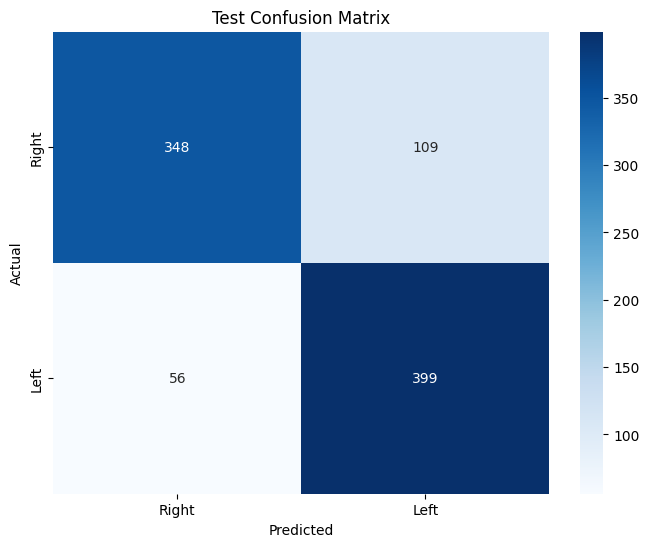

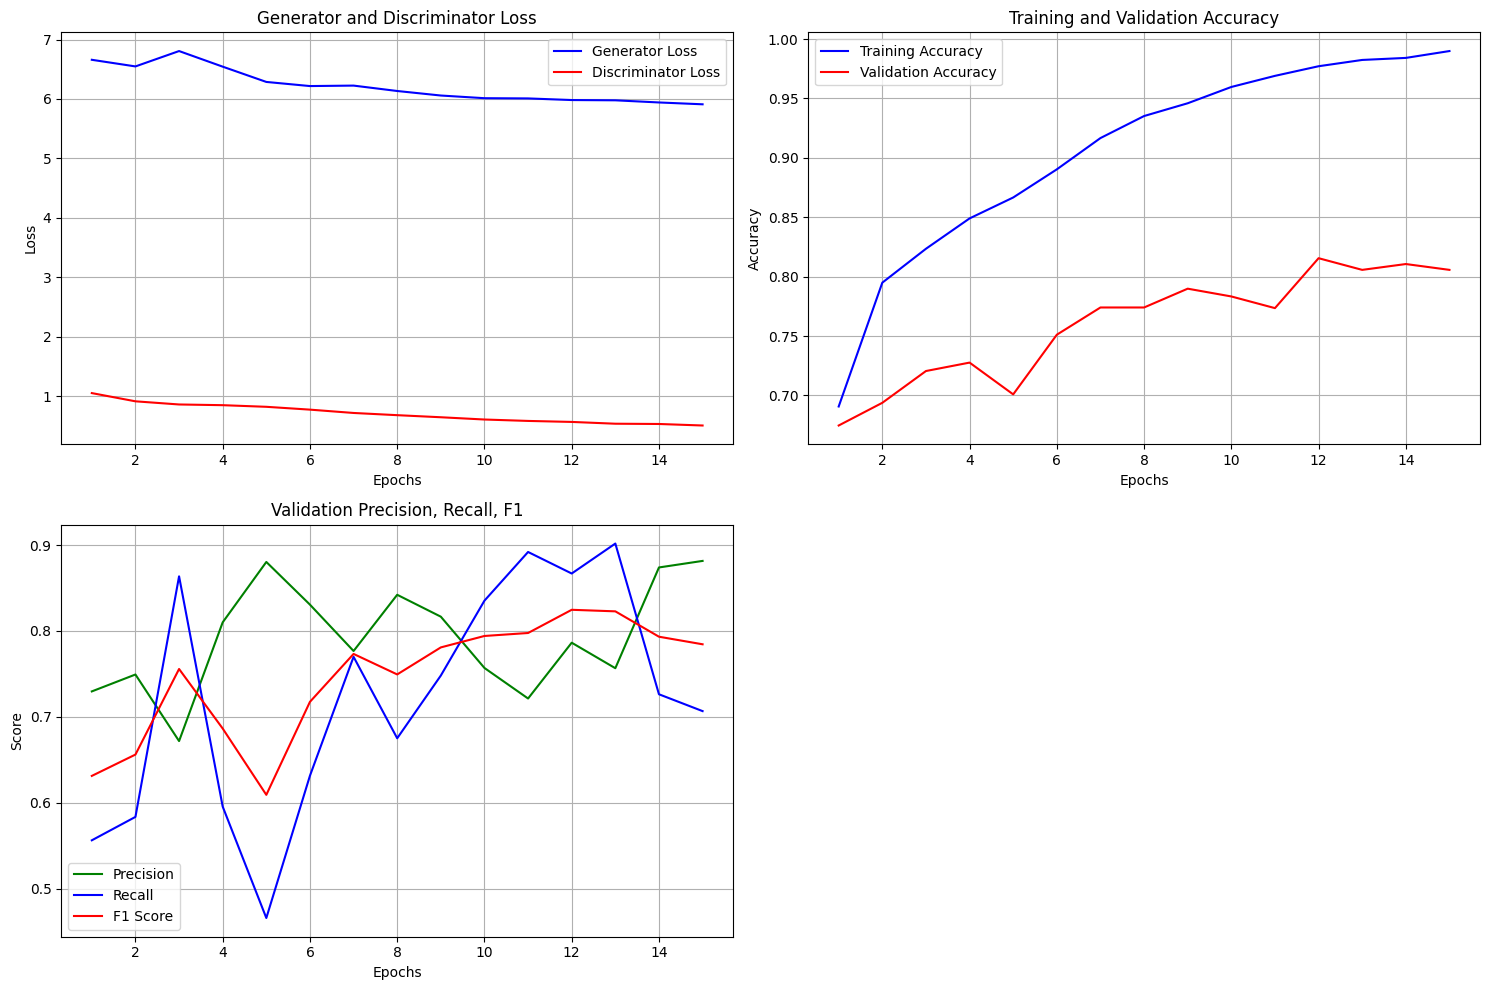

Main training and testing complete!
Model saved to sagan_generator.pt
Model saved to sagan_discriminator.pt
Skipping per-subject testing to save time.
Processing complete!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/AAD Dataset/KUL"
try:
    generator, discriminator, history = process_all_subjects(
        data_path, subject_range=(1, 2), batch_size=8
    )
    if generator is not None and discriminator is not None:
        save_model(generator, "sagan_generator.pt")
        save_model(discriminator, "sagan_discriminator.pt")
        print("Skipping per-subject testing to save time.")
except Exception as e:
    print(f"Error in main execution: {e}")
print("Processing complete!")